In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import pybaseball as pyb
import seaborn as sns
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [6]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [7]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [8]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_strike(description):
        return 1 if description in ['foul_bunt', 'swinging_strike', 'foul', 'called_strike', 'foul_tip',
                                    'swinging_strike_blocked', 'missed_bunt', 'bunt_foul_tip'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_called(description):
        return 1 if description in ['called_strike'] else 0

    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [9]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data, height_df)
testing_data_processed = preprocess_data(testing_data, height_df)


In [10]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')

# Fastball Model First

In [11]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [12]:
train_data = training_features.drop(['pfx_x'], axis=1).copy()
train_label = training_features['pfx_x'].copy()
testing_data = testing_features.drop(['pfx_x'], axis=1).copy()
testing_label = testing_features['pfx_x'].copy()

In [13]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'throws',
       'height_ratio'],
      dtype='object')

In [14]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'throws',
       'height_ratio'],
      dtype='object')

In [15]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [16]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [17]:
y_pred = model.predict(dtest)

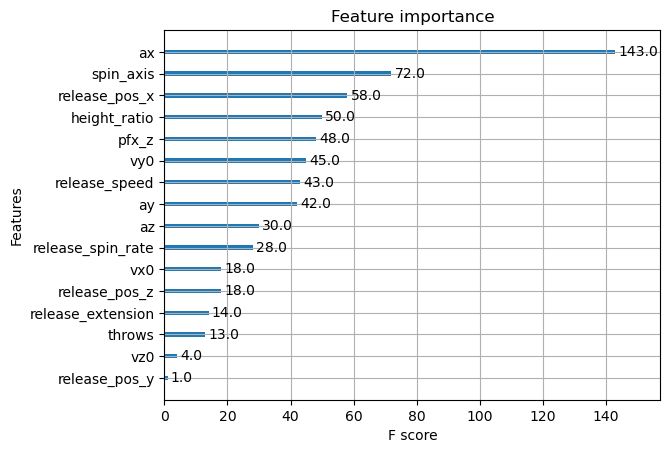

In [18]:
xgb.plot_importance(model)
plt.show()

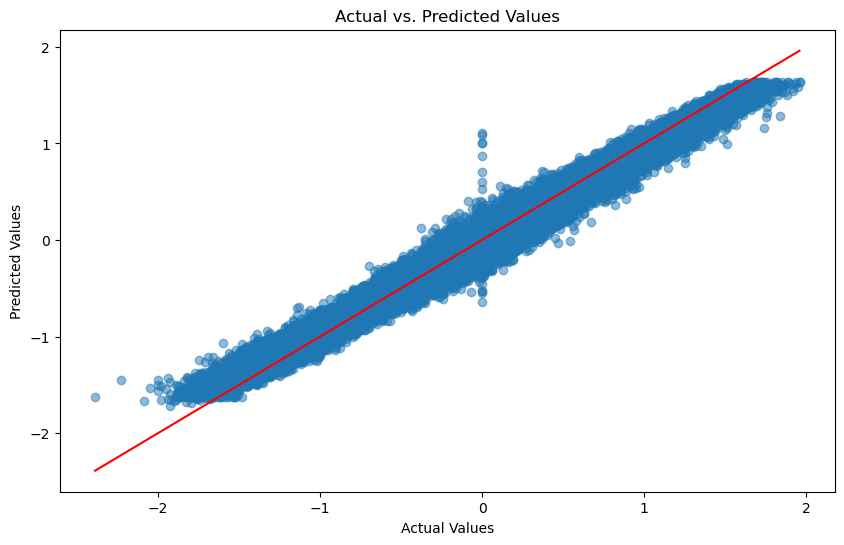

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [22]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [23]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-10 12:18:11,329] A new study created in memory with name: no-name-562e5060-300d-4b2b-80ec-8fec8ae33219
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63931
[1]	eval-rmse:0.50020
[2]	eval-rmse:0.42072
[3]	eval-rmse:0.34857
[4]	eval-rmse:0.30139
[5]	eval-rmse:0.23973
[6]	eval-rmse:0.19222
[7]	eval-rmse:0.15623
[8]	eval-rmse:0.13950
[9]	eval-rmse:0.11661
[10]	eval-rmse:0.09867
[11]	eval-rmse:0.09424
[12]	eval-rmse:0.08217
[13]	eval-rmse:0.07367
[14]	eval-rmse:0.06681
[15]	eval-rmse:0.06147
[16]	eval-rmse:0.06047
[17]	eval-rmse:0.05933
[18]	eval-rmse:0.05532
[19]	eval-rmse:0.05486
[20]	eval-rmse:0.05454
[21]	eval-rmse:0.05162
[22]	eval-rmse:0.05133
[23]	eval-rmse:0.05093
[24]	eval-rmse:0.04882
[25]	eval-rmse:0.04678
[26]	eval-rmse:0.04635
[27]	eval-rmse:0.04614
[28]	eval-rmse:0.04593
[29]	eval-rmse:0.04579
[30]	eval-rmse:0.04563
[31]	eval-rmse:0.04398
[32]	eval-rmse:0.04369
[33]	eval-rmse:0.04357
[34]	eval-rmse:0.04348
[35]	eval-rmse:0.04191
[36]	eval-rmse:0.04170
[37]	eval-rmse:0.04152
[38]	eval-rmse:0.04043
[39]	eval-rmse:0.03924
[40]	eval-rmse:0.03885
[41]	eval-rmse:0.03875
[42]	eval-rmse:0.03866
[43]	eval-rmse:0.0379

[I 2023-11-10 12:18:14,057] Trial 0 finished with value: 0.027060560912757093 and parameters: {'max_depth': 7, 'eta': 0.2195368688848611, 'subsample': 0.5556155368426834, 'colsample_bytree': 0.5717836282129461, 'min_child_weight': 1}. Best is trial 0 with value: 0.027060560912757093.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59647
[1]	eval-rmse:0.43654
[2]	eval-rmse:0.36169
[3]	eval-rmse:0.29360
[4]	eval-rmse:0.25917
[5]	eval-rmse:0.20112
[6]	eval-rmse:0.18034
[7]	eval-rmse:0.15039
[8]	eval-rmse:0.14305
[9]	eval-rmse:0.12261
[10]	eval-rmse:0.11042
[11]	eval-rmse:0.10904
[12]	eval-rmse:0.09894
[13]	eval-rmse:0.09226
[14]	eval-rmse:0.08632
[15]	eval-rmse:0.08013
[16]	eval-rmse:0.07905
[17]	eval-rmse:0.07808
[18]	eval-rmse:0.07450
[19]	eval-rmse:0.07375
[20]	eval-rmse:0.07330
[21]	eval-rmse:0.07010
[22]	eval-rmse:0.06944
[23]	eval-rmse:0.06904
[24]	eval-rmse:0.06878
[25]	eval-rmse:0.06574
[26]	eval-rmse:0.06519
[27]	eval-rmse:0.06498
[28]	eval-rmse:0.06437
[29]	eval-rmse:0.06419
[30]	eval-rmse:0.06388
[31]	eval-rmse:0.06161
[32]	eval-rmse:0.06120
[33]	eval-rmse:0.06085
[34]	eval-rmse:0.06071
[35]	eval-rmse:0.05881
[36]	eval-rmse:0.05841
[37]	eval-rmse:0.05809
[38]	eval-rmse:0.05633
[39]	eval-rmse:0.05530
[40]	eval-rmse:0.05496
[41]	eval-rmse:0.05475
[42]	eval-rmse:0.05450
[43]	eval-rmse:0.0529

[I 2023-11-10 12:18:16,124] Trial 1 finished with value: 0.03231231020986049 and parameters: {'max_depth': 4, 'eta': 0.27549022086774966, 'subsample': 0.5965471633067932, 'colsample_bytree': 0.55792824521486, 'min_child_weight': 3}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59327
[1]	eval-rmse:0.43140
[2]	eval-rmse:0.35022
[3]	eval-rmse:0.27913
[4]	eval-rmse:0.24176
[5]	eval-rmse:0.18309
[6]	eval-rmse:0.16068
[7]	eval-rmse:0.12959
[8]	eval-rmse:0.12141
[9]	eval-rmse:0.10338
[10]	eval-rmse:0.09005
[11]	eval-rmse:0.08863
[12]	eval-rmse:0.07952
[13]	eval-rmse:0.07267
[14]	eval-rmse:0.07025
[15]	eval-rmse:0.06560
[16]	eval-rmse:0.06436
[17]	eval-rmse:0.06365
[18]	eval-rmse:0.05922
[19]	eval-rmse:0.05856
[20]	eval-rmse:0.05811
[21]	eval-rmse:0.05509
[22]	eval-rmse:0.05466
[23]	eval-rmse:0.05434
[24]	eval-rmse:0.05418
[25]	eval-rmse:0.05162
[26]	eval-rmse:0.05094
[27]	eval-rmse:0.05070
[28]	eval-rmse:0.05050
[29]	eval-rmse:0.05024
[30]	eval-rmse:0.05007
[31]	eval-rmse:0.04775
[32]	eval-rmse:0.04736
[33]	eval-rmse:0.04728
[34]	eval-rmse:0.04716
[35]	eval-rmse:0.04548
[36]	eval-rmse:0.04518
[37]	eval-rmse:0.04502
[38]	eval-rmse:0.04362
[39]	eval-rmse:0.04239
[40]	eval-rmse:0.04220
[41]	eval-rmse:0.04201
[42]	eval-rmse:0.04185
[43]	eval-rmse:0.0410

[I 2023-11-10 12:18:18,734] Trial 2 finished with value: 0.02867210119217769 and parameters: {'max_depth': 6, 'eta': 0.2767070498285418, 'subsample': 0.47210084312963363, 'colsample_bytree': 0.4716113191048233, 'min_child_weight': 1}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65254
[1]	eval-rmse:0.52105
[2]	eval-rmse:0.44623
[3]	eval-rmse:0.37590
[4]	eval-rmse:0.33215
[5]	eval-rmse:0.26896
[6]	eval-rmse:0.23594
[7]	eval-rmse:0.19507
[8]	eval-rmse:0.17781
[9]	eval-rmse:0.15044
[10]	eval-rmse:0.12828
[11]	eval-rmse:0.12332
[12]	eval-rmse:0.10809
[13]	eval-rmse:0.09679
[14]	eval-rmse:0.08781
[15]	eval-rmse:0.08019
[16]	eval-rmse:0.07899
[17]	eval-rmse:0.07773
[18]	eval-rmse:0.07224
[19]	eval-rmse:0.07171
[20]	eval-rmse:0.07126
[21]	eval-rmse:0.06688
[22]	eval-rmse:0.06635
[23]	eval-rmse:0.06597
[24]	eval-rmse:0.06575
[25]	eval-rmse:0.06211
[26]	eval-rmse:0.06172
[27]	eval-rmse:0.06153
[28]	eval-rmse:0.06127
[29]	eval-rmse:0.06110
[30]	eval-rmse:0.06093
[31]	eval-rmse:0.05822
[32]	eval-rmse:0.05802
[33]	eval-rmse:0.05791
[34]	eval-rmse:0.05783
[35]	eval-rmse:0.05506
[36]	eval-rmse:0.05477
[37]	eval-rmse:0.05449
[38]	eval-rmse:0.05251
[39]	eval-rmse:0.05044
[40]	eval-rmse:0.05012
[41]	eval-rmse:0.04997
[42]	eval-rmse:0.04990
[43]	eval-rmse:0.0486

[I 2023-11-10 12:18:21,352] Trial 3 finished with value: 0.030155925450386534 and parameters: {'max_depth': 6, 'eta': 0.20354143368320676, 'subsample': 0.47289441962573064, 'colsample_bytree': 0.5520562659820539, 'min_child_weight': 2}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59729
[1]	eval-rmse:0.43691
[2]	eval-rmse:0.35463
[3]	eval-rmse:0.28330
[4]	eval-rmse:0.24529
[5]	eval-rmse:0.18664
[6]	eval-rmse:0.16321
[7]	eval-rmse:0.13158
[8]	eval-rmse:0.12277
[9]	eval-rmse:0.10408
[10]	eval-rmse:0.08967
[11]	eval-rmse:0.08815
[12]	eval-rmse:0.07860
[13]	eval-rmse:0.07214
[14]	eval-rmse:0.06716
[15]	eval-rmse:0.06303
[16]	eval-rmse:0.06192
[17]	eval-rmse:0.06100
[18]	eval-rmse:0.05749
[19]	eval-rmse:0.05701
[20]	eval-rmse:0.05668
[21]	eval-rmse:0.05419
[22]	eval-rmse:0.05374
[23]	eval-rmse:0.05328
[24]	eval-rmse:0.05310
[25]	eval-rmse:0.05073
[26]	eval-rmse:0.05045
[27]	eval-rmse:0.05031
[28]	eval-rmse:0.05006
[29]	eval-rmse:0.04984
[30]	eval-rmse:0.04959
[31]	eval-rmse:0.04767
[32]	eval-rmse:0.04737
[33]	eval-rmse:0.04722
[34]	eval-rmse:0.04713
[35]	eval-rmse:0.04534
[36]	eval-rmse:0.04513
[37]	eval-rmse:0.04483
[38]	eval-rmse:0.04339
[39]	eval-rmse:0.04201
[40]	eval-rmse:0.04164
[41]	eval-rmse:0.04149
[42]	eval-rmse:0.04140
[43]	eval-rmse:0.0407

[I 2023-11-10 12:18:24,066] Trial 4 finished with value: 0.02855894018403359 and parameters: {'max_depth': 6, 'eta': 0.2717099347942798, 'subsample': 0.44440593216412444, 'colsample_bytree': 0.5338137474213303, 'min_child_weight': 2}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56669
[1]	eval-rmse:0.39338
[2]	eval-rmse:0.30802
[3]	eval-rmse:0.23850
[4]	eval-rmse:0.20425
[5]	eval-rmse:0.15051
[6]	eval-rmse:0.13189
[7]	eval-rmse:0.10506
[8]	eval-rmse:0.09929
[9]	eval-rmse:0.08467
[10]	eval-rmse:0.07306
[11]	eval-rmse:0.07190
[12]	eval-rmse:0.06488
[13]	eval-rmse:0.05996
[14]	eval-rmse:0.05592
[15]	eval-rmse:0.05272
[16]	eval-rmse:0.05167
[17]	eval-rmse:0.05091
[18]	eval-rmse:0.04848
[19]	eval-rmse:0.04818
[20]	eval-rmse:0.04777
[21]	eval-rmse:0.04601
[22]	eval-rmse:0.04563
[23]	eval-rmse:0.04517
[24]	eval-rmse:0.04504
[25]	eval-rmse:0.04332
[26]	eval-rmse:0.04294
[27]	eval-rmse:0.04271
[28]	eval-rmse:0.04237
[29]	eval-rmse:0.04219
[30]	eval-rmse:0.04202
[31]	eval-rmse:0.04071
[32]	eval-rmse:0.04026
[33]	eval-rmse:0.04014
[34]	eval-rmse:0.03990
[35]	eval-rmse:0.03858
[36]	eval-rmse:0.03848
[37]	eval-rmse:0.03826
[38]	eval-rmse:0.03752
[39]	eval-rmse:0.03678
[40]	eval-rmse:0.03641
[41]	eval-rmse:0.03624
[42]	eval-rmse:0.03616
[43]	eval-rmse:0.0357

[I 2023-11-10 12:18:26,872] Trial 5 finished with value: 0.028879733003555258 and parameters: {'max_depth': 7, 'eta': 0.30908601900592836, 'subsample': 0.4002677516953475, 'colsample_bytree': 0.5575113033982366, 'min_child_weight': 1}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54189
[1]	eval-rmse:0.35987
[2]	eval-rmse:0.27509
[3]	eval-rmse:0.20879
[4]	eval-rmse:0.17857
[5]	eval-rmse:0.12881
[6]	eval-rmse:0.11402
[7]	eval-rmse:0.09136
[8]	eval-rmse:0.08755
[9]	eval-rmse:0.07529
[10]	eval-rmse:0.06592
[11]	eval-rmse:0.06494
[12]	eval-rmse:0.05907
[13]	eval-rmse:0.05541
[14]	eval-rmse:0.05215
[15]	eval-rmse:0.04948
[16]	eval-rmse:0.04855
[17]	eval-rmse:0.04787
[18]	eval-rmse:0.04599
[19]	eval-rmse:0.04558
[20]	eval-rmse:0.04504
[21]	eval-rmse:0.04357
[22]	eval-rmse:0.04323
[23]	eval-rmse:0.04294
[24]	eval-rmse:0.04284
[25]	eval-rmse:0.04127
[26]	eval-rmse:0.04068
[27]	eval-rmse:0.04039
[28]	eval-rmse:0.04012
[29]	eval-rmse:0.03984
[30]	eval-rmse:0.03969
[31]	eval-rmse:0.03858
[32]	eval-rmse:0.03817
[33]	eval-rmse:0.03804
[34]	eval-rmse:0.03791
[35]	eval-rmse:0.03680
[36]	eval-rmse:0.03664
[37]	eval-rmse:0.03646
[38]	eval-rmse:0.03579
[39]	eval-rmse:0.03510
[40]	eval-rmse:0.03483
[41]	eval-rmse:0.03474
[42]	eval-rmse:0.03462
[43]	eval-rmse:0.0341

[I 2023-11-10 12:18:29,616] Trial 6 finished with value: 0.02792835263373014 and parameters: {'max_depth': 7, 'eta': 0.33967554809811873, 'subsample': 0.4972471522029321, 'colsample_bytree': 0.5190285821947445, 'min_child_weight': 1}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.49473
[1]	eval-rmse:0.30046
[2]	eval-rmse:0.21777
[3]	eval-rmse:0.15913
[4]	eval-rmse:0.13638
[5]	eval-rmse:0.09586
[6]	eval-rmse:0.08680
[7]	eval-rmse:0.07061
[8]	eval-rmse:0.06883
[9]	eval-rmse:0.06071
[10]	eval-rmse:0.05374
[11]	eval-rmse:0.05256
[12]	eval-rmse:0.04876
[13]	eval-rmse:0.04648
[14]	eval-rmse:0.04424
[15]	eval-rmse:0.04292
[16]	eval-rmse:0.04192
[17]	eval-rmse:0.04145
[18]	eval-rmse:0.04016
[19]	eval-rmse:0.03971
[20]	eval-rmse:0.03946
[21]	eval-rmse:0.03853
[22]	eval-rmse:0.03828
[23]	eval-rmse:0.03792
[24]	eval-rmse:0.03785
[25]	eval-rmse:0.03689
[26]	eval-rmse:0.03668
[27]	eval-rmse:0.03642
[28]	eval-rmse:0.03616
[29]	eval-rmse:0.03584
[30]	eval-rmse:0.03580
[31]	eval-rmse:0.03516
[32]	eval-rmse:0.03478
[33]	eval-rmse:0.03472
[34]	eval-rmse:0.03461
[35]	eval-rmse:0.03392
[36]	eval-rmse:0.03380
[37]	eval-rmse:0.03359
[38]	eval-rmse:0.03318
[39]	eval-rmse:0.03281
[40]	eval-rmse:0.03271
[41]	eval-rmse:0.03262
[42]	eval-rmse:0.03258
[43]	eval-rmse:0.0323

[I 2023-11-10 12:18:32,483] Trial 7 finished with value: 0.029150965062718942 and parameters: {'max_depth': 8, 'eta': 0.397436383036826, 'subsample': 0.5158871041041976, 'colsample_bytree': 0.5043012108935451, 'min_child_weight': 5}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52826
[1]	eval-rmse:0.34430
[2]	eval-rmse:0.27380
[3]	eval-rmse:0.21331
[4]	eval-rmse:0.18967
[5]	eval-rmse:0.14063
[6]	eval-rmse:0.13066
[7]	eval-rmse:0.11273
[8]	eval-rmse:0.11057
[9]	eval-rmse:0.09790
[10]	eval-rmse:0.09067
[11]	eval-rmse:0.08938
[12]	eval-rmse:0.08251
[13]	eval-rmse:0.07797
[14]	eval-rmse:0.07657
[15]	eval-rmse:0.07310
[16]	eval-rmse:0.07151
[17]	eval-rmse:0.07069
[18]	eval-rmse:0.06589
[19]	eval-rmse:0.06517
[20]	eval-rmse:0.06451
[21]	eval-rmse:0.06191
[22]	eval-rmse:0.06128
[23]	eval-rmse:0.06059
[24]	eval-rmse:0.06033
[25]	eval-rmse:0.05820
[26]	eval-rmse:0.05751
[27]	eval-rmse:0.05729
[28]	eval-rmse:0.05683
[29]	eval-rmse:0.05653
[30]	eval-rmse:0.05616
[31]	eval-rmse:0.05361
[32]	eval-rmse:0.05312
[33]	eval-rmse:0.05292
[34]	eval-rmse:0.05267
[35]	eval-rmse:0.05111
[36]	eval-rmse:0.05092
[37]	eval-rmse:0.04996
[38]	eval-rmse:0.04821
[39]	eval-rmse:0.04682
[40]	eval-rmse:0.04633
[41]	eval-rmse:0.04616
[42]	eval-rmse:0.04603
[43]	eval-rmse:0.0450

[I 2023-11-10 12:18:34,574] Trial 8 finished with value: 0.030365679084601586 and parameters: {'max_depth': 4, 'eta': 0.36085433158979535, 'subsample': 0.5210865123019621, 'colsample_bytree': 0.46846121472261215, 'min_child_weight': 3}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51166
[1]	eval-rmse:0.32141
[2]	eval-rmse:0.23879
[3]	eval-rmse:0.17623
[4]	eval-rmse:0.15058
[5]	eval-rmse:0.10612
[6]	eval-rmse:0.09506
[7]	eval-rmse:0.07621
[8]	eval-rmse:0.07377
[9]	eval-rmse:0.06588
[10]	eval-rmse:0.05869
[11]	eval-rmse:0.05738
[12]	eval-rmse:0.05281
[13]	eval-rmse:0.04936
[14]	eval-rmse:0.04853
[15]	eval-rmse:0.04680
[16]	eval-rmse:0.04544
[17]	eval-rmse:0.04482
[18]	eval-rmse:0.04252
[19]	eval-rmse:0.04203
[20]	eval-rmse:0.04162
[21]	eval-rmse:0.04020
[22]	eval-rmse:0.04007
[23]	eval-rmse:0.03976
[24]	eval-rmse:0.03967
[25]	eval-rmse:0.03843
[26]	eval-rmse:0.03814
[27]	eval-rmse:0.03800
[28]	eval-rmse:0.03785
[29]	eval-rmse:0.03770
[30]	eval-rmse:0.03758
[31]	eval-rmse:0.03653
[32]	eval-rmse:0.03631
[33]	eval-rmse:0.03627
[34]	eval-rmse:0.03606
[35]	eval-rmse:0.03529
[36]	eval-rmse:0.03511
[37]	eval-rmse:0.03490
[38]	eval-rmse:0.03443
[39]	eval-rmse:0.03399
[40]	eval-rmse:0.03376
[41]	eval-rmse:0.03370
[42]	eval-rmse:0.03367
[43]	eval-rmse:0.0334

[I 2023-11-10 12:18:37,565] Trial 9 finished with value: 0.02994338711572015 and parameters: {'max_depth': 8, 'eta': 0.3765729679200557, 'subsample': 0.48480211924253125, 'colsample_bytree': 0.4848602269092951, 'min_child_weight': 5}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62646
[1]	eval-rmse:0.48100
[2]	eval-rmse:0.40768
[3]	eval-rmse:0.33874
[4]	eval-rmse:0.29871
[5]	eval-rmse:0.23809
[6]	eval-rmse:0.19133
[7]	eval-rmse:0.15902
[8]	eval-rmse:0.14652
[9]	eval-rmse:0.12584
[10]	eval-rmse:0.11182
[11]	eval-rmse:0.10945
[12]	eval-rmse:0.09909
[13]	eval-rmse:0.09146
[14]	eval-rmse:0.08590
[15]	eval-rmse:0.08112
[16]	eval-rmse:0.07994
[17]	eval-rmse:0.07887
[18]	eval-rmse:0.07589
[19]	eval-rmse:0.07536
[20]	eval-rmse:0.07490
[21]	eval-rmse:0.07174
[22]	eval-rmse:0.07125
[23]	eval-rmse:0.07032
[24]	eval-rmse:0.06828
[25]	eval-rmse:0.06576
[26]	eval-rmse:0.06534
[27]	eval-rmse:0.06496
[28]	eval-rmse:0.06465
[29]	eval-rmse:0.06447
[30]	eval-rmse:0.06419
[31]	eval-rmse:0.06236
[32]	eval-rmse:0.06192
[33]	eval-rmse:0.06154
[34]	eval-rmse:0.06136
[35]	eval-rmse:0.05917
[36]	eval-rmse:0.05886
[37]	eval-rmse:0.05844
[38]	eval-rmse:0.05624
[39]	eval-rmse:0.05457
[40]	eval-rmse:0.05414
[41]	eval-rmse:0.05390
[42]	eval-rmse:0.05380
[43]	eval-rmse:0.0521

[I 2023-11-10 12:18:39,824] Trial 10 finished with value: 0.030422073489393513 and parameters: {'max_depth': 4, 'eta': 0.23801293137300378, 'subsample': 0.5829714865338907, 'colsample_bytree': 0.5984685992622462, 'min_child_weight': 4}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62133
[1]	eval-rmse:0.47324
[2]	eval-rmse:0.39940
[3]	eval-rmse:0.33055
[4]	eval-rmse:0.29114
[5]	eval-rmse:0.23100
[6]	eval-rmse:0.18500
[7]	eval-rmse:0.15351
[8]	eval-rmse:0.14171
[9]	eval-rmse:0.12204
[10]	eval-rmse:0.10892
[11]	eval-rmse:0.10683
[12]	eval-rmse:0.09796
[13]	eval-rmse:0.09180
[14]	eval-rmse:0.08638
[15]	eval-rmse:0.08265
[16]	eval-rmse:0.08171
[17]	eval-rmse:0.08090
[18]	eval-rmse:0.07728
[19]	eval-rmse:0.07619
[20]	eval-rmse:0.07574
[21]	eval-rmse:0.07279
[22]	eval-rmse:0.07214
[23]	eval-rmse:0.07119
[24]	eval-rmse:0.06886
[25]	eval-rmse:0.06689
[26]	eval-rmse:0.06626
[27]	eval-rmse:0.06593
[28]	eval-rmse:0.06563
[29]	eval-rmse:0.06541
[30]	eval-rmse:0.06507
[31]	eval-rmse:0.06302
[32]	eval-rmse:0.06246
[33]	eval-rmse:0.06210
[34]	eval-rmse:0.06175
[35]	eval-rmse:0.05915
[36]	eval-rmse:0.05870
[37]	eval-rmse:0.05830
[38]	eval-rmse:0.05658
[39]	eval-rmse:0.05543
[40]	eval-rmse:0.05496
[41]	eval-rmse:0.05472
[42]	eval-rmse:0.05461
[43]	eval-rmse:0.0527

[I 2023-11-10 12:18:41,890] Trial 11 finished with value: 0.02987982756493902 and parameters: {'max_depth': 4, 'eta': 0.24437451479642633, 'subsample': 0.5985559369078908, 'colsample_bytree': 0.5935149668077906, 'min_child_weight': 4}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62433
[1]	eval-rmse:0.47730
[2]	eval-rmse:0.39994
[3]	eval-rmse:0.32927
[4]	eval-rmse:0.28653
[5]	eval-rmse:0.22538
[6]	eval-rmse:0.17993
[7]	eval-rmse:0.14760
[8]	eval-rmse:0.13509
[9]	eval-rmse:0.11530
[10]	eval-rmse:0.10051
[11]	eval-rmse:0.09769
[12]	eval-rmse:0.08773
[13]	eval-rmse:0.08088
[14]	eval-rmse:0.07556
[15]	eval-rmse:0.07079
[16]	eval-rmse:0.06959
[17]	eval-rmse:0.06859
[18]	eval-rmse:0.06498
[19]	eval-rmse:0.06432
[20]	eval-rmse:0.06380
[21]	eval-rmse:0.06083
[22]	eval-rmse:0.06023
[23]	eval-rmse:0.05964
[24]	eval-rmse:0.05752
[25]	eval-rmse:0.05534
[26]	eval-rmse:0.05492
[27]	eval-rmse:0.05474
[28]	eval-rmse:0.05442
[29]	eval-rmse:0.05419
[30]	eval-rmse:0.05385
[31]	eval-rmse:0.05216
[32]	eval-rmse:0.05177
[33]	eval-rmse:0.05149
[34]	eval-rmse:0.05140
[35]	eval-rmse:0.04946
[36]	eval-rmse:0.04925
[37]	eval-rmse:0.04897
[38]	eval-rmse:0.04718
[39]	eval-rmse:0.04569
[40]	eval-rmse:0.04549
[41]	eval-rmse:0.04531
[42]	eval-rmse:0.04513
[43]	eval-rmse:0.0442

[I 2023-11-10 12:18:44,131] Trial 12 finished with value: 0.028178723486336262 and parameters: {'max_depth': 5, 'eta': 0.2393775070904645, 'subsample': 0.5894562076298051, 'colsample_bytree': 0.5977152995383562, 'min_child_weight': 4}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57674
[1]	eval-rmse:0.40785
[2]	eval-rmse:0.32736
[3]	eval-rmse:0.25901
[4]	eval-rmse:0.22311
[5]	eval-rmse:0.16792
[6]	eval-rmse:0.13154
[7]	eval-rmse:0.10868
[8]	eval-rmse:0.10211
[9]	eval-rmse:0.08914
[10]	eval-rmse:0.07963
[11]	eval-rmse:0.07803
[12]	eval-rmse:0.07118
[13]	eval-rmse:0.06672
[14]	eval-rmse:0.06300
[15]	eval-rmse:0.06054
[16]	eval-rmse:0.05931
[17]	eval-rmse:0.05848
[18]	eval-rmse:0.05579
[19]	eval-rmse:0.05535
[20]	eval-rmse:0.05476
[21]	eval-rmse:0.05217
[22]	eval-rmse:0.05153
[23]	eval-rmse:0.05097
[24]	eval-rmse:0.04947
[25]	eval-rmse:0.04749
[26]	eval-rmse:0.04694
[27]	eval-rmse:0.04669
[28]	eval-rmse:0.04648
[29]	eval-rmse:0.04625
[30]	eval-rmse:0.04606
[31]	eval-rmse:0.04468
[32]	eval-rmse:0.04440
[33]	eval-rmse:0.04417
[34]	eval-rmse:0.04411
[35]	eval-rmse:0.04274
[36]	eval-rmse:0.04225
[37]	eval-rmse:0.04188
[38]	eval-rmse:0.04083
[39]	eval-rmse:0.03979
[40]	eval-rmse:0.03955
[41]	eval-rmse:0.03936
[42]	eval-rmse:0.03926
[43]	eval-rmse:0.0386

[I 2023-11-10 12:18:46,193] Trial 13 finished with value: 0.0275937657242648 and parameters: {'max_depth': 5, 'eta': 0.29832414592237666, 'subsample': 0.565508606258945, 'colsample_bytree': 0.5737872029925726, 'min_child_weight': 3}. Best is trial 1 with value: 0.03231231020986049.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61459
[1]	eval-rmse:0.46324
[2]	eval-rmse:0.39456
[3]	eval-rmse:0.32524
[4]	eval-rmse:0.28823
[5]	eval-rmse:0.22718
[6]	eval-rmse:0.20320
[7]	eval-rmse:0.17053
[8]	eval-rmse:0.16093
[9]	eval-rmse:0.13760
[10]	eval-rmse:0.12169
[11]	eval-rmse:0.11981
[12]	eval-rmse:0.11071
[13]	eval-rmse:0.10278
[14]	eval-rmse:0.09961
[15]	eval-rmse:0.09516
[16]	eval-rmse:0.09320
[17]	eval-rmse:0.09244
[18]	eval-rmse:0.09040
[19]	eval-rmse:0.08947
[20]	eval-rmse:0.08882
[21]	eval-rmse:0.08267
[22]	eval-rmse:0.08240
[23]	eval-rmse:0.08218
[24]	eval-rmse:0.08167
[25]	eval-rmse:0.07700
[26]	eval-rmse:0.07645
[27]	eval-rmse:0.07599
[28]	eval-rmse:0.07532
[29]	eval-rmse:0.07508
[30]	eval-rmse:0.07461
[31]	eval-rmse:0.07442
[32]	eval-rmse:0.07418
[33]	eval-rmse:0.07410
[34]	eval-rmse:0.07393
[35]	eval-rmse:0.07079
[36]	eval-rmse:0.07057
[37]	eval-rmse:0.07025
[38]	eval-rmse:0.06748
[39]	eval-rmse:0.06403
[40]	eval-rmse:0.06369
[41]	eval-rmse:0.06342
[42]	eval-rmse:0.06319
[43]	eval-rmse:0.0609

[I 2023-11-10 12:18:48,170] Trial 14 finished with value: 0.03628502902015279 and parameters: {'max_depth': 4, 'eta': 0.252769015022779, 'subsample': 0.5637372751572189, 'colsample_bytree': 0.42711558265722854, 'min_child_weight': 4}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60543
[1]	eval-rmse:0.44924
[2]	eval-rmse:0.37724
[3]	eval-rmse:0.30563
[4]	eval-rmse:0.26760
[5]	eval-rmse:0.20576
[6]	eval-rmse:0.18234
[7]	eval-rmse:0.14913
[8]	eval-rmse:0.13997
[9]	eval-rmse:0.11923
[10]	eval-rmse:0.10611
[11]	eval-rmse:0.10450
[12]	eval-rmse:0.09500
[13]	eval-rmse:0.08848
[14]	eval-rmse:0.08556
[15]	eval-rmse:0.08179
[16]	eval-rmse:0.07960
[17]	eval-rmse:0.07886
[18]	eval-rmse:0.07688
[19]	eval-rmse:0.07573
[20]	eval-rmse:0.07515
[21]	eval-rmse:0.06968
[22]	eval-rmse:0.06939
[23]	eval-rmse:0.06919
[24]	eval-rmse:0.06861
[25]	eval-rmse:0.06461
[26]	eval-rmse:0.06392
[27]	eval-rmse:0.06344
[28]	eval-rmse:0.06287
[29]	eval-rmse:0.06257
[30]	eval-rmse:0.06225
[31]	eval-rmse:0.06210
[32]	eval-rmse:0.06181
[33]	eval-rmse:0.06165
[34]	eval-rmse:0.06146
[35]	eval-rmse:0.05796
[36]	eval-rmse:0.05765
[37]	eval-rmse:0.05735
[38]	eval-rmse:0.05468
[39]	eval-rmse:0.05266
[40]	eval-rmse:0.05221
[41]	eval-rmse:0.05202
[42]	eval-rmse:0.05192
[43]	eval-rmse:0.0500

[I 2023-11-10 12:18:50,236] Trial 15 finished with value: 0.031014701233219276 and parameters: {'max_depth': 5, 'eta': 0.2626954567036763, 'subsample': 0.5505658295099248, 'colsample_bytree': 0.41501332234079963, 'min_child_weight': 3}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57582
[1]	eval-rmse:0.40743
[2]	eval-rmse:0.33844
[3]	eval-rmse:0.27130
[4]	eval-rmse:0.23924
[5]	eval-rmse:0.18110
[6]	eval-rmse:0.16434
[7]	eval-rmse:0.13939
[8]	eval-rmse:0.13426
[9]	eval-rmse:0.11630
[10]	eval-rmse:0.10540
[11]	eval-rmse:0.10418
[12]	eval-rmse:0.09644
[13]	eval-rmse:0.09177
[14]	eval-rmse:0.09006
[15]	eval-rmse:0.08745
[16]	eval-rmse:0.08487
[17]	eval-rmse:0.08384
[18]	eval-rmse:0.08172
[19]	eval-rmse:0.08082
[20]	eval-rmse:0.08017
[21]	eval-rmse:0.07369
[22]	eval-rmse:0.07336
[23]	eval-rmse:0.07312
[24]	eval-rmse:0.07258
[25]	eval-rmse:0.06865
[26]	eval-rmse:0.06805
[27]	eval-rmse:0.06780
[28]	eval-rmse:0.06743
[29]	eval-rmse:0.06718
[30]	eval-rmse:0.06688
[31]	eval-rmse:0.06659
[32]	eval-rmse:0.06634
[33]	eval-rmse:0.06610
[34]	eval-rmse:0.06573
[35]	eval-rmse:0.06235
[36]	eval-rmse:0.06216
[37]	eval-rmse:0.06185
[38]	eval-rmse:0.05961
[39]	eval-rmse:0.05738
[40]	eval-rmse:0.05676
[41]	eval-rmse:0.05653
[42]	eval-rmse:0.05645
[43]	eval-rmse:0.0543

[I 2023-11-10 12:18:52,103] Trial 16 finished with value: 0.03334152804704127 and parameters: {'max_depth': 4, 'eta': 0.3012571654508879, 'subsample': 0.5722097255315307, 'colsample_bytree': 0.40595989869748716, 'min_child_weight': 4}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55936
[1]	eval-rmse:0.38414
[2]	eval-rmse:0.31168
[3]	eval-rmse:0.24388
[4]	eval-rmse:0.21254
[5]	eval-rmse:0.15676
[6]	eval-rmse:0.14162
[7]	eval-rmse:0.11819
[8]	eval-rmse:0.11399
[9]	eval-rmse:0.09883
[10]	eval-rmse:0.09030
[11]	eval-rmse:0.08905
[12]	eval-rmse:0.08241
[13]	eval-rmse:0.07685
[14]	eval-rmse:0.07535
[15]	eval-rmse:0.07281
[16]	eval-rmse:0.06971
[17]	eval-rmse:0.06904
[18]	eval-rmse:0.06694
[19]	eval-rmse:0.06575
[20]	eval-rmse:0.06524
[21]	eval-rmse:0.06042
[22]	eval-rmse:0.06015
[23]	eval-rmse:0.05992
[24]	eval-rmse:0.05932
[25]	eval-rmse:0.05593
[26]	eval-rmse:0.05536
[27]	eval-rmse:0.05509
[28]	eval-rmse:0.05484
[29]	eval-rmse:0.05445
[30]	eval-rmse:0.05383
[31]	eval-rmse:0.05369
[32]	eval-rmse:0.05331
[33]	eval-rmse:0.05318
[34]	eval-rmse:0.05309
[35]	eval-rmse:0.05021
[36]	eval-rmse:0.04985
[37]	eval-rmse:0.04949
[38]	eval-rmse:0.04737
[39]	eval-rmse:0.04539
[40]	eval-rmse:0.04479
[41]	eval-rmse:0.04455
[42]	eval-rmse:0.04444
[43]	eval-rmse:0.0433

[I 2023-11-10 12:18:54,592] Trial 17 finished with value: 0.029190250594543155 and parameters: {'max_depth': 5, 'eta': 0.31991208273562416, 'subsample': 0.5372377160722979, 'colsample_bytree': 0.40276762359108054, 'min_child_weight': 4}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58000
[1]	eval-rmse:0.41317
[2]	eval-rmse:0.34410
[3]	eval-rmse:0.27640
[4]	eval-rmse:0.24382
[5]	eval-rmse:0.18509
[6]	eval-rmse:0.16748
[7]	eval-rmse:0.14173
[8]	eval-rmse:0.13623
[9]	eval-rmse:0.11772
[10]	eval-rmse:0.10647
[11]	eval-rmse:0.10522
[12]	eval-rmse:0.09693
[13]	eval-rmse:0.09197
[14]	eval-rmse:0.09011
[15]	eval-rmse:0.08713
[16]	eval-rmse:0.08480
[17]	eval-rmse:0.08424
[18]	eval-rmse:0.08203
[19]	eval-rmse:0.08082
[20]	eval-rmse:0.08001
[21]	eval-rmse:0.07389
[22]	eval-rmse:0.07361
[23]	eval-rmse:0.07347
[24]	eval-rmse:0.07293
[25]	eval-rmse:0.06920
[26]	eval-rmse:0.06866
[27]	eval-rmse:0.06835
[28]	eval-rmse:0.06784
[29]	eval-rmse:0.06761
[30]	eval-rmse:0.06724
[31]	eval-rmse:0.06713
[32]	eval-rmse:0.06689
[33]	eval-rmse:0.06679
[34]	eval-rmse:0.06662
[35]	eval-rmse:0.06326
[36]	eval-rmse:0.06297
[37]	eval-rmse:0.06250
[38]	eval-rmse:0.06027
[39]	eval-rmse:0.05866
[40]	eval-rmse:0.05803
[41]	eval-rmse:0.05780
[42]	eval-rmse:0.05770
[43]	eval-rmse:0.0553

[I 2023-11-10 12:18:56,690] Trial 18 finished with value: 0.034011944118007 and parameters: {'max_depth': 4, 'eta': 0.29608850450579294, 'subsample': 0.5762377228166672, 'colsample_bytree': 0.4304704185960204, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55286
[1]	eval-rmse:0.37541
[2]	eval-rmse:0.30321
[3]	eval-rmse:0.23621
[4]	eval-rmse:0.20594
[5]	eval-rmse:0.15127
[6]	eval-rmse:0.13709
[7]	eval-rmse:0.11477
[8]	eval-rmse:0.11098
[9]	eval-rmse:0.09642
[10]	eval-rmse:0.08846
[11]	eval-rmse:0.08724
[12]	eval-rmse:0.08115
[13]	eval-rmse:0.07707
[14]	eval-rmse:0.07570
[15]	eval-rmse:0.07298
[16]	eval-rmse:0.06980
[17]	eval-rmse:0.06913
[18]	eval-rmse:0.06707
[19]	eval-rmse:0.06587
[20]	eval-rmse:0.06517
[21]	eval-rmse:0.06013
[22]	eval-rmse:0.05983
[23]	eval-rmse:0.05960
[24]	eval-rmse:0.05904
[25]	eval-rmse:0.05556
[26]	eval-rmse:0.05492
[27]	eval-rmse:0.05460
[28]	eval-rmse:0.05428
[29]	eval-rmse:0.05399
[30]	eval-rmse:0.05379
[31]	eval-rmse:0.05351
[32]	eval-rmse:0.05319
[33]	eval-rmse:0.05305
[34]	eval-rmse:0.05297
[35]	eval-rmse:0.05015
[36]	eval-rmse:0.04992
[37]	eval-rmse:0.04935
[38]	eval-rmse:0.04719
[39]	eval-rmse:0.04495
[40]	eval-rmse:0.04444
[41]	eval-rmse:0.04418
[42]	eval-rmse:0.04406
[43]	eval-rmse:0.0429

[I 2023-11-10 12:18:59,165] Trial 19 finished with value: 0.02942407056335993 and parameters: {'max_depth': 5, 'eta': 0.3279913910700984, 'subsample': 0.5419023030789506, 'colsample_bytree': 0.43585903196034387, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:18:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58780
[1]	eval-rmse:0.42424
[2]	eval-rmse:0.35021
[3]	eval-rmse:0.28303
[4]	eval-rmse:0.25015
[5]	eval-rmse:0.19148
[6]	eval-rmse:0.17194
[7]	eval-rmse:0.14296
[8]	eval-rmse:0.13664
[9]	eval-rmse:0.11884
[10]	eval-rmse:0.10621
[11]	eval-rmse:0.10478
[12]	eval-rmse:0.09664
[13]	eval-rmse:0.08891
[14]	eval-rmse:0.08643
[15]	eval-rmse:0.08296
[16]	eval-rmse:0.08157
[17]	eval-rmse:0.08056
[18]	eval-rmse:0.07504
[19]	eval-rmse:0.07436
[20]	eval-rmse:0.07385
[21]	eval-rmse:0.07048
[22]	eval-rmse:0.06998
[23]	eval-rmse:0.06933
[24]	eval-rmse:0.06900
[25]	eval-rmse:0.06616
[26]	eval-rmse:0.06555
[27]	eval-rmse:0.06524
[28]	eval-rmse:0.06469
[29]	eval-rmse:0.06447
[30]	eval-rmse:0.06433
[31]	eval-rmse:0.06199
[32]	eval-rmse:0.06166
[33]	eval-rmse:0.06135
[34]	eval-rmse:0.06111
[35]	eval-rmse:0.05914
[36]	eval-rmse:0.05881
[37]	eval-rmse:0.05844
[38]	eval-rmse:0.05643
[39]	eval-rmse:0.05447
[40]	eval-rmse:0.05400
[41]	eval-rmse:0.05378
[42]	eval-rmse:0.05368
[43]	eval-rmse:0.0525

[I 2023-11-10 12:19:01,524] Trial 20 finished with value: 0.03265537212930492 and parameters: {'max_depth': 4, 'eta': 0.28626282183862106, 'subsample': 0.573241895378874, 'colsample_bytree': 0.4447282332034134, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57448
[1]	eval-rmse:0.40557
[2]	eval-rmse:0.33663
[3]	eval-rmse:0.26961
[4]	eval-rmse:0.23779
[5]	eval-rmse:0.17983
[6]	eval-rmse:0.16329
[7]	eval-rmse:0.13856
[8]	eval-rmse:0.13355
[9]	eval-rmse:0.11574
[10]	eval-rmse:0.10487
[11]	eval-rmse:0.10368
[12]	eval-rmse:0.09596
[13]	eval-rmse:0.09113
[14]	eval-rmse:0.08943
[15]	eval-rmse:0.08608
[16]	eval-rmse:0.08342
[17]	eval-rmse:0.08267
[18]	eval-rmse:0.08058
[19]	eval-rmse:0.07971
[20]	eval-rmse:0.07903
[21]	eval-rmse:0.07334
[22]	eval-rmse:0.07301
[23]	eval-rmse:0.07281
[24]	eval-rmse:0.07223
[25]	eval-rmse:0.06858
[26]	eval-rmse:0.06795
[27]	eval-rmse:0.06753
[28]	eval-rmse:0.06699
[29]	eval-rmse:0.06679
[30]	eval-rmse:0.06655
[31]	eval-rmse:0.06627
[32]	eval-rmse:0.06594
[33]	eval-rmse:0.06573
[34]	eval-rmse:0.06546
[35]	eval-rmse:0.06240
[36]	eval-rmse:0.06223
[37]	eval-rmse:0.06191
[38]	eval-rmse:0.05876
[39]	eval-rmse:0.05619
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05544
[42]	eval-rmse:0.05526
[43]	eval-rmse:0.0537

[I 2023-11-10 12:19:03,720] Trial 21 finished with value: 0.03344955005991576 and parameters: {'max_depth': 4, 'eta': 0.30293039290904095, 'subsample': 0.5704091740446064, 'colsample_bytree': 0.424744080644917, 'min_child_weight': 4}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58398
[1]	eval-rmse:0.41884
[2]	eval-rmse:0.34964
[3]	eval-rmse:0.28195
[4]	eval-rmse:0.24891
[5]	eval-rmse:0.18951
[6]	eval-rmse:0.17113
[7]	eval-rmse:0.14488
[8]	eval-rmse:0.13901
[9]	eval-rmse:0.12018
[10]	eval-rmse:0.10833
[11]	eval-rmse:0.10698
[12]	eval-rmse:0.09849
[13]	eval-rmse:0.09292
[14]	eval-rmse:0.09070
[15]	eval-rmse:0.08683
[16]	eval-rmse:0.08445
[17]	eval-rmse:0.08382
[18]	eval-rmse:0.08184
[19]	eval-rmse:0.08102
[20]	eval-rmse:0.08047
[21]	eval-rmse:0.07516
[22]	eval-rmse:0.07476
[23]	eval-rmse:0.07452
[24]	eval-rmse:0.07391
[25]	eval-rmse:0.07005
[26]	eval-rmse:0.06957
[27]	eval-rmse:0.06921
[28]	eval-rmse:0.06862
[29]	eval-rmse:0.06832
[30]	eval-rmse:0.06794
[31]	eval-rmse:0.06777
[32]	eval-rmse:0.06737
[33]	eval-rmse:0.06722
[34]	eval-rmse:0.06693
[35]	eval-rmse:0.06420
[36]	eval-rmse:0.06398
[37]	eval-rmse:0.06362
[38]	eval-rmse:0.06098
[39]	eval-rmse:0.05871
[40]	eval-rmse:0.05835
[41]	eval-rmse:0.05802
[42]	eval-rmse:0.05788
[43]	eval-rmse:0.0562

[I 2023-11-10 12:19:05,901] Trial 22 finished with value: 0.03471461376962071 and parameters: {'max_depth': 4, 'eta': 0.2910381659388642, 'subsample': 0.5596954621266031, 'colsample_bytree': 0.42890710182774855, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61050
[1]	eval-rmse:0.45674
[2]	eval-rmse:0.37940
[3]	eval-rmse:0.30886
[4]	eval-rmse:0.27085
[5]	eval-rmse:0.20953
[6]	eval-rmse:0.18528
[7]	eval-rmse:0.15130
[8]	eval-rmse:0.14150
[9]	eval-rmse:0.12073
[10]	eval-rmse:0.10606
[11]	eval-rmse:0.10419
[12]	eval-rmse:0.09341
[13]	eval-rmse:0.08523
[14]	eval-rmse:0.08218
[15]	eval-rmse:0.07673
[16]	eval-rmse:0.07554
[17]	eval-rmse:0.07467
[18]	eval-rmse:0.06966
[19]	eval-rmse:0.06900
[20]	eval-rmse:0.06861
[21]	eval-rmse:0.06519
[22]	eval-rmse:0.06478
[23]	eval-rmse:0.06421
[24]	eval-rmse:0.06401
[25]	eval-rmse:0.06103
[26]	eval-rmse:0.06038
[27]	eval-rmse:0.06017
[28]	eval-rmse:0.05994
[29]	eval-rmse:0.05974
[30]	eval-rmse:0.05941
[31]	eval-rmse:0.05692
[32]	eval-rmse:0.05647
[33]	eval-rmse:0.05621
[34]	eval-rmse:0.05597
[35]	eval-rmse:0.05359
[36]	eval-rmse:0.05338
[37]	eval-rmse:0.05313
[38]	eval-rmse:0.05112
[39]	eval-rmse:0.04921
[40]	eval-rmse:0.04876
[41]	eval-rmse:0.04860
[42]	eval-rmse:0.04844
[43]	eval-rmse:0.0473

[I 2023-11-10 12:19:08,246] Trial 23 finished with value: 0.03021726313565045 and parameters: {'max_depth': 5, 'eta': 0.25641300146459417, 'subsample': 0.5557055253504498, 'colsample_bytree': 0.4396737072151358, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58567
[1]	eval-rmse:0.42117
[2]	eval-rmse:0.34708
[3]	eval-rmse:0.27938
[4]	eval-rmse:0.24693
[5]	eval-rmse:0.18855
[6]	eval-rmse:0.16976
[7]	eval-rmse:0.14352
[8]	eval-rmse:0.13740
[9]	eval-rmse:0.11871
[10]	eval-rmse:0.10554
[11]	eval-rmse:0.10416
[12]	eval-rmse:0.09738
[13]	eval-rmse:0.09095
[14]	eval-rmse:0.08897
[15]	eval-rmse:0.08387
[16]	eval-rmse:0.08237
[17]	eval-rmse:0.08160
[18]	eval-rmse:0.07709
[19]	eval-rmse:0.07640
[20]	eval-rmse:0.07578
[21]	eval-rmse:0.07270
[22]	eval-rmse:0.07223
[23]	eval-rmse:0.07147
[24]	eval-rmse:0.07114
[25]	eval-rmse:0.06841
[26]	eval-rmse:0.06779
[27]	eval-rmse:0.06749
[28]	eval-rmse:0.06697
[29]	eval-rmse:0.06672
[30]	eval-rmse:0.06640
[31]	eval-rmse:0.06352
[32]	eval-rmse:0.06307
[33]	eval-rmse:0.06281
[34]	eval-rmse:0.06260
[35]	eval-rmse:0.06089
[36]	eval-rmse:0.06065
[37]	eval-rmse:0.06033
[38]	eval-rmse:0.05839
[39]	eval-rmse:0.05615
[40]	eval-rmse:0.05580
[41]	eval-rmse:0.05562
[42]	eval-rmse:0.05552
[43]	eval-rmse:0.0544

[I 2023-11-10 12:19:10,348] Trial 24 finished with value: 0.03367062038844949 and parameters: {'max_depth': 4, 'eta': 0.2889478287217849, 'subsample': 0.5315325776247007, 'colsample_bytree': 0.4532246907517034, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60709
[1]	eval-rmse:0.45165
[2]	eval-rmse:0.37969
[3]	eval-rmse:0.30816
[4]	eval-rmse:0.26997
[5]	eval-rmse:0.20780
[6]	eval-rmse:0.18408
[7]	eval-rmse:0.15046
[8]	eval-rmse:0.14113
[9]	eval-rmse:0.11993
[10]	eval-rmse:0.10650
[11]	eval-rmse:0.10490
[12]	eval-rmse:0.09540
[13]	eval-rmse:0.08835
[14]	eval-rmse:0.08565
[15]	eval-rmse:0.08197
[16]	eval-rmse:0.07989
[17]	eval-rmse:0.07916
[18]	eval-rmse:0.07716
[19]	eval-rmse:0.07611
[20]	eval-rmse:0.07542
[21]	eval-rmse:0.06988
[22]	eval-rmse:0.06958
[23]	eval-rmse:0.06939
[24]	eval-rmse:0.06886
[25]	eval-rmse:0.06461
[26]	eval-rmse:0.06378
[27]	eval-rmse:0.06349
[28]	eval-rmse:0.06303
[29]	eval-rmse:0.06282
[30]	eval-rmse:0.06244
[31]	eval-rmse:0.06226
[32]	eval-rmse:0.06195
[33]	eval-rmse:0.06183
[34]	eval-rmse:0.06161
[35]	eval-rmse:0.05817
[36]	eval-rmse:0.05798
[37]	eval-rmse:0.05770
[38]	eval-rmse:0.05508
[39]	eval-rmse:0.05336
[40]	eval-rmse:0.05286
[41]	eval-rmse:0.05265
[42]	eval-rmse:0.05250
[43]	eval-rmse:0.0506

[I 2023-11-10 12:19:13,027] Trial 25 finished with value: 0.031670758332633074 and parameters: {'max_depth': 5, 'eta': 0.26077812262904854, 'subsample': 0.5810723754388466, 'colsample_bytree': 0.42354755527442517, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58868
[1]	eval-rmse:0.42548
[2]	eval-rmse:0.35145
[3]	eval-rmse:0.28422
[4]	eval-rmse:0.25117
[5]	eval-rmse:0.19234
[6]	eval-rmse:0.17272
[7]	eval-rmse:0.14369
[8]	eval-rmse:0.13742
[9]	eval-rmse:0.11966
[10]	eval-rmse:0.10744
[11]	eval-rmse:0.10602
[12]	eval-rmse:0.09749
[13]	eval-rmse:0.08934
[14]	eval-rmse:0.08702
[15]	eval-rmse:0.08308
[16]	eval-rmse:0.08168
[17]	eval-rmse:0.08072
[18]	eval-rmse:0.07649
[19]	eval-rmse:0.07576
[20]	eval-rmse:0.07516
[21]	eval-rmse:0.07124
[22]	eval-rmse:0.07081
[23]	eval-rmse:0.07039
[24]	eval-rmse:0.07015
[25]	eval-rmse:0.06651
[26]	eval-rmse:0.06587
[27]	eval-rmse:0.06565
[28]	eval-rmse:0.06511
[29]	eval-rmse:0.06488
[30]	eval-rmse:0.06452
[31]	eval-rmse:0.06221
[32]	eval-rmse:0.06175
[33]	eval-rmse:0.06139
[34]	eval-rmse:0.06128
[35]	eval-rmse:0.05956
[36]	eval-rmse:0.05937
[37]	eval-rmse:0.05897
[38]	eval-rmse:0.05702
[39]	eval-rmse:0.05473
[40]	eval-rmse:0.05423
[41]	eval-rmse:0.05394
[42]	eval-rmse:0.05379
[43]	eval-rmse:0.0525

[I 2023-11-10 12:19:15,606] Trial 26 finished with value: 0.032828634963995205 and parameters: {'max_depth': 4, 'eta': 0.2851690943986666, 'subsample': 0.5520837817289794, 'colsample_bytree': 0.4571736986541141, 'min_child_weight': 4}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56234
[1]	eval-rmse:0.38822
[2]	eval-rmse:0.31559
[3]	eval-rmse:0.24723
[4]	eval-rmse:0.21547
[5]	eval-rmse:0.15917
[6]	eval-rmse:0.14327
[7]	eval-rmse:0.11931
[8]	eval-rmse:0.11479
[9]	eval-rmse:0.09923
[10]	eval-rmse:0.09050
[11]	eval-rmse:0.08938
[12]	eval-rmse:0.08282
[13]	eval-rmse:0.07793
[14]	eval-rmse:0.07656
[15]	eval-rmse:0.07343
[16]	eval-rmse:0.07035
[17]	eval-rmse:0.06968
[18]	eval-rmse:0.06769
[19]	eval-rmse:0.06645
[20]	eval-rmse:0.06597
[21]	eval-rmse:0.06110
[22]	eval-rmse:0.06067
[23]	eval-rmse:0.06047
[24]	eval-rmse:0.05988
[25]	eval-rmse:0.05623
[26]	eval-rmse:0.05547
[27]	eval-rmse:0.05524
[28]	eval-rmse:0.05486
[29]	eval-rmse:0.05464
[30]	eval-rmse:0.05426
[31]	eval-rmse:0.05410
[32]	eval-rmse:0.05386
[33]	eval-rmse:0.05376
[34]	eval-rmse:0.05369
[35]	eval-rmse:0.05097
[36]	eval-rmse:0.05062
[37]	eval-rmse:0.05030
[38]	eval-rmse:0.04809
[39]	eval-rmse:0.04591
[40]	eval-rmse:0.04531
[41]	eval-rmse:0.04506
[42]	eval-rmse:0.04482
[43]	eval-rmse:0.0436

[I 2023-11-10 12:19:18,060] Trial 27 finished with value: 0.02924143553874539 and parameters: {'max_depth': 5, 'eta': 0.31621843940719446, 'subsample': 0.5659213772826113, 'colsample_bytree': 0.42482182583087275, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54973
[1]	eval-rmse:0.37207
[2]	eval-rmse:0.30451
[3]	eval-rmse:0.24058
[4]	eval-rmse:0.21259
[5]	eval-rmse:0.15843
[6]	eval-rmse:0.14567
[7]	eval-rmse:0.12458
[8]	eval-rmse:0.12134
[9]	eval-rmse:0.10619
[10]	eval-rmse:0.09703
[11]	eval-rmse:0.09612
[12]	eval-rmse:0.08973
[13]	eval-rmse:0.08485
[14]	eval-rmse:0.08337
[15]	eval-rmse:0.07957
[16]	eval-rmse:0.07635
[17]	eval-rmse:0.07563
[18]	eval-rmse:0.07348
[19]	eval-rmse:0.07236
[20]	eval-rmse:0.07166
[21]	eval-rmse:0.06698
[22]	eval-rmse:0.06654
[23]	eval-rmse:0.06635
[24]	eval-rmse:0.06580
[25]	eval-rmse:0.06306
[26]	eval-rmse:0.06262
[27]	eval-rmse:0.06224
[28]	eval-rmse:0.06172
[29]	eval-rmse:0.06132
[30]	eval-rmse:0.06106
[31]	eval-rmse:0.06083
[32]	eval-rmse:0.06036
[33]	eval-rmse:0.06024
[34]	eval-rmse:0.05994
[35]	eval-rmse:0.05712
[36]	eval-rmse:0.05681
[37]	eval-rmse:0.05637
[38]	eval-rmse:0.05411
[39]	eval-rmse:0.05196
[40]	eval-rmse:0.05157
[41]	eval-rmse:0.05136
[42]	eval-rmse:0.05129
[43]	eval-rmse:0.0498

[I 2023-11-10 12:19:20,793] Trial 28 finished with value: 0.03214837318414203 and parameters: {'max_depth': 4, 'eta': 0.3340124926500224, 'subsample': 0.5857166936933833, 'colsample_bytree': 0.4001454869326823, 'min_child_weight': 4}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63474
[1]	eval-rmse:0.49332
[2]	eval-rmse:0.41639
[3]	eval-rmse:0.34483
[4]	eval-rmse:0.30288
[5]	eval-rmse:0.24005
[6]	eval-rmse:0.21015
[7]	eval-rmse:0.17174
[8]	eval-rmse:0.15758
[9]	eval-rmse:0.13308
[10]	eval-rmse:0.11408
[11]	eval-rmse:0.11097
[12]	eval-rmse:0.09911
[13]	eval-rmse:0.08859
[14]	eval-rmse:0.08370
[15]	eval-rmse:0.07742
[16]	eval-rmse:0.07619
[17]	eval-rmse:0.07524
[18]	eval-rmse:0.06950
[19]	eval-rmse:0.06888
[20]	eval-rmse:0.06842
[21]	eval-rmse:0.06438
[22]	eval-rmse:0.06414
[23]	eval-rmse:0.06380
[24]	eval-rmse:0.06359
[25]	eval-rmse:0.05970
[26]	eval-rmse:0.05921
[27]	eval-rmse:0.05897
[28]	eval-rmse:0.05866
[29]	eval-rmse:0.05835
[30]	eval-rmse:0.05815
[31]	eval-rmse:0.05536
[32]	eval-rmse:0.05511
[33]	eval-rmse:0.05494
[34]	eval-rmse:0.05476
[35]	eval-rmse:0.05226
[36]	eval-rmse:0.05203
[37]	eval-rmse:0.05184
[38]	eval-rmse:0.04986
[39]	eval-rmse:0.04769
[40]	eval-rmse:0.04755
[41]	eval-rmse:0.04733
[42]	eval-rmse:0.04723
[43]	eval-rmse:0.0459

[I 2023-11-10 12:19:23,665] Trial 29 finished with value: 0.029426193779804648 and parameters: {'max_depth': 6, 'eta': 0.2255107568636729, 'subsample': 0.5593657570267511, 'colsample_bytree': 0.4415794291643161, 'min_child_weight': 5}. Best is trial 14 with value: 0.03628502902015279.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61315
[1]	eval-rmse:0.46112
[2]	eval-rmse:0.39237
[3]	eval-rmse:0.32306
[4]	eval-rmse:0.28612
[5]	eval-rmse:0.22515
[6]	eval-rmse:0.20158
[7]	eval-rmse:0.16917
[8]	eval-rmse:0.15976
[9]	eval-rmse:0.13683
[10]	eval-rmse:0.12131
[11]	eval-rmse:0.11966
[12]	eval-rmse:0.11062
[13]	eval-rmse:0.10350
[14]	eval-rmse:0.10054
[15]	eval-rmse:0.09727
[16]	eval-rmse:0.09546
[17]	eval-rmse:0.09479
[18]	eval-rmse:0.09266
[19]	eval-rmse:0.09163
[20]	eval-rmse:0.09101
[21]	eval-rmse:0.08429
[22]	eval-rmse:0.08404
[23]	eval-rmse:0.08380
[24]	eval-rmse:0.08318
[25]	eval-rmse:0.07839
[26]	eval-rmse:0.07765
[27]	eval-rmse:0.07724
[28]	eval-rmse:0.07660
[29]	eval-rmse:0.07641
[30]	eval-rmse:0.07600
[31]	eval-rmse:0.07579
[32]	eval-rmse:0.07553
[33]	eval-rmse:0.07536
[34]	eval-rmse:0.07516
[35]	eval-rmse:0.07143
[36]	eval-rmse:0.07118
[37]	eval-rmse:0.07092
[38]	eval-rmse:0.06816
[39]	eval-rmse:0.06543
[40]	eval-rmse:0.06515
[41]	eval-rmse:0.06489
[42]	eval-rmse:0.06467
[43]	eval-rmse:0.0621

[I 2023-11-10 12:19:25,801] Trial 30 finished with value: 0.037002221566380715 and parameters: {'max_depth': 4, 'eta': 0.25458575714538073, 'subsample': 0.5999603367287389, 'colsample_bytree': 0.4194419399836097, 'min_child_weight': 5}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61506
[1]	eval-rmse:0.46395
[2]	eval-rmse:0.39532
[3]	eval-rmse:0.32596
[4]	eval-rmse:0.28880
[5]	eval-rmse:0.22765
[6]	eval-rmse:0.20359
[7]	eval-rmse:0.17081
[8]	eval-rmse:0.16122
[9]	eval-rmse:0.13797
[10]	eval-rmse:0.12213
[11]	eval-rmse:0.12025
[12]	eval-rmse:0.11116
[13]	eval-rmse:0.10323
[14]	eval-rmse:0.09996
[15]	eval-rmse:0.09525
[16]	eval-rmse:0.09369
[17]	eval-rmse:0.09305
[18]	eval-rmse:0.09092
[19]	eval-rmse:0.08995
[20]	eval-rmse:0.08928
[21]	eval-rmse:0.08266
[22]	eval-rmse:0.08242
[23]	eval-rmse:0.08216
[24]	eval-rmse:0.08159
[25]	eval-rmse:0.07654
[26]	eval-rmse:0.07594
[27]	eval-rmse:0.07565
[28]	eval-rmse:0.07510
[29]	eval-rmse:0.07483
[30]	eval-rmse:0.07444
[31]	eval-rmse:0.07429
[32]	eval-rmse:0.07401
[33]	eval-rmse:0.07386
[34]	eval-rmse:0.07357
[35]	eval-rmse:0.06995
[36]	eval-rmse:0.06966
[37]	eval-rmse:0.06933
[38]	eval-rmse:0.06668
[39]	eval-rmse:0.06443
[40]	eval-rmse:0.06416
[41]	eval-rmse:0.06382
[42]	eval-rmse:0.06364
[43]	eval-rmse:0.0613

[I 2023-11-10 12:19:28,038] Trial 31 finished with value: 0.0359833201679557 and parameters: {'max_depth': 4, 'eta': 0.2521997520618361, 'subsample': 0.5987498234811613, 'colsample_bytree': 0.4180706260086803, 'min_child_weight': 5}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61654
[1]	eval-rmse:0.46614
[2]	eval-rmse:0.39758
[3]	eval-rmse:0.32821
[4]	eval-rmse:0.29086
[5]	eval-rmse:0.22961
[6]	eval-rmse:0.20528
[7]	eval-rmse:0.17224
[8]	eval-rmse:0.16243
[9]	eval-rmse:0.13897
[10]	eval-rmse:0.12292
[11]	eval-rmse:0.12100
[12]	eval-rmse:0.11176
[13]	eval-rmse:0.10384
[14]	eval-rmse:0.10043
[15]	eval-rmse:0.09573
[16]	eval-rmse:0.09426
[17]	eval-rmse:0.09362
[18]	eval-rmse:0.09154
[19]	eval-rmse:0.09056
[20]	eval-rmse:0.08990
[21]	eval-rmse:0.08328
[22]	eval-rmse:0.08305
[23]	eval-rmse:0.08279
[24]	eval-rmse:0.08221
[25]	eval-rmse:0.07707
[26]	eval-rmse:0.07652
[27]	eval-rmse:0.07622
[28]	eval-rmse:0.07565
[29]	eval-rmse:0.07547
[30]	eval-rmse:0.07514
[31]	eval-rmse:0.07497
[32]	eval-rmse:0.07469
[33]	eval-rmse:0.07450
[34]	eval-rmse:0.07437
[35]	eval-rmse:0.07072
[36]	eval-rmse:0.07045
[37]	eval-rmse:0.07004
[38]	eval-rmse:0.06754
[39]	eval-rmse:0.06483
[40]	eval-rmse:0.06450
[41]	eval-rmse:0.06425
[42]	eval-rmse:0.06402
[43]	eval-rmse:0.0621

[I 2023-11-10 12:19:30,251] Trial 32 finished with value: 0.03649048651280555 and parameters: {'max_depth': 4, 'eta': 0.2504072680038715, 'subsample': 0.597145589280422, 'colsample_bytree': 0.4145581227825408, 'min_child_weight': 5}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61499
[1]	eval-rmse:0.46385
[2]	eval-rmse:0.39520
[3]	eval-rmse:0.32585
[4]	eval-rmse:0.28870
[5]	eval-rmse:0.22756
[6]	eval-rmse:0.20352
[7]	eval-rmse:0.17075
[8]	eval-rmse:0.16116
[9]	eval-rmse:0.13792
[10]	eval-rmse:0.12209
[11]	eval-rmse:0.12022
[12]	eval-rmse:0.11113
[13]	eval-rmse:0.10322
[14]	eval-rmse:0.09992
[15]	eval-rmse:0.09519
[16]	eval-rmse:0.09363
[17]	eval-rmse:0.09311
[18]	eval-rmse:0.09106
[19]	eval-rmse:0.09002
[20]	eval-rmse:0.08939
[21]	eval-rmse:0.08283
[22]	eval-rmse:0.08258
[23]	eval-rmse:0.08241
[24]	eval-rmse:0.08189
[25]	eval-rmse:0.07698
[26]	eval-rmse:0.07649
[27]	eval-rmse:0.07623
[28]	eval-rmse:0.07577
[29]	eval-rmse:0.07550
[30]	eval-rmse:0.07517
[31]	eval-rmse:0.07502
[32]	eval-rmse:0.07472
[33]	eval-rmse:0.07460
[34]	eval-rmse:0.07434
[35]	eval-rmse:0.07061
[36]	eval-rmse:0.07037
[37]	eval-rmse:0.07013
[38]	eval-rmse:0.06760
[39]	eval-rmse:0.06607
[40]	eval-rmse:0.06546
[41]	eval-rmse:0.06525
[42]	eval-rmse:0.06505
[43]	eval-rmse:0.0623

[I 2023-11-10 12:19:32,779] Trial 33 finished with value: 0.03657409201772825 and parameters: {'max_depth': 4, 'eta': 0.2522866737325593, 'subsample': 0.5990149888874672, 'colsample_bytree': 0.41163137714704273, 'min_child_weight': 4}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63689
[1]	eval-rmse:0.49669
[2]	eval-rmse:0.42747
[3]	eval-rmse:0.35622
[4]	eval-rmse:0.31494
[5]	eval-rmse:0.25069
[6]	eval-rmse:0.22143
[7]	eval-rmse:0.18252
[8]	eval-rmse:0.16857
[9]	eval-rmse:0.14298
[10]	eval-rmse:0.12493
[11]	eval-rmse:0.12185
[12]	eval-rmse:0.10995
[13]	eval-rmse:0.10100
[14]	eval-rmse:0.09622
[15]	eval-rmse:0.09102
[16]	eval-rmse:0.08947
[17]	eval-rmse:0.08864
[18]	eval-rmse:0.08673
[19]	eval-rmse:0.08576
[20]	eval-rmse:0.08514
[21]	eval-rmse:0.07869
[22]	eval-rmse:0.07850
[23]	eval-rmse:0.07836
[24]	eval-rmse:0.07787
[25]	eval-rmse:0.07299
[26]	eval-rmse:0.07242
[27]	eval-rmse:0.07206
[28]	eval-rmse:0.07154
[29]	eval-rmse:0.07131
[30]	eval-rmse:0.07083
[31]	eval-rmse:0.07065
[32]	eval-rmse:0.07044
[33]	eval-rmse:0.07030
[34]	eval-rmse:0.07013
[35]	eval-rmse:0.06623
[36]	eval-rmse:0.06601
[37]	eval-rmse:0.06562
[38]	eval-rmse:0.06264
[39]	eval-rmse:0.06034
[40]	eval-rmse:0.06000
[41]	eval-rmse:0.05978
[42]	eval-rmse:0.05965
[43]	eval-rmse:0.0573

[I 2023-11-10 12:19:35,367] Trial 34 finished with value: 0.03417608374645734 and parameters: {'max_depth': 5, 'eta': 0.2237856252775307, 'subsample': 0.5919961499984655, 'colsample_bytree': 0.4140218184588346, 'min_child_weight': 3}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59967
[1]	eval-rmse:0.44136
[2]	eval-rmse:0.37222
[3]	eval-rmse:0.30341
[4]	eval-rmse:0.26790
[5]	eval-rmse:0.20664
[6]	eval-rmse:0.18556
[7]	eval-rmse:0.15486
[8]	eval-rmse:0.14730
[9]	eval-rmse:0.12675
[10]	eval-rmse:0.11362
[11]	eval-rmse:0.11205
[12]	eval-rmse:0.10300
[13]	eval-rmse:0.09765
[14]	eval-rmse:0.09527
[15]	eval-rmse:0.09231
[16]	eval-rmse:0.09036
[17]	eval-rmse:0.08964
[18]	eval-rmse:0.08740
[19]	eval-rmse:0.08654
[20]	eval-rmse:0.08574
[21]	eval-rmse:0.07956
[22]	eval-rmse:0.07929
[23]	eval-rmse:0.07907
[24]	eval-rmse:0.07852
[25]	eval-rmse:0.07410
[26]	eval-rmse:0.07353
[27]	eval-rmse:0.07304
[28]	eval-rmse:0.07246
[29]	eval-rmse:0.07212
[30]	eval-rmse:0.07178
[31]	eval-rmse:0.07158
[32]	eval-rmse:0.07136
[33]	eval-rmse:0.07124
[34]	eval-rmse:0.07100
[35]	eval-rmse:0.06765
[36]	eval-rmse:0.06735
[37]	eval-rmse:0.06687
[38]	eval-rmse:0.06457
[39]	eval-rmse:0.06095
[40]	eval-rmse:0.06069
[41]	eval-rmse:0.06034
[42]	eval-rmse:0.06011
[43]	eval-rmse:0.0584

[I 2023-11-10 12:19:37,598] Trial 35 finished with value: 0.036053068510204525 and parameters: {'max_depth': 4, 'eta': 0.2714835385270721, 'subsample': 0.5908580148570781, 'colsample_bytree': 0.4103544728220447, 'min_child_weight': 4}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65263
[1]	eval-rmse:0.52149
[2]	eval-rmse:0.45293
[3]	eval-rmse:0.38160
[4]	eval-rmse:0.33785
[5]	eval-rmse:0.27340
[6]	eval-rmse:0.24078
[7]	eval-rmse:0.19921
[8]	eval-rmse:0.18158
[9]	eval-rmse:0.15364
[10]	eval-rmse:0.13296
[11]	eval-rmse:0.12796
[12]	eval-rmse:0.11407
[13]	eval-rmse:0.10316
[14]	eval-rmse:0.09695
[15]	eval-rmse:0.09078
[16]	eval-rmse:0.08918
[17]	eval-rmse:0.08805
[18]	eval-rmse:0.08586
[19]	eval-rmse:0.08493
[20]	eval-rmse:0.08432
[21]	eval-rmse:0.07739
[22]	eval-rmse:0.07715
[23]	eval-rmse:0.07700
[24]	eval-rmse:0.07652
[25]	eval-rmse:0.07123
[26]	eval-rmse:0.07057
[27]	eval-rmse:0.07022
[28]	eval-rmse:0.06970
[29]	eval-rmse:0.06950
[30]	eval-rmse:0.06900
[31]	eval-rmse:0.06879
[32]	eval-rmse:0.06856
[33]	eval-rmse:0.06840
[34]	eval-rmse:0.06825
[35]	eval-rmse:0.06405
[36]	eval-rmse:0.06381
[37]	eval-rmse:0.06354
[38]	eval-rmse:0.06039
[39]	eval-rmse:0.05760
[40]	eval-rmse:0.05723
[41]	eval-rmse:0.05698
[42]	eval-rmse:0.05682
[43]	eval-rmse:0.0546

[I 2023-11-10 12:19:40,442] Trial 36 finished with value: 0.03266194057213248 and parameters: {'max_depth': 6, 'eta': 0.20346354222476504, 'subsample': 0.5821897431862825, 'colsample_bytree': 0.40020123087603204, 'min_child_weight': 3}. Best is trial 30 with value: 0.037002221566380715.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64501
[1]	eval-rmse:0.50974
[2]	eval-rmse:0.44379
[3]	eval-rmse:0.37501
[4]	eval-rmse:0.33496
[5]	eval-rmse:0.27183
[6]	eval-rmse:0.24232
[7]	eval-rmse:0.20348
[8]	eval-rmse:0.18912
[9]	eval-rmse:0.16156
[10]	eval-rmse:0.14164
[11]	eval-rmse:0.13812
[12]	eval-rmse:0.12619
[13]	eval-rmse:0.11700
[14]	eval-rmse:0.11148
[15]	eval-rmse:0.10578
[16]	eval-rmse:0.10456
[17]	eval-rmse:0.10370
[18]	eval-rmse:0.10178
[19]	eval-rmse:0.10105
[20]	eval-rmse:0.10043
[21]	eval-rmse:0.09350
[22]	eval-rmse:0.09323
[23]	eval-rmse:0.09298
[24]	eval-rmse:0.09255
[25]	eval-rmse:0.08745
[26]	eval-rmse:0.08680
[27]	eval-rmse:0.08637
[28]	eval-rmse:0.08582
[29]	eval-rmse:0.08566
[30]	eval-rmse:0.08524
[31]	eval-rmse:0.08504
[32]	eval-rmse:0.08490
[33]	eval-rmse:0.08476
[34]	eval-rmse:0.08452
[35]	eval-rmse:0.08083
[36]	eval-rmse:0.08056
[37]	eval-rmse:0.08028
[38]	eval-rmse:0.07693
[39]	eval-rmse:0.07309
[40]	eval-rmse:0.07281
[41]	eval-rmse:0.07259
[42]	eval-rmse:0.07227
[43]	eval-rmse:0.0701

[I 2023-11-10 12:19:42,559] Trial 37 finished with value: 0.04108125427735418 and parameters: {'max_depth': 4, 'eta': 0.21485973078760082, 'subsample': 0.5950454096987791, 'colsample_bytree': 0.41601379234059715, 'min_child_weight': 4}. Best is trial 37 with value: 0.04108125427735418.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63907
[1]	eval-rmse:0.50010
[2]	eval-rmse:0.42946
[3]	eval-rmse:0.35708
[4]	eval-rmse:0.31405
[5]	eval-rmse:0.24990
[6]	eval-rmse:0.21948
[7]	eval-rmse:0.17983
[8]	eval-rmse:0.16461
[9]	eval-rmse:0.13887
[10]	eval-rmse:0.12057
[11]	eval-rmse:0.11683
[12]	eval-rmse:0.10475
[13]	eval-rmse:0.09536
[14]	eval-rmse:0.09030
[15]	eval-rmse:0.08534
[16]	eval-rmse:0.08361
[17]	eval-rmse:0.08269
[18]	eval-rmse:0.08062
[19]	eval-rmse:0.07964
[20]	eval-rmse:0.07900
[21]	eval-rmse:0.07306
[22]	eval-rmse:0.07285
[23]	eval-rmse:0.07266
[24]	eval-rmse:0.07213
[25]	eval-rmse:0.06709
[26]	eval-rmse:0.06638
[27]	eval-rmse:0.06599
[28]	eval-rmse:0.06551
[29]	eval-rmse:0.06530
[30]	eval-rmse:0.06485
[31]	eval-rmse:0.06465
[32]	eval-rmse:0.06437
[33]	eval-rmse:0.06420
[34]	eval-rmse:0.06405
[35]	eval-rmse:0.06015
[36]	eval-rmse:0.05988
[37]	eval-rmse:0.05955
[38]	eval-rmse:0.05658
[39]	eval-rmse:0.05406
[40]	eval-rmse:0.05371
[41]	eval-rmse:0.05349
[42]	eval-rmse:0.05336
[43]	eval-rmse:0.0513

[I 2023-11-10 12:19:45,292] Trial 38 finished with value: 0.0312934076495176 and parameters: {'max_depth': 6, 'eta': 0.22015991563077275, 'subsample': 0.5997668261648429, 'colsample_bytree': 0.4136250879723101, 'min_child_weight': 4}. Best is trial 37 with value: 0.04108125427735418.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64619
[1]	eval-rmse:0.51134
[2]	eval-rmse:0.43824
[3]	eval-rmse:0.36848
[4]	eval-rmse:0.32692
[5]	eval-rmse:0.26319
[6]	eval-rmse:0.23225
[7]	eval-rmse:0.19264
[8]	eval-rmse:0.17734
[9]	eval-rmse:0.15077
[10]	eval-rmse:0.13070
[11]	eval-rmse:0.12696
[12]	eval-rmse:0.11315
[13]	eval-rmse:0.10164
[14]	eval-rmse:0.09589
[15]	eval-rmse:0.08864
[16]	eval-rmse:0.08753
[17]	eval-rmse:0.08643
[18]	eval-rmse:0.08044
[19]	eval-rmse:0.07977
[20]	eval-rmse:0.07935
[21]	eval-rmse:0.07446
[22]	eval-rmse:0.07418
[23]	eval-rmse:0.07374
[24]	eval-rmse:0.07347
[25]	eval-rmse:0.06954
[26]	eval-rmse:0.06887
[27]	eval-rmse:0.06869
[28]	eval-rmse:0.06835
[29]	eval-rmse:0.06818
[30]	eval-rmse:0.06782
[31]	eval-rmse:0.06484
[32]	eval-rmse:0.06449
[33]	eval-rmse:0.06424
[34]	eval-rmse:0.06405
[35]	eval-rmse:0.06116
[36]	eval-rmse:0.06078
[37]	eval-rmse:0.06051
[38]	eval-rmse:0.05850
[39]	eval-rmse:0.05632
[40]	eval-rmse:0.05584
[41]	eval-rmse:0.05564
[42]	eval-rmse:0.05547
[43]	eval-rmse:0.0539

[I 2023-11-10 12:19:48,061] Trial 39 finished with value: 0.03239316017295658 and parameters: {'max_depth': 5, 'eta': 0.2121628259083661, 'subsample': 0.5999428093747404, 'colsample_bytree': 0.45274938829880373, 'min_child_weight': 2}. Best is trial 37 with value: 0.04108125427735418.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62989
[1]	eval-rmse:0.48575
[2]	eval-rmse:0.41262
[3]	eval-rmse:0.33882
[4]	eval-rmse:0.29558
[5]	eval-rmse:0.23204
[6]	eval-rmse:0.20243
[7]	eval-rmse:0.16374
[8]	eval-rmse:0.14929
[9]	eval-rmse:0.12538
[10]	eval-rmse:0.10871
[11]	eval-rmse:0.10553
[12]	eval-rmse:0.09389
[13]	eval-rmse:0.08499
[14]	eval-rmse:0.08063
[15]	eval-rmse:0.07627
[16]	eval-rmse:0.07433
[17]	eval-rmse:0.07351
[18]	eval-rmse:0.07134
[19]	eval-rmse:0.07035
[20]	eval-rmse:0.06969
[21]	eval-rmse:0.06396
[22]	eval-rmse:0.06379
[23]	eval-rmse:0.06366
[24]	eval-rmse:0.06311
[25]	eval-rmse:0.05887
[26]	eval-rmse:0.05832
[27]	eval-rmse:0.05800
[28]	eval-rmse:0.05755
[29]	eval-rmse:0.05735
[30]	eval-rmse:0.05693
[31]	eval-rmse:0.05670
[32]	eval-rmse:0.05643
[33]	eval-rmse:0.05625
[34]	eval-rmse:0.05612
[35]	eval-rmse:0.05272
[36]	eval-rmse:0.05247
[37]	eval-rmse:0.05227
[38]	eval-rmse:0.04965
[39]	eval-rmse:0.04757
[40]	eval-rmse:0.04719
[41]	eval-rmse:0.04696
[42]	eval-rmse:0.04677
[43]	eval-rmse:0.0452

[I 2023-11-10 12:19:51,586] Trial 40 finished with value: 0.02998447506811614 and parameters: {'max_depth': 7, 'eta': 0.23117717013193345, 'subsample': 0.5801386313293025, 'colsample_bytree': 0.4343495983720551, 'min_child_weight': 4}. Best is trial 37 with value: 0.04108125427735418.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61979
[1]	eval-rmse:0.47103
[2]	eval-rmse:0.40267
[3]	eval-rmse:0.33331
[4]	eval-rmse:0.29563
[5]	eval-rmse:0.23405
[6]	eval-rmse:0.20911
[7]	eval-rmse:0.17355
[8]	eval-rmse:0.16327
[9]	eval-rmse:0.13981
[10]	eval-rmse:0.12389
[11]	eval-rmse:0.12189
[12]	eval-rmse:0.11198
[13]	eval-rmse:0.10594
[14]	eval-rmse:0.10228
[15]	eval-rmse:0.09846
[16]	eval-rmse:0.09691
[17]	eval-rmse:0.09590
[18]	eval-rmse:0.09372
[19]	eval-rmse:0.09263
[20]	eval-rmse:0.09200
[21]	eval-rmse:0.08510
[22]	eval-rmse:0.08484
[23]	eval-rmse:0.08463
[24]	eval-rmse:0.08411
[25]	eval-rmse:0.07907
[26]	eval-rmse:0.07835
[27]	eval-rmse:0.07804
[28]	eval-rmse:0.07751
[29]	eval-rmse:0.07724
[30]	eval-rmse:0.07686
[31]	eval-rmse:0.07670
[32]	eval-rmse:0.07641
[33]	eval-rmse:0.07619
[34]	eval-rmse:0.07592
[35]	eval-rmse:0.07207
[36]	eval-rmse:0.07185
[37]	eval-rmse:0.07150
[38]	eval-rmse:0.06923
[39]	eval-rmse:0.06581
[40]	eval-rmse:0.06540
[41]	eval-rmse:0.06521
[42]	eval-rmse:0.06511
[43]	eval-rmse:0.0626

[I 2023-11-10 12:19:53,905] Trial 41 finished with value: 0.03721599980873784 and parameters: {'max_depth': 4, 'eta': 0.24633777244282146, 'subsample': 0.5886399732203951, 'colsample_bytree': 0.41948927958511506, 'min_child_weight': 3}. Best is trial 37 with value: 0.04108125427735418.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62978
[1]	eval-rmse:0.48618
[2]	eval-rmse:0.41859
[3]	eval-rmse:0.34931
[4]	eval-rmse:0.31059
[5]	eval-rmse:0.24824
[6]	eval-rmse:0.22145
[7]	eval-rmse:0.18401
[8]	eval-rmse:0.17218
[9]	eval-rmse:0.14711
[10]	eval-rmse:0.12983
[11]	eval-rmse:0.12737
[12]	eval-rmse:0.11673
[13]	eval-rmse:0.10954
[14]	eval-rmse:0.10565
[15]	eval-rmse:0.10049
[16]	eval-rmse:0.09913
[17]	eval-rmse:0.09850
[18]	eval-rmse:0.09642
[19]	eval-rmse:0.09544
[20]	eval-rmse:0.09473
[21]	eval-rmse:0.08759
[22]	eval-rmse:0.08737
[23]	eval-rmse:0.08721
[24]	eval-rmse:0.08671
[25]	eval-rmse:0.08176
[26]	eval-rmse:0.08115
[27]	eval-rmse:0.08073
[28]	eval-rmse:0.08002
[29]	eval-rmse:0.07981
[30]	eval-rmse:0.07938
[31]	eval-rmse:0.07920
[32]	eval-rmse:0.07887
[33]	eval-rmse:0.07874
[34]	eval-rmse:0.07856
[35]	eval-rmse:0.07476
[36]	eval-rmse:0.07457
[37]	eval-rmse:0.07424
[38]	eval-rmse:0.07158
[39]	eval-rmse:0.06848
[40]	eval-rmse:0.06792
[41]	eval-rmse:0.06765
[42]	eval-rmse:0.06747
[43]	eval-rmse:0.0646

[I 2023-11-10 12:19:56,195] Trial 42 finished with value: 0.03785211098511494 and parameters: {'max_depth': 4, 'eta': 0.23386737583241757, 'subsample': 0.5886223230773074, 'colsample_bytree': 0.4152917232014524, 'min_child_weight': 2}. Best is trial 37 with value: 0.04108125427735418.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64948
[1]	eval-rmse:0.51669
[2]	eval-rmse:0.45134
[3]	eval-rmse:0.38292
[4]	eval-rmse:0.34262
[5]	eval-rmse:0.27926
[6]	eval-rmse:0.24912
[7]	eval-rmse:0.20962
[8]	eval-rmse:0.19456
[9]	eval-rmse:0.16629
[10]	eval-rmse:0.14539
[11]	eval-rmse:0.14164
[12]	eval-rmse:0.12891
[13]	eval-rmse:0.12015
[14]	eval-rmse:0.11462
[15]	eval-rmse:0.10932
[16]	eval-rmse:0.10829
[17]	eval-rmse:0.10728
[18]	eval-rmse:0.10535
[19]	eval-rmse:0.10459
[20]	eval-rmse:0.10399
[21]	eval-rmse:0.09621
[22]	eval-rmse:0.09598
[23]	eval-rmse:0.09574
[24]	eval-rmse:0.09530
[25]	eval-rmse:0.08937
[26]	eval-rmse:0.08880
[27]	eval-rmse:0.08838
[28]	eval-rmse:0.08774
[29]	eval-rmse:0.08750
[30]	eval-rmse:0.08704
[31]	eval-rmse:0.08679
[32]	eval-rmse:0.08654
[33]	eval-rmse:0.08642
[34]	eval-rmse:0.08619
[35]	eval-rmse:0.08188
[36]	eval-rmse:0.08162
[37]	eval-rmse:0.08117
[38]	eval-rmse:0.07786
[39]	eval-rmse:0.07477
[40]	eval-rmse:0.07450
[41]	eval-rmse:0.07419
[42]	eval-rmse:0.07394
[43]	eval-rmse:0.0712

[I 2023-11-10 12:19:58,500] Trial 43 finished with value: 0.04175082572159457 and parameters: {'max_depth': 4, 'eta': 0.20927161037971273, 'subsample': 0.579673769831617, 'colsample_bytree': 0.4070737263845505, 'min_child_weight': 2}. Best is trial 43 with value: 0.04175082572159457.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65170
[1]	eval-rmse:0.52026
[2]	eval-rmse:0.45523
[3]	eval-rmse:0.38692
[4]	eval-rmse:0.34647
[5]	eval-rmse:0.28307
[6]	eval-rmse:0.25259
[7]	eval-rmse:0.21281
[8]	eval-rmse:0.19729
[9]	eval-rmse:0.16876
[10]	eval-rmse:0.14742
[11]	eval-rmse:0.14330
[12]	eval-rmse:0.13035
[13]	eval-rmse:0.12028
[14]	eval-rmse:0.11450
[15]	eval-rmse:0.10837
[16]	eval-rmse:0.10732
[17]	eval-rmse:0.10628
[18]	eval-rmse:0.10480
[19]	eval-rmse:0.10404
[20]	eval-rmse:0.10353
[21]	eval-rmse:0.09561
[22]	eval-rmse:0.09532
[23]	eval-rmse:0.09509
[24]	eval-rmse:0.09469
[25]	eval-rmse:0.08899
[26]	eval-rmse:0.08827
[27]	eval-rmse:0.08790
[28]	eval-rmse:0.08716
[29]	eval-rmse:0.08687
[30]	eval-rmse:0.08638
[31]	eval-rmse:0.08604
[32]	eval-rmse:0.08581
[33]	eval-rmse:0.08565
[34]	eval-rmse:0.08547
[35]	eval-rmse:0.08111
[36]	eval-rmse:0.08087
[37]	eval-rmse:0.08039
[38]	eval-rmse:0.07722
[39]	eval-rmse:0.07487
[40]	eval-rmse:0.07443
[41]	eval-rmse:0.07418
[42]	eval-rmse:0.07393
[43]	eval-rmse:0.0710

[I 2023-11-10 12:20:00,893] Trial 44 finished with value: 0.04191008889934531 and parameters: {'max_depth': 4, 'eta': 0.20651466401337257, 'subsample': 0.5875724868031081, 'colsample_bytree': 0.4196780157615541, 'min_child_weight': 2}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64957
[1]	eval-rmse:0.51690
[2]	eval-rmse:0.44746
[3]	eval-rmse:0.37941
[4]	eval-rmse:0.33948
[5]	eval-rmse:0.27659
[6]	eval-rmse:0.24626
[7]	eval-rmse:0.20705
[8]	eval-rmse:0.19204
[9]	eval-rmse:0.16454
[10]	eval-rmse:0.14374
[11]	eval-rmse:0.14003
[12]	eval-rmse:0.12811
[13]	eval-rmse:0.11641
[14]	eval-rmse:0.11086
[15]	eval-rmse:0.10450
[16]	eval-rmse:0.10358
[17]	eval-rmse:0.10248
[18]	eval-rmse:0.09613
[19]	eval-rmse:0.09547
[20]	eval-rmse:0.09507
[21]	eval-rmse:0.08907
[22]	eval-rmse:0.08883
[23]	eval-rmse:0.08840
[24]	eval-rmse:0.08799
[25]	eval-rmse:0.08490
[26]	eval-rmse:0.08403
[27]	eval-rmse:0.08366
[28]	eval-rmse:0.08313
[29]	eval-rmse:0.08269
[30]	eval-rmse:0.08229
[31]	eval-rmse:0.07858
[32]	eval-rmse:0.07800
[33]	eval-rmse:0.07778
[34]	eval-rmse:0.07747
[35]	eval-rmse:0.07513
[36]	eval-rmse:0.07485
[37]	eval-rmse:0.07448
[38]	eval-rmse:0.07238
[39]	eval-rmse:0.06917
[40]	eval-rmse:0.06877
[41]	eval-rmse:0.06855
[42]	eval-rmse:0.06836
[43]	eval-rmse:0.0665

[I 2023-11-10 12:20:03,341] Trial 45 finished with value: 0.03791732327857369 and parameters: {'max_depth': 4, 'eta': 0.20916437212277805, 'subsample': 0.5849518092204804, 'colsample_bytree': 0.4443364691838485, 'min_child_weight': 2}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64782
[1]	eval-rmse:0.51416
[2]	eval-rmse:0.44444
[3]	eval-rmse:0.37625
[4]	eval-rmse:0.33649
[5]	eval-rmse:0.27364
[6]	eval-rmse:0.24317
[7]	eval-rmse:0.20424
[8]	eval-rmse:0.18953
[9]	eval-rmse:0.16229
[10]	eval-rmse:0.14178
[11]	eval-rmse:0.13824
[12]	eval-rmse:0.12652
[13]	eval-rmse:0.11506
[14]	eval-rmse:0.10983
[15]	eval-rmse:0.10235
[16]	eval-rmse:0.10122
[17]	eval-rmse:0.10011
[18]	eval-rmse:0.09372
[19]	eval-rmse:0.09293
[20]	eval-rmse:0.09243
[21]	eval-rmse:0.08826
[22]	eval-rmse:0.08805
[23]	eval-rmse:0.08752
[24]	eval-rmse:0.08719
[25]	eval-rmse:0.08352
[26]	eval-rmse:0.08280
[27]	eval-rmse:0.08246
[28]	eval-rmse:0.08192
[29]	eval-rmse:0.08155
[30]	eval-rmse:0.08101
[31]	eval-rmse:0.07776
[32]	eval-rmse:0.07728
[33]	eval-rmse:0.07705
[34]	eval-rmse:0.07681
[35]	eval-rmse:0.07317
[36]	eval-rmse:0.07298
[37]	eval-rmse:0.07268
[38]	eval-rmse:0.07069
[39]	eval-rmse:0.06892
[40]	eval-rmse:0.06848
[41]	eval-rmse:0.06825
[42]	eval-rmse:0.06810
[43]	eval-rmse:0.0660

[I 2023-11-10 12:20:05,990] Trial 46 finished with value: 0.03829346087507871 and parameters: {'max_depth': 4, 'eta': 0.21134854471644324, 'subsample': 0.5766355265220973, 'colsample_bytree': 0.44571178968319525, 'min_child_weight': 2}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64559
[1]	eval-rmse:0.51021
[2]	eval-rmse:0.43206
[3]	eval-rmse:0.35927
[4]	eval-rmse:0.31440
[5]	eval-rmse:0.25169
[6]	eval-rmse:0.21847
[7]	eval-rmse:0.17834
[8]	eval-rmse:0.16111
[9]	eval-rmse:0.13541
[10]	eval-rmse:0.11451
[11]	eval-rmse:0.10994
[12]	eval-rmse:0.09565
[13]	eval-rmse:0.08430
[14]	eval-rmse:0.07844
[15]	eval-rmse:0.07167
[16]	eval-rmse:0.07045
[17]	eval-rmse:0.06938
[18]	eval-rmse:0.06333
[19]	eval-rmse:0.06276
[20]	eval-rmse:0.06235
[21]	eval-rmse:0.05795
[22]	eval-rmse:0.05768
[23]	eval-rmse:0.05743
[24]	eval-rmse:0.05723
[25]	eval-rmse:0.05366
[26]	eval-rmse:0.05324
[27]	eval-rmse:0.05306
[28]	eval-rmse:0.05275
[29]	eval-rmse:0.05250
[30]	eval-rmse:0.05223
[31]	eval-rmse:0.04959
[32]	eval-rmse:0.04932
[33]	eval-rmse:0.04921
[34]	eval-rmse:0.04910
[35]	eval-rmse:0.04681
[36]	eval-rmse:0.04659
[37]	eval-rmse:0.04635
[38]	eval-rmse:0.04467
[39]	eval-rmse:0.04314
[40]	eval-rmse:0.04291
[41]	eval-rmse:0.04276
[42]	eval-rmse:0.04268
[43]	eval-rmse:0.0417

[I 2023-11-10 12:20:10,179] Trial 47 finished with value: 0.02956207792773486 and parameters: {'max_depth': 8, 'eta': 0.21158178974005595, 'subsample': 0.5753295689566057, 'colsample_bytree': 0.46947311703646194, 'min_child_weight': 2}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65648
[1]	eval-rmse:0.52790
[2]	eval-rmse:0.45961
[3]	eval-rmse:0.39206
[4]	eval-rmse:0.35177
[5]	eval-rmse:0.28881
[6]	eval-rmse:0.25716
[7]	eval-rmse:0.21690
[8]	eval-rmse:0.20058
[9]	eval-rmse:0.17214
[10]	eval-rmse:0.15009
[11]	eval-rmse:0.14575
[12]	eval-rmse:0.13291
[13]	eval-rmse:0.12082
[14]	eval-rmse:0.11403
[15]	eval-rmse:0.10646
[16]	eval-rmse:0.10552
[17]	eval-rmse:0.10429
[18]	eval-rmse:0.09794
[19]	eval-rmse:0.09724
[20]	eval-rmse:0.09675
[21]	eval-rmse:0.09124
[22]	eval-rmse:0.09099
[23]	eval-rmse:0.09055
[24]	eval-rmse:0.09018
[25]	eval-rmse:0.08646
[26]	eval-rmse:0.08565
[27]	eval-rmse:0.08525
[28]	eval-rmse:0.08478
[29]	eval-rmse:0.08441
[30]	eval-rmse:0.08403
[31]	eval-rmse:0.08080
[32]	eval-rmse:0.08050
[33]	eval-rmse:0.08021
[34]	eval-rmse:0.08003
[35]	eval-rmse:0.07702
[36]	eval-rmse:0.07674
[37]	eval-rmse:0.07645
[38]	eval-rmse:0.07465
[39]	eval-rmse:0.07144
[40]	eval-rmse:0.07114
[41]	eval-rmse:0.07096
[42]	eval-rmse:0.07078
[43]	eval-rmse:0.0682

[I 2023-11-10 12:20:12,756] Trial 48 finished with value: 0.03908424533135191 and parameters: {'max_depth': 4, 'eta': 0.20049084984030655, 'subsample': 0.5654396723732671, 'colsample_bytree': 0.48445803752515487, 'min_child_weight': 1}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65298
[1]	eval-rmse:0.52205
[2]	eval-rmse:0.45018
[3]	eval-rmse:0.38094
[4]	eval-rmse:0.33890
[5]	eval-rmse:0.27502
[6]	eval-rmse:0.24292
[7]	eval-rmse:0.20218
[8]	eval-rmse:0.18570
[9]	eval-rmse:0.15815
[10]	eval-rmse:0.13689
[11]	eval-rmse:0.13248
[12]	eval-rmse:0.11795
[13]	eval-rmse:0.10597
[14]	eval-rmse:0.09963
[15]	eval-rmse:0.09231
[16]	eval-rmse:0.09128
[17]	eval-rmse:0.09004
[18]	eval-rmse:0.08340
[19]	eval-rmse:0.08269
[20]	eval-rmse:0.08223
[21]	eval-rmse:0.07718
[22]	eval-rmse:0.07687
[23]	eval-rmse:0.07646
[24]	eval-rmse:0.07618
[25]	eval-rmse:0.07214
[26]	eval-rmse:0.07150
[27]	eval-rmse:0.07124
[28]	eval-rmse:0.07087
[29]	eval-rmse:0.07058
[30]	eval-rmse:0.07030
[31]	eval-rmse:0.06725
[32]	eval-rmse:0.06687
[33]	eval-rmse:0.06659
[34]	eval-rmse:0.06639
[35]	eval-rmse:0.06351
[36]	eval-rmse:0.06324
[37]	eval-rmse:0.06288
[38]	eval-rmse:0.06062
[39]	eval-rmse:0.05874
[40]	eval-rmse:0.05834
[41]	eval-rmse:0.05811
[42]	eval-rmse:0.05794
[43]	eval-rmse:0.0564

[I 2023-11-10 12:20:15,265] Trial 49 finished with value: 0.033185239339113395 and parameters: {'max_depth': 5, 'eta': 0.20374381557679924, 'subsample': 0.5648303690534259, 'colsample_bytree': 0.48378328697646145, 'min_child_weight': 1}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64312
[1]	eval-rmse:0.50669
[2]	eval-rmse:0.43578
[3]	eval-rmse:0.36721
[4]	eval-rmse:0.32752
[5]	eval-rmse:0.26502
[6]	eval-rmse:0.23555
[7]	eval-rmse:0.19741
[8]	eval-rmse:0.18345
[9]	eval-rmse:0.15719
[10]	eval-rmse:0.13743
[11]	eval-rmse:0.13417
[12]	eval-rmse:0.12115
[13]	eval-rmse:0.11212
[14]	eval-rmse:0.10429
[15]	eval-rmse:0.09856
[16]	eval-rmse:0.09766
[17]	eval-rmse:0.09661
[18]	eval-rmse:0.09179
[19]	eval-rmse:0.09110
[20]	eval-rmse:0.09055
[21]	eval-rmse:0.08599
[22]	eval-rmse:0.08544
[23]	eval-rmse:0.08495
[24]	eval-rmse:0.08460
[25]	eval-rmse:0.08156
[26]	eval-rmse:0.08102
[27]	eval-rmse:0.08066
[28]	eval-rmse:0.08015
[29]	eval-rmse:0.07986
[30]	eval-rmse:0.07952
[31]	eval-rmse:0.07670
[32]	eval-rmse:0.07625
[33]	eval-rmse:0.07594
[34]	eval-rmse:0.07569
[35]	eval-rmse:0.07314
[36]	eval-rmse:0.07274
[37]	eval-rmse:0.07246
[38]	eval-rmse:0.06921
[39]	eval-rmse:0.06645
[40]	eval-rmse:0.06619
[41]	eval-rmse:0.06603
[42]	eval-rmse:0.06590
[43]	eval-rmse:0.0636

[I 2023-11-10 12:20:17,324] Trial 50 finished with value: 0.03613272158589941 and parameters: {'max_depth': 4, 'eta': 0.21715658775262514, 'subsample': 0.5464945963729144, 'colsample_bytree': 0.5069001894448127, 'min_child_weight': 1}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65525
[1]	eval-rmse:0.52590
[2]	eval-rmse:0.45735
[3]	eval-rmse:0.38969
[4]	eval-rmse:0.34949
[5]	eval-rmse:0.28651
[6]	eval-rmse:0.25533
[7]	eval-rmse:0.21522
[8]	eval-rmse:0.19913
[9]	eval-rmse:0.17072
[10]	eval-rmse:0.14910
[11]	eval-rmse:0.14478
[12]	eval-rmse:0.13139
[13]	eval-rmse:0.11950
[14]	eval-rmse:0.11316
[15]	eval-rmse:0.10587
[16]	eval-rmse:0.10494
[17]	eval-rmse:0.10370
[18]	eval-rmse:0.09702
[19]	eval-rmse:0.09635
[20]	eval-rmse:0.09583
[21]	eval-rmse:0.09137
[22]	eval-rmse:0.09116
[23]	eval-rmse:0.09065
[24]	eval-rmse:0.09030
[25]	eval-rmse:0.08521
[26]	eval-rmse:0.08453
[27]	eval-rmse:0.08416
[28]	eval-rmse:0.08365
[29]	eval-rmse:0.08335
[30]	eval-rmse:0.08302
[31]	eval-rmse:0.07983
[32]	eval-rmse:0.07961
[33]	eval-rmse:0.07942
[34]	eval-rmse:0.07915
[35]	eval-rmse:0.07654
[36]	eval-rmse:0.07622
[37]	eval-rmse:0.07590
[38]	eval-rmse:0.07374
[39]	eval-rmse:0.07158
[40]	eval-rmse:0.07128
[41]	eval-rmse:0.07107
[42]	eval-rmse:0.07081
[43]	eval-rmse:0.0694

[I 2023-11-10 12:20:19,358] Trial 51 finished with value: 0.038712024918691364 and parameters: {'max_depth': 4, 'eta': 0.2020768611795339, 'subsample': 0.5803198081843801, 'colsample_bytree': 0.4446380383992055, 'min_child_weight': 2}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65536
[1]	eval-rmse:0.52601
[2]	eval-rmse:0.45752
[3]	eval-rmse:0.38986
[4]	eval-rmse:0.34964
[5]	eval-rmse:0.28668
[6]	eval-rmse:0.25549
[7]	eval-rmse:0.21534
[8]	eval-rmse:0.19921
[9]	eval-rmse:0.17079
[10]	eval-rmse:0.14904
[11]	eval-rmse:0.14472
[12]	eval-rmse:0.13107
[13]	eval-rmse:0.11855
[14]	eval-rmse:0.11213
[15]	eval-rmse:0.10468
[16]	eval-rmse:0.10362
[17]	eval-rmse:0.10237
[18]	eval-rmse:0.09574
[19]	eval-rmse:0.09497
[20]	eval-rmse:0.09454
[21]	eval-rmse:0.08945
[22]	eval-rmse:0.08921
[23]	eval-rmse:0.08881
[24]	eval-rmse:0.08851
[25]	eval-rmse:0.08467
[26]	eval-rmse:0.08391
[27]	eval-rmse:0.08353
[28]	eval-rmse:0.08299
[29]	eval-rmse:0.08261
[30]	eval-rmse:0.08232
[31]	eval-rmse:0.07880
[32]	eval-rmse:0.07846
[33]	eval-rmse:0.07820
[34]	eval-rmse:0.07787
[35]	eval-rmse:0.07531
[36]	eval-rmse:0.07505
[37]	eval-rmse:0.07479
[38]	eval-rmse:0.07286
[39]	eval-rmse:0.07089
[40]	eval-rmse:0.07042
[41]	eval-rmse:0.07018
[42]	eval-rmse:0.07005
[43]	eval-rmse:0.0675

[I 2023-11-10 12:20:21,422] Trial 52 finished with value: 0.03817647884340961 and parameters: {'max_depth': 4, 'eta': 0.20189193849413856, 'subsample': 0.570852302698952, 'colsample_bytree': 0.46318819530884614, 'min_child_weight': 1}. Best is trial 44 with value: 0.04191008889934531.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65631
[1]	eval-rmse:0.52752
[2]	eval-rmse:0.46318
[3]	eval-rmse:0.39527
[4]	eval-rmse:0.35456
[5]	eval-rmse:0.29087
[6]	eval-rmse:0.25965
[7]	eval-rmse:0.21903
[8]	eval-rmse:0.20264
[9]	eval-rmse:0.17331
[10]	eval-rmse:0.15152
[11]	eval-rmse:0.14687
[12]	eval-rmse:0.13307
[13]	eval-rmse:0.12245
[14]	eval-rmse:0.11603
[15]	eval-rmse:0.11004
[16]	eval-rmse:0.10895
[17]	eval-rmse:0.10781
[18]	eval-rmse:0.10573
[19]	eval-rmse:0.10493
[20]	eval-rmse:0.10437
[21]	eval-rmse:0.09691
[22]	eval-rmse:0.09669
[23]	eval-rmse:0.09648
[24]	eval-rmse:0.09609
[25]	eval-rmse:0.09080
[26]	eval-rmse:0.08998
[27]	eval-rmse:0.08953
[28]	eval-rmse:0.08886
[29]	eval-rmse:0.08850
[30]	eval-rmse:0.08804
[31]	eval-rmse:0.08787
[32]	eval-rmse:0.08770
[33]	eval-rmse:0.08755
[34]	eval-rmse:0.08728
[35]	eval-rmse:0.08337
[36]	eval-rmse:0.08305
[37]	eval-rmse:0.08278
[38]	eval-rmse:0.07882
[39]	eval-rmse:0.07614
[40]	eval-rmse:0.07581
[41]	eval-rmse:0.07556
[42]	eval-rmse:0.07536
[43]	eval-rmse:0.0728

[I 2023-11-10 12:20:23,460] Trial 53 finished with value: 0.04226029524910345 and parameters: {'max_depth': 4, 'eta': 0.20074815420916198, 'subsample': 0.5777382401940202, 'colsample_bytree': 0.43408487955063735, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65641
[1]	eval-rmse:0.52768
[2]	eval-rmse:0.46335
[3]	eval-rmse:0.39547
[4]	eval-rmse:0.35474
[5]	eval-rmse:0.29114
[6]	eval-rmse:0.25992
[7]	eval-rmse:0.21935
[8]	eval-rmse:0.20296
[9]	eval-rmse:0.17378
[10]	eval-rmse:0.15205
[11]	eval-rmse:0.14747
[12]	eval-rmse:0.13370
[13]	eval-rmse:0.12301
[14]	eval-rmse:0.11664
[15]	eval-rmse:0.11066
[16]	eval-rmse:0.10942
[17]	eval-rmse:0.10828
[18]	eval-rmse:0.10616
[19]	eval-rmse:0.10533
[20]	eval-rmse:0.10473
[21]	eval-rmse:0.09731
[22]	eval-rmse:0.09702
[23]	eval-rmse:0.09681
[24]	eval-rmse:0.09635
[25]	eval-rmse:0.09080
[26]	eval-rmse:0.08996
[27]	eval-rmse:0.08950
[28]	eval-rmse:0.08888
[29]	eval-rmse:0.08862
[30]	eval-rmse:0.08804
[31]	eval-rmse:0.08769
[32]	eval-rmse:0.08743
[33]	eval-rmse:0.08732
[34]	eval-rmse:0.08700
[35]	eval-rmse:0.08316
[36]	eval-rmse:0.08288
[37]	eval-rmse:0.08264
[38]	eval-rmse:0.07864
[39]	eval-rmse:0.07603
[40]	eval-rmse:0.07577
[41]	eval-rmse:0.07552
[42]	eval-rmse:0.07531
[43]	eval-rmse:0.0727

[I 2023-11-10 12:20:25,606] Trial 54 finished with value: 0.042154361814207925 and parameters: {'max_depth': 4, 'eta': 0.20057758671312656, 'subsample': 0.5672143021981503, 'colsample_bytree': 0.4326736398352425, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64264
[1]	eval-rmse:0.50605
[2]	eval-rmse:0.43980
[3]	eval-rmse:0.37086
[4]	eval-rmse:0.33099
[5]	eval-rmse:0.26804
[6]	eval-rmse:0.23893
[7]	eval-rmse:0.19951
[8]	eval-rmse:0.18549
[9]	eval-rmse:0.15845
[10]	eval-rmse:0.13883
[11]	eval-rmse:0.13557
[12]	eval-rmse:0.12353
[13]	eval-rmse:0.11547
[14]	eval-rmse:0.11055
[15]	eval-rmse:0.10597
[16]	eval-rmse:0.10481
[17]	eval-rmse:0.10385
[18]	eval-rmse:0.10181
[19]	eval-rmse:0.10107
[20]	eval-rmse:0.10045
[21]	eval-rmse:0.09290
[22]	eval-rmse:0.09270
[23]	eval-rmse:0.09246
[24]	eval-rmse:0.09201
[25]	eval-rmse:0.08651
[26]	eval-rmse:0.08592
[27]	eval-rmse:0.08553
[28]	eval-rmse:0.08489
[29]	eval-rmse:0.08466
[30]	eval-rmse:0.08418
[31]	eval-rmse:0.08389
[32]	eval-rmse:0.08377
[33]	eval-rmse:0.08366
[34]	eval-rmse:0.08349
[35]	eval-rmse:0.07986
[36]	eval-rmse:0.07960
[37]	eval-rmse:0.07928
[38]	eval-rmse:0.07611
[39]	eval-rmse:0.07215
[40]	eval-rmse:0.07184
[41]	eval-rmse:0.07160
[42]	eval-rmse:0.07128
[43]	eval-rmse:0.0693

[I 2023-11-10 12:20:27,647] Trial 55 finished with value: 0.04042080682506215 and parameters: {'max_depth': 4, 'eta': 0.21774754625317222, 'subsample': 0.5607491985887965, 'colsample_bytree': 0.4321266628547419, 'min_child_weight': 1}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63378
[1]	eval-rmse:0.49197
[2]	eval-rmse:0.42233
[3]	eval-rmse:0.35089
[4]	eval-rmse:0.30988
[5]	eval-rmse:0.24580
[6]	eval-rmse:0.21717
[7]	eval-rmse:0.17878
[8]	eval-rmse:0.16530
[9]	eval-rmse:0.14022
[10]	eval-rmse:0.12266
[11]	eval-rmse:0.11960
[12]	eval-rmse:0.10760
[13]	eval-rmse:0.09896
[14]	eval-rmse:0.09438
[15]	eval-rmse:0.08935
[16]	eval-rmse:0.08767
[17]	eval-rmse:0.08672
[18]	eval-rmse:0.08480
[19]	eval-rmse:0.08377
[20]	eval-rmse:0.08313
[21]	eval-rmse:0.07699
[22]	eval-rmse:0.07678
[23]	eval-rmse:0.07660
[24]	eval-rmse:0.07610
[25]	eval-rmse:0.07104
[26]	eval-rmse:0.07038
[27]	eval-rmse:0.07006
[28]	eval-rmse:0.06954
[29]	eval-rmse:0.06933
[30]	eval-rmse:0.06889
[31]	eval-rmse:0.06870
[32]	eval-rmse:0.06844
[33]	eval-rmse:0.06828
[34]	eval-rmse:0.06808
[35]	eval-rmse:0.06409
[36]	eval-rmse:0.06386
[37]	eval-rmse:0.06351
[38]	eval-rmse:0.06055
[39]	eval-rmse:0.05828
[40]	eval-rmse:0.05794
[41]	eval-rmse:0.05772
[42]	eval-rmse:0.05752
[43]	eval-rmse:0.0554

[I 2023-11-10 12:20:29,895] Trial 56 finished with value: 0.033837870811938675 and parameters: {'max_depth': 5, 'eta': 0.22753179494115694, 'subsample': 0.5483918567862098, 'colsample_bytree': 0.43285647560143714, 'min_child_weight': 1}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64121
[1]	eval-rmse:0.50380
[2]	eval-rmse:0.43739
[3]	eval-rmse:0.36838
[4]	eval-rmse:0.32857
[5]	eval-rmse:0.26568
[6]	eval-rmse:0.23683
[7]	eval-rmse:0.19859
[8]	eval-rmse:0.18495
[9]	eval-rmse:0.15805
[10]	eval-rmse:0.13848
[11]	eval-rmse:0.13535
[12]	eval-rmse:0.12324
[13]	eval-rmse:0.11430
[14]	eval-rmse:0.10909
[15]	eval-rmse:0.10352
[16]	eval-rmse:0.10234
[17]	eval-rmse:0.10141
[18]	eval-rmse:0.09950
[19]	eval-rmse:0.09874
[20]	eval-rmse:0.09813
[21]	eval-rmse:0.09037
[22]	eval-rmse:0.09013
[23]	eval-rmse:0.08994
[24]	eval-rmse:0.08949
[25]	eval-rmse:0.08446
[26]	eval-rmse:0.08396
[27]	eval-rmse:0.08351
[28]	eval-rmse:0.08292
[29]	eval-rmse:0.08271
[30]	eval-rmse:0.08220
[31]	eval-rmse:0.08196
[32]	eval-rmse:0.08169
[33]	eval-rmse:0.08158
[34]	eval-rmse:0.08140
[35]	eval-rmse:0.07658
[36]	eval-rmse:0.07634
[37]	eval-rmse:0.07610
[38]	eval-rmse:0.07300
[39]	eval-rmse:0.07039
[40]	eval-rmse:0.07013
[41]	eval-rmse:0.06985
[42]	eval-rmse:0.06960
[43]	eval-rmse:0.0669

[I 2023-11-10 12:20:31,936] Trial 57 finished with value: 0.03938172877431409 and parameters: {'max_depth': 4, 'eta': 0.21954597542993357, 'subsample': 0.5577236712349963, 'colsample_bytree': 0.4069853404587174, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62843
[1]	eval-rmse:0.48379
[2]	eval-rmse:0.41364
[3]	eval-rmse:0.34203
[4]	eval-rmse:0.30156
[5]	eval-rmse:0.23775
[6]	eval-rmse:0.21003
[7]	eval-rmse:0.17264
[8]	eval-rmse:0.16015
[9]	eval-rmse:0.13596
[10]	eval-rmse:0.11921
[11]	eval-rmse:0.11661
[12]	eval-rmse:0.10531
[13]	eval-rmse:0.09669
[14]	eval-rmse:0.09271
[15]	eval-rmse:0.08787
[16]	eval-rmse:0.08624
[17]	eval-rmse:0.08534
[18]	eval-rmse:0.08336
[19]	eval-rmse:0.08239
[20]	eval-rmse:0.08181
[21]	eval-rmse:0.07556
[22]	eval-rmse:0.07530
[23]	eval-rmse:0.07510
[24]	eval-rmse:0.07458
[25]	eval-rmse:0.06971
[26]	eval-rmse:0.06907
[27]	eval-rmse:0.06869
[28]	eval-rmse:0.06823
[29]	eval-rmse:0.06791
[30]	eval-rmse:0.06752
[31]	eval-rmse:0.06721
[32]	eval-rmse:0.06699
[33]	eval-rmse:0.06686
[34]	eval-rmse:0.06667
[35]	eval-rmse:0.06273
[36]	eval-rmse:0.06246
[37]	eval-rmse:0.06209
[38]	eval-rmse:0.05921
[39]	eval-rmse:0.05679
[40]	eval-rmse:0.05638
[41]	eval-rmse:0.05616
[42]	eval-rmse:0.05599
[43]	eval-rmse:0.0540

[I 2023-11-10 12:20:34,162] Trial 58 finished with value: 0.0332941976607466 and parameters: {'max_depth': 5, 'eta': 0.23415212299976798, 'subsample': 0.5710746116994379, 'colsample_bytree': 0.431516559120326, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64290
[1]	eval-rmse:0.50646
[2]	eval-rmse:0.44026
[3]	eval-rmse:0.37135
[4]	eval-rmse:0.33147
[5]	eval-rmse:0.26841
[6]	eval-rmse:0.23925
[7]	eval-rmse:0.20073
[8]	eval-rmse:0.18673
[9]	eval-rmse:0.15940
[10]	eval-rmse:0.13996
[11]	eval-rmse:0.13665
[12]	eval-rmse:0.12445
[13]	eval-rmse:0.11514
[14]	eval-rmse:0.11006
[15]	eval-rmse:0.10527
[16]	eval-rmse:0.10408
[17]	eval-rmse:0.10310
[18]	eval-rmse:0.10113
[19]	eval-rmse:0.10024
[20]	eval-rmse:0.09966
[21]	eval-rmse:0.09203
[22]	eval-rmse:0.09184
[23]	eval-rmse:0.09168
[24]	eval-rmse:0.09125
[25]	eval-rmse:0.08573
[26]	eval-rmse:0.08506
[27]	eval-rmse:0.08467
[28]	eval-rmse:0.08403
[29]	eval-rmse:0.08378
[30]	eval-rmse:0.08338
[31]	eval-rmse:0.08313
[32]	eval-rmse:0.08294
[33]	eval-rmse:0.08274
[34]	eval-rmse:0.08256
[35]	eval-rmse:0.07839
[36]	eval-rmse:0.07821
[37]	eval-rmse:0.07785
[38]	eval-rmse:0.07530
[39]	eval-rmse:0.07256
[40]	eval-rmse:0.07204
[41]	eval-rmse:0.07183
[42]	eval-rmse:0.07159
[43]	eval-rmse:0.0686

[I 2023-11-10 12:20:36,207] Trial 59 finished with value: 0.040274224844524656 and parameters: {'max_depth': 4, 'eta': 0.21748929693297883, 'subsample': 0.5898285726843221, 'colsample_bytree': 0.40793771924348826, 'min_child_weight': 3}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63581
[1]	eval-rmse:0.49539
[2]	eval-rmse:0.42843
[3]	eval-rmse:0.35917
[4]	eval-rmse:0.31987
[5]	eval-rmse:0.25718
[6]	eval-rmse:0.22927
[7]	eval-rmse:0.19087
[8]	eval-rmse:0.17798
[9]	eval-rmse:0.15210
[10]	eval-rmse:0.13372
[11]	eval-rmse:0.13092
[12]	eval-rmse:0.12019
[13]	eval-rmse:0.11143
[14]	eval-rmse:0.10703
[15]	eval-rmse:0.10198
[16]	eval-rmse:0.10051
[17]	eval-rmse:0.09950
[18]	eval-rmse:0.09746
[19]	eval-rmse:0.09653
[20]	eval-rmse:0.09593
[21]	eval-rmse:0.08910
[22]	eval-rmse:0.08889
[23]	eval-rmse:0.08873
[24]	eval-rmse:0.08817
[25]	eval-rmse:0.08320
[26]	eval-rmse:0.08254
[27]	eval-rmse:0.08209
[28]	eval-rmse:0.08143
[29]	eval-rmse:0.08118
[30]	eval-rmse:0.08078
[31]	eval-rmse:0.08054
[32]	eval-rmse:0.08025
[33]	eval-rmse:0.08014
[34]	eval-rmse:0.07994
[35]	eval-rmse:0.07614
[36]	eval-rmse:0.07584
[37]	eval-rmse:0.07549
[38]	eval-rmse:0.07192
[39]	eval-rmse:0.07010
[40]	eval-rmse:0.06959
[41]	eval-rmse:0.06934
[42]	eval-rmse:0.06914
[43]	eval-rmse:0.0668

[I 2023-11-10 12:20:38,256] Trial 60 finished with value: 0.038621499765736145 and parameters: {'max_depth': 4, 'eta': 0.2262873220385954, 'subsample': 0.5540008976902842, 'colsample_bytree': 0.42573040083259883, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64376
[1]	eval-rmse:0.50779
[2]	eval-rmse:0.44168
[3]	eval-rmse:0.37282
[4]	eval-rmse:0.33284
[5]	eval-rmse:0.26976
[6]	eval-rmse:0.24046
[7]	eval-rmse:0.20182
[8]	eval-rmse:0.18768
[9]	eval-rmse:0.16022
[10]	eval-rmse:0.14063
[11]	eval-rmse:0.13719
[12]	eval-rmse:0.12467
[13]	eval-rmse:0.11646
[14]	eval-rmse:0.11147
[15]	eval-rmse:0.10644
[16]	eval-rmse:0.10544
[17]	eval-rmse:0.10453
[18]	eval-rmse:0.10251
[19]	eval-rmse:0.10158
[20]	eval-rmse:0.10088
[21]	eval-rmse:0.09331
[22]	eval-rmse:0.09303
[23]	eval-rmse:0.09283
[24]	eval-rmse:0.09235
[25]	eval-rmse:0.08679
[26]	eval-rmse:0.08627
[27]	eval-rmse:0.08587
[28]	eval-rmse:0.08525
[29]	eval-rmse:0.08488
[30]	eval-rmse:0.08450
[31]	eval-rmse:0.08420
[32]	eval-rmse:0.08404
[33]	eval-rmse:0.08394
[34]	eval-rmse:0.08381
[35]	eval-rmse:0.07962
[36]	eval-rmse:0.07938
[37]	eval-rmse:0.07905
[38]	eval-rmse:0.07622
[39]	eval-rmse:0.07378
[40]	eval-rmse:0.07343
[41]	eval-rmse:0.07319
[42]	eval-rmse:0.07294
[43]	eval-rmse:0.0705

[I 2023-11-10 12:20:40,338] Trial 61 finished with value: 0.041067554224472884 and parameters: {'max_depth': 4, 'eta': 0.21641925827551403, 'subsample': 0.5926835888218654, 'colsample_bytree': 0.4068533573976577, 'min_child_weight': 3}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64846
[1]	eval-rmse:0.51508
[2]	eval-rmse:0.44960
[3]	eval-rmse:0.38107
[4]	eval-rmse:0.34083
[5]	eval-rmse:0.27749
[6]	eval-rmse:0.24753
[7]	eval-rmse:0.20818
[8]	eval-rmse:0.19333
[9]	eval-rmse:0.16518
[10]	eval-rmse:0.14439
[11]	eval-rmse:0.14074
[12]	eval-rmse:0.12831
[13]	eval-rmse:0.11978
[14]	eval-rmse:0.11435
[15]	eval-rmse:0.10935
[16]	eval-rmse:0.10828
[17]	eval-rmse:0.10741
[18]	eval-rmse:0.10545
[19]	eval-rmse:0.10467
[20]	eval-rmse:0.10406
[21]	eval-rmse:0.09622
[22]	eval-rmse:0.09596
[23]	eval-rmse:0.09573
[24]	eval-rmse:0.09531
[25]	eval-rmse:0.08938
[26]	eval-rmse:0.08883
[27]	eval-rmse:0.08843
[28]	eval-rmse:0.08774
[29]	eval-rmse:0.08740
[30]	eval-rmse:0.08702
[31]	eval-rmse:0.08666
[32]	eval-rmse:0.08642
[33]	eval-rmse:0.08627
[34]	eval-rmse:0.08604
[35]	eval-rmse:0.08168
[36]	eval-rmse:0.08148
[37]	eval-rmse:0.08118
[38]	eval-rmse:0.07853
[39]	eval-rmse:0.07517
[40]	eval-rmse:0.07471
[41]	eval-rmse:0.07449
[42]	eval-rmse:0.07429
[43]	eval-rmse:0.0711

[I 2023-11-10 12:20:42,398] Trial 62 finished with value: 0.0413240744681887 and parameters: {'max_depth': 4, 'eta': 0.21054444095927766, 'subsample': 0.5770673788639059, 'colsample_bytree': 0.40731565927415714, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64941
[1]	eval-rmse:0.51658
[2]	eval-rmse:0.45124
[3]	eval-rmse:0.38278
[4]	eval-rmse:0.34246
[5]	eval-rmse:0.27910
[6]	eval-rmse:0.24901
[7]	eval-rmse:0.20951
[8]	eval-rmse:0.19437
[9]	eval-rmse:0.16610
[10]	eval-rmse:0.14520
[11]	eval-rmse:0.14146
[12]	eval-rmse:0.12878
[13]	eval-rmse:0.11927
[14]	eval-rmse:0.11372
[15]	eval-rmse:0.10838
[16]	eval-rmse:0.10737
[17]	eval-rmse:0.10628
[18]	eval-rmse:0.10432
[19]	eval-rmse:0.10355
[20]	eval-rmse:0.10292
[21]	eval-rmse:0.09519
[22]	eval-rmse:0.09496
[23]	eval-rmse:0.09468
[24]	eval-rmse:0.09427
[25]	eval-rmse:0.08851
[26]	eval-rmse:0.08794
[27]	eval-rmse:0.08756
[28]	eval-rmse:0.08687
[29]	eval-rmse:0.08658
[30]	eval-rmse:0.08608
[31]	eval-rmse:0.08589
[32]	eval-rmse:0.08559
[33]	eval-rmse:0.08546
[34]	eval-rmse:0.08523
[35]	eval-rmse:0.08098
[36]	eval-rmse:0.08064
[37]	eval-rmse:0.08023
[38]	eval-rmse:0.07718
[39]	eval-rmse:0.07421
[40]	eval-rmse:0.07392
[41]	eval-rmse:0.07364
[42]	eval-rmse:0.07341
[43]	eval-rmse:0.0710

[I 2023-11-10 12:20:44,483] Trial 63 finished with value: 0.041605620334634046 and parameters: {'max_depth': 4, 'eta': 0.20935868125091975, 'subsample': 0.5780463021861659, 'colsample_bytree': 0.404456400764946, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64817
[1]	eval-rmse:0.51434
[2]	eval-rmse:0.44395
[3]	eval-rmse:0.37127
[4]	eval-rmse:0.32676
[5]	eval-rmse:0.26256
[6]	eval-rmse:0.22983
[7]	eval-rmse:0.18859
[8]	eval-rmse:0.17115
[9]	eval-rmse:0.14414
[10]	eval-rmse:0.12422
[11]	eval-rmse:0.11946
[12]	eval-rmse:0.10540
[13]	eval-rmse:0.09455
[14]	eval-rmse:0.08836
[15]	eval-rmse:0.08273
[16]	eval-rmse:0.08098
[17]	eval-rmse:0.07993
[18]	eval-rmse:0.07779
[19]	eval-rmse:0.07684
[20]	eval-rmse:0.07612
[21]	eval-rmse:0.06997
[22]	eval-rmse:0.06968
[23]	eval-rmse:0.06958
[24]	eval-rmse:0.06907
[25]	eval-rmse:0.06421
[26]	eval-rmse:0.06353
[27]	eval-rmse:0.06318
[28]	eval-rmse:0.06269
[29]	eval-rmse:0.06249
[30]	eval-rmse:0.06206
[31]	eval-rmse:0.06183
[32]	eval-rmse:0.06161
[33]	eval-rmse:0.06148
[34]	eval-rmse:0.06134
[35]	eval-rmse:0.05723
[36]	eval-rmse:0.05699
[37]	eval-rmse:0.05675
[38]	eval-rmse:0.05371
[39]	eval-rmse:0.05128
[40]	eval-rmse:0.05092
[41]	eval-rmse:0.05067
[42]	eval-rmse:0.05049
[43]	eval-rmse:0.0487

[I 2023-11-10 12:20:47,231] Trial 64 finished with value: 0.031238652023762664 and parameters: {'max_depth': 7, 'eta': 0.20865086742185968, 'subsample': 0.5783010354116886, 'colsample_bytree': 0.4009912814364127, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65027
[1]	eval-rmse:0.51801
[2]	eval-rmse:0.45276
[3]	eval-rmse:0.38434
[4]	eval-rmse:0.34398
[5]	eval-rmse:0.28052
[6]	eval-rmse:0.25026
[7]	eval-rmse:0.21063
[8]	eval-rmse:0.19541
[9]	eval-rmse:0.16726
[10]	eval-rmse:0.14626
[11]	eval-rmse:0.14247
[12]	eval-rmse:0.12926
[13]	eval-rmse:0.11951
[14]	eval-rmse:0.11383
[15]	eval-rmse:0.10840
[16]	eval-rmse:0.10735
[17]	eval-rmse:0.10629
[18]	eval-rmse:0.10423
[19]	eval-rmse:0.10345
[20]	eval-rmse:0.10290
[21]	eval-rmse:0.09545
[22]	eval-rmse:0.09523
[23]	eval-rmse:0.09502
[24]	eval-rmse:0.09455
[25]	eval-rmse:0.08904
[26]	eval-rmse:0.08848
[27]	eval-rmse:0.08803
[28]	eval-rmse:0.08733
[29]	eval-rmse:0.08699
[30]	eval-rmse:0.08655
[31]	eval-rmse:0.08627
[32]	eval-rmse:0.08601
[33]	eval-rmse:0.08587
[34]	eval-rmse:0.08570
[35]	eval-rmse:0.08145
[36]	eval-rmse:0.08117
[37]	eval-rmse:0.08072
[38]	eval-rmse:0.07693
[39]	eval-rmse:0.07464
[40]	eval-rmse:0.07440
[41]	eval-rmse:0.07416
[42]	eval-rmse:0.07396
[43]	eval-rmse:0.0710

[I 2023-11-10 12:20:49,271] Trial 65 finished with value: 0.04161733857523301 and parameters: {'max_depth': 4, 'eta': 0.20829264269152142, 'subsample': 0.5841122852663826, 'colsample_bytree': 0.42309326318496254, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64983
[1]	eval-rmse:0.51724
[2]	eval-rmse:0.45193
[3]	eval-rmse:0.38347
[4]	eval-rmse:0.34315
[5]	eval-rmse:0.27979
[6]	eval-rmse:0.24961
[7]	eval-rmse:0.21005
[8]	eval-rmse:0.19492
[9]	eval-rmse:0.16651
[10]	eval-rmse:0.14548
[11]	eval-rmse:0.14171
[12]	eval-rmse:0.12903
[13]	eval-rmse:0.12042
[14]	eval-rmse:0.11503
[15]	eval-rmse:0.10889
[16]	eval-rmse:0.10787
[17]	eval-rmse:0.10695
[18]	eval-rmse:0.10507
[19]	eval-rmse:0.10430
[20]	eval-rmse:0.10382
[21]	eval-rmse:0.09591
[22]	eval-rmse:0.09570
[23]	eval-rmse:0.09544
[24]	eval-rmse:0.09501
[25]	eval-rmse:0.08954
[26]	eval-rmse:0.08878
[27]	eval-rmse:0.08833
[28]	eval-rmse:0.08772
[29]	eval-rmse:0.08752
[30]	eval-rmse:0.08711
[31]	eval-rmse:0.08674
[32]	eval-rmse:0.08651
[33]	eval-rmse:0.08632
[34]	eval-rmse:0.08608
[35]	eval-rmse:0.08090
[36]	eval-rmse:0.08061
[37]	eval-rmse:0.08042
[38]	eval-rmse:0.07738
[39]	eval-rmse:0.07456
[40]	eval-rmse:0.07413
[41]	eval-rmse:0.07374
[42]	eval-rmse:0.07348
[43]	eval-rmse:0.0711

[I 2023-11-10 12:20:51,330] Trial 66 finished with value: 0.0418371324850262 and parameters: {'max_depth': 4, 'eta': 0.20879577863660953, 'subsample': 0.5716885412059229, 'colsample_bytree': 0.4211746673815996, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62433
[1]	eval-rmse:0.47755
[2]	eval-rmse:0.40699
[3]	eval-rmse:0.33529
[4]	eval-rmse:0.29520
[5]	eval-rmse:0.23172
[6]	eval-rmse:0.20472
[7]	eval-rmse:0.16813
[8]	eval-rmse:0.15625
[9]	eval-rmse:0.13259
[10]	eval-rmse:0.11657
[11]	eval-rmse:0.11419
[12]	eval-rmse:0.10314
[13]	eval-rmse:0.09489
[14]	eval-rmse:0.09089
[15]	eval-rmse:0.08640
[16]	eval-rmse:0.08448
[17]	eval-rmse:0.08362
[18]	eval-rmse:0.08168
[19]	eval-rmse:0.08066
[20]	eval-rmse:0.08002
[21]	eval-rmse:0.07401
[22]	eval-rmse:0.07380
[23]	eval-rmse:0.07359
[24]	eval-rmse:0.07300
[25]	eval-rmse:0.06829
[26]	eval-rmse:0.06777
[27]	eval-rmse:0.06738
[28]	eval-rmse:0.06690
[29]	eval-rmse:0.06656
[30]	eval-rmse:0.06617
[31]	eval-rmse:0.06594
[32]	eval-rmse:0.06566
[33]	eval-rmse:0.06553
[34]	eval-rmse:0.06543
[35]	eval-rmse:0.06162
[36]	eval-rmse:0.06138
[37]	eval-rmse:0.06107
[38]	eval-rmse:0.05838
[39]	eval-rmse:0.05604
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05544
[42]	eval-rmse:0.05527
[43]	eval-rmse:0.0532

[I 2023-11-10 12:20:53,511] Trial 67 finished with value: 0.032420063385993535 and parameters: {'max_depth': 5, 'eta': 0.2392373294339683, 'subsample': 0.5707202115584354, 'colsample_bytree': 0.4370895002603619, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63886
[1]	eval-rmse:0.50021
[2]	eval-rmse:0.43357
[3]	eval-rmse:0.36447
[4]	eval-rmse:0.32492
[5]	eval-rmse:0.26213
[6]	eval-rmse:0.23374
[7]	eval-rmse:0.19480
[8]	eval-rmse:0.18145
[9]	eval-rmse:0.15494
[10]	eval-rmse:0.13601
[11]	eval-rmse:0.13302
[12]	eval-rmse:0.12231
[13]	eval-rmse:0.11367
[14]	eval-rmse:0.10924
[15]	eval-rmse:0.10486
[16]	eval-rmse:0.10365
[17]	eval-rmse:0.10262
[18]	eval-rmse:0.10052
[19]	eval-rmse:0.09982
[20]	eval-rmse:0.09916
[21]	eval-rmse:0.09172
[22]	eval-rmse:0.09152
[23]	eval-rmse:0.09131
[24]	eval-rmse:0.09083
[25]	eval-rmse:0.08563
[26]	eval-rmse:0.08486
[27]	eval-rmse:0.08447
[28]	eval-rmse:0.08380
[29]	eval-rmse:0.08356
[30]	eval-rmse:0.08306
[31]	eval-rmse:0.08283
[32]	eval-rmse:0.08260
[33]	eval-rmse:0.08249
[34]	eval-rmse:0.08230
[35]	eval-rmse:0.07872
[36]	eval-rmse:0.07849
[37]	eval-rmse:0.07813
[38]	eval-rmse:0.07450
[39]	eval-rmse:0.07219
[40]	eval-rmse:0.07184
[41]	eval-rmse:0.07161
[42]	eval-rmse:0.07141
[43]	eval-rmse:0.0685

[I 2023-11-10 12:20:55,539] Trial 68 finished with value: 0.03979739090600572 and parameters: {'max_depth': 4, 'eta': 0.22253432520427058, 'subsample': 0.5837776693270491, 'colsample_bytree': 0.42522776784054345, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65163
[1]	eval-rmse:0.52009
[2]	eval-rmse:0.45505
[3]	eval-rmse:0.38674
[4]	eval-rmse:0.34628
[5]	eval-rmse:0.28269
[6]	eval-rmse:0.25223
[7]	eval-rmse:0.21237
[8]	eval-rmse:0.19682
[9]	eval-rmse:0.16834
[10]	eval-rmse:0.14742
[11]	eval-rmse:0.14336
[12]	eval-rmse:0.13015
[13]	eval-rmse:0.12000
[14]	eval-rmse:0.11416
[15]	eval-rmse:0.10852
[16]	eval-rmse:0.10736
[17]	eval-rmse:0.10631
[18]	eval-rmse:0.10429
[19]	eval-rmse:0.10354
[20]	eval-rmse:0.10293
[21]	eval-rmse:0.09534
[22]	eval-rmse:0.09508
[23]	eval-rmse:0.09482
[24]	eval-rmse:0.09430
[25]	eval-rmse:0.08873
[26]	eval-rmse:0.08801
[27]	eval-rmse:0.08759
[28]	eval-rmse:0.08688
[29]	eval-rmse:0.08660
[30]	eval-rmse:0.08606
[31]	eval-rmse:0.08571
[32]	eval-rmse:0.08552
[33]	eval-rmse:0.08537
[34]	eval-rmse:0.08515
[35]	eval-rmse:0.08091
[36]	eval-rmse:0.08055
[37]	eval-rmse:0.08006
[38]	eval-rmse:0.07661
[39]	eval-rmse:0.07404
[40]	eval-rmse:0.07365
[41]	eval-rmse:0.07339
[42]	eval-rmse:0.07319
[43]	eval-rmse:0.0705

[I 2023-11-10 12:20:57,571] Trial 69 finished with value: 0.040987153885298624 and parameters: {'max_depth': 4, 'eta': 0.20653412662131, 'subsample': 0.5670953310419647, 'colsample_bytree': 0.4223002842897184, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65574
[1]	eval-rmse:0.52644
[2]	eval-rmse:0.45992
[3]	eval-rmse:0.39023
[4]	eval-rmse:0.34775
[5]	eval-rmse:0.28313
[6]	eval-rmse:0.25082
[7]	eval-rmse:0.20931
[8]	eval-rmse:0.19195
[9]	eval-rmse:0.16340
[10]	eval-rmse:0.14201
[11]	eval-rmse:0.13702
[12]	eval-rmse:0.12259
[13]	eval-rmse:0.11140
[14]	eval-rmse:0.10499
[15]	eval-rmse:0.09863
[16]	eval-rmse:0.09710
[17]	eval-rmse:0.09600
[18]	eval-rmse:0.09390
[19]	eval-rmse:0.09291
[20]	eval-rmse:0.09219
[21]	eval-rmse:0.08534
[22]	eval-rmse:0.08505
[23]	eval-rmse:0.08492
[24]	eval-rmse:0.08443
[25]	eval-rmse:0.07916
[26]	eval-rmse:0.07845
[27]	eval-rmse:0.07805
[28]	eval-rmse:0.07750
[29]	eval-rmse:0.07729
[30]	eval-rmse:0.07678
[31]	eval-rmse:0.07653
[32]	eval-rmse:0.07626
[33]	eval-rmse:0.07613
[34]	eval-rmse:0.07596
[35]	eval-rmse:0.07137
[36]	eval-rmse:0.07109
[37]	eval-rmse:0.07076
[38]	eval-rmse:0.06737
[39]	eval-rmse:0.06439
[40]	eval-rmse:0.06409
[41]	eval-rmse:0.06384
[42]	eval-rmse:0.06367
[43]	eval-rmse:0.0611

[I 2023-11-10 12:20:59,778] Trial 70 finished with value: 0.03622300412924503 and parameters: {'max_depth': 5, 'eta': 0.2003271102837691, 'subsample': 0.5617650100503692, 'colsample_bytree': 0.4217956558420893, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64891
[1]	eval-rmse:0.51588
[2]	eval-rmse:0.45047
[3]	eval-rmse:0.38196
[4]	eval-rmse:0.34168
[5]	eval-rmse:0.27800
[6]	eval-rmse:0.24798
[7]	eval-rmse:0.20835
[8]	eval-rmse:0.19328
[9]	eval-rmse:0.16521
[10]	eval-rmse:0.14467
[11]	eval-rmse:0.14077
[12]	eval-rmse:0.12809
[13]	eval-rmse:0.11919
[14]	eval-rmse:0.11322
[15]	eval-rmse:0.10764
[16]	eval-rmse:0.10648
[17]	eval-rmse:0.10549
[18]	eval-rmse:0.10348
[19]	eval-rmse:0.10273
[20]	eval-rmse:0.10207
[21]	eval-rmse:0.09495
[22]	eval-rmse:0.09473
[23]	eval-rmse:0.09447
[24]	eval-rmse:0.09407
[25]	eval-rmse:0.08888
[26]	eval-rmse:0.08826
[27]	eval-rmse:0.08782
[28]	eval-rmse:0.08718
[29]	eval-rmse:0.08693
[30]	eval-rmse:0.08652
[31]	eval-rmse:0.08634
[32]	eval-rmse:0.08615
[33]	eval-rmse:0.08601
[34]	eval-rmse:0.08583
[35]	eval-rmse:0.08094
[36]	eval-rmse:0.08066
[37]	eval-rmse:0.08030
[38]	eval-rmse:0.07696
[39]	eval-rmse:0.07499
[40]	eval-rmse:0.07455
[41]	eval-rmse:0.07430
[42]	eval-rmse:0.07400
[43]	eval-rmse:0.0710

[I 2023-11-10 12:21:01,821] Trial 71 finished with value: 0.04180605930399884 and parameters: {'max_depth': 4, 'eta': 0.2099775423264527, 'subsample': 0.5754928590637411, 'colsample_bytree': 0.40629826900999483, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65100
[1]	eval-rmse:0.51910
[2]	eval-rmse:0.45394
[3]	eval-rmse:0.38559
[4]	eval-rmse:0.34520
[5]	eval-rmse:0.28154
[6]	eval-rmse:0.25118
[7]	eval-rmse:0.21125
[8]	eval-rmse:0.19586
[9]	eval-rmse:0.16735
[10]	eval-rmse:0.14648
[11]	eval-rmse:0.14235
[12]	eval-rmse:0.12943
[13]	eval-rmse:0.12075
[14]	eval-rmse:0.11519
[15]	eval-rmse:0.10948
[16]	eval-rmse:0.10845
[17]	eval-rmse:0.10748
[18]	eval-rmse:0.10555
[19]	eval-rmse:0.10483
[20]	eval-rmse:0.10420
[21]	eval-rmse:0.09629
[22]	eval-rmse:0.09607
[23]	eval-rmse:0.09582
[24]	eval-rmse:0.09536
[25]	eval-rmse:0.08927
[26]	eval-rmse:0.08875
[27]	eval-rmse:0.08835
[28]	eval-rmse:0.08769
[29]	eval-rmse:0.08739
[30]	eval-rmse:0.08694
[31]	eval-rmse:0.08675
[32]	eval-rmse:0.08655
[33]	eval-rmse:0.08644
[34]	eval-rmse:0.08620
[35]	eval-rmse:0.08189
[36]	eval-rmse:0.08161
[37]	eval-rmse:0.08126
[38]	eval-rmse:0.07818
[39]	eval-rmse:0.07581
[40]	eval-rmse:0.07558
[41]	eval-rmse:0.07531
[42]	eval-rmse:0.07507
[43]	eval-rmse:0.0722

[I 2023-11-10 12:21:03,889] Trial 72 finished with value: 0.04151211639183546 and parameters: {'max_depth': 4, 'eta': 0.20736027007224783, 'subsample': 0.5743589014821777, 'colsample_bytree': 0.4285525090217592, 'min_child_weight': 2}. Best is trial 53 with value: 0.04226029524910345.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65148
[1]	eval-rmse:0.51991
[2]	eval-rmse:0.45482
[3]	eval-rmse:0.38651
[4]	eval-rmse:0.34610
[5]	eval-rmse:0.28271
[6]	eval-rmse:0.25228
[7]	eval-rmse:0.21255
[8]	eval-rmse:0.19706
[9]	eval-rmse:0.16858
[10]	eval-rmse:0.14729
[11]	eval-rmse:0.14317
[12]	eval-rmse:0.13026
[13]	eval-rmse:0.12116
[14]	eval-rmse:0.11495
[15]	eval-rmse:0.10911
[16]	eval-rmse:0.10803
[17]	eval-rmse:0.10703
[18]	eval-rmse:0.10512
[19]	eval-rmse:0.10428
[20]	eval-rmse:0.10370
[21]	eval-rmse:0.09629
[22]	eval-rmse:0.09599
[23]	eval-rmse:0.09574
[24]	eval-rmse:0.09534
[25]	eval-rmse:0.08963
[26]	eval-rmse:0.08878
[27]	eval-rmse:0.08839
[28]	eval-rmse:0.08777
[29]	eval-rmse:0.08755
[30]	eval-rmse:0.08717
[31]	eval-rmse:0.08696
[32]	eval-rmse:0.08680
[33]	eval-rmse:0.08666
[34]	eval-rmse:0.08638
[35]	eval-rmse:0.08193
[36]	eval-rmse:0.08163
[37]	eval-rmse:0.08124
[38]	eval-rmse:0.07818
[39]	eval-rmse:0.07453
[40]	eval-rmse:0.07426
[41]	eval-rmse:0.07405
[42]	eval-rmse:0.07384
[43]	eval-rmse:0.0716

[I 2023-11-10 12:21:05,960] Trial 73 finished with value: 0.042336309854760175 and parameters: {'max_depth': 4, 'eta': 0.20678518826533065, 'subsample': 0.5826211207479347, 'colsample_bytree': 0.4049349192030684, 'min_child_weight': 2}. Best is trial 73 with value: 0.042336309854760175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63335
[1]	eval-rmse:0.49164
[2]	eval-rmse:0.42436
[3]	eval-rmse:0.35521
[4]	eval-rmse:0.31615
[5]	eval-rmse:0.25358
[6]	eval-rmse:0.22614
[7]	eval-rmse:0.18929
[8]	eval-rmse:0.17690
[9]	eval-rmse:0.15101
[10]	eval-rmse:0.13265
[11]	eval-rmse:0.12992
[12]	eval-rmse:0.11902
[13]	eval-rmse:0.11152
[14]	eval-rmse:0.10692
[15]	eval-rmse:0.10168
[16]	eval-rmse:0.10041
[17]	eval-rmse:0.09991
[18]	eval-rmse:0.09801
[19]	eval-rmse:0.09710
[20]	eval-rmse:0.09647
[21]	eval-rmse:0.08932
[22]	eval-rmse:0.08907
[23]	eval-rmse:0.08885
[24]	eval-rmse:0.08840
[25]	eval-rmse:0.08298
[26]	eval-rmse:0.08234
[27]	eval-rmse:0.08192
[28]	eval-rmse:0.08128
[29]	eval-rmse:0.08106
[30]	eval-rmse:0.08065
[31]	eval-rmse:0.08037
[32]	eval-rmse:0.08010
[33]	eval-rmse:0.08000
[34]	eval-rmse:0.07981
[35]	eval-rmse:0.07583
[36]	eval-rmse:0.07559
[37]	eval-rmse:0.07527
[38]	eval-rmse:0.07240
[39]	eval-rmse:0.06821
[40]	eval-rmse:0.06786
[41]	eval-rmse:0.06761
[42]	eval-rmse:0.06741
[43]	eval-rmse:0.0650

[I 2023-11-10 12:21:08,038] Trial 74 finished with value: 0.03889292410929682 and parameters: {'max_depth': 4, 'eta': 0.22941007811888312, 'subsample': 0.583534051062496, 'colsample_bytree': 0.4115368484287439, 'min_child_weight': 2}. Best is trial 73 with value: 0.042336309854760175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63812
[1]	eval-rmse:0.49907
[2]	eval-rmse:0.43232
[3]	eval-rmse:0.36316
[4]	eval-rmse:0.32367
[5]	eval-rmse:0.26091
[6]	eval-rmse:0.23260
[7]	eval-rmse:0.19484
[8]	eval-rmse:0.18170
[9]	eval-rmse:0.15516
[10]	eval-rmse:0.13609
[11]	eval-rmse:0.13315
[12]	eval-rmse:0.12139
[13]	eval-rmse:0.11207
[14]	eval-rmse:0.10738
[15]	eval-rmse:0.10219
[16]	eval-rmse:0.10085
[17]	eval-rmse:0.09989
[18]	eval-rmse:0.09806
[19]	eval-rmse:0.09727
[20]	eval-rmse:0.09663
[21]	eval-rmse:0.09011
[22]	eval-rmse:0.08979
[23]	eval-rmse:0.08958
[24]	eval-rmse:0.08914
[25]	eval-rmse:0.08391
[26]	eval-rmse:0.08332
[27]	eval-rmse:0.08296
[28]	eval-rmse:0.08227
[29]	eval-rmse:0.08202
[30]	eval-rmse:0.08154
[31]	eval-rmse:0.08137
[32]	eval-rmse:0.08117
[33]	eval-rmse:0.08103
[34]	eval-rmse:0.08085
[35]	eval-rmse:0.07740
[36]	eval-rmse:0.07715
[37]	eval-rmse:0.07685
[38]	eval-rmse:0.07409
[39]	eval-rmse:0.07033
[40]	eval-rmse:0.07002
[41]	eval-rmse:0.06972
[42]	eval-rmse:0.06948
[43]	eval-rmse:0.0669

[I 2023-11-10 12:21:10,079] Trial 75 finished with value: 0.039769982772919675 and parameters: {'max_depth': 4, 'eta': 0.22345361301239314, 'subsample': 0.5847074702292616, 'colsample_bytree': 0.41889300473635743, 'min_child_weight': 2}. Best is trial 73 with value: 0.042336309854760175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64563
[1]	eval-rmse:0.51071
[2]	eval-rmse:0.44484
[3]	eval-rmse:0.37610
[4]	eval-rmse:0.33605
[5]	eval-rmse:0.27295
[6]	eval-rmse:0.24334
[7]	eval-rmse:0.20443
[8]	eval-rmse:0.18994
[9]	eval-rmse:0.16232
[10]	eval-rmse:0.14206
[11]	eval-rmse:0.13863
[12]	eval-rmse:0.12613
[13]	eval-rmse:0.11590
[14]	eval-rmse:0.11040
[15]	eval-rmse:0.10538
[16]	eval-rmse:0.10418
[17]	eval-rmse:0.10316
[18]	eval-rmse:0.10138
[19]	eval-rmse:0.10061
[20]	eval-rmse:0.10009
[21]	eval-rmse:0.09311
[22]	eval-rmse:0.09287
[23]	eval-rmse:0.09269
[24]	eval-rmse:0.09226
[25]	eval-rmse:0.08694
[26]	eval-rmse:0.08617
[27]	eval-rmse:0.08578
[28]	eval-rmse:0.08512
[29]	eval-rmse:0.08494
[30]	eval-rmse:0.08450
[31]	eval-rmse:0.08429
[32]	eval-rmse:0.08411
[33]	eval-rmse:0.08388
[34]	eval-rmse:0.08369
[35]	eval-rmse:0.07967
[36]	eval-rmse:0.07936
[37]	eval-rmse:0.07910
[38]	eval-rmse:0.07604
[39]	eval-rmse:0.07344
[40]	eval-rmse:0.07304
[41]	eval-rmse:0.07278
[42]	eval-rmse:0.07256
[43]	eval-rmse:0.0699

[I 2023-11-10 12:21:12,078] Trial 76 finished with value: 0.041270121747252884 and parameters: {'max_depth': 4, 'eta': 0.21408351092677322, 'subsample': 0.5928683093218099, 'colsample_bytree': 0.4363659512101822, 'min_child_weight': 2}. Best is trial 73 with value: 0.042336309854760175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65250
[1]	eval-rmse:0.52155
[2]	eval-rmse:0.45663
[3]	eval-rmse:0.38840
[4]	eval-rmse:0.34789
[5]	eval-rmse:0.28416
[6]	eval-rmse:0.25356
[7]	eval-rmse:0.21340
[8]	eval-rmse:0.19771
[9]	eval-rmse:0.16906
[10]	eval-rmse:0.14800
[11]	eval-rmse:0.14391
[12]	eval-rmse:0.13062
[13]	eval-rmse:0.12050
[14]	eval-rmse:0.11442
[15]	eval-rmse:0.10854
[16]	eval-rmse:0.10740
[17]	eval-rmse:0.10637
[18]	eval-rmse:0.10439
[19]	eval-rmse:0.10363
[20]	eval-rmse:0.10309
[21]	eval-rmse:0.09567
[22]	eval-rmse:0.09542
[23]	eval-rmse:0.09521
[24]	eval-rmse:0.09478
[25]	eval-rmse:0.08931
[26]	eval-rmse:0.08843
[27]	eval-rmse:0.08788
[28]	eval-rmse:0.08722
[29]	eval-rmse:0.08695
[30]	eval-rmse:0.08648
[31]	eval-rmse:0.08627
[32]	eval-rmse:0.08604
[33]	eval-rmse:0.08590
[34]	eval-rmse:0.08572
[35]	eval-rmse:0.08072
[36]	eval-rmse:0.08040
[37]	eval-rmse:0.07999
[38]	eval-rmse:0.07695
[39]	eval-rmse:0.07393
[40]	eval-rmse:0.07370
[41]	eval-rmse:0.07345
[42]	eval-rmse:0.07318
[43]	eval-rmse:0.0711

[I 2023-11-10 12:21:14,153] Trial 77 finished with value: 0.04162946503908344 and parameters: {'max_depth': 4, 'eta': 0.2054616295675067, 'subsample': 0.553751514666254, 'colsample_bytree': 0.4115723319301246, 'min_child_weight': 3}. Best is trial 73 with value: 0.042336309854760175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65628
[1]	eval-rmse:0.52756
[2]	eval-rmse:0.46321
[3]	eval-rmse:0.39531
[4]	eval-rmse:0.35460
[5]	eval-rmse:0.29085
[6]	eval-rmse:0.25963
[7]	eval-rmse:0.21895
[8]	eval-rmse:0.20257
[9]	eval-rmse:0.17337
[10]	eval-rmse:0.15178
[11]	eval-rmse:0.14724
[12]	eval-rmse:0.13342
[13]	eval-rmse:0.12300
[14]	eval-rmse:0.11653
[15]	eval-rmse:0.11010
[16]	eval-rmse:0.10894
[17]	eval-rmse:0.10787
[18]	eval-rmse:0.10587
[19]	eval-rmse:0.10504
[20]	eval-rmse:0.10448
[21]	eval-rmse:0.09712
[22]	eval-rmse:0.09683
[23]	eval-rmse:0.09660
[24]	eval-rmse:0.09617
[25]	eval-rmse:0.09081
[26]	eval-rmse:0.08998
[27]	eval-rmse:0.08958
[28]	eval-rmse:0.08887
[29]	eval-rmse:0.08860
[30]	eval-rmse:0.08816
[31]	eval-rmse:0.08782
[32]	eval-rmse:0.08762
[33]	eval-rmse:0.08749
[34]	eval-rmse:0.08731
[35]	eval-rmse:0.08222
[36]	eval-rmse:0.08197
[37]	eval-rmse:0.08162
[38]	eval-rmse:0.07862
[39]	eval-rmse:0.07575
[40]	eval-rmse:0.07552
[41]	eval-rmse:0.07524
[42]	eval-rmse:0.07499
[43]	eval-rmse:0.0728

[I 2023-11-10 12:21:16,210] Trial 78 finished with value: 0.042465443592750216 and parameters: {'max_depth': 4, 'eta': 0.20074809462060728, 'subsample': 0.5548199091998055, 'colsample_bytree': 0.4001073985866204, 'min_child_weight': 3}. Best is trial 78 with value: 0.042465443592750216.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65611
[1]	eval-rmse:0.52728
[2]	eval-rmse:0.46290
[3]	eval-rmse:0.39498
[4]	eval-rmse:0.35427
[5]	eval-rmse:0.29059
[6]	eval-rmse:0.25941
[7]	eval-rmse:0.21882
[8]	eval-rmse:0.20248
[9]	eval-rmse:0.17343
[10]	eval-rmse:0.15190
[11]	eval-rmse:0.14738
[12]	eval-rmse:0.13364
[13]	eval-rmse:0.12325
[14]	eval-rmse:0.11670
[15]	eval-rmse:0.11108
[16]	eval-rmse:0.10988
[17]	eval-rmse:0.10869
[18]	eval-rmse:0.10650
[19]	eval-rmse:0.10575
[20]	eval-rmse:0.10524
[21]	eval-rmse:0.09766
[22]	eval-rmse:0.09743
[23]	eval-rmse:0.09721
[24]	eval-rmse:0.09677
[25]	eval-rmse:0.09121
[26]	eval-rmse:0.09032
[27]	eval-rmse:0.08999
[28]	eval-rmse:0.08931
[29]	eval-rmse:0.08896
[30]	eval-rmse:0.08843
[31]	eval-rmse:0.08814
[32]	eval-rmse:0.08792
[33]	eval-rmse:0.08782
[34]	eval-rmse:0.08758
[35]	eval-rmse:0.08378
[36]	eval-rmse:0.08352
[37]	eval-rmse:0.08320
[38]	eval-rmse:0.07928
[39]	eval-rmse:0.07650
[40]	eval-rmse:0.07626
[41]	eval-rmse:0.07604
[42]	eval-rmse:0.07583
[43]	eval-rmse:0.0734

[I 2023-11-10 12:21:18,302] Trial 79 finished with value: 0.04220349479392211 and parameters: {'max_depth': 4, 'eta': 0.20096342486804344, 'subsample': 0.5663004865508267, 'colsample_bytree': 0.40269047276765446, 'min_child_weight': 3}. Best is trial 78 with value: 0.042465443592750216.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63953
[1]	eval-rmse:0.50093
[2]	eval-rmse:0.43211
[3]	eval-rmse:0.36096
[4]	eval-rmse:0.31949
[5]	eval-rmse:0.25518
[6]	eval-rmse:0.22550
[7]	eval-rmse:0.18633
[8]	eval-rmse:0.17190
[9]	eval-rmse:0.14600
[10]	eval-rmse:0.12755
[11]	eval-rmse:0.12413
[12]	eval-rmse:0.11165
[13]	eval-rmse:0.10222
[14]	eval-rmse:0.09737
[15]	eval-rmse:0.09207
[16]	eval-rmse:0.09032
[17]	eval-rmse:0.08943
[18]	eval-rmse:0.08739
[19]	eval-rmse:0.08632
[20]	eval-rmse:0.08569
[21]	eval-rmse:0.07938
[22]	eval-rmse:0.07920
[23]	eval-rmse:0.07907
[24]	eval-rmse:0.07852
[25]	eval-rmse:0.07372
[26]	eval-rmse:0.07300
[27]	eval-rmse:0.07259
[28]	eval-rmse:0.07212
[29]	eval-rmse:0.07196
[30]	eval-rmse:0.07157
[31]	eval-rmse:0.07141
[32]	eval-rmse:0.07113
[33]	eval-rmse:0.07099
[34]	eval-rmse:0.07088
[35]	eval-rmse:0.06676
[36]	eval-rmse:0.06653
[37]	eval-rmse:0.06617
[38]	eval-rmse:0.06318
[39]	eval-rmse:0.06064
[40]	eval-rmse:0.06030
[41]	eval-rmse:0.06006
[42]	eval-rmse:0.05992
[43]	eval-rmse:0.0578

[I 2023-11-10 12:21:20,530] Trial 80 finished with value: 0.03415217249893517 and parameters: {'max_depth': 5, 'eta': 0.22037273592732956, 'subsample': 0.5680205120080628, 'colsample_bytree': 0.4011077923391188, 'min_child_weight': 3}. Best is trial 78 with value: 0.042465443592750216.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65566
[1]	eval-rmse:0.52658
[2]	eval-rmse:0.46212
[3]	eval-rmse:0.39416
[4]	eval-rmse:0.35348
[5]	eval-rmse:0.28980
[6]	eval-rmse:0.25869
[7]	eval-rmse:0.21821
[8]	eval-rmse:0.20194
[9]	eval-rmse:0.17288
[10]	eval-rmse:0.15143
[11]	eval-rmse:0.14703
[12]	eval-rmse:0.13326
[13]	eval-rmse:0.12304
[14]	eval-rmse:0.11697
[15]	eval-rmse:0.11045
[16]	eval-rmse:0.10925
[17]	eval-rmse:0.10822
[18]	eval-rmse:0.10635
[19]	eval-rmse:0.10557
[20]	eval-rmse:0.10498
[21]	eval-rmse:0.09719
[22]	eval-rmse:0.09697
[23]	eval-rmse:0.09671
[24]	eval-rmse:0.09618
[25]	eval-rmse:0.09056
[26]	eval-rmse:0.08987
[27]	eval-rmse:0.08943
[28]	eval-rmse:0.08877
[29]	eval-rmse:0.08850
[30]	eval-rmse:0.08800
[31]	eval-rmse:0.08780
[32]	eval-rmse:0.08761
[33]	eval-rmse:0.08750
[34]	eval-rmse:0.08736
[35]	eval-rmse:0.08204
[36]	eval-rmse:0.08170
[37]	eval-rmse:0.08135
[38]	eval-rmse:0.07795
[39]	eval-rmse:0.07613
[40]	eval-rmse:0.07564
[41]	eval-rmse:0.07535
[42]	eval-rmse:0.07498
[43]	eval-rmse:0.0726

[I 2023-11-10 12:21:22,562] Trial 81 finished with value: 0.04197902693698254 and parameters: {'max_depth': 4, 'eta': 0.20152507336754022, 'subsample': 0.5619372560404988, 'colsample_bytree': 0.40557915971167774, 'min_child_weight': 3}. Best is trial 78 with value: 0.042465443592750216.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65662
[1]	eval-rmse:0.52812
[2]	eval-rmse:0.46382
[3]	eval-rmse:0.39596
[4]	eval-rmse:0.35520
[5]	eval-rmse:0.29145
[6]	eval-rmse:0.26015
[7]	eval-rmse:0.21941
[8]	eval-rmse:0.20295
[9]	eval-rmse:0.17370
[10]	eval-rmse:0.15205
[11]	eval-rmse:0.14750
[12]	eval-rmse:0.13361
[13]	eval-rmse:0.12318
[14]	eval-rmse:0.11682
[15]	eval-rmse:0.11067
[16]	eval-rmse:0.10952
[17]	eval-rmse:0.10845
[18]	eval-rmse:0.10640
[19]	eval-rmse:0.10559
[20]	eval-rmse:0.10503
[21]	eval-rmse:0.09762
[22]	eval-rmse:0.09739
[23]	eval-rmse:0.09717
[24]	eval-rmse:0.09677
[25]	eval-rmse:0.09142
[26]	eval-rmse:0.09065
[27]	eval-rmse:0.09030
[28]	eval-rmse:0.08960
[29]	eval-rmse:0.08933
[30]	eval-rmse:0.08879
[31]	eval-rmse:0.08851
[32]	eval-rmse:0.08826
[33]	eval-rmse:0.08809
[34]	eval-rmse:0.08787
[35]	eval-rmse:0.08399
[36]	eval-rmse:0.08369
[37]	eval-rmse:0.08335
[38]	eval-rmse:0.07938
[39]	eval-rmse:0.07667
[40]	eval-rmse:0.07628
[41]	eval-rmse:0.07605
[42]	eval-rmse:0.07585
[43]	eval-rmse:0.0733

[I 2023-11-10 12:21:24,606] Trial 82 finished with value: 0.0428495939849461 and parameters: {'max_depth': 4, 'eta': 0.2003108802349285, 'subsample': 0.5588968168734477, 'colsample_bytree': 0.41657673550933705, 'min_child_weight': 3}. Best is trial 82 with value: 0.0428495939849461.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65580
[1]	eval-rmse:0.52680
[2]	eval-rmse:0.46236
[3]	eval-rmse:0.39442
[4]	eval-rmse:0.35372
[5]	eval-rmse:0.29004
[6]	eval-rmse:0.25890
[7]	eval-rmse:0.21833
[8]	eval-rmse:0.20205
[9]	eval-rmse:0.17303
[10]	eval-rmse:0.15152
[11]	eval-rmse:0.14705
[12]	eval-rmse:0.13338
[13]	eval-rmse:0.12290
[14]	eval-rmse:0.11659
[15]	eval-rmse:0.11030
[16]	eval-rmse:0.10911
[17]	eval-rmse:0.10802
[18]	eval-rmse:0.10588
[19]	eval-rmse:0.10505
[20]	eval-rmse:0.10440
[21]	eval-rmse:0.09685
[22]	eval-rmse:0.09660
[23]	eval-rmse:0.09639
[24]	eval-rmse:0.09591
[25]	eval-rmse:0.09058
[26]	eval-rmse:0.08980
[27]	eval-rmse:0.08939
[28]	eval-rmse:0.08875
[29]	eval-rmse:0.08847
[30]	eval-rmse:0.08809
[31]	eval-rmse:0.08786
[32]	eval-rmse:0.08758
[33]	eval-rmse:0.08746
[34]	eval-rmse:0.08717
[35]	eval-rmse:0.08257
[36]	eval-rmse:0.08231
[37]	eval-rmse:0.08178
[38]	eval-rmse:0.07849
[39]	eval-rmse:0.07580
[40]	eval-rmse:0.07555
[41]	eval-rmse:0.07529
[42]	eval-rmse:0.07504
[43]	eval-rmse:0.0722

[I 2023-11-10 12:21:26,678] Trial 83 finished with value: 0.0424511502709037 and parameters: {'max_depth': 4, 'eta': 0.20134331517780157, 'subsample': 0.5584686932725497, 'colsample_bytree': 0.4175134688043266, 'min_child_weight': 3}. Best is trial 82 with value: 0.0428495939849461.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65661
[1]	eval-rmse:0.52809
[2]	eval-rmse:0.46383
[3]	eval-rmse:0.39598
[4]	eval-rmse:0.35522
[5]	eval-rmse:0.29146
[6]	eval-rmse:0.26021
[7]	eval-rmse:0.21947
[8]	eval-rmse:0.20302
[9]	eval-rmse:0.17375
[10]	eval-rmse:0.15208
[11]	eval-rmse:0.14753
[12]	eval-rmse:0.13361
[13]	eval-rmse:0.12312
[14]	eval-rmse:0.11673
[15]	eval-rmse:0.11016
[16]	eval-rmse:0.10902
[17]	eval-rmse:0.10799
[18]	eval-rmse:0.10595
[19]	eval-rmse:0.10518
[20]	eval-rmse:0.10460
[21]	eval-rmse:0.09728
[22]	eval-rmse:0.09697
[23]	eval-rmse:0.09679
[24]	eval-rmse:0.09637
[25]	eval-rmse:0.09043
[26]	eval-rmse:0.08963
[27]	eval-rmse:0.08926
[28]	eval-rmse:0.08863
[29]	eval-rmse:0.08832
[30]	eval-rmse:0.08778
[31]	eval-rmse:0.08751
[32]	eval-rmse:0.08733
[33]	eval-rmse:0.08720
[34]	eval-rmse:0.08699
[35]	eval-rmse:0.08267
[36]	eval-rmse:0.08245
[37]	eval-rmse:0.08213
[38]	eval-rmse:0.07920
[39]	eval-rmse:0.07511
[40]	eval-rmse:0.07482
[41]	eval-rmse:0.07458
[42]	eval-rmse:0.07437
[43]	eval-rmse:0.0721

[I 2023-11-10 12:21:28,781] Trial 84 finished with value: 0.04256195328772782 and parameters: {'max_depth': 4, 'eta': 0.20032413027425952, 'subsample': 0.5418752414923608, 'colsample_bytree': 0.41541866558979657, 'min_child_weight': 3}. Best is trial 82 with value: 0.0428495939849461.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65602
[1]	eval-rmse:0.52712
[2]	eval-rmse:0.46277
[3]	eval-rmse:0.39486
[4]	eval-rmse:0.35413
[5]	eval-rmse:0.29036
[6]	eval-rmse:0.25919
[7]	eval-rmse:0.21853
[8]	eval-rmse:0.20219
[9]	eval-rmse:0.17303
[10]	eval-rmse:0.15147
[11]	eval-rmse:0.14697
[12]	eval-rmse:0.13313
[13]	eval-rmse:0.12272
[14]	eval-rmse:0.11637
[15]	eval-rmse:0.10984
[16]	eval-rmse:0.10869
[17]	eval-rmse:0.10767
[18]	eval-rmse:0.10563
[19]	eval-rmse:0.10486
[20]	eval-rmse:0.10428
[21]	eval-rmse:0.09699
[22]	eval-rmse:0.09668
[23]	eval-rmse:0.09650
[24]	eval-rmse:0.09608
[25]	eval-rmse:0.09077
[26]	eval-rmse:0.08992
[27]	eval-rmse:0.08948
[28]	eval-rmse:0.08879
[29]	eval-rmse:0.08852
[30]	eval-rmse:0.08804
[31]	eval-rmse:0.08774
[32]	eval-rmse:0.08749
[33]	eval-rmse:0.08736
[34]	eval-rmse:0.08716
[35]	eval-rmse:0.08217
[36]	eval-rmse:0.08188
[37]	eval-rmse:0.08158
[38]	eval-rmse:0.07805
[39]	eval-rmse:0.07616
[40]	eval-rmse:0.07597
[41]	eval-rmse:0.07569
[42]	eval-rmse:0.07540
[43]	eval-rmse:0.0724

[I 2023-11-10 12:21:30,855] Trial 85 finished with value: 0.042918947648527175 and parameters: {'max_depth': 4, 'eta': 0.2010672498356242, 'subsample': 0.5403226075430164, 'colsample_bytree': 0.4151576138645157, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65630
[1]	eval-rmse:0.52759
[2]	eval-rmse:0.46328
[3]	eval-rmse:0.39541
[4]	eval-rmse:0.35466
[5]	eval-rmse:0.29090
[6]	eval-rmse:0.25969
[7]	eval-rmse:0.21900
[8]	eval-rmse:0.20261
[9]	eval-rmse:0.17340
[10]	eval-rmse:0.15181
[11]	eval-rmse:0.14728
[12]	eval-rmse:0.13341
[13]	eval-rmse:0.12291
[14]	eval-rmse:0.11655
[15]	eval-rmse:0.11000
[16]	eval-rmse:0.10884
[17]	eval-rmse:0.10781
[18]	eval-rmse:0.10577
[19]	eval-rmse:0.10499
[20]	eval-rmse:0.10441
[21]	eval-rmse:0.09709
[22]	eval-rmse:0.09685
[23]	eval-rmse:0.09663
[24]	eval-rmse:0.09621
[25]	eval-rmse:0.09089
[26]	eval-rmse:0.09018
[27]	eval-rmse:0.08977
[28]	eval-rmse:0.08906
[29]	eval-rmse:0.08880
[30]	eval-rmse:0.08830
[31]	eval-rmse:0.08800
[32]	eval-rmse:0.08780
[33]	eval-rmse:0.08761
[34]	eval-rmse:0.08738
[35]	eval-rmse:0.08256
[36]	eval-rmse:0.08227
[37]	eval-rmse:0.08196
[38]	eval-rmse:0.07855
[39]	eval-rmse:0.07595
[40]	eval-rmse:0.07567
[41]	eval-rmse:0.07537
[42]	eval-rmse:0.07505
[43]	eval-rmse:0.0722

[I 2023-11-10 12:21:32,906] Trial 86 finished with value: 0.042336404843948634 and parameters: {'max_depth': 4, 'eta': 0.2007117951903692, 'subsample': 0.5422217646067963, 'colsample_bytree': 0.41367395619803105, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64497
[1]	eval-rmse:0.50967
[2]	eval-rmse:0.44381
[3]	eval-rmse:0.37504
[4]	eval-rmse:0.33496
[5]	eval-rmse:0.27184
[6]	eval-rmse:0.24240
[7]	eval-rmse:0.20260
[8]	eval-rmse:0.18820
[9]	eval-rmse:0.16061
[10]	eval-rmse:0.14083
[11]	eval-rmse:0.13729
[12]	eval-rmse:0.12528
[13]	eval-rmse:0.11729
[14]	eval-rmse:0.11217
[15]	eval-rmse:0.10695
[16]	eval-rmse:0.10583
[17]	eval-rmse:0.10484
[18]	eval-rmse:0.10277
[19]	eval-rmse:0.10191
[20]	eval-rmse:0.10132
[21]	eval-rmse:0.09390
[22]	eval-rmse:0.09369
[23]	eval-rmse:0.09347
[24]	eval-rmse:0.09303
[25]	eval-rmse:0.08726
[26]	eval-rmse:0.08648
[27]	eval-rmse:0.08610
[28]	eval-rmse:0.08550
[29]	eval-rmse:0.08525
[30]	eval-rmse:0.08477
[31]	eval-rmse:0.08458
[32]	eval-rmse:0.08438
[33]	eval-rmse:0.08428
[34]	eval-rmse:0.08406
[35]	eval-rmse:0.07999
[36]	eval-rmse:0.07980
[37]	eval-rmse:0.07956
[38]	eval-rmse:0.07653
[39]	eval-rmse:0.07257
[40]	eval-rmse:0.07224
[41]	eval-rmse:0.07206
[42]	eval-rmse:0.07179
[43]	eval-rmse:0.0691

[I 2023-11-10 12:21:34,959] Trial 87 finished with value: 0.04061376846333121 and parameters: {'max_depth': 4, 'eta': 0.21484523132812522, 'subsample': 0.5398789506193159, 'colsample_bytree': 0.4134654520565438, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65147
[1]	eval-rmse:0.51953
[2]	eval-rmse:0.44892
[3]	eval-rmse:0.37588
[4]	eval-rmse:0.33064
[5]	eval-rmse:0.26671
[6]	eval-rmse:0.23312
[7]	eval-rmse:0.19120
[8]	eval-rmse:0.17250
[9]	eval-rmse:0.14519
[10]	eval-rmse:0.12473
[11]	eval-rmse:0.11929
[12]	eval-rmse:0.10465
[13]	eval-rmse:0.09342
[14]	eval-rmse:0.08695
[15]	eval-rmse:0.08114
[16]	eval-rmse:0.07932
[17]	eval-rmse:0.07820
[18]	eval-rmse:0.07597
[19]	eval-rmse:0.07503
[20]	eval-rmse:0.07422
[21]	eval-rmse:0.06812
[22]	eval-rmse:0.06790
[23]	eval-rmse:0.06777
[24]	eval-rmse:0.06723
[25]	eval-rmse:0.06235
[26]	eval-rmse:0.06178
[27]	eval-rmse:0.06145
[28]	eval-rmse:0.06095
[29]	eval-rmse:0.06075
[30]	eval-rmse:0.06027
[31]	eval-rmse:0.06002
[32]	eval-rmse:0.05985
[33]	eval-rmse:0.05974
[34]	eval-rmse:0.05963
[35]	eval-rmse:0.05575
[36]	eval-rmse:0.05551
[37]	eval-rmse:0.05524
[38]	eval-rmse:0.05234
[39]	eval-rmse:0.05017
[40]	eval-rmse:0.04989
[41]	eval-rmse:0.04972
[42]	eval-rmse:0.04957
[43]	eval-rmse:0.0479

[I 2023-11-10 12:21:38,309] Trial 88 finished with value: 0.03185577273797128 and parameters: {'max_depth': 8, 'eta': 0.20433125270160285, 'subsample': 0.5304600558850314, 'colsample_bytree': 0.4151352951348832, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64478
[1]	eval-rmse:0.50934
[2]	eval-rmse:0.44345
[3]	eval-rmse:0.37467
[4]	eval-rmse:0.33461
[5]	eval-rmse:0.27148
[6]	eval-rmse:0.24208
[7]	eval-rmse:0.20238
[8]	eval-rmse:0.18800
[9]	eval-rmse:0.16063
[10]	eval-rmse:0.14067
[11]	eval-rmse:0.13712
[12]	eval-rmse:0.12545
[13]	eval-rmse:0.11613
[14]	eval-rmse:0.11089
[15]	eval-rmse:0.10559
[16]	eval-rmse:0.10436
[17]	eval-rmse:0.10326
[18]	eval-rmse:0.10121
[19]	eval-rmse:0.10023
[20]	eval-rmse:0.09959
[21]	eval-rmse:0.09237
[22]	eval-rmse:0.09212
[23]	eval-rmse:0.09191
[24]	eval-rmse:0.09147
[25]	eval-rmse:0.08595
[26]	eval-rmse:0.08536
[27]	eval-rmse:0.08501
[28]	eval-rmse:0.08432
[29]	eval-rmse:0.08406
[30]	eval-rmse:0.08357
[31]	eval-rmse:0.08342
[32]	eval-rmse:0.08322
[33]	eval-rmse:0.08311
[34]	eval-rmse:0.08292
[35]	eval-rmse:0.07881
[36]	eval-rmse:0.07853
[37]	eval-rmse:0.07802
[38]	eval-rmse:0.07543
[39]	eval-rmse:0.07292
[40]	eval-rmse:0.07253
[41]	eval-rmse:0.07230
[42]	eval-rmse:0.07211
[43]	eval-rmse:0.0693

[I 2023-11-10 12:21:40,288] Trial 89 finished with value: 0.040364994279127424 and parameters: {'max_depth': 4, 'eta': 0.21509785008315627, 'subsample': 0.5453596422080562, 'colsample_bytree': 0.40056000076469855, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65327
[1]	eval-rmse:0.52277
[2]	eval-rmse:0.45800
[3]	eval-rmse:0.38982
[4]	eval-rmse:0.34923
[5]	eval-rmse:0.28575
[6]	eval-rmse:0.25504
[7]	eval-rmse:0.21495
[8]	eval-rmse:0.19916
[9]	eval-rmse:0.17056
[10]	eval-rmse:0.14901
[11]	eval-rmse:0.14478
[12]	eval-rmse:0.13122
[13]	eval-rmse:0.12131
[14]	eval-rmse:0.11485
[15]	eval-rmse:0.10845
[16]	eval-rmse:0.10744
[17]	eval-rmse:0.10641
[18]	eval-rmse:0.10462
[19]	eval-rmse:0.10391
[20]	eval-rmse:0.10334
[21]	eval-rmse:0.09621
[22]	eval-rmse:0.09595
[23]	eval-rmse:0.09572
[24]	eval-rmse:0.09532
[25]	eval-rmse:0.08959
[26]	eval-rmse:0.08865
[27]	eval-rmse:0.08824
[28]	eval-rmse:0.08759
[29]	eval-rmse:0.08733
[30]	eval-rmse:0.08689
[31]	eval-rmse:0.08667
[32]	eval-rmse:0.08650
[33]	eval-rmse:0.08641
[34]	eval-rmse:0.08625
[35]	eval-rmse:0.08202
[36]	eval-rmse:0.08170
[37]	eval-rmse:0.08129
[38]	eval-rmse:0.07812
[39]	eval-rmse:0.07541
[40]	eval-rmse:0.07516
[41]	eval-rmse:0.07490
[42]	eval-rmse:0.07466
[43]	eval-rmse:0.0726

[I 2023-11-10 12:21:42,305] Trial 90 finished with value: 0.04193959136638688 and parameters: {'max_depth': 4, 'eta': 0.20449998843910178, 'subsample': 0.5495183133885877, 'colsample_bytree': 0.41528753319790934, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65571
[1]	eval-rmse:0.52666
[2]	eval-rmse:0.46222
[3]	eval-rmse:0.39426
[4]	eval-rmse:0.35355
[5]	eval-rmse:0.28988
[6]	eval-rmse:0.25874
[7]	eval-rmse:0.21823
[8]	eval-rmse:0.20196
[9]	eval-rmse:0.17297
[10]	eval-rmse:0.15151
[11]	eval-rmse:0.14711
[12]	eval-rmse:0.13342
[13]	eval-rmse:0.12292
[14]	eval-rmse:0.11662
[15]	eval-rmse:0.11033
[16]	eval-rmse:0.10912
[17]	eval-rmse:0.10801
[18]	eval-rmse:0.10596
[19]	eval-rmse:0.10509
[20]	eval-rmse:0.10454
[21]	eval-rmse:0.09713
[22]	eval-rmse:0.09690
[23]	eval-rmse:0.09663
[24]	eval-rmse:0.09616
[25]	eval-rmse:0.09072
[26]	eval-rmse:0.08998
[27]	eval-rmse:0.08957
[28]	eval-rmse:0.08888
[29]	eval-rmse:0.08851
[30]	eval-rmse:0.08790
[31]	eval-rmse:0.08769
[32]	eval-rmse:0.08750
[33]	eval-rmse:0.08741
[34]	eval-rmse:0.08713
[35]	eval-rmse:0.08325
[36]	eval-rmse:0.08298
[37]	eval-rmse:0.08264
[38]	eval-rmse:0.07910
[39]	eval-rmse:0.07518
[40]	eval-rmse:0.07486
[41]	eval-rmse:0.07463
[42]	eval-rmse:0.07441
[43]	eval-rmse:0.0715

[I 2023-11-10 12:21:44,421] Trial 91 finished with value: 0.042074388467724766 and parameters: {'max_depth': 4, 'eta': 0.20145026485115344, 'subsample': 0.5568458552717022, 'colsample_bytree': 0.42862220388369254, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65616
[1]	eval-rmse:0.52736
[2]	eval-rmse:0.46309
[3]	eval-rmse:0.39522
[4]	eval-rmse:0.35449
[5]	eval-rmse:0.29072
[6]	eval-rmse:0.25955
[7]	eval-rmse:0.21886
[8]	eval-rmse:0.20251
[9]	eval-rmse:0.17330
[10]	eval-rmse:0.15172
[11]	eval-rmse:0.14711
[12]	eval-rmse:0.13328
[13]	eval-rmse:0.12287
[14]	eval-rmse:0.11655
[15]	eval-rmse:0.10998
[16]	eval-rmse:0.10881
[17]	eval-rmse:0.10778
[18]	eval-rmse:0.10573
[19]	eval-rmse:0.10493
[20]	eval-rmse:0.10436
[21]	eval-rmse:0.09714
[22]	eval-rmse:0.09690
[23]	eval-rmse:0.09669
[24]	eval-rmse:0.09626
[25]	eval-rmse:0.09041
[26]	eval-rmse:0.08960
[27]	eval-rmse:0.08923
[28]	eval-rmse:0.08861
[29]	eval-rmse:0.08828
[30]	eval-rmse:0.08777
[31]	eval-rmse:0.08751
[32]	eval-rmse:0.08733
[33]	eval-rmse:0.08720
[34]	eval-rmse:0.08700
[35]	eval-rmse:0.08267
[36]	eval-rmse:0.08238
[37]	eval-rmse:0.08207
[38]	eval-rmse:0.07902
[39]	eval-rmse:0.07596
[40]	eval-rmse:0.07571
[41]	eval-rmse:0.07550
[42]	eval-rmse:0.07530
[43]	eval-rmse:0.0724

[I 2023-11-10 12:21:46,585] Trial 92 finished with value: 0.04248494760799655 and parameters: {'max_depth': 4, 'eta': 0.20088827869139414, 'subsample': 0.5442999601061914, 'colsample_bytree': 0.40948291623614447, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64693
[1]	eval-rmse:0.51274
[2]	eval-rmse:0.44714
[3]	eval-rmse:0.37852
[4]	eval-rmse:0.33832
[5]	eval-rmse:0.27465
[6]	eval-rmse:0.24488
[7]	eval-rmse:0.20567
[8]	eval-rmse:0.19105
[9]	eval-rmse:0.16342
[10]	eval-rmse:0.14298
[11]	eval-rmse:0.13927
[12]	eval-rmse:0.12698
[13]	eval-rmse:0.11728
[14]	eval-rmse:0.11196
[15]	eval-rmse:0.10611
[16]	eval-rmse:0.10502
[17]	eval-rmse:0.10405
[18]	eval-rmse:0.10250
[19]	eval-rmse:0.10178
[20]	eval-rmse:0.10119
[21]	eval-rmse:0.09381
[22]	eval-rmse:0.09350
[23]	eval-rmse:0.09326
[24]	eval-rmse:0.09282
[25]	eval-rmse:0.08730
[26]	eval-rmse:0.08631
[27]	eval-rmse:0.08589
[28]	eval-rmse:0.08530
[29]	eval-rmse:0.08497
[30]	eval-rmse:0.08441
[31]	eval-rmse:0.08414
[32]	eval-rmse:0.08384
[33]	eval-rmse:0.08372
[34]	eval-rmse:0.08352
[35]	eval-rmse:0.07933
[36]	eval-rmse:0.07911
[37]	eval-rmse:0.07886
[38]	eval-rmse:0.07622
[39]	eval-rmse:0.07344
[40]	eval-rmse:0.07294
[41]	eval-rmse:0.07269
[42]	eval-rmse:0.07250
[43]	eval-rmse:0.0696

[I 2023-11-10 12:21:48,590] Trial 93 finished with value: 0.0408527442005642 and parameters: {'max_depth': 4, 'eta': 0.21240162699583512, 'subsample': 0.5433309735372255, 'colsample_bytree': 0.4098932280836627, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65640
[1]	eval-rmse:0.52775
[2]	eval-rmse:0.46345
[3]	eval-rmse:0.39559
[4]	eval-rmse:0.35486
[5]	eval-rmse:0.29117
[6]	eval-rmse:0.26001
[7]	eval-rmse:0.21942
[8]	eval-rmse:0.20301
[9]	eval-rmse:0.17384
[10]	eval-rmse:0.15227
[11]	eval-rmse:0.14774
[12]	eval-rmse:0.13396
[13]	eval-rmse:0.12358
[14]	eval-rmse:0.11728
[15]	eval-rmse:0.11099
[16]	eval-rmse:0.10977
[17]	eval-rmse:0.10866
[18]	eval-rmse:0.10660
[19]	eval-rmse:0.10574
[20]	eval-rmse:0.10514
[21]	eval-rmse:0.09771
[22]	eval-rmse:0.09742
[23]	eval-rmse:0.09718
[24]	eval-rmse:0.09673
[25]	eval-rmse:0.09086
[26]	eval-rmse:0.09027
[27]	eval-rmse:0.08971
[28]	eval-rmse:0.08899
[29]	eval-rmse:0.08873
[30]	eval-rmse:0.08824
[31]	eval-rmse:0.08799
[32]	eval-rmse:0.08767
[33]	eval-rmse:0.08755
[34]	eval-rmse:0.08735
[35]	eval-rmse:0.08345
[36]	eval-rmse:0.08314
[37]	eval-rmse:0.08271
[38]	eval-rmse:0.07992
[39]	eval-rmse:0.07598
[40]	eval-rmse:0.07570
[41]	eval-rmse:0.07551
[42]	eval-rmse:0.07528
[43]	eval-rmse:0.0721

[I 2023-11-10 12:21:50,733] Trial 94 finished with value: 0.04258003417246498 and parameters: {'max_depth': 4, 'eta': 0.20060008219930558, 'subsample': 0.5334771134935286, 'colsample_bytree': 0.409920167111219, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64021
[1]	eval-rmse:0.50221
[2]	eval-rmse:0.43578
[3]	eval-rmse:0.36674
[4]	eval-rmse:0.32704
[5]	eval-rmse:0.26419
[6]	eval-rmse:0.23557
[7]	eval-rmse:0.19650
[8]	eval-rmse:0.18285
[9]	eval-rmse:0.15602
[10]	eval-rmse:0.13724
[11]	eval-rmse:0.13417
[12]	eval-rmse:0.12240
[13]	eval-rmse:0.11447
[14]	eval-rmse:0.10969
[15]	eval-rmse:0.10502
[16]	eval-rmse:0.10377
[17]	eval-rmse:0.10274
[18]	eval-rmse:0.10069
[19]	eval-rmse:0.09993
[20]	eval-rmse:0.09928
[21]	eval-rmse:0.09193
[22]	eval-rmse:0.09172
[23]	eval-rmse:0.09150
[24]	eval-rmse:0.09105
[25]	eval-rmse:0.08585
[26]	eval-rmse:0.08508
[27]	eval-rmse:0.08469
[28]	eval-rmse:0.08406
[29]	eval-rmse:0.08381
[30]	eval-rmse:0.08334
[31]	eval-rmse:0.08313
[32]	eval-rmse:0.08299
[33]	eval-rmse:0.08287
[34]	eval-rmse:0.08263
[35]	eval-rmse:0.07854
[36]	eval-rmse:0.07826
[37]	eval-rmse:0.07781
[38]	eval-rmse:0.07422
[39]	eval-rmse:0.07198
[40]	eval-rmse:0.07153
[41]	eval-rmse:0.07131
[42]	eval-rmse:0.07107
[43]	eval-rmse:0.0685

[I 2023-11-10 12:21:53,112] Trial 95 finished with value: 0.040247432773650116 and parameters: {'max_depth': 4, 'eta': 0.2207973652838889, 'subsample': 0.5342083676053386, 'colsample_bytree': 0.41796374730000974, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65268
[1]	eval-rmse:0.52184
[2]	eval-rmse:0.45699
[3]	eval-rmse:0.38876
[4]	eval-rmse:0.34820
[5]	eval-rmse:0.28473
[6]	eval-rmse:0.25410
[7]	eval-rmse:0.21409
[8]	eval-rmse:0.19842
[9]	eval-rmse:0.16991
[10]	eval-rmse:0.14845
[11]	eval-rmse:0.14428
[12]	eval-rmse:0.13079
[13]	eval-rmse:0.12095
[14]	eval-rmse:0.11455
[15]	eval-rmse:0.10814
[16]	eval-rmse:0.10712
[17]	eval-rmse:0.10611
[18]	eval-rmse:0.10433
[19]	eval-rmse:0.10362
[20]	eval-rmse:0.10306
[21]	eval-rmse:0.09607
[22]	eval-rmse:0.09579
[23]	eval-rmse:0.09562
[24]	eval-rmse:0.09522
[25]	eval-rmse:0.08947
[26]	eval-rmse:0.08871
[27]	eval-rmse:0.08830
[28]	eval-rmse:0.08765
[29]	eval-rmse:0.08742
[30]	eval-rmse:0.08702
[31]	eval-rmse:0.08672
[32]	eval-rmse:0.08654
[33]	eval-rmse:0.08642
[34]	eval-rmse:0.08629
[35]	eval-rmse:0.08252
[36]	eval-rmse:0.08223
[37]	eval-rmse:0.08186
[38]	eval-rmse:0.07877
[39]	eval-rmse:0.07458
[40]	eval-rmse:0.07424
[41]	eval-rmse:0.07392
[42]	eval-rmse:0.07370
[43]	eval-rmse:0.0707

[I 2023-11-10 12:21:55,358] Trial 96 finished with value: 0.04226786375583682 and parameters: {'max_depth': 4, 'eta': 0.20523063454640605, 'subsample': 0.549531132046293, 'colsample_bytree': 0.41104491329908943, 'min_child_weight': 3}. Best is trial 85 with value: 0.042918947648527175.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65225
[1]	eval-rmse:0.52116
[2]	eval-rmse:0.45621
[3]	eval-rmse:0.38796
[4]	eval-rmse:0.34746
[5]	eval-rmse:0.28404
[6]	eval-rmse:0.25350
[7]	eval-rmse:0.21364
[8]	eval-rmse:0.19806
[9]	eval-rmse:0.16943
[10]	eval-rmse:0.14806
[11]	eval-rmse:0.14397
[12]	eval-rmse:0.13093
[13]	eval-rmse:0.12180
[14]	eval-rmse:0.11531
[15]	eval-rmse:0.10914
[16]	eval-rmse:0.10808
[17]	eval-rmse:0.10713
[18]	eval-rmse:0.10531
[19]	eval-rmse:0.10460
[20]	eval-rmse:0.10404
[21]	eval-rmse:0.09696
[22]	eval-rmse:0.09669
[23]	eval-rmse:0.09651
[24]	eval-rmse:0.09609
[25]	eval-rmse:0.09039
[26]	eval-rmse:0.08972
[27]	eval-rmse:0.08932
[28]	eval-rmse:0.08866
[29]	eval-rmse:0.08845
[30]	eval-rmse:0.08791
[31]	eval-rmse:0.08768
[32]	eval-rmse:0.08747
[33]	eval-rmse:0.08734
[34]	eval-rmse:0.08717
[35]	eval-rmse:0.08291
[36]	eval-rmse:0.08264
[37]	eval-rmse:0.08221
[38]	eval-rmse:0.07901
[39]	eval-rmse:0.07720
[40]	eval-rmse:0.07666
[41]	eval-rmse:0.07638
[42]	eval-rmse:0.07614
[43]	eval-rmse:0.0737

[I 2023-11-10 12:21:57,717] Trial 97 finished with value: 0.043146601617030586 and parameters: {'max_depth': 4, 'eta': 0.20577048228310957, 'subsample': 0.5509262603758417, 'colsample_bytree': 0.4105297766050534, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64498
[1]	eval-rmse:0.50969
[2]	eval-rmse:0.44382
[3]	eval-rmse:0.37505
[4]	eval-rmse:0.33498
[5]	eval-rmse:0.27185
[6]	eval-rmse:0.24241
[7]	eval-rmse:0.20261
[8]	eval-rmse:0.18820
[9]	eval-rmse:0.16061
[10]	eval-rmse:0.14083
[11]	eval-rmse:0.13728
[12]	eval-rmse:0.12530
[13]	eval-rmse:0.11733
[14]	eval-rmse:0.11223
[15]	eval-rmse:0.10701
[16]	eval-rmse:0.10588
[17]	eval-rmse:0.10484
[18]	eval-rmse:0.10279
[19]	eval-rmse:0.10193
[20]	eval-rmse:0.10127
[21]	eval-rmse:0.09392
[22]	eval-rmse:0.09370
[23]	eval-rmse:0.09348
[24]	eval-rmse:0.09307
[25]	eval-rmse:0.08733
[26]	eval-rmse:0.08655
[27]	eval-rmse:0.08615
[28]	eval-rmse:0.08554
[29]	eval-rmse:0.08528
[30]	eval-rmse:0.08495
[31]	eval-rmse:0.08467
[32]	eval-rmse:0.08445
[33]	eval-rmse:0.08433
[34]	eval-rmse:0.08412
[35]	eval-rmse:0.08004
[36]	eval-rmse:0.07978
[37]	eval-rmse:0.07941
[38]	eval-rmse:0.07645
[39]	eval-rmse:0.07245
[40]	eval-rmse:0.07215
[41]	eval-rmse:0.07183
[42]	eval-rmse:0.07160
[43]	eval-rmse:0.0694

[I 2023-11-10 12:21:59,938] Trial 98 finished with value: 0.040956950725689396 and parameters: {'max_depth': 4, 'eta': 0.21483587522242475, 'subsample': 0.5403678262435295, 'colsample_bytree': 0.41769345569695904, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64590
[1]	eval-rmse:0.51087
[2]	eval-rmse:0.44285
[3]	eval-rmse:0.37219
[4]	eval-rmse:0.33017
[5]	eval-rmse:0.26567
[6]	eval-rmse:0.23488
[7]	eval-rmse:0.19480
[8]	eval-rmse:0.17936
[9]	eval-rmse:0.15236
[10]	eval-rmse:0.13275
[11]	eval-rmse:0.12866
[12]	eval-rmse:0.11523
[13]	eval-rmse:0.10541
[14]	eval-rmse:0.09986
[15]	eval-rmse:0.09418
[16]	eval-rmse:0.09266
[17]	eval-rmse:0.09170
[18]	eval-rmse:0.08982
[19]	eval-rmse:0.08883
[20]	eval-rmse:0.08815
[21]	eval-rmse:0.08121
[22]	eval-rmse:0.08100
[23]	eval-rmse:0.08082
[24]	eval-rmse:0.08031
[25]	eval-rmse:0.07546
[26]	eval-rmse:0.07473
[27]	eval-rmse:0.07429
[28]	eval-rmse:0.07379
[29]	eval-rmse:0.07357
[30]	eval-rmse:0.07304
[31]	eval-rmse:0.07284
[32]	eval-rmse:0.07264
[33]	eval-rmse:0.07255
[34]	eval-rmse:0.07236
[35]	eval-rmse:0.06795
[36]	eval-rmse:0.06773
[37]	eval-rmse:0.06740
[38]	eval-rmse:0.06434
[39]	eval-rmse:0.06183
[40]	eval-rmse:0.06150
[41]	eval-rmse:0.06127
[42]	eval-rmse:0.06113
[43]	eval-rmse:0.0590

[I 2023-11-10 12:22:02,312] Trial 99 finished with value: 0.034502214488286435 and parameters: {'max_depth': 5, 'eta': 0.21247271128951373, 'subsample': 0.5285596650401718, 'colsample_bytree': 0.42642198645368, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63780
[1]	eval-rmse:0.49848
[2]	eval-rmse:0.43178
[3]	eval-rmse:0.36263
[4]	eval-rmse:0.32312
[5]	eval-rmse:0.26033
[6]	eval-rmse:0.23210
[7]	eval-rmse:0.19338
[8]	eval-rmse:0.18023
[9]	eval-rmse:0.15392
[10]	eval-rmse:0.13518
[11]	eval-rmse:0.13220
[12]	eval-rmse:0.12122
[13]	eval-rmse:0.11240
[14]	eval-rmse:0.10771
[15]	eval-rmse:0.10296
[16]	eval-rmse:0.10153
[17]	eval-rmse:0.10045
[18]	eval-rmse:0.09830
[19]	eval-rmse:0.09731
[20]	eval-rmse:0.09670
[21]	eval-rmse:0.08971
[22]	eval-rmse:0.08949
[23]	eval-rmse:0.08928
[24]	eval-rmse:0.08884
[25]	eval-rmse:0.08366
[26]	eval-rmse:0.08309
[27]	eval-rmse:0.08272
[28]	eval-rmse:0.08202
[29]	eval-rmse:0.08176
[30]	eval-rmse:0.08127
[31]	eval-rmse:0.08107
[32]	eval-rmse:0.08085
[33]	eval-rmse:0.08076
[34]	eval-rmse:0.08063
[35]	eval-rmse:0.07666
[36]	eval-rmse:0.07638
[37]	eval-rmse:0.07606
[38]	eval-rmse:0.07331
[39]	eval-rmse:0.07055
[40]	eval-rmse:0.07005
[41]	eval-rmse:0.06977
[42]	eval-rmse:0.06957
[43]	eval-rmse:0.0672

[I 2023-11-10 12:22:04,525] Trial 100 finished with value: 0.03946355052899469 and parameters: {'max_depth': 4, 'eta': 0.22379680026012794, 'subsample': 0.5363808283927688, 'colsample_bytree': 0.40470279231904255, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65317
[1]	eval-rmse:0.52261
[2]	eval-rmse:0.45781
[3]	eval-rmse:0.38962
[4]	eval-rmse:0.34911
[5]	eval-rmse:0.28572
[6]	eval-rmse:0.25504
[7]	eval-rmse:0.21506
[8]	eval-rmse:0.19931
[9]	eval-rmse:0.17056
[10]	eval-rmse:0.14902
[11]	eval-rmse:0.14482
[12]	eval-rmse:0.13164
[13]	eval-rmse:0.12234
[14]	eval-rmse:0.11619
[15]	eval-rmse:0.10982
[16]	eval-rmse:0.10878
[17]	eval-rmse:0.10782
[18]	eval-rmse:0.10587
[19]	eval-rmse:0.10505
[20]	eval-rmse:0.10446
[21]	eval-rmse:0.09726
[22]	eval-rmse:0.09701
[23]	eval-rmse:0.09679
[24]	eval-rmse:0.09640
[25]	eval-rmse:0.09039
[26]	eval-rmse:0.08956
[27]	eval-rmse:0.08917
[28]	eval-rmse:0.08851
[29]	eval-rmse:0.08821
[30]	eval-rmse:0.08780
[31]	eval-rmse:0.08761
[32]	eval-rmse:0.08743
[33]	eval-rmse:0.08732
[34]	eval-rmse:0.08710
[35]	eval-rmse:0.08267
[36]	eval-rmse:0.08240
[37]	eval-rmse:0.08207
[38]	eval-rmse:0.07877
[39]	eval-rmse:0.07691
[40]	eval-rmse:0.07646
[41]	eval-rmse:0.07622
[42]	eval-rmse:0.07600
[43]	eval-rmse:0.0736

[I 2023-11-10 12:22:07,006] Trial 101 finished with value: 0.04248725595391287 and parameters: {'max_depth': 4, 'eta': 0.20462534873462732, 'subsample': 0.550370573560265, 'colsample_bytree': 0.4114353956031964, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65182
[1]	eval-rmse:0.52045
[2]	eval-rmse:0.45552
[3]	eval-rmse:0.38726
[4]	eval-rmse:0.34682
[5]	eval-rmse:0.28306
[6]	eval-rmse:0.25261
[7]	eval-rmse:0.21257
[8]	eval-rmse:0.19698
[9]	eval-rmse:0.16850
[10]	eval-rmse:0.14768
[11]	eval-rmse:0.14352
[12]	eval-rmse:0.13049
[13]	eval-rmse:0.12179
[14]	eval-rmse:0.11567
[15]	eval-rmse:0.10944
[16]	eval-rmse:0.10837
[17]	eval-rmse:0.10750
[18]	eval-rmse:0.10558
[19]	eval-rmse:0.10480
[20]	eval-rmse:0.10421
[21]	eval-rmse:0.09654
[22]	eval-rmse:0.09629
[23]	eval-rmse:0.09609
[24]	eval-rmse:0.09565
[25]	eval-rmse:0.08966
[26]	eval-rmse:0.08883
[27]	eval-rmse:0.08846
[28]	eval-rmse:0.08782
[29]	eval-rmse:0.08758
[30]	eval-rmse:0.08715
[31]	eval-rmse:0.08682
[32]	eval-rmse:0.08664
[33]	eval-rmse:0.08654
[34]	eval-rmse:0.08635
[35]	eval-rmse:0.08204
[36]	eval-rmse:0.08177
[37]	eval-rmse:0.08127
[38]	eval-rmse:0.07811
[39]	eval-rmse:0.07414
[40]	eval-rmse:0.07382
[41]	eval-rmse:0.07356
[42]	eval-rmse:0.07338
[43]	eval-rmse:0.0704

[I 2023-11-10 12:22:09,374] Trial 102 finished with value: 0.04129253335565516 and parameters: {'max_depth': 4, 'eta': 0.2063024791397188, 'subsample': 0.54345983552887, 'colsample_bytree': 0.410700850828885, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65683
[1]	eval-rmse:0.52844
[2]	eval-rmse:0.46419
[3]	eval-rmse:0.39634
[4]	eval-rmse:0.35558
[5]	eval-rmse:0.29185
[6]	eval-rmse:0.26054
[7]	eval-rmse:0.21978
[8]	eval-rmse:0.20330
[9]	eval-rmse:0.17399
[10]	eval-rmse:0.15228
[11]	eval-rmse:0.14774
[12]	eval-rmse:0.13403
[13]	eval-rmse:0.12476
[14]	eval-rmse:0.11863
[15]	eval-rmse:0.11219
[16]	eval-rmse:0.11113
[17]	eval-rmse:0.11012
[18]	eval-rmse:0.10795
[19]	eval-rmse:0.10723
[20]	eval-rmse:0.10670
[21]	eval-rmse:0.09870
[22]	eval-rmse:0.09850
[23]	eval-rmse:0.09826
[24]	eval-rmse:0.09785
[25]	eval-rmse:0.09238
[26]	eval-rmse:0.09138
[27]	eval-rmse:0.09090
[28]	eval-rmse:0.09025
[29]	eval-rmse:0.08998
[30]	eval-rmse:0.08946
[31]	eval-rmse:0.08927
[32]	eval-rmse:0.08909
[33]	eval-rmse:0.08896
[34]	eval-rmse:0.08873
[35]	eval-rmse:0.08448
[36]	eval-rmse:0.08408
[37]	eval-rmse:0.08365
[38]	eval-rmse:0.08045
[39]	eval-rmse:0.07677
[40]	eval-rmse:0.07657
[41]	eval-rmse:0.07631
[42]	eval-rmse:0.07609
[43]	eval-rmse:0.0735

[I 2023-11-10 12:22:11,444] Trial 103 finished with value: 0.042774126968760255 and parameters: {'max_depth': 4, 'eta': 0.200055425203467, 'subsample': 0.5513629501333763, 'colsample_bytree': 0.40988047554349083, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64669
[1]	eval-rmse:0.51237
[2]	eval-rmse:0.44666
[3]	eval-rmse:0.37798
[4]	eval-rmse:0.33777
[5]	eval-rmse:0.27462
[6]	eval-rmse:0.24487
[7]	eval-rmse:0.20484
[8]	eval-rmse:0.19024
[9]	eval-rmse:0.16235
[10]	eval-rmse:0.14227
[11]	eval-rmse:0.13876
[12]	eval-rmse:0.12649
[13]	eval-rmse:0.11827
[14]	eval-rmse:0.11302
[15]	eval-rmse:0.10768
[16]	eval-rmse:0.10659
[17]	eval-rmse:0.10555
[18]	eval-rmse:0.10353
[19]	eval-rmse:0.10284
[20]	eval-rmse:0.10212
[21]	eval-rmse:0.09506
[22]	eval-rmse:0.09483
[23]	eval-rmse:0.09462
[24]	eval-rmse:0.09421
[25]	eval-rmse:0.08876
[26]	eval-rmse:0.08835
[27]	eval-rmse:0.08795
[28]	eval-rmse:0.08724
[29]	eval-rmse:0.08695
[30]	eval-rmse:0.08658
[31]	eval-rmse:0.08625
[32]	eval-rmse:0.08605
[33]	eval-rmse:0.08593
[34]	eval-rmse:0.08557
[35]	eval-rmse:0.08129
[36]	eval-rmse:0.08099
[37]	eval-rmse:0.08067
[38]	eval-rmse:0.07770
[39]	eval-rmse:0.07529
[40]	eval-rmse:0.07490
[41]	eval-rmse:0.07463
[42]	eval-rmse:0.07438
[43]	eval-rmse:0.0719

[I 2023-11-10 12:22:13,742] Trial 104 finished with value: 0.04167449390052558 and parameters: {'max_depth': 4, 'eta': 0.2127019436516301, 'subsample': 0.550449439671662, 'colsample_bytree': 0.4155424601940002, 'min_child_weight': 3}. Best is trial 97 with value: 0.043146601617030586.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65658
[1]	eval-rmse:0.52803
[2]	eval-rmse:0.46376
[3]	eval-rmse:0.39589
[4]	eval-rmse:0.35513
[5]	eval-rmse:0.29139
[6]	eval-rmse:0.26011
[7]	eval-rmse:0.21938
[8]	eval-rmse:0.20293
[9]	eval-rmse:0.17365
[10]	eval-rmse:0.15200
[11]	eval-rmse:0.14747
[12]	eval-rmse:0.13375
[13]	eval-rmse:0.12439
[14]	eval-rmse:0.11785
[15]	eval-rmse:0.11133
[16]	eval-rmse:0.11028
[17]	eval-rmse:0.10926
[18]	eval-rmse:0.10727
[19]	eval-rmse:0.10653
[20]	eval-rmse:0.10595
[21]	eval-rmse:0.09811
[22]	eval-rmse:0.09781
[23]	eval-rmse:0.09760
[24]	eval-rmse:0.09717
[25]	eval-rmse:0.09154
[26]	eval-rmse:0.09086
[27]	eval-rmse:0.09050
[28]	eval-rmse:0.08992
[29]	eval-rmse:0.08966
[30]	eval-rmse:0.08916
[31]	eval-rmse:0.08897
[32]	eval-rmse:0.08874
[33]	eval-rmse:0.08859
[34]	eval-rmse:0.08838
[35]	eval-rmse:0.08397
[36]	eval-rmse:0.08359
[37]	eval-rmse:0.08324
[38]	eval-rmse:0.08042
[39]	eval-rmse:0.07621
[40]	eval-rmse:0.07592
[41]	eval-rmse:0.07571
[42]	eval-rmse:0.07548
[43]	eval-rmse:0.0733

[I 2023-11-10 12:22:15,767] Trial 105 finished with value: 0.04349458332379312 and parameters: {'max_depth': 4, 'eta': 0.20036625544038505, 'subsample': 0.5459166571157006, 'colsample_bytree': 0.4100801688440293, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64220
[1]	eval-rmse:0.50533
[2]	eval-rmse:0.43906
[3]	eval-rmse:0.37010
[4]	eval-rmse:0.33021
[5]	eval-rmse:0.26727
[6]	eval-rmse:0.23823
[7]	eval-rmse:0.19887
[8]	eval-rmse:0.18491
[9]	eval-rmse:0.15797
[10]	eval-rmse:0.13849
[11]	eval-rmse:0.13531
[12]	eval-rmse:0.12327
[13]	eval-rmse:0.11523
[14]	eval-rmse:0.11030
[15]	eval-rmse:0.10564
[16]	eval-rmse:0.10445
[17]	eval-rmse:0.10347
[18]	eval-rmse:0.10139
[19]	eval-rmse:0.10049
[20]	eval-rmse:0.09987
[21]	eval-rmse:0.09235
[22]	eval-rmse:0.09214
[23]	eval-rmse:0.09195
[24]	eval-rmse:0.09152
[25]	eval-rmse:0.08627
[26]	eval-rmse:0.08559
[27]	eval-rmse:0.08519
[28]	eval-rmse:0.08451
[29]	eval-rmse:0.08434
[30]	eval-rmse:0.08387
[31]	eval-rmse:0.08364
[32]	eval-rmse:0.08348
[33]	eval-rmse:0.08334
[34]	eval-rmse:0.08312
[35]	eval-rmse:0.07822
[36]	eval-rmse:0.07794
[37]	eval-rmse:0.07741
[38]	eval-rmse:0.07408
[39]	eval-rmse:0.07081
[40]	eval-rmse:0.07025
[41]	eval-rmse:0.06996
[42]	eval-rmse:0.06965
[43]	eval-rmse:0.0674

[I 2023-11-10 12:22:18,066] Trial 106 finished with value: 0.040200346382024035 and parameters: {'max_depth': 4, 'eta': 0.2183040224707294, 'subsample': 0.5523430966204151, 'colsample_bytree': 0.4204286387406863, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65303
[1]	eval-rmse:0.52239
[2]	eval-rmse:0.45754
[3]	eval-rmse:0.38936
[4]	eval-rmse:0.34883
[5]	eval-rmse:0.28509
[6]	eval-rmse:0.25441
[7]	eval-rmse:0.21417
[8]	eval-rmse:0.19839
[9]	eval-rmse:0.16966
[10]	eval-rmse:0.14850
[11]	eval-rmse:0.14430
[12]	eval-rmse:0.13096
[13]	eval-rmse:0.12081
[14]	eval-rmse:0.11467
[15]	eval-rmse:0.10880
[16]	eval-rmse:0.10767
[17]	eval-rmse:0.10661
[18]	eval-rmse:0.10462
[19]	eval-rmse:0.10388
[20]	eval-rmse:0.10333
[21]	eval-rmse:0.09589
[22]	eval-rmse:0.09567
[23]	eval-rmse:0.09543
[24]	eval-rmse:0.09502
[25]	eval-rmse:0.08911
[26]	eval-rmse:0.08822
[27]	eval-rmse:0.08780
[28]	eval-rmse:0.08715
[29]	eval-rmse:0.08686
[30]	eval-rmse:0.08637
[31]	eval-rmse:0.08617
[32]	eval-rmse:0.08601
[33]	eval-rmse:0.08588
[34]	eval-rmse:0.08567
[35]	eval-rmse:0.08148
[36]	eval-rmse:0.08122
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.07771
[39]	eval-rmse:0.07528
[40]	eval-rmse:0.07482
[41]	eval-rmse:0.07463
[42]	eval-rmse:0.07441
[43]	eval-rmse:0.0715

[I 2023-11-10 12:22:20,310] Trial 107 finished with value: 0.04196109319135651 and parameters: {'max_depth': 4, 'eta': 0.20480180484319624, 'subsample': 0.5566589617995502, 'colsample_bytree': 0.4086664379190322, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64766
[1]	eval-rmse:0.51388
[2]	eval-rmse:0.44836
[3]	eval-rmse:0.37977
[4]	eval-rmse:0.33952
[5]	eval-rmse:0.27632
[6]	eval-rmse:0.24643
[7]	eval-rmse:0.20625
[8]	eval-rmse:0.19137
[9]	eval-rmse:0.16335
[10]	eval-rmse:0.14315
[11]	eval-rmse:0.13939
[12]	eval-rmse:0.12707
[13]	eval-rmse:0.11869
[14]	eval-rmse:0.11328
[15]	eval-rmse:0.10796
[16]	eval-rmse:0.10689
[17]	eval-rmse:0.10591
[18]	eval-rmse:0.10387
[19]	eval-rmse:0.10313
[20]	eval-rmse:0.10257
[21]	eval-rmse:0.09499
[22]	eval-rmse:0.09476
[23]	eval-rmse:0.09452
[24]	eval-rmse:0.09408
[25]	eval-rmse:0.08874
[26]	eval-rmse:0.08779
[27]	eval-rmse:0.08739
[28]	eval-rmse:0.08674
[29]	eval-rmse:0.08650
[30]	eval-rmse:0.08605
[31]	eval-rmse:0.08571
[32]	eval-rmse:0.08541
[33]	eval-rmse:0.08529
[34]	eval-rmse:0.08507
[35]	eval-rmse:0.08141
[36]	eval-rmse:0.08111
[37]	eval-rmse:0.08083
[38]	eval-rmse:0.07698
[39]	eval-rmse:0.07393
[40]	eval-rmse:0.07364
[41]	eval-rmse:0.07342
[42]	eval-rmse:0.07321
[43]	eval-rmse:0.0704

[I 2023-11-10 12:22:22,582] Trial 108 finished with value: 0.04171289855199844 and parameters: {'max_depth': 4, 'eta': 0.21150166630000394, 'subsample': 0.5466390859277764, 'colsample_bytree': 0.425007801650966, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65673
[1]	eval-rmse:0.52828
[2]	eval-rmse:0.46409
[3]	eval-rmse:0.39627
[4]	eval-rmse:0.35554
[5]	eval-rmse:0.29177
[6]	eval-rmse:0.26052
[7]	eval-rmse:0.21978
[8]	eval-rmse:0.20331
[9]	eval-rmse:0.17402
[10]	eval-rmse:0.15233
[11]	eval-rmse:0.14766
[12]	eval-rmse:0.13379
[13]	eval-rmse:0.12330
[14]	eval-rmse:0.11691
[15]	eval-rmse:0.11051
[16]	eval-rmse:0.10932
[17]	eval-rmse:0.10824
[18]	eval-rmse:0.10615
[19]	eval-rmse:0.10533
[20]	eval-rmse:0.10475
[21]	eval-rmse:0.09741
[22]	eval-rmse:0.09713
[23]	eval-rmse:0.09692
[24]	eval-rmse:0.09654
[25]	eval-rmse:0.09124
[26]	eval-rmse:0.09061
[27]	eval-rmse:0.09017
[28]	eval-rmse:0.08949
[29]	eval-rmse:0.08927
[30]	eval-rmse:0.08876
[31]	eval-rmse:0.08846
[32]	eval-rmse:0.08822
[33]	eval-rmse:0.08810
[34]	eval-rmse:0.08789
[35]	eval-rmse:0.08290
[36]	eval-rmse:0.08268
[37]	eval-rmse:0.08233
[38]	eval-rmse:0.07920
[39]	eval-rmse:0.07636
[40]	eval-rmse:0.07610
[41]	eval-rmse:0.07581
[42]	eval-rmse:0.07550
[43]	eval-rmse:0.0731

[I 2023-11-10 12:22:24,874] Trial 109 finished with value: 0.04238471211209516 and parameters: {'max_depth': 4, 'eta': 0.20018293125178133, 'subsample': 0.5377543764363241, 'colsample_bytree': 0.40321189301124005, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65245
[1]	eval-rmse:0.52149
[2]	eval-rmse:0.45654
[3]	eval-rmse:0.38829
[4]	eval-rmse:0.34776
[5]	eval-rmse:0.28398
[6]	eval-rmse:0.25336
[7]	eval-rmse:0.21317
[8]	eval-rmse:0.19749
[9]	eval-rmse:0.16881
[10]	eval-rmse:0.14784
[11]	eval-rmse:0.14371
[12]	eval-rmse:0.13038
[13]	eval-rmse:0.12024
[14]	eval-rmse:0.11417
[15]	eval-rmse:0.10836
[16]	eval-rmse:0.10720
[17]	eval-rmse:0.10615
[18]	eval-rmse:0.10421
[19]	eval-rmse:0.10345
[20]	eval-rmse:0.10291
[21]	eval-rmse:0.09558
[22]	eval-rmse:0.09532
[23]	eval-rmse:0.09514
[24]	eval-rmse:0.09478
[25]	eval-rmse:0.08936
[26]	eval-rmse:0.08854
[27]	eval-rmse:0.08800
[28]	eval-rmse:0.08731
[29]	eval-rmse:0.08705
[30]	eval-rmse:0.08659
[31]	eval-rmse:0.08633
[32]	eval-rmse:0.08612
[33]	eval-rmse:0.08601
[34]	eval-rmse:0.08580
[35]	eval-rmse:0.08066
[36]	eval-rmse:0.08043
[37]	eval-rmse:0.08007
[38]	eval-rmse:0.07706
[39]	eval-rmse:0.07433
[40]	eval-rmse:0.07407
[41]	eval-rmse:0.07380
[42]	eval-rmse:0.07354
[43]	eval-rmse:0.0710

[I 2023-11-10 12:22:26,908] Trial 110 finished with value: 0.041720512813295536 and parameters: {'max_depth': 4, 'eta': 0.20551489732361566, 'subsample': 0.5596051139930365, 'colsample_bytree': 0.4096824890364371, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64989
[1]	eval-rmse:0.51741
[2]	eval-rmse:0.45211
[3]	eval-rmse:0.38367
[4]	eval-rmse:0.34332
[5]	eval-rmse:0.27962
[6]	eval-rmse:0.24945
[7]	eval-rmse:0.20972
[8]	eval-rmse:0.19448
[9]	eval-rmse:0.16621
[10]	eval-rmse:0.14559
[11]	eval-rmse:0.14175
[12]	eval-rmse:0.12894
[13]	eval-rmse:0.11915
[14]	eval-rmse:0.11355
[15]	eval-rmse:0.10742
[16]	eval-rmse:0.10631
[17]	eval-rmse:0.10525
[18]	eval-rmse:0.10373
[19]	eval-rmse:0.10299
[20]	eval-rmse:0.10244
[21]	eval-rmse:0.09491
[22]	eval-rmse:0.09462
[23]	eval-rmse:0.09439
[24]	eval-rmse:0.09398
[25]	eval-rmse:0.08827
[26]	eval-rmse:0.08730
[27]	eval-rmse:0.08692
[28]	eval-rmse:0.08633
[29]	eval-rmse:0.08605
[30]	eval-rmse:0.08553
[31]	eval-rmse:0.08530
[32]	eval-rmse:0.08504
[33]	eval-rmse:0.08484
[34]	eval-rmse:0.08465
[35]	eval-rmse:0.08041
[36]	eval-rmse:0.08019
[37]	eval-rmse:0.07983
[38]	eval-rmse:0.07716
[39]	eval-rmse:0.07460
[40]	eval-rmse:0.07405
[41]	eval-rmse:0.07378
[42]	eval-rmse:0.07356
[43]	eval-rmse:0.0706

[I 2023-11-10 12:22:29,214] Trial 111 finished with value: 0.04121932458870125 and parameters: {'max_depth': 4, 'eta': 0.2087092348282271, 'subsample': 0.5541015923767788, 'colsample_bytree': 0.4000960160013577, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65675
[1]	eval-rmse:0.52830
[2]	eval-rmse:0.46411
[3]	eval-rmse:0.39629
[4]	eval-rmse:0.35557
[5]	eval-rmse:0.29187
[6]	eval-rmse:0.26063
[7]	eval-rmse:0.21996
[8]	eval-rmse:0.20347
[9]	eval-rmse:0.17425
[10]	eval-rmse:0.15261
[11]	eval-rmse:0.14797
[12]	eval-rmse:0.13418
[13]	eval-rmse:0.12376
[14]	eval-rmse:0.11748
[15]	eval-rmse:0.11173
[16]	eval-rmse:0.11056
[17]	eval-rmse:0.10938
[18]	eval-rmse:0.10714
[19]	eval-rmse:0.10632
[20]	eval-rmse:0.10572
[21]	eval-rmse:0.09828
[22]	eval-rmse:0.09798
[23]	eval-rmse:0.09773
[24]	eval-rmse:0.09729
[25]	eval-rmse:0.09178
[26]	eval-rmse:0.09100
[27]	eval-rmse:0.09060
[28]	eval-rmse:0.08990
[29]	eval-rmse:0.08958
[30]	eval-rmse:0.08903
[31]	eval-rmse:0.08869
[32]	eval-rmse:0.08849
[33]	eval-rmse:0.08835
[34]	eval-rmse:0.08811
[35]	eval-rmse:0.08316
[36]	eval-rmse:0.08283
[37]	eval-rmse:0.08253
[38]	eval-rmse:0.07925
[39]	eval-rmse:0.07647
[40]	eval-rmse:0.07623
[41]	eval-rmse:0.07590
[42]	eval-rmse:0.07565
[43]	eval-rmse:0.0730

[I 2023-11-10 12:22:31,375] Trial 112 finished with value: 0.04322658503876948 and parameters: {'max_depth': 4, 'eta': 0.20016882517372409, 'subsample': 0.535521695238187, 'colsample_bytree': 0.4045624290545626, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65295
[1]	eval-rmse:0.52220
[2]	eval-rmse:0.45742
[3]	eval-rmse:0.38925
[4]	eval-rmse:0.34874
[5]	eval-rmse:0.28511
[6]	eval-rmse:0.25450
[7]	eval-rmse:0.21441
[8]	eval-rmse:0.19862
[9]	eval-rmse:0.16991
[10]	eval-rmse:0.14877
[11]	eval-rmse:0.14448
[12]	eval-rmse:0.13140
[13]	eval-rmse:0.12218
[14]	eval-rmse:0.11584
[15]	eval-rmse:0.10967
[16]	eval-rmse:0.10852
[17]	eval-rmse:0.10744
[18]	eval-rmse:0.10534
[19]	eval-rmse:0.10458
[20]	eval-rmse:0.10395
[21]	eval-rmse:0.09641
[22]	eval-rmse:0.09619
[23]	eval-rmse:0.09593
[24]	eval-rmse:0.09544
[25]	eval-rmse:0.08974
[26]	eval-rmse:0.08916
[27]	eval-rmse:0.08874
[28]	eval-rmse:0.08805
[29]	eval-rmse:0.08784
[30]	eval-rmse:0.08731
[31]	eval-rmse:0.08708
[32]	eval-rmse:0.08682
[33]	eval-rmse:0.08672
[34]	eval-rmse:0.08647
[35]	eval-rmse:0.08232
[36]	eval-rmse:0.08196
[37]	eval-rmse:0.08152
[38]	eval-rmse:0.07854
[39]	eval-rmse:0.07667
[40]	eval-rmse:0.07626
[41]	eval-rmse:0.07600
[42]	eval-rmse:0.07575
[43]	eval-rmse:0.0728

[I 2023-11-10 12:22:33,734] Trial 113 finished with value: 0.04232640124148883 and parameters: {'max_depth': 4, 'eta': 0.20489111079378605, 'subsample': 0.5257122091524473, 'colsample_bytree': 0.41705611236045864, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64388
[1]	eval-rmse:0.50794
[2]	eval-rmse:0.44194
[3]	eval-rmse:0.37310
[4]	eval-rmse:0.33311
[5]	eval-rmse:0.27001
[6]	eval-rmse:0.24076
[7]	eval-rmse:0.20119
[8]	eval-rmse:0.18697
[9]	eval-rmse:0.15973
[10]	eval-rmse:0.13994
[11]	eval-rmse:0.13645
[12]	eval-rmse:0.12490
[13]	eval-rmse:0.11567
[14]	eval-rmse:0.11074
[15]	eval-rmse:0.10560
[16]	eval-rmse:0.10434
[17]	eval-rmse:0.10331
[18]	eval-rmse:0.10128
[19]	eval-rmse:0.10030
[20]	eval-rmse:0.09967
[21]	eval-rmse:0.09241
[22]	eval-rmse:0.09219
[23]	eval-rmse:0.09201
[24]	eval-rmse:0.09156
[25]	eval-rmse:0.08606
[26]	eval-rmse:0.08546
[27]	eval-rmse:0.08504
[28]	eval-rmse:0.08445
[29]	eval-rmse:0.08418
[30]	eval-rmse:0.08369
[31]	eval-rmse:0.08351
[32]	eval-rmse:0.08329
[33]	eval-rmse:0.08321
[34]	eval-rmse:0.08300
[35]	eval-rmse:0.07887
[36]	eval-rmse:0.07862
[37]	eval-rmse:0.07830
[38]	eval-rmse:0.07561
[39]	eval-rmse:0.07306
[40]	eval-rmse:0.07279
[41]	eval-rmse:0.07261
[42]	eval-rmse:0.07239
[43]	eval-rmse:0.0693

[I 2023-11-10 12:22:35,779] Trial 114 finished with value: 0.04043279299883017 and parameters: {'max_depth': 4, 'eta': 0.21621128004588125, 'subsample': 0.5462563965932337, 'colsample_bytree': 0.40884972859276913, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64896
[1]	eval-rmse:0.51595
[2]	eval-rmse:0.45061
[3]	eval-rmse:0.38212
[4]	eval-rmse:0.34186
[5]	eval-rmse:0.27818
[6]	eval-rmse:0.24821
[7]	eval-rmse:0.20857
[8]	eval-rmse:0.19350
[9]	eval-rmse:0.16546
[10]	eval-rmse:0.14491
[11]	eval-rmse:0.14098
[12]	eval-rmse:0.12832
[13]	eval-rmse:0.11940
[14]	eval-rmse:0.11344
[15]	eval-rmse:0.10715
[16]	eval-rmse:0.10600
[17]	eval-rmse:0.10502
[18]	eval-rmse:0.10306
[19]	eval-rmse:0.10229
[20]	eval-rmse:0.10174
[21]	eval-rmse:0.09478
[22]	eval-rmse:0.09449
[23]	eval-rmse:0.09423
[24]	eval-rmse:0.09380
[25]	eval-rmse:0.08788
[26]	eval-rmse:0.08719
[27]	eval-rmse:0.08682
[28]	eval-rmse:0.08617
[29]	eval-rmse:0.08591
[30]	eval-rmse:0.08538
[31]	eval-rmse:0.08515
[32]	eval-rmse:0.08489
[33]	eval-rmse:0.08478
[34]	eval-rmse:0.08462
[35]	eval-rmse:0.08038
[36]	eval-rmse:0.08010
[37]	eval-rmse:0.07965
[38]	eval-rmse:0.07661
[39]	eval-rmse:0.07409
[40]	eval-rmse:0.07357
[41]	eval-rmse:0.07334
[42]	eval-rmse:0.07313
[43]	eval-rmse:0.0707

[I 2023-11-10 12:22:38,116] Trial 115 finished with value: 0.04096643861146827 and parameters: {'max_depth': 4, 'eta': 0.20988903376856644, 'subsample': 0.5334150995014294, 'colsample_bytree': 0.4042326102346165, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52837
[2]	eval-rmse:0.46413
[3]	eval-rmse:0.39630
[4]	eval-rmse:0.35553
[5]	eval-rmse:0.29178
[6]	eval-rmse:0.26049
[7]	eval-rmse:0.21973
[8]	eval-rmse:0.20326
[9]	eval-rmse:0.17398
[10]	eval-rmse:0.15230
[11]	eval-rmse:0.14772
[12]	eval-rmse:0.13379
[13]	eval-rmse:0.12323
[14]	eval-rmse:0.11680
[15]	eval-rmse:0.11022
[16]	eval-rmse:0.10906
[17]	eval-rmse:0.10802
[18]	eval-rmse:0.10598
[19]	eval-rmse:0.10521
[20]	eval-rmse:0.10463
[21]	eval-rmse:0.09729
[22]	eval-rmse:0.09700
[23]	eval-rmse:0.09678
[24]	eval-rmse:0.09637
[25]	eval-rmse:0.09103
[26]	eval-rmse:0.09033
[27]	eval-rmse:0.08992
[28]	eval-rmse:0.08921
[29]	eval-rmse:0.08893
[30]	eval-rmse:0.08842
[31]	eval-rmse:0.08812
[32]	eval-rmse:0.08790
[33]	eval-rmse:0.08777
[34]	eval-rmse:0.08755
[35]	eval-rmse:0.08268
[36]	eval-rmse:0.08239
[37]	eval-rmse:0.08200
[38]	eval-rmse:0.07877
[39]	eval-rmse:0.07621
[40]	eval-rmse:0.07582
[41]	eval-rmse:0.07554
[42]	eval-rmse:0.07521
[43]	eval-rmse:0.0726

[I 2023-11-10 12:22:40,491] Trial 116 finished with value: 0.04279955540227205 and parameters: {'max_depth': 4, 'eta': 0.20010605731221215, 'subsample': 0.5423425716719932, 'colsample_bytree': 0.4226800163380957, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64122
[1]	eval-rmse:0.50379
[2]	eval-rmse:0.43747
[3]	eval-rmse:0.36849
[4]	eval-rmse:0.32870
[5]	eval-rmse:0.26574
[6]	eval-rmse:0.23690
[7]	eval-rmse:0.19763
[8]	eval-rmse:0.18384
[9]	eval-rmse:0.15701
[10]	eval-rmse:0.13772
[11]	eval-rmse:0.13458
[12]	eval-rmse:0.12287
[13]	eval-rmse:0.11508
[14]	eval-rmse:0.11051
[15]	eval-rmse:0.10540
[16]	eval-rmse:0.10415
[17]	eval-rmse:0.10308
[18]	eval-rmse:0.10102
[19]	eval-rmse:0.10028
[20]	eval-rmse:0.09965
[21]	eval-rmse:0.09227
[22]	eval-rmse:0.09208
[23]	eval-rmse:0.09184
[24]	eval-rmse:0.09139
[25]	eval-rmse:0.08551
[26]	eval-rmse:0.08483
[27]	eval-rmse:0.08441
[28]	eval-rmse:0.08398
[29]	eval-rmse:0.08380
[30]	eval-rmse:0.08321
[31]	eval-rmse:0.08299
[32]	eval-rmse:0.08278
[33]	eval-rmse:0.08268
[34]	eval-rmse:0.08251
[35]	eval-rmse:0.07840
[36]	eval-rmse:0.07814
[37]	eval-rmse:0.07776
[38]	eval-rmse:0.07477
[39]	eval-rmse:0.07106
[40]	eval-rmse:0.07067
[41]	eval-rmse:0.07047
[42]	eval-rmse:0.07022
[43]	eval-rmse:0.0674

[I 2023-11-10 12:22:42,718] Trial 117 finished with value: 0.03976872343527143 and parameters: {'max_depth': 4, 'eta': 0.21953599242610322, 'subsample': 0.5362940763559156, 'colsample_bytree': 0.4215188755697858, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65132
[1]	eval-rmse:0.51930
[2]	eval-rmse:0.44935
[3]	eval-rmse:0.37713
[4]	eval-rmse:0.33231
[5]	eval-rmse:0.26807
[6]	eval-rmse:0.23500
[7]	eval-rmse:0.19326
[8]	eval-rmse:0.17516
[9]	eval-rmse:0.14766
[10]	eval-rmse:0.12723
[11]	eval-rmse:0.12218
[12]	eval-rmse:0.10787
[13]	eval-rmse:0.09660
[14]	eval-rmse:0.09017
[15]	eval-rmse:0.08417
[16]	eval-rmse:0.08239
[17]	eval-rmse:0.08133
[18]	eval-rmse:0.07923
[19]	eval-rmse:0.07832
[20]	eval-rmse:0.07761
[21]	eval-rmse:0.07140
[22]	eval-rmse:0.07114
[23]	eval-rmse:0.07104
[24]	eval-rmse:0.07056
[25]	eval-rmse:0.06549
[26]	eval-rmse:0.06484
[27]	eval-rmse:0.06448
[28]	eval-rmse:0.06394
[29]	eval-rmse:0.06376
[30]	eval-rmse:0.06330
[31]	eval-rmse:0.06312
[32]	eval-rmse:0.06290
[33]	eval-rmse:0.06276
[34]	eval-rmse:0.06262
[35]	eval-rmse:0.05854
[36]	eval-rmse:0.05830
[37]	eval-rmse:0.05809
[38]	eval-rmse:0.05503
[39]	eval-rmse:0.05276
[40]	eval-rmse:0.05245
[41]	eval-rmse:0.05224
[42]	eval-rmse:0.05208
[43]	eval-rmse:0.0501

[I 2023-11-10 12:22:45,825] Trial 118 finished with value: 0.031689485371840964 and parameters: {'max_depth': 7, 'eta': 0.2047362596341072, 'subsample': 0.5385925410173582, 'colsample_bytree': 0.4292178400964047, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63516
[1]	eval-rmse:0.49437
[2]	eval-rmse:0.42739
[3]	eval-rmse:0.35811
[4]	eval-rmse:0.31884
[5]	eval-rmse:0.25626
[6]	eval-rmse:0.22851
[7]	eval-rmse:0.19020
[8]	eval-rmse:0.17747
[9]	eval-rmse:0.15152
[10]	eval-rmse:0.13314
[11]	eval-rmse:0.13032
[12]	eval-rmse:0.11995
[13]	eval-rmse:0.11172
[14]	eval-rmse:0.10746
[15]	eval-rmse:0.10316
[16]	eval-rmse:0.10191
[17]	eval-rmse:0.10088
[18]	eval-rmse:0.09879
[19]	eval-rmse:0.09778
[20]	eval-rmse:0.09712
[21]	eval-rmse:0.08978
[22]	eval-rmse:0.08959
[23]	eval-rmse:0.08938
[24]	eval-rmse:0.08886
[25]	eval-rmse:0.08401
[26]	eval-rmse:0.08342
[27]	eval-rmse:0.08303
[28]	eval-rmse:0.08234
[29]	eval-rmse:0.08211
[30]	eval-rmse:0.08161
[31]	eval-rmse:0.08140
[32]	eval-rmse:0.08112
[33]	eval-rmse:0.08101
[34]	eval-rmse:0.08082
[35]	eval-rmse:0.07580
[36]	eval-rmse:0.07559
[37]	eval-rmse:0.07514
[38]	eval-rmse:0.07210
[39]	eval-rmse:0.06849
[40]	eval-rmse:0.06821
[41]	eval-rmse:0.06792
[42]	eval-rmse:0.06772
[43]	eval-rmse:0.0656

[I 2023-11-10 12:22:48,001] Trial 119 finished with value: 0.039406278171361935 and parameters: {'max_depth': 4, 'eta': 0.22709429386369445, 'subsample': 0.5239001551061364, 'colsample_bytree': 0.41247320131391796, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64721
[1]	eval-rmse:0.51316
[2]	eval-rmse:0.44753
[3]	eval-rmse:0.37892
[4]	eval-rmse:0.33876
[5]	eval-rmse:0.27510
[6]	eval-rmse:0.24528
[7]	eval-rmse:0.20611
[8]	eval-rmse:0.19142
[9]	eval-rmse:0.16379
[10]	eval-rmse:0.14343
[11]	eval-rmse:0.13976
[12]	eval-rmse:0.12726
[13]	eval-rmse:0.11764
[14]	eval-rmse:0.11212
[15]	eval-rmse:0.10660
[16]	eval-rmse:0.10532
[17]	eval-rmse:0.10425
[18]	eval-rmse:0.10209
[19]	eval-rmse:0.10135
[20]	eval-rmse:0.10068
[21]	eval-rmse:0.09344
[22]	eval-rmse:0.09321
[23]	eval-rmse:0.09298
[24]	eval-rmse:0.09241
[25]	eval-rmse:0.08723
[26]	eval-rmse:0.08668
[27]	eval-rmse:0.08627
[28]	eval-rmse:0.08560
[29]	eval-rmse:0.08532
[30]	eval-rmse:0.08479
[31]	eval-rmse:0.08449
[32]	eval-rmse:0.08419
[33]	eval-rmse:0.08405
[34]	eval-rmse:0.08384
[35]	eval-rmse:0.07971
[36]	eval-rmse:0.07939
[37]	eval-rmse:0.07907
[38]	eval-rmse:0.07551
[39]	eval-rmse:0.07292
[40]	eval-rmse:0.07250
[41]	eval-rmse:0.07231
[42]	eval-rmse:0.07213
[43]	eval-rmse:0.0697

[I 2023-11-10 12:22:50,234] Trial 120 finished with value: 0.04082618912568733 and parameters: {'max_depth': 4, 'eta': 0.21206422444086526, 'subsample': 0.5168208649942848, 'colsample_bytree': 0.4231038120662281, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65396
[1]	eval-rmse:0.52386
[2]	eval-rmse:0.45917
[3]	eval-rmse:0.39104
[4]	eval-rmse:0.35040
[5]	eval-rmse:0.28667
[6]	eval-rmse:0.25584
[7]	eval-rmse:0.21545
[8]	eval-rmse:0.19948
[9]	eval-rmse:0.17059
[10]	eval-rmse:0.14939
[11]	eval-rmse:0.14513
[12]	eval-rmse:0.13156
[13]	eval-rmse:0.12152
[14]	eval-rmse:0.11551
[15]	eval-rmse:0.10903
[16]	eval-rmse:0.10795
[17]	eval-rmse:0.10701
[18]	eval-rmse:0.10496
[19]	eval-rmse:0.10420
[20]	eval-rmse:0.10360
[21]	eval-rmse:0.09603
[22]	eval-rmse:0.09576
[23]	eval-rmse:0.09557
[24]	eval-rmse:0.09514
[25]	eval-rmse:0.08969
[26]	eval-rmse:0.08887
[27]	eval-rmse:0.08845
[28]	eval-rmse:0.08788
[29]	eval-rmse:0.08757
[30]	eval-rmse:0.08717
[31]	eval-rmse:0.08683
[32]	eval-rmse:0.08664
[33]	eval-rmse:0.08652
[34]	eval-rmse:0.08633
[35]	eval-rmse:0.08212
[36]	eval-rmse:0.08184
[37]	eval-rmse:0.08140
[38]	eval-rmse:0.07782
[39]	eval-rmse:0.07543
[40]	eval-rmse:0.07518
[41]	eval-rmse:0.07495
[42]	eval-rmse:0.07474
[43]	eval-rmse:0.0721

[I 2023-11-10 12:22:52,389] Trial 121 finished with value: 0.04179016319368003 and parameters: {'max_depth': 4, 'eta': 0.20364409702522743, 'subsample': 0.5500600874117576, 'colsample_bytree': 0.41942660177033364, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65671
[1]	eval-rmse:0.52824
[2]	eval-rmse:0.46404
[3]	eval-rmse:0.39622
[4]	eval-rmse:0.35547
[5]	eval-rmse:0.29169
[6]	eval-rmse:0.26043
[7]	eval-rmse:0.21965
[8]	eval-rmse:0.20317
[9]	eval-rmse:0.17388
[10]	eval-rmse:0.15219
[11]	eval-rmse:0.14753
[12]	eval-rmse:0.13365
[13]	eval-rmse:0.12315
[14]	eval-rmse:0.11676
[15]	eval-rmse:0.11035
[16]	eval-rmse:0.10917
[17]	eval-rmse:0.10810
[18]	eval-rmse:0.10603
[19]	eval-rmse:0.10523
[20]	eval-rmse:0.10467
[21]	eval-rmse:0.09743
[22]	eval-rmse:0.09712
[23]	eval-rmse:0.09691
[24]	eval-rmse:0.09651
[25]	eval-rmse:0.09114
[26]	eval-rmse:0.09037
[27]	eval-rmse:0.08995
[28]	eval-rmse:0.08924
[29]	eval-rmse:0.08896
[30]	eval-rmse:0.08841
[31]	eval-rmse:0.08811
[32]	eval-rmse:0.08788
[33]	eval-rmse:0.08774
[34]	eval-rmse:0.08755
[35]	eval-rmse:0.08253
[36]	eval-rmse:0.08230
[37]	eval-rmse:0.08192
[38]	eval-rmse:0.07875
[39]	eval-rmse:0.07585
[40]	eval-rmse:0.07559
[41]	eval-rmse:0.07520
[42]	eval-rmse:0.07489
[43]	eval-rmse:0.0724

[I 2023-11-10 12:22:54,591] Trial 122 finished with value: 0.04251401982070217 and parameters: {'max_depth': 4, 'eta': 0.20020486023088777, 'subsample': 0.5413180874623986, 'colsample_bytree': 0.40884476772722145, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64999
[1]	eval-rmse:0.51755
[2]	eval-rmse:0.45236
[3]	eval-rmse:0.38397
[4]	eval-rmse:0.34361
[5]	eval-rmse:0.27988
[6]	eval-rmse:0.24972
[7]	eval-rmse:0.20995
[8]	eval-rmse:0.19468
[9]	eval-rmse:0.16645
[10]	eval-rmse:0.14574
[11]	eval-rmse:0.14173
[12]	eval-rmse:0.12889
[13]	eval-rmse:0.11993
[14]	eval-rmse:0.11375
[15]	eval-rmse:0.10786
[16]	eval-rmse:0.10670
[17]	eval-rmse:0.10573
[18]	eval-rmse:0.10377
[19]	eval-rmse:0.10300
[20]	eval-rmse:0.10250
[21]	eval-rmse:0.09539
[22]	eval-rmse:0.09518
[23]	eval-rmse:0.09491
[24]	eval-rmse:0.09445
[25]	eval-rmse:0.08881
[26]	eval-rmse:0.08789
[27]	eval-rmse:0.08746
[28]	eval-rmse:0.08681
[29]	eval-rmse:0.08648
[30]	eval-rmse:0.08600
[31]	eval-rmse:0.08574
[32]	eval-rmse:0.08552
[33]	eval-rmse:0.08538
[34]	eval-rmse:0.08514
[35]	eval-rmse:0.08145
[36]	eval-rmse:0.08121
[37]	eval-rmse:0.08087
[38]	eval-rmse:0.07773
[39]	eval-rmse:0.07467
[40]	eval-rmse:0.07436
[41]	eval-rmse:0.07412
[42]	eval-rmse:0.07389
[43]	eval-rmse:0.0711

[I 2023-11-10 12:22:56,765] Trial 123 finished with value: 0.041444377949558804 and parameters: {'max_depth': 4, 'eta': 0.20858987983503394, 'subsample': 0.5421919896677841, 'colsample_bytree': 0.40814851746984226, 'min_child_weight': 3}. Best is trial 105 with value: 0.04349458332379312.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65612
[1]	eval-rmse:0.52730
[2]	eval-rmse:0.46302
[3]	eval-rmse:0.39514
[4]	eval-rmse:0.35444
[5]	eval-rmse:0.29073
[6]	eval-rmse:0.25961
[7]	eval-rmse:0.21902
[8]	eval-rmse:0.20265
[9]	eval-rmse:0.17354
[10]	eval-rmse:0.15201
[11]	eval-rmse:0.14744
[12]	eval-rmse:0.13389
[13]	eval-rmse:0.12447
[14]	eval-rmse:0.11783
[15]	eval-rmse:0.11153
[16]	eval-rmse:0.11035
[17]	eval-rmse:0.10925
[18]	eval-rmse:0.10700
[19]	eval-rmse:0.10615
[20]	eval-rmse:0.10562
[21]	eval-rmse:0.09846
[22]	eval-rmse:0.09815
[23]	eval-rmse:0.09790
[24]	eval-rmse:0.09742
[25]	eval-rmse:0.09141
[26]	eval-rmse:0.09066
[27]	eval-rmse:0.09020
[28]	eval-rmse:0.08950
[29]	eval-rmse:0.08927
[30]	eval-rmse:0.08872
[31]	eval-rmse:0.08851
[32]	eval-rmse:0.08836
[33]	eval-rmse:0.08826
[34]	eval-rmse:0.08801
[35]	eval-rmse:0.08417
[36]	eval-rmse:0.08394
[37]	eval-rmse:0.08365
[38]	eval-rmse:0.08031
[39]	eval-rmse:0.07764
[40]	eval-rmse:0.07736
[41]	eval-rmse:0.07710
[42]	eval-rmse:0.07688
[43]	eval-rmse:0.0746

[I 2023-11-10 12:22:58,907] Trial 124 finished with value: 0.04406040945673643 and parameters: {'max_depth': 4, 'eta': 0.20094868933368645, 'subsample': 0.5325631946162991, 'colsample_bytree': 0.40397828751945675, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65664
[1]	eval-rmse:0.52812
[2]	eval-rmse:0.46386
[3]	eval-rmse:0.39602
[4]	eval-rmse:0.35527
[5]	eval-rmse:0.29159
[6]	eval-rmse:0.26039
[7]	eval-rmse:0.21977
[8]	eval-rmse:0.20332
[9]	eval-rmse:0.17412
[10]	eval-rmse:0.15249
[11]	eval-rmse:0.14793
[12]	eval-rmse:0.13408
[13]	eval-rmse:0.12368
[14]	eval-rmse:0.11735
[15]	eval-rmse:0.11105
[16]	eval-rmse:0.10984
[17]	eval-rmse:0.10872
[18]	eval-rmse:0.10666
[19]	eval-rmse:0.10579
[20]	eval-rmse:0.10519
[21]	eval-rmse:0.09777
[22]	eval-rmse:0.09754
[23]	eval-rmse:0.09730
[24]	eval-rmse:0.09684
[25]	eval-rmse:0.09090
[26]	eval-rmse:0.09019
[27]	eval-rmse:0.08979
[28]	eval-rmse:0.08912
[29]	eval-rmse:0.08871
[30]	eval-rmse:0.08816
[31]	eval-rmse:0.08785
[32]	eval-rmse:0.08765
[33]	eval-rmse:0.08751
[34]	eval-rmse:0.08727
[35]	eval-rmse:0.08343
[36]	eval-rmse:0.08321
[37]	eval-rmse:0.08283
[38]	eval-rmse:0.07954
[39]	eval-rmse:0.07548
[40]	eval-rmse:0.07516
[41]	eval-rmse:0.07492
[42]	eval-rmse:0.07469
[43]	eval-rmse:0.0722

[I 2023-11-10 12:23:01,055] Trial 125 finished with value: 0.042180090872726665 and parameters: {'max_depth': 4, 'eta': 0.2003106027268248, 'subsample': 0.532891824190374, 'colsample_bytree': 0.4126946178880668, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65005
[1]	eval-rmse:0.51768
[2]	eval-rmse:0.45249
[3]	eval-rmse:0.38409
[4]	eval-rmse:0.34374
[5]	eval-rmse:0.27998
[6]	eval-rmse:0.24984
[7]	eval-rmse:0.21005
[8]	eval-rmse:0.19479
[9]	eval-rmse:0.16671
[10]	eval-rmse:0.14588
[11]	eval-rmse:0.14185
[12]	eval-rmse:0.12905
[13]	eval-rmse:0.11905
[14]	eval-rmse:0.11323
[15]	eval-rmse:0.10768
[16]	eval-rmse:0.10659
[17]	eval-rmse:0.10554
[18]	eval-rmse:0.10355
[19]	eval-rmse:0.10288
[20]	eval-rmse:0.10210
[21]	eval-rmse:0.09449
[22]	eval-rmse:0.09421
[23]	eval-rmse:0.09398
[24]	eval-rmse:0.09353
[25]	eval-rmse:0.08808
[26]	eval-rmse:0.08739
[27]	eval-rmse:0.08691
[28]	eval-rmse:0.08623
[29]	eval-rmse:0.08599
[30]	eval-rmse:0.08554
[31]	eval-rmse:0.08522
[32]	eval-rmse:0.08505
[33]	eval-rmse:0.08494
[34]	eval-rmse:0.08473
[35]	eval-rmse:0.07996
[36]	eval-rmse:0.07964
[37]	eval-rmse:0.07936
[38]	eval-rmse:0.07587
[39]	eval-rmse:0.07325
[40]	eval-rmse:0.07296
[41]	eval-rmse:0.07264
[42]	eval-rmse:0.07237
[43]	eval-rmse:0.0705

[I 2023-11-10 12:23:03,290] Trial 126 finished with value: 0.04148881493181671 and parameters: {'max_depth': 4, 'eta': 0.20851806156043737, 'subsample': 0.5297953745447386, 'colsample_bytree': 0.40984135518204606, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65288
[1]	eval-rmse:0.52211
[2]	eval-rmse:0.45733
[3]	eval-rmse:0.38913
[4]	eval-rmse:0.34859
[5]	eval-rmse:0.28519
[6]	eval-rmse:0.25455
[7]	eval-rmse:0.21461
[8]	eval-rmse:0.19894
[9]	eval-rmse:0.17038
[10]	eval-rmse:0.14891
[11]	eval-rmse:0.14465
[12]	eval-rmse:0.13119
[13]	eval-rmse:0.12084
[14]	eval-rmse:0.11487
[15]	eval-rmse:0.10924
[16]	eval-rmse:0.10821
[17]	eval-rmse:0.10713
[18]	eval-rmse:0.10515
[19]	eval-rmse:0.10439
[20]	eval-rmse:0.10391
[21]	eval-rmse:0.09671
[22]	eval-rmse:0.09645
[23]	eval-rmse:0.09622
[24]	eval-rmse:0.09580
[25]	eval-rmse:0.08963
[26]	eval-rmse:0.08879
[27]	eval-rmse:0.08842
[28]	eval-rmse:0.08774
[29]	eval-rmse:0.08733
[30]	eval-rmse:0.08684
[31]	eval-rmse:0.08662
[32]	eval-rmse:0.08644
[33]	eval-rmse:0.08631
[34]	eval-rmse:0.08610
[35]	eval-rmse:0.08172
[36]	eval-rmse:0.08138
[37]	eval-rmse:0.08090
[38]	eval-rmse:0.07777
[39]	eval-rmse:0.07474
[40]	eval-rmse:0.07443
[41]	eval-rmse:0.07415
[42]	eval-rmse:0.07394
[43]	eval-rmse:0.0710

[I 2023-11-10 12:23:05,441] Trial 127 finished with value: 0.0425366931277611 and parameters: {'max_depth': 4, 'eta': 0.20499187159816198, 'subsample': 0.5453950554494673, 'colsample_bytree': 0.40611589269618303, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64352
[1]	eval-rmse:0.50739
[2]	eval-rmse:0.44135
[3]	eval-rmse:0.37249
[4]	eval-rmse:0.33252
[5]	eval-rmse:0.26944
[6]	eval-rmse:0.24026
[7]	eval-rmse:0.20067
[8]	eval-rmse:0.18652
[9]	eval-rmse:0.15915
[10]	eval-rmse:0.13966
[11]	eval-rmse:0.13622
[12]	eval-rmse:0.12438
[13]	eval-rmse:0.11662
[14]	eval-rmse:0.11163
[15]	eval-rmse:0.10697
[16]	eval-rmse:0.10581
[17]	eval-rmse:0.10484
[18]	eval-rmse:0.10285
[19]	eval-rmse:0.10200
[20]	eval-rmse:0.10142
[21]	eval-rmse:0.09398
[22]	eval-rmse:0.09375
[23]	eval-rmse:0.09353
[24]	eval-rmse:0.09311
[25]	eval-rmse:0.08766
[26]	eval-rmse:0.08690
[27]	eval-rmse:0.08647
[28]	eval-rmse:0.08590
[29]	eval-rmse:0.08560
[30]	eval-rmse:0.08516
[31]	eval-rmse:0.08499
[32]	eval-rmse:0.08466
[33]	eval-rmse:0.08454
[34]	eval-rmse:0.08425
[35]	eval-rmse:0.08008
[36]	eval-rmse:0.07986
[37]	eval-rmse:0.07946
[38]	eval-rmse:0.07586
[39]	eval-rmse:0.07375
[40]	eval-rmse:0.07344
[41]	eval-rmse:0.07323
[42]	eval-rmse:0.07306
[43]	eval-rmse:0.0705

[I 2023-11-10 12:23:07,616] Trial 128 finished with value: 0.04111478707750463 and parameters: {'max_depth': 4, 'eta': 0.21667035567161927, 'subsample': 0.5365347297060243, 'colsample_bytree': 0.4065879315079081, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64639
[1]	eval-rmse:0.51189
[2]	eval-rmse:0.44621
[3]	eval-rmse:0.37753
[4]	eval-rmse:0.33735
[5]	eval-rmse:0.27419
[6]	eval-rmse:0.24451
[7]	eval-rmse:0.20450
[8]	eval-rmse:0.18984
[9]	eval-rmse:0.16203
[10]	eval-rmse:0.14203
[11]	eval-rmse:0.13838
[12]	eval-rmse:0.12622
[13]	eval-rmse:0.11810
[14]	eval-rmse:0.11286
[15]	eval-rmse:0.10757
[16]	eval-rmse:0.10645
[17]	eval-rmse:0.10540
[18]	eval-rmse:0.10333
[19]	eval-rmse:0.10246
[20]	eval-rmse:0.10190
[21]	eval-rmse:0.09452
[22]	eval-rmse:0.09429
[23]	eval-rmse:0.09407
[24]	eval-rmse:0.09365
[25]	eval-rmse:0.08778
[26]	eval-rmse:0.08711
[27]	eval-rmse:0.08666
[28]	eval-rmse:0.08606
[29]	eval-rmse:0.08578
[30]	eval-rmse:0.08533
[31]	eval-rmse:0.08501
[32]	eval-rmse:0.08475
[33]	eval-rmse:0.08464
[34]	eval-rmse:0.08443
[35]	eval-rmse:0.08026
[36]	eval-rmse:0.07999
[37]	eval-rmse:0.07958
[38]	eval-rmse:0.07701
[39]	eval-rmse:0.07445
[40]	eval-rmse:0.07397
[41]	eval-rmse:0.07375
[42]	eval-rmse:0.07352
[43]	eval-rmse:0.0705

[I 2023-11-10 12:23:09,823] Trial 129 finished with value: 0.041376379167538495 and parameters: {'max_depth': 4, 'eta': 0.2130823528053798, 'subsample': 0.5394779452909225, 'colsample_bytree': 0.4154199369268092, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65150
[1]	eval-rmse:0.51993
[2]	eval-rmse:0.45489
[3]	eval-rmse:0.38658
[4]	eval-rmse:0.34614
[5]	eval-rmse:0.28276
[6]	eval-rmse:0.25238
[7]	eval-rmse:0.21264
[8]	eval-rmse:0.19719
[9]	eval-rmse:0.16870
[10]	eval-rmse:0.14749
[11]	eval-rmse:0.14348
[12]	eval-rmse:0.13053
[13]	eval-rmse:0.12148
[14]	eval-rmse:0.11505
[15]	eval-rmse:0.10889
[16]	eval-rmse:0.10780
[17]	eval-rmse:0.10688
[18]	eval-rmse:0.10500
[19]	eval-rmse:0.10429
[20]	eval-rmse:0.10366
[21]	eval-rmse:0.09655
[22]	eval-rmse:0.09629
[23]	eval-rmse:0.09603
[24]	eval-rmse:0.09560
[25]	eval-rmse:0.08988
[26]	eval-rmse:0.08926
[27]	eval-rmse:0.08887
[28]	eval-rmse:0.08835
[29]	eval-rmse:0.08809
[30]	eval-rmse:0.08755
[31]	eval-rmse:0.08740
[32]	eval-rmse:0.08724
[33]	eval-rmse:0.08713
[34]	eval-rmse:0.08679
[35]	eval-rmse:0.08245
[36]	eval-rmse:0.08219
[37]	eval-rmse:0.08173
[38]	eval-rmse:0.07851
[39]	eval-rmse:0.07559
[40]	eval-rmse:0.07508
[41]	eval-rmse:0.07484
[42]	eval-rmse:0.07459
[43]	eval-rmse:0.0717

[I 2023-11-10 12:23:12,003] Trial 130 finished with value: 0.042149828422797374 and parameters: {'max_depth': 4, 'eta': 0.20671379895195052, 'subsample': 0.5466530166727244, 'colsample_bytree': 0.40331952783076636, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65673
[1]	eval-rmse:0.52827
[2]	eval-rmse:0.46403
[3]	eval-rmse:0.39617
[4]	eval-rmse:0.35540
[5]	eval-rmse:0.29166
[6]	eval-rmse:0.26036
[7]	eval-rmse:0.21960
[8]	eval-rmse:0.20313
[9]	eval-rmse:0.17383
[10]	eval-rmse:0.15216
[11]	eval-rmse:0.14763
[12]	eval-rmse:0.13388
[13]	eval-rmse:0.12449
[14]	eval-rmse:0.11796
[15]	eval-rmse:0.11143
[16]	eval-rmse:0.11038
[17]	eval-rmse:0.10937
[18]	eval-rmse:0.10735
[19]	eval-rmse:0.10661
[20]	eval-rmse:0.10605
[21]	eval-rmse:0.09827
[22]	eval-rmse:0.09803
[23]	eval-rmse:0.09784
[24]	eval-rmse:0.09740
[25]	eval-rmse:0.09158
[26]	eval-rmse:0.09082
[27]	eval-rmse:0.09043
[28]	eval-rmse:0.08987
[29]	eval-rmse:0.08959
[30]	eval-rmse:0.08915
[31]	eval-rmse:0.08882
[32]	eval-rmse:0.08862
[33]	eval-rmse:0.08850
[34]	eval-rmse:0.08828
[35]	eval-rmse:0.08400
[36]	eval-rmse:0.08374
[37]	eval-rmse:0.08340
[38]	eval-rmse:0.08051
[39]	eval-rmse:0.07780
[40]	eval-rmse:0.07740
[41]	eval-rmse:0.07717
[42]	eval-rmse:0.07691
[43]	eval-rmse:0.0739

[I 2023-11-10 12:23:14,187] Trial 131 finished with value: 0.042947830819296734 and parameters: {'max_depth': 4, 'eta': 0.20019180953963583, 'subsample': 0.5469726376876716, 'colsample_bytree': 0.4055666229124945, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65305
[1]	eval-rmse:0.52239
[2]	eval-rmse:0.45759
[3]	eval-rmse:0.38940
[4]	eval-rmse:0.34886
[5]	eval-rmse:0.28539
[6]	eval-rmse:0.25474
[7]	eval-rmse:0.21472
[8]	eval-rmse:0.19895
[9]	eval-rmse:0.17025
[10]	eval-rmse:0.14873
[11]	eval-rmse:0.14458
[12]	eval-rmse:0.13155
[13]	eval-rmse:0.12137
[14]	eval-rmse:0.11545
[15]	eval-rmse:0.10985
[16]	eval-rmse:0.10887
[17]	eval-rmse:0.10775
[18]	eval-rmse:0.10626
[19]	eval-rmse:0.10550
[20]	eval-rmse:0.10489
[21]	eval-rmse:0.09709
[22]	eval-rmse:0.09677
[23]	eval-rmse:0.09651
[24]	eval-rmse:0.09609
[25]	eval-rmse:0.09023
[26]	eval-rmse:0.08976
[27]	eval-rmse:0.08932
[28]	eval-rmse:0.08851
[29]	eval-rmse:0.08823
[30]	eval-rmse:0.08770
[31]	eval-rmse:0.08752
[32]	eval-rmse:0.08727
[33]	eval-rmse:0.08711
[34]	eval-rmse:0.08687
[35]	eval-rmse:0.08252
[36]	eval-rmse:0.08230
[37]	eval-rmse:0.08180
[38]	eval-rmse:0.07874
[39]	eval-rmse:0.07621
[40]	eval-rmse:0.07589
[41]	eval-rmse:0.07566
[42]	eval-rmse:0.07545
[43]	eval-rmse:0.0723

[I 2023-11-10 12:23:16,285] Trial 132 finished with value: 0.04229116046656866 and parameters: {'max_depth': 4, 'eta': 0.20477731784647418, 'subsample': 0.5479614899995481, 'colsample_bytree': 0.4051103097982859, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64987
[1]	eval-rmse:0.51737
[2]	eval-rmse:0.45216
[3]	eval-rmse:0.38374
[4]	eval-rmse:0.34338
[5]	eval-rmse:0.27964
[6]	eval-rmse:0.24950
[7]	eval-rmse:0.20967
[8]	eval-rmse:0.19443
[9]	eval-rmse:0.16623
[10]	eval-rmse:0.14554
[11]	eval-rmse:0.14154
[12]	eval-rmse:0.12874
[13]	eval-rmse:0.11899
[14]	eval-rmse:0.11349
[15]	eval-rmse:0.10767
[16]	eval-rmse:0.10653
[17]	eval-rmse:0.10559
[18]	eval-rmse:0.10373
[19]	eval-rmse:0.10294
[20]	eval-rmse:0.10246
[21]	eval-rmse:0.09538
[22]	eval-rmse:0.09518
[23]	eval-rmse:0.09494
[24]	eval-rmse:0.09444
[25]	eval-rmse:0.08909
[26]	eval-rmse:0.08805
[27]	eval-rmse:0.08751
[28]	eval-rmse:0.08681
[29]	eval-rmse:0.08652
[30]	eval-rmse:0.08598
[31]	eval-rmse:0.08572
[32]	eval-rmse:0.08547
[33]	eval-rmse:0.08535
[34]	eval-rmse:0.08517
[35]	eval-rmse:0.08101
[36]	eval-rmse:0.08066
[37]	eval-rmse:0.08018
[38]	eval-rmse:0.07708
[39]	eval-rmse:0.07462
[40]	eval-rmse:0.07436
[41]	eval-rmse:0.07409
[42]	eval-rmse:0.07387
[43]	eval-rmse:0.0716

[I 2023-11-10 12:23:18,459] Trial 133 finished with value: 0.041683666616871555 and parameters: {'max_depth': 4, 'eta': 0.20873960296126534, 'subsample': 0.5400656002621029, 'colsample_bytree': 0.41321236538381056, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65220
[1]	eval-rmse:0.52079
[2]	eval-rmse:0.45215
[3]	eval-rmse:0.38103
[4]	eval-rmse:0.33726
[5]	eval-rmse:0.27282
[6]	eval-rmse:0.24029
[7]	eval-rmse:0.19863
[8]	eval-rmse:0.18101
[9]	eval-rmse:0.15312
[10]	eval-rmse:0.13246
[11]	eval-rmse:0.12758
[12]	eval-rmse:0.11333
[13]	eval-rmse:0.10243
[14]	eval-rmse:0.09579
[15]	eval-rmse:0.08963
[16]	eval-rmse:0.08806
[17]	eval-rmse:0.08700
[18]	eval-rmse:0.08480
[19]	eval-rmse:0.08388
[20]	eval-rmse:0.08324
[21]	eval-rmse:0.07677
[22]	eval-rmse:0.07641
[23]	eval-rmse:0.07623
[24]	eval-rmse:0.07573
[25]	eval-rmse:0.07055
[26]	eval-rmse:0.07003
[27]	eval-rmse:0.06971
[28]	eval-rmse:0.06920
[29]	eval-rmse:0.06892
[30]	eval-rmse:0.06849
[31]	eval-rmse:0.06831
[32]	eval-rmse:0.06803
[33]	eval-rmse:0.06787
[34]	eval-rmse:0.06772
[35]	eval-rmse:0.06335
[36]	eval-rmse:0.06311
[37]	eval-rmse:0.06275
[38]	eval-rmse:0.05963
[39]	eval-rmse:0.05690
[40]	eval-rmse:0.05651
[41]	eval-rmse:0.05627
[42]	eval-rmse:0.05615
[43]	eval-rmse:0.0541

[I 2023-11-10 12:23:21,239] Trial 134 finished with value: 0.03250157899956382 and parameters: {'max_depth': 6, 'eta': 0.20396606498430808, 'subsample': 0.5526503791464593, 'colsample_bytree': 0.41784782247828667, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.46430
[3]	eval-rmse:0.39650
[4]	eval-rmse:0.35578
[5]	eval-rmse:0.29208
[6]	eval-rmse:0.26083
[7]	eval-rmse:0.22014
[8]	eval-rmse:0.20364
[9]	eval-rmse:0.17439
[10]	eval-rmse:0.15272
[11]	eval-rmse:0.14806
[12]	eval-rmse:0.13424
[13]	eval-rmse:0.12380
[14]	eval-rmse:0.11747
[15]	eval-rmse:0.11110
[16]	eval-rmse:0.10986
[17]	eval-rmse:0.10875
[18]	eval-rmse:0.10666
[19]	eval-rmse:0.10585
[20]	eval-rmse:0.10526
[21]	eval-rmse:0.09788
[22]	eval-rmse:0.09759
[23]	eval-rmse:0.09734
[24]	eval-rmse:0.09687
[25]	eval-rmse:0.09091
[26]	eval-rmse:0.09031
[27]	eval-rmse:0.08999
[28]	eval-rmse:0.08933
[29]	eval-rmse:0.08894
[30]	eval-rmse:0.08842
[31]	eval-rmse:0.08815
[32]	eval-rmse:0.08782
[33]	eval-rmse:0.08768
[34]	eval-rmse:0.08734
[35]	eval-rmse:0.08346
[36]	eval-rmse:0.08321
[37]	eval-rmse:0.08290
[38]	eval-rmse:0.07947
[39]	eval-rmse:0.07647
[40]	eval-rmse:0.07622
[41]	eval-rmse:0.07595
[42]	eval-rmse:0.07564
[43]	eval-rmse:0.0726

[I 2023-11-10 12:23:23,355] Trial 135 finished with value: 0.042482071679064516 and parameters: {'max_depth': 4, 'eta': 0.20003515883189038, 'subsample': 0.5312487455840498, 'colsample_bytree': 0.42313558880743823, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64714
[1]	eval-rmse:0.51307
[2]	eval-rmse:0.44749
[3]	eval-rmse:0.37888
[4]	eval-rmse:0.33866
[5]	eval-rmse:0.27499
[6]	eval-rmse:0.24520
[7]	eval-rmse:0.20596
[8]	eval-rmse:0.19130
[9]	eval-rmse:0.16362
[10]	eval-rmse:0.14314
[11]	eval-rmse:0.13940
[12]	eval-rmse:0.12710
[13]	eval-rmse:0.11738
[14]	eval-rmse:0.11207
[15]	eval-rmse:0.10615
[16]	eval-rmse:0.10505
[17]	eval-rmse:0.10406
[18]	eval-rmse:0.10240
[19]	eval-rmse:0.10175
[20]	eval-rmse:0.10115
[21]	eval-rmse:0.09372
[22]	eval-rmse:0.09344
[23]	eval-rmse:0.09319
[24]	eval-rmse:0.09269
[25]	eval-rmse:0.08754
[26]	eval-rmse:0.08699
[27]	eval-rmse:0.08657
[28]	eval-rmse:0.08584
[29]	eval-rmse:0.08555
[30]	eval-rmse:0.08498
[31]	eval-rmse:0.08463
[32]	eval-rmse:0.08433
[33]	eval-rmse:0.08418
[34]	eval-rmse:0.08397
[35]	eval-rmse:0.07882
[36]	eval-rmse:0.07857
[37]	eval-rmse:0.07811
[38]	eval-rmse:0.07506
[39]	eval-rmse:0.07256
[40]	eval-rmse:0.07206
[41]	eval-rmse:0.07182
[42]	eval-rmse:0.07148
[43]	eval-rmse:0.0686

[I 2023-11-10 12:23:25,570] Trial 136 finished with value: 0.04041418546982071 and parameters: {'max_depth': 4, 'eta': 0.21213812400818646, 'subsample': 0.543796269036294, 'colsample_bytree': 0.40002488289522276, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65141
[1]	eval-rmse:0.51975
[2]	eval-rmse:0.45477
[3]	eval-rmse:0.38647
[4]	eval-rmse:0.34607
[5]	eval-rmse:0.28275
[6]	eval-rmse:0.25264
[7]	eval-rmse:0.21284
[8]	eval-rmse:0.19725
[9]	eval-rmse:0.16872
[10]	eval-rmse:0.14767
[11]	eval-rmse:0.14339
[12]	eval-rmse:0.13081
[13]	eval-rmse:0.12071
[14]	eval-rmse:0.11472
[15]	eval-rmse:0.10934
[16]	eval-rmse:0.10820
[17]	eval-rmse:0.10715
[18]	eval-rmse:0.10526
[19]	eval-rmse:0.10448
[20]	eval-rmse:0.10388
[21]	eval-rmse:0.09617
[22]	eval-rmse:0.09594
[23]	eval-rmse:0.09575
[24]	eval-rmse:0.09524
[25]	eval-rmse:0.08989
[26]	eval-rmse:0.08903
[27]	eval-rmse:0.08863
[28]	eval-rmse:0.08788
[29]	eval-rmse:0.08762
[30]	eval-rmse:0.08711
[31]	eval-rmse:0.08683
[32]	eval-rmse:0.08661
[33]	eval-rmse:0.08648
[34]	eval-rmse:0.08632
[35]	eval-rmse:0.08207
[36]	eval-rmse:0.08169
[37]	eval-rmse:0.08117
[38]	eval-rmse:0.07802
[39]	eval-rmse:0.07437
[40]	eval-rmse:0.07391
[41]	eval-rmse:0.07370
[42]	eval-rmse:0.07348
[43]	eval-rmse:0.0713

[I 2023-11-10 12:23:27,712] Trial 137 finished with value: 0.041985526444633006 and parameters: {'max_depth': 4, 'eta': 0.20683358336456234, 'subsample': 0.5230639637181049, 'colsample_bytree': 0.4039104138468689, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63922
[1]	eval-rmse:0.50069
[2]	eval-rmse:0.43417
[3]	eval-rmse:0.36505
[4]	eval-rmse:0.32542
[5]	eval-rmse:0.26257
[6]	eval-rmse:0.23404
[7]	eval-rmse:0.19615
[8]	eval-rmse:0.18285
[9]	eval-rmse:0.15598
[10]	eval-rmse:0.13714
[11]	eval-rmse:0.13395
[12]	eval-rmse:0.12219
[13]	eval-rmse:0.11416
[14]	eval-rmse:0.10960
[15]	eval-rmse:0.10390
[16]	eval-rmse:0.10265
[17]	eval-rmse:0.10180
[18]	eval-rmse:0.09990
[19]	eval-rmse:0.09902
[20]	eval-rmse:0.09841
[21]	eval-rmse:0.09066
[22]	eval-rmse:0.09046
[23]	eval-rmse:0.09027
[24]	eval-rmse:0.08985
[25]	eval-rmse:0.08430
[26]	eval-rmse:0.08369
[27]	eval-rmse:0.08341
[28]	eval-rmse:0.08277
[29]	eval-rmse:0.08250
[30]	eval-rmse:0.08215
[31]	eval-rmse:0.08194
[32]	eval-rmse:0.08178
[33]	eval-rmse:0.08169
[34]	eval-rmse:0.08154
[35]	eval-rmse:0.07740
[36]	eval-rmse:0.07711
[37]	eval-rmse:0.07666
[38]	eval-rmse:0.07403
[39]	eval-rmse:0.07037
[40]	eval-rmse:0.06989
[41]	eval-rmse:0.06971
[42]	eval-rmse:0.06952
[43]	eval-rmse:0.0669

[I 2023-11-10 12:23:29,856] Trial 138 finished with value: 0.039620325637171425 and parameters: {'max_depth': 4, 'eta': 0.2220193890815185, 'subsample': 0.5495654987298706, 'colsample_bytree': 0.41299201771936805, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64584
[1]	eval-rmse:0.51102
[2]	eval-rmse:0.44527
[3]	eval-rmse:0.37655
[4]	eval-rmse:0.33638
[5]	eval-rmse:0.27324
[6]	eval-rmse:0.24366
[7]	eval-rmse:0.20373
[8]	eval-rmse:0.18918
[9]	eval-rmse:0.16147
[10]	eval-rmse:0.14156
[11]	eval-rmse:0.13794
[12]	eval-rmse:0.12585
[13]	eval-rmse:0.11780
[14]	eval-rmse:0.11262
[15]	eval-rmse:0.10733
[16]	eval-rmse:0.10621
[17]	eval-rmse:0.10517
[18]	eval-rmse:0.10309
[19]	eval-rmse:0.10224
[20]	eval-rmse:0.10167
[21]	eval-rmse:0.09461
[22]	eval-rmse:0.09437
[23]	eval-rmse:0.09416
[24]	eval-rmse:0.09374
[25]	eval-rmse:0.08789
[26]	eval-rmse:0.08724
[27]	eval-rmse:0.08686
[28]	eval-rmse:0.08623
[29]	eval-rmse:0.08604
[30]	eval-rmse:0.08558
[31]	eval-rmse:0.08534
[32]	eval-rmse:0.08504
[33]	eval-rmse:0.08493
[34]	eval-rmse:0.08478
[35]	eval-rmse:0.08109
[36]	eval-rmse:0.08087
[37]	eval-rmse:0.08041
[38]	eval-rmse:0.07717
[39]	eval-rmse:0.07318
[40]	eval-rmse:0.07285
[41]	eval-rmse:0.07251
[42]	eval-rmse:0.07230
[43]	eval-rmse:0.0704

[I 2023-11-10 12:23:31,957] Trial 139 finished with value: 0.04134780724765253 and parameters: {'max_depth': 4, 'eta': 0.21377826303809577, 'subsample': 0.5333101559378578, 'colsample_bytree': 0.42606158566567937, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65359
[1]	eval-rmse:0.52321
[2]	eval-rmse:0.45852
[3]	eval-rmse:0.39042
[4]	eval-rmse:0.34987
[5]	eval-rmse:0.28624
[6]	eval-rmse:0.25553
[7]	eval-rmse:0.21530
[8]	eval-rmse:0.19940
[9]	eval-rmse:0.17053
[10]	eval-rmse:0.14930
[11]	eval-rmse:0.14497
[12]	eval-rmse:0.13159
[13]	eval-rmse:0.12150
[14]	eval-rmse:0.11565
[15]	eval-rmse:0.11003
[16]	eval-rmse:0.10882
[17]	eval-rmse:0.10771
[18]	eval-rmse:0.10562
[19]	eval-rmse:0.10484
[20]	eval-rmse:0.10428
[21]	eval-rmse:0.09694
[22]	eval-rmse:0.09672
[23]	eval-rmse:0.09647
[24]	eval-rmse:0.09599
[25]	eval-rmse:0.08999
[26]	eval-rmse:0.08947
[27]	eval-rmse:0.08903
[28]	eval-rmse:0.08830
[29]	eval-rmse:0.08796
[30]	eval-rmse:0.08742
[31]	eval-rmse:0.08710
[32]	eval-rmse:0.08682
[33]	eval-rmse:0.08668
[34]	eval-rmse:0.08635
[35]	eval-rmse:0.08237
[36]	eval-rmse:0.08215
[37]	eval-rmse:0.08182
[38]	eval-rmse:0.07866
[39]	eval-rmse:0.07614
[40]	eval-rmse:0.07577
[41]	eval-rmse:0.07556
[42]	eval-rmse:0.07532
[43]	eval-rmse:0.0722

[I 2023-11-10 12:23:34,075] Trial 140 finished with value: 0.041782559359093696 and parameters: {'max_depth': 4, 'eta': 0.20409534223157832, 'subsample': 0.5272359549455167, 'colsample_bytree': 0.40816694110385704, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65630
[1]	eval-rmse:0.52758
[2]	eval-rmse:0.46333
[3]	eval-rmse:0.39547
[4]	eval-rmse:0.35474
[5]	eval-rmse:0.29097
[6]	eval-rmse:0.25977
[7]	eval-rmse:0.21906
[8]	eval-rmse:0.20269
[9]	eval-rmse:0.17346
[10]	eval-rmse:0.15185
[11]	eval-rmse:0.14724
[12]	eval-rmse:0.13340
[13]	eval-rmse:0.12296
[14]	eval-rmse:0.11663
[15]	eval-rmse:0.11007
[16]	eval-rmse:0.10889
[17]	eval-rmse:0.10785
[18]	eval-rmse:0.10579
[19]	eval-rmse:0.10500
[20]	eval-rmse:0.10442
[21]	eval-rmse:0.09720
[22]	eval-rmse:0.09696
[23]	eval-rmse:0.09675
[24]	eval-rmse:0.09632
[25]	eval-rmse:0.09055
[26]	eval-rmse:0.08973
[27]	eval-rmse:0.08936
[28]	eval-rmse:0.08873
[29]	eval-rmse:0.08841
[30]	eval-rmse:0.08791
[31]	eval-rmse:0.08768
[32]	eval-rmse:0.08748
[33]	eval-rmse:0.08733
[34]	eval-rmse:0.08712
[35]	eval-rmse:0.08283
[36]	eval-rmse:0.08248
[37]	eval-rmse:0.08210
[38]	eval-rmse:0.07917
[39]	eval-rmse:0.07608
[40]	eval-rmse:0.07580
[41]	eval-rmse:0.07556
[42]	eval-rmse:0.07535
[43]	eval-rmse:0.0724

[I 2023-11-10 12:23:36,308] Trial 141 finished with value: 0.042436323366632736 and parameters: {'max_depth': 4, 'eta': 0.2007187666854111, 'subsample': 0.5441367722004348, 'colsample_bytree': 0.41002929684640077, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64874
[1]	eval-rmse:0.51559
[2]	eval-rmse:0.45023
[3]	eval-rmse:0.38173
[4]	eval-rmse:0.34144
[5]	eval-rmse:0.27772
[6]	eval-rmse:0.24776
[7]	eval-rmse:0.20815
[8]	eval-rmse:0.19310
[9]	eval-rmse:0.16506
[10]	eval-rmse:0.14451
[11]	eval-rmse:0.14061
[12]	eval-rmse:0.12799
[13]	eval-rmse:0.11837
[14]	eval-rmse:0.11279
[15]	eval-rmse:0.10668
[16]	eval-rmse:0.10558
[17]	eval-rmse:0.10461
[18]	eval-rmse:0.10277
[19]	eval-rmse:0.10200
[20]	eval-rmse:0.10139
[21]	eval-rmse:0.09390
[22]	eval-rmse:0.09369
[23]	eval-rmse:0.09347
[24]	eval-rmse:0.09306
[25]	eval-rmse:0.08778
[26]	eval-rmse:0.08688
[27]	eval-rmse:0.08647
[28]	eval-rmse:0.08583
[29]	eval-rmse:0.08556
[30]	eval-rmse:0.08502
[31]	eval-rmse:0.08483
[32]	eval-rmse:0.08462
[33]	eval-rmse:0.08450
[34]	eval-rmse:0.08431
[35]	eval-rmse:0.08022
[36]	eval-rmse:0.07998
[37]	eval-rmse:0.07952
[38]	eval-rmse:0.07680
[39]	eval-rmse:0.07340
[40]	eval-rmse:0.07287
[41]	eval-rmse:0.07264
[42]	eval-rmse:0.07239
[43]	eval-rmse:0.0695

[I 2023-11-10 12:23:38,413] Trial 142 finished with value: 0.04113449994362365 and parameters: {'max_depth': 4, 'eta': 0.21013991248204034, 'subsample': 0.5419252942604338, 'colsample_bytree': 0.4164325629943774, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65358
[1]	eval-rmse:0.52326
[2]	eval-rmse:0.45860
[3]	eval-rmse:0.39048
[4]	eval-rmse:0.34992
[5]	eval-rmse:0.28614
[6]	eval-rmse:0.25541
[7]	eval-rmse:0.21509
[8]	eval-rmse:0.19917
[9]	eval-rmse:0.17050
[10]	eval-rmse:0.14910
[11]	eval-rmse:0.14478
[12]	eval-rmse:0.13159
[13]	eval-rmse:0.12166
[14]	eval-rmse:0.11565
[15]	eval-rmse:0.11029
[16]	eval-rmse:0.10922
[17]	eval-rmse:0.10820
[18]	eval-rmse:0.10611
[19]	eval-rmse:0.10541
[20]	eval-rmse:0.10484
[21]	eval-rmse:0.09719
[22]	eval-rmse:0.09695
[23]	eval-rmse:0.09668
[24]	eval-rmse:0.09624
[25]	eval-rmse:0.09019
[26]	eval-rmse:0.08913
[27]	eval-rmse:0.08863
[28]	eval-rmse:0.08799
[29]	eval-rmse:0.08772
[30]	eval-rmse:0.08723
[31]	eval-rmse:0.08704
[32]	eval-rmse:0.08679
[33]	eval-rmse:0.08668
[34]	eval-rmse:0.08650
[35]	eval-rmse:0.08216
[36]	eval-rmse:0.08186
[37]	eval-rmse:0.08133
[38]	eval-rmse:0.07822
[39]	eval-rmse:0.07590
[40]	eval-rmse:0.07556
[41]	eval-rmse:0.07528
[42]	eval-rmse:0.07505
[43]	eval-rmse:0.0719

[I 2023-11-10 12:23:40,525] Trial 143 finished with value: 0.04216974937605066 and parameters: {'max_depth': 4, 'eta': 0.20411212410838958, 'subsample': 0.5358822950338918, 'colsample_bytree': 0.4064757915739405, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65026
[1]	eval-rmse:0.51798
[2]	eval-rmse:0.45274
[3]	eval-rmse:0.38433
[4]	eval-rmse:0.34396
[5]	eval-rmse:0.28025
[6]	eval-rmse:0.25003
[7]	eval-rmse:0.21025
[8]	eval-rmse:0.19492
[9]	eval-rmse:0.16665
[10]	eval-rmse:0.14588
[11]	eval-rmse:0.14197
[12]	eval-rmse:0.12998
[13]	eval-rmse:0.12021
[14]	eval-rmse:0.11481
[15]	eval-rmse:0.10929
[16]	eval-rmse:0.10821
[17]	eval-rmse:0.10731
[18]	eval-rmse:0.10531
[19]	eval-rmse:0.10457
[20]	eval-rmse:0.10397
[21]	eval-rmse:0.09623
[22]	eval-rmse:0.09602
[23]	eval-rmse:0.09579
[24]	eval-rmse:0.09537
[25]	eval-rmse:0.08939
[26]	eval-rmse:0.08867
[27]	eval-rmse:0.08826
[28]	eval-rmse:0.08761
[29]	eval-rmse:0.08729
[30]	eval-rmse:0.08685
[31]	eval-rmse:0.08653
[32]	eval-rmse:0.08634
[33]	eval-rmse:0.08624
[34]	eval-rmse:0.08605
[35]	eval-rmse:0.08185
[36]	eval-rmse:0.08159
[37]	eval-rmse:0.08127
[38]	eval-rmse:0.07860
[39]	eval-rmse:0.07592
[40]	eval-rmse:0.07542
[41]	eval-rmse:0.07520
[42]	eval-rmse:0.07499
[43]	eval-rmse:0.0718

[I 2023-11-10 12:23:42,597] Trial 144 finished with value: 0.04210132340741657 and parameters: {'max_depth': 4, 'eta': 0.2082514466732381, 'subsample': 0.5562694305728579, 'colsample_bytree': 0.4118406117142336, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65626
[1]	eval-rmse:0.52755
[2]	eval-rmse:0.46318
[3]	eval-rmse:0.39528
[4]	eval-rmse:0.35456
[5]	eval-rmse:0.29089
[6]	eval-rmse:0.25967
[7]	eval-rmse:0.21906
[8]	eval-rmse:0.20270
[9]	eval-rmse:0.17363
[10]	eval-rmse:0.15204
[11]	eval-rmse:0.14751
[12]	eval-rmse:0.13375
[13]	eval-rmse:0.12340
[14]	eval-rmse:0.11712
[15]	eval-rmse:0.11067
[16]	eval-rmse:0.10947
[17]	eval-rmse:0.10836
[18]	eval-rmse:0.10625
[19]	eval-rmse:0.10545
[20]	eval-rmse:0.10484
[21]	eval-rmse:0.09744
[22]	eval-rmse:0.09723
[23]	eval-rmse:0.09700
[24]	eval-rmse:0.09657
[25]	eval-rmse:0.09060
[26]	eval-rmse:0.08988
[27]	eval-rmse:0.08948
[28]	eval-rmse:0.08882
[29]	eval-rmse:0.08857
[30]	eval-rmse:0.08807
[31]	eval-rmse:0.08773
[32]	eval-rmse:0.08755
[33]	eval-rmse:0.08742
[34]	eval-rmse:0.08723
[35]	eval-rmse:0.08291
[36]	eval-rmse:0.08258
[37]	eval-rmse:0.08220
[38]	eval-rmse:0.07911
[39]	eval-rmse:0.07623
[40]	eval-rmse:0.07600
[41]	eval-rmse:0.07574
[42]	eval-rmse:0.07553
[43]	eval-rmse:0.0735

[I 2023-11-10 12:23:44,725] Trial 145 finished with value: 0.04230288465142552 and parameters: {'max_depth': 4, 'eta': 0.20077302960564328, 'subsample': 0.5624425198256557, 'colsample_bytree': 0.41963143898374533, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64316
[1]	eval-rmse:0.50682
[2]	eval-rmse:0.44074
[3]	eval-rmse:0.37185
[4]	eval-rmse:0.33191
[5]	eval-rmse:0.26883
[6]	eval-rmse:0.23971
[7]	eval-rmse:0.20118
[8]	eval-rmse:0.18715
[9]	eval-rmse:0.15977
[10]	eval-rmse:0.13987
[11]	eval-rmse:0.13661
[12]	eval-rmse:0.12551
[13]	eval-rmse:0.11670
[14]	eval-rmse:0.11186
[15]	eval-rmse:0.10662
[16]	eval-rmse:0.10555
[17]	eval-rmse:0.10470
[18]	eval-rmse:0.10278
[19]	eval-rmse:0.10203
[20]	eval-rmse:0.10139
[21]	eval-rmse:0.09385
[22]	eval-rmse:0.09362
[23]	eval-rmse:0.09340
[24]	eval-rmse:0.09295
[25]	eval-rmse:0.08764
[26]	eval-rmse:0.08687
[27]	eval-rmse:0.08647
[28]	eval-rmse:0.08591
[29]	eval-rmse:0.08565
[30]	eval-rmse:0.08518
[31]	eval-rmse:0.08493
[32]	eval-rmse:0.08476
[33]	eval-rmse:0.08460
[34]	eval-rmse:0.08437
[35]	eval-rmse:0.07939
[36]	eval-rmse:0.07914
[37]	eval-rmse:0.07869
[38]	eval-rmse:0.07552
[39]	eval-rmse:0.07244
[40]	eval-rmse:0.07196
[41]	eval-rmse:0.07174
[42]	eval-rmse:0.07154
[43]	eval-rmse:0.0685

[I 2023-11-10 12:23:47,458] Trial 146 finished with value: 0.04037410685580052 and parameters: {'max_depth': 4, 'eta': 0.2171070434379872, 'subsample': 0.5463727906066577, 'colsample_bytree': 0.40514640274733377, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65326
[1]	eval-rmse:0.52273
[2]	eval-rmse:0.45802
[3]	eval-rmse:0.38988
[4]	eval-rmse:0.34934
[5]	eval-rmse:0.28556
[6]	eval-rmse:0.25486
[7]	eval-rmse:0.21459
[8]	eval-rmse:0.19874
[9]	eval-rmse:0.16998
[10]	eval-rmse:0.14895
[11]	eval-rmse:0.14468
[12]	eval-rmse:0.13128
[13]	eval-rmse:0.12117
[14]	eval-rmse:0.11516
[15]	eval-rmse:0.10903
[16]	eval-rmse:0.10786
[17]	eval-rmse:0.10682
[18]	eval-rmse:0.10502
[19]	eval-rmse:0.10426
[20]	eval-rmse:0.10367
[21]	eval-rmse:0.09648
[22]	eval-rmse:0.09624
[23]	eval-rmse:0.09600
[24]	eval-rmse:0.09556
[25]	eval-rmse:0.09002
[26]	eval-rmse:0.08947
[27]	eval-rmse:0.08893
[28]	eval-rmse:0.08825
[29]	eval-rmse:0.08797
[30]	eval-rmse:0.08738
[31]	eval-rmse:0.08705
[32]	eval-rmse:0.08682
[33]	eval-rmse:0.08666
[34]	eval-rmse:0.08646
[35]	eval-rmse:0.08158
[36]	eval-rmse:0.08131
[37]	eval-rmse:0.08101
[38]	eval-rmse:0.07773
[39]	eval-rmse:0.07543
[40]	eval-rmse:0.07510
[41]	eval-rmse:0.07485
[42]	eval-rmse:0.07460
[43]	eval-rmse:0.0713

[I 2023-11-10 12:23:49,563] Trial 147 finished with value: 0.04109720653150509 and parameters: {'max_depth': 4, 'eta': 0.20450914248396784, 'subsample': 0.5395012876070161, 'colsample_bytree': 0.41494539458758056, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65643
[1]	eval-rmse:0.52781
[2]	eval-rmse:0.46350
[3]	eval-rmse:0.39562
[4]	eval-rmse:0.35489
[5]	eval-rmse:0.29114
[6]	eval-rmse:0.25990
[7]	eval-rmse:0.21920
[8]	eval-rmse:0.20278
[9]	eval-rmse:0.17356
[10]	eval-rmse:0.15194
[11]	eval-rmse:0.14739
[12]	eval-rmse:0.13351
[13]	eval-rmse:0.12312
[14]	eval-rmse:0.11676
[15]	eval-rmse:0.11033
[16]	eval-rmse:0.10915
[17]	eval-rmse:0.10806
[18]	eval-rmse:0.10599
[19]	eval-rmse:0.10517
[20]	eval-rmse:0.10454
[21]	eval-rmse:0.09718
[22]	eval-rmse:0.09688
[23]	eval-rmse:0.09668
[24]	eval-rmse:0.09627
[25]	eval-rmse:0.09097
[26]	eval-rmse:0.09011
[27]	eval-rmse:0.08972
[28]	eval-rmse:0.08903
[29]	eval-rmse:0.08872
[30]	eval-rmse:0.08824
[31]	eval-rmse:0.08792
[32]	eval-rmse:0.08773
[33]	eval-rmse:0.08755
[34]	eval-rmse:0.08738
[35]	eval-rmse:0.08315
[36]	eval-rmse:0.08286
[37]	eval-rmse:0.08265
[38]	eval-rmse:0.07893
[39]	eval-rmse:0.07602
[40]	eval-rmse:0.07568
[41]	eval-rmse:0.07543
[42]	eval-rmse:0.07517
[43]	eval-rmse:0.0724

[I 2023-11-10 12:23:51,752] Trial 148 finished with value: 0.04198915183975375 and parameters: {'max_depth': 4, 'eta': 0.20054954582219406, 'subsample': 0.5526666256738808, 'colsample_bytree': 0.42953618545537475, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52844
[2]	eval-rmse:0.46427
[3]	eval-rmse:0.39647
[4]	eval-rmse:0.35572
[5]	eval-rmse:0.29204
[6]	eval-rmse:0.26076
[7]	eval-rmse:0.22004
[8]	eval-rmse:0.20355
[9]	eval-rmse:0.17411
[10]	eval-rmse:0.15226
[11]	eval-rmse:0.14754
[12]	eval-rmse:0.13372
[13]	eval-rmse:0.12324
[14]	eval-rmse:0.11687
[15]	eval-rmse:0.11048
[16]	eval-rmse:0.10936
[17]	eval-rmse:0.10832
[18]	eval-rmse:0.10633
[19]	eval-rmse:0.10544
[20]	eval-rmse:0.10480
[21]	eval-rmse:0.09734
[22]	eval-rmse:0.09711
[23]	eval-rmse:0.09690
[24]	eval-rmse:0.09646
[25]	eval-rmse:0.09046
[26]	eval-rmse:0.08977
[27]	eval-rmse:0.08939
[28]	eval-rmse:0.08871
[29]	eval-rmse:0.08843
[30]	eval-rmse:0.08797
[31]	eval-rmse:0.08773
[32]	eval-rmse:0.08754
[33]	eval-rmse:0.08739
[34]	eval-rmse:0.08715
[35]	eval-rmse:0.08340
[36]	eval-rmse:0.08319
[37]	eval-rmse:0.08294
[38]	eval-rmse:0.07963
[39]	eval-rmse:0.07694
[40]	eval-rmse:0.07670
[41]	eval-rmse:0.07644
[42]	eval-rmse:0.07624
[43]	eval-rmse:0.0734

[I 2023-11-10 12:23:53,736] Trial 149 finished with value: 0.04236775596756597 and parameters: {'max_depth': 4, 'eta': 0.20000096237319007, 'subsample': 0.5194934901756152, 'colsample_bytree': 0.4001611877318299, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64806
[1]	eval-rmse:0.51447
[2]	eval-rmse:0.44900
[3]	eval-rmse:0.38046
[4]	eval-rmse:0.34030
[5]	eval-rmse:0.27667
[6]	eval-rmse:0.24689
[7]	eval-rmse:0.20736
[8]	eval-rmse:0.19244
[9]	eval-rmse:0.16438
[10]	eval-rmse:0.14400
[11]	eval-rmse:0.14018
[12]	eval-rmse:0.12779
[13]	eval-rmse:0.11793
[14]	eval-rmse:0.11235
[15]	eval-rmse:0.10694
[16]	eval-rmse:0.10583
[17]	eval-rmse:0.10483
[18]	eval-rmse:0.10322
[19]	eval-rmse:0.10246
[20]	eval-rmse:0.10187
[21]	eval-rmse:0.09430
[22]	eval-rmse:0.09402
[23]	eval-rmse:0.09378
[24]	eval-rmse:0.09337
[25]	eval-rmse:0.08756
[26]	eval-rmse:0.08675
[27]	eval-rmse:0.08637
[28]	eval-rmse:0.08575
[29]	eval-rmse:0.08547
[30]	eval-rmse:0.08489
[31]	eval-rmse:0.08473
[32]	eval-rmse:0.08450
[33]	eval-rmse:0.08425
[34]	eval-rmse:0.08396
[35]	eval-rmse:0.07967
[36]	eval-rmse:0.07937
[37]	eval-rmse:0.07890
[38]	eval-rmse:0.07574
[39]	eval-rmse:0.07321
[40]	eval-rmse:0.07295
[41]	eval-rmse:0.07266
[42]	eval-rmse:0.07236
[43]	eval-rmse:0.0701

[I 2023-11-10 12:23:56,050] Trial 150 finished with value: 0.041246747217507644 and parameters: {'max_depth': 4, 'eta': 0.21099058373245227, 'subsample': 0.52751948132992, 'colsample_bytree': 0.41107061193744177, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65193
[1]	eval-rmse:0.52064
[2]	eval-rmse:0.45573
[3]	eval-rmse:0.38747
[4]	eval-rmse:0.34700
[5]	eval-rmse:0.28323
[6]	eval-rmse:0.25277
[7]	eval-rmse:0.21267
[8]	eval-rmse:0.19706
[9]	eval-rmse:0.16854
[10]	eval-rmse:0.14764
[11]	eval-rmse:0.14347
[12]	eval-rmse:0.13042
[13]	eval-rmse:0.12130
[14]	eval-rmse:0.11503
[15]	eval-rmse:0.10909
[16]	eval-rmse:0.10796
[17]	eval-rmse:0.10694
[18]	eval-rmse:0.10496
[19]	eval-rmse:0.10421
[20]	eval-rmse:0.10359
[21]	eval-rmse:0.09604
[22]	eval-rmse:0.09582
[23]	eval-rmse:0.09557
[24]	eval-rmse:0.09510
[25]	eval-rmse:0.08973
[26]	eval-rmse:0.08902
[27]	eval-rmse:0.08861
[28]	eval-rmse:0.08800
[29]	eval-rmse:0.08776
[30]	eval-rmse:0.08727
[31]	eval-rmse:0.08692
[32]	eval-rmse:0.08673
[33]	eval-rmse:0.08661
[34]	eval-rmse:0.08641
[35]	eval-rmse:0.08144
[36]	eval-rmse:0.08122
[37]	eval-rmse:0.08097
[38]	eval-rmse:0.07750
[39]	eval-rmse:0.07466
[40]	eval-rmse:0.07441
[41]	eval-rmse:0.07413
[42]	eval-rmse:0.07389
[43]	eval-rmse:0.0717

[I 2023-11-10 12:23:59,404] Trial 151 finished with value: 0.041996053821925464 and parameters: {'max_depth': 4, 'eta': 0.20617936949405163, 'subsample': 0.5304021859542423, 'colsample_bytree': 0.4230306748228078, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65646
[1]	eval-rmse:0.52784
[2]	eval-rmse:0.46361
[3]	eval-rmse:0.39577
[4]	eval-rmse:0.35503
[5]	eval-rmse:0.29126
[6]	eval-rmse:0.26004
[7]	eval-rmse:0.21931
[8]	eval-rmse:0.20288
[9]	eval-rmse:0.17363
[10]	eval-rmse:0.15199
[11]	eval-rmse:0.14735
[12]	eval-rmse:0.13351
[13]	eval-rmse:0.12305
[14]	eval-rmse:0.11669
[15]	eval-rmse:0.11011
[16]	eval-rmse:0.10893
[17]	eval-rmse:0.10790
[18]	eval-rmse:0.10584
[19]	eval-rmse:0.10505
[20]	eval-rmse:0.10447
[21]	eval-rmse:0.09722
[22]	eval-rmse:0.09692
[23]	eval-rmse:0.09673
[24]	eval-rmse:0.09631
[25]	eval-rmse:0.09111
[26]	eval-rmse:0.09016
[27]	eval-rmse:0.08986
[28]	eval-rmse:0.08916
[29]	eval-rmse:0.08891
[30]	eval-rmse:0.08842
[31]	eval-rmse:0.08820
[32]	eval-rmse:0.08786
[33]	eval-rmse:0.08775
[34]	eval-rmse:0.08755
[35]	eval-rmse:0.08265
[36]	eval-rmse:0.08242
[37]	eval-rmse:0.08212
[38]	eval-rmse:0.07862
[39]	eval-rmse:0.07597
[40]	eval-rmse:0.07572
[41]	eval-rmse:0.07540
[42]	eval-rmse:0.07507
[43]	eval-rmse:0.0727

[I 2023-11-10 12:24:02,818] Trial 152 finished with value: 0.04285615060375987 and parameters: {'max_depth': 4, 'eta': 0.20051793128195508, 'subsample': 0.5437914534011604, 'colsample_bytree': 0.421200089796928, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65098
[1]	eval-rmse:0.51911
[2]	eval-rmse:0.45406
[3]	eval-rmse:0.38573
[4]	eval-rmse:0.34530
[5]	eval-rmse:0.28156
[6]	eval-rmse:0.25125
[7]	eval-rmse:0.21128
[8]	eval-rmse:0.19585
[9]	eval-rmse:0.16747
[10]	eval-rmse:0.14659
[11]	eval-rmse:0.14246
[12]	eval-rmse:0.12954
[13]	eval-rmse:0.12044
[14]	eval-rmse:0.11427
[15]	eval-rmse:0.10823
[16]	eval-rmse:0.10712
[17]	eval-rmse:0.10617
[18]	eval-rmse:0.10432
[19]	eval-rmse:0.10359
[20]	eval-rmse:0.10313
[21]	eval-rmse:0.09590
[22]	eval-rmse:0.09567
[23]	eval-rmse:0.09541
[24]	eval-rmse:0.09497
[25]	eval-rmse:0.08924
[26]	eval-rmse:0.08812
[27]	eval-rmse:0.08774
[28]	eval-rmse:0.08708
[29]	eval-rmse:0.08677
[30]	eval-rmse:0.08620
[31]	eval-rmse:0.08597
[32]	eval-rmse:0.08578
[33]	eval-rmse:0.08564
[34]	eval-rmse:0.08550
[35]	eval-rmse:0.08178
[36]	eval-rmse:0.08156
[37]	eval-rmse:0.08105
[38]	eval-rmse:0.07779
[39]	eval-rmse:0.07531
[40]	eval-rmse:0.07507
[41]	eval-rmse:0.07482
[42]	eval-rmse:0.07461
[43]	eval-rmse:0.0718

[I 2023-11-10 12:24:06,334] Trial 153 finished with value: 0.04208196978829669 and parameters: {'max_depth': 4, 'eta': 0.20734861097664445, 'subsample': 0.5444692530395204, 'colsample_bytree': 0.4076514698956906, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64489
[1]	eval-rmse:0.50954
[2]	eval-rmse:0.44367
[3]	eval-rmse:0.37489
[4]	eval-rmse:0.33482
[5]	eval-rmse:0.27168
[6]	eval-rmse:0.24225
[7]	eval-rmse:0.20250
[8]	eval-rmse:0.18810
[9]	eval-rmse:0.16053
[10]	eval-rmse:0.14078
[11]	eval-rmse:0.13722
[12]	eval-rmse:0.12526
[13]	eval-rmse:0.11720
[14]	eval-rmse:0.11216
[15]	eval-rmse:0.10691
[16]	eval-rmse:0.10577
[17]	eval-rmse:0.10473
[18]	eval-rmse:0.10266
[19]	eval-rmse:0.10174
[20]	eval-rmse:0.10106
[21]	eval-rmse:0.09373
[22]	eval-rmse:0.09345
[23]	eval-rmse:0.09322
[24]	eval-rmse:0.09281
[25]	eval-rmse:0.08712
[26]	eval-rmse:0.08656
[27]	eval-rmse:0.08618
[28]	eval-rmse:0.08555
[29]	eval-rmse:0.08533
[30]	eval-rmse:0.08484
[31]	eval-rmse:0.08462
[32]	eval-rmse:0.08444
[33]	eval-rmse:0.08426
[34]	eval-rmse:0.08405
[35]	eval-rmse:0.07997
[36]	eval-rmse:0.07970
[37]	eval-rmse:0.07937
[38]	eval-rmse:0.07671
[39]	eval-rmse:0.07295
[40]	eval-rmse:0.07266
[41]	eval-rmse:0.07244
[42]	eval-rmse:0.07224
[43]	eval-rmse:0.0693

[I 2023-11-10 12:24:09,484] Trial 154 finished with value: 0.04094387811831152 and parameters: {'max_depth': 4, 'eta': 0.21494714925692435, 'subsample': 0.5497702552450658, 'colsample_bytree': 0.4170097237103214, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65438
[1]	eval-rmse:0.52453
[2]	eval-rmse:0.45998
[3]	eval-rmse:0.39195
[4]	eval-rmse:0.35135
[5]	eval-rmse:0.28756
[6]	eval-rmse:0.25669
[7]	eval-rmse:0.21627
[8]	eval-rmse:0.20019
[9]	eval-rmse:0.17125
[10]	eval-rmse:0.14997
[11]	eval-rmse:0.14560
[12]	eval-rmse:0.13204
[13]	eval-rmse:0.12184
[14]	eval-rmse:0.11570
[15]	eval-rmse:0.10983
[16]	eval-rmse:0.10872
[17]	eval-rmse:0.10771
[18]	eval-rmse:0.10551
[19]	eval-rmse:0.10474
[20]	eval-rmse:0.10416
[21]	eval-rmse:0.09667
[22]	eval-rmse:0.09640
[23]	eval-rmse:0.09618
[24]	eval-rmse:0.09579
[25]	eval-rmse:0.08995
[26]	eval-rmse:0.08925
[27]	eval-rmse:0.08885
[28]	eval-rmse:0.08822
[29]	eval-rmse:0.08786
[30]	eval-rmse:0.08738
[31]	eval-rmse:0.08701
[32]	eval-rmse:0.08680
[33]	eval-rmse:0.08663
[34]	eval-rmse:0.08639
[35]	eval-rmse:0.08216
[36]	eval-rmse:0.08177
[37]	eval-rmse:0.08150
[38]	eval-rmse:0.07853
[39]	eval-rmse:0.07557
[40]	eval-rmse:0.07519
[41]	eval-rmse:0.07490
[42]	eval-rmse:0.07469
[43]	eval-rmse:0.0720

[I 2023-11-10 12:24:12,832] Trial 155 finished with value: 0.042374445878769325 and parameters: {'max_depth': 4, 'eta': 0.20311562101679845, 'subsample': 0.5371747343694381, 'colsample_bytree': 0.4205541856152296, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65015
[1]	eval-rmse:0.51781
[2]	eval-rmse:0.45255
[3]	eval-rmse:0.38413
[4]	eval-rmse:0.34377
[5]	eval-rmse:0.28006
[6]	eval-rmse:0.24985
[7]	eval-rmse:0.21009
[8]	eval-rmse:0.19478
[9]	eval-rmse:0.16653
[10]	eval-rmse:0.14574
[11]	eval-rmse:0.14184
[12]	eval-rmse:0.12989
[13]	eval-rmse:0.12040
[14]	eval-rmse:0.11481
[15]	eval-rmse:0.10971
[16]	eval-rmse:0.10859
[17]	eval-rmse:0.10771
[18]	eval-rmse:0.10574
[19]	eval-rmse:0.10499
[20]	eval-rmse:0.10438
[21]	eval-rmse:0.09641
[22]	eval-rmse:0.09617
[23]	eval-rmse:0.09592
[24]	eval-rmse:0.09550
[25]	eval-rmse:0.09002
[26]	eval-rmse:0.08903
[27]	eval-rmse:0.08855
[28]	eval-rmse:0.08789
[29]	eval-rmse:0.08766
[30]	eval-rmse:0.08715
[31]	eval-rmse:0.08699
[32]	eval-rmse:0.08676
[33]	eval-rmse:0.08664
[34]	eval-rmse:0.08643
[35]	eval-rmse:0.08150
[36]	eval-rmse:0.08125
[37]	eval-rmse:0.08083
[38]	eval-rmse:0.07751
[39]	eval-rmse:0.07558
[40]	eval-rmse:0.07528
[41]	eval-rmse:0.07489
[42]	eval-rmse:0.07461
[43]	eval-rmse:0.0717

[I 2023-11-10 12:24:16,185] Trial 156 finished with value: 0.041567474552051516 and parameters: {'max_depth': 4, 'eta': 0.20839120724818785, 'subsample': 0.5572075648054914, 'colsample_bytree': 0.4036351657166317, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65345
[1]	eval-rmse:0.52303
[2]	eval-rmse:0.45828
[3]	eval-rmse:0.39015
[4]	eval-rmse:0.34960
[5]	eval-rmse:0.28583
[6]	eval-rmse:0.25512
[7]	eval-rmse:0.21483
[8]	eval-rmse:0.19897
[9]	eval-rmse:0.17018
[10]	eval-rmse:0.14909
[11]	eval-rmse:0.14491
[12]	eval-rmse:0.13158
[13]	eval-rmse:0.12145
[14]	eval-rmse:0.11551
[15]	eval-rmse:0.11003
[16]	eval-rmse:0.10894
[17]	eval-rmse:0.10782
[18]	eval-rmse:0.10584
[19]	eval-rmse:0.10509
[20]	eval-rmse:0.10454
[21]	eval-rmse:0.09679
[22]	eval-rmse:0.09652
[23]	eval-rmse:0.09630
[24]	eval-rmse:0.09587
[25]	eval-rmse:0.08995
[26]	eval-rmse:0.08909
[27]	eval-rmse:0.08866
[28]	eval-rmse:0.08801
[29]	eval-rmse:0.08777
[30]	eval-rmse:0.08724
[31]	eval-rmse:0.08696
[32]	eval-rmse:0.08669
[33]	eval-rmse:0.08652
[34]	eval-rmse:0.08629
[35]	eval-rmse:0.08211
[36]	eval-rmse:0.08181
[37]	eval-rmse:0.08136
[38]	eval-rmse:0.07822
[39]	eval-rmse:0.07515
[40]	eval-rmse:0.07487
[41]	eval-rmse:0.07457
[42]	eval-rmse:0.07428
[43]	eval-rmse:0.0722

[I 2023-11-10 12:24:19,447] Trial 157 finished with value: 0.04254380968229091 and parameters: {'max_depth': 4, 'eta': 0.20427037933270803, 'subsample': 0.5427820653649295, 'colsample_bytree': 0.4132876757684854, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64764
[1]	eval-rmse:0.51387
[2]	eval-rmse:0.44827
[3]	eval-rmse:0.37966
[4]	eval-rmse:0.33941
[5]	eval-rmse:0.27575
[6]	eval-rmse:0.24585
[7]	eval-rmse:0.20641
[8]	eval-rmse:0.19155
[9]	eval-rmse:0.16355
[10]	eval-rmse:0.14331
[11]	eval-rmse:0.13958
[12]	eval-rmse:0.12703
[13]	eval-rmse:0.11752
[14]	eval-rmse:0.11220
[15]	eval-rmse:0.10610
[16]	eval-rmse:0.10502
[17]	eval-rmse:0.10405
[18]	eval-rmse:0.10216
[19]	eval-rmse:0.10140
[20]	eval-rmse:0.10078
[21]	eval-rmse:0.09318
[22]	eval-rmse:0.09300
[23]	eval-rmse:0.09279
[24]	eval-rmse:0.09236
[25]	eval-rmse:0.08708
[26]	eval-rmse:0.08651
[27]	eval-rmse:0.08614
[28]	eval-rmse:0.08554
[29]	eval-rmse:0.08529
[30]	eval-rmse:0.08483
[31]	eval-rmse:0.08468
[32]	eval-rmse:0.08447
[33]	eval-rmse:0.08435
[34]	eval-rmse:0.08417
[35]	eval-rmse:0.07948
[36]	eval-rmse:0.07927
[37]	eval-rmse:0.07901
[38]	eval-rmse:0.07561
[39]	eval-rmse:0.07241
[40]	eval-rmse:0.07190
[41]	eval-rmse:0.07165
[42]	eval-rmse:0.07135
[43]	eval-rmse:0.0692

[I 2023-11-10 12:24:22,333] Trial 158 finished with value: 0.04048886931710747 and parameters: {'max_depth': 4, 'eta': 0.21151326056109443, 'subsample': 0.5529904021762795, 'colsample_bytree': 0.4140051060102337, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64176
[1]	eval-rmse:0.50463
[2]	eval-rmse:0.43837
[3]	eval-rmse:0.36942
[4]	eval-rmse:0.32959
[5]	eval-rmse:0.26663
[6]	eval-rmse:0.23769
[7]	eval-rmse:0.19835
[8]	eval-rmse:0.18450
[9]	eval-rmse:0.15762
[10]	eval-rmse:0.13824
[11]	eval-rmse:0.13505
[12]	eval-rmse:0.12310
[13]	eval-rmse:0.11516
[14]	eval-rmse:0.11059
[15]	eval-rmse:0.10514
[16]	eval-rmse:0.10391
[17]	eval-rmse:0.10293
[18]	eval-rmse:0.10084
[19]	eval-rmse:0.10000
[20]	eval-rmse:0.09946
[21]	eval-rmse:0.09203
[22]	eval-rmse:0.09180
[23]	eval-rmse:0.09162
[24]	eval-rmse:0.09115
[25]	eval-rmse:0.08574
[26]	eval-rmse:0.08517
[27]	eval-rmse:0.08480
[28]	eval-rmse:0.08416
[29]	eval-rmse:0.08395
[30]	eval-rmse:0.08339
[31]	eval-rmse:0.08322
[32]	eval-rmse:0.08291
[33]	eval-rmse:0.08275
[34]	eval-rmse:0.08254
[35]	eval-rmse:0.07848
[36]	eval-rmse:0.07814
[37]	eval-rmse:0.07777
[38]	eval-rmse:0.07489
[39]	eval-rmse:0.07114
[40]	eval-rmse:0.07060
[41]	eval-rmse:0.07039
[42]	eval-rmse:0.07019
[43]	eval-rmse:0.0681

[I 2023-11-10 12:24:25,256] Trial 159 finished with value: 0.040054956646367094 and parameters: {'max_depth': 4, 'eta': 0.21884387271127162, 'subsample': 0.5412120446158054, 'colsample_bytree': 0.4272919181061289, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62847
[1]	eval-rmse:0.48415
[2]	eval-rmse:0.41656
[3]	eval-rmse:0.34726
[4]	eval-rmse:0.30864
[5]	eval-rmse:0.24636
[6]	eval-rmse:0.21981
[7]	eval-rmse:0.18373
[8]	eval-rmse:0.17217
[9]	eval-rmse:0.14715
[10]	eval-rmse:0.12954
[11]	eval-rmse:0.12709
[12]	eval-rmse:0.11652
[13]	eval-rmse:0.10770
[14]	eval-rmse:0.10375
[15]	eval-rmse:0.09961
[16]	eval-rmse:0.09812
[17]	eval-rmse:0.09706
[18]	eval-rmse:0.09500
[19]	eval-rmse:0.09407
[20]	eval-rmse:0.09338
[21]	eval-rmse:0.08667
[22]	eval-rmse:0.08646
[23]	eval-rmse:0.08631
[24]	eval-rmse:0.08578
[25]	eval-rmse:0.08097
[26]	eval-rmse:0.08016
[27]	eval-rmse:0.07980
[28]	eval-rmse:0.07920
[29]	eval-rmse:0.07894
[30]	eval-rmse:0.07840
[31]	eval-rmse:0.07820
[32]	eval-rmse:0.07798
[33]	eval-rmse:0.07786
[34]	eval-rmse:0.07758
[35]	eval-rmse:0.07386
[36]	eval-rmse:0.07364
[37]	eval-rmse:0.07331
[38]	eval-rmse:0.07085
[39]	eval-rmse:0.06862
[40]	eval-rmse:0.06832
[41]	eval-rmse:0.06814
[42]	eval-rmse:0.06796
[43]	eval-rmse:0.0657

[I 2023-11-10 12:24:28,199] Trial 160 finished with value: 0.038819675475762885 and parameters: {'max_depth': 4, 'eta': 0.23544871002887613, 'subsample': 0.5477186589749362, 'colsample_bytree': 0.4192325039128888, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65333
[1]	eval-rmse:0.52286
[2]	eval-rmse:0.45816
[3]	eval-rmse:0.39002
[4]	eval-rmse:0.34945
[5]	eval-rmse:0.28567
[6]	eval-rmse:0.25499
[7]	eval-rmse:0.21474
[8]	eval-rmse:0.19886
[9]	eval-rmse:0.17012
[10]	eval-rmse:0.14898
[11]	eval-rmse:0.14470
[12]	eval-rmse:0.13128
[13]	eval-rmse:0.12114
[14]	eval-rmse:0.11501
[15]	eval-rmse:0.10922
[16]	eval-rmse:0.10817
[17]	eval-rmse:0.10720
[18]	eval-rmse:0.10521
[19]	eval-rmse:0.10443
[20]	eval-rmse:0.10379
[21]	eval-rmse:0.09604
[22]	eval-rmse:0.09581
[23]	eval-rmse:0.09561
[24]	eval-rmse:0.09518
[25]	eval-rmse:0.08973
[26]	eval-rmse:0.08872
[27]	eval-rmse:0.08830
[28]	eval-rmse:0.08770
[29]	eval-rmse:0.08745
[30]	eval-rmse:0.08693
[31]	eval-rmse:0.08675
[32]	eval-rmse:0.08656
[33]	eval-rmse:0.08645
[34]	eval-rmse:0.08624
[35]	eval-rmse:0.08197
[36]	eval-rmse:0.08166
[37]	eval-rmse:0.08122
[38]	eval-rmse:0.07765
[39]	eval-rmse:0.07529
[40]	eval-rmse:0.07482
[41]	eval-rmse:0.07458
[42]	eval-rmse:0.07437
[43]	eval-rmse:0.0716

[I 2023-11-10 12:24:31,170] Trial 161 finished with value: 0.04182987621730956 and parameters: {'max_depth': 4, 'eta': 0.20443241504839857, 'subsample': 0.5344631697084928, 'colsample_bytree': 0.4080059489087518, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59467
[1]	eval-rmse:0.43401
[2]	eval-rmse:0.36479
[3]	eval-rmse:0.29638
[4]	eval-rmse:0.26166
[5]	eval-rmse:0.20090
[6]	eval-rmse:0.18078
[7]	eval-rmse:0.15098
[8]	eval-rmse:0.14402
[9]	eval-rmse:0.12393
[10]	eval-rmse:0.11132
[11]	eval-rmse:0.10972
[12]	eval-rmse:0.10177
[13]	eval-rmse:0.09510
[14]	eval-rmse:0.09305
[15]	eval-rmse:0.09003
[16]	eval-rmse:0.08767
[17]	eval-rmse:0.08700
[18]	eval-rmse:0.08479
[19]	eval-rmse:0.08393
[20]	eval-rmse:0.08330
[21]	eval-rmse:0.07754
[22]	eval-rmse:0.07719
[23]	eval-rmse:0.07700
[24]	eval-rmse:0.07642
[25]	eval-rmse:0.07269
[26]	eval-rmse:0.07229
[27]	eval-rmse:0.07180
[28]	eval-rmse:0.07106
[29]	eval-rmse:0.07065
[30]	eval-rmse:0.07020
[31]	eval-rmse:0.07006
[32]	eval-rmse:0.06976
[33]	eval-rmse:0.06963
[34]	eval-rmse:0.06931
[35]	eval-rmse:0.06590
[36]	eval-rmse:0.06555
[37]	eval-rmse:0.06512
[38]	eval-rmse:0.06286
[39]	eval-rmse:0.06095
[40]	eval-rmse:0.06040
[41]	eval-rmse:0.06013
[42]	eval-rmse:0.05988
[43]	eval-rmse:0.0575

[I 2023-11-10 12:24:34,166] Trial 162 finished with value: 0.03495065268089929 and parameters: {'max_depth': 4, 'eta': 0.27766374775228847, 'subsample': 0.5440922697439955, 'colsample_bytree': 0.41106663104850183, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65674
[1]	eval-rmse:0.52828
[2]	eval-rmse:0.46409
[3]	eval-rmse:0.39627
[4]	eval-rmse:0.35552
[5]	eval-rmse:0.29174
[6]	eval-rmse:0.26045
[7]	eval-rmse:0.21967
[8]	eval-rmse:0.20319
[9]	eval-rmse:0.17391
[10]	eval-rmse:0.15222
[11]	eval-rmse:0.14755
[12]	eval-rmse:0.13366
[13]	eval-rmse:0.12317
[14]	eval-rmse:0.11678
[15]	eval-rmse:0.11037
[16]	eval-rmse:0.10919
[17]	eval-rmse:0.10812
[18]	eval-rmse:0.10605
[19]	eval-rmse:0.10526
[20]	eval-rmse:0.10469
[21]	eval-rmse:0.09744
[22]	eval-rmse:0.09713
[23]	eval-rmse:0.09692
[24]	eval-rmse:0.09652
[25]	eval-rmse:0.09116
[26]	eval-rmse:0.09041
[27]	eval-rmse:0.09000
[28]	eval-rmse:0.08928
[29]	eval-rmse:0.08900
[30]	eval-rmse:0.08845
[31]	eval-rmse:0.08813
[32]	eval-rmse:0.08790
[33]	eval-rmse:0.08774
[34]	eval-rmse:0.08751
[35]	eval-rmse:0.08358
[36]	eval-rmse:0.08333
[37]	eval-rmse:0.08288
[38]	eval-rmse:0.07891
[39]	eval-rmse:0.07626
[40]	eval-rmse:0.07604
[41]	eval-rmse:0.07577
[42]	eval-rmse:0.07553
[43]	eval-rmse:0.0733

[I 2023-11-10 12:24:37,085] Trial 163 finished with value: 0.04299500873933061 and parameters: {'max_depth': 4, 'eta': 0.20017392891481484, 'subsample': 0.5405735190170845, 'colsample_bytree': 0.4039028184604295, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65321
[1]	eval-rmse:0.52266
[2]	eval-rmse:0.45792
[3]	eval-rmse:0.38978
[4]	eval-rmse:0.34925
[5]	eval-rmse:0.28547
[6]	eval-rmse:0.25479
[7]	eval-rmse:0.21454
[8]	eval-rmse:0.19871
[9]	eval-rmse:0.17003
[10]	eval-rmse:0.14883
[11]	eval-rmse:0.14457
[12]	eval-rmse:0.13152
[13]	eval-rmse:0.12096
[14]	eval-rmse:0.11518
[15]	eval-rmse:0.10925
[16]	eval-rmse:0.10824
[17]	eval-rmse:0.10712
[18]	eval-rmse:0.10500
[19]	eval-rmse:0.10423
[20]	eval-rmse:0.10364
[21]	eval-rmse:0.09593
[22]	eval-rmse:0.09563
[23]	eval-rmse:0.09544
[24]	eval-rmse:0.09502
[25]	eval-rmse:0.08968
[26]	eval-rmse:0.08900
[27]	eval-rmse:0.08864
[28]	eval-rmse:0.08798
[29]	eval-rmse:0.08775
[30]	eval-rmse:0.08725
[31]	eval-rmse:0.08700
[32]	eval-rmse:0.08673
[33]	eval-rmse:0.08661
[34]	eval-rmse:0.08645
[35]	eval-rmse:0.08210
[36]	eval-rmse:0.08176
[37]	eval-rmse:0.08138
[38]	eval-rmse:0.07760
[39]	eval-rmse:0.07524
[40]	eval-rmse:0.07481
[41]	eval-rmse:0.07458
[42]	eval-rmse:0.07435
[43]	eval-rmse:0.0714

[I 2023-11-10 12:24:40,048] Trial 164 finished with value: 0.042027447384491316 and parameters: {'max_depth': 4, 'eta': 0.20456365917296687, 'subsample': 0.5414943532440982, 'colsample_bytree': 0.40316853711260425, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65017
[1]	eval-rmse:0.51784
[2]	eval-rmse:0.45268
[3]	eval-rmse:0.38428
[4]	eval-rmse:0.34390
[5]	eval-rmse:0.28015
[6]	eval-rmse:0.24997
[7]	eval-rmse:0.21010
[8]	eval-rmse:0.19478
[9]	eval-rmse:0.16652
[10]	eval-rmse:0.14573
[11]	eval-rmse:0.14170
[12]	eval-rmse:0.12977
[13]	eval-rmse:0.12026
[14]	eval-rmse:0.11501
[15]	eval-rmse:0.10942
[16]	eval-rmse:0.10838
[17]	eval-rmse:0.10739
[18]	eval-rmse:0.10531
[19]	eval-rmse:0.10461
[20]	eval-rmse:0.10398
[21]	eval-rmse:0.09619
[22]	eval-rmse:0.09597
[23]	eval-rmse:0.09575
[24]	eval-rmse:0.09532
[25]	eval-rmse:0.08941
[26]	eval-rmse:0.08861
[27]	eval-rmse:0.08814
[28]	eval-rmse:0.08745
[29]	eval-rmse:0.08727
[30]	eval-rmse:0.08684
[31]	eval-rmse:0.08659
[32]	eval-rmse:0.08634
[33]	eval-rmse:0.08623
[34]	eval-rmse:0.08606
[35]	eval-rmse:0.08184
[36]	eval-rmse:0.08158
[37]	eval-rmse:0.08113
[38]	eval-rmse:0.07826
[39]	eval-rmse:0.07419
[40]	eval-rmse:0.07383
[41]	eval-rmse:0.07359
[42]	eval-rmse:0.07328
[43]	eval-rmse:0.0710

[I 2023-11-10 12:24:43,045] Trial 165 finished with value: 0.04222954715869327 and parameters: {'max_depth': 4, 'eta': 0.20836864759945817, 'subsample': 0.5373194577207064, 'colsample_bytree': 0.4143955072709351, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65634
[1]	eval-rmse:0.52766
[2]	eval-rmse:0.45932
[3]	eval-rmse:0.39175
[4]	eval-rmse:0.35140
[5]	eval-rmse:0.28846
[6]	eval-rmse:0.25682
[7]	eval-rmse:0.21655
[8]	eval-rmse:0.20025
[9]	eval-rmse:0.17182
[10]	eval-rmse:0.14980
[11]	eval-rmse:0.14549
[12]	eval-rmse:0.13244
[13]	eval-rmse:0.12017
[14]	eval-rmse:0.11338
[15]	eval-rmse:0.10567
[16]	eval-rmse:0.10470
[17]	eval-rmse:0.10347
[18]	eval-rmse:0.09734
[19]	eval-rmse:0.09660
[20]	eval-rmse:0.09622
[21]	eval-rmse:0.09140
[22]	eval-rmse:0.09120
[23]	eval-rmse:0.09066
[24]	eval-rmse:0.09033
[25]	eval-rmse:0.08679
[26]	eval-rmse:0.08588
[27]	eval-rmse:0.08551
[28]	eval-rmse:0.08493
[29]	eval-rmse:0.08454
[30]	eval-rmse:0.08423
[31]	eval-rmse:0.08009
[32]	eval-rmse:0.07969
[33]	eval-rmse:0.07950
[34]	eval-rmse:0.07926
[35]	eval-rmse:0.07651
[36]	eval-rmse:0.07629
[37]	eval-rmse:0.07599
[38]	eval-rmse:0.07310
[39]	eval-rmse:0.07040
[40]	eval-rmse:0.07015
[41]	eval-rmse:0.06996
[42]	eval-rmse:0.06981
[43]	eval-rmse:0.0677

[I 2023-11-10 12:24:46,029] Trial 166 finished with value: 0.038861297984470834 and parameters: {'max_depth': 4, 'eta': 0.20066807597205372, 'subsample': 0.5500617836042663, 'colsample_bytree': 0.4771882580514297, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64604
[1]	eval-rmse:0.51135
[2]	eval-rmse:0.44138
[3]	eval-rmse:0.37307
[4]	eval-rmse:0.33330
[5]	eval-rmse:0.27051
[6]	eval-rmse:0.24060
[7]	eval-rmse:0.20174
[8]	eval-rmse:0.18719
[9]	eval-rmse:0.16025
[10]	eval-rmse:0.13982
[11]	eval-rmse:0.13644
[12]	eval-rmse:0.12426
[13]	eval-rmse:0.11287
[14]	eval-rmse:0.10758
[15]	eval-rmse:0.10052
[16]	eval-rmse:0.09961
[17]	eval-rmse:0.09849
[18]	eval-rmse:0.09238
[19]	eval-rmse:0.09168
[20]	eval-rmse:0.09115
[21]	eval-rmse:0.08621
[22]	eval-rmse:0.08601
[23]	eval-rmse:0.08559
[24]	eval-rmse:0.08526
[25]	eval-rmse:0.08173
[26]	eval-rmse:0.08096
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.08002
[29]	eval-rmse:0.07965
[30]	eval-rmse:0.07938
[31]	eval-rmse:0.07645
[32]	eval-rmse:0.07616
[33]	eval-rmse:0.07592
[34]	eval-rmse:0.07572
[35]	eval-rmse:0.07305
[36]	eval-rmse:0.07277
[37]	eval-rmse:0.07235
[38]	eval-rmse:0.07046
[39]	eval-rmse:0.06832
[40]	eval-rmse:0.06797
[41]	eval-rmse:0.06779
[42]	eval-rmse:0.06762
[43]	eval-rmse:0.0656

[I 2023-11-10 12:24:48,965] Trial 167 finished with value: 0.03785898142728347 and parameters: {'max_depth': 4, 'eta': 0.21351867709906833, 'subsample': 0.5601093578039487, 'colsample_bytree': 0.49397729634371673, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60465
[1]	eval-rmse:0.44846
[2]	eval-rmse:0.37946
[3]	eval-rmse:0.31044
[4]	eval-rmse:0.27440
[5]	eval-rmse:0.21431
[6]	eval-rmse:0.19260
[7]	eval-rmse:0.16160
[8]	eval-rmse:0.15347
[9]	eval-rmse:0.13136
[10]	eval-rmse:0.11757
[11]	eval-rmse:0.11617
[12]	eval-rmse:0.10626
[13]	eval-rmse:0.10027
[14]	eval-rmse:0.09762
[15]	eval-rmse:0.09340
[16]	eval-rmse:0.09153
[17]	eval-rmse:0.09115
[18]	eval-rmse:0.08905
[19]	eval-rmse:0.08798
[20]	eval-rmse:0.08724
[21]	eval-rmse:0.08082
[22]	eval-rmse:0.08063
[23]	eval-rmse:0.08042
[24]	eval-rmse:0.07982
[25]	eval-rmse:0.07441
[26]	eval-rmse:0.07371
[27]	eval-rmse:0.07339
[28]	eval-rmse:0.07298
[29]	eval-rmse:0.07274
[30]	eval-rmse:0.07230
[31]	eval-rmse:0.07209
[32]	eval-rmse:0.07186
[33]	eval-rmse:0.07173
[34]	eval-rmse:0.07147
[35]	eval-rmse:0.06820
[36]	eval-rmse:0.06792
[37]	eval-rmse:0.06765
[38]	eval-rmse:0.06494
[39]	eval-rmse:0.06189
[40]	eval-rmse:0.06151
[41]	eval-rmse:0.06129
[42]	eval-rmse:0.06111
[43]	eval-rmse:0.0590

[I 2023-11-10 12:24:51,978] Trial 168 finished with value: 0.0352838223107033 and parameters: {'max_depth': 4, 'eta': 0.26521214831253453, 'subsample': 0.5326409277361216, 'colsample_bytree': 0.4060884605145317, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65663
[1]	eval-rmse:0.52810
[2]	eval-rmse:0.45980
[3]	eval-rmse:0.39226
[4]	eval-rmse:0.35190
[5]	eval-rmse:0.28896
[6]	eval-rmse:0.25728
[7]	eval-rmse:0.21699
[8]	eval-rmse:0.20062
[9]	eval-rmse:0.17214
[10]	eval-rmse:0.15013
[11]	eval-rmse:0.14579
[12]	eval-rmse:0.13293
[13]	eval-rmse:0.12084
[14]	eval-rmse:0.11407
[15]	eval-rmse:0.10649
[16]	eval-rmse:0.10556
[17]	eval-rmse:0.10429
[18]	eval-rmse:0.09794
[19]	eval-rmse:0.09730
[20]	eval-rmse:0.09683
[21]	eval-rmse:0.09228
[22]	eval-rmse:0.09206
[23]	eval-rmse:0.09160
[24]	eval-rmse:0.09126
[25]	eval-rmse:0.08608
[26]	eval-rmse:0.08562
[27]	eval-rmse:0.08524
[28]	eval-rmse:0.08472
[29]	eval-rmse:0.08434
[30]	eval-rmse:0.08401
[31]	eval-rmse:0.08041
[32]	eval-rmse:0.08009
[33]	eval-rmse:0.07982
[34]	eval-rmse:0.07966
[35]	eval-rmse:0.07623
[36]	eval-rmse:0.07593
[37]	eval-rmse:0.07567
[38]	eval-rmse:0.07343
[39]	eval-rmse:0.07096
[40]	eval-rmse:0.07063
[41]	eval-rmse:0.07040
[42]	eval-rmse:0.07016
[43]	eval-rmse:0.0683

[I 2023-11-10 12:24:54,979] Trial 169 finished with value: 0.03912703556704518 and parameters: {'max_depth': 4, 'eta': 0.20031616994824764, 'subsample': 0.5466254014760944, 'colsample_bytree': 0.44834181037198945, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65236
[1]	eval-rmse:0.52130
[2]	eval-rmse:0.45636
[3]	eval-rmse:0.38811
[4]	eval-rmse:0.34762
[5]	eval-rmse:0.28388
[6]	eval-rmse:0.25331
[7]	eval-rmse:0.21316
[8]	eval-rmse:0.19750
[9]	eval-rmse:0.16888
[10]	eval-rmse:0.14786
[11]	eval-rmse:0.14378
[12]	eval-rmse:0.13050
[13]	eval-rmse:0.12042
[14]	eval-rmse:0.11434
[15]	eval-rmse:0.10851
[16]	eval-rmse:0.10737
[17]	eval-rmse:0.10636
[18]	eval-rmse:0.10440
[19]	eval-rmse:0.10364
[20]	eval-rmse:0.10308
[21]	eval-rmse:0.09572
[22]	eval-rmse:0.09551
[23]	eval-rmse:0.09526
[24]	eval-rmse:0.09486
[25]	eval-rmse:0.08902
[26]	eval-rmse:0.08810
[27]	eval-rmse:0.08762
[28]	eval-rmse:0.08695
[29]	eval-rmse:0.08666
[30]	eval-rmse:0.08617
[31]	eval-rmse:0.08594
[32]	eval-rmse:0.08578
[33]	eval-rmse:0.08566
[34]	eval-rmse:0.08546
[35]	eval-rmse:0.08163
[36]	eval-rmse:0.08144
[37]	eval-rmse:0.08105
[38]	eval-rmse:0.07785
[39]	eval-rmse:0.07538
[40]	eval-rmse:0.07511
[41]	eval-rmse:0.07490
[42]	eval-rmse:0.07465
[43]	eval-rmse:0.0717

[I 2023-11-10 12:24:57,943] Trial 170 finished with value: 0.04175709466095197 and parameters: {'max_depth': 4, 'eta': 0.20563547074541702, 'subsample': 0.5540942601640763, 'colsample_bytree': 0.4167531509087979, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65666
[1]	eval-rmse:0.52816
[2]	eval-rmse:0.46396
[3]	eval-rmse:0.39614
[4]	eval-rmse:0.35538
[5]	eval-rmse:0.29160
[6]	eval-rmse:0.26032
[7]	eval-rmse:0.21956
[8]	eval-rmse:0.20309
[9]	eval-rmse:0.17381
[10]	eval-rmse:0.15214
[11]	eval-rmse:0.14747
[12]	eval-rmse:0.13359
[13]	eval-rmse:0.12311
[14]	eval-rmse:0.11673
[15]	eval-rmse:0.11033
[16]	eval-rmse:0.10915
[17]	eval-rmse:0.10808
[18]	eval-rmse:0.10601
[19]	eval-rmse:0.10522
[20]	eval-rmse:0.10465
[21]	eval-rmse:0.09740
[22]	eval-rmse:0.09709
[23]	eval-rmse:0.09688
[24]	eval-rmse:0.09649
[25]	eval-rmse:0.09103
[26]	eval-rmse:0.09027
[27]	eval-rmse:0.08986
[28]	eval-rmse:0.08915
[29]	eval-rmse:0.08888
[30]	eval-rmse:0.08833
[31]	eval-rmse:0.08811
[32]	eval-rmse:0.08788
[33]	eval-rmse:0.08775
[34]	eval-rmse:0.08755
[35]	eval-rmse:0.08366
[36]	eval-rmse:0.08338
[37]	eval-rmse:0.08308
[38]	eval-rmse:0.07912
[39]	eval-rmse:0.07633
[40]	eval-rmse:0.07609
[41]	eval-rmse:0.07581
[42]	eval-rmse:0.07558
[43]	eval-rmse:0.0731

[I 2023-11-10 12:25:00,974] Trial 171 finished with value: 0.042770131308585396 and parameters: {'max_depth': 4, 'eta': 0.20026889959007824, 'subsample': 0.5397208694059727, 'colsample_bytree': 0.40986672923314366, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65682
[1]	eval-rmse:0.52841
[2]	eval-rmse:0.46423
[3]	eval-rmse:0.39642
[4]	eval-rmse:0.35570
[5]	eval-rmse:0.29192
[6]	eval-rmse:0.26063
[7]	eval-rmse:0.21988
[8]	eval-rmse:0.20340
[9]	eval-rmse:0.17411
[10]	eval-rmse:0.15240
[11]	eval-rmse:0.14773
[12]	eval-rmse:0.13386
[13]	eval-rmse:0.12337
[14]	eval-rmse:0.11698
[15]	eval-rmse:0.11057
[16]	eval-rmse:0.10938
[17]	eval-rmse:0.10830
[18]	eval-rmse:0.10621
[19]	eval-rmse:0.10540
[20]	eval-rmse:0.10481
[21]	eval-rmse:0.09746
[22]	eval-rmse:0.09723
[23]	eval-rmse:0.09703
[24]	eval-rmse:0.09663
[25]	eval-rmse:0.09132
[26]	eval-rmse:0.09069
[27]	eval-rmse:0.09025
[28]	eval-rmse:0.08957
[29]	eval-rmse:0.08927
[30]	eval-rmse:0.08872
[31]	eval-rmse:0.08844
[32]	eval-rmse:0.08822
[33]	eval-rmse:0.08806
[34]	eval-rmse:0.08786
[35]	eval-rmse:0.08281
[36]	eval-rmse:0.08256
[37]	eval-rmse:0.08231
[38]	eval-rmse:0.07881
[39]	eval-rmse:0.07506
[40]	eval-rmse:0.07468
[41]	eval-rmse:0.07441
[42]	eval-rmse:0.07410
[43]	eval-rmse:0.0718

[I 2023-11-10 12:25:03,970] Trial 172 finished with value: 0.042597564077422184 and parameters: {'max_depth': 4, 'eta': 0.2000743485156233, 'subsample': 0.5388881664045794, 'colsample_bytree': 0.4088547261995848, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65663
[1]	eval-rmse:0.52811
[2]	eval-rmse:0.45990
[3]	eval-rmse:0.39242
[4]	eval-rmse:0.35194
[5]	eval-rmse:0.28897
[6]	eval-rmse:0.25777
[7]	eval-rmse:0.21751
[8]	eval-rmse:0.20113
[9]	eval-rmse:0.17241
[10]	eval-rmse:0.15045
[11]	eval-rmse:0.14607
[12]	eval-rmse:0.13223
[13]	eval-rmse:0.11968
[14]	eval-rmse:0.11285
[15]	eval-rmse:0.10554
[16]	eval-rmse:0.10443
[17]	eval-rmse:0.10314
[18]	eval-rmse:0.09659
[19]	eval-rmse:0.09593
[20]	eval-rmse:0.09561
[21]	eval-rmse:0.09031
[22]	eval-rmse:0.09009
[23]	eval-rmse:0.08967
[24]	eval-rmse:0.08929
[25]	eval-rmse:0.08477
[26]	eval-rmse:0.08400
[27]	eval-rmse:0.08371
[28]	eval-rmse:0.08324
[29]	eval-rmse:0.08291
[30]	eval-rmse:0.08264
[31]	eval-rmse:0.07919
[32]	eval-rmse:0.07874
[33]	eval-rmse:0.07848
[34]	eval-rmse:0.07822
[35]	eval-rmse:0.07565
[36]	eval-rmse:0.07534
[37]	eval-rmse:0.07504
[38]	eval-rmse:0.07277
[39]	eval-rmse:0.07001
[40]	eval-rmse:0.06963
[41]	eval-rmse:0.06936
[42]	eval-rmse:0.06920
[43]	eval-rmse:0.0667

[I 2023-11-10 12:25:06,892] Trial 173 finished with value: 0.03835064999528697 and parameters: {'max_depth': 4, 'eta': 0.20031287231274064, 'subsample': 0.5374563653892023, 'colsample_bytree': 0.44005739574842984, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64936
[1]	eval-rmse:0.51657
[2]	eval-rmse:0.45129
[3]	eval-rmse:0.38284
[4]	eval-rmse:0.34251
[5]	eval-rmse:0.27877
[6]	eval-rmse:0.24872
[7]	eval-rmse:0.20897
[8]	eval-rmse:0.19382
[9]	eval-rmse:0.16569
[10]	eval-rmse:0.14505
[11]	eval-rmse:0.14110
[12]	eval-rmse:0.12834
[13]	eval-rmse:0.11943
[14]	eval-rmse:0.11340
[15]	eval-rmse:0.10763
[16]	eval-rmse:0.10648
[17]	eval-rmse:0.10551
[18]	eval-rmse:0.10357
[19]	eval-rmse:0.10279
[20]	eval-rmse:0.10221
[21]	eval-rmse:0.09476
[22]	eval-rmse:0.09455
[23]	eval-rmse:0.09433
[24]	eval-rmse:0.09395
[25]	eval-rmse:0.08868
[26]	eval-rmse:0.08783
[27]	eval-rmse:0.08735
[28]	eval-rmse:0.08666
[29]	eval-rmse:0.08631
[30]	eval-rmse:0.08583
[31]	eval-rmse:0.08560
[32]	eval-rmse:0.08544
[33]	eval-rmse:0.08532
[34]	eval-rmse:0.08504
[35]	eval-rmse:0.07997
[36]	eval-rmse:0.07972
[37]	eval-rmse:0.07943
[38]	eval-rmse:0.07664
[39]	eval-rmse:0.07473
[40]	eval-rmse:0.07441
[41]	eval-rmse:0.07418
[42]	eval-rmse:0.07394
[43]	eval-rmse:0.0711

[I 2023-11-10 12:25:09,844] Trial 174 finished with value: 0.04172614917941503 and parameters: {'max_depth': 4, 'eta': 0.20936984397580385, 'subsample': 0.5401962638857962, 'colsample_bytree': 0.40352801649463654, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57382
[1]	eval-rmse:0.40463
[2]	eval-rmse:0.33573
[3]	eval-rmse:0.26875
[4]	eval-rmse:0.23694
[5]	eval-rmse:0.17922
[6]	eval-rmse:0.16275
[7]	eval-rmse:0.13818
[8]	eval-rmse:0.13329
[9]	eval-rmse:0.11547
[10]	eval-rmse:0.10464
[11]	eval-rmse:0.10332
[12]	eval-rmse:0.09544
[13]	eval-rmse:0.09080
[14]	eval-rmse:0.08901
[15]	eval-rmse:0.08639
[16]	eval-rmse:0.08371
[17]	eval-rmse:0.08271
[18]	eval-rmse:0.08067
[19]	eval-rmse:0.07980
[20]	eval-rmse:0.07914
[21]	eval-rmse:0.07349
[22]	eval-rmse:0.07315
[23]	eval-rmse:0.07290
[24]	eval-rmse:0.07229
[25]	eval-rmse:0.06865
[26]	eval-rmse:0.06801
[27]	eval-rmse:0.06754
[28]	eval-rmse:0.06699
[29]	eval-rmse:0.06683
[30]	eval-rmse:0.06649
[31]	eval-rmse:0.06631
[32]	eval-rmse:0.06602
[33]	eval-rmse:0.06595
[34]	eval-rmse:0.06571
[35]	eval-rmse:0.06184
[36]	eval-rmse:0.06160
[37]	eval-rmse:0.06111
[38]	eval-rmse:0.05851
[39]	eval-rmse:0.05607
[40]	eval-rmse:0.05567
[41]	eval-rmse:0.05547
[42]	eval-rmse:0.05530
[43]	eval-rmse:0.0536

[I 2023-11-10 12:25:12,842] Trial 175 finished with value: 0.03401357026855192 and parameters: {'max_depth': 4, 'eta': 0.30373863725640093, 'subsample': 0.5262123265102461, 'colsample_bytree': 0.40842958281099345, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65350
[1]	eval-rmse:0.52313
[2]	eval-rmse:0.45436
[3]	eval-rmse:0.38662
[4]	eval-rmse:0.34646
[5]	eval-rmse:0.28344
[6]	eval-rmse:0.25237
[7]	eval-rmse:0.21253
[8]	eval-rmse:0.19673
[9]	eval-rmse:0.16867
[10]	eval-rmse:0.14712
[11]	eval-rmse:0.14307
[12]	eval-rmse:0.13000
[13]	eval-rmse:0.11783
[14]	eval-rmse:0.11162
[15]	eval-rmse:0.10486
[16]	eval-rmse:0.10389
[17]	eval-rmse:0.10278
[18]	eval-rmse:0.09638
[19]	eval-rmse:0.09573
[20]	eval-rmse:0.09536
[21]	eval-rmse:0.08923
[22]	eval-rmse:0.08900
[23]	eval-rmse:0.08848
[24]	eval-rmse:0.08804
[25]	eval-rmse:0.08477
[26]	eval-rmse:0.08397
[27]	eval-rmse:0.08362
[28]	eval-rmse:0.08304
[29]	eval-rmse:0.08267
[30]	eval-rmse:0.08230
[31]	eval-rmse:0.07934
[32]	eval-rmse:0.07876
[33]	eval-rmse:0.07852
[34]	eval-rmse:0.07829
[35]	eval-rmse:0.07584
[36]	eval-rmse:0.07558
[37]	eval-rmse:0.07531
[38]	eval-rmse:0.07243
[39]	eval-rmse:0.07052
[40]	eval-rmse:0.07014
[41]	eval-rmse:0.06997
[42]	eval-rmse:0.06978
[43]	eval-rmse:0.0681

[I 2023-11-10 12:25:15,840] Trial 176 finished with value: 0.038012895710180294 and parameters: {'max_depth': 4, 'eta': 0.20421929641182907, 'subsample': 0.533333395612616, 'colsample_bytree': 0.46489905934665837, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65069
[1]	eval-rmse:0.51867
[2]	eval-rmse:0.45358
[3]	eval-rmse:0.38524
[4]	eval-rmse:0.34483
[5]	eval-rmse:0.28109
[6]	eval-rmse:0.25082
[7]	eval-rmse:0.21089
[8]	eval-rmse:0.19551
[9]	eval-rmse:0.16717
[10]	eval-rmse:0.14634
[11]	eval-rmse:0.14230
[12]	eval-rmse:0.12936
[13]	eval-rmse:0.12028
[14]	eval-rmse:0.11403
[15]	eval-rmse:0.10809
[16]	eval-rmse:0.10695
[17]	eval-rmse:0.10601
[18]	eval-rmse:0.10418
[19]	eval-rmse:0.10342
[20]	eval-rmse:0.10287
[21]	eval-rmse:0.09571
[22]	eval-rmse:0.09548
[23]	eval-rmse:0.09522
[24]	eval-rmse:0.09478
[25]	eval-rmse:0.08944
[26]	eval-rmse:0.08844
[27]	eval-rmse:0.08789
[28]	eval-rmse:0.08722
[29]	eval-rmse:0.08699
[30]	eval-rmse:0.08650
[31]	eval-rmse:0.08626
[32]	eval-rmse:0.08601
[33]	eval-rmse:0.08587
[34]	eval-rmse:0.08570
[35]	eval-rmse:0.08080
[36]	eval-rmse:0.08050
[37]	eval-rmse:0.08022
[38]	eval-rmse:0.07706
[39]	eval-rmse:0.07517
[40]	eval-rmse:0.07490
[41]	eval-rmse:0.07464
[42]	eval-rmse:0.07440
[43]	eval-rmse:0.0713

[I 2023-11-10 12:25:18,824] Trial 177 finished with value: 0.041908790032911536 and parameters: {'max_depth': 4, 'eta': 0.2077050906077001, 'subsample': 0.543709851136604, 'colsample_bytree': 0.41319565177279755, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52837
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39639
[4]	eval-rmse:0.35565
[5]	eval-rmse:0.29188
[6]	eval-rmse:0.26064
[7]	eval-rmse:0.21990
[8]	eval-rmse:0.20341
[9]	eval-rmse:0.17414
[10]	eval-rmse:0.15240
[11]	eval-rmse:0.14776
[12]	eval-rmse:0.13403
[13]	eval-rmse:0.12353
[14]	eval-rmse:0.11715
[15]	eval-rmse:0.11075
[16]	eval-rmse:0.10973
[17]	eval-rmse:0.10867
[18]	eval-rmse:0.10655
[19]	eval-rmse:0.10580
[20]	eval-rmse:0.10517
[21]	eval-rmse:0.09748
[22]	eval-rmse:0.09719
[23]	eval-rmse:0.09697
[24]	eval-rmse:0.09655
[25]	eval-rmse:0.09069
[26]	eval-rmse:0.09004
[27]	eval-rmse:0.08962
[28]	eval-rmse:0.08902
[29]	eval-rmse:0.08884
[30]	eval-rmse:0.08837
[31]	eval-rmse:0.08801
[32]	eval-rmse:0.08778
[33]	eval-rmse:0.08767
[34]	eval-rmse:0.08750
[35]	eval-rmse:0.08319
[36]	eval-rmse:0.08295
[37]	eval-rmse:0.08239
[38]	eval-rmse:0.07918
[39]	eval-rmse:0.07601
[40]	eval-rmse:0.07559
[41]	eval-rmse:0.07531
[42]	eval-rmse:0.07502
[43]	eval-rmse:0.0723

[I 2023-11-10 12:25:21,873] Trial 178 finished with value: 0.043005803762319855 and parameters: {'max_depth': 4, 'eta': 0.2001097152297395, 'subsample': 0.5298078095837548, 'colsample_bytree': 0.4066893453114301, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65365
[1]	eval-rmse:0.52331
[2]	eval-rmse:0.45864
[3]	eval-rmse:0.39055
[4]	eval-rmse:0.34998
[5]	eval-rmse:0.28628
[6]	eval-rmse:0.25554
[7]	eval-rmse:0.21528
[8]	eval-rmse:0.19937
[9]	eval-rmse:0.17045
[10]	eval-rmse:0.14910
[11]	eval-rmse:0.14476
[12]	eval-rmse:0.13129
[13]	eval-rmse:0.12103
[14]	eval-rmse:0.11493
[15]	eval-rmse:0.10913
[16]	eval-rmse:0.10810
[17]	eval-rmse:0.10706
[18]	eval-rmse:0.10510
[19]	eval-rmse:0.10432
[20]	eval-rmse:0.10363
[21]	eval-rmse:0.09589
[22]	eval-rmse:0.09568
[23]	eval-rmse:0.09548
[24]	eval-rmse:0.09504
[25]	eval-rmse:0.08964
[26]	eval-rmse:0.08900
[27]	eval-rmse:0.08862
[28]	eval-rmse:0.08793
[29]	eval-rmse:0.08769
[30]	eval-rmse:0.08729
[31]	eval-rmse:0.08709
[32]	eval-rmse:0.08691
[33]	eval-rmse:0.08675
[34]	eval-rmse:0.08653
[35]	eval-rmse:0.08226
[36]	eval-rmse:0.08193
[37]	eval-rmse:0.08144
[38]	eval-rmse:0.07779
[39]	eval-rmse:0.07542
[40]	eval-rmse:0.07504
[41]	eval-rmse:0.07483
[42]	eval-rmse:0.07461
[43]	eval-rmse:0.0719

[I 2023-11-10 12:25:24,833] Trial 179 finished with value: 0.041775267134592065 and parameters: {'max_depth': 4, 'eta': 0.20402286879406553, 'subsample': 0.5288858505256436, 'colsample_bytree': 0.4001661088984977, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64847
[1]	eval-rmse:0.51509
[2]	eval-rmse:0.44963
[3]	eval-rmse:0.38109
[4]	eval-rmse:0.34086
[5]	eval-rmse:0.27723
[6]	eval-rmse:0.24734
[7]	eval-rmse:0.20792
[8]	eval-rmse:0.19293
[9]	eval-rmse:0.16481
[10]	eval-rmse:0.14436
[11]	eval-rmse:0.14058
[12]	eval-rmse:0.12793
[13]	eval-rmse:0.11890
[14]	eval-rmse:0.11307
[15]	eval-rmse:0.10680
[16]	eval-rmse:0.10562
[17]	eval-rmse:0.10466
[18]	eval-rmse:0.10290
[19]	eval-rmse:0.10214
[20]	eval-rmse:0.10152
[21]	eval-rmse:0.09455
[22]	eval-rmse:0.09432
[23]	eval-rmse:0.09410
[24]	eval-rmse:0.09366
[25]	eval-rmse:0.08799
[26]	eval-rmse:0.08722
[27]	eval-rmse:0.08684
[28]	eval-rmse:0.08611
[29]	eval-rmse:0.08583
[30]	eval-rmse:0.08534
[31]	eval-rmse:0.08515
[32]	eval-rmse:0.08501
[33]	eval-rmse:0.08488
[34]	eval-rmse:0.08471
[35]	eval-rmse:0.08055
[36]	eval-rmse:0.08022
[37]	eval-rmse:0.07971
[38]	eval-rmse:0.07646
[39]	eval-rmse:0.07383
[40]	eval-rmse:0.07356
[41]	eval-rmse:0.07328
[42]	eval-rmse:0.07304
[43]	eval-rmse:0.0701

[I 2023-11-10 12:25:27,798] Trial 180 finished with value: 0.04165968508044179 and parameters: {'max_depth': 4, 'eta': 0.21048564029430977, 'subsample': 0.521326330755133, 'colsample_bytree': 0.42185232735822825, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62181
[1]	eval-rmse:0.47401
[2]	eval-rmse:0.40588
[3]	eval-rmse:0.33654
[4]	eval-rmse:0.29862
[5]	eval-rmse:0.23685
[6]	eval-rmse:0.21168
[7]	eval-rmse:0.17566
[8]	eval-rmse:0.16499
[9]	eval-rmse:0.14103
[10]	eval-rmse:0.12509
[11]	eval-rmse:0.12299
[12]	eval-rmse:0.11276
[13]	eval-rmse:0.10629
[14]	eval-rmse:0.10297
[15]	eval-rmse:0.09846
[16]	eval-rmse:0.09702
[17]	eval-rmse:0.09598
[18]	eval-rmse:0.09384
[19]	eval-rmse:0.09275
[20]	eval-rmse:0.09214
[21]	eval-rmse:0.08534
[22]	eval-rmse:0.08502
[23]	eval-rmse:0.08482
[24]	eval-rmse:0.08431
[25]	eval-rmse:0.07950
[26]	eval-rmse:0.07889
[27]	eval-rmse:0.07847
[28]	eval-rmse:0.07781
[29]	eval-rmse:0.07760
[30]	eval-rmse:0.07723
[31]	eval-rmse:0.07708
[32]	eval-rmse:0.07679
[33]	eval-rmse:0.07666
[34]	eval-rmse:0.07651
[35]	eval-rmse:0.07304
[36]	eval-rmse:0.07280
[37]	eval-rmse:0.07256
[38]	eval-rmse:0.06958
[39]	eval-rmse:0.06597
[40]	eval-rmse:0.06550
[41]	eval-rmse:0.06528
[42]	eval-rmse:0.06506
[43]	eval-rmse:0.0625

[I 2023-11-10 12:25:30,927] Trial 181 finished with value: 0.03734517449515487 and parameters: {'max_depth': 4, 'eta': 0.24376303254339274, 'subsample': 0.5356826243536045, 'colsample_bytree': 0.40695941067841795, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.46425
[3]	eval-rmse:0.39643
[4]	eval-rmse:0.35565
[5]	eval-rmse:0.29190
[6]	eval-rmse:0.26061
[7]	eval-rmse:0.21984
[8]	eval-rmse:0.20332
[9]	eval-rmse:0.17406
[10]	eval-rmse:0.15239
[11]	eval-rmse:0.14783
[12]	eval-rmse:0.13392
[13]	eval-rmse:0.12342
[14]	eval-rmse:0.11694
[15]	eval-rmse:0.11030
[16]	eval-rmse:0.10915
[17]	eval-rmse:0.10812
[18]	eval-rmse:0.10615
[19]	eval-rmse:0.10536
[20]	eval-rmse:0.10480
[21]	eval-rmse:0.09754
[22]	eval-rmse:0.09724
[23]	eval-rmse:0.09706
[24]	eval-rmse:0.09663
[25]	eval-rmse:0.09124
[26]	eval-rmse:0.09041
[27]	eval-rmse:0.08994
[28]	eval-rmse:0.08925
[29]	eval-rmse:0.08899
[30]	eval-rmse:0.08848
[31]	eval-rmse:0.08817
[32]	eval-rmse:0.08793
[33]	eval-rmse:0.08781
[34]	eval-rmse:0.08760
[35]	eval-rmse:0.08260
[36]	eval-rmse:0.08239
[37]	eval-rmse:0.08216
[38]	eval-rmse:0.07888
[39]	eval-rmse:0.07604
[40]	eval-rmse:0.07578
[41]	eval-rmse:0.07543
[42]	eval-rmse:0.07512
[43]	eval-rmse:0.0730

[I 2023-11-10 12:25:33,911] Trial 182 finished with value: 0.04273351723767823 and parameters: {'max_depth': 4, 'eta': 0.2000230561973238, 'subsample': 0.5416917882634275, 'colsample_bytree': 0.4103221591886773, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65336
[1]	eval-rmse:0.52291
[2]	eval-rmse:0.45821
[3]	eval-rmse:0.39007
[4]	eval-rmse:0.34954
[5]	eval-rmse:0.28575
[6]	eval-rmse:0.25504
[7]	eval-rmse:0.21476
[8]	eval-rmse:0.19889
[9]	eval-rmse:0.17012
[10]	eval-rmse:0.14903
[11]	eval-rmse:0.14475
[12]	eval-rmse:0.13133
[13]	eval-rmse:0.12112
[14]	eval-rmse:0.11509
[15]	eval-rmse:0.10895
[16]	eval-rmse:0.10777
[17]	eval-rmse:0.10673
[18]	eval-rmse:0.10493
[19]	eval-rmse:0.10413
[20]	eval-rmse:0.10356
[21]	eval-rmse:0.09636
[22]	eval-rmse:0.09605
[23]	eval-rmse:0.09582
[24]	eval-rmse:0.09538
[25]	eval-rmse:0.08988
[26]	eval-rmse:0.08933
[27]	eval-rmse:0.08880
[28]	eval-rmse:0.08807
[29]	eval-rmse:0.08779
[30]	eval-rmse:0.08732
[31]	eval-rmse:0.08706
[32]	eval-rmse:0.08681
[33]	eval-rmse:0.08667
[34]	eval-rmse:0.08644
[35]	eval-rmse:0.08161
[36]	eval-rmse:0.08138
[37]	eval-rmse:0.08116
[38]	eval-rmse:0.07810
[39]	eval-rmse:0.07580
[40]	eval-rmse:0.07550
[41]	eval-rmse:0.07523
[42]	eval-rmse:0.07477
[43]	eval-rmse:0.0714

[I 2023-11-10 12:25:36,862] Trial 183 finished with value: 0.04231107563936421 and parameters: {'max_depth': 4, 'eta': 0.20438733588377245, 'subsample': 0.5390194602980145, 'colsample_bytree': 0.4043740180833807, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65657
[1]	eval-rmse:0.52800
[2]	eval-rmse:0.46368
[3]	eval-rmse:0.39585
[4]	eval-rmse:0.35513
[5]	eval-rmse:0.29141
[6]	eval-rmse:0.26012
[7]	eval-rmse:0.21944
[8]	eval-rmse:0.20308
[9]	eval-rmse:0.17406
[10]	eval-rmse:0.15224
[11]	eval-rmse:0.14755
[12]	eval-rmse:0.13398
[13]	eval-rmse:0.12366
[14]	eval-rmse:0.11738
[15]	eval-rmse:0.11134
[16]	eval-rmse:0.11028
[17]	eval-rmse:0.10912
[18]	eval-rmse:0.10708
[19]	eval-rmse:0.10634
[20]	eval-rmse:0.10581
[21]	eval-rmse:0.09849
[22]	eval-rmse:0.09821
[23]	eval-rmse:0.09794
[24]	eval-rmse:0.09746
[25]	eval-rmse:0.09139
[26]	eval-rmse:0.09048
[27]	eval-rmse:0.09008
[28]	eval-rmse:0.08940
[29]	eval-rmse:0.08907
[30]	eval-rmse:0.08856
[31]	eval-rmse:0.08834
[32]	eval-rmse:0.08813
[33]	eval-rmse:0.08799
[34]	eval-rmse:0.08779
[35]	eval-rmse:0.08388
[36]	eval-rmse:0.08365
[37]	eval-rmse:0.08340
[38]	eval-rmse:0.08045
[39]	eval-rmse:0.07854
[40]	eval-rmse:0.07802
[41]	eval-rmse:0.07778
[42]	eval-rmse:0.07750
[43]	eval-rmse:0.0742

[I 2023-11-10 12:25:39,884] Trial 184 finished with value: 0.042594941335322406 and parameters: {'max_depth': 4, 'eta': 0.20039477717355939, 'subsample': 0.5087758651928332, 'colsample_bytree': 0.41564343294653144, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65479
[1]	eval-rmse:0.52487
[2]	eval-rmse:0.45668
[3]	eval-rmse:0.38577
[4]	eval-rmse:0.34192
[5]	eval-rmse:0.27754
[6]	eval-rmse:0.24457
[7]	eval-rmse:0.20261
[8]	eval-rmse:0.18456
[9]	eval-rmse:0.15627
[10]	eval-rmse:0.13517
[11]	eval-rmse:0.13001
[12]	eval-rmse:0.11523
[13]	eval-rmse:0.10392
[14]	eval-rmse:0.09710
[15]	eval-rmse:0.09083
[16]	eval-rmse:0.08925
[17]	eval-rmse:0.08809
[18]	eval-rmse:0.08591
[19]	eval-rmse:0.08506
[20]	eval-rmse:0.08439
[21]	eval-rmse:0.07802
[22]	eval-rmse:0.07764
[23]	eval-rmse:0.07745
[24]	eval-rmse:0.07693
[25]	eval-rmse:0.07173
[26]	eval-rmse:0.07101
[27]	eval-rmse:0.07060
[28]	eval-rmse:0.07003
[29]	eval-rmse:0.06980
[30]	eval-rmse:0.06931
[31]	eval-rmse:0.06906
[32]	eval-rmse:0.06880
[33]	eval-rmse:0.06862
[34]	eval-rmse:0.06844
[35]	eval-rmse:0.06415
[36]	eval-rmse:0.06390
[37]	eval-rmse:0.06362
[38]	eval-rmse:0.06035
[39]	eval-rmse:0.05801
[40]	eval-rmse:0.05764
[41]	eval-rmse:0.05742
[42]	eval-rmse:0.05726
[43]	eval-rmse:0.0552

[I 2023-11-10 12:25:43,674] Trial 185 finished with value: 0.03316488005485843 and parameters: {'max_depth': 6, 'eta': 0.20076504423492625, 'subsample': 0.5328410278426379, 'colsample_bytree': 0.4172684944745419, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52836
[2]	eval-rmse:0.46407
[3]	eval-rmse:0.39627
[4]	eval-rmse:0.35556
[5]	eval-rmse:0.29182
[6]	eval-rmse:0.26050
[7]	eval-rmse:0.21977
[8]	eval-rmse:0.20338
[9]	eval-rmse:0.17432
[10]	eval-rmse:0.15244
[11]	eval-rmse:0.14773
[12]	eval-rmse:0.13413
[13]	eval-rmse:0.12379
[14]	eval-rmse:0.11749
[15]	eval-rmse:0.11144
[16]	eval-rmse:0.11043
[17]	eval-rmse:0.10924
[18]	eval-rmse:0.10740
[19]	eval-rmse:0.10663
[20]	eval-rmse:0.10606
[21]	eval-rmse:0.09807
[22]	eval-rmse:0.09785
[23]	eval-rmse:0.09758
[24]	eval-rmse:0.09722
[25]	eval-rmse:0.09151
[26]	eval-rmse:0.09057
[27]	eval-rmse:0.09014
[28]	eval-rmse:0.08939
[29]	eval-rmse:0.08912
[30]	eval-rmse:0.08849
[31]	eval-rmse:0.08815
[32]	eval-rmse:0.08785
[33]	eval-rmse:0.08768
[34]	eval-rmse:0.08746
[35]	eval-rmse:0.08315
[36]	eval-rmse:0.08289
[37]	eval-rmse:0.08244
[38]	eval-rmse:0.07886
[39]	eval-rmse:0.07627
[40]	eval-rmse:0.07584
[41]	eval-rmse:0.07557
[42]	eval-rmse:0.07532
[43]	eval-rmse:0.0725

[I 2023-11-10 12:25:46,661] Trial 186 finished with value: 0.04255650336320628 and parameters: {'max_depth': 4, 'eta': 0.20011329179222428, 'subsample': 0.5104130281227758, 'colsample_bytree': 0.41282007618812716, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65664
[1]	eval-rmse:0.52811
[2]	eval-rmse:0.46380
[3]	eval-rmse:0.39597
[4]	eval-rmse:0.35525
[5]	eval-rmse:0.29152
[6]	eval-rmse:0.26022
[7]	eval-rmse:0.21953
[8]	eval-rmse:0.20317
[9]	eval-rmse:0.17414
[10]	eval-rmse:0.15230
[11]	eval-rmse:0.14761
[12]	eval-rmse:0.13404
[13]	eval-rmse:0.12371
[14]	eval-rmse:0.11743
[15]	eval-rmse:0.11138
[16]	eval-rmse:0.11032
[17]	eval-rmse:0.10915
[18]	eval-rmse:0.10710
[19]	eval-rmse:0.10635
[20]	eval-rmse:0.10576
[21]	eval-rmse:0.09846
[22]	eval-rmse:0.09817
[23]	eval-rmse:0.09789
[24]	eval-rmse:0.09742
[25]	eval-rmse:0.09153
[26]	eval-rmse:0.09067
[27]	eval-rmse:0.09027
[28]	eval-rmse:0.08956
[29]	eval-rmse:0.08924
[30]	eval-rmse:0.08870
[31]	eval-rmse:0.08841
[32]	eval-rmse:0.08817
[33]	eval-rmse:0.08805
[34]	eval-rmse:0.08790
[35]	eval-rmse:0.08402
[36]	eval-rmse:0.08372
[37]	eval-rmse:0.08325
[38]	eval-rmse:0.08019
[39]	eval-rmse:0.07644
[40]	eval-rmse:0.07601
[41]	eval-rmse:0.07580
[42]	eval-rmse:0.07557
[43]	eval-rmse:0.0730

[I 2023-11-10 12:25:49,636] Trial 187 finished with value: 0.04355422881119691 and parameters: {'max_depth': 4, 'eta': 0.20030908524183258, 'subsample': 0.5079735223470776, 'colsample_bytree': 0.4253543530667207, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46416
[3]	eval-rmse:0.39634
[4]	eval-rmse:0.35558
[5]	eval-rmse:0.29181
[6]	eval-rmse:0.26045
[7]	eval-rmse:0.21969
[8]	eval-rmse:0.20327
[9]	eval-rmse:0.17413
[10]	eval-rmse:0.15221
[11]	eval-rmse:0.14756
[12]	eval-rmse:0.13391
[13]	eval-rmse:0.12354
[14]	eval-rmse:0.11714
[15]	eval-rmse:0.11110
[16]	eval-rmse:0.11009
[17]	eval-rmse:0.10890
[18]	eval-rmse:0.10728
[19]	eval-rmse:0.10659
[20]	eval-rmse:0.10602
[21]	eval-rmse:0.09807
[22]	eval-rmse:0.09777
[23]	eval-rmse:0.09752
[24]	eval-rmse:0.09714
[25]	eval-rmse:0.09151
[26]	eval-rmse:0.09052
[27]	eval-rmse:0.09009
[28]	eval-rmse:0.08933
[29]	eval-rmse:0.08905
[30]	eval-rmse:0.08853
[31]	eval-rmse:0.08817
[32]	eval-rmse:0.08798
[33]	eval-rmse:0.08784
[34]	eval-rmse:0.08763
[35]	eval-rmse:0.08291
[36]	eval-rmse:0.08268
[37]	eval-rmse:0.08225
[38]	eval-rmse:0.07901
[39]	eval-rmse:0.07627
[40]	eval-rmse:0.07597
[41]	eval-rmse:0.07566
[42]	eval-rmse:0.07537
[43]	eval-rmse:0.0728

[I 2023-11-10 12:25:52,591] Trial 188 finished with value: 0.042904491498155464 and parameters: {'max_depth': 4, 'eta': 0.20004937846767284, 'subsample': 0.5036583617717562, 'colsample_bytree': 0.4228733178836051, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65025
[1]	eval-rmse:0.51797
[2]	eval-rmse:0.45272
[3]	eval-rmse:0.38432
[4]	eval-rmse:0.34397
[5]	eval-rmse:0.28021
[6]	eval-rmse:0.24998
[7]	eval-rmse:0.21030
[8]	eval-rmse:0.19508
[9]	eval-rmse:0.16695
[10]	eval-rmse:0.14619
[11]	eval-rmse:0.14227
[12]	eval-rmse:0.12938
[13]	eval-rmse:0.12062
[14]	eval-rmse:0.11462
[15]	eval-rmse:0.10851
[16]	eval-rmse:0.10745
[17]	eval-rmse:0.10648
[18]	eval-rmse:0.10462
[19]	eval-rmse:0.10387
[20]	eval-rmse:0.10333
[21]	eval-rmse:0.09560
[22]	eval-rmse:0.09538
[23]	eval-rmse:0.09518
[24]	eval-rmse:0.09471
[25]	eval-rmse:0.08919
[26]	eval-rmse:0.08840
[27]	eval-rmse:0.08796
[28]	eval-rmse:0.08727
[29]	eval-rmse:0.08704
[30]	eval-rmse:0.08659
[31]	eval-rmse:0.08634
[32]	eval-rmse:0.08617
[33]	eval-rmse:0.08602
[34]	eval-rmse:0.08580
[35]	eval-rmse:0.08134
[36]	eval-rmse:0.08109
[37]	eval-rmse:0.08074
[38]	eval-rmse:0.07773
[39]	eval-rmse:0.07384
[40]	eval-rmse:0.07358
[41]	eval-rmse:0.07325
[42]	eval-rmse:0.07295
[43]	eval-rmse:0.0706

[I 2023-11-10 12:25:55,625] Trial 189 finished with value: 0.04143615010139472 and parameters: {'max_depth': 4, 'eta': 0.208307718416125, 'subsample': 0.5052121219075597, 'colsample_bytree': 0.43679110114698216, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56523
[1]	eval-rmse:0.39282
[2]	eval-rmse:0.32431
[3]	eval-rmse:0.25811
[4]	eval-rmse:0.22773
[5]	eval-rmse:0.17122
[6]	eval-rmse:0.15623
[7]	eval-rmse:0.13279
[8]	eval-rmse:0.12864
[9]	eval-rmse:0.11197
[10]	eval-rmse:0.10206
[11]	eval-rmse:0.10083
[12]	eval-rmse:0.09314
[13]	eval-rmse:0.08807
[14]	eval-rmse:0.08634
[15]	eval-rmse:0.08307
[16]	eval-rmse:0.08047
[17]	eval-rmse:0.07956
[18]	eval-rmse:0.07733
[19]	eval-rmse:0.07636
[20]	eval-rmse:0.07559
[21]	eval-rmse:0.07039
[22]	eval-rmse:0.07007
[23]	eval-rmse:0.06987
[24]	eval-rmse:0.06930
[25]	eval-rmse:0.06677
[26]	eval-rmse:0.06623
[27]	eval-rmse:0.06598
[28]	eval-rmse:0.06562
[29]	eval-rmse:0.06553
[30]	eval-rmse:0.06498
[31]	eval-rmse:0.06483
[32]	eval-rmse:0.06460
[33]	eval-rmse:0.06447
[34]	eval-rmse:0.06402
[35]	eval-rmse:0.06070
[36]	eval-rmse:0.06050
[37]	eval-rmse:0.06009
[38]	eval-rmse:0.05708
[39]	eval-rmse:0.05490
[40]	eval-rmse:0.05446
[41]	eval-rmse:0.05409
[42]	eval-rmse:0.05394
[43]	eval-rmse:0.0525

[I 2023-11-10 12:25:58,575] Trial 190 finished with value: 0.033434058281105745 and parameters: {'max_depth': 4, 'eta': 0.3145762938417587, 'subsample': 0.5043446757638704, 'colsample_bytree': 0.42699065010778925, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65666
[1]	eval-rmse:0.52814
[2]	eval-rmse:0.46384
[3]	eval-rmse:0.39600
[4]	eval-rmse:0.35524
[5]	eval-rmse:0.29152
[6]	eval-rmse:0.26013
[7]	eval-rmse:0.21957
[8]	eval-rmse:0.20311
[9]	eval-rmse:0.17418
[10]	eval-rmse:0.15232
[11]	eval-rmse:0.14762
[12]	eval-rmse:0.13402
[13]	eval-rmse:0.12363
[14]	eval-rmse:0.11735
[15]	eval-rmse:0.11124
[16]	eval-rmse:0.11014
[17]	eval-rmse:0.10901
[18]	eval-rmse:0.10732
[19]	eval-rmse:0.10659
[20]	eval-rmse:0.10603
[21]	eval-rmse:0.09813
[22]	eval-rmse:0.09784
[23]	eval-rmse:0.09760
[24]	eval-rmse:0.09718
[25]	eval-rmse:0.09107
[26]	eval-rmse:0.09017
[27]	eval-rmse:0.08979
[28]	eval-rmse:0.08905
[29]	eval-rmse:0.08875
[30]	eval-rmse:0.08823
[31]	eval-rmse:0.08787
[32]	eval-rmse:0.08763
[33]	eval-rmse:0.08745
[34]	eval-rmse:0.08718
[35]	eval-rmse:0.08294
[36]	eval-rmse:0.08259
[37]	eval-rmse:0.08215
[38]	eval-rmse:0.07894
[39]	eval-rmse:0.07651
[40]	eval-rmse:0.07624
[41]	eval-rmse:0.07596
[42]	eval-rmse:0.07567
[43]	eval-rmse:0.0733

[I 2023-11-10 12:26:01,654] Trial 191 finished with value: 0.04266189377272533 and parameters: {'max_depth': 4, 'eta': 0.20029955471832464, 'subsample': 0.494711635204301, 'colsample_bytree': 0.4309010113348441, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65366
[1]	eval-rmse:0.52335
[2]	eval-rmse:0.45859
[3]	eval-rmse:0.39049
[4]	eval-rmse:0.35001
[5]	eval-rmse:0.28622
[6]	eval-rmse:0.25538
[7]	eval-rmse:0.21510
[8]	eval-rmse:0.19924
[9]	eval-rmse:0.17066
[10]	eval-rmse:0.14924
[11]	eval-rmse:0.14481
[12]	eval-rmse:0.13169
[13]	eval-rmse:0.12157
[14]	eval-rmse:0.11563
[15]	eval-rmse:0.11024
[16]	eval-rmse:0.10914
[17]	eval-rmse:0.10806
[18]	eval-rmse:0.10600
[19]	eval-rmse:0.10523
[20]	eval-rmse:0.10466
[21]	eval-rmse:0.09721
[22]	eval-rmse:0.09695
[23]	eval-rmse:0.09670
[24]	eval-rmse:0.09628
[25]	eval-rmse:0.09018
[26]	eval-rmse:0.08912
[27]	eval-rmse:0.08874
[28]	eval-rmse:0.08801
[29]	eval-rmse:0.08769
[30]	eval-rmse:0.08714
[31]	eval-rmse:0.08693
[32]	eval-rmse:0.08672
[33]	eval-rmse:0.08658
[34]	eval-rmse:0.08638
[35]	eval-rmse:0.08211
[36]	eval-rmse:0.08186
[37]	eval-rmse:0.08154
[38]	eval-rmse:0.07880
[39]	eval-rmse:0.07635
[40]	eval-rmse:0.07599
[41]	eval-rmse:0.07575
[42]	eval-rmse:0.07551
[43]	eval-rmse:0.0731

[I 2023-11-10 12:26:04,643] Trial 192 finished with value: 0.0421218831552537 and parameters: {'max_depth': 4, 'eta': 0.2040487373548287, 'subsample': 0.49531713634060803, 'colsample_bytree': 0.4321548252615645, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65084
[1]	eval-rmse:0.51890
[2]	eval-rmse:0.45373
[3]	eval-rmse:0.38540
[4]	eval-rmse:0.34510
[5]	eval-rmse:0.28132
[6]	eval-rmse:0.25094
[7]	eval-rmse:0.21125
[8]	eval-rmse:0.19596
[9]	eval-rmse:0.16776
[10]	eval-rmse:0.14675
[11]	eval-rmse:0.14279
[12]	eval-rmse:0.12984
[13]	eval-rmse:0.11993
[14]	eval-rmse:0.11452
[15]	eval-rmse:0.10818
[16]	eval-rmse:0.10711
[17]	eval-rmse:0.10601
[18]	eval-rmse:0.10399
[19]	eval-rmse:0.10325
[20]	eval-rmse:0.10271
[21]	eval-rmse:0.09554
[22]	eval-rmse:0.09532
[23]	eval-rmse:0.09507
[24]	eval-rmse:0.09465
[25]	eval-rmse:0.08890
[26]	eval-rmse:0.08807
[27]	eval-rmse:0.08766
[28]	eval-rmse:0.08691
[29]	eval-rmse:0.08673
[30]	eval-rmse:0.08618
[31]	eval-rmse:0.08593
[32]	eval-rmse:0.08570
[33]	eval-rmse:0.08559
[34]	eval-rmse:0.08543
[35]	eval-rmse:0.08110
[36]	eval-rmse:0.08085
[37]	eval-rmse:0.08033
[38]	eval-rmse:0.07747
[39]	eval-rmse:0.07521
[40]	eval-rmse:0.07472
[41]	eval-rmse:0.07444
[42]	eval-rmse:0.07423
[43]	eval-rmse:0.0712

[I 2023-11-10 12:26:07,561] Trial 193 finished with value: 0.04125707937869611 and parameters: {'max_depth': 4, 'eta': 0.2075621622083853, 'subsample': 0.49384288072385757, 'colsample_bytree': 0.42265055732644136, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65409
[1]	eval-rmse:0.52404
[2]	eval-rmse:0.45936
[3]	eval-rmse:0.39130
[4]	eval-rmse:0.35072
[5]	eval-rmse:0.28687
[6]	eval-rmse:0.25601
[7]	eval-rmse:0.21562
[8]	eval-rmse:0.19964
[9]	eval-rmse:0.17090
[10]	eval-rmse:0.14942
[11]	eval-rmse:0.14492
[12]	eval-rmse:0.13170
[13]	eval-rmse:0.12158
[14]	eval-rmse:0.11570
[15]	eval-rmse:0.11027
[16]	eval-rmse:0.10924
[17]	eval-rmse:0.10819
[18]	eval-rmse:0.10625
[19]	eval-rmse:0.10554
[20]	eval-rmse:0.10504
[21]	eval-rmse:0.09787
[22]	eval-rmse:0.09763
[23]	eval-rmse:0.09737
[24]	eval-rmse:0.09687
[25]	eval-rmse:0.09106
[26]	eval-rmse:0.09028
[27]	eval-rmse:0.08982
[28]	eval-rmse:0.08909
[29]	eval-rmse:0.08879
[30]	eval-rmse:0.08830
[31]	eval-rmse:0.08805
[32]	eval-rmse:0.08784
[33]	eval-rmse:0.08768
[34]	eval-rmse:0.08745
[35]	eval-rmse:0.08315
[36]	eval-rmse:0.08282
[37]	eval-rmse:0.08234
[38]	eval-rmse:0.07932
[39]	eval-rmse:0.07494
[40]	eval-rmse:0.07465
[41]	eval-rmse:0.07435
[42]	eval-rmse:0.07413
[43]	eval-rmse:0.0716

[I 2023-11-10 12:26:10,521] Trial 194 finished with value: 0.04229043045098416 and parameters: {'max_depth': 4, 'eta': 0.20348600034916628, 'subsample': 0.5141268426382842, 'colsample_bytree': 0.42515523384736437, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65654
[1]	eval-rmse:0.52794
[2]	eval-rmse:0.46363
[3]	eval-rmse:0.39577
[4]	eval-rmse:0.35500
[5]	eval-rmse:0.29130
[6]	eval-rmse:0.25995
[7]	eval-rmse:0.21940
[8]	eval-rmse:0.20301
[9]	eval-rmse:0.17403
[10]	eval-rmse:0.15218
[11]	eval-rmse:0.14753
[12]	eval-rmse:0.13395
[13]	eval-rmse:0.12363
[14]	eval-rmse:0.11734
[15]	eval-rmse:0.11149
[16]	eval-rmse:0.11041
[17]	eval-rmse:0.10922
[18]	eval-rmse:0.10724
[19]	eval-rmse:0.10648
[20]	eval-rmse:0.10589
[21]	eval-rmse:0.09812
[22]	eval-rmse:0.09790
[23]	eval-rmse:0.09765
[24]	eval-rmse:0.09715
[25]	eval-rmse:0.09156
[26]	eval-rmse:0.09071
[27]	eval-rmse:0.09030
[28]	eval-rmse:0.08963
[29]	eval-rmse:0.08936
[30]	eval-rmse:0.08883
[31]	eval-rmse:0.08849
[32]	eval-rmse:0.08825
[33]	eval-rmse:0.08810
[34]	eval-rmse:0.08785
[35]	eval-rmse:0.08357
[36]	eval-rmse:0.08330
[37]	eval-rmse:0.08286
[38]	eval-rmse:0.07951
[39]	eval-rmse:0.07694
[40]	eval-rmse:0.07658
[41]	eval-rmse:0.07632
[42]	eval-rmse:0.07608
[43]	eval-rmse:0.0734

[I 2023-11-10 12:26:13,509] Trial 195 finished with value: 0.04297178619186009 and parameters: {'max_depth': 4, 'eta': 0.20042413233142697, 'subsample': 0.49844539386597525, 'colsample_bytree': 0.41942397286769095, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52844
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39635
[4]	eval-rmse:0.35556
[5]	eval-rmse:0.29187
[6]	eval-rmse:0.26048
[7]	eval-rmse:0.21991
[8]	eval-rmse:0.20346
[9]	eval-rmse:0.17444
[10]	eval-rmse:0.15259
[11]	eval-rmse:0.14799
[12]	eval-rmse:0.13440
[13]	eval-rmse:0.12399
[14]	eval-rmse:0.11766
[15]	eval-rmse:0.11162
[16]	eval-rmse:0.11057
[17]	eval-rmse:0.10937
[18]	eval-rmse:0.10760
[19]	eval-rmse:0.10688
[20]	eval-rmse:0.10628
[21]	eval-rmse:0.09853
[22]	eval-rmse:0.09830
[23]	eval-rmse:0.09805
[24]	eval-rmse:0.09765
[25]	eval-rmse:0.09153
[26]	eval-rmse:0.09056
[27]	eval-rmse:0.09014
[28]	eval-rmse:0.08942
[29]	eval-rmse:0.08916
[30]	eval-rmse:0.08859
[31]	eval-rmse:0.08833
[32]	eval-rmse:0.08807
[33]	eval-rmse:0.08790
[34]	eval-rmse:0.08767
[35]	eval-rmse:0.08336
[36]	eval-rmse:0.08312
[37]	eval-rmse:0.08266
[38]	eval-rmse:0.07934
[39]	eval-rmse:0.07668
[40]	eval-rmse:0.07644
[41]	eval-rmse:0.07617
[42]	eval-rmse:0.07586
[43]	eval-rmse:0.0730

[I 2023-11-10 12:26:16,460] Trial 196 finished with value: 0.04275847449713614 and parameters: {'max_depth': 4, 'eta': 0.20003657634125502, 'subsample': 0.4976228979048095, 'colsample_bytree': 0.43160855333278625, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64781
[1]	eval-rmse:0.51413
[2]	eval-rmse:0.44854
[3]	eval-rmse:0.37995
[4]	eval-rmse:0.33979
[5]	eval-rmse:0.27605
[6]	eval-rmse:0.24608
[7]	eval-rmse:0.20675
[8]	eval-rmse:0.19192
[9]	eval-rmse:0.16421
[10]	eval-rmse:0.14367
[11]	eval-rmse:0.13990
[12]	eval-rmse:0.12739
[13]	eval-rmse:0.11750
[14]	eval-rmse:0.11220
[15]	eval-rmse:0.10672
[16]	eval-rmse:0.10553
[17]	eval-rmse:0.10445
[18]	eval-rmse:0.10249
[19]	eval-rmse:0.10152
[20]	eval-rmse:0.10092
[21]	eval-rmse:0.09336
[22]	eval-rmse:0.09313
[23]	eval-rmse:0.09291
[24]	eval-rmse:0.09247
[25]	eval-rmse:0.08701
[26]	eval-rmse:0.08645
[27]	eval-rmse:0.08606
[28]	eval-rmse:0.08542
[29]	eval-rmse:0.08512
[30]	eval-rmse:0.08461
[31]	eval-rmse:0.08440
[32]	eval-rmse:0.08421
[33]	eval-rmse:0.08410
[34]	eval-rmse:0.08387
[35]	eval-rmse:0.07915
[36]	eval-rmse:0.07884
[37]	eval-rmse:0.07850
[38]	eval-rmse:0.07532
[39]	eval-rmse:0.07279
[40]	eval-rmse:0.07251
[41]	eval-rmse:0.07220
[42]	eval-rmse:0.07193
[43]	eval-rmse:0.0693

[I 2023-11-10 12:26:19,425] Trial 197 finished with value: 0.04101670022568212 and parameters: {'max_depth': 4, 'eta': 0.21130800545699752, 'subsample': 0.4990273917090884, 'colsample_bytree': 0.4337340948461602, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58146
[1]	eval-rmse:0.41523
[2]	eval-rmse:0.34616
[3]	eval-rmse:0.27854
[4]	eval-rmse:0.24564
[5]	eval-rmse:0.18669
[6]	eval-rmse:0.16889
[7]	eval-rmse:0.14297
[8]	eval-rmse:0.13739
[9]	eval-rmse:0.11889
[10]	eval-rmse:0.10723
[11]	eval-rmse:0.10599
[12]	eval-rmse:0.09773
[13]	eval-rmse:0.09293
[14]	eval-rmse:0.09109
[15]	eval-rmse:0.08813
[16]	eval-rmse:0.08600
[17]	eval-rmse:0.08517
[18]	eval-rmse:0.08300
[19]	eval-rmse:0.08189
[20]	eval-rmse:0.08115
[21]	eval-rmse:0.07538
[22]	eval-rmse:0.07507
[23]	eval-rmse:0.07486
[24]	eval-rmse:0.07432
[25]	eval-rmse:0.07054
[26]	eval-rmse:0.07014
[27]	eval-rmse:0.06980
[28]	eval-rmse:0.06922
[29]	eval-rmse:0.06896
[30]	eval-rmse:0.06867
[31]	eval-rmse:0.06855
[32]	eval-rmse:0.06827
[33]	eval-rmse:0.06815
[34]	eval-rmse:0.06790
[35]	eval-rmse:0.06498
[36]	eval-rmse:0.06462
[37]	eval-rmse:0.06434
[38]	eval-rmse:0.06121
[39]	eval-rmse:0.05919
[40]	eval-rmse:0.05882
[41]	eval-rmse:0.05852
[42]	eval-rmse:0.05841
[43]	eval-rmse:0.0562

[I 2023-11-10 12:26:22,363] Trial 198 finished with value: 0.03398244902854498 and parameters: {'max_depth': 4, 'eta': 0.29419363658014797, 'subsample': 0.4924620264576712, 'colsample_bytree': 0.43219778604641634, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63267
[1]	eval-rmse:0.49055
[2]	eval-rmse:0.42323
[3]	eval-rmse:0.35389
[4]	eval-rmse:0.31489
[5]	eval-rmse:0.25240
[6]	eval-rmse:0.22505
[7]	eval-rmse:0.18715
[8]	eval-rmse:0.17486
[9]	eval-rmse:0.14922
[10]	eval-rmse:0.13164
[11]	eval-rmse:0.12893
[12]	eval-rmse:0.11893
[13]	eval-rmse:0.11088
[14]	eval-rmse:0.10681
[15]	eval-rmse:0.10260
[16]	eval-rmse:0.10125
[17]	eval-rmse:0.10030
[18]	eval-rmse:0.09827
[19]	eval-rmse:0.09733
[20]	eval-rmse:0.09671
[21]	eval-rmse:0.08950
[22]	eval-rmse:0.08931
[23]	eval-rmse:0.08906
[24]	eval-rmse:0.08853
[25]	eval-rmse:0.08331
[26]	eval-rmse:0.08266
[27]	eval-rmse:0.08226
[28]	eval-rmse:0.08159
[29]	eval-rmse:0.08133
[30]	eval-rmse:0.08087
[31]	eval-rmse:0.08059
[32]	eval-rmse:0.08024
[33]	eval-rmse:0.08011
[34]	eval-rmse:0.07992
[35]	eval-rmse:0.07598
[36]	eval-rmse:0.07573
[37]	eval-rmse:0.07536
[38]	eval-rmse:0.07230
[39]	eval-rmse:0.06974
[40]	eval-rmse:0.06926
[41]	eval-rmse:0.06906
[42]	eval-rmse:0.06888
[43]	eval-rmse:0.0661

[I 2023-11-10 12:26:25,375] Trial 199 finished with value: 0.039055440600523926 and parameters: {'max_depth': 4, 'eta': 0.23019986563497938, 'subsample': 0.49968268720018527, 'colsample_bytree': 0.42947369923339956, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65681
[1]	eval-rmse:0.52837
[2]	eval-rmse:0.46410
[3]	eval-rmse:0.39628
[4]	eval-rmse:0.35562
[5]	eval-rmse:0.29183
[6]	eval-rmse:0.26050
[7]	eval-rmse:0.21978
[8]	eval-rmse:0.20336
[9]	eval-rmse:0.17427
[10]	eval-rmse:0.15229
[11]	eval-rmse:0.14755
[12]	eval-rmse:0.13391
[13]	eval-rmse:0.12346
[14]	eval-rmse:0.11712
[15]	eval-rmse:0.11118
[16]	eval-rmse:0.11018
[17]	eval-rmse:0.10904
[18]	eval-rmse:0.10693
[19]	eval-rmse:0.10622
[20]	eval-rmse:0.10568
[21]	eval-rmse:0.09776
[22]	eval-rmse:0.09750
[23]	eval-rmse:0.09728
[24]	eval-rmse:0.09687
[25]	eval-rmse:0.09096
[26]	eval-rmse:0.09015
[27]	eval-rmse:0.08967
[28]	eval-rmse:0.08897
[29]	eval-rmse:0.08872
[30]	eval-rmse:0.08817
[31]	eval-rmse:0.08789
[32]	eval-rmse:0.08764
[33]	eval-rmse:0.08748
[34]	eval-rmse:0.08726
[35]	eval-rmse:0.08293
[36]	eval-rmse:0.08265
[37]	eval-rmse:0.08224
[38]	eval-rmse:0.07902
[39]	eval-rmse:0.07654
[40]	eval-rmse:0.07602
[41]	eval-rmse:0.07576
[42]	eval-rmse:0.07549
[43]	eval-rmse:0.0731

[I 2023-11-10 12:26:28,362] Trial 200 finished with value: 0.042875691095586005 and parameters: {'max_depth': 4, 'eta': 0.2000925689677658, 'subsample': 0.48388919231795396, 'colsample_bytree': 0.42041146882430186, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65329
[1]	eval-rmse:0.52272
[2]	eval-rmse:0.45790
[3]	eval-rmse:0.38979
[4]	eval-rmse:0.34936
[5]	eval-rmse:0.28599
[6]	eval-rmse:0.25519
[7]	eval-rmse:0.21520
[8]	eval-rmse:0.19938
[9]	eval-rmse:0.17062
[10]	eval-rmse:0.14921
[11]	eval-rmse:0.14507
[12]	eval-rmse:0.13175
[13]	eval-rmse:0.12162
[14]	eval-rmse:0.11543
[15]	eval-rmse:0.10929
[16]	eval-rmse:0.10824
[17]	eval-rmse:0.10721
[18]	eval-rmse:0.10506
[19]	eval-rmse:0.10426
[20]	eval-rmse:0.10372
[21]	eval-rmse:0.09622
[22]	eval-rmse:0.09598
[23]	eval-rmse:0.09572
[24]	eval-rmse:0.09531
[25]	eval-rmse:0.08992
[26]	eval-rmse:0.08891
[27]	eval-rmse:0.08837
[28]	eval-rmse:0.08761
[29]	eval-rmse:0.08731
[30]	eval-rmse:0.08676
[31]	eval-rmse:0.08649
[32]	eval-rmse:0.08632
[33]	eval-rmse:0.08618
[34]	eval-rmse:0.08598
[35]	eval-rmse:0.08214
[36]	eval-rmse:0.08183
[37]	eval-rmse:0.08154
[38]	eval-rmse:0.07765
[39]	eval-rmse:0.07513
[40]	eval-rmse:0.07485
[41]	eval-rmse:0.07462
[42]	eval-rmse:0.07440
[43]	eval-rmse:0.0715

[I 2023-11-10 12:26:31,309] Trial 201 finished with value: 0.04227524190839318 and parameters: {'max_depth': 4, 'eta': 0.2045029400088816, 'subsample': 0.47754856308652266, 'colsample_bytree': 0.42073832701828723, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65678
[1]	eval-rmse:0.52832
[2]	eval-rmse:0.46405
[3]	eval-rmse:0.39621
[4]	eval-rmse:0.35544
[5]	eval-rmse:0.29173
[6]	eval-rmse:0.26034
[7]	eval-rmse:0.21984
[8]	eval-rmse:0.20338
[9]	eval-rmse:0.17441
[10]	eval-rmse:0.15249
[11]	eval-rmse:0.14776
[12]	eval-rmse:0.13420
[13]	eval-rmse:0.12374
[14]	eval-rmse:0.11751
[15]	eval-rmse:0.11188
[16]	eval-rmse:0.11081
[17]	eval-rmse:0.10963
[18]	eval-rmse:0.10782
[19]	eval-rmse:0.10706
[20]	eval-rmse:0.10649
[21]	eval-rmse:0.09904
[22]	eval-rmse:0.09872
[23]	eval-rmse:0.09844
[24]	eval-rmse:0.09798
[25]	eval-rmse:0.09189
[26]	eval-rmse:0.09120
[27]	eval-rmse:0.09085
[28]	eval-rmse:0.09012
[29]	eval-rmse:0.08985
[30]	eval-rmse:0.08915
[31]	eval-rmse:0.08883
[32]	eval-rmse:0.08867
[33]	eval-rmse:0.08854
[34]	eval-rmse:0.08827
[35]	eval-rmse:0.08397
[36]	eval-rmse:0.08368
[37]	eval-rmse:0.08315
[38]	eval-rmse:0.07979
[39]	eval-rmse:0.07739
[40]	eval-rmse:0.07710
[41]	eval-rmse:0.07684
[42]	eval-rmse:0.07658
[43]	eval-rmse:0.0737

[I 2023-11-10 12:26:34,332] Trial 202 finished with value: 0.0430471458151789 and parameters: {'max_depth': 4, 'eta': 0.20015964024782212, 'subsample': 0.49332116631020684, 'colsample_bytree': 0.42427253063268955, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65112
[1]	eval-rmse:0.51933
[2]	eval-rmse:0.45420
[3]	eval-rmse:0.38589
[4]	eval-rmse:0.34555
[5]	eval-rmse:0.28178
[6]	eval-rmse:0.25138
[7]	eval-rmse:0.21165
[8]	eval-rmse:0.19629
[9]	eval-rmse:0.16804
[10]	eval-rmse:0.14698
[11]	eval-rmse:0.14281
[12]	eval-rmse:0.12996
[13]	eval-rmse:0.12024
[14]	eval-rmse:0.11461
[15]	eval-rmse:0.10936
[16]	eval-rmse:0.10823
[17]	eval-rmse:0.10717
[18]	eval-rmse:0.10514
[19]	eval-rmse:0.10436
[20]	eval-rmse:0.10382
[21]	eval-rmse:0.09653
[22]	eval-rmse:0.09625
[23]	eval-rmse:0.09597
[24]	eval-rmse:0.09554
[25]	eval-rmse:0.08963
[26]	eval-rmse:0.08864
[27]	eval-rmse:0.08818
[28]	eval-rmse:0.08745
[29]	eval-rmse:0.08715
[30]	eval-rmse:0.08660
[31]	eval-rmse:0.08640
[32]	eval-rmse:0.08610
[33]	eval-rmse:0.08597
[34]	eval-rmse:0.08572
[35]	eval-rmse:0.08145
[36]	eval-rmse:0.08117
[37]	eval-rmse:0.08085
[38]	eval-rmse:0.07790
[39]	eval-rmse:0.07535
[40]	eval-rmse:0.07488
[41]	eval-rmse:0.07466
[42]	eval-rmse:0.07449
[43]	eval-rmse:0.0717

[I 2023-11-10 12:26:37,317] Trial 203 finished with value: 0.04207976037865142 and parameters: {'max_depth': 4, 'eta': 0.20718908133877234, 'subsample': 0.4887814426228302, 'colsample_bytree': 0.4255576590643735, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65680
[1]	eval-rmse:0.52837
[2]	eval-rmse:0.46409
[3]	eval-rmse:0.39626
[4]	eval-rmse:0.35552
[5]	eval-rmse:0.29180
[6]	eval-rmse:0.26048
[7]	eval-rmse:0.21981
[8]	eval-rmse:0.20342
[9]	eval-rmse:0.17436
[10]	eval-rmse:0.15253
[11]	eval-rmse:0.14789
[12]	eval-rmse:0.13432
[13]	eval-rmse:0.12392
[14]	eval-rmse:0.11760
[15]	eval-rmse:0.11175
[16]	eval-rmse:0.11068
[17]	eval-rmse:0.10945
[18]	eval-rmse:0.10718
[19]	eval-rmse:0.10644
[20]	eval-rmse:0.10582
[21]	eval-rmse:0.09807
[22]	eval-rmse:0.09779
[23]	eval-rmse:0.09755
[24]	eval-rmse:0.09707
[25]	eval-rmse:0.09096
[26]	eval-rmse:0.09016
[27]	eval-rmse:0.08975
[28]	eval-rmse:0.08914
[29]	eval-rmse:0.08891
[30]	eval-rmse:0.08829
[31]	eval-rmse:0.08792
[32]	eval-rmse:0.08770
[33]	eval-rmse:0.08760
[34]	eval-rmse:0.08733
[35]	eval-rmse:0.08308
[36]	eval-rmse:0.08281
[37]	eval-rmse:0.08238
[38]	eval-rmse:0.07910
[39]	eval-rmse:0.07654
[40]	eval-rmse:0.07628
[41]	eval-rmse:0.07599
[42]	eval-rmse:0.07571
[43]	eval-rmse:0.0734

[I 2023-11-10 12:26:40,258] Trial 204 finished with value: 0.04297354828870929 and parameters: {'max_depth': 4, 'eta': 0.20009536292647184, 'subsample': 0.5016355932416442, 'colsample_bytree': 0.4295399655805139, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65169
[1]	eval-rmse:0.52025
[2]	eval-rmse:0.45112
[3]	eval-rmse:0.38317
[4]	eval-rmse:0.34297
[5]	eval-rmse:0.28003
[6]	eval-rmse:0.24920
[7]	eval-rmse:0.20975
[8]	eval-rmse:0.19428
[9]	eval-rmse:0.16650
[10]	eval-rmse:0.14506
[11]	eval-rmse:0.14124
[12]	eval-rmse:0.12869
[13]	eval-rmse:0.11695
[14]	eval-rmse:0.11070
[15]	eval-rmse:0.10329
[16]	eval-rmse:0.10232
[17]	eval-rmse:0.10103
[18]	eval-rmse:0.09506
[19]	eval-rmse:0.09443
[20]	eval-rmse:0.09391
[21]	eval-rmse:0.08829
[22]	eval-rmse:0.08798
[23]	eval-rmse:0.08751
[24]	eval-rmse:0.08715
[25]	eval-rmse:0.08345
[26]	eval-rmse:0.08270
[27]	eval-rmse:0.08240
[28]	eval-rmse:0.08191
[29]	eval-rmse:0.08158
[30]	eval-rmse:0.08125
[31]	eval-rmse:0.07807
[32]	eval-rmse:0.07770
[33]	eval-rmse:0.07748
[34]	eval-rmse:0.07729
[35]	eval-rmse:0.07450
[36]	eval-rmse:0.07423
[37]	eval-rmse:0.07392
[38]	eval-rmse:0.07152
[39]	eval-rmse:0.06939
[40]	eval-rmse:0.06908
[41]	eval-rmse:0.06885
[42]	eval-rmse:0.06868
[43]	eval-rmse:0.0665

[I 2023-11-10 12:26:43,243] Trial 205 finished with value: 0.03920770139790386 and parameters: {'max_depth': 4, 'eta': 0.20646465889117743, 'subsample': 0.5021325326116344, 'colsample_bytree': 0.43808147603635, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61882
[1]	eval-rmse:0.46953
[2]	eval-rmse:0.40115
[3]	eval-rmse:0.33178
[4]	eval-rmse:0.29423
[5]	eval-rmse:0.23277
[6]	eval-rmse:0.20818
[7]	eval-rmse:0.17464
[8]	eval-rmse:0.16443
[9]	eval-rmse:0.14039
[10]	eval-rmse:0.12454
[11]	eval-rmse:0.12251
[12]	eval-rmse:0.11281
[13]	eval-rmse:0.10642
[14]	eval-rmse:0.10326
[15]	eval-rmse:0.09947
[16]	eval-rmse:0.09782
[17]	eval-rmse:0.09711
[18]	eval-rmse:0.09490
[19]	eval-rmse:0.09373
[20]	eval-rmse:0.09302
[21]	eval-rmse:0.08588
[22]	eval-rmse:0.08561
[23]	eval-rmse:0.08536
[24]	eval-rmse:0.08481
[25]	eval-rmse:0.07967
[26]	eval-rmse:0.07899
[27]	eval-rmse:0.07856
[28]	eval-rmse:0.07786
[29]	eval-rmse:0.07761
[30]	eval-rmse:0.07729
[31]	eval-rmse:0.07704
[32]	eval-rmse:0.07688
[33]	eval-rmse:0.07678
[34]	eval-rmse:0.07664
[35]	eval-rmse:0.07325
[36]	eval-rmse:0.07300
[37]	eval-rmse:0.07271
[38]	eval-rmse:0.06974
[39]	eval-rmse:0.06546
[40]	eval-rmse:0.06510
[41]	eval-rmse:0.06481
[42]	eval-rmse:0.06461
[43]	eval-rmse:0.0622

[I 2023-11-10 12:26:46,252] Trial 206 finished with value: 0.03701494888497729 and parameters: {'max_depth': 4, 'eta': 0.24749809890768287, 'subsample': 0.48732229433241675, 'colsample_bytree': 0.42485178251833705, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65312
[1]	eval-rmse:0.52250
[2]	eval-rmse:0.45766
[3]	eval-rmse:0.38951
[4]	eval-rmse:0.34903
[5]	eval-rmse:0.28532
[6]	eval-rmse:0.25460
[7]	eval-rmse:0.21458
[8]	eval-rmse:0.19881
[9]	eval-rmse:0.17032
[10]	eval-rmse:0.14905
[11]	eval-rmse:0.14473
[12]	eval-rmse:0.13155
[13]	eval-rmse:0.12151
[14]	eval-rmse:0.11563
[15]	eval-rmse:0.10935
[16]	eval-rmse:0.10824
[17]	eval-rmse:0.10718
[18]	eval-rmse:0.10512
[19]	eval-rmse:0.10437
[20]	eval-rmse:0.10383
[21]	eval-rmse:0.09659
[22]	eval-rmse:0.09631
[23]	eval-rmse:0.09606
[24]	eval-rmse:0.09561
[25]	eval-rmse:0.08988
[26]	eval-rmse:0.08906
[27]	eval-rmse:0.08859
[28]	eval-rmse:0.08790
[29]	eval-rmse:0.08765
[30]	eval-rmse:0.08716
[31]	eval-rmse:0.08697
[32]	eval-rmse:0.08673
[33]	eval-rmse:0.08659
[34]	eval-rmse:0.08642
[35]	eval-rmse:0.08260
[36]	eval-rmse:0.08236
[37]	eval-rmse:0.08213
[38]	eval-rmse:0.07891
[39]	eval-rmse:0.07632
[40]	eval-rmse:0.07604
[41]	eval-rmse:0.07578
[42]	eval-rmse:0.07550
[43]	eval-rmse:0.0723

[I 2023-11-10 12:26:49,248] Trial 207 finished with value: 0.042722823342438966 and parameters: {'max_depth': 4, 'eta': 0.20469221853862885, 'subsample': 0.49848385284358493, 'colsample_bytree': 0.4208222286726191, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64811
[1]	eval-rmse:0.51459
[2]	eval-rmse:0.44904
[3]	eval-rmse:0.38048
[4]	eval-rmse:0.34025
[5]	eval-rmse:0.27650
[6]	eval-rmse:0.24653
[7]	eval-rmse:0.20715
[8]	eval-rmse:0.19231
[9]	eval-rmse:0.16454
[10]	eval-rmse:0.14396
[11]	eval-rmse:0.14017
[12]	eval-rmse:0.12762
[13]	eval-rmse:0.11770
[14]	eval-rmse:0.11241
[15]	eval-rmse:0.10690
[16]	eval-rmse:0.10571
[17]	eval-rmse:0.10462
[18]	eval-rmse:0.10264
[19]	eval-rmse:0.10196
[20]	eval-rmse:0.10125
[21]	eval-rmse:0.09383
[22]	eval-rmse:0.09359
[23]	eval-rmse:0.09340
[24]	eval-rmse:0.09301
[25]	eval-rmse:0.08757
[26]	eval-rmse:0.08697
[27]	eval-rmse:0.08653
[28]	eval-rmse:0.08579
[29]	eval-rmse:0.08553
[30]	eval-rmse:0.08509
[31]	eval-rmse:0.08487
[32]	eval-rmse:0.08472
[33]	eval-rmse:0.08461
[34]	eval-rmse:0.08441
[35]	eval-rmse:0.07968
[36]	eval-rmse:0.07941
[37]	eval-rmse:0.07909
[38]	eval-rmse:0.07611
[39]	eval-rmse:0.07334
[40]	eval-rmse:0.07300
[41]	eval-rmse:0.07272
[42]	eval-rmse:0.07255
[43]	eval-rmse:0.0700

[I 2023-11-10 12:26:52,252] Trial 208 finished with value: 0.04096677213594124 and parameters: {'max_depth': 4, 'eta': 0.21098573581552152, 'subsample': 0.5049741858029259, 'colsample_bytree': 0.41918785688853044, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65678
[1]	eval-rmse:0.52833
[2]	eval-rmse:0.46404
[3]	eval-rmse:0.39623
[4]	eval-rmse:0.35554
[5]	eval-rmse:0.29183
[6]	eval-rmse:0.26053
[7]	eval-rmse:0.21990
[8]	eval-rmse:0.20348
[9]	eval-rmse:0.17443
[10]	eval-rmse:0.15254
[11]	eval-rmse:0.14787
[12]	eval-rmse:0.13435
[13]	eval-rmse:0.12400
[14]	eval-rmse:0.11777
[15]	eval-rmse:0.11147
[16]	eval-rmse:0.11036
[17]	eval-rmse:0.10923
[18]	eval-rmse:0.10723
[19]	eval-rmse:0.10647
[20]	eval-rmse:0.10596
[21]	eval-rmse:0.09873
[22]	eval-rmse:0.09850
[23]	eval-rmse:0.09826
[24]	eval-rmse:0.09783
[25]	eval-rmse:0.09231
[26]	eval-rmse:0.09143
[27]	eval-rmse:0.09098
[28]	eval-rmse:0.09021
[29]	eval-rmse:0.08991
[30]	eval-rmse:0.08932
[31]	eval-rmse:0.08897
[32]	eval-rmse:0.08875
[33]	eval-rmse:0.08859
[34]	eval-rmse:0.08835
[35]	eval-rmse:0.08394
[36]	eval-rmse:0.08362
[37]	eval-rmse:0.08325
[38]	eval-rmse:0.07993
[39]	eval-rmse:0.07747
[40]	eval-rmse:0.07701
[41]	eval-rmse:0.07675
[42]	eval-rmse:0.07646
[43]	eval-rmse:0.0735

[I 2023-11-10 12:26:55,347] Trial 209 finished with value: 0.042526724132642676 and parameters: {'max_depth': 4, 'eta': 0.20012411975937316, 'subsample': 0.49921333679577895, 'colsample_bytree': 0.4270935409234855, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65175
[1]	eval-rmse:0.51980
[2]	eval-rmse:0.44171
[3]	eval-rmse:0.36980
[4]	eval-rmse:0.32403
[5]	eval-rmse:0.26150
[6]	eval-rmse:0.22749
[7]	eval-rmse:0.18673
[8]	eval-rmse:0.16841
[9]	eval-rmse:0.14148
[10]	eval-rmse:0.11917
[11]	eval-rmse:0.11362
[12]	eval-rmse:0.09832
[13]	eval-rmse:0.08701
[14]	eval-rmse:0.07778
[15]	eval-rmse:0.07059
[16]	eval-rmse:0.06946
[17]	eval-rmse:0.06823
[18]	eval-rmse:0.06272
[19]	eval-rmse:0.06224
[20]	eval-rmse:0.06191
[21]	eval-rmse:0.05792
[22]	eval-rmse:0.05746
[23]	eval-rmse:0.05717
[24]	eval-rmse:0.05701
[25]	eval-rmse:0.05371
[26]	eval-rmse:0.05339
[27]	eval-rmse:0.05321
[28]	eval-rmse:0.05293
[29]	eval-rmse:0.05268
[30]	eval-rmse:0.05250
[31]	eval-rmse:0.05007
[32]	eval-rmse:0.04973
[33]	eval-rmse:0.04963
[34]	eval-rmse:0.04957
[35]	eval-rmse:0.04730
[36]	eval-rmse:0.04708
[37]	eval-rmse:0.04686
[38]	eval-rmse:0.04529
[39]	eval-rmse:0.04382
[40]	eval-rmse:0.04355
[41]	eval-rmse:0.04341
[42]	eval-rmse:0.04335
[43]	eval-rmse:0.0424

[I 2023-11-10 12:27:00,142] Trial 210 finished with value: 0.029664088091452243 and parameters: {'max_depth': 8, 'eta': 0.2039908269048759, 'subsample': 0.4900104028169933, 'colsample_bytree': 0.5302144409032893, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65282
[1]	eval-rmse:0.52203
[2]	eval-rmse:0.45715
[3]	eval-rmse:0.38897
[4]	eval-rmse:0.34850
[5]	eval-rmse:0.28478
[6]	eval-rmse:0.25412
[7]	eval-rmse:0.21414
[8]	eval-rmse:0.19842
[9]	eval-rmse:0.16998
[10]	eval-rmse:0.14876
[11]	eval-rmse:0.14447
[12]	eval-rmse:0.13134
[13]	eval-rmse:0.12133
[14]	eval-rmse:0.11549
[15]	eval-rmse:0.10922
[16]	eval-rmse:0.10811
[17]	eval-rmse:0.10705
[18]	eval-rmse:0.10498
[19]	eval-rmse:0.10423
[20]	eval-rmse:0.10369
[21]	eval-rmse:0.09604
[22]	eval-rmse:0.09577
[23]	eval-rmse:0.09558
[24]	eval-rmse:0.09509
[25]	eval-rmse:0.08943
[26]	eval-rmse:0.08879
[27]	eval-rmse:0.08834
[28]	eval-rmse:0.08781
[29]	eval-rmse:0.08755
[30]	eval-rmse:0.08695
[31]	eval-rmse:0.08665
[32]	eval-rmse:0.08641
[33]	eval-rmse:0.08627
[34]	eval-rmse:0.08609
[35]	eval-rmse:0.08175
[36]	eval-rmse:0.08146
[37]	eval-rmse:0.08110
[38]	eval-rmse:0.07808
[39]	eval-rmse:0.07557
[40]	eval-rmse:0.07517
[41]	eval-rmse:0.07495
[42]	eval-rmse:0.07472
[43]	eval-rmse:0.0718

[I 2023-11-10 12:27:03,147] Trial 211 finished with value: 0.042159314119894244 and parameters: {'max_depth': 4, 'eta': 0.2050625190756545, 'subsample': 0.49832075474825765, 'colsample_bytree': 0.42171077435538296, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61183
[1]	eval-rmse:0.45912
[2]	eval-rmse:0.39032
[3]	eval-rmse:0.32106
[4]	eval-rmse:0.28424
[5]	eval-rmse:0.22348
[6]	eval-rmse:0.20023
[7]	eval-rmse:0.16806
[8]	eval-rmse:0.15878
[9]	eval-rmse:0.13587
[10]	eval-rmse:0.12071
[11]	eval-rmse:0.11886
[12]	eval-rmse:0.10897
[13]	eval-rmse:0.10201
[14]	eval-rmse:0.09874
[15]	eval-rmse:0.09550
[16]	eval-rmse:0.09374
[17]	eval-rmse:0.09288
[18]	eval-rmse:0.09067
[19]	eval-rmse:0.08958
[20]	eval-rmse:0.08885
[21]	eval-rmse:0.08221
[22]	eval-rmse:0.08195
[23]	eval-rmse:0.08173
[24]	eval-rmse:0.08117
[25]	eval-rmse:0.07665
[26]	eval-rmse:0.07612
[27]	eval-rmse:0.07571
[28]	eval-rmse:0.07505
[29]	eval-rmse:0.07484
[30]	eval-rmse:0.07437
[31]	eval-rmse:0.07422
[32]	eval-rmse:0.07390
[33]	eval-rmse:0.07380
[34]	eval-rmse:0.07368
[35]	eval-rmse:0.07016
[36]	eval-rmse:0.06992
[37]	eval-rmse:0.06946
[38]	eval-rmse:0.06685
[39]	eval-rmse:0.06527
[40]	eval-rmse:0.06466
[41]	eval-rmse:0.06441
[42]	eval-rmse:0.06419
[43]	eval-rmse:0.0619

[I 2023-11-10 12:27:06,139] Trial 212 finished with value: 0.035927425522408254 and parameters: {'max_depth': 4, 'eta': 0.25621581693523376, 'subsample': 0.5015294411949808, 'colsample_bytree': 0.4182175277000075, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52845
[2]	eval-rmse:0.46014
[3]	eval-rmse:0.39266
[4]	eval-rmse:0.35220
[5]	eval-rmse:0.28919
[6]	eval-rmse:0.25789
[7]	eval-rmse:0.21763
[8]	eval-rmse:0.20126
[9]	eval-rmse:0.17262
[10]	eval-rmse:0.15048
[11]	eval-rmse:0.14607
[12]	eval-rmse:0.13257
[13]	eval-rmse:0.11988
[14]	eval-rmse:0.11351
[15]	eval-rmse:0.10620
[16]	eval-rmse:0.10534
[17]	eval-rmse:0.10401
[18]	eval-rmse:0.09734
[19]	eval-rmse:0.09666
[20]	eval-rmse:0.09630
[21]	eval-rmse:0.09092
[22]	eval-rmse:0.09070
[23]	eval-rmse:0.09023
[24]	eval-rmse:0.08986
[25]	eval-rmse:0.08517
[26]	eval-rmse:0.08440
[27]	eval-rmse:0.08405
[28]	eval-rmse:0.08346
[29]	eval-rmse:0.08309
[30]	eval-rmse:0.08278
[31]	eval-rmse:0.07924
[32]	eval-rmse:0.07886
[33]	eval-rmse:0.07861
[34]	eval-rmse:0.07832
[35]	eval-rmse:0.07583
[36]	eval-rmse:0.07552
[37]	eval-rmse:0.07510
[38]	eval-rmse:0.07279
[39]	eval-rmse:0.07145
[40]	eval-rmse:0.07106
[41]	eval-rmse:0.07085
[42]	eval-rmse:0.07066
[43]	eval-rmse:0.0685

[I 2023-11-10 12:27:09,068] Trial 213 finished with value: 0.03901116915082611 and parameters: {'max_depth': 4, 'eta': 0.20002532605233592, 'subsample': 0.4964756091695349, 'colsample_bytree': 0.45432023092301393, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53389
[1]	eval-rmse:0.35148
[2]	eval-rmse:0.28542
[3]	eval-rmse:0.22360
[4]	eval-rmse:0.19809
[5]	eval-rmse:0.14675
[6]	eval-rmse:0.13636
[7]	eval-rmse:0.11732
[8]	eval-rmse:0.11492
[9]	eval-rmse:0.10120
[10]	eval-rmse:0.09315
[11]	eval-rmse:0.09210
[12]	eval-rmse:0.08727
[13]	eval-rmse:0.08273
[14]	eval-rmse:0.08147
[15]	eval-rmse:0.07925
[16]	eval-rmse:0.07566
[17]	eval-rmse:0.07485
[18]	eval-rmse:0.07259
[19]	eval-rmse:0.07142
[20]	eval-rmse:0.07085
[21]	eval-rmse:0.06614
[22]	eval-rmse:0.06579
[23]	eval-rmse:0.06561
[24]	eval-rmse:0.06480
[25]	eval-rmse:0.06063
[26]	eval-rmse:0.05976
[27]	eval-rmse:0.05952
[28]	eval-rmse:0.05917
[29]	eval-rmse:0.05881
[30]	eval-rmse:0.05835
[31]	eval-rmse:0.05821
[32]	eval-rmse:0.05803
[33]	eval-rmse:0.05791
[34]	eval-rmse:0.05777
[35]	eval-rmse:0.05516
[36]	eval-rmse:0.05478
[37]	eval-rmse:0.05444
[38]	eval-rmse:0.05251
[39]	eval-rmse:0.05079
[40]	eval-rmse:0.05053
[41]	eval-rmse:0.05020
[42]	eval-rmse:0.05005
[43]	eval-rmse:0.0482

[I 2023-11-10 12:27:12,008] Trial 214 finished with value: 0.031525453934026115 and parameters: {'max_depth': 4, 'eta': 0.35379085246871456, 'subsample': 0.4859876710103703, 'colsample_bytree': 0.42190878650059765, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65065
[1]	eval-rmse:0.51859
[2]	eval-rmse:0.44929
[3]	eval-rmse:0.38132
[4]	eval-rmse:0.34136
[5]	eval-rmse:0.27837
[6]	eval-rmse:0.24766
[7]	eval-rmse:0.20830
[8]	eval-rmse:0.19297
[9]	eval-rmse:0.16512
[10]	eval-rmse:0.14416
[11]	eval-rmse:0.14040
[12]	eval-rmse:0.12774
[13]	eval-rmse:0.11630
[14]	eval-rmse:0.11016
[15]	eval-rmse:0.10323
[16]	eval-rmse:0.10230
[17]	eval-rmse:0.10119
[18]	eval-rmse:0.09541
[19]	eval-rmse:0.09478
[20]	eval-rmse:0.09433
[21]	eval-rmse:0.08911
[22]	eval-rmse:0.08888
[23]	eval-rmse:0.08839
[24]	eval-rmse:0.08801
[25]	eval-rmse:0.08442
[26]	eval-rmse:0.08356
[27]	eval-rmse:0.08320
[28]	eval-rmse:0.08270
[29]	eval-rmse:0.08238
[30]	eval-rmse:0.08200
[31]	eval-rmse:0.07859
[32]	eval-rmse:0.07822
[33]	eval-rmse:0.07796
[34]	eval-rmse:0.07766
[35]	eval-rmse:0.07515
[36]	eval-rmse:0.07491
[37]	eval-rmse:0.07458
[38]	eval-rmse:0.07237
[39]	eval-rmse:0.07009
[40]	eval-rmse:0.06980
[41]	eval-rmse:0.06951
[42]	eval-rmse:0.06927
[43]	eval-rmse:0.0676

[I 2023-11-10 12:27:15,014] Trial 215 finished with value: 0.038573490548241815 and parameters: {'max_depth': 4, 'eta': 0.20778001382520062, 'subsample': 0.48290596902322, 'colsample_bytree': 0.4424393530431078, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65393
[1]	eval-rmse:0.52379
[2]	eval-rmse:0.45907
[3]	eval-rmse:0.39099
[4]	eval-rmse:0.35047
[5]	eval-rmse:0.28670
[6]	eval-rmse:0.25582
[7]	eval-rmse:0.21549
[8]	eval-rmse:0.19956
[9]	eval-rmse:0.17095
[10]	eval-rmse:0.14950
[11]	eval-rmse:0.14523
[12]	eval-rmse:0.13196
[13]	eval-rmse:0.12181
[14]	eval-rmse:0.11582
[15]	eval-rmse:0.10981
[16]	eval-rmse:0.10872
[17]	eval-rmse:0.10770
[18]	eval-rmse:0.10572
[19]	eval-rmse:0.10494
[20]	eval-rmse:0.10431
[21]	eval-rmse:0.09707
[22]	eval-rmse:0.09675
[23]	eval-rmse:0.09653
[24]	eval-rmse:0.09612
[25]	eval-rmse:0.09005
[26]	eval-rmse:0.08921
[27]	eval-rmse:0.08882
[28]	eval-rmse:0.08815
[29]	eval-rmse:0.08788
[30]	eval-rmse:0.08738
[31]	eval-rmse:0.08715
[32]	eval-rmse:0.08698
[33]	eval-rmse:0.08688
[34]	eval-rmse:0.08671
[35]	eval-rmse:0.08246
[36]	eval-rmse:0.08213
[37]	eval-rmse:0.08161
[38]	eval-rmse:0.07846
[39]	eval-rmse:0.07543
[40]	eval-rmse:0.07516
[41]	eval-rmse:0.07481
[42]	eval-rmse:0.07455
[43]	eval-rmse:0.0717

[I 2023-11-10 12:27:18,036] Trial 216 finished with value: 0.04204852341714778 and parameters: {'max_depth': 4, 'eta': 0.2036825172461359, 'subsample': 0.4913979609231765, 'colsample_bytree': 0.42792580258981416, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65064
[1]	eval-rmse:0.51858
[2]	eval-rmse:0.45338
[3]	eval-rmse:0.38503
[4]	eval-rmse:0.34470
[5]	eval-rmse:0.28099
[6]	eval-rmse:0.25070
[7]	eval-rmse:0.21110
[8]	eval-rmse:0.19584
[9]	eval-rmse:0.16774
[10]	eval-rmse:0.14684
[11]	eval-rmse:0.14268
[12]	eval-rmse:0.12994
[13]	eval-rmse:0.12033
[14]	eval-rmse:0.11504
[15]	eval-rmse:0.10890
[16]	eval-rmse:0.10779
[17]	eval-rmse:0.10672
[18]	eval-rmse:0.10461
[19]	eval-rmse:0.10385
[20]	eval-rmse:0.10335
[21]	eval-rmse:0.09597
[22]	eval-rmse:0.09575
[23]	eval-rmse:0.09548
[24]	eval-rmse:0.09502
[25]	eval-rmse:0.08952
[26]	eval-rmse:0.08883
[27]	eval-rmse:0.08841
[28]	eval-rmse:0.08760
[29]	eval-rmse:0.08739
[30]	eval-rmse:0.08688
[31]	eval-rmse:0.08650
[32]	eval-rmse:0.08632
[33]	eval-rmse:0.08620
[34]	eval-rmse:0.08591
[35]	eval-rmse:0.08164
[36]	eval-rmse:0.08125
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.07706
[39]	eval-rmse:0.07403
[40]	eval-rmse:0.07372
[41]	eval-rmse:0.07343
[42]	eval-rmse:0.07318
[43]	eval-rmse:0.0706

[I 2023-11-10 12:27:21,082] Trial 217 finished with value: 0.04144232343457316 and parameters: {'max_depth': 4, 'eta': 0.20782918014219207, 'subsample': 0.5060427344681525, 'colsample_bytree': 0.41792772473802603, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58716
[1]	eval-rmse:0.42329
[2]	eval-rmse:0.35415
[3]	eval-rmse:0.28548
[4]	eval-rmse:0.25197
[5]	eval-rmse:0.19210
[6]	eval-rmse:0.17328
[7]	eval-rmse:0.14622
[8]	eval-rmse:0.13996
[9]	eval-rmse:0.12073
[10]	eval-rmse:0.10854
[11]	eval-rmse:0.10715
[12]	eval-rmse:0.09958
[13]	eval-rmse:0.09455
[14]	eval-rmse:0.09229
[15]	eval-rmse:0.08848
[16]	eval-rmse:0.08641
[17]	eval-rmse:0.08560
[18]	eval-rmse:0.08380
[19]	eval-rmse:0.08293
[20]	eval-rmse:0.08236
[21]	eval-rmse:0.07690
[22]	eval-rmse:0.07658
[23]	eval-rmse:0.07637
[24]	eval-rmse:0.07585
[25]	eval-rmse:0.07215
[26]	eval-rmse:0.07171
[27]	eval-rmse:0.07118
[28]	eval-rmse:0.07090
[29]	eval-rmse:0.07058
[30]	eval-rmse:0.07006
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06973
[33]	eval-rmse:0.06962
[34]	eval-rmse:0.06936
[35]	eval-rmse:0.06675
[36]	eval-rmse:0.06658
[37]	eval-rmse:0.06629
[38]	eval-rmse:0.06297
[39]	eval-rmse:0.06100
[40]	eval-rmse:0.06066
[41]	eval-rmse:0.06024
[42]	eval-rmse:0.06006
[43]	eval-rmse:0.0577

[I 2023-11-10 12:27:24,021] Trial 218 finished with value: 0.034980551403273524 and parameters: {'max_depth': 4, 'eta': 0.2870830652501737, 'subsample': 0.5095283211552578, 'colsample_bytree': 0.4229302329117539, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64401
[1]	eval-rmse:0.50773
[2]	eval-rmse:0.43656
[3]	eval-rmse:0.36361
[4]	eval-rmse:0.31946
[5]	eval-rmse:0.25535
[6]	eval-rmse:0.22329
[7]	eval-rmse:0.18250
[8]	eval-rmse:0.16569
[9]	eval-rmse:0.13942
[10]	eval-rmse:0.12029
[11]	eval-rmse:0.11585
[12]	eval-rmse:0.10228
[13]	eval-rmse:0.09206
[14]	eval-rmse:0.08645
[15]	eval-rmse:0.08132
[16]	eval-rmse:0.07967
[17]	eval-rmse:0.07874
[18]	eval-rmse:0.07667
[19]	eval-rmse:0.07573
[20]	eval-rmse:0.07508
[21]	eval-rmse:0.06885
[22]	eval-rmse:0.06862
[23]	eval-rmse:0.06849
[24]	eval-rmse:0.06797
[25]	eval-rmse:0.06327
[26]	eval-rmse:0.06270
[27]	eval-rmse:0.06235
[28]	eval-rmse:0.06181
[29]	eval-rmse:0.06160
[30]	eval-rmse:0.06115
[31]	eval-rmse:0.06093
[32]	eval-rmse:0.06070
[33]	eval-rmse:0.06055
[34]	eval-rmse:0.06042
[35]	eval-rmse:0.05661
[36]	eval-rmse:0.05637
[37]	eval-rmse:0.05613
[38]	eval-rmse:0.05318
[39]	eval-rmse:0.05084
[40]	eval-rmse:0.05057
[41]	eval-rmse:0.05037
[42]	eval-rmse:0.05022
[43]	eval-rmse:0.0485

[I 2023-11-10 12:27:28,263] Trial 219 finished with value: 0.03126687221800555 and parameters: {'max_depth': 7, 'eta': 0.2137662082507387, 'subsample': 0.502006725491802, 'colsample_bytree': 0.4121385088698193, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65689
[1]	eval-rmse:0.52850
[2]	eval-rmse:0.46424
[3]	eval-rmse:0.39642
[4]	eval-rmse:0.35564
[5]	eval-rmse:0.29193
[6]	eval-rmse:0.26050
[7]	eval-rmse:0.21991
[8]	eval-rmse:0.20343
[9]	eval-rmse:0.17448
[10]	eval-rmse:0.15257
[11]	eval-rmse:0.14785
[12]	eval-rmse:0.13422
[13]	eval-rmse:0.12377
[14]	eval-rmse:0.11747
[15]	eval-rmse:0.11136
[16]	eval-rmse:0.11029
[17]	eval-rmse:0.10915
[18]	eval-rmse:0.10745
[19]	eval-rmse:0.10673
[20]	eval-rmse:0.10616
[21]	eval-rmse:0.09828
[22]	eval-rmse:0.09797
[23]	eval-rmse:0.09771
[24]	eval-rmse:0.09729
[25]	eval-rmse:0.09115
[26]	eval-rmse:0.09023
[27]	eval-rmse:0.08981
[28]	eval-rmse:0.08910
[29]	eval-rmse:0.08878
[30]	eval-rmse:0.08826
[31]	eval-rmse:0.08788
[32]	eval-rmse:0.08768
[33]	eval-rmse:0.08755
[34]	eval-rmse:0.08727
[35]	eval-rmse:0.08290
[36]	eval-rmse:0.08263
[37]	eval-rmse:0.08220
[38]	eval-rmse:0.07892
[39]	eval-rmse:0.07607
[40]	eval-rmse:0.07581
[41]	eval-rmse:0.07548
[42]	eval-rmse:0.07520
[43]	eval-rmse:0.0729

[I 2023-11-10 12:27:31,280] Trial 220 finished with value: 0.04298294100286201 and parameters: {'max_depth': 4, 'eta': 0.20001352956604365, 'subsample': 0.49550592761220624, 'colsample_bytree': 0.4343621556200371, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65419
[1]	eval-rmse:0.52422
[2]	eval-rmse:0.45953
[3]	eval-rmse:0.39144
[4]	eval-rmse:0.35081
[5]	eval-rmse:0.28711
[6]	eval-rmse:0.25611
[7]	eval-rmse:0.21596
[8]	eval-rmse:0.20000
[9]	eval-rmse:0.17134
[10]	eval-rmse:0.14986
[11]	eval-rmse:0.14549
[12]	eval-rmse:0.13230
[13]	eval-rmse:0.12228
[14]	eval-rmse:0.11638
[15]	eval-rmse:0.11101
[16]	eval-rmse:0.10992
[17]	eval-rmse:0.10878
[18]	eval-rmse:0.10674
[19]	eval-rmse:0.10595
[20]	eval-rmse:0.10542
[21]	eval-rmse:0.09816
[22]	eval-rmse:0.09785
[23]	eval-rmse:0.09760
[24]	eval-rmse:0.09710
[25]	eval-rmse:0.09119
[26]	eval-rmse:0.09041
[27]	eval-rmse:0.08999
[28]	eval-rmse:0.08918
[29]	eval-rmse:0.08891
[30]	eval-rmse:0.08841
[31]	eval-rmse:0.08813
[32]	eval-rmse:0.08792
[33]	eval-rmse:0.08778
[34]	eval-rmse:0.08754
[35]	eval-rmse:0.08338
[36]	eval-rmse:0.08305
[37]	eval-rmse:0.08262
[38]	eval-rmse:0.07941
[39]	eval-rmse:0.07663
[40]	eval-rmse:0.07619
[41]	eval-rmse:0.07592
[42]	eval-rmse:0.07568
[43]	eval-rmse:0.0729

[I 2023-11-10 12:27:34,307] Trial 221 finished with value: 0.042876079712395807 and parameters: {'max_depth': 4, 'eta': 0.2033381771547628, 'subsample': 0.4956012544728204, 'colsample_bytree': 0.4373698435810256, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65680
[1]	eval-rmse:0.52836
[2]	eval-rmse:0.46408
[3]	eval-rmse:0.39624
[4]	eval-rmse:0.35548
[5]	eval-rmse:0.29170
[6]	eval-rmse:0.26028
[7]	eval-rmse:0.21971
[8]	eval-rmse:0.20323
[9]	eval-rmse:0.17419
[10]	eval-rmse:0.15223
[11]	eval-rmse:0.14756
[12]	eval-rmse:0.13372
[13]	eval-rmse:0.12322
[14]	eval-rmse:0.11647
[15]	eval-rmse:0.11048
[16]	eval-rmse:0.10945
[17]	eval-rmse:0.10825
[18]	eval-rmse:0.10601
[19]	eval-rmse:0.10521
[20]	eval-rmse:0.10457
[21]	eval-rmse:0.09686
[22]	eval-rmse:0.09663
[23]	eval-rmse:0.09642
[24]	eval-rmse:0.09602
[25]	eval-rmse:0.09062
[26]	eval-rmse:0.08970
[27]	eval-rmse:0.08924
[28]	eval-rmse:0.08865
[29]	eval-rmse:0.08832
[30]	eval-rmse:0.08788
[31]	eval-rmse:0.08759
[32]	eval-rmse:0.08738
[33]	eval-rmse:0.08725
[34]	eval-rmse:0.08701
[35]	eval-rmse:0.08335
[36]	eval-rmse:0.08302
[37]	eval-rmse:0.08271
[38]	eval-rmse:0.07882
[39]	eval-rmse:0.07630
[40]	eval-rmse:0.07592
[41]	eval-rmse:0.07569
[42]	eval-rmse:0.07551
[43]	eval-rmse:0.0726

[I 2023-11-10 12:27:37,375] Trial 222 finished with value: 0.04300903175664444 and parameters: {'max_depth': 4, 'eta': 0.20009881763904203, 'subsample': 0.4900013411147719, 'colsample_bytree': 0.4352507773488782, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65383
[1]	eval-rmse:0.52363
[2]	eval-rmse:0.45891
[3]	eval-rmse:0.39081
[4]	eval-rmse:0.35030
[5]	eval-rmse:0.28653
[6]	eval-rmse:0.25566
[7]	eval-rmse:0.21535
[8]	eval-rmse:0.19942
[9]	eval-rmse:0.17084
[10]	eval-rmse:0.14940
[11]	eval-rmse:0.14514
[12]	eval-rmse:0.13188
[13]	eval-rmse:0.12175
[14]	eval-rmse:0.11576
[15]	eval-rmse:0.10976
[16]	eval-rmse:0.10868
[17]	eval-rmse:0.10765
[18]	eval-rmse:0.10568
[19]	eval-rmse:0.10489
[20]	eval-rmse:0.10436
[21]	eval-rmse:0.09710
[22]	eval-rmse:0.09680
[23]	eval-rmse:0.09655
[24]	eval-rmse:0.09613
[25]	eval-rmse:0.09016
[26]	eval-rmse:0.08948
[27]	eval-rmse:0.08910
[28]	eval-rmse:0.08832
[29]	eval-rmse:0.08805
[30]	eval-rmse:0.08749
[31]	eval-rmse:0.08728
[32]	eval-rmse:0.08709
[33]	eval-rmse:0.08695
[34]	eval-rmse:0.08668
[35]	eval-rmse:0.08227
[36]	eval-rmse:0.08201
[37]	eval-rmse:0.08162
[38]	eval-rmse:0.07870
[39]	eval-rmse:0.07567
[40]	eval-rmse:0.07516
[41]	eval-rmse:0.07494
[42]	eval-rmse:0.07466
[43]	eval-rmse:0.0724

[I 2023-11-10 12:27:40,353] Trial 223 finished with value: 0.0423337891139067 and parameters: {'max_depth': 4, 'eta': 0.20380285519281935, 'subsample': 0.4926508823376543, 'colsample_bytree': 0.43261928829933377, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52844
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39638
[4]	eval-rmse:0.35572
[5]	eval-rmse:0.29193
[6]	eval-rmse:0.26059
[7]	eval-rmse:0.21988
[8]	eval-rmse:0.20342
[9]	eval-rmse:0.17435
[10]	eval-rmse:0.15241
[11]	eval-rmse:0.14789
[12]	eval-rmse:0.13419
[13]	eval-rmse:0.12373
[14]	eval-rmse:0.11714
[15]	eval-rmse:0.11117
[16]	eval-rmse:0.11016
[17]	eval-rmse:0.10901
[18]	eval-rmse:0.10688
[19]	eval-rmse:0.10610
[20]	eval-rmse:0.10547
[21]	eval-rmse:0.09813
[22]	eval-rmse:0.09783
[23]	eval-rmse:0.09761
[24]	eval-rmse:0.09725
[25]	eval-rmse:0.09129
[26]	eval-rmse:0.09032
[27]	eval-rmse:0.08994
[28]	eval-rmse:0.08924
[29]	eval-rmse:0.08895
[30]	eval-rmse:0.08843
[31]	eval-rmse:0.08825
[32]	eval-rmse:0.08804
[33]	eval-rmse:0.08789
[34]	eval-rmse:0.08770
[35]	eval-rmse:0.08344
[36]	eval-rmse:0.08309
[37]	eval-rmse:0.08266
[38]	eval-rmse:0.07955
[39]	eval-rmse:0.07688
[40]	eval-rmse:0.07660
[41]	eval-rmse:0.07632
[42]	eval-rmse:0.07602
[43]	eval-rmse:0.0734

[I 2023-11-10 12:27:43,376] Trial 224 finished with value: 0.042810802329062946 and parameters: {'max_depth': 4, 'eta': 0.20003833766315343, 'subsample': 0.4819439339773678, 'colsample_bytree': 0.4370941820635254, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65344
[1]	eval-rmse:0.52302
[2]	eval-rmse:0.45823
[3]	eval-rmse:0.39013
[4]	eval-rmse:0.34965
[5]	eval-rmse:0.28585
[6]	eval-rmse:0.25505
[7]	eval-rmse:0.21480
[8]	eval-rmse:0.19895
[9]	eval-rmse:0.17035
[10]	eval-rmse:0.14893
[11]	eval-rmse:0.14454
[12]	eval-rmse:0.13141
[13]	eval-rmse:0.12134
[14]	eval-rmse:0.11543
[15]	eval-rmse:0.11009
[16]	eval-rmse:0.10899
[17]	eval-rmse:0.10790
[18]	eval-rmse:0.10589
[19]	eval-rmse:0.10516
[20]	eval-rmse:0.10457
[21]	eval-rmse:0.09726
[22]	eval-rmse:0.09697
[23]	eval-rmse:0.09670
[24]	eval-rmse:0.09625
[25]	eval-rmse:0.09032
[26]	eval-rmse:0.08924
[27]	eval-rmse:0.08872
[28]	eval-rmse:0.08805
[29]	eval-rmse:0.08780
[30]	eval-rmse:0.08726
[31]	eval-rmse:0.08705
[32]	eval-rmse:0.08684
[33]	eval-rmse:0.08670
[34]	eval-rmse:0.08651
[35]	eval-rmse:0.08258
[36]	eval-rmse:0.08233
[37]	eval-rmse:0.08198
[38]	eval-rmse:0.07872
[39]	eval-rmse:0.07549
[40]	eval-rmse:0.07528
[41]	eval-rmse:0.07503
[42]	eval-rmse:0.07475
[43]	eval-rmse:0.0723

[I 2023-11-10 12:27:46,376] Trial 225 finished with value: 0.04257308800102943 and parameters: {'max_depth': 4, 'eta': 0.204291055668608, 'subsample': 0.48154887191191736, 'colsample_bytree': 0.4361657200672423, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65003
[1]	eval-rmse:0.51762
[2]	eval-rmse:0.44819
[3]	eval-rmse:0.38018
[4]	eval-rmse:0.34021
[5]	eval-rmse:0.27730
[6]	eval-rmse:0.24660
[7]	eval-rmse:0.20739
[8]	eval-rmse:0.19218
[9]	eval-rmse:0.16462
[10]	eval-rmse:0.14386
[11]	eval-rmse:0.14016
[12]	eval-rmse:0.12718
[13]	eval-rmse:0.11521
[14]	eval-rmse:0.10960
[15]	eval-rmse:0.10288
[16]	eval-rmse:0.10195
[17]	eval-rmse:0.10083
[18]	eval-rmse:0.09445
[19]	eval-rmse:0.09383
[20]	eval-rmse:0.09343
[21]	eval-rmse:0.08819
[22]	eval-rmse:0.08801
[23]	eval-rmse:0.08745
[24]	eval-rmse:0.08713
[25]	eval-rmse:0.08386
[26]	eval-rmse:0.08320
[27]	eval-rmse:0.08277
[28]	eval-rmse:0.08220
[29]	eval-rmse:0.08183
[30]	eval-rmse:0.08148
[31]	eval-rmse:0.07809
[32]	eval-rmse:0.07770
[33]	eval-rmse:0.07750
[34]	eval-rmse:0.07710
[35]	eval-rmse:0.07364
[36]	eval-rmse:0.07342
[37]	eval-rmse:0.07317
[38]	eval-rmse:0.07126
[39]	eval-rmse:0.06935
[40]	eval-rmse:0.06893
[41]	eval-rmse:0.06874
[42]	eval-rmse:0.06857
[43]	eval-rmse:0.0666

[I 2023-11-10 12:27:49,371] Trial 226 finished with value: 0.03873523664606359 and parameters: {'max_depth': 4, 'eta': 0.20854044948645353, 'subsample': 0.4894916568734924, 'colsample_bytree': 0.4477124856506406, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65400
[1]	eval-rmse:0.52391
[2]	eval-rmse:0.45515
[3]	eval-rmse:0.38744
[4]	eval-rmse:0.34718
[5]	eval-rmse:0.28423
[6]	eval-rmse:0.25305
[7]	eval-rmse:0.21335
[8]	eval-rmse:0.19744
[9]	eval-rmse:0.16931
[10]	eval-rmse:0.14769
[11]	eval-rmse:0.14359
[12]	eval-rmse:0.13013
[13]	eval-rmse:0.11787
[14]	eval-rmse:0.11144
[15]	eval-rmse:0.10422
[16]	eval-rmse:0.10333
[17]	eval-rmse:0.10220
[18]	eval-rmse:0.09583
[19]	eval-rmse:0.09525
[20]	eval-rmse:0.09487
[21]	eval-rmse:0.08909
[22]	eval-rmse:0.08887
[23]	eval-rmse:0.08842
[24]	eval-rmse:0.08806
[25]	eval-rmse:0.08450
[26]	eval-rmse:0.08381
[27]	eval-rmse:0.08348
[28]	eval-rmse:0.08292
[29]	eval-rmse:0.08252
[30]	eval-rmse:0.08218
[31]	eval-rmse:0.07877
[32]	eval-rmse:0.07851
[33]	eval-rmse:0.07826
[34]	eval-rmse:0.07799
[35]	eval-rmse:0.07573
[36]	eval-rmse:0.07549
[37]	eval-rmse:0.07512
[38]	eval-rmse:0.07306
[39]	eval-rmse:0.06988
[40]	eval-rmse:0.06949
[41]	eval-rmse:0.06924
[42]	eval-rmse:0.06904
[43]	eval-rmse:0.0673

[I 2023-11-10 12:27:52,367] Trial 227 finished with value: 0.038477520102887575 and parameters: {'max_depth': 4, 'eta': 0.20358668488825243, 'subsample': 0.48471517102225475, 'colsample_bytree': 0.4385417097829003, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60831
[1]	eval-rmse:0.45392
[2]	eval-rmse:0.38499
[3]	eval-rmse:0.31588
[4]	eval-rmse:0.27947
[5]	eval-rmse:0.21902
[6]	eval-rmse:0.19654
[7]	eval-rmse:0.16391
[8]	eval-rmse:0.15543
[9]	eval-rmse:0.13302
[10]	eval-rmse:0.11879
[11]	eval-rmse:0.11720
[12]	eval-rmse:0.10710
[13]	eval-rmse:0.10109
[14]	eval-rmse:0.09829
[15]	eval-rmse:0.09484
[16]	eval-rmse:0.09304
[17]	eval-rmse:0.09215
[18]	eval-rmse:0.08989
[19]	eval-rmse:0.08874
[20]	eval-rmse:0.08797
[21]	eval-rmse:0.08135
[22]	eval-rmse:0.08104
[23]	eval-rmse:0.08078
[24]	eval-rmse:0.08019
[25]	eval-rmse:0.07501
[26]	eval-rmse:0.07440
[27]	eval-rmse:0.07396
[28]	eval-rmse:0.07349
[29]	eval-rmse:0.07323
[30]	eval-rmse:0.07289
[31]	eval-rmse:0.07272
[32]	eval-rmse:0.07242
[33]	eval-rmse:0.07229
[34]	eval-rmse:0.07205
[35]	eval-rmse:0.06882
[36]	eval-rmse:0.06851
[37]	eval-rmse:0.06820
[38]	eval-rmse:0.06542
[39]	eval-rmse:0.06395
[40]	eval-rmse:0.06360
[41]	eval-rmse:0.06336
[42]	eval-rmse:0.06321
[43]	eval-rmse:0.0605

[I 2023-11-10 12:27:55,342] Trial 228 finished with value: 0.03588365870112627 and parameters: {'max_depth': 4, 'eta': 0.26065156621860974, 'subsample': 0.47886585339703336, 'colsample_bytree': 0.43521832595905374, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65005
[1]	eval-rmse:0.51765
[2]	eval-rmse:0.44821
[3]	eval-rmse:0.38018
[4]	eval-rmse:0.34024
[5]	eval-rmse:0.27727
[6]	eval-rmse:0.24662
[7]	eval-rmse:0.20736
[8]	eval-rmse:0.19212
[9]	eval-rmse:0.16449
[10]	eval-rmse:0.14367
[11]	eval-rmse:0.13994
[12]	eval-rmse:0.12732
[13]	eval-rmse:0.11596
[14]	eval-rmse:0.10991
[15]	eval-rmse:0.10291
[16]	eval-rmse:0.10199
[17]	eval-rmse:0.10086
[18]	eval-rmse:0.09483
[19]	eval-rmse:0.09420
[20]	eval-rmse:0.09371
[21]	eval-rmse:0.08845
[22]	eval-rmse:0.08817
[23]	eval-rmse:0.08765
[24]	eval-rmse:0.08728
[25]	eval-rmse:0.08387
[26]	eval-rmse:0.08323
[27]	eval-rmse:0.08287
[28]	eval-rmse:0.08233
[29]	eval-rmse:0.08196
[30]	eval-rmse:0.08168
[31]	eval-rmse:0.07842
[32]	eval-rmse:0.07812
[33]	eval-rmse:0.07776
[34]	eval-rmse:0.07749
[35]	eval-rmse:0.07520
[36]	eval-rmse:0.07495
[37]	eval-rmse:0.07463
[38]	eval-rmse:0.07257
[39]	eval-rmse:0.06992
[40]	eval-rmse:0.06957
[41]	eval-rmse:0.06934
[42]	eval-rmse:0.06912
[43]	eval-rmse:0.0675

[I 2023-11-10 12:27:58,425] Trial 229 finished with value: 0.03867619472403665 and parameters: {'max_depth': 4, 'eta': 0.20851818001688566, 'subsample': 0.4889756846333574, 'colsample_bytree': 0.443143403481416, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:27:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65418
[1]	eval-rmse:0.52420
[2]	eval-rmse:0.45952
[3]	eval-rmse:0.39143
[4]	eval-rmse:0.35083
[5]	eval-rmse:0.28705
[6]	eval-rmse:0.25604
[7]	eval-rmse:0.21582
[8]	eval-rmse:0.19981
[9]	eval-rmse:0.17116
[10]	eval-rmse:0.14963
[11]	eval-rmse:0.14525
[12]	eval-rmse:0.13204
[13]	eval-rmse:0.12194
[14]	eval-rmse:0.11594
[15]	eval-rmse:0.11054
[16]	eval-rmse:0.10948
[17]	eval-rmse:0.10837
[18]	eval-rmse:0.10639
[19]	eval-rmse:0.10564
[20]	eval-rmse:0.10511
[21]	eval-rmse:0.09788
[22]	eval-rmse:0.09759
[23]	eval-rmse:0.09731
[24]	eval-rmse:0.09679
[25]	eval-rmse:0.09090
[26]	eval-rmse:0.08997
[27]	eval-rmse:0.08951
[28]	eval-rmse:0.08882
[29]	eval-rmse:0.08849
[30]	eval-rmse:0.08799
[31]	eval-rmse:0.08780
[32]	eval-rmse:0.08755
[33]	eval-rmse:0.08740
[34]	eval-rmse:0.08713
[35]	eval-rmse:0.08292
[36]	eval-rmse:0.08269
[37]	eval-rmse:0.08221
[38]	eval-rmse:0.07913
[39]	eval-rmse:0.07588
[40]	eval-rmse:0.07543
[41]	eval-rmse:0.07519
[42]	eval-rmse:0.07491
[43]	eval-rmse:0.0721

[I 2023-11-10 12:28:01,499] Trial 230 finished with value: 0.042536478334414124 and parameters: {'max_depth': 4, 'eta': 0.20336610076501746, 'subsample': 0.4936056298863783, 'colsample_bytree': 0.4359487472236044, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65670
[1]	eval-rmse:0.52820
[2]	eval-rmse:0.46390
[3]	eval-rmse:0.39605
[4]	eval-rmse:0.35528
[5]	eval-rmse:0.29159
[6]	eval-rmse:0.26020
[7]	eval-rmse:0.21965
[8]	eval-rmse:0.20323
[9]	eval-rmse:0.17431
[10]	eval-rmse:0.15243
[11]	eval-rmse:0.14778
[12]	eval-rmse:0.13420
[13]	eval-rmse:0.12377
[14]	eval-rmse:0.11745
[15]	eval-rmse:0.11160
[16]	eval-rmse:0.11053
[17]	eval-rmse:0.10934
[18]	eval-rmse:0.10734
[19]	eval-rmse:0.10658
[20]	eval-rmse:0.10600
[21]	eval-rmse:0.09830
[22]	eval-rmse:0.09802
[23]	eval-rmse:0.09777
[24]	eval-rmse:0.09727
[25]	eval-rmse:0.09109
[26]	eval-rmse:0.09043
[27]	eval-rmse:0.09002
[28]	eval-rmse:0.08932
[29]	eval-rmse:0.08904
[30]	eval-rmse:0.08850
[31]	eval-rmse:0.08827
[32]	eval-rmse:0.08802
[33]	eval-rmse:0.08791
[34]	eval-rmse:0.08766
[35]	eval-rmse:0.08321
[36]	eval-rmse:0.08293
[37]	eval-rmse:0.08243
[38]	eval-rmse:0.07912
[39]	eval-rmse:0.07645
[40]	eval-rmse:0.07602
[41]	eval-rmse:0.07575
[42]	eval-rmse:0.07546
[43]	eval-rmse:0.0730

[I 2023-11-10 12:28:04,534] Trial 231 finished with value: 0.0424315256624902 and parameters: {'max_depth': 4, 'eta': 0.2002186190292022, 'subsample': 0.4956667337569026, 'colsample_bytree': 0.43101786266219494, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59611
[1]	eval-rmse:0.43610
[2]	eval-rmse:0.36200
[3]	eval-rmse:0.29417
[4]	eval-rmse:0.26009
[5]	eval-rmse:0.20019
[6]	eval-rmse:0.17924
[7]	eval-rmse:0.14878
[8]	eval-rmse:0.14175
[9]	eval-rmse:0.12297
[10]	eval-rmse:0.11099
[11]	eval-rmse:0.10951
[12]	eval-rmse:0.10153
[13]	eval-rmse:0.09385
[14]	eval-rmse:0.09123
[15]	eval-rmse:0.08578
[16]	eval-rmse:0.08481
[17]	eval-rmse:0.08409
[18]	eval-rmse:0.08025
[19]	eval-rmse:0.07949
[20]	eval-rmse:0.07899
[21]	eval-rmse:0.07456
[22]	eval-rmse:0.07410
[23]	eval-rmse:0.07342
[24]	eval-rmse:0.07311
[25]	eval-rmse:0.06959
[26]	eval-rmse:0.06868
[27]	eval-rmse:0.06842
[28]	eval-rmse:0.06783
[29]	eval-rmse:0.06748
[30]	eval-rmse:0.06711
[31]	eval-rmse:0.06480
[32]	eval-rmse:0.06435
[33]	eval-rmse:0.06405
[34]	eval-rmse:0.06379
[35]	eval-rmse:0.06230
[36]	eval-rmse:0.06195
[37]	eval-rmse:0.06156
[38]	eval-rmse:0.05899
[39]	eval-rmse:0.05690
[40]	eval-rmse:0.05657
[41]	eval-rmse:0.05641
[42]	eval-rmse:0.05631
[43]	eval-rmse:0.0547

[I 2023-11-10 12:28:07,642] Trial 232 finished with value: 0.03293533101458796 and parameters: {'max_depth': 4, 'eta': 0.2758579231950591, 'subsample': 0.49689282839859317, 'colsample_bytree': 0.44104250015922614, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65651
[1]	eval-rmse:0.52789
[2]	eval-rmse:0.46358
[3]	eval-rmse:0.39570
[4]	eval-rmse:0.35496
[5]	eval-rmse:0.29118
[6]	eval-rmse:0.25981
[7]	eval-rmse:0.21905
[8]	eval-rmse:0.20258
[9]	eval-rmse:0.17358
[10]	eval-rmse:0.15169
[11]	eval-rmse:0.14700
[12]	eval-rmse:0.13340
[13]	eval-rmse:0.12303
[14]	eval-rmse:0.11672
[15]	eval-rmse:0.11076
[16]	eval-rmse:0.10976
[17]	eval-rmse:0.10860
[18]	eval-rmse:0.10697
[19]	eval-rmse:0.10624
[20]	eval-rmse:0.10572
[21]	eval-rmse:0.09834
[22]	eval-rmse:0.09802
[23]	eval-rmse:0.09777
[24]	eval-rmse:0.09738
[25]	eval-rmse:0.09124
[26]	eval-rmse:0.09033
[27]	eval-rmse:0.08998
[28]	eval-rmse:0.08936
[29]	eval-rmse:0.08908
[30]	eval-rmse:0.08858
[31]	eval-rmse:0.08837
[32]	eval-rmse:0.08813
[33]	eval-rmse:0.08800
[34]	eval-rmse:0.08768
[35]	eval-rmse:0.08340
[36]	eval-rmse:0.08315
[37]	eval-rmse:0.08265
[38]	eval-rmse:0.07994
[39]	eval-rmse:0.07746
[40]	eval-rmse:0.07708
[41]	eval-rmse:0.07680
[42]	eval-rmse:0.07658
[43]	eval-rmse:0.0735

[I 2023-11-10 12:28:10,664] Trial 233 finished with value: 0.04291731111748448 and parameters: {'max_depth': 4, 'eta': 0.20046771509818306, 'subsample': 0.48581624477102303, 'colsample_bytree': 0.42834078947381543, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62677
[1]	eval-rmse:0.48152
[2]	eval-rmse:0.41373
[3]	eval-rmse:0.34437
[4]	eval-rmse:0.30599
[5]	eval-rmse:0.24387
[6]	eval-rmse:0.21761
[7]	eval-rmse:0.18274
[8]	eval-rmse:0.17139
[9]	eval-rmse:0.14630
[10]	eval-rmse:0.12930
[11]	eval-rmse:0.12682
[12]	eval-rmse:0.11615
[13]	eval-rmse:0.10913
[14]	eval-rmse:0.10545
[15]	eval-rmse:0.10041
[16]	eval-rmse:0.09891
[17]	eval-rmse:0.09839
[18]	eval-rmse:0.09644
[19]	eval-rmse:0.09538
[20]	eval-rmse:0.09475
[21]	eval-rmse:0.08754
[22]	eval-rmse:0.08730
[23]	eval-rmse:0.08708
[24]	eval-rmse:0.08663
[25]	eval-rmse:0.08140
[26]	eval-rmse:0.08080
[27]	eval-rmse:0.08040
[28]	eval-rmse:0.07987
[29]	eval-rmse:0.07970
[30]	eval-rmse:0.07929
[31]	eval-rmse:0.07914
[32]	eval-rmse:0.07896
[33]	eval-rmse:0.07887
[34]	eval-rmse:0.07873
[35]	eval-rmse:0.07463
[36]	eval-rmse:0.07444
[37]	eval-rmse:0.07423
[38]	eval-rmse:0.07117
[39]	eval-rmse:0.06807
[40]	eval-rmse:0.06762
[41]	eval-rmse:0.06737
[42]	eval-rmse:0.06714
[43]	eval-rmse:0.0652

[I 2023-11-10 12:28:13,671] Trial 234 finished with value: 0.03855696484264431 and parameters: {'max_depth': 4, 'eta': 0.23757058267878048, 'subsample': 0.4853677934434941, 'colsample_bytree': 0.42759927965258454, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52826
[2]	eval-rmse:0.46396
[3]	eval-rmse:0.39615
[4]	eval-rmse:0.35541
[5]	eval-rmse:0.29200
[6]	eval-rmse:0.26101
[7]	eval-rmse:0.22054
[8]	eval-rmse:0.20393
[9]	eval-rmse:0.17472
[10]	eval-rmse:0.15355
[11]	eval-rmse:0.14884
[12]	eval-rmse:0.13507
[13]	eval-rmse:0.12442
[14]	eval-rmse:0.11795
[15]	eval-rmse:0.11128
[16]	eval-rmse:0.11023
[17]	eval-rmse:0.10908
[18]	eval-rmse:0.10714
[19]	eval-rmse:0.10639
[20]	eval-rmse:0.10580
[21]	eval-rmse:0.09781
[22]	eval-rmse:0.09758
[23]	eval-rmse:0.09737
[24]	eval-rmse:0.09694
[25]	eval-rmse:0.09106
[26]	eval-rmse:0.09035
[27]	eval-rmse:0.08992
[28]	eval-rmse:0.08928
[29]	eval-rmse:0.08899
[30]	eval-rmse:0.08847
[31]	eval-rmse:0.08817
[32]	eval-rmse:0.08791
[33]	eval-rmse:0.08775
[34]	eval-rmse:0.08757
[35]	eval-rmse:0.08293
[36]	eval-rmse:0.08272
[37]	eval-rmse:0.08229
[38]	eval-rmse:0.07904
[39]	eval-rmse:0.07510
[40]	eval-rmse:0.07481
[41]	eval-rmse:0.07458
[42]	eval-rmse:0.07437
[43]	eval-rmse:0.0721

[I 2023-11-10 12:28:16,693] Trial 235 finished with value: 0.04245810874559167 and parameters: {'max_depth': 4, 'eta': 0.20015227290721424, 'subsample': 0.4741524505661869, 'colsample_bytree': 0.4292799910550968, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65371
[1]	eval-rmse:0.52339
[2]	eval-rmse:0.45360
[3]	eval-rmse:0.38582
[4]	eval-rmse:0.34349
[5]	eval-rmse:0.28122
[6]	eval-rmse:0.23154
[7]	eval-rmse:0.19411
[8]	eval-rmse:0.17699
[9]	eval-rmse:0.15170
[10]	eval-rmse:0.13222
[11]	eval-rmse:0.12792
[12]	eval-rmse:0.11545
[13]	eval-rmse:0.10497
[14]	eval-rmse:0.09799
[15]	eval-rmse:0.09167
[16]	eval-rmse:0.09063
[17]	eval-rmse:0.08905
[18]	eval-rmse:0.08492
[19]	eval-rmse:0.08432
[20]	eval-rmse:0.08393
[21]	eval-rmse:0.07984
[22]	eval-rmse:0.07912
[23]	eval-rmse:0.07845
[24]	eval-rmse:0.07526
[25]	eval-rmse:0.07308
[26]	eval-rmse:0.07264
[27]	eval-rmse:0.07233
[28]	eval-rmse:0.07195
[29]	eval-rmse:0.07169
[30]	eval-rmse:0.07115
[31]	eval-rmse:0.06896
[32]	eval-rmse:0.06848
[33]	eval-rmse:0.06825
[34]	eval-rmse:0.06814
[35]	eval-rmse:0.06592
[36]	eval-rmse:0.06564
[37]	eval-rmse:0.06530
[38]	eval-rmse:0.06315
[39]	eval-rmse:0.06142
[40]	eval-rmse:0.06110
[41]	eval-rmse:0.06079
[42]	eval-rmse:0.06060
[43]	eval-rmse:0.0585

[I 2023-11-10 12:28:19,813] Trial 236 finished with value: 0.032496696647498845 and parameters: {'max_depth': 4, 'eta': 0.20395192173853519, 'subsample': 0.48874617423802597, 'colsample_bytree': 0.5671525029354095, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46015
[3]	eval-rmse:0.39266
[4]	eval-rmse:0.35236
[5]	eval-rmse:0.28938
[6]	eval-rmse:0.25763
[7]	eval-rmse:0.21749
[8]	eval-rmse:0.20109
[9]	eval-rmse:0.17256
[10]	eval-rmse:0.15047
[11]	eval-rmse:0.14608
[12]	eval-rmse:0.13330
[13]	eval-rmse:0.12118
[14]	eval-rmse:0.11438
[15]	eval-rmse:0.10688
[16]	eval-rmse:0.10593
[17]	eval-rmse:0.10469
[18]	eval-rmse:0.09833
[19]	eval-rmse:0.09766
[20]	eval-rmse:0.09715
[21]	eval-rmse:0.09170
[22]	eval-rmse:0.09151
[23]	eval-rmse:0.09108
[24]	eval-rmse:0.09069
[25]	eval-rmse:0.08624
[26]	eval-rmse:0.08551
[27]	eval-rmse:0.08513
[28]	eval-rmse:0.08451
[29]	eval-rmse:0.08411
[30]	eval-rmse:0.08377
[31]	eval-rmse:0.08077
[32]	eval-rmse:0.08045
[33]	eval-rmse:0.08022
[34]	eval-rmse:0.07996
[35]	eval-rmse:0.07710
[36]	eval-rmse:0.07680
[37]	eval-rmse:0.07639
[38]	eval-rmse:0.07388
[39]	eval-rmse:0.07067
[40]	eval-rmse:0.07040
[41]	eval-rmse:0.07014
[42]	eval-rmse:0.06994
[43]	eval-rmse:0.0677

[I 2023-11-10 12:28:22,810] Trial 237 finished with value: 0.03923779026879533 and parameters: {'max_depth': 4, 'eta': 0.20004689107171394, 'subsample': 0.48501823607934724, 'colsample_bytree': 0.44150804426219914, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65126
[1]	eval-rmse:0.51954
[2]	eval-rmse:0.45443
[3]	eval-rmse:0.38612
[4]	eval-rmse:0.34574
[5]	eval-rmse:0.28197
[6]	eval-rmse:0.25154
[7]	eval-rmse:0.21177
[8]	eval-rmse:0.19627
[9]	eval-rmse:0.16802
[10]	eval-rmse:0.14708
[11]	eval-rmse:0.14298
[12]	eval-rmse:0.13008
[13]	eval-rmse:0.12025
[14]	eval-rmse:0.11457
[15]	eval-rmse:0.10842
[16]	eval-rmse:0.10730
[17]	eval-rmse:0.10624
[18]	eval-rmse:0.10418
[19]	eval-rmse:0.10345
[20]	eval-rmse:0.10295
[21]	eval-rmse:0.09546
[22]	eval-rmse:0.09525
[23]	eval-rmse:0.09507
[24]	eval-rmse:0.09459
[25]	eval-rmse:0.08898
[26]	eval-rmse:0.08819
[27]	eval-rmse:0.08775
[28]	eval-rmse:0.08709
[29]	eval-rmse:0.08685
[30]	eval-rmse:0.08636
[31]	eval-rmse:0.08605
[32]	eval-rmse:0.08581
[33]	eval-rmse:0.08567
[34]	eval-rmse:0.08547
[35]	eval-rmse:0.08172
[36]	eval-rmse:0.08147
[37]	eval-rmse:0.08122
[38]	eval-rmse:0.07798
[39]	eval-rmse:0.07528
[40]	eval-rmse:0.07500
[41]	eval-rmse:0.07470
[42]	eval-rmse:0.07447
[43]	eval-rmse:0.0713

[I 2023-11-10 12:28:25,891] Trial 238 finished with value: 0.04146676110386868 and parameters: {'max_depth': 4, 'eta': 0.20701615831697642, 'subsample': 0.5130411486102273, 'colsample_bytree': 0.4254851026927545, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64819
[1]	eval-rmse:0.51471
[2]	eval-rmse:0.44919
[3]	eval-rmse:0.38066
[4]	eval-rmse:0.34044
[5]	eval-rmse:0.27667
[6]	eval-rmse:0.24664
[7]	eval-rmse:0.20723
[8]	eval-rmse:0.19234
[9]	eval-rmse:0.16450
[10]	eval-rmse:0.14390
[11]	eval-rmse:0.14004
[12]	eval-rmse:0.12756
[13]	eval-rmse:0.11807
[14]	eval-rmse:0.11267
[15]	eval-rmse:0.10661
[16]	eval-rmse:0.10548
[17]	eval-rmse:0.10449
[18]	eval-rmse:0.10300
[19]	eval-rmse:0.10218
[20]	eval-rmse:0.10161
[21]	eval-rmse:0.09404
[22]	eval-rmse:0.09376
[23]	eval-rmse:0.09353
[24]	eval-rmse:0.09312
[25]	eval-rmse:0.08779
[26]	eval-rmse:0.08683
[27]	eval-rmse:0.08646
[28]	eval-rmse:0.08573
[29]	eval-rmse:0.08542
[30]	eval-rmse:0.08495
[31]	eval-rmse:0.08473
[32]	eval-rmse:0.08446
[33]	eval-rmse:0.08430
[34]	eval-rmse:0.08413
[35]	eval-rmse:0.07994
[36]	eval-rmse:0.07972
[37]	eval-rmse:0.07932
[38]	eval-rmse:0.07615
[39]	eval-rmse:0.07354
[40]	eval-rmse:0.07323
[41]	eval-rmse:0.07296
[42]	eval-rmse:0.07273
[43]	eval-rmse:0.0701

[I 2023-11-10 12:28:28,847] Trial 239 finished with value: 0.04115081620653266 and parameters: {'max_depth': 4, 'eta': 0.21084736495658862, 'subsample': 0.4813305543891441, 'colsample_bytree': 0.43503326919843854, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65375
[1]	eval-rmse:0.52347
[2]	eval-rmse:0.45469
[3]	eval-rmse:0.38700
[4]	eval-rmse:0.34678
[5]	eval-rmse:0.28384
[6]	eval-rmse:0.25268
[7]	eval-rmse:0.21276
[8]	eval-rmse:0.19697
[9]	eval-rmse:0.16890
[10]	eval-rmse:0.14728
[11]	eval-rmse:0.14324
[12]	eval-rmse:0.13028
[13]	eval-rmse:0.11812
[14]	eval-rmse:0.11186
[15]	eval-rmse:0.10433
[16]	eval-rmse:0.10338
[17]	eval-rmse:0.10229
[18]	eval-rmse:0.09598
[19]	eval-rmse:0.09531
[20]	eval-rmse:0.09480
[21]	eval-rmse:0.08955
[22]	eval-rmse:0.08935
[23]	eval-rmse:0.08890
[24]	eval-rmse:0.08853
[25]	eval-rmse:0.08365
[26]	eval-rmse:0.08298
[27]	eval-rmse:0.08264
[28]	eval-rmse:0.08209
[29]	eval-rmse:0.08172
[30]	eval-rmse:0.08139
[31]	eval-rmse:0.07830
[32]	eval-rmse:0.07792
[33]	eval-rmse:0.07770
[34]	eval-rmse:0.07727
[35]	eval-rmse:0.07442
[36]	eval-rmse:0.07411
[37]	eval-rmse:0.07366
[38]	eval-rmse:0.07131
[39]	eval-rmse:0.06877
[40]	eval-rmse:0.06845
[41]	eval-rmse:0.06823
[42]	eval-rmse:0.06802
[43]	eval-rmse:0.0665

[I 2023-11-10 12:28:31,955] Trial 240 finished with value: 0.03847830558707933 and parameters: {'max_depth': 4, 'eta': 0.20389778703612635, 'subsample': 0.5190030524035181, 'colsample_bytree': 0.4754565366764775, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65665
[1]	eval-rmse:0.52812
[2]	eval-rmse:0.46382
[3]	eval-rmse:0.39597
[4]	eval-rmse:0.35522
[5]	eval-rmse:0.29144
[6]	eval-rmse:0.26005
[7]	eval-rmse:0.21949
[8]	eval-rmse:0.20304
[9]	eval-rmse:0.17402
[10]	eval-rmse:0.15208
[11]	eval-rmse:0.14743
[12]	eval-rmse:0.13388
[13]	eval-rmse:0.12311
[14]	eval-rmse:0.11643
[15]	eval-rmse:0.11043
[16]	eval-rmse:0.10931
[17]	eval-rmse:0.10813
[18]	eval-rmse:0.10589
[19]	eval-rmse:0.10510
[20]	eval-rmse:0.10450
[21]	eval-rmse:0.09691
[22]	eval-rmse:0.09668
[23]	eval-rmse:0.09646
[24]	eval-rmse:0.09604
[25]	eval-rmse:0.09063
[26]	eval-rmse:0.08993
[27]	eval-rmse:0.08936
[28]	eval-rmse:0.08867
[29]	eval-rmse:0.08840
[30]	eval-rmse:0.08782
[31]	eval-rmse:0.08763
[32]	eval-rmse:0.08745
[33]	eval-rmse:0.08733
[34]	eval-rmse:0.08711
[35]	eval-rmse:0.08207
[36]	eval-rmse:0.08179
[37]	eval-rmse:0.08147
[38]	eval-rmse:0.07812
[39]	eval-rmse:0.07519
[40]	eval-rmse:0.07489
[41]	eval-rmse:0.07467
[42]	eval-rmse:0.07437
[43]	eval-rmse:0.0714

[I 2023-11-10 12:28:34,975] Trial 241 finished with value: 0.04253806727602751 and parameters: {'max_depth': 4, 'eta': 0.20028616392543233, 'subsample': 0.491521656142528, 'colsample_bytree': 0.43008452144916687, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52830
[2]	eval-rmse:0.46401
[3]	eval-rmse:0.39617
[4]	eval-rmse:0.35543
[5]	eval-rmse:0.29171
[6]	eval-rmse:0.26040
[7]	eval-rmse:0.21973
[8]	eval-rmse:0.20335
[9]	eval-rmse:0.17430
[10]	eval-rmse:0.15248
[11]	eval-rmse:0.14789
[12]	eval-rmse:0.13434
[13]	eval-rmse:0.12396
[14]	eval-rmse:0.11765
[15]	eval-rmse:0.11180
[16]	eval-rmse:0.11073
[17]	eval-rmse:0.10955
[18]	eval-rmse:0.10727
[19]	eval-rmse:0.10650
[20]	eval-rmse:0.10595
[21]	eval-rmse:0.09822
[22]	eval-rmse:0.09795
[23]	eval-rmse:0.09771
[24]	eval-rmse:0.09729
[25]	eval-rmse:0.09118
[26]	eval-rmse:0.09034
[27]	eval-rmse:0.08988
[28]	eval-rmse:0.08919
[29]	eval-rmse:0.08893
[30]	eval-rmse:0.08833
[31]	eval-rmse:0.08810
[32]	eval-rmse:0.08785
[33]	eval-rmse:0.08767
[34]	eval-rmse:0.08741
[35]	eval-rmse:0.08304
[36]	eval-rmse:0.08272
[37]	eval-rmse:0.08223
[38]	eval-rmse:0.07897
[39]	eval-rmse:0.07636
[40]	eval-rmse:0.07610
[41]	eval-rmse:0.07582
[42]	eval-rmse:0.07552
[43]	eval-rmse:0.0732

[I 2023-11-10 12:28:38,007] Trial 242 finished with value: 0.04224227987838532 and parameters: {'max_depth': 4, 'eta': 0.20014928049439248, 'subsample': 0.5017398794140717, 'colsample_bytree': 0.4339239605280033, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62314
[1]	eval-rmse:0.47605
[2]	eval-rmse:0.40791
[3]	eval-rmse:0.33856
[4]	eval-rmse:0.30058
[5]	eval-rmse:0.23869
[6]	eval-rmse:0.21321
[7]	eval-rmse:0.17696
[8]	eval-rmse:0.16615
[9]	eval-rmse:0.14213
[10]	eval-rmse:0.12603
[11]	eval-rmse:0.12393
[12]	eval-rmse:0.11357
[13]	eval-rmse:0.10729
[14]	eval-rmse:0.10345
[15]	eval-rmse:0.09940
[16]	eval-rmse:0.09791
[17]	eval-rmse:0.09687
[18]	eval-rmse:0.09465
[19]	eval-rmse:0.09358
[20]	eval-rmse:0.09295
[21]	eval-rmse:0.08610
[22]	eval-rmse:0.08589
[23]	eval-rmse:0.08566
[24]	eval-rmse:0.08510
[25]	eval-rmse:0.08028
[26]	eval-rmse:0.07961
[27]	eval-rmse:0.07915
[28]	eval-rmse:0.07847
[29]	eval-rmse:0.07827
[30]	eval-rmse:0.07794
[31]	eval-rmse:0.07779
[32]	eval-rmse:0.07748
[33]	eval-rmse:0.07739
[34]	eval-rmse:0.07720
[35]	eval-rmse:0.07324
[36]	eval-rmse:0.07293
[37]	eval-rmse:0.07265
[38]	eval-rmse:0.07008
[39]	eval-rmse:0.06675
[40]	eval-rmse:0.06638
[41]	eval-rmse:0.06612
[42]	eval-rmse:0.06581
[43]	eval-rmse:0.0635

[I 2023-11-10 12:28:41,022] Trial 243 finished with value: 0.037271253013327885 and parameters: {'max_depth': 4, 'eta': 0.24209106107426975, 'subsample': 0.495858366303381, 'colsample_bytree': 0.42504051905379164, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65360
[1]	eval-rmse:0.52324
[2]	eval-rmse:0.45437
[3]	eval-rmse:0.38664
[4]	eval-rmse:0.34644
[5]	eval-rmse:0.28364
[6]	eval-rmse:0.25245
[7]	eval-rmse:0.21251
[8]	eval-rmse:0.19673
[9]	eval-rmse:0.16847
[10]	eval-rmse:0.14692
[11]	eval-rmse:0.14282
[12]	eval-rmse:0.12937
[13]	eval-rmse:0.11694
[14]	eval-rmse:0.11055
[15]	eval-rmse:0.10402
[16]	eval-rmse:0.10310
[17]	eval-rmse:0.10202
[18]	eval-rmse:0.09577
[19]	eval-rmse:0.09508
[20]	eval-rmse:0.09463
[21]	eval-rmse:0.08925
[22]	eval-rmse:0.08902
[23]	eval-rmse:0.08862
[24]	eval-rmse:0.08829
[25]	eval-rmse:0.08463
[26]	eval-rmse:0.08398
[27]	eval-rmse:0.08364
[28]	eval-rmse:0.08313
[29]	eval-rmse:0.08277
[30]	eval-rmse:0.08243
[31]	eval-rmse:0.07923
[32]	eval-rmse:0.07883
[33]	eval-rmse:0.07851
[34]	eval-rmse:0.07827
[35]	eval-rmse:0.07548
[36]	eval-rmse:0.07524
[37]	eval-rmse:0.07485
[38]	eval-rmse:0.07281
[39]	eval-rmse:0.07053
[40]	eval-rmse:0.07024
[41]	eval-rmse:0.07003
[42]	eval-rmse:0.06988
[43]	eval-rmse:0.0676

[I 2023-11-10 12:28:44,160] Trial 244 finished with value: 0.03880306177184016 and parameters: {'max_depth': 4, 'eta': 0.2040773856336696, 'subsample': 0.46547891143602976, 'colsample_bytree': 0.4506729456157639, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61900
[1]	eval-rmse:0.46983
[2]	eval-rmse:0.39686
[3]	eval-rmse:0.32808
[4]	eval-rmse:0.29093
[5]	eval-rmse:0.23041
[6]	eval-rmse:0.20499
[7]	eval-rmse:0.17174
[8]	eval-rmse:0.16154
[9]	eval-rmse:0.13827
[10]	eval-rmse:0.12166
[11]	eval-rmse:0.11967
[12]	eval-rmse:0.10994
[13]	eval-rmse:0.10141
[14]	eval-rmse:0.09781
[15]	eval-rmse:0.09142
[16]	eval-rmse:0.09025
[17]	eval-rmse:0.08937
[18]	eval-rmse:0.08441
[19]	eval-rmse:0.08363
[20]	eval-rmse:0.08304
[21]	eval-rmse:0.07853
[22]	eval-rmse:0.07818
[23]	eval-rmse:0.07771
[24]	eval-rmse:0.07737
[25]	eval-rmse:0.07448
[26]	eval-rmse:0.07382
[27]	eval-rmse:0.07353
[28]	eval-rmse:0.07306
[29]	eval-rmse:0.07282
[30]	eval-rmse:0.07260
[31]	eval-rmse:0.06954
[32]	eval-rmse:0.06908
[33]	eval-rmse:0.06882
[34]	eval-rmse:0.06862
[35]	eval-rmse:0.06602
[36]	eval-rmse:0.06572
[37]	eval-rmse:0.06538
[38]	eval-rmse:0.06362
[39]	eval-rmse:0.06131
[40]	eval-rmse:0.06089
[41]	eval-rmse:0.06063
[42]	eval-rmse:0.06052
[43]	eval-rmse:0.0583

[I 2023-11-10 12:28:47,194] Trial 245 finished with value: 0.03551044161719687 and parameters: {'max_depth': 4, 'eta': 0.24727855744999921, 'subsample': 0.5076620961254898, 'colsample_bytree': 0.43871946493151376, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58950
[1]	eval-rmse:0.42660
[2]	eval-rmse:0.35246
[3]	eval-rmse:0.28505
[4]	eval-rmse:0.25193
[5]	eval-rmse:0.19290
[6]	eval-rmse:0.17343
[7]	eval-rmse:0.14470
[8]	eval-rmse:0.13828
[9]	eval-rmse:0.11931
[10]	eval-rmse:0.10630
[11]	eval-rmse:0.10492
[12]	eval-rmse:0.09771
[13]	eval-rmse:0.09076
[14]	eval-rmse:0.08861
[15]	eval-rmse:0.08361
[16]	eval-rmse:0.08241
[17]	eval-rmse:0.08148
[18]	eval-rmse:0.07634
[19]	eval-rmse:0.07558
[20]	eval-rmse:0.07507
[21]	eval-rmse:0.07184
[22]	eval-rmse:0.07130
[23]	eval-rmse:0.07072
[24]	eval-rmse:0.07049
[25]	eval-rmse:0.06773
[26]	eval-rmse:0.06703
[27]	eval-rmse:0.06669
[28]	eval-rmse:0.06630
[29]	eval-rmse:0.06590
[30]	eval-rmse:0.06560
[31]	eval-rmse:0.06283
[32]	eval-rmse:0.06243
[33]	eval-rmse:0.06207
[34]	eval-rmse:0.06189
[35]	eval-rmse:0.05990
[36]	eval-rmse:0.05966
[37]	eval-rmse:0.05896
[38]	eval-rmse:0.05623
[39]	eval-rmse:0.05460
[40]	eval-rmse:0.05409
[41]	eval-rmse:0.05393
[42]	eval-rmse:0.05370
[43]	eval-rmse:0.0521

[I 2023-11-10 12:28:50,243] Trial 246 finished with value: 0.03259955491017045 and parameters: {'max_depth': 4, 'eta': 0.2841396949012033, 'subsample': 0.5013665324587228, 'colsample_bytree': 0.445348633876919, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55013
[1]	eval-rmse:0.37241
[2]	eval-rmse:0.29814
[3]	eval-rmse:0.23512
[4]	eval-rmse:0.20670
[5]	eval-rmse:0.15552
[6]	eval-rmse:0.12476
[7]	eval-rmse:0.10628
[8]	eval-rmse:0.10177
[9]	eval-rmse:0.09131
[10]	eval-rmse:0.08382
[11]	eval-rmse:0.08277
[12]	eval-rmse:0.07856
[13]	eval-rmse:0.07350
[14]	eval-rmse:0.07035
[15]	eval-rmse:0.06731
[16]	eval-rmse:0.06591
[17]	eval-rmse:0.06463
[18]	eval-rmse:0.06214
[19]	eval-rmse:0.06158
[20]	eval-rmse:0.06069
[21]	eval-rmse:0.05883
[22]	eval-rmse:0.05829
[23]	eval-rmse:0.05771
[24]	eval-rmse:0.05549
[25]	eval-rmse:0.05450
[26]	eval-rmse:0.05389
[27]	eval-rmse:0.05357
[28]	eval-rmse:0.05279
[29]	eval-rmse:0.05267
[30]	eval-rmse:0.05250
[31]	eval-rmse:0.05074
[32]	eval-rmse:0.05048
[33]	eval-rmse:0.05004
[34]	eval-rmse:0.04994
[35]	eval-rmse:0.04840
[36]	eval-rmse:0.04804
[37]	eval-rmse:0.04757
[38]	eval-rmse:0.04642
[39]	eval-rmse:0.04484
[40]	eval-rmse:0.04436
[41]	eval-rmse:0.04420
[42]	eval-rmse:0.04407
[43]	eval-rmse:0.0427

[I 2023-11-10 12:28:53,178] Trial 247 finished with value: 0.029069182819502062 and parameters: {'max_depth': 4, 'eta': 0.3334323855352589, 'subsample': 0.5156308008183214, 'colsample_bytree': 0.589295310210925, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61577
[1]	eval-rmse:0.46499
[2]	eval-rmse:0.39643
[3]	eval-rmse:0.32707
[4]	eval-rmse:0.28980
[5]	eval-rmse:0.22864
[6]	eval-rmse:0.20466
[7]	eval-rmse:0.17175
[8]	eval-rmse:0.16188
[9]	eval-rmse:0.13842
[10]	eval-rmse:0.12270
[11]	eval-rmse:0.12072
[12]	eval-rmse:0.11062
[13]	eval-rmse:0.10388
[14]	eval-rmse:0.10083
[15]	eval-rmse:0.09716
[16]	eval-rmse:0.09551
[17]	eval-rmse:0.09484
[18]	eval-rmse:0.09262
[19]	eval-rmse:0.09142
[20]	eval-rmse:0.09076
[21]	eval-rmse:0.08408
[22]	eval-rmse:0.08383
[23]	eval-rmse:0.08359
[24]	eval-rmse:0.08302
[25]	eval-rmse:0.07853
[26]	eval-rmse:0.07772
[27]	eval-rmse:0.07735
[28]	eval-rmse:0.07670
[29]	eval-rmse:0.07648
[30]	eval-rmse:0.07602
[31]	eval-rmse:0.07588
[32]	eval-rmse:0.07560
[33]	eval-rmse:0.07549
[34]	eval-rmse:0.07520
[35]	eval-rmse:0.07158
[36]	eval-rmse:0.07130
[37]	eval-rmse:0.07097
[38]	eval-rmse:0.06858
[39]	eval-rmse:0.06568
[40]	eval-rmse:0.06529
[41]	eval-rmse:0.06501
[42]	eval-rmse:0.06476
[43]	eval-rmse:0.0623

[I 2023-11-10 12:28:56,177] Trial 248 finished with value: 0.0373516207860744 and parameters: {'max_depth': 4, 'eta': 0.2513615199798208, 'subsample': 0.5042021916765675, 'colsample_bytree': 0.4307445676652935, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65154
[1]	eval-rmse:0.52000
[2]	eval-rmse:0.45085
[3]	eval-rmse:0.38292
[4]	eval-rmse:0.34269
[5]	eval-rmse:0.27979
[6]	eval-rmse:0.24902
[7]	eval-rmse:0.20954
[8]	eval-rmse:0.19411
[9]	eval-rmse:0.16637
[10]	eval-rmse:0.14509
[11]	eval-rmse:0.14130
[12]	eval-rmse:0.12882
[13]	eval-rmse:0.11706
[14]	eval-rmse:0.11079
[15]	eval-rmse:0.10344
[16]	eval-rmse:0.10236
[17]	eval-rmse:0.10115
[18]	eval-rmse:0.09521
[19]	eval-rmse:0.09436
[20]	eval-rmse:0.09384
[21]	eval-rmse:0.08844
[22]	eval-rmse:0.08824
[23]	eval-rmse:0.08786
[24]	eval-rmse:0.08749
[25]	eval-rmse:0.08312
[26]	eval-rmse:0.08242
[27]	eval-rmse:0.08205
[28]	eval-rmse:0.08157
[29]	eval-rmse:0.08119
[30]	eval-rmse:0.08086
[31]	eval-rmse:0.07738
[32]	eval-rmse:0.07693
[33]	eval-rmse:0.07663
[34]	eval-rmse:0.07644
[35]	eval-rmse:0.07418
[36]	eval-rmse:0.07397
[37]	eval-rmse:0.07365
[38]	eval-rmse:0.07153
[39]	eval-rmse:0.06897
[40]	eval-rmse:0.06865
[41]	eval-rmse:0.06838
[42]	eval-rmse:0.06816
[43]	eval-rmse:0.0659

[I 2023-11-10 12:28:59,272] Trial 249 finished with value: 0.03820870418399637 and parameters: {'max_depth': 4, 'eta': 0.20666161059459254, 'subsample': 0.5478180764982251, 'colsample_bytree': 0.4609381843819837, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65345
[1]	eval-rmse:0.52298
[2]	eval-rmse:0.45828
[3]	eval-rmse:0.39015
[4]	eval-rmse:0.34961
[5]	eval-rmse:0.28592
[6]	eval-rmse:0.25521
[7]	eval-rmse:0.21497
[8]	eval-rmse:0.19909
[9]	eval-rmse:0.17021
[10]	eval-rmse:0.14890
[11]	eval-rmse:0.14454
[12]	eval-rmse:0.13116
[13]	eval-rmse:0.12095
[14]	eval-rmse:0.11489
[15]	eval-rmse:0.10883
[16]	eval-rmse:0.10776
[17]	eval-rmse:0.10670
[18]	eval-rmse:0.10489
[19]	eval-rmse:0.10412
[20]	eval-rmse:0.10348
[21]	eval-rmse:0.09567
[22]	eval-rmse:0.09548
[23]	eval-rmse:0.09525
[24]	eval-rmse:0.09481
[25]	eval-rmse:0.08943
[26]	eval-rmse:0.08878
[27]	eval-rmse:0.08835
[28]	eval-rmse:0.08764
[29]	eval-rmse:0.08737
[30]	eval-rmse:0.08687
[31]	eval-rmse:0.08660
[32]	eval-rmse:0.08641
[33]	eval-rmse:0.08627
[34]	eval-rmse:0.08600
[35]	eval-rmse:0.08219
[36]	eval-rmse:0.08195
[37]	eval-rmse:0.08158
[38]	eval-rmse:0.07763
[39]	eval-rmse:0.07498
[40]	eval-rmse:0.07475
[41]	eval-rmse:0.07448
[42]	eval-rmse:0.07428
[43]	eval-rmse:0.0719

[I 2023-11-10 12:29:02,104] Trial 250 finished with value: 0.041880610328872414 and parameters: {'max_depth': 4, 'eta': 0.20427788082062653, 'subsample': 0.5234724797065854, 'colsample_bytree': 0.42451502057859924, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65411
[1]	eval-rmse:0.52402
[2]	eval-rmse:0.45462
[3]	eval-rmse:0.38682
[4]	eval-rmse:0.34647
[5]	eval-rmse:0.28361
[6]	eval-rmse:0.25221
[7]	eval-rmse:0.21242
[8]	eval-rmse:0.19636
[9]	eval-rmse:0.16855
[10]	eval-rmse:0.14678
[11]	eval-rmse:0.14261
[12]	eval-rmse:0.12789
[13]	eval-rmse:0.11672
[14]	eval-rmse:0.10824
[15]	eval-rmse:0.10139
[16]	eval-rmse:0.10038
[17]	eval-rmse:0.09924
[18]	eval-rmse:0.09486
[19]	eval-rmse:0.09422
[20]	eval-rmse:0.09373
[21]	eval-rmse:0.08876
[22]	eval-rmse:0.08814
[23]	eval-rmse:0.08767
[24]	eval-rmse:0.08726
[25]	eval-rmse:0.08397
[26]	eval-rmse:0.08374
[27]	eval-rmse:0.08337
[28]	eval-rmse:0.08295
[29]	eval-rmse:0.08270
[30]	eval-rmse:0.08238
[31]	eval-rmse:0.07915
[32]	eval-rmse:0.07878
[33]	eval-rmse:0.07850
[34]	eval-rmse:0.07827
[35]	eval-rmse:0.07535
[36]	eval-rmse:0.07509
[37]	eval-rmse:0.07480
[38]	eval-rmse:0.07302
[39]	eval-rmse:0.07098
[40]	eval-rmse:0.07071
[41]	eval-rmse:0.07048
[42]	eval-rmse:0.07026
[43]	eval-rmse:0.0676

[I 2023-11-10 12:29:04,905] Trial 251 finished with value: 0.03743107727334373 and parameters: {'max_depth': 4, 'eta': 0.20345363819881246, 'subsample': 0.49094401220082545, 'colsample_bytree': 0.5027038873039847, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50882
[1]	eval-rmse:0.32034
[2]	eval-rmse:0.25227
[3]	eval-rmse:0.19659
[4]	eval-rmse:0.17548
[5]	eval-rmse:0.13006
[6]	eval-rmse:0.12105
[7]	eval-rmse:0.10534
[8]	eval-rmse:0.10382
[9]	eval-rmse:0.09314
[10]	eval-rmse:0.08613
[11]	eval-rmse:0.08481
[12]	eval-rmse:0.07789
[13]	eval-rmse:0.07395
[14]	eval-rmse:0.07211
[15]	eval-rmse:0.06829
[16]	eval-rmse:0.06697
[17]	eval-rmse:0.06596
[18]	eval-rmse:0.06295
[19]	eval-rmse:0.06204
[20]	eval-rmse:0.06128
[21]	eval-rmse:0.05878
[22]	eval-rmse:0.05822
[23]	eval-rmse:0.05769
[24]	eval-rmse:0.05734
[25]	eval-rmse:0.05458
[26]	eval-rmse:0.05403
[27]	eval-rmse:0.05385
[28]	eval-rmse:0.05345
[29]	eval-rmse:0.05337
[30]	eval-rmse:0.05302
[31]	eval-rmse:0.05133
[32]	eval-rmse:0.05082
[33]	eval-rmse:0.05055
[34]	eval-rmse:0.05035
[35]	eval-rmse:0.04881
[36]	eval-rmse:0.04840
[37]	eval-rmse:0.04817
[38]	eval-rmse:0.04666
[39]	eval-rmse:0.04504
[40]	eval-rmse:0.04459
[41]	eval-rmse:0.04443
[42]	eval-rmse:0.04427
[43]	eval-rmse:0.0431

[I 2023-11-10 12:29:07,679] Trial 252 finished with value: 0.03036237335734946 and parameters: {'max_depth': 4, 'eta': 0.3852861021820807, 'subsample': 0.5126395992104474, 'colsample_bytree': 0.4567736904464462, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52835
[2]	eval-rmse:0.46407
[3]	eval-rmse:0.39623
[4]	eval-rmse:0.35546
[5]	eval-rmse:0.29176
[6]	eval-rmse:0.26037
[7]	eval-rmse:0.21979
[8]	eval-rmse:0.20335
[9]	eval-rmse:0.17432
[10]	eval-rmse:0.15244
[11]	eval-rmse:0.14776
[12]	eval-rmse:0.13416
[13]	eval-rmse:0.12381
[14]	eval-rmse:0.11749
[15]	eval-rmse:0.11161
[16]	eval-rmse:0.11054
[17]	eval-rmse:0.10935
[18]	eval-rmse:0.10734
[19]	eval-rmse:0.10659
[20]	eval-rmse:0.10599
[21]	eval-rmse:0.09823
[22]	eval-rmse:0.09794
[23]	eval-rmse:0.09769
[24]	eval-rmse:0.09718
[25]	eval-rmse:0.09161
[26]	eval-rmse:0.09078
[27]	eval-rmse:0.09037
[28]	eval-rmse:0.08973
[29]	eval-rmse:0.08947
[30]	eval-rmse:0.08892
[31]	eval-rmse:0.08857
[32]	eval-rmse:0.08833
[33]	eval-rmse:0.08820
[34]	eval-rmse:0.08797
[35]	eval-rmse:0.08369
[36]	eval-rmse:0.08340
[37]	eval-rmse:0.08294
[38]	eval-rmse:0.07927
[39]	eval-rmse:0.07674
[40]	eval-rmse:0.07641
[41]	eval-rmse:0.07613
[42]	eval-rmse:0.07579
[43]	eval-rmse:0.0731

[I 2023-11-10 12:29:10,465] Trial 253 finished with value: 0.04300326695691194 and parameters: {'max_depth': 4, 'eta': 0.2000971445136664, 'subsample': 0.4957672262068571, 'colsample_bytree': 0.4162281551676715, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.46420
[3]	eval-rmse:0.39640
[4]	eval-rmse:0.35567
[5]	eval-rmse:0.29196
[6]	eval-rmse:0.26063
[7]	eval-rmse:0.21992
[8]	eval-rmse:0.20350
[9]	eval-rmse:0.17442
[10]	eval-rmse:0.15255
[11]	eval-rmse:0.14781
[12]	eval-rmse:0.13429
[13]	eval-rmse:0.12398
[14]	eval-rmse:0.11763
[15]	eval-rmse:0.11186
[16]	eval-rmse:0.11080
[17]	eval-rmse:0.10964
[18]	eval-rmse:0.10757
[19]	eval-rmse:0.10682
[20]	eval-rmse:0.10631
[21]	eval-rmse:0.09895
[22]	eval-rmse:0.09870
[23]	eval-rmse:0.09842
[24]	eval-rmse:0.09794
[25]	eval-rmse:0.09229
[26]	eval-rmse:0.09154
[27]	eval-rmse:0.09103
[28]	eval-rmse:0.09018
[29]	eval-rmse:0.08990
[30]	eval-rmse:0.08939
[31]	eval-rmse:0.08904
[32]	eval-rmse:0.08884
[33]	eval-rmse:0.08872
[34]	eval-rmse:0.08855
[35]	eval-rmse:0.08414
[36]	eval-rmse:0.08378
[37]	eval-rmse:0.08333
[38]	eval-rmse:0.07956
[39]	eval-rmse:0.07688
[40]	eval-rmse:0.07663
[41]	eval-rmse:0.07633
[42]	eval-rmse:0.07608
[43]	eval-rmse:0.0734

[I 2023-11-10 12:29:13,501] Trial 254 finished with value: 0.04332581032993781 and parameters: {'max_depth': 4, 'eta': 0.2000197188601995, 'subsample': 0.5073514170148765, 'colsample_bytree': 0.41444722245202037, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65083
[1]	eval-rmse:0.51888
[2]	eval-rmse:0.45371
[3]	eval-rmse:0.38538
[4]	eval-rmse:0.34506
[5]	eval-rmse:0.28128
[6]	eval-rmse:0.25094
[7]	eval-rmse:0.21124
[8]	eval-rmse:0.19594
[9]	eval-rmse:0.16773
[10]	eval-rmse:0.14673
[11]	eval-rmse:0.14275
[12]	eval-rmse:0.12981
[13]	eval-rmse:0.12003
[14]	eval-rmse:0.11460
[15]	eval-rmse:0.10899
[16]	eval-rmse:0.10789
[17]	eval-rmse:0.10681
[18]	eval-rmse:0.10478
[19]	eval-rmse:0.10400
[20]	eval-rmse:0.10342
[21]	eval-rmse:0.09626
[22]	eval-rmse:0.09604
[23]	eval-rmse:0.09581
[24]	eval-rmse:0.09534
[25]	eval-rmse:0.08945
[26]	eval-rmse:0.08844
[27]	eval-rmse:0.08791
[28]	eval-rmse:0.08717
[29]	eval-rmse:0.08690
[30]	eval-rmse:0.08642
[31]	eval-rmse:0.08622
[32]	eval-rmse:0.08590
[33]	eval-rmse:0.08574
[34]	eval-rmse:0.08553
[35]	eval-rmse:0.08129
[36]	eval-rmse:0.08100
[37]	eval-rmse:0.08059
[38]	eval-rmse:0.07812
[39]	eval-rmse:0.07505
[40]	eval-rmse:0.07457
[41]	eval-rmse:0.07436
[42]	eval-rmse:0.07411
[43]	eval-rmse:0.0716

[I 2023-11-10 12:29:17,001] Trial 255 finished with value: 0.04193410675258119 and parameters: {'max_depth': 4, 'eta': 0.20758964421609943, 'subsample': 0.5068040155446584, 'colsample_bytree': 0.41780942664455506, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57073
[1]	eval-rmse:0.40035
[2]	eval-rmse:0.33159
[3]	eval-rmse:0.26485
[4]	eval-rmse:0.23357
[5]	eval-rmse:0.17619
[6]	eval-rmse:0.16030
[7]	eval-rmse:0.13609
[8]	eval-rmse:0.13140
[9]	eval-rmse:0.11399
[10]	eval-rmse:0.10362
[11]	eval-rmse:0.10239
[12]	eval-rmse:0.09463
[13]	eval-rmse:0.09024
[14]	eval-rmse:0.08849
[15]	eval-rmse:0.08608
[16]	eval-rmse:0.08339
[17]	eval-rmse:0.08284
[18]	eval-rmse:0.08072
[19]	eval-rmse:0.07976
[20]	eval-rmse:0.07911
[21]	eval-rmse:0.07301
[22]	eval-rmse:0.07266
[23]	eval-rmse:0.07244
[24]	eval-rmse:0.07185
[25]	eval-rmse:0.06715
[26]	eval-rmse:0.06657
[27]	eval-rmse:0.06620
[28]	eval-rmse:0.06585
[29]	eval-rmse:0.06562
[30]	eval-rmse:0.06534
[31]	eval-rmse:0.06521
[32]	eval-rmse:0.06501
[33]	eval-rmse:0.06489
[34]	eval-rmse:0.06459
[35]	eval-rmse:0.06102
[36]	eval-rmse:0.06072
[37]	eval-rmse:0.06019
[38]	eval-rmse:0.05797
[39]	eval-rmse:0.05555
[40]	eval-rmse:0.05528
[41]	eval-rmse:0.05493
[42]	eval-rmse:0.05479
[43]	eval-rmse:0.0526

[I 2023-11-10 12:29:20,725] Trial 256 finished with value: 0.03286995184685229 and parameters: {'max_depth': 4, 'eta': 0.3076332554555016, 'subsample': 0.5081194969842462, 'colsample_bytree': 0.415847483372337, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60116
[1]	eval-rmse:0.44338
[2]	eval-rmse:0.37424
[3]	eval-rmse:0.30536
[4]	eval-rmse:0.26987
[5]	eval-rmse:0.20838
[6]	eval-rmse:0.18692
[7]	eval-rmse:0.15736
[8]	eval-rmse:0.14956
[9]	eval-rmse:0.12843
[10]	eval-rmse:0.11470
[11]	eval-rmse:0.11302
[12]	eval-rmse:0.10443
[13]	eval-rmse:0.09691
[14]	eval-rmse:0.09385
[15]	eval-rmse:0.08960
[16]	eval-rmse:0.08741
[17]	eval-rmse:0.08696
[18]	eval-rmse:0.08501
[19]	eval-rmse:0.08401
[20]	eval-rmse:0.08337
[21]	eval-rmse:0.07798
[22]	eval-rmse:0.07765
[23]	eval-rmse:0.07747
[24]	eval-rmse:0.07685
[25]	eval-rmse:0.07276
[26]	eval-rmse:0.07230
[27]	eval-rmse:0.07190
[28]	eval-rmse:0.07144
[29]	eval-rmse:0.07122
[30]	eval-rmse:0.07079
[31]	eval-rmse:0.07063
[32]	eval-rmse:0.07042
[33]	eval-rmse:0.07032
[34]	eval-rmse:0.07011
[35]	eval-rmse:0.06681
[36]	eval-rmse:0.06654
[37]	eval-rmse:0.06626
[38]	eval-rmse:0.06376
[39]	eval-rmse:0.06192
[40]	eval-rmse:0.06164
[41]	eval-rmse:0.06144
[42]	eval-rmse:0.06112
[43]	eval-rmse:0.0591

[I 2023-11-10 12:29:23,828] Trial 257 finished with value: 0.03546898965104981 and parameters: {'max_depth': 4, 'eta': 0.2696065192685268, 'subsample': 0.49397258157822094, 'colsample_bytree': 0.4197918440383821, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64839
[1]	eval-rmse:0.51503
[2]	eval-rmse:0.44953
[3]	eval-rmse:0.38098
[4]	eval-rmse:0.34077
[5]	eval-rmse:0.27704
[6]	eval-rmse:0.24699
[7]	eval-rmse:0.20754
[8]	eval-rmse:0.19260
[9]	eval-rmse:0.16474
[10]	eval-rmse:0.14411
[11]	eval-rmse:0.14034
[12]	eval-rmse:0.12760
[13]	eval-rmse:0.11778
[14]	eval-rmse:0.11205
[15]	eval-rmse:0.10652
[16]	eval-rmse:0.10530
[17]	eval-rmse:0.10427
[18]	eval-rmse:0.10232
[19]	eval-rmse:0.10160
[20]	eval-rmse:0.10103
[21]	eval-rmse:0.09356
[22]	eval-rmse:0.09335
[23]	eval-rmse:0.09313
[24]	eval-rmse:0.09271
[25]	eval-rmse:0.08740
[26]	eval-rmse:0.08662
[27]	eval-rmse:0.08626
[28]	eval-rmse:0.08559
[29]	eval-rmse:0.08529
[30]	eval-rmse:0.08473
[31]	eval-rmse:0.08451
[32]	eval-rmse:0.08422
[33]	eval-rmse:0.08414
[34]	eval-rmse:0.08395
[35]	eval-rmse:0.07983
[36]	eval-rmse:0.07954
[37]	eval-rmse:0.07918
[38]	eval-rmse:0.07586
[39]	eval-rmse:0.07393
[40]	eval-rmse:0.07344
[41]	eval-rmse:0.07325
[42]	eval-rmse:0.07307
[43]	eval-rmse:0.0706

[I 2023-11-10 12:29:26,811] Trial 258 finished with value: 0.0412022909531423 and parameters: {'max_depth': 4, 'eta': 0.21059314513420474, 'subsample': 0.48651436523435104, 'colsample_bytree': 0.4144979041549478, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65149
[1]	eval-rmse:0.51993
[2]	eval-rmse:0.45484
[3]	eval-rmse:0.38654
[4]	eval-rmse:0.34615
[5]	eval-rmse:0.28245
[6]	eval-rmse:0.25201
[7]	eval-rmse:0.21230
[8]	eval-rmse:0.19687
[9]	eval-rmse:0.16858
[10]	eval-rmse:0.14757
[11]	eval-rmse:0.14346
[12]	eval-rmse:0.13056
[13]	eval-rmse:0.12076
[14]	eval-rmse:0.11526
[15]	eval-rmse:0.10961
[16]	eval-rmse:0.10841
[17]	eval-rmse:0.10733
[18]	eval-rmse:0.10521
[19]	eval-rmse:0.10441
[20]	eval-rmse:0.10383
[21]	eval-rmse:0.09620
[22]	eval-rmse:0.09597
[23]	eval-rmse:0.09569
[24]	eval-rmse:0.09519
[25]	eval-rmse:0.08954
[26]	eval-rmse:0.08885
[27]	eval-rmse:0.08833
[28]	eval-rmse:0.08750
[29]	eval-rmse:0.08721
[30]	eval-rmse:0.08674
[31]	eval-rmse:0.08652
[32]	eval-rmse:0.08628
[33]	eval-rmse:0.08614
[34]	eval-rmse:0.08590
[35]	eval-rmse:0.08153
[36]	eval-rmse:0.08122
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.07779
[39]	eval-rmse:0.07524
[40]	eval-rmse:0.07474
[41]	eval-rmse:0.07449
[42]	eval-rmse:0.07423
[43]	eval-rmse:0.0715

[I 2023-11-10 12:29:29,889] Trial 259 finished with value: 0.04198775293867073 and parameters: {'max_depth': 4, 'eta': 0.2067215467598044, 'subsample': 0.49976400004565685, 'colsample_bytree': 0.4032002867296583, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65394
[1]	eval-rmse:0.52384
[2]	eval-rmse:0.45916
[3]	eval-rmse:0.39104
[4]	eval-rmse:0.35044
[5]	eval-rmse:0.28669
[6]	eval-rmse:0.25585
[7]	eval-rmse:0.21545
[8]	eval-rmse:0.19949
[9]	eval-rmse:0.17061
[10]	eval-rmse:0.14940
[11]	eval-rmse:0.14514
[12]	eval-rmse:0.13156
[13]	eval-rmse:0.12150
[14]	eval-rmse:0.11554
[15]	eval-rmse:0.10944
[16]	eval-rmse:0.10836
[17]	eval-rmse:0.10730
[18]	eval-rmse:0.10508
[19]	eval-rmse:0.10433
[20]	eval-rmse:0.10378
[21]	eval-rmse:0.09628
[22]	eval-rmse:0.09604
[23]	eval-rmse:0.09581
[24]	eval-rmse:0.09533
[25]	eval-rmse:0.08958
[26]	eval-rmse:0.08877
[27]	eval-rmse:0.08839
[28]	eval-rmse:0.08775
[29]	eval-rmse:0.08748
[30]	eval-rmse:0.08707
[31]	eval-rmse:0.08688
[32]	eval-rmse:0.08656
[33]	eval-rmse:0.08644
[34]	eval-rmse:0.08621
[35]	eval-rmse:0.08206
[36]	eval-rmse:0.08185
[37]	eval-rmse:0.08137
[38]	eval-rmse:0.07855
[39]	eval-rmse:0.07460
[40]	eval-rmse:0.07428
[41]	eval-rmse:0.07407
[42]	eval-rmse:0.07386
[43]	eval-rmse:0.0709

[I 2023-11-10 12:29:32,981] Trial 260 finished with value: 0.041570084197632744 and parameters: {'max_depth': 4, 'eta': 0.2036614652964156, 'subsample': 0.5518152390405133, 'colsample_bytree': 0.42376159541019176, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62917
[1]	eval-rmse:0.48521
[2]	eval-rmse:0.41756
[3]	eval-rmse:0.34814
[4]	eval-rmse:0.30953
[5]	eval-rmse:0.24718
[6]	eval-rmse:0.22047
[7]	eval-rmse:0.18516
[8]	eval-rmse:0.17342
[9]	eval-rmse:0.14799
[10]	eval-rmse:0.13058
[11]	eval-rmse:0.12797
[12]	eval-rmse:0.11708
[13]	eval-rmse:0.10991
[14]	eval-rmse:0.10615
[15]	eval-rmse:0.10093
[16]	eval-rmse:0.09952
[17]	eval-rmse:0.09896
[18]	eval-rmse:0.09708
[19]	eval-rmse:0.09602
[20]	eval-rmse:0.09540
[21]	eval-rmse:0.08819
[22]	eval-rmse:0.08798
[23]	eval-rmse:0.08778
[24]	eval-rmse:0.08723
[25]	eval-rmse:0.08193
[26]	eval-rmse:0.08120
[27]	eval-rmse:0.08081
[28]	eval-rmse:0.08012
[29]	eval-rmse:0.07989
[30]	eval-rmse:0.07951
[31]	eval-rmse:0.07932
[32]	eval-rmse:0.07909
[33]	eval-rmse:0.07899
[34]	eval-rmse:0.07886
[35]	eval-rmse:0.07497
[36]	eval-rmse:0.07468
[37]	eval-rmse:0.07442
[38]	eval-rmse:0.07151
[39]	eval-rmse:0.06745
[40]	eval-rmse:0.06713
[41]	eval-rmse:0.06685
[42]	eval-rmse:0.06663
[43]	eval-rmse:0.0648

[I 2023-11-10 12:29:36,048] Trial 261 finished with value: 0.03831036439234496 and parameters: {'max_depth': 4, 'eta': 0.23457917287469096, 'subsample': 0.5104272672987624, 'colsample_bytree': 0.4065566942636287, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57739
[1]	eval-rmse:0.40956
[2]	eval-rmse:0.34058
[3]	eval-rmse:0.27329
[4]	eval-rmse:0.24096
[5]	eval-rmse:0.18257
[6]	eval-rmse:0.16553
[7]	eval-rmse:0.14027
[8]	eval-rmse:0.13496
[9]	eval-rmse:0.11696
[10]	eval-rmse:0.10587
[11]	eval-rmse:0.10457
[12]	eval-rmse:0.09680
[13]	eval-rmse:0.09223
[14]	eval-rmse:0.09036
[15]	eval-rmse:0.08768
[16]	eval-rmse:0.08506
[17]	eval-rmse:0.08422
[18]	eval-rmse:0.08215
[19]	eval-rmse:0.08124
[20]	eval-rmse:0.08060
[21]	eval-rmse:0.07473
[22]	eval-rmse:0.07439
[23]	eval-rmse:0.07413
[24]	eval-rmse:0.07356
[25]	eval-rmse:0.07012
[26]	eval-rmse:0.06961
[27]	eval-rmse:0.06907
[28]	eval-rmse:0.06845
[29]	eval-rmse:0.06807
[30]	eval-rmse:0.06778
[31]	eval-rmse:0.06760
[32]	eval-rmse:0.06726
[33]	eval-rmse:0.06711
[34]	eval-rmse:0.06690
[35]	eval-rmse:0.06313
[36]	eval-rmse:0.06297
[37]	eval-rmse:0.06255
[38]	eval-rmse:0.06027
[39]	eval-rmse:0.05793
[40]	eval-rmse:0.05749
[41]	eval-rmse:0.05719
[42]	eval-rmse:0.05699
[43]	eval-rmse:0.0551

[I 2023-11-10 12:29:38,976] Trial 262 finished with value: 0.03354645332552882 and parameters: {'max_depth': 4, 'eta': 0.2992836831329454, 'subsample': 0.5028551392479558, 'colsample_bytree': 0.41506549911602675, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55731
[1]	eval-rmse:0.38212
[2]	eval-rmse:0.30899
[3]	eval-rmse:0.24507
[4]	eval-rmse:0.21684
[5]	eval-rmse:0.16263
[6]	eval-rmse:0.14853
[7]	eval-rmse:0.12666
[8]	eval-rmse:0.12279
[9]	eval-rmse:0.10686
[10]	eval-rmse:0.09641
[11]	eval-rmse:0.09517
[12]	eval-rmse:0.08916
[13]	eval-rmse:0.08254
[14]	eval-rmse:0.08106
[15]	eval-rmse:0.07597
[16]	eval-rmse:0.07456
[17]	eval-rmse:0.07353
[18]	eval-rmse:0.06901
[19]	eval-rmse:0.06837
[20]	eval-rmse:0.06758
[21]	eval-rmse:0.06510
[22]	eval-rmse:0.06451
[23]	eval-rmse:0.06390
[24]	eval-rmse:0.06362
[25]	eval-rmse:0.06131
[26]	eval-rmse:0.06069
[27]	eval-rmse:0.06038
[28]	eval-rmse:0.05987
[29]	eval-rmse:0.05974
[30]	eval-rmse:0.05921
[31]	eval-rmse:0.05740
[32]	eval-rmse:0.05688
[33]	eval-rmse:0.05661
[34]	eval-rmse:0.05649
[35]	eval-rmse:0.05451
[36]	eval-rmse:0.05413
[37]	eval-rmse:0.05384
[38]	eval-rmse:0.05167
[39]	eval-rmse:0.04940
[40]	eval-rmse:0.04901
[41]	eval-rmse:0.04887
[42]	eval-rmse:0.04876
[43]	eval-rmse:0.0474

[I 2023-11-10 12:29:41,968] Trial 263 finished with value: 0.030929753268811158 and parameters: {'max_depth': 4, 'eta': 0.32444774262581916, 'subsample': 0.4815868373268074, 'colsample_bytree': 0.46714468181908864, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52838
[2]	eval-rmse:0.46011
[3]	eval-rmse:0.39260
[4]	eval-rmse:0.35223
[5]	eval-rmse:0.28928
[6]	eval-rmse:0.25757
[7]	eval-rmse:0.21727
[8]	eval-rmse:0.20088
[9]	eval-rmse:0.17238
[10]	eval-rmse:0.15034
[11]	eval-rmse:0.14598
[12]	eval-rmse:0.13308
[13]	eval-rmse:0.12097
[14]	eval-rmse:0.11416
[15]	eval-rmse:0.10657
[16]	eval-rmse:0.10563
[17]	eval-rmse:0.10439
[18]	eval-rmse:0.09800
[19]	eval-rmse:0.09736
[20]	eval-rmse:0.09686
[21]	eval-rmse:0.09123
[22]	eval-rmse:0.09105
[23]	eval-rmse:0.09062
[24]	eval-rmse:0.09025
[25]	eval-rmse:0.08649
[26]	eval-rmse:0.08563
[27]	eval-rmse:0.08524
[28]	eval-rmse:0.08470
[29]	eval-rmse:0.08433
[30]	eval-rmse:0.08391
[31]	eval-rmse:0.08072
[32]	eval-rmse:0.08052
[33]	eval-rmse:0.08031
[34]	eval-rmse:0.08000
[35]	eval-rmse:0.07623
[36]	eval-rmse:0.07601
[37]	eval-rmse:0.07568
[38]	eval-rmse:0.07323
[39]	eval-rmse:0.07122
[40]	eval-rmse:0.07093
[41]	eval-rmse:0.07066
[42]	eval-rmse:0.07046
[43]	eval-rmse:0.0678

[I 2023-11-10 12:29:44,989] Trial 264 finished with value: 0.038952637995728644 and parameters: {'max_depth': 4, 'eta': 0.20010288359164288, 'subsample': 0.5557154419990291, 'colsample_bytree': 0.4973831710747699, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52845
[2]	eval-rmse:0.46014
[3]	eval-rmse:0.39268
[4]	eval-rmse:0.35223
[5]	eval-rmse:0.28925
[6]	eval-rmse:0.25753
[7]	eval-rmse:0.21725
[8]	eval-rmse:0.20080
[9]	eval-rmse:0.17211
[10]	eval-rmse:0.14997
[11]	eval-rmse:0.14559
[12]	eval-rmse:0.13274
[13]	eval-rmse:0.12049
[14]	eval-rmse:0.11373
[15]	eval-rmse:0.10629
[16]	eval-rmse:0.10539
[17]	eval-rmse:0.10426
[18]	eval-rmse:0.09764
[19]	eval-rmse:0.09700
[20]	eval-rmse:0.09655
[21]	eval-rmse:0.09189
[22]	eval-rmse:0.09167
[23]	eval-rmse:0.09115
[24]	eval-rmse:0.09083
[25]	eval-rmse:0.08605
[26]	eval-rmse:0.08538
[27]	eval-rmse:0.08502
[28]	eval-rmse:0.08453
[29]	eval-rmse:0.08417
[30]	eval-rmse:0.08389
[31]	eval-rmse:0.08044
[32]	eval-rmse:0.08008
[33]	eval-rmse:0.07986
[34]	eval-rmse:0.07963
[35]	eval-rmse:0.07700
[36]	eval-rmse:0.07667
[37]	eval-rmse:0.07631
[38]	eval-rmse:0.07444
[39]	eval-rmse:0.07158
[40]	eval-rmse:0.07127
[41]	eval-rmse:0.07101
[42]	eval-rmse:0.07082
[43]	eval-rmse:0.0693

[I 2023-11-10 12:29:48,029] Trial 265 finished with value: 0.039887025375256575 and parameters: {'max_depth': 4, 'eta': 0.20002106159976193, 'subsample': 0.4957889829916995, 'colsample_bytree': 0.4874499598509222, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65122
[1]	eval-rmse:0.51944
[2]	eval-rmse:0.45441
[3]	eval-rmse:0.38610
[4]	eval-rmse:0.34567
[5]	eval-rmse:0.28198
[6]	eval-rmse:0.25162
[7]	eval-rmse:0.21168
[8]	eval-rmse:0.19623
[9]	eval-rmse:0.16768
[10]	eval-rmse:0.14678
[11]	eval-rmse:0.14262
[12]	eval-rmse:0.12950
[13]	eval-rmse:0.11942
[14]	eval-rmse:0.11367
[15]	eval-rmse:0.10800
[16]	eval-rmse:0.10687
[17]	eval-rmse:0.10577
[18]	eval-rmse:0.10379
[19]	eval-rmse:0.10306
[20]	eval-rmse:0.10236
[21]	eval-rmse:0.09479
[22]	eval-rmse:0.09451
[23]	eval-rmse:0.09427
[24]	eval-rmse:0.09385
[25]	eval-rmse:0.08843
[26]	eval-rmse:0.08743
[27]	eval-rmse:0.08703
[28]	eval-rmse:0.08630
[29]	eval-rmse:0.08595
[30]	eval-rmse:0.08540
[31]	eval-rmse:0.08512
[32]	eval-rmse:0.08481
[33]	eval-rmse:0.08467
[34]	eval-rmse:0.08449
[35]	eval-rmse:0.08032
[36]	eval-rmse:0.07994
[37]	eval-rmse:0.07948
[38]	eval-rmse:0.07600
[39]	eval-rmse:0.07385
[40]	eval-rmse:0.07344
[41]	eval-rmse:0.07318
[42]	eval-rmse:0.07300
[43]	eval-rmse:0.0708

[I 2023-11-10 12:29:51,026] Trial 266 finished with value: 0.04140927791975424 and parameters: {'max_depth': 4, 'eta': 0.20704788217995632, 'subsample': 0.5190594440657225, 'colsample_bytree': 0.4201360731093205, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65381
[1]	eval-rmse:0.52360
[2]	eval-rmse:0.45896
[3]	eval-rmse:0.39085
[4]	eval-rmse:0.35025
[5]	eval-rmse:0.28649
[6]	eval-rmse:0.25569
[7]	eval-rmse:0.21531
[8]	eval-rmse:0.19933
[9]	eval-rmse:0.17043
[10]	eval-rmse:0.14924
[11]	eval-rmse:0.14493
[12]	eval-rmse:0.13158
[13]	eval-rmse:0.12145
[14]	eval-rmse:0.11542
[15]	eval-rmse:0.10985
[16]	eval-rmse:0.10877
[17]	eval-rmse:0.10762
[18]	eval-rmse:0.10569
[19]	eval-rmse:0.10490
[20]	eval-rmse:0.10429
[21]	eval-rmse:0.09658
[22]	eval-rmse:0.09629
[23]	eval-rmse:0.09607
[24]	eval-rmse:0.09562
[25]	eval-rmse:0.09020
[26]	eval-rmse:0.08917
[27]	eval-rmse:0.08871
[28]	eval-rmse:0.08801
[29]	eval-rmse:0.08776
[30]	eval-rmse:0.08725
[31]	eval-rmse:0.08704
[32]	eval-rmse:0.08678
[33]	eval-rmse:0.08664
[34]	eval-rmse:0.08641
[35]	eval-rmse:0.08171
[36]	eval-rmse:0.08140
[37]	eval-rmse:0.08111
[38]	eval-rmse:0.07783
[39]	eval-rmse:0.07523
[40]	eval-rmse:0.07498
[41]	eval-rmse:0.07462
[42]	eval-rmse:0.07435
[43]	eval-rmse:0.0718

[I 2023-11-10 12:29:54,017] Trial 267 finished with value: 0.043022059949693645 and parameters: {'max_depth': 4, 'eta': 0.20382134594432563, 'subsample': 0.5475986069170519, 'colsample_bytree': 0.41217588804758465, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64547
[1]	eval-rmse:0.51043
[2]	eval-rmse:0.44463
[3]	eval-rmse:0.37589
[4]	eval-rmse:0.33578
[5]	eval-rmse:0.27263
[6]	eval-rmse:0.24311
[7]	eval-rmse:0.20326
[8]	eval-rmse:0.18877
[9]	eval-rmse:0.16111
[10]	eval-rmse:0.14125
[11]	eval-rmse:0.13766
[12]	eval-rmse:0.12563
[13]	eval-rmse:0.11752
[14]	eval-rmse:0.11244
[15]	eval-rmse:0.10716
[16]	eval-rmse:0.10607
[17]	eval-rmse:0.10502
[18]	eval-rmse:0.10297
[19]	eval-rmse:0.10227
[20]	eval-rmse:0.10161
[21]	eval-rmse:0.09415
[22]	eval-rmse:0.09387
[23]	eval-rmse:0.09366
[24]	eval-rmse:0.09324
[25]	eval-rmse:0.08744
[26]	eval-rmse:0.08688
[27]	eval-rmse:0.08648
[28]	eval-rmse:0.08579
[29]	eval-rmse:0.08553
[30]	eval-rmse:0.08504
[31]	eval-rmse:0.08471
[32]	eval-rmse:0.08448
[33]	eval-rmse:0.08432
[34]	eval-rmse:0.08402
[35]	eval-rmse:0.07991
[36]	eval-rmse:0.07966
[37]	eval-rmse:0.07934
[38]	eval-rmse:0.07674
[39]	eval-rmse:0.07304
[40]	eval-rmse:0.07267
[41]	eval-rmse:0.07242
[42]	eval-rmse:0.07219
[43]	eval-rmse:0.0693

[I 2023-11-10 12:29:57,012] Trial 268 finished with value: 0.04112399685769811 and parameters: {'max_depth': 4, 'eta': 0.21423210876610513, 'subsample': 0.547470321510021, 'colsample_bytree': 0.41248179652907446, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62445
[1]	eval-rmse:0.47800
[2]	eval-rmse:0.40998
[3]	eval-rmse:0.34060
[4]	eval-rmse:0.30247
[5]	eval-rmse:0.24056
[6]	eval-rmse:0.21472
[7]	eval-rmse:0.17820
[8]	eval-rmse:0.16713
[9]	eval-rmse:0.14290
[10]	eval-rmse:0.12662
[11]	eval-rmse:0.12440
[12]	eval-rmse:0.11389
[13]	eval-rmse:0.10754
[14]	eval-rmse:0.10363
[15]	eval-rmse:0.09957
[16]	eval-rmse:0.09811
[17]	eval-rmse:0.09711
[18]	eval-rmse:0.09499
[19]	eval-rmse:0.09390
[20]	eval-rmse:0.09322
[21]	eval-rmse:0.08632
[22]	eval-rmse:0.08610
[23]	eval-rmse:0.08583
[24]	eval-rmse:0.08531
[25]	eval-rmse:0.08052
[26]	eval-rmse:0.07985
[27]	eval-rmse:0.07939
[28]	eval-rmse:0.07886
[29]	eval-rmse:0.07865
[30]	eval-rmse:0.07824
[31]	eval-rmse:0.07801
[32]	eval-rmse:0.07766
[33]	eval-rmse:0.07752
[34]	eval-rmse:0.07731
[35]	eval-rmse:0.07321
[36]	eval-rmse:0.07299
[37]	eval-rmse:0.07273
[38]	eval-rmse:0.07008
[39]	eval-rmse:0.06761
[40]	eval-rmse:0.06713
[41]	eval-rmse:0.06688
[42]	eval-rmse:0.06657
[43]	eval-rmse:0.0638

[I 2023-11-10 12:29:59,974] Trial 269 finished with value: 0.037180296268112305 and parameters: {'max_depth': 4, 'eta': 0.2404692134782538, 'subsample': 0.49107072487176195, 'colsample_bytree': 0.4275499966192874, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64832
[1]	eval-rmse:0.51491
[2]	eval-rmse:0.44939
[3]	eval-rmse:0.38083
[4]	eval-rmse:0.34061
[5]	eval-rmse:0.27695
[6]	eval-rmse:0.24694
[7]	eval-rmse:0.20760
[8]	eval-rmse:0.19271
[9]	eval-rmse:0.16493
[10]	eval-rmse:0.14440
[11]	eval-rmse:0.14061
[12]	eval-rmse:0.12812
[13]	eval-rmse:0.11821
[14]	eval-rmse:0.11297
[15]	eval-rmse:0.10673
[16]	eval-rmse:0.10551
[17]	eval-rmse:0.10450
[18]	eval-rmse:0.10242
[19]	eval-rmse:0.10171
[20]	eval-rmse:0.10115
[21]	eval-rmse:0.09368
[22]	eval-rmse:0.09345
[23]	eval-rmse:0.09322
[24]	eval-rmse:0.09268
[25]	eval-rmse:0.08700
[26]	eval-rmse:0.08649
[27]	eval-rmse:0.08615
[28]	eval-rmse:0.08551
[29]	eval-rmse:0.08534
[30]	eval-rmse:0.08484
[31]	eval-rmse:0.08460
[32]	eval-rmse:0.08439
[33]	eval-rmse:0.08428
[34]	eval-rmse:0.08405
[35]	eval-rmse:0.07980
[36]	eval-rmse:0.07955
[37]	eval-rmse:0.07923
[38]	eval-rmse:0.07607
[39]	eval-rmse:0.07309
[40]	eval-rmse:0.07283
[41]	eval-rmse:0.07253
[42]	eval-rmse:0.07230
[43]	eval-rmse:0.0695

[I 2023-11-10 12:30:03,660] Trial 270 finished with value: 0.04071290061855765 and parameters: {'max_depth': 4, 'eta': 0.21067805004404935, 'subsample': 0.5035470430029526, 'colsample_bytree': 0.4181127266405995, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65364
[1]	eval-rmse:0.52330
[2]	eval-rmse:0.45862
[3]	eval-rmse:0.39051
[4]	eval-rmse:0.34996
[5]	eval-rmse:0.28633
[6]	eval-rmse:0.25561
[7]	eval-rmse:0.21542
[8]	eval-rmse:0.19951
[9]	eval-rmse:0.17069
[10]	eval-rmse:0.14943
[11]	eval-rmse:0.14508
[12]	eval-rmse:0.13187
[13]	eval-rmse:0.12264
[14]	eval-rmse:0.11621
[15]	eval-rmse:0.10968
[16]	eval-rmse:0.10854
[17]	eval-rmse:0.10753
[18]	eval-rmse:0.10548
[19]	eval-rmse:0.10476
[20]	eval-rmse:0.10416
[21]	eval-rmse:0.09659
[22]	eval-rmse:0.09635
[23]	eval-rmse:0.09615
[24]	eval-rmse:0.09572
[25]	eval-rmse:0.09034
[26]	eval-rmse:0.08944
[27]	eval-rmse:0.08904
[28]	eval-rmse:0.08839
[29]	eval-rmse:0.08810
[30]	eval-rmse:0.08754
[31]	eval-rmse:0.08718
[32]	eval-rmse:0.08700
[33]	eval-rmse:0.08687
[34]	eval-rmse:0.08662
[35]	eval-rmse:0.08227
[36]	eval-rmse:0.08194
[37]	eval-rmse:0.08154
[38]	eval-rmse:0.07843
[39]	eval-rmse:0.07585
[40]	eval-rmse:0.07535
[41]	eval-rmse:0.07507
[42]	eval-rmse:0.07487
[43]	eval-rmse:0.0719

[I 2023-11-10 12:30:06,767] Trial 271 finished with value: 0.04206480456356929 and parameters: {'max_depth': 4, 'eta': 0.204026097893177, 'subsample': 0.5257465939603311, 'colsample_bytree': 0.40022527580920164, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63585
[1]	eval-rmse:0.49539
[2]	eval-rmse:0.42337
[3]	eval-rmse:0.35456
[4]	eval-rmse:0.31552
[5]	eval-rmse:0.25329
[6]	eval-rmse:0.22474
[7]	eval-rmse:0.18775
[8]	eval-rmse:0.17497
[9]	eval-rmse:0.14998
[10]	eval-rmse:0.13131
[11]	eval-rmse:0.12847
[12]	eval-rmse:0.11616
[13]	eval-rmse:0.10754
[14]	eval-rmse:0.10017
[15]	eval-rmse:0.09454
[16]	eval-rmse:0.09364
[17]	eval-rmse:0.09265
[18]	eval-rmse:0.08792
[19]	eval-rmse:0.08727
[20]	eval-rmse:0.08681
[21]	eval-rmse:0.08232
[22]	eval-rmse:0.08196
[23]	eval-rmse:0.08162
[24]	eval-rmse:0.08120
[25]	eval-rmse:0.07819
[26]	eval-rmse:0.07757
[27]	eval-rmse:0.07720
[28]	eval-rmse:0.07671
[29]	eval-rmse:0.07639
[30]	eval-rmse:0.07602
[31]	eval-rmse:0.07332
[32]	eval-rmse:0.07296
[33]	eval-rmse:0.07270
[34]	eval-rmse:0.07258
[35]	eval-rmse:0.07027
[36]	eval-rmse:0.07009
[37]	eval-rmse:0.06977
[38]	eval-rmse:0.06764
[39]	eval-rmse:0.06502
[40]	eval-rmse:0.06464
[41]	eval-rmse:0.06437
[42]	eval-rmse:0.06422
[43]	eval-rmse:0.0620

[I 2023-11-10 12:30:09,774] Trial 272 finished with value: 0.03515854263914568 and parameters: {'max_depth': 4, 'eta': 0.22623001453218872, 'subsample': 0.4866411613230297, 'colsample_bytree': 0.5184414913333288, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65124
[1]	eval-rmse:0.51955
[2]	eval-rmse:0.45453
[3]	eval-rmse:0.38623
[4]	eval-rmse:0.34580
[5]	eval-rmse:0.28203
[6]	eval-rmse:0.25168
[7]	eval-rmse:0.21169
[8]	eval-rmse:0.19622
[9]	eval-rmse:0.16781
[10]	eval-rmse:0.14706
[11]	eval-rmse:0.14295
[12]	eval-rmse:0.13002
[13]	eval-rmse:0.12139
[14]	eval-rmse:0.11533
[15]	eval-rmse:0.10920
[16]	eval-rmse:0.10814
[17]	eval-rmse:0.10724
[18]	eval-rmse:0.10543
[19]	eval-rmse:0.10469
[20]	eval-rmse:0.10410
[21]	eval-rmse:0.09645
[22]	eval-rmse:0.09621
[23]	eval-rmse:0.09596
[24]	eval-rmse:0.09554
[25]	eval-rmse:0.08953
[26]	eval-rmse:0.08867
[27]	eval-rmse:0.08829
[28]	eval-rmse:0.08767
[29]	eval-rmse:0.08749
[30]	eval-rmse:0.08699
[31]	eval-rmse:0.08666
[32]	eval-rmse:0.08644
[33]	eval-rmse:0.08635
[34]	eval-rmse:0.08609
[35]	eval-rmse:0.08180
[36]	eval-rmse:0.08150
[37]	eval-rmse:0.08099
[38]	eval-rmse:0.07828
[39]	eval-rmse:0.07526
[40]	eval-rmse:0.07491
[41]	eval-rmse:0.07466
[42]	eval-rmse:0.07444
[43]	eval-rmse:0.0717

[I 2023-11-10 12:30:12,811] Trial 273 finished with value: 0.04190951480112652 and parameters: {'max_depth': 4, 'eta': 0.20703653064753635, 'subsample': 0.5297419123319616, 'colsample_bytree': 0.42250561880706317, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65340
[1]	eval-rmse:0.52296
[2]	eval-rmse:0.45816
[3]	eval-rmse:0.39002
[4]	eval-rmse:0.34952
[5]	eval-rmse:0.28580
[6]	eval-rmse:0.25504
[7]	eval-rmse:0.21499
[8]	eval-rmse:0.19916
[9]	eval-rmse:0.17068
[10]	eval-rmse:0.14933
[11]	eval-rmse:0.14506
[12]	eval-rmse:0.13189
[13]	eval-rmse:0.12183
[14]	eval-rmse:0.11589
[15]	eval-rmse:0.10962
[16]	eval-rmse:0.10853
[17]	eval-rmse:0.10745
[18]	eval-rmse:0.10539
[19]	eval-rmse:0.10465
[20]	eval-rmse:0.10411
[21]	eval-rmse:0.09703
[22]	eval-rmse:0.09674
[23]	eval-rmse:0.09650
[24]	eval-rmse:0.09601
[25]	eval-rmse:0.08998
[26]	eval-rmse:0.08927
[27]	eval-rmse:0.08884
[28]	eval-rmse:0.08824
[29]	eval-rmse:0.08797
[30]	eval-rmse:0.08742
[31]	eval-rmse:0.08723
[32]	eval-rmse:0.08691
[33]	eval-rmse:0.08673
[34]	eval-rmse:0.08653
[35]	eval-rmse:0.08213
[36]	eval-rmse:0.08185
[37]	eval-rmse:0.08144
[38]	eval-rmse:0.07826
[39]	eval-rmse:0.07518
[40]	eval-rmse:0.07484
[41]	eval-rmse:0.07455
[42]	eval-rmse:0.07423
[43]	eval-rmse:0.0715

[I 2023-11-10 12:30:15,783] Trial 274 finished with value: 0.042586589396346616 and parameters: {'max_depth': 4, 'eta': 0.20433313930945857, 'subsample': 0.49872473956167324, 'colsample_bytree': 0.4056308712742825, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64808
[1]	eval-rmse:0.51455
[2]	eval-rmse:0.44911
[3]	eval-rmse:0.38056
[4]	eval-rmse:0.34028
[5]	eval-rmse:0.27657
[6]	eval-rmse:0.24659
[7]	eval-rmse:0.20710
[8]	eval-rmse:0.19216
[9]	eval-rmse:0.16418
[10]	eval-rmse:0.14393
[11]	eval-rmse:0.14006
[12]	eval-rmse:0.12843
[13]	eval-rmse:0.11916
[14]	eval-rmse:0.11377
[15]	eval-rmse:0.10845
[16]	eval-rmse:0.10737
[17]	eval-rmse:0.10643
[18]	eval-rmse:0.10442
[19]	eval-rmse:0.10346
[20]	eval-rmse:0.10286
[21]	eval-rmse:0.09480
[22]	eval-rmse:0.09459
[23]	eval-rmse:0.09438
[24]	eval-rmse:0.09398
[25]	eval-rmse:0.08848
[26]	eval-rmse:0.08805
[27]	eval-rmse:0.08746
[28]	eval-rmse:0.08673
[29]	eval-rmse:0.08645
[30]	eval-rmse:0.08587
[31]	eval-rmse:0.08567
[32]	eval-rmse:0.08545
[33]	eval-rmse:0.08533
[34]	eval-rmse:0.08511
[35]	eval-rmse:0.08094
[36]	eval-rmse:0.08070
[37]	eval-rmse:0.08034
[38]	eval-rmse:0.07682
[39]	eval-rmse:0.07413
[40]	eval-rmse:0.07366
[41]	eval-rmse:0.07341
[42]	eval-rmse:0.07321
[43]	eval-rmse:0.0710

[I 2023-11-10 12:30:18,787] Trial 275 finished with value: 0.04175699626168331 and parameters: {'max_depth': 4, 'eta': 0.21097017342619268, 'subsample': 0.5370387408006307, 'colsample_bytree': 0.4106678151356219, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65418
[1]	eval-rmse:0.52421
[2]	eval-rmse:0.45557
[3]	eval-rmse:0.38785
[4]	eval-rmse:0.34749
[5]	eval-rmse:0.28455
[6]	eval-rmse:0.25340
[7]	eval-rmse:0.21350
[8]	eval-rmse:0.19764
[9]	eval-rmse:0.16947
[10]	eval-rmse:0.14781
[11]	eval-rmse:0.14374
[12]	eval-rmse:0.13067
[13]	eval-rmse:0.11840
[14]	eval-rmse:0.11219
[15]	eval-rmse:0.10606
[16]	eval-rmse:0.10516
[17]	eval-rmse:0.10402
[18]	eval-rmse:0.09742
[19]	eval-rmse:0.09679
[20]	eval-rmse:0.09642
[21]	eval-rmse:0.09159
[22]	eval-rmse:0.09136
[23]	eval-rmse:0.09086
[24]	eval-rmse:0.09052
[25]	eval-rmse:0.08660
[26]	eval-rmse:0.08593
[27]	eval-rmse:0.08559
[28]	eval-rmse:0.08508
[29]	eval-rmse:0.08472
[30]	eval-rmse:0.08439
[31]	eval-rmse:0.07997
[32]	eval-rmse:0.07955
[33]	eval-rmse:0.07937
[34]	eval-rmse:0.07896
[35]	eval-rmse:0.07609
[36]	eval-rmse:0.07589
[37]	eval-rmse:0.07547
[38]	eval-rmse:0.07323
[39]	eval-rmse:0.07129
[40]	eval-rmse:0.07083
[41]	eval-rmse:0.07060
[42]	eval-rmse:0.07046
[43]	eval-rmse:0.0682

[I 2023-11-10 12:30:21,789] Trial 276 finished with value: 0.03872752725896247 and parameters: {'max_depth': 4, 'eta': 0.20336168834349447, 'subsample': 0.5449526353652163, 'colsample_bytree': 0.439618484827695, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64881
[1]	eval-rmse:0.51535
[2]	eval-rmse:0.44082
[3]	eval-rmse:0.37003
[4]	eval-rmse:0.32674
[5]	eval-rmse:0.26326
[6]	eval-rmse:0.23093
[7]	eval-rmse:0.19041
[8]	eval-rmse:0.17380
[9]	eval-rmse:0.14715
[10]	eval-rmse:0.12581
[11]	eval-rmse:0.12131
[12]	eval-rmse:0.10732
[13]	eval-rmse:0.09565
[14]	eval-rmse:0.08973
[15]	eval-rmse:0.08287
[16]	eval-rmse:0.08165
[17]	eval-rmse:0.08045
[18]	eval-rmse:0.07381
[19]	eval-rmse:0.07322
[20]	eval-rmse:0.07276
[21]	eval-rmse:0.06812
[22]	eval-rmse:0.06773
[23]	eval-rmse:0.06743
[24]	eval-rmse:0.06720
[25]	eval-rmse:0.06295
[26]	eval-rmse:0.06247
[27]	eval-rmse:0.06223
[28]	eval-rmse:0.06192
[29]	eval-rmse:0.06169
[30]	eval-rmse:0.06147
[31]	eval-rmse:0.05852
[32]	eval-rmse:0.05802
[33]	eval-rmse:0.05781
[34]	eval-rmse:0.05764
[35]	eval-rmse:0.05498
[36]	eval-rmse:0.05471
[37]	eval-rmse:0.05446
[38]	eval-rmse:0.05234
[39]	eval-rmse:0.05046
[40]	eval-rmse:0.05008
[41]	eval-rmse:0.04988
[42]	eval-rmse:0.04983
[43]	eval-rmse:0.0484

[I 2023-11-10 12:30:25,678] Trial 277 finished with value: 0.030323911122188497 and parameters: {'max_depth': 6, 'eta': 0.20812671006466538, 'subsample': 0.4916839422109409, 'colsample_bytree': 0.44654400425146706, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52834
[2]	eval-rmse:0.46405
[3]	eval-rmse:0.39620
[4]	eval-rmse:0.35546
[5]	eval-rmse:0.29179
[6]	eval-rmse:0.26049
[7]	eval-rmse:0.21982
[8]	eval-rmse:0.20337
[9]	eval-rmse:0.17422
[10]	eval-rmse:0.15258
[11]	eval-rmse:0.14804
[12]	eval-rmse:0.13443
[13]	eval-rmse:0.12502
[14]	eval-rmse:0.11886
[15]	eval-rmse:0.11296
[16]	eval-rmse:0.11189
[17]	eval-rmse:0.11083
[18]	eval-rmse:0.10874
[19]	eval-rmse:0.10803
[20]	eval-rmse:0.10745
[21]	eval-rmse:0.09953
[22]	eval-rmse:0.09930
[23]	eval-rmse:0.09907
[24]	eval-rmse:0.09860
[25]	eval-rmse:0.09274
[26]	eval-rmse:0.09205
[27]	eval-rmse:0.09160
[28]	eval-rmse:0.09089
[29]	eval-rmse:0.09062
[30]	eval-rmse:0.09003
[31]	eval-rmse:0.08971
[32]	eval-rmse:0.08953
[33]	eval-rmse:0.08941
[34]	eval-rmse:0.08922
[35]	eval-rmse:0.08485
[36]	eval-rmse:0.08445
[37]	eval-rmse:0.08393
[38]	eval-rmse:0.08071
[39]	eval-rmse:0.07660
[40]	eval-rmse:0.07630
[41]	eval-rmse:0.07605
[42]	eval-rmse:0.07580
[43]	eval-rmse:0.0728

[I 2023-11-10 12:30:28,719] Trial 278 finished with value: 0.043292426046584474 and parameters: {'max_depth': 4, 'eta': 0.20014426281659312, 'subsample': 0.5613506575863687, 'colsample_bytree': 0.4157562784641877, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64374
[1]	eval-rmse:0.50778
[2]	eval-rmse:0.44166
[3]	eval-rmse:0.37278
[4]	eval-rmse:0.33283
[5]	eval-rmse:0.26976
[6]	eval-rmse:0.24050
[7]	eval-rmse:0.20091
[8]	eval-rmse:0.18680
[9]	eval-rmse:0.15960
[10]	eval-rmse:0.13980
[11]	eval-rmse:0.13647
[12]	eval-rmse:0.12533
[13]	eval-rmse:0.11636
[14]	eval-rmse:0.11157
[15]	eval-rmse:0.10671
[16]	eval-rmse:0.10559
[17]	eval-rmse:0.10461
[18]	eval-rmse:0.10252
[19]	eval-rmse:0.10167
[20]	eval-rmse:0.10107
[21]	eval-rmse:0.09337
[22]	eval-rmse:0.09313
[23]	eval-rmse:0.09294
[24]	eval-rmse:0.09253
[25]	eval-rmse:0.08715
[26]	eval-rmse:0.08661
[27]	eval-rmse:0.08621
[28]	eval-rmse:0.08556
[29]	eval-rmse:0.08530
[30]	eval-rmse:0.08481
[31]	eval-rmse:0.08449
[32]	eval-rmse:0.08429
[33]	eval-rmse:0.08410
[34]	eval-rmse:0.08391
[35]	eval-rmse:0.07978
[36]	eval-rmse:0.07952
[37]	eval-rmse:0.07912
[38]	eval-rmse:0.07647
[39]	eval-rmse:0.07302
[40]	eval-rmse:0.07274
[41]	eval-rmse:0.07251
[42]	eval-rmse:0.07228
[43]	eval-rmse:0.0692

[I 2023-11-10 12:30:31,789] Trial 279 finished with value: 0.04002370463652167 and parameters: {'max_depth': 4, 'eta': 0.21637650281382817, 'subsample': 0.5634725740663603, 'colsample_bytree': 0.41487172887007273, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58377
[1]	eval-rmse:0.41855
[2]	eval-rmse:0.34936
[3]	eval-rmse:0.28168
[4]	eval-rmse:0.24869
[5]	eval-rmse:0.18931
[6]	eval-rmse:0.17096
[7]	eval-rmse:0.14475
[8]	eval-rmse:0.13890
[9]	eval-rmse:0.12008
[10]	eval-rmse:0.10826
[11]	eval-rmse:0.10678
[12]	eval-rmse:0.09832
[13]	eval-rmse:0.09277
[14]	eval-rmse:0.09074
[15]	eval-rmse:0.08840
[16]	eval-rmse:0.08581
[17]	eval-rmse:0.08487
[18]	eval-rmse:0.08273
[19]	eval-rmse:0.08188
[20]	eval-rmse:0.08122
[21]	eval-rmse:0.07578
[22]	eval-rmse:0.07545
[23]	eval-rmse:0.07518
[24]	eval-rmse:0.07458
[25]	eval-rmse:0.07183
[26]	eval-rmse:0.07107
[27]	eval-rmse:0.07076
[28]	eval-rmse:0.07032
[29]	eval-rmse:0.06994
[30]	eval-rmse:0.06938
[31]	eval-rmse:0.06922
[32]	eval-rmse:0.06897
[33]	eval-rmse:0.06884
[34]	eval-rmse:0.06843
[35]	eval-rmse:0.06505
[36]	eval-rmse:0.06480
[37]	eval-rmse:0.06446
[38]	eval-rmse:0.06155
[39]	eval-rmse:0.05820
[40]	eval-rmse:0.05764
[41]	eval-rmse:0.05736
[42]	eval-rmse:0.05721
[43]	eval-rmse:0.0556

[I 2023-11-10 12:30:34,826] Trial 280 finished with value: 0.03451816249734511 and parameters: {'max_depth': 4, 'eta': 0.2912953022071847, 'subsample': 0.5590263050588566, 'colsample_bytree': 0.4119374617730384, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59078
[1]	eval-rmse:0.42844
[2]	eval-rmse:0.35915
[3]	eval-rmse:0.29099
[4]	eval-rmse:0.25697
[5]	eval-rmse:0.19662
[6]	eval-rmse:0.17713
[7]	eval-rmse:0.14970
[8]	eval-rmse:0.14307
[9]	eval-rmse:0.12325
[10]	eval-rmse:0.11061
[11]	eval-rmse:0.10899
[12]	eval-rmse:0.10045
[13]	eval-rmse:0.09540
[14]	eval-rmse:0.09334
[15]	eval-rmse:0.09064
[16]	eval-rmse:0.08860
[17]	eval-rmse:0.08765
[18]	eval-rmse:0.08549
[19]	eval-rmse:0.08444
[20]	eval-rmse:0.08376
[21]	eval-rmse:0.07754
[22]	eval-rmse:0.07727
[23]	eval-rmse:0.07703
[24]	eval-rmse:0.07644
[25]	eval-rmse:0.07253
[26]	eval-rmse:0.07217
[27]	eval-rmse:0.07184
[28]	eval-rmse:0.07106
[29]	eval-rmse:0.07088
[30]	eval-rmse:0.07047
[31]	eval-rmse:0.07030
[32]	eval-rmse:0.07016
[33]	eval-rmse:0.07008
[34]	eval-rmse:0.06977
[35]	eval-rmse:0.06689
[36]	eval-rmse:0.06671
[37]	eval-rmse:0.06630
[38]	eval-rmse:0.06401
[39]	eval-rmse:0.06032
[40]	eval-rmse:0.05999
[41]	eval-rmse:0.05964
[42]	eval-rmse:0.05950
[43]	eval-rmse:0.0573

[I 2023-11-10 12:30:37,836] Trial 281 finished with value: 0.03496062032689307 and parameters: {'max_depth': 4, 'eta': 0.2825706429308238, 'subsample': 0.4781524586607186, 'colsample_bytree': 0.40680730409669874, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60728
[1]	eval-rmse:0.45243
[2]	eval-rmse:0.38346
[3]	eval-rmse:0.31433
[4]	eval-rmse:0.27816
[5]	eval-rmse:0.21786
[6]	eval-rmse:0.19541
[7]	eval-rmse:0.16247
[8]	eval-rmse:0.15388
[9]	eval-rmse:0.13195
[10]	eval-rmse:0.11755
[11]	eval-rmse:0.11613
[12]	eval-rmse:0.10707
[13]	eval-rmse:0.10141
[14]	eval-rmse:0.09874
[15]	eval-rmse:0.09548
[16]	eval-rmse:0.09365
[17]	eval-rmse:0.09286
[18]	eval-rmse:0.09029
[19]	eval-rmse:0.08918
[20]	eval-rmse:0.08839
[21]	eval-rmse:0.08172
[22]	eval-rmse:0.08138
[23]	eval-rmse:0.08118
[24]	eval-rmse:0.08061
[25]	eval-rmse:0.07583
[26]	eval-rmse:0.07537
[27]	eval-rmse:0.07492
[28]	eval-rmse:0.07428
[29]	eval-rmse:0.07411
[30]	eval-rmse:0.07366
[31]	eval-rmse:0.07344
[32]	eval-rmse:0.07319
[33]	eval-rmse:0.07296
[34]	eval-rmse:0.07280
[35]	eval-rmse:0.06931
[36]	eval-rmse:0.06900
[37]	eval-rmse:0.06858
[38]	eval-rmse:0.06585
[39]	eval-rmse:0.06186
[40]	eval-rmse:0.06141
[41]	eval-rmse:0.06123
[42]	eval-rmse:0.06109
[43]	eval-rmse:0.0593

[I 2023-11-10 12:30:40,827] Trial 282 finished with value: 0.03576313062684592 and parameters: {'max_depth': 4, 'eta': 0.26190006580719455, 'subsample': 0.5673612536369713, 'colsample_bytree': 0.4175040240294597, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65391
[1]	eval-rmse:0.52379
[2]	eval-rmse:0.45910
[3]	eval-rmse:0.39103
[4]	eval-rmse:0.35045
[5]	eval-rmse:0.28661
[6]	eval-rmse:0.25577
[7]	eval-rmse:0.21539
[8]	eval-rmse:0.19944
[9]	eval-rmse:0.17057
[10]	eval-rmse:0.14938
[11]	eval-rmse:0.14501
[12]	eval-rmse:0.13166
[13]	eval-rmse:0.12148
[14]	eval-rmse:0.11543
[15]	eval-rmse:0.10989
[16]	eval-rmse:0.10885
[17]	eval-rmse:0.10775
[18]	eval-rmse:0.10576
[19]	eval-rmse:0.10504
[20]	eval-rmse:0.10449
[21]	eval-rmse:0.09667
[22]	eval-rmse:0.09636
[23]	eval-rmse:0.09612
[24]	eval-rmse:0.09571
[25]	eval-rmse:0.08976
[26]	eval-rmse:0.08886
[27]	eval-rmse:0.08847
[28]	eval-rmse:0.08780
[29]	eval-rmse:0.08759
[30]	eval-rmse:0.08710
[31]	eval-rmse:0.08679
[32]	eval-rmse:0.08658
[33]	eval-rmse:0.08644
[34]	eval-rmse:0.08623
[35]	eval-rmse:0.08200
[36]	eval-rmse:0.08171
[37]	eval-rmse:0.08117
[38]	eval-rmse:0.07796
[39]	eval-rmse:0.07556
[40]	eval-rmse:0.07533
[41]	eval-rmse:0.07505
[42]	eval-rmse:0.07482
[43]	eval-rmse:0.0720

[I 2023-11-10 12:30:43,942] Trial 283 finished with value: 0.04252958049156727 and parameters: {'max_depth': 4, 'eta': 0.2037097247848764, 'subsample': 0.5147272642398829, 'colsample_bytree': 0.42831041773762984, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65411
[1]	eval-rmse:0.52412
[2]	eval-rmse:0.45540
[3]	eval-rmse:0.38775
[4]	eval-rmse:0.34758
[5]	eval-rmse:0.28462
[6]	eval-rmse:0.25330
[7]	eval-rmse:0.21339
[8]	eval-rmse:0.19750
[9]	eval-rmse:0.16941
[10]	eval-rmse:0.14776
[11]	eval-rmse:0.14362
[12]	eval-rmse:0.13073
[13]	eval-rmse:0.11852
[14]	eval-rmse:0.11240
[15]	eval-rmse:0.10565
[16]	eval-rmse:0.10479
[17]	eval-rmse:0.10362
[18]	eval-rmse:0.09695
[19]	eval-rmse:0.09634
[20]	eval-rmse:0.09591
[21]	eval-rmse:0.08973
[22]	eval-rmse:0.08946
[23]	eval-rmse:0.08907
[24]	eval-rmse:0.08866
[25]	eval-rmse:0.08462
[26]	eval-rmse:0.08396
[27]	eval-rmse:0.08357
[28]	eval-rmse:0.08312
[29]	eval-rmse:0.08278
[30]	eval-rmse:0.08242
[31]	eval-rmse:0.07873
[32]	eval-rmse:0.07845
[33]	eval-rmse:0.07828
[34]	eval-rmse:0.07798
[35]	eval-rmse:0.07532
[36]	eval-rmse:0.07511
[37]	eval-rmse:0.07483
[38]	eval-rmse:0.07275
[39]	eval-rmse:0.07050
[40]	eval-rmse:0.07026
[41]	eval-rmse:0.06996
[42]	eval-rmse:0.06976
[43]	eval-rmse:0.0678

[I 2023-11-10 12:30:46,949] Trial 284 finished with value: 0.038952884636943554 and parameters: {'max_depth': 4, 'eta': 0.20345653910106212, 'subsample': 0.5623245380386251, 'colsample_bytree': 0.4688184799531937, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65011
[1]	eval-rmse:0.51774
[2]	eval-rmse:0.45249
[3]	eval-rmse:0.38408
[4]	eval-rmse:0.34382
[5]	eval-rmse:0.28006
[6]	eval-rmse:0.24983
[7]	eval-rmse:0.21017
[8]	eval-rmse:0.19492
[9]	eval-rmse:0.16687
[10]	eval-rmse:0.14605
[11]	eval-rmse:0.14199
[12]	eval-rmse:0.12918
[13]	eval-rmse:0.11948
[14]	eval-rmse:0.11387
[15]	eval-rmse:0.10771
[16]	eval-rmse:0.10660
[17]	eval-rmse:0.10560
[18]	eval-rmse:0.10370
[19]	eval-rmse:0.10292
[20]	eval-rmse:0.10241
[21]	eval-rmse:0.09522
[22]	eval-rmse:0.09494
[23]	eval-rmse:0.09472
[24]	eval-rmse:0.09428
[25]	eval-rmse:0.08877
[26]	eval-rmse:0.08779
[27]	eval-rmse:0.08739
[28]	eval-rmse:0.08674
[29]	eval-rmse:0.08646
[30]	eval-rmse:0.08594
[31]	eval-rmse:0.08578
[32]	eval-rmse:0.08553
[33]	eval-rmse:0.08539
[34]	eval-rmse:0.08520
[35]	eval-rmse:0.08081
[36]	eval-rmse:0.08045
[37]	eval-rmse:0.08003
[38]	eval-rmse:0.07677
[39]	eval-rmse:0.07424
[40]	eval-rmse:0.07396
[41]	eval-rmse:0.07371
[42]	eval-rmse:0.07346
[43]	eval-rmse:0.0710

[I 2023-11-10 12:30:49,970] Trial 285 finished with value: 0.041784336255892354 and parameters: {'max_depth': 4, 'eta': 0.20844068331424603, 'subsample': 0.4964467671542423, 'colsample_bytree': 0.434842134036628, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65688
[1]	eval-rmse:0.52849
[2]	eval-rmse:0.46421
[3]	eval-rmse:0.39641
[4]	eval-rmse:0.35568
[5]	eval-rmse:0.29196
[6]	eval-rmse:0.26062
[7]	eval-rmse:0.21992
[8]	eval-rmse:0.20350
[9]	eval-rmse:0.17443
[10]	eval-rmse:0.15254
[11]	eval-rmse:0.14787
[12]	eval-rmse:0.13435
[13]	eval-rmse:0.12403
[14]	eval-rmse:0.11767
[15]	eval-rmse:0.11195
[16]	eval-rmse:0.11088
[17]	eval-rmse:0.10969
[18]	eval-rmse:0.10762
[19]	eval-rmse:0.10685
[20]	eval-rmse:0.10632
[21]	eval-rmse:0.09895
[22]	eval-rmse:0.09870
[23]	eval-rmse:0.09840
[24]	eval-rmse:0.09791
[25]	eval-rmse:0.09179
[26]	eval-rmse:0.09100
[27]	eval-rmse:0.09065
[28]	eval-rmse:0.08985
[29]	eval-rmse:0.08956
[30]	eval-rmse:0.08895
[31]	eval-rmse:0.08876
[32]	eval-rmse:0.08853
[33]	eval-rmse:0.08838
[34]	eval-rmse:0.08810
[35]	eval-rmse:0.08369
[36]	eval-rmse:0.08330
[37]	eval-rmse:0.08280
[38]	eval-rmse:0.07969
[39]	eval-rmse:0.07725
[40]	eval-rmse:0.07675
[41]	eval-rmse:0.07652
[42]	eval-rmse:0.07626
[43]	eval-rmse:0.0732

[I 2023-11-10 12:30:52,995] Trial 286 finished with value: 0.04260620345286034 and parameters: {'max_depth': 4, 'eta': 0.20001099548122936, 'subsample': 0.5075593343052208, 'colsample_bytree': 0.4039501410636566, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64751
[1]	eval-rmse:0.51359
[2]	eval-rmse:0.44798
[3]	eval-rmse:0.37942
[4]	eval-rmse:0.33928
[5]	eval-rmse:0.27593
[6]	eval-rmse:0.24600
[7]	eval-rmse:0.20687
[8]	eval-rmse:0.19208
[9]	eval-rmse:0.16421
[10]	eval-rmse:0.14376
[11]	eval-rmse:0.14003
[12]	eval-rmse:0.12724
[13]	eval-rmse:0.11757
[14]	eval-rmse:0.11223
[15]	eval-rmse:0.10602
[16]	eval-rmse:0.10485
[17]	eval-rmse:0.10402
[18]	eval-rmse:0.10228
[19]	eval-rmse:0.10157
[20]	eval-rmse:0.10101
[21]	eval-rmse:0.09329
[22]	eval-rmse:0.09308
[23]	eval-rmse:0.09288
[24]	eval-rmse:0.09245
[25]	eval-rmse:0.08708
[26]	eval-rmse:0.08627
[27]	eval-rmse:0.08586
[28]	eval-rmse:0.08522
[29]	eval-rmse:0.08490
[30]	eval-rmse:0.08438
[31]	eval-rmse:0.08420
[32]	eval-rmse:0.08397
[33]	eval-rmse:0.08384
[34]	eval-rmse:0.08356
[35]	eval-rmse:0.07904
[36]	eval-rmse:0.07871
[37]	eval-rmse:0.07835
[38]	eval-rmse:0.07541
[39]	eval-rmse:0.07349
[40]	eval-rmse:0.07297
[41]	eval-rmse:0.07271
[42]	eval-rmse:0.07241
[43]	eval-rmse:0.0695

[I 2023-11-10 12:30:56,011] Trial 287 finished with value: 0.04089956197682617 and parameters: {'max_depth': 4, 'eta': 0.21170204850479885, 'subsample': 0.40155636327892075, 'colsample_bytree': 0.40932410339464376, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54348
[1]	eval-rmse:0.36384
[2]	eval-rmse:0.29686
[3]	eval-rmse:0.23359
[4]	eval-rmse:0.20645
[5]	eval-rmse:0.15346
[6]	eval-rmse:0.14180
[7]	eval-rmse:0.12151
[8]	eval-rmse:0.11864
[9]	eval-rmse:0.10454
[10]	eval-rmse:0.09569
[11]	eval-rmse:0.09460
[12]	eval-rmse:0.08857
[13]	eval-rmse:0.08390
[14]	eval-rmse:0.08232
[15]	eval-rmse:0.08022
[16]	eval-rmse:0.07688
[17]	eval-rmse:0.07585
[18]	eval-rmse:0.07358
[19]	eval-rmse:0.07244
[20]	eval-rmse:0.07165
[21]	eval-rmse:0.06726
[22]	eval-rmse:0.06681
[23]	eval-rmse:0.06651
[24]	eval-rmse:0.06586
[25]	eval-rmse:0.06277
[26]	eval-rmse:0.06188
[27]	eval-rmse:0.06161
[28]	eval-rmse:0.06130
[29]	eval-rmse:0.06112
[30]	eval-rmse:0.06066
[31]	eval-rmse:0.06046
[32]	eval-rmse:0.06010
[33]	eval-rmse:0.06003
[34]	eval-rmse:0.05990
[35]	eval-rmse:0.05688
[36]	eval-rmse:0.05657
[37]	eval-rmse:0.05643
[38]	eval-rmse:0.05425
[39]	eval-rmse:0.05157
[40]	eval-rmse:0.05131
[41]	eval-rmse:0.05087
[42]	eval-rmse:0.05077
[43]	eval-rmse:0.0495

[I 2023-11-10 12:30:58,909] Trial 288 finished with value: 0.03237874575074936 and parameters: {'max_depth': 4, 'eta': 0.34176516202196877, 'subsample': 0.5011077066320377, 'colsample_bytree': 0.421334233478161, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52851
[2]	eval-rmse:0.46425
[3]	eval-rmse:0.39641
[4]	eval-rmse:0.35564
[5]	eval-rmse:0.29196
[6]	eval-rmse:0.26065
[7]	eval-rmse:0.21997
[8]	eval-rmse:0.20349
[9]	eval-rmse:0.17432
[10]	eval-rmse:0.15266
[11]	eval-rmse:0.14807
[12]	eval-rmse:0.13429
[13]	eval-rmse:0.12369
[14]	eval-rmse:0.11727
[15]	eval-rmse:0.11089
[16]	eval-rmse:0.10969
[17]	eval-rmse:0.10857
[18]	eval-rmse:0.10653
[19]	eval-rmse:0.10567
[20]	eval-rmse:0.10508
[21]	eval-rmse:0.09765
[22]	eval-rmse:0.09727
[23]	eval-rmse:0.09709
[24]	eval-rmse:0.09661
[25]	eval-rmse:0.09106
[26]	eval-rmse:0.09022
[27]	eval-rmse:0.08977
[28]	eval-rmse:0.08909
[29]	eval-rmse:0.08886
[30]	eval-rmse:0.08833
[31]	eval-rmse:0.08803
[32]	eval-rmse:0.08787
[33]	eval-rmse:0.08770
[34]	eval-rmse:0.08752
[35]	eval-rmse:0.08321
[36]	eval-rmse:0.08286
[37]	eval-rmse:0.08244
[38]	eval-rmse:0.07885
[39]	eval-rmse:0.07626
[40]	eval-rmse:0.07583
[41]	eval-rmse:0.07559
[42]	eval-rmse:0.07535
[43]	eval-rmse:0.0727

[I 2023-11-10 12:31:02,015] Trial 289 finished with value: 0.04284243085858438 and parameters: {'max_depth': 4, 'eta': 0.20000118643038053, 'subsample': 0.5560200367568366, 'colsample_bytree': 0.4148192451176234, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65209
[1]	eval-rmse:0.52090
[2]	eval-rmse:0.45592
[3]	eval-rmse:0.38766
[4]	eval-rmse:0.34718
[5]	eval-rmse:0.28345
[6]	eval-rmse:0.25292
[7]	eval-rmse:0.21283
[8]	eval-rmse:0.19721
[9]	eval-rmse:0.16867
[10]	eval-rmse:0.14764
[11]	eval-rmse:0.14359
[12]	eval-rmse:0.13034
[13]	eval-rmse:0.12016
[14]	eval-rmse:0.11405
[15]	eval-rmse:0.10830
[16]	eval-rmse:0.10716
[17]	eval-rmse:0.10616
[18]	eval-rmse:0.10397
[19]	eval-rmse:0.10321
[20]	eval-rmse:0.10265
[21]	eval-rmse:0.09546
[22]	eval-rmse:0.09523
[23]	eval-rmse:0.09497
[24]	eval-rmse:0.09455
[25]	eval-rmse:0.08930
[26]	eval-rmse:0.08838
[27]	eval-rmse:0.08791
[28]	eval-rmse:0.08723
[29]	eval-rmse:0.08695
[30]	eval-rmse:0.08646
[31]	eval-rmse:0.08623
[32]	eval-rmse:0.08608
[33]	eval-rmse:0.08597
[34]	eval-rmse:0.08576
[35]	eval-rmse:0.08154
[36]	eval-rmse:0.08127
[37]	eval-rmse:0.08082
[38]	eval-rmse:0.07711
[39]	eval-rmse:0.07477
[40]	eval-rmse:0.07450
[41]	eval-rmse:0.07421
[42]	eval-rmse:0.07399
[43]	eval-rmse:0.0711

[I 2023-11-10 12:31:04,992] Trial 290 finished with value: 0.04167578572752591 and parameters: {'max_depth': 4, 'eta': 0.20597024587626897, 'subsample': 0.5572085846230784, 'colsample_bytree': 0.4148005999676953, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60988
[1]	eval-rmse:0.45614
[2]	eval-rmse:0.38185
[3]	eval-rmse:0.31315
[4]	eval-rmse:0.27685
[5]	eval-rmse:0.21721
[6]	eval-rmse:0.19392
[7]	eval-rmse:0.16227
[8]	eval-rmse:0.15329
[9]	eval-rmse:0.13146
[10]	eval-rmse:0.11591
[11]	eval-rmse:0.11389
[12]	eval-rmse:0.10491
[13]	eval-rmse:0.09711
[14]	eval-rmse:0.09114
[15]	eval-rmse:0.08587
[16]	eval-rmse:0.08468
[17]	eval-rmse:0.08368
[18]	eval-rmse:0.07930
[19]	eval-rmse:0.07842
[20]	eval-rmse:0.07798
[21]	eval-rmse:0.07500
[22]	eval-rmse:0.07442
[23]	eval-rmse:0.07400
[24]	eval-rmse:0.07366
[25]	eval-rmse:0.07120
[26]	eval-rmse:0.07073
[27]	eval-rmse:0.07040
[28]	eval-rmse:0.07020
[29]	eval-rmse:0.06990
[30]	eval-rmse:0.06978
[31]	eval-rmse:0.06673
[32]	eval-rmse:0.06625
[33]	eval-rmse:0.06584
[34]	eval-rmse:0.06561
[35]	eval-rmse:0.06292
[36]	eval-rmse:0.06274
[37]	eval-rmse:0.06229
[38]	eval-rmse:0.06034
[39]	eval-rmse:0.05766
[40]	eval-rmse:0.05719
[41]	eval-rmse:0.05698
[42]	eval-rmse:0.05684
[43]	eval-rmse:0.0553

[I 2023-11-10 12:31:07,973] Trial 291 finished with value: 0.0325702893237626 and parameters: {'max_depth': 4, 'eta': 0.2586541912464263, 'subsample': 0.550476347245438, 'colsample_bytree': 0.5427569656740802, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65379
[1]	eval-rmse:0.52361
[2]	eval-rmse:0.45889
[3]	eval-rmse:0.39078
[4]	eval-rmse:0.35020
[5]	eval-rmse:0.28640
[6]	eval-rmse:0.25560
[7]	eval-rmse:0.21526
[8]	eval-rmse:0.19935
[9]	eval-rmse:0.17064
[10]	eval-rmse:0.14917
[11]	eval-rmse:0.14488
[12]	eval-rmse:0.13164
[13]	eval-rmse:0.12162
[14]	eval-rmse:0.11549
[15]	eval-rmse:0.10998
[16]	eval-rmse:0.10892
[17]	eval-rmse:0.10793
[18]	eval-rmse:0.10600
[19]	eval-rmse:0.10526
[20]	eval-rmse:0.10479
[21]	eval-rmse:0.09753
[22]	eval-rmse:0.09730
[23]	eval-rmse:0.09706
[24]	eval-rmse:0.09660
[25]	eval-rmse:0.09073
[26]	eval-rmse:0.08973
[27]	eval-rmse:0.08927
[28]	eval-rmse:0.08860
[29]	eval-rmse:0.08834
[30]	eval-rmse:0.08786
[31]	eval-rmse:0.08751
[32]	eval-rmse:0.08730
[33]	eval-rmse:0.08718
[34]	eval-rmse:0.08688
[35]	eval-rmse:0.08250
[36]	eval-rmse:0.08217
[37]	eval-rmse:0.08170
[38]	eval-rmse:0.07862
[39]	eval-rmse:0.07620
[40]	eval-rmse:0.07565
[41]	eval-rmse:0.07542
[42]	eval-rmse:0.07522
[43]	eval-rmse:0.0730

[I 2023-11-10 12:31:11,150] Trial 292 finished with value: 0.04194787278096854 and parameters: {'max_depth': 4, 'eta': 0.20384347219598847, 'subsample': 0.552835645526863, 'colsample_bytree': 0.4180291708280282, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65095
[1]	eval-rmse:0.51908
[2]	eval-rmse:0.45393
[3]	eval-rmse:0.38557
[4]	eval-rmse:0.34516
[5]	eval-rmse:0.28144
[6]	eval-rmse:0.25109
[7]	eval-rmse:0.21116
[8]	eval-rmse:0.19575
[9]	eval-rmse:0.16740
[10]	eval-rmse:0.14652
[11]	eval-rmse:0.14248
[12]	eval-rmse:0.13041
[13]	eval-rmse:0.12058
[14]	eval-rmse:0.11484
[15]	eval-rmse:0.10936
[16]	eval-rmse:0.10828
[17]	eval-rmse:0.10732
[18]	eval-rmse:0.10537
[19]	eval-rmse:0.10464
[20]	eval-rmse:0.10404
[21]	eval-rmse:0.09624
[22]	eval-rmse:0.09600
[23]	eval-rmse:0.09579
[24]	eval-rmse:0.09536
[25]	eval-rmse:0.08941
[26]	eval-rmse:0.08885
[27]	eval-rmse:0.08845
[28]	eval-rmse:0.08780
[29]	eval-rmse:0.08760
[30]	eval-rmse:0.08706
[31]	eval-rmse:0.08690
[32]	eval-rmse:0.08671
[33]	eval-rmse:0.08659
[34]	eval-rmse:0.08639
[35]	eval-rmse:0.08223
[36]	eval-rmse:0.08195
[37]	eval-rmse:0.08144
[38]	eval-rmse:0.07841
[39]	eval-rmse:0.07412
[40]	eval-rmse:0.07362
[41]	eval-rmse:0.07341
[42]	eval-rmse:0.07316
[43]	eval-rmse:0.0709

[I 2023-11-10 12:31:14,161] Trial 293 finished with value: 0.04188650489334647 and parameters: {'max_depth': 4, 'eta': 0.2073901713699468, 'subsample': 0.5546608114670304, 'colsample_bytree': 0.41148728596293416, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65597
[1]	eval-rmse:0.52682
[2]	eval-rmse:0.46035
[3]	eval-rmse:0.39069
[4]	eval-rmse:0.34817
[5]	eval-rmse:0.28348
[6]	eval-rmse:0.25115
[7]	eval-rmse:0.20965
[8]	eval-rmse:0.19224
[9]	eval-rmse:0.16362
[10]	eval-rmse:0.14216
[11]	eval-rmse:0.13716
[12]	eval-rmse:0.12272
[13]	eval-rmse:0.11128
[14]	eval-rmse:0.10473
[15]	eval-rmse:0.09839
[16]	eval-rmse:0.09695
[17]	eval-rmse:0.09583
[18]	eval-rmse:0.09376
[19]	eval-rmse:0.09281
[20]	eval-rmse:0.09209
[21]	eval-rmse:0.08519
[22]	eval-rmse:0.08489
[23]	eval-rmse:0.08478
[24]	eval-rmse:0.08431
[25]	eval-rmse:0.07872
[26]	eval-rmse:0.07817
[27]	eval-rmse:0.07783
[28]	eval-rmse:0.07719
[29]	eval-rmse:0.07699
[30]	eval-rmse:0.07651
[31]	eval-rmse:0.07631
[32]	eval-rmse:0.07601
[33]	eval-rmse:0.07583
[34]	eval-rmse:0.07564
[35]	eval-rmse:0.07107
[36]	eval-rmse:0.07080
[37]	eval-rmse:0.07048
[38]	eval-rmse:0.06728
[39]	eval-rmse:0.06446
[40]	eval-rmse:0.06411
[41]	eval-rmse:0.06389
[42]	eval-rmse:0.06370
[43]	eval-rmse:0.0614

[I 2023-11-10 12:31:17,652] Trial 294 finished with value: 0.036044521916207266 and parameters: {'max_depth': 5, 'eta': 0.20002883867231167, 'subsample': 0.5593737655380989, 'colsample_bytree': 0.4066088592464371, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64036
[1]	eval-rmse:0.50244
[2]	eval-rmse:0.43605
[3]	eval-rmse:0.36699
[4]	eval-rmse:0.32727
[5]	eval-rmse:0.26436
[6]	eval-rmse:0.23564
[7]	eval-rmse:0.19647
[8]	eval-rmse:0.18287
[9]	eval-rmse:0.15617
[10]	eval-rmse:0.13703
[11]	eval-rmse:0.13398
[12]	eval-rmse:0.12218
[13]	eval-rmse:0.11426
[14]	eval-rmse:0.10953
[15]	eval-rmse:0.10503
[16]	eval-rmse:0.10374
[17]	eval-rmse:0.10267
[18]	eval-rmse:0.10058
[19]	eval-rmse:0.09974
[20]	eval-rmse:0.09918
[21]	eval-rmse:0.09174
[22]	eval-rmse:0.09153
[23]	eval-rmse:0.09132
[24]	eval-rmse:0.09084
[25]	eval-rmse:0.08562
[26]	eval-rmse:0.08504
[27]	eval-rmse:0.08463
[28]	eval-rmse:0.08410
[29]	eval-rmse:0.08388
[30]	eval-rmse:0.08345
[31]	eval-rmse:0.08328
[32]	eval-rmse:0.08308
[33]	eval-rmse:0.08289
[34]	eval-rmse:0.08266
[35]	eval-rmse:0.07811
[36]	eval-rmse:0.07782
[37]	eval-rmse:0.07747
[38]	eval-rmse:0.07443
[39]	eval-rmse:0.07121
[40]	eval-rmse:0.07091
[41]	eval-rmse:0.07065
[42]	eval-rmse:0.07043
[43]	eval-rmse:0.0673

[I 2023-11-10 12:31:20,660] Trial 295 finished with value: 0.039557755025881214 and parameters: {'max_depth': 4, 'eta': 0.2206052393205556, 'subsample': 0.5483541926377757, 'colsample_bytree': 0.4160168581585917, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64560
[1]	eval-rmse:0.51068
[2]	eval-rmse:0.44481
[3]	eval-rmse:0.37606
[4]	eval-rmse:0.33597
[5]	eval-rmse:0.27284
[6]	eval-rmse:0.24327
[7]	eval-rmse:0.20338
[8]	eval-rmse:0.18895
[9]	eval-rmse:0.16146
[10]	eval-rmse:0.14135
[11]	eval-rmse:0.13786
[12]	eval-rmse:0.12650
[13]	eval-rmse:0.11739
[14]	eval-rmse:0.11209
[15]	eval-rmse:0.10703
[16]	eval-rmse:0.10594
[17]	eval-rmse:0.10497
[18]	eval-rmse:0.10294
[19]	eval-rmse:0.10223
[20]	eval-rmse:0.10163
[21]	eval-rmse:0.09401
[22]	eval-rmse:0.09377
[23]	eval-rmse:0.09356
[24]	eval-rmse:0.09314
[25]	eval-rmse:0.08778
[26]	eval-rmse:0.08722
[27]	eval-rmse:0.08680
[28]	eval-rmse:0.08616
[29]	eval-rmse:0.08592
[30]	eval-rmse:0.08542
[31]	eval-rmse:0.08521
[32]	eval-rmse:0.08494
[33]	eval-rmse:0.08478
[34]	eval-rmse:0.08460
[35]	eval-rmse:0.08043
[36]	eval-rmse:0.08012
[37]	eval-rmse:0.07969
[38]	eval-rmse:0.07680
[39]	eval-rmse:0.07356
[40]	eval-rmse:0.07325
[41]	eval-rmse:0.07298
[42]	eval-rmse:0.07276
[43]	eval-rmse:0.0700

[I 2023-11-10 12:31:23,645] Trial 296 finished with value: 0.0408469513651657 and parameters: {'max_depth': 4, 'eta': 0.21405985083007906, 'subsample': 0.5650847217417346, 'colsample_bytree': 0.42277127565724, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57894
[1]	eval-rmse:0.41171
[2]	eval-rmse:0.33775
[3]	eval-rmse:0.27125
[4]	eval-rmse:0.23962
[5]	eval-rmse:0.18197
[6]	eval-rmse:0.16345
[7]	eval-rmse:0.13799
[8]	eval-rmse:0.13243
[9]	eval-rmse:0.11528
[10]	eval-rmse:0.10327
[11]	eval-rmse:0.10184
[12]	eval-rmse:0.09496
[13]	eval-rmse:0.08782
[14]	eval-rmse:0.08599
[15]	eval-rmse:0.08069
[16]	eval-rmse:0.07946
[17]	eval-rmse:0.07859
[18]	eval-rmse:0.07446
[19]	eval-rmse:0.07385
[20]	eval-rmse:0.07340
[21]	eval-rmse:0.06992
[22]	eval-rmse:0.06952
[23]	eval-rmse:0.06875
[24]	eval-rmse:0.06841
[25]	eval-rmse:0.06580
[26]	eval-rmse:0.06511
[27]	eval-rmse:0.06484
[28]	eval-rmse:0.06453
[29]	eval-rmse:0.06417
[30]	eval-rmse:0.06381
[31]	eval-rmse:0.06127
[32]	eval-rmse:0.06091
[33]	eval-rmse:0.06061
[34]	eval-rmse:0.06049
[35]	eval-rmse:0.05854
[36]	eval-rmse:0.05829
[37]	eval-rmse:0.05773
[38]	eval-rmse:0.05567
[39]	eval-rmse:0.05383
[40]	eval-rmse:0.05326
[41]	eval-rmse:0.05309
[42]	eval-rmse:0.05299
[43]	eval-rmse:0.0511

[I 2023-11-10 12:31:26,634] Trial 297 finished with value: 0.03255131973833241 and parameters: {'max_depth': 4, 'eta': 0.29735290450155194, 'subsample': 0.5339980688181328, 'colsample_bytree': 0.4520149722779914, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65353
[1]	eval-rmse:0.52315
[2]	eval-rmse:0.45838
[3]	eval-rmse:0.39026
[4]	eval-rmse:0.34975
[5]	eval-rmse:0.28602
[6]	eval-rmse:0.25527
[7]	eval-rmse:0.21519
[8]	eval-rmse:0.19931
[9]	eval-rmse:0.17081
[10]	eval-rmse:0.14946
[11]	eval-rmse:0.14510
[12]	eval-rmse:0.13192
[13]	eval-rmse:0.12190
[14]	eval-rmse:0.11598
[15]	eval-rmse:0.11006
[16]	eval-rmse:0.10894
[17]	eval-rmse:0.10785
[18]	eval-rmse:0.10569
[19]	eval-rmse:0.10496
[20]	eval-rmse:0.10443
[21]	eval-rmse:0.09681
[22]	eval-rmse:0.09652
[23]	eval-rmse:0.09629
[24]	eval-rmse:0.09582
[25]	eval-rmse:0.08975
[26]	eval-rmse:0.08891
[27]	eval-rmse:0.08848
[28]	eval-rmse:0.08794
[29]	eval-rmse:0.08768
[30]	eval-rmse:0.08712
[31]	eval-rmse:0.08681
[32]	eval-rmse:0.08655
[33]	eval-rmse:0.08641
[34]	eval-rmse:0.08616
[35]	eval-rmse:0.08185
[36]	eval-rmse:0.08159
[37]	eval-rmse:0.08114
[38]	eval-rmse:0.07804
[39]	eval-rmse:0.07493
[40]	eval-rmse:0.07465
[41]	eval-rmse:0.07438
[42]	eval-rmse:0.07409
[43]	eval-rmse:0.0719

[I 2023-11-10 12:31:29,700] Trial 298 finished with value: 0.04258446965363346 and parameters: {'max_depth': 4, 'eta': 0.20422393356675786, 'subsample': 0.5056848620756097, 'colsample_bytree': 0.402466699960839, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64895
[1]	eval-rmse:0.51591
[2]	eval-rmse:0.45048
[3]	eval-rmse:0.38200
[4]	eval-rmse:0.34182
[5]	eval-rmse:0.27807
[6]	eval-rmse:0.24801
[7]	eval-rmse:0.20857
[8]	eval-rmse:0.19360
[9]	eval-rmse:0.16567
[10]	eval-rmse:0.14496
[11]	eval-rmse:0.14113
[12]	eval-rmse:0.12839
[13]	eval-rmse:0.11967
[14]	eval-rmse:0.11382
[15]	eval-rmse:0.10776
[16]	eval-rmse:0.10670
[17]	eval-rmse:0.10576
[18]	eval-rmse:0.10386
[19]	eval-rmse:0.10311
[20]	eval-rmse:0.10254
[21]	eval-rmse:0.09533
[22]	eval-rmse:0.09507
[23]	eval-rmse:0.09492
[24]	eval-rmse:0.09451
[25]	eval-rmse:0.08847
[26]	eval-rmse:0.08771
[27]	eval-rmse:0.08729
[28]	eval-rmse:0.08666
[29]	eval-rmse:0.08650
[30]	eval-rmse:0.08604
[31]	eval-rmse:0.08587
[32]	eval-rmse:0.08565
[33]	eval-rmse:0.08554
[34]	eval-rmse:0.08538
[35]	eval-rmse:0.08080
[36]	eval-rmse:0.08056
[37]	eval-rmse:0.08022
[38]	eval-rmse:0.07691
[39]	eval-rmse:0.07487
[40]	eval-rmse:0.07464
[41]	eval-rmse:0.07436
[42]	eval-rmse:0.07407
[43]	eval-rmse:0.0710

[I 2023-11-10 12:31:32,810] Trial 299 finished with value: 0.040744951722519775 and parameters: {'max_depth': 4, 'eta': 0.2099204441667161, 'subsample': 0.49469492123789394, 'colsample_bytree': 0.4115533861679583, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65373
[1]	eval-rmse:0.52344
[2]	eval-rmse:0.45444
[3]	eval-rmse:0.38683
[4]	eval-rmse:0.34659
[5]	eval-rmse:0.28396
[6]	eval-rmse:0.25311
[7]	eval-rmse:0.21333
[8]	eval-rmse:0.19760
[9]	eval-rmse:0.16933
[10]	eval-rmse:0.14758
[11]	eval-rmse:0.14335
[12]	eval-rmse:0.13002
[13]	eval-rmse:0.11839
[14]	eval-rmse:0.10925
[15]	eval-rmse:0.10159
[16]	eval-rmse:0.10046
[17]	eval-rmse:0.09934
[18]	eval-rmse:0.09372
[19]	eval-rmse:0.09304
[20]	eval-rmse:0.09250
[21]	eval-rmse:0.08771
[22]	eval-rmse:0.08693
[23]	eval-rmse:0.08657
[24]	eval-rmse:0.08625
[25]	eval-rmse:0.08305
[26]	eval-rmse:0.08262
[27]	eval-rmse:0.08230
[28]	eval-rmse:0.08189
[29]	eval-rmse:0.08163
[30]	eval-rmse:0.08143
[31]	eval-rmse:0.07841
[32]	eval-rmse:0.07792
[33]	eval-rmse:0.07768
[34]	eval-rmse:0.07748
[35]	eval-rmse:0.07496
[36]	eval-rmse:0.07473
[37]	eval-rmse:0.07438
[38]	eval-rmse:0.07216
[39]	eval-rmse:0.07002
[40]	eval-rmse:0.06971
[41]	eval-rmse:0.06946
[42]	eval-rmse:0.06929
[43]	eval-rmse:0.0666

[I 2023-11-10 12:31:35,795] Trial 300 finished with value: 0.03684345561019536 and parameters: {'max_depth': 4, 'eta': 0.20392604588357854, 'subsample': 0.5177936502407171, 'colsample_bytree': 0.5103779406038172, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63597
[1]	eval-rmse:0.49562
[2]	eval-rmse:0.42874
[3]	eval-rmse:0.35951
[4]	eval-rmse:0.32016
[5]	eval-rmse:0.25753
[6]	eval-rmse:0.22965
[7]	eval-rmse:0.19123
[8]	eval-rmse:0.17836
[9]	eval-rmse:0.15231
[10]	eval-rmse:0.13380
[11]	eval-rmse:0.13101
[12]	eval-rmse:0.11988
[13]	eval-rmse:0.11235
[14]	eval-rmse:0.10781
[15]	eval-rmse:0.10327
[16]	eval-rmse:0.10198
[17]	eval-rmse:0.10090
[18]	eval-rmse:0.09872
[19]	eval-rmse:0.09782
[20]	eval-rmse:0.09720
[21]	eval-rmse:0.09026
[22]	eval-rmse:0.09000
[23]	eval-rmse:0.08982
[24]	eval-rmse:0.08933
[25]	eval-rmse:0.08392
[26]	eval-rmse:0.08342
[27]	eval-rmse:0.08308
[28]	eval-rmse:0.08247
[29]	eval-rmse:0.08224
[30]	eval-rmse:0.08178
[31]	eval-rmse:0.08154
[32]	eval-rmse:0.08132
[33]	eval-rmse:0.08122
[34]	eval-rmse:0.08106
[35]	eval-rmse:0.07705
[36]	eval-rmse:0.07675
[37]	eval-rmse:0.07651
[38]	eval-rmse:0.07368
[39]	eval-rmse:0.07115
[40]	eval-rmse:0.07068
[41]	eval-rmse:0.07047
[42]	eval-rmse:0.07022
[43]	eval-rmse:0.0678

[I 2023-11-10 12:31:38,837] Trial 301 finished with value: 0.03971072274543802 and parameters: {'max_depth': 4, 'eta': 0.2260730003290764, 'subsample': 0.5256558919386268, 'colsample_bytree': 0.41974378050118843, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59843
[1]	eval-rmse:0.43944
[2]	eval-rmse:0.37028
[3]	eval-rmse:0.30170
[4]	eval-rmse:0.26655
[5]	eval-rmse:0.20528
[6]	eval-rmse:0.18440
[7]	eval-rmse:0.15379
[8]	eval-rmse:0.14626
[9]	eval-rmse:0.12565
[10]	eval-rmse:0.11248
[11]	eval-rmse:0.11078
[12]	eval-rmse:0.10263
[13]	eval-rmse:0.09658
[14]	eval-rmse:0.09456
[15]	eval-rmse:0.09063
[16]	eval-rmse:0.08857
[17]	eval-rmse:0.08794
[18]	eval-rmse:0.08587
[19]	eval-rmse:0.08497
[20]	eval-rmse:0.08425
[21]	eval-rmse:0.07839
[22]	eval-rmse:0.07807
[23]	eval-rmse:0.07789
[24]	eval-rmse:0.07730
[25]	eval-rmse:0.07263
[26]	eval-rmse:0.07223
[27]	eval-rmse:0.07192
[28]	eval-rmse:0.07128
[29]	eval-rmse:0.07090
[30]	eval-rmse:0.07039
[31]	eval-rmse:0.07027
[32]	eval-rmse:0.06992
[33]	eval-rmse:0.06976
[34]	eval-rmse:0.06944
[35]	eval-rmse:0.06613
[36]	eval-rmse:0.06585
[37]	eval-rmse:0.06542
[38]	eval-rmse:0.06279
[39]	eval-rmse:0.06093
[40]	eval-rmse:0.06036
[41]	eval-rmse:0.06014
[42]	eval-rmse:0.05992
[43]	eval-rmse:0.0577

[I 2023-11-10 12:31:41,842] Trial 302 finished with value: 0.03473285789256307 and parameters: {'max_depth': 4, 'eta': 0.2729768386311017, 'subsample': 0.5108778431023048, 'colsample_bytree': 0.42581192010655045, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65682
[1]	eval-rmse:0.52842
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39636
[4]	eval-rmse:0.35563
[5]	eval-rmse:0.29195
[6]	eval-rmse:0.26071
[7]	eval-rmse:0.22006
[8]	eval-rmse:0.20358
[9]	eval-rmse:0.17434
[10]	eval-rmse:0.15268
[11]	eval-rmse:0.14811
[12]	eval-rmse:0.13427
[13]	eval-rmse:0.12383
[14]	eval-rmse:0.11748
[15]	eval-rmse:0.11115
[16]	eval-rmse:0.10991
[17]	eval-rmse:0.10882
[18]	eval-rmse:0.10680
[19]	eval-rmse:0.10598
[20]	eval-rmse:0.10543
[21]	eval-rmse:0.09797
[22]	eval-rmse:0.09768
[23]	eval-rmse:0.09744
[24]	eval-rmse:0.09704
[25]	eval-rmse:0.09113
[26]	eval-rmse:0.09041
[27]	eval-rmse:0.08998
[28]	eval-rmse:0.08930
[29]	eval-rmse:0.08895
[30]	eval-rmse:0.08847
[31]	eval-rmse:0.08827
[32]	eval-rmse:0.08808
[33]	eval-rmse:0.08794
[34]	eval-rmse:0.08775
[35]	eval-rmse:0.08389
[36]	eval-rmse:0.08355
[37]	eval-rmse:0.08325
[38]	eval-rmse:0.07997
[39]	eval-rmse:0.07738
[40]	eval-rmse:0.07712
[41]	eval-rmse:0.07686
[42]	eval-rmse:0.07662
[43]	eval-rmse:0.0737

[I 2023-11-10 12:31:44,972] Trial 303 finished with value: 0.04241367849817001 and parameters: {'max_depth': 4, 'eta': 0.20007691942223083, 'subsample': 0.5306628536363003, 'colsample_bytree': 0.4071383232930262, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65093
[1]	eval-rmse:0.51898
[2]	eval-rmse:0.45384
[3]	eval-rmse:0.38546
[4]	eval-rmse:0.34503
[5]	eval-rmse:0.28155
[6]	eval-rmse:0.25118
[7]	eval-rmse:0.21139
[8]	eval-rmse:0.19605
[9]	eval-rmse:0.16771
[10]	eval-rmse:0.14656
[11]	eval-rmse:0.14253
[12]	eval-rmse:0.12971
[13]	eval-rmse:0.11956
[14]	eval-rmse:0.11346
[15]	eval-rmse:0.10743
[16]	eval-rmse:0.10640
[17]	eval-rmse:0.10540
[18]	eval-rmse:0.10362
[19]	eval-rmse:0.10290
[20]	eval-rmse:0.10234
[21]	eval-rmse:0.09478
[22]	eval-rmse:0.09452
[23]	eval-rmse:0.09433
[24]	eval-rmse:0.09391
[25]	eval-rmse:0.08860
[26]	eval-rmse:0.08788
[27]	eval-rmse:0.08750
[28]	eval-rmse:0.08682
[29]	eval-rmse:0.08661
[30]	eval-rmse:0.08611
[31]	eval-rmse:0.08576
[32]	eval-rmse:0.08551
[33]	eval-rmse:0.08531
[34]	eval-rmse:0.08514
[35]	eval-rmse:0.08093
[36]	eval-rmse:0.08065
[37]	eval-rmse:0.08033
[38]	eval-rmse:0.07677
[39]	eval-rmse:0.07448
[40]	eval-rmse:0.07418
[41]	eval-rmse:0.07396
[42]	eval-rmse:0.07379
[43]	eval-rmse:0.0708

[I 2023-11-10 12:31:48,041] Trial 304 finished with value: 0.041646838336968195 and parameters: {'max_depth': 4, 'eta': 0.20741713967279235, 'subsample': 0.5703943915910331, 'colsample_bytree': 0.4154609965184975, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65215
[1]	eval-rmse:0.52061
[2]	eval-rmse:0.45190
[3]	eval-rmse:0.38061
[4]	eval-rmse:0.33681
[5]	eval-rmse:0.27239
[6]	eval-rmse:0.23979
[7]	eval-rmse:0.19832
[8]	eval-rmse:0.18071
[9]	eval-rmse:0.15291
[10]	eval-rmse:0.13226
[11]	eval-rmse:0.12740
[12]	eval-rmse:0.11300
[13]	eval-rmse:0.10231
[14]	eval-rmse:0.09592
[15]	eval-rmse:0.08986
[16]	eval-rmse:0.08824
[17]	eval-rmse:0.08721
[18]	eval-rmse:0.08503
[19]	eval-rmse:0.08413
[20]	eval-rmse:0.08350
[21]	eval-rmse:0.07701
[22]	eval-rmse:0.07667
[23]	eval-rmse:0.07652
[24]	eval-rmse:0.07602
[25]	eval-rmse:0.07070
[26]	eval-rmse:0.07006
[27]	eval-rmse:0.06971
[28]	eval-rmse:0.06915
[29]	eval-rmse:0.06895
[30]	eval-rmse:0.06847
[31]	eval-rmse:0.06827
[32]	eval-rmse:0.06804
[33]	eval-rmse:0.06791
[34]	eval-rmse:0.06773
[35]	eval-rmse:0.06345
[36]	eval-rmse:0.06319
[37]	eval-rmse:0.06292
[38]	eval-rmse:0.05965
[39]	eval-rmse:0.05748
[40]	eval-rmse:0.05716
[41]	eval-rmse:0.05693
[42]	eval-rmse:0.05680
[43]	eval-rmse:0.0548

[I 2023-11-10 12:31:51,915] Trial 305 finished with value: 0.03295383558625093 and parameters: {'max_depth': 6, 'eta': 0.20404137308603604, 'subsample': 0.5461887655992781, 'colsample_bytree': 0.409973537170684, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64753
[1]	eval-rmse:0.51369
[2]	eval-rmse:0.44807
[3]	eval-rmse:0.37945
[4]	eval-rmse:0.33922
[5]	eval-rmse:0.27555
[6]	eval-rmse:0.24565
[7]	eval-rmse:0.20626
[8]	eval-rmse:0.19144
[9]	eval-rmse:0.16356
[10]	eval-rmse:0.14336
[11]	eval-rmse:0.13967
[12]	eval-rmse:0.12719
[13]	eval-rmse:0.11759
[14]	eval-rmse:0.11226
[15]	eval-rmse:0.10650
[16]	eval-rmse:0.10538
[17]	eval-rmse:0.10440
[18]	eval-rmse:0.10250
[19]	eval-rmse:0.10175
[20]	eval-rmse:0.10102
[21]	eval-rmse:0.09360
[22]	eval-rmse:0.09340
[23]	eval-rmse:0.09318
[24]	eval-rmse:0.09275
[25]	eval-rmse:0.08733
[26]	eval-rmse:0.08644
[27]	eval-rmse:0.08606
[28]	eval-rmse:0.08538
[29]	eval-rmse:0.08511
[30]	eval-rmse:0.08473
[31]	eval-rmse:0.08457
[32]	eval-rmse:0.08437
[33]	eval-rmse:0.08423
[34]	eval-rmse:0.08405
[35]	eval-rmse:0.07931
[36]	eval-rmse:0.07904
[37]	eval-rmse:0.07871
[38]	eval-rmse:0.07573
[39]	eval-rmse:0.07325
[40]	eval-rmse:0.07295
[41]	eval-rmse:0.07266
[42]	eval-rmse:0.07242
[43]	eval-rmse:0.0697

[I 2023-11-10 12:31:54,896] Trial 306 finished with value: 0.04087710262899045 and parameters: {'max_depth': 4, 'eta': 0.21165663119966974, 'subsample': 0.5565250012077074, 'colsample_bytree': 0.42978199484904855, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65411
[1]	eval-rmse:0.52409
[2]	eval-rmse:0.45939
[3]	eval-rmse:0.39132
[4]	eval-rmse:0.35077
[5]	eval-rmse:0.28706
[6]	eval-rmse:0.25618
[7]	eval-rmse:0.21597
[8]	eval-rmse:0.20001
[9]	eval-rmse:0.17136
[10]	eval-rmse:0.14992
[11]	eval-rmse:0.14552
[12]	eval-rmse:0.13232
[13]	eval-rmse:0.12226
[14]	eval-rmse:0.11638
[15]	eval-rmse:0.11095
[16]	eval-rmse:0.10982
[17]	eval-rmse:0.10868
[18]	eval-rmse:0.10654
[19]	eval-rmse:0.10575
[20]	eval-rmse:0.10520
[21]	eval-rmse:0.09787
[22]	eval-rmse:0.09764
[23]	eval-rmse:0.09739
[24]	eval-rmse:0.09693
[25]	eval-rmse:0.09089
[26]	eval-rmse:0.09009
[27]	eval-rmse:0.08966
[28]	eval-rmse:0.08888
[29]	eval-rmse:0.08859
[30]	eval-rmse:0.08812
[31]	eval-rmse:0.08783
[32]	eval-rmse:0.08765
[33]	eval-rmse:0.08752
[34]	eval-rmse:0.08733
[35]	eval-rmse:0.08306
[36]	eval-rmse:0.08268
[37]	eval-rmse:0.08216
[38]	eval-rmse:0.07912
[39]	eval-rmse:0.07600
[40]	eval-rmse:0.07572
[41]	eval-rmse:0.07542
[42]	eval-rmse:0.07511
[43]	eval-rmse:0.0724

[I 2023-11-10 12:31:57,963] Trial 307 finished with value: 0.04267840863555275 and parameters: {'max_depth': 4, 'eta': 0.20344467900801705, 'subsample': 0.49905156339226425, 'colsample_bytree': 0.41971042185707097, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57199
[1]	eval-rmse:0.40204
[2]	eval-rmse:0.32823
[3]	eval-rmse:0.26163
[4]	eval-rmse:0.23112
[5]	eval-rmse:0.17456
[6]	eval-rmse:0.15818
[7]	eval-rmse:0.13405
[8]	eval-rmse:0.12922
[9]	eval-rmse:0.11242
[10]	eval-rmse:0.10073
[11]	eval-rmse:0.09941
[12]	eval-rmse:0.09264
[13]	eval-rmse:0.08623
[14]	eval-rmse:0.08447
[15]	eval-rmse:0.07947
[16]	eval-rmse:0.07830
[17]	eval-rmse:0.07757
[18]	eval-rmse:0.07319
[19]	eval-rmse:0.07255
[20]	eval-rmse:0.07202
[21]	eval-rmse:0.06906
[22]	eval-rmse:0.06845
[23]	eval-rmse:0.06799
[24]	eval-rmse:0.06776
[25]	eval-rmse:0.06496
[26]	eval-rmse:0.06422
[27]	eval-rmse:0.06397
[28]	eval-rmse:0.06352
[29]	eval-rmse:0.06313
[30]	eval-rmse:0.06282
[31]	eval-rmse:0.05992
[32]	eval-rmse:0.05947
[33]	eval-rmse:0.05923
[34]	eval-rmse:0.05910
[35]	eval-rmse:0.05724
[36]	eval-rmse:0.05709
[37]	eval-rmse:0.05674
[38]	eval-rmse:0.05467
[39]	eval-rmse:0.05288
[40]	eval-rmse:0.05232
[41]	eval-rmse:0.05199
[42]	eval-rmse:0.05182
[43]	eval-rmse:0.0500

[I 2023-11-10 12:32:01,027] Trial 308 finished with value: 0.03182346767810417 and parameters: {'max_depth': 4, 'eta': 0.3060458441576153, 'subsample': 0.4886101666483848, 'colsample_bytree': 0.47144043792333995, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61772
[1]	eval-rmse:0.46787
[2]	eval-rmse:0.39946
[3]	eval-rmse:0.33014
[4]	eval-rmse:0.29270
[5]	eval-rmse:0.23128
[6]	eval-rmse:0.20672
[7]	eval-rmse:0.17342
[8]	eval-rmse:0.16343
[9]	eval-rmse:0.13958
[10]	eval-rmse:0.12408
[11]	eval-rmse:0.12203
[12]	eval-rmse:0.11215
[13]	eval-rmse:0.10624
[14]	eval-rmse:0.10323
[15]	eval-rmse:0.09838
[16]	eval-rmse:0.09678
[17]	eval-rmse:0.09626
[18]	eval-rmse:0.09410
[19]	eval-rmse:0.09308
[20]	eval-rmse:0.09242
[21]	eval-rmse:0.08531
[22]	eval-rmse:0.08510
[23]	eval-rmse:0.08487
[24]	eval-rmse:0.08430
[25]	eval-rmse:0.07948
[26]	eval-rmse:0.07892
[27]	eval-rmse:0.07844
[28]	eval-rmse:0.07783
[29]	eval-rmse:0.07763
[30]	eval-rmse:0.07725
[31]	eval-rmse:0.07707
[32]	eval-rmse:0.07680
[33]	eval-rmse:0.07666
[34]	eval-rmse:0.07647
[35]	eval-rmse:0.07247
[36]	eval-rmse:0.07221
[37]	eval-rmse:0.07174
[38]	eval-rmse:0.06898
[39]	eval-rmse:0.06603
[40]	eval-rmse:0.06571
[41]	eval-rmse:0.06549
[42]	eval-rmse:0.06526
[43]	eval-rmse:0.0627

[I 2023-11-10 12:32:04,002] Trial 309 finished with value: 0.036842684222827576 and parameters: {'max_depth': 4, 'eta': 0.24885838336527258, 'subsample': 0.542246069608413, 'colsample_bytree': 0.42565794852392375, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65100
[1]	eval-rmse:0.51908
[2]	eval-rmse:0.45396
[3]	eval-rmse:0.38562
[4]	eval-rmse:0.34522
[5]	eval-rmse:0.28156
[6]	eval-rmse:0.25126
[7]	eval-rmse:0.21135
[8]	eval-rmse:0.19590
[9]	eval-rmse:0.16738
[10]	eval-rmse:0.14652
[11]	eval-rmse:0.14249
[12]	eval-rmse:0.12939
[13]	eval-rmse:0.11943
[14]	eval-rmse:0.11371
[15]	eval-rmse:0.10806
[16]	eval-rmse:0.10696
[17]	eval-rmse:0.10589
[18]	eval-rmse:0.10389
[19]	eval-rmse:0.10309
[20]	eval-rmse:0.10249
[21]	eval-rmse:0.09516
[22]	eval-rmse:0.09494
[23]	eval-rmse:0.09471
[24]	eval-rmse:0.09432
[25]	eval-rmse:0.08894
[26]	eval-rmse:0.08815
[27]	eval-rmse:0.08762
[28]	eval-rmse:0.08692
[29]	eval-rmse:0.08666
[30]	eval-rmse:0.08612
[31]	eval-rmse:0.08592
[32]	eval-rmse:0.08573
[33]	eval-rmse:0.08560
[34]	eval-rmse:0.08539
[35]	eval-rmse:0.08152
[36]	eval-rmse:0.08126
[37]	eval-rmse:0.08096
[38]	eval-rmse:0.07705
[39]	eval-rmse:0.07471
[40]	eval-rmse:0.07446
[41]	eval-rmse:0.07422
[42]	eval-rmse:0.07403
[43]	eval-rmse:0.0717

[I 2023-11-10 12:32:07,087] Trial 310 finished with value: 0.04171522240432827 and parameters: {'max_depth': 4, 'eta': 0.20733219797617575, 'subsample': 0.5210981592816422, 'colsample_bytree': 0.41334170774639845, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56585
[1]	eval-rmse:0.39368
[2]	eval-rmse:0.32511
[3]	eval-rmse:0.25885
[4]	eval-rmse:0.22834
[5]	eval-rmse:0.17172
[6]	eval-rmse:0.15664
[7]	eval-rmse:0.13319
[8]	eval-rmse:0.12890
[9]	eval-rmse:0.11202
[10]	eval-rmse:0.10229
[11]	eval-rmse:0.10120
[12]	eval-rmse:0.09374
[13]	eval-rmse:0.08946
[14]	eval-rmse:0.08789
[15]	eval-rmse:0.08426
[16]	eval-rmse:0.08140
[17]	eval-rmse:0.08079
[18]	eval-rmse:0.07870
[19]	eval-rmse:0.07789
[20]	eval-rmse:0.07718
[21]	eval-rmse:0.07196
[22]	eval-rmse:0.07157
[23]	eval-rmse:0.07135
[24]	eval-rmse:0.07084
[25]	eval-rmse:0.06739
[26]	eval-rmse:0.06683
[27]	eval-rmse:0.06649
[28]	eval-rmse:0.06600
[29]	eval-rmse:0.06577
[30]	eval-rmse:0.06556
[31]	eval-rmse:0.06544
[32]	eval-rmse:0.06510
[33]	eval-rmse:0.06495
[34]	eval-rmse:0.06485
[35]	eval-rmse:0.06182
[36]	eval-rmse:0.06159
[37]	eval-rmse:0.06109
[38]	eval-rmse:0.05770
[39]	eval-rmse:0.05570
[40]	eval-rmse:0.05544
[41]	eval-rmse:0.05520
[42]	eval-rmse:0.05493
[43]	eval-rmse:0.0530

[I 2023-11-10 12:32:10,147] Trial 311 finished with value: 0.03336298259234075 and parameters: {'max_depth': 4, 'eta': 0.3137178875481315, 'subsample': 0.5604339278852228, 'colsample_bytree': 0.4000787287629557, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60304
[1]	eval-rmse:0.44621
[2]	eval-rmse:0.37720
[3]	eval-rmse:0.30822
[4]	eval-rmse:0.27248
[5]	eval-rmse:0.21271
[6]	eval-rmse:0.19116
[7]	eval-rmse:0.16025
[8]	eval-rmse:0.15208
[9]	eval-rmse:0.13053
[10]	eval-rmse:0.11634
[11]	eval-rmse:0.11454
[12]	eval-rmse:0.10514
[13]	eval-rmse:0.09901
[14]	eval-rmse:0.09636
[15]	eval-rmse:0.09207
[16]	eval-rmse:0.09017
[17]	eval-rmse:0.08972
[18]	eval-rmse:0.08752
[19]	eval-rmse:0.08642
[20]	eval-rmse:0.08575
[21]	eval-rmse:0.07951
[22]	eval-rmse:0.07915
[23]	eval-rmse:0.07899
[24]	eval-rmse:0.07848
[25]	eval-rmse:0.07398
[26]	eval-rmse:0.07362
[27]	eval-rmse:0.07330
[28]	eval-rmse:0.07259
[29]	eval-rmse:0.07243
[30]	eval-rmse:0.07191
[31]	eval-rmse:0.07176
[32]	eval-rmse:0.07147
[33]	eval-rmse:0.07138
[34]	eval-rmse:0.07126
[35]	eval-rmse:0.06765
[36]	eval-rmse:0.06734
[37]	eval-rmse:0.06700
[38]	eval-rmse:0.06392
[39]	eval-rmse:0.06038
[40]	eval-rmse:0.05995
[41]	eval-rmse:0.05979
[42]	eval-rmse:0.05961
[43]	eval-rmse:0.0579

[I 2023-11-10 12:32:13,676] Trial 312 finished with value: 0.036141696683818905 and parameters: {'max_depth': 4, 'eta': 0.26720437701838673, 'subsample': 0.5516713642040124, 'colsample_bytree': 0.40431300527559977, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65673
[1]	eval-rmse:0.52828
[2]	eval-rmse:0.46409
[3]	eval-rmse:0.39627
[4]	eval-rmse:0.35554
[5]	eval-rmse:0.29182
[6]	eval-rmse:0.26059
[7]	eval-rmse:0.21991
[8]	eval-rmse:0.20342
[9]	eval-rmse:0.17419
[10]	eval-rmse:0.15255
[11]	eval-rmse:0.14790
[12]	eval-rmse:0.13410
[13]	eval-rmse:0.12368
[14]	eval-rmse:0.11735
[15]	eval-rmse:0.11096
[16]	eval-rmse:0.10974
[17]	eval-rmse:0.10867
[18]	eval-rmse:0.10659
[19]	eval-rmse:0.10571
[20]	eval-rmse:0.10516
[21]	eval-rmse:0.09784
[22]	eval-rmse:0.09755
[23]	eval-rmse:0.09734
[24]	eval-rmse:0.09691
[25]	eval-rmse:0.09146
[26]	eval-rmse:0.09068
[27]	eval-rmse:0.09026
[28]	eval-rmse:0.08960
[29]	eval-rmse:0.08931
[30]	eval-rmse:0.08875
[31]	eval-rmse:0.08838
[32]	eval-rmse:0.08820
[33]	eval-rmse:0.08805
[34]	eval-rmse:0.08786
[35]	eval-rmse:0.08284
[36]	eval-rmse:0.08251
[37]	eval-rmse:0.08223
[38]	eval-rmse:0.07894
[39]	eval-rmse:0.07624
[40]	eval-rmse:0.07598
[41]	eval-rmse:0.07564
[42]	eval-rmse:0.07538
[43]	eval-rmse:0.0727

[I 2023-11-10 12:32:17,317] Trial 313 finished with value: 0.04258857388319699 and parameters: {'max_depth': 4, 'eta': 0.20018234303351418, 'subsample': 0.5364291775983336, 'colsample_bytree': 0.42232468094370984, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65138
[1]	eval-rmse:0.51974
[2]	eval-rmse:0.45053
[3]	eval-rmse:0.38262
[4]	eval-rmse:0.34254
[5]	eval-rmse:0.27954
[6]	eval-rmse:0.24873
[7]	eval-rmse:0.20919
[8]	eval-rmse:0.19377
[9]	eval-rmse:0.16596
[10]	eval-rmse:0.14489
[11]	eval-rmse:0.14110
[12]	eval-rmse:0.12817
[13]	eval-rmse:0.11619
[14]	eval-rmse:0.11035
[15]	eval-rmse:0.10387
[16]	eval-rmse:0.10296
[17]	eval-rmse:0.10194
[18]	eval-rmse:0.09562
[19]	eval-rmse:0.09494
[20]	eval-rmse:0.09434
[21]	eval-rmse:0.08880
[22]	eval-rmse:0.08846
[23]	eval-rmse:0.08797
[24]	eval-rmse:0.08758
[25]	eval-rmse:0.08401
[26]	eval-rmse:0.08329
[27]	eval-rmse:0.08291
[28]	eval-rmse:0.08238
[29]	eval-rmse:0.08210
[30]	eval-rmse:0.08181
[31]	eval-rmse:0.07834
[32]	eval-rmse:0.07792
[33]	eval-rmse:0.07774
[34]	eval-rmse:0.07747
[35]	eval-rmse:0.07506
[36]	eval-rmse:0.07472
[37]	eval-rmse:0.07435
[38]	eval-rmse:0.07265
[39]	eval-rmse:0.06952
[40]	eval-rmse:0.06912
[41]	eval-rmse:0.06894
[42]	eval-rmse:0.06874
[43]	eval-rmse:0.0668

[I 2023-11-10 12:32:20,303] Trial 314 finished with value: 0.03853723962387216 and parameters: {'max_depth': 4, 'eta': 0.206861414531229, 'subsample': 0.5127728249465355, 'colsample_bytree': 0.48192193090411684, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63189
[1]	eval-rmse:0.48936
[2]	eval-rmse:0.42197
[3]	eval-rmse:0.35260
[4]	eval-rmse:0.31366
[5]	eval-rmse:0.25122
[6]	eval-rmse:0.22403
[7]	eval-rmse:0.18737
[8]	eval-rmse:0.17530
[9]	eval-rmse:0.14963
[10]	eval-rmse:0.13153
[11]	eval-rmse:0.12885
[12]	eval-rmse:0.11906
[13]	eval-rmse:0.11129
[14]	eval-rmse:0.10740
[15]	eval-rmse:0.10226
[16]	eval-rmse:0.10093
[17]	eval-rmse:0.10029
[18]	eval-rmse:0.09842
[19]	eval-rmse:0.09752
[20]	eval-rmse:0.09687
[21]	eval-rmse:0.08975
[22]	eval-rmse:0.08952
[23]	eval-rmse:0.08928
[24]	eval-rmse:0.08877
[25]	eval-rmse:0.08362
[26]	eval-rmse:0.08294
[27]	eval-rmse:0.08257
[28]	eval-rmse:0.08203
[29]	eval-rmse:0.08184
[30]	eval-rmse:0.08140
[31]	eval-rmse:0.08125
[32]	eval-rmse:0.08100
[33]	eval-rmse:0.08085
[34]	eval-rmse:0.08073
[35]	eval-rmse:0.07662
[36]	eval-rmse:0.07633
[37]	eval-rmse:0.07578
[38]	eval-rmse:0.07310
[39]	eval-rmse:0.06990
[40]	eval-rmse:0.06959
[41]	eval-rmse:0.06935
[42]	eval-rmse:0.06907
[43]	eval-rmse:0.0663

[I 2023-11-10 12:32:23,365] Trial 315 finished with value: 0.03944232510392803 and parameters: {'max_depth': 4, 'eta': 0.23121903482561076, 'subsample': 0.5053630127638208, 'colsample_bytree': 0.4080410926197171, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56150
[1]	eval-rmse:0.38773
[2]	eval-rmse:0.31943
[3]	eval-rmse:0.25366
[4]	eval-rmse:0.22391
[5]	eval-rmse:0.16796
[6]	eval-rmse:0.15358
[7]	eval-rmse:0.13071
[8]	eval-rmse:0.12681
[9]	eval-rmse:0.11057
[10]	eval-rmse:0.10099
[11]	eval-rmse:0.09978
[12]	eval-rmse:0.09224
[13]	eval-rmse:0.08809
[14]	eval-rmse:0.08652
[15]	eval-rmse:0.08338
[16]	eval-rmse:0.08041
[17]	eval-rmse:0.07952
[18]	eval-rmse:0.07732
[19]	eval-rmse:0.07641
[20]	eval-rmse:0.07580
[21]	eval-rmse:0.07050
[22]	eval-rmse:0.07018
[23]	eval-rmse:0.07000
[24]	eval-rmse:0.06938
[25]	eval-rmse:0.06641
[26]	eval-rmse:0.06581
[27]	eval-rmse:0.06550
[28]	eval-rmse:0.06498
[29]	eval-rmse:0.06468
[30]	eval-rmse:0.06447
[31]	eval-rmse:0.06430
[32]	eval-rmse:0.06401
[33]	eval-rmse:0.06394
[34]	eval-rmse:0.06355
[35]	eval-rmse:0.06055
[36]	eval-rmse:0.06036
[37]	eval-rmse:0.06002
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05535
[40]	eval-rmse:0.05489
[41]	eval-rmse:0.05467
[42]	eval-rmse:0.05451
[43]	eval-rmse:0.0522

[I 2023-11-10 12:32:26,268] Trial 316 finished with value: 0.032907802060370334 and parameters: {'max_depth': 4, 'eta': 0.3192280745018138, 'subsample': 0.4950123420447843, 'colsample_bytree': 0.4174849526531895, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57630
[1]	eval-rmse:0.40800
[2]	eval-rmse:0.33905
[3]	eval-rmse:0.27120
[4]	eval-rmse:0.23928
[5]	eval-rmse:0.18090
[6]	eval-rmse:0.16403
[7]	eval-rmse:0.13897
[8]	eval-rmse:0.13367
[9]	eval-rmse:0.11569
[10]	eval-rmse:0.10474
[11]	eval-rmse:0.10356
[12]	eval-rmse:0.09703
[13]	eval-rmse:0.09086
[14]	eval-rmse:0.08894
[15]	eval-rmse:0.08590
[16]	eval-rmse:0.08342
[17]	eval-rmse:0.08272
[18]	eval-rmse:0.08079
[19]	eval-rmse:0.07980
[20]	eval-rmse:0.07918
[21]	eval-rmse:0.07392
[22]	eval-rmse:0.07359
[23]	eval-rmse:0.07334
[24]	eval-rmse:0.07274
[25]	eval-rmse:0.06910
[26]	eval-rmse:0.06867
[27]	eval-rmse:0.06830
[28]	eval-rmse:0.06779
[29]	eval-rmse:0.06762
[30]	eval-rmse:0.06722
[31]	eval-rmse:0.06705
[32]	eval-rmse:0.06685
[33]	eval-rmse:0.06672
[34]	eval-rmse:0.06660
[35]	eval-rmse:0.06337
[36]	eval-rmse:0.06311
[37]	eval-rmse:0.06280
[38]	eval-rmse:0.06080
[39]	eval-rmse:0.05920
[40]	eval-rmse:0.05851
[41]	eval-rmse:0.05831
[42]	eval-rmse:0.05816
[43]	eval-rmse:0.0562

[I 2023-11-10 12:32:29,207] Trial 317 finished with value: 0.03413468160456718 and parameters: {'max_depth': 4, 'eta': 0.3006556991723709, 'subsample': 0.4919142756656954, 'colsample_bytree': 0.43112430072433006, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65681
[1]	eval-rmse:0.52838
[2]	eval-rmse:0.46415
[3]	eval-rmse:0.39631
[4]	eval-rmse:0.35552
[5]	eval-rmse:0.29179
[6]	eval-rmse:0.26048
[7]	eval-rmse:0.21971
[8]	eval-rmse:0.20322
[9]	eval-rmse:0.17391
[10]	eval-rmse:0.15222
[11]	eval-rmse:0.14767
[12]	eval-rmse:0.13391
[13]	eval-rmse:0.12453
[14]	eval-rmse:0.11797
[15]	eval-rmse:0.11143
[16]	eval-rmse:0.11038
[17]	eval-rmse:0.10936
[18]	eval-rmse:0.10736
[19]	eval-rmse:0.10662
[20]	eval-rmse:0.10605
[21]	eval-rmse:0.09820
[22]	eval-rmse:0.09792
[23]	eval-rmse:0.09770
[24]	eval-rmse:0.09727
[25]	eval-rmse:0.09162
[26]	eval-rmse:0.09095
[27]	eval-rmse:0.09055
[28]	eval-rmse:0.08995
[29]	eval-rmse:0.08969
[30]	eval-rmse:0.08917
[31]	eval-rmse:0.08879
[32]	eval-rmse:0.08858
[33]	eval-rmse:0.08844
[34]	eval-rmse:0.08822
[35]	eval-rmse:0.08383
[36]	eval-rmse:0.08359
[37]	eval-rmse:0.08313
[38]	eval-rmse:0.08029
[39]	eval-rmse:0.07616
[40]	eval-rmse:0.07590
[41]	eval-rmse:0.07564
[42]	eval-rmse:0.07540
[43]	eval-rmse:0.0723

[I 2023-11-10 12:32:32,127] Trial 318 finished with value: 0.04305551289087092 and parameters: {'max_depth': 4, 'eta': 0.20008867625458118, 'subsample': 0.5451670911185497, 'colsample_bytree': 0.41189054611073744, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64355
[1]	eval-rmse:0.50743
[2]	eval-rmse:0.44140
[3]	eval-rmse:0.37251
[4]	eval-rmse:0.33254
[5]	eval-rmse:0.26943
[6]	eval-rmse:0.24023
[7]	eval-rmse:0.20071
[8]	eval-rmse:0.18654
[9]	eval-rmse:0.15935
[10]	eval-rmse:0.13960
[11]	eval-rmse:0.13617
[12]	eval-rmse:0.12465
[13]	eval-rmse:0.11546
[14]	eval-rmse:0.11057
[15]	eval-rmse:0.10545
[16]	eval-rmse:0.10421
[17]	eval-rmse:0.10317
[18]	eval-rmse:0.10113
[19]	eval-rmse:0.10016
[20]	eval-rmse:0.09953
[21]	eval-rmse:0.09236
[22]	eval-rmse:0.09214
[23]	eval-rmse:0.09193
[24]	eval-rmse:0.09148
[25]	eval-rmse:0.08601
[26]	eval-rmse:0.08540
[27]	eval-rmse:0.08501
[28]	eval-rmse:0.08442
[29]	eval-rmse:0.08415
[30]	eval-rmse:0.08371
[31]	eval-rmse:0.08355
[32]	eval-rmse:0.08336
[33]	eval-rmse:0.08327
[34]	eval-rmse:0.08305
[35]	eval-rmse:0.07892
[36]	eval-rmse:0.07872
[37]	eval-rmse:0.07844
[38]	eval-rmse:0.07576
[39]	eval-rmse:0.07189
[40]	eval-rmse:0.07138
[41]	eval-rmse:0.07121
[42]	eval-rmse:0.07101
[43]	eval-rmse:0.0688

[I 2023-11-10 12:32:35,023] Trial 319 finished with value: 0.04054891548530054 and parameters: {'max_depth': 4, 'eta': 0.21661969161557618, 'subsample': 0.545119509422191, 'colsample_bytree': 0.4098402590285386, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65393
[1]	eval-rmse:0.52383
[2]	eval-rmse:0.45921
[3]	eval-rmse:0.39113
[4]	eval-rmse:0.35055
[5]	eval-rmse:0.28677
[6]	eval-rmse:0.25597
[7]	eval-rmse:0.21561
[8]	eval-rmse:0.19964
[9]	eval-rmse:0.17077
[10]	eval-rmse:0.14958
[11]	eval-rmse:0.14525
[12]	eval-rmse:0.13175
[13]	eval-rmse:0.12157
[14]	eval-rmse:0.11548
[15]	eval-rmse:0.10983
[16]	eval-rmse:0.10869
[17]	eval-rmse:0.10769
[18]	eval-rmse:0.10572
[19]	eval-rmse:0.10498
[20]	eval-rmse:0.10446
[21]	eval-rmse:0.09720
[22]	eval-rmse:0.09695
[23]	eval-rmse:0.09672
[24]	eval-rmse:0.09633
[25]	eval-rmse:0.09040
[26]	eval-rmse:0.08967
[27]	eval-rmse:0.08925
[28]	eval-rmse:0.08854
[29]	eval-rmse:0.08826
[30]	eval-rmse:0.08767
[31]	eval-rmse:0.08741
[32]	eval-rmse:0.08713
[33]	eval-rmse:0.08700
[34]	eval-rmse:0.08685
[35]	eval-rmse:0.08253
[36]	eval-rmse:0.08226
[37]	eval-rmse:0.08184
[38]	eval-rmse:0.07880
[39]	eval-rmse:0.07523
[40]	eval-rmse:0.07499
[41]	eval-rmse:0.07476
[42]	eval-rmse:0.07451
[43]	eval-rmse:0.0716

[I 2023-11-10 12:32:37,929] Trial 320 finished with value: 0.04237344672851451 and parameters: {'max_depth': 4, 'eta': 0.20366707697294553, 'subsample': 0.5397969267412682, 'colsample_bytree': 0.40414912548774806, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64770
[1]	eval-rmse:0.51395
[2]	eval-rmse:0.44429
[3]	eval-rmse:0.37610
[4]	eval-rmse:0.33623
[5]	eval-rmse:0.27339
[6]	eval-rmse:0.24318
[7]	eval-rmse:0.20426
[8]	eval-rmse:0.18942
[9]	eval-rmse:0.16213
[10]	eval-rmse:0.14154
[11]	eval-rmse:0.13809
[12]	eval-rmse:0.12652
[13]	eval-rmse:0.11501
[14]	eval-rmse:0.10971
[15]	eval-rmse:0.10299
[16]	eval-rmse:0.10205
[17]	eval-rmse:0.10093
[18]	eval-rmse:0.09476
[19]	eval-rmse:0.09416
[20]	eval-rmse:0.09383
[21]	eval-rmse:0.08842
[22]	eval-rmse:0.08806
[23]	eval-rmse:0.08761
[24]	eval-rmse:0.08726
[25]	eval-rmse:0.08379
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08269
[28]	eval-rmse:0.08221
[29]	eval-rmse:0.08182
[30]	eval-rmse:0.08146
[31]	eval-rmse:0.07796
[32]	eval-rmse:0.07752
[33]	eval-rmse:0.07722
[34]	eval-rmse:0.07704
[35]	eval-rmse:0.07448
[36]	eval-rmse:0.07424
[37]	eval-rmse:0.07385
[38]	eval-rmse:0.07143
[39]	eval-rmse:0.06870
[40]	eval-rmse:0.06829
[41]	eval-rmse:0.06798
[42]	eval-rmse:0.06775
[43]	eval-rmse:0.0664

[I 2023-11-10 12:32:41,041] Trial 321 finished with value: 0.03782567945548012 and parameters: {'max_depth': 4, 'eta': 0.21144648747780903, 'subsample': 0.5486618509801073, 'colsample_bytree': 0.45593318759170764, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46014
[3]	eval-rmse:0.39264
[4]	eval-rmse:0.35219
[5]	eval-rmse:0.28918
[6]	eval-rmse:0.25792
[7]	eval-rmse:0.21765
[8]	eval-rmse:0.20126
[9]	eval-rmse:0.17261
[10]	eval-rmse:0.15049
[11]	eval-rmse:0.14615
[12]	eval-rmse:0.13259
[13]	eval-rmse:0.11989
[14]	eval-rmse:0.11352
[15]	eval-rmse:0.10731
[16]	eval-rmse:0.10644
[17]	eval-rmse:0.10530
[18]	eval-rmse:0.09864
[19]	eval-rmse:0.09807
[20]	eval-rmse:0.09765
[21]	eval-rmse:0.09156
[22]	eval-rmse:0.09133
[23]	eval-rmse:0.09082
[24]	eval-rmse:0.09035
[25]	eval-rmse:0.08673
[26]	eval-rmse:0.08581
[27]	eval-rmse:0.08543
[28]	eval-rmse:0.08479
[29]	eval-rmse:0.08444
[30]	eval-rmse:0.08405
[31]	eval-rmse:0.08025
[32]	eval-rmse:0.07987
[33]	eval-rmse:0.07965
[34]	eval-rmse:0.07930
[35]	eval-rmse:0.07681
[36]	eval-rmse:0.07652
[37]	eval-rmse:0.07616
[38]	eval-rmse:0.07378
[39]	eval-rmse:0.07072
[40]	eval-rmse:0.07046
[41]	eval-rmse:0.07019
[42]	eval-rmse:0.06999
[43]	eval-rmse:0.0680

[I 2023-11-10 12:32:44,039] Trial 322 finished with value: 0.03927791037753897 and parameters: {'max_depth': 4, 'eta': 0.20004507094566565, 'subsample': 0.5005773917012507, 'colsample_bytree': 0.4502920613938171, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52185
[1]	eval-rmse:0.33630
[2]	eval-rmse:0.27161
[3]	eval-rmse:0.21187
[4]	eval-rmse:0.18818
[5]	eval-rmse:0.13945
[6]	eval-rmse:0.13060
[7]	eval-rmse:0.11165
[8]	eval-rmse:0.10963
[9]	eval-rmse:0.09646
[10]	eval-rmse:0.08998
[11]	eval-rmse:0.08929
[12]	eval-rmse:0.08353
[13]	eval-rmse:0.08022
[14]	eval-rmse:0.07930
[15]	eval-rmse:0.07636
[16]	eval-rmse:0.07241
[17]	eval-rmse:0.07160
[18]	eval-rmse:0.06938
[19]	eval-rmse:0.06811
[20]	eval-rmse:0.06708
[21]	eval-rmse:0.06322
[22]	eval-rmse:0.06289
[23]	eval-rmse:0.06266
[24]	eval-rmse:0.06205
[25]	eval-rmse:0.05914
[26]	eval-rmse:0.05841
[27]	eval-rmse:0.05813
[28]	eval-rmse:0.05782
[29]	eval-rmse:0.05721
[30]	eval-rmse:0.05690
[31]	eval-rmse:0.05679
[32]	eval-rmse:0.05644
[33]	eval-rmse:0.05638
[34]	eval-rmse:0.05629
[35]	eval-rmse:0.05385
[36]	eval-rmse:0.05350
[37]	eval-rmse:0.05303
[38]	eval-rmse:0.05063
[39]	eval-rmse:0.04847
[40]	eval-rmse:0.04817
[41]	eval-rmse:0.04798
[42]	eval-rmse:0.04785
[43]	eval-rmse:0.0461

[I 2023-11-10 12:32:46,924] Trial 323 finished with value: 0.030460452828126903 and parameters: {'max_depth': 4, 'eta': 0.36889230680966634, 'subsample': 0.5437877187280029, 'colsample_bytree': 0.4250687654373873, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65052
[1]	eval-rmse:0.51840
[2]	eval-rmse:0.45328
[3]	eval-rmse:0.38491
[4]	eval-rmse:0.34453
[5]	eval-rmse:0.28078
[6]	eval-rmse:0.25056
[7]	eval-rmse:0.21067
[8]	eval-rmse:0.19529
[9]	eval-rmse:0.16695
[10]	eval-rmse:0.14630
[11]	eval-rmse:0.14226
[12]	eval-rmse:0.12923
[13]	eval-rmse:0.11933
[14]	eval-rmse:0.11344
[15]	eval-rmse:0.10755
[16]	eval-rmse:0.10643
[17]	eval-rmse:0.10546
[18]	eval-rmse:0.10363
[19]	eval-rmse:0.10282
[20]	eval-rmse:0.10219
[21]	eval-rmse:0.09458
[22]	eval-rmse:0.09436
[23]	eval-rmse:0.09415
[24]	eval-rmse:0.09369
[25]	eval-rmse:0.08836
[26]	eval-rmse:0.08755
[27]	eval-rmse:0.08712
[28]	eval-rmse:0.08645
[29]	eval-rmse:0.08621
[30]	eval-rmse:0.08568
[31]	eval-rmse:0.08543
[32]	eval-rmse:0.08520
[33]	eval-rmse:0.08509
[34]	eval-rmse:0.08492
[35]	eval-rmse:0.08071
[36]	eval-rmse:0.08040
[37]	eval-rmse:0.07996
[38]	eval-rmse:0.07634
[39]	eval-rmse:0.07397
[40]	eval-rmse:0.07370
[41]	eval-rmse:0.07346
[42]	eval-rmse:0.07330
[43]	eval-rmse:0.0707

[I 2023-11-10 12:32:49,866] Trial 324 finished with value: 0.04147176971421214 and parameters: {'max_depth': 4, 'eta': 0.2079404985457725, 'subsample': 0.5356477417634167, 'colsample_bytree': 0.4130133876753077, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65371
[1]	eval-rmse:0.52345
[2]	eval-rmse:0.45461
[3]	eval-rmse:0.38685
[4]	eval-rmse:0.34656
[5]	eval-rmse:0.28360
[6]	eval-rmse:0.25243
[7]	eval-rmse:0.21273
[8]	eval-rmse:0.19688
[9]	eval-rmse:0.16880
[10]	eval-rmse:0.14709
[11]	eval-rmse:0.14304
[12]	eval-rmse:0.12983
[13]	eval-rmse:0.11795
[14]	eval-rmse:0.11157
[15]	eval-rmse:0.10481
[16]	eval-rmse:0.10394
[17]	eval-rmse:0.10286
[18]	eval-rmse:0.09634
[19]	eval-rmse:0.09575
[20]	eval-rmse:0.09535
[21]	eval-rmse:0.08989
[22]	eval-rmse:0.08970
[23]	eval-rmse:0.08926
[24]	eval-rmse:0.08889
[25]	eval-rmse:0.08534
[26]	eval-rmse:0.08455
[27]	eval-rmse:0.08424
[28]	eval-rmse:0.08370
[29]	eval-rmse:0.08332
[30]	eval-rmse:0.08290
[31]	eval-rmse:0.07941
[32]	eval-rmse:0.07908
[33]	eval-rmse:0.07876
[34]	eval-rmse:0.07854
[35]	eval-rmse:0.07601
[36]	eval-rmse:0.07570
[37]	eval-rmse:0.07537
[38]	eval-rmse:0.07313
[39]	eval-rmse:0.07018
[40]	eval-rmse:0.06988
[41]	eval-rmse:0.06963
[42]	eval-rmse:0.06942
[43]	eval-rmse:0.0671

[I 2023-11-10 12:32:52,844] Trial 325 finished with value: 0.038686872172243036 and parameters: {'max_depth': 4, 'eta': 0.20394930900229596, 'subsample': 0.4982137207636177, 'colsample_bytree': 0.4912710513771359, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65357
[1]	eval-rmse:0.52318
[2]	eval-rmse:0.45850
[3]	eval-rmse:0.39040
[4]	eval-rmse:0.34982
[5]	eval-rmse:0.28612
[6]	eval-rmse:0.25541
[7]	eval-rmse:0.21516
[8]	eval-rmse:0.19925
[9]	eval-rmse:0.17035
[10]	eval-rmse:0.14902
[11]	eval-rmse:0.14468
[12]	eval-rmse:0.13124
[13]	eval-rmse:0.12099
[14]	eval-rmse:0.11490
[15]	eval-rmse:0.10911
[16]	eval-rmse:0.10807
[17]	eval-rmse:0.10703
[18]	eval-rmse:0.10506
[19]	eval-rmse:0.10429
[20]	eval-rmse:0.10370
[21]	eval-rmse:0.09627
[22]	eval-rmse:0.09606
[23]	eval-rmse:0.09585
[24]	eval-rmse:0.09543
[25]	eval-rmse:0.08983
[26]	eval-rmse:0.08898
[27]	eval-rmse:0.08839
[28]	eval-rmse:0.08766
[29]	eval-rmse:0.08741
[30]	eval-rmse:0.08687
[31]	eval-rmse:0.08667
[32]	eval-rmse:0.08651
[33]	eval-rmse:0.08639
[34]	eval-rmse:0.08620
[35]	eval-rmse:0.08232
[36]	eval-rmse:0.08206
[37]	eval-rmse:0.08173
[38]	eval-rmse:0.07774
[39]	eval-rmse:0.07513
[40]	eval-rmse:0.07496
[41]	eval-rmse:0.07471
[42]	eval-rmse:0.07450
[43]	eval-rmse:0.0721

[I 2023-11-10 12:32:56,709] Trial 326 finished with value: 0.04222945710674847 and parameters: {'max_depth': 4, 'eta': 0.20412049717212435, 'subsample': 0.5282572462284049, 'colsample_bytree': 0.4333580523182145, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61999
[1]	eval-rmse:0.47128
[2]	eval-rmse:0.40299
[3]	eval-rmse:0.33363
[4]	eval-rmse:0.29595
[5]	eval-rmse:0.23439
[6]	eval-rmse:0.20960
[7]	eval-rmse:0.17587
[8]	eval-rmse:0.16558
[9]	eval-rmse:0.14138
[10]	eval-rmse:0.12536
[11]	eval-rmse:0.12321
[12]	eval-rmse:0.11334
[13]	eval-rmse:0.10680
[14]	eval-rmse:0.10354
[15]	eval-rmse:0.09867
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.09650
[18]	eval-rmse:0.09446
[19]	eval-rmse:0.09343
[20]	eval-rmse:0.09278
[21]	eval-rmse:0.08577
[22]	eval-rmse:0.08550
[23]	eval-rmse:0.08527
[24]	eval-rmse:0.08472
[25]	eval-rmse:0.07925
[26]	eval-rmse:0.07843
[27]	eval-rmse:0.07802
[28]	eval-rmse:0.07758
[29]	eval-rmse:0.07739
[30]	eval-rmse:0.07694
[31]	eval-rmse:0.07681
[32]	eval-rmse:0.07655
[33]	eval-rmse:0.07644
[34]	eval-rmse:0.07621
[35]	eval-rmse:0.07236
[36]	eval-rmse:0.07211
[37]	eval-rmse:0.07186
[38]	eval-rmse:0.06893
[39]	eval-rmse:0.06585
[40]	eval-rmse:0.06549
[41]	eval-rmse:0.06527
[42]	eval-rmse:0.06494
[43]	eval-rmse:0.0632

[I 2023-11-10 12:32:59,623] Trial 327 finished with value: 0.03694986568947943 and parameters: {'max_depth': 4, 'eta': 0.2460362411570322, 'subsample': 0.48826680096551506, 'colsample_bytree': 0.41964780177526473, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56619
[1]	eval-rmse:0.39292
[2]	eval-rmse:0.31606
[3]	eval-rmse:0.24431
[4]	eval-rmse:0.20936
[5]	eval-rmse:0.15312
[6]	eval-rmse:0.13497
[7]	eval-rmse:0.10722
[8]	eval-rmse:0.10129
[9]	eval-rmse:0.08671
[10]	eval-rmse:0.07833
[11]	eval-rmse:0.07742
[12]	eval-rmse:0.07079
[13]	eval-rmse:0.06647
[14]	eval-rmse:0.06505
[15]	eval-rmse:0.06265
[16]	eval-rmse:0.05971
[17]	eval-rmse:0.05912
[18]	eval-rmse:0.05696
[19]	eval-rmse:0.05587
[20]	eval-rmse:0.05525
[21]	eval-rmse:0.05111
[22]	eval-rmse:0.05092
[23]	eval-rmse:0.05074
[24]	eval-rmse:0.05018
[25]	eval-rmse:0.04720
[26]	eval-rmse:0.04663
[27]	eval-rmse:0.04633
[28]	eval-rmse:0.04601
[29]	eval-rmse:0.04574
[30]	eval-rmse:0.04538
[31]	eval-rmse:0.04519
[32]	eval-rmse:0.04495
[33]	eval-rmse:0.04480
[34]	eval-rmse:0.04466
[35]	eval-rmse:0.04216
[36]	eval-rmse:0.04194
[37]	eval-rmse:0.04164
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03866
[40]	eval-rmse:0.03830
[41]	eval-rmse:0.03813
[42]	eval-rmse:0.03803
[43]	eval-rmse:0.0372

[I 2023-11-10 12:33:03,869] Trial 328 finished with value: 0.028386197464739735 and parameters: {'max_depth': 7, 'eta': 0.30966248475340596, 'subsample': 0.5397515838671806, 'colsample_bytree': 0.408185608123711, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52850
[2]	eval-rmse:0.46429
[3]	eval-rmse:0.39644
[4]	eval-rmse:0.35567
[5]	eval-rmse:0.29193
[6]	eval-rmse:0.26064
[7]	eval-rmse:0.21986
[8]	eval-rmse:0.20337
[9]	eval-rmse:0.17405
[10]	eval-rmse:0.15235
[11]	eval-rmse:0.14778
[12]	eval-rmse:0.13401
[13]	eval-rmse:0.12472
[14]	eval-rmse:0.11818
[15]	eval-rmse:0.11161
[16]	eval-rmse:0.11056
[17]	eval-rmse:0.10955
[18]	eval-rmse:0.10754
[19]	eval-rmse:0.10681
[20]	eval-rmse:0.10624
[21]	eval-rmse:0.09843
[22]	eval-rmse:0.09818
[23]	eval-rmse:0.09801
[24]	eval-rmse:0.09755
[25]	eval-rmse:0.09189
[26]	eval-rmse:0.09099
[27]	eval-rmse:0.09061
[28]	eval-rmse:0.08999
[29]	eval-rmse:0.08971
[30]	eval-rmse:0.08932
[31]	eval-rmse:0.08894
[32]	eval-rmse:0.08875
[33]	eval-rmse:0.08862
[34]	eval-rmse:0.08842
[35]	eval-rmse:0.08403
[36]	eval-rmse:0.08374
[37]	eval-rmse:0.08329
[38]	eval-rmse:0.08041
[39]	eval-rmse:0.07616
[40]	eval-rmse:0.07596
[41]	eval-rmse:0.07571
[42]	eval-rmse:0.07550
[43]	eval-rmse:0.0732

[I 2023-11-10 12:33:08,093] Trial 329 finished with value: 0.043039759244445946 and parameters: {'max_depth': 4, 'eta': 0.20000707825894765, 'subsample': 0.5483944708275569, 'colsample_bytree': 0.427434754993471, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62767
[1]	eval-rmse:0.48292
[2]	eval-rmse:0.41527
[3]	eval-rmse:0.34595
[4]	eval-rmse:0.30743
[5]	eval-rmse:0.24517
[6]	eval-rmse:0.21879
[7]	eval-rmse:0.18290
[8]	eval-rmse:0.17143
[9]	eval-rmse:0.14653
[10]	eval-rmse:0.12909
[11]	eval-rmse:0.12668
[12]	eval-rmse:0.11616
[13]	eval-rmse:0.10733
[14]	eval-rmse:0.10345
[15]	eval-rmse:0.09935
[16]	eval-rmse:0.09782
[17]	eval-rmse:0.09676
[18]	eval-rmse:0.09474
[19]	eval-rmse:0.09380
[20]	eval-rmse:0.09314
[21]	eval-rmse:0.08640
[22]	eval-rmse:0.08620
[23]	eval-rmse:0.08603
[24]	eval-rmse:0.08551
[25]	eval-rmse:0.08074
[26]	eval-rmse:0.07968
[27]	eval-rmse:0.07931
[28]	eval-rmse:0.07874
[29]	eval-rmse:0.07851
[30]	eval-rmse:0.07800
[31]	eval-rmse:0.07774
[32]	eval-rmse:0.07747
[33]	eval-rmse:0.07736
[34]	eval-rmse:0.07719
[35]	eval-rmse:0.07348
[36]	eval-rmse:0.07327
[37]	eval-rmse:0.07300
[38]	eval-rmse:0.07060
[39]	eval-rmse:0.06812
[40]	eval-rmse:0.06769
[41]	eval-rmse:0.06746
[42]	eval-rmse:0.06728
[43]	eval-rmse:0.0645

[I 2023-11-10 12:33:12,461] Trial 330 finished with value: 0.03816206254796206 and parameters: {'max_depth': 4, 'eta': 0.2364391100727377, 'subsample': 0.5465747562180983, 'colsample_bytree': 0.42773968607899693, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61120
[1]	eval-rmse:0.45817
[2]	eval-rmse:0.38479
[3]	eval-rmse:0.31619
[4]	eval-rmse:0.27997
[5]	eval-rmse:0.22023
[6]	eval-rmse:0.19692
[7]	eval-rmse:0.16528
[8]	eval-rmse:0.15616
[9]	eval-rmse:0.13389
[10]	eval-rmse:0.11826
[11]	eval-rmse:0.11647
[12]	eval-rmse:0.10759
[13]	eval-rmse:0.09952
[14]	eval-rmse:0.09632
[15]	eval-rmse:0.09013
[16]	eval-rmse:0.08900
[17]	eval-rmse:0.08816
[18]	eval-rmse:0.08311
[19]	eval-rmse:0.08231
[20]	eval-rmse:0.08177
[21]	eval-rmse:0.07761
[22]	eval-rmse:0.07723
[23]	eval-rmse:0.07668
[24]	eval-rmse:0.07626
[25]	eval-rmse:0.07293
[26]	eval-rmse:0.07229
[27]	eval-rmse:0.07193
[28]	eval-rmse:0.07136
[29]	eval-rmse:0.07107
[30]	eval-rmse:0.07069
[31]	eval-rmse:0.06825
[32]	eval-rmse:0.06768
[33]	eval-rmse:0.06731
[34]	eval-rmse:0.06705
[35]	eval-rmse:0.06493
[36]	eval-rmse:0.06475
[37]	eval-rmse:0.06437
[38]	eval-rmse:0.06194
[39]	eval-rmse:0.05959
[40]	eval-rmse:0.05906
[41]	eval-rmse:0.05888
[42]	eval-rmse:0.05876
[43]	eval-rmse:0.0569

[I 2023-11-10 12:33:15,499] Trial 331 finished with value: 0.03410072957854158 and parameters: {'max_depth': 4, 'eta': 0.25701037800343157, 'subsample': 0.5416223375518192, 'colsample_bytree': 0.4744469064081811, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60706
[1]	eval-rmse:0.45208
[2]	eval-rmse:0.37848
[3]	eval-rmse:0.30999
[4]	eval-rmse:0.27436
[5]	eval-rmse:0.21506
[6]	eval-rmse:0.19156
[7]	eval-rmse:0.16028
[8]	eval-rmse:0.15157
[9]	eval-rmse:0.13007
[10]	eval-rmse:0.11511
[11]	eval-rmse:0.11347
[12]	eval-rmse:0.10528
[13]	eval-rmse:0.09736
[14]	eval-rmse:0.09450
[15]	eval-rmse:0.08854
[16]	eval-rmse:0.08738
[17]	eval-rmse:0.08665
[18]	eval-rmse:0.08161
[19]	eval-rmse:0.08083
[20]	eval-rmse:0.08035
[21]	eval-rmse:0.07545
[22]	eval-rmse:0.07503
[23]	eval-rmse:0.07458
[24]	eval-rmse:0.07420
[25]	eval-rmse:0.07072
[26]	eval-rmse:0.07003
[27]	eval-rmse:0.06977
[28]	eval-rmse:0.06911
[29]	eval-rmse:0.06878
[30]	eval-rmse:0.06856
[31]	eval-rmse:0.06590
[32]	eval-rmse:0.06555
[33]	eval-rmse:0.06526
[34]	eval-rmse:0.06501
[35]	eval-rmse:0.06273
[36]	eval-rmse:0.06243
[37]	eval-rmse:0.06192
[38]	eval-rmse:0.05993
[39]	eval-rmse:0.05793
[40]	eval-rmse:0.05754
[41]	eval-rmse:0.05731
[42]	eval-rmse:0.05717
[43]	eval-rmse:0.0559

[I 2023-11-10 12:33:20,104] Trial 332 finished with value: 0.033791576115631806 and parameters: {'max_depth': 4, 'eta': 0.26218504668941883, 'subsample': 0.5491189385009646, 'colsample_bytree': 0.44307532635716584, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59702
[1]	eval-rmse:0.43665
[2]	eval-rmse:0.35964
[3]	eval-rmse:0.28480
[4]	eval-rmse:0.24467
[5]	eval-rmse:0.18444
[6]	eval-rmse:0.16030
[7]	eval-rmse:0.12693
[8]	eval-rmse:0.11690
[9]	eval-rmse:0.09849
[10]	eval-rmse:0.08677
[11]	eval-rmse:0.08508
[12]	eval-rmse:0.07645
[13]	eval-rmse:0.07047
[14]	eval-rmse:0.06812
[15]	eval-rmse:0.06546
[16]	eval-rmse:0.06296
[17]	eval-rmse:0.06242
[18]	eval-rmse:0.06020
[19]	eval-rmse:0.05921
[20]	eval-rmse:0.05858
[21]	eval-rmse:0.05401
[22]	eval-rmse:0.05385
[23]	eval-rmse:0.05376
[24]	eval-rmse:0.05318
[25]	eval-rmse:0.04989
[26]	eval-rmse:0.04938
[27]	eval-rmse:0.04910
[28]	eval-rmse:0.04869
[29]	eval-rmse:0.04848
[30]	eval-rmse:0.04808
[31]	eval-rmse:0.04786
[32]	eval-rmse:0.04771
[33]	eval-rmse:0.04757
[34]	eval-rmse:0.04746
[35]	eval-rmse:0.04485
[36]	eval-rmse:0.04461
[37]	eval-rmse:0.04431
[38]	eval-rmse:0.04241
[39]	eval-rmse:0.04107
[40]	eval-rmse:0.04081
[41]	eval-rmse:0.04062
[42]	eval-rmse:0.04048
[43]	eval-rmse:0.0394

[I 2023-11-10 12:33:24,897] Trial 333 finished with value: 0.030227144542049448 and parameters: {'max_depth': 8, 'eta': 0.27139104145838183, 'subsample': 0.5026966132672332, 'colsample_bytree': 0.43406152326322833, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58475
[1]	eval-rmse:0.41990
[2]	eval-rmse:0.35066
[3]	eval-rmse:0.28277
[4]	eval-rmse:0.24955
[5]	eval-rmse:0.19006
[6]	eval-rmse:0.17166
[7]	eval-rmse:0.14519
[8]	eval-rmse:0.13915
[9]	eval-rmse:0.12025
[10]	eval-rmse:0.10831
[11]	eval-rmse:0.10683
[12]	eval-rmse:0.09837
[13]	eval-rmse:0.09335
[14]	eval-rmse:0.09145
[15]	eval-rmse:0.08877
[16]	eval-rmse:0.08630
[17]	eval-rmse:0.08533
[18]	eval-rmse:0.08333
[19]	eval-rmse:0.08250
[20]	eval-rmse:0.08186
[21]	eval-rmse:0.07585
[22]	eval-rmse:0.07552
[23]	eval-rmse:0.07529
[24]	eval-rmse:0.07472
[25]	eval-rmse:0.07057
[26]	eval-rmse:0.07005
[27]	eval-rmse:0.06965
[28]	eval-rmse:0.06910
[29]	eval-rmse:0.06890
[30]	eval-rmse:0.06851
[31]	eval-rmse:0.06830
[32]	eval-rmse:0.06804
[33]	eval-rmse:0.06795
[34]	eval-rmse:0.06782
[35]	eval-rmse:0.06456
[36]	eval-rmse:0.06428
[37]	eval-rmse:0.06384
[38]	eval-rmse:0.06164
[39]	eval-rmse:0.05907
[40]	eval-rmse:0.05887
[41]	eval-rmse:0.05860
[42]	eval-rmse:0.05846
[43]	eval-rmse:0.0560

[I 2023-11-10 12:33:27,911] Trial 334 finished with value: 0.03449454647680447 and parameters: {'max_depth': 4, 'eta': 0.29008150948625, 'subsample': 0.4841437368078565, 'colsample_bytree': 0.42918546792335666, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59489
[1]	eval-rmse:0.43431
[2]	eval-rmse:0.36512
[3]	eval-rmse:0.29671
[4]	eval-rmse:0.26205
[5]	eval-rmse:0.20123
[6]	eval-rmse:0.18105
[7]	eval-rmse:0.15114
[8]	eval-rmse:0.14412
[9]	eval-rmse:0.12415
[10]	eval-rmse:0.11144
[11]	eval-rmse:0.10975
[12]	eval-rmse:0.10150
[13]	eval-rmse:0.09481
[14]	eval-rmse:0.09242
[15]	eval-rmse:0.08827
[16]	eval-rmse:0.08612
[17]	eval-rmse:0.08551
[18]	eval-rmse:0.08353
[19]	eval-rmse:0.08260
[20]	eval-rmse:0.08198
[21]	eval-rmse:0.07628
[22]	eval-rmse:0.07592
[23]	eval-rmse:0.07567
[24]	eval-rmse:0.07504
[25]	eval-rmse:0.07092
[26]	eval-rmse:0.07035
[27]	eval-rmse:0.07005
[28]	eval-rmse:0.06965
[29]	eval-rmse:0.06931
[30]	eval-rmse:0.06883
[31]	eval-rmse:0.06868
[32]	eval-rmse:0.06842
[33]	eval-rmse:0.06828
[34]	eval-rmse:0.06801
[35]	eval-rmse:0.06474
[36]	eval-rmse:0.06456
[37]	eval-rmse:0.06421
[38]	eval-rmse:0.06203
[39]	eval-rmse:0.05989
[40]	eval-rmse:0.05938
[41]	eval-rmse:0.05914
[42]	eval-rmse:0.05898
[43]	eval-rmse:0.0569

[I 2023-11-10 12:33:30,820] Trial 335 finished with value: 0.03430767239877411 and parameters: {'max_depth': 4, 'eta': 0.27740801361355594, 'subsample': 0.5330366209745444, 'colsample_bytree': 0.42313124157573245, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64871
[1]	eval-rmse:0.51528
[2]	eval-rmse:0.44270
[3]	eval-rmse:0.37306
[4]	eval-rmse:0.33123
[5]	eval-rmse:0.26737
[6]	eval-rmse:0.23586
[7]	eval-rmse:0.19575
[8]	eval-rmse:0.18004
[9]	eval-rmse:0.15308
[10]	eval-rmse:0.13241
[11]	eval-rmse:0.12837
[12]	eval-rmse:0.11450
[13]	eval-rmse:0.10292
[14]	eval-rmse:0.09699
[15]	eval-rmse:0.08994
[16]	eval-rmse:0.08891
[17]	eval-rmse:0.08775
[18]	eval-rmse:0.08143
[19]	eval-rmse:0.08083
[20]	eval-rmse:0.08046
[21]	eval-rmse:0.07550
[22]	eval-rmse:0.07523
[23]	eval-rmse:0.07476
[24]	eval-rmse:0.07449
[25]	eval-rmse:0.07061
[26]	eval-rmse:0.06996
[27]	eval-rmse:0.06968
[28]	eval-rmse:0.06935
[29]	eval-rmse:0.06911
[30]	eval-rmse:0.06871
[31]	eval-rmse:0.06580
[32]	eval-rmse:0.06540
[33]	eval-rmse:0.06520
[34]	eval-rmse:0.06500
[35]	eval-rmse:0.06223
[36]	eval-rmse:0.06199
[37]	eval-rmse:0.06163
[38]	eval-rmse:0.05960
[39]	eval-rmse:0.05740
[40]	eval-rmse:0.05697
[41]	eval-rmse:0.05674
[42]	eval-rmse:0.05662
[43]	eval-rmse:0.0548

[I 2023-11-10 12:33:34,207] Trial 336 finished with value: 0.032720635838881594 and parameters: {'max_depth': 5, 'eta': 0.20903752567632344, 'subsample': 0.5104191937771849, 'colsample_bytree': 0.49887038911294196, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64616
[1]	eval-rmse:0.51153
[2]	eval-rmse:0.44165
[3]	eval-rmse:0.37337
[4]	eval-rmse:0.33364
[5]	eval-rmse:0.27078
[6]	eval-rmse:0.24081
[7]	eval-rmse:0.20208
[8]	eval-rmse:0.18752
[9]	eval-rmse:0.16047
[10]	eval-rmse:0.14016
[11]	eval-rmse:0.13685
[12]	eval-rmse:0.12488
[13]	eval-rmse:0.11373
[14]	eval-rmse:0.10798
[15]	eval-rmse:0.10062
[16]	eval-rmse:0.09958
[17]	eval-rmse:0.09849
[18]	eval-rmse:0.09280
[19]	eval-rmse:0.09225
[20]	eval-rmse:0.09183
[21]	eval-rmse:0.08755
[22]	eval-rmse:0.08723
[23]	eval-rmse:0.08673
[24]	eval-rmse:0.08638
[25]	eval-rmse:0.08256
[26]	eval-rmse:0.08165
[27]	eval-rmse:0.08134
[28]	eval-rmse:0.08089
[29]	eval-rmse:0.08060
[30]	eval-rmse:0.08029
[31]	eval-rmse:0.07746
[32]	eval-rmse:0.07711
[33]	eval-rmse:0.07689
[34]	eval-rmse:0.07648
[35]	eval-rmse:0.07389
[36]	eval-rmse:0.07362
[37]	eval-rmse:0.07334
[38]	eval-rmse:0.07101
[39]	eval-rmse:0.06806
[40]	eval-rmse:0.06768
[41]	eval-rmse:0.06745
[42]	eval-rmse:0.06734
[43]	eval-rmse:0.0650

[I 2023-11-10 12:33:37,187] Trial 337 finished with value: 0.03800619454913233 and parameters: {'max_depth': 4, 'eta': 0.213360540735811, 'subsample': 0.5446544735525718, 'colsample_bytree': 0.43761869448571344, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65328
[1]	eval-rmse:0.52272
[2]	eval-rmse:0.45398
[3]	eval-rmse:0.38623
[4]	eval-rmse:0.34602
[5]	eval-rmse:0.28309
[6]	eval-rmse:0.25208
[7]	eval-rmse:0.21223
[8]	eval-rmse:0.19654
[9]	eval-rmse:0.16855
[10]	eval-rmse:0.14703
[11]	eval-rmse:0.14308
[12]	eval-rmse:0.13012
[13]	eval-rmse:0.11812
[14]	eval-rmse:0.11222
[15]	eval-rmse:0.10498
[16]	eval-rmse:0.10410
[17]	eval-rmse:0.10290
[18]	eval-rmse:0.09642
[19]	eval-rmse:0.09580
[20]	eval-rmse:0.09540
[21]	eval-rmse:0.09026
[22]	eval-rmse:0.09003
[23]	eval-rmse:0.08955
[24]	eval-rmse:0.08910
[25]	eval-rmse:0.08468
[26]	eval-rmse:0.08388
[27]	eval-rmse:0.08352
[28]	eval-rmse:0.08293
[29]	eval-rmse:0.08254
[30]	eval-rmse:0.08218
[31]	eval-rmse:0.07900
[32]	eval-rmse:0.07860
[33]	eval-rmse:0.07832
[34]	eval-rmse:0.07808
[35]	eval-rmse:0.07544
[36]	eval-rmse:0.07510
[37]	eval-rmse:0.07472
[38]	eval-rmse:0.07231
[39]	eval-rmse:0.07083
[40]	eval-rmse:0.07049
[41]	eval-rmse:0.07030
[42]	eval-rmse:0.07013
[43]	eval-rmse:0.0680

[I 2023-11-10 12:33:40,377] Trial 338 finished with value: 0.03886244945994562 and parameters: {'max_depth': 4, 'eta': 0.2044808322263056, 'subsample': 0.5238489972931653, 'colsample_bytree': 0.46395141347803104, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63874
[1]	eval-rmse:0.49994
[2]	eval-rmse:0.43334
[3]	eval-rmse:0.36422
[4]	eval-rmse:0.32464
[5]	eval-rmse:0.26181
[6]	eval-rmse:0.23339
[7]	eval-rmse:0.19448
[8]	eval-rmse:0.18110
[9]	eval-rmse:0.15468
[10]	eval-rmse:0.13581
[11]	eval-rmse:0.13286
[12]	eval-rmse:0.12125
[13]	eval-rmse:0.11355
[14]	eval-rmse:0.10886
[15]	eval-rmse:0.10445
[16]	eval-rmse:0.10317
[17]	eval-rmse:0.10212
[18]	eval-rmse:0.10000
[19]	eval-rmse:0.09910
[20]	eval-rmse:0.09854
[21]	eval-rmse:0.09122
[22]	eval-rmse:0.09103
[23]	eval-rmse:0.09082
[24]	eval-rmse:0.09032
[25]	eval-rmse:0.08523
[26]	eval-rmse:0.08447
[27]	eval-rmse:0.08408
[28]	eval-rmse:0.08343
[29]	eval-rmse:0.08314
[30]	eval-rmse:0.08275
[31]	eval-rmse:0.08262
[32]	eval-rmse:0.08247
[33]	eval-rmse:0.08236
[34]	eval-rmse:0.08214
[35]	eval-rmse:0.07745
[36]	eval-rmse:0.07727
[37]	eval-rmse:0.07685
[38]	eval-rmse:0.07370
[39]	eval-rmse:0.07183
[40]	eval-rmse:0.07128
[41]	eval-rmse:0.07102
[42]	eval-rmse:0.07075
[43]	eval-rmse:0.0679

[I 2023-11-10 12:33:43,772] Trial 339 finished with value: 0.03954916141479438 and parameters: {'max_depth': 4, 'eta': 0.2226192747946397, 'subsample': 0.5388509609871674, 'colsample_bytree': 0.4032307952228072, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65668
[1]	eval-rmse:0.52820
[2]	eval-rmse:0.46393
[3]	eval-rmse:0.39608
[4]	eval-rmse:0.35533
[5]	eval-rmse:0.29158
[6]	eval-rmse:0.26030
[7]	eval-rmse:0.21957
[8]	eval-rmse:0.20311
[9]	eval-rmse:0.17385
[10]	eval-rmse:0.15218
[11]	eval-rmse:0.14763
[12]	eval-rmse:0.13373
[13]	eval-rmse:0.12330
[14]	eval-rmse:0.11691
[15]	eval-rmse:0.11049
[16]	eval-rmse:0.10931
[17]	eval-rmse:0.10821
[18]	eval-rmse:0.10616
[19]	eval-rmse:0.10534
[20]	eval-rmse:0.10471
[21]	eval-rmse:0.09733
[22]	eval-rmse:0.09704
[23]	eval-rmse:0.09684
[24]	eval-rmse:0.09644
[25]	eval-rmse:0.09113
[26]	eval-rmse:0.09027
[27]	eval-rmse:0.08985
[28]	eval-rmse:0.08918
[29]	eval-rmse:0.08887
[30]	eval-rmse:0.08841
[31]	eval-rmse:0.08808
[32]	eval-rmse:0.08789
[33]	eval-rmse:0.08774
[34]	eval-rmse:0.08755
[35]	eval-rmse:0.08375
[36]	eval-rmse:0.08344
[37]	eval-rmse:0.08323
[38]	eval-rmse:0.07924
[39]	eval-rmse:0.07648
[40]	eval-rmse:0.07610
[41]	eval-rmse:0.07585
[42]	eval-rmse:0.07564
[43]	eval-rmse:0.0727

[I 2023-11-10 12:33:46,872] Trial 340 finished with value: 0.042449223782017355 and parameters: {'max_depth': 4, 'eta': 0.2002449541236571, 'subsample': 0.552184961834754, 'colsample_bytree': 0.42512059998706614, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65124
[1]	eval-rmse:0.51953
[2]	eval-rmse:0.45442
[3]	eval-rmse:0.38611
[4]	eval-rmse:0.34577
[5]	eval-rmse:0.28200
[6]	eval-rmse:0.25156
[7]	eval-rmse:0.21181
[8]	eval-rmse:0.19643
[9]	eval-rmse:0.16817
[10]	eval-rmse:0.14709
[11]	eval-rmse:0.14291
[12]	eval-rmse:0.13003
[13]	eval-rmse:0.12017
[14]	eval-rmse:0.11455
[15]	eval-rmse:0.10931
[16]	eval-rmse:0.10816
[17]	eval-rmse:0.10710
[18]	eval-rmse:0.10507
[19]	eval-rmse:0.10430
[20]	eval-rmse:0.10372
[21]	eval-rmse:0.09639
[22]	eval-rmse:0.09609
[23]	eval-rmse:0.09582
[24]	eval-rmse:0.09535
[25]	eval-rmse:0.08945
[26]	eval-rmse:0.08850
[27]	eval-rmse:0.08812
[28]	eval-rmse:0.08739
[29]	eval-rmse:0.08706
[30]	eval-rmse:0.08652
[31]	eval-rmse:0.08628
[32]	eval-rmse:0.08598
[33]	eval-rmse:0.08583
[34]	eval-rmse:0.08566
[35]	eval-rmse:0.08143
[36]	eval-rmse:0.08123
[37]	eval-rmse:0.08097
[38]	eval-rmse:0.07778
[39]	eval-rmse:0.07536
[40]	eval-rmse:0.07488
[41]	eval-rmse:0.07468
[42]	eval-rmse:0.07443
[43]	eval-rmse:0.0720

[I 2023-11-10 12:33:49,857] Trial 341 finished with value: 0.04230123733430156 and parameters: {'max_depth': 4, 'eta': 0.2070360098936182, 'subsample': 0.4928980789097646, 'colsample_bytree': 0.41220638470034365, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65442
[1]	eval-rmse:0.52452
[2]	eval-rmse:0.45987
[3]	eval-rmse:0.39181
[4]	eval-rmse:0.35118
[5]	eval-rmse:0.28749
[6]	eval-rmse:0.25659
[7]	eval-rmse:0.21621
[8]	eval-rmse:0.20020
[9]	eval-rmse:0.17118
[10]	eval-rmse:0.14978
[11]	eval-rmse:0.14538
[12]	eval-rmse:0.13213
[13]	eval-rmse:0.12148
[14]	eval-rmse:0.11563
[15]	eval-rmse:0.10964
[16]	eval-rmse:0.10863
[17]	eval-rmse:0.10751
[18]	eval-rmse:0.10547
[19]	eval-rmse:0.10471
[20]	eval-rmse:0.10418
[21]	eval-rmse:0.09654
[22]	eval-rmse:0.09626
[23]	eval-rmse:0.09602
[24]	eval-rmse:0.09556
[25]	eval-rmse:0.09021
[26]	eval-rmse:0.08951
[27]	eval-rmse:0.08898
[28]	eval-rmse:0.08833
[29]	eval-rmse:0.08811
[30]	eval-rmse:0.08765
[31]	eval-rmse:0.08729
[32]	eval-rmse:0.08704
[33]	eval-rmse:0.08689
[34]	eval-rmse:0.08667
[35]	eval-rmse:0.08245
[36]	eval-rmse:0.08212
[37]	eval-rmse:0.08179
[38]	eval-rmse:0.07817
[39]	eval-rmse:0.07563
[40]	eval-rmse:0.07513
[41]	eval-rmse:0.07491
[42]	eval-rmse:0.07466
[43]	eval-rmse:0.0723

[I 2023-11-10 12:33:52,864] Trial 342 finished with value: 0.04274977682074317 and parameters: {'max_depth': 4, 'eta': 0.203093913036239, 'subsample': 0.5740369261041322, 'colsample_bytree': 0.40039661520036224, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64889
[1]	eval-rmse:0.51574
[2]	eval-rmse:0.44560
[3]	eval-rmse:0.37747
[4]	eval-rmse:0.33737
[5]	eval-rmse:0.27463
[6]	eval-rmse:0.24411
[7]	eval-rmse:0.20507
[8]	eval-rmse:0.18996
[9]	eval-rmse:0.16290
[10]	eval-rmse:0.14219
[11]	eval-rmse:0.13851
[12]	eval-rmse:0.12460
[13]	eval-rmse:0.11337
[14]	eval-rmse:0.10561
[15]	eval-rmse:0.09912
[16]	eval-rmse:0.09822
[17]	eval-rmse:0.09722
[18]	eval-rmse:0.09198
[19]	eval-rmse:0.09135
[20]	eval-rmse:0.09081
[21]	eval-rmse:0.08660
[22]	eval-rmse:0.08618
[23]	eval-rmse:0.08575
[24]	eval-rmse:0.08543
[25]	eval-rmse:0.08149
[26]	eval-rmse:0.08092
[27]	eval-rmse:0.08060
[28]	eval-rmse:0.08015
[29]	eval-rmse:0.07992
[30]	eval-rmse:0.07971
[31]	eval-rmse:0.07651
[32]	eval-rmse:0.07616
[33]	eval-rmse:0.07592
[34]	eval-rmse:0.07574
[35]	eval-rmse:0.07324
[36]	eval-rmse:0.07304
[37]	eval-rmse:0.07272
[38]	eval-rmse:0.07062
[39]	eval-rmse:0.06813
[40]	eval-rmse:0.06779
[41]	eval-rmse:0.06763
[42]	eval-rmse:0.06747
[43]	eval-rmse:0.0652

[I 2023-11-10 12:33:55,832] Trial 343 finished with value: 0.036751977985938634 and parameters: {'max_depth': 4, 'eta': 0.20997114917730075, 'subsample': 0.5155904325887192, 'colsample_bytree': 0.5102619184006678, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65418
[1]	eval-rmse:0.52420
[2]	eval-rmse:0.45952
[3]	eval-rmse:0.39144
[4]	eval-rmse:0.35089
[5]	eval-rmse:0.28718
[6]	eval-rmse:0.25632
[7]	eval-rmse:0.21613
[8]	eval-rmse:0.20018
[9]	eval-rmse:0.17151
[10]	eval-rmse:0.15008
[11]	eval-rmse:0.14563
[12]	eval-rmse:0.13237
[13]	eval-rmse:0.12229
[14]	eval-rmse:0.11625
[15]	eval-rmse:0.10990
[16]	eval-rmse:0.10884
[17]	eval-rmse:0.10778
[18]	eval-rmse:0.10572
[19]	eval-rmse:0.10499
[20]	eval-rmse:0.10445
[21]	eval-rmse:0.09688
[22]	eval-rmse:0.09661
[23]	eval-rmse:0.09638
[24]	eval-rmse:0.09593
[25]	eval-rmse:0.08986
[26]	eval-rmse:0.08904
[27]	eval-rmse:0.08862
[28]	eval-rmse:0.08808
[29]	eval-rmse:0.08780
[30]	eval-rmse:0.08728
[31]	eval-rmse:0.08698
[32]	eval-rmse:0.08675
[33]	eval-rmse:0.08661
[34]	eval-rmse:0.08640
[35]	eval-rmse:0.08201
[36]	eval-rmse:0.08169
[37]	eval-rmse:0.08132
[38]	eval-rmse:0.07823
[39]	eval-rmse:0.07575
[40]	eval-rmse:0.07531
[41]	eval-rmse:0.07511
[42]	eval-rmse:0.07486
[43]	eval-rmse:0.0720

[I 2023-11-10 12:33:58,789] Trial 344 finished with value: 0.0421787087952357 and parameters: {'max_depth': 4, 'eta': 0.20336557821322113, 'subsample': 0.5037921668736317, 'colsample_bytree': 0.4196184741990901, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50240
[1]	eval-rmse:0.31267
[2]	eval-rmse:0.25069
[3]	eval-rmse:0.19441
[4]	eval-rmse:0.17375
[5]	eval-rmse:0.12831
[6]	eval-rmse:0.12134
[7]	eval-rmse:0.10485
[8]	eval-rmse:0.10323
[9]	eval-rmse:0.09216
[10]	eval-rmse:0.08565
[11]	eval-rmse:0.08498
[12]	eval-rmse:0.08019
[13]	eval-rmse:0.07730
[14]	eval-rmse:0.07615
[15]	eval-rmse:0.07281
[16]	eval-rmse:0.06910
[17]	eval-rmse:0.06851
[18]	eval-rmse:0.06663
[19]	eval-rmse:0.06545
[20]	eval-rmse:0.06441
[21]	eval-rmse:0.06075
[22]	eval-rmse:0.06041
[23]	eval-rmse:0.06017
[24]	eval-rmse:0.05954
[25]	eval-rmse:0.05748
[26]	eval-rmse:0.05658
[27]	eval-rmse:0.05611
[28]	eval-rmse:0.05556
[29]	eval-rmse:0.05540
[30]	eval-rmse:0.05522
[31]	eval-rmse:0.05496
[32]	eval-rmse:0.05465
[33]	eval-rmse:0.05456
[34]	eval-rmse:0.05444
[35]	eval-rmse:0.05169
[36]	eval-rmse:0.05150
[37]	eval-rmse:0.05116
[38]	eval-rmse:0.04869
[39]	eval-rmse:0.04620
[40]	eval-rmse:0.04565
[41]	eval-rmse:0.04545
[42]	eval-rmse:0.04535
[43]	eval-rmse:0.0442

[I 2023-11-10 12:34:01,902] Trial 345 finished with value: 0.03050126563289981 and parameters: {'max_depth': 4, 'eta': 0.3933329162991006, 'subsample': 0.49721516846680497, 'colsample_bytree': 0.40756094406235877, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62473
[1]	eval-rmse:0.47842
[2]	eval-rmse:0.41049
[3]	eval-rmse:0.34117
[4]	eval-rmse:0.30302
[5]	eval-rmse:0.24100
[6]	eval-rmse:0.21515
[7]	eval-rmse:0.17862
[8]	eval-rmse:0.16758
[9]	eval-rmse:0.14336
[10]	eval-rmse:0.12654
[11]	eval-rmse:0.12435
[12]	eval-rmse:0.11385
[13]	eval-rmse:0.10741
[14]	eval-rmse:0.10385
[15]	eval-rmse:0.09972
[16]	eval-rmse:0.09831
[17]	eval-rmse:0.09730
[18]	eval-rmse:0.09511
[19]	eval-rmse:0.09415
[20]	eval-rmse:0.09353
[21]	eval-rmse:0.08659
[22]	eval-rmse:0.08639
[23]	eval-rmse:0.08614
[24]	eval-rmse:0.08563
[25]	eval-rmse:0.08061
[26]	eval-rmse:0.08002
[27]	eval-rmse:0.07960
[28]	eval-rmse:0.07897
[29]	eval-rmse:0.07868
[30]	eval-rmse:0.07821
[31]	eval-rmse:0.07804
[32]	eval-rmse:0.07774
[33]	eval-rmse:0.07762
[34]	eval-rmse:0.07741
[35]	eval-rmse:0.07385
[36]	eval-rmse:0.07364
[37]	eval-rmse:0.07326
[38]	eval-rmse:0.06987
[39]	eval-rmse:0.06769
[40]	eval-rmse:0.06737
[41]	eval-rmse:0.06717
[42]	eval-rmse:0.06685
[43]	eval-rmse:0.0643

[I 2023-11-10 12:34:04,878] Trial 346 finished with value: 0.03773898128425726 and parameters: {'max_depth': 4, 'eta': 0.24012683199310095, 'subsample': 0.5313059003685882, 'colsample_bytree': 0.43099919806587084, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65674
[1]	eval-rmse:0.52829
[2]	eval-rmse:0.46001
[3]	eval-rmse:0.39248
[4]	eval-rmse:0.35213
[5]	eval-rmse:0.28918
[6]	eval-rmse:0.25748
[7]	eval-rmse:0.21717
[8]	eval-rmse:0.20079
[9]	eval-rmse:0.17230
[10]	eval-rmse:0.15027
[11]	eval-rmse:0.14591
[12]	eval-rmse:0.13304
[13]	eval-rmse:0.12093
[14]	eval-rmse:0.11414
[15]	eval-rmse:0.10655
[16]	eval-rmse:0.10562
[17]	eval-rmse:0.10435
[18]	eval-rmse:0.09787
[19]	eval-rmse:0.09724
[20]	eval-rmse:0.09675
[21]	eval-rmse:0.09215
[22]	eval-rmse:0.09195
[23]	eval-rmse:0.09152
[24]	eval-rmse:0.09122
[25]	eval-rmse:0.08615
[26]	eval-rmse:0.08547
[27]	eval-rmse:0.08511
[28]	eval-rmse:0.08463
[29]	eval-rmse:0.08430
[30]	eval-rmse:0.08403
[31]	eval-rmse:0.08044
[32]	eval-rmse:0.08027
[33]	eval-rmse:0.08004
[34]	eval-rmse:0.07976
[35]	eval-rmse:0.07633
[36]	eval-rmse:0.07601
[37]	eval-rmse:0.07579
[38]	eval-rmse:0.07385
[39]	eval-rmse:0.07168
[40]	eval-rmse:0.07131
[41]	eval-rmse:0.07108
[42]	eval-rmse:0.07093
[43]	eval-rmse:0.0688

[I 2023-11-10 12:34:07,812] Trial 347 finished with value: 0.039738074349217126 and parameters: {'max_depth': 4, 'eta': 0.20017291660778733, 'subsample': 0.5468525278213028, 'colsample_bytree': 0.4457836860340105, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58074
[1]	eval-rmse:0.41425
[2]	eval-rmse:0.34517
[3]	eval-rmse:0.27745
[4]	eval-rmse:0.24474
[5]	eval-rmse:0.18591
[6]	eval-rmse:0.16825
[7]	eval-rmse:0.14256
[8]	eval-rmse:0.13699
[9]	eval-rmse:0.11836
[10]	eval-rmse:0.10711
[11]	eval-rmse:0.10572
[12]	eval-rmse:0.09844
[13]	eval-rmse:0.09305
[14]	eval-rmse:0.09113
[15]	eval-rmse:0.08747
[16]	eval-rmse:0.08522
[17]	eval-rmse:0.08463
[18]	eval-rmse:0.08246
[19]	eval-rmse:0.08130
[20]	eval-rmse:0.08068
[21]	eval-rmse:0.07522
[22]	eval-rmse:0.07486
[23]	eval-rmse:0.07471
[24]	eval-rmse:0.07413
[25]	eval-rmse:0.07000
[26]	eval-rmse:0.06937
[27]	eval-rmse:0.06899
[28]	eval-rmse:0.06858
[29]	eval-rmse:0.06833
[30]	eval-rmse:0.06785
[31]	eval-rmse:0.06772
[32]	eval-rmse:0.06762
[33]	eval-rmse:0.06751
[34]	eval-rmse:0.06733
[35]	eval-rmse:0.06424
[36]	eval-rmse:0.06403
[37]	eval-rmse:0.06361
[38]	eval-rmse:0.06114
[39]	eval-rmse:0.05853
[40]	eval-rmse:0.05815
[41]	eval-rmse:0.05781
[42]	eval-rmse:0.05765
[43]	eval-rmse:0.0556

[I 2023-11-10 12:34:10,709] Trial 348 finished with value: 0.03439927422162576 and parameters: {'max_depth': 4, 'eta': 0.2951050925963261, 'subsample': 0.5359710765657132, 'colsample_bytree': 0.41605720847304273, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65129
[1]	eval-rmse:0.51957
[2]	eval-rmse:0.44972
[3]	eval-rmse:0.38176
[4]	eval-rmse:0.34150
[5]	eval-rmse:0.27870
[6]	eval-rmse:0.24786
[7]	eval-rmse:0.20854
[8]	eval-rmse:0.19302
[9]	eval-rmse:0.16552
[10]	eval-rmse:0.14448
[11]	eval-rmse:0.14061
[12]	eval-rmse:0.12625
[13]	eval-rmse:0.11605
[14]	eval-rmse:0.10718
[15]	eval-rmse:0.10003
[16]	eval-rmse:0.09895
[17]	eval-rmse:0.09781
[18]	eval-rmse:0.09276
[19]	eval-rmse:0.09204
[20]	eval-rmse:0.09148
[21]	eval-rmse:0.08757
[22]	eval-rmse:0.08712
[23]	eval-rmse:0.08670
[24]	eval-rmse:0.08635
[25]	eval-rmse:0.08336
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08268
[28]	eval-rmse:0.08227
[29]	eval-rmse:0.08198
[30]	eval-rmse:0.08166
[31]	eval-rmse:0.07844
[32]	eval-rmse:0.07799
[33]	eval-rmse:0.07766
[34]	eval-rmse:0.07739
[35]	eval-rmse:0.07465
[36]	eval-rmse:0.07450
[37]	eval-rmse:0.07418
[38]	eval-rmse:0.07107
[39]	eval-rmse:0.06960
[40]	eval-rmse:0.06927
[41]	eval-rmse:0.06901
[42]	eval-rmse:0.06881
[43]	eval-rmse:0.0673

[I 2023-11-10 12:34:13,680] Trial 349 finished with value: 0.037545871631347906 and parameters: {'max_depth': 4, 'eta': 0.20697410800569876, 'subsample': 0.4735074161143595, 'colsample_bytree': 0.5468278158877178, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60428
[1]	eval-rmse:0.44802
[2]	eval-rmse:0.37897
[3]	eval-rmse:0.30994
[4]	eval-rmse:0.27404
[5]	eval-rmse:0.21406
[6]	eval-rmse:0.19232
[7]	eval-rmse:0.16042
[8]	eval-rmse:0.15244
[9]	eval-rmse:0.13060
[10]	eval-rmse:0.11696
[11]	eval-rmse:0.11549
[12]	eval-rmse:0.10574
[13]	eval-rmse:0.09874
[14]	eval-rmse:0.09559
[15]	eval-rmse:0.09127
[16]	eval-rmse:0.08944
[17]	eval-rmse:0.08864
[18]	eval-rmse:0.08647
[19]	eval-rmse:0.08554
[20]	eval-rmse:0.08499
[21]	eval-rmse:0.07908
[22]	eval-rmse:0.07871
[23]	eval-rmse:0.07848
[24]	eval-rmse:0.07786
[25]	eval-rmse:0.07352
[26]	eval-rmse:0.07299
[27]	eval-rmse:0.07251
[28]	eval-rmse:0.07197
[29]	eval-rmse:0.07175
[30]	eval-rmse:0.07126
[31]	eval-rmse:0.07109
[32]	eval-rmse:0.07080
[33]	eval-rmse:0.07068
[34]	eval-rmse:0.07046
[35]	eval-rmse:0.06700
[36]	eval-rmse:0.06670
[37]	eval-rmse:0.06642
[38]	eval-rmse:0.06414
[39]	eval-rmse:0.06268
[40]	eval-rmse:0.06203
[41]	eval-rmse:0.06176
[42]	eval-rmse:0.06154
[43]	eval-rmse:0.0593

[I 2023-11-10 12:34:16,597] Trial 350 finished with value: 0.03572174223431463 and parameters: {'max_depth': 4, 'eta': 0.26566192673451733, 'subsample': 0.48760293053544274, 'colsample_bytree': 0.42703716118807516, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64413
[1]	eval-rmse:0.50835
[2]	eval-rmse:0.43818
[3]	eval-rmse:0.36980
[4]	eval-rmse:0.33023
[5]	eval-rmse:0.26763
[6]	eval-rmse:0.23800
[7]	eval-rmse:0.19964
[8]	eval-rmse:0.18546
[9]	eval-rmse:0.15876
[10]	eval-rmse:0.13878
[11]	eval-rmse:0.13559
[12]	eval-rmse:0.12383
[13]	eval-rmse:0.11278
[14]	eval-rmse:0.10725
[15]	eval-rmse:0.09990
[16]	eval-rmse:0.09880
[17]	eval-rmse:0.09772
[18]	eval-rmse:0.09148
[19]	eval-rmse:0.09081
[20]	eval-rmse:0.09040
[21]	eval-rmse:0.08598
[22]	eval-rmse:0.08558
[23]	eval-rmse:0.08510
[24]	eval-rmse:0.08473
[25]	eval-rmse:0.08141
[26]	eval-rmse:0.08070
[27]	eval-rmse:0.08030
[28]	eval-rmse:0.07980
[29]	eval-rmse:0.07946
[30]	eval-rmse:0.07924
[31]	eval-rmse:0.07584
[32]	eval-rmse:0.07550
[33]	eval-rmse:0.07518
[34]	eval-rmse:0.07492
[35]	eval-rmse:0.07162
[36]	eval-rmse:0.07135
[37]	eval-rmse:0.07089
[38]	eval-rmse:0.06838
[39]	eval-rmse:0.06690
[40]	eval-rmse:0.06655
[41]	eval-rmse:0.06628
[42]	eval-rmse:0.06605
[43]	eval-rmse:0.0645

[I 2023-11-10 12:34:19,595] Trial 351 finished with value: 0.03731605117993308 and parameters: {'max_depth': 4, 'eta': 0.215896868090305, 'subsample': 0.5424860993843277, 'colsample_bytree': 0.43967014486751455, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59153
[1]	eval-rmse:0.42952
[2]	eval-rmse:0.35542
[3]	eval-rmse:0.28788
[4]	eval-rmse:0.25446
[5]	eval-rmse:0.19514
[6]	eval-rmse:0.17494
[7]	eval-rmse:0.14595
[8]	eval-rmse:0.13920
[9]	eval-rmse:0.12049
[10]	eval-rmse:0.10754
[11]	eval-rmse:0.10598
[12]	eval-rmse:0.09833
[13]	eval-rmse:0.09185
[14]	eval-rmse:0.08963
[15]	eval-rmse:0.08437
[16]	eval-rmse:0.08314
[17]	eval-rmse:0.08214
[18]	eval-rmse:0.07757
[19]	eval-rmse:0.07679
[20]	eval-rmse:0.07627
[21]	eval-rmse:0.07316
[22]	eval-rmse:0.07271
[23]	eval-rmse:0.07210
[24]	eval-rmse:0.07179
[25]	eval-rmse:0.06936
[26]	eval-rmse:0.06875
[27]	eval-rmse:0.06847
[28]	eval-rmse:0.06790
[29]	eval-rmse:0.06766
[30]	eval-rmse:0.06712
[31]	eval-rmse:0.06384
[32]	eval-rmse:0.06358
[33]	eval-rmse:0.06327
[34]	eval-rmse:0.06307
[35]	eval-rmse:0.05984
[36]	eval-rmse:0.05965
[37]	eval-rmse:0.05923
[38]	eval-rmse:0.05763
[39]	eval-rmse:0.05520
[40]	eval-rmse:0.05483
[41]	eval-rmse:0.05461
[42]	eval-rmse:0.05442
[43]	eval-rmse:0.0530

[I 2023-11-10 12:34:22,582] Trial 352 finished with value: 0.03374227968561079 and parameters: {'max_depth': 4, 'eta': 0.28160423236166554, 'subsample': 0.4932773695806864, 'colsample_bytree': 0.4809536777335914, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65176
[1]	eval-rmse:0.52036
[2]	eval-rmse:0.45534
[3]	eval-rmse:0.38704
[4]	eval-rmse:0.34657
[5]	eval-rmse:0.28315
[6]	eval-rmse:0.25269
[7]	eval-rmse:0.21291
[8]	eval-rmse:0.19741
[9]	eval-rmse:0.16885
[10]	eval-rmse:0.14758
[11]	eval-rmse:0.14353
[12]	eval-rmse:0.13052
[13]	eval-rmse:0.12140
[14]	eval-rmse:0.11495
[15]	eval-rmse:0.10877
[16]	eval-rmse:0.10770
[17]	eval-rmse:0.10675
[18]	eval-rmse:0.10487
[19]	eval-rmse:0.10418
[20]	eval-rmse:0.10359
[21]	eval-rmse:0.09642
[22]	eval-rmse:0.09618
[23]	eval-rmse:0.09598
[24]	eval-rmse:0.09549
[25]	eval-rmse:0.09024
[26]	eval-rmse:0.08942
[27]	eval-rmse:0.08881
[28]	eval-rmse:0.08813
[29]	eval-rmse:0.08788
[30]	eval-rmse:0.08739
[31]	eval-rmse:0.08714
[32]	eval-rmse:0.08700
[33]	eval-rmse:0.08691
[34]	eval-rmse:0.08670
[35]	eval-rmse:0.08186
[36]	eval-rmse:0.08165
[37]	eval-rmse:0.08131
[38]	eval-rmse:0.07750
[39]	eval-rmse:0.07540
[40]	eval-rmse:0.07513
[41]	eval-rmse:0.07490
[42]	eval-rmse:0.07467
[43]	eval-rmse:0.0717

[I 2023-11-10 12:34:25,598] Trial 353 finished with value: 0.0426604678703173 and parameters: {'max_depth': 4, 'eta': 0.2063797237779668, 'subsample': 0.550709507903205, 'colsample_bytree': 0.42224890258768594, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52847
[2]	eval-rmse:0.46419
[3]	eval-rmse:0.39639
[4]	eval-rmse:0.35565
[5]	eval-rmse:0.29193
[6]	eval-rmse:0.26061
[7]	eval-rmse:0.21989
[8]	eval-rmse:0.20347
[9]	eval-rmse:0.17441
[10]	eval-rmse:0.15253
[11]	eval-rmse:0.14782
[12]	eval-rmse:0.13421
[13]	eval-rmse:0.12384
[14]	eval-rmse:0.11753
[15]	eval-rmse:0.11145
[16]	eval-rmse:0.11039
[17]	eval-rmse:0.10923
[18]	eval-rmse:0.10719
[19]	eval-rmse:0.10644
[20]	eval-rmse:0.10588
[21]	eval-rmse:0.09857
[22]	eval-rmse:0.09828
[23]	eval-rmse:0.09803
[24]	eval-rmse:0.09754
[25]	eval-rmse:0.09144
[26]	eval-rmse:0.09052
[27]	eval-rmse:0.09011
[28]	eval-rmse:0.08946
[29]	eval-rmse:0.08913
[30]	eval-rmse:0.08861
[31]	eval-rmse:0.08838
[32]	eval-rmse:0.08816
[33]	eval-rmse:0.08804
[34]	eval-rmse:0.08777
[35]	eval-rmse:0.08392
[36]	eval-rmse:0.08367
[37]	eval-rmse:0.08348
[38]	eval-rmse:0.08003
[39]	eval-rmse:0.07689
[40]	eval-rmse:0.07659
[41]	eval-rmse:0.07633
[42]	eval-rmse:0.07610
[43]	eval-rmse:0.0733

[I 2023-11-10 12:34:28,540] Trial 354 finished with value: 0.0428101557649865 and parameters: {'max_depth': 4, 'eta': 0.2000289901404713, 'subsample': 0.5081084196012298, 'colsample_bytree': 0.4100269095181558, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64844
[1]	eval-rmse:0.51510
[2]	eval-rmse:0.44960
[3]	eval-rmse:0.38107
[4]	eval-rmse:0.34087
[5]	eval-rmse:0.27712
[6]	eval-rmse:0.24705
[7]	eval-rmse:0.20762
[8]	eval-rmse:0.19270
[9]	eval-rmse:0.16483
[10]	eval-rmse:0.14419
[11]	eval-rmse:0.14043
[12]	eval-rmse:0.12759
[13]	eval-rmse:0.11781
[14]	eval-rmse:0.11249
[15]	eval-rmse:0.10695
[16]	eval-rmse:0.10576
[17]	eval-rmse:0.10469
[18]	eval-rmse:0.10270
[19]	eval-rmse:0.10197
[20]	eval-rmse:0.10122
[21]	eval-rmse:0.09382
[22]	eval-rmse:0.09359
[23]	eval-rmse:0.09339
[24]	eval-rmse:0.09300
[25]	eval-rmse:0.08753
[26]	eval-rmse:0.08678
[27]	eval-rmse:0.08636
[28]	eval-rmse:0.08559
[29]	eval-rmse:0.08539
[30]	eval-rmse:0.08485
[31]	eval-rmse:0.08466
[32]	eval-rmse:0.08447
[33]	eval-rmse:0.08435
[34]	eval-rmse:0.08412
[35]	eval-rmse:0.07926
[36]	eval-rmse:0.07898
[37]	eval-rmse:0.07877
[38]	eval-rmse:0.07574
[39]	eval-rmse:0.07269
[40]	eval-rmse:0.07231
[41]	eval-rmse:0.07204
[42]	eval-rmse:0.07175
[43]	eval-rmse:0.0690

[I 2023-11-10 12:34:31,581] Trial 355 finished with value: 0.04062871624616625 and parameters: {'max_depth': 4, 'eta': 0.21056899731602594, 'subsample': 0.5004388265864844, 'colsample_bytree': 0.40404464881463054, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65206
[1]	eval-rmse:0.52048
[2]	eval-rmse:0.45071
[3]	eval-rmse:0.37853
[4]	eval-rmse:0.33390
[5]	eval-rmse:0.26961
[6]	eval-rmse:0.23637
[7]	eval-rmse:0.19459
[8]	eval-rmse:0.17631
[9]	eval-rmse:0.14868
[10]	eval-rmse:0.12809
[11]	eval-rmse:0.12291
[12]	eval-rmse:0.10821
[13]	eval-rmse:0.09686
[14]	eval-rmse:0.09048
[15]	eval-rmse:0.08453
[16]	eval-rmse:0.08286
[17]	eval-rmse:0.08173
[18]	eval-rmse:0.07955
[19]	eval-rmse:0.07865
[20]	eval-rmse:0.07800
[21]	eval-rmse:0.07159
[22]	eval-rmse:0.07132
[23]	eval-rmse:0.07120
[24]	eval-rmse:0.07074
[25]	eval-rmse:0.06565
[26]	eval-rmse:0.06495
[27]	eval-rmse:0.06458
[28]	eval-rmse:0.06403
[29]	eval-rmse:0.06374
[30]	eval-rmse:0.06332
[31]	eval-rmse:0.06313
[32]	eval-rmse:0.06290
[33]	eval-rmse:0.06276
[34]	eval-rmse:0.06262
[35]	eval-rmse:0.05850
[36]	eval-rmse:0.05827
[37]	eval-rmse:0.05805
[38]	eval-rmse:0.05497
[39]	eval-rmse:0.05268
[40]	eval-rmse:0.05237
[41]	eval-rmse:0.05215
[42]	eval-rmse:0.05195
[43]	eval-rmse:0.0501

[I 2023-11-10 12:34:35,885] Trial 356 finished with value: 0.03186344448843515 and parameters: {'max_depth': 7, 'eta': 0.20381455146019273, 'subsample': 0.48374542486590394, 'colsample_bytree': 0.4184539772282563, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52842
[2]	eval-rmse:0.45968
[3]	eval-rmse:0.39214
[4]	eval-rmse:0.35155
[5]	eval-rmse:0.28864
[6]	eval-rmse:0.25693
[7]	eval-rmse:0.21677
[8]	eval-rmse:0.20039
[9]	eval-rmse:0.17209
[10]	eval-rmse:0.15010
[11]	eval-rmse:0.14562
[12]	eval-rmse:0.13048
[13]	eval-rmse:0.12015
[14]	eval-rmse:0.11166
[15]	eval-rmse:0.10460
[16]	eval-rmse:0.10373
[17]	eval-rmse:0.10254
[18]	eval-rmse:0.09713
[19]	eval-rmse:0.09653
[20]	eval-rmse:0.09601
[21]	eval-rmse:0.09085
[22]	eval-rmse:0.09021
[23]	eval-rmse:0.08987
[24]	eval-rmse:0.08962
[25]	eval-rmse:0.08580
[26]	eval-rmse:0.08521
[27]	eval-rmse:0.08493
[28]	eval-rmse:0.08458
[29]	eval-rmse:0.08435
[30]	eval-rmse:0.08403
[31]	eval-rmse:0.08096
[32]	eval-rmse:0.08057
[33]	eval-rmse:0.08022
[34]	eval-rmse:0.08000
[35]	eval-rmse:0.07704
[36]	eval-rmse:0.07682
[37]	eval-rmse:0.07643
[38]	eval-rmse:0.07378
[39]	eval-rmse:0.07058
[40]	eval-rmse:0.07031
[41]	eval-rmse:0.07008
[42]	eval-rmse:0.06988
[43]	eval-rmse:0.0680

[I 2023-11-10 12:34:38,761] Trial 357 finished with value: 0.037402975767145505 and parameters: {'max_depth': 4, 'eta': 0.20003515548606562, 'subsample': 0.5373207567985853, 'colsample_bytree': 0.5346950790968205, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54003
[1]	eval-rmse:0.35937
[2]	eval-rmse:0.28755
[3]	eval-rmse:0.22690
[4]	eval-rmse:0.20212
[5]	eval-rmse:0.14998
[6]	eval-rmse:0.13670
[7]	eval-rmse:0.11681
[8]	eval-rmse:0.11392
[9]	eval-rmse:0.10061
[10]	eval-rmse:0.09266
[11]	eval-rmse:0.09132
[12]	eval-rmse:0.08445
[13]	eval-rmse:0.07866
[14]	eval-rmse:0.07703
[15]	eval-rmse:0.07347
[16]	eval-rmse:0.07180
[17]	eval-rmse:0.07079
[18]	eval-rmse:0.06702
[19]	eval-rmse:0.06638
[20]	eval-rmse:0.06565
[21]	eval-rmse:0.06310
[22]	eval-rmse:0.06258
[23]	eval-rmse:0.06195
[24]	eval-rmse:0.06167
[25]	eval-rmse:0.05827
[26]	eval-rmse:0.05764
[27]	eval-rmse:0.05727
[28]	eval-rmse:0.05687
[29]	eval-rmse:0.05642
[30]	eval-rmse:0.05614
[31]	eval-rmse:0.05398
[32]	eval-rmse:0.05356
[33]	eval-rmse:0.05325
[34]	eval-rmse:0.05293
[35]	eval-rmse:0.05138
[36]	eval-rmse:0.05122
[37]	eval-rmse:0.05089
[38]	eval-rmse:0.04960
[39]	eval-rmse:0.04828
[40]	eval-rmse:0.04774
[41]	eval-rmse:0.04751
[42]	eval-rmse:0.04738
[43]	eval-rmse:0.0459

[I 2023-11-10 12:34:41,611] Trial 358 finished with value: 0.030917949680021317 and parameters: {'max_depth': 4, 'eta': 0.3460830110951748, 'subsample': 0.49090167607520524, 'colsample_bytree': 0.4844138282497688, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65196
[1]	eval-rmse:0.52066
[2]	eval-rmse:0.45575
[3]	eval-rmse:0.38750
[4]	eval-rmse:0.34704
[5]	eval-rmse:0.28328
[6]	eval-rmse:0.25281
[7]	eval-rmse:0.21275
[8]	eval-rmse:0.19713
[9]	eval-rmse:0.16862
[10]	eval-rmse:0.14778
[11]	eval-rmse:0.14361
[12]	eval-rmse:0.13059
[13]	eval-rmse:0.12146
[14]	eval-rmse:0.11519
[15]	eval-rmse:0.10910
[16]	eval-rmse:0.10793
[17]	eval-rmse:0.10691
[18]	eval-rmse:0.10503
[19]	eval-rmse:0.10423
[20]	eval-rmse:0.10365
[21]	eval-rmse:0.09602
[22]	eval-rmse:0.09579
[23]	eval-rmse:0.09554
[24]	eval-rmse:0.09510
[25]	eval-rmse:0.08933
[26]	eval-rmse:0.08822
[27]	eval-rmse:0.08779
[28]	eval-rmse:0.08714
[29]	eval-rmse:0.08687
[30]	eval-rmse:0.08641
[31]	eval-rmse:0.08620
[32]	eval-rmse:0.08596
[33]	eval-rmse:0.08579
[34]	eval-rmse:0.08561
[35]	eval-rmse:0.08143
[36]	eval-rmse:0.08119
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.07754
[39]	eval-rmse:0.07488
[40]	eval-rmse:0.07442
[41]	eval-rmse:0.07420
[42]	eval-rmse:0.07403
[43]	eval-rmse:0.0713

[I 2023-11-10 12:34:44,414] Trial 359 finished with value: 0.041824198138851056 and parameters: {'max_depth': 4, 'eta': 0.20612839656934964, 'subsample': 0.544658603988905, 'colsample_bytree': 0.41311798925269505, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55512
[1]	eval-rmse:0.37920
[2]	eval-rmse:0.30625
[3]	eval-rmse:0.24267
[4]	eval-rmse:0.21488
[5]	eval-rmse:0.16097
[6]	eval-rmse:0.14722
[7]	eval-rmse:0.12562
[8]	eval-rmse:0.12190
[9]	eval-rmse:0.10624
[10]	eval-rmse:0.09620
[11]	eval-rmse:0.09478
[12]	eval-rmse:0.08903
[13]	eval-rmse:0.08254
[14]	eval-rmse:0.08115
[15]	eval-rmse:0.07648
[16]	eval-rmse:0.07496
[17]	eval-rmse:0.07386
[18]	eval-rmse:0.07110
[19]	eval-rmse:0.07054
[20]	eval-rmse:0.06975
[21]	eval-rmse:0.06619
[22]	eval-rmse:0.06575
[23]	eval-rmse:0.06525
[24]	eval-rmse:0.06503
[25]	eval-rmse:0.06147
[26]	eval-rmse:0.06094
[27]	eval-rmse:0.06043
[28]	eval-rmse:0.06011
[29]	eval-rmse:0.05984
[30]	eval-rmse:0.05959
[31]	eval-rmse:0.05748
[32]	eval-rmse:0.05699
[33]	eval-rmse:0.05665
[34]	eval-rmse:0.05654
[35]	eval-rmse:0.05429
[36]	eval-rmse:0.05399
[37]	eval-rmse:0.05364
[38]	eval-rmse:0.05145
[39]	eval-rmse:0.05020
[40]	eval-rmse:0.04976
[41]	eval-rmse:0.04964
[42]	eval-rmse:0.04950
[43]	eval-rmse:0.0481

[I 2023-11-10 12:34:47,122] Trial 360 finished with value: 0.031268060755352156 and parameters: {'max_depth': 4, 'eta': 0.32718765403888883, 'subsample': 0.5200502817891823, 'colsample_bytree': 0.45680796686525404, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58783
[1]	eval-rmse:0.42433
[2]	eval-rmse:0.35503
[3]	eval-rmse:0.28701
[4]	eval-rmse:0.25359
[5]	eval-rmse:0.19360
[6]	eval-rmse:0.17437
[7]	eval-rmse:0.14742
[8]	eval-rmse:0.14089
[9]	eval-rmse:0.12146
[10]	eval-rmse:0.10918
[11]	eval-rmse:0.10758
[12]	eval-rmse:0.09930
[13]	eval-rmse:0.09442
[14]	eval-rmse:0.09240
[15]	eval-rmse:0.08954
[16]	eval-rmse:0.08750
[17]	eval-rmse:0.08668
[18]	eval-rmse:0.08450
[19]	eval-rmse:0.08342
[20]	eval-rmse:0.08267
[21]	eval-rmse:0.07670
[22]	eval-rmse:0.07644
[23]	eval-rmse:0.07622
[24]	eval-rmse:0.07563
[25]	eval-rmse:0.07158
[26]	eval-rmse:0.07107
[27]	eval-rmse:0.07076
[28]	eval-rmse:0.07035
[29]	eval-rmse:0.07016
[30]	eval-rmse:0.06969
[31]	eval-rmse:0.06941
[32]	eval-rmse:0.06927
[33]	eval-rmse:0.06917
[34]	eval-rmse:0.06898
[35]	eval-rmse:0.06563
[36]	eval-rmse:0.06540
[37]	eval-rmse:0.06509
[38]	eval-rmse:0.06160
[39]	eval-rmse:0.05902
[40]	eval-rmse:0.05855
[41]	eval-rmse:0.05812
[42]	eval-rmse:0.05802
[43]	eval-rmse:0.0561

[I 2023-11-10 12:34:49,782] Trial 361 finished with value: 0.03457210748267832 and parameters: {'max_depth': 4, 'eta': 0.2862113506144429, 'subsample': 0.4657372065593111, 'colsample_bytree': 0.43364096436851585, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64593
[1]	eval-rmse:0.51118
[2]	eval-rmse:0.44537
[3]	eval-rmse:0.37667
[4]	eval-rmse:0.33664
[5]	eval-rmse:0.27352
[6]	eval-rmse:0.24387
[7]	eval-rmse:0.20394
[8]	eval-rmse:0.18940
[9]	eval-rmse:0.16177
[10]	eval-rmse:0.14188
[11]	eval-rmse:0.13838
[12]	eval-rmse:0.12615
[13]	eval-rmse:0.11803
[14]	eval-rmse:0.11280
[15]	eval-rmse:0.10784
[16]	eval-rmse:0.10663
[17]	eval-rmse:0.10570
[18]	eval-rmse:0.10367
[19]	eval-rmse:0.10282
[20]	eval-rmse:0.10223
[21]	eval-rmse:0.09459
[22]	eval-rmse:0.09440
[23]	eval-rmse:0.09420
[24]	eval-rmse:0.09379
[25]	eval-rmse:0.08789
[26]	eval-rmse:0.08724
[27]	eval-rmse:0.08686
[28]	eval-rmse:0.08625
[29]	eval-rmse:0.08606
[30]	eval-rmse:0.08571
[31]	eval-rmse:0.08530
[32]	eval-rmse:0.08499
[33]	eval-rmse:0.08487
[34]	eval-rmse:0.08473
[35]	eval-rmse:0.08052
[36]	eval-rmse:0.08011
[37]	eval-rmse:0.07983
[38]	eval-rmse:0.07717
[39]	eval-rmse:0.07454
[40]	eval-rmse:0.07403
[41]	eval-rmse:0.07382
[42]	eval-rmse:0.07358
[43]	eval-rmse:0.0707

[I 2023-11-10 12:34:52,727] Trial 362 finished with value: 0.04086327855881341 and parameters: {'max_depth': 4, 'eta': 0.21364441258578482, 'subsample': 0.49736435829198816, 'colsample_bytree': 0.40602771423087775, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65348
[1]	eval-rmse:0.52310
[2]	eval-rmse:0.45833
[3]	eval-rmse:0.39018
[4]	eval-rmse:0.34962
[5]	eval-rmse:0.28583
[6]	eval-rmse:0.25508
[7]	eval-rmse:0.21477
[8]	eval-rmse:0.19891
[9]	eval-rmse:0.17007
[10]	eval-rmse:0.14892
[11]	eval-rmse:0.14471
[12]	eval-rmse:0.13124
[13]	eval-rmse:0.12111
[14]	eval-rmse:0.11502
[15]	eval-rmse:0.10883
[16]	eval-rmse:0.10767
[17]	eval-rmse:0.10664
[18]	eval-rmse:0.10462
[19]	eval-rmse:0.10376
[20]	eval-rmse:0.10315
[21]	eval-rmse:0.09600
[22]	eval-rmse:0.09576
[23]	eval-rmse:0.09556
[24]	eval-rmse:0.09513
[25]	eval-rmse:0.08985
[26]	eval-rmse:0.08916
[27]	eval-rmse:0.08871
[28]	eval-rmse:0.08802
[29]	eval-rmse:0.08771
[30]	eval-rmse:0.08723
[31]	eval-rmse:0.08694
[32]	eval-rmse:0.08678
[33]	eval-rmse:0.08667
[34]	eval-rmse:0.08646
[35]	eval-rmse:0.08159
[36]	eval-rmse:0.08134
[37]	eval-rmse:0.08100
[38]	eval-rmse:0.07798
[39]	eval-rmse:0.07524
[40]	eval-rmse:0.07490
[41]	eval-rmse:0.07452
[42]	eval-rmse:0.07420
[43]	eval-rmse:0.0718

[I 2023-11-10 12:34:55,870] Trial 363 finished with value: 0.04190729840197749 and parameters: {'max_depth': 4, 'eta': 0.20423998018118836, 'subsample': 0.5536846556804547, 'colsample_bytree': 0.42782113803161803, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64934
[1]	eval-rmse:0.51656
[2]	eval-rmse:0.45127
[3]	eval-rmse:0.38282
[4]	eval-rmse:0.34252
[5]	eval-rmse:0.27882
[6]	eval-rmse:0.24880
[7]	eval-rmse:0.20910
[8]	eval-rmse:0.19396
[9]	eval-rmse:0.16587
[10]	eval-rmse:0.14529
[11]	eval-rmse:0.14131
[12]	eval-rmse:0.12948
[13]	eval-rmse:0.11997
[14]	eval-rmse:0.11474
[15]	eval-rmse:0.10912
[16]	eval-rmse:0.10804
[17]	eval-rmse:0.10710
[18]	eval-rmse:0.10497
[19]	eval-rmse:0.10426
[20]	eval-rmse:0.10348
[21]	eval-rmse:0.09598
[22]	eval-rmse:0.09577
[23]	eval-rmse:0.09553
[24]	eval-rmse:0.09509
[25]	eval-rmse:0.08902
[26]	eval-rmse:0.08822
[27]	eval-rmse:0.08778
[28]	eval-rmse:0.08708
[29]	eval-rmse:0.08688
[30]	eval-rmse:0.08649
[31]	eval-rmse:0.08629
[32]	eval-rmse:0.08609
[33]	eval-rmse:0.08597
[34]	eval-rmse:0.08574
[35]	eval-rmse:0.08202
[36]	eval-rmse:0.08176
[37]	eval-rmse:0.08153
[38]	eval-rmse:0.07851
[39]	eval-rmse:0.07657
[40]	eval-rmse:0.07615
[41]	eval-rmse:0.07594
[42]	eval-rmse:0.07569
[43]	eval-rmse:0.0725

[I 2023-11-10 12:34:58,606] Trial 364 finished with value: 0.041726167661140366 and parameters: {'max_depth': 4, 'eta': 0.20940274424869454, 'subsample': 0.5296899887198793, 'colsample_bytree': 0.41558594365765966, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.45960
[3]	eval-rmse:0.39206
[4]	eval-rmse:0.35153
[5]	eval-rmse:0.28860
[6]	eval-rmse:0.25686
[7]	eval-rmse:0.21674
[8]	eval-rmse:0.20023
[9]	eval-rmse:0.17187
[10]	eval-rmse:0.14988
[11]	eval-rmse:0.14539
[12]	eval-rmse:0.13038
[13]	eval-rmse:0.12011
[14]	eval-rmse:0.11125
[15]	eval-rmse:0.10429
[16]	eval-rmse:0.10339
[17]	eval-rmse:0.10220
[18]	eval-rmse:0.09742
[19]	eval-rmse:0.09676
[20]	eval-rmse:0.09627
[21]	eval-rmse:0.09126
[22]	eval-rmse:0.09067
[23]	eval-rmse:0.09040
[24]	eval-rmse:0.09001
[25]	eval-rmse:0.08602
[26]	eval-rmse:0.08541
[27]	eval-rmse:0.08511
[28]	eval-rmse:0.08464
[29]	eval-rmse:0.08432
[30]	eval-rmse:0.08411
[31]	eval-rmse:0.08140
[32]	eval-rmse:0.08115
[33]	eval-rmse:0.08081
[34]	eval-rmse:0.08060
[35]	eval-rmse:0.07706
[36]	eval-rmse:0.07684
[37]	eval-rmse:0.07647
[38]	eval-rmse:0.07365
[39]	eval-rmse:0.07143
[40]	eval-rmse:0.07110
[41]	eval-rmse:0.07085
[42]	eval-rmse:0.07061
[43]	eval-rmse:0.0687

[I 2023-11-10 12:35:01,444] Trial 365 finished with value: 0.038372470370907026 and parameters: {'max_depth': 4, 'eta': 0.20001659855914267, 'subsample': 0.5077076591057634, 'colsample_bytree': 0.5601132966733133, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63128
[1]	eval-rmse:0.48838
[2]	eval-rmse:0.41596
[3]	eval-rmse:0.34705
[4]	eval-rmse:0.30847
[5]	eval-rmse:0.24694
[6]	eval-rmse:0.21986
[7]	eval-rmse:0.18373
[8]	eval-rmse:0.17162
[9]	eval-rmse:0.14693
[10]	eval-rmse:0.13024
[11]	eval-rmse:0.12778
[12]	eval-rmse:0.11525
[13]	eval-rmse:0.10535
[14]	eval-rmse:0.09958
[15]	eval-rmse:0.09341
[16]	eval-rmse:0.09252
[17]	eval-rmse:0.09141
[18]	eval-rmse:0.08670
[19]	eval-rmse:0.08605
[20]	eval-rmse:0.08551
[21]	eval-rmse:0.08094
[22]	eval-rmse:0.08051
[23]	eval-rmse:0.07998
[24]	eval-rmse:0.07965
[25]	eval-rmse:0.07652
[26]	eval-rmse:0.07583
[27]	eval-rmse:0.07559
[28]	eval-rmse:0.07505
[29]	eval-rmse:0.07476
[30]	eval-rmse:0.07449
[31]	eval-rmse:0.07217
[32]	eval-rmse:0.07175
[33]	eval-rmse:0.07142
[34]	eval-rmse:0.07126
[35]	eval-rmse:0.06839
[36]	eval-rmse:0.06812
[37]	eval-rmse:0.06778
[38]	eval-rmse:0.06573
[39]	eval-rmse:0.06423
[40]	eval-rmse:0.06376
[41]	eval-rmse:0.06352
[42]	eval-rmse:0.06336
[43]	eval-rmse:0.0615

[I 2023-11-10 12:35:04,254] Trial 366 finished with value: 0.035043406715900345 and parameters: {'max_depth': 4, 'eta': 0.23198955614866668, 'subsample': 0.5803983970309269, 'colsample_bytree': 0.5039990401160117, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64134
[1]	eval-rmse:0.50363
[2]	eval-rmse:0.43485
[3]	eval-rmse:0.36381
[4]	eval-rmse:0.32201
[5]	eval-rmse:0.25767
[6]	eval-rmse:0.22772
[7]	eval-rmse:0.18840
[8]	eval-rmse:0.17381
[9]	eval-rmse:0.14774
[10]	eval-rmse:0.12884
[11]	eval-rmse:0.12531
[12]	eval-rmse:0.11275
[13]	eval-rmse:0.10315
[14]	eval-rmse:0.09825
[15]	eval-rmse:0.09298
[16]	eval-rmse:0.09142
[17]	eval-rmse:0.09044
[18]	eval-rmse:0.08841
[19]	eval-rmse:0.08744
[20]	eval-rmse:0.08682
[21]	eval-rmse:0.08019
[22]	eval-rmse:0.08005
[23]	eval-rmse:0.07990
[24]	eval-rmse:0.07944
[25]	eval-rmse:0.07436
[26]	eval-rmse:0.07367
[27]	eval-rmse:0.07328
[28]	eval-rmse:0.07270
[29]	eval-rmse:0.07239
[30]	eval-rmse:0.07185
[31]	eval-rmse:0.07162
[32]	eval-rmse:0.07136
[33]	eval-rmse:0.07121
[34]	eval-rmse:0.07099
[35]	eval-rmse:0.06698
[36]	eval-rmse:0.06677
[37]	eval-rmse:0.06638
[38]	eval-rmse:0.06344
[39]	eval-rmse:0.06059
[40]	eval-rmse:0.06021
[41]	eval-rmse:0.05998
[42]	eval-rmse:0.05980
[43]	eval-rmse:0.0576

[I 2023-11-10 12:35:07,323] Trial 367 finished with value: 0.03480834718314719 and parameters: {'max_depth': 5, 'eta': 0.21823648410003108, 'subsample': 0.4784621652324397, 'colsample_bytree': 0.4210195635959289, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57373
[1]	eval-rmse:0.40447
[2]	eval-rmse:0.33561
[3]	eval-rmse:0.26864
[4]	eval-rmse:0.23691
[5]	eval-rmse:0.17905
[6]	eval-rmse:0.16269
[7]	eval-rmse:0.13804
[8]	eval-rmse:0.13306
[9]	eval-rmse:0.11545
[10]	eval-rmse:0.10493
[11]	eval-rmse:0.10364
[12]	eval-rmse:0.09595
[13]	eval-rmse:0.09073
[14]	eval-rmse:0.08833
[15]	eval-rmse:0.08446
[16]	eval-rmse:0.08219
[17]	eval-rmse:0.08152
[18]	eval-rmse:0.07940
[19]	eval-rmse:0.07849
[20]	eval-rmse:0.07774
[21]	eval-rmse:0.07261
[22]	eval-rmse:0.07224
[23]	eval-rmse:0.07199
[24]	eval-rmse:0.07150
[25]	eval-rmse:0.06794
[26]	eval-rmse:0.06736
[27]	eval-rmse:0.06707
[28]	eval-rmse:0.06668
[29]	eval-rmse:0.06640
[30]	eval-rmse:0.06593
[31]	eval-rmse:0.06579
[32]	eval-rmse:0.06560
[33]	eval-rmse:0.06544
[34]	eval-rmse:0.06510
[35]	eval-rmse:0.06216
[36]	eval-rmse:0.06199
[37]	eval-rmse:0.06139
[38]	eval-rmse:0.05896
[39]	eval-rmse:0.05747
[40]	eval-rmse:0.05710
[41]	eval-rmse:0.05683
[42]	eval-rmse:0.05665
[43]	eval-rmse:0.0551

[I 2023-11-10 12:35:10,117] Trial 368 finished with value: 0.03390566098294062 and parameters: {'max_depth': 4, 'eta': 0.30385694473392044, 'subsample': 0.5488552048398077, 'colsample_bytree': 0.40995978664441735, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55017
[1]	eval-rmse:0.37264
[2]	eval-rmse:0.30000
[3]	eval-rmse:0.23711
[4]	eval-rmse:0.21007
[5]	eval-rmse:0.15699
[6]	eval-rmse:0.14418
[7]	eval-rmse:0.12324
[8]	eval-rmse:0.11979
[9]	eval-rmse:0.10502
[10]	eval-rmse:0.09547
[11]	eval-rmse:0.09414
[12]	eval-rmse:0.08713
[13]	eval-rmse:0.08062
[14]	eval-rmse:0.07869
[15]	eval-rmse:0.07350
[16]	eval-rmse:0.07215
[17]	eval-rmse:0.07135
[18]	eval-rmse:0.06836
[19]	eval-rmse:0.06783
[20]	eval-rmse:0.06691
[21]	eval-rmse:0.06392
[22]	eval-rmse:0.06350
[23]	eval-rmse:0.06297
[24]	eval-rmse:0.06274
[25]	eval-rmse:0.05973
[26]	eval-rmse:0.05907
[27]	eval-rmse:0.05878
[28]	eval-rmse:0.05829
[29]	eval-rmse:0.05799
[30]	eval-rmse:0.05755
[31]	eval-rmse:0.05553
[32]	eval-rmse:0.05492
[33]	eval-rmse:0.05456
[34]	eval-rmse:0.05446
[35]	eval-rmse:0.05283
[36]	eval-rmse:0.05262
[37]	eval-rmse:0.05225
[38]	eval-rmse:0.05054
[39]	eval-rmse:0.04869
[40]	eval-rmse:0.04814
[41]	eval-rmse:0.04801
[42]	eval-rmse:0.04790
[43]	eval-rmse:0.0465

[I 2023-11-10 12:35:12,839] Trial 369 finished with value: 0.031129402183315988 and parameters: {'max_depth': 4, 'eta': 0.3333707398874505, 'subsample': 0.5394393044166567, 'colsample_bytree': 0.4601557642017901, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65381
[1]	eval-rmse:0.52362
[2]	eval-rmse:0.45888
[3]	eval-rmse:0.39076
[4]	eval-rmse:0.35018
[5]	eval-rmse:0.28641
[6]	eval-rmse:0.25556
[7]	eval-rmse:0.21525
[8]	eval-rmse:0.19934
[9]	eval-rmse:0.17056
[10]	eval-rmse:0.14937
[11]	eval-rmse:0.14514
[12]	eval-rmse:0.13186
[13]	eval-rmse:0.12185
[14]	eval-rmse:0.11603
[15]	eval-rmse:0.11016
[16]	eval-rmse:0.10911
[17]	eval-rmse:0.10799
[18]	eval-rmse:0.10604
[19]	eval-rmse:0.10526
[20]	eval-rmse:0.10463
[21]	eval-rmse:0.09742
[22]	eval-rmse:0.09713
[23]	eval-rmse:0.09689
[24]	eval-rmse:0.09642
[25]	eval-rmse:0.09032
[26]	eval-rmse:0.08972
[27]	eval-rmse:0.08928
[28]	eval-rmse:0.08860
[29]	eval-rmse:0.08833
[30]	eval-rmse:0.08786
[31]	eval-rmse:0.08767
[32]	eval-rmse:0.08749
[33]	eval-rmse:0.08738
[34]	eval-rmse:0.08722
[35]	eval-rmse:0.08286
[36]	eval-rmse:0.08256
[37]	eval-rmse:0.08202
[38]	eval-rmse:0.07926
[39]	eval-rmse:0.07607
[40]	eval-rmse:0.07559
[41]	eval-rmse:0.07538
[42]	eval-rmse:0.07512
[43]	eval-rmse:0.0720

[I 2023-11-10 12:35:15,620] Trial 370 finished with value: 0.041920582009868916 and parameters: {'max_depth': 4, 'eta': 0.20387440805881984, 'subsample': 0.5944033200537638, 'colsample_bytree': 0.4259056901693883, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65083
[1]	eval-rmse:0.51890
[2]	eval-rmse:0.45374
[3]	eval-rmse:0.38537
[4]	eval-rmse:0.34501
[5]	eval-rmse:0.28132
[6]	eval-rmse:0.25099
[7]	eval-rmse:0.21131
[8]	eval-rmse:0.19595
[9]	eval-rmse:0.16780
[10]	eval-rmse:0.14701
[11]	eval-rmse:0.14291
[12]	eval-rmse:0.13009
[13]	eval-rmse:0.12033
[14]	eval-rmse:0.11470
[15]	eval-rmse:0.10908
[16]	eval-rmse:0.10792
[17]	eval-rmse:0.10684
[18]	eval-rmse:0.10515
[19]	eval-rmse:0.10441
[20]	eval-rmse:0.10385
[21]	eval-rmse:0.09631
[22]	eval-rmse:0.09608
[23]	eval-rmse:0.09583
[24]	eval-rmse:0.09537
[25]	eval-rmse:0.08935
[26]	eval-rmse:0.08862
[27]	eval-rmse:0.08821
[28]	eval-rmse:0.08746
[29]	eval-rmse:0.08723
[30]	eval-rmse:0.08659
[31]	eval-rmse:0.08627
[32]	eval-rmse:0.08601
[33]	eval-rmse:0.08589
[34]	eval-rmse:0.08567
[35]	eval-rmse:0.08149
[36]	eval-rmse:0.08121
[37]	eval-rmse:0.08081
[38]	eval-rmse:0.07776
[39]	eval-rmse:0.07463
[40]	eval-rmse:0.07430
[41]	eval-rmse:0.07399
[42]	eval-rmse:0.07371
[43]	eval-rmse:0.0713

[I 2023-11-10 12:35:18,443] Trial 371 finished with value: 0.042312546377796884 and parameters: {'max_depth': 4, 'eta': 0.2075333023649905, 'subsample': 0.5021082946290788, 'colsample_bytree': 0.4316607883243999, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56739
[1]	eval-rmse:0.39578
[2]	eval-rmse:0.32715
[3]	eval-rmse:0.26074
[4]	eval-rmse:0.22996
[5]	eval-rmse:0.17308
[6]	eval-rmse:0.15774
[7]	eval-rmse:0.13400
[8]	eval-rmse:0.12966
[9]	eval-rmse:0.11273
[10]	eval-rmse:0.10264
[11]	eval-rmse:0.10144
[12]	eval-rmse:0.09384
[13]	eval-rmse:0.08959
[14]	eval-rmse:0.08783
[15]	eval-rmse:0.08461
[16]	eval-rmse:0.08210
[17]	eval-rmse:0.08132
[18]	eval-rmse:0.07912
[19]	eval-rmse:0.07817
[20]	eval-rmse:0.07735
[21]	eval-rmse:0.07146
[22]	eval-rmse:0.07111
[23]	eval-rmse:0.07090
[24]	eval-rmse:0.07031
[25]	eval-rmse:0.06674
[26]	eval-rmse:0.06617
[27]	eval-rmse:0.06584
[28]	eval-rmse:0.06537
[29]	eval-rmse:0.06506
[30]	eval-rmse:0.06486
[31]	eval-rmse:0.06466
[32]	eval-rmse:0.06442
[33]	eval-rmse:0.06426
[34]	eval-rmse:0.06392
[35]	eval-rmse:0.06097
[36]	eval-rmse:0.06063
[37]	eval-rmse:0.06032
[38]	eval-rmse:0.05763
[39]	eval-rmse:0.05455
[40]	eval-rmse:0.05395
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05346
[43]	eval-rmse:0.0522

[I 2023-11-10 12:35:21,183] Trial 372 finished with value: 0.03342530404672388 and parameters: {'max_depth': 4, 'eta': 0.3118084903680773, 'subsample': 0.512312645398923, 'colsample_bytree': 0.4145118557919078, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62219
[1]	eval-rmse:0.47459
[2]	eval-rmse:0.40185
[3]	eval-rmse:0.33297
[4]	eval-rmse:0.29549
[5]	eval-rmse:0.23470
[6]	eval-rmse:0.20845
[7]	eval-rmse:0.17458
[8]	eval-rmse:0.16383
[9]	eval-rmse:0.14012
[10]	eval-rmse:0.12305
[11]	eval-rmse:0.12097
[12]	eval-rmse:0.11099
[13]	eval-rmse:0.10122
[14]	eval-rmse:0.09794
[15]	eval-rmse:0.09117
[16]	eval-rmse:0.09015
[17]	eval-rmse:0.08937
[18]	eval-rmse:0.08426
[19]	eval-rmse:0.08345
[20]	eval-rmse:0.08287
[21]	eval-rmse:0.07797
[22]	eval-rmse:0.07760
[23]	eval-rmse:0.07709
[24]	eval-rmse:0.07669
[25]	eval-rmse:0.07356
[26]	eval-rmse:0.07289
[27]	eval-rmse:0.07258
[28]	eval-rmse:0.07204
[29]	eval-rmse:0.07169
[30]	eval-rmse:0.07137
[31]	eval-rmse:0.06822
[32]	eval-rmse:0.06791
[33]	eval-rmse:0.06765
[34]	eval-rmse:0.06745
[35]	eval-rmse:0.06500
[36]	eval-rmse:0.06464
[37]	eval-rmse:0.06429
[38]	eval-rmse:0.06266
[39]	eval-rmse:0.06050
[40]	eval-rmse:0.06029
[41]	eval-rmse:0.06011
[42]	eval-rmse:0.05996
[43]	eval-rmse:0.0579

[I 2023-11-10 12:35:23,972] Trial 373 finished with value: 0.034111279761831106 and parameters: {'max_depth': 4, 'eta': 0.24329246541292907, 'subsample': 0.4880481156759866, 'colsample_bytree': 0.478273253849866, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65413
[1]	eval-rmse:0.52410
[2]	eval-rmse:0.45533
[3]	eval-rmse:0.38761
[4]	eval-rmse:0.34731
[5]	eval-rmse:0.28434
[6]	eval-rmse:0.25364
[7]	eval-rmse:0.21373
[8]	eval-rmse:0.19783
[9]	eval-rmse:0.16976
[10]	eval-rmse:0.14815
[11]	eval-rmse:0.14401
[12]	eval-rmse:0.13073
[13]	eval-rmse:0.11840
[14]	eval-rmse:0.11190
[15]	eval-rmse:0.10449
[16]	eval-rmse:0.10344
[17]	eval-rmse:0.10225
[18]	eval-rmse:0.09580
[19]	eval-rmse:0.09518
[20]	eval-rmse:0.09478
[21]	eval-rmse:0.09022
[22]	eval-rmse:0.09001
[23]	eval-rmse:0.08953
[24]	eval-rmse:0.08919
[25]	eval-rmse:0.08589
[26]	eval-rmse:0.08488
[27]	eval-rmse:0.08458
[28]	eval-rmse:0.08414
[29]	eval-rmse:0.08371
[30]	eval-rmse:0.08329
[31]	eval-rmse:0.07895
[32]	eval-rmse:0.07865
[33]	eval-rmse:0.07843
[34]	eval-rmse:0.07814
[35]	eval-rmse:0.07556
[36]	eval-rmse:0.07525
[37]	eval-rmse:0.07489
[38]	eval-rmse:0.07270
[39]	eval-rmse:0.07006
[40]	eval-rmse:0.06977
[41]	eval-rmse:0.06955
[42]	eval-rmse:0.06933
[43]	eval-rmse:0.0671

[I 2023-11-10 12:35:26,784] Trial 374 finished with value: 0.03876459593430998 and parameters: {'max_depth': 4, 'eta': 0.20345999311000362, 'subsample': 0.4950554904735249, 'colsample_bytree': 0.4425730314092836, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64700
[1]	eval-rmse:0.51286
[2]	eval-rmse:0.44307
[3]	eval-rmse:0.37485
[4]	eval-rmse:0.33504
[5]	eval-rmse:0.27223
[6]	eval-rmse:0.24216
[7]	eval-rmse:0.20326
[8]	eval-rmse:0.18853
[9]	eval-rmse:0.16128
[10]	eval-rmse:0.14203
[11]	eval-rmse:0.13875
[12]	eval-rmse:0.12660
[13]	eval-rmse:0.11420
[14]	eval-rmse:0.10866
[15]	eval-rmse:0.10161
[16]	eval-rmse:0.10071
[17]	eval-rmse:0.09953
[18]	eval-rmse:0.09351
[19]	eval-rmse:0.09291
[20]	eval-rmse:0.09254
[21]	eval-rmse:0.08652
[22]	eval-rmse:0.08623
[23]	eval-rmse:0.08573
[24]	eval-rmse:0.08540
[25]	eval-rmse:0.08110
[26]	eval-rmse:0.08033
[27]	eval-rmse:0.07997
[28]	eval-rmse:0.07951
[29]	eval-rmse:0.07920
[30]	eval-rmse:0.07891
[31]	eval-rmse:0.07612
[32]	eval-rmse:0.07580
[33]	eval-rmse:0.07558
[34]	eval-rmse:0.07529
[35]	eval-rmse:0.07288
[36]	eval-rmse:0.07265
[37]	eval-rmse:0.07241
[38]	eval-rmse:0.07067
[39]	eval-rmse:0.06889
[40]	eval-rmse:0.06853
[41]	eval-rmse:0.06835
[42]	eval-rmse:0.06818
[43]	eval-rmse:0.0660

[I 2023-11-10 12:35:29,544] Trial 375 finished with value: 0.03814888019635634 and parameters: {'max_depth': 4, 'eta': 0.21233179763516408, 'subsample': 0.5327929510448067, 'colsample_bytree': 0.4932155646598583, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65133
[1]	eval-rmse:0.51970
[2]	eval-rmse:0.45055
[3]	eval-rmse:0.38266
[4]	eval-rmse:0.34263
[5]	eval-rmse:0.27965
[6]	eval-rmse:0.24875
[7]	eval-rmse:0.20914
[8]	eval-rmse:0.19381
[9]	eval-rmse:0.16612
[10]	eval-rmse:0.14491
[11]	eval-rmse:0.14109
[12]	eval-rmse:0.12891
[13]	eval-rmse:0.11742
[14]	eval-rmse:0.11144
[15]	eval-rmse:0.10472
[16]	eval-rmse:0.10380
[17]	eval-rmse:0.10275
[18]	eval-rmse:0.09618
[19]	eval-rmse:0.09550
[20]	eval-rmse:0.09510
[21]	eval-rmse:0.09062
[22]	eval-rmse:0.09041
[23]	eval-rmse:0.08991
[24]	eval-rmse:0.08955
[25]	eval-rmse:0.08473
[26]	eval-rmse:0.08403
[27]	eval-rmse:0.08364
[28]	eval-rmse:0.08320
[29]	eval-rmse:0.08285
[30]	eval-rmse:0.08254
[31]	eval-rmse:0.07912
[32]	eval-rmse:0.07887
[33]	eval-rmse:0.07864
[34]	eval-rmse:0.07837
[35]	eval-rmse:0.07597
[36]	eval-rmse:0.07573
[37]	eval-rmse:0.07535
[38]	eval-rmse:0.07327
[39]	eval-rmse:0.06971
[40]	eval-rmse:0.06934
[41]	eval-rmse:0.06909
[42]	eval-rmse:0.06889
[43]	eval-rmse:0.0664

[I 2023-11-10 12:35:32,264] Trial 376 finished with value: 0.037816235904588436 and parameters: {'max_depth': 4, 'eta': 0.20691651688705676, 'subsample': 0.565041576979351, 'colsample_bytree': 0.44893646606103754, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60930
[1]	eval-rmse:0.45536
[2]	eval-rmse:0.38188
[3]	eval-rmse:0.31332
[4]	eval-rmse:0.27736
[5]	eval-rmse:0.21781
[6]	eval-rmse:0.19485
[7]	eval-rmse:0.16355
[8]	eval-rmse:0.15464
[9]	eval-rmse:0.13265
[10]	eval-rmse:0.11728
[11]	eval-rmse:0.11551
[12]	eval-rmse:0.10668
[13]	eval-rmse:0.09877
[14]	eval-rmse:0.09566
[15]	eval-rmse:0.08928
[16]	eval-rmse:0.08816
[17]	eval-rmse:0.08720
[18]	eval-rmse:0.08219
[19]	eval-rmse:0.08138
[20]	eval-rmse:0.08087
[21]	eval-rmse:0.07652
[22]	eval-rmse:0.07617
[23]	eval-rmse:0.07560
[24]	eval-rmse:0.07524
[25]	eval-rmse:0.07234
[26]	eval-rmse:0.07182
[27]	eval-rmse:0.07148
[28]	eval-rmse:0.07087
[29]	eval-rmse:0.07046
[30]	eval-rmse:0.07003
[31]	eval-rmse:0.06762
[32]	eval-rmse:0.06720
[33]	eval-rmse:0.06687
[34]	eval-rmse:0.06661
[35]	eval-rmse:0.06490
[36]	eval-rmse:0.06471
[37]	eval-rmse:0.06439
[38]	eval-rmse:0.06191
[39]	eval-rmse:0.05880
[40]	eval-rmse:0.05837
[41]	eval-rmse:0.05809
[42]	eval-rmse:0.05795
[43]	eval-rmse:0.0558

[I 2023-11-10 12:35:35,011] Trial 377 finished with value: 0.03405561333361166 and parameters: {'max_depth': 4, 'eta': 0.2593821742955926, 'subsample': 0.5435001515492052, 'colsample_bytree': 0.46640275015848937, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53059
[1]	eval-rmse:0.34730
[2]	eval-rmse:0.28161
[3]	eval-rmse:0.22030
[4]	eval-rmse:0.19524
[5]	eval-rmse:0.14441
[6]	eval-rmse:0.13441
[7]	eval-rmse:0.11582
[8]	eval-rmse:0.11340
[9]	eval-rmse:0.10032
[10]	eval-rmse:0.09312
[11]	eval-rmse:0.09205
[12]	eval-rmse:0.08522
[13]	eval-rmse:0.08127
[14]	eval-rmse:0.08018
[15]	eval-rmse:0.07763
[16]	eval-rmse:0.07398
[17]	eval-rmse:0.07306
[18]	eval-rmse:0.07070
[19]	eval-rmse:0.06938
[20]	eval-rmse:0.06878
[21]	eval-rmse:0.06490
[22]	eval-rmse:0.06438
[23]	eval-rmse:0.06417
[24]	eval-rmse:0.06340
[25]	eval-rmse:0.06025
[26]	eval-rmse:0.05956
[27]	eval-rmse:0.05923
[28]	eval-rmse:0.05868
[29]	eval-rmse:0.05836
[30]	eval-rmse:0.05799
[31]	eval-rmse:0.05781
[32]	eval-rmse:0.05754
[33]	eval-rmse:0.05738
[34]	eval-rmse:0.05725
[35]	eval-rmse:0.05530
[36]	eval-rmse:0.05489
[37]	eval-rmse:0.05454
[38]	eval-rmse:0.05222
[39]	eval-rmse:0.05008
[40]	eval-rmse:0.04990
[41]	eval-rmse:0.04970
[42]	eval-rmse:0.04963
[43]	eval-rmse:0.0476

[I 2023-11-10 12:35:37,707] Trial 378 finished with value: 0.031962581220538196 and parameters: {'max_depth': 4, 'eta': 0.3580093259853499, 'subsample': 0.5055870995707278, 'colsample_bytree': 0.4067695420953431, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59766
[1]	eval-rmse:0.43823
[2]	eval-rmse:0.36313
[3]	eval-rmse:0.29500
[4]	eval-rmse:0.25885
[5]	eval-rmse:0.20139
[6]	eval-rmse:0.15955
[7]	eval-rmse:0.13322
[8]	eval-rmse:0.12479
[9]	eval-rmse:0.10911
[10]	eval-rmse:0.09922
[11]	eval-rmse:0.09759
[12]	eval-rmse:0.08981
[13]	eval-rmse:0.08566
[14]	eval-rmse:0.08204
[15]	eval-rmse:0.07717
[16]	eval-rmse:0.07622
[17]	eval-rmse:0.07533
[18]	eval-rmse:0.07267
[19]	eval-rmse:0.07174
[20]	eval-rmse:0.07121
[21]	eval-rmse:0.06861
[22]	eval-rmse:0.06809
[23]	eval-rmse:0.06696
[24]	eval-rmse:0.06383
[25]	eval-rmse:0.06144
[26]	eval-rmse:0.06086
[27]	eval-rmse:0.06057
[28]	eval-rmse:0.06024
[29]	eval-rmse:0.05992
[30]	eval-rmse:0.05980
[31]	eval-rmse:0.05772
[32]	eval-rmse:0.05712
[33]	eval-rmse:0.05676
[34]	eval-rmse:0.05655
[35]	eval-rmse:0.05467
[36]	eval-rmse:0.05438
[37]	eval-rmse:0.05400
[38]	eval-rmse:0.05228
[39]	eval-rmse:0.05126
[40]	eval-rmse:0.05068
[41]	eval-rmse:0.05040
[42]	eval-rmse:0.05030
[43]	eval-rmse:0.0486

[I 2023-11-10 12:35:40,424] Trial 379 finished with value: 0.02985617563102923 and parameters: {'max_depth': 4, 'eta': 0.2739231110942431, 'subsample': 0.5492519776582865, 'colsample_bytree': 0.5991616633426705, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65424
[1]	eval-rmse:0.52430
[2]	eval-rmse:0.45964
[3]	eval-rmse:0.39155
[4]	eval-rmse:0.35095
[5]	eval-rmse:0.28717
[6]	eval-rmse:0.25627
[7]	eval-rmse:0.21589
[8]	eval-rmse:0.19990
[9]	eval-rmse:0.17105
[10]	eval-rmse:0.14978
[11]	eval-rmse:0.14540
[12]	eval-rmse:0.13199
[13]	eval-rmse:0.12175
[14]	eval-rmse:0.11566
[15]	eval-rmse:0.10984
[16]	eval-rmse:0.10876
[17]	eval-rmse:0.10762
[18]	eval-rmse:0.10560
[19]	eval-rmse:0.10484
[20]	eval-rmse:0.10438
[21]	eval-rmse:0.09675
[22]	eval-rmse:0.09652
[23]	eval-rmse:0.09631
[24]	eval-rmse:0.09585
[25]	eval-rmse:0.09024
[26]	eval-rmse:0.08942
[27]	eval-rmse:0.08894
[28]	eval-rmse:0.08826
[29]	eval-rmse:0.08798
[30]	eval-rmse:0.08749
[31]	eval-rmse:0.08728
[32]	eval-rmse:0.08704
[33]	eval-rmse:0.08690
[34]	eval-rmse:0.08668
[35]	eval-rmse:0.08235
[36]	eval-rmse:0.08206
[37]	eval-rmse:0.08158
[38]	eval-rmse:0.07853
[39]	eval-rmse:0.07605
[40]	eval-rmse:0.07563
[41]	eval-rmse:0.07538
[42]	eval-rmse:0.07512
[43]	eval-rmse:0.0724

[I 2023-11-10 12:35:43,987] Trial 380 finished with value: 0.04198474298981448 and parameters: {'max_depth': 4, 'eta': 0.2033372359360769, 'subsample': 0.5870396198147444, 'colsample_bytree': 0.4237275720709674, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46425
[3]	eval-rmse:0.39646
[4]	eval-rmse:0.35575
[5]	eval-rmse:0.29211
[6]	eval-rmse:0.26088
[7]	eval-rmse:0.22020
[8]	eval-rmse:0.20373
[9]	eval-rmse:0.17438
[10]	eval-rmse:0.15257
[11]	eval-rmse:0.14787
[12]	eval-rmse:0.13406
[13]	eval-rmse:0.12359
[14]	eval-rmse:0.11732
[15]	eval-rmse:0.11165
[16]	eval-rmse:0.11049
[17]	eval-rmse:0.10934
[18]	eval-rmse:0.10713
[19]	eval-rmse:0.10631
[20]	eval-rmse:0.10569
[21]	eval-rmse:0.09825
[22]	eval-rmse:0.09797
[23]	eval-rmse:0.09771
[24]	eval-rmse:0.09725
[25]	eval-rmse:0.09178
[26]	eval-rmse:0.09105
[27]	eval-rmse:0.09063
[28]	eval-rmse:0.08990
[29]	eval-rmse:0.08961
[30]	eval-rmse:0.08896
[31]	eval-rmse:0.08869
[32]	eval-rmse:0.08846
[33]	eval-rmse:0.08833
[34]	eval-rmse:0.08811
[35]	eval-rmse:0.08327
[36]	eval-rmse:0.08291
[37]	eval-rmse:0.08256
[38]	eval-rmse:0.07936
[39]	eval-rmse:0.07659
[40]	eval-rmse:0.07622
[41]	eval-rmse:0.07594
[42]	eval-rmse:0.07567
[43]	eval-rmse:0.0728

[I 2023-11-10 12:35:47,190] Trial 381 finished with value: 0.04233648788927509 and parameters: {'max_depth': 4, 'eta': 0.20000666430649186, 'subsample': 0.5267383572142524, 'colsample_bytree': 0.41835246223545625, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64913
[1]	eval-rmse:0.51614
[2]	eval-rmse:0.45075
[3]	eval-rmse:0.38224
[4]	eval-rmse:0.34195
[5]	eval-rmse:0.27855
[6]	eval-rmse:0.24846
[7]	eval-rmse:0.20898
[8]	eval-rmse:0.19400
[9]	eval-rmse:0.16568
[10]	eval-rmse:0.14476
[11]	eval-rmse:0.14106
[12]	eval-rmse:0.12843
[13]	eval-rmse:0.11841
[14]	eval-rmse:0.11243
[15]	eval-rmse:0.10704
[16]	eval-rmse:0.10598
[17]	eval-rmse:0.10502
[18]	eval-rmse:0.10310
[19]	eval-rmse:0.10239
[20]	eval-rmse:0.10181
[21]	eval-rmse:0.09435
[22]	eval-rmse:0.09413
[23]	eval-rmse:0.09388
[24]	eval-rmse:0.09343
[25]	eval-rmse:0.08766
[26]	eval-rmse:0.08716
[27]	eval-rmse:0.08675
[28]	eval-rmse:0.08609
[29]	eval-rmse:0.08590
[30]	eval-rmse:0.08540
[31]	eval-rmse:0.08506
[32]	eval-rmse:0.08490
[33]	eval-rmse:0.08480
[34]	eval-rmse:0.08460
[35]	eval-rmse:0.08042
[36]	eval-rmse:0.08008
[37]	eval-rmse:0.07979
[38]	eval-rmse:0.07678
[39]	eval-rmse:0.07362
[40]	eval-rmse:0.07326
[41]	eval-rmse:0.07300
[42]	eval-rmse:0.07280
[43]	eval-rmse:0.0701

[I 2023-11-10 12:35:50,451] Trial 382 finished with value: 0.041320820152527346 and parameters: {'max_depth': 4, 'eta': 0.20966044944370565, 'subsample': 0.5693850259454515, 'colsample_bytree': 0.4006099179629318, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61612
[1]	eval-rmse:0.46548
[2]	eval-rmse:0.39241
[3]	eval-rmse:0.32369
[4]	eval-rmse:0.28689
[5]	eval-rmse:0.22664
[6]	eval-rmse:0.20173
[7]	eval-rmse:0.16900
[8]	eval-rmse:0.15911
[9]	eval-rmse:0.13634
[10]	eval-rmse:0.12019
[11]	eval-rmse:0.11835
[12]	eval-rmse:0.10925
[13]	eval-rmse:0.10080
[14]	eval-rmse:0.09749
[15]	eval-rmse:0.09204
[16]	eval-rmse:0.09113
[17]	eval-rmse:0.09038
[18]	eval-rmse:0.08400
[19]	eval-rmse:0.08337
[20]	eval-rmse:0.08280
[21]	eval-rmse:0.07865
[22]	eval-rmse:0.07833
[23]	eval-rmse:0.07791
[24]	eval-rmse:0.07751
[25]	eval-rmse:0.07359
[26]	eval-rmse:0.07296
[27]	eval-rmse:0.07262
[28]	eval-rmse:0.07210
[29]	eval-rmse:0.07185
[30]	eval-rmse:0.07161
[31]	eval-rmse:0.06883
[32]	eval-rmse:0.06849
[33]	eval-rmse:0.06815
[34]	eval-rmse:0.06800
[35]	eval-rmse:0.06602
[36]	eval-rmse:0.06585
[37]	eval-rmse:0.06536
[38]	eval-rmse:0.06317
[39]	eval-rmse:0.06078
[40]	eval-rmse:0.06033
[41]	eval-rmse:0.06011
[42]	eval-rmse:0.05990
[43]	eval-rmse:0.0581

[I 2023-11-10 12:35:53,187] Trial 383 finished with value: 0.03463906924784809 and parameters: {'max_depth': 4, 'eta': 0.2508630877540183, 'subsample': 0.5416313271721893, 'colsample_bytree': 0.4871735211099919, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65409
[1]	eval-rmse:0.52401
[2]	eval-rmse:0.45440
[3]	eval-rmse:0.38670
[4]	eval-rmse:0.34437
[5]	eval-rmse:0.28197
[6]	eval-rmse:0.23212
[7]	eval-rmse:0.19442
[8]	eval-rmse:0.17726
[9]	eval-rmse:0.15178
[10]	eval-rmse:0.13232
[11]	eval-rmse:0.12796
[12]	eval-rmse:0.11551
[13]	eval-rmse:0.10497
[14]	eval-rmse:0.09665
[15]	eval-rmse:0.09067
[16]	eval-rmse:0.08977
[17]	eval-rmse:0.08823
[18]	eval-rmse:0.08416
[19]	eval-rmse:0.08357
[20]	eval-rmse:0.08322
[21]	eval-rmse:0.07966
[22]	eval-rmse:0.07903
[23]	eval-rmse:0.07818
[24]	eval-rmse:0.07547
[25]	eval-rmse:0.07313
[26]	eval-rmse:0.07251
[27]	eval-rmse:0.07218
[28]	eval-rmse:0.07185
[29]	eval-rmse:0.07168
[30]	eval-rmse:0.07129
[31]	eval-rmse:0.06858
[32]	eval-rmse:0.06821
[33]	eval-rmse:0.06799
[34]	eval-rmse:0.06789
[35]	eval-rmse:0.06609
[36]	eval-rmse:0.06584
[37]	eval-rmse:0.06556
[38]	eval-rmse:0.06342
[39]	eval-rmse:0.06214
[40]	eval-rmse:0.06160
[41]	eval-rmse:0.06139
[42]	eval-rmse:0.06119
[43]	eval-rmse:0.0593

[I 2023-11-10 12:35:56,069] Trial 384 finished with value: 0.032570704295673054 and parameters: {'max_depth': 4, 'eta': 0.20348478565213646, 'subsample': 0.5177650861189593, 'colsample_bytree': 0.5812361867381207, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62665
[1]	eval-rmse:0.48134
[2]	eval-rmse:0.40910
[3]	eval-rmse:0.34026
[4]	eval-rmse:0.30226
[5]	eval-rmse:0.23934
[6]	eval-rmse:0.21235
[7]	eval-rmse:0.17629
[8]	eval-rmse:0.16506
[9]	eval-rmse:0.14191
[10]	eval-rmse:0.12481
[11]	eval-rmse:0.12254
[12]	eval-rmse:0.11279
[13]	eval-rmse:0.10390
[14]	eval-rmse:0.09977
[15]	eval-rmse:0.09407
[16]	eval-rmse:0.09308
[17]	eval-rmse:0.09229
[18]	eval-rmse:0.08706
[19]	eval-rmse:0.08625
[20]	eval-rmse:0.08555
[21]	eval-rmse:0.08129
[22]	eval-rmse:0.08079
[23]	eval-rmse:0.08027
[24]	eval-rmse:0.07995
[25]	eval-rmse:0.07631
[26]	eval-rmse:0.07578
[27]	eval-rmse:0.07544
[28]	eval-rmse:0.07505
[29]	eval-rmse:0.07482
[30]	eval-rmse:0.07458
[31]	eval-rmse:0.07159
[32]	eval-rmse:0.07107
[33]	eval-rmse:0.07075
[34]	eval-rmse:0.07058
[35]	eval-rmse:0.06883
[36]	eval-rmse:0.06863
[37]	eval-rmse:0.06809
[38]	eval-rmse:0.06589
[39]	eval-rmse:0.06359
[40]	eval-rmse:0.06317
[41]	eval-rmse:0.06294
[42]	eval-rmse:0.06282
[43]	eval-rmse:0.0608

[I 2023-11-10 12:35:58,853] Trial 385 finished with value: 0.03612466579605129 and parameters: {'max_depth': 4, 'eta': 0.23772900286432766, 'subsample': 0.5343678200272041, 'colsample_bytree': 0.43765732753162895, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61520
[1]	eval-rmse:0.46412
[2]	eval-rmse:0.39101
[3]	eval-rmse:0.32228
[4]	eval-rmse:0.28560
[5]	eval-rmse:0.22545
[6]	eval-rmse:0.20055
[7]	eval-rmse:0.16784
[8]	eval-rmse:0.15805
[9]	eval-rmse:0.13551
[10]	eval-rmse:0.11952
[11]	eval-rmse:0.11768
[12]	eval-rmse:0.10862
[13]	eval-rmse:0.10044
[14]	eval-rmse:0.09707
[15]	eval-rmse:0.09068
[16]	eval-rmse:0.08960
[17]	eval-rmse:0.08885
[18]	eval-rmse:0.08375
[19]	eval-rmse:0.08302
[20]	eval-rmse:0.08246
[21]	eval-rmse:0.07885
[22]	eval-rmse:0.07846
[23]	eval-rmse:0.07801
[24]	eval-rmse:0.07774
[25]	eval-rmse:0.07402
[26]	eval-rmse:0.07343
[27]	eval-rmse:0.07309
[28]	eval-rmse:0.07257
[29]	eval-rmse:0.07233
[30]	eval-rmse:0.07190
[31]	eval-rmse:0.06931
[32]	eval-rmse:0.06901
[33]	eval-rmse:0.06869
[34]	eval-rmse:0.06826
[35]	eval-rmse:0.06593
[36]	eval-rmse:0.06564
[37]	eval-rmse:0.06528
[38]	eval-rmse:0.06296
[39]	eval-rmse:0.06012
[40]	eval-rmse:0.05981
[41]	eval-rmse:0.05960
[42]	eval-rmse:0.05939
[43]	eval-rmse:0.0581

[I 2023-11-10 12:36:01,643] Trial 386 finished with value: 0.03476949057091933 and parameters: {'max_depth': 4, 'eta': 0.2520168993921009, 'subsample': 0.5546357269282829, 'colsample_bytree': 0.4728963287017074, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63518
[1]	eval-rmse:0.49438
[2]	eval-rmse:0.42736
[3]	eval-rmse:0.35811
[4]	eval-rmse:0.31892
[5]	eval-rmse:0.25629
[6]	eval-rmse:0.22848
[7]	eval-rmse:0.19021
[8]	eval-rmse:0.17743
[9]	eval-rmse:0.15138
[10]	eval-rmse:0.13338
[11]	eval-rmse:0.13054
[12]	eval-rmse:0.12032
[13]	eval-rmse:0.11182
[14]	eval-rmse:0.10745
[15]	eval-rmse:0.10224
[16]	eval-rmse:0.10081
[17]	eval-rmse:0.09987
[18]	eval-rmse:0.09793
[19]	eval-rmse:0.09703
[20]	eval-rmse:0.09642
[21]	eval-rmse:0.08949
[22]	eval-rmse:0.08930
[23]	eval-rmse:0.08908
[24]	eval-rmse:0.08860
[25]	eval-rmse:0.08356
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08261
[28]	eval-rmse:0.08202
[29]	eval-rmse:0.08180
[30]	eval-rmse:0.08134
[31]	eval-rmse:0.08117
[32]	eval-rmse:0.08088
[33]	eval-rmse:0.08078
[34]	eval-rmse:0.08062
[35]	eval-rmse:0.07660
[36]	eval-rmse:0.07633
[37]	eval-rmse:0.07601
[38]	eval-rmse:0.07340
[39]	eval-rmse:0.07081
[40]	eval-rmse:0.07030
[41]	eval-rmse:0.06999
[42]	eval-rmse:0.06976
[43]	eval-rmse:0.0671

[I 2023-11-10 12:36:04,383] Trial 387 finished with value: 0.03906178093681096 and parameters: {'max_depth': 4, 'eta': 0.22707784665671474, 'subsample': 0.4844245075048703, 'colsample_bytree': 0.4129449790691218, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61410
[1]	eval-rmse:0.46249
[2]	eval-rmse:0.39384
[3]	eval-rmse:0.32452
[4]	eval-rmse:0.28753
[5]	eval-rmse:0.22652
[6]	eval-rmse:0.20280
[7]	eval-rmse:0.17017
[8]	eval-rmse:0.16066
[9]	eval-rmse:0.13719
[10]	eval-rmse:0.12207
[11]	eval-rmse:0.12015
[12]	eval-rmse:0.10993
[13]	eval-rmse:0.10393
[14]	eval-rmse:0.10089
[15]	eval-rmse:0.09756
[16]	eval-rmse:0.09589
[17]	eval-rmse:0.09529
[18]	eval-rmse:0.09307
[19]	eval-rmse:0.09197
[20]	eval-rmse:0.09132
[21]	eval-rmse:0.08442
[22]	eval-rmse:0.08418
[23]	eval-rmse:0.08389
[24]	eval-rmse:0.08333
[25]	eval-rmse:0.07828
[26]	eval-rmse:0.07780
[27]	eval-rmse:0.07735
[28]	eval-rmse:0.07676
[29]	eval-rmse:0.07649
[30]	eval-rmse:0.07612
[31]	eval-rmse:0.07594
[32]	eval-rmse:0.07560
[33]	eval-rmse:0.07549
[34]	eval-rmse:0.07525
[35]	eval-rmse:0.07161
[36]	eval-rmse:0.07132
[37]	eval-rmse:0.07095
[38]	eval-rmse:0.06768
[39]	eval-rmse:0.06536
[40]	eval-rmse:0.06482
[41]	eval-rmse:0.06465
[42]	eval-rmse:0.06445
[43]	eval-rmse:0.0626

[I 2023-11-10 12:36:07,143] Trial 388 finished with value: 0.03666290282279323 and parameters: {'max_depth': 4, 'eta': 0.25343617845083255, 'subsample': 0.4933861746050854, 'colsample_bytree': 0.4086868290212994, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65184
[1]	eval-rmse:0.52049
[2]	eval-rmse:0.45548
[3]	eval-rmse:0.38721
[4]	eval-rmse:0.34680
[5]	eval-rmse:0.28310
[6]	eval-rmse:0.25258
[7]	eval-rmse:0.21284
[8]	eval-rmse:0.19735
[9]	eval-rmse:0.16908
[10]	eval-rmse:0.14797
[11]	eval-rmse:0.14382
[12]	eval-rmse:0.13096
[13]	eval-rmse:0.12139
[14]	eval-rmse:0.11581
[15]	eval-rmse:0.11013
[16]	eval-rmse:0.10903
[17]	eval-rmse:0.10787
[18]	eval-rmse:0.10568
[19]	eval-rmse:0.10495
[20]	eval-rmse:0.10435
[21]	eval-rmse:0.09655
[22]	eval-rmse:0.09631
[23]	eval-rmse:0.09602
[24]	eval-rmse:0.09554
[25]	eval-rmse:0.08991
[26]	eval-rmse:0.08905
[27]	eval-rmse:0.08868
[28]	eval-rmse:0.08798
[29]	eval-rmse:0.08774
[30]	eval-rmse:0.08728
[31]	eval-rmse:0.08697
[32]	eval-rmse:0.08675
[33]	eval-rmse:0.08663
[34]	eval-rmse:0.08637
[35]	eval-rmse:0.08205
[36]	eval-rmse:0.08169
[37]	eval-rmse:0.08118
[38]	eval-rmse:0.07774
[39]	eval-rmse:0.07586
[40]	eval-rmse:0.07542
[41]	eval-rmse:0.07519
[42]	eval-rmse:0.07495
[43]	eval-rmse:0.0727

[I 2023-11-10 12:36:09,929] Trial 389 finished with value: 0.04172266019511653 and parameters: {'max_depth': 4, 'eta': 0.20627430889111387, 'subsample': 0.4975441692430241, 'colsample_bytree': 0.42140574899643846, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65436
[1]	eval-rmse:0.52449
[2]	eval-rmse:0.45988
[3]	eval-rmse:0.39180
[4]	eval-rmse:0.35116
[5]	eval-rmse:0.28741
[6]	eval-rmse:0.25652
[7]	eval-rmse:0.21609
[8]	eval-rmse:0.20005
[9]	eval-rmse:0.17113
[10]	eval-rmse:0.14989
[11]	eval-rmse:0.14562
[12]	eval-rmse:0.13218
[13]	eval-rmse:0.12196
[14]	eval-rmse:0.11591
[15]	eval-rmse:0.11032
[16]	eval-rmse:0.10925
[17]	eval-rmse:0.10807
[18]	eval-rmse:0.10615
[19]	eval-rmse:0.10539
[20]	eval-rmse:0.10485
[21]	eval-rmse:0.09714
[22]	eval-rmse:0.09686
[23]	eval-rmse:0.09664
[24]	eval-rmse:0.09613
[25]	eval-rmse:0.09021
[26]	eval-rmse:0.08941
[27]	eval-rmse:0.08900
[28]	eval-rmse:0.08832
[29]	eval-rmse:0.08805
[30]	eval-rmse:0.08750
[31]	eval-rmse:0.08712
[32]	eval-rmse:0.08686
[33]	eval-rmse:0.08672
[34]	eval-rmse:0.08651
[35]	eval-rmse:0.08232
[36]	eval-rmse:0.08201
[37]	eval-rmse:0.08153
[38]	eval-rmse:0.07839
[39]	eval-rmse:0.07577
[40]	eval-rmse:0.07538
[41]	eval-rmse:0.07516
[42]	eval-rmse:0.07491
[43]	eval-rmse:0.0721

[I 2023-11-10 12:36:12,597] Trial 390 finished with value: 0.042696470670795884 and parameters: {'max_depth': 4, 'eta': 0.20313521032194334, 'subsample': 0.5455903778922613, 'colsample_bytree': 0.4044428716847183, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65665
[1]	eval-rmse:0.52807
[2]	eval-rmse:0.46382
[3]	eval-rmse:0.39598
[4]	eval-rmse:0.35527
[5]	eval-rmse:0.29140
[6]	eval-rmse:0.26020
[7]	eval-rmse:0.21999
[8]	eval-rmse:0.20363
[9]	eval-rmse:0.17423
[10]	eval-rmse:0.15207
[11]	eval-rmse:0.14743
[12]	eval-rmse:0.13374
[13]	eval-rmse:0.12379
[14]	eval-rmse:0.11758
[15]	eval-rmse:0.11209
[16]	eval-rmse:0.11104
[17]	eval-rmse:0.10991
[18]	eval-rmse:0.10791
[19]	eval-rmse:0.10719
[20]	eval-rmse:0.10663
[21]	eval-rmse:0.09885
[22]	eval-rmse:0.09859
[23]	eval-rmse:0.09832
[24]	eval-rmse:0.09786
[25]	eval-rmse:0.09151
[26]	eval-rmse:0.09058
[27]	eval-rmse:0.09016
[28]	eval-rmse:0.08949
[29]	eval-rmse:0.08923
[30]	eval-rmse:0.08875
[31]	eval-rmse:0.08849
[32]	eval-rmse:0.08830
[33]	eval-rmse:0.08820
[34]	eval-rmse:0.08795
[35]	eval-rmse:0.08317
[36]	eval-rmse:0.08286
[37]	eval-rmse:0.08249
[38]	eval-rmse:0.07941
[39]	eval-rmse:0.07615
[40]	eval-rmse:0.07583
[41]	eval-rmse:0.07555
[42]	eval-rmse:0.07524
[43]	eval-rmse:0.0718

[I 2023-11-10 12:36:15,399] Trial 391 finished with value: 0.04207815251949825 and parameters: {'max_depth': 4, 'eta': 0.20028264857671937, 'subsample': 0.5228848724822772, 'colsample_bytree': 0.4300068549431087, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52244
[1]	eval-rmse:0.33703
[2]	eval-rmse:0.27226
[3]	eval-rmse:0.21236
[4]	eval-rmse:0.18859
[5]	eval-rmse:0.13974
[6]	eval-rmse:0.13084
[7]	eval-rmse:0.11179
[8]	eval-rmse:0.10976
[9]	eval-rmse:0.09650
[10]	eval-rmse:0.09000
[11]	eval-rmse:0.08932
[12]	eval-rmse:0.08348
[13]	eval-rmse:0.08017
[14]	eval-rmse:0.07913
[15]	eval-rmse:0.07626
[16]	eval-rmse:0.07253
[17]	eval-rmse:0.07170
[18]	eval-rmse:0.06955
[19]	eval-rmse:0.06840
[20]	eval-rmse:0.06744
[21]	eval-rmse:0.06294
[22]	eval-rmse:0.06240
[23]	eval-rmse:0.06230
[24]	eval-rmse:0.06170
[25]	eval-rmse:0.05906
[26]	eval-rmse:0.05840
[27]	eval-rmse:0.05793
[28]	eval-rmse:0.05748
[29]	eval-rmse:0.05734
[30]	eval-rmse:0.05698
[31]	eval-rmse:0.05686
[32]	eval-rmse:0.05647
[33]	eval-rmse:0.05637
[34]	eval-rmse:0.05623
[35]	eval-rmse:0.05327
[36]	eval-rmse:0.05305
[37]	eval-rmse:0.05267
[38]	eval-rmse:0.05092
[39]	eval-rmse:0.04907
[40]	eval-rmse:0.04873
[41]	eval-rmse:0.04844
[42]	eval-rmse:0.04822
[43]	eval-rmse:0.0471

[I 2023-11-10 12:36:18,038] Trial 392 finished with value: 0.03178331052726611 and parameters: {'max_depth': 4, 'eta': 0.36816364869354623, 'subsample': 0.5376298609643956, 'colsample_bytree': 0.4349019929350539, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.46421
[3]	eval-rmse:0.39640
[4]	eval-rmse:0.35567
[5]	eval-rmse:0.29197
[6]	eval-rmse:0.26065
[7]	eval-rmse:0.21996
[8]	eval-rmse:0.20353
[9]	eval-rmse:0.17454
[10]	eval-rmse:0.15264
[11]	eval-rmse:0.14791
[12]	eval-rmse:0.13448
[13]	eval-rmse:0.12409
[14]	eval-rmse:0.11739
[15]	eval-rmse:0.11129
[16]	eval-rmse:0.11029
[17]	eval-rmse:0.10917
[18]	eval-rmse:0.10691
[19]	eval-rmse:0.10609
[20]	eval-rmse:0.10544
[21]	eval-rmse:0.09781
[22]	eval-rmse:0.09754
[23]	eval-rmse:0.09734
[24]	eval-rmse:0.09689
[25]	eval-rmse:0.09131
[26]	eval-rmse:0.09049
[27]	eval-rmse:0.09005
[28]	eval-rmse:0.08933
[29]	eval-rmse:0.08905
[30]	eval-rmse:0.08854
[31]	eval-rmse:0.08817
[32]	eval-rmse:0.08798
[33]	eval-rmse:0.08787
[34]	eval-rmse:0.08766
[35]	eval-rmse:0.08387
[36]	eval-rmse:0.08352
[37]	eval-rmse:0.08311
[38]	eval-rmse:0.07973
[39]	eval-rmse:0.07667
[40]	eval-rmse:0.07644
[41]	eval-rmse:0.07620
[42]	eval-rmse:0.07596
[43]	eval-rmse:0.0732

[I 2023-11-10 12:36:20,754] Trial 393 finished with value: 0.04342790366533266 and parameters: {'max_depth': 4, 'eta': 0.2000039699368347, 'subsample': 0.502670417848603, 'colsample_bytree': 0.4163997961337645, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58076
[1]	eval-rmse:0.41428
[2]	eval-rmse:0.34522
[3]	eval-rmse:0.27744
[4]	eval-rmse:0.24478
[5]	eval-rmse:0.18598
[6]	eval-rmse:0.16825
[7]	eval-rmse:0.14248
[8]	eval-rmse:0.13702
[9]	eval-rmse:0.11840
[10]	eval-rmse:0.10683
[11]	eval-rmse:0.10553
[12]	eval-rmse:0.09794
[13]	eval-rmse:0.09126
[14]	eval-rmse:0.08931
[15]	eval-rmse:0.08528
[16]	eval-rmse:0.08260
[17]	eval-rmse:0.08190
[18]	eval-rmse:0.07987
[19]	eval-rmse:0.07899
[20]	eval-rmse:0.07828
[21]	eval-rmse:0.07316
[22]	eval-rmse:0.07286
[23]	eval-rmse:0.07262
[24]	eval-rmse:0.07204
[25]	eval-rmse:0.06848
[26]	eval-rmse:0.06783
[27]	eval-rmse:0.06753
[28]	eval-rmse:0.06702
[29]	eval-rmse:0.06648
[30]	eval-rmse:0.06623
[31]	eval-rmse:0.06608
[32]	eval-rmse:0.06581
[33]	eval-rmse:0.06558
[34]	eval-rmse:0.06529
[35]	eval-rmse:0.06223
[36]	eval-rmse:0.06194
[37]	eval-rmse:0.06167
[38]	eval-rmse:0.05932
[39]	eval-rmse:0.05780
[40]	eval-rmse:0.05715
[41]	eval-rmse:0.05686
[42]	eval-rmse:0.05670
[43]	eval-rmse:0.0547

[I 2023-11-10 12:36:23,534] Trial 394 finished with value: 0.033914490298506045 and parameters: {'max_depth': 4, 'eta': 0.29507285257184235, 'subsample': 0.5036231574250452, 'colsample_bytree': 0.41148478232555974, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60496
[1]	eval-rmse:0.44895
[2]	eval-rmse:0.37987
[3]	eval-rmse:0.31080
[4]	eval-rmse:0.27475
[5]	eval-rmse:0.21472
[6]	eval-rmse:0.19292
[7]	eval-rmse:0.16088
[8]	eval-rmse:0.15278
[9]	eval-rmse:0.13089
[10]	eval-rmse:0.11720
[11]	eval-rmse:0.11575
[12]	eval-rmse:0.10576
[13]	eval-rmse:0.09989
[14]	eval-rmse:0.09724
[15]	eval-rmse:0.09389
[16]	eval-rmse:0.09203
[17]	eval-rmse:0.09117
[18]	eval-rmse:0.08889
[19]	eval-rmse:0.08776
[20]	eval-rmse:0.08694
[21]	eval-rmse:0.08016
[22]	eval-rmse:0.07983
[23]	eval-rmse:0.07961
[24]	eval-rmse:0.07905
[25]	eval-rmse:0.07444
[26]	eval-rmse:0.07376
[27]	eval-rmse:0.07332
[28]	eval-rmse:0.07271
[29]	eval-rmse:0.07243
[30]	eval-rmse:0.07209
[31]	eval-rmse:0.07179
[32]	eval-rmse:0.07147
[33]	eval-rmse:0.07135
[34]	eval-rmse:0.07110
[35]	eval-rmse:0.06784
[36]	eval-rmse:0.06763
[37]	eval-rmse:0.06732
[38]	eval-rmse:0.06421
[39]	eval-rmse:0.06191
[40]	eval-rmse:0.06151
[41]	eval-rmse:0.06129
[42]	eval-rmse:0.06110
[43]	eval-rmse:0.0591

[I 2023-11-10 12:36:26,349] Trial 395 finished with value: 0.03582871798760389 and parameters: {'max_depth': 4, 'eta': 0.264857682700808, 'subsample': 0.5007259290643606, 'colsample_bytree': 0.4149681240617089, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64583
[1]	eval-rmse:0.51099
[2]	eval-rmse:0.44515
[3]	eval-rmse:0.37643
[4]	eval-rmse:0.33631
[5]	eval-rmse:0.27314
[6]	eval-rmse:0.24354
[7]	eval-rmse:0.20367
[8]	eval-rmse:0.18918
[9]	eval-rmse:0.16166
[10]	eval-rmse:0.14164
[11]	eval-rmse:0.13821
[12]	eval-rmse:0.12628
[13]	eval-rmse:0.11681
[14]	eval-rmse:0.11180
[15]	eval-rmse:0.10675
[16]	eval-rmse:0.10561
[17]	eval-rmse:0.10452
[18]	eval-rmse:0.10236
[19]	eval-rmse:0.10163
[20]	eval-rmse:0.10104
[21]	eval-rmse:0.09367
[22]	eval-rmse:0.09343
[23]	eval-rmse:0.09320
[24]	eval-rmse:0.09269
[25]	eval-rmse:0.08730
[26]	eval-rmse:0.08644
[27]	eval-rmse:0.08601
[28]	eval-rmse:0.08526
[29]	eval-rmse:0.08499
[30]	eval-rmse:0.08445
[31]	eval-rmse:0.08421
[32]	eval-rmse:0.08402
[33]	eval-rmse:0.08395
[34]	eval-rmse:0.08375
[35]	eval-rmse:0.07959
[36]	eval-rmse:0.07927
[37]	eval-rmse:0.07892
[38]	eval-rmse:0.07555
[39]	eval-rmse:0.07243
[40]	eval-rmse:0.07212
[41]	eval-rmse:0.07180
[42]	eval-rmse:0.07157
[43]	eval-rmse:0.0692

[I 2023-11-10 12:36:29,067] Trial 396 finished with value: 0.040719876591434924 and parameters: {'max_depth': 4, 'eta': 0.2138290343786899, 'subsample': 0.5061397868831822, 'colsample_bytree': 0.41773894642952497, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65123
[1]	eval-rmse:0.51951
[2]	eval-rmse:0.45440
[3]	eval-rmse:0.38608
[4]	eval-rmse:0.34574
[5]	eval-rmse:0.28198
[6]	eval-rmse:0.25155
[7]	eval-rmse:0.21181
[8]	eval-rmse:0.19642
[9]	eval-rmse:0.16816
[10]	eval-rmse:0.14709
[11]	eval-rmse:0.14289
[12]	eval-rmse:0.13003
[13]	eval-rmse:0.12030
[14]	eval-rmse:0.11460
[15]	eval-rmse:0.10933
[16]	eval-rmse:0.10823
[17]	eval-rmse:0.10715
[18]	eval-rmse:0.10510
[19]	eval-rmse:0.10434
[20]	eval-rmse:0.10380
[21]	eval-rmse:0.09654
[22]	eval-rmse:0.09624
[23]	eval-rmse:0.09600
[24]	eval-rmse:0.09557
[25]	eval-rmse:0.08956
[26]	eval-rmse:0.08858
[27]	eval-rmse:0.08818
[28]	eval-rmse:0.08744
[29]	eval-rmse:0.08713
[30]	eval-rmse:0.08658
[31]	eval-rmse:0.08635
[32]	eval-rmse:0.08613
[33]	eval-rmse:0.08602
[34]	eval-rmse:0.08573
[35]	eval-rmse:0.08154
[36]	eval-rmse:0.08134
[37]	eval-rmse:0.08095
[38]	eval-rmse:0.07794
[39]	eval-rmse:0.07458
[40]	eval-rmse:0.07430
[41]	eval-rmse:0.07404
[42]	eval-rmse:0.07373
[43]	eval-rmse:0.0713

[I 2023-11-10 12:36:31,975] Trial 397 finished with value: 0.04196860192833384 and parameters: {'max_depth': 4, 'eta': 0.20704660746065578, 'subsample': 0.4905896635430559, 'colsample_bytree': 0.40627360596248313, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64821
[1]	eval-rmse:0.51473
[2]	eval-rmse:0.44507
[3]	eval-rmse:0.37691
[4]	eval-rmse:0.33694
[5]	eval-rmse:0.27406
[6]	eval-rmse:0.24376
[7]	eval-rmse:0.20479
[8]	eval-rmse:0.18991
[9]	eval-rmse:0.16278
[10]	eval-rmse:0.14212
[11]	eval-rmse:0.13856
[12]	eval-rmse:0.12581
[13]	eval-rmse:0.11456
[14]	eval-rmse:0.10873
[15]	eval-rmse:0.10194
[16]	eval-rmse:0.10104
[17]	eval-rmse:0.09995
[18]	eval-rmse:0.09377
[19]	eval-rmse:0.09314
[20]	eval-rmse:0.09263
[21]	eval-rmse:0.08770
[22]	eval-rmse:0.08747
[23]	eval-rmse:0.08698
[24]	eval-rmse:0.08657
[25]	eval-rmse:0.08225
[26]	eval-rmse:0.08140
[27]	eval-rmse:0.08112
[28]	eval-rmse:0.08065
[29]	eval-rmse:0.08033
[30]	eval-rmse:0.08003
[31]	eval-rmse:0.07676
[32]	eval-rmse:0.07633
[33]	eval-rmse:0.07602
[34]	eval-rmse:0.07574
[35]	eval-rmse:0.07342
[36]	eval-rmse:0.07308
[37]	eval-rmse:0.07264
[38]	eval-rmse:0.07053
[39]	eval-rmse:0.06802
[40]	eval-rmse:0.06773
[41]	eval-rmse:0.06752
[42]	eval-rmse:0.06732
[43]	eval-rmse:0.0655

[I 2023-11-10 12:36:34,734] Trial 398 finished with value: 0.03758196503997719 and parameters: {'max_depth': 4, 'eta': 0.21082928558196815, 'subsample': 0.5093873312447637, 'colsample_bytree': 0.4769668169773393, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52830
[2]	eval-rmse:0.46401
[3]	eval-rmse:0.39616
[4]	eval-rmse:0.35538
[5]	eval-rmse:0.29168
[6]	eval-rmse:0.26030
[7]	eval-rmse:0.21972
[8]	eval-rmse:0.20329
[9]	eval-rmse:0.17427
[10]	eval-rmse:0.15244
[11]	eval-rmse:0.14785
[12]	eval-rmse:0.13427
[13]	eval-rmse:0.12384
[14]	eval-rmse:0.11751
[15]	eval-rmse:0.11103
[16]	eval-rmse:0.10994
[17]	eval-rmse:0.10879
[18]	eval-rmse:0.10709
[19]	eval-rmse:0.10639
[20]	eval-rmse:0.10580
[21]	eval-rmse:0.09806
[22]	eval-rmse:0.09776
[23]	eval-rmse:0.09751
[24]	eval-rmse:0.09706
[25]	eval-rmse:0.09116
[26]	eval-rmse:0.09024
[27]	eval-rmse:0.08983
[28]	eval-rmse:0.08911
[29]	eval-rmse:0.08885
[30]	eval-rmse:0.08828
[31]	eval-rmse:0.08808
[32]	eval-rmse:0.08783
[33]	eval-rmse:0.08767
[34]	eval-rmse:0.08744
[35]	eval-rmse:0.08308
[36]	eval-rmse:0.08277
[37]	eval-rmse:0.08233
[38]	eval-rmse:0.07904
[39]	eval-rmse:0.07608
[40]	eval-rmse:0.07574
[41]	eval-rmse:0.07543
[42]	eval-rmse:0.07516
[43]	eval-rmse:0.0725

[I 2023-11-10 12:36:37,562] Trial 399 finished with value: 0.042518148202761376 and parameters: {'max_depth': 4, 'eta': 0.20014766970113645, 'subsample': 0.49832085111613406, 'colsample_bytree': 0.41228313414704554, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63220
[1]	eval-rmse:0.48983
[2]	eval-rmse:0.42248
[3]	eval-rmse:0.35311
[4]	eval-rmse:0.31414
[5]	eval-rmse:0.25160
[6]	eval-rmse:0.22434
[7]	eval-rmse:0.18856
[8]	eval-rmse:0.17635
[9]	eval-rmse:0.15033
[10]	eval-rmse:0.13255
[11]	eval-rmse:0.12984
[12]	eval-rmse:0.11856
[13]	eval-rmse:0.11118
[14]	eval-rmse:0.10728
[15]	eval-rmse:0.10291
[16]	eval-rmse:0.10152
[17]	eval-rmse:0.10085
[18]	eval-rmse:0.09889
[19]	eval-rmse:0.09793
[20]	eval-rmse:0.09725
[21]	eval-rmse:0.08986
[22]	eval-rmse:0.08960
[23]	eval-rmse:0.08939
[24]	eval-rmse:0.08890
[25]	eval-rmse:0.08347
[26]	eval-rmse:0.08293
[27]	eval-rmse:0.08258
[28]	eval-rmse:0.08198
[29]	eval-rmse:0.08169
[30]	eval-rmse:0.08126
[31]	eval-rmse:0.08100
[32]	eval-rmse:0.08071
[33]	eval-rmse:0.08056
[34]	eval-rmse:0.08043
[35]	eval-rmse:0.07646
[36]	eval-rmse:0.07623
[37]	eval-rmse:0.07582
[38]	eval-rmse:0.07311
[39]	eval-rmse:0.06997
[40]	eval-rmse:0.06939
[41]	eval-rmse:0.06917
[42]	eval-rmse:0.06896
[43]	eval-rmse:0.0663

[I 2023-11-10 12:36:40,315] Trial 400 finished with value: 0.038843210162363334 and parameters: {'max_depth': 4, 'eta': 0.2307966341170562, 'subsample': 0.5135277507211407, 'colsample_bytree': 0.40028617311234793, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64234
[1]	eval-rmse:0.50553
[2]	eval-rmse:0.43926
[3]	eval-rmse:0.37034
[4]	eval-rmse:0.33055
[5]	eval-rmse:0.26756
[6]	eval-rmse:0.23853
[7]	eval-rmse:0.20009
[8]	eval-rmse:0.18617
[9]	eval-rmse:0.15897
[10]	eval-rmse:0.13916
[11]	eval-rmse:0.13596
[12]	eval-rmse:0.12493
[13]	eval-rmse:0.11558
[14]	eval-rmse:0.11038
[15]	eval-rmse:0.10471
[16]	eval-rmse:0.10354
[17]	eval-rmse:0.10259
[18]	eval-rmse:0.10087
[19]	eval-rmse:0.10017
[20]	eval-rmse:0.09954
[21]	eval-rmse:0.09178
[22]	eval-rmse:0.09153
[23]	eval-rmse:0.09134
[24]	eval-rmse:0.09080
[25]	eval-rmse:0.08560
[26]	eval-rmse:0.08501
[27]	eval-rmse:0.08465
[28]	eval-rmse:0.08391
[29]	eval-rmse:0.08373
[30]	eval-rmse:0.08325
[31]	eval-rmse:0.08300
[32]	eval-rmse:0.08278
[33]	eval-rmse:0.08261
[34]	eval-rmse:0.08238
[35]	eval-rmse:0.07721
[36]	eval-rmse:0.07695
[37]	eval-rmse:0.07669
[38]	eval-rmse:0.07360
[39]	eval-rmse:0.07094
[40]	eval-rmse:0.07064
[41]	eval-rmse:0.07033
[42]	eval-rmse:0.07004
[43]	eval-rmse:0.0670

[I 2023-11-10 12:36:43,494] Trial 401 finished with value: 0.039961318241964326 and parameters: {'max_depth': 4, 'eta': 0.2181458695614872, 'subsample': 0.48202826119475356, 'colsample_bytree': 0.42363738329501466, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55928
[1]	eval-rmse:0.38477
[2]	eval-rmse:0.31660
[3]	eval-rmse:0.25109
[4]	eval-rmse:0.22164
[5]	eval-rmse:0.16600
[6]	eval-rmse:0.15202
[7]	eval-rmse:0.12946
[8]	eval-rmse:0.12569
[9]	eval-rmse:0.10967
[10]	eval-rmse:0.10032
[11]	eval-rmse:0.09946
[12]	eval-rmse:0.09208
[13]	eval-rmse:0.08699
[14]	eval-rmse:0.08497
[15]	eval-rmse:0.08116
[16]	eval-rmse:0.07823
[17]	eval-rmse:0.07736
[18]	eval-rmse:0.07522
[19]	eval-rmse:0.07409
[20]	eval-rmse:0.07346
[21]	eval-rmse:0.06825
[22]	eval-rmse:0.06785
[23]	eval-rmse:0.06766
[24]	eval-rmse:0.06713
[25]	eval-rmse:0.06366
[26]	eval-rmse:0.06309
[27]	eval-rmse:0.06279
[28]	eval-rmse:0.06245
[29]	eval-rmse:0.06216
[30]	eval-rmse:0.06190
[31]	eval-rmse:0.06173
[32]	eval-rmse:0.06151
[33]	eval-rmse:0.06139
[34]	eval-rmse:0.06126
[35]	eval-rmse:0.05838
[36]	eval-rmse:0.05818
[37]	eval-rmse:0.05779
[38]	eval-rmse:0.05557
[39]	eval-rmse:0.05371
[40]	eval-rmse:0.05307
[41]	eval-rmse:0.05275
[42]	eval-rmse:0.05255
[43]	eval-rmse:0.0507

[I 2023-11-10 12:36:46,224] Trial 402 finished with value: 0.032311342913521994 and parameters: {'max_depth': 4, 'eta': 0.3219532353244247, 'subsample': 0.5012914183190358, 'colsample_bytree': 0.4085558501027128, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65365
[1]	eval-rmse:0.52333
[2]	eval-rmse:0.45365
[3]	eval-rmse:0.38586
[4]	eval-rmse:0.34357
[5]	eval-rmse:0.28115
[6]	eval-rmse:0.23134
[7]	eval-rmse:0.19374
[8]	eval-rmse:0.17661
[9]	eval-rmse:0.15124
[10]	eval-rmse:0.13192
[11]	eval-rmse:0.12768
[12]	eval-rmse:0.11536
[13]	eval-rmse:0.10510
[14]	eval-rmse:0.09645
[15]	eval-rmse:0.09032
[16]	eval-rmse:0.08931
[17]	eval-rmse:0.08768
[18]	eval-rmse:0.08304
[19]	eval-rmse:0.08218
[20]	eval-rmse:0.08164
[21]	eval-rmse:0.07767
[22]	eval-rmse:0.07704
[23]	eval-rmse:0.07659
[24]	eval-rmse:0.07380
[25]	eval-rmse:0.07189
[26]	eval-rmse:0.07137
[27]	eval-rmse:0.07113
[28]	eval-rmse:0.07068
[29]	eval-rmse:0.07050
[30]	eval-rmse:0.07030
[31]	eval-rmse:0.06763
[32]	eval-rmse:0.06729
[33]	eval-rmse:0.06704
[34]	eval-rmse:0.06681
[35]	eval-rmse:0.06510
[36]	eval-rmse:0.06477
[37]	eval-rmse:0.06454
[38]	eval-rmse:0.06262
[39]	eval-rmse:0.06020
[40]	eval-rmse:0.05972
[41]	eval-rmse:0.05937
[42]	eval-rmse:0.05912
[43]	eval-rmse:0.0579

[I 2023-11-10 12:36:48,974] Trial 403 finished with value: 0.03254494889017909 and parameters: {'max_depth': 4, 'eta': 0.20402027674193732, 'subsample': 0.5626015891415725, 'colsample_bytree': 0.5953874553282921, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65139
[1]	eval-rmse:0.51970
[2]	eval-rmse:0.44985
[3]	eval-rmse:0.38184
[4]	eval-rmse:0.34168
[5]	eval-rmse:0.27882
[6]	eval-rmse:0.24842
[7]	eval-rmse:0.20908
[8]	eval-rmse:0.19355
[9]	eval-rmse:0.16597
[10]	eval-rmse:0.14507
[11]	eval-rmse:0.14117
[12]	eval-rmse:0.12656
[13]	eval-rmse:0.11532
[14]	eval-rmse:0.10671
[15]	eval-rmse:0.10033
[16]	eval-rmse:0.09926
[17]	eval-rmse:0.09811
[18]	eval-rmse:0.09293
[19]	eval-rmse:0.09227
[20]	eval-rmse:0.09188
[21]	eval-rmse:0.08796
[22]	eval-rmse:0.08726
[23]	eval-rmse:0.08696
[24]	eval-rmse:0.08655
[25]	eval-rmse:0.08321
[26]	eval-rmse:0.08266
[27]	eval-rmse:0.08229
[28]	eval-rmse:0.08190
[29]	eval-rmse:0.08160
[30]	eval-rmse:0.08124
[31]	eval-rmse:0.07818
[32]	eval-rmse:0.07763
[33]	eval-rmse:0.07742
[34]	eval-rmse:0.07715
[35]	eval-rmse:0.07420
[36]	eval-rmse:0.07394
[37]	eval-rmse:0.07372
[38]	eval-rmse:0.07184
[39]	eval-rmse:0.06917
[40]	eval-rmse:0.06877
[41]	eval-rmse:0.06845
[42]	eval-rmse:0.06835
[43]	eval-rmse:0.0663

[I 2023-11-10 12:36:51,707] Trial 404 finished with value: 0.03674078476796143 and parameters: {'max_depth': 4, 'eta': 0.20687822866645822, 'subsample': 0.49440378304542815, 'colsample_bytree': 0.5156310119238483, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65523
[1]	eval-rmse:0.52555
[2]	eval-rmse:0.45736
[3]	eval-rmse:0.38645
[4]	eval-rmse:0.34264
[5]	eval-rmse:0.27818
[6]	eval-rmse:0.24518
[7]	eval-rmse:0.20327
[8]	eval-rmse:0.18519
[9]	eval-rmse:0.15690
[10]	eval-rmse:0.13572
[11]	eval-rmse:0.13056
[12]	eval-rmse:0.11575
[13]	eval-rmse:0.10453
[14]	eval-rmse:0.09796
[15]	eval-rmse:0.09162
[16]	eval-rmse:0.08991
[17]	eval-rmse:0.08874
[18]	eval-rmse:0.08652
[19]	eval-rmse:0.08563
[20]	eval-rmse:0.08497
[21]	eval-rmse:0.07838
[22]	eval-rmse:0.07802
[23]	eval-rmse:0.07786
[24]	eval-rmse:0.07739
[25]	eval-rmse:0.07199
[26]	eval-rmse:0.07140
[27]	eval-rmse:0.07098
[28]	eval-rmse:0.07042
[29]	eval-rmse:0.07021
[30]	eval-rmse:0.06974
[31]	eval-rmse:0.06947
[32]	eval-rmse:0.06922
[33]	eval-rmse:0.06905
[34]	eval-rmse:0.06888
[35]	eval-rmse:0.06456
[36]	eval-rmse:0.06431
[37]	eval-rmse:0.06404
[38]	eval-rmse:0.06084
[39]	eval-rmse:0.05826
[40]	eval-rmse:0.05787
[41]	eval-rmse:0.05764
[42]	eval-rmse:0.05747
[43]	eval-rmse:0.0553

[I 2023-11-10 12:36:55,220] Trial 405 finished with value: 0.03315922539369574 and parameters: {'max_depth': 6, 'eta': 0.20020720831901578, 'subsample': 0.4866607269098381, 'colsample_bytree': 0.4170890136273832, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63857
[1]	eval-rmse:0.49964
[2]	eval-rmse:0.43292
[3]	eval-rmse:0.36382
[4]	eval-rmse:0.32437
[5]	eval-rmse:0.26144
[6]	eval-rmse:0.23301
[7]	eval-rmse:0.19608
[8]	eval-rmse:0.18277
[9]	eval-rmse:0.15604
[10]	eval-rmse:0.13658
[11]	eval-rmse:0.13359
[12]	eval-rmse:0.12250
[13]	eval-rmse:0.11369
[14]	eval-rmse:0.10910
[15]	eval-rmse:0.10368
[16]	eval-rmse:0.10238
[17]	eval-rmse:0.10146
[18]	eval-rmse:0.09954
[19]	eval-rmse:0.09873
[20]	eval-rmse:0.09816
[21]	eval-rmse:0.09083
[22]	eval-rmse:0.09058
[23]	eval-rmse:0.09039
[24]	eval-rmse:0.08994
[25]	eval-rmse:0.08410
[26]	eval-rmse:0.08357
[27]	eval-rmse:0.08322
[28]	eval-rmse:0.08275
[29]	eval-rmse:0.08259
[30]	eval-rmse:0.08208
[31]	eval-rmse:0.08190
[32]	eval-rmse:0.08170
[33]	eval-rmse:0.08157
[34]	eval-rmse:0.08142
[35]	eval-rmse:0.07732
[36]	eval-rmse:0.07707
[37]	eval-rmse:0.07659
[38]	eval-rmse:0.07374
[39]	eval-rmse:0.07124
[40]	eval-rmse:0.07074
[41]	eval-rmse:0.07051
[42]	eval-rmse:0.07026
[43]	eval-rmse:0.0675

[I 2023-11-10 12:36:58,011] Trial 406 finished with value: 0.039596398983939365 and parameters: {'max_depth': 4, 'eta': 0.2228563827224477, 'subsample': 0.4765121489567247, 'colsample_bytree': 0.42756864998502664, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.45985
[3]	eval-rmse:0.39254
[4]	eval-rmse:0.35221
[5]	eval-rmse:0.28949
[6]	eval-rmse:0.25788
[7]	eval-rmse:0.21767
[8]	eval-rmse:0.20132
[9]	eval-rmse:0.17265
[10]	eval-rmse:0.15047
[11]	eval-rmse:0.14601
[12]	eval-rmse:0.13233
[13]	eval-rmse:0.12011
[14]	eval-rmse:0.11065
[15]	eval-rmse:0.10282
[16]	eval-rmse:0.10166
[17]	eval-rmse:0.10034
[18]	eval-rmse:0.09483
[19]	eval-rmse:0.09418
[20]	eval-rmse:0.09382
[21]	eval-rmse:0.08942
[22]	eval-rmse:0.08881
[23]	eval-rmse:0.08863
[24]	eval-rmse:0.08827
[25]	eval-rmse:0.08489
[26]	eval-rmse:0.08418
[27]	eval-rmse:0.08388
[28]	eval-rmse:0.08341
[29]	eval-rmse:0.08307
[30]	eval-rmse:0.08275
[31]	eval-rmse:0.07997
[32]	eval-rmse:0.07959
[33]	eval-rmse:0.07941
[34]	eval-rmse:0.07924
[35]	eval-rmse:0.07531
[36]	eval-rmse:0.07507
[37]	eval-rmse:0.07466
[38]	eval-rmse:0.07211
[39]	eval-rmse:0.06982
[40]	eval-rmse:0.06951
[41]	eval-rmse:0.06927
[42]	eval-rmse:0.06905
[43]	eval-rmse:0.0676

[I 2023-11-10 12:37:00,798] Trial 407 finished with value: 0.037257252021766156 and parameters: {'max_depth': 4, 'eta': 0.20001837752866897, 'subsample': 0.44905157078733776, 'colsample_bytree': 0.526396914781259, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65159
[1]	eval-rmse:0.52008
[2]	eval-rmse:0.45092
[3]	eval-rmse:0.38299
[4]	eval-rmse:0.34290
[5]	eval-rmse:0.27991
[6]	eval-rmse:0.24903
[7]	eval-rmse:0.20946
[8]	eval-rmse:0.19401
[9]	eval-rmse:0.16621
[10]	eval-rmse:0.14542
[11]	eval-rmse:0.14160
[12]	eval-rmse:0.12825
[13]	eval-rmse:0.11603
[14]	eval-rmse:0.11020
[15]	eval-rmse:0.10305
[16]	eval-rmse:0.10212
[17]	eval-rmse:0.10099
[18]	eval-rmse:0.09520
[19]	eval-rmse:0.09447
[20]	eval-rmse:0.09402
[21]	eval-rmse:0.08883
[22]	eval-rmse:0.08859
[23]	eval-rmse:0.08815
[24]	eval-rmse:0.08776
[25]	eval-rmse:0.08382
[26]	eval-rmse:0.08294
[27]	eval-rmse:0.08262
[28]	eval-rmse:0.08206
[29]	eval-rmse:0.08175
[30]	eval-rmse:0.08144
[31]	eval-rmse:0.07793
[32]	eval-rmse:0.07752
[33]	eval-rmse:0.07711
[34]	eval-rmse:0.07684
[35]	eval-rmse:0.07427
[36]	eval-rmse:0.07399
[37]	eval-rmse:0.07359
[38]	eval-rmse:0.07124
[39]	eval-rmse:0.06929
[40]	eval-rmse:0.06893
[41]	eval-rmse:0.06868
[42]	eval-rmse:0.06848
[43]	eval-rmse:0.0661

[I 2023-11-10 12:37:03,654] Trial 408 finished with value: 0.03854028372428084 and parameters: {'max_depth': 4, 'eta': 0.20664246828868052, 'subsample': 0.5048638067664023, 'colsample_bytree': 0.4947685394425866, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64848
[1]	eval-rmse:0.51518
[2]	eval-rmse:0.44969
[3]	eval-rmse:0.38116
[4]	eval-rmse:0.34095
[5]	eval-rmse:0.27723
[6]	eval-rmse:0.24716
[7]	eval-rmse:0.20772
[8]	eval-rmse:0.19277
[9]	eval-rmse:0.16489
[10]	eval-rmse:0.14423
[11]	eval-rmse:0.14039
[12]	eval-rmse:0.12764
[13]	eval-rmse:0.11782
[14]	eval-rmse:0.11209
[15]	eval-rmse:0.10645
[16]	eval-rmse:0.10521
[17]	eval-rmse:0.10419
[18]	eval-rmse:0.10220
[19]	eval-rmse:0.10145
[20]	eval-rmse:0.10084
[21]	eval-rmse:0.09334
[22]	eval-rmse:0.09311
[23]	eval-rmse:0.09289
[24]	eval-rmse:0.09247
[25]	eval-rmse:0.08718
[26]	eval-rmse:0.08642
[27]	eval-rmse:0.08605
[28]	eval-rmse:0.08539
[29]	eval-rmse:0.08509
[30]	eval-rmse:0.08457
[31]	eval-rmse:0.08435
[32]	eval-rmse:0.08412
[33]	eval-rmse:0.08399
[34]	eval-rmse:0.08379
[35]	eval-rmse:0.08025
[36]	eval-rmse:0.08005
[37]	eval-rmse:0.07980
[38]	eval-rmse:0.07619
[39]	eval-rmse:0.07321
[40]	eval-rmse:0.07288
[41]	eval-rmse:0.07258
[42]	eval-rmse:0.07231
[43]	eval-rmse:0.0699

[I 2023-11-10 12:37:06,487] Trial 409 finished with value: 0.04121650265442409 and parameters: {'max_depth': 4, 'eta': 0.21046942551118156, 'subsample': 0.4908687133830811, 'colsample_bytree': 0.4038682999390304, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65374
[1]	eval-rmse:0.52352
[2]	eval-rmse:0.45878
[3]	eval-rmse:0.39064
[4]	eval-rmse:0.35006
[5]	eval-rmse:0.28631
[6]	eval-rmse:0.25549
[7]	eval-rmse:0.21512
[8]	eval-rmse:0.19920
[9]	eval-rmse:0.17035
[10]	eval-rmse:0.14919
[11]	eval-rmse:0.14495
[12]	eval-rmse:0.13143
[13]	eval-rmse:0.12116
[14]	eval-rmse:0.11495
[15]	eval-rmse:0.10908
[16]	eval-rmse:0.10791
[17]	eval-rmse:0.10685
[18]	eval-rmse:0.10469
[19]	eval-rmse:0.10390
[20]	eval-rmse:0.10334
[21]	eval-rmse:0.09599
[22]	eval-rmse:0.09575
[23]	eval-rmse:0.09555
[24]	eval-rmse:0.09517
[25]	eval-rmse:0.08927
[26]	eval-rmse:0.08842
[27]	eval-rmse:0.08802
[28]	eval-rmse:0.08737
[29]	eval-rmse:0.08695
[30]	eval-rmse:0.08643
[31]	eval-rmse:0.08623
[32]	eval-rmse:0.08605
[33]	eval-rmse:0.08595
[34]	eval-rmse:0.08575
[35]	eval-rmse:0.08195
[36]	eval-rmse:0.08171
[37]	eval-rmse:0.08131
[38]	eval-rmse:0.07836
[39]	eval-rmse:0.07638
[40]	eval-rmse:0.07607
[41]	eval-rmse:0.07578
[42]	eval-rmse:0.07557
[43]	eval-rmse:0.0725

[I 2023-11-10 12:37:09,331] Trial 410 finished with value: 0.04154420003608294 and parameters: {'max_depth': 4, 'eta': 0.2039140865645574, 'subsample': 0.5576587140970473, 'colsample_bytree': 0.4109648674737276, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60094
[1]	eval-rmse:0.44306
[2]	eval-rmse:0.36924
[3]	eval-rmse:0.30108
[4]	eval-rmse:0.26631
[5]	eval-rmse:0.20783
[6]	eval-rmse:0.18643
[7]	eval-rmse:0.15557
[8]	eval-rmse:0.14772
[9]	eval-rmse:0.12627
[10]	eval-rmse:0.11162
[11]	eval-rmse:0.11004
[12]	eval-rmse:0.10229
[13]	eval-rmse:0.09446
[14]	eval-rmse:0.09209
[15]	eval-rmse:0.08646
[16]	eval-rmse:0.08517
[17]	eval-rmse:0.08431
[18]	eval-rmse:0.07954
[19]	eval-rmse:0.07867
[20]	eval-rmse:0.07799
[21]	eval-rmse:0.07407
[22]	eval-rmse:0.07365
[23]	eval-rmse:0.07301
[24]	eval-rmse:0.07262
[25]	eval-rmse:0.06937
[26]	eval-rmse:0.06880
[27]	eval-rmse:0.06857
[28]	eval-rmse:0.06799
[29]	eval-rmse:0.06769
[30]	eval-rmse:0.06738
[31]	eval-rmse:0.06458
[32]	eval-rmse:0.06425
[33]	eval-rmse:0.06393
[34]	eval-rmse:0.06379
[35]	eval-rmse:0.06122
[36]	eval-rmse:0.06098
[37]	eval-rmse:0.06046
[38]	eval-rmse:0.05871
[39]	eval-rmse:0.05648
[40]	eval-rmse:0.05602
[41]	eval-rmse:0.05575
[42]	eval-rmse:0.05556
[43]	eval-rmse:0.0536

[I 2023-11-10 12:37:12,103] Trial 411 finished with value: 0.033476792001058436 and parameters: {'max_depth': 4, 'eta': 0.26984125030360434, 'subsample': 0.5152049590565773, 'colsample_bytree': 0.44165090540868124, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55476
[1]	eval-rmse:0.37879
[2]	eval-rmse:0.30590
[3]	eval-rmse:0.24234
[4]	eval-rmse:0.21444
[5]	eval-rmse:0.16071
[6]	eval-rmse:0.14706
[7]	eval-rmse:0.12567
[8]	eval-rmse:0.12189
[9]	eval-rmse:0.10664
[10]	eval-rmse:0.09687
[11]	eval-rmse:0.09538
[12]	eval-rmse:0.08942
[13]	eval-rmse:0.08300
[14]	eval-rmse:0.08099
[15]	eval-rmse:0.07610
[16]	eval-rmse:0.07482
[17]	eval-rmse:0.07377
[18]	eval-rmse:0.07033
[19]	eval-rmse:0.06977
[20]	eval-rmse:0.06926
[21]	eval-rmse:0.06600
[22]	eval-rmse:0.06553
[23]	eval-rmse:0.06486
[24]	eval-rmse:0.06463
[25]	eval-rmse:0.06205
[26]	eval-rmse:0.06152
[27]	eval-rmse:0.06130
[28]	eval-rmse:0.06081
[29]	eval-rmse:0.06049
[30]	eval-rmse:0.06028
[31]	eval-rmse:0.05765
[32]	eval-rmse:0.05709
[33]	eval-rmse:0.05687
[34]	eval-rmse:0.05674
[35]	eval-rmse:0.05545
[36]	eval-rmse:0.05524
[37]	eval-rmse:0.05479
[38]	eval-rmse:0.05290
[39]	eval-rmse:0.05109
[40]	eval-rmse:0.05043
[41]	eval-rmse:0.05026
[42]	eval-rmse:0.05018
[43]	eval-rmse:0.0492

[I 2023-11-10 12:37:14,909] Trial 412 finished with value: 0.0320734154121012 and parameters: {'max_depth': 4, 'eta': 0.3276697774469428, 'subsample': 0.5741741295021864, 'colsample_bytree': 0.461924955250018, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57090
[1]	eval-rmse:0.40059
[2]	eval-rmse:0.33179
[3]	eval-rmse:0.26510
[4]	eval-rmse:0.23373
[5]	eval-rmse:0.17643
[6]	eval-rmse:0.16054
[7]	eval-rmse:0.13638
[8]	eval-rmse:0.13164
[9]	eval-rmse:0.11427
[10]	eval-rmse:0.10397
[11]	eval-rmse:0.10269
[12]	eval-rmse:0.09491
[13]	eval-rmse:0.08983
[14]	eval-rmse:0.08820
[15]	eval-rmse:0.08546
[16]	eval-rmse:0.08296
[17]	eval-rmse:0.08224
[18]	eval-rmse:0.07997
[19]	eval-rmse:0.07900
[20]	eval-rmse:0.07821
[21]	eval-rmse:0.07235
[22]	eval-rmse:0.07206
[23]	eval-rmse:0.07183
[24]	eval-rmse:0.07128
[25]	eval-rmse:0.06693
[26]	eval-rmse:0.06632
[27]	eval-rmse:0.06601
[28]	eval-rmse:0.06557
[29]	eval-rmse:0.06517
[30]	eval-rmse:0.06493
[31]	eval-rmse:0.06466
[32]	eval-rmse:0.06444
[33]	eval-rmse:0.06420
[34]	eval-rmse:0.06382
[35]	eval-rmse:0.06078
[36]	eval-rmse:0.06057
[37]	eval-rmse:0.06026
[38]	eval-rmse:0.05815
[39]	eval-rmse:0.05597
[40]	eval-rmse:0.05556
[41]	eval-rmse:0.05523
[42]	eval-rmse:0.05502
[43]	eval-rmse:0.0529

[I 2023-11-10 12:37:17,678] Trial 413 finished with value: 0.033955807690349095 and parameters: {'max_depth': 4, 'eta': 0.3074086976961541, 'subsample': 0.5284505097125312, 'colsample_bytree': 0.42158529029201575, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65361
[1]	eval-rmse:0.52329
[2]	eval-rmse:0.45854
[3]	eval-rmse:0.39042
[4]	eval-rmse:0.34981
[5]	eval-rmse:0.28611
[6]	eval-rmse:0.25523
[7]	eval-rmse:0.21517
[8]	eval-rmse:0.19933
[9]	eval-rmse:0.17075
[10]	eval-rmse:0.14939
[11]	eval-rmse:0.14502
[12]	eval-rmse:0.13190
[13]	eval-rmse:0.12198
[14]	eval-rmse:0.11601
[15]	eval-rmse:0.11062
[16]	eval-rmse:0.10948
[17]	eval-rmse:0.10838
[18]	eval-rmse:0.10636
[19]	eval-rmse:0.10557
[20]	eval-rmse:0.10505
[21]	eval-rmse:0.09753
[22]	eval-rmse:0.09731
[23]	eval-rmse:0.09707
[24]	eval-rmse:0.09653
[25]	eval-rmse:0.09049
[26]	eval-rmse:0.08960
[27]	eval-rmse:0.08916
[28]	eval-rmse:0.08854
[29]	eval-rmse:0.08826
[30]	eval-rmse:0.08774
[31]	eval-rmse:0.08727
[32]	eval-rmse:0.08704
[33]	eval-rmse:0.08692
[34]	eval-rmse:0.08674
[35]	eval-rmse:0.08254
[36]	eval-rmse:0.08223
[37]	eval-rmse:0.08178
[38]	eval-rmse:0.07860
[39]	eval-rmse:0.07668
[40]	eval-rmse:0.07641
[41]	eval-rmse:0.07608
[42]	eval-rmse:0.07579
[43]	eval-rmse:0.0735

[I 2023-11-10 12:37:20,517] Trial 414 finished with value: 0.04199087815312042 and parameters: {'max_depth': 4, 'eta': 0.20406928215208742, 'subsample': 0.49696246104061664, 'colsample_bytree': 0.4336912127612933, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64956
[1]	eval-rmse:0.51688
[2]	eval-rmse:0.45154
[3]	eval-rmse:0.38309
[4]	eval-rmse:0.34284
[5]	eval-rmse:0.27915
[6]	eval-rmse:0.24904
[7]	eval-rmse:0.20956
[8]	eval-rmse:0.19450
[9]	eval-rmse:0.16650
[10]	eval-rmse:0.14580
[11]	eval-rmse:0.14172
[12]	eval-rmse:0.12904
[13]	eval-rmse:0.11948
[14]	eval-rmse:0.11391
[15]	eval-rmse:0.10844
[16]	eval-rmse:0.10725
[17]	eval-rmse:0.10617
[18]	eval-rmse:0.10400
[19]	eval-rmse:0.10325
[20]	eval-rmse:0.10265
[21]	eval-rmse:0.09507
[22]	eval-rmse:0.09486
[23]	eval-rmse:0.09460
[24]	eval-rmse:0.09413
[25]	eval-rmse:0.08834
[26]	eval-rmse:0.08747
[27]	eval-rmse:0.08709
[28]	eval-rmse:0.08644
[29]	eval-rmse:0.08617
[30]	eval-rmse:0.08561
[31]	eval-rmse:0.08543
[32]	eval-rmse:0.08525
[33]	eval-rmse:0.08510
[34]	eval-rmse:0.08486
[35]	eval-rmse:0.08063
[36]	eval-rmse:0.08034
[37]	eval-rmse:0.07997
[38]	eval-rmse:0.07708
[39]	eval-rmse:0.07479
[40]	eval-rmse:0.07434
[41]	eval-rmse:0.07404
[42]	eval-rmse:0.07378
[43]	eval-rmse:0.0715

[I 2023-11-10 12:37:23,296] Trial 415 finished with value: 0.041364745368302584 and parameters: {'max_depth': 4, 'eta': 0.20912577997230236, 'subsample': 0.5024926100405259, 'colsample_bytree': 0.41635783446479324, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65403
[1]	eval-rmse:0.52390
[2]	eval-rmse:0.45424
[3]	eval-rmse:0.38650
[4]	eval-rmse:0.34423
[5]	eval-rmse:0.28182
[6]	eval-rmse:0.23196
[7]	eval-rmse:0.19428
[8]	eval-rmse:0.17714
[9]	eval-rmse:0.15181
[10]	eval-rmse:0.13231
[11]	eval-rmse:0.12785
[12]	eval-rmse:0.11531
[13]	eval-rmse:0.10513
[14]	eval-rmse:0.09765
[15]	eval-rmse:0.09101
[16]	eval-rmse:0.08973
[17]	eval-rmse:0.08821
[18]	eval-rmse:0.08364
[19]	eval-rmse:0.08299
[20]	eval-rmse:0.08235
[21]	eval-rmse:0.07890
[22]	eval-rmse:0.07826
[23]	eval-rmse:0.07763
[24]	eval-rmse:0.07488
[25]	eval-rmse:0.07270
[26]	eval-rmse:0.07224
[27]	eval-rmse:0.07194
[28]	eval-rmse:0.07162
[29]	eval-rmse:0.07137
[30]	eval-rmse:0.07112
[31]	eval-rmse:0.06853
[32]	eval-rmse:0.06784
[33]	eval-rmse:0.06753
[34]	eval-rmse:0.06719
[35]	eval-rmse:0.06551
[36]	eval-rmse:0.06527
[37]	eval-rmse:0.06486
[38]	eval-rmse:0.06247
[39]	eval-rmse:0.05997
[40]	eval-rmse:0.05959
[41]	eval-rmse:0.05937
[42]	eval-rmse:0.05926
[43]	eval-rmse:0.0580

[I 2023-11-10 12:37:26,023] Trial 416 finished with value: 0.03292149647725867 and parameters: {'max_depth': 4, 'eta': 0.2035658850142655, 'subsample': 0.5086065053134254, 'colsample_bytree': 0.5714767109014303, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57300
[1]	eval-rmse:0.40240
[2]	eval-rmse:0.32454
[3]	eval-rmse:0.25132
[4]	eval-rmse:0.21465
[5]	eval-rmse:0.15789
[6]	eval-rmse:0.13805
[7]	eval-rmse:0.10862
[8]	eval-rmse:0.10159
[9]	eval-rmse:0.08655
[10]	eval-rmse:0.07760
[11]	eval-rmse:0.07654
[12]	eval-rmse:0.06955
[13]	eval-rmse:0.06509
[14]	eval-rmse:0.06355
[15]	eval-rmse:0.06152
[16]	eval-rmse:0.05865
[17]	eval-rmse:0.05819
[18]	eval-rmse:0.05584
[19]	eval-rmse:0.05482
[20]	eval-rmse:0.05419
[21]	eval-rmse:0.05024
[22]	eval-rmse:0.05013
[23]	eval-rmse:0.04998
[24]	eval-rmse:0.04944
[25]	eval-rmse:0.04652
[26]	eval-rmse:0.04603
[27]	eval-rmse:0.04583
[28]	eval-rmse:0.04546
[29]	eval-rmse:0.04524
[30]	eval-rmse:0.04487
[31]	eval-rmse:0.04474
[32]	eval-rmse:0.04455
[33]	eval-rmse:0.04442
[34]	eval-rmse:0.04430
[35]	eval-rmse:0.04204
[36]	eval-rmse:0.04181
[37]	eval-rmse:0.04152
[38]	eval-rmse:0.03988
[39]	eval-rmse:0.03879
[40]	eval-rmse:0.03848
[41]	eval-rmse:0.03833
[42]	eval-rmse:0.03821
[43]	eval-rmse:0.0374

[I 2023-11-10 12:37:30,359] Trial 417 finished with value: 0.029562127065276275 and parameters: {'max_depth': 8, 'eta': 0.3009068324463901, 'subsample': 0.5496139807911495, 'colsample_bytree': 0.4259993321983808, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64517
[1]	eval-rmse:0.50993
[2]	eval-rmse:0.43984
[3]	eval-rmse:0.37152
[4]	eval-rmse:0.33183
[5]	eval-rmse:0.26930
[6]	eval-rmse:0.23953
[7]	eval-rmse:0.20098
[8]	eval-rmse:0.18661
[9]	eval-rmse:0.15970
[10]	eval-rmse:0.13984
[11]	eval-rmse:0.13656
[12]	eval-rmse:0.12406
[13]	eval-rmse:0.11247
[14]	eval-rmse:0.10689
[15]	eval-rmse:0.10028
[16]	eval-rmse:0.09931
[17]	eval-rmse:0.09829
[18]	eval-rmse:0.09250
[19]	eval-rmse:0.09178
[20]	eval-rmse:0.09123
[21]	eval-rmse:0.08636
[22]	eval-rmse:0.08610
[23]	eval-rmse:0.08568
[24]	eval-rmse:0.08527
[25]	eval-rmse:0.08118
[26]	eval-rmse:0.08057
[27]	eval-rmse:0.08025
[28]	eval-rmse:0.07980
[29]	eval-rmse:0.07940
[30]	eval-rmse:0.07910
[31]	eval-rmse:0.07568
[32]	eval-rmse:0.07530
[33]	eval-rmse:0.07505
[34]	eval-rmse:0.07480
[35]	eval-rmse:0.07214
[36]	eval-rmse:0.07194
[37]	eval-rmse:0.07160
[38]	eval-rmse:0.06930
[39]	eval-rmse:0.06798
[40]	eval-rmse:0.06752
[41]	eval-rmse:0.06726
[42]	eval-rmse:0.06704
[43]	eval-rmse:0.0652

[I 2023-11-10 12:37:33,021] Trial 418 finished with value: 0.038114692212804745 and parameters: {'max_depth': 4, 'eta': 0.21461353359619686, 'subsample': 0.522654615433931, 'colsample_bytree': 0.4725345160974437, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65105
[1]	eval-rmse:0.51923
[2]	eval-rmse:0.45410
[3]	eval-rmse:0.38574
[4]	eval-rmse:0.34532
[5]	eval-rmse:0.28160
[6]	eval-rmse:0.25124
[7]	eval-rmse:0.21130
[8]	eval-rmse:0.19586
[9]	eval-rmse:0.16749
[10]	eval-rmse:0.14661
[11]	eval-rmse:0.14255
[12]	eval-rmse:0.13048
[13]	eval-rmse:0.12064
[14]	eval-rmse:0.11489
[15]	eval-rmse:0.10937
[16]	eval-rmse:0.10829
[17]	eval-rmse:0.10733
[18]	eval-rmse:0.10538
[19]	eval-rmse:0.10465
[20]	eval-rmse:0.10406
[21]	eval-rmse:0.09625
[22]	eval-rmse:0.09601
[23]	eval-rmse:0.09580
[24]	eval-rmse:0.09538
[25]	eval-rmse:0.08942
[26]	eval-rmse:0.08886
[27]	eval-rmse:0.08846
[28]	eval-rmse:0.08781
[29]	eval-rmse:0.08761
[30]	eval-rmse:0.08707
[31]	eval-rmse:0.08691
[32]	eval-rmse:0.08673
[33]	eval-rmse:0.08661
[34]	eval-rmse:0.08641
[35]	eval-rmse:0.08221
[36]	eval-rmse:0.08195
[37]	eval-rmse:0.08142
[38]	eval-rmse:0.07814
[39]	eval-rmse:0.07507
[40]	eval-rmse:0.07470
[41]	eval-rmse:0.07443
[42]	eval-rmse:0.07414
[43]	eval-rmse:0.0711

[I 2023-11-10 12:37:35,888] Trial 419 finished with value: 0.042125386920902626 and parameters: {'max_depth': 4, 'eta': 0.20727217285484478, 'subsample': 0.5541224514209121, 'colsample_bytree': 0.409569571105098, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53939
[1]	eval-rmse:0.35751
[2]	eval-rmse:0.28609
[3]	eval-rmse:0.22078
[4]	eval-rmse:0.19274
[5]	eval-rmse:0.14043
[6]	eval-rmse:0.12825
[7]	eval-rmse:0.10871
[8]	eval-rmse:0.10550
[9]	eval-rmse:0.09249
[10]	eval-rmse:0.08534
[11]	eval-rmse:0.08413
[12]	eval-rmse:0.07744
[13]	eval-rmse:0.07332
[14]	eval-rmse:0.07197
[15]	eval-rmse:0.06910
[16]	eval-rmse:0.06541
[17]	eval-rmse:0.06469
[18]	eval-rmse:0.06251
[19]	eval-rmse:0.06139
[20]	eval-rmse:0.06080
[21]	eval-rmse:0.05728
[22]	eval-rmse:0.05694
[23]	eval-rmse:0.05674
[24]	eval-rmse:0.05620
[25]	eval-rmse:0.05316
[26]	eval-rmse:0.05250
[27]	eval-rmse:0.05224
[28]	eval-rmse:0.05194
[29]	eval-rmse:0.05161
[30]	eval-rmse:0.05129
[31]	eval-rmse:0.05110
[32]	eval-rmse:0.05079
[33]	eval-rmse:0.05064
[34]	eval-rmse:0.05051
[35]	eval-rmse:0.04794
[36]	eval-rmse:0.04767
[37]	eval-rmse:0.04748
[38]	eval-rmse:0.04537
[39]	eval-rmse:0.04353
[40]	eval-rmse:0.04312
[41]	eval-rmse:0.04293
[42]	eval-rmse:0.04283
[43]	eval-rmse:0.0417

[I 2023-11-10 12:37:38,962] Trial 420 finished with value: 0.028634875941686826 and parameters: {'max_depth': 5, 'eta': 0.34482668106330594, 'subsample': 0.48879867027020685, 'colsample_bytree': 0.4195668381493593, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65419
[1]	eval-rmse:0.52420
[2]	eval-rmse:0.45953
[3]	eval-rmse:0.39146
[4]	eval-rmse:0.35086
[5]	eval-rmse:0.28707
[6]	eval-rmse:0.25606
[7]	eval-rmse:0.21584
[8]	eval-rmse:0.19981
[9]	eval-rmse:0.17118
[10]	eval-rmse:0.14967
[11]	eval-rmse:0.14542
[12]	eval-rmse:0.13201
[13]	eval-rmse:0.12182
[14]	eval-rmse:0.11574
[15]	eval-rmse:0.10971
[16]	eval-rmse:0.10866
[17]	eval-rmse:0.10757
[18]	eval-rmse:0.10565
[19]	eval-rmse:0.10494
[20]	eval-rmse:0.10438
[21]	eval-rmse:0.09720
[22]	eval-rmse:0.09692
[23]	eval-rmse:0.09668
[24]	eval-rmse:0.09622
[25]	eval-rmse:0.09031
[26]	eval-rmse:0.08948
[27]	eval-rmse:0.08913
[28]	eval-rmse:0.08841
[29]	eval-rmse:0.08813
[30]	eval-rmse:0.08761
[31]	eval-rmse:0.08740
[32]	eval-rmse:0.08721
[33]	eval-rmse:0.08706
[34]	eval-rmse:0.08687
[35]	eval-rmse:0.08258
[36]	eval-rmse:0.08225
[37]	eval-rmse:0.08177
[38]	eval-rmse:0.07858
[39]	eval-rmse:0.07555
[40]	eval-rmse:0.07505
[41]	eval-rmse:0.07476
[42]	eval-rmse:0.07447
[43]	eval-rmse:0.0717

[I 2023-11-10 12:37:41,742] Trial 421 finished with value: 0.04247519526793172 and parameters: {'max_depth': 4, 'eta': 0.20338406545084955, 'subsample': 0.494196994916176, 'colsample_bytree': 0.4040087576564702, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62381
[1]	eval-rmse:0.47696
[2]	eval-rmse:0.40372
[3]	eval-rmse:0.33466
[4]	eval-rmse:0.29672
[5]	eval-rmse:0.23573
[6]	eval-rmse:0.20943
[7]	eval-rmse:0.17536
[8]	eval-rmse:0.16421
[9]	eval-rmse:0.14041
[10]	eval-rmse:0.12303
[11]	eval-rmse:0.12088
[12]	eval-rmse:0.11045
[13]	eval-rmse:0.10218
[14]	eval-rmse:0.09574
[15]	eval-rmse:0.08972
[16]	eval-rmse:0.08872
[17]	eval-rmse:0.08790
[18]	eval-rmse:0.08363
[19]	eval-rmse:0.08289
[20]	eval-rmse:0.08246
[21]	eval-rmse:0.07948
[22]	eval-rmse:0.07902
[23]	eval-rmse:0.07843
[24]	eval-rmse:0.07812
[25]	eval-rmse:0.07523
[26]	eval-rmse:0.07481
[27]	eval-rmse:0.07452
[28]	eval-rmse:0.07421
[29]	eval-rmse:0.07387
[30]	eval-rmse:0.07374
[31]	eval-rmse:0.07028
[32]	eval-rmse:0.06976
[33]	eval-rmse:0.06950
[34]	eval-rmse:0.06930
[35]	eval-rmse:0.06652
[36]	eval-rmse:0.06635
[37]	eval-rmse:0.06599
[38]	eval-rmse:0.06397
[39]	eval-rmse:0.06177
[40]	eval-rmse:0.06141
[41]	eval-rmse:0.06115
[42]	eval-rmse:0.06102
[43]	eval-rmse:0.0588

[I 2023-11-10 12:37:44,546] Trial 422 finished with value: 0.034007428915707294 and parameters: {'max_depth': 4, 'eta': 0.24126436900485085, 'subsample': 0.5351106351043047, 'colsample_bytree': 0.5235518760482987, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58291
[1]	eval-rmse:0.41730
[2]	eval-rmse:0.34319
[3]	eval-rmse:0.27552
[4]	eval-rmse:0.24325
[5]	eval-rmse:0.18514
[6]	eval-rmse:0.16686
[7]	eval-rmse:0.14095
[8]	eval-rmse:0.13523
[9]	eval-rmse:0.11700
[10]	eval-rmse:0.10447
[11]	eval-rmse:0.10311
[12]	eval-rmse:0.09476
[13]	eval-rmse:0.08827
[14]	eval-rmse:0.08605
[15]	eval-rmse:0.08175
[16]	eval-rmse:0.08053
[17]	eval-rmse:0.07978
[18]	eval-rmse:0.07490
[19]	eval-rmse:0.07421
[20]	eval-rmse:0.07374
[21]	eval-rmse:0.07130
[22]	eval-rmse:0.07074
[23]	eval-rmse:0.07015
[24]	eval-rmse:0.06984
[25]	eval-rmse:0.06709
[26]	eval-rmse:0.06641
[27]	eval-rmse:0.06609
[28]	eval-rmse:0.06564
[29]	eval-rmse:0.06546
[30]	eval-rmse:0.06513
[31]	eval-rmse:0.06251
[32]	eval-rmse:0.06205
[33]	eval-rmse:0.06178
[34]	eval-rmse:0.06164
[35]	eval-rmse:0.05946
[36]	eval-rmse:0.05925
[37]	eval-rmse:0.05889
[38]	eval-rmse:0.05674
[39]	eval-rmse:0.05468
[40]	eval-rmse:0.05432
[41]	eval-rmse:0.05412
[42]	eval-rmse:0.05394
[43]	eval-rmse:0.0521

[I 2023-11-10 12:37:47,407] Trial 423 finished with value: 0.032614861173400816 and parameters: {'max_depth': 4, 'eta': 0.29239276426514754, 'subsample': 0.4806366377501279, 'colsample_bytree': 0.43821854300707297, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51231
[1]	eval-rmse:0.32426
[2]	eval-rmse:0.25427
[3]	eval-rmse:0.19757
[4]	eval-rmse:0.17563
[5]	eval-rmse:0.13106
[6]	eval-rmse:0.12168
[7]	eval-rmse:0.10381
[8]	eval-rmse:0.10150
[9]	eval-rmse:0.09114
[10]	eval-rmse:0.08332
[11]	eval-rmse:0.08205
[12]	eval-rmse:0.07745
[13]	eval-rmse:0.07355
[14]	eval-rmse:0.07099
[15]	eval-rmse:0.06708
[16]	eval-rmse:0.06619
[17]	eval-rmse:0.06510
[18]	eval-rmse:0.06221
[19]	eval-rmse:0.06152
[20]	eval-rmse:0.06057
[21]	eval-rmse:0.05868
[22]	eval-rmse:0.05816
[23]	eval-rmse:0.05762
[24]	eval-rmse:0.05740
[25]	eval-rmse:0.05463
[26]	eval-rmse:0.05421
[27]	eval-rmse:0.05396
[28]	eval-rmse:0.05344
[29]	eval-rmse:0.05336
[30]	eval-rmse:0.05295
[31]	eval-rmse:0.05120
[32]	eval-rmse:0.05093
[33]	eval-rmse:0.05061
[34]	eval-rmse:0.05044
[35]	eval-rmse:0.04899
[36]	eval-rmse:0.04886
[37]	eval-rmse:0.04841
[38]	eval-rmse:0.04696
[39]	eval-rmse:0.04514
[40]	eval-rmse:0.04496
[41]	eval-rmse:0.04475
[42]	eval-rmse:0.04454
[43]	eval-rmse:0.0435

[I 2023-11-10 12:37:50,139] Trial 424 finished with value: 0.029527187637017796 and parameters: {'max_depth': 4, 'eta': 0.3808777119646615, 'subsample': 0.5402260312196628, 'colsample_bytree': 0.5346466143772511, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52847
[2]	eval-rmse:0.46019
[3]	eval-rmse:0.39270
[4]	eval-rmse:0.35224
[5]	eval-rmse:0.28923
[6]	eval-rmse:0.25796
[7]	eval-rmse:0.21769
[8]	eval-rmse:0.20129
[9]	eval-rmse:0.17263
[10]	eval-rmse:0.15050
[11]	eval-rmse:0.14611
[12]	eval-rmse:0.13257
[13]	eval-rmse:0.11987
[14]	eval-rmse:0.11349
[15]	eval-rmse:0.10717
[16]	eval-rmse:0.10630
[17]	eval-rmse:0.10516
[18]	eval-rmse:0.09866
[19]	eval-rmse:0.09803
[20]	eval-rmse:0.09763
[21]	eval-rmse:0.09254
[22]	eval-rmse:0.09234
[23]	eval-rmse:0.09182
[24]	eval-rmse:0.09148
[25]	eval-rmse:0.08764
[26]	eval-rmse:0.08699
[27]	eval-rmse:0.08666
[28]	eval-rmse:0.08609
[29]	eval-rmse:0.08578
[30]	eval-rmse:0.08553
[31]	eval-rmse:0.08131
[32]	eval-rmse:0.08076
[33]	eval-rmse:0.08057
[34]	eval-rmse:0.08026
[35]	eval-rmse:0.07754
[36]	eval-rmse:0.07728
[37]	eval-rmse:0.07695
[38]	eval-rmse:0.07497
[39]	eval-rmse:0.07279
[40]	eval-rmse:0.07235
[41]	eval-rmse:0.07212
[42]	eval-rmse:0.07196
[43]	eval-rmse:0.0694

[I 2023-11-10 12:37:52,980] Trial 425 finished with value: 0.03992561682849363 and parameters: {'max_depth': 4, 'eta': 0.20001313750876967, 'subsample': 0.49978764372254136, 'colsample_bytree': 0.4806217600887067, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62807
[1]	eval-rmse:0.48345
[2]	eval-rmse:0.41050
[3]	eval-rmse:0.34149
[4]	eval-rmse:0.30317
[5]	eval-rmse:0.24183
[6]	eval-rmse:0.21472
[7]	eval-rmse:0.17995
[8]	eval-rmse:0.16818
[9]	eval-rmse:0.14370
[10]	eval-rmse:0.12591
[11]	eval-rmse:0.12371
[12]	eval-rmse:0.11222
[13]	eval-rmse:0.10494
[14]	eval-rmse:0.09804
[15]	eval-rmse:0.09181
[16]	eval-rmse:0.09078
[17]	eval-rmse:0.08983
[18]	eval-rmse:0.08590
[19]	eval-rmse:0.08516
[20]	eval-rmse:0.08470
[21]	eval-rmse:0.08139
[22]	eval-rmse:0.08100
[23]	eval-rmse:0.08053
[24]	eval-rmse:0.08026
[25]	eval-rmse:0.07700
[26]	eval-rmse:0.07643
[27]	eval-rmse:0.07619
[28]	eval-rmse:0.07574
[29]	eval-rmse:0.07558
[30]	eval-rmse:0.07528
[31]	eval-rmse:0.07172
[32]	eval-rmse:0.07128
[33]	eval-rmse:0.07102
[34]	eval-rmse:0.07078
[35]	eval-rmse:0.06839
[36]	eval-rmse:0.06823
[37]	eval-rmse:0.06789
[38]	eval-rmse:0.06592
[39]	eval-rmse:0.06337
[40]	eval-rmse:0.06309
[41]	eval-rmse:0.06283
[42]	eval-rmse:0.06269
[43]	eval-rmse:0.0608

[I 2023-11-10 12:37:55,699] Trial 426 finished with value: 0.035166362741096704 and parameters: {'max_depth': 4, 'eta': 0.23595528334502153, 'subsample': 0.5115820697138527, 'colsample_bytree': 0.5038249657391596, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61196
[1]	eval-rmse:0.45920
[2]	eval-rmse:0.38504
[3]	eval-rmse:0.31622
[4]	eval-rmse:0.27968
[5]	eval-rmse:0.21979
[6]	eval-rmse:0.19557
[7]	eval-rmse:0.16345
[8]	eval-rmse:0.15397
[9]	eval-rmse:0.13219
[10]	eval-rmse:0.11653
[11]	eval-rmse:0.11451
[12]	eval-rmse:0.10536
[13]	eval-rmse:0.09973
[14]	eval-rmse:0.09472
[15]	eval-rmse:0.08878
[16]	eval-rmse:0.08802
[17]	eval-rmse:0.08715
[18]	eval-rmse:0.08260
[19]	eval-rmse:0.08192
[20]	eval-rmse:0.08149
[21]	eval-rmse:0.07843
[22]	eval-rmse:0.07791
[23]	eval-rmse:0.07744
[24]	eval-rmse:0.07715
[25]	eval-rmse:0.07270
[26]	eval-rmse:0.07226
[27]	eval-rmse:0.07204
[28]	eval-rmse:0.07158
[29]	eval-rmse:0.07113
[30]	eval-rmse:0.07071
[31]	eval-rmse:0.06771
[32]	eval-rmse:0.06719
[33]	eval-rmse:0.06690
[34]	eval-rmse:0.06677
[35]	eval-rmse:0.06458
[36]	eval-rmse:0.06409
[37]	eval-rmse:0.06379
[38]	eval-rmse:0.06202
[39]	eval-rmse:0.05989
[40]	eval-rmse:0.05956
[41]	eval-rmse:0.05931
[42]	eval-rmse:0.05910
[43]	eval-rmse:0.0573

[I 2023-11-10 12:37:58,525] Trial 427 finished with value: 0.03383701413242299 and parameters: {'max_depth': 4, 'eta': 0.25605629186240625, 'subsample': 0.5462162540333547, 'colsample_bytree': 0.5580122477065194, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64774
[1]	eval-rmse:0.51403
[2]	eval-rmse:0.44842
[3]	eval-rmse:0.37982
[4]	eval-rmse:0.33958
[5]	eval-rmse:0.27640
[6]	eval-rmse:0.24647
[7]	eval-rmse:0.20627
[8]	eval-rmse:0.19146
[9]	eval-rmse:0.16363
[10]	eval-rmse:0.14319
[11]	eval-rmse:0.13962
[12]	eval-rmse:0.12725
[13]	eval-rmse:0.11761
[14]	eval-rmse:0.11213
[15]	eval-rmse:0.10716
[16]	eval-rmse:0.10606
[17]	eval-rmse:0.10498
[18]	eval-rmse:0.10293
[19]	eval-rmse:0.10216
[20]	eval-rmse:0.10159
[21]	eval-rmse:0.09404
[22]	eval-rmse:0.09379
[23]	eval-rmse:0.09357
[24]	eval-rmse:0.09314
[25]	eval-rmse:0.08785
[26]	eval-rmse:0.08714
[27]	eval-rmse:0.08674
[28]	eval-rmse:0.08598
[29]	eval-rmse:0.08574
[30]	eval-rmse:0.08530
[31]	eval-rmse:0.08499
[32]	eval-rmse:0.08478
[33]	eval-rmse:0.08464
[34]	eval-rmse:0.08444
[35]	eval-rmse:0.07985
[36]	eval-rmse:0.07958
[37]	eval-rmse:0.07913
[38]	eval-rmse:0.07533
[39]	eval-rmse:0.07269
[40]	eval-rmse:0.07228
[41]	eval-rmse:0.07209
[42]	eval-rmse:0.07186
[43]	eval-rmse:0.0697

[I 2023-11-10 12:38:01,361] Trial 428 finished with value: 0.04058081189649263 and parameters: {'max_depth': 4, 'eta': 0.21139300559369492, 'subsample': 0.5610693608646271, 'colsample_bytree': 0.4126778982635287, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65161
[1]	eval-rmse:0.52012
[2]	eval-rmse:0.45099
[3]	eval-rmse:0.38307
[4]	eval-rmse:0.34285
[5]	eval-rmse:0.27995
[6]	eval-rmse:0.24916
[7]	eval-rmse:0.20960
[8]	eval-rmse:0.19414
[9]	eval-rmse:0.16637
[10]	eval-rmse:0.14507
[11]	eval-rmse:0.14130
[12]	eval-rmse:0.12876
[13]	eval-rmse:0.11672
[14]	eval-rmse:0.11042
[15]	eval-rmse:0.10285
[16]	eval-rmse:0.10183
[17]	eval-rmse:0.10059
[18]	eval-rmse:0.09452
[19]	eval-rmse:0.09386
[20]	eval-rmse:0.09337
[21]	eval-rmse:0.08831
[22]	eval-rmse:0.08812
[23]	eval-rmse:0.08769
[24]	eval-rmse:0.08732
[25]	eval-rmse:0.08308
[26]	eval-rmse:0.08238
[27]	eval-rmse:0.08206
[28]	eval-rmse:0.08155
[29]	eval-rmse:0.08121
[30]	eval-rmse:0.08090
[31]	eval-rmse:0.07797
[32]	eval-rmse:0.07760
[33]	eval-rmse:0.07737
[34]	eval-rmse:0.07707
[35]	eval-rmse:0.07447
[36]	eval-rmse:0.07418
[37]	eval-rmse:0.07390
[38]	eval-rmse:0.07165
[39]	eval-rmse:0.06915
[40]	eval-rmse:0.06881
[41]	eval-rmse:0.06862
[42]	eval-rmse:0.06843
[43]	eval-rmse:0.0663

[I 2023-11-10 12:38:04,172] Trial 429 finished with value: 0.038190968783208726 and parameters: {'max_depth': 4, 'eta': 0.2065724564225674, 'subsample': 0.5516340476617408, 'colsample_bytree': 0.4577723486788712, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56170
[1]	eval-rmse:0.38803
[2]	eval-rmse:0.31967
[3]	eval-rmse:0.25388
[4]	eval-rmse:0.22398
[5]	eval-rmse:0.16800
[6]	eval-rmse:0.15365
[7]	eval-rmse:0.13077
[8]	eval-rmse:0.12686
[9]	eval-rmse:0.11056
[10]	eval-rmse:0.10099
[11]	eval-rmse:0.09973
[12]	eval-rmse:0.09209
[13]	eval-rmse:0.08727
[14]	eval-rmse:0.08551
[15]	eval-rmse:0.08276
[16]	eval-rmse:0.07971
[17]	eval-rmse:0.07873
[18]	eval-rmse:0.07658
[19]	eval-rmse:0.07558
[20]	eval-rmse:0.07490
[21]	eval-rmse:0.06954
[22]	eval-rmse:0.06923
[23]	eval-rmse:0.06901
[24]	eval-rmse:0.06842
[25]	eval-rmse:0.06506
[26]	eval-rmse:0.06445
[27]	eval-rmse:0.06413
[28]	eval-rmse:0.06380
[29]	eval-rmse:0.06350
[30]	eval-rmse:0.06315
[31]	eval-rmse:0.06296
[32]	eval-rmse:0.06274
[33]	eval-rmse:0.06265
[34]	eval-rmse:0.06227
[35]	eval-rmse:0.05932
[36]	eval-rmse:0.05901
[37]	eval-rmse:0.05863
[38]	eval-rmse:0.05613
[39]	eval-rmse:0.05392
[40]	eval-rmse:0.05359
[41]	eval-rmse:0.05338
[42]	eval-rmse:0.05332
[43]	eval-rmse:0.0522

[I 2023-11-10 12:38:06,987] Trial 430 finished with value: 0.0327717870379026 and parameters: {'max_depth': 4, 'eta': 0.3189405330548057, 'subsample': 0.5321741350292373, 'colsample_bytree': 0.43026976251496674, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63404
[1]	eval-rmse:0.49268
[2]	eval-rmse:0.42113
[3]	eval-rmse:0.35242
[4]	eval-rmse:0.31376
[5]	eval-rmse:0.25146
[6]	eval-rmse:0.22403
[7]	eval-rmse:0.18722
[8]	eval-rmse:0.17480
[9]	eval-rmse:0.14968
[10]	eval-rmse:0.13119
[11]	eval-rmse:0.12851
[12]	eval-rmse:0.11765
[13]	eval-rmse:0.10751
[14]	eval-rmse:0.10321
[15]	eval-rmse:0.09660
[16]	eval-rmse:0.09563
[17]	eval-rmse:0.09454
[18]	eval-rmse:0.08864
[19]	eval-rmse:0.08790
[20]	eval-rmse:0.08742
[21]	eval-rmse:0.08256
[22]	eval-rmse:0.08228
[23]	eval-rmse:0.08184
[24]	eval-rmse:0.08144
[25]	eval-rmse:0.07856
[26]	eval-rmse:0.07773
[27]	eval-rmse:0.07740
[28]	eval-rmse:0.07684
[29]	eval-rmse:0.07650
[30]	eval-rmse:0.07612
[31]	eval-rmse:0.07362
[32]	eval-rmse:0.07314
[33]	eval-rmse:0.07288
[34]	eval-rmse:0.07251
[35]	eval-rmse:0.07026
[36]	eval-rmse:0.07006
[37]	eval-rmse:0.06984
[38]	eval-rmse:0.06751
[39]	eval-rmse:0.06518
[40]	eval-rmse:0.06484
[41]	eval-rmse:0.06468
[42]	eval-rmse:0.06452
[43]	eval-rmse:0.0623

[I 2023-11-10 12:38:09,819] Trial 431 finished with value: 0.03611760352175527 and parameters: {'max_depth': 4, 'eta': 0.22849363578062443, 'subsample': 0.4858881862564899, 'colsample_bytree': 0.4459159376124704, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65395
[1]	eval-rmse:0.52383
[2]	eval-rmse:0.45505
[3]	eval-rmse:0.38732
[4]	eval-rmse:0.34699
[5]	eval-rmse:0.28403
[6]	eval-rmse:0.25285
[7]	eval-rmse:0.21297
[8]	eval-rmse:0.19719
[9]	eval-rmse:0.16915
[10]	eval-rmse:0.14739
[11]	eval-rmse:0.14334
[12]	eval-rmse:0.13034
[13]	eval-rmse:0.11846
[14]	eval-rmse:0.11203
[15]	eval-rmse:0.10505
[16]	eval-rmse:0.10419
[17]	eval-rmse:0.10312
[18]	eval-rmse:0.09658
[19]	eval-rmse:0.09600
[20]	eval-rmse:0.09556
[21]	eval-rmse:0.09011
[22]	eval-rmse:0.08991
[23]	eval-rmse:0.08943
[24]	eval-rmse:0.08909
[25]	eval-rmse:0.08557
[26]	eval-rmse:0.08477
[27]	eval-rmse:0.08446
[28]	eval-rmse:0.08392
[29]	eval-rmse:0.08356
[30]	eval-rmse:0.08319
[31]	eval-rmse:0.07954
[32]	eval-rmse:0.07912
[33]	eval-rmse:0.07890
[34]	eval-rmse:0.07851
[35]	eval-rmse:0.07623
[36]	eval-rmse:0.07593
[37]	eval-rmse:0.07564
[38]	eval-rmse:0.07320
[39]	eval-rmse:0.07101
[40]	eval-rmse:0.07073
[41]	eval-rmse:0.07050
[42]	eval-rmse:0.07031
[43]	eval-rmse:0.0681

[I 2023-11-10 12:38:12,677] Trial 432 finished with value: 0.03911030100679004 and parameters: {'max_depth': 4, 'eta': 0.20369515799013505, 'subsample': 0.5056402870966773, 'colsample_bytree': 0.45105988731475904, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59117
[1]	eval-rmse:0.42900
[2]	eval-rmse:0.35978
[3]	eval-rmse:0.29163
[4]	eval-rmse:0.25763
[5]	eval-rmse:0.19727
[6]	eval-rmse:0.17756
[7]	eval-rmse:0.15006
[8]	eval-rmse:0.14346
[9]	eval-rmse:0.12348
[10]	eval-rmse:0.11082
[11]	eval-rmse:0.10920
[12]	eval-rmse:0.10065
[13]	eval-rmse:0.09544
[14]	eval-rmse:0.09325
[15]	eval-rmse:0.09020
[16]	eval-rmse:0.08791
[17]	eval-rmse:0.08722
[18]	eval-rmse:0.08530
[19]	eval-rmse:0.08449
[20]	eval-rmse:0.08388
[21]	eval-rmse:0.07777
[22]	eval-rmse:0.07752
[23]	eval-rmse:0.07729
[24]	eval-rmse:0.07666
[25]	eval-rmse:0.07292
[26]	eval-rmse:0.07249
[27]	eval-rmse:0.07199
[28]	eval-rmse:0.07144
[29]	eval-rmse:0.07115
[30]	eval-rmse:0.07073
[31]	eval-rmse:0.07049
[32]	eval-rmse:0.07021
[33]	eval-rmse:0.07009
[34]	eval-rmse:0.06968
[35]	eval-rmse:0.06539
[36]	eval-rmse:0.06507
[37]	eval-rmse:0.06465
[38]	eval-rmse:0.06207
[39]	eval-rmse:0.06021
[40]	eval-rmse:0.05986
[41]	eval-rmse:0.05967
[42]	eval-rmse:0.05953
[43]	eval-rmse:0.0569

[I 2023-11-10 12:38:15,454] Trial 433 finished with value: 0.03473138595661544 and parameters: {'max_depth': 4, 'eta': 0.28208837997376746, 'subsample': 0.49528520190445513, 'colsample_bytree': 0.4078559527652308, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59309
[1]	eval-rmse:0.43184
[2]	eval-rmse:0.36260
[3]	eval-rmse:0.29431
[4]	eval-rmse:0.26001
[5]	eval-rmse:0.19938
[6]	eval-rmse:0.17935
[7]	eval-rmse:0.15131
[8]	eval-rmse:0.14449
[9]	eval-rmse:0.12441
[10]	eval-rmse:0.11166
[11]	eval-rmse:0.10994
[12]	eval-rmse:0.10140
[13]	eval-rmse:0.09610
[14]	eval-rmse:0.09369
[15]	eval-rmse:0.09050
[16]	eval-rmse:0.08817
[17]	eval-rmse:0.08773
[18]	eval-rmse:0.08576
[19]	eval-rmse:0.08489
[20]	eval-rmse:0.08430
[21]	eval-rmse:0.07803
[22]	eval-rmse:0.07768
[23]	eval-rmse:0.07752
[24]	eval-rmse:0.07690
[25]	eval-rmse:0.07262
[26]	eval-rmse:0.07225
[27]	eval-rmse:0.07166
[28]	eval-rmse:0.07100
[29]	eval-rmse:0.07073
[30]	eval-rmse:0.07030
[31]	eval-rmse:0.07019
[32]	eval-rmse:0.06997
[33]	eval-rmse:0.06986
[34]	eval-rmse:0.06971
[35]	eval-rmse:0.06645
[36]	eval-rmse:0.06612
[37]	eval-rmse:0.06587
[38]	eval-rmse:0.06399
[39]	eval-rmse:0.06141
[40]	eval-rmse:0.06104
[41]	eval-rmse:0.06075
[42]	eval-rmse:0.06065
[43]	eval-rmse:0.0586

[I 2023-11-10 12:38:18,196] Trial 434 finished with value: 0.03532008083982818 and parameters: {'max_depth': 4, 'eta': 0.2796533234254863, 'subsample': 0.5710717904166622, 'colsample_bytree': 0.4154948703254059, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58588
[1]	eval-rmse:0.42150
[2]	eval-rmse:0.35234
[3]	eval-rmse:0.28420
[4]	eval-rmse:0.25071
[5]	eval-rmse:0.19121
[6]	eval-rmse:0.17264
[7]	eval-rmse:0.14605
[8]	eval-rmse:0.13990
[9]	eval-rmse:0.12078
[10]	eval-rmse:0.10871
[11]	eval-rmse:0.10731
[12]	eval-rmse:0.09887
[13]	eval-rmse:0.09407
[14]	eval-rmse:0.09211
[15]	eval-rmse:0.08928
[16]	eval-rmse:0.08709
[17]	eval-rmse:0.08617
[18]	eval-rmse:0.08410
[19]	eval-rmse:0.08315
[20]	eval-rmse:0.08239
[21]	eval-rmse:0.07597
[22]	eval-rmse:0.07566
[23]	eval-rmse:0.07558
[24]	eval-rmse:0.07504
[25]	eval-rmse:0.07114
[26]	eval-rmse:0.07080
[27]	eval-rmse:0.07051
[28]	eval-rmse:0.06990
[29]	eval-rmse:0.06970
[30]	eval-rmse:0.06941
[31]	eval-rmse:0.06909
[32]	eval-rmse:0.06888
[33]	eval-rmse:0.06868
[34]	eval-rmse:0.06855
[35]	eval-rmse:0.06464
[36]	eval-rmse:0.06435
[37]	eval-rmse:0.06404
[38]	eval-rmse:0.06148
[39]	eval-rmse:0.05828
[40]	eval-rmse:0.05788
[41]	eval-rmse:0.05749
[42]	eval-rmse:0.05723
[43]	eval-rmse:0.0554

[I 2023-11-10 12:38:20,976] Trial 435 finished with value: 0.03446968663851189 and parameters: {'max_depth': 4, 'eta': 0.2886601261411408, 'subsample': 0.5390852686683666, 'colsample_bytree': 0.4245984406181316, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55278
[1]	eval-rmse:0.37615
[2]	eval-rmse:0.30833
[3]	eval-rmse:0.24371
[4]	eval-rmse:0.21531
[5]	eval-rmse:0.16084
[6]	eval-rmse:0.14782
[7]	eval-rmse:0.12635
[8]	eval-rmse:0.12294
[9]	eval-rmse:0.10760
[10]	eval-rmse:0.09882
[11]	eval-rmse:0.09794
[12]	eval-rmse:0.09068
[13]	eval-rmse:0.08596
[14]	eval-rmse:0.08473
[15]	eval-rmse:0.08102
[16]	eval-rmse:0.07780
[17]	eval-rmse:0.07689
[18]	eval-rmse:0.07472
[19]	eval-rmse:0.07384
[20]	eval-rmse:0.07333
[21]	eval-rmse:0.06849
[22]	eval-rmse:0.06804
[23]	eval-rmse:0.06783
[24]	eval-rmse:0.06728
[25]	eval-rmse:0.06333
[26]	eval-rmse:0.06263
[27]	eval-rmse:0.06223
[28]	eval-rmse:0.06173
[29]	eval-rmse:0.06143
[30]	eval-rmse:0.06121
[31]	eval-rmse:0.06111
[32]	eval-rmse:0.06068
[33]	eval-rmse:0.06054
[34]	eval-rmse:0.06048
[35]	eval-rmse:0.05747
[36]	eval-rmse:0.05710
[37]	eval-rmse:0.05696
[38]	eval-rmse:0.05474
[39]	eval-rmse:0.05268
[40]	eval-rmse:0.05209
[41]	eval-rmse:0.05191
[42]	eval-rmse:0.05172
[43]	eval-rmse:0.0505

[I 2023-11-10 12:38:23,716] Trial 436 finished with value: 0.03269133098331579 and parameters: {'max_depth': 4, 'eta': 0.3300994139163337, 'subsample': 0.5674830404011827, 'colsample_bytree': 0.4196215075027002, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65417
[1]	eval-rmse:0.52413
[2]	eval-rmse:0.45953
[3]	eval-rmse:0.39147
[4]	eval-rmse:0.35090
[5]	eval-rmse:0.28727
[6]	eval-rmse:0.25646
[7]	eval-rmse:0.21615
[8]	eval-rmse:0.20015
[9]	eval-rmse:0.17119
[10]	eval-rmse:0.14986
[11]	eval-rmse:0.14547
[12]	eval-rmse:0.13202
[13]	eval-rmse:0.12186
[14]	eval-rmse:0.11594
[15]	eval-rmse:0.11052
[16]	eval-rmse:0.10936
[17]	eval-rmse:0.10822
[18]	eval-rmse:0.10613
[19]	eval-rmse:0.10534
[20]	eval-rmse:0.10483
[21]	eval-rmse:0.09733
[22]	eval-rmse:0.09709
[23]	eval-rmse:0.09683
[24]	eval-rmse:0.09639
[25]	eval-rmse:0.09037
[26]	eval-rmse:0.08947
[27]	eval-rmse:0.08902
[28]	eval-rmse:0.08829
[29]	eval-rmse:0.08799
[30]	eval-rmse:0.08746
[31]	eval-rmse:0.08712
[32]	eval-rmse:0.08694
[33]	eval-rmse:0.08682
[34]	eval-rmse:0.08655
[35]	eval-rmse:0.08263
[36]	eval-rmse:0.08240
[37]	eval-rmse:0.08196
[38]	eval-rmse:0.07888
[39]	eval-rmse:0.07585
[40]	eval-rmse:0.07561
[41]	eval-rmse:0.07541
[42]	eval-rmse:0.07515
[43]	eval-rmse:0.0720

[I 2023-11-10 12:38:26,458] Trial 437 finished with value: 0.04197731861345147 and parameters: {'max_depth': 4, 'eta': 0.20337159780979833, 'subsample': 0.5269289775044969, 'colsample_bytree': 0.40382772468804307, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56539
[1]	eval-rmse:0.39301
[2]	eval-rmse:0.32449
[3]	eval-rmse:0.25829
[4]	eval-rmse:0.22793
[5]	eval-rmse:0.17134
[6]	eval-rmse:0.15627
[7]	eval-rmse:0.13284
[8]	eval-rmse:0.12867
[9]	eval-rmse:0.11200
[10]	eval-rmse:0.10210
[11]	eval-rmse:0.10090
[12]	eval-rmse:0.09320
[13]	eval-rmse:0.08897
[14]	eval-rmse:0.08721
[15]	eval-rmse:0.08442
[16]	eval-rmse:0.08152
[17]	eval-rmse:0.08060
[18]	eval-rmse:0.07857
[19]	eval-rmse:0.07773
[20]	eval-rmse:0.07705
[21]	eval-rmse:0.07127
[22]	eval-rmse:0.07092
[23]	eval-rmse:0.07077
[24]	eval-rmse:0.07022
[25]	eval-rmse:0.06703
[26]	eval-rmse:0.06646
[27]	eval-rmse:0.06615
[28]	eval-rmse:0.06558
[29]	eval-rmse:0.06541
[30]	eval-rmse:0.06515
[31]	eval-rmse:0.06496
[32]	eval-rmse:0.06461
[33]	eval-rmse:0.06452
[34]	eval-rmse:0.06441
[35]	eval-rmse:0.06115
[36]	eval-rmse:0.06081
[37]	eval-rmse:0.06042
[38]	eval-rmse:0.05758
[39]	eval-rmse:0.05541
[40]	eval-rmse:0.05493
[41]	eval-rmse:0.05477
[42]	eval-rmse:0.05442
[43]	eval-rmse:0.0530

[I 2023-11-10 12:38:29,283] Trial 438 finished with value: 0.03321798646821866 and parameters: {'max_depth': 4, 'eta': 0.31431701780486, 'subsample': 0.4917270099412515, 'colsample_bytree': 0.4292895078447806, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59631
[1]	eval-rmse:0.43572
[2]	eval-rmse:0.36104
[3]	eval-rmse:0.28833
[4]	eval-rmse:0.25013
[5]	eval-rmse:0.18965
[6]	eval-rmse:0.16672
[7]	eval-rmse:0.13443
[8]	eval-rmse:0.12559
[9]	eval-rmse:0.10653
[10]	eval-rmse:0.09469
[11]	eval-rmse:0.09315
[12]	eval-rmse:0.08478
[13]	eval-rmse:0.07895
[14]	eval-rmse:0.07663
[15]	eval-rmse:0.07332
[16]	eval-rmse:0.07062
[17]	eval-rmse:0.06991
[18]	eval-rmse:0.06755
[19]	eval-rmse:0.06636
[20]	eval-rmse:0.06565
[21]	eval-rmse:0.06071
[22]	eval-rmse:0.06049
[23]	eval-rmse:0.06029
[24]	eval-rmse:0.05971
[25]	eval-rmse:0.05584
[26]	eval-rmse:0.05505
[27]	eval-rmse:0.05469
[28]	eval-rmse:0.05423
[29]	eval-rmse:0.05389
[30]	eval-rmse:0.05341
[31]	eval-rmse:0.05321
[32]	eval-rmse:0.05293
[33]	eval-rmse:0.05277
[34]	eval-rmse:0.05270
[35]	eval-rmse:0.04946
[36]	eval-rmse:0.04919
[37]	eval-rmse:0.04893
[38]	eval-rmse:0.04644
[39]	eval-rmse:0.04464
[40]	eval-rmse:0.04434
[41]	eval-rmse:0.04404
[42]	eval-rmse:0.04389
[43]	eval-rmse:0.0425

[I 2023-11-10 12:38:32,699] Trial 439 finished with value: 0.028797344441879737 and parameters: {'max_depth': 6, 'eta': 0.27296896455713604, 'subsample': 0.543157479370577, 'colsample_bytree': 0.43509385271849915, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64999
[1]	eval-rmse:0.51757
[2]	eval-rmse:0.45227
[3]	eval-rmse:0.38385
[4]	eval-rmse:0.34358
[5]	eval-rmse:0.27982
[6]	eval-rmse:0.24961
[7]	eval-rmse:0.21002
[8]	eval-rmse:0.19485
[9]	eval-rmse:0.16675
[10]	eval-rmse:0.14589
[11]	eval-rmse:0.14188
[12]	eval-rmse:0.12913
[13]	eval-rmse:0.11950
[14]	eval-rmse:0.11413
[15]	eval-rmse:0.10853
[16]	eval-rmse:0.10735
[17]	eval-rmse:0.10633
[18]	eval-rmse:0.10437
[19]	eval-rmse:0.10340
[20]	eval-rmse:0.10275
[21]	eval-rmse:0.09535
[22]	eval-rmse:0.09514
[23]	eval-rmse:0.09489
[24]	eval-rmse:0.09450
[25]	eval-rmse:0.08890
[26]	eval-rmse:0.08818
[27]	eval-rmse:0.08776
[28]	eval-rmse:0.08705
[29]	eval-rmse:0.08684
[30]	eval-rmse:0.08639
[31]	eval-rmse:0.08612
[32]	eval-rmse:0.08594
[33]	eval-rmse:0.08581
[34]	eval-rmse:0.08564
[35]	eval-rmse:0.08140
[36]	eval-rmse:0.08110
[37]	eval-rmse:0.08061
[38]	eval-rmse:0.07766
[39]	eval-rmse:0.07370
[40]	eval-rmse:0.07336
[41]	eval-rmse:0.07317
[42]	eval-rmse:0.07295
[43]	eval-rmse:0.0705

[I 2023-11-10 12:38:35,504] Trial 440 finished with value: 0.041609072049575715 and parameters: {'max_depth': 4, 'eta': 0.20858567916505466, 'subsample': 0.49869818473025734, 'colsample_bytree': 0.41404544212326094, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65660
[1]	eval-rmse:0.52807
[2]	eval-rmse:0.46379
[3]	eval-rmse:0.39595
[4]	eval-rmse:0.35522
[5]	eval-rmse:0.29151
[6]	eval-rmse:0.26026
[7]	eval-rmse:0.21965
[8]	eval-rmse:0.20320
[9]	eval-rmse:0.17407
[10]	eval-rmse:0.15238
[11]	eval-rmse:0.14772
[12]	eval-rmse:0.13399
[13]	eval-rmse:0.12364
[14]	eval-rmse:0.11734
[15]	eval-rmse:0.11129
[16]	eval-rmse:0.11007
[17]	eval-rmse:0.10894
[18]	eval-rmse:0.10670
[19]	eval-rmse:0.10589
[20]	eval-rmse:0.10529
[21]	eval-rmse:0.09794
[22]	eval-rmse:0.09770
[23]	eval-rmse:0.09746
[24]	eval-rmse:0.09703
[25]	eval-rmse:0.09116
[26]	eval-rmse:0.09030
[27]	eval-rmse:0.08988
[28]	eval-rmse:0.08922
[29]	eval-rmse:0.08895
[30]	eval-rmse:0.08835
[31]	eval-rmse:0.08810
[32]	eval-rmse:0.08790
[33]	eval-rmse:0.08776
[34]	eval-rmse:0.08756
[35]	eval-rmse:0.08316
[36]	eval-rmse:0.08289
[37]	eval-rmse:0.08256
[38]	eval-rmse:0.07952
[39]	eval-rmse:0.07550
[40]	eval-rmse:0.07519
[41]	eval-rmse:0.07493
[42]	eval-rmse:0.07470
[43]	eval-rmse:0.0722

[I 2023-11-10 12:38:38,246] Trial 441 finished with value: 0.04263646682671586 and parameters: {'max_depth': 4, 'eta': 0.20035682217339928, 'subsample': 0.5173147829151676, 'colsample_bytree': 0.40864924278225406, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62235
[1]	eval-rmse:0.47483
[2]	eval-rmse:0.40224
[3]	eval-rmse:0.33342
[4]	eval-rmse:0.29590
[5]	eval-rmse:0.23502
[6]	eval-rmse:0.20904
[7]	eval-rmse:0.17517
[8]	eval-rmse:0.16447
[9]	eval-rmse:0.14069
[10]	eval-rmse:0.12361
[11]	eval-rmse:0.12146
[12]	eval-rmse:0.11181
[13]	eval-rmse:0.10293
[14]	eval-rmse:0.09909
[15]	eval-rmse:0.09321
[16]	eval-rmse:0.09227
[17]	eval-rmse:0.09154
[18]	eval-rmse:0.08661
[19]	eval-rmse:0.08568
[20]	eval-rmse:0.08519
[21]	eval-rmse:0.08004
[22]	eval-rmse:0.07967
[23]	eval-rmse:0.07919
[24]	eval-rmse:0.07884
[25]	eval-rmse:0.07621
[26]	eval-rmse:0.07551
[27]	eval-rmse:0.07522
[28]	eval-rmse:0.07490
[29]	eval-rmse:0.07459
[30]	eval-rmse:0.07428
[31]	eval-rmse:0.07122
[32]	eval-rmse:0.07088
[33]	eval-rmse:0.07062
[34]	eval-rmse:0.07042
[35]	eval-rmse:0.06700
[36]	eval-rmse:0.06673
[37]	eval-rmse:0.06640
[38]	eval-rmse:0.06454
[39]	eval-rmse:0.06320
[40]	eval-rmse:0.06272
[41]	eval-rmse:0.06251
[42]	eval-rmse:0.06237
[43]	eval-rmse:0.0603

[I 2023-11-10 12:38:41,044] Trial 442 finished with value: 0.03550046455781254 and parameters: {'max_depth': 4, 'eta': 0.24308161134469333, 'subsample': 0.5483516439835832, 'colsample_bytree': 0.48598208161352147, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61729
[1]	eval-rmse:0.46727
[2]	eval-rmse:0.39876
[3]	eval-rmse:0.32945
[4]	eval-rmse:0.29204
[5]	eval-rmse:0.23077
[6]	eval-rmse:0.20641
[7]	eval-rmse:0.17320
[8]	eval-rmse:0.16323
[9]	eval-rmse:0.13938
[10]	eval-rmse:0.12367
[11]	eval-rmse:0.12169
[12]	eval-rmse:0.11309
[13]	eval-rmse:0.10494
[14]	eval-rmse:0.10154
[15]	eval-rmse:0.09687
[16]	eval-rmse:0.09513
[17]	eval-rmse:0.09469
[18]	eval-rmse:0.09276
[19]	eval-rmse:0.09177
[20]	eval-rmse:0.09111
[21]	eval-rmse:0.08451
[22]	eval-rmse:0.08424
[23]	eval-rmse:0.08397
[24]	eval-rmse:0.08341
[25]	eval-rmse:0.07887
[26]	eval-rmse:0.07830
[27]	eval-rmse:0.07788
[28]	eval-rmse:0.07743
[29]	eval-rmse:0.07723
[30]	eval-rmse:0.07672
[31]	eval-rmse:0.07654
[32]	eval-rmse:0.07625
[33]	eval-rmse:0.07604
[34]	eval-rmse:0.07586
[35]	eval-rmse:0.07222
[36]	eval-rmse:0.07194
[37]	eval-rmse:0.07150
[38]	eval-rmse:0.06901
[39]	eval-rmse:0.06665
[40]	eval-rmse:0.06616
[41]	eval-rmse:0.06592
[42]	eval-rmse:0.06565
[43]	eval-rmse:0.0630

[I 2023-11-10 12:38:43,874] Trial 443 finished with value: 0.037547583299377005 and parameters: {'max_depth': 4, 'eta': 0.2494503223237678, 'subsample': 0.5774090064627853, 'colsample_bytree': 0.42411208184578236, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46416
[3]	eval-rmse:0.39635
[4]	eval-rmse:0.35568
[5]	eval-rmse:0.29189
[6]	eval-rmse:0.26056
[7]	eval-rmse:0.21986
[8]	eval-rmse:0.20342
[9]	eval-rmse:0.17433
[10]	eval-rmse:0.15236
[11]	eval-rmse:0.14763
[12]	eval-rmse:0.13400
[13]	eval-rmse:0.12354
[14]	eval-rmse:0.11721
[15]	eval-rmse:0.11126
[16]	eval-rmse:0.11025
[17]	eval-rmse:0.10910
[18]	eval-rmse:0.10699
[19]	eval-rmse:0.10626
[20]	eval-rmse:0.10574
[21]	eval-rmse:0.09827
[22]	eval-rmse:0.09796
[23]	eval-rmse:0.09772
[24]	eval-rmse:0.09730
[25]	eval-rmse:0.09126
[26]	eval-rmse:0.09032
[27]	eval-rmse:0.08988
[28]	eval-rmse:0.08915
[29]	eval-rmse:0.08886
[30]	eval-rmse:0.08836
[31]	eval-rmse:0.08816
[32]	eval-rmse:0.08791
[33]	eval-rmse:0.08778
[34]	eval-rmse:0.08752
[35]	eval-rmse:0.08323
[36]	eval-rmse:0.08296
[37]	eval-rmse:0.08253
[38]	eval-rmse:0.07935
[39]	eval-rmse:0.07695
[40]	eval-rmse:0.07642
[41]	eval-rmse:0.07616
[42]	eval-rmse:0.07593
[43]	eval-rmse:0.0736

[I 2023-11-10 12:38:46,732] Trial 444 finished with value: 0.04249110145003761 and parameters: {'max_depth': 4, 'eta': 0.20004869840322412, 'subsample': 0.48369831627863386, 'colsample_bytree': 0.41843349757432335, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.49967
[1]	eval-rmse:0.30944
[2]	eval-rmse:0.24788
[3]	eval-rmse:0.19209
[4]	eval-rmse:0.17195
[5]	eval-rmse:0.12693
[6]	eval-rmse:0.12041
[7]	eval-rmse:0.10371
[8]	eval-rmse:0.10218
[9]	eval-rmse:0.09121
[10]	eval-rmse:0.08475
[11]	eval-rmse:0.08426
[12]	eval-rmse:0.07864
[13]	eval-rmse:0.07624
[14]	eval-rmse:0.07515
[15]	eval-rmse:0.07254
[16]	eval-rmse:0.06869
[17]	eval-rmse:0.06768
[18]	eval-rmse:0.06563
[19]	eval-rmse:0.06447
[20]	eval-rmse:0.06349
[21]	eval-rmse:0.05935
[22]	eval-rmse:0.05896
[23]	eval-rmse:0.05885
[24]	eval-rmse:0.05822
[25]	eval-rmse:0.05537
[26]	eval-rmse:0.05485
[27]	eval-rmse:0.05433
[28]	eval-rmse:0.05390
[29]	eval-rmse:0.05375
[30]	eval-rmse:0.05349
[31]	eval-rmse:0.05307
[32]	eval-rmse:0.05274
[33]	eval-rmse:0.05259
[34]	eval-rmse:0.05248
[35]	eval-rmse:0.05032
[36]	eval-rmse:0.04991
[37]	eval-rmse:0.04963
[38]	eval-rmse:0.04742
[39]	eval-rmse:0.04581
[40]	eval-rmse:0.04498
[41]	eval-rmse:0.04479
[42]	eval-rmse:0.04471
[43]	eval-rmse:0.0439

[I 2023-11-10 12:38:49,480] Trial 445 finished with value: 0.02975553056446368 and parameters: {'max_depth': 4, 'eta': 0.39676774331610987, 'subsample': 0.5029097242120425, 'colsample_bytree': 0.4006745196035119, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65160
[1]	eval-rmse:0.52004
[2]	eval-rmse:0.45034
[3]	eval-rmse:0.38235
[4]	eval-rmse:0.34206
[5]	eval-rmse:0.27921
[6]	eval-rmse:0.24828
[7]	eval-rmse:0.20886
[8]	eval-rmse:0.19329
[9]	eval-rmse:0.16579
[10]	eval-rmse:0.14461
[11]	eval-rmse:0.14070
[12]	eval-rmse:0.12788
[13]	eval-rmse:0.11668
[14]	eval-rmse:0.10886
[15]	eval-rmse:0.10159
[16]	eval-rmse:0.10064
[17]	eval-rmse:0.09950
[18]	eval-rmse:0.09393
[19]	eval-rmse:0.09324
[20]	eval-rmse:0.09283
[21]	eval-rmse:0.08808
[22]	eval-rmse:0.08744
[23]	eval-rmse:0.08706
[24]	eval-rmse:0.08670
[25]	eval-rmse:0.08351
[26]	eval-rmse:0.08318
[27]	eval-rmse:0.08291
[28]	eval-rmse:0.08246
[29]	eval-rmse:0.08222
[30]	eval-rmse:0.08184
[31]	eval-rmse:0.07838
[32]	eval-rmse:0.07797
[33]	eval-rmse:0.07768
[34]	eval-rmse:0.07744
[35]	eval-rmse:0.07446
[36]	eval-rmse:0.07425
[37]	eval-rmse:0.07393
[38]	eval-rmse:0.07181
[39]	eval-rmse:0.06884
[40]	eval-rmse:0.06849
[41]	eval-rmse:0.06818
[42]	eval-rmse:0.06795
[43]	eval-rmse:0.0663

[I 2023-11-10 12:38:52,337] Trial 446 finished with value: 0.03680873598944345 and parameters: {'max_depth': 4, 'eta': 0.2065868527105922, 'subsample': 0.5540229174928193, 'colsample_bytree': 0.5102497345026982, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64798
[1]	eval-rmse:0.51431
[2]	eval-rmse:0.44873
[3]	eval-rmse:0.38016
[4]	eval-rmse:0.34004
[5]	eval-rmse:0.27677
[6]	eval-rmse:0.24679
[7]	eval-rmse:0.20759
[8]	eval-rmse:0.19276
[9]	eval-rmse:0.16480
[10]	eval-rmse:0.14426
[11]	eval-rmse:0.14043
[12]	eval-rmse:0.12764
[13]	eval-rmse:0.11781
[14]	eval-rmse:0.11249
[15]	eval-rmse:0.10714
[16]	eval-rmse:0.10591
[17]	eval-rmse:0.10493
[18]	eval-rmse:0.10302
[19]	eval-rmse:0.10203
[20]	eval-rmse:0.10139
[21]	eval-rmse:0.09374
[22]	eval-rmse:0.09347
[23]	eval-rmse:0.09325
[24]	eval-rmse:0.09286
[25]	eval-rmse:0.08741
[26]	eval-rmse:0.08668
[27]	eval-rmse:0.08631
[28]	eval-rmse:0.08563
[29]	eval-rmse:0.08543
[30]	eval-rmse:0.08488
[31]	eval-rmse:0.08457
[32]	eval-rmse:0.08440
[33]	eval-rmse:0.08429
[34]	eval-rmse:0.08407
[35]	eval-rmse:0.07958
[36]	eval-rmse:0.07935
[37]	eval-rmse:0.07905
[38]	eval-rmse:0.07515
[39]	eval-rmse:0.07311
[40]	eval-rmse:0.07284
[41]	eval-rmse:0.07258
[42]	eval-rmse:0.07237
[43]	eval-rmse:0.0694

[I 2023-11-10 12:38:55,065] Trial 447 finished with value: 0.040942423288842095 and parameters: {'max_depth': 4, 'eta': 0.21110160197537045, 'subsample': 0.4195112884202552, 'colsample_bytree': 0.41260312062518617, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64007
[1]	eval-rmse:0.50204
[2]	eval-rmse:0.43127
[3]	eval-rmse:0.36267
[4]	eval-rmse:0.32343
[5]	eval-rmse:0.26076
[6]	eval-rmse:0.23229
[7]	eval-rmse:0.19439
[8]	eval-rmse:0.18092
[9]	eval-rmse:0.15466
[10]	eval-rmse:0.13583
[11]	eval-rmse:0.13281
[12]	eval-rmse:0.12091
[13]	eval-rmse:0.11001
[14]	eval-rmse:0.10492
[15]	eval-rmse:0.09840
[16]	eval-rmse:0.09755
[17]	eval-rmse:0.09649
[18]	eval-rmse:0.09058
[19]	eval-rmse:0.08986
[20]	eval-rmse:0.08951
[21]	eval-rmse:0.08367
[22]	eval-rmse:0.08338
[23]	eval-rmse:0.08286
[24]	eval-rmse:0.08250
[25]	eval-rmse:0.07885
[26]	eval-rmse:0.07834
[27]	eval-rmse:0.07805
[28]	eval-rmse:0.07760
[29]	eval-rmse:0.07733
[30]	eval-rmse:0.07707
[31]	eval-rmse:0.07421
[32]	eval-rmse:0.07371
[33]	eval-rmse:0.07349
[34]	eval-rmse:0.07331
[35]	eval-rmse:0.07042
[36]	eval-rmse:0.07025
[37]	eval-rmse:0.06990
[38]	eval-rmse:0.06731
[39]	eval-rmse:0.06548
[40]	eval-rmse:0.06505
[41]	eval-rmse:0.06479
[42]	eval-rmse:0.06462
[43]	eval-rmse:0.0628

[I 2023-11-10 12:38:57,824] Trial 448 finished with value: 0.03615142213839314 and parameters: {'max_depth': 4, 'eta': 0.22102223329934306, 'subsample': 0.5943212127363158, 'colsample_bytree': 0.4527177969874602, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65392
[1]	eval-rmse:0.52379
[2]	eval-rmse:0.45908
[3]	eval-rmse:0.39097
[4]	eval-rmse:0.35035
[5]	eval-rmse:0.28658
[6]	eval-rmse:0.25574
[7]	eval-rmse:0.21540
[8]	eval-rmse:0.19947
[9]	eval-rmse:0.17066
[10]	eval-rmse:0.14946
[11]	eval-rmse:0.14521
[12]	eval-rmse:0.13190
[13]	eval-rmse:0.12185
[14]	eval-rmse:0.11574
[15]	eval-rmse:0.11004
[16]	eval-rmse:0.10903
[17]	eval-rmse:0.10806
[18]	eval-rmse:0.10615
[19]	eval-rmse:0.10540
[20]	eval-rmse:0.10479
[21]	eval-rmse:0.09714
[22]	eval-rmse:0.09691
[23]	eval-rmse:0.09668
[24]	eval-rmse:0.09617
[25]	eval-rmse:0.09072
[26]	eval-rmse:0.09013
[27]	eval-rmse:0.08965
[28]	eval-rmse:0.08891
[29]	eval-rmse:0.08860
[30]	eval-rmse:0.08810
[31]	eval-rmse:0.08772
[32]	eval-rmse:0.08753
[33]	eval-rmse:0.08736
[34]	eval-rmse:0.08715
[35]	eval-rmse:0.08254
[36]	eval-rmse:0.08227
[37]	eval-rmse:0.08184
[38]	eval-rmse:0.07832
[39]	eval-rmse:0.07501
[40]	eval-rmse:0.07465
[41]	eval-rmse:0.07440
[42]	eval-rmse:0.07405
[43]	eval-rmse:0.0712

[I 2023-11-10 12:39:00,640] Trial 449 finished with value: 0.04191573233080154 and parameters: {'max_depth': 4, 'eta': 0.2037361210316702, 'subsample': 0.5968404212151561, 'colsample_bytree': 0.40652781839142443, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53458
[1]	eval-rmse:0.35240
[2]	eval-rmse:0.28109
[3]	eval-rmse:0.21959
[4]	eval-rmse:0.19489
[5]	eval-rmse:0.14473
[6]	eval-rmse:0.13399
[7]	eval-rmse:0.11519
[8]	eval-rmse:0.11268
[9]	eval-rmse:0.09940
[10]	eval-rmse:0.09077
[11]	eval-rmse:0.08960
[12]	eval-rmse:0.08497
[13]	eval-rmse:0.07852
[14]	eval-rmse:0.07669
[15]	eval-rmse:0.07320
[16]	eval-rmse:0.07166
[17]	eval-rmse:0.07068
[18]	eval-rmse:0.06755
[19]	eval-rmse:0.06681
[20]	eval-rmse:0.06616
[21]	eval-rmse:0.06340
[22]	eval-rmse:0.06275
[23]	eval-rmse:0.06229
[24]	eval-rmse:0.06205
[25]	eval-rmse:0.05894
[26]	eval-rmse:0.05841
[27]	eval-rmse:0.05820
[28]	eval-rmse:0.05791
[29]	eval-rmse:0.05749
[30]	eval-rmse:0.05713
[31]	eval-rmse:0.05488
[32]	eval-rmse:0.05444
[33]	eval-rmse:0.05425
[34]	eval-rmse:0.05414
[35]	eval-rmse:0.05160
[36]	eval-rmse:0.05125
[37]	eval-rmse:0.05083
[38]	eval-rmse:0.04933
[39]	eval-rmse:0.04792
[40]	eval-rmse:0.04753
[41]	eval-rmse:0.04727
[42]	eval-rmse:0.04715
[43]	eval-rmse:0.0460

[I 2023-11-10 12:39:03,386] Trial 450 finished with value: 0.03190566355300661 and parameters: {'max_depth': 4, 'eta': 0.3529509127973457, 'subsample': 0.46990435961590804, 'colsample_bytree': 0.4877779786780078, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60273
[1]	eval-rmse:0.44558
[2]	eval-rmse:0.37102
[3]	eval-rmse:0.30258
[4]	eval-rmse:0.26723
[5]	eval-rmse:0.20844
[6]	eval-rmse:0.18637
[7]	eval-rmse:0.15445
[8]	eval-rmse:0.14637
[9]	eval-rmse:0.12592
[10]	eval-rmse:0.11142
[11]	eval-rmse:0.10956
[12]	eval-rmse:0.10171
[13]	eval-rmse:0.09495
[14]	eval-rmse:0.08929
[15]	eval-rmse:0.08320
[16]	eval-rmse:0.08207
[17]	eval-rmse:0.08095
[18]	eval-rmse:0.07744
[19]	eval-rmse:0.07646
[20]	eval-rmse:0.07593
[21]	eval-rmse:0.07290
[22]	eval-rmse:0.07235
[23]	eval-rmse:0.07186
[24]	eval-rmse:0.07158
[25]	eval-rmse:0.06903
[26]	eval-rmse:0.06845
[27]	eval-rmse:0.06809
[28]	eval-rmse:0.06754
[29]	eval-rmse:0.06739
[30]	eval-rmse:0.06698
[31]	eval-rmse:0.06413
[32]	eval-rmse:0.06373
[33]	eval-rmse:0.06342
[34]	eval-rmse:0.06322
[35]	eval-rmse:0.06045
[36]	eval-rmse:0.06012
[37]	eval-rmse:0.05981
[38]	eval-rmse:0.05798
[39]	eval-rmse:0.05592
[40]	eval-rmse:0.05554
[41]	eval-rmse:0.05528
[42]	eval-rmse:0.05510
[43]	eval-rmse:0.0536

[I 2023-11-10 12:39:06,162] Trial 451 finished with value: 0.03234322240087918 and parameters: {'max_depth': 4, 'eta': 0.2676038641420592, 'subsample': 0.5364967301883075, 'colsample_bytree': 0.5515869912509536, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64458
[1]	eval-rmse:0.50898
[2]	eval-rmse:0.43777
[3]	eval-rmse:0.36937
[4]	eval-rmse:0.32782
[5]	eval-rmse:0.26574
[6]	eval-rmse:0.21684
[7]	eval-rmse:0.18065
[8]	eval-rmse:0.16513
[9]	eval-rmse:0.14123
[10]	eval-rmse:0.12320
[11]	eval-rmse:0.11969
[12]	eval-rmse:0.10832
[13]	eval-rmse:0.09920
[14]	eval-rmse:0.09233
[15]	eval-rmse:0.08700
[16]	eval-rmse:0.08606
[17]	eval-rmse:0.08489
[18]	eval-rmse:0.08078
[19]	eval-rmse:0.08015
[20]	eval-rmse:0.07967
[21]	eval-rmse:0.07657
[22]	eval-rmse:0.07612
[23]	eval-rmse:0.07531
[24]	eval-rmse:0.07250
[25]	eval-rmse:0.07001
[26]	eval-rmse:0.06929
[27]	eval-rmse:0.06897
[28]	eval-rmse:0.06864
[29]	eval-rmse:0.06838
[30]	eval-rmse:0.06806
[31]	eval-rmse:0.06601
[32]	eval-rmse:0.06562
[33]	eval-rmse:0.06539
[34]	eval-rmse:0.06525
[35]	eval-rmse:0.06337
[36]	eval-rmse:0.06312
[37]	eval-rmse:0.06263
[38]	eval-rmse:0.06086
[39]	eval-rmse:0.05828
[40]	eval-rmse:0.05799
[41]	eval-rmse:0.05775
[42]	eval-rmse:0.05762
[43]	eval-rmse:0.0557

[I 2023-11-10 12:39:08,919] Trial 452 finished with value: 0.03138228941443604 and parameters: {'max_depth': 4, 'eta': 0.2153495680538428, 'subsample': 0.5072447300394295, 'colsample_bytree': 0.5886099013509171, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54568
[1]	eval-rmse:0.36670
[2]	eval-rmse:0.29435
[3]	eval-rmse:0.23208
[4]	eval-rmse:0.20571
[5]	eval-rmse:0.15360
[6]	eval-rmse:0.14146
[7]	eval-rmse:0.12117
[8]	eval-rmse:0.11796
[9]	eval-rmse:0.10362
[10]	eval-rmse:0.09456
[11]	eval-rmse:0.09300
[12]	eval-rmse:0.08586
[13]	eval-rmse:0.08050
[14]	eval-rmse:0.07881
[15]	eval-rmse:0.07427
[16]	eval-rmse:0.07296
[17]	eval-rmse:0.07197
[18]	eval-rmse:0.06925
[19]	eval-rmse:0.06867
[20]	eval-rmse:0.06809
[21]	eval-rmse:0.06464
[22]	eval-rmse:0.06402
[23]	eval-rmse:0.06306
[24]	eval-rmse:0.06288
[25]	eval-rmse:0.05912
[26]	eval-rmse:0.05841
[27]	eval-rmse:0.05803
[28]	eval-rmse:0.05768
[29]	eval-rmse:0.05748
[30]	eval-rmse:0.05708
[31]	eval-rmse:0.05501
[32]	eval-rmse:0.05461
[33]	eval-rmse:0.05429
[34]	eval-rmse:0.05416
[35]	eval-rmse:0.05227
[36]	eval-rmse:0.05209
[37]	eval-rmse:0.05173
[38]	eval-rmse:0.05017
[39]	eval-rmse:0.04866
[40]	eval-rmse:0.04815
[41]	eval-rmse:0.04801
[42]	eval-rmse:0.04791
[43]	eval-rmse:0.0465

[I 2023-11-10 12:39:11,754] Trial 453 finished with value: 0.030796697102915056 and parameters: {'max_depth': 4, 'eta': 0.3390112140379144, 'subsample': 0.4896787070200664, 'colsample_bytree': 0.4653991757955795, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65069
[1]	eval-rmse:0.51835
[2]	eval-rmse:0.45096
[3]	eval-rmse:0.38067
[4]	eval-rmse:0.33828
[5]	eval-rmse:0.27374
[6]	eval-rmse:0.24220
[7]	eval-rmse:0.20147
[8]	eval-rmse:0.18505
[9]	eval-rmse:0.15744
[10]	eval-rmse:0.13686
[11]	eval-rmse:0.13238
[12]	eval-rmse:0.11850
[13]	eval-rmse:0.10777
[14]	eval-rmse:0.10199
[15]	eval-rmse:0.09609
[16]	eval-rmse:0.09453
[17]	eval-rmse:0.09353
[18]	eval-rmse:0.09146
[19]	eval-rmse:0.09060
[20]	eval-rmse:0.08989
[21]	eval-rmse:0.08293
[22]	eval-rmse:0.08271
[23]	eval-rmse:0.08254
[24]	eval-rmse:0.08202
[25]	eval-rmse:0.07692
[26]	eval-rmse:0.07612
[27]	eval-rmse:0.07568
[28]	eval-rmse:0.07513
[29]	eval-rmse:0.07492
[30]	eval-rmse:0.07447
[31]	eval-rmse:0.07430
[32]	eval-rmse:0.07403
[33]	eval-rmse:0.07387
[34]	eval-rmse:0.07370
[35]	eval-rmse:0.06930
[36]	eval-rmse:0.06912
[37]	eval-rmse:0.06877
[38]	eval-rmse:0.06549
[39]	eval-rmse:0.06298
[40]	eval-rmse:0.06265
[41]	eval-rmse:0.06244
[42]	eval-rmse:0.06228
[43]	eval-rmse:0.0599

[I 2023-11-10 12:39:14,857] Trial 454 finished with value: 0.035302299916770384 and parameters: {'max_depth': 5, 'eta': 0.20663554405537507, 'subsample': 0.4794566466221701, 'colsample_bytree': 0.42158786482822896, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65415
[1]	eval-rmse:0.52414
[2]	eval-rmse:0.45950
[3]	eval-rmse:0.39143
[4]	eval-rmse:0.35084
[5]	eval-rmse:0.28707
[6]	eval-rmse:0.25623
[7]	eval-rmse:0.21587
[8]	eval-rmse:0.19988
[9]	eval-rmse:0.17102
[10]	eval-rmse:0.14981
[11]	eval-rmse:0.14556
[12]	eval-rmse:0.13215
[13]	eval-rmse:0.12197
[14]	eval-rmse:0.11587
[15]	eval-rmse:0.11029
[16]	eval-rmse:0.10919
[17]	eval-rmse:0.10801
[18]	eval-rmse:0.10599
[19]	eval-rmse:0.10530
[20]	eval-rmse:0.10465
[21]	eval-rmse:0.09695
[22]	eval-rmse:0.09665
[23]	eval-rmse:0.09640
[24]	eval-rmse:0.09598
[25]	eval-rmse:0.09004
[26]	eval-rmse:0.08963
[27]	eval-rmse:0.08916
[28]	eval-rmse:0.08854
[29]	eval-rmse:0.08829
[30]	eval-rmse:0.08772
[31]	eval-rmse:0.08742
[32]	eval-rmse:0.08714
[33]	eval-rmse:0.08700
[34]	eval-rmse:0.08669
[35]	eval-rmse:0.08238
[36]	eval-rmse:0.08211
[37]	eval-rmse:0.08176
[38]	eval-rmse:0.07878
[39]	eval-rmse:0.07541
[40]	eval-rmse:0.07490
[41]	eval-rmse:0.07468
[42]	eval-rmse:0.07445
[43]	eval-rmse:0.0716

[I 2023-11-10 12:39:17,701] Trial 455 finished with value: 0.04239043165442046 and parameters: {'max_depth': 4, 'eta': 0.20340095180574433, 'subsample': 0.5421327104035734, 'colsample_bytree': 0.4319217760937423, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65669
[1]	eval-rmse:0.52819
[2]	eval-rmse:0.45985
[3]	eval-rmse:0.39236
[4]	eval-rmse:0.35190
[5]	eval-rmse:0.28890
[6]	eval-rmse:0.25762
[7]	eval-rmse:0.21738
[8]	eval-rmse:0.20103
[9]	eval-rmse:0.17241
[10]	eval-rmse:0.15029
[11]	eval-rmse:0.14590
[12]	eval-rmse:0.13241
[13]	eval-rmse:0.11974
[14]	eval-rmse:0.11336
[15]	eval-rmse:0.10702
[16]	eval-rmse:0.10615
[17]	eval-rmse:0.10501
[18]	eval-rmse:0.09845
[19]	eval-rmse:0.09782
[20]	eval-rmse:0.09750
[21]	eval-rmse:0.09257
[22]	eval-rmse:0.09238
[23]	eval-rmse:0.09186
[24]	eval-rmse:0.09153
[25]	eval-rmse:0.08749
[26]	eval-rmse:0.08660
[27]	eval-rmse:0.08619
[28]	eval-rmse:0.08569
[29]	eval-rmse:0.08537
[30]	eval-rmse:0.08494
[31]	eval-rmse:0.08128
[32]	eval-rmse:0.08088
[33]	eval-rmse:0.08063
[34]	eval-rmse:0.08023
[35]	eval-rmse:0.07801
[36]	eval-rmse:0.07770
[37]	eval-rmse:0.07733
[38]	eval-rmse:0.07441
[39]	eval-rmse:0.07147
[40]	eval-rmse:0.07111
[41]	eval-rmse:0.07090
[42]	eval-rmse:0.07071
[43]	eval-rmse:0.0687

[I 2023-11-10 12:39:20,491] Trial 456 finished with value: 0.03896738328232966 and parameters: {'max_depth': 4, 'eta': 0.20022986509437407, 'subsample': 0.496587368007673, 'colsample_bytree': 0.4594905434062918, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64862
[1]	eval-rmse:0.51534
[2]	eval-rmse:0.44523
[3]	eval-rmse:0.37702
[4]	eval-rmse:0.33690
[5]	eval-rmse:0.27424
[6]	eval-rmse:0.24381
[7]	eval-rmse:0.20481
[8]	eval-rmse:0.18978
[9]	eval-rmse:0.16287
[10]	eval-rmse:0.14215
[11]	eval-rmse:0.13850
[12]	eval-rmse:0.12611
[13]	eval-rmse:0.11541
[14]	eval-rmse:0.10770
[15]	eval-rmse:0.10043
[16]	eval-rmse:0.09952
[17]	eval-rmse:0.09843
[18]	eval-rmse:0.09309
[19]	eval-rmse:0.09237
[20]	eval-rmse:0.09184
[21]	eval-rmse:0.08773
[22]	eval-rmse:0.08724
[23]	eval-rmse:0.08668
[24]	eval-rmse:0.08641
[25]	eval-rmse:0.08237
[26]	eval-rmse:0.08180
[27]	eval-rmse:0.08138
[28]	eval-rmse:0.08099
[29]	eval-rmse:0.08075
[30]	eval-rmse:0.08049
[31]	eval-rmse:0.07738
[32]	eval-rmse:0.07696
[33]	eval-rmse:0.07662
[34]	eval-rmse:0.07642
[35]	eval-rmse:0.07384
[36]	eval-rmse:0.07357
[37]	eval-rmse:0.07329
[38]	eval-rmse:0.07066
[39]	eval-rmse:0.06809
[40]	eval-rmse:0.06779
[41]	eval-rmse:0.06743
[42]	eval-rmse:0.06721
[43]	eval-rmse:0.0652

[I 2023-11-10 12:39:23,287] Trial 457 finished with value: 0.036258267794283906 and parameters: {'max_depth': 4, 'eta': 0.21031762105286875, 'subsample': 0.5316551507015252, 'colsample_bytree': 0.507813077313594, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65511
[1]	eval-rmse:0.52533
[2]	eval-rmse:0.45607
[3]	eval-rmse:0.38431
[4]	eval-rmse:0.33934
[5]	eval-rmse:0.27514
[6]	eval-rmse:0.24149
[7]	eval-rmse:0.19931
[8]	eval-rmse:0.18046
[9]	eval-rmse:0.15238
[10]	eval-rmse:0.13131
[11]	eval-rmse:0.12574
[12]	eval-rmse:0.11087
[13]	eval-rmse:0.09946
[14]	eval-rmse:0.09270
[15]	eval-rmse:0.08639
[16]	eval-rmse:0.08468
[17]	eval-rmse:0.08350
[18]	eval-rmse:0.08130
[19]	eval-rmse:0.08037
[20]	eval-rmse:0.07964
[21]	eval-rmse:0.07308
[22]	eval-rmse:0.07281
[23]	eval-rmse:0.07267
[24]	eval-rmse:0.07219
[25]	eval-rmse:0.06699
[26]	eval-rmse:0.06642
[27]	eval-rmse:0.06606
[28]	eval-rmse:0.06554
[29]	eval-rmse:0.06538
[30]	eval-rmse:0.06489
[31]	eval-rmse:0.06467
[32]	eval-rmse:0.06449
[33]	eval-rmse:0.06434
[34]	eval-rmse:0.06420
[35]	eval-rmse:0.05988
[36]	eval-rmse:0.05963
[37]	eval-rmse:0.05938
[38]	eval-rmse:0.05623
[39]	eval-rmse:0.05395
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05340
[42]	eval-rmse:0.05323
[43]	eval-rmse:0.0513

[I 2023-11-10 12:39:27,250] Trial 458 finished with value: 0.032020631892193764 and parameters: {'max_depth': 7, 'eta': 0.20007410111501409, 'subsample': 0.5574551278600811, 'colsample_bytree': 0.41482721866178535, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62980
[1]	eval-rmse:0.48616
[2]	eval-rmse:0.41857
[3]	eval-rmse:0.34916
[4]	eval-rmse:0.31043
[5]	eval-rmse:0.24807
[6]	eval-rmse:0.22127
[7]	eval-rmse:0.18586
[8]	eval-rmse:0.17403
[9]	eval-rmse:0.14849
[10]	eval-rmse:0.13099
[11]	eval-rmse:0.12836
[12]	eval-rmse:0.11739
[13]	eval-rmse:0.11017
[14]	eval-rmse:0.10636
[15]	eval-rmse:0.10113
[16]	eval-rmse:0.09975
[17]	eval-rmse:0.09920
[18]	eval-rmse:0.09731
[19]	eval-rmse:0.09626
[20]	eval-rmse:0.09561
[21]	eval-rmse:0.08839
[22]	eval-rmse:0.08815
[23]	eval-rmse:0.08795
[24]	eval-rmse:0.08743
[25]	eval-rmse:0.08211
[26]	eval-rmse:0.08139
[27]	eval-rmse:0.08099
[28]	eval-rmse:0.08037
[29]	eval-rmse:0.08020
[30]	eval-rmse:0.07982
[31]	eval-rmse:0.07963
[32]	eval-rmse:0.07940
[33]	eval-rmse:0.07929
[34]	eval-rmse:0.07916
[35]	eval-rmse:0.07533
[36]	eval-rmse:0.07502
[37]	eval-rmse:0.07465
[38]	eval-rmse:0.07172
[39]	eval-rmse:0.06770
[40]	eval-rmse:0.06733
[41]	eval-rmse:0.06703
[42]	eval-rmse:0.06681
[43]	eval-rmse:0.0650

[I 2023-11-10 12:39:29,917] Trial 459 finished with value: 0.038543182636640076 and parameters: {'max_depth': 4, 'eta': 0.2337995315095674, 'subsample': 0.5110616327333667, 'colsample_bytree': 0.4286326094916823, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65125
[1]	eval-rmse:0.51955
[2]	eval-rmse:0.45453
[3]	eval-rmse:0.38621
[4]	eval-rmse:0.34580
[5]	eval-rmse:0.28242
[6]	eval-rmse:0.25209
[7]	eval-rmse:0.21238
[8]	eval-rmse:0.19697
[9]	eval-rmse:0.16850
[10]	eval-rmse:0.14731
[11]	eval-rmse:0.14323
[12]	eval-rmse:0.13033
[13]	eval-rmse:0.12129
[14]	eval-rmse:0.11489
[15]	eval-rmse:0.10903
[16]	eval-rmse:0.10796
[17]	eval-rmse:0.10707
[18]	eval-rmse:0.10519
[19]	eval-rmse:0.10436
[20]	eval-rmse:0.10376
[21]	eval-rmse:0.09613
[22]	eval-rmse:0.09586
[23]	eval-rmse:0.09573
[24]	eval-rmse:0.09528
[25]	eval-rmse:0.08959
[26]	eval-rmse:0.08889
[27]	eval-rmse:0.08855
[28]	eval-rmse:0.08789
[29]	eval-rmse:0.08770
[30]	eval-rmse:0.08722
[31]	eval-rmse:0.08698
[32]	eval-rmse:0.08676
[33]	eval-rmse:0.08661
[34]	eval-rmse:0.08646
[35]	eval-rmse:0.08212
[36]	eval-rmse:0.08183
[37]	eval-rmse:0.08137
[38]	eval-rmse:0.07855
[39]	eval-rmse:0.07595
[40]	eval-rmse:0.07549
[41]	eval-rmse:0.07524
[42]	eval-rmse:0.07503
[43]	eval-rmse:0.0722

[I 2023-11-10 12:39:32,696] Trial 460 finished with value: 0.04215962015007567 and parameters: {'max_depth': 4, 'eta': 0.20701614306362323, 'subsample': 0.546995029546007, 'colsample_bytree': 0.41026412346925595, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61122
[1]	eval-rmse:0.45820
[2]	eval-rmse:0.38936
[3]	eval-rmse:0.32006
[4]	eval-rmse:0.28332
[5]	eval-rmse:0.22261
[6]	eval-rmse:0.19947
[7]	eval-rmse:0.16740
[8]	eval-rmse:0.15825
[9]	eval-rmse:0.13542
[10]	eval-rmse:0.12033
[11]	eval-rmse:0.11864
[12]	eval-rmse:0.10884
[13]	eval-rmse:0.10199
[14]	eval-rmse:0.09892
[15]	eval-rmse:0.09558
[16]	eval-rmse:0.09380
[17]	eval-rmse:0.09287
[18]	eval-rmse:0.09072
[19]	eval-rmse:0.08951
[20]	eval-rmse:0.08879
[21]	eval-rmse:0.08223
[22]	eval-rmse:0.08199
[23]	eval-rmse:0.08174
[24]	eval-rmse:0.08120
[25]	eval-rmse:0.07647
[26]	eval-rmse:0.07590
[27]	eval-rmse:0.07563
[28]	eval-rmse:0.07518
[29]	eval-rmse:0.07488
[30]	eval-rmse:0.07446
[31]	eval-rmse:0.07430
[32]	eval-rmse:0.07397
[33]	eval-rmse:0.07387
[34]	eval-rmse:0.07371
[35]	eval-rmse:0.07009
[36]	eval-rmse:0.06991
[37]	eval-rmse:0.06957
[38]	eval-rmse:0.06686
[39]	eval-rmse:0.06310
[40]	eval-rmse:0.06273
[41]	eval-rmse:0.06244
[42]	eval-rmse:0.06226
[43]	eval-rmse:0.0598

[I 2023-11-10 12:39:35,572] Trial 461 finished with value: 0.03632092113283747 and parameters: {'max_depth': 4, 'eta': 0.2569893238837436, 'subsample': 0.500662479709015, 'colsample_bytree': 0.41767162386292683, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65364
[1]	eval-rmse:0.52334
[2]	eval-rmse:0.45858
[3]	eval-rmse:0.39047
[4]	eval-rmse:0.34998
[5]	eval-rmse:0.28620
[6]	eval-rmse:0.25537
[7]	eval-rmse:0.21528
[8]	eval-rmse:0.19949
[9]	eval-rmse:0.17079
[10]	eval-rmse:0.14922
[11]	eval-rmse:0.14481
[12]	eval-rmse:0.13172
[13]	eval-rmse:0.12165
[14]	eval-rmse:0.11571
[15]	eval-rmse:0.11032
[16]	eval-rmse:0.10924
[17]	eval-rmse:0.10811
[18]	eval-rmse:0.10610
[19]	eval-rmse:0.10530
[20]	eval-rmse:0.10474
[21]	eval-rmse:0.09734
[22]	eval-rmse:0.09704
[23]	eval-rmse:0.09680
[24]	eval-rmse:0.09636
[25]	eval-rmse:0.09033
[26]	eval-rmse:0.08938
[27]	eval-rmse:0.08898
[28]	eval-rmse:0.08826
[29]	eval-rmse:0.08799
[30]	eval-rmse:0.08758
[31]	eval-rmse:0.08719
[32]	eval-rmse:0.08692
[33]	eval-rmse:0.08681
[34]	eval-rmse:0.08654
[35]	eval-rmse:0.08220
[36]	eval-rmse:0.08195
[37]	eval-rmse:0.08165
[38]	eval-rmse:0.07843
[39]	eval-rmse:0.07535
[40]	eval-rmse:0.07496
[41]	eval-rmse:0.07475
[42]	eval-rmse:0.07453
[43]	eval-rmse:0.0723

[I 2023-11-10 12:39:38,343] Trial 462 finished with value: 0.04186977663032434 and parameters: {'max_depth': 4, 'eta': 0.20403741470973133, 'subsample': 0.49294309310547424, 'colsample_bytree': 0.4253789598224656, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64455
[1]	eval-rmse:0.50885
[2]	eval-rmse:0.43813
[3]	eval-rmse:0.36972
[4]	eval-rmse:0.32987
[5]	eval-rmse:0.26746
[6]	eval-rmse:0.23759
[7]	eval-rmse:0.19912
[8]	eval-rmse:0.18477
[9]	eval-rmse:0.15827
[10]	eval-rmse:0.13822
[11]	eval-rmse:0.13468
[12]	eval-rmse:0.12208
[13]	eval-rmse:0.11281
[14]	eval-rmse:0.10441
[15]	eval-rmse:0.09731
[16]	eval-rmse:0.09639
[17]	eval-rmse:0.09539
[18]	eval-rmse:0.09105
[19]	eval-rmse:0.09044
[20]	eval-rmse:0.08997
[21]	eval-rmse:0.08627
[22]	eval-rmse:0.08597
[23]	eval-rmse:0.08547
[24]	eval-rmse:0.08518
[25]	eval-rmse:0.08216
[26]	eval-rmse:0.08167
[27]	eval-rmse:0.08144
[28]	eval-rmse:0.08099
[29]	eval-rmse:0.08067
[30]	eval-rmse:0.08035
[31]	eval-rmse:0.07715
[32]	eval-rmse:0.07677
[33]	eval-rmse:0.07643
[34]	eval-rmse:0.07623
[35]	eval-rmse:0.07382
[36]	eval-rmse:0.07357
[37]	eval-rmse:0.07312
[38]	eval-rmse:0.07025
[39]	eval-rmse:0.06781
[40]	eval-rmse:0.06747
[41]	eval-rmse:0.06718
[42]	eval-rmse:0.06701
[43]	eval-rmse:0.0646

[I 2023-11-10 12:39:41,124] Trial 463 finished with value: 0.03626494664827193 and parameters: {'max_depth': 4, 'eta': 0.2153814889662416, 'subsample': 0.5236959018447692, 'colsample_bytree': 0.51595545539811, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65352
[1]	eval-rmse:0.52311
[2]	eval-rmse:0.45842
[3]	eval-rmse:0.39032
[4]	eval-rmse:0.34975
[5]	eval-rmse:0.28605
[6]	eval-rmse:0.25534
[7]	eval-rmse:0.21510
[8]	eval-rmse:0.19919
[9]	eval-rmse:0.17029
[10]	eval-rmse:0.14898
[11]	eval-rmse:0.14462
[12]	eval-rmse:0.13123
[13]	eval-rmse:0.12099
[14]	eval-rmse:0.11492
[15]	eval-rmse:0.10913
[16]	eval-rmse:0.10805
[17]	eval-rmse:0.10700
[18]	eval-rmse:0.10501
[19]	eval-rmse:0.10427
[20]	eval-rmse:0.10373
[21]	eval-rmse:0.09631
[22]	eval-rmse:0.09608
[23]	eval-rmse:0.09583
[24]	eval-rmse:0.09541
[25]	eval-rmse:0.08942
[26]	eval-rmse:0.08884
[27]	eval-rmse:0.08835
[28]	eval-rmse:0.08769
[29]	eval-rmse:0.08745
[30]	eval-rmse:0.08691
[31]	eval-rmse:0.08659
[32]	eval-rmse:0.08640
[33]	eval-rmse:0.08625
[34]	eval-rmse:0.08592
[35]	eval-rmse:0.08148
[36]	eval-rmse:0.08115
[37]	eval-rmse:0.08073
[38]	eval-rmse:0.07759
[39]	eval-rmse:0.07521
[40]	eval-rmse:0.07476
[41]	eval-rmse:0.07454
[42]	eval-rmse:0.07434
[43]	eval-rmse:0.0713

[I 2023-11-10 12:39:43,933] Trial 464 finished with value: 0.04188282318501224 and parameters: {'max_depth': 4, 'eta': 0.204182593903821, 'subsample': 0.5197061448370267, 'colsample_bytree': 0.4055028614741674, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59486
[1]	eval-rmse:0.43429
[2]	eval-rmse:0.36013
[3]	eval-rmse:0.29238
[4]	eval-rmse:0.25847
[5]	eval-rmse:0.19877
[6]	eval-rmse:0.17801
[7]	eval-rmse:0.14841
[8]	eval-rmse:0.14131
[9]	eval-rmse:0.12212
[10]	eval-rmse:0.10885
[11]	eval-rmse:0.10731
[12]	eval-rmse:0.09945
[13]	eval-rmse:0.09266
[14]	eval-rmse:0.09046
[15]	eval-rmse:0.08516
[16]	eval-rmse:0.08397
[17]	eval-rmse:0.08304
[18]	eval-rmse:0.07856
[19]	eval-rmse:0.07771
[20]	eval-rmse:0.07719
[21]	eval-rmse:0.07410
[22]	eval-rmse:0.07367
[23]	eval-rmse:0.07293
[24]	eval-rmse:0.07269
[25]	eval-rmse:0.06978
[26]	eval-rmse:0.06915
[27]	eval-rmse:0.06885
[28]	eval-rmse:0.06829
[29]	eval-rmse:0.06800
[30]	eval-rmse:0.06744
[31]	eval-rmse:0.06496
[32]	eval-rmse:0.06450
[33]	eval-rmse:0.06422
[34]	eval-rmse:0.06403
[35]	eval-rmse:0.06067
[36]	eval-rmse:0.06042
[37]	eval-rmse:0.06022
[38]	eval-rmse:0.05828
[39]	eval-rmse:0.05567
[40]	eval-rmse:0.05525
[41]	eval-rmse:0.05509
[42]	eval-rmse:0.05493
[43]	eval-rmse:0.0537

[I 2023-11-10 12:39:46,692] Trial 465 finished with value: 0.03302902818830089 and parameters: {'max_depth': 4, 'eta': 0.2774387623661057, 'subsample': 0.48695762645334484, 'colsample_bytree': 0.43854326443616287, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64898
[1]	eval-rmse:0.51598
[2]	eval-rmse:0.45057
[3]	eval-rmse:0.38206
[4]	eval-rmse:0.34176
[5]	eval-rmse:0.27838
[6]	eval-rmse:0.24828
[7]	eval-rmse:0.20887
[8]	eval-rmse:0.19393
[9]	eval-rmse:0.16572
[10]	eval-rmse:0.14514
[11]	eval-rmse:0.14132
[12]	eval-rmse:0.12837
[13]	eval-rmse:0.11896
[14]	eval-rmse:0.11359
[15]	eval-rmse:0.10795
[16]	eval-rmse:0.10684
[17]	eval-rmse:0.10586
[18]	eval-rmse:0.10392
[19]	eval-rmse:0.10318
[20]	eval-rmse:0.10259
[21]	eval-rmse:0.09479
[22]	eval-rmse:0.09454
[23]	eval-rmse:0.09429
[24]	eval-rmse:0.09384
[25]	eval-rmse:0.08757
[26]	eval-rmse:0.08690
[27]	eval-rmse:0.08648
[28]	eval-rmse:0.08586
[29]	eval-rmse:0.08562
[30]	eval-rmse:0.08514
[31]	eval-rmse:0.08494
[32]	eval-rmse:0.08468
[33]	eval-rmse:0.08457
[34]	eval-rmse:0.08436
[35]	eval-rmse:0.08008
[36]	eval-rmse:0.07974
[37]	eval-rmse:0.07934
[38]	eval-rmse:0.07651
[39]	eval-rmse:0.07334
[40]	eval-rmse:0.07288
[41]	eval-rmse:0.07267
[42]	eval-rmse:0.07245
[43]	eval-rmse:0.0698

[I 2023-11-10 12:39:49,518] Trial 466 finished with value: 0.041201289257255934 and parameters: {'max_depth': 4, 'eta': 0.20984112604511362, 'subsample': 0.5511820512540789, 'colsample_bytree': 0.4002148132445993, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60626
[1]	eval-rmse:0.45090
[2]	eval-rmse:0.38197
[3]	eval-rmse:0.31292
[4]	eval-rmse:0.27672
[5]	eval-rmse:0.21658
[6]	eval-rmse:0.19450
[7]	eval-rmse:0.16169
[8]	eval-rmse:0.15334
[9]	eval-rmse:0.13165
[10]	eval-rmse:0.11742
[11]	eval-rmse:0.11599
[12]	eval-rmse:0.10679
[13]	eval-rmse:0.09925
[14]	eval-rmse:0.09648
[15]	eval-rmse:0.09321
[16]	eval-rmse:0.09141
[17]	eval-rmse:0.09042
[18]	eval-rmse:0.08804
[19]	eval-rmse:0.08692
[20]	eval-rmse:0.08627
[21]	eval-rmse:0.08009
[22]	eval-rmse:0.07985
[23]	eval-rmse:0.07961
[24]	eval-rmse:0.07901
[25]	eval-rmse:0.07450
[26]	eval-rmse:0.07392
[27]	eval-rmse:0.07361
[28]	eval-rmse:0.07306
[29]	eval-rmse:0.07285
[30]	eval-rmse:0.07245
[31]	eval-rmse:0.07228
[32]	eval-rmse:0.07192
[33]	eval-rmse:0.07180
[34]	eval-rmse:0.07165
[35]	eval-rmse:0.06802
[36]	eval-rmse:0.06765
[37]	eval-rmse:0.06712
[38]	eval-rmse:0.06453
[39]	eval-rmse:0.06263
[40]	eval-rmse:0.06198
[41]	eval-rmse:0.06175
[42]	eval-rmse:0.06158
[43]	eval-rmse:0.0590

[I 2023-11-10 12:39:52,305] Trial 467 finished with value: 0.036091836378621754 and parameters: {'max_depth': 4, 'eta': 0.26318361053042677, 'subsample': 0.5395279481988624, 'colsample_bytree': 0.4205961246562435, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55744
[1]	eval-rmse:0.38232
[2]	eval-rmse:0.30920
[3]	eval-rmse:0.24522
[4]	eval-rmse:0.21706
[5]	eval-rmse:0.16280
[6]	eval-rmse:0.14866
[7]	eval-rmse:0.12673
[8]	eval-rmse:0.12289
[9]	eval-rmse:0.10699
[10]	eval-rmse:0.09681
[11]	eval-rmse:0.09552
[12]	eval-rmse:0.08968
[13]	eval-rmse:0.08312
[14]	eval-rmse:0.08153
[15]	eval-rmse:0.07686
[16]	eval-rmse:0.07535
[17]	eval-rmse:0.07446
[18]	eval-rmse:0.07099
[19]	eval-rmse:0.07031
[20]	eval-rmse:0.06952
[21]	eval-rmse:0.06691
[22]	eval-rmse:0.06627
[23]	eval-rmse:0.06587
[24]	eval-rmse:0.06542
[25]	eval-rmse:0.06240
[26]	eval-rmse:0.06173
[27]	eval-rmse:0.06137
[28]	eval-rmse:0.06089
[29]	eval-rmse:0.06060
[30]	eval-rmse:0.06045
[31]	eval-rmse:0.05810
[32]	eval-rmse:0.05773
[33]	eval-rmse:0.05737
[34]	eval-rmse:0.05719
[35]	eval-rmse:0.05446
[36]	eval-rmse:0.05425
[37]	eval-rmse:0.05399
[38]	eval-rmse:0.05221
[39]	eval-rmse:0.05006
[40]	eval-rmse:0.04948
[41]	eval-rmse:0.04933
[42]	eval-rmse:0.04922
[43]	eval-rmse:0.0479

[I 2023-11-10 12:39:55,044] Trial 468 finished with value: 0.031032208716384128 and parameters: {'max_depth': 4, 'eta': 0.32426950856272374, 'subsample': 0.5039550190531151, 'colsample_bytree': 0.46840411556194744, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63703
[1]	eval-rmse:0.49728
[2]	eval-rmse:0.42619
[3]	eval-rmse:0.35745
[4]	eval-rmse:0.31850
[5]	eval-rmse:0.25606
[6]	eval-rmse:0.22811
[7]	eval-rmse:0.19084
[8]	eval-rmse:0.17795
[9]	eval-rmse:0.15235
[10]	eval-rmse:0.13349
[11]	eval-rmse:0.13052
[12]	eval-rmse:0.11981
[13]	eval-rmse:0.10955
[14]	eval-rmse:0.10482
[15]	eval-rmse:0.09871
[16]	eval-rmse:0.09767
[17]	eval-rmse:0.09655
[18]	eval-rmse:0.09066
[19]	eval-rmse:0.08998
[20]	eval-rmse:0.08958
[21]	eval-rmse:0.08451
[22]	eval-rmse:0.08423
[23]	eval-rmse:0.08381
[24]	eval-rmse:0.08337
[25]	eval-rmse:0.07951
[26]	eval-rmse:0.07878
[27]	eval-rmse:0.07850
[28]	eval-rmse:0.07794
[29]	eval-rmse:0.07758
[30]	eval-rmse:0.07729
[31]	eval-rmse:0.07430
[32]	eval-rmse:0.07378
[33]	eval-rmse:0.07347
[34]	eval-rmse:0.07314
[35]	eval-rmse:0.07004
[36]	eval-rmse:0.06979
[37]	eval-rmse:0.06949
[38]	eval-rmse:0.06733
[39]	eval-rmse:0.06544
[40]	eval-rmse:0.06505
[41]	eval-rmse:0.06478
[42]	eval-rmse:0.06457
[43]	eval-rmse:0.0631

[I 2023-11-10 12:39:57,875] Trial 469 finished with value: 0.036556588228636985 and parameters: {'max_depth': 4, 'eta': 0.2247565796255194, 'subsample': 0.5450664044564365, 'colsample_bytree': 0.4438883753776125, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65377
[1]	eval-rmse:0.52355
[2]	eval-rmse:0.45882
[3]	eval-rmse:0.39072
[4]	eval-rmse:0.35019
[5]	eval-rmse:0.28647
[6]	eval-rmse:0.25565
[7]	eval-rmse:0.21556
[8]	eval-rmse:0.19967
[9]	eval-rmse:0.17114
[10]	eval-rmse:0.14973
[11]	eval-rmse:0.14537
[12]	eval-rmse:0.13220
[13]	eval-rmse:0.12214
[14]	eval-rmse:0.11620
[15]	eval-rmse:0.10978
[16]	eval-rmse:0.10870
[17]	eval-rmse:0.10763
[18]	eval-rmse:0.10558
[19]	eval-rmse:0.10484
[20]	eval-rmse:0.10428
[21]	eval-rmse:0.09676
[22]	eval-rmse:0.09650
[23]	eval-rmse:0.09626
[24]	eval-rmse:0.09580
[25]	eval-rmse:0.08974
[26]	eval-rmse:0.08893
[27]	eval-rmse:0.08855
[28]	eval-rmse:0.08797
[29]	eval-rmse:0.08771
[30]	eval-rmse:0.08718
[31]	eval-rmse:0.08694
[32]	eval-rmse:0.08669
[33]	eval-rmse:0.08652
[34]	eval-rmse:0.08631
[35]	eval-rmse:0.08201
[36]	eval-rmse:0.08173
[37]	eval-rmse:0.08132
[38]	eval-rmse:0.07822
[39]	eval-rmse:0.07558
[40]	eval-rmse:0.07528
[41]	eval-rmse:0.07501
[42]	eval-rmse:0.07474
[43]	eval-rmse:0.0719

[I 2023-11-10 12:40:00,757] Trial 470 finished with value: 0.04217833230395391 and parameters: {'max_depth': 4, 'eta': 0.203867053102063, 'subsample': 0.4975017316697856, 'colsample_bytree': 0.409993051975706, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65669
[1]	eval-rmse:0.52824
[2]	eval-rmse:0.46394
[3]	eval-rmse:0.39608
[4]	eval-rmse:0.35535
[5]	eval-rmse:0.29168
[6]	eval-rmse:0.26040
[7]	eval-rmse:0.21974
[8]	eval-rmse:0.20331
[9]	eval-rmse:0.17418
[10]	eval-rmse:0.15256
[11]	eval-rmse:0.14801
[12]	eval-rmse:0.13440
[13]	eval-rmse:0.12501
[14]	eval-rmse:0.11884
[15]	eval-rmse:0.11293
[16]	eval-rmse:0.11186
[17]	eval-rmse:0.11079
[18]	eval-rmse:0.10870
[19]	eval-rmse:0.10799
[20]	eval-rmse:0.10743
[21]	eval-rmse:0.09948
[22]	eval-rmse:0.09925
[23]	eval-rmse:0.09903
[24]	eval-rmse:0.09857
[25]	eval-rmse:0.09270
[26]	eval-rmse:0.09201
[27]	eval-rmse:0.09162
[28]	eval-rmse:0.09087
[29]	eval-rmse:0.09059
[30]	eval-rmse:0.09011
[31]	eval-rmse:0.08974
[32]	eval-rmse:0.08953
[33]	eval-rmse:0.08938
[34]	eval-rmse:0.08918
[35]	eval-rmse:0.08482
[36]	eval-rmse:0.08447
[37]	eval-rmse:0.08395
[38]	eval-rmse:0.08060
[39]	eval-rmse:0.07874
[40]	eval-rmse:0.07832
[41]	eval-rmse:0.07806
[42]	eval-rmse:0.07779
[43]	eval-rmse:0.0748

[I 2023-11-10 12:40:03,561] Trial 471 finished with value: 0.043520200958517885 and parameters: {'max_depth': 4, 'eta': 0.2002238359559417, 'subsample': 0.564030177023431, 'colsample_bytree': 0.4343487786441578, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52838
[2]	eval-rmse:0.46013
[3]	eval-rmse:0.39261
[4]	eval-rmse:0.35235
[5]	eval-rmse:0.28921
[6]	eval-rmse:0.25805
[7]	eval-rmse:0.21744
[8]	eval-rmse:0.20093
[9]	eval-rmse:0.17206
[10]	eval-rmse:0.15037
[11]	eval-rmse:0.14602
[12]	eval-rmse:0.13272
[13]	eval-rmse:0.12031
[14]	eval-rmse:0.11398
[15]	eval-rmse:0.10682
[16]	eval-rmse:0.10599
[17]	eval-rmse:0.10480
[18]	eval-rmse:0.09814
[19]	eval-rmse:0.09757
[20]	eval-rmse:0.09720
[21]	eval-rmse:0.09172
[22]	eval-rmse:0.09151
[23]	eval-rmse:0.09102
[24]	eval-rmse:0.09061
[25]	eval-rmse:0.08645
[26]	eval-rmse:0.08567
[27]	eval-rmse:0.08520
[28]	eval-rmse:0.08464
[29]	eval-rmse:0.08423
[30]	eval-rmse:0.08386
[31]	eval-rmse:0.08091
[32]	eval-rmse:0.08050
[33]	eval-rmse:0.08030
[34]	eval-rmse:0.08007
[35]	eval-rmse:0.07731
[36]	eval-rmse:0.07699
[37]	eval-rmse:0.07657
[38]	eval-rmse:0.07372
[39]	eval-rmse:0.07122
[40]	eval-rmse:0.07082
[41]	eval-rmse:0.07051
[42]	eval-rmse:0.07031
[43]	eval-rmse:0.0683

[I 2023-11-10 12:40:06,399] Trial 472 finished with value: 0.03870000562526865 and parameters: {'max_depth': 4, 'eta': 0.20014505241325387, 'subsample': 0.5685630939825207, 'colsample_bytree': 0.44057982783253247, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65144
[1]	eval-rmse:0.51985
[2]	eval-rmse:0.45477
[3]	eval-rmse:0.38645
[4]	eval-rmse:0.34602
[5]	eval-rmse:0.28229
[6]	eval-rmse:0.25187
[7]	eval-rmse:0.21187
[8]	eval-rmse:0.19637
[9]	eval-rmse:0.16793
[10]	eval-rmse:0.14704
[11]	eval-rmse:0.14304
[12]	eval-rmse:0.12990
[13]	eval-rmse:0.11976
[14]	eval-rmse:0.11382
[15]	eval-rmse:0.10807
[16]	eval-rmse:0.10693
[17]	eval-rmse:0.10593
[18]	eval-rmse:0.10394
[19]	eval-rmse:0.10318
[20]	eval-rmse:0.10264
[21]	eval-rmse:0.09498
[22]	eval-rmse:0.09474
[23]	eval-rmse:0.09453
[24]	eval-rmse:0.09410
[25]	eval-rmse:0.08871
[26]	eval-rmse:0.08808
[27]	eval-rmse:0.08759
[28]	eval-rmse:0.08694
[29]	eval-rmse:0.08658
[30]	eval-rmse:0.08606
[31]	eval-rmse:0.08584
[32]	eval-rmse:0.08559
[33]	eval-rmse:0.08544
[34]	eval-rmse:0.08524
[35]	eval-rmse:0.08104
[36]	eval-rmse:0.08073
[37]	eval-rmse:0.08038
[38]	eval-rmse:0.07741
[39]	eval-rmse:0.07391
[40]	eval-rmse:0.07348
[41]	eval-rmse:0.07325
[42]	eval-rmse:0.07306
[43]	eval-rmse:0.0710

[I 2023-11-10 12:40:09,130] Trial 473 finished with value: 0.042191832401253584 and parameters: {'max_depth': 4, 'eta': 0.20677842160376897, 'subsample': 0.5560573024297151, 'colsample_bytree': 0.435001370433039, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61805
[1]	eval-rmse:0.46836
[2]	eval-rmse:0.39997
[3]	eval-rmse:0.33066
[4]	eval-rmse:0.29313
[5]	eval-rmse:0.23169
[6]	eval-rmse:0.20725
[7]	eval-rmse:0.17388
[8]	eval-rmse:0.16374
[9]	eval-rmse:0.13989
[10]	eval-rmse:0.12427
[11]	eval-rmse:0.12222
[12]	eval-rmse:0.11224
[13]	eval-rmse:0.10625
[14]	eval-rmse:0.10329
[15]	eval-rmse:0.09843
[16]	eval-rmse:0.09679
[17]	eval-rmse:0.09626
[18]	eval-rmse:0.09415
[19]	eval-rmse:0.09311
[20]	eval-rmse:0.09247
[21]	eval-rmse:0.08540
[22]	eval-rmse:0.08518
[23]	eval-rmse:0.08494
[24]	eval-rmse:0.08441
[25]	eval-rmse:0.07972
[26]	eval-rmse:0.07897
[27]	eval-rmse:0.07858
[28]	eval-rmse:0.07794
[29]	eval-rmse:0.07772
[30]	eval-rmse:0.07741
[31]	eval-rmse:0.07722
[32]	eval-rmse:0.07695
[33]	eval-rmse:0.07687
[34]	eval-rmse:0.07674
[35]	eval-rmse:0.07278
[36]	eval-rmse:0.07248
[37]	eval-rmse:0.07209
[38]	eval-rmse:0.06930
[39]	eval-rmse:0.06615
[40]	eval-rmse:0.06571
[41]	eval-rmse:0.06543
[42]	eval-rmse:0.06517
[43]	eval-rmse:0.0628

[I 2023-11-10 12:40:11,888] Trial 474 finished with value: 0.037117306227163284 and parameters: {'max_depth': 4, 'eta': 0.24846052066257618, 'subsample': 0.5297516272892887, 'colsample_bytree': 0.4360020373945581, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56202
[1]	eval-rmse:0.38849
[2]	eval-rmse:0.31516
[3]	eval-rmse:0.25064
[4]	eval-rmse:0.22174
[5]	eval-rmse:0.16666
[6]	eval-rmse:0.15171
[7]	eval-rmse:0.12924
[8]	eval-rmse:0.12504
[9]	eval-rmse:0.10871
[10]	eval-rmse:0.09821
[11]	eval-rmse:0.09688
[12]	eval-rmse:0.09098
[13]	eval-rmse:0.08384
[14]	eval-rmse:0.08194
[15]	eval-rmse:0.07671
[16]	eval-rmse:0.07530
[17]	eval-rmse:0.07432
[18]	eval-rmse:0.07131
[19]	eval-rmse:0.07071
[20]	eval-rmse:0.07028
[21]	eval-rmse:0.06561
[22]	eval-rmse:0.06512
[23]	eval-rmse:0.06445
[24]	eval-rmse:0.06426
[25]	eval-rmse:0.06134
[26]	eval-rmse:0.06069
[27]	eval-rmse:0.06048
[28]	eval-rmse:0.05994
[29]	eval-rmse:0.05968
[30]	eval-rmse:0.05945
[31]	eval-rmse:0.05742
[32]	eval-rmse:0.05716
[33]	eval-rmse:0.05692
[34]	eval-rmse:0.05680
[35]	eval-rmse:0.05478
[36]	eval-rmse:0.05437
[37]	eval-rmse:0.05386
[38]	eval-rmse:0.05203
[39]	eval-rmse:0.05082
[40]	eval-rmse:0.05044
[41]	eval-rmse:0.05029
[42]	eval-rmse:0.05019
[43]	eval-rmse:0.0484

[I 2023-11-10 12:40:14,632] Trial 475 finished with value: 0.031612360985584606 and parameters: {'max_depth': 4, 'eta': 0.31853132620745334, 'subsample': 0.5666859231118028, 'colsample_bytree': 0.4699747391992217, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64663
[1]	eval-rmse:0.51229
[2]	eval-rmse:0.44653
[3]	eval-rmse:0.37784
[4]	eval-rmse:0.33768
[5]	eval-rmse:0.27453
[6]	eval-rmse:0.24478
[7]	eval-rmse:0.20475
[8]	eval-rmse:0.19015
[9]	eval-rmse:0.16249
[10]	eval-rmse:0.14224
[11]	eval-rmse:0.13876
[12]	eval-rmse:0.12731
[13]	eval-rmse:0.11811
[14]	eval-rmse:0.11306
[15]	eval-rmse:0.10799
[16]	eval-rmse:0.10694
[17]	eval-rmse:0.10592
[18]	eval-rmse:0.10382
[19]	eval-rmse:0.10314
[20]	eval-rmse:0.10253
[21]	eval-rmse:0.09472
[22]	eval-rmse:0.09449
[23]	eval-rmse:0.09428
[24]	eval-rmse:0.09385
[25]	eval-rmse:0.08863
[26]	eval-rmse:0.08772
[27]	eval-rmse:0.08734
[28]	eval-rmse:0.08667
[29]	eval-rmse:0.08640
[30]	eval-rmse:0.08591
[31]	eval-rmse:0.08560
[32]	eval-rmse:0.08534
[33]	eval-rmse:0.08519
[34]	eval-rmse:0.08486
[35]	eval-rmse:0.08123
[36]	eval-rmse:0.08102
[37]	eval-rmse:0.08073
[38]	eval-rmse:0.07756
[39]	eval-rmse:0.07394
[40]	eval-rmse:0.07364
[41]	eval-rmse:0.07330
[42]	eval-rmse:0.07306
[43]	eval-rmse:0.0704

[I 2023-11-10 12:40:17,444] Trial 476 finished with value: 0.04091022095459089 and parameters: {'max_depth': 4, 'eta': 0.2127833499200574, 'subsample': 0.5621482959972517, 'colsample_bytree': 0.4324108158385824, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65102
[1]	eval-rmse:0.51921
[2]	eval-rmse:0.45004
[3]	eval-rmse:0.38211
[4]	eval-rmse:0.34209
[5]	eval-rmse:0.27915
[6]	eval-rmse:0.24848
[7]	eval-rmse:0.20906
[8]	eval-rmse:0.19373
[9]	eval-rmse:0.16612
[10]	eval-rmse:0.14495
[11]	eval-rmse:0.14125
[12]	eval-rmse:0.12856
[13]	eval-rmse:0.11650
[14]	eval-rmse:0.11051
[15]	eval-rmse:0.10348
[16]	eval-rmse:0.10232
[17]	eval-rmse:0.10114
[18]	eval-rmse:0.09482
[19]	eval-rmse:0.09405
[20]	eval-rmse:0.09363
[21]	eval-rmse:0.08820
[22]	eval-rmse:0.08798
[23]	eval-rmse:0.08752
[24]	eval-rmse:0.08711
[25]	eval-rmse:0.08370
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08263
[28]	eval-rmse:0.08206
[29]	eval-rmse:0.08170
[30]	eval-rmse:0.08134
[31]	eval-rmse:0.07805
[32]	eval-rmse:0.07764
[33]	eval-rmse:0.07747
[34]	eval-rmse:0.07725
[35]	eval-rmse:0.07451
[36]	eval-rmse:0.07425
[37]	eval-rmse:0.07404
[38]	eval-rmse:0.07147
[39]	eval-rmse:0.06876
[40]	eval-rmse:0.06836
[41]	eval-rmse:0.06813
[42]	eval-rmse:0.06792
[43]	eval-rmse:0.0658

[I 2023-11-10 12:40:20,261] Trial 477 finished with value: 0.038220792922824924 and parameters: {'max_depth': 4, 'eta': 0.2073086847460635, 'subsample': 0.5346252117670817, 'colsample_bytree': 0.44831613358653116, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65360
[1]	eval-rmse:0.52331
[2]	eval-rmse:0.45853
[3]	eval-rmse:0.39038
[4]	eval-rmse:0.34981
[5]	eval-rmse:0.28607
[6]	eval-rmse:0.25527
[7]	eval-rmse:0.21493
[8]	eval-rmse:0.19903
[9]	eval-rmse:0.17020
[10]	eval-rmse:0.14905
[11]	eval-rmse:0.14482
[12]	eval-rmse:0.13133
[13]	eval-rmse:0.12105
[14]	eval-rmse:0.11485
[15]	eval-rmse:0.10891
[16]	eval-rmse:0.10776
[17]	eval-rmse:0.10668
[18]	eval-rmse:0.10455
[19]	eval-rmse:0.10376
[20]	eval-rmse:0.10311
[21]	eval-rmse:0.09570
[22]	eval-rmse:0.09545
[23]	eval-rmse:0.09519
[24]	eval-rmse:0.09480
[25]	eval-rmse:0.08948
[26]	eval-rmse:0.08878
[27]	eval-rmse:0.08835
[28]	eval-rmse:0.08767
[29]	eval-rmse:0.08737
[30]	eval-rmse:0.08693
[31]	eval-rmse:0.08670
[32]	eval-rmse:0.08650
[33]	eval-rmse:0.08633
[34]	eval-rmse:0.08617
[35]	eval-rmse:0.08116
[36]	eval-rmse:0.08090
[37]	eval-rmse:0.08044
[38]	eval-rmse:0.07740
[39]	eval-rmse:0.07456
[40]	eval-rmse:0.07432
[41]	eval-rmse:0.07390
[42]	eval-rmse:0.07364
[43]	eval-rmse:0.0713

[I 2023-11-10 12:40:23,047] Trial 478 finished with value: 0.04210394777822474 and parameters: {'max_depth': 4, 'eta': 0.20408465284887786, 'subsample': 0.5599901011157542, 'colsample_bytree': 0.4271251623693409, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64223
[1]	eval-rmse:0.50529
[2]	eval-rmse:0.43419
[3]	eval-rmse:0.36558
[4]	eval-rmse:0.32597
[5]	eval-rmse:0.26350
[6]	eval-rmse:0.23456
[7]	eval-rmse:0.19673
[8]	eval-rmse:0.18293
[9]	eval-rmse:0.15668
[10]	eval-rmse:0.13716
[11]	eval-rmse:0.13391
[12]	eval-rmse:0.12178
[13]	eval-rmse:0.11120
[14]	eval-rmse:0.10415
[15]	eval-rmse:0.09845
[16]	eval-rmse:0.09761
[17]	eval-rmse:0.09663
[18]	eval-rmse:0.09161
[19]	eval-rmse:0.09085
[20]	eval-rmse:0.09050
[21]	eval-rmse:0.08674
[22]	eval-rmse:0.08621
[23]	eval-rmse:0.08566
[24]	eval-rmse:0.08528
[25]	eval-rmse:0.08226
[26]	eval-rmse:0.08167
[27]	eval-rmse:0.08147
[28]	eval-rmse:0.08111
[29]	eval-rmse:0.08091
[30]	eval-rmse:0.08064
[31]	eval-rmse:0.07733
[32]	eval-rmse:0.07691
[33]	eval-rmse:0.07662
[34]	eval-rmse:0.07642
[35]	eval-rmse:0.07397
[36]	eval-rmse:0.07365
[37]	eval-rmse:0.07331
[38]	eval-rmse:0.07043
[39]	eval-rmse:0.06761
[40]	eval-rmse:0.06715
[41]	eval-rmse:0.06695
[42]	eval-rmse:0.06682
[43]	eval-rmse:0.0647

[I 2023-11-10 12:40:25,889] Trial 479 finished with value: 0.03595799142518957 and parameters: {'max_depth': 4, 'eta': 0.21826766926176047, 'subsample': 0.55126395420661, 'colsample_bytree': 0.5383771078140228, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65690
[1]	eval-rmse:0.52853
[2]	eval-rmse:0.46427
[3]	eval-rmse:0.39645
[4]	eval-rmse:0.35575
[5]	eval-rmse:0.29206
[6]	eval-rmse:0.26067
[7]	eval-rmse:0.21998
[8]	eval-rmse:0.20346
[9]	eval-rmse:0.17433
[10]	eval-rmse:0.15263
[11]	eval-rmse:0.14797
[12]	eval-rmse:0.13426
[13]	eval-rmse:0.12371
[14]	eval-rmse:0.11735
[15]	eval-rmse:0.11130
[16]	eval-rmse:0.11007
[17]	eval-rmse:0.10891
[18]	eval-rmse:0.10666
[19]	eval-rmse:0.10587
[20]	eval-rmse:0.10535
[21]	eval-rmse:0.09799
[22]	eval-rmse:0.09775
[23]	eval-rmse:0.09751
[24]	eval-rmse:0.09706
[25]	eval-rmse:0.09166
[26]	eval-rmse:0.09084
[27]	eval-rmse:0.09038
[28]	eval-rmse:0.08968
[29]	eval-rmse:0.08940
[30]	eval-rmse:0.08889
[31]	eval-rmse:0.08852
[32]	eval-rmse:0.08819
[33]	eval-rmse:0.08808
[34]	eval-rmse:0.08788
[35]	eval-rmse:0.08361
[36]	eval-rmse:0.08325
[37]	eval-rmse:0.08284
[38]	eval-rmse:0.07922
[39]	eval-rmse:0.07666
[40]	eval-rmse:0.07624
[41]	eval-rmse:0.07597
[42]	eval-rmse:0.07576
[43]	eval-rmse:0.0731

[I 2023-11-10 12:40:28,685] Trial 480 finished with value: 0.043179608529095734 and parameters: {'max_depth': 4, 'eta': 0.20001715050775143, 'subsample': 0.5811457243671087, 'colsample_bytree': 0.40500009306786927, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65673
[1]	eval-rmse:0.52826
[2]	eval-rmse:0.46396
[3]	eval-rmse:0.39610
[4]	eval-rmse:0.35544
[5]	eval-rmse:0.29175
[6]	eval-rmse:0.26044
[7]	eval-rmse:0.21982
[8]	eval-rmse:0.20337
[9]	eval-rmse:0.17432
[10]	eval-rmse:0.15267
[11]	eval-rmse:0.14796
[12]	eval-rmse:0.13430
[13]	eval-rmse:0.12370
[14]	eval-rmse:0.11723
[15]	eval-rmse:0.11119
[16]	eval-rmse:0.10996
[17]	eval-rmse:0.10876
[18]	eval-rmse:0.10647
[19]	eval-rmse:0.10565
[20]	eval-rmse:0.10511
[21]	eval-rmse:0.09769
[22]	eval-rmse:0.09747
[23]	eval-rmse:0.09725
[24]	eval-rmse:0.09683
[25]	eval-rmse:0.09145
[26]	eval-rmse:0.09063
[27]	eval-rmse:0.09024
[28]	eval-rmse:0.08955
[29]	eval-rmse:0.08913
[30]	eval-rmse:0.08854
[31]	eval-rmse:0.08818
[32]	eval-rmse:0.08800
[33]	eval-rmse:0.08789
[34]	eval-rmse:0.08754
[35]	eval-rmse:0.08324
[36]	eval-rmse:0.08298
[37]	eval-rmse:0.08256
[38]	eval-rmse:0.07901
[39]	eval-rmse:0.07643
[40]	eval-rmse:0.07613
[41]	eval-rmse:0.07593
[42]	eval-rmse:0.07569
[43]	eval-rmse:0.0729

[I 2023-11-10 12:40:31,471] Trial 481 finished with value: 0.04309378898235412 and parameters: {'max_depth': 4, 'eta': 0.2002291285388019, 'subsample': 0.5837858900836185, 'colsample_bytree': 0.4046254939790196, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.57454


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.40557
[2]	eval-rmse:0.33663
[3]	eval-rmse:0.26955
[4]	eval-rmse:0.23771
[5]	eval-rmse:0.17977
[6]	eval-rmse:0.16312
[7]	eval-rmse:0.13822
[8]	eval-rmse:0.13322
[9]	eval-rmse:0.11533
[10]	eval-rmse:0.10454
[11]	eval-rmse:0.10322
[12]	eval-rmse:0.09561
[13]	eval-rmse:0.09083
[14]	eval-rmse:0.08920
[15]	eval-rmse:0.08608
[16]	eval-rmse:0.08330
[17]	eval-rmse:0.08233
[18]	eval-rmse:0.08021
[19]	eval-rmse:0.07930
[20]	eval-rmse:0.07861
[21]	eval-rmse:0.07334
[22]	eval-rmse:0.07301
[23]	eval-rmse:0.07280
[24]	eval-rmse:0.07226
[25]	eval-rmse:0.06866
[26]	eval-rmse:0.06815
[27]	eval-rmse:0.06780
[28]	eval-rmse:0.06744
[29]	eval-rmse:0.06705
[30]	eval-rmse:0.06677
[31]	eval-rmse:0.06654
[32]	eval-rmse:0.06632
[33]	eval-rmse:0.06614
[34]	eval-rmse:0.06602
[35]	eval-rmse:0.06280
[36]	eval-rmse:0.06253
[37]	eval-rmse:0.06231
[38]	eval-rmse:0.06006
[39]	eval-rmse:0.05794
[40]	eval-rmse:0.05730
[41]	eval-rmse:0.05710
[42]	eval-rmse:0.05699
[43]	eval-rmse:0.05449
[44]	eval-rmse:0.054

[I 2023-11-10 12:40:34,220] Trial 482 finished with value: 0.0339751982092017 and parameters: {'max_depth': 4, 'eta': 0.30292659205712624, 'subsample': 0.5824744368749717, 'colsample_bytree': 0.40432791669698814, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65672
[1]	eval-rmse:0.52824
[2]	eval-rmse:0.46395
[3]	eval-rmse:0.39608
[4]	eval-rmse:0.35543
[5]	eval-rmse:0.29165
[6]	eval-rmse:0.26034
[7]	eval-rmse:0.21967
[8]	eval-rmse:0.20323
[9]	eval-rmse:0.17399
[10]	eval-rmse:0.15220
[11]	eval-rmse:0.14757
[12]	eval-rmse:0.13381
[13]	eval-rmse:0.12320
[14]	eval-rmse:0.11666
[15]	eval-rmse:0.11060
[16]	eval-rmse:0.10942
[17]	eval-rmse:0.10828
[18]	eval-rmse:0.10610
[19]	eval-rmse:0.10529
[20]	eval-rmse:0.10472
[21]	eval-rmse:0.09728
[22]	eval-rmse:0.09704
[23]	eval-rmse:0.09684
[24]	eval-rmse:0.09642
[25]	eval-rmse:0.09097
[26]	eval-rmse:0.09015
[27]	eval-rmse:0.08969
[28]	eval-rmse:0.08903
[29]	eval-rmse:0.08866
[30]	eval-rmse:0.08818
[31]	eval-rmse:0.08781
[32]	eval-rmse:0.08766
[33]	eval-rmse:0.08756
[34]	eval-rmse:0.08735
[35]	eval-rmse:0.08302
[36]	eval-rmse:0.08269
[37]	eval-rmse:0.08222
[38]	eval-rmse:0.07934
[39]	eval-rmse:0.07546
[40]	eval-rmse:0.07507
[41]	eval-rmse:0.07484
[42]	eval-rmse:0.07463
[43]	eval-rmse:0.0719

[I 2023-11-10 12:40:37,075] Trial 483 finished with value: 0.04266155309437694 and parameters: {'max_depth': 4, 'eta': 0.2002536043892998, 'subsample': 0.5895881917709975, 'colsample_bytree': 0.4035673094319633, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57717
[1]	eval-rmse:0.40928
[2]	eval-rmse:0.34025
[3]	eval-rmse:0.27301
[4]	eval-rmse:0.24073
[5]	eval-rmse:0.18241
[6]	eval-rmse:0.16540
[7]	eval-rmse:0.14019
[8]	eval-rmse:0.13485
[9]	eval-rmse:0.11681
[10]	eval-rmse:0.10577
[11]	eval-rmse:0.10453
[12]	eval-rmse:0.09674
[13]	eval-rmse:0.09205
[14]	eval-rmse:0.09021
[15]	eval-rmse:0.08752
[16]	eval-rmse:0.08496
[17]	eval-rmse:0.08424
[18]	eval-rmse:0.08216
[19]	eval-rmse:0.08125
[20]	eval-rmse:0.08060
[21]	eval-rmse:0.07421
[22]	eval-rmse:0.07384
[23]	eval-rmse:0.07362
[24]	eval-rmse:0.07307
[25]	eval-rmse:0.06922
[26]	eval-rmse:0.06857
[27]	eval-rmse:0.06827
[28]	eval-rmse:0.06770
[29]	eval-rmse:0.06757
[30]	eval-rmse:0.06722
[31]	eval-rmse:0.06705
[32]	eval-rmse:0.06682
[33]	eval-rmse:0.06666
[34]	eval-rmse:0.06636
[35]	eval-rmse:0.06362
[36]	eval-rmse:0.06331
[37]	eval-rmse:0.06299
[38]	eval-rmse:0.06086
[39]	eval-rmse:0.05855
[40]	eval-rmse:0.05824
[41]	eval-rmse:0.05797
[42]	eval-rmse:0.05781
[43]	eval-rmse:0.0553

[I 2023-11-10 12:40:39,846] Trial 484 finished with value: 0.03385916113476461 and parameters: {'max_depth': 4, 'eta': 0.2996231722162323, 'subsample': 0.5780133081900511, 'colsample_bytree': 0.4066985426424719, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64941
[1]	eval-rmse:0.51666
[2]	eval-rmse:0.45130
[3]	eval-rmse:0.38281
[4]	eval-rmse:0.34251
[5]	eval-rmse:0.27914
[6]	eval-rmse:0.24901
[7]	eval-rmse:0.20958
[8]	eval-rmse:0.19447
[9]	eval-rmse:0.16628
[10]	eval-rmse:0.14535
[11]	eval-rmse:0.14141
[12]	eval-rmse:0.12876
[13]	eval-rmse:0.11989
[14]	eval-rmse:0.11430
[15]	eval-rmse:0.10828
[16]	eval-rmse:0.10717
[17]	eval-rmse:0.10622
[18]	eval-rmse:0.10431
[19]	eval-rmse:0.10350
[20]	eval-rmse:0.10295
[21]	eval-rmse:0.09573
[22]	eval-rmse:0.09548
[23]	eval-rmse:0.09526
[24]	eval-rmse:0.09483
[25]	eval-rmse:0.08938
[26]	eval-rmse:0.08858
[27]	eval-rmse:0.08815
[28]	eval-rmse:0.08752
[29]	eval-rmse:0.08729
[30]	eval-rmse:0.08685
[31]	eval-rmse:0.08651
[32]	eval-rmse:0.08633
[33]	eval-rmse:0.08623
[34]	eval-rmse:0.08604
[35]	eval-rmse:0.08165
[36]	eval-rmse:0.08137
[37]	eval-rmse:0.08104
[38]	eval-rmse:0.07758
[39]	eval-rmse:0.07356
[40]	eval-rmse:0.07319
[41]	eval-rmse:0.07295
[42]	eval-rmse:0.07273
[43]	eval-rmse:0.0707

[I 2023-11-10 12:40:42,568] Trial 485 finished with value: 0.04188486833558956 and parameters: {'max_depth': 4, 'eta': 0.2093630292670082, 'subsample': 0.5905556080400816, 'colsample_bytree': 0.40768386606407864, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51684
[1]	eval-rmse:0.33014
[2]	eval-rmse:0.26604
[3]	eval-rmse:0.20762
[4]	eval-rmse:0.18472
[5]	eval-rmse:0.13669
[6]	eval-rmse:0.12838
[7]	eval-rmse:0.11002
[8]	eval-rmse:0.10819
[9]	eval-rmse:0.09541
[10]	eval-rmse:0.08925
[11]	eval-rmse:0.08848
[12]	eval-rmse:0.08286
[13]	eval-rmse:0.07966
[14]	eval-rmse:0.07873
[15]	eval-rmse:0.07570
[16]	eval-rmse:0.07182
[17]	eval-rmse:0.07109
[18]	eval-rmse:0.06907
[19]	eval-rmse:0.06779
[20]	eval-rmse:0.06678
[21]	eval-rmse:0.06289
[22]	eval-rmse:0.06231
[23]	eval-rmse:0.06204
[24]	eval-rmse:0.06134
[25]	eval-rmse:0.05867
[26]	eval-rmse:0.05800
[27]	eval-rmse:0.05768
[28]	eval-rmse:0.05700
[29]	eval-rmse:0.05643
[30]	eval-rmse:0.05585
[31]	eval-rmse:0.05560
[32]	eval-rmse:0.05529
[33]	eval-rmse:0.05517
[34]	eval-rmse:0.05509
[35]	eval-rmse:0.05259
[36]	eval-rmse:0.05240
[37]	eval-rmse:0.05203
[38]	eval-rmse:0.04999
[39]	eval-rmse:0.04855
[40]	eval-rmse:0.04804
[41]	eval-rmse:0.04779
[42]	eval-rmse:0.04772
[43]	eval-rmse:0.0461

[I 2023-11-10 12:40:45,260] Trial 486 finished with value: 0.030904893079750292 and parameters: {'max_depth': 4, 'eta': 0.375289570725438, 'subsample': 0.5810886134743412, 'colsample_bytree': 0.4029598497188601, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65680
[1]	eval-rmse:0.52832
[2]	eval-rmse:0.45952
[3]	eval-rmse:0.39190
[4]	eval-rmse:0.35137
[5]	eval-rmse:0.28844
[6]	eval-rmse:0.25676
[7]	eval-rmse:0.21651
[8]	eval-rmse:0.20001
[9]	eval-rmse:0.17170
[10]	eval-rmse:0.14984
[11]	eval-rmse:0.14534
[12]	eval-rmse:0.13042
[13]	eval-rmse:0.11946
[14]	eval-rmse:0.11086
[15]	eval-rmse:0.10375
[16]	eval-rmse:0.10282
[17]	eval-rmse:0.10165
[18]	eval-rmse:0.09604
[19]	eval-rmse:0.09529
[20]	eval-rmse:0.09482
[21]	eval-rmse:0.08977
[22]	eval-rmse:0.08916
[23]	eval-rmse:0.08861
[24]	eval-rmse:0.08822
[25]	eval-rmse:0.08499
[26]	eval-rmse:0.08466
[27]	eval-rmse:0.08437
[28]	eval-rmse:0.08394
[29]	eval-rmse:0.08371
[30]	eval-rmse:0.08348
[31]	eval-rmse:0.08070
[32]	eval-rmse:0.08021
[33]	eval-rmse:0.07996
[34]	eval-rmse:0.07977
[35]	eval-rmse:0.07727
[36]	eval-rmse:0.07705
[37]	eval-rmse:0.07688
[38]	eval-rmse:0.07367
[39]	eval-rmse:0.07178
[40]	eval-rmse:0.07140
[41]	eval-rmse:0.07119
[42]	eval-rmse:0.07099
[43]	eval-rmse:0.0693

[I 2023-11-10 12:40:48,065] Trial 487 finished with value: 0.037798254440318826 and parameters: {'max_depth': 4, 'eta': 0.2001474669229795, 'subsample': 0.5892158511673304, 'colsample_bytree': 0.5218151139584812, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65374
[1]	eval-rmse:0.52342
[2]	eval-rmse:0.45866
[3]	eval-rmse:0.39053
[4]	eval-rmse:0.34997
[5]	eval-rmse:0.28638
[6]	eval-rmse:0.25559
[7]	eval-rmse:0.21536
[8]	eval-rmse:0.19948
[9]	eval-rmse:0.17068
[10]	eval-rmse:0.14957
[11]	eval-rmse:0.14523
[12]	eval-rmse:0.13199
[13]	eval-rmse:0.12181
[14]	eval-rmse:0.11588
[15]	eval-rmse:0.11012
[16]	eval-rmse:0.10899
[17]	eval-rmse:0.10784
[18]	eval-rmse:0.10588
[19]	eval-rmse:0.10510
[20]	eval-rmse:0.10458
[21]	eval-rmse:0.09718
[22]	eval-rmse:0.09689
[23]	eval-rmse:0.09666
[24]	eval-rmse:0.09602
[25]	eval-rmse:0.09056
[26]	eval-rmse:0.08982
[27]	eval-rmse:0.08929
[28]	eval-rmse:0.08856
[29]	eval-rmse:0.08829
[30]	eval-rmse:0.08772
[31]	eval-rmse:0.08744
[32]	eval-rmse:0.08721
[33]	eval-rmse:0.08707
[34]	eval-rmse:0.08684
[35]	eval-rmse:0.08245
[36]	eval-rmse:0.08215
[37]	eval-rmse:0.08165
[38]	eval-rmse:0.07814
[39]	eval-rmse:0.07556
[40]	eval-rmse:0.07512
[41]	eval-rmse:0.07489
[42]	eval-rmse:0.07469
[43]	eval-rmse:0.0719

[I 2023-11-10 12:40:50,917] Trial 488 finished with value: 0.04301613165074242 and parameters: {'max_depth': 4, 'eta': 0.2039204975319179, 'subsample': 0.572082055099554, 'colsample_bytree': 0.41053321820500976, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56977
[1]	eval-rmse:0.39910
[2]	eval-rmse:0.33032
[3]	eval-rmse:0.26365
[4]	eval-rmse:0.23251
[5]	eval-rmse:0.17538
[6]	eval-rmse:0.15958
[7]	eval-rmse:0.13567
[8]	eval-rmse:0.13107
[9]	eval-rmse:0.11372
[10]	eval-rmse:0.10340
[11]	eval-rmse:0.10212
[12]	eval-rmse:0.09458
[13]	eval-rmse:0.09009
[14]	eval-rmse:0.08844
[15]	eval-rmse:0.08606
[16]	eval-rmse:0.08325
[17]	eval-rmse:0.08224
[18]	eval-rmse:0.08013
[19]	eval-rmse:0.07921
[20]	eval-rmse:0.07854
[21]	eval-rmse:0.07308
[22]	eval-rmse:0.07266
[23]	eval-rmse:0.07245
[24]	eval-rmse:0.07184
[25]	eval-rmse:0.06839
[26]	eval-rmse:0.06768
[27]	eval-rmse:0.06715
[28]	eval-rmse:0.06660
[29]	eval-rmse:0.06629
[30]	eval-rmse:0.06600
[31]	eval-rmse:0.06588
[32]	eval-rmse:0.06553
[33]	eval-rmse:0.06546
[34]	eval-rmse:0.06523
[35]	eval-rmse:0.06223
[36]	eval-rmse:0.06192
[37]	eval-rmse:0.06126
[38]	eval-rmse:0.05840
[39]	eval-rmse:0.05660
[40]	eval-rmse:0.05622
[41]	eval-rmse:0.05595
[42]	eval-rmse:0.05570
[43]	eval-rmse:0.0534

[I 2023-11-10 12:40:53,700] Trial 489 finished with value: 0.032903059418270424 and parameters: {'max_depth': 4, 'eta': 0.30882517772908835, 'subsample': 0.5723389304773048, 'colsample_bytree': 0.41086058859558444, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58027
[1]	eval-rmse:0.41297
[2]	eval-rmse:0.34022
[3]	eval-rmse:0.27003
[4]	eval-rmse:0.23573
[5]	eval-rmse:0.17663
[6]	eval-rmse:0.15773
[7]	eval-rmse:0.13062
[8]	eval-rmse:0.12464
[9]	eval-rmse:0.10677
[10]	eval-rmse:0.09602
[11]	eval-rmse:0.09472
[12]	eval-rmse:0.08720
[13]	eval-rmse:0.08150
[14]	eval-rmse:0.07956
[15]	eval-rmse:0.07616
[16]	eval-rmse:0.07341
[17]	eval-rmse:0.07283
[18]	eval-rmse:0.07091
[19]	eval-rmse:0.06971
[20]	eval-rmse:0.06908
[21]	eval-rmse:0.06409
[22]	eval-rmse:0.06380
[23]	eval-rmse:0.06354
[24]	eval-rmse:0.06299
[25]	eval-rmse:0.05921
[26]	eval-rmse:0.05841
[27]	eval-rmse:0.05807
[28]	eval-rmse:0.05769
[29]	eval-rmse:0.05736
[30]	eval-rmse:0.05700
[31]	eval-rmse:0.05681
[32]	eval-rmse:0.05644
[33]	eval-rmse:0.05625
[34]	eval-rmse:0.05616
[35]	eval-rmse:0.05326
[36]	eval-rmse:0.05307
[37]	eval-rmse:0.05281
[38]	eval-rmse:0.05045
[39]	eval-rmse:0.04836
[40]	eval-rmse:0.04780
[41]	eval-rmse:0.04756
[42]	eval-rmse:0.04742
[43]	eval-rmse:0.0460

[I 2023-11-10 12:40:56,809] Trial 490 finished with value: 0.02965871914888709 and parameters: {'max_depth': 5, 'eta': 0.2940733836506211, 'subsample': 0.5844574301731272, 'colsample_bytree': 0.40057949990810054, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65209
[1]	eval-rmse:0.52081
[2]	eval-rmse:0.45585
[3]	eval-rmse:0.38761
[4]	eval-rmse:0.34711
[5]	eval-rmse:0.28344
[6]	eval-rmse:0.25293
[7]	eval-rmse:0.21289
[8]	eval-rmse:0.19729
[9]	eval-rmse:0.16862
[10]	eval-rmse:0.14771
[11]	eval-rmse:0.14352
[12]	eval-rmse:0.13044
[13]	eval-rmse:0.12057
[14]	eval-rmse:0.11482
[15]	eval-rmse:0.10949
[16]	eval-rmse:0.10843
[17]	eval-rmse:0.10748
[18]	eval-rmse:0.10550
[19]	eval-rmse:0.10470
[20]	eval-rmse:0.10411
[21]	eval-rmse:0.09681
[22]	eval-rmse:0.09657
[23]	eval-rmse:0.09631
[24]	eval-rmse:0.09585
[25]	eval-rmse:0.08979
[26]	eval-rmse:0.08937
[27]	eval-rmse:0.08891
[28]	eval-rmse:0.08823
[29]	eval-rmse:0.08798
[30]	eval-rmse:0.08742
[31]	eval-rmse:0.08724
[32]	eval-rmse:0.08702
[33]	eval-rmse:0.08690
[34]	eval-rmse:0.08667
[35]	eval-rmse:0.08226
[36]	eval-rmse:0.08197
[37]	eval-rmse:0.08150
[38]	eval-rmse:0.07874
[39]	eval-rmse:0.07592
[40]	eval-rmse:0.07553
[41]	eval-rmse:0.07529
[42]	eval-rmse:0.07505
[43]	eval-rmse:0.0720

[I 2023-11-10 12:40:59,666] Trial 491 finished with value: 0.04195968434228179 and parameters: {'max_depth': 4, 'eta': 0.20601724294849527, 'subsample': 0.5781558851553036, 'colsample_bytree': 0.40733520487321984, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58922
[1]	eval-rmse:0.42627
[2]	eval-rmse:0.35702
[3]	eval-rmse:0.28896
[4]	eval-rmse:0.25517
[5]	eval-rmse:0.19509
[6]	eval-rmse:0.17577
[7]	eval-rmse:0.14853
[8]	eval-rmse:0.14218
[9]	eval-rmse:0.12263
[10]	eval-rmse:0.11021
[11]	eval-rmse:0.10855
[12]	eval-rmse:0.09996
[13]	eval-rmse:0.09466
[14]	eval-rmse:0.09256
[15]	eval-rmse:0.08951
[16]	eval-rmse:0.08713
[17]	eval-rmse:0.08633
[18]	eval-rmse:0.08426
[19]	eval-rmse:0.08340
[20]	eval-rmse:0.08274
[21]	eval-rmse:0.07636
[22]	eval-rmse:0.07607
[23]	eval-rmse:0.07585
[24]	eval-rmse:0.07529
[25]	eval-rmse:0.07141
[26]	eval-rmse:0.07076
[27]	eval-rmse:0.07024
[28]	eval-rmse:0.06968
[29]	eval-rmse:0.06946
[30]	eval-rmse:0.06903
[31]	eval-rmse:0.06889
[32]	eval-rmse:0.06866
[33]	eval-rmse:0.06852
[34]	eval-rmse:0.06809
[35]	eval-rmse:0.06474
[36]	eval-rmse:0.06445
[37]	eval-rmse:0.06420
[38]	eval-rmse:0.06205
[39]	eval-rmse:0.05935
[40]	eval-rmse:0.05898
[41]	eval-rmse:0.05869
[42]	eval-rmse:0.05848
[43]	eval-rmse:0.0568

[I 2023-11-10 12:41:02,973] Trial 492 finished with value: 0.03426852729841827 and parameters: {'max_depth': 4, 'eta': 0.28452536599946465, 'subsample': 0.5748392843999025, 'colsample_bytree': 0.4117732991095098, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54858
[1]	eval-rmse:0.37061
[2]	eval-rmse:0.30312
[3]	eval-rmse:0.23940
[4]	eval-rmse:0.21148
[5]	eval-rmse:0.15766
[6]	eval-rmse:0.14503
[7]	eval-rmse:0.12329
[8]	eval-rmse:0.12035
[9]	eval-rmse:0.10588
[10]	eval-rmse:0.09681
[11]	eval-rmse:0.09604
[12]	eval-rmse:0.08980
[13]	eval-rmse:0.08504
[14]	eval-rmse:0.08379
[15]	eval-rmse:0.08009
[16]	eval-rmse:0.07684
[17]	eval-rmse:0.07589
[18]	eval-rmse:0.07366
[19]	eval-rmse:0.07258
[20]	eval-rmse:0.07192
[21]	eval-rmse:0.06741
[22]	eval-rmse:0.06701
[23]	eval-rmse:0.06682
[24]	eval-rmse:0.06611
[25]	eval-rmse:0.06243
[26]	eval-rmse:0.06172
[27]	eval-rmse:0.06135
[28]	eval-rmse:0.06094
[29]	eval-rmse:0.06081
[30]	eval-rmse:0.06061
[31]	eval-rmse:0.06028
[32]	eval-rmse:0.05986
[33]	eval-rmse:0.05972
[34]	eval-rmse:0.05959
[35]	eval-rmse:0.05743
[36]	eval-rmse:0.05703
[37]	eval-rmse:0.05652
[38]	eval-rmse:0.05393
[39]	eval-rmse:0.05180
[40]	eval-rmse:0.05152
[41]	eval-rmse:0.05124
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0490

[I 2023-11-10 12:41:06,454] Trial 493 finished with value: 0.032106989187451744 and parameters: {'max_depth': 4, 'eta': 0.3354149464165591, 'subsample': 0.5737656474428694, 'colsample_bytree': 0.40571552524153753, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64710
[1]	eval-rmse:0.51302
[2]	eval-rmse:0.44732
[3]	eval-rmse:0.37868
[4]	eval-rmse:0.33856
[5]	eval-rmse:0.27524
[6]	eval-rmse:0.24550
[7]	eval-rmse:0.20641
[8]	eval-rmse:0.19180
[9]	eval-rmse:0.16395
[10]	eval-rmse:0.14340
[11]	eval-rmse:0.13989
[12]	eval-rmse:0.12750
[13]	eval-rmse:0.11895
[14]	eval-rmse:0.11389
[15]	eval-rmse:0.10784
[16]	eval-rmse:0.10677
[17]	eval-rmse:0.10583
[18]	eval-rmse:0.10394
[19]	eval-rmse:0.10324
[20]	eval-rmse:0.10258
[21]	eval-rmse:0.09483
[22]	eval-rmse:0.09462
[23]	eval-rmse:0.09447
[24]	eval-rmse:0.09402
[25]	eval-rmse:0.08851
[26]	eval-rmse:0.08787
[27]	eval-rmse:0.08740
[28]	eval-rmse:0.08681
[29]	eval-rmse:0.08660
[30]	eval-rmse:0.08614
[31]	eval-rmse:0.08576
[32]	eval-rmse:0.08553
[33]	eval-rmse:0.08537
[34]	eval-rmse:0.08512
[35]	eval-rmse:0.08004
[36]	eval-rmse:0.07983
[37]	eval-rmse:0.07929
[38]	eval-rmse:0.07613
[39]	eval-rmse:0.07303
[40]	eval-rmse:0.07272
[41]	eval-rmse:0.07246
[42]	eval-rmse:0.07222
[43]	eval-rmse:0.0699

[I 2023-11-10 12:41:10,032] Trial 494 finished with value: 0.0405695272534982 and parameters: {'max_depth': 4, 'eta': 0.21224452073687788, 'subsample': 0.5826525329875212, 'colsample_bytree': 0.41397071661220514, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65344
[1]	eval-rmse:0.52302
[2]	eval-rmse:0.45824
[3]	eval-rmse:0.39007
[4]	eval-rmse:0.34952
[5]	eval-rmse:0.28575
[6]	eval-rmse:0.25498
[7]	eval-rmse:0.21471
[8]	eval-rmse:0.19887
[9]	eval-rmse:0.17014
[10]	eval-rmse:0.14901
[11]	eval-rmse:0.14470
[12]	eval-rmse:0.13140
[13]	eval-rmse:0.12116
[14]	eval-rmse:0.11478
[15]	eval-rmse:0.10894
[16]	eval-rmse:0.10788
[17]	eval-rmse:0.10680
[18]	eval-rmse:0.10461
[19]	eval-rmse:0.10385
[20]	eval-rmse:0.10325
[21]	eval-rmse:0.09568
[22]	eval-rmse:0.09545
[23]	eval-rmse:0.09523
[24]	eval-rmse:0.09477
[25]	eval-rmse:0.08872
[26]	eval-rmse:0.08799
[27]	eval-rmse:0.08762
[28]	eval-rmse:0.08701
[29]	eval-rmse:0.08674
[30]	eval-rmse:0.08622
[31]	eval-rmse:0.08597
[32]	eval-rmse:0.08586
[33]	eval-rmse:0.08577
[34]	eval-rmse:0.08558
[35]	eval-rmse:0.08130
[36]	eval-rmse:0.08101
[37]	eval-rmse:0.08062
[38]	eval-rmse:0.07769
[39]	eval-rmse:0.07474
[40]	eval-rmse:0.07448
[41]	eval-rmse:0.07430
[42]	eval-rmse:0.07409
[43]	eval-rmse:0.0710

[I 2023-11-10 12:41:13,369] Trial 495 finished with value: 0.04149974095143432 and parameters: {'max_depth': 4, 'eta': 0.20434438675923985, 'subsample': 0.5871297401045653, 'colsample_bytree': 0.4093132122967734, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65690
[1]	eval-rmse:0.52852
[2]	eval-rmse:0.46426
[3]	eval-rmse:0.39640
[4]	eval-rmse:0.35568
[5]	eval-rmse:0.29200
[6]	eval-rmse:0.26062
[7]	eval-rmse:0.21995
[8]	eval-rmse:0.20345
[9]	eval-rmse:0.17437
[10]	eval-rmse:0.15269
[11]	eval-rmse:0.14796
[12]	eval-rmse:0.13424
[13]	eval-rmse:0.12369
[14]	eval-rmse:0.11719
[15]	eval-rmse:0.11109
[16]	eval-rmse:0.10988
[17]	eval-rmse:0.10867
[18]	eval-rmse:0.10642
[19]	eval-rmse:0.10559
[20]	eval-rmse:0.10506
[21]	eval-rmse:0.09766
[22]	eval-rmse:0.09744
[23]	eval-rmse:0.09720
[24]	eval-rmse:0.09678
[25]	eval-rmse:0.09130
[26]	eval-rmse:0.09055
[27]	eval-rmse:0.09009
[28]	eval-rmse:0.08940
[29]	eval-rmse:0.08902
[30]	eval-rmse:0.08858
[31]	eval-rmse:0.08832
[32]	eval-rmse:0.08812
[33]	eval-rmse:0.08802
[34]	eval-rmse:0.08781
[35]	eval-rmse:0.08350
[36]	eval-rmse:0.08319
[37]	eval-rmse:0.08277
[38]	eval-rmse:0.07905
[39]	eval-rmse:0.07600
[40]	eval-rmse:0.07570
[41]	eval-rmse:0.07547
[42]	eval-rmse:0.07524
[43]	eval-rmse:0.0727

[I 2023-11-10 12:41:16,582] Trial 496 finished with value: 0.042341204737930654 and parameters: {'max_depth': 4, 'eta': 0.20002617349866578, 'subsample': 0.5839229949090591, 'colsample_bytree': 0.404486275565966, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62497
[1]	eval-rmse:0.47884
[2]	eval-rmse:0.41083
[3]	eval-rmse:0.34149
[4]	eval-rmse:0.30332
[5]	eval-rmse:0.24143
[6]	eval-rmse:0.21548
[7]	eval-rmse:0.17904
[8]	eval-rmse:0.16795
[9]	eval-rmse:0.14376
[10]	eval-rmse:0.12690
[11]	eval-rmse:0.12465
[12]	eval-rmse:0.11438
[13]	eval-rmse:0.10689
[14]	eval-rmse:0.10343
[15]	eval-rmse:0.09851
[16]	eval-rmse:0.09713
[17]	eval-rmse:0.09613
[18]	eval-rmse:0.09397
[19]	eval-rmse:0.09309
[20]	eval-rmse:0.09243
[21]	eval-rmse:0.08560
[22]	eval-rmse:0.08537
[23]	eval-rmse:0.08516
[24]	eval-rmse:0.08464
[25]	eval-rmse:0.07980
[26]	eval-rmse:0.07926
[27]	eval-rmse:0.07879
[28]	eval-rmse:0.07817
[29]	eval-rmse:0.07792
[30]	eval-rmse:0.07748
[31]	eval-rmse:0.07724
[32]	eval-rmse:0.07701
[33]	eval-rmse:0.07691
[34]	eval-rmse:0.07667
[35]	eval-rmse:0.07278
[36]	eval-rmse:0.07257
[37]	eval-rmse:0.07221
[38]	eval-rmse:0.06848
[39]	eval-rmse:0.06464
[40]	eval-rmse:0.06423
[41]	eval-rmse:0.06398
[42]	eval-rmse:0.06373
[43]	eval-rmse:0.0618

[I 2023-11-10 12:41:19,573] Trial 497 finished with value: 0.037206529834085914 and parameters: {'max_depth': 4, 'eta': 0.23981759346407916, 'subsample': 0.5711427414559538, 'colsample_bytree': 0.4146107950106357, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65010
[1]	eval-rmse:0.51767
[2]	eval-rmse:0.44834
[3]	eval-rmse:0.38033
[4]	eval-rmse:0.34036
[5]	eval-rmse:0.27757
[6]	eval-rmse:0.24678
[7]	eval-rmse:0.20757
[8]	eval-rmse:0.19244
[9]	eval-rmse:0.16485
[10]	eval-rmse:0.14392
[11]	eval-rmse:0.14025
[12]	eval-rmse:0.12781
[13]	eval-rmse:0.11620
[14]	eval-rmse:0.11020
[15]	eval-rmse:0.10290
[16]	eval-rmse:0.10180
[17]	eval-rmse:0.10068
[18]	eval-rmse:0.09464
[19]	eval-rmse:0.09394
[20]	eval-rmse:0.09349
[21]	eval-rmse:0.08914
[22]	eval-rmse:0.08894
[23]	eval-rmse:0.08850
[24]	eval-rmse:0.08815
[25]	eval-rmse:0.08400
[26]	eval-rmse:0.08320
[27]	eval-rmse:0.08282
[28]	eval-rmse:0.08234
[29]	eval-rmse:0.08199
[30]	eval-rmse:0.08160
[31]	eval-rmse:0.07858
[32]	eval-rmse:0.07827
[33]	eval-rmse:0.07802
[34]	eval-rmse:0.07777
[35]	eval-rmse:0.07487
[36]	eval-rmse:0.07467
[37]	eval-rmse:0.07430
[38]	eval-rmse:0.07261
[39]	eval-rmse:0.07004
[40]	eval-rmse:0.06967
[41]	eval-rmse:0.06943
[42]	eval-rmse:0.06925
[43]	eval-rmse:0.0676

[I 2023-11-10 12:41:22,392] Trial 498 finished with value: 0.038299659390506335 and parameters: {'max_depth': 4, 'eta': 0.20844804566963127, 'subsample': 0.567827796629278, 'colsample_bytree': 0.4974344215663476, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65362
[1]	eval-rmse:0.52333
[2]	eval-rmse:0.45857
[3]	eval-rmse:0.39041
[4]	eval-rmse:0.34985
[5]	eval-rmse:0.28617
[6]	eval-rmse:0.25537
[7]	eval-rmse:0.21516
[8]	eval-rmse:0.19923
[9]	eval-rmse:0.17053
[10]	eval-rmse:0.14941
[11]	eval-rmse:0.14520
[12]	eval-rmse:0.13177
[13]	eval-rmse:0.12164
[14]	eval-rmse:0.11575
[15]	eval-rmse:0.10965
[16]	eval-rmse:0.10852
[17]	eval-rmse:0.10743
[18]	eval-rmse:0.10535
[19]	eval-rmse:0.10463
[20]	eval-rmse:0.10401
[21]	eval-rmse:0.09638
[22]	eval-rmse:0.09613
[23]	eval-rmse:0.09593
[24]	eval-rmse:0.09553
[25]	eval-rmse:0.08955
[26]	eval-rmse:0.08890
[27]	eval-rmse:0.08852
[28]	eval-rmse:0.08778
[29]	eval-rmse:0.08754
[30]	eval-rmse:0.08703
[31]	eval-rmse:0.08684
[32]	eval-rmse:0.08657
[33]	eval-rmse:0.08647
[34]	eval-rmse:0.08623
[35]	eval-rmse:0.08207
[36]	eval-rmse:0.08173
[37]	eval-rmse:0.08130
[38]	eval-rmse:0.07836
[39]	eval-rmse:0.07588
[40]	eval-rmse:0.07550
[41]	eval-rmse:0.07526
[42]	eval-rmse:0.07502
[43]	eval-rmse:0.0719

[I 2023-11-10 12:41:25,215] Trial 499 finished with value: 0.041979013291655064 and parameters: {'max_depth': 4, 'eta': 0.20405834979214063, 'subsample': 0.5645356728122408, 'colsample_bytree': 0.4100760473926268, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59286
[1]	eval-rmse:0.43144
[2]	eval-rmse:0.36215
[3]	eval-rmse:0.29387
[4]	eval-rmse:0.25956
[5]	eval-rmse:0.19899
[6]	eval-rmse:0.17900
[7]	eval-rmse:0.14954
[8]	eval-rmse:0.14284
[9]	eval-rmse:0.12281
[10]	eval-rmse:0.11030
[11]	eval-rmse:0.10876
[12]	eval-rmse:0.10059
[13]	eval-rmse:0.09398
[14]	eval-rmse:0.09152
[15]	eval-rmse:0.08844
[16]	eval-rmse:0.08616
[17]	eval-rmse:0.08538
[18]	eval-rmse:0.08319
[19]	eval-rmse:0.08229
[20]	eval-rmse:0.08166
[21]	eval-rmse:0.07607
[22]	eval-rmse:0.07575
[23]	eval-rmse:0.07554
[24]	eval-rmse:0.07498
[25]	eval-rmse:0.07089
[26]	eval-rmse:0.07020
[27]	eval-rmse:0.06984
[28]	eval-rmse:0.06924
[29]	eval-rmse:0.06872
[30]	eval-rmse:0.06827
[31]	eval-rmse:0.06812
[32]	eval-rmse:0.06784
[33]	eval-rmse:0.06760
[34]	eval-rmse:0.06734
[35]	eval-rmse:0.06458
[36]	eval-rmse:0.06437
[37]	eval-rmse:0.06408
[38]	eval-rmse:0.06089
[39]	eval-rmse:0.05796
[40]	eval-rmse:0.05756
[41]	eval-rmse:0.05720
[42]	eval-rmse:0.05704
[43]	eval-rmse:0.0552

[I 2023-11-10 12:41:28,041] Trial 500 finished with value: 0.034266284315800526 and parameters: {'max_depth': 4, 'eta': 0.27999889027370684, 'subsample': 0.5763750388412178, 'colsample_bytree': 0.40296526917827813, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63071
[1]	eval-rmse:0.48760
[2]	eval-rmse:0.42009
[3]	eval-rmse:0.35083
[4]	eval-rmse:0.31203
[5]	eval-rmse:0.24963
[6]	eval-rmse:0.22267
[7]	eval-rmse:0.18627
[8]	eval-rmse:0.17438
[9]	eval-rmse:0.14901
[10]	eval-rmse:0.13106
[11]	eval-rmse:0.12852
[12]	eval-rmse:0.11778
[13]	eval-rmse:0.10958
[14]	eval-rmse:0.10592
[15]	eval-rmse:0.10055
[16]	eval-rmse:0.09922
[17]	eval-rmse:0.09862
[18]	eval-rmse:0.09657
[19]	eval-rmse:0.09564
[20]	eval-rmse:0.09500
[21]	eval-rmse:0.08791
[22]	eval-rmse:0.08768
[23]	eval-rmse:0.08746
[24]	eval-rmse:0.08696
[25]	eval-rmse:0.08125
[26]	eval-rmse:0.08059
[27]	eval-rmse:0.08035
[28]	eval-rmse:0.07983
[29]	eval-rmse:0.07969
[30]	eval-rmse:0.07937
[31]	eval-rmse:0.07916
[32]	eval-rmse:0.07888
[33]	eval-rmse:0.07872
[34]	eval-rmse:0.07839
[35]	eval-rmse:0.07469
[36]	eval-rmse:0.07448
[37]	eval-rmse:0.07404
[38]	eval-rmse:0.07137
[39]	eval-rmse:0.06799
[40]	eval-rmse:0.06756
[41]	eval-rmse:0.06734
[42]	eval-rmse:0.06712
[43]	eval-rmse:0.0644

[I 2023-11-10 12:41:30,930] Trial 501 finished with value: 0.03834221547761432 and parameters: {'max_depth': 4, 'eta': 0.2326429724583936, 'subsample': 0.564369782465109, 'colsample_bytree': 0.41208120971989076, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.64179


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50473
[2]	eval-rmse:0.43839
[3]	eval-rmse:0.36947
[4]	eval-rmse:0.32969
[5]	eval-rmse:0.26667
[6]	eval-rmse:0.23775
[7]	eval-rmse:0.19847
[8]	eval-rmse:0.18473
[9]	eval-rmse:0.15764
[10]	eval-rmse:0.13853
[11]	eval-rmse:0.13533
[12]	eval-rmse:0.12339
[13]	eval-rmse:0.11397
[14]	eval-rmse:0.10929
[15]	eval-rmse:0.10415
[16]	eval-rmse:0.10296
[17]	eval-rmse:0.10187
[18]	eval-rmse:0.09983
[19]	eval-rmse:0.09910
[20]	eval-rmse:0.09837
[21]	eval-rmse:0.09124
[22]	eval-rmse:0.09104
[23]	eval-rmse:0.09085
[24]	eval-rmse:0.09041
[25]	eval-rmse:0.08474
[26]	eval-rmse:0.08404
[27]	eval-rmse:0.08363
[28]	eval-rmse:0.08299
[29]	eval-rmse:0.08271
[30]	eval-rmse:0.08222
[31]	eval-rmse:0.08195
[32]	eval-rmse:0.08165
[33]	eval-rmse:0.08151
[34]	eval-rmse:0.08131
[35]	eval-rmse:0.07722
[36]	eval-rmse:0.07699
[37]	eval-rmse:0.07657
[38]	eval-rmse:0.07400
[39]	eval-rmse:0.07179
[40]	eval-rmse:0.07145
[41]	eval-rmse:0.07124
[42]	eval-rmse:0.07103
[43]	eval-rmse:0.06793
[44]	eval-rmse:0.067

[I 2023-11-10 12:41:33,743] Trial 502 finished with value: 0.03948278364766617 and parameters: {'max_depth': 4, 'eta': 0.21887030103230398, 'subsample': 0.5809605957236523, 'colsample_bytree': 0.40042770885989815, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65109
[1]	eval-rmse:0.51918
[2]	eval-rmse:0.44940
[3]	eval-rmse:0.38134
[4]	eval-rmse:0.34111
[5]	eval-rmse:0.27832
[6]	eval-rmse:0.24776
[7]	eval-rmse:0.20833
[8]	eval-rmse:0.19294
[9]	eval-rmse:0.16542
[10]	eval-rmse:0.14455
[11]	eval-rmse:0.14057
[12]	eval-rmse:0.12781
[13]	eval-rmse:0.11654
[14]	eval-rmse:0.10831
[15]	eval-rmse:0.10142
[16]	eval-rmse:0.10037
[17]	eval-rmse:0.09928
[18]	eval-rmse:0.09481
[19]	eval-rmse:0.09415
[20]	eval-rmse:0.09372
[21]	eval-rmse:0.08979
[22]	eval-rmse:0.08939
[23]	eval-rmse:0.08883
[24]	eval-rmse:0.08843
[25]	eval-rmse:0.08530
[26]	eval-rmse:0.08492
[27]	eval-rmse:0.08460
[28]	eval-rmse:0.08416
[29]	eval-rmse:0.08399
[30]	eval-rmse:0.08384
[31]	eval-rmse:0.07992
[32]	eval-rmse:0.07935
[33]	eval-rmse:0.07902
[34]	eval-rmse:0.07869
[35]	eval-rmse:0.07630
[36]	eval-rmse:0.07602
[37]	eval-rmse:0.07566
[38]	eval-rmse:0.07332
[39]	eval-rmse:0.07090
[40]	eval-rmse:0.07052
[41]	eval-rmse:0.07027
[42]	eval-rmse:0.07008
[43]	eval-rmse:0.0682

[I 2023-11-10 12:41:36,545] Trial 503 finished with value: 0.03726367418270167 and parameters: {'max_depth': 4, 'eta': 0.2072603381257412, 'subsample': 0.5787819574061921, 'colsample_bytree': 0.5003349977826913, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62147
[1]	eval-rmse:0.47351
[2]	eval-rmse:0.40527
[3]	eval-rmse:0.33591
[4]	eval-rmse:0.29801
[5]	eval-rmse:0.23631
[6]	eval-rmse:0.21106
[7]	eval-rmse:0.17512
[8]	eval-rmse:0.16460
[9]	eval-rmse:0.14068
[10]	eval-rmse:0.12483
[11]	eval-rmse:0.12276
[12]	eval-rmse:0.11257
[13]	eval-rmse:0.10623
[14]	eval-rmse:0.10294
[15]	eval-rmse:0.09843
[16]	eval-rmse:0.09698
[17]	eval-rmse:0.09600
[18]	eval-rmse:0.09381
[19]	eval-rmse:0.09274
[20]	eval-rmse:0.09214
[21]	eval-rmse:0.08534
[22]	eval-rmse:0.08511
[23]	eval-rmse:0.08490
[24]	eval-rmse:0.08439
[25]	eval-rmse:0.07957
[26]	eval-rmse:0.07904
[27]	eval-rmse:0.07862
[28]	eval-rmse:0.07794
[29]	eval-rmse:0.07771
[30]	eval-rmse:0.07737
[31]	eval-rmse:0.07722
[32]	eval-rmse:0.07695
[33]	eval-rmse:0.07685
[34]	eval-rmse:0.07669
[35]	eval-rmse:0.07277
[36]	eval-rmse:0.07255
[37]	eval-rmse:0.07203
[38]	eval-rmse:0.06910
[39]	eval-rmse:0.06694
[40]	eval-rmse:0.06636
[41]	eval-rmse:0.06615
[42]	eval-rmse:0.06591
[43]	eval-rmse:0.0634

[I 2023-11-10 12:41:39,320] Trial 504 finished with value: 0.03750653183778947 and parameters: {'max_depth': 4, 'eta': 0.24418163667147025, 'subsample': 0.5576411528643558, 'colsample_bytree': 0.4074646277688664, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65397
[1]	eval-rmse:0.52386
[2]	eval-rmse:0.45915
[3]	eval-rmse:0.39103
[4]	eval-rmse:0.35045
[5]	eval-rmse:0.28668
[6]	eval-rmse:0.25582
[7]	eval-rmse:0.21550
[8]	eval-rmse:0.19957
[9]	eval-rmse:0.17077
[10]	eval-rmse:0.14956
[11]	eval-rmse:0.14520
[12]	eval-rmse:0.13179
[13]	eval-rmse:0.12147
[14]	eval-rmse:0.11506
[15]	eval-rmse:0.10950
[16]	eval-rmse:0.10845
[17]	eval-rmse:0.10745
[18]	eval-rmse:0.10529
[19]	eval-rmse:0.10455
[20]	eval-rmse:0.10397
[21]	eval-rmse:0.09665
[22]	eval-rmse:0.09638
[23]	eval-rmse:0.09615
[24]	eval-rmse:0.09572
[25]	eval-rmse:0.08992
[26]	eval-rmse:0.08905
[27]	eval-rmse:0.08858
[28]	eval-rmse:0.08788
[29]	eval-rmse:0.08751
[30]	eval-rmse:0.08704
[31]	eval-rmse:0.08675
[32]	eval-rmse:0.08657
[33]	eval-rmse:0.08644
[34]	eval-rmse:0.08625
[35]	eval-rmse:0.08187
[36]	eval-rmse:0.08157
[37]	eval-rmse:0.08113
[38]	eval-rmse:0.07810
[39]	eval-rmse:0.07422
[40]	eval-rmse:0.07393
[41]	eval-rmse:0.07367
[42]	eval-rmse:0.07343
[43]	eval-rmse:0.0713

[I 2023-11-10 12:41:42,087] Trial 505 finished with value: 0.04220880662156833 and parameters: {'max_depth': 4, 'eta': 0.20367954851532233, 'subsample': 0.5854479747456778, 'colsample_bytree': 0.41599422519620466, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56654
[1]	eval-rmse:0.39467
[2]	eval-rmse:0.32116
[3]	eval-rmse:0.25533
[4]	eval-rmse:0.22575
[5]	eval-rmse:0.17009
[6]	eval-rmse:0.15458
[7]	eval-rmse:0.13139
[8]	eval-rmse:0.12697
[9]	eval-rmse:0.11074
[10]	eval-rmse:0.10027
[11]	eval-rmse:0.09899
[12]	eval-rmse:0.09289
[13]	eval-rmse:0.08633
[14]	eval-rmse:0.08446
[15]	eval-rmse:0.07974
[16]	eval-rmse:0.07849
[17]	eval-rmse:0.07764
[18]	eval-rmse:0.07310
[19]	eval-rmse:0.07240
[20]	eval-rmse:0.07160
[21]	eval-rmse:0.06880
[22]	eval-rmse:0.06820
[23]	eval-rmse:0.06756
[24]	eval-rmse:0.06729
[25]	eval-rmse:0.06422
[26]	eval-rmse:0.06363
[27]	eval-rmse:0.06337
[28]	eval-rmse:0.06310
[29]	eval-rmse:0.06267
[30]	eval-rmse:0.06236
[31]	eval-rmse:0.05973
[32]	eval-rmse:0.05936
[33]	eval-rmse:0.05908
[34]	eval-rmse:0.05898
[35]	eval-rmse:0.05693
[36]	eval-rmse:0.05675
[37]	eval-rmse:0.05639
[38]	eval-rmse:0.05402
[39]	eval-rmse:0.05149
[40]	eval-rmse:0.05103
[41]	eval-rmse:0.05073
[42]	eval-rmse:0.05064
[43]	eval-rmse:0.0490

[I 2023-11-10 12:41:44,842] Trial 506 finished with value: 0.031571420414885414 and parameters: {'max_depth': 4, 'eta': 0.31287141040152644, 'subsample': 0.5717636182470998, 'colsample_bytree': 0.4642046982778975, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64680
[1]	eval-rmse:0.51245
[2]	eval-rmse:0.44207
[3]	eval-rmse:0.37371
[4]	eval-rmse:0.33373
[5]	eval-rmse:0.27105
[6]	eval-rmse:0.24090
[7]	eval-rmse:0.20221
[8]	eval-rmse:0.18751
[9]	eval-rmse:0.16077
[10]	eval-rmse:0.14050
[11]	eval-rmse:0.13703
[12]	eval-rmse:0.12349
[13]	eval-rmse:0.11352
[14]	eval-rmse:0.10567
[15]	eval-rmse:0.09856
[16]	eval-rmse:0.09757
[17]	eval-rmse:0.09639
[18]	eval-rmse:0.09120
[19]	eval-rmse:0.09048
[20]	eval-rmse:0.08989
[21]	eval-rmse:0.08596
[22]	eval-rmse:0.08550
[23]	eval-rmse:0.08498
[24]	eval-rmse:0.08463
[25]	eval-rmse:0.08161
[26]	eval-rmse:0.08101
[27]	eval-rmse:0.08067
[28]	eval-rmse:0.08028
[29]	eval-rmse:0.07998
[30]	eval-rmse:0.07962
[31]	eval-rmse:0.07621
[32]	eval-rmse:0.07578
[33]	eval-rmse:0.07559
[34]	eval-rmse:0.07536
[35]	eval-rmse:0.07192
[36]	eval-rmse:0.07168
[37]	eval-rmse:0.07138
[38]	eval-rmse:0.06921
[39]	eval-rmse:0.06698
[40]	eval-rmse:0.06659
[41]	eval-rmse:0.06641
[42]	eval-rmse:0.06626
[43]	eval-rmse:0.0639

[I 2023-11-10 12:41:47,621] Trial 507 finished with value: 0.03561700667710124 and parameters: {'max_depth': 4, 'eta': 0.21256869583869759, 'subsample': 0.5462584921104618, 'colsample_bytree': 0.5391583032426678, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65332
[1]	eval-rmse:0.52283
[2]	eval-rmse:0.45806
[3]	eval-rmse:0.38992
[4]	eval-rmse:0.34937
[5]	eval-rmse:0.28561
[6]	eval-rmse:0.25492
[7]	eval-rmse:0.21464
[8]	eval-rmse:0.19880
[9]	eval-rmse:0.17003
[10]	eval-rmse:0.14896
[11]	eval-rmse:0.14477
[12]	eval-rmse:0.13126
[13]	eval-rmse:0.12112
[14]	eval-rmse:0.11508
[15]	eval-rmse:0.10898
[16]	eval-rmse:0.10784
[17]	eval-rmse:0.10688
[18]	eval-rmse:0.10509
[19]	eval-rmse:0.10431
[20]	eval-rmse:0.10366
[21]	eval-rmse:0.09634
[22]	eval-rmse:0.09610
[23]	eval-rmse:0.09588
[24]	eval-rmse:0.09546
[25]	eval-rmse:0.08993
[26]	eval-rmse:0.08906
[27]	eval-rmse:0.08860
[28]	eval-rmse:0.08793
[29]	eval-rmse:0.08765
[30]	eval-rmse:0.08718
[31]	eval-rmse:0.08699
[32]	eval-rmse:0.08675
[33]	eval-rmse:0.08661
[34]	eval-rmse:0.08640
[35]	eval-rmse:0.08150
[36]	eval-rmse:0.08120
[37]	eval-rmse:0.08089
[38]	eval-rmse:0.07786
[39]	eval-rmse:0.07512
[40]	eval-rmse:0.07484
[41]	eval-rmse:0.07441
[42]	eval-rmse:0.07412
[43]	eval-rmse:0.0718

[I 2023-11-10 12:41:50,509] Trial 508 finished with value: 0.04241828346970788 and parameters: {'max_depth': 4, 'eta': 0.20443180300216096, 'subsample': 0.542712857201616, 'colsample_bytree': 0.4071451603320557, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65680
[1]	eval-rmse:0.52838
[2]	eval-rmse:0.46013
[3]	eval-rmse:0.39259
[4]	eval-rmse:0.35217
[5]	eval-rmse:0.28930
[6]	eval-rmse:0.25810
[7]	eval-rmse:0.21785
[8]	eval-rmse:0.20140
[9]	eval-rmse:0.17261
[10]	eval-rmse:0.15064
[11]	eval-rmse:0.14621
[12]	eval-rmse:0.13231
[13]	eval-rmse:0.11951
[14]	eval-rmse:0.11277
[15]	eval-rmse:0.10520
[16]	eval-rmse:0.10410
[17]	eval-rmse:0.10280
[18]	eval-rmse:0.09601
[19]	eval-rmse:0.09536
[20]	eval-rmse:0.09491
[21]	eval-rmse:0.09057
[22]	eval-rmse:0.09035
[23]	eval-rmse:0.08983
[24]	eval-rmse:0.08952
[25]	eval-rmse:0.08499
[26]	eval-rmse:0.08426
[27]	eval-rmse:0.08392
[28]	eval-rmse:0.08333
[29]	eval-rmse:0.08300
[30]	eval-rmse:0.08267
[31]	eval-rmse:0.07935
[32]	eval-rmse:0.07882
[33]	eval-rmse:0.07853
[34]	eval-rmse:0.07829
[35]	eval-rmse:0.07525
[36]	eval-rmse:0.07496
[37]	eval-rmse:0.07473
[38]	eval-rmse:0.07256
[39]	eval-rmse:0.07074
[40]	eval-rmse:0.07038
[41]	eval-rmse:0.07011
[42]	eval-rmse:0.06994
[43]	eval-rmse:0.0674

[I 2023-11-10 12:41:53,255] Trial 509 finished with value: 0.03834139975224871 and parameters: {'max_depth': 4, 'eta': 0.20014244612629306, 'subsample': 0.5928485257198998, 'colsample_bytree': 0.476587007586858, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65005
[1]	eval-rmse:0.51760
[2]	eval-rmse:0.44772
[3]	eval-rmse:0.37961
[4]	eval-rmse:0.33938
[5]	eval-rmse:0.27666
[6]	eval-rmse:0.24601
[7]	eval-rmse:0.20679
[8]	eval-rmse:0.19150
[9]	eval-rmse:0.16430
[10]	eval-rmse:0.14337
[11]	eval-rmse:0.13958
[12]	eval-rmse:0.12696
[13]	eval-rmse:0.11584
[14]	eval-rmse:0.10795
[15]	eval-rmse:0.10075
[16]	eval-rmse:0.09988
[17]	eval-rmse:0.09876
[18]	eval-rmse:0.09332
[19]	eval-rmse:0.09258
[20]	eval-rmse:0.09204
[21]	eval-rmse:0.08730
[22]	eval-rmse:0.08666
[23]	eval-rmse:0.08615
[24]	eval-rmse:0.08582
[25]	eval-rmse:0.08202
[26]	eval-rmse:0.08147
[27]	eval-rmse:0.08120
[28]	eval-rmse:0.08088
[29]	eval-rmse:0.08069
[30]	eval-rmse:0.08050
[31]	eval-rmse:0.07782
[32]	eval-rmse:0.07730
[33]	eval-rmse:0.07698
[34]	eval-rmse:0.07674
[35]	eval-rmse:0.07482
[36]	eval-rmse:0.07455
[37]	eval-rmse:0.07425
[38]	eval-rmse:0.07138
[39]	eval-rmse:0.06856
[40]	eval-rmse:0.06826
[41]	eval-rmse:0.06798
[42]	eval-rmse:0.06781
[43]	eval-rmse:0.0654

[I 2023-11-10 12:41:56,067] Trial 510 finished with value: 0.03668574658665585 and parameters: {'max_depth': 4, 'eta': 0.2085162457110816, 'subsample': 0.5391780077099408, 'colsample_bytree': 0.526496243825536, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59899
[1]	eval-rmse:0.44015
[2]	eval-rmse:0.36508
[3]	eval-rmse:0.29686
[4]	eval-rmse:0.26046
[5]	eval-rmse:0.20287
[6]	eval-rmse:0.16080
[7]	eval-rmse:0.13497
[8]	eval-rmse:0.12620
[9]	eval-rmse:0.11026
[10]	eval-rmse:0.09886
[11]	eval-rmse:0.09739
[12]	eval-rmse:0.08916
[13]	eval-rmse:0.08459
[14]	eval-rmse:0.08070
[15]	eval-rmse:0.07592
[16]	eval-rmse:0.07476
[17]	eval-rmse:0.07389
[18]	eval-rmse:0.07102
[19]	eval-rmse:0.07039
[20]	eval-rmse:0.06970
[21]	eval-rmse:0.06743
[22]	eval-rmse:0.06691
[23]	eval-rmse:0.06605
[24]	eval-rmse:0.06363
[25]	eval-rmse:0.06197
[26]	eval-rmse:0.06126
[27]	eval-rmse:0.06099
[28]	eval-rmse:0.06057
[29]	eval-rmse:0.06043
[30]	eval-rmse:0.06015
[31]	eval-rmse:0.05856
[32]	eval-rmse:0.05802
[33]	eval-rmse:0.05772
[34]	eval-rmse:0.05758
[35]	eval-rmse:0.05565
[36]	eval-rmse:0.05525
[37]	eval-rmse:0.05503
[38]	eval-rmse:0.05295
[39]	eval-rmse:0.05117
[40]	eval-rmse:0.05077
[41]	eval-rmse:0.05060
[42]	eval-rmse:0.05047
[43]	eval-rmse:0.0488

[I 2023-11-10 12:41:58,790] Trial 511 finished with value: 0.03000839708255444 and parameters: {'max_depth': 4, 'eta': 0.2722710347429452, 'subsample': 0.5492079957806465, 'colsample_bytree': 0.5789775149208002, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62018
[1]	eval-rmse:0.47159
[2]	eval-rmse:0.40324
[3]	eval-rmse:0.33388
[4]	eval-rmse:0.29617
[5]	eval-rmse:0.23455
[6]	eval-rmse:0.20952
[7]	eval-rmse:0.17597
[8]	eval-rmse:0.16564
[9]	eval-rmse:0.14139
[10]	eval-rmse:0.12529
[11]	eval-rmse:0.12323
[12]	eval-rmse:0.11326
[13]	eval-rmse:0.10677
[14]	eval-rmse:0.10343
[15]	eval-rmse:0.09874
[16]	eval-rmse:0.09720
[17]	eval-rmse:0.09689
[18]	eval-rmse:0.09485
[19]	eval-rmse:0.09389
[20]	eval-rmse:0.09307
[21]	eval-rmse:0.08617
[22]	eval-rmse:0.08593
[23]	eval-rmse:0.08571
[24]	eval-rmse:0.08517
[25]	eval-rmse:0.08013
[26]	eval-rmse:0.07956
[27]	eval-rmse:0.07916
[28]	eval-rmse:0.07850
[29]	eval-rmse:0.07832
[30]	eval-rmse:0.07794
[31]	eval-rmse:0.07776
[32]	eval-rmse:0.07747
[33]	eval-rmse:0.07738
[34]	eval-rmse:0.07709
[35]	eval-rmse:0.07330
[36]	eval-rmse:0.07303
[37]	eval-rmse:0.07276
[38]	eval-rmse:0.06911
[39]	eval-rmse:0.06714
[40]	eval-rmse:0.06691
[41]	eval-rmse:0.06670
[42]	eval-rmse:0.06649
[43]	eval-rmse:0.0637

[I 2023-11-10 12:42:01,600] Trial 512 finished with value: 0.037304685506484726 and parameters: {'max_depth': 4, 'eta': 0.24579438603041137, 'subsample': 0.5631057901717484, 'colsample_bytree': 0.4137073386137489, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60939
[1]	eval-rmse:0.45550
[2]	eval-rmse:0.38670
[3]	eval-rmse:0.31751
[4]	eval-rmse:0.28097
[5]	eval-rmse:0.22040
[6]	eval-rmse:0.19764
[7]	eval-rmse:0.16581
[8]	eval-rmse:0.15681
[9]	eval-rmse:0.13418
[10]	eval-rmse:0.11932
[11]	eval-rmse:0.11776
[12]	eval-rmse:0.10775
[13]	eval-rmse:0.10064
[14]	eval-rmse:0.09736
[15]	eval-rmse:0.09326
[16]	eval-rmse:0.09134
[17]	eval-rmse:0.09082
[18]	eval-rmse:0.08870
[19]	eval-rmse:0.08777
[20]	eval-rmse:0.08708
[21]	eval-rmse:0.08081
[22]	eval-rmse:0.08043
[23]	eval-rmse:0.08025
[24]	eval-rmse:0.07966
[25]	eval-rmse:0.07524
[26]	eval-rmse:0.07462
[27]	eval-rmse:0.07426
[28]	eval-rmse:0.07369
[29]	eval-rmse:0.07326
[30]	eval-rmse:0.07295
[31]	eval-rmse:0.07278
[32]	eval-rmse:0.07250
[33]	eval-rmse:0.07239
[34]	eval-rmse:0.07218
[35]	eval-rmse:0.06787
[36]	eval-rmse:0.06757
[37]	eval-rmse:0.06713
[38]	eval-rmse:0.06419
[39]	eval-rmse:0.06201
[40]	eval-rmse:0.06147
[41]	eval-rmse:0.06112
[42]	eval-rmse:0.06089
[43]	eval-rmse:0.0583

[I 2023-11-10 12:42:04,434] Trial 513 finished with value: 0.03583706604026228 and parameters: {'max_depth': 4, 'eta': 0.25928510690313333, 'subsample': 0.5144386793656428, 'colsample_bytree': 0.4168869935075012, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59684
[1]	eval-rmse:0.43711
[2]	eval-rmse:0.36187
[3]	eval-rmse:0.29385
[4]	eval-rmse:0.25778
[5]	eval-rmse:0.20033
[6]	eval-rmse:0.15852
[7]	eval-rmse:0.13217
[8]	eval-rmse:0.12397
[9]	eval-rmse:0.10830
[10]	eval-rmse:0.09812
[11]	eval-rmse:0.09658
[12]	eval-rmse:0.08834
[13]	eval-rmse:0.08410
[14]	eval-rmse:0.08028
[15]	eval-rmse:0.07588
[16]	eval-rmse:0.07462
[17]	eval-rmse:0.07301
[18]	eval-rmse:0.07027
[19]	eval-rmse:0.06973
[20]	eval-rmse:0.06886
[21]	eval-rmse:0.06644
[22]	eval-rmse:0.06581
[23]	eval-rmse:0.06505
[24]	eval-rmse:0.06285
[25]	eval-rmse:0.06151
[26]	eval-rmse:0.06098
[27]	eval-rmse:0.06072
[28]	eval-rmse:0.06019
[29]	eval-rmse:0.06002
[30]	eval-rmse:0.05962
[31]	eval-rmse:0.05752
[32]	eval-rmse:0.05702
[33]	eval-rmse:0.05667
[34]	eval-rmse:0.05658
[35]	eval-rmse:0.05442
[36]	eval-rmse:0.05378
[37]	eval-rmse:0.05342
[38]	eval-rmse:0.05208
[39]	eval-rmse:0.04984
[40]	eval-rmse:0.04939
[41]	eval-rmse:0.04922
[42]	eval-rmse:0.04913
[43]	eval-rmse:0.0475

[I 2023-11-10 12:42:07,273] Trial 514 finished with value: 0.029211904209383042 and parameters: {'max_depth': 4, 'eta': 0.2749510975470411, 'subsample': 0.5592220614357969, 'colsample_bytree': 0.5656884234200599, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60600
[1]	eval-rmse:0.45046
[2]	eval-rmse:0.38150
[3]	eval-rmse:0.31244
[4]	eval-rmse:0.27622
[5]	eval-rmse:0.21598
[6]	eval-rmse:0.19399
[7]	eval-rmse:0.16277
[8]	eval-rmse:0.15445
[9]	eval-rmse:0.13213
[10]	eval-rmse:0.11815
[11]	eval-rmse:0.11665
[12]	eval-rmse:0.10666
[13]	eval-rmse:0.10059
[14]	eval-rmse:0.09787
[15]	eval-rmse:0.09359
[16]	eval-rmse:0.09177
[17]	eval-rmse:0.09138
[18]	eval-rmse:0.08928
[19]	eval-rmse:0.08825
[20]	eval-rmse:0.08747
[21]	eval-rmse:0.08095
[22]	eval-rmse:0.08075
[23]	eval-rmse:0.08055
[24]	eval-rmse:0.07997
[25]	eval-rmse:0.07448
[26]	eval-rmse:0.07397
[27]	eval-rmse:0.07357
[28]	eval-rmse:0.07301
[29]	eval-rmse:0.07282
[30]	eval-rmse:0.07252
[31]	eval-rmse:0.07226
[32]	eval-rmse:0.07193
[33]	eval-rmse:0.07182
[34]	eval-rmse:0.07158
[35]	eval-rmse:0.06799
[36]	eval-rmse:0.06776
[37]	eval-rmse:0.06737
[38]	eval-rmse:0.06489
[39]	eval-rmse:0.06187
[40]	eval-rmse:0.06150
[41]	eval-rmse:0.06112
[42]	eval-rmse:0.06085
[43]	eval-rmse:0.0591

[I 2023-11-10 12:42:10,066] Trial 515 finished with value: 0.03550368514059308 and parameters: {'max_depth': 4, 'eta': 0.2635144543323071, 'subsample': 0.536717387372266, 'colsample_bytree': 0.403917094421795, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65450
[1]	eval-rmse:0.52466
[2]	eval-rmse:0.45999
[3]	eval-rmse:0.39194
[4]	eval-rmse:0.35140
[5]	eval-rmse:0.28808
[6]	eval-rmse:0.25713
[7]	eval-rmse:0.21694
[8]	eval-rmse:0.20092
[9]	eval-rmse:0.17193
[10]	eval-rmse:0.15045
[11]	eval-rmse:0.14601
[12]	eval-rmse:0.13245
[13]	eval-rmse:0.12206
[14]	eval-rmse:0.11610
[15]	eval-rmse:0.11006
[16]	eval-rmse:0.10891
[17]	eval-rmse:0.10774
[18]	eval-rmse:0.10557
[19]	eval-rmse:0.10476
[20]	eval-rmse:0.10404
[21]	eval-rmse:0.09653
[22]	eval-rmse:0.09633
[23]	eval-rmse:0.09611
[24]	eval-rmse:0.09566
[25]	eval-rmse:0.09035
[26]	eval-rmse:0.08960
[27]	eval-rmse:0.08918
[28]	eval-rmse:0.08835
[29]	eval-rmse:0.08810
[30]	eval-rmse:0.08752
[31]	eval-rmse:0.08727
[32]	eval-rmse:0.08707
[33]	eval-rmse:0.08694
[34]	eval-rmse:0.08673
[35]	eval-rmse:0.08184
[36]	eval-rmse:0.08158
[37]	eval-rmse:0.08123
[38]	eval-rmse:0.07795
[39]	eval-rmse:0.07512
[40]	eval-rmse:0.07486
[41]	eval-rmse:0.07455
[42]	eval-rmse:0.07425
[43]	eval-rmse:0.0719

[I 2023-11-10 12:42:12,867] Trial 516 finished with value: 0.04298919058860522 and parameters: {'max_depth': 4, 'eta': 0.20296425876627758, 'subsample': 0.4564710300812935, 'colsample_bytree': 0.4104187204683761, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64498
[1]	eval-rmse:0.50962
[2]	eval-rmse:0.44365
[3]	eval-rmse:0.37486
[4]	eval-rmse:0.33491
[5]	eval-rmse:0.27179
[6]	eval-rmse:0.24264
[7]	eval-rmse:0.20474
[8]	eval-rmse:0.19032
[9]	eval-rmse:0.16247
[10]	eval-rmse:0.14227
[11]	eval-rmse:0.13871
[12]	eval-rmse:0.12672
[13]	eval-rmse:0.11876
[14]	eval-rmse:0.11387
[15]	eval-rmse:0.10791
[16]	eval-rmse:0.10672
[17]	eval-rmse:0.10584
[18]	eval-rmse:0.10401
[19]	eval-rmse:0.10311
[20]	eval-rmse:0.10255
[21]	eval-rmse:0.09500
[22]	eval-rmse:0.09480
[23]	eval-rmse:0.09457
[24]	eval-rmse:0.09413
[25]	eval-rmse:0.08863
[26]	eval-rmse:0.08819
[27]	eval-rmse:0.08788
[28]	eval-rmse:0.08715
[29]	eval-rmse:0.08700
[30]	eval-rmse:0.08648
[31]	eval-rmse:0.08626
[32]	eval-rmse:0.08606
[33]	eval-rmse:0.08595
[34]	eval-rmse:0.08567
[35]	eval-rmse:0.08147
[36]	eval-rmse:0.08117
[37]	eval-rmse:0.08086
[38]	eval-rmse:0.07730
[39]	eval-rmse:0.07460
[40]	eval-rmse:0.07410
[41]	eval-rmse:0.07389
[42]	eval-rmse:0.07367
[43]	eval-rmse:0.0709

[I 2023-11-10 12:42:15,698] Trial 517 finished with value: 0.04178292595662461 and parameters: {'max_depth': 4, 'eta': 0.21483698999356787, 'subsample': 0.4534339269624156, 'colsample_bytree': 0.41019314734112616, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58761
[1]	eval-rmse:0.42401
[2]	eval-rmse:0.35470
[3]	eval-rmse:0.28675
[4]	eval-rmse:0.25323
[5]	eval-rmse:0.19315
[6]	eval-rmse:0.17425
[7]	eval-rmse:0.14704
[8]	eval-rmse:0.14070
[9]	eval-rmse:0.12129
[10]	eval-rmse:0.10926
[11]	eval-rmse:0.10762
[12]	eval-rmse:0.09946
[13]	eval-rmse:0.09463
[14]	eval-rmse:0.09236
[15]	eval-rmse:0.08885
[16]	eval-rmse:0.08674
[17]	eval-rmse:0.08592
[18]	eval-rmse:0.08394
[19]	eval-rmse:0.08305
[20]	eval-rmse:0.08234
[21]	eval-rmse:0.07598
[22]	eval-rmse:0.07565
[23]	eval-rmse:0.07555
[24]	eval-rmse:0.07496
[25]	eval-rmse:0.07097
[26]	eval-rmse:0.07042
[27]	eval-rmse:0.07008
[28]	eval-rmse:0.06945
[29]	eval-rmse:0.06919
[30]	eval-rmse:0.06875
[31]	eval-rmse:0.06862
[32]	eval-rmse:0.06836
[33]	eval-rmse:0.06824
[34]	eval-rmse:0.06795
[35]	eval-rmse:0.06456
[36]	eval-rmse:0.06425
[37]	eval-rmse:0.06384
[38]	eval-rmse:0.06157
[39]	eval-rmse:0.05921
[40]	eval-rmse:0.05899
[41]	eval-rmse:0.05874
[42]	eval-rmse:0.05860
[43]	eval-rmse:0.0562

[I 2023-11-10 12:42:18,463] Trial 518 finished with value: 0.03444855263581736 and parameters: {'max_depth': 4, 'eta': 0.28649723281948614, 'subsample': 0.43806285402226286, 'colsample_bytree': 0.40680361000125226, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64886
[1]	eval-rmse:0.51570
[2]	eval-rmse:0.45034
[3]	eval-rmse:0.38184
[4]	eval-rmse:0.34159
[5]	eval-rmse:0.27794
[6]	eval-rmse:0.24801
[7]	eval-rmse:0.20852
[8]	eval-rmse:0.19354
[9]	eval-rmse:0.16535
[10]	eval-rmse:0.14482
[11]	eval-rmse:0.14083
[12]	eval-rmse:0.12817
[13]	eval-rmse:0.11968
[14]	eval-rmse:0.11399
[15]	eval-rmse:0.10861
[16]	eval-rmse:0.10751
[17]	eval-rmse:0.10660
[18]	eval-rmse:0.10457
[19]	eval-rmse:0.10378
[20]	eval-rmse:0.10318
[21]	eval-rmse:0.09533
[22]	eval-rmse:0.09511
[23]	eval-rmse:0.09484
[24]	eval-rmse:0.09437
[25]	eval-rmse:0.08894
[26]	eval-rmse:0.08816
[27]	eval-rmse:0.08770
[28]	eval-rmse:0.08701
[29]	eval-rmse:0.08674
[30]	eval-rmse:0.08630
[31]	eval-rmse:0.08602
[32]	eval-rmse:0.08585
[33]	eval-rmse:0.08574
[34]	eval-rmse:0.08554
[35]	eval-rmse:0.08132
[36]	eval-rmse:0.08101
[37]	eval-rmse:0.08061
[38]	eval-rmse:0.07719
[39]	eval-rmse:0.07336
[40]	eval-rmse:0.07302
[41]	eval-rmse:0.07274
[42]	eval-rmse:0.07248
[43]	eval-rmse:0.0704

[I 2023-11-10 12:42:21,240] Trial 519 finished with value: 0.04118558259651606 and parameters: {'max_depth': 4, 'eta': 0.21000218663094342, 'subsample': 0.5236691632399085, 'colsample_bytree': 0.4005028237992893, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63701
[1]	eval-rmse:0.49679
[2]	eval-rmse:0.42372
[3]	eval-rmse:0.34947
[4]	eval-rmse:0.30515
[5]	eval-rmse:0.24159
[6]	eval-rmse:0.21022
[7]	eval-rmse:0.17025
[8]	eval-rmse:0.15411
[9]	eval-rmse:0.12911
[10]	eval-rmse:0.11118
[11]	eval-rmse:0.10721
[12]	eval-rmse:0.09449
[13]	eval-rmse:0.08499
[14]	eval-rmse:0.07993
[15]	eval-rmse:0.07531
[16]	eval-rmse:0.07356
[17]	eval-rmse:0.07278
[18]	eval-rmse:0.07064
[19]	eval-rmse:0.06972
[20]	eval-rmse:0.06897
[21]	eval-rmse:0.06315
[22]	eval-rmse:0.06297
[23]	eval-rmse:0.06285
[24]	eval-rmse:0.06231
[25]	eval-rmse:0.05795
[26]	eval-rmse:0.05745
[27]	eval-rmse:0.05710
[28]	eval-rmse:0.05665
[29]	eval-rmse:0.05650
[30]	eval-rmse:0.05603
[31]	eval-rmse:0.05583
[32]	eval-rmse:0.05565
[33]	eval-rmse:0.05557
[34]	eval-rmse:0.05545
[35]	eval-rmse:0.05201
[36]	eval-rmse:0.05177
[37]	eval-rmse:0.05140
[38]	eval-rmse:0.04877
[39]	eval-rmse:0.04681
[40]	eval-rmse:0.04656
[41]	eval-rmse:0.04638
[42]	eval-rmse:0.04621
[43]	eval-rmse:0.0447

[I 2023-11-10 12:42:26,090] Trial 520 finished with value: 0.030795921594220895 and parameters: {'max_depth': 8, 'eta': 0.22213474343043937, 'subsample': 0.5116948102336801, 'colsample_bytree': 0.411592293711632, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65688
[1]	eval-rmse:0.52844
[2]	eval-rmse:0.45961
[3]	eval-rmse:0.39207
[4]	eval-rmse:0.35143
[5]	eval-rmse:0.28852
[6]	eval-rmse:0.25682
[7]	eval-rmse:0.21669
[8]	eval-rmse:0.20023
[9]	eval-rmse:0.17186
[10]	eval-rmse:0.14985
[11]	eval-rmse:0.14542
[12]	eval-rmse:0.13039
[13]	eval-rmse:0.12019
[14]	eval-rmse:0.11136
[15]	eval-rmse:0.10435
[16]	eval-rmse:0.10349
[17]	eval-rmse:0.10234
[18]	eval-rmse:0.09757
[19]	eval-rmse:0.09695
[20]	eval-rmse:0.09655
[21]	eval-rmse:0.09154
[22]	eval-rmse:0.09096
[23]	eval-rmse:0.09051
[24]	eval-rmse:0.09014
[25]	eval-rmse:0.08702
[26]	eval-rmse:0.08663
[27]	eval-rmse:0.08630
[28]	eval-rmse:0.08589
[29]	eval-rmse:0.08568
[30]	eval-rmse:0.08536
[31]	eval-rmse:0.08178
[32]	eval-rmse:0.08136
[33]	eval-rmse:0.08099
[34]	eval-rmse:0.08051
[35]	eval-rmse:0.07706
[36]	eval-rmse:0.07684
[37]	eval-rmse:0.07643
[38]	eval-rmse:0.07408
[39]	eval-rmse:0.07134
[40]	eval-rmse:0.07106
[41]	eval-rmse:0.07085
[42]	eval-rmse:0.07063
[43]	eval-rmse:0.0683

[I 2023-11-10 12:42:29,491] Trial 521 finished with value: 0.03752824986193094 and parameters: {'max_depth': 4, 'eta': 0.20000483386024226, 'subsample': 0.507744800972391, 'colsample_bytree': 0.5134155389616842, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65358
[1]	eval-rmse:0.52320
[2]	eval-rmse:0.45840
[3]	eval-rmse:0.39027
[4]	eval-rmse:0.34980
[5]	eval-rmse:0.28655
[6]	eval-rmse:0.25568
[7]	eval-rmse:0.21562
[8]	eval-rmse:0.19978
[9]	eval-rmse:0.17094
[10]	eval-rmse:0.14940
[11]	eval-rmse:0.14534
[12]	eval-rmse:0.13176
[13]	eval-rmse:0.12119
[14]	eval-rmse:0.11510
[15]	eval-rmse:0.10923
[16]	eval-rmse:0.10815
[17]	eval-rmse:0.10700
[18]	eval-rmse:0.10485
[19]	eval-rmse:0.10410
[20]	eval-rmse:0.10356
[21]	eval-rmse:0.09609
[22]	eval-rmse:0.09582
[23]	eval-rmse:0.09561
[24]	eval-rmse:0.09518
[25]	eval-rmse:0.08980
[26]	eval-rmse:0.08894
[27]	eval-rmse:0.08846
[28]	eval-rmse:0.08774
[29]	eval-rmse:0.08744
[30]	eval-rmse:0.08692
[31]	eval-rmse:0.08658
[32]	eval-rmse:0.08637
[33]	eval-rmse:0.08627
[34]	eval-rmse:0.08607
[35]	eval-rmse:0.08119
[36]	eval-rmse:0.08092
[37]	eval-rmse:0.08056
[38]	eval-rmse:0.07729
[39]	eval-rmse:0.07466
[40]	eval-rmse:0.07434
[41]	eval-rmse:0.07398
[42]	eval-rmse:0.07369
[43]	eval-rmse:0.0712

[I 2023-11-10 12:42:32,735] Trial 522 finished with value: 0.04237184286090472 and parameters: {'max_depth': 4, 'eta': 0.20410675075474455, 'subsample': 0.45831765822017456, 'colsample_bytree': 0.4055859127041938, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65125
[1]	eval-rmse:0.51952
[2]	eval-rmse:0.45441
[3]	eval-rmse:0.38614
[4]	eval-rmse:0.34586
[5]	eval-rmse:0.28260
[6]	eval-rmse:0.25210
[7]	eval-rmse:0.21241
[8]	eval-rmse:0.19701
[9]	eval-rmse:0.16849
[10]	eval-rmse:0.14767
[11]	eval-rmse:0.14354
[12]	eval-rmse:0.13056
[13]	eval-rmse:0.12026
[14]	eval-rmse:0.11429
[15]	eval-rmse:0.10805
[16]	eval-rmse:0.10691
[17]	eval-rmse:0.10587
[18]	eval-rmse:0.10413
[19]	eval-rmse:0.10337
[20]	eval-rmse:0.10283
[21]	eval-rmse:0.09573
[22]	eval-rmse:0.09549
[23]	eval-rmse:0.09527
[24]	eval-rmse:0.09479
[25]	eval-rmse:0.08950
[26]	eval-rmse:0.08870
[27]	eval-rmse:0.08824
[28]	eval-rmse:0.08752
[29]	eval-rmse:0.08729
[30]	eval-rmse:0.08676
[31]	eval-rmse:0.08652
[32]	eval-rmse:0.08632
[33]	eval-rmse:0.08619
[34]	eval-rmse:0.08600
[35]	eval-rmse:0.08164
[36]	eval-rmse:0.08125
[37]	eval-rmse:0.08095
[38]	eval-rmse:0.07730
[39]	eval-rmse:0.07469
[40]	eval-rmse:0.07417
[41]	eval-rmse:0.07392
[42]	eval-rmse:0.07368
[43]	eval-rmse:0.0710

[I 2023-11-10 12:42:35,677] Trial 523 finished with value: 0.04192788889724092 and parameters: {'max_depth': 4, 'eta': 0.2070007059169188, 'subsample': 0.4411345928808445, 'colsample_bytree': 0.40965438566526163, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50411
[1]	eval-rmse:0.31467
[2]	eval-rmse:0.25227
[3]	eval-rmse:0.19600
[4]	eval-rmse:0.17524
[5]	eval-rmse:0.12903
[6]	eval-rmse:0.12164
[7]	eval-rmse:0.10656
[8]	eval-rmse:0.10498
[9]	eval-rmse:0.09234
[10]	eval-rmse:0.08635
[11]	eval-rmse:0.08549
[12]	eval-rmse:0.08118
[13]	eval-rmse:0.07703
[14]	eval-rmse:0.07573
[15]	eval-rmse:0.07270
[16]	eval-rmse:0.06907
[17]	eval-rmse:0.06821
[18]	eval-rmse:0.06636
[19]	eval-rmse:0.06509
[20]	eval-rmse:0.06441
[21]	eval-rmse:0.06051
[22]	eval-rmse:0.05990
[23]	eval-rmse:0.05960
[24]	eval-rmse:0.05883
[25]	eval-rmse:0.05658
[26]	eval-rmse:0.05585
[27]	eval-rmse:0.05545
[28]	eval-rmse:0.05494
[29]	eval-rmse:0.05464
[30]	eval-rmse:0.05435
[31]	eval-rmse:0.05423
[32]	eval-rmse:0.05387
[33]	eval-rmse:0.05373
[34]	eval-rmse:0.05360
[35]	eval-rmse:0.05105
[36]	eval-rmse:0.05083
[37]	eval-rmse:0.05044
[38]	eval-rmse:0.04879
[39]	eval-rmse:0.04679
[40]	eval-rmse:0.04655
[41]	eval-rmse:0.04622
[42]	eval-rmse:0.04607
[43]	eval-rmse:0.0448

[I 2023-11-10 12:42:38,393] Trial 524 finished with value: 0.03065821608011316 and parameters: {'max_depth': 4, 'eta': 0.3912254688425691, 'subsample': 0.4691487671519031, 'colsample_bytree': 0.4156572403004005, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63297
[1]	eval-rmse:0.49034
[2]	eval-rmse:0.41194
[3]	eval-rmse:0.34040
[4]	eval-rmse:0.29815
[5]	eval-rmse:0.23586
[6]	eval-rmse:0.20601
[7]	eval-rmse:0.16814
[8]	eval-rmse:0.15418
[9]	eval-rmse:0.13003
[10]	eval-rmse:0.11111
[11]	eval-rmse:0.10792
[12]	eval-rmse:0.09506
[13]	eval-rmse:0.08625
[14]	eval-rmse:0.07895
[15]	eval-rmse:0.07256
[16]	eval-rmse:0.07156
[17]	eval-rmse:0.07054
[18]	eval-rmse:0.06580
[19]	eval-rmse:0.06527
[20]	eval-rmse:0.06486
[21]	eval-rmse:0.06117
[22]	eval-rmse:0.06071
[23]	eval-rmse:0.06024
[24]	eval-rmse:0.06002
[25]	eval-rmse:0.05698
[26]	eval-rmse:0.05658
[27]	eval-rmse:0.05645
[28]	eval-rmse:0.05615
[29]	eval-rmse:0.05596
[30]	eval-rmse:0.05571
[31]	eval-rmse:0.05339
[32]	eval-rmse:0.05304
[33]	eval-rmse:0.05288
[34]	eval-rmse:0.05282
[35]	eval-rmse:0.05040
[36]	eval-rmse:0.05013
[37]	eval-rmse:0.04979
[38]	eval-rmse:0.04807
[39]	eval-rmse:0.04632
[40]	eval-rmse:0.04597
[41]	eval-rmse:0.04581
[42]	eval-rmse:0.04574
[43]	eval-rmse:0.0446

[I 2023-11-10 12:42:41,794] Trial 525 finished with value: 0.028679547819575747 and parameters: {'max_depth': 6, 'eta': 0.2277370339006832, 'subsample': 0.4787642833513329, 'colsample_bytree': 0.5560463419414104, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65387
[1]	eval-rmse:0.52373
[2]	eval-rmse:0.45487
[3]	eval-rmse:0.38717
[4]	eval-rmse:0.34696
[5]	eval-rmse:0.28395
[6]	eval-rmse:0.25275
[7]	eval-rmse:0.21295
[8]	eval-rmse:0.19710
[9]	eval-rmse:0.16892
[10]	eval-rmse:0.14721
[11]	eval-rmse:0.14308
[12]	eval-rmse:0.12957
[13]	eval-rmse:0.11730
[14]	eval-rmse:0.11122
[15]	eval-rmse:0.10363
[16]	eval-rmse:0.10267
[17]	eval-rmse:0.10152
[18]	eval-rmse:0.09554
[19]	eval-rmse:0.09475
[20]	eval-rmse:0.09431
[21]	eval-rmse:0.08902
[22]	eval-rmse:0.08872
[23]	eval-rmse:0.08838
[24]	eval-rmse:0.08795
[25]	eval-rmse:0.08345
[26]	eval-rmse:0.08264
[27]	eval-rmse:0.08230
[28]	eval-rmse:0.08182
[29]	eval-rmse:0.08149
[30]	eval-rmse:0.08122
[31]	eval-rmse:0.07794
[32]	eval-rmse:0.07763
[33]	eval-rmse:0.07734
[34]	eval-rmse:0.07712
[35]	eval-rmse:0.07455
[36]	eval-rmse:0.07423
[37]	eval-rmse:0.07380
[38]	eval-rmse:0.07179
[39]	eval-rmse:0.06925
[40]	eval-rmse:0.06886
[41]	eval-rmse:0.06866
[42]	eval-rmse:0.06849
[43]	eval-rmse:0.0663

[I 2023-11-10 12:42:44,591] Trial 526 finished with value: 0.038665660296463025 and parameters: {'max_depth': 4, 'eta': 0.2037369063116082, 'subsample': 0.46152423450639674, 'colsample_bytree': 0.45335275210126774, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61129
[1]	eval-rmse:0.45788
[2]	eval-rmse:0.38625
[3]	eval-rmse:0.31456
[4]	eval-rmse:0.27574
[5]	eval-rmse:0.21328
[6]	eval-rmse:0.18875
[7]	eval-rmse:0.15448
[8]	eval-rmse:0.14447
[9]	eval-rmse:0.12279
[10]	eval-rmse:0.10875
[11]	eval-rmse:0.10690
[12]	eval-rmse:0.09737
[13]	eval-rmse:0.09049
[14]	eval-rmse:0.08731
[15]	eval-rmse:0.08335
[16]	eval-rmse:0.08134
[17]	eval-rmse:0.08065
[18]	eval-rmse:0.07875
[19]	eval-rmse:0.07769
[20]	eval-rmse:0.07710
[21]	eval-rmse:0.07118
[22]	eval-rmse:0.07091
[23]	eval-rmse:0.07067
[24]	eval-rmse:0.07013
[25]	eval-rmse:0.06607
[26]	eval-rmse:0.06546
[27]	eval-rmse:0.06518
[28]	eval-rmse:0.06467
[29]	eval-rmse:0.06438
[30]	eval-rmse:0.06389
[31]	eval-rmse:0.06369
[32]	eval-rmse:0.06346
[33]	eval-rmse:0.06333
[34]	eval-rmse:0.06314
[35]	eval-rmse:0.05953
[36]	eval-rmse:0.05927
[37]	eval-rmse:0.05902
[38]	eval-rmse:0.05622
[39]	eval-rmse:0.05389
[40]	eval-rmse:0.05356
[41]	eval-rmse:0.05314
[42]	eval-rmse:0.05297
[43]	eval-rmse:0.0510

[I 2023-11-10 12:42:47,736] Trial 527 finished with value: 0.031616242355641457 and parameters: {'max_depth': 5, 'eta': 0.2554342041013098, 'subsample': 0.5175405510646355, 'colsample_bytree': 0.41890638382381223, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64824
[1]	eval-rmse:0.51476
[2]	eval-rmse:0.44439
[3]	eval-rmse:0.37615
[4]	eval-rmse:0.33614
[5]	eval-rmse:0.27338
[6]	eval-rmse:0.24351
[7]	eval-rmse:0.20465
[8]	eval-rmse:0.18969
[9]	eval-rmse:0.16254
[10]	eval-rmse:0.14207
[11]	eval-rmse:0.13846
[12]	eval-rmse:0.12420
[13]	eval-rmse:0.11351
[14]	eval-rmse:0.10606
[15]	eval-rmse:0.09935
[16]	eval-rmse:0.09828
[17]	eval-rmse:0.09714
[18]	eval-rmse:0.09300
[19]	eval-rmse:0.09236
[20]	eval-rmse:0.09191
[21]	eval-rmse:0.08781
[22]	eval-rmse:0.08697
[23]	eval-rmse:0.08674
[24]	eval-rmse:0.08635
[25]	eval-rmse:0.08241
[26]	eval-rmse:0.08179
[27]	eval-rmse:0.08150
[28]	eval-rmse:0.08103
[29]	eval-rmse:0.08065
[30]	eval-rmse:0.08038
[31]	eval-rmse:0.07747
[32]	eval-rmse:0.07700
[33]	eval-rmse:0.07671
[34]	eval-rmse:0.07656
[35]	eval-rmse:0.07381
[36]	eval-rmse:0.07358
[37]	eval-rmse:0.07340
[38]	eval-rmse:0.07043
[39]	eval-rmse:0.06827
[40]	eval-rmse:0.06797
[41]	eval-rmse:0.06771
[42]	eval-rmse:0.06750
[43]	eval-rmse:0.0657

[I 2023-11-10 12:42:50,832] Trial 528 finished with value: 0.036527591734658194 and parameters: {'max_depth': 4, 'eta': 0.21078695231672936, 'subsample': 0.4690501370892861, 'colsample_bytree': 0.5076281661535642, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65436
[1]	eval-rmse:0.52450
[2]	eval-rmse:0.45571
[3]	eval-rmse:0.38806
[4]	eval-rmse:0.34784
[5]	eval-rmse:0.28481
[6]	eval-rmse:0.25351
[7]	eval-rmse:0.21365
[8]	eval-rmse:0.19769
[9]	eval-rmse:0.16938
[10]	eval-rmse:0.14769
[11]	eval-rmse:0.14356
[12]	eval-rmse:0.13095
[13]	eval-rmse:0.11912
[14]	eval-rmse:0.11251
[15]	eval-rmse:0.10505
[16]	eval-rmse:0.10411
[17]	eval-rmse:0.10294
[18]	eval-rmse:0.09656
[19]	eval-rmse:0.09589
[20]	eval-rmse:0.09543
[21]	eval-rmse:0.09086
[22]	eval-rmse:0.09064
[23]	eval-rmse:0.09017
[24]	eval-rmse:0.08985
[25]	eval-rmse:0.08501
[26]	eval-rmse:0.08438
[27]	eval-rmse:0.08396
[28]	eval-rmse:0.08347
[29]	eval-rmse:0.08316
[30]	eval-rmse:0.08287
[31]	eval-rmse:0.07950
[32]	eval-rmse:0.07922
[33]	eval-rmse:0.07892
[34]	eval-rmse:0.07867
[35]	eval-rmse:0.07584
[36]	eval-rmse:0.07559
[37]	eval-rmse:0.07522
[38]	eval-rmse:0.07289
[39]	eval-rmse:0.07026
[40]	eval-rmse:0.06995
[41]	eval-rmse:0.06971
[42]	eval-rmse:0.06947
[43]	eval-rmse:0.0678

[I 2023-11-10 12:42:53,921] Trial 529 finished with value: 0.03865571189117091 and parameters: {'max_depth': 4, 'eta': 0.2031375373531701, 'subsample': 0.47175060510944405, 'colsample_bytree': 0.4736774042006154, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65140
[1]	eval-rmse:0.51988
[2]	eval-rmse:0.45481
[3]	eval-rmse:0.38654
[4]	eval-rmse:0.34624
[5]	eval-rmse:0.28296
[6]	eval-rmse:0.25237
[7]	eval-rmse:0.21255
[8]	eval-rmse:0.19710
[9]	eval-rmse:0.16853
[10]	eval-rmse:0.14743
[11]	eval-rmse:0.14330
[12]	eval-rmse:0.13006
[13]	eval-rmse:0.11995
[14]	eval-rmse:0.11412
[15]	eval-rmse:0.10865
[16]	eval-rmse:0.10756
[17]	eval-rmse:0.10654
[18]	eval-rmse:0.10465
[19]	eval-rmse:0.10391
[20]	eval-rmse:0.10327
[21]	eval-rmse:0.09554
[22]	eval-rmse:0.09525
[23]	eval-rmse:0.09502
[24]	eval-rmse:0.09453
[25]	eval-rmse:0.08871
[26]	eval-rmse:0.08797
[27]	eval-rmse:0.08763
[28]	eval-rmse:0.08691
[29]	eval-rmse:0.08660
[30]	eval-rmse:0.08609
[31]	eval-rmse:0.08576
[32]	eval-rmse:0.08550
[33]	eval-rmse:0.08541
[34]	eval-rmse:0.08516
[35]	eval-rmse:0.08089
[36]	eval-rmse:0.08052
[37]	eval-rmse:0.08013
[38]	eval-rmse:0.07713
[39]	eval-rmse:0.07408
[40]	eval-rmse:0.07379
[41]	eval-rmse:0.07351
[42]	eval-rmse:0.07329
[43]	eval-rmse:0.0705

[I 2023-11-10 12:42:57,194] Trial 530 finished with value: 0.042274560875229385 and parameters: {'max_depth': 4, 'eta': 0.20681989796997435, 'subsample': 0.43422378462958944, 'colsample_bytree': 0.4048910795307979, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65681
[1]	eval-rmse:0.52834
[2]	eval-rmse:0.46007
[3]	eval-rmse:0.39263
[4]	eval-rmse:0.35216
[5]	eval-rmse:0.28887
[6]	eval-rmse:0.25769
[7]	eval-rmse:0.21770
[8]	eval-rmse:0.20131
[9]	eval-rmse:0.17258
[10]	eval-rmse:0.15017
[11]	eval-rmse:0.14568
[12]	eval-rmse:0.13199
[13]	eval-rmse:0.11972
[14]	eval-rmse:0.11330
[15]	eval-rmse:0.10596
[16]	eval-rmse:0.10487
[17]	eval-rmse:0.10369
[18]	eval-rmse:0.09725
[19]	eval-rmse:0.09658
[20]	eval-rmse:0.09616
[21]	eval-rmse:0.09094
[22]	eval-rmse:0.09073
[23]	eval-rmse:0.09027
[24]	eval-rmse:0.08986
[25]	eval-rmse:0.08626
[26]	eval-rmse:0.08527
[27]	eval-rmse:0.08488
[28]	eval-rmse:0.08439
[29]	eval-rmse:0.08403
[30]	eval-rmse:0.08355
[31]	eval-rmse:0.07989
[32]	eval-rmse:0.07948
[33]	eval-rmse:0.07925
[34]	eval-rmse:0.07880
[35]	eval-rmse:0.07625
[36]	eval-rmse:0.07600
[37]	eval-rmse:0.07551
[38]	eval-rmse:0.07287
[39]	eval-rmse:0.07037
[40]	eval-rmse:0.07003
[41]	eval-rmse:0.06983
[42]	eval-rmse:0.06967
[43]	eval-rmse:0.0681

[I 2023-11-10 12:43:00,081] Trial 531 finished with value: 0.0386766090706164 and parameters: {'max_depth': 4, 'eta': 0.20007914054219203, 'subsample': 0.5186598379855916, 'colsample_bytree': 0.4555989656052536, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64524
[1]	eval-rmse:0.51006
[2]	eval-rmse:0.44412
[3]	eval-rmse:0.37537
[4]	eval-rmse:0.33547
[5]	eval-rmse:0.27231
[6]	eval-rmse:0.24314
[7]	eval-rmse:0.20501
[8]	eval-rmse:0.19054
[9]	eval-rmse:0.16276
[10]	eval-rmse:0.14220
[11]	eval-rmse:0.13861
[12]	eval-rmse:0.12651
[13]	eval-rmse:0.11708
[14]	eval-rmse:0.11193
[15]	eval-rmse:0.10667
[16]	eval-rmse:0.10546
[17]	eval-rmse:0.10446
[18]	eval-rmse:0.10256
[19]	eval-rmse:0.10176
[20]	eval-rmse:0.10117
[21]	eval-rmse:0.09381
[22]	eval-rmse:0.09361
[23]	eval-rmse:0.09341
[24]	eval-rmse:0.09290
[25]	eval-rmse:0.08730
[26]	eval-rmse:0.08675
[27]	eval-rmse:0.08633
[28]	eval-rmse:0.08566
[29]	eval-rmse:0.08536
[30]	eval-rmse:0.08487
[31]	eval-rmse:0.08460
[32]	eval-rmse:0.08436
[33]	eval-rmse:0.08423
[34]	eval-rmse:0.08403
[35]	eval-rmse:0.07977
[36]	eval-rmse:0.07958
[37]	eval-rmse:0.07907
[38]	eval-rmse:0.07554
[39]	eval-rmse:0.07290
[40]	eval-rmse:0.07238
[41]	eval-rmse:0.07215
[42]	eval-rmse:0.07193
[43]	eval-rmse:0.0697

[I 2023-11-10 12:43:03,004] Trial 532 finished with value: 0.04103298024339608 and parameters: {'max_depth': 4, 'eta': 0.21451071321030682, 'subsample': 0.4467517920103632, 'colsample_bytree': 0.411297884836924, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65394
[1]	eval-rmse:0.52377
[2]	eval-rmse:0.45510
[3]	eval-rmse:0.38739
[4]	eval-rmse:0.34704
[5]	eval-rmse:0.28419
[6]	eval-rmse:0.25312
[7]	eval-rmse:0.21327
[8]	eval-rmse:0.19749
[9]	eval-rmse:0.16910
[10]	eval-rmse:0.14808
[11]	eval-rmse:0.14409
[12]	eval-rmse:0.13039
[13]	eval-rmse:0.11817
[14]	eval-rmse:0.11195
[15]	eval-rmse:0.10495
[16]	eval-rmse:0.10407
[17]	eval-rmse:0.10293
[18]	eval-rmse:0.09663
[19]	eval-rmse:0.09606
[20]	eval-rmse:0.09557
[21]	eval-rmse:0.09018
[22]	eval-rmse:0.08996
[23]	eval-rmse:0.08954
[24]	eval-rmse:0.08912
[25]	eval-rmse:0.08469
[26]	eval-rmse:0.08406
[27]	eval-rmse:0.08369
[28]	eval-rmse:0.08313
[29]	eval-rmse:0.08275
[30]	eval-rmse:0.08247
[31]	eval-rmse:0.07929
[32]	eval-rmse:0.07893
[33]	eval-rmse:0.07866
[34]	eval-rmse:0.07841
[35]	eval-rmse:0.07613
[36]	eval-rmse:0.07587
[37]	eval-rmse:0.07561
[38]	eval-rmse:0.07320
[39]	eval-rmse:0.07038
[40]	eval-rmse:0.06999
[41]	eval-rmse:0.06970
[42]	eval-rmse:0.06950
[43]	eval-rmse:0.0678

[I 2023-11-10 12:43:05,929] Trial 533 finished with value: 0.038723206912636345 and parameters: {'max_depth': 4, 'eta': 0.20365333845561584, 'subsample': 0.5255042301887628, 'colsample_bytree': 0.4984344111966109, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65054
[1]	eval-rmse:0.51846
[2]	eval-rmse:0.44905
[3]	eval-rmse:0.38110
[4]	eval-rmse:0.34114
[5]	eval-rmse:0.27815
[6]	eval-rmse:0.24743
[7]	eval-rmse:0.20808
[8]	eval-rmse:0.19277
[9]	eval-rmse:0.16507
[10]	eval-rmse:0.14412
[11]	eval-rmse:0.14035
[12]	eval-rmse:0.12776
[13]	eval-rmse:0.11633
[14]	eval-rmse:0.11018
[15]	eval-rmse:0.10328
[16]	eval-rmse:0.10230
[17]	eval-rmse:0.10121
[18]	eval-rmse:0.09548
[19]	eval-rmse:0.09483
[20]	eval-rmse:0.09448
[21]	eval-rmse:0.08925
[22]	eval-rmse:0.08898
[23]	eval-rmse:0.08853
[24]	eval-rmse:0.08821
[25]	eval-rmse:0.08514
[26]	eval-rmse:0.08430
[27]	eval-rmse:0.08398
[28]	eval-rmse:0.08345
[29]	eval-rmse:0.08312
[30]	eval-rmse:0.08290
[31]	eval-rmse:0.07998
[32]	eval-rmse:0.07973
[33]	eval-rmse:0.07944
[34]	eval-rmse:0.07904
[35]	eval-rmse:0.07601
[36]	eval-rmse:0.07571
[37]	eval-rmse:0.07542
[38]	eval-rmse:0.07329
[39]	eval-rmse:0.07097
[40]	eval-rmse:0.07063
[41]	eval-rmse:0.07040
[42]	eval-rmse:0.07020
[43]	eval-rmse:0.0684

[I 2023-11-10 12:43:08,867] Trial 534 finished with value: 0.03911603819909747 and parameters: {'max_depth': 4, 'eta': 0.20789506137161598, 'subsample': 0.47175417354755367, 'colsample_bytree': 0.4445700958966646, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65405
[1]	eval-rmse:0.52401
[2]	eval-rmse:0.45521
[3]	eval-rmse:0.38751
[4]	eval-rmse:0.34728
[5]	eval-rmse:0.28426
[6]	eval-rmse:0.25302
[7]	eval-rmse:0.21319
[8]	eval-rmse:0.19730
[9]	eval-rmse:0.16910
[10]	eval-rmse:0.14737
[11]	eval-rmse:0.14324
[12]	eval-rmse:0.12969
[13]	eval-rmse:0.11744
[14]	eval-rmse:0.11128
[15]	eval-rmse:0.10366
[16]	eval-rmse:0.10257
[17]	eval-rmse:0.10133
[18]	eval-rmse:0.09508
[19]	eval-rmse:0.09421
[20]	eval-rmse:0.09375
[21]	eval-rmse:0.08902
[22]	eval-rmse:0.08878
[23]	eval-rmse:0.08839
[24]	eval-rmse:0.08808
[25]	eval-rmse:0.08346
[26]	eval-rmse:0.08256
[27]	eval-rmse:0.08215
[28]	eval-rmse:0.08173
[29]	eval-rmse:0.08138
[30]	eval-rmse:0.08105
[31]	eval-rmse:0.07793
[32]	eval-rmse:0.07764
[33]	eval-rmse:0.07747
[34]	eval-rmse:0.07713
[35]	eval-rmse:0.07461
[36]	eval-rmse:0.07438
[37]	eval-rmse:0.07403
[38]	eval-rmse:0.07171
[39]	eval-rmse:0.06924
[40]	eval-rmse:0.06881
[41]	eval-rmse:0.06858
[42]	eval-rmse:0.06840
[43]	eval-rmse:0.0660

[I 2023-11-10 12:43:11,831] Trial 535 finished with value: 0.038728844499886325 and parameters: {'max_depth': 4, 'eta': 0.20351542425917363, 'subsample': 0.4635828072771929, 'colsample_bytree': 0.48954286235496514, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56865
[1]	eval-rmse:0.39733
[2]	eval-rmse:0.32225
[3]	eval-rmse:0.25685
[4]	eval-rmse:0.22658
[5]	eval-rmse:0.17148
[6]	eval-rmse:0.15536
[7]	eval-rmse:0.13202
[8]	eval-rmse:0.12723
[9]	eval-rmse:0.11059
[10]	eval-rmse:0.09959
[11]	eval-rmse:0.09809
[12]	eval-rmse:0.08932
[13]	eval-rmse:0.08320
[14]	eval-rmse:0.07946
[15]	eval-rmse:0.07659
[16]	eval-rmse:0.07565
[17]	eval-rmse:0.07488
[18]	eval-rmse:0.07115
[19]	eval-rmse:0.07027
[20]	eval-rmse:0.06964
[21]	eval-rmse:0.06726
[22]	eval-rmse:0.06643
[23]	eval-rmse:0.06598
[24]	eval-rmse:0.06560
[25]	eval-rmse:0.06257
[26]	eval-rmse:0.06202
[27]	eval-rmse:0.06165
[28]	eval-rmse:0.06143
[29]	eval-rmse:0.06122
[30]	eval-rmse:0.06093
[31]	eval-rmse:0.05857
[32]	eval-rmse:0.05822
[33]	eval-rmse:0.05786
[34]	eval-rmse:0.05774
[35]	eval-rmse:0.05598
[36]	eval-rmse:0.05538
[37]	eval-rmse:0.05501
[38]	eval-rmse:0.05308
[39]	eval-rmse:0.05096
[40]	eval-rmse:0.05065
[41]	eval-rmse:0.05049
[42]	eval-rmse:0.05040
[43]	eval-rmse:0.0488

[I 2023-11-10 12:43:14,714] Trial 536 finished with value: 0.03173451492115474 and parameters: {'max_depth': 4, 'eta': 0.31021082975348646, 'subsample': 0.45007886877005016, 'colsample_bytree': 0.5200210061323866, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55939
[1]	eval-rmse:0.38493
[2]	eval-rmse:0.31665
[3]	eval-rmse:0.25155
[4]	eval-rmse:0.22223
[5]	eval-rmse:0.16639
[6]	eval-rmse:0.15209
[7]	eval-rmse:0.12937
[8]	eval-rmse:0.12533
[9]	eval-rmse:0.10928
[10]	eval-rmse:0.10017
[11]	eval-rmse:0.09927
[12]	eval-rmse:0.09130
[13]	eval-rmse:0.08707
[14]	eval-rmse:0.08555
[15]	eval-rmse:0.08283
[16]	eval-rmse:0.07985
[17]	eval-rmse:0.07918
[18]	eval-rmse:0.07696
[19]	eval-rmse:0.07594
[20]	eval-rmse:0.07542
[21]	eval-rmse:0.07016
[22]	eval-rmse:0.06974
[23]	eval-rmse:0.06970
[24]	eval-rmse:0.06903
[25]	eval-rmse:0.06561
[26]	eval-rmse:0.06491
[27]	eval-rmse:0.06455
[28]	eval-rmse:0.06412
[29]	eval-rmse:0.06402
[30]	eval-rmse:0.06363
[31]	eval-rmse:0.06331
[32]	eval-rmse:0.06304
[33]	eval-rmse:0.06287
[34]	eval-rmse:0.06268
[35]	eval-rmse:0.05892
[36]	eval-rmse:0.05873
[37]	eval-rmse:0.05846
[38]	eval-rmse:0.05547
[39]	eval-rmse:0.05388
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05347
[42]	eval-rmse:0.05330
[43]	eval-rmse:0.0512

[I 2023-11-10 12:43:17,565] Trial 537 finished with value: 0.032846220658884165 and parameters: {'max_depth': 4, 'eta': 0.32179865503689986, 'subsample': 0.4409505442469419, 'colsample_bytree': 0.40321449217263, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54613
[1]	eval-rmse:0.36735
[2]	eval-rmse:0.30006
[3]	eval-rmse:0.23654
[4]	eval-rmse:0.20907
[5]	eval-rmse:0.15576
[6]	eval-rmse:0.14362
[7]	eval-rmse:0.12292
[8]	eval-rmse:0.11992
[9]	eval-rmse:0.10539
[10]	eval-rmse:0.09714
[11]	eval-rmse:0.09611
[12]	eval-rmse:0.08909
[13]	eval-rmse:0.08519
[14]	eval-rmse:0.08365
[15]	eval-rmse:0.08111
[16]	eval-rmse:0.07777
[17]	eval-rmse:0.07702
[18]	eval-rmse:0.07473
[19]	eval-rmse:0.07386
[20]	eval-rmse:0.07320
[21]	eval-rmse:0.06845
[22]	eval-rmse:0.06809
[23]	eval-rmse:0.06783
[24]	eval-rmse:0.06701
[25]	eval-rmse:0.06378
[26]	eval-rmse:0.06324
[27]	eval-rmse:0.06288
[28]	eval-rmse:0.06254
[29]	eval-rmse:0.06233
[30]	eval-rmse:0.06175
[31]	eval-rmse:0.06148
[32]	eval-rmse:0.06121
[33]	eval-rmse:0.06113
[34]	eval-rmse:0.06102
[35]	eval-rmse:0.05819
[36]	eval-rmse:0.05797
[37]	eval-rmse:0.05766
[38]	eval-rmse:0.05538
[39]	eval-rmse:0.05236
[40]	eval-rmse:0.05194
[41]	eval-rmse:0.05163
[42]	eval-rmse:0.05153
[43]	eval-rmse:0.0504

[I 2023-11-10 12:43:20,437] Trial 538 finished with value: 0.03301168799895583 and parameters: {'max_depth': 4, 'eta': 0.3384218203790548, 'subsample': 0.4615986143252041, 'colsample_bytree': 0.40813817416997905, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61425
[1]	eval-rmse:0.46274
[2]	eval-rmse:0.39400
[3]	eval-rmse:0.32469
[4]	eval-rmse:0.28771
[5]	eval-rmse:0.22670
[6]	eval-rmse:0.20289
[7]	eval-rmse:0.17023
[8]	eval-rmse:0.16071
[9]	eval-rmse:0.13717
[10]	eval-rmse:0.12196
[11]	eval-rmse:0.12007
[12]	eval-rmse:0.10969
[13]	eval-rmse:0.10348
[14]	eval-rmse:0.10027
[15]	eval-rmse:0.09665
[16]	eval-rmse:0.09498
[17]	eval-rmse:0.09444
[18]	eval-rmse:0.09220
[19]	eval-rmse:0.09108
[20]	eval-rmse:0.09046
[21]	eval-rmse:0.08348
[22]	eval-rmse:0.08326
[23]	eval-rmse:0.08304
[24]	eval-rmse:0.08246
[25]	eval-rmse:0.07779
[26]	eval-rmse:0.07709
[27]	eval-rmse:0.07664
[28]	eval-rmse:0.07596
[29]	eval-rmse:0.07569
[30]	eval-rmse:0.07531
[31]	eval-rmse:0.07514
[32]	eval-rmse:0.07482
[33]	eval-rmse:0.07469
[34]	eval-rmse:0.07447
[35]	eval-rmse:0.07112
[36]	eval-rmse:0.07087
[37]	eval-rmse:0.07043
[38]	eval-rmse:0.06715
[39]	eval-rmse:0.06332
[40]	eval-rmse:0.06303
[41]	eval-rmse:0.06275
[42]	eval-rmse:0.06253
[43]	eval-rmse:0.0608

[I 2023-11-10 12:43:23,278] Trial 539 finished with value: 0.036524322695286056 and parameters: {'max_depth': 4, 'eta': 0.2532106265655281, 'subsample': 0.4518289704438816, 'colsample_bytree': 0.4135674354944358, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56255
[1]	eval-rmse:0.38917
[2]	eval-rmse:0.31580
[3]	eval-rmse:0.25124
[4]	eval-rmse:0.22230
[5]	eval-rmse:0.16720
[6]	eval-rmse:0.15218
[7]	eval-rmse:0.12970
[8]	eval-rmse:0.12551
[9]	eval-rmse:0.10915
[10]	eval-rmse:0.09868
[11]	eval-rmse:0.09745
[12]	eval-rmse:0.08912
[13]	eval-rmse:0.08350
[14]	eval-rmse:0.08128
[15]	eval-rmse:0.07763
[16]	eval-rmse:0.07632
[17]	eval-rmse:0.07546
[18]	eval-rmse:0.07125
[19]	eval-rmse:0.07060
[20]	eval-rmse:0.07015
[21]	eval-rmse:0.06650
[22]	eval-rmse:0.06606
[23]	eval-rmse:0.06539
[24]	eval-rmse:0.06513
[25]	eval-rmse:0.06257
[26]	eval-rmse:0.06196
[27]	eval-rmse:0.06174
[28]	eval-rmse:0.06136
[29]	eval-rmse:0.06096
[30]	eval-rmse:0.06064
[31]	eval-rmse:0.05825
[32]	eval-rmse:0.05795
[33]	eval-rmse:0.05753
[34]	eval-rmse:0.05739
[35]	eval-rmse:0.05561
[36]	eval-rmse:0.05531
[37]	eval-rmse:0.05497
[38]	eval-rmse:0.05317
[39]	eval-rmse:0.05156
[40]	eval-rmse:0.05079
[41]	eval-rmse:0.05061
[42]	eval-rmse:0.05051
[43]	eval-rmse:0.0491

[I 2023-11-10 12:43:26,028] Trial 540 finished with value: 0.03119110952386738 and parameters: {'max_depth': 4, 'eta': 0.3178625743638178, 'subsample': 0.5541883981173343, 'colsample_bytree': 0.4618789977697583, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62729
[1]	eval-rmse:0.48236
[2]	eval-rmse:0.41456
[3]	eval-rmse:0.34525
[4]	eval-rmse:0.30679
[5]	eval-rmse:0.24473
[6]	eval-rmse:0.21838
[7]	eval-rmse:0.18343
[8]	eval-rmse:0.17200
[9]	eval-rmse:0.14659
[10]	eval-rmse:0.12958
[11]	eval-rmse:0.12713
[12]	eval-rmse:0.11642
[13]	eval-rmse:0.10940
[14]	eval-rmse:0.10580
[15]	eval-rmse:0.10199
[16]	eval-rmse:0.10037
[17]	eval-rmse:0.09970
[18]	eval-rmse:0.09763
[19]	eval-rmse:0.09666
[20]	eval-rmse:0.09590
[21]	eval-rmse:0.08845
[22]	eval-rmse:0.08822
[23]	eval-rmse:0.08794
[24]	eval-rmse:0.08748
[25]	eval-rmse:0.08217
[26]	eval-rmse:0.08158
[27]	eval-rmse:0.08120
[28]	eval-rmse:0.08061
[29]	eval-rmse:0.08044
[30]	eval-rmse:0.08004
[31]	eval-rmse:0.07974
[32]	eval-rmse:0.07955
[33]	eval-rmse:0.07947
[34]	eval-rmse:0.07927
[35]	eval-rmse:0.07526
[36]	eval-rmse:0.07502
[37]	eval-rmse:0.07479
[38]	eval-rmse:0.07224
[39]	eval-rmse:0.06842
[40]	eval-rmse:0.06797
[41]	eval-rmse:0.06777
[42]	eval-rmse:0.06757
[43]	eval-rmse:0.0648

[I 2023-11-10 12:43:28,796] Trial 541 finished with value: 0.03829093845817027 and parameters: {'max_depth': 4, 'eta': 0.23691625607234187, 'subsample': 0.5676805142247567, 'colsample_bytree': 0.41837275695139964, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58088
[1]	eval-rmse:0.41370
[2]	eval-rmse:0.33858
[3]	eval-rmse:0.26702
[4]	eval-rmse:0.23122
[5]	eval-rmse:0.17245
[6]	eval-rmse:0.15231
[7]	eval-rmse:0.12298
[8]	eval-rmse:0.11598
[9]	eval-rmse:0.09897
[10]	eval-rmse:0.08885
[11]	eval-rmse:0.08772
[12]	eval-rmse:0.08038
[13]	eval-rmse:0.07523
[14]	eval-rmse:0.07324
[15]	eval-rmse:0.07011
[16]	eval-rmse:0.06726
[17]	eval-rmse:0.06648
[18]	eval-rmse:0.06414
[19]	eval-rmse:0.06297
[20]	eval-rmse:0.06226
[21]	eval-rmse:0.05735
[22]	eval-rmse:0.05711
[23]	eval-rmse:0.05687
[24]	eval-rmse:0.05627
[25]	eval-rmse:0.05261
[26]	eval-rmse:0.05206
[27]	eval-rmse:0.05165
[28]	eval-rmse:0.05127
[29]	eval-rmse:0.05098
[30]	eval-rmse:0.05063
[31]	eval-rmse:0.05044
[32]	eval-rmse:0.05013
[33]	eval-rmse:0.04994
[34]	eval-rmse:0.04982
[35]	eval-rmse:0.04711
[36]	eval-rmse:0.04685
[37]	eval-rmse:0.04661
[38]	eval-rmse:0.04430
[39]	eval-rmse:0.04268
[40]	eval-rmse:0.04239
[41]	eval-rmse:0.04215
[42]	eval-rmse:0.04202
[43]	eval-rmse:0.0408

[I 2023-11-10 12:43:32,375] Trial 542 finished with value: 0.028139475873669564 and parameters: {'max_depth': 6, 'eta': 0.2920335901907397, 'subsample': 0.5751394760719848, 'colsample_bytree': 0.4080053863371296, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52824
[2]	eval-rmse:0.45986
[3]	eval-rmse:0.39241
[4]	eval-rmse:0.35208
[5]	eval-rmse:0.28926
[6]	eval-rmse:0.25813
[7]	eval-rmse:0.21793
[8]	eval-rmse:0.20157
[9]	eval-rmse:0.17287
[10]	eval-rmse:0.15076
[11]	eval-rmse:0.14634
[12]	eval-rmse:0.13247
[13]	eval-rmse:0.11953
[14]	eval-rmse:0.11292
[15]	eval-rmse:0.10586
[16]	eval-rmse:0.10491
[17]	eval-rmse:0.10377
[18]	eval-rmse:0.09718
[19]	eval-rmse:0.09646
[20]	eval-rmse:0.09591
[21]	eval-rmse:0.09047
[22]	eval-rmse:0.09027
[23]	eval-rmse:0.08984
[24]	eval-rmse:0.08948
[25]	eval-rmse:0.08485
[26]	eval-rmse:0.08403
[27]	eval-rmse:0.08366
[28]	eval-rmse:0.08310
[29]	eval-rmse:0.08276
[30]	eval-rmse:0.08244
[31]	eval-rmse:0.07890
[32]	eval-rmse:0.07862
[33]	eval-rmse:0.07834
[34]	eval-rmse:0.07804
[35]	eval-rmse:0.07536
[36]	eval-rmse:0.07508
[37]	eval-rmse:0.07475
[38]	eval-rmse:0.07224
[39]	eval-rmse:0.06978
[40]	eval-rmse:0.06944
[41]	eval-rmse:0.06926
[42]	eval-rmse:0.06907
[43]	eval-rmse:0.0673

[I 2023-11-10 12:43:35,295] Trial 543 finished with value: 0.03916783733730138 and parameters: {'max_depth': 4, 'eta': 0.20014173688236486, 'subsample': 0.4536627637456326, 'colsample_bytree': 0.47945790970593116, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52298
[1]	eval-rmse:0.33775
[2]	eval-rmse:0.26769
[3]	eval-rmse:0.20946
[4]	eval-rmse:0.18653
[5]	eval-rmse:0.13844
[6]	eval-rmse:0.12804
[7]	eval-rmse:0.10934
[8]	eval-rmse:0.10703
[9]	eval-rmse:0.09561
[10]	eval-rmse:0.08790
[11]	eval-rmse:0.08655
[12]	eval-rmse:0.08083
[13]	eval-rmse:0.07499
[14]	eval-rmse:0.07348
[15]	eval-rmse:0.07017
[16]	eval-rmse:0.06863
[17]	eval-rmse:0.06768
[18]	eval-rmse:0.06395
[19]	eval-rmse:0.06310
[20]	eval-rmse:0.06249
[21]	eval-rmse:0.05999
[22]	eval-rmse:0.05936
[23]	eval-rmse:0.05896
[24]	eval-rmse:0.05871
[25]	eval-rmse:0.05610
[26]	eval-rmse:0.05548
[27]	eval-rmse:0.05531
[28]	eval-rmse:0.05496
[29]	eval-rmse:0.05452
[30]	eval-rmse:0.05420
[31]	eval-rmse:0.05238
[32]	eval-rmse:0.05203
[33]	eval-rmse:0.05181
[34]	eval-rmse:0.05173
[35]	eval-rmse:0.05034
[36]	eval-rmse:0.05011
[37]	eval-rmse:0.04968
[38]	eval-rmse:0.04835
[39]	eval-rmse:0.04694
[40]	eval-rmse:0.04608
[41]	eval-rmse:0.04592
[42]	eval-rmse:0.04575
[43]	eval-rmse:0.0449

[I 2023-11-10 12:43:38,115] Trial 544 finished with value: 0.03047601683875654 and parameters: {'max_depth': 4, 'eta': 0.3674753571610868, 'subsample': 0.4441307426732055, 'colsample_bytree': 0.49303019214076715, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64817
[1]	eval-rmse:0.51465
[2]	eval-rmse:0.44487
[3]	eval-rmse:0.37675
[4]	eval-rmse:0.33704
[5]	eval-rmse:0.27406
[6]	eval-rmse:0.24370
[7]	eval-rmse:0.20524
[8]	eval-rmse:0.19040
[9]	eval-rmse:0.16287
[10]	eval-rmse:0.14213
[11]	eval-rmse:0.13844
[12]	eval-rmse:0.12636
[13]	eval-rmse:0.11446
[14]	eval-rmse:0.10847
[15]	eval-rmse:0.10103
[16]	eval-rmse:0.09998
[17]	eval-rmse:0.09890
[18]	eval-rmse:0.09292
[19]	eval-rmse:0.09225
[20]	eval-rmse:0.09186
[21]	eval-rmse:0.08699
[22]	eval-rmse:0.08674
[23]	eval-rmse:0.08629
[24]	eval-rmse:0.08592
[25]	eval-rmse:0.08155
[26]	eval-rmse:0.08084
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.08000
[29]	eval-rmse:0.07968
[30]	eval-rmse:0.07937
[31]	eval-rmse:0.07600
[32]	eval-rmse:0.07553
[33]	eval-rmse:0.07521
[34]	eval-rmse:0.07496
[35]	eval-rmse:0.07238
[36]	eval-rmse:0.07210
[37]	eval-rmse:0.07173
[38]	eval-rmse:0.06955
[39]	eval-rmse:0.06754
[40]	eval-rmse:0.06718
[41]	eval-rmse:0.06700
[42]	eval-rmse:0.06687
[43]	eval-rmse:0.0646

[I 2023-11-10 12:43:41,016] Trial 545 finished with value: 0.037238357105109574 and parameters: {'max_depth': 4, 'eta': 0.2108419093600488, 'subsample': 0.45626214275567456, 'colsample_bytree': 0.489547389342551, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52841
[2]	eval-rmse:0.46416
[3]	eval-rmse:0.39641
[4]	eval-rmse:0.35573
[5]	eval-rmse:0.29235
[6]	eval-rmse:0.26093
[7]	eval-rmse:0.22040
[8]	eval-rmse:0.20395
[9]	eval-rmse:0.17474
[10]	eval-rmse:0.15270
[11]	eval-rmse:0.14828
[12]	eval-rmse:0.13462
[13]	eval-rmse:0.12350
[14]	eval-rmse:0.11684
[15]	eval-rmse:0.11054
[16]	eval-rmse:0.10949
[17]	eval-rmse:0.10847
[18]	eval-rmse:0.10642
[19]	eval-rmse:0.10564
[20]	eval-rmse:0.10500
[21]	eval-rmse:0.09798
[22]	eval-rmse:0.09768
[23]	eval-rmse:0.09750
[24]	eval-rmse:0.09714
[25]	eval-rmse:0.09137
[26]	eval-rmse:0.09041
[27]	eval-rmse:0.08998
[28]	eval-rmse:0.08930
[29]	eval-rmse:0.08901
[30]	eval-rmse:0.08858
[31]	eval-rmse:0.08826
[32]	eval-rmse:0.08810
[33]	eval-rmse:0.08801
[34]	eval-rmse:0.08778
[35]	eval-rmse:0.08405
[36]	eval-rmse:0.08378
[37]	eval-rmse:0.08342
[38]	eval-rmse:0.08043
[39]	eval-rmse:0.07650
[40]	eval-rmse:0.07623
[41]	eval-rmse:0.07599
[42]	eval-rmse:0.07579
[43]	eval-rmse:0.0735

[I 2023-11-10 12:43:43,862] Trial 546 finished with value: 0.04370444778609449 and parameters: {'max_depth': 4, 'eta': 0.20002565480697512, 'subsample': 0.42871227191803757, 'colsample_bytree': 0.4222720979161985, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63243
[1]	eval-rmse:0.49019
[2]	eval-rmse:0.42293
[3]	eval-rmse:0.35360
[4]	eval-rmse:0.31456
[5]	eval-rmse:0.25208
[6]	eval-rmse:0.22481
[7]	eval-rmse:0.18803
[8]	eval-rmse:0.17584
[9]	eval-rmse:0.15017
[10]	eval-rmse:0.13218
[11]	eval-rmse:0.12943
[12]	eval-rmse:0.11946
[13]	eval-rmse:0.11029
[14]	eval-rmse:0.10611
[15]	eval-rmse:0.10187
[16]	eval-rmse:0.10039
[17]	eval-rmse:0.09979
[18]	eval-rmse:0.09776
[19]	eval-rmse:0.09681
[20]	eval-rmse:0.09620
[21]	eval-rmse:0.08948
[22]	eval-rmse:0.08926
[23]	eval-rmse:0.08907
[24]	eval-rmse:0.08857
[25]	eval-rmse:0.08321
[26]	eval-rmse:0.08248
[27]	eval-rmse:0.08218
[28]	eval-rmse:0.08152
[29]	eval-rmse:0.08131
[30]	eval-rmse:0.08082
[31]	eval-rmse:0.08060
[32]	eval-rmse:0.08029
[33]	eval-rmse:0.08016
[34]	eval-rmse:0.07991
[35]	eval-rmse:0.07583
[36]	eval-rmse:0.07554
[37]	eval-rmse:0.07516
[38]	eval-rmse:0.07259
[39]	eval-rmse:0.06858
[40]	eval-rmse:0.06817
[41]	eval-rmse:0.06794
[42]	eval-rmse:0.06773
[43]	eval-rmse:0.0657

[I 2023-11-10 12:43:46,801] Trial 547 finished with value: 0.039047297937744606 and parameters: {'max_depth': 4, 'eta': 0.23050413992901403, 'subsample': 0.5302718182758493, 'colsample_bytree': 0.42562881868535063, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65153
[1]	eval-rmse:0.52008
[2]	eval-rmse:0.45505
[3]	eval-rmse:0.38679
[4]	eval-rmse:0.34645
[5]	eval-rmse:0.28315
[6]	eval-rmse:0.25252
[7]	eval-rmse:0.21261
[8]	eval-rmse:0.19721
[9]	eval-rmse:0.16865
[10]	eval-rmse:0.14747
[11]	eval-rmse:0.14338
[12]	eval-rmse:0.13050
[13]	eval-rmse:0.12066
[14]	eval-rmse:0.11457
[15]	eval-rmse:0.10895
[16]	eval-rmse:0.10787
[17]	eval-rmse:0.10682
[18]	eval-rmse:0.10498
[19]	eval-rmse:0.10422
[20]	eval-rmse:0.10374
[21]	eval-rmse:0.09613
[22]	eval-rmse:0.09591
[23]	eval-rmse:0.09583
[24]	eval-rmse:0.09537
[25]	eval-rmse:0.08934
[26]	eval-rmse:0.08863
[27]	eval-rmse:0.08818
[28]	eval-rmse:0.08752
[29]	eval-rmse:0.08731
[30]	eval-rmse:0.08685
[31]	eval-rmse:0.08652
[32]	eval-rmse:0.08630
[33]	eval-rmse:0.08616
[34]	eval-rmse:0.08589
[35]	eval-rmse:0.08163
[36]	eval-rmse:0.08128
[37]	eval-rmse:0.08086
[38]	eval-rmse:0.07764
[39]	eval-rmse:0.07510
[40]	eval-rmse:0.07486
[41]	eval-rmse:0.07462
[42]	eval-rmse:0.07436
[43]	eval-rmse:0.0720

[I 2023-11-10 12:43:49,686] Trial 548 finished with value: 0.04206696282250998 and parameters: {'max_depth': 4, 'eta': 0.20666473287623274, 'subsample': 0.4293326887712229, 'colsample_bytree': 0.4221176099974242, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65398
[1]	eval-rmse:0.52396
[2]	eval-rmse:0.45924
[3]	eval-rmse:0.39119
[4]	eval-rmse:0.35075
[5]	eval-rmse:0.28748
[6]	eval-rmse:0.25650
[7]	eval-rmse:0.21630
[8]	eval-rmse:0.20038
[9]	eval-rmse:0.17143
[10]	eval-rmse:0.15085
[11]	eval-rmse:0.14651
[12]	eval-rmse:0.13316
[13]	eval-rmse:0.12276
[14]	eval-rmse:0.11647
[15]	eval-rmse:0.11066
[16]	eval-rmse:0.10952
[17]	eval-rmse:0.10837
[18]	eval-rmse:0.10626
[19]	eval-rmse:0.10552
[20]	eval-rmse:0.10495
[21]	eval-rmse:0.09725
[22]	eval-rmse:0.09698
[23]	eval-rmse:0.09673
[24]	eval-rmse:0.09628
[25]	eval-rmse:0.09027
[26]	eval-rmse:0.08936
[27]	eval-rmse:0.08896
[28]	eval-rmse:0.08831
[29]	eval-rmse:0.08806
[30]	eval-rmse:0.08752
[31]	eval-rmse:0.08730
[32]	eval-rmse:0.08705
[33]	eval-rmse:0.08692
[34]	eval-rmse:0.08666
[35]	eval-rmse:0.08220
[36]	eval-rmse:0.08194
[37]	eval-rmse:0.08155
[38]	eval-rmse:0.07813
[39]	eval-rmse:0.07543
[40]	eval-rmse:0.07498
[41]	eval-rmse:0.07474
[42]	eval-rmse:0.07451
[43]	eval-rmse:0.0719

[I 2023-11-10 12:43:52,519] Trial 549 finished with value: 0.042781639423881634 and parameters: {'max_depth': 4, 'eta': 0.20361392570022582, 'subsample': 0.4370740872142145, 'colsample_bytree': 0.4309149214814235, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65129
[1]	eval-rmse:0.51956
[2]	eval-rmse:0.45009
[3]	eval-rmse:0.38232
[4]	eval-rmse:0.34237
[5]	eval-rmse:0.27945
[6]	eval-rmse:0.24919
[7]	eval-rmse:0.21035
[8]	eval-rmse:0.19490
[9]	eval-rmse:0.16692
[10]	eval-rmse:0.14545
[11]	eval-rmse:0.14157
[12]	eval-rmse:0.12859
[13]	eval-rmse:0.11686
[14]	eval-rmse:0.10797
[15]	eval-rmse:0.10051
[16]	eval-rmse:0.09949
[17]	eval-rmse:0.09831
[18]	eval-rmse:0.09345
[19]	eval-rmse:0.09265
[20]	eval-rmse:0.09203
[21]	eval-rmse:0.08825
[22]	eval-rmse:0.08774
[23]	eval-rmse:0.08726
[24]	eval-rmse:0.08686
[25]	eval-rmse:0.08367
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08264
[28]	eval-rmse:0.08222
[29]	eval-rmse:0.08195
[30]	eval-rmse:0.08176
[31]	eval-rmse:0.07844
[32]	eval-rmse:0.07795
[33]	eval-rmse:0.07770
[34]	eval-rmse:0.07749
[35]	eval-rmse:0.07479
[36]	eval-rmse:0.07455
[37]	eval-rmse:0.07408
[38]	eval-rmse:0.07113
[39]	eval-rmse:0.06872
[40]	eval-rmse:0.06850
[41]	eval-rmse:0.06822
[42]	eval-rmse:0.06812
[43]	eval-rmse:0.0661

[I 2023-11-10 12:43:55,396] Trial 550 finished with value: 0.03734768922922591 and parameters: {'max_depth': 4, 'eta': 0.2069462602187682, 'subsample': 0.4166287525837321, 'colsample_bytree': 0.5025325609267529, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60167
[1]	eval-rmse:0.44326
[2]	eval-rmse:0.35931
[3]	eval-rmse:0.28703
[4]	eval-rmse:0.24726
[5]	eval-rmse:0.18842
[6]	eval-rmse:0.16350
[7]	eval-rmse:0.13071
[8]	eval-rmse:0.12091
[9]	eval-rmse:0.10164
[10]	eval-rmse:0.08655
[11]	eval-rmse:0.08475
[12]	eval-rmse:0.07508
[13]	eval-rmse:0.06859
[14]	eval-rmse:0.06350
[15]	eval-rmse:0.05961
[16]	eval-rmse:0.05859
[17]	eval-rmse:0.05773
[18]	eval-rmse:0.05429
[19]	eval-rmse:0.05385
[20]	eval-rmse:0.05344
[21]	eval-rmse:0.05095
[22]	eval-rmse:0.05045
[23]	eval-rmse:0.05006
[24]	eval-rmse:0.04988
[25]	eval-rmse:0.04761
[26]	eval-rmse:0.04719
[27]	eval-rmse:0.04700
[28]	eval-rmse:0.04675
[29]	eval-rmse:0.04659
[30]	eval-rmse:0.04632
[31]	eval-rmse:0.04460
[32]	eval-rmse:0.04415
[33]	eval-rmse:0.04404
[34]	eval-rmse:0.04394
[35]	eval-rmse:0.04230
[36]	eval-rmse:0.04206
[37]	eval-rmse:0.04181
[38]	eval-rmse:0.04065
[39]	eval-rmse:0.03964
[40]	eval-rmse:0.03930
[41]	eval-rmse:0.03920
[42]	eval-rmse:0.03911
[43]	eval-rmse:0.0384

[I 2023-11-10 12:43:59,329] Trial 551 finished with value: 0.02900293664224437 and parameters: {'max_depth': 7, 'eta': 0.2659295692109101, 'subsample': 0.4429423649249075, 'colsample_bytree': 0.5280117575785791, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65678
[1]	eval-rmse:0.52834
[2]	eval-rmse:0.46405
[3]	eval-rmse:0.39624
[4]	eval-rmse:0.35552
[5]	eval-rmse:0.29179
[6]	eval-rmse:0.26047
[7]	eval-rmse:0.21975
[8]	eval-rmse:0.20336
[9]	eval-rmse:0.17431
[10]	eval-rmse:0.15242
[11]	eval-rmse:0.14772
[12]	eval-rmse:0.13412
[13]	eval-rmse:0.12377
[14]	eval-rmse:0.11747
[15]	eval-rmse:0.11141
[16]	eval-rmse:0.11034
[17]	eval-rmse:0.10918
[18]	eval-rmse:0.10713
[19]	eval-rmse:0.10638
[20]	eval-rmse:0.10580
[21]	eval-rmse:0.09850
[22]	eval-rmse:0.09822
[23]	eval-rmse:0.09795
[24]	eval-rmse:0.09747
[25]	eval-rmse:0.09158
[26]	eval-rmse:0.09077
[27]	eval-rmse:0.09036
[28]	eval-rmse:0.08967
[29]	eval-rmse:0.08935
[30]	eval-rmse:0.08879
[31]	eval-rmse:0.08855
[32]	eval-rmse:0.08832
[33]	eval-rmse:0.08818
[34]	eval-rmse:0.08803
[35]	eval-rmse:0.08413
[36]	eval-rmse:0.08386
[37]	eval-rmse:0.08360
[38]	eval-rmse:0.08019
[39]	eval-rmse:0.07709
[40]	eval-rmse:0.07678
[41]	eval-rmse:0.07650
[42]	eval-rmse:0.07622
[43]	eval-rmse:0.0735

[I 2023-11-10 12:44:02,349] Trial 552 finished with value: 0.04250539996984027 and parameters: {'max_depth': 4, 'eta': 0.20012686551768968, 'subsample': 0.5105057045602279, 'colsample_bytree': 0.42129556608404883, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64677
[1]	eval-rmse:0.51247
[2]	eval-rmse:0.44228
[3]	eval-rmse:0.37420
[4]	eval-rmse:0.33460
[5]	eval-rmse:0.27234
[6]	eval-rmse:0.24277
[7]	eval-rmse:0.20405
[8]	eval-rmse:0.18927
[9]	eval-rmse:0.16197
[10]	eval-rmse:0.14138
[11]	eval-rmse:0.13790
[12]	eval-rmse:0.12560
[13]	eval-rmse:0.11486
[14]	eval-rmse:0.10639
[15]	eval-rmse:0.10019
[16]	eval-rmse:0.09915
[17]	eval-rmse:0.09808
[18]	eval-rmse:0.09284
[19]	eval-rmse:0.09215
[20]	eval-rmse:0.09163
[21]	eval-rmse:0.08761
[22]	eval-rmse:0.08707
[23]	eval-rmse:0.08646
[24]	eval-rmse:0.08600
[25]	eval-rmse:0.08228
[26]	eval-rmse:0.08187
[27]	eval-rmse:0.08156
[28]	eval-rmse:0.08137
[29]	eval-rmse:0.08090
[30]	eval-rmse:0.08072
[31]	eval-rmse:0.07800
[32]	eval-rmse:0.07748
[33]	eval-rmse:0.07716
[34]	eval-rmse:0.07698
[35]	eval-rmse:0.07426
[36]	eval-rmse:0.07381
[37]	eval-rmse:0.07347
[38]	eval-rmse:0.07044
[39]	eval-rmse:0.06743
[40]	eval-rmse:0.06708
[41]	eval-rmse:0.06680
[42]	eval-rmse:0.06670
[43]	eval-rmse:0.0651

[I 2023-11-10 12:44:05,266] Trial 553 finished with value: 0.03628570527432258 and parameters: {'max_depth': 4, 'eta': 0.21260853301897234, 'subsample': 0.40237383165810936, 'colsample_bytree': 0.5513400285351298, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64269
[1]	eval-rmse:0.50604
[2]	eval-rmse:0.43979
[3]	eval-rmse:0.37086
[4]	eval-rmse:0.33108
[5]	eval-rmse:0.26801
[6]	eval-rmse:0.23926
[7]	eval-rmse:0.20168
[8]	eval-rmse:0.18762
[9]	eval-rmse:0.16016
[10]	eval-rmse:0.13995
[11]	eval-rmse:0.13662
[12]	eval-rmse:0.12490
[13]	eval-rmse:0.11567
[14]	eval-rmse:0.11065
[15]	eval-rmse:0.10507
[16]	eval-rmse:0.10386
[17]	eval-rmse:0.10297
[18]	eval-rmse:0.10123
[19]	eval-rmse:0.10048
[20]	eval-rmse:0.09991
[21]	eval-rmse:0.09255
[22]	eval-rmse:0.09232
[23]	eval-rmse:0.09212
[24]	eval-rmse:0.09159
[25]	eval-rmse:0.08634
[26]	eval-rmse:0.08562
[27]	eval-rmse:0.08524
[28]	eval-rmse:0.08454
[29]	eval-rmse:0.08428
[30]	eval-rmse:0.08376
[31]	eval-rmse:0.08354
[32]	eval-rmse:0.08328
[33]	eval-rmse:0.08318
[34]	eval-rmse:0.08298
[35]	eval-rmse:0.07884
[36]	eval-rmse:0.07854
[37]	eval-rmse:0.07813
[38]	eval-rmse:0.07528
[39]	eval-rmse:0.07190
[40]	eval-rmse:0.07141
[41]	eval-rmse:0.07114
[42]	eval-rmse:0.07084
[43]	eval-rmse:0.0679

[I 2023-11-10 12:44:08,132] Trial 554 finished with value: 0.04016676958077093 and parameters: {'max_depth': 4, 'eta': 0.21769221247176593, 'subsample': 0.453810133546711, 'colsample_bytree': 0.41789080215341967, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65388
[1]	eval-rmse:0.52365
[2]	eval-rmse:0.45458
[3]	eval-rmse:0.38702
[4]	eval-rmse:0.34691
[5]	eval-rmse:0.28399
[6]	eval-rmse:0.25324
[7]	eval-rmse:0.21373
[8]	eval-rmse:0.19772
[9]	eval-rmse:0.16935
[10]	eval-rmse:0.14709
[11]	eval-rmse:0.14295
[12]	eval-rmse:0.12790
[13]	eval-rmse:0.11781
[14]	eval-rmse:0.10906
[15]	eval-rmse:0.10247
[16]	eval-rmse:0.10140
[17]	eval-rmse:0.10035
[18]	eval-rmse:0.09487
[19]	eval-rmse:0.09413
[20]	eval-rmse:0.09371
[21]	eval-rmse:0.08900
[22]	eval-rmse:0.08835
[23]	eval-rmse:0.08799
[24]	eval-rmse:0.08758
[25]	eval-rmse:0.08406
[26]	eval-rmse:0.08373
[27]	eval-rmse:0.08335
[28]	eval-rmse:0.08296
[29]	eval-rmse:0.08270
[30]	eval-rmse:0.08237
[31]	eval-rmse:0.07905
[32]	eval-rmse:0.07857
[33]	eval-rmse:0.07829
[34]	eval-rmse:0.07796
[35]	eval-rmse:0.07467
[36]	eval-rmse:0.07428
[37]	eval-rmse:0.07394
[38]	eval-rmse:0.07181
[39]	eval-rmse:0.06937
[40]	eval-rmse:0.06906
[41]	eval-rmse:0.06889
[42]	eval-rmse:0.06871
[43]	eval-rmse:0.0669

[I 2023-11-10 12:44:11,039] Trial 555 finished with value: 0.03741998127715317 and parameters: {'max_depth': 4, 'eta': 0.20376069310836842, 'subsample': 0.42436548109281735, 'colsample_bytree': 0.5158327058042497, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64887
[1]	eval-rmse:0.51588
[2]	eval-rmse:0.45047
[3]	eval-rmse:0.38200
[4]	eval-rmse:0.34180
[5]	eval-rmse:0.27849
[6]	eval-rmse:0.24830
[7]	eval-rmse:0.20885
[8]	eval-rmse:0.19381
[9]	eval-rmse:0.16560
[10]	eval-rmse:0.14494
[11]	eval-rmse:0.14120
[12]	eval-rmse:0.12817
[13]	eval-rmse:0.11825
[14]	eval-rmse:0.11260
[15]	eval-rmse:0.10678
[16]	eval-rmse:0.10561
[17]	eval-rmse:0.10470
[18]	eval-rmse:0.10283
[19]	eval-rmse:0.10206
[20]	eval-rmse:0.10145
[21]	eval-rmse:0.09397
[22]	eval-rmse:0.09371
[23]	eval-rmse:0.09358
[24]	eval-rmse:0.09312
[25]	eval-rmse:0.08791
[26]	eval-rmse:0.08697
[27]	eval-rmse:0.08656
[28]	eval-rmse:0.08587
[29]	eval-rmse:0.08560
[30]	eval-rmse:0.08510
[31]	eval-rmse:0.08483
[32]	eval-rmse:0.08457
[33]	eval-rmse:0.08443
[34]	eval-rmse:0.08422
[35]	eval-rmse:0.07982
[36]	eval-rmse:0.07955
[37]	eval-rmse:0.07916
[38]	eval-rmse:0.07592
[39]	eval-rmse:0.07346
[40]	eval-rmse:0.07327
[41]	eval-rmse:0.07300
[42]	eval-rmse:0.07273
[43]	eval-rmse:0.0697

[I 2023-11-10 12:44:13,894] Trial 556 finished with value: 0.041514971598007155 and parameters: {'max_depth': 4, 'eta': 0.20997581977867427, 'subsample': 0.4338358603137073, 'colsample_bytree': 0.42371285955980725, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58995
[1]	eval-rmse:0.42724
[2]	eval-rmse:0.35201
[3]	eval-rmse:0.28442
[4]	eval-rmse:0.25097
[5]	eval-rmse:0.19383
[6]	eval-rmse:0.17420
[7]	eval-rmse:0.14532
[8]	eval-rmse:0.13888
[9]	eval-rmse:0.11995
[10]	eval-rmse:0.10609
[11]	eval-rmse:0.10451
[12]	eval-rmse:0.09656
[13]	eval-rmse:0.09067
[14]	eval-rmse:0.08520
[15]	eval-rmse:0.07931
[16]	eval-rmse:0.07803
[17]	eval-rmse:0.07733
[18]	eval-rmse:0.07409
[19]	eval-rmse:0.07336
[20]	eval-rmse:0.07285
[21]	eval-rmse:0.07088
[22]	eval-rmse:0.07020
[23]	eval-rmse:0.06974
[24]	eval-rmse:0.06947
[25]	eval-rmse:0.06725
[26]	eval-rmse:0.06651
[27]	eval-rmse:0.06634
[28]	eval-rmse:0.06575
[29]	eval-rmse:0.06535
[30]	eval-rmse:0.06520
[31]	eval-rmse:0.06322
[32]	eval-rmse:0.06264
[33]	eval-rmse:0.06230
[34]	eval-rmse:0.06219
[35]	eval-rmse:0.05930
[36]	eval-rmse:0.05908
[37]	eval-rmse:0.05858
[38]	eval-rmse:0.05666
[39]	eval-rmse:0.05418
[40]	eval-rmse:0.05381
[41]	eval-rmse:0.05359
[42]	eval-rmse:0.05349
[43]	eval-rmse:0.0523

[I 2023-11-10 12:44:16,779] Trial 557 finished with value: 0.03222882188790596 and parameters: {'max_depth': 4, 'eta': 0.28355322022514595, 'subsample': 0.40785470476644703, 'colsample_bytree': 0.5307491464820507, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60206
[1]	eval-rmse:0.44481
[2]	eval-rmse:0.37569
[3]	eval-rmse:0.30682
[4]	eval-rmse:0.27131
[5]	eval-rmse:0.20971
[6]	eval-rmse:0.18808
[7]	eval-rmse:0.15649
[8]	eval-rmse:0.14862
[9]	eval-rmse:0.12802
[10]	eval-rmse:0.11484
[11]	eval-rmse:0.11326
[12]	eval-rmse:0.10436
[13]	eval-rmse:0.09805
[14]	eval-rmse:0.09529
[15]	eval-rmse:0.09074
[16]	eval-rmse:0.08861
[17]	eval-rmse:0.08804
[18]	eval-rmse:0.08590
[19]	eval-rmse:0.08499
[20]	eval-rmse:0.08434
[21]	eval-rmse:0.07859
[22]	eval-rmse:0.07829
[23]	eval-rmse:0.07809
[24]	eval-rmse:0.07751
[25]	eval-rmse:0.07241
[26]	eval-rmse:0.07178
[27]	eval-rmse:0.07141
[28]	eval-rmse:0.07093
[29]	eval-rmse:0.07060
[30]	eval-rmse:0.07029
[31]	eval-rmse:0.07002
[32]	eval-rmse:0.06968
[33]	eval-rmse:0.06951
[34]	eval-rmse:0.06923
[35]	eval-rmse:0.06586
[36]	eval-rmse:0.06552
[37]	eval-rmse:0.06529
[38]	eval-rmse:0.06277
[39]	eval-rmse:0.06015
[40]	eval-rmse:0.05980
[41]	eval-rmse:0.05960
[42]	eval-rmse:0.05935
[43]	eval-rmse:0.0576

[I 2023-11-10 12:44:19,640] Trial 558 finished with value: 0.03525089334924203 and parameters: {'max_depth': 4, 'eta': 0.268428349195071, 'subsample': 0.4196771684908776, 'colsample_bytree': 0.4150856754759815, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65160
[1]	eval-rmse:0.52006
[2]	eval-rmse:0.45083
[3]	eval-rmse:0.38294
[4]	eval-rmse:0.34291
[5]	eval-rmse:0.28039
[6]	eval-rmse:0.24944
[7]	eval-rmse:0.20998
[8]	eval-rmse:0.19457
[9]	eval-rmse:0.16804
[10]	eval-rmse:0.14589
[11]	eval-rmse:0.14208
[12]	eval-rmse:0.12829
[13]	eval-rmse:0.11583
[14]	eval-rmse:0.10979
[15]	eval-rmse:0.10285
[16]	eval-rmse:0.10194
[17]	eval-rmse:0.10080
[18]	eval-rmse:0.09438
[19]	eval-rmse:0.09375
[20]	eval-rmse:0.09331
[21]	eval-rmse:0.08724
[22]	eval-rmse:0.08706
[23]	eval-rmse:0.08662
[24]	eval-rmse:0.08628
[25]	eval-rmse:0.08222
[26]	eval-rmse:0.08153
[27]	eval-rmse:0.08116
[28]	eval-rmse:0.08062
[29]	eval-rmse:0.08021
[30]	eval-rmse:0.07986
[31]	eval-rmse:0.07697
[32]	eval-rmse:0.07668
[33]	eval-rmse:0.07632
[34]	eval-rmse:0.07610
[35]	eval-rmse:0.07365
[36]	eval-rmse:0.07346
[37]	eval-rmse:0.07312
[38]	eval-rmse:0.07095
[39]	eval-rmse:0.06864
[40]	eval-rmse:0.06834
[41]	eval-rmse:0.06810
[42]	eval-rmse:0.06791
[43]	eval-rmse:0.0660

[I 2023-11-10 12:44:22,604] Trial 559 finished with value: 0.03856431032314288 and parameters: {'max_depth': 4, 'eta': 0.20657628769366945, 'subsample': 0.45806258143655715, 'colsample_bytree': 0.4476076677500553, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57310
[1]	eval-rmse:0.40366
[2]	eval-rmse:0.32952
[3]	eval-rmse:0.26363
[4]	eval-rmse:0.23294
[5]	eval-rmse:0.17618
[6]	eval-rmse:0.15956
[7]	eval-rmse:0.13520
[8]	eval-rmse:0.13023
[9]	eval-rmse:0.11265
[10]	eval-rmse:0.10142
[11]	eval-rmse:0.10002
[12]	eval-rmse:0.09327
[13]	eval-rmse:0.08587
[14]	eval-rmse:0.08380
[15]	eval-rmse:0.07897
[16]	eval-rmse:0.07786
[17]	eval-rmse:0.07700
[18]	eval-rmse:0.07345
[19]	eval-rmse:0.07273
[20]	eval-rmse:0.07207
[21]	eval-rmse:0.06878
[22]	eval-rmse:0.06836
[23]	eval-rmse:0.06798
[24]	eval-rmse:0.06760
[25]	eval-rmse:0.06392
[26]	eval-rmse:0.06325
[27]	eval-rmse:0.06294
[28]	eval-rmse:0.06271
[29]	eval-rmse:0.06221
[30]	eval-rmse:0.06189
[31]	eval-rmse:0.05944
[32]	eval-rmse:0.05895
[33]	eval-rmse:0.05864
[34]	eval-rmse:0.05846
[35]	eval-rmse:0.05712
[36]	eval-rmse:0.05696
[37]	eval-rmse:0.05650
[38]	eval-rmse:0.05487
[39]	eval-rmse:0.05253
[40]	eval-rmse:0.05203
[41]	eval-rmse:0.05176
[42]	eval-rmse:0.05165
[43]	eval-rmse:0.0498

[I 2023-11-10 12:44:25,448] Trial 560 finished with value: 0.03186581323595297 and parameters: {'max_depth': 4, 'eta': 0.30463717589817885, 'subsample': 0.4437662457873371, 'colsample_bytree': 0.48611827242795097, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50833
[1]	eval-rmse:0.31980
[2]	eval-rmse:0.25179
[3]	eval-rmse:0.19614
[4]	eval-rmse:0.17520
[5]	eval-rmse:0.12967
[6]	eval-rmse:0.12065
[7]	eval-rmse:0.10489
[8]	eval-rmse:0.10337
[9]	eval-rmse:0.09272
[10]	eval-rmse:0.08579
[11]	eval-rmse:0.08443
[12]	eval-rmse:0.07731
[13]	eval-rmse:0.07318
[14]	eval-rmse:0.07145
[15]	eval-rmse:0.06776
[16]	eval-rmse:0.06636
[17]	eval-rmse:0.06533
[18]	eval-rmse:0.06206
[19]	eval-rmse:0.06141
[20]	eval-rmse:0.06060
[21]	eval-rmse:0.05813
[22]	eval-rmse:0.05750
[23]	eval-rmse:0.05687
[24]	eval-rmse:0.05657
[25]	eval-rmse:0.05440
[26]	eval-rmse:0.05390
[27]	eval-rmse:0.05370
[28]	eval-rmse:0.05339
[29]	eval-rmse:0.05310
[30]	eval-rmse:0.05271
[31]	eval-rmse:0.05081
[32]	eval-rmse:0.05041
[33]	eval-rmse:0.05022
[34]	eval-rmse:0.05010
[35]	eval-rmse:0.04874
[36]	eval-rmse:0.04859
[37]	eval-rmse:0.04799
[38]	eval-rmse:0.04647
[39]	eval-rmse:0.04492
[40]	eval-rmse:0.04457
[41]	eval-rmse:0.04437
[42]	eval-rmse:0.04416
[43]	eval-rmse:0.0430

[I 2023-11-10 12:44:28,238] Trial 561 finished with value: 0.030298912708660603 and parameters: {'max_depth': 4, 'eta': 0.3858744656456691, 'subsample': 0.5022326092878373, 'colsample_bytree': 0.4387263786336494, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54343
[1]	eval-rmse:0.36381
[2]	eval-rmse:0.29675
[3]	eval-rmse:0.23392
[4]	eval-rmse:0.20705
[5]	eval-rmse:0.15409
[6]	eval-rmse:0.14217
[7]	eval-rmse:0.12178
[8]	eval-rmse:0.11888
[9]	eval-rmse:0.10347
[10]	eval-rmse:0.09577
[11]	eval-rmse:0.09491
[12]	eval-rmse:0.08884
[13]	eval-rmse:0.08461
[14]	eval-rmse:0.08292
[15]	eval-rmse:0.07935
[16]	eval-rmse:0.07627
[17]	eval-rmse:0.07561
[18]	eval-rmse:0.07355
[19]	eval-rmse:0.07240
[20]	eval-rmse:0.07175
[21]	eval-rmse:0.06675
[22]	eval-rmse:0.06644
[23]	eval-rmse:0.06632
[24]	eval-rmse:0.06571
[25]	eval-rmse:0.06190
[26]	eval-rmse:0.06117
[27]	eval-rmse:0.06083
[28]	eval-rmse:0.06029
[29]	eval-rmse:0.06012
[30]	eval-rmse:0.05987
[31]	eval-rmse:0.05973
[32]	eval-rmse:0.05934
[33]	eval-rmse:0.05919
[34]	eval-rmse:0.05911
[35]	eval-rmse:0.05637
[36]	eval-rmse:0.05594
[37]	eval-rmse:0.05545
[38]	eval-rmse:0.05340
[39]	eval-rmse:0.05144
[40]	eval-rmse:0.05121
[41]	eval-rmse:0.05097
[42]	eval-rmse:0.05073
[43]	eval-rmse:0.0494

[I 2023-11-10 12:44:31,121] Trial 562 finished with value: 0.032761212213250346 and parameters: {'max_depth': 4, 'eta': 0.34180251696368935, 'subsample': 0.4293032932509375, 'colsample_bytree': 0.43203062639921275, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63867
[1]	eval-rmse:0.49984
[2]	eval-rmse:0.43310
[3]	eval-rmse:0.36400
[4]	eval-rmse:0.32448
[5]	eval-rmse:0.26163
[6]	eval-rmse:0.23319
[7]	eval-rmse:0.19541
[8]	eval-rmse:0.18208
[9]	eval-rmse:0.15543
[10]	eval-rmse:0.13626
[11]	eval-rmse:0.13330
[12]	eval-rmse:0.12150
[13]	eval-rmse:0.11183
[14]	eval-rmse:0.10709
[15]	eval-rmse:0.10189
[16]	eval-rmse:0.10058
[17]	eval-rmse:0.09963
[18]	eval-rmse:0.09776
[19]	eval-rmse:0.09699
[20]	eval-rmse:0.09645
[21]	eval-rmse:0.08952
[22]	eval-rmse:0.08930
[23]	eval-rmse:0.08910
[24]	eval-rmse:0.08862
[25]	eval-rmse:0.08269
[26]	eval-rmse:0.08196
[27]	eval-rmse:0.08159
[28]	eval-rmse:0.08102
[29]	eval-rmse:0.08072
[30]	eval-rmse:0.08026
[31]	eval-rmse:0.08011
[32]	eval-rmse:0.07994
[33]	eval-rmse:0.07985
[34]	eval-rmse:0.07970
[35]	eval-rmse:0.07576
[36]	eval-rmse:0.07546
[37]	eval-rmse:0.07523
[38]	eval-rmse:0.07247
[39]	eval-rmse:0.06954
[40]	eval-rmse:0.06906
[41]	eval-rmse:0.06889
[42]	eval-rmse:0.06873
[43]	eval-rmse:0.0660

[I 2023-11-10 12:44:34,002] Trial 563 finished with value: 0.039343490615581726 and parameters: {'max_depth': 4, 'eta': 0.2227383816824093, 'subsample': 0.47114177809703517, 'colsample_bytree': 0.4131219064023354, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65405
[1]	eval-rmse:0.52400
[2]	eval-rmse:0.45927
[3]	eval-rmse:0.39122
[4]	eval-rmse:0.35067
[5]	eval-rmse:0.28689
[6]	eval-rmse:0.25600
[7]	eval-rmse:0.21568
[8]	eval-rmse:0.19972
[9]	eval-rmse:0.17103
[10]	eval-rmse:0.14951
[11]	eval-rmse:0.14513
[12]	eval-rmse:0.13194
[13]	eval-rmse:0.12191
[14]	eval-rmse:0.11587
[15]	eval-rmse:0.11048
[16]	eval-rmse:0.10939
[17]	eval-rmse:0.10827
[18]	eval-rmse:0.10629
[19]	eval-rmse:0.10556
[20]	eval-rmse:0.10500
[21]	eval-rmse:0.09769
[22]	eval-rmse:0.09748
[23]	eval-rmse:0.09718
[24]	eval-rmse:0.09672
[25]	eval-rmse:0.09085
[26]	eval-rmse:0.09000
[27]	eval-rmse:0.08963
[28]	eval-rmse:0.08887
[29]	eval-rmse:0.08849
[30]	eval-rmse:0.08807
[31]	eval-rmse:0.08785
[32]	eval-rmse:0.08763
[33]	eval-rmse:0.08751
[34]	eval-rmse:0.08727
[35]	eval-rmse:0.08299
[36]	eval-rmse:0.08269
[37]	eval-rmse:0.08229
[38]	eval-rmse:0.07923
[39]	eval-rmse:0.07601
[40]	eval-rmse:0.07578
[41]	eval-rmse:0.07548
[42]	eval-rmse:0.07521
[43]	eval-rmse:0.0725

[I 2023-11-10 12:44:36,863] Trial 564 finished with value: 0.0424515015492603 and parameters: {'max_depth': 4, 'eta': 0.20352874784168257, 'subsample': 0.4755119539499463, 'colsample_bytree': 0.40011318373035126, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58618
[1]	eval-rmse:0.42191
[2]	eval-rmse:0.34763
[3]	eval-rmse:0.27970
[4]	eval-rmse:0.24713
[5]	eval-rmse:0.18856
[6]	eval-rmse:0.16957
[7]	eval-rmse:0.14313
[8]	eval-rmse:0.13698
[9]	eval-rmse:0.11831
[10]	eval-rmse:0.10573
[11]	eval-rmse:0.10431
[12]	eval-rmse:0.09555
[13]	eval-rmse:0.08911
[14]	eval-rmse:0.08677
[15]	eval-rmse:0.08246
[16]	eval-rmse:0.08108
[17]	eval-rmse:0.08021
[18]	eval-rmse:0.07596
[19]	eval-rmse:0.07528
[20]	eval-rmse:0.07471
[21]	eval-rmse:0.07193
[22]	eval-rmse:0.07150
[23]	eval-rmse:0.07093
[24]	eval-rmse:0.07058
[25]	eval-rmse:0.06780
[26]	eval-rmse:0.06719
[27]	eval-rmse:0.06692
[28]	eval-rmse:0.06636
[29]	eval-rmse:0.06611
[30]	eval-rmse:0.06567
[31]	eval-rmse:0.06312
[32]	eval-rmse:0.06272
[33]	eval-rmse:0.06240
[34]	eval-rmse:0.06222
[35]	eval-rmse:0.05936
[36]	eval-rmse:0.05913
[37]	eval-rmse:0.05880
[38]	eval-rmse:0.05719
[39]	eval-rmse:0.05442
[40]	eval-rmse:0.05393
[41]	eval-rmse:0.05379
[42]	eval-rmse:0.05370
[43]	eval-rmse:0.0522

[I 2023-11-10 12:44:39,743] Trial 565 finished with value: 0.03260224306848175 and parameters: {'max_depth': 4, 'eta': 0.28827253502933126, 'subsample': 0.46677449455842435, 'colsample_bytree': 0.48380253565323234, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59404
[1]	eval-rmse:0.43320
[2]	eval-rmse:0.36385
[3]	eval-rmse:0.29528
[4]	eval-rmse:0.26082
[5]	eval-rmse:0.20009
[6]	eval-rmse:0.17989
[7]	eval-rmse:0.15008
[8]	eval-rmse:0.14319
[9]	eval-rmse:0.12381
[10]	eval-rmse:0.11165
[11]	eval-rmse:0.11013
[12]	eval-rmse:0.10152
[13]	eval-rmse:0.09527
[14]	eval-rmse:0.09287
[15]	eval-rmse:0.08971
[16]	eval-rmse:0.08746
[17]	eval-rmse:0.08694
[18]	eval-rmse:0.08475
[19]	eval-rmse:0.08391
[20]	eval-rmse:0.08319
[21]	eval-rmse:0.07723
[22]	eval-rmse:0.07685
[23]	eval-rmse:0.07671
[24]	eval-rmse:0.07610
[25]	eval-rmse:0.07158
[26]	eval-rmse:0.07117
[27]	eval-rmse:0.07086
[28]	eval-rmse:0.07047
[29]	eval-rmse:0.07021
[30]	eval-rmse:0.06970
[31]	eval-rmse:0.06955
[32]	eval-rmse:0.06930
[33]	eval-rmse:0.06905
[34]	eval-rmse:0.06892
[35]	eval-rmse:0.06549
[36]	eval-rmse:0.06526
[37]	eval-rmse:0.06477
[38]	eval-rmse:0.06238
[39]	eval-rmse:0.06015
[40]	eval-rmse:0.05984
[41]	eval-rmse:0.05959
[42]	eval-rmse:0.05930
[43]	eval-rmse:0.0569

[I 2023-11-10 12:44:42,729] Trial 566 finished with value: 0.03512118604367376 and parameters: {'max_depth': 4, 'eta': 0.27843954736826865, 'subsample': 0.4599434798203968, 'colsample_bytree': 0.41935876762358687, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65422
[1]	eval-rmse:0.52422
[2]	eval-rmse:0.45952
[3]	eval-rmse:0.39147
[4]	eval-rmse:0.35097
[5]	eval-rmse:0.28765
[6]	eval-rmse:0.25670
[7]	eval-rmse:0.21664
[8]	eval-rmse:0.20064
[9]	eval-rmse:0.17174
[10]	eval-rmse:0.15012
[11]	eval-rmse:0.14588
[12]	eval-rmse:0.13240
[13]	eval-rmse:0.12220
[14]	eval-rmse:0.11578
[15]	eval-rmse:0.10950
[16]	eval-rmse:0.10842
[17]	eval-rmse:0.10736
[18]	eval-rmse:0.10533
[19]	eval-rmse:0.10458
[20]	eval-rmse:0.10405
[21]	eval-rmse:0.09638
[22]	eval-rmse:0.09617
[23]	eval-rmse:0.09596
[24]	eval-rmse:0.09560
[25]	eval-rmse:0.08961
[26]	eval-rmse:0.08876
[27]	eval-rmse:0.08833
[28]	eval-rmse:0.08772
[29]	eval-rmse:0.08739
[30]	eval-rmse:0.08690
[31]	eval-rmse:0.08667
[32]	eval-rmse:0.08644
[33]	eval-rmse:0.08634
[34]	eval-rmse:0.08615
[35]	eval-rmse:0.08235
[36]	eval-rmse:0.08211
[37]	eval-rmse:0.08171
[38]	eval-rmse:0.07868
[39]	eval-rmse:0.07495
[40]	eval-rmse:0.07468
[41]	eval-rmse:0.07447
[42]	eval-rmse:0.07428
[43]	eval-rmse:0.0717

[I 2023-11-10 12:44:45,683] Trial 567 finished with value: 0.0414273039976638 and parameters: {'max_depth': 4, 'eta': 0.2033139480439956, 'subsample': 0.46418180759675204, 'colsample_bytree': 0.42417617382922773, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.45986
[3]	eval-rmse:0.39254
[4]	eval-rmse:0.35221
[5]	eval-rmse:0.28920
[6]	eval-rmse:0.25755
[7]	eval-rmse:0.21773
[8]	eval-rmse:0.20131
[9]	eval-rmse:0.17247
[10]	eval-rmse:0.15010
[11]	eval-rmse:0.14569
[12]	eval-rmse:0.13014
[13]	eval-rmse:0.11997
[14]	eval-rmse:0.11035
[15]	eval-rmse:0.10281
[16]	eval-rmse:0.10174
[17]	eval-rmse:0.10055
[18]	eval-rmse:0.09502
[19]	eval-rmse:0.09426
[20]	eval-rmse:0.09388
[21]	eval-rmse:0.08897
[22]	eval-rmse:0.08834
[23]	eval-rmse:0.08797
[24]	eval-rmse:0.08761
[25]	eval-rmse:0.08423
[26]	eval-rmse:0.08385
[27]	eval-rmse:0.08358
[28]	eval-rmse:0.08320
[29]	eval-rmse:0.08298
[30]	eval-rmse:0.08285
[31]	eval-rmse:0.07948
[32]	eval-rmse:0.07907
[33]	eval-rmse:0.07887
[34]	eval-rmse:0.07865
[35]	eval-rmse:0.07526
[36]	eval-rmse:0.07502
[37]	eval-rmse:0.07459
[38]	eval-rmse:0.07223
[39]	eval-rmse:0.07022
[40]	eval-rmse:0.06981
[41]	eval-rmse:0.06956
[42]	eval-rmse:0.06936
[43]	eval-rmse:0.0673

[I 2023-11-10 12:44:48,926] Trial 568 finished with value: 0.03732518814011121 and parameters: {'max_depth': 4, 'eta': 0.2000228544027766, 'subsample': 0.44717378972111355, 'colsample_bytree': 0.5449114179907941, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54022
[1]	eval-rmse:0.35965
[2]	eval-rmse:0.29287
[3]	eval-rmse:0.23044
[4]	eval-rmse:0.20402
[5]	eval-rmse:0.15172
[6]	eval-rmse:0.14027
[7]	eval-rmse:0.12016
[8]	eval-rmse:0.11739
[9]	eval-rmse:0.10338
[10]	eval-rmse:0.09448
[11]	eval-rmse:0.09334
[12]	eval-rmse:0.08655
[13]	eval-rmse:0.08314
[14]	eval-rmse:0.08189
[15]	eval-rmse:0.07920
[16]	eval-rmse:0.07576
[17]	eval-rmse:0.07466
[18]	eval-rmse:0.07238
[19]	eval-rmse:0.07125
[20]	eval-rmse:0.07062
[21]	eval-rmse:0.06585
[22]	eval-rmse:0.06546
[23]	eval-rmse:0.06529
[24]	eval-rmse:0.06463
[25]	eval-rmse:0.06069
[26]	eval-rmse:0.05994
[27]	eval-rmse:0.05943
[28]	eval-rmse:0.05905
[29]	eval-rmse:0.05885
[30]	eval-rmse:0.05834
[31]	eval-rmse:0.05823
[32]	eval-rmse:0.05800
[33]	eval-rmse:0.05790
[34]	eval-rmse:0.05778
[35]	eval-rmse:0.05556
[36]	eval-rmse:0.05533
[37]	eval-rmse:0.05481
[38]	eval-rmse:0.05283
[39]	eval-rmse:0.05076
[40]	eval-rmse:0.05055
[41]	eval-rmse:0.05016
[42]	eval-rmse:0.05005
[43]	eval-rmse:0.0486

[I 2023-11-10 12:44:51,783] Trial 569 finished with value: 0.031975738387973726 and parameters: {'max_depth': 4, 'eta': 0.34585347976953384, 'subsample': 0.4470884743664291, 'colsample_bytree': 0.4289336692186699, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64964
[1]	eval-rmse:0.51710
[2]	eval-rmse:0.45180
[3]	eval-rmse:0.38339
[4]	eval-rmse:0.34316
[5]	eval-rmse:0.27988
[6]	eval-rmse:0.24957
[7]	eval-rmse:0.21003
[8]	eval-rmse:0.19490
[9]	eval-rmse:0.16659
[10]	eval-rmse:0.14577
[11]	eval-rmse:0.14183
[12]	eval-rmse:0.12874
[13]	eval-rmse:0.11887
[14]	eval-rmse:0.11297
[15]	eval-rmse:0.10769
[16]	eval-rmse:0.10649
[17]	eval-rmse:0.10544
[18]	eval-rmse:0.10358
[19]	eval-rmse:0.10264
[20]	eval-rmse:0.10206
[21]	eval-rmse:0.09428
[22]	eval-rmse:0.09406
[23]	eval-rmse:0.09384
[24]	eval-rmse:0.09338
[25]	eval-rmse:0.08760
[26]	eval-rmse:0.08712
[27]	eval-rmse:0.08681
[28]	eval-rmse:0.08612
[29]	eval-rmse:0.08591
[30]	eval-rmse:0.08538
[31]	eval-rmse:0.08505
[32]	eval-rmse:0.08490
[33]	eval-rmse:0.08478
[34]	eval-rmse:0.08457
[35]	eval-rmse:0.08023
[36]	eval-rmse:0.07995
[37]	eval-rmse:0.07964
[38]	eval-rmse:0.07672
[39]	eval-rmse:0.07353
[40]	eval-rmse:0.07315
[41]	eval-rmse:0.07296
[42]	eval-rmse:0.07266
[43]	eval-rmse:0.0702

[I 2023-11-10 12:44:54,759] Trial 570 finished with value: 0.04163192197079383 and parameters: {'max_depth': 4, 'eta': 0.20901683415370867, 'subsample': 0.4299264207891393, 'colsample_bytree': 0.412551148483441, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57633
[1]	eval-rmse:0.40808
[2]	eval-rmse:0.33904
[3]	eval-rmse:0.27204
[4]	eval-rmse:0.24014
[5]	eval-rmse:0.18172
[6]	eval-rmse:0.16483
[7]	eval-rmse:0.13992
[8]	eval-rmse:0.13467
[9]	eval-rmse:0.11667
[10]	eval-rmse:0.10589
[11]	eval-rmse:0.10460
[12]	eval-rmse:0.09643
[13]	eval-rmse:0.09114
[14]	eval-rmse:0.08853
[15]	eval-rmse:0.08481
[16]	eval-rmse:0.08233
[17]	eval-rmse:0.08158
[18]	eval-rmse:0.07955
[19]	eval-rmse:0.07863
[20]	eval-rmse:0.07808
[21]	eval-rmse:0.07306
[22]	eval-rmse:0.07272
[23]	eval-rmse:0.07255
[24]	eval-rmse:0.07192
[25]	eval-rmse:0.06868
[26]	eval-rmse:0.06796
[27]	eval-rmse:0.06756
[28]	eval-rmse:0.06696
[29]	eval-rmse:0.06673
[30]	eval-rmse:0.06638
[31]	eval-rmse:0.06624
[32]	eval-rmse:0.06595
[33]	eval-rmse:0.06586
[34]	eval-rmse:0.06554
[35]	eval-rmse:0.06222
[36]	eval-rmse:0.06197
[37]	eval-rmse:0.06163
[38]	eval-rmse:0.05858
[39]	eval-rmse:0.05707
[40]	eval-rmse:0.05651
[41]	eval-rmse:0.05630
[42]	eval-rmse:0.05615
[43]	eval-rmse:0.0543

[I 2023-11-10 12:44:57,746] Trial 571 finished with value: 0.03396106678615869 and parameters: {'max_depth': 4, 'eta': 0.3006171624578107, 'subsample': 0.4748000237777878, 'colsample_bytree': 0.41728170134857245, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52813
[1]	eval-rmse:0.34428
[2]	eval-rmse:0.27871
[3]	eval-rmse:0.21801
[4]	eval-rmse:0.19358
[5]	eval-rmse:0.14259
[6]	eval-rmse:0.13270
[7]	eval-rmse:0.11427
[8]	eval-rmse:0.11182
[9]	eval-rmse:0.09880
[10]	eval-rmse:0.09121
[11]	eval-rmse:0.09072
[12]	eval-rmse:0.08441
[13]	eval-rmse:0.08074
[14]	eval-rmse:0.07938
[15]	eval-rmse:0.07630
[16]	eval-rmse:0.07292
[17]	eval-rmse:0.07199
[18]	eval-rmse:0.07021
[19]	eval-rmse:0.06914
[20]	eval-rmse:0.06860
[21]	eval-rmse:0.06354
[22]	eval-rmse:0.06311
[23]	eval-rmse:0.06287
[24]	eval-rmse:0.06217
[25]	eval-rmse:0.05917
[26]	eval-rmse:0.05833
[27]	eval-rmse:0.05795
[28]	eval-rmse:0.05768
[29]	eval-rmse:0.05728
[30]	eval-rmse:0.05684
[31]	eval-rmse:0.05667
[32]	eval-rmse:0.05644
[33]	eval-rmse:0.05631
[34]	eval-rmse:0.05612
[35]	eval-rmse:0.05359
[36]	eval-rmse:0.05340
[37]	eval-rmse:0.05264
[38]	eval-rmse:0.05067
[39]	eval-rmse:0.04869
[40]	eval-rmse:0.04841
[41]	eval-rmse:0.04805
[42]	eval-rmse:0.04785
[43]	eval-rmse:0.0467

[I 2023-11-10 12:45:00,580] Trial 572 finished with value: 0.0310032128208762 and parameters: {'max_depth': 4, 'eta': 0.36098538733737856, 'subsample': 0.40912496999289594, 'colsample_bytree': 0.40985904178588967, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52832
[2]	eval-rmse:0.45997
[3]	eval-rmse:0.39253
[4]	eval-rmse:0.35212
[5]	eval-rmse:0.28938
[6]	eval-rmse:0.25825
[7]	eval-rmse:0.21802
[8]	eval-rmse:0.20163
[9]	eval-rmse:0.17289
[10]	eval-rmse:0.15077
[11]	eval-rmse:0.14641
[12]	eval-rmse:0.13252
[13]	eval-rmse:0.11957
[14]	eval-rmse:0.11300
[15]	eval-rmse:0.10534
[16]	eval-rmse:0.10420
[17]	eval-rmse:0.10295
[18]	eval-rmse:0.09642
[19]	eval-rmse:0.09575
[20]	eval-rmse:0.09534
[21]	eval-rmse:0.08982
[22]	eval-rmse:0.08959
[23]	eval-rmse:0.08919
[24]	eval-rmse:0.08879
[25]	eval-rmse:0.08451
[26]	eval-rmse:0.08392
[27]	eval-rmse:0.08350
[28]	eval-rmse:0.08303
[29]	eval-rmse:0.08269
[30]	eval-rmse:0.08222
[31]	eval-rmse:0.07867
[32]	eval-rmse:0.07818
[33]	eval-rmse:0.07799
[34]	eval-rmse:0.07776
[35]	eval-rmse:0.07524
[36]	eval-rmse:0.07490
[37]	eval-rmse:0.07459
[38]	eval-rmse:0.07247
[39]	eval-rmse:0.06964
[40]	eval-rmse:0.06933
[41]	eval-rmse:0.06908
[42]	eval-rmse:0.06889
[43]	eval-rmse:0.0676

[I 2023-11-10 12:45:03,528] Trial 573 finished with value: 0.03908789125624436 and parameters: {'max_depth': 4, 'eta': 0.2001007363924302, 'subsample': 0.4642008489052977, 'colsample_bytree': 0.4672920556160542, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65209
[1]	eval-rmse:0.52096
[2]	eval-rmse:0.45596
[3]	eval-rmse:0.38775
[4]	eval-rmse:0.34742
[5]	eval-rmse:0.28416
[6]	eval-rmse:0.25348
[7]	eval-rmse:0.21354
[8]	eval-rmse:0.19797
[9]	eval-rmse:0.16931
[10]	eval-rmse:0.14807
[11]	eval-rmse:0.14388
[12]	eval-rmse:0.13059
[13]	eval-rmse:0.12016
[14]	eval-rmse:0.11412
[15]	eval-rmse:0.10849
[16]	eval-rmse:0.10738
[17]	eval-rmse:0.10629
[18]	eval-rmse:0.10436
[19]	eval-rmse:0.10357
[20]	eval-rmse:0.10288
[21]	eval-rmse:0.09511
[22]	eval-rmse:0.09492
[23]	eval-rmse:0.09468
[24]	eval-rmse:0.09423
[25]	eval-rmse:0.08878
[26]	eval-rmse:0.08777
[27]	eval-rmse:0.08738
[28]	eval-rmse:0.08670
[29]	eval-rmse:0.08640
[30]	eval-rmse:0.08590
[31]	eval-rmse:0.08557
[32]	eval-rmse:0.08540
[33]	eval-rmse:0.08524
[34]	eval-rmse:0.08496
[35]	eval-rmse:0.08008
[36]	eval-rmse:0.07984
[37]	eval-rmse:0.07955
[38]	eval-rmse:0.07625
[39]	eval-rmse:0.07367
[40]	eval-rmse:0.07338
[41]	eval-rmse:0.07307
[42]	eval-rmse:0.07284
[43]	eval-rmse:0.0700

[I 2023-11-10 12:45:06,458] Trial 574 finished with value: 0.041273495533243144 and parameters: {'max_depth': 4, 'eta': 0.20597243055963588, 'subsample': 0.43678886544098716, 'colsample_bytree': 0.422154309128748, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64590
[1]	eval-rmse:0.51106
[2]	eval-rmse:0.44523
[3]	eval-rmse:0.37655
[4]	eval-rmse:0.33654
[5]	eval-rmse:0.27333
[6]	eval-rmse:0.24403
[7]	eval-rmse:0.20595
[8]	eval-rmse:0.19138
[9]	eval-rmse:0.16343
[10]	eval-rmse:0.14313
[11]	eval-rmse:0.13949
[12]	eval-rmse:0.12754
[13]	eval-rmse:0.11898
[14]	eval-rmse:0.11344
[15]	eval-rmse:0.10768
[16]	eval-rmse:0.10650
[17]	eval-rmse:0.10560
[18]	eval-rmse:0.10376
[19]	eval-rmse:0.10302
[20]	eval-rmse:0.10246
[21]	eval-rmse:0.09529
[22]	eval-rmse:0.09506
[23]	eval-rmse:0.09483
[24]	eval-rmse:0.09432
[25]	eval-rmse:0.08886
[26]	eval-rmse:0.08819
[27]	eval-rmse:0.08773
[28]	eval-rmse:0.08699
[29]	eval-rmse:0.08681
[30]	eval-rmse:0.08632
[31]	eval-rmse:0.08604
[32]	eval-rmse:0.08586
[33]	eval-rmse:0.08574
[34]	eval-rmse:0.08556
[35]	eval-rmse:0.08131
[36]	eval-rmse:0.08101
[37]	eval-rmse:0.08078
[38]	eval-rmse:0.07788
[39]	eval-rmse:0.07399
[40]	eval-rmse:0.07352
[41]	eval-rmse:0.07329
[42]	eval-rmse:0.07307
[43]	eval-rmse:0.0708

[I 2023-11-10 12:45:09,375] Trial 575 finished with value: 0.04136902850262765 and parameters: {'max_depth': 4, 'eta': 0.21371931422233817, 'subsample': 0.47896539774297986, 'colsample_bytree': 0.4274612278912692, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58032
[1]	eval-rmse:0.41368
[2]	eval-rmse:0.33940
[3]	eval-rmse:0.27283
[4]	eval-rmse:0.24100
[5]	eval-rmse:0.18325
[6]	eval-rmse:0.16539
[7]	eval-rmse:0.13992
[8]	eval-rmse:0.13435
[9]	eval-rmse:0.11603
[10]	eval-rmse:0.10364
[11]	eval-rmse:0.10232
[12]	eval-rmse:0.09530
[13]	eval-rmse:0.08750
[14]	eval-rmse:0.08549
[15]	eval-rmse:0.08023
[16]	eval-rmse:0.07901
[17]	eval-rmse:0.07824
[18]	eval-rmse:0.07379
[19]	eval-rmse:0.07321
[20]	eval-rmse:0.07276
[21]	eval-rmse:0.06985
[22]	eval-rmse:0.06926
[23]	eval-rmse:0.06870
[24]	eval-rmse:0.06840
[25]	eval-rmse:0.06587
[26]	eval-rmse:0.06524
[27]	eval-rmse:0.06499
[28]	eval-rmse:0.06436
[29]	eval-rmse:0.06409
[30]	eval-rmse:0.06361
[31]	eval-rmse:0.06122
[32]	eval-rmse:0.06069
[33]	eval-rmse:0.06035
[34]	eval-rmse:0.06018
[35]	eval-rmse:0.05796
[36]	eval-rmse:0.05772
[37]	eval-rmse:0.05739
[38]	eval-rmse:0.05558
[39]	eval-rmse:0.05458
[40]	eval-rmse:0.05399
[41]	eval-rmse:0.05378
[42]	eval-rmse:0.05366
[43]	eval-rmse:0.0515

[I 2023-11-10 12:45:12,292] Trial 576 finished with value: 0.03172825819391645 and parameters: {'max_depth': 4, 'eta': 0.2956221889838622, 'subsample': 0.45649599521815004, 'colsample_bytree': 0.49559928333693803, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65065
[1]	eval-rmse:0.51841
[2]	eval-rmse:0.45109
[3]	eval-rmse:0.38076
[4]	eval-rmse:0.33845
[5]	eval-rmse:0.27392
[6]	eval-rmse:0.24241
[7]	eval-rmse:0.20166
[8]	eval-rmse:0.18533
[9]	eval-rmse:0.15758
[10]	eval-rmse:0.13715
[11]	eval-rmse:0.13257
[12]	eval-rmse:0.11866
[13]	eval-rmse:0.10798
[14]	eval-rmse:0.10210
[15]	eval-rmse:0.09613
[16]	eval-rmse:0.09456
[17]	eval-rmse:0.09350
[18]	eval-rmse:0.09146
[19]	eval-rmse:0.09051
[20]	eval-rmse:0.08986
[21]	eval-rmse:0.08338
[22]	eval-rmse:0.08314
[23]	eval-rmse:0.08306
[24]	eval-rmse:0.08251
[25]	eval-rmse:0.07692
[26]	eval-rmse:0.07632
[27]	eval-rmse:0.07592
[28]	eval-rmse:0.07536
[29]	eval-rmse:0.07515
[30]	eval-rmse:0.07465
[31]	eval-rmse:0.07440
[32]	eval-rmse:0.07415
[33]	eval-rmse:0.07402
[34]	eval-rmse:0.07380
[35]	eval-rmse:0.06942
[36]	eval-rmse:0.06918
[37]	eval-rmse:0.06884
[38]	eval-rmse:0.06566
[39]	eval-rmse:0.06296
[40]	eval-rmse:0.06262
[41]	eval-rmse:0.06237
[42]	eval-rmse:0.06223
[43]	eval-rmse:0.0600

[I 2023-11-10 12:45:15,588] Trial 577 finished with value: 0.03605866030080769 and parameters: {'max_depth': 5, 'eta': 0.20651352384082336, 'subsample': 0.4436301574954566, 'colsample_bytree': 0.40417042937174646, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58479
[1]	eval-rmse:0.41988
[2]	eval-rmse:0.34455
[3]	eval-rmse:0.27758
[4]	eval-rmse:0.24491
[5]	eval-rmse:0.18713
[6]	eval-rmse:0.16794
[7]	eval-rmse:0.14098
[8]	eval-rmse:0.13471
[9]	eval-rmse:0.11753
[10]	eval-rmse:0.10426
[11]	eval-rmse:0.10284
[12]	eval-rmse:0.09439
[13]	eval-rmse:0.08850
[14]	eval-rmse:0.08419
[15]	eval-rmse:0.07956
[16]	eval-rmse:0.07864
[17]	eval-rmse:0.07794
[18]	eval-rmse:0.07441
[19]	eval-rmse:0.07374
[20]	eval-rmse:0.07321
[21]	eval-rmse:0.07014
[22]	eval-rmse:0.06959
[23]	eval-rmse:0.06919
[24]	eval-rmse:0.06880
[25]	eval-rmse:0.06652
[26]	eval-rmse:0.06606
[27]	eval-rmse:0.06562
[28]	eval-rmse:0.06531
[29]	eval-rmse:0.06519
[30]	eval-rmse:0.06465
[31]	eval-rmse:0.06213
[32]	eval-rmse:0.06179
[33]	eval-rmse:0.06158
[34]	eval-rmse:0.06145
[35]	eval-rmse:0.05944
[36]	eval-rmse:0.05911
[37]	eval-rmse:0.05887
[38]	eval-rmse:0.05724
[39]	eval-rmse:0.05458
[40]	eval-rmse:0.05436
[41]	eval-rmse:0.05413
[42]	eval-rmse:0.05402
[43]	eval-rmse:0.0523

[I 2023-11-10 12:45:18,491] Trial 578 finished with value: 0.03274377991795453 and parameters: {'max_depth': 4, 'eta': 0.2900608989510588, 'subsample': 0.4228500324480286, 'colsample_bytree': 0.5313075272682335, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60923
[1]	eval-rmse:0.45533
[2]	eval-rmse:0.38167
[3]	eval-rmse:0.31309
[4]	eval-rmse:0.27732
[5]	eval-rmse:0.21772
[6]	eval-rmse:0.19461
[7]	eval-rmse:0.16318
[8]	eval-rmse:0.15443
[9]	eval-rmse:0.13252
[10]	eval-rmse:0.11710
[11]	eval-rmse:0.11542
[12]	eval-rmse:0.10630
[13]	eval-rmse:0.09850
[14]	eval-rmse:0.09539
[15]	eval-rmse:0.08893
[16]	eval-rmse:0.08778
[17]	eval-rmse:0.08682
[18]	eval-rmse:0.08199
[19]	eval-rmse:0.08125
[20]	eval-rmse:0.08081
[21]	eval-rmse:0.07671
[22]	eval-rmse:0.07629
[23]	eval-rmse:0.07561
[24]	eval-rmse:0.07527
[25]	eval-rmse:0.07257
[26]	eval-rmse:0.07200
[27]	eval-rmse:0.07164
[28]	eval-rmse:0.07107
[29]	eval-rmse:0.07077
[30]	eval-rmse:0.07037
[31]	eval-rmse:0.06732
[32]	eval-rmse:0.06690
[33]	eval-rmse:0.06661
[34]	eval-rmse:0.06645
[35]	eval-rmse:0.06359
[36]	eval-rmse:0.06337
[37]	eval-rmse:0.06279
[38]	eval-rmse:0.06017
[39]	eval-rmse:0.05849
[40]	eval-rmse:0.05798
[41]	eval-rmse:0.05776
[42]	eval-rmse:0.05758
[43]	eval-rmse:0.0561

[I 2023-11-10 12:45:21,441] Trial 579 finished with value: 0.03354739553933751 and parameters: {'max_depth': 4, 'eta': 0.25944726753469044, 'subsample': 0.4099849343049745, 'colsample_bytree': 0.44138892639712657, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65417
[1]	eval-rmse:0.52415
[2]	eval-rmse:0.45945
[3]	eval-rmse:0.39139
[4]	eval-rmse:0.35089
[5]	eval-rmse:0.28755
[6]	eval-rmse:0.25656
[7]	eval-rmse:0.21641
[8]	eval-rmse:0.20050
[9]	eval-rmse:0.17166
[10]	eval-rmse:0.15000
[11]	eval-rmse:0.14561
[12]	eval-rmse:0.13214
[13]	eval-rmse:0.12212
[14]	eval-rmse:0.11569
[15]	eval-rmse:0.11001
[16]	eval-rmse:0.10891
[17]	eval-rmse:0.10793
[18]	eval-rmse:0.10577
[19]	eval-rmse:0.10501
[20]	eval-rmse:0.10445
[21]	eval-rmse:0.09716
[22]	eval-rmse:0.09690
[23]	eval-rmse:0.09667
[24]	eval-rmse:0.09620
[25]	eval-rmse:0.09022
[26]	eval-rmse:0.08931
[27]	eval-rmse:0.08894
[28]	eval-rmse:0.08824
[29]	eval-rmse:0.08796
[30]	eval-rmse:0.08740
[31]	eval-rmse:0.08721
[32]	eval-rmse:0.08690
[33]	eval-rmse:0.08680
[34]	eval-rmse:0.08658
[35]	eval-rmse:0.08272
[36]	eval-rmse:0.08246
[37]	eval-rmse:0.08205
[38]	eval-rmse:0.07896
[39]	eval-rmse:0.07599
[40]	eval-rmse:0.07573
[41]	eval-rmse:0.07547
[42]	eval-rmse:0.07526
[43]	eval-rmse:0.0722

[I 2023-11-10 12:45:24,265] Trial 580 finished with value: 0.04274531433485954 and parameters: {'max_depth': 4, 'eta': 0.2033643944073907, 'subsample': 0.45067995056690974, 'colsample_bytree': 0.41522253686291843, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.49829
[1]	eval-rmse:0.30779
[2]	eval-rmse:0.24138
[3]	eval-rmse:0.18844
[4]	eval-rmse:0.16970
[5]	eval-rmse:0.12534
[6]	eval-rmse:0.11662
[7]	eval-rmse:0.10065
[8]	eval-rmse:0.09904
[9]	eval-rmse:0.08990
[10]	eval-rmse:0.08202
[11]	eval-rmse:0.08069
[12]	eval-rmse:0.07550
[13]	eval-rmse:0.07186
[14]	eval-rmse:0.06990
[15]	eval-rmse:0.06754
[16]	eval-rmse:0.06623
[17]	eval-rmse:0.06523
[18]	eval-rmse:0.06227
[19]	eval-rmse:0.06178
[20]	eval-rmse:0.06097
[21]	eval-rmse:0.05724
[22]	eval-rmse:0.05671
[23]	eval-rmse:0.05620
[24]	eval-rmse:0.05585
[25]	eval-rmse:0.05382
[26]	eval-rmse:0.05330
[27]	eval-rmse:0.05298
[28]	eval-rmse:0.05255
[29]	eval-rmse:0.05240
[30]	eval-rmse:0.05220
[31]	eval-rmse:0.05050
[32]	eval-rmse:0.04991
[33]	eval-rmse:0.04968
[34]	eval-rmse:0.04944
[35]	eval-rmse:0.04784
[36]	eval-rmse:0.04760
[37]	eval-rmse:0.04740
[38]	eval-rmse:0.04584
[39]	eval-rmse:0.04492
[40]	eval-rmse:0.04420
[41]	eval-rmse:0.04404
[42]	eval-rmse:0.04387
[43]	eval-rmse:0.0428

[I 2023-11-10 12:45:27,111] Trial 581 finished with value: 0.02986767233611504 and parameters: {'max_depth': 4, 'eta': 0.3986200154679487, 'subsample': 0.5858209297601086, 'colsample_bytree': 0.48282538573621414, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65681
[1]	eval-rmse:0.52831
[2]	eval-rmse:0.45973
[3]	eval-rmse:0.39242
[4]	eval-rmse:0.35218
[5]	eval-rmse:0.28936
[6]	eval-rmse:0.25802
[7]	eval-rmse:0.21764
[8]	eval-rmse:0.20126
[9]	eval-rmse:0.17260
[10]	eval-rmse:0.15036
[11]	eval-rmse:0.14598
[12]	eval-rmse:0.13223
[13]	eval-rmse:0.12039
[14]	eval-rmse:0.11180
[15]	eval-rmse:0.10472
[16]	eval-rmse:0.10380
[17]	eval-rmse:0.10262
[18]	eval-rmse:0.09729
[19]	eval-rmse:0.09673
[20]	eval-rmse:0.09622
[21]	eval-rmse:0.09092
[22]	eval-rmse:0.09017
[23]	eval-rmse:0.08991
[24]	eval-rmse:0.08964
[25]	eval-rmse:0.08563
[26]	eval-rmse:0.08503
[27]	eval-rmse:0.08478
[28]	eval-rmse:0.08434
[29]	eval-rmse:0.08407
[30]	eval-rmse:0.08374
[31]	eval-rmse:0.08076
[32]	eval-rmse:0.08045
[33]	eval-rmse:0.08021
[34]	eval-rmse:0.07999
[35]	eval-rmse:0.07745
[36]	eval-rmse:0.07720
[37]	eval-rmse:0.07686
[38]	eval-rmse:0.07477
[39]	eval-rmse:0.07109
[40]	eval-rmse:0.07076
[41]	eval-rmse:0.07051
[42]	eval-rmse:0.07033
[43]	eval-rmse:0.0683

[I 2023-11-10 12:45:29,963] Trial 582 finished with value: 0.037911345641656394 and parameters: {'max_depth': 4, 'eta': 0.2001046662902966, 'subsample': 0.42506867666345444, 'colsample_bytree': 0.5194175749954651, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64929
[1]	eval-rmse:0.51654
[2]	eval-rmse:0.44695
[3]	eval-rmse:0.37890
[4]	eval-rmse:0.33908
[5]	eval-rmse:0.27588
[6]	eval-rmse:0.24581
[7]	eval-rmse:0.20710
[8]	eval-rmse:0.19196
[9]	eval-rmse:0.16413
[10]	eval-rmse:0.14314
[11]	eval-rmse:0.13941
[12]	eval-rmse:0.12703
[13]	eval-rmse:0.11467
[14]	eval-rmse:0.10852
[15]	eval-rmse:0.10082
[16]	eval-rmse:0.09989
[17]	eval-rmse:0.09885
[18]	eval-rmse:0.09297
[19]	eval-rmse:0.09224
[20]	eval-rmse:0.09177
[21]	eval-rmse:0.08767
[22]	eval-rmse:0.08740
[23]	eval-rmse:0.08694
[24]	eval-rmse:0.08658
[25]	eval-rmse:0.08221
[26]	eval-rmse:0.08155
[27]	eval-rmse:0.08127
[28]	eval-rmse:0.08084
[29]	eval-rmse:0.08053
[30]	eval-rmse:0.08025
[31]	eval-rmse:0.07661
[32]	eval-rmse:0.07610
[33]	eval-rmse:0.07583
[34]	eval-rmse:0.07565
[35]	eval-rmse:0.07303
[36]	eval-rmse:0.07280
[37]	eval-rmse:0.07254
[38]	eval-rmse:0.07025
[39]	eval-rmse:0.06846
[40]	eval-rmse:0.06809
[41]	eval-rmse:0.06790
[42]	eval-rmse:0.06767
[43]	eval-rmse:0.0654

[I 2023-11-10 12:45:32,850] Trial 583 finished with value: 0.03840920647351772 and parameters: {'max_depth': 4, 'eta': 0.20946045894975987, 'subsample': 0.43100272016817376, 'colsample_bytree': 0.45930483936889643, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55152
[1]	eval-rmse:0.37426
[2]	eval-rmse:0.30028
[3]	eval-rmse:0.23700
[4]	eval-rmse:0.20925
[5]	eval-rmse:0.15714
[6]	eval-rmse:0.14382
[7]	eval-rmse:0.12300
[8]	eval-rmse:0.11915
[9]	eval-rmse:0.10453
[10]	eval-rmse:0.09528
[11]	eval-rmse:0.09392
[12]	eval-rmse:0.08679
[13]	eval-rmse:0.08219
[14]	eval-rmse:0.07774
[15]	eval-rmse:0.07233
[16]	eval-rmse:0.07122
[17]	eval-rmse:0.07024
[18]	eval-rmse:0.06760
[19]	eval-rmse:0.06697
[20]	eval-rmse:0.06622
[21]	eval-rmse:0.06419
[22]	eval-rmse:0.06364
[23]	eval-rmse:0.06297
[24]	eval-rmse:0.06279
[25]	eval-rmse:0.06032
[26]	eval-rmse:0.05983
[27]	eval-rmse:0.05971
[28]	eval-rmse:0.05934
[29]	eval-rmse:0.05916
[30]	eval-rmse:0.05868
[31]	eval-rmse:0.05658
[32]	eval-rmse:0.05601
[33]	eval-rmse:0.05575
[34]	eval-rmse:0.05567
[35]	eval-rmse:0.05327
[36]	eval-rmse:0.05287
[37]	eval-rmse:0.05244
[38]	eval-rmse:0.05096
[39]	eval-rmse:0.04951
[40]	eval-rmse:0.04919
[41]	eval-rmse:0.04902
[42]	eval-rmse:0.04890
[43]	eval-rmse:0.0476

[I 2023-11-10 12:45:35,698] Trial 584 finished with value: 0.031407697334988764 and parameters: {'max_depth': 4, 'eta': 0.3316706428654025, 'subsample': 0.46729531706639066, 'colsample_bytree': 0.5240584000830982, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56486
[1]	eval-rmse:0.39213
[2]	eval-rmse:0.31716
[3]	eval-rmse:0.25224
[4]	eval-rmse:0.22258
[5]	eval-rmse:0.16815
[6]	eval-rmse:0.15136
[7]	eval-rmse:0.12831
[8]	eval-rmse:0.12378
[9]	eval-rmse:0.10835
[10]	eval-rmse:0.09757
[11]	eval-rmse:0.09629
[12]	eval-rmse:0.08824
[13]	eval-rmse:0.08189
[14]	eval-rmse:0.07710
[15]	eval-rmse:0.07332
[16]	eval-rmse:0.07224
[17]	eval-rmse:0.07142
[18]	eval-rmse:0.06799
[19]	eval-rmse:0.06735
[20]	eval-rmse:0.06681
[21]	eval-rmse:0.06491
[22]	eval-rmse:0.06409
[23]	eval-rmse:0.06351
[24]	eval-rmse:0.06323
[25]	eval-rmse:0.06100
[26]	eval-rmse:0.06060
[27]	eval-rmse:0.06022
[28]	eval-rmse:0.05993
[29]	eval-rmse:0.05949
[30]	eval-rmse:0.05905
[31]	eval-rmse:0.05695
[32]	eval-rmse:0.05642
[33]	eval-rmse:0.05614
[34]	eval-rmse:0.05604
[35]	eval-rmse:0.05435
[36]	eval-rmse:0.05405
[37]	eval-rmse:0.05361
[38]	eval-rmse:0.05176
[39]	eval-rmse:0.04988
[40]	eval-rmse:0.04964
[41]	eval-rmse:0.04938
[42]	eval-rmse:0.04923
[43]	eval-rmse:0.0481

[I 2023-11-10 12:45:38,464] Trial 585 finished with value: 0.03194587035093384 and parameters: {'max_depth': 4, 'eta': 0.31496242843582983, 'subsample': 0.43584687723255516, 'colsample_bytree': 0.51131989188476, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61785
[1]	eval-rmse:0.46809
[2]	eval-rmse:0.39958
[3]	eval-rmse:0.33025
[4]	eval-rmse:0.29287
[5]	eval-rmse:0.23143
[6]	eval-rmse:0.20695
[7]	eval-rmse:0.17174
[8]	eval-rmse:0.16178
[9]	eval-rmse:0.13863
[10]	eval-rmse:0.12303
[11]	eval-rmse:0.12109
[12]	eval-rmse:0.11130
[13]	eval-rmse:0.10524
[14]	eval-rmse:0.10176
[15]	eval-rmse:0.09720
[16]	eval-rmse:0.09560
[17]	eval-rmse:0.09473
[18]	eval-rmse:0.09248
[19]	eval-rmse:0.09141
[20]	eval-rmse:0.09075
[21]	eval-rmse:0.08418
[22]	eval-rmse:0.08393
[23]	eval-rmse:0.08374
[24]	eval-rmse:0.08326
[25]	eval-rmse:0.07818
[26]	eval-rmse:0.07766
[27]	eval-rmse:0.07725
[28]	eval-rmse:0.07663
[29]	eval-rmse:0.07639
[30]	eval-rmse:0.07584
[31]	eval-rmse:0.07562
[32]	eval-rmse:0.07531
[33]	eval-rmse:0.07515
[34]	eval-rmse:0.07495
[35]	eval-rmse:0.07124
[36]	eval-rmse:0.07096
[37]	eval-rmse:0.07067
[38]	eval-rmse:0.06815
[39]	eval-rmse:0.06454
[40]	eval-rmse:0.06398
[41]	eval-rmse:0.06379
[42]	eval-rmse:0.06348
[43]	eval-rmse:0.0611

[I 2023-11-10 12:45:42,096] Trial 586 finished with value: 0.03670733725395063 and parameters: {'max_depth': 4, 'eta': 0.2487281177034303, 'subsample': 0.4161001506851409, 'colsample_bytree': 0.43498104479694333, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65680
[1]	eval-rmse:0.52834
[2]	eval-rmse:0.46406
[3]	eval-rmse:0.39629
[4]	eval-rmse:0.35569
[5]	eval-rmse:0.29235
[6]	eval-rmse:0.26094
[7]	eval-rmse:0.22042
[8]	eval-rmse:0.20404
[9]	eval-rmse:0.17482
[10]	eval-rmse:0.15271
[11]	eval-rmse:0.14804
[12]	eval-rmse:0.13416
[13]	eval-rmse:0.12380
[14]	eval-rmse:0.11708
[15]	eval-rmse:0.11065
[16]	eval-rmse:0.10952
[17]	eval-rmse:0.10841
[18]	eval-rmse:0.10634
[19]	eval-rmse:0.10556
[20]	eval-rmse:0.10505
[21]	eval-rmse:0.09774
[22]	eval-rmse:0.09751
[23]	eval-rmse:0.09739
[24]	eval-rmse:0.09697
[25]	eval-rmse:0.09122
[26]	eval-rmse:0.09042
[27]	eval-rmse:0.09001
[28]	eval-rmse:0.08938
[29]	eval-rmse:0.08911
[30]	eval-rmse:0.08864
[31]	eval-rmse:0.08828
[32]	eval-rmse:0.08808
[33]	eval-rmse:0.08796
[34]	eval-rmse:0.08773
[35]	eval-rmse:0.08354
[36]	eval-rmse:0.08322
[37]	eval-rmse:0.08299
[38]	eval-rmse:0.08008
[39]	eval-rmse:0.07588
[40]	eval-rmse:0.07557
[41]	eval-rmse:0.07539
[42]	eval-rmse:0.07518
[43]	eval-rmse:0.0724

[I 2023-11-10 12:45:45,187] Trial 587 finished with value: 0.04290687528219255 and parameters: {'max_depth': 4, 'eta': 0.2000819824371984, 'subsample': 0.4409888657448138, 'colsample_bytree': 0.40811175881942374, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64112
[1]	eval-rmse:0.50360
[2]	eval-rmse:0.43285
[3]	eval-rmse:0.36434
[4]	eval-rmse:0.32514
[5]	eval-rmse:0.26235
[6]	eval-rmse:0.23314
[7]	eval-rmse:0.19583
[8]	eval-rmse:0.18222
[9]	eval-rmse:0.15573
[10]	eval-rmse:0.13646
[11]	eval-rmse:0.13344
[12]	eval-rmse:0.12102
[13]	eval-rmse:0.11053
[14]	eval-rmse:0.10524
[15]	eval-rmse:0.09884
[16]	eval-rmse:0.09786
[17]	eval-rmse:0.09687
[18]	eval-rmse:0.09131
[19]	eval-rmse:0.09066
[20]	eval-rmse:0.09022
[21]	eval-rmse:0.08426
[22]	eval-rmse:0.08401
[23]	eval-rmse:0.08352
[24]	eval-rmse:0.08311
[25]	eval-rmse:0.07964
[26]	eval-rmse:0.07902
[27]	eval-rmse:0.07862
[28]	eval-rmse:0.07808
[29]	eval-rmse:0.07777
[30]	eval-rmse:0.07755
[31]	eval-rmse:0.07425
[32]	eval-rmse:0.07393
[33]	eval-rmse:0.07350
[34]	eval-rmse:0.07313
[35]	eval-rmse:0.07074
[36]	eval-rmse:0.07049
[37]	eval-rmse:0.07003
[38]	eval-rmse:0.06773
[39]	eval-rmse:0.06519
[40]	eval-rmse:0.06481
[41]	eval-rmse:0.06465
[42]	eval-rmse:0.06452
[43]	eval-rmse:0.0626

[I 2023-11-10 12:45:48,246] Trial 588 finished with value: 0.03747363756233495 and parameters: {'max_depth': 4, 'eta': 0.2196743905059485, 'subsample': 0.4761546486303234, 'colsample_bytree': 0.4729455366613922, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55689
[1]	eval-rmse:0.38161
[2]	eval-rmse:0.30816
[3]	eval-rmse:0.24439
[4]	eval-rmse:0.21627
[5]	eval-rmse:0.16215
[6]	eval-rmse:0.14700
[7]	eval-rmse:0.12498
[8]	eval-rmse:0.12107
[9]	eval-rmse:0.10624
[10]	eval-rmse:0.09642
[11]	eval-rmse:0.09507
[12]	eval-rmse:0.08952
[13]	eval-rmse:0.08539
[14]	eval-rmse:0.08393
[15]	eval-rmse:0.07922
[16]	eval-rmse:0.07794
[17]	eval-rmse:0.07669
[18]	eval-rmse:0.07155
[19]	eval-rmse:0.07085
[20]	eval-rmse:0.07025
[21]	eval-rmse:0.06720
[22]	eval-rmse:0.06668
[23]	eval-rmse:0.06614
[24]	eval-rmse:0.06585
[25]	eval-rmse:0.06284
[26]	eval-rmse:0.06213
[27]	eval-rmse:0.06182
[28]	eval-rmse:0.06146
[29]	eval-rmse:0.06097
[30]	eval-rmse:0.06066
[31]	eval-rmse:0.05781
[32]	eval-rmse:0.05740
[33]	eval-rmse:0.05714
[34]	eval-rmse:0.05699
[35]	eval-rmse:0.05514
[36]	eval-rmse:0.05484
[37]	eval-rmse:0.05445
[38]	eval-rmse:0.05270
[39]	eval-rmse:0.05057
[40]	eval-rmse:0.05010
[41]	eval-rmse:0.04994
[42]	eval-rmse:0.04978
[43]	eval-rmse:0.0482

[I 2023-11-10 12:45:51,150] Trial 589 finished with value: 0.03213042311566359 and parameters: {'max_depth': 4, 'eta': 0.3249353062780987, 'subsample': 0.4556387714290053, 'colsample_bytree': 0.4931910116408138, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57888
[1]	eval-rmse:0.41147
[2]	eval-rmse:0.33614
[3]	eval-rmse:0.26973
[4]	eval-rmse:0.23608
[5]	eval-rmse:0.18019
[6]	eval-rmse:0.14350
[7]	eval-rmse:0.12030
[8]	eval-rmse:0.11396
[9]	eval-rmse:0.10113
[10]	eval-rmse:0.09270
[11]	eval-rmse:0.09113
[12]	eval-rmse:0.08431
[13]	eval-rmse:0.07923
[14]	eval-rmse:0.07560
[15]	eval-rmse:0.07137
[16]	eval-rmse:0.07026
[17]	eval-rmse:0.06918
[18]	eval-rmse:0.06674
[19]	eval-rmse:0.06569
[20]	eval-rmse:0.06539
[21]	eval-rmse:0.06309
[22]	eval-rmse:0.06248
[23]	eval-rmse:0.06168
[24]	eval-rmse:0.05977
[25]	eval-rmse:0.05809
[26]	eval-rmse:0.05749
[27]	eval-rmse:0.05683
[28]	eval-rmse:0.05647
[29]	eval-rmse:0.05619
[30]	eval-rmse:0.05597
[31]	eval-rmse:0.05435
[32]	eval-rmse:0.05390
[33]	eval-rmse:0.05360
[34]	eval-rmse:0.05346
[35]	eval-rmse:0.05167
[36]	eval-rmse:0.05106
[37]	eval-rmse:0.05055
[38]	eval-rmse:0.04912
[39]	eval-rmse:0.04740
[40]	eval-rmse:0.04704
[41]	eval-rmse:0.04686
[42]	eval-rmse:0.04677
[43]	eval-rmse:0.0458

[I 2023-11-10 12:45:54,071] Trial 590 finished with value: 0.0286502011225065 and parameters: {'max_depth': 4, 'eta': 0.29743542081035007, 'subsample': 0.5151966793707815, 'colsample_bytree': 0.5693866510680821, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51756
[1]	eval-rmse:0.33099
[2]	eval-rmse:0.26686
[3]	eval-rmse:0.20801
[4]	eval-rmse:0.18479
[5]	eval-rmse:0.13681
[6]	eval-rmse:0.12851
[7]	eval-rmse:0.11004
[8]	eval-rmse:0.10798
[9]	eval-rmse:0.09524
[10]	eval-rmse:0.08950
[11]	eval-rmse:0.08833
[12]	eval-rmse:0.08263
[13]	eval-rmse:0.07935
[14]	eval-rmse:0.07822
[15]	eval-rmse:0.07619
[16]	eval-rmse:0.07233
[17]	eval-rmse:0.07155
[18]	eval-rmse:0.06913
[19]	eval-rmse:0.06782
[20]	eval-rmse:0.06724
[21]	eval-rmse:0.06290
[22]	eval-rmse:0.06239
[23]	eval-rmse:0.06216
[24]	eval-rmse:0.06149
[25]	eval-rmse:0.05898
[26]	eval-rmse:0.05825
[27]	eval-rmse:0.05768
[28]	eval-rmse:0.05713
[29]	eval-rmse:0.05692
[30]	eval-rmse:0.05664
[31]	eval-rmse:0.05626
[32]	eval-rmse:0.05595
[33]	eval-rmse:0.05589
[34]	eval-rmse:0.05577
[35]	eval-rmse:0.05327
[36]	eval-rmse:0.05287
[37]	eval-rmse:0.05258
[38]	eval-rmse:0.05081
[39]	eval-rmse:0.04889
[40]	eval-rmse:0.04851
[41]	eval-rmse:0.04830
[42]	eval-rmse:0.04818
[43]	eval-rmse:0.0463

[I 2023-11-10 12:45:56,911] Trial 591 finished with value: 0.03043995757481814 and parameters: {'max_depth': 4, 'eta': 0.3743802510828552, 'subsample': 0.5067694308967523, 'colsample_bytree': 0.4130616700059906, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65227
[1]	eval-rmse:0.52114
[2]	eval-rmse:0.45616
[3]	eval-rmse:0.38792
[4]	eval-rmse:0.34756
[5]	eval-rmse:0.28423
[6]	eval-rmse:0.25357
[7]	eval-rmse:0.21368
[8]	eval-rmse:0.19811
[9]	eval-rmse:0.16954
[10]	eval-rmse:0.14820
[11]	eval-rmse:0.14408
[12]	eval-rmse:0.13078
[13]	eval-rmse:0.12094
[14]	eval-rmse:0.11471
[15]	eval-rmse:0.10860
[16]	eval-rmse:0.10744
[17]	eval-rmse:0.10645
[18]	eval-rmse:0.10469
[19]	eval-rmse:0.10396
[20]	eval-rmse:0.10345
[21]	eval-rmse:0.09647
[22]	eval-rmse:0.09619
[23]	eval-rmse:0.09595
[24]	eval-rmse:0.09552
[25]	eval-rmse:0.09021
[26]	eval-rmse:0.08944
[27]	eval-rmse:0.08901
[28]	eval-rmse:0.08821
[29]	eval-rmse:0.08794
[30]	eval-rmse:0.08747
[31]	eval-rmse:0.08723
[32]	eval-rmse:0.08706
[33]	eval-rmse:0.08694
[34]	eval-rmse:0.08671
[35]	eval-rmse:0.08181
[36]	eval-rmse:0.08152
[37]	eval-rmse:0.08131
[38]	eval-rmse:0.07838
[39]	eval-rmse:0.07546
[40]	eval-rmse:0.07524
[41]	eval-rmse:0.07503
[42]	eval-rmse:0.07471
[43]	eval-rmse:0.0719

[I 2023-11-10 12:45:59,771] Trial 592 finished with value: 0.04299510450853214 and parameters: {'max_depth': 4, 'eta': 0.20573376696566265, 'subsample': 0.4486352311843267, 'colsample_bytree': 0.41911848594491224, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64402
[1]	eval-rmse:0.50827
[2]	eval-rmse:0.44218
[3]	eval-rmse:0.37337
[4]	eval-rmse:0.33360
[5]	eval-rmse:0.27046
[6]	eval-rmse:0.24147
[7]	eval-rmse:0.20340
[8]	eval-rmse:0.18914
[9]	eval-rmse:0.16150
[10]	eval-rmse:0.14148
[11]	eval-rmse:0.13793
[12]	eval-rmse:0.12548
[13]	eval-rmse:0.11620
[14]	eval-rmse:0.11107
[15]	eval-rmse:0.10592
[16]	eval-rmse:0.10465
[17]	eval-rmse:0.10378
[18]	eval-rmse:0.10182
[19]	eval-rmse:0.10092
[20]	eval-rmse:0.10036
[21]	eval-rmse:0.09281
[22]	eval-rmse:0.09253
[23]	eval-rmse:0.09230
[24]	eval-rmse:0.09186
[25]	eval-rmse:0.08649
[26]	eval-rmse:0.08589
[27]	eval-rmse:0.08548
[28]	eval-rmse:0.08492
[29]	eval-rmse:0.08473
[30]	eval-rmse:0.08415
[31]	eval-rmse:0.08392
[32]	eval-rmse:0.08361
[33]	eval-rmse:0.08347
[34]	eval-rmse:0.08326
[35]	eval-rmse:0.07805
[36]	eval-rmse:0.07782
[37]	eval-rmse:0.07758
[38]	eval-rmse:0.07442
[39]	eval-rmse:0.07175
[40]	eval-rmse:0.07132
[41]	eval-rmse:0.07102
[42]	eval-rmse:0.07077
[43]	eval-rmse:0.0681

[I 2023-11-10 12:46:02,686] Trial 593 finished with value: 0.04043912769568303 and parameters: {'max_depth': 4, 'eta': 0.21604173512351374, 'subsample': 0.439281924367389, 'colsample_bytree': 0.40348925977824074, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64814
[1]	eval-rmse:0.51473
[2]	eval-rmse:0.44921
[3]	eval-rmse:0.38066
[4]	eval-rmse:0.34052
[5]	eval-rmse:0.27729
[6]	eval-rmse:0.24725
[7]	eval-rmse:0.20790
[8]	eval-rmse:0.19302
[9]	eval-rmse:0.16494
[10]	eval-rmse:0.14441
[11]	eval-rmse:0.14069
[12]	eval-rmse:0.12840
[13]	eval-rmse:0.11831
[14]	eval-rmse:0.11227
[15]	eval-rmse:0.10637
[16]	eval-rmse:0.10510
[17]	eval-rmse:0.10412
[18]	eval-rmse:0.10231
[19]	eval-rmse:0.10154
[20]	eval-rmse:0.10104
[21]	eval-rmse:0.09394
[22]	eval-rmse:0.09369
[23]	eval-rmse:0.09344
[24]	eval-rmse:0.09299
[25]	eval-rmse:0.08752
[26]	eval-rmse:0.08670
[27]	eval-rmse:0.08628
[28]	eval-rmse:0.08559
[29]	eval-rmse:0.08533
[30]	eval-rmse:0.08482
[31]	eval-rmse:0.08458
[32]	eval-rmse:0.08438
[33]	eval-rmse:0.08429
[34]	eval-rmse:0.08412
[35]	eval-rmse:0.07985
[36]	eval-rmse:0.07955
[37]	eval-rmse:0.07919
[38]	eval-rmse:0.07620
[39]	eval-rmse:0.07260
[40]	eval-rmse:0.07231
[41]	eval-rmse:0.07206
[42]	eval-rmse:0.07188
[43]	eval-rmse:0.0697

[I 2023-11-10 12:46:05,497] Trial 594 finished with value: 0.04159410517546862 and parameters: {'max_depth': 4, 'eta': 0.21088995891699808, 'subsample': 0.43218630919749235, 'colsample_bytree': 0.41890761690475464, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65154
[1]	eval-rmse:0.51997
[2]	eval-rmse:0.45489
[3]	eval-rmse:0.38659
[4]	eval-rmse:0.34624
[5]	eval-rmse:0.28298
[6]	eval-rmse:0.25243
[7]	eval-rmse:0.21265
[8]	eval-rmse:0.19720
[9]	eval-rmse:0.16867
[10]	eval-rmse:0.14742
[11]	eval-rmse:0.14334
[12]	eval-rmse:0.13011
[13]	eval-rmse:0.11967
[14]	eval-rmse:0.11381
[15]	eval-rmse:0.10826
[16]	eval-rmse:0.10709
[17]	eval-rmse:0.10601
[18]	eval-rmse:0.10414
[19]	eval-rmse:0.10344
[20]	eval-rmse:0.10292
[21]	eval-rmse:0.09554
[22]	eval-rmse:0.09528
[23]	eval-rmse:0.09503
[24]	eval-rmse:0.09461
[25]	eval-rmse:0.08915
[26]	eval-rmse:0.08835
[27]	eval-rmse:0.08783
[28]	eval-rmse:0.08716
[29]	eval-rmse:0.08688
[30]	eval-rmse:0.08642
[31]	eval-rmse:0.08619
[32]	eval-rmse:0.08588
[33]	eval-rmse:0.08577
[34]	eval-rmse:0.08554
[35]	eval-rmse:0.08172
[36]	eval-rmse:0.08144
[37]	eval-rmse:0.08106
[38]	eval-rmse:0.07724
[39]	eval-rmse:0.07507
[40]	eval-rmse:0.07482
[41]	eval-rmse:0.07453
[42]	eval-rmse:0.07432
[43]	eval-rmse:0.0714

[I 2023-11-10 12:46:08,378] Trial 595 finished with value: 0.041715947653252206 and parameters: {'max_depth': 4, 'eta': 0.20665391797775615, 'subsample': 0.44987107866275466, 'colsample_bytree': 0.4101324884367429, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65328
[1]	eval-rmse:0.52274
[2]	eval-rmse:0.45356
[3]	eval-rmse:0.38593
[4]	eval-rmse:0.34582
[5]	eval-rmse:0.28283
[6]	eval-rmse:0.25170
[7]	eval-rmse:0.21238
[8]	eval-rmse:0.19658
[9]	eval-rmse:0.16831
[10]	eval-rmse:0.14648
[11]	eval-rmse:0.14246
[12]	eval-rmse:0.12742
[13]	eval-rmse:0.11771
[14]	eval-rmse:0.10873
[15]	eval-rmse:0.10131
[16]	eval-rmse:0.10020
[17]	eval-rmse:0.09906
[18]	eval-rmse:0.09419
[19]	eval-rmse:0.09355
[20]	eval-rmse:0.09320
[21]	eval-rmse:0.08939
[22]	eval-rmse:0.08872
[23]	eval-rmse:0.08842
[24]	eval-rmse:0.08807
[25]	eval-rmse:0.08389
[26]	eval-rmse:0.08349
[27]	eval-rmse:0.08318
[28]	eval-rmse:0.08276
[29]	eval-rmse:0.08238
[30]	eval-rmse:0.08220
[31]	eval-rmse:0.07884
[32]	eval-rmse:0.07834
[33]	eval-rmse:0.07809
[34]	eval-rmse:0.07786
[35]	eval-rmse:0.07536
[36]	eval-rmse:0.07517
[37]	eval-rmse:0.07486
[38]	eval-rmse:0.07239
[39]	eval-rmse:0.06996
[40]	eval-rmse:0.06960
[41]	eval-rmse:0.06928
[42]	eval-rmse:0.06919
[43]	eval-rmse:0.0668

[I 2023-11-10 12:46:11,236] Trial 596 finished with value: 0.03736151242391544 and parameters: {'max_depth': 4, 'eta': 0.2044861151432472, 'subsample': 0.4474914440387589, 'colsample_bytree': 0.5079232001771704, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64745
[1]	eval-rmse:0.51365
[2]	eval-rmse:0.44323
[3]	eval-rmse:0.37522
[4]	eval-rmse:0.33368
[5]	eval-rmse:0.27139
[6]	eval-rmse:0.22263
[7]	eval-rmse:0.18624
[8]	eval-rmse:0.17028
[9]	eval-rmse:0.14554
[10]	eval-rmse:0.12665
[11]	eval-rmse:0.12277
[12]	eval-rmse:0.11086
[13]	eval-rmse:0.10138
[14]	eval-rmse:0.09485
[15]	eval-rmse:0.08870
[16]	eval-rmse:0.08761
[17]	eval-rmse:0.08640
[18]	eval-rmse:0.08298
[19]	eval-rmse:0.08250
[20]	eval-rmse:0.08212
[21]	eval-rmse:0.07812
[22]	eval-rmse:0.07761
[23]	eval-rmse:0.07678
[24]	eval-rmse:0.07373
[25]	eval-rmse:0.07173
[26]	eval-rmse:0.07116
[27]	eval-rmse:0.07077
[28]	eval-rmse:0.07044
[29]	eval-rmse:0.06999
[30]	eval-rmse:0.06978
[31]	eval-rmse:0.06732
[32]	eval-rmse:0.06698
[33]	eval-rmse:0.06661
[34]	eval-rmse:0.06639
[35]	eval-rmse:0.06359
[36]	eval-rmse:0.06334
[37]	eval-rmse:0.06283
[38]	eval-rmse:0.06099
[39]	eval-rmse:0.05978
[40]	eval-rmse:0.05945
[41]	eval-rmse:0.05921
[42]	eval-rmse:0.05906
[43]	eval-rmse:0.0571

[I 2023-11-10 12:46:14,150] Trial 597 finished with value: 0.031456045475892105 and parameters: {'max_depth': 4, 'eta': 0.2117490519744677, 'subsample': 0.43575794591811057, 'colsample_bytree': 0.5796928181275287, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65331
[1]	eval-rmse:0.52275
[2]	eval-rmse:0.45792
[3]	eval-rmse:0.38975
[4]	eval-rmse:0.34929
[5]	eval-rmse:0.28597
[6]	eval-rmse:0.25513
[7]	eval-rmse:0.21514
[8]	eval-rmse:0.19930
[9]	eval-rmse:0.17054
[10]	eval-rmse:0.14908
[11]	eval-rmse:0.14493
[12]	eval-rmse:0.13161
[13]	eval-rmse:0.12150
[14]	eval-rmse:0.11538
[15]	eval-rmse:0.10957
[16]	eval-rmse:0.10840
[17]	eval-rmse:0.10727
[18]	eval-rmse:0.10516
[19]	eval-rmse:0.10443
[20]	eval-rmse:0.10391
[21]	eval-rmse:0.09628
[22]	eval-rmse:0.09608
[23]	eval-rmse:0.09583
[24]	eval-rmse:0.09543
[25]	eval-rmse:0.08950
[26]	eval-rmse:0.08897
[27]	eval-rmse:0.08861
[28]	eval-rmse:0.08789
[29]	eval-rmse:0.08755
[30]	eval-rmse:0.08701
[31]	eval-rmse:0.08664
[32]	eval-rmse:0.08645
[33]	eval-rmse:0.08627
[34]	eval-rmse:0.08599
[35]	eval-rmse:0.08162
[36]	eval-rmse:0.08135
[37]	eval-rmse:0.08094
[38]	eval-rmse:0.07779
[39]	eval-rmse:0.07419
[40]	eval-rmse:0.07386
[41]	eval-rmse:0.07367
[42]	eval-rmse:0.07346
[43]	eval-rmse:0.0713

[I 2023-11-10 12:46:17,085] Trial 598 finished with value: 0.04249485838637456 and parameters: {'max_depth': 4, 'eta': 0.20444519599011038, 'subsample': 0.4527496789180609, 'colsample_bytree': 0.41561767301746994, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65083
[1]	eval-rmse:0.51898
[2]	eval-rmse:0.44941
[3]	eval-rmse:0.38159
[4]	eval-rmse:0.34166
[5]	eval-rmse:0.27868
[6]	eval-rmse:0.24795
[7]	eval-rmse:0.20888
[8]	eval-rmse:0.19348
[9]	eval-rmse:0.16550
[10]	eval-rmse:0.14407
[11]	eval-rmse:0.14024
[12]	eval-rmse:0.12547
[13]	eval-rmse:0.11602
[14]	eval-rmse:0.10845
[15]	eval-rmse:0.10181
[16]	eval-rmse:0.10097
[17]	eval-rmse:0.10000
[18]	eval-rmse:0.09452
[19]	eval-rmse:0.09381
[20]	eval-rmse:0.09336
[21]	eval-rmse:0.08875
[22]	eval-rmse:0.08817
[23]	eval-rmse:0.08761
[24]	eval-rmse:0.08729
[25]	eval-rmse:0.08345
[26]	eval-rmse:0.08285
[27]	eval-rmse:0.08249
[28]	eval-rmse:0.08206
[29]	eval-rmse:0.08174
[30]	eval-rmse:0.08154
[31]	eval-rmse:0.07889
[32]	eval-rmse:0.07851
[33]	eval-rmse:0.07820
[34]	eval-rmse:0.07805
[35]	eval-rmse:0.07417
[36]	eval-rmse:0.07399
[37]	eval-rmse:0.07354
[38]	eval-rmse:0.07100
[39]	eval-rmse:0.06899
[40]	eval-rmse:0.06876
[41]	eval-rmse:0.06853
[42]	eval-rmse:0.06836
[43]	eval-rmse:0.0665

[I 2023-11-10 12:46:19,912] Trial 599 finished with value: 0.03700846488880534 and parameters: {'max_depth': 4, 'eta': 0.20753886861126086, 'subsample': 0.43919732699261393, 'colsample_bytree': 0.500638418231739, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55923
[1]	eval-rmse:0.38474
[2]	eval-rmse:0.31649
[3]	eval-rmse:0.25126
[4]	eval-rmse:0.22208
[5]	eval-rmse:0.16628
[6]	eval-rmse:0.15227
[7]	eval-rmse:0.12975
[8]	eval-rmse:0.12583
[9]	eval-rmse:0.10970
[10]	eval-rmse:0.10043
[11]	eval-rmse:0.09948
[12]	eval-rmse:0.09167
[13]	eval-rmse:0.08794
[14]	eval-rmse:0.08618
[15]	eval-rmse:0.08214
[16]	eval-rmse:0.07930
[17]	eval-rmse:0.07833
[18]	eval-rmse:0.07626
[19]	eval-rmse:0.07538
[20]	eval-rmse:0.07483
[21]	eval-rmse:0.06945
[22]	eval-rmse:0.06900
[23]	eval-rmse:0.06867
[24]	eval-rmse:0.06812
[25]	eval-rmse:0.06506
[26]	eval-rmse:0.06458
[27]	eval-rmse:0.06407
[28]	eval-rmse:0.06347
[29]	eval-rmse:0.06329
[30]	eval-rmse:0.06295
[31]	eval-rmse:0.06279
[32]	eval-rmse:0.06252
[33]	eval-rmse:0.06242
[34]	eval-rmse:0.06206
[35]	eval-rmse:0.05908
[36]	eval-rmse:0.05878
[37]	eval-rmse:0.05846
[38]	eval-rmse:0.05562
[39]	eval-rmse:0.05280
[40]	eval-rmse:0.05241
[41]	eval-rmse:0.05215
[42]	eval-rmse:0.05201
[43]	eval-rmse:0.0506

[I 2023-11-10 12:46:22,836] Trial 600 finished with value: 0.03302971225334032 and parameters: {'max_depth': 4, 'eta': 0.3220205116655577, 'subsample': 0.4212284515929933, 'colsample_bytree': 0.4271882685886799, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57246
[1]	eval-rmse:0.40262
[2]	eval-rmse:0.32743
[3]	eval-rmse:0.26167
[4]	eval-rmse:0.23080
[5]	eval-rmse:0.17501
[6]	eval-rmse:0.15793
[7]	eval-rmse:0.13194
[8]	eval-rmse:0.12682
[9]	eval-rmse:0.11065
[10]	eval-rmse:0.09842
[11]	eval-rmse:0.09715
[12]	eval-rmse:0.09012
[13]	eval-rmse:0.08553
[14]	eval-rmse:0.08070
[15]	eval-rmse:0.07584
[16]	eval-rmse:0.07484
[17]	eval-rmse:0.07397
[18]	eval-rmse:0.06984
[19]	eval-rmse:0.06930
[20]	eval-rmse:0.06870
[21]	eval-rmse:0.06647
[22]	eval-rmse:0.06572
[23]	eval-rmse:0.06511
[24]	eval-rmse:0.06485
[25]	eval-rmse:0.06211
[26]	eval-rmse:0.06166
[27]	eval-rmse:0.06140
[28]	eval-rmse:0.06084
[29]	eval-rmse:0.06074
[30]	eval-rmse:0.06044
[31]	eval-rmse:0.05828
[32]	eval-rmse:0.05781
[33]	eval-rmse:0.05752
[34]	eval-rmse:0.05735
[35]	eval-rmse:0.05561
[36]	eval-rmse:0.05544
[37]	eval-rmse:0.05496
[38]	eval-rmse:0.05275
[39]	eval-rmse:0.05151
[40]	eval-rmse:0.05111
[41]	eval-rmse:0.05093
[42]	eval-rmse:0.05076
[43]	eval-rmse:0.0490

[I 2023-11-10 12:46:25,740] Trial 601 finished with value: 0.0315440542755165 and parameters: {'max_depth': 4, 'eta': 0.30544338757077166, 'subsample': 0.44282289327336216, 'colsample_bytree': 0.5384581627905035, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54689
[1]	eval-rmse:0.36833
[2]	eval-rmse:0.30097
[3]	eval-rmse:0.23766
[4]	eval-rmse:0.21027
[5]	eval-rmse:0.15673
[6]	eval-rmse:0.14430
[7]	eval-rmse:0.12343
[8]	eval-rmse:0.12033
[9]	eval-rmse:0.10511
[10]	eval-rmse:0.09707
[11]	eval-rmse:0.09606
[12]	eval-rmse:0.08973
[13]	eval-rmse:0.08464
[14]	eval-rmse:0.08285
[15]	eval-rmse:0.07918
[16]	eval-rmse:0.07609
[17]	eval-rmse:0.07532
[18]	eval-rmse:0.07321
[19]	eval-rmse:0.07211
[20]	eval-rmse:0.07153
[21]	eval-rmse:0.06764
[22]	eval-rmse:0.06718
[23]	eval-rmse:0.06687
[24]	eval-rmse:0.06619
[25]	eval-rmse:0.06289
[26]	eval-rmse:0.06230
[27]	eval-rmse:0.06199
[28]	eval-rmse:0.06147
[29]	eval-rmse:0.06105
[30]	eval-rmse:0.06056
[31]	eval-rmse:0.06043
[32]	eval-rmse:0.06027
[33]	eval-rmse:0.06010
[34]	eval-rmse:0.05988
[35]	eval-rmse:0.05697
[36]	eval-rmse:0.05676
[37]	eval-rmse:0.05630
[38]	eval-rmse:0.05449
[39]	eval-rmse:0.05256
[40]	eval-rmse:0.05226
[41]	eval-rmse:0.05196
[42]	eval-rmse:0.05187
[43]	eval-rmse:0.0497

[I 2023-11-10 12:46:28,688] Trial 602 finished with value: 0.032280605488420336 and parameters: {'max_depth': 4, 'eta': 0.33746365689600116, 'subsample': 0.4291801842458919, 'colsample_bytree': 0.43233657718054064, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59663
[1]	eval-rmse:0.43688
[2]	eval-rmse:0.36763
[3]	eval-rmse:0.29900
[4]	eval-rmse:0.26424
[5]	eval-rmse:0.20324
[6]	eval-rmse:0.18260
[7]	eval-rmse:0.15248
[8]	eval-rmse:0.14525
[9]	eval-rmse:0.12532
[10]	eval-rmse:0.11241
[11]	eval-rmse:0.11074
[12]	eval-rmse:0.10232
[13]	eval-rmse:0.09612
[14]	eval-rmse:0.09363
[15]	eval-rmse:0.09019
[16]	eval-rmse:0.08780
[17]	eval-rmse:0.08711
[18]	eval-rmse:0.08501
[19]	eval-rmse:0.08396
[20]	eval-rmse:0.08327
[21]	eval-rmse:0.07771
[22]	eval-rmse:0.07734
[23]	eval-rmse:0.07710
[24]	eval-rmse:0.07648
[25]	eval-rmse:0.07227
[26]	eval-rmse:0.07166
[27]	eval-rmse:0.07122
[28]	eval-rmse:0.07066
[29]	eval-rmse:0.07021
[30]	eval-rmse:0.06981
[31]	eval-rmse:0.06957
[32]	eval-rmse:0.06927
[33]	eval-rmse:0.06911
[34]	eval-rmse:0.06890
[35]	eval-rmse:0.06561
[36]	eval-rmse:0.06535
[37]	eval-rmse:0.06482
[38]	eval-rmse:0.06250
[39]	eval-rmse:0.06021
[40]	eval-rmse:0.05991
[41]	eval-rmse:0.05968
[42]	eval-rmse:0.05948
[43]	eval-rmse:0.0573

[I 2023-11-10 12:46:31,590] Trial 603 finished with value: 0.03549568003509242 and parameters: {'max_depth': 4, 'eta': 0.2752406016856229, 'subsample': 0.41340849288462467, 'colsample_bytree': 0.4074003486692808, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63645
[1]	eval-rmse:0.49644
[2]	eval-rmse:0.42944
[3]	eval-rmse:0.36023
[4]	eval-rmse:0.32095
[5]	eval-rmse:0.25832
[6]	eval-rmse:0.23027
[7]	eval-rmse:0.19281
[8]	eval-rmse:0.17985
[9]	eval-rmse:0.15352
[10]	eval-rmse:0.13467
[11]	eval-rmse:0.13185
[12]	eval-rmse:0.12136
[13]	eval-rmse:0.11252
[14]	eval-rmse:0.10791
[15]	eval-rmse:0.10245
[16]	eval-rmse:0.10120
[17]	eval-rmse:0.10028
[18]	eval-rmse:0.09849
[19]	eval-rmse:0.09772
[20]	eval-rmse:0.09704
[21]	eval-rmse:0.08956
[22]	eval-rmse:0.08934
[23]	eval-rmse:0.08912
[24]	eval-rmse:0.08859
[25]	eval-rmse:0.08337
[26]	eval-rmse:0.08291
[27]	eval-rmse:0.08259
[28]	eval-rmse:0.08207
[29]	eval-rmse:0.08181
[30]	eval-rmse:0.08125
[31]	eval-rmse:0.08097
[32]	eval-rmse:0.08062
[33]	eval-rmse:0.08051
[34]	eval-rmse:0.08029
[35]	eval-rmse:0.07612
[36]	eval-rmse:0.07586
[37]	eval-rmse:0.07551
[38]	eval-rmse:0.07228
[39]	eval-rmse:0.07036
[40]	eval-rmse:0.06989
[41]	eval-rmse:0.06967
[42]	eval-rmse:0.06949
[43]	eval-rmse:0.0672

[I 2023-11-10 12:46:34,457] Trial 604 finished with value: 0.039774261610600194 and parameters: {'max_depth': 4, 'eta': 0.22547084704449902, 'subsample': 0.4627878730722986, 'colsample_bytree': 0.42284101304371313, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60146
[1]	eval-rmse:0.44382
[2]	eval-rmse:0.36890
[3]	eval-rmse:0.30060
[4]	eval-rmse:0.26551
[5]	eval-rmse:0.20691
[6]	eval-rmse:0.18507
[7]	eval-rmse:0.15345
[8]	eval-rmse:0.14562
[9]	eval-rmse:0.12525
[10]	eval-rmse:0.11218
[11]	eval-rmse:0.11062
[12]	eval-rmse:0.10110
[13]	eval-rmse:0.09458
[14]	eval-rmse:0.08837
[15]	eval-rmse:0.08292
[16]	eval-rmse:0.08189
[17]	eval-rmse:0.08092
[18]	eval-rmse:0.07770
[19]	eval-rmse:0.07692
[20]	eval-rmse:0.07654
[21]	eval-rmse:0.07423
[22]	eval-rmse:0.07355
[23]	eval-rmse:0.07305
[24]	eval-rmse:0.07264
[25]	eval-rmse:0.06998
[26]	eval-rmse:0.06934
[27]	eval-rmse:0.06907
[28]	eval-rmse:0.06856
[29]	eval-rmse:0.06839
[30]	eval-rmse:0.06804
[31]	eval-rmse:0.06518
[32]	eval-rmse:0.06475
[33]	eval-rmse:0.06433
[34]	eval-rmse:0.06422
[35]	eval-rmse:0.06162
[36]	eval-rmse:0.06120
[37]	eval-rmse:0.06092
[38]	eval-rmse:0.05915
[39]	eval-rmse:0.05719
[40]	eval-rmse:0.05677
[41]	eval-rmse:0.05660
[42]	eval-rmse:0.05636
[43]	eval-rmse:0.0548

[I 2023-11-10 12:46:37,281] Trial 605 finished with value: 0.03247081154074609 and parameters: {'max_depth': 4, 'eta': 0.26917396441854896, 'subsample': 0.4459143847777769, 'colsample_bytree': 0.5461557072368182, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55514
[1]	eval-rmse:0.37928
[2]	eval-rmse:0.30593
[3]	eval-rmse:0.24246
[4]	eval-rmse:0.21436
[5]	eval-rmse:0.16042
[6]	eval-rmse:0.14576
[7]	eval-rmse:0.12366
[8]	eval-rmse:0.11994
[9]	eval-rmse:0.10558
[10]	eval-rmse:0.09655
[11]	eval-rmse:0.09529
[12]	eval-rmse:0.08749
[13]	eval-rmse:0.08143
[14]	eval-rmse:0.08007
[15]	eval-rmse:0.07591
[16]	eval-rmse:0.07461
[17]	eval-rmse:0.07369
[18]	eval-rmse:0.07038
[19]	eval-rmse:0.06988
[20]	eval-rmse:0.06922
[21]	eval-rmse:0.06525
[22]	eval-rmse:0.06475
[23]	eval-rmse:0.06430
[24]	eval-rmse:0.06411
[25]	eval-rmse:0.06198
[26]	eval-rmse:0.06121
[27]	eval-rmse:0.06094
[28]	eval-rmse:0.06034
[29]	eval-rmse:0.06013
[30]	eval-rmse:0.05985
[31]	eval-rmse:0.05747
[32]	eval-rmse:0.05673
[33]	eval-rmse:0.05645
[34]	eval-rmse:0.05631
[35]	eval-rmse:0.05491
[36]	eval-rmse:0.05439
[37]	eval-rmse:0.05421
[38]	eval-rmse:0.05230
[39]	eval-rmse:0.05038
[40]	eval-rmse:0.04995
[41]	eval-rmse:0.04980
[42]	eval-rmse:0.04965
[43]	eval-rmse:0.0488

[I 2023-11-10 12:46:40,159] Trial 606 finished with value: 0.03195495413603233 and parameters: {'max_depth': 4, 'eta': 0.32718017382207093, 'subsample': 0.42577626015935127, 'colsample_bytree': 0.47947686487132435, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63063
[1]	eval-rmse:0.48744
[2]	eval-rmse:0.41990
[3]	eval-rmse:0.35063
[4]	eval-rmse:0.31189
[5]	eval-rmse:0.24941
[6]	eval-rmse:0.22236
[7]	eval-rmse:0.18589
[8]	eval-rmse:0.17401
[9]	eval-rmse:0.14868
[10]	eval-rmse:0.13080
[11]	eval-rmse:0.12822
[12]	eval-rmse:0.11749
[13]	eval-rmse:0.10877
[14]	eval-rmse:0.10461
[15]	eval-rmse:0.09989
[16]	eval-rmse:0.09834
[17]	eval-rmse:0.09740
[18]	eval-rmse:0.09553
[19]	eval-rmse:0.09458
[20]	eval-rmse:0.09398
[21]	eval-rmse:0.08755
[22]	eval-rmse:0.08725
[23]	eval-rmse:0.08718
[24]	eval-rmse:0.08669
[25]	eval-rmse:0.08179
[26]	eval-rmse:0.08104
[27]	eval-rmse:0.08065
[28]	eval-rmse:0.07996
[29]	eval-rmse:0.07970
[30]	eval-rmse:0.07932
[31]	eval-rmse:0.07912
[32]	eval-rmse:0.07884
[33]	eval-rmse:0.07871
[34]	eval-rmse:0.07850
[35]	eval-rmse:0.07471
[36]	eval-rmse:0.07448
[37]	eval-rmse:0.07419
[38]	eval-rmse:0.07152
[39]	eval-rmse:0.06913
[40]	eval-rmse:0.06883
[41]	eval-rmse:0.06856
[42]	eval-rmse:0.06836
[43]	eval-rmse:0.0660

[I 2023-11-10 12:46:43,152] Trial 607 finished with value: 0.03900089714538748 and parameters: {'max_depth': 4, 'eta': 0.2327719652571431, 'subsample': 0.42467851129454387, 'colsample_bytree': 0.4117260398849831, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62100
[1]	eval-rmse:0.47284
[2]	eval-rmse:0.39992
[3]	eval-rmse:0.33107
[4]	eval-rmse:0.29382
[5]	eval-rmse:0.23301
[6]	eval-rmse:0.20780
[7]	eval-rmse:0.17233
[8]	eval-rmse:0.16194
[9]	eval-rmse:0.13878
[10]	eval-rmse:0.12215
[11]	eval-rmse:0.12015
[12]	eval-rmse:0.11072
[13]	eval-rmse:0.10191
[14]	eval-rmse:0.09827
[15]	eval-rmse:0.09220
[16]	eval-rmse:0.09118
[17]	eval-rmse:0.09040
[18]	eval-rmse:0.08509
[19]	eval-rmse:0.08424
[20]	eval-rmse:0.08375
[21]	eval-rmse:0.07927
[22]	eval-rmse:0.07892
[23]	eval-rmse:0.07838
[24]	eval-rmse:0.07797
[25]	eval-rmse:0.07497
[26]	eval-rmse:0.07390
[27]	eval-rmse:0.07351
[28]	eval-rmse:0.07280
[29]	eval-rmse:0.07240
[30]	eval-rmse:0.07210
[31]	eval-rmse:0.06911
[32]	eval-rmse:0.06856
[33]	eval-rmse:0.06818
[34]	eval-rmse:0.06796
[35]	eval-rmse:0.06567
[36]	eval-rmse:0.06543
[37]	eval-rmse:0.06501
[38]	eval-rmse:0.06283
[39]	eval-rmse:0.06116
[40]	eval-rmse:0.06087
[41]	eval-rmse:0.06070
[42]	eval-rmse:0.06051
[43]	eval-rmse:0.0594

[I 2023-11-10 12:46:45,979] Trial 608 finished with value: 0.034655925493310015 and parameters: {'max_depth': 4, 'eta': 0.24477556923402544, 'subsample': 0.45762672447230063, 'colsample_bytree': 0.46952588939036494, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65683
[1]	eval-rmse:0.52838
[2]	eval-rmse:0.45913
[3]	eval-rmse:0.39163
[4]	eval-rmse:0.34906
[5]	eval-rmse:0.28679
[6]	eval-rmse:0.23676
[7]	eval-rmse:0.19877
[8]	eval-rmse:0.18108
[9]	eval-rmse:0.15522
[10]	eval-rmse:0.13526
[11]	eval-rmse:0.13072
[12]	eval-rmse:0.11651
[13]	eval-rmse:0.10628
[14]	eval-rmse:0.09811
[15]	eval-rmse:0.09203
[16]	eval-rmse:0.09086
[17]	eval-rmse:0.08944
[18]	eval-rmse:0.08530
[19]	eval-rmse:0.08461
[20]	eval-rmse:0.08410
[21]	eval-rmse:0.07988
[22]	eval-rmse:0.07927
[23]	eval-rmse:0.07853
[24]	eval-rmse:0.07555
[25]	eval-rmse:0.07300
[26]	eval-rmse:0.07239
[27]	eval-rmse:0.07205
[28]	eval-rmse:0.07172
[29]	eval-rmse:0.07150
[30]	eval-rmse:0.07118
[31]	eval-rmse:0.06897
[32]	eval-rmse:0.06853
[33]	eval-rmse:0.06824
[34]	eval-rmse:0.06811
[35]	eval-rmse:0.06534
[36]	eval-rmse:0.06489
[37]	eval-rmse:0.06458
[38]	eval-rmse:0.06282
[39]	eval-rmse:0.06039
[40]	eval-rmse:0.06008
[41]	eval-rmse:0.05983
[42]	eval-rmse:0.05967
[43]	eval-rmse:0.0583

[I 2023-11-10 12:46:48,906] Trial 609 finished with value: 0.032545301355257815 and parameters: {'max_depth': 4, 'eta': 0.20004927147180582, 'subsample': 0.4682926316247523, 'colsample_bytree': 0.599067814912684, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65376
[1]	eval-rmse:0.52349
[2]	eval-rmse:0.45463
[3]	eval-rmse:0.38693
[4]	eval-rmse:0.34671
[5]	eval-rmse:0.28398
[6]	eval-rmse:0.25274
[7]	eval-rmse:0.21290
[8]	eval-rmse:0.19713
[9]	eval-rmse:0.16902
[10]	eval-rmse:0.14734
[11]	eval-rmse:0.14334
[12]	eval-rmse:0.12987
[13]	eval-rmse:0.11741
[14]	eval-rmse:0.11130
[15]	eval-rmse:0.10465
[16]	eval-rmse:0.10376
[17]	eval-rmse:0.10267
[18]	eval-rmse:0.09628
[19]	eval-rmse:0.09565
[20]	eval-rmse:0.09520
[21]	eval-rmse:0.08976
[22]	eval-rmse:0.08945
[23]	eval-rmse:0.08910
[24]	eval-rmse:0.08869
[25]	eval-rmse:0.08525
[26]	eval-rmse:0.08433
[27]	eval-rmse:0.08402
[28]	eval-rmse:0.08355
[29]	eval-rmse:0.08319
[30]	eval-rmse:0.08291
[31]	eval-rmse:0.07968
[32]	eval-rmse:0.07925
[33]	eval-rmse:0.07903
[34]	eval-rmse:0.07880
[35]	eval-rmse:0.07605
[36]	eval-rmse:0.07581
[37]	eval-rmse:0.07548
[38]	eval-rmse:0.07233
[39]	eval-rmse:0.07084
[40]	eval-rmse:0.07059
[41]	eval-rmse:0.07044
[42]	eval-rmse:0.07026
[43]	eval-rmse:0.0678

[I 2023-11-10 12:46:51,807] Trial 610 finished with value: 0.03876439619030245 and parameters: {'max_depth': 4, 'eta': 0.20388959347629806, 'subsample': 0.47396559054279647, 'colsample_bytree': 0.43956737944554336, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53673
[1]	eval-rmse:0.35515
[2]	eval-rmse:0.28881
[3]	eval-rmse:0.22675
[4]	eval-rmse:0.20071
[5]	eval-rmse:0.14895
[6]	eval-rmse:0.13831
[7]	eval-rmse:0.11881
[8]	eval-rmse:0.11628
[9]	eval-rmse:0.10263
[10]	eval-rmse:0.09430
[11]	eval-rmse:0.09326
[12]	eval-rmse:0.08833
[13]	eval-rmse:0.08266
[14]	eval-rmse:0.08110
[15]	eval-rmse:0.07868
[16]	eval-rmse:0.07509
[17]	eval-rmse:0.07419
[18]	eval-rmse:0.07195
[19]	eval-rmse:0.07068
[20]	eval-rmse:0.07005
[21]	eval-rmse:0.06566
[22]	eval-rmse:0.06518
[23]	eval-rmse:0.06500
[24]	eval-rmse:0.06440
[25]	eval-rmse:0.06043
[26]	eval-rmse:0.05959
[27]	eval-rmse:0.05930
[28]	eval-rmse:0.05881
[29]	eval-rmse:0.05845
[30]	eval-rmse:0.05804
[31]	eval-rmse:0.05784
[32]	eval-rmse:0.05759
[33]	eval-rmse:0.05743
[34]	eval-rmse:0.05732
[35]	eval-rmse:0.05482
[36]	eval-rmse:0.05450
[37]	eval-rmse:0.05431
[38]	eval-rmse:0.05241
[39]	eval-rmse:0.05126
[40]	eval-rmse:0.05051
[41]	eval-rmse:0.05026
[42]	eval-rmse:0.05015
[43]	eval-rmse:0.0484

[I 2023-11-10 12:46:54,599] Trial 611 finished with value: 0.031234921198207338 and parameters: {'max_depth': 4, 'eta': 0.3502225720108395, 'subsample': 0.5216990305298866, 'colsample_bytree': 0.40267532317211546, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64485
[1]	eval-rmse:0.50938
[2]	eval-rmse:0.43912
[3]	eval-rmse:0.37079
[4]	eval-rmse:0.33132
[5]	eval-rmse:0.26835
[6]	eval-rmse:0.23900
[7]	eval-rmse:0.20102
[8]	eval-rmse:0.18662
[9]	eval-rmse:0.15950
[10]	eval-rmse:0.13915
[11]	eval-rmse:0.13577
[12]	eval-rmse:0.12398
[13]	eval-rmse:0.11210
[14]	eval-rmse:0.10661
[15]	eval-rmse:0.09964
[16]	eval-rmse:0.09864
[17]	eval-rmse:0.09761
[18]	eval-rmse:0.09165
[19]	eval-rmse:0.09090
[20]	eval-rmse:0.09041
[21]	eval-rmse:0.08512
[22]	eval-rmse:0.08487
[23]	eval-rmse:0.08441
[24]	eval-rmse:0.08406
[25]	eval-rmse:0.08047
[26]	eval-rmse:0.07972
[27]	eval-rmse:0.07938
[28]	eval-rmse:0.07885
[29]	eval-rmse:0.07849
[30]	eval-rmse:0.07817
[31]	eval-rmse:0.07515
[32]	eval-rmse:0.07480
[33]	eval-rmse:0.07457
[34]	eval-rmse:0.07424
[35]	eval-rmse:0.07091
[36]	eval-rmse:0.07064
[37]	eval-rmse:0.07034
[38]	eval-rmse:0.06806
[39]	eval-rmse:0.06628
[40]	eval-rmse:0.06592
[41]	eval-rmse:0.06571
[42]	eval-rmse:0.06548
[43]	eval-rmse:0.0639

[I 2023-11-10 12:46:57,604] Trial 612 finished with value: 0.036537916069844 and parameters: {'max_depth': 4, 'eta': 0.21500010057981508, 'subsample': 0.418822628103745, 'colsample_bytree': 0.45402836342214953, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64978
[1]	eval-rmse:0.51719
[2]	eval-rmse:0.45196
[3]	eval-rmse:0.38354
[4]	eval-rmse:0.34323
[5]	eval-rmse:0.27963
[6]	eval-rmse:0.24956
[7]	eval-rmse:0.20987
[8]	eval-rmse:0.19465
[9]	eval-rmse:0.16640
[10]	eval-rmse:0.14577
[11]	eval-rmse:0.14177
[12]	eval-rmse:0.12995
[13]	eval-rmse:0.12059
[14]	eval-rmse:0.11503
[15]	eval-rmse:0.10943
[16]	eval-rmse:0.10826
[17]	eval-rmse:0.10727
[18]	eval-rmse:0.10522
[19]	eval-rmse:0.10447
[20]	eval-rmse:0.10396
[21]	eval-rmse:0.09623
[22]	eval-rmse:0.09602
[23]	eval-rmse:0.09577
[24]	eval-rmse:0.09530
[25]	eval-rmse:0.08987
[26]	eval-rmse:0.08918
[27]	eval-rmse:0.08874
[28]	eval-rmse:0.08805
[29]	eval-rmse:0.08781
[30]	eval-rmse:0.08735
[31]	eval-rmse:0.08701
[32]	eval-rmse:0.08678
[33]	eval-rmse:0.08668
[34]	eval-rmse:0.08647
[35]	eval-rmse:0.08207
[36]	eval-rmse:0.08175
[37]	eval-rmse:0.08119
[38]	eval-rmse:0.07761
[39]	eval-rmse:0.07476
[40]	eval-rmse:0.07440
[41]	eval-rmse:0.07420
[42]	eval-rmse:0.07397
[43]	eval-rmse:0.0714

[I 2023-11-10 12:47:00,575] Trial 613 finished with value: 0.04160430549244892 and parameters: {'max_depth': 4, 'eta': 0.2088410500138555, 'subsample': 0.5280966344244646, 'colsample_bytree': 0.4002547166948876, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65314
[1]	eval-rmse:0.52231
[2]	eval-rmse:0.45550
[3]	eval-rmse:0.38553
[4]	eval-rmse:0.34319
[5]	eval-rmse:0.27850
[6]	eval-rmse:0.24661
[7]	eval-rmse:0.20549
[8]	eval-rmse:0.18859
[9]	eval-rmse:0.16046
[10]	eval-rmse:0.13949
[11]	eval-rmse:0.13478
[12]	eval-rmse:0.12069
[13]	eval-rmse:0.10988
[14]	eval-rmse:0.10370
[15]	eval-rmse:0.09736
[16]	eval-rmse:0.09571
[17]	eval-rmse:0.09465
[18]	eval-rmse:0.09255
[19]	eval-rmse:0.09161
[20]	eval-rmse:0.09084
[21]	eval-rmse:0.08410
[22]	eval-rmse:0.08382
[23]	eval-rmse:0.08363
[24]	eval-rmse:0.08312
[25]	eval-rmse:0.07777
[26]	eval-rmse:0.07706
[27]	eval-rmse:0.07661
[28]	eval-rmse:0.07602
[29]	eval-rmse:0.07578
[30]	eval-rmse:0.07529
[31]	eval-rmse:0.07505
[32]	eval-rmse:0.07478
[33]	eval-rmse:0.07463
[34]	eval-rmse:0.07444
[35]	eval-rmse:0.07016
[36]	eval-rmse:0.06992
[37]	eval-rmse:0.06962
[38]	eval-rmse:0.06629
[39]	eval-rmse:0.06369
[40]	eval-rmse:0.06337
[41]	eval-rmse:0.06311
[42]	eval-rmse:0.06291
[43]	eval-rmse:0.0604

[I 2023-11-10 12:47:03,793] Trial 614 finished with value: 0.03573990734917272 and parameters: {'max_depth': 5, 'eta': 0.20354290313813253, 'subsample': 0.5635620197290552, 'colsample_bytree': 0.41753493082779325, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65146
[1]	eval-rmse:0.51989
[2]	eval-rmse:0.45077
[3]	eval-rmse:0.38287
[4]	eval-rmse:0.34273
[5]	eval-rmse:0.27981
[6]	eval-rmse:0.24907
[7]	eval-rmse:0.20957
[8]	eval-rmse:0.19417
[9]	eval-rmse:0.16647
[10]	eval-rmse:0.14533
[11]	eval-rmse:0.14159
[12]	eval-rmse:0.12882
[13]	eval-rmse:0.11677
[14]	eval-rmse:0.11100
[15]	eval-rmse:0.10363
[16]	eval-rmse:0.10259
[17]	eval-rmse:0.10146
[18]	eval-rmse:0.09507
[19]	eval-rmse:0.09437
[20]	eval-rmse:0.09399
[21]	eval-rmse:0.08904
[22]	eval-rmse:0.08880
[23]	eval-rmse:0.08821
[24]	eval-rmse:0.08771
[25]	eval-rmse:0.08351
[26]	eval-rmse:0.08276
[27]	eval-rmse:0.08241
[28]	eval-rmse:0.08186
[29]	eval-rmse:0.08146
[30]	eval-rmse:0.08122
[31]	eval-rmse:0.07817
[32]	eval-rmse:0.07772
[33]	eval-rmse:0.07753
[34]	eval-rmse:0.07719
[35]	eval-rmse:0.07466
[36]	eval-rmse:0.07446
[37]	eval-rmse:0.07414
[38]	eval-rmse:0.07249
[39]	eval-rmse:0.07051
[40]	eval-rmse:0.07005
[41]	eval-rmse:0.06984
[42]	eval-rmse:0.06972
[43]	eval-rmse:0.0676

[I 2023-11-10 12:47:06,800] Trial 615 finished with value: 0.039184643811347133 and parameters: {'max_depth': 4, 'eta': 0.20676882335649818, 'subsample': 0.532828637140101, 'colsample_bytree': 0.447296664029563, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56322
[1]	eval-rmse:0.39017
[2]	eval-rmse:0.32170
[3]	eval-rmse:0.25573
[4]	eval-rmse:0.22561
[5]	eval-rmse:0.16948
[6]	eval-rmse:0.15481
[7]	eval-rmse:0.13190
[8]	eval-rmse:0.12780
[9]	eval-rmse:0.11112
[10]	eval-rmse:0.10146
[11]	eval-rmse:0.10059
[12]	eval-rmse:0.09307
[13]	eval-rmse:0.08820
[14]	eval-rmse:0.08662
[15]	eval-rmse:0.08446
[16]	eval-rmse:0.08145
[17]	eval-rmse:0.08034
[18]	eval-rmse:0.07816
[19]	eval-rmse:0.07734
[20]	eval-rmse:0.07670
[21]	eval-rmse:0.07141
[22]	eval-rmse:0.07101
[23]	eval-rmse:0.07084
[24]	eval-rmse:0.07019
[25]	eval-rmse:0.06696
[26]	eval-rmse:0.06616
[27]	eval-rmse:0.06584
[28]	eval-rmse:0.06531
[29]	eval-rmse:0.06507
[30]	eval-rmse:0.06468
[31]	eval-rmse:0.06455
[32]	eval-rmse:0.06435
[33]	eval-rmse:0.06427
[34]	eval-rmse:0.06392
[35]	eval-rmse:0.06078
[36]	eval-rmse:0.06053
[37]	eval-rmse:0.06020
[38]	eval-rmse:0.05729
[39]	eval-rmse:0.05451
[40]	eval-rmse:0.05390
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05354
[43]	eval-rmse:0.0516

[I 2023-11-10 12:47:09,704] Trial 616 finished with value: 0.033376260127083036 and parameters: {'max_depth': 4, 'eta': 0.3170230290515329, 'subsample': 0.5717662525189059, 'colsample_bytree': 0.40626969712524985, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65688
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39633
[4]	eval-rmse:0.35559
[5]	eval-rmse:0.29191
[6]	eval-rmse:0.26059
[7]	eval-rmse:0.21989
[8]	eval-rmse:0.20339
[9]	eval-rmse:0.17397
[10]	eval-rmse:0.15208
[11]	eval-rmse:0.14738
[12]	eval-rmse:0.13349
[13]	eval-rmse:0.12281
[14]	eval-rmse:0.11632
[15]	eval-rmse:0.11028
[16]	eval-rmse:0.10919
[17]	eval-rmse:0.10805
[18]	eval-rmse:0.10597
[19]	eval-rmse:0.10515
[20]	eval-rmse:0.10459
[21]	eval-rmse:0.09710
[22]	eval-rmse:0.09687
[23]	eval-rmse:0.09664
[24]	eval-rmse:0.09626
[25]	eval-rmse:0.09088
[26]	eval-rmse:0.09010
[27]	eval-rmse:0.08965
[28]	eval-rmse:0.08896
[29]	eval-rmse:0.08868
[30]	eval-rmse:0.08819
[31]	eval-rmse:0.08782
[32]	eval-rmse:0.08764
[33]	eval-rmse:0.08747
[34]	eval-rmse:0.08726
[35]	eval-rmse:0.08340
[36]	eval-rmse:0.08318
[37]	eval-rmse:0.08269
[38]	eval-rmse:0.07937
[39]	eval-rmse:0.07552
[40]	eval-rmse:0.07531
[41]	eval-rmse:0.07504
[42]	eval-rmse:0.07479
[43]	eval-rmse:0.0720

[I 2023-11-10 12:47:12,672] Trial 617 finished with value: 0.04274558517723803 and parameters: {'max_depth': 4, 'eta': 0.2000405144861293, 'subsample': 0.578964673665559, 'colsample_bytree': 0.4248490398481883, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54873
[1]	eval-rmse:0.37076
[2]	eval-rmse:0.30326
[3]	eval-rmse:0.23938
[4]	eval-rmse:0.21151
[5]	eval-rmse:0.15773
[6]	eval-rmse:0.14523
[7]	eval-rmse:0.12420
[8]	eval-rmse:0.12102
[9]	eval-rmse:0.10602
[10]	eval-rmse:0.09694
[11]	eval-rmse:0.09586
[12]	eval-rmse:0.09014
[13]	eval-rmse:0.08493
[14]	eval-rmse:0.08368
[15]	eval-rmse:0.07986
[16]	eval-rmse:0.07661
[17]	eval-rmse:0.07586
[18]	eval-rmse:0.07371
[19]	eval-rmse:0.07251
[20]	eval-rmse:0.07194
[21]	eval-rmse:0.06809
[22]	eval-rmse:0.06763
[23]	eval-rmse:0.06741
[24]	eval-rmse:0.06677
[25]	eval-rmse:0.06360
[26]	eval-rmse:0.06292
[27]	eval-rmse:0.06260
[28]	eval-rmse:0.06227
[29]	eval-rmse:0.06195
[30]	eval-rmse:0.06130
[31]	eval-rmse:0.06105
[32]	eval-rmse:0.06078
[33]	eval-rmse:0.06060
[34]	eval-rmse:0.06050
[35]	eval-rmse:0.05756
[36]	eval-rmse:0.05731
[37]	eval-rmse:0.05687
[38]	eval-rmse:0.05505
[39]	eval-rmse:0.05225
[40]	eval-rmse:0.05186
[41]	eval-rmse:0.05150
[42]	eval-rmse:0.05138
[43]	eval-rmse:0.0498

[I 2023-11-10 12:47:15,436] Trial 618 finished with value: 0.03238284871762023 and parameters: {'max_depth': 4, 'eta': 0.335161832515126, 'subsample': 0.46169365943532903, 'colsample_bytree': 0.4113152092824606, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64880
[1]	eval-rmse:0.51577
[2]	eval-rmse:0.45035
[3]	eval-rmse:0.38187
[4]	eval-rmse:0.34168
[5]	eval-rmse:0.27838
[6]	eval-rmse:0.24821
[7]	eval-rmse:0.20875
[8]	eval-rmse:0.19376
[9]	eval-rmse:0.16558
[10]	eval-rmse:0.14493
[11]	eval-rmse:0.14119
[12]	eval-rmse:0.12880
[13]	eval-rmse:0.11870
[14]	eval-rmse:0.11262
[15]	eval-rmse:0.10668
[16]	eval-rmse:0.10541
[17]	eval-rmse:0.10445
[18]	eval-rmse:0.10267
[19]	eval-rmse:0.10189
[20]	eval-rmse:0.10138
[21]	eval-rmse:0.09432
[22]	eval-rmse:0.09411
[23]	eval-rmse:0.09391
[24]	eval-rmse:0.09351
[25]	eval-rmse:0.08803
[26]	eval-rmse:0.08713
[27]	eval-rmse:0.08660
[28]	eval-rmse:0.08595
[29]	eval-rmse:0.08564
[30]	eval-rmse:0.08515
[31]	eval-rmse:0.08500
[32]	eval-rmse:0.08473
[33]	eval-rmse:0.08463
[34]	eval-rmse:0.08449
[35]	eval-rmse:0.08040
[36]	eval-rmse:0.08009
[37]	eval-rmse:0.07964
[38]	eval-rmse:0.07666
[39]	eval-rmse:0.07361
[40]	eval-rmse:0.07330
[41]	eval-rmse:0.07307
[42]	eval-rmse:0.07282
[43]	eval-rmse:0.0701

[I 2023-11-10 12:47:18,313] Trial 619 finished with value: 0.0415661785923155 and parameters: {'max_depth': 4, 'eta': 0.21006837178287163, 'subsample': 0.43256838029623906, 'colsample_bytree': 0.43102455853585536, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65386
[1]	eval-rmse:0.52372
[2]	eval-rmse:0.45496
[3]	eval-rmse:0.38722
[4]	eval-rmse:0.34689
[5]	eval-rmse:0.28395
[6]	eval-rmse:0.25299
[7]	eval-rmse:0.21305
[8]	eval-rmse:0.19723
[9]	eval-rmse:0.16901
[10]	eval-rmse:0.14805
[11]	eval-rmse:0.14403
[12]	eval-rmse:0.13146
[13]	eval-rmse:0.11951
[14]	eval-rmse:0.11307
[15]	eval-rmse:0.10550
[16]	eval-rmse:0.10456
[17]	eval-rmse:0.10335
[18]	eval-rmse:0.09696
[19]	eval-rmse:0.09625
[20]	eval-rmse:0.09588
[21]	eval-rmse:0.09134
[22]	eval-rmse:0.09114
[23]	eval-rmse:0.09092
[24]	eval-rmse:0.09056
[25]	eval-rmse:0.08518
[26]	eval-rmse:0.08448
[27]	eval-rmse:0.08417
[28]	eval-rmse:0.08360
[29]	eval-rmse:0.08321
[30]	eval-rmse:0.08293
[31]	eval-rmse:0.07981
[32]	eval-rmse:0.07956
[33]	eval-rmse:0.07932
[34]	eval-rmse:0.07908
[35]	eval-rmse:0.07650
[36]	eval-rmse:0.07616
[37]	eval-rmse:0.07576
[38]	eval-rmse:0.07322
[39]	eval-rmse:0.06952
[40]	eval-rmse:0.06914
[41]	eval-rmse:0.06893
[42]	eval-rmse:0.06877
[43]	eval-rmse:0.0666

[I 2023-11-10 12:47:21,177] Trial 620 finished with value: 0.03895132297289301 and parameters: {'max_depth': 4, 'eta': 0.20375694971050637, 'subsample': 0.5587818162536178, 'colsample_bytree': 0.46101875848131096, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64635
[1]	eval-rmse:0.51180
[2]	eval-rmse:0.44603
[3]	eval-rmse:0.37740
[4]	eval-rmse:0.33737
[5]	eval-rmse:0.27403
[6]	eval-rmse:0.24430
[7]	eval-rmse:0.20533
[8]	eval-rmse:0.19074
[9]	eval-rmse:0.16305
[10]	eval-rmse:0.14282
[11]	eval-rmse:0.13917
[12]	eval-rmse:0.12651
[13]	eval-rmse:0.11695
[14]	eval-rmse:0.11173
[15]	eval-rmse:0.10559
[16]	eval-rmse:0.10439
[17]	eval-rmse:0.10356
[18]	eval-rmse:0.10181
[19]	eval-rmse:0.10101
[20]	eval-rmse:0.10045
[21]	eval-rmse:0.09279
[22]	eval-rmse:0.09253
[23]	eval-rmse:0.09232
[24]	eval-rmse:0.09188
[25]	eval-rmse:0.08657
[26]	eval-rmse:0.08579
[27]	eval-rmse:0.08541
[28]	eval-rmse:0.08470
[29]	eval-rmse:0.08444
[30]	eval-rmse:0.08388
[31]	eval-rmse:0.08359
[32]	eval-rmse:0.08332
[33]	eval-rmse:0.08323
[34]	eval-rmse:0.08304
[35]	eval-rmse:0.07857
[36]	eval-rmse:0.07835
[37]	eval-rmse:0.07794
[38]	eval-rmse:0.07485
[39]	eval-rmse:0.07299
[40]	eval-rmse:0.07251
[41]	eval-rmse:0.07227
[42]	eval-rmse:0.07201
[43]	eval-rmse:0.0692

[I 2023-11-10 12:47:24,039] Trial 621 finished with value: 0.04038902481970686 and parameters: {'max_depth': 4, 'eta': 0.21314530296452322, 'subsample': 0.4026236075783493, 'colsample_bytree': 0.4222293170530625, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52839
[2]	eval-rmse:0.45951
[3]	eval-rmse:0.39222
[4]	eval-rmse:0.35010
[5]	eval-rmse:0.28778
[6]	eval-rmse:0.23752
[7]	eval-rmse:0.19958
[8]	eval-rmse:0.18196
[9]	eval-rmse:0.15598
[10]	eval-rmse:0.13654
[11]	eval-rmse:0.13193
[12]	eval-rmse:0.11772
[13]	eval-rmse:0.10836
[14]	eval-rmse:0.09997
[15]	eval-rmse:0.09328
[16]	eval-rmse:0.09225
[17]	eval-rmse:0.09083
[18]	eval-rmse:0.08600
[19]	eval-rmse:0.08538
[20]	eval-rmse:0.08486
[21]	eval-rmse:0.08097
[22]	eval-rmse:0.08033
[23]	eval-rmse:0.07977
[24]	eval-rmse:0.07679
[25]	eval-rmse:0.07423
[26]	eval-rmse:0.07368
[27]	eval-rmse:0.07340
[28]	eval-rmse:0.07314
[29]	eval-rmse:0.07298
[30]	eval-rmse:0.07246
[31]	eval-rmse:0.07046
[32]	eval-rmse:0.07006
[33]	eval-rmse:0.06973
[34]	eval-rmse:0.06948
[35]	eval-rmse:0.06728
[36]	eval-rmse:0.06693
[37]	eval-rmse:0.06652
[38]	eval-rmse:0.06407
[39]	eval-rmse:0.06205
[40]	eval-rmse:0.06142
[41]	eval-rmse:0.06123
[42]	eval-rmse:0.06092
[43]	eval-rmse:0.0590

[I 2023-11-10 12:47:26,975] Trial 622 finished with value: 0.033215361230587305 and parameters: {'max_depth': 4, 'eta': 0.20002985510160182, 'subsample': 0.45403510656091667, 'colsample_bytree': 0.5659496604837193, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62814
[1]	eval-rmse:0.48367
[2]	eval-rmse:0.41589
[3]	eval-rmse:0.34660
[4]	eval-rmse:0.30809
[5]	eval-rmse:0.24584
[6]	eval-rmse:0.21943
[7]	eval-rmse:0.18346
[8]	eval-rmse:0.17198
[9]	eval-rmse:0.14714
[10]	eval-rmse:0.12961
[11]	eval-rmse:0.12722
[12]	eval-rmse:0.11693
[13]	eval-rmse:0.10812
[14]	eval-rmse:0.10418
[15]	eval-rmse:0.09960
[16]	eval-rmse:0.09800
[17]	eval-rmse:0.09702
[18]	eval-rmse:0.09504
[19]	eval-rmse:0.09414
[20]	eval-rmse:0.09350
[21]	eval-rmse:0.08676
[22]	eval-rmse:0.08650
[23]	eval-rmse:0.08633
[24]	eval-rmse:0.08580
[25]	eval-rmse:0.08078
[26]	eval-rmse:0.08002
[27]	eval-rmse:0.07964
[28]	eval-rmse:0.07902
[29]	eval-rmse:0.07875
[30]	eval-rmse:0.07831
[31]	eval-rmse:0.07817
[32]	eval-rmse:0.07791
[33]	eval-rmse:0.07779
[34]	eval-rmse:0.07762
[35]	eval-rmse:0.07384
[36]	eval-rmse:0.07351
[37]	eval-rmse:0.07325
[38]	eval-rmse:0.07070
[39]	eval-rmse:0.06778
[40]	eval-rmse:0.06722
[41]	eval-rmse:0.06699
[42]	eval-rmse:0.06676
[43]	eval-rmse:0.0644

[I 2023-11-10 12:47:29,890] Trial 623 finished with value: 0.03769402452904504 and parameters: {'max_depth': 4, 'eta': 0.23583030353792842, 'subsample': 0.45895743463462707, 'colsample_bytree': 0.4155216224141101, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61710
[1]	eval-rmse:0.46692
[2]	eval-rmse:0.39294
[3]	eval-rmse:0.32408
[4]	eval-rmse:0.28704
[5]	eval-rmse:0.22658
[6]	eval-rmse:0.20193
[7]	eval-rmse:0.16924
[8]	eval-rmse:0.15936
[9]	eval-rmse:0.13666
[10]	eval-rmse:0.12032
[11]	eval-rmse:0.11841
[12]	eval-rmse:0.10771
[13]	eval-rmse:0.09903
[14]	eval-rmse:0.09238
[15]	eval-rmse:0.08728
[16]	eval-rmse:0.08629
[17]	eval-rmse:0.08548
[18]	eval-rmse:0.08178
[19]	eval-rmse:0.08109
[20]	eval-rmse:0.08065
[21]	eval-rmse:0.07592
[22]	eval-rmse:0.07522
[23]	eval-rmse:0.07480
[24]	eval-rmse:0.07453
[25]	eval-rmse:0.07152
[26]	eval-rmse:0.07090
[27]	eval-rmse:0.07055
[28]	eval-rmse:0.06998
[29]	eval-rmse:0.06969
[30]	eval-rmse:0.06938
[31]	eval-rmse:0.06661
[32]	eval-rmse:0.06625
[33]	eval-rmse:0.06595
[34]	eval-rmse:0.06575
[35]	eval-rmse:0.06385
[36]	eval-rmse:0.06358
[37]	eval-rmse:0.06320
[38]	eval-rmse:0.06119
[39]	eval-rmse:0.05912
[40]	eval-rmse:0.05882
[41]	eval-rmse:0.05866
[42]	eval-rmse:0.05856
[43]	eval-rmse:0.0571

[I 2023-11-10 12:47:32,777] Trial 624 finished with value: 0.03380877978226481 and parameters: {'max_depth': 4, 'eta': 0.24964241367686968, 'subsample': 0.4284607605282129, 'colsample_bytree': 0.5354732980101172, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65178
[1]	eval-rmse:0.52039
[2]	eval-rmse:0.45537
[3]	eval-rmse:0.38707
[4]	eval-rmse:0.34661
[5]	eval-rmse:0.28288
[6]	eval-rmse:0.25240
[7]	eval-rmse:0.21233
[8]	eval-rmse:0.19677
[9]	eval-rmse:0.16824
[10]	eval-rmse:0.14732
[11]	eval-rmse:0.14329
[12]	eval-rmse:0.13010
[13]	eval-rmse:0.12007
[14]	eval-rmse:0.11407
[15]	eval-rmse:0.10824
[16]	eval-rmse:0.10708
[17]	eval-rmse:0.10615
[18]	eval-rmse:0.10416
[19]	eval-rmse:0.10339
[20]	eval-rmse:0.10279
[21]	eval-rmse:0.09545
[22]	eval-rmse:0.09522
[23]	eval-rmse:0.09500
[24]	eval-rmse:0.09458
[25]	eval-rmse:0.08867
[26]	eval-rmse:0.08809
[27]	eval-rmse:0.08765
[28]	eval-rmse:0.08689
[29]	eval-rmse:0.08651
[30]	eval-rmse:0.08602
[31]	eval-rmse:0.08584
[32]	eval-rmse:0.08562
[33]	eval-rmse:0.08549
[34]	eval-rmse:0.08528
[35]	eval-rmse:0.08142
[36]	eval-rmse:0.08119
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.07759
[39]	eval-rmse:0.07497
[40]	eval-rmse:0.07464
[41]	eval-rmse:0.07436
[42]	eval-rmse:0.07411
[43]	eval-rmse:0.0713

[I 2023-11-10 12:47:35,669] Trial 625 finished with value: 0.041694232793881264 and parameters: {'max_depth': 4, 'eta': 0.20635393468725707, 'subsample': 0.5537959144328132, 'colsample_bytree': 0.43580971886361203, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64067
[1]	eval-rmse:0.50294
[2]	eval-rmse:0.43643
[3]	eval-rmse:0.36744
[4]	eval-rmse:0.32779
[5]	eval-rmse:0.26485
[6]	eval-rmse:0.23604
[7]	eval-rmse:0.19790
[8]	eval-rmse:0.18426
[9]	eval-rmse:0.15734
[10]	eval-rmse:0.13780
[11]	eval-rmse:0.13469
[12]	eval-rmse:0.12263
[13]	eval-rmse:0.11295
[14]	eval-rmse:0.10801
[15]	eval-rmse:0.10230
[16]	eval-rmse:0.10099
[17]	eval-rmse:0.10009
[18]	eval-rmse:0.09835
[19]	eval-rmse:0.09763
[20]	eval-rmse:0.09707
[21]	eval-rmse:0.09003
[22]	eval-rmse:0.08982
[23]	eval-rmse:0.08962
[24]	eval-rmse:0.08916
[25]	eval-rmse:0.08399
[26]	eval-rmse:0.08318
[27]	eval-rmse:0.08277
[28]	eval-rmse:0.08221
[29]	eval-rmse:0.08188
[30]	eval-rmse:0.08142
[31]	eval-rmse:0.08125
[32]	eval-rmse:0.08095
[33]	eval-rmse:0.08085
[34]	eval-rmse:0.08064
[35]	eval-rmse:0.07668
[36]	eval-rmse:0.07638
[37]	eval-rmse:0.07618
[38]	eval-rmse:0.07352
[39]	eval-rmse:0.07060
[40]	eval-rmse:0.07011
[41]	eval-rmse:0.06990
[42]	eval-rmse:0.06968
[43]	eval-rmse:0.0672

[I 2023-11-10 12:47:38,559] Trial 626 finished with value: 0.03950363884069043 and parameters: {'max_depth': 4, 'eta': 0.22023848282765066, 'subsample': 0.4710455177863325, 'colsample_bytree': 0.40774215307034045, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59042
[1]	eval-rmse:0.42789
[2]	eval-rmse:0.35223
[3]	eval-rmse:0.28475
[4]	eval-rmse:0.24955
[5]	eval-rmse:0.19321
[6]	eval-rmse:0.15267
[7]	eval-rmse:0.12756
[8]	eval-rmse:0.12014
[9]	eval-rmse:0.10562
[10]	eval-rmse:0.09556
[11]	eval-rmse:0.09395
[12]	eval-rmse:0.08649
[13]	eval-rmse:0.08143
[14]	eval-rmse:0.07656
[15]	eval-rmse:0.07252
[16]	eval-rmse:0.07145
[17]	eval-rmse:0.07035
[18]	eval-rmse:0.06781
[19]	eval-rmse:0.06731
[20]	eval-rmse:0.06675
[21]	eval-rmse:0.06424
[22]	eval-rmse:0.06338
[23]	eval-rmse:0.06290
[24]	eval-rmse:0.06143
[25]	eval-rmse:0.05994
[26]	eval-rmse:0.05923
[27]	eval-rmse:0.05874
[28]	eval-rmse:0.05774
[29]	eval-rmse:0.05748
[30]	eval-rmse:0.05737
[31]	eval-rmse:0.05522
[32]	eval-rmse:0.05487
[33]	eval-rmse:0.05451
[34]	eval-rmse:0.05434
[35]	eval-rmse:0.05285
[36]	eval-rmse:0.05227
[37]	eval-rmse:0.05209
[38]	eval-rmse:0.05057
[39]	eval-rmse:0.04857
[40]	eval-rmse:0.04817
[41]	eval-rmse:0.04794
[42]	eval-rmse:0.04778
[43]	eval-rmse:0.0464

[I 2023-11-10 12:47:41,427] Trial 627 finished with value: 0.02875787031257857 and parameters: {'max_depth': 4, 'eta': 0.28297771800406796, 'subsample': 0.44984345306142254, 'colsample_bytree': 0.583318683015812, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65241
[1]	eval-rmse:0.52101
[2]	eval-rmse:0.45060
[3]	eval-rmse:0.37764
[4]	eval-rmse:0.33242
[5]	eval-rmse:0.26834
[6]	eval-rmse:0.23461
[7]	eval-rmse:0.19261
[8]	eval-rmse:0.17385
[9]	eval-rmse:0.14640
[10]	eval-rmse:0.12574
[11]	eval-rmse:0.12021
[12]	eval-rmse:0.10509
[13]	eval-rmse:0.09383
[14]	eval-rmse:0.08729
[15]	eval-rmse:0.08132
[16]	eval-rmse:0.07955
[17]	eval-rmse:0.07847
[18]	eval-rmse:0.07626
[19]	eval-rmse:0.07535
[20]	eval-rmse:0.07455
[21]	eval-rmse:0.06829
[22]	eval-rmse:0.06807
[23]	eval-rmse:0.06794
[24]	eval-rmse:0.06743
[25]	eval-rmse:0.06258
[26]	eval-rmse:0.06198
[27]	eval-rmse:0.06165
[28]	eval-rmse:0.06107
[29]	eval-rmse:0.06083
[30]	eval-rmse:0.06035
[31]	eval-rmse:0.06014
[32]	eval-rmse:0.05995
[33]	eval-rmse:0.05983
[34]	eval-rmse:0.05970
[35]	eval-rmse:0.05598
[36]	eval-rmse:0.05577
[37]	eval-rmse:0.05548
[38]	eval-rmse:0.05243
[39]	eval-rmse:0.05010
[40]	eval-rmse:0.04984
[41]	eval-rmse:0.04968
[42]	eval-rmse:0.04952
[43]	eval-rmse:0.0479

[I 2023-11-10 12:47:46,046] Trial 628 finished with value: 0.031799992202930755 and parameters: {'max_depth': 8, 'eta': 0.20324367836359714, 'subsample': 0.4166983073958046, 'colsample_bytree': 0.419834935328231, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60908
[1]	eval-rmse:0.45497
[2]	eval-rmse:0.38047
[3]	eval-rmse:0.31187
[4]	eval-rmse:0.27584
[5]	eval-rmse:0.21625
[6]	eval-rmse:0.19314
[7]	eval-rmse:0.16191
[8]	eval-rmse:0.15297
[9]	eval-rmse:0.13123
[10]	eval-rmse:0.11592
[11]	eval-rmse:0.11409
[12]	eval-rmse:0.10572
[13]	eval-rmse:0.09853
[14]	eval-rmse:0.09330
[15]	eval-rmse:0.08716
[16]	eval-rmse:0.08627
[17]	eval-rmse:0.08532
[18]	eval-rmse:0.08164
[19]	eval-rmse:0.08082
[20]	eval-rmse:0.08018
[21]	eval-rmse:0.07718
[22]	eval-rmse:0.07655
[23]	eval-rmse:0.07614
[24]	eval-rmse:0.07583
[25]	eval-rmse:0.07288
[26]	eval-rmse:0.07235
[27]	eval-rmse:0.07199
[28]	eval-rmse:0.07181
[29]	eval-rmse:0.07153
[30]	eval-rmse:0.07139
[31]	eval-rmse:0.06832
[32]	eval-rmse:0.06772
[33]	eval-rmse:0.06737
[34]	eval-rmse:0.06722
[35]	eval-rmse:0.06466
[36]	eval-rmse:0.06406
[37]	eval-rmse:0.06360
[38]	eval-rmse:0.06148
[39]	eval-rmse:0.05918
[40]	eval-rmse:0.05885
[41]	eval-rmse:0.05870
[42]	eval-rmse:0.05856
[43]	eval-rmse:0.0567

[I 2023-11-10 12:47:48,979] Trial 629 finished with value: 0.03339332637091182 and parameters: {'max_depth': 4, 'eta': 0.25967626393322074, 'subsample': 0.41205576938338795, 'colsample_bytree': 0.5162770023241667, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64939
[1]	eval-rmse:0.51655
[2]	eval-rmse:0.44699
[3]	eval-rmse:0.37895
[4]	eval-rmse:0.33909
[5]	eval-rmse:0.27602
[6]	eval-rmse:0.24541
[7]	eval-rmse:0.20690
[8]	eval-rmse:0.19176
[9]	eval-rmse:0.16415
[10]	eval-rmse:0.14330
[11]	eval-rmse:0.13963
[12]	eval-rmse:0.12718
[13]	eval-rmse:0.11557
[14]	eval-rmse:0.10980
[15]	eval-rmse:0.10222
[16]	eval-rmse:0.10115
[17]	eval-rmse:0.10002
[18]	eval-rmse:0.09395
[19]	eval-rmse:0.09320
[20]	eval-rmse:0.09287
[21]	eval-rmse:0.08743
[22]	eval-rmse:0.08722
[23]	eval-rmse:0.08672
[24]	eval-rmse:0.08626
[25]	eval-rmse:0.08215
[26]	eval-rmse:0.08157
[27]	eval-rmse:0.08116
[28]	eval-rmse:0.08059
[29]	eval-rmse:0.08022
[30]	eval-rmse:0.07992
[31]	eval-rmse:0.07675
[32]	eval-rmse:0.07634
[33]	eval-rmse:0.07609
[34]	eval-rmse:0.07580
[35]	eval-rmse:0.07297
[36]	eval-rmse:0.07264
[37]	eval-rmse:0.07230
[38]	eval-rmse:0.06984
[39]	eval-rmse:0.06851
[40]	eval-rmse:0.06815
[41]	eval-rmse:0.06793
[42]	eval-rmse:0.06770
[43]	eval-rmse:0.0653

[I 2023-11-10 12:47:51,976] Trial 630 finished with value: 0.03802956916302579 and parameters: {'max_depth': 4, 'eta': 0.2093685304385761, 'subsample': 0.4804622687883264, 'colsample_bytree': 0.44338682178062394, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65386
[1]	eval-rmse:0.52363
[2]	eval-rmse:0.45892
[3]	eval-rmse:0.39080
[4]	eval-rmse:0.35021
[5]	eval-rmse:0.28661
[6]	eval-rmse:0.25579
[7]	eval-rmse:0.21554
[8]	eval-rmse:0.19962
[9]	eval-rmse:0.17080
[10]	eval-rmse:0.14952
[11]	eval-rmse:0.14515
[12]	eval-rmse:0.13190
[13]	eval-rmse:0.12293
[14]	eval-rmse:0.11669
[15]	eval-rmse:0.11033
[16]	eval-rmse:0.10929
[17]	eval-rmse:0.10836
[18]	eval-rmse:0.10648
[19]	eval-rmse:0.10572
[20]	eval-rmse:0.10515
[21]	eval-rmse:0.09755
[22]	eval-rmse:0.09730
[23]	eval-rmse:0.09713
[24]	eval-rmse:0.09653
[25]	eval-rmse:0.09046
[26]	eval-rmse:0.08984
[27]	eval-rmse:0.08946
[28]	eval-rmse:0.08881
[29]	eval-rmse:0.08852
[30]	eval-rmse:0.08795
[31]	eval-rmse:0.08765
[32]	eval-rmse:0.08749
[33]	eval-rmse:0.08738
[34]	eval-rmse:0.08714
[35]	eval-rmse:0.08275
[36]	eval-rmse:0.08245
[37]	eval-rmse:0.08199
[38]	eval-rmse:0.07898
[39]	eval-rmse:0.07488
[40]	eval-rmse:0.07460
[41]	eval-rmse:0.07435
[42]	eval-rmse:0.07411
[43]	eval-rmse:0.0718

[I 2023-11-10 12:47:54,959] Trial 631 finished with value: 0.041880908593561944 and parameters: {'max_depth': 4, 'eta': 0.20375594434890787, 'subsample': 0.5692246226620801, 'colsample_bytree': 0.4282475947037252, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52896
[1]	eval-rmse:0.34499
[2]	eval-rmse:0.27230
[3]	eval-rmse:0.21283
[4]	eval-rmse:0.18799
[5]	eval-rmse:0.14089
[6]	eval-rmse:0.11450
[7]	eval-rmse:0.09880
[8]	eval-rmse:0.09546
[9]	eval-rmse:0.08556
[10]	eval-rmse:0.07819
[11]	eval-rmse:0.07697
[12]	eval-rmse:0.07225
[13]	eval-rmse:0.06907
[14]	eval-rmse:0.06616
[15]	eval-rmse:0.06271
[16]	eval-rmse:0.06148
[17]	eval-rmse:0.06068
[18]	eval-rmse:0.05740
[19]	eval-rmse:0.05698
[20]	eval-rmse:0.05644
[21]	eval-rmse:0.05480
[22]	eval-rmse:0.05394
[23]	eval-rmse:0.05323
[24]	eval-rmse:0.05169
[25]	eval-rmse:0.05023
[26]	eval-rmse:0.04995
[27]	eval-rmse:0.04976
[28]	eval-rmse:0.04954
[29]	eval-rmse:0.04940
[30]	eval-rmse:0.04887
[31]	eval-rmse:0.04756
[32]	eval-rmse:0.04678
[33]	eval-rmse:0.04662
[34]	eval-rmse:0.04649
[35]	eval-rmse:0.04513
[36]	eval-rmse:0.04460
[37]	eval-rmse:0.04446
[38]	eval-rmse:0.04380
[39]	eval-rmse:0.04243
[40]	eval-rmse:0.04190
[41]	eval-rmse:0.04180
[42]	eval-rmse:0.04175
[43]	eval-rmse:0.0408

[I 2023-11-10 12:47:57,737] Trial 632 finished with value: 0.02830414362598703 and parameters: {'max_depth': 4, 'eta': 0.3599553779284667, 'subsample': 0.4330177650143347, 'colsample_bytree': 0.5722234917992153, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.65177


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.52036
[2]	eval-rmse:0.45533
[3]	eval-rmse:0.38706
[4]	eval-rmse:0.34665
[5]	eval-rmse:0.28287
[6]	eval-rmse:0.25236
[7]	eval-rmse:0.21251
[8]	eval-rmse:0.19692
[9]	eval-rmse:0.16859
[10]	eval-rmse:0.14756
[11]	eval-rmse:0.14342
[12]	eval-rmse:0.13045
[13]	eval-rmse:0.12056
[14]	eval-rmse:0.11482
[15]	eval-rmse:0.10863
[16]	eval-rmse:0.10753
[17]	eval-rmse:0.10647
[18]	eval-rmse:0.10440
[19]	eval-rmse:0.10369
[20]	eval-rmse:0.10315
[21]	eval-rmse:0.09556
[22]	eval-rmse:0.09536
[23]	eval-rmse:0.09514
[24]	eval-rmse:0.09467
[25]	eval-rmse:0.08903
[26]	eval-rmse:0.08824
[27]	eval-rmse:0.08780
[28]	eval-rmse:0.08715
[29]	eval-rmse:0.08692
[30]	eval-rmse:0.08642
[31]	eval-rmse:0.08611
[32]	eval-rmse:0.08589
[33]	eval-rmse:0.08577
[34]	eval-rmse:0.08559
[35]	eval-rmse:0.08180
[36]	eval-rmse:0.08156
[37]	eval-rmse:0.08133
[38]	eval-rmse:0.07807
[39]	eval-rmse:0.07537
[40]	eval-rmse:0.07511
[41]	eval-rmse:0.07488
[42]	eval-rmse:0.07466
[43]	eval-rmse:0.07153
[44]	eval-rmse:0.071

[I 2023-11-10 12:48:00,608] Trial 633 finished with value: 0.04148388138774369 and parameters: {'max_depth': 4, 'eta': 0.2063681742599623, 'subsample': 0.5133120905152532, 'colsample_bytree': 0.41251525282606644, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65437
[1]	eval-rmse:0.52450
[2]	eval-rmse:0.45585
[3]	eval-rmse:0.38810
[4]	eval-rmse:0.34790
[5]	eval-rmse:0.28491
[6]	eval-rmse:0.25386
[7]	eval-rmse:0.21385
[8]	eval-rmse:0.19789
[9]	eval-rmse:0.16952
[10]	eval-rmse:0.14796
[11]	eval-rmse:0.14379
[12]	eval-rmse:0.13077
[13]	eval-rmse:0.11892
[14]	eval-rmse:0.11262
[15]	eval-rmse:0.10592
[16]	eval-rmse:0.10500
[17]	eval-rmse:0.10390
[18]	eval-rmse:0.09735
[19]	eval-rmse:0.09674
[20]	eval-rmse:0.09645
[21]	eval-rmse:0.09174
[22]	eval-rmse:0.09152
[23]	eval-rmse:0.09111
[24]	eval-rmse:0.09074
[25]	eval-rmse:0.08649
[26]	eval-rmse:0.08571
[27]	eval-rmse:0.08543
[28]	eval-rmse:0.08488
[29]	eval-rmse:0.08452
[30]	eval-rmse:0.08418
[31]	eval-rmse:0.08061
[32]	eval-rmse:0.08020
[33]	eval-rmse:0.07982
[34]	eval-rmse:0.07952
[35]	eval-rmse:0.07663
[36]	eval-rmse:0.07635
[37]	eval-rmse:0.07602
[38]	eval-rmse:0.07380
[39]	eval-rmse:0.07235
[40]	eval-rmse:0.07191
[41]	eval-rmse:0.07173
[42]	eval-rmse:0.07153
[43]	eval-rmse:0.0688

[I 2023-11-10 12:48:03,543] Trial 634 finished with value: 0.03916744014164376 and parameters: {'max_depth': 4, 'eta': 0.20317936157345712, 'subsample': 0.5880858269525198, 'colsample_bytree': 0.45327620641443145, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53637
[1]	eval-rmse:0.35466
[2]	eval-rmse:0.28833
[3]	eval-rmse:0.22610
[4]	eval-rmse:0.20003
[5]	eval-rmse:0.14832
[6]	eval-rmse:0.13770
[7]	eval-rmse:0.11827
[8]	eval-rmse:0.11582
[9]	eval-rmse:0.10188
[10]	eval-rmse:0.09366
[11]	eval-rmse:0.09261
[12]	eval-rmse:0.08768
[13]	eval-rmse:0.08254
[14]	eval-rmse:0.08103
[15]	eval-rmse:0.07845
[16]	eval-rmse:0.07483
[17]	eval-rmse:0.07390
[18]	eval-rmse:0.07169
[19]	eval-rmse:0.07052
[20]	eval-rmse:0.06979
[21]	eval-rmse:0.06509
[22]	eval-rmse:0.06463
[23]	eval-rmse:0.06440
[24]	eval-rmse:0.06381
[25]	eval-rmse:0.05992
[26]	eval-rmse:0.05909
[27]	eval-rmse:0.05872
[28]	eval-rmse:0.05833
[29]	eval-rmse:0.05798
[30]	eval-rmse:0.05762
[31]	eval-rmse:0.05750
[32]	eval-rmse:0.05727
[33]	eval-rmse:0.05713
[34]	eval-rmse:0.05691
[35]	eval-rmse:0.05414
[36]	eval-rmse:0.05377
[37]	eval-rmse:0.05357
[38]	eval-rmse:0.05160
[39]	eval-rmse:0.05024
[40]	eval-rmse:0.05001
[41]	eval-rmse:0.04981
[42]	eval-rmse:0.04962
[43]	eval-rmse:0.0478

[I 2023-11-10 12:48:06,416] Trial 635 finished with value: 0.031102965364767005 and parameters: {'max_depth': 4, 'eta': 0.35068537333177796, 'subsample': 0.536432198137394, 'colsample_bytree': 0.4052195306895853, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61300
[1]	eval-rmse:0.46086
[2]	eval-rmse:0.39209
[3]	eval-rmse:0.32281
[4]	eval-rmse:0.28596
[5]	eval-rmse:0.22501
[6]	eval-rmse:0.20142
[7]	eval-rmse:0.16897
[8]	eval-rmse:0.15956
[9]	eval-rmse:0.13638
[10]	eval-rmse:0.12125
[11]	eval-rmse:0.11936
[12]	eval-rmse:0.11146
[13]	eval-rmse:0.10345
[14]	eval-rmse:0.09981
[15]	eval-rmse:0.09516
[16]	eval-rmse:0.09354
[17]	eval-rmse:0.09314
[18]	eval-rmse:0.09107
[19]	eval-rmse:0.08997
[20]	eval-rmse:0.08928
[21]	eval-rmse:0.08282
[22]	eval-rmse:0.08251
[23]	eval-rmse:0.08233
[24]	eval-rmse:0.08177
[25]	eval-rmse:0.07697
[26]	eval-rmse:0.07644
[27]	eval-rmse:0.07602
[28]	eval-rmse:0.07544
[29]	eval-rmse:0.07514
[30]	eval-rmse:0.07475
[31]	eval-rmse:0.07457
[32]	eval-rmse:0.07430
[33]	eval-rmse:0.07419
[34]	eval-rmse:0.07401
[35]	eval-rmse:0.07033
[36]	eval-rmse:0.07005
[37]	eval-rmse:0.06956
[38]	eval-rmse:0.06648
[39]	eval-rmse:0.06435
[40]	eval-rmse:0.06402
[41]	eval-rmse:0.06382
[42]	eval-rmse:0.06369
[43]	eval-rmse:0.0617

[I 2023-11-10 12:48:09,362] Trial 636 finished with value: 0.03645450322700527 and parameters: {'max_depth': 4, 'eta': 0.254810155495785, 'subsample': 0.42619262818716047, 'colsample_bytree': 0.4156810736146794, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52841
[2]	eval-rmse:0.46424
[3]	eval-rmse:0.39644
[4]	eval-rmse:0.35574
[5]	eval-rmse:0.29211
[6]	eval-rmse:0.26089
[7]	eval-rmse:0.22023
[8]	eval-rmse:0.20374
[9]	eval-rmse:0.17438
[10]	eval-rmse:0.15258
[11]	eval-rmse:0.14789
[12]	eval-rmse:0.13410
[13]	eval-rmse:0.12364
[14]	eval-rmse:0.11737
[15]	eval-rmse:0.11171
[16]	eval-rmse:0.11059
[17]	eval-rmse:0.10943
[18]	eval-rmse:0.10732
[19]	eval-rmse:0.10650
[20]	eval-rmse:0.10597
[21]	eval-rmse:0.09845
[22]	eval-rmse:0.09823
[23]	eval-rmse:0.09799
[24]	eval-rmse:0.09752
[25]	eval-rmse:0.09143
[26]	eval-rmse:0.09068
[27]	eval-rmse:0.09037
[28]	eval-rmse:0.08963
[29]	eval-rmse:0.08936
[30]	eval-rmse:0.08876
[31]	eval-rmse:0.08850
[32]	eval-rmse:0.08829
[33]	eval-rmse:0.08815
[34]	eval-rmse:0.08785
[35]	eval-rmse:0.08388
[36]	eval-rmse:0.08364
[37]	eval-rmse:0.08330
[38]	eval-rmse:0.08014
[39]	eval-rmse:0.07740
[40]	eval-rmse:0.07716
[41]	eval-rmse:0.07688
[42]	eval-rmse:0.07666
[43]	eval-rmse:0.0734

[I 2023-11-10 12:48:12,270] Trial 637 finished with value: 0.04286597255788975 and parameters: {'max_depth': 4, 'eta': 0.20002410161571363, 'subsample': 0.5264513181515573, 'colsample_bytree': 0.40982327822689263, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50885
[1]	eval-rmse:0.32041
[2]	eval-rmse:0.25727
[3]	eval-rmse:0.20004
[4]	eval-rmse:0.17857
[5]	eval-rmse:0.13150
[6]	eval-rmse:0.12358
[7]	eval-rmse:0.10745
[8]	eval-rmse:0.10583
[9]	eval-rmse:0.09388
[10]	eval-rmse:0.08678
[11]	eval-rmse:0.08592
[12]	eval-rmse:0.07959
[13]	eval-rmse:0.07704
[14]	eval-rmse:0.07596
[15]	eval-rmse:0.07268
[16]	eval-rmse:0.06931
[17]	eval-rmse:0.06862
[18]	eval-rmse:0.06678
[19]	eval-rmse:0.06566
[20]	eval-rmse:0.06505
[21]	eval-rmse:0.06047
[22]	eval-rmse:0.06005
[23]	eval-rmse:0.05982
[24]	eval-rmse:0.05921
[25]	eval-rmse:0.05586
[26]	eval-rmse:0.05518
[27]	eval-rmse:0.05488
[28]	eval-rmse:0.05441
[29]	eval-rmse:0.05411
[30]	eval-rmse:0.05385
[31]	eval-rmse:0.05364
[32]	eval-rmse:0.05339
[33]	eval-rmse:0.05327
[34]	eval-rmse:0.05309
[35]	eval-rmse:0.05084
[36]	eval-rmse:0.05050
[37]	eval-rmse:0.05035
[38]	eval-rmse:0.04872
[39]	eval-rmse:0.04734
[40]	eval-rmse:0.04704
[41]	eval-rmse:0.04662
[42]	eval-rmse:0.04650
[43]	eval-rmse:0.0452

[I 2023-11-10 12:48:15,120] Trial 638 finished with value: 0.03096631074613319 and parameters: {'max_depth': 4, 'eta': 0.38523398617037086, 'subsample': 0.42062153901671584, 'colsample_bytree': 0.4200810006753566, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64647
[1]	eval-rmse:0.51201
[2]	eval-rmse:0.44218
[3]	eval-rmse:0.37393
[4]	eval-rmse:0.33418
[5]	eval-rmse:0.27131
[6]	eval-rmse:0.24130
[7]	eval-rmse:0.20239
[8]	eval-rmse:0.18782
[9]	eval-rmse:0.16077
[10]	eval-rmse:0.14049
[11]	eval-rmse:0.13721
[12]	eval-rmse:0.12483
[13]	eval-rmse:0.11334
[14]	eval-rmse:0.10767
[15]	eval-rmse:0.10092
[16]	eval-rmse:0.09980
[17]	eval-rmse:0.09880
[18]	eval-rmse:0.09272
[19]	eval-rmse:0.09206
[20]	eval-rmse:0.09166
[21]	eval-rmse:0.08699
[22]	eval-rmse:0.08673
[23]	eval-rmse:0.08623
[24]	eval-rmse:0.08583
[25]	eval-rmse:0.08154
[26]	eval-rmse:0.08078
[27]	eval-rmse:0.08044
[28]	eval-rmse:0.07987
[29]	eval-rmse:0.07953
[30]	eval-rmse:0.07916
[31]	eval-rmse:0.07586
[32]	eval-rmse:0.07552
[33]	eval-rmse:0.07522
[34]	eval-rmse:0.07497
[35]	eval-rmse:0.07241
[36]	eval-rmse:0.07216
[37]	eval-rmse:0.07187
[38]	eval-rmse:0.06986
[39]	eval-rmse:0.06854
[40]	eval-rmse:0.06805
[41]	eval-rmse:0.06777
[42]	eval-rmse:0.06756
[43]	eval-rmse:0.0657

[I 2023-11-10 12:48:18,062] Trial 639 finished with value: 0.03751986225384159 and parameters: {'max_depth': 4, 'eta': 0.2129785061408274, 'subsample': 0.5423028015055567, 'colsample_bytree': 0.45099888453063597, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65029
[1]	eval-rmse:0.51804
[2]	eval-rmse:0.45279
[3]	eval-rmse:0.38440
[4]	eval-rmse:0.34413
[5]	eval-rmse:0.28036
[6]	eval-rmse:0.25011
[7]	eval-rmse:0.21046
[8]	eval-rmse:0.19525
[9]	eval-rmse:0.16706
[10]	eval-rmse:0.14616
[11]	eval-rmse:0.14223
[12]	eval-rmse:0.12930
[13]	eval-rmse:0.11966
[14]	eval-rmse:0.11435
[15]	eval-rmse:0.10868
[16]	eval-rmse:0.10753
[17]	eval-rmse:0.10646
[18]	eval-rmse:0.10445
[19]	eval-rmse:0.10372
[20]	eval-rmse:0.10297
[21]	eval-rmse:0.09553
[22]	eval-rmse:0.09531
[23]	eval-rmse:0.09510
[24]	eval-rmse:0.09467
[25]	eval-rmse:0.08899
[26]	eval-rmse:0.08828
[27]	eval-rmse:0.08782
[28]	eval-rmse:0.08707
[29]	eval-rmse:0.08680
[30]	eval-rmse:0.08632
[31]	eval-rmse:0.08601
[32]	eval-rmse:0.08577
[33]	eval-rmse:0.08560
[34]	eval-rmse:0.08536
[35]	eval-rmse:0.08108
[36]	eval-rmse:0.08080
[37]	eval-rmse:0.08045
[38]	eval-rmse:0.07753
[39]	eval-rmse:0.07349
[40]	eval-rmse:0.07320
[41]	eval-rmse:0.07290
[42]	eval-rmse:0.07267
[43]	eval-rmse:0.0702

[I 2023-11-10 12:48:20,887] Trial 640 finished with value: 0.04105019721301938 and parameters: {'max_depth': 4, 'eta': 0.20821390769715378, 'subsample': 0.49991692032911117, 'colsample_bytree': 0.4038458192483851, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63619
[1]	eval-rmse:0.49602
[2]	eval-rmse:0.42907
[3]	eval-rmse:0.35998
[4]	eval-rmse:0.32065
[5]	eval-rmse:0.25788
[6]	eval-rmse:0.22992
[7]	eval-rmse:0.19253
[8]	eval-rmse:0.17977
[9]	eval-rmse:0.15363
[10]	eval-rmse:0.13505
[11]	eval-rmse:0.13217
[12]	eval-rmse:0.12041
[13]	eval-rmse:0.11301
[14]	eval-rmse:0.10868
[15]	eval-rmse:0.10319
[16]	eval-rmse:0.10196
[17]	eval-rmse:0.10144
[18]	eval-rmse:0.09941
[19]	eval-rmse:0.09859
[20]	eval-rmse:0.09799
[21]	eval-rmse:0.09057
[22]	eval-rmse:0.09033
[23]	eval-rmse:0.09008
[24]	eval-rmse:0.08957
[25]	eval-rmse:0.08426
[26]	eval-rmse:0.08374
[27]	eval-rmse:0.08339
[28]	eval-rmse:0.08266
[29]	eval-rmse:0.08240
[30]	eval-rmse:0.08188
[31]	eval-rmse:0.08168
[32]	eval-rmse:0.08141
[33]	eval-rmse:0.08133
[34]	eval-rmse:0.08113
[35]	eval-rmse:0.07699
[36]	eval-rmse:0.07671
[37]	eval-rmse:0.07626
[38]	eval-rmse:0.07305
[39]	eval-rmse:0.07014
[40]	eval-rmse:0.06986
[41]	eval-rmse:0.06959
[42]	eval-rmse:0.06931
[43]	eval-rmse:0.0666

[I 2023-11-10 12:48:23,742] Trial 641 finished with value: 0.03964681855335402 and parameters: {'max_depth': 4, 'eta': 0.22586173507348165, 'subsample': 0.5758591794064356, 'colsample_bytree': 0.42635653806753576, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64252
[1]	eval-rmse:0.50583
[2]	eval-rmse:0.43477
[3]	eval-rmse:0.36614
[4]	eval-rmse:0.32656
[5]	eval-rmse:0.26403
[6]	eval-rmse:0.23489
[7]	eval-rmse:0.19691
[8]	eval-rmse:0.18305
[9]	eval-rmse:0.15693
[10]	eval-rmse:0.13698
[11]	eval-rmse:0.13366
[12]	eval-rmse:0.12176
[13]	eval-rmse:0.11121
[14]	eval-rmse:0.10340
[15]	eval-rmse:0.09608
[16]	eval-rmse:0.09505
[17]	eval-rmse:0.09390
[18]	eval-rmse:0.08927
[19]	eval-rmse:0.08868
[20]	eval-rmse:0.08824
[21]	eval-rmse:0.08457
[22]	eval-rmse:0.08419
[23]	eval-rmse:0.08371
[24]	eval-rmse:0.08339
[25]	eval-rmse:0.08015
[26]	eval-rmse:0.07975
[27]	eval-rmse:0.07946
[28]	eval-rmse:0.07896
[29]	eval-rmse:0.07872
[30]	eval-rmse:0.07841
[31]	eval-rmse:0.07583
[32]	eval-rmse:0.07534
[33]	eval-rmse:0.07497
[34]	eval-rmse:0.07483
[35]	eval-rmse:0.07219
[36]	eval-rmse:0.07198
[37]	eval-rmse:0.07172
[38]	eval-rmse:0.06875
[39]	eval-rmse:0.06668
[40]	eval-rmse:0.06626
[41]	eval-rmse:0.06604
[42]	eval-rmse:0.06586
[43]	eval-rmse:0.0641

[I 2023-11-10 12:48:26,750] Trial 642 finished with value: 0.03567709882485225 and parameters: {'max_depth': 4, 'eta': 0.21796746183887752, 'subsample': 0.5965184977440775, 'colsample_bytree': 0.5057732332201665, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65348
[1]	eval-rmse:0.52311
[2]	eval-rmse:0.45836
[3]	eval-rmse:0.39022
[4]	eval-rmse:0.34968
[5]	eval-rmse:0.28591
[6]	eval-rmse:0.25519
[7]	eval-rmse:0.21490
[8]	eval-rmse:0.19899
[9]	eval-rmse:0.17038
[10]	eval-rmse:0.14895
[11]	eval-rmse:0.14473
[12]	eval-rmse:0.13157
[13]	eval-rmse:0.12160
[14]	eval-rmse:0.11548
[15]	eval-rmse:0.11004
[16]	eval-rmse:0.10893
[17]	eval-rmse:0.10790
[18]	eval-rmse:0.10598
[19]	eval-rmse:0.10518
[20]	eval-rmse:0.10470
[21]	eval-rmse:0.09754
[22]	eval-rmse:0.09729
[23]	eval-rmse:0.09702
[24]	eval-rmse:0.09649
[25]	eval-rmse:0.09067
[26]	eval-rmse:0.09002
[27]	eval-rmse:0.08948
[28]	eval-rmse:0.08870
[29]	eval-rmse:0.08834
[30]	eval-rmse:0.08791
[31]	eval-rmse:0.08754
[32]	eval-rmse:0.08731
[33]	eval-rmse:0.08718
[34]	eval-rmse:0.08698
[35]	eval-rmse:0.08263
[36]	eval-rmse:0.08231
[37]	eval-rmse:0.08199
[38]	eval-rmse:0.07897
[39]	eval-rmse:0.07581
[40]	eval-rmse:0.07560
[41]	eval-rmse:0.07536
[42]	eval-rmse:0.07508
[43]	eval-rmse:0.0723

[I 2023-11-10 12:48:29,596] Trial 643 finished with value: 0.04225394789205113 and parameters: {'max_depth': 4, 'eta': 0.20423833473683822, 'subsample': 0.520126389867025, 'colsample_bytree': 0.43207035685873724, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64888
[1]	eval-rmse:0.51577
[2]	eval-rmse:0.45035
[3]	eval-rmse:0.38191
[4]	eval-rmse:0.34169
[5]	eval-rmse:0.27832
[6]	eval-rmse:0.24815
[7]	eval-rmse:0.20884
[8]	eval-rmse:0.19377
[9]	eval-rmse:0.16570
[10]	eval-rmse:0.14493
[11]	eval-rmse:0.14123
[12]	eval-rmse:0.12833
[13]	eval-rmse:0.11834
[14]	eval-rmse:0.11255
[15]	eval-rmse:0.10626
[16]	eval-rmse:0.10506
[17]	eval-rmse:0.10417
[18]	eval-rmse:0.10239
[19]	eval-rmse:0.10165
[20]	eval-rmse:0.10108
[21]	eval-rmse:0.09361
[22]	eval-rmse:0.09338
[23]	eval-rmse:0.09327
[24]	eval-rmse:0.09280
[25]	eval-rmse:0.08749
[26]	eval-rmse:0.08665
[27]	eval-rmse:0.08626
[28]	eval-rmse:0.08551
[29]	eval-rmse:0.08526
[30]	eval-rmse:0.08478
[31]	eval-rmse:0.08451
[32]	eval-rmse:0.08434
[33]	eval-rmse:0.08421
[34]	eval-rmse:0.08402
[35]	eval-rmse:0.07956
[36]	eval-rmse:0.07929
[37]	eval-rmse:0.07890
[38]	eval-rmse:0.07586
[39]	eval-rmse:0.07331
[40]	eval-rmse:0.07301
[41]	eval-rmse:0.07274
[42]	eval-rmse:0.07241
[43]	eval-rmse:0.0698

[I 2023-11-10 12:48:32,585] Trial 644 finished with value: 0.041437217456132304 and parameters: {'max_depth': 4, 'eta': 0.20995831209284377, 'subsample': 0.4065150047482634, 'colsample_bytree': 0.4080662324108491, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65434
[1]	eval-rmse:0.52439
[2]	eval-rmse:0.45502
[3]	eval-rmse:0.38725
[4]	eval-rmse:0.34688
[5]	eval-rmse:0.28404
[6]	eval-rmse:0.25261
[7]	eval-rmse:0.21285
[8]	eval-rmse:0.19677
[9]	eval-rmse:0.16877
[10]	eval-rmse:0.14718
[11]	eval-rmse:0.14296
[12]	eval-rmse:0.12826
[13]	eval-rmse:0.11833
[14]	eval-rmse:0.10978
[15]	eval-rmse:0.10296
[16]	eval-rmse:0.10212
[17]	eval-rmse:0.10095
[18]	eval-rmse:0.09610
[19]	eval-rmse:0.09547
[20]	eval-rmse:0.09500
[21]	eval-rmse:0.09009
[22]	eval-rmse:0.08952
[23]	eval-rmse:0.08920
[24]	eval-rmse:0.08883
[25]	eval-rmse:0.08564
[26]	eval-rmse:0.08501
[27]	eval-rmse:0.08470
[28]	eval-rmse:0.08431
[29]	eval-rmse:0.08396
[30]	eval-rmse:0.08384
[31]	eval-rmse:0.08048
[32]	eval-rmse:0.08006
[33]	eval-rmse:0.07970
[34]	eval-rmse:0.07940
[35]	eval-rmse:0.07573
[36]	eval-rmse:0.07548
[37]	eval-rmse:0.07526
[38]	eval-rmse:0.07199
[39]	eval-rmse:0.06979
[40]	eval-rmse:0.06947
[41]	eval-rmse:0.06925
[42]	eval-rmse:0.06905
[43]	eval-rmse:0.0673

[I 2023-11-10 12:48:35,392] Trial 645 finished with value: 0.03808199711760559 and parameters: {'max_depth': 4, 'eta': 0.2031678529572037, 'subsample': 0.4915014693542293, 'colsample_bytree': 0.55865571713631, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65090
[1]	eval-rmse:0.51899
[2]	eval-rmse:0.45384
[3]	eval-rmse:0.38551
[4]	eval-rmse:0.34512
[5]	eval-rmse:0.28164
[6]	eval-rmse:0.25129
[7]	eval-rmse:0.21156
[8]	eval-rmse:0.19618
[9]	eval-rmse:0.16780
[10]	eval-rmse:0.14665
[11]	eval-rmse:0.14282
[12]	eval-rmse:0.13001
[13]	eval-rmse:0.12116
[14]	eval-rmse:0.11561
[15]	eval-rmse:0.10938
[16]	eval-rmse:0.10842
[17]	eval-rmse:0.10749
[18]	eval-rmse:0.10561
[19]	eval-rmse:0.10486
[20]	eval-rmse:0.10438
[21]	eval-rmse:0.09652
[22]	eval-rmse:0.09625
[23]	eval-rmse:0.09604
[24]	eval-rmse:0.09564
[25]	eval-rmse:0.09014
[26]	eval-rmse:0.08948
[27]	eval-rmse:0.08908
[28]	eval-rmse:0.08839
[29]	eval-rmse:0.08817
[30]	eval-rmse:0.08765
[31]	eval-rmse:0.08739
[32]	eval-rmse:0.08720
[33]	eval-rmse:0.08709
[34]	eval-rmse:0.08688
[35]	eval-rmse:0.08260
[36]	eval-rmse:0.08220
[37]	eval-rmse:0.08187
[38]	eval-rmse:0.07823
[39]	eval-rmse:0.07624
[40]	eval-rmse:0.07579
[41]	eval-rmse:0.07552
[42]	eval-rmse:0.07530
[43]	eval-rmse:0.0726

[I 2023-11-10 12:48:38,280] Trial 646 finished with value: 0.042390008668202916 and parameters: {'max_depth': 4, 'eta': 0.20750948668782332, 'subsample': 0.5815382766061816, 'colsample_bytree': 0.40023602134429165, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65192
[1]	eval-rmse:0.52033
[2]	eval-rmse:0.45159
[3]	eval-rmse:0.38043
[4]	eval-rmse:0.33670
[5]	eval-rmse:0.27231
[6]	eval-rmse:0.23975
[7]	eval-rmse:0.19823
[8]	eval-rmse:0.18063
[9]	eval-rmse:0.15283
[10]	eval-rmse:0.13225
[11]	eval-rmse:0.12742
[12]	eval-rmse:0.11350
[13]	eval-rmse:0.10256
[14]	eval-rmse:0.09626
[15]	eval-rmse:0.09032
[16]	eval-rmse:0.08876
[17]	eval-rmse:0.08768
[18]	eval-rmse:0.08555
[19]	eval-rmse:0.08466
[20]	eval-rmse:0.08401
[21]	eval-rmse:0.07733
[22]	eval-rmse:0.07700
[23]	eval-rmse:0.07687
[24]	eval-rmse:0.07630
[25]	eval-rmse:0.07107
[26]	eval-rmse:0.07033
[27]	eval-rmse:0.06994
[28]	eval-rmse:0.06942
[29]	eval-rmse:0.06922
[30]	eval-rmse:0.06879
[31]	eval-rmse:0.06856
[32]	eval-rmse:0.06832
[33]	eval-rmse:0.06818
[34]	eval-rmse:0.06803
[35]	eval-rmse:0.06386
[36]	eval-rmse:0.06360
[37]	eval-rmse:0.06329
[38]	eval-rmse:0.05989
[39]	eval-rmse:0.05715
[40]	eval-rmse:0.05680
[41]	eval-rmse:0.05657
[42]	eval-rmse:0.05642
[43]	eval-rmse:0.0542

[I 2023-11-10 12:48:41,904] Trial 647 finished with value: 0.03261567489690107 and parameters: {'max_depth': 6, 'eta': 0.20431575750062822, 'subsample': 0.5497904971346647, 'colsample_bytree': 0.41454232323179235, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60037
[1]	eval-rmse:0.44234
[2]	eval-rmse:0.36824
[3]	eval-rmse:0.30004
[4]	eval-rmse:0.26543
[5]	eval-rmse:0.20714
[6]	eval-rmse:0.18473
[7]	eval-rmse:0.15348
[8]	eval-rmse:0.14590
[9]	eval-rmse:0.12549
[10]	eval-rmse:0.11155
[11]	eval-rmse:0.11021
[12]	eval-rmse:0.10166
[13]	eval-rmse:0.09391
[14]	eval-rmse:0.09108
[15]	eval-rmse:0.08581
[16]	eval-rmse:0.08479
[17]	eval-rmse:0.08393
[18]	eval-rmse:0.07953
[19]	eval-rmse:0.07868
[20]	eval-rmse:0.07817
[21]	eval-rmse:0.07337
[22]	eval-rmse:0.07297
[23]	eval-rmse:0.07246
[24]	eval-rmse:0.07201
[25]	eval-rmse:0.06948
[26]	eval-rmse:0.06888
[27]	eval-rmse:0.06837
[28]	eval-rmse:0.06784
[29]	eval-rmse:0.06757
[30]	eval-rmse:0.06719
[31]	eval-rmse:0.06428
[32]	eval-rmse:0.06389
[33]	eval-rmse:0.06362
[34]	eval-rmse:0.06335
[35]	eval-rmse:0.06174
[36]	eval-rmse:0.06145
[37]	eval-rmse:0.06113
[38]	eval-rmse:0.05922
[39]	eval-rmse:0.05723
[40]	eval-rmse:0.05690
[41]	eval-rmse:0.05669
[42]	eval-rmse:0.05649
[43]	eval-rmse:0.0547

[I 2023-11-10 12:48:44,717] Trial 648 finished with value: 0.03368967921102872 and parameters: {'max_depth': 4, 'eta': 0.27054486197880134, 'subsample': 0.4378524032668068, 'colsample_bytree': 0.4385857941259964, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54634
[1]	eval-rmse:0.36614
[2]	eval-rmse:0.28976
[3]	eval-rmse:0.22031
[4]	eval-rmse:0.18874
[5]	eval-rmse:0.13579
[6]	eval-rmse:0.12093
[7]	eval-rmse:0.09620
[8]	eval-rmse:0.09188
[9]	eval-rmse:0.07971
[10]	eval-rmse:0.07298
[11]	eval-rmse:0.07203
[12]	eval-rmse:0.06654
[13]	eval-rmse:0.06291
[14]	eval-rmse:0.06179
[15]	eval-rmse:0.05973
[16]	eval-rmse:0.05649
[17]	eval-rmse:0.05593
[18]	eval-rmse:0.05370
[19]	eval-rmse:0.05262
[20]	eval-rmse:0.05203
[21]	eval-rmse:0.04828
[22]	eval-rmse:0.04807
[23]	eval-rmse:0.04792
[24]	eval-rmse:0.04737
[25]	eval-rmse:0.04485
[26]	eval-rmse:0.04427
[27]	eval-rmse:0.04396
[28]	eval-rmse:0.04368
[29]	eval-rmse:0.04352
[30]	eval-rmse:0.04320
[31]	eval-rmse:0.04304
[32]	eval-rmse:0.04282
[33]	eval-rmse:0.04267
[34]	eval-rmse:0.04254
[35]	eval-rmse:0.04022
[36]	eval-rmse:0.03993
[37]	eval-rmse:0.03964
[38]	eval-rmse:0.03810
[39]	eval-rmse:0.03702
[40]	eval-rmse:0.03682
[41]	eval-rmse:0.03662
[42]	eval-rmse:0.03651
[43]	eval-rmse:0.0358

[I 2023-11-10 12:48:48,811] Trial 649 finished with value: 0.02822391855128592 and parameters: {'max_depth': 7, 'eta': 0.334166142758509, 'subsample': 0.5097113023717911, 'colsample_bytree': 0.42326702406324157, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65673
[1]	eval-rmse:0.52822
[2]	eval-rmse:0.46391
[3]	eval-rmse:0.39610
[4]	eval-rmse:0.35546
[5]	eval-rmse:0.29204
[6]	eval-rmse:0.26071
[7]	eval-rmse:0.22018
[8]	eval-rmse:0.20377
[9]	eval-rmse:0.17456
[10]	eval-rmse:0.15266
[11]	eval-rmse:0.14801
[12]	eval-rmse:0.13441
[13]	eval-rmse:0.12433
[14]	eval-rmse:0.11819
[15]	eval-rmse:0.11204
[16]	eval-rmse:0.11102
[17]	eval-rmse:0.10983
[18]	eval-rmse:0.10762
[19]	eval-rmse:0.10688
[20]	eval-rmse:0.10634
[21]	eval-rmse:0.09886
[22]	eval-rmse:0.09863
[23]	eval-rmse:0.09839
[24]	eval-rmse:0.09794
[25]	eval-rmse:0.09150
[26]	eval-rmse:0.09057
[27]	eval-rmse:0.09006
[28]	eval-rmse:0.08944
[29]	eval-rmse:0.08919
[30]	eval-rmse:0.08878
[31]	eval-rmse:0.08855
[32]	eval-rmse:0.08832
[33]	eval-rmse:0.08821
[34]	eval-rmse:0.08795
[35]	eval-rmse:0.08361
[36]	eval-rmse:0.08335
[37]	eval-rmse:0.08290
[38]	eval-rmse:0.07973
[39]	eval-rmse:0.07708
[40]	eval-rmse:0.07687
[41]	eval-rmse:0.07658
[42]	eval-rmse:0.07628
[43]	eval-rmse:0.0735

[I 2023-11-10 12:48:51,705] Trial 650 finished with value: 0.04302962876731069 and parameters: {'max_depth': 4, 'eta': 0.2001958083043243, 'subsample': 0.4149996834922011, 'colsample_bytree': 0.41102927021435187, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64607
[1]	eval-rmse:0.51134
[2]	eval-rmse:0.44552
[3]	eval-rmse:0.37686
[4]	eval-rmse:0.33687
[5]	eval-rmse:0.27363
[6]	eval-rmse:0.24394
[7]	eval-rmse:0.20584
[8]	eval-rmse:0.19131
[9]	eval-rmse:0.16356
[10]	eval-rmse:0.14343
[11]	eval-rmse:0.13990
[12]	eval-rmse:0.12751
[13]	eval-rmse:0.11923
[14]	eval-rmse:0.11383
[15]	eval-rmse:0.10799
[16]	eval-rmse:0.10681
[17]	eval-rmse:0.10591
[18]	eval-rmse:0.10414
[19]	eval-rmse:0.10332
[20]	eval-rmse:0.10276
[21]	eval-rmse:0.09524
[22]	eval-rmse:0.09501
[23]	eval-rmse:0.09486
[24]	eval-rmse:0.09437
[25]	eval-rmse:0.08897
[26]	eval-rmse:0.08811
[27]	eval-rmse:0.08765
[28]	eval-rmse:0.08687
[29]	eval-rmse:0.08666
[30]	eval-rmse:0.08619
[31]	eval-rmse:0.08592
[32]	eval-rmse:0.08574
[33]	eval-rmse:0.08562
[34]	eval-rmse:0.08542
[35]	eval-rmse:0.08090
[36]	eval-rmse:0.08064
[37]	eval-rmse:0.08043
[38]	eval-rmse:0.07721
[39]	eval-rmse:0.07536
[40]	eval-rmse:0.07489
[41]	eval-rmse:0.07464
[42]	eval-rmse:0.07446
[43]	eval-rmse:0.0715

[I 2023-11-10 12:48:54,610] Trial 651 finished with value: 0.04171802337601407 and parameters: {'max_depth': 4, 'eta': 0.21346835690073154, 'subsample': 0.41071783293933234, 'colsample_bytree': 0.4108255313734234, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65673
[1]	eval-rmse:0.52823
[2]	eval-rmse:0.46392
[3]	eval-rmse:0.39609
[4]	eval-rmse:0.35543
[5]	eval-rmse:0.29205
[6]	eval-rmse:0.26072
[7]	eval-rmse:0.22024
[8]	eval-rmse:0.20380
[9]	eval-rmse:0.17456
[10]	eval-rmse:0.15249
[11]	eval-rmse:0.14789
[12]	eval-rmse:0.13417
[13]	eval-rmse:0.12350
[14]	eval-rmse:0.11702
[15]	eval-rmse:0.11072
[16]	eval-rmse:0.10967
[17]	eval-rmse:0.10851
[18]	eval-rmse:0.10640
[19]	eval-rmse:0.10556
[20]	eval-rmse:0.10495
[21]	eval-rmse:0.09760
[22]	eval-rmse:0.09737
[23]	eval-rmse:0.09712
[24]	eval-rmse:0.09673
[25]	eval-rmse:0.09125
[26]	eval-rmse:0.09040
[27]	eval-rmse:0.08988
[28]	eval-rmse:0.08907
[29]	eval-rmse:0.08880
[30]	eval-rmse:0.08824
[31]	eval-rmse:0.08794
[32]	eval-rmse:0.08768
[33]	eval-rmse:0.08752
[34]	eval-rmse:0.08733
[35]	eval-rmse:0.08244
[36]	eval-rmse:0.08216
[37]	eval-rmse:0.08176
[38]	eval-rmse:0.07855
[39]	eval-rmse:0.07477
[40]	eval-rmse:0.07456
[41]	eval-rmse:0.07434
[42]	eval-rmse:0.07411
[43]	eval-rmse:0.0711

[I 2023-11-10 12:48:57,532] Trial 652 finished with value: 0.042561426562841086 and parameters: {'max_depth': 4, 'eta': 0.2001720698056178, 'subsample': 0.4644772081942651, 'colsample_bytree': 0.4065581879977743, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54450
[1]	eval-rmse:0.36498
[2]	eval-rmse:0.29093
[3]	eval-rmse:0.22894
[4]	eval-rmse:0.20155
[5]	eval-rmse:0.15145
[6]	eval-rmse:0.12165
[7]	eval-rmse:0.10425
[8]	eval-rmse:0.10077
[9]	eval-rmse:0.09000
[10]	eval-rmse:0.08219
[11]	eval-rmse:0.08095
[12]	eval-rmse:0.07491
[13]	eval-rmse:0.07161
[14]	eval-rmse:0.06888
[15]	eval-rmse:0.06636
[16]	eval-rmse:0.06519
[17]	eval-rmse:0.06393
[18]	eval-rmse:0.06090
[19]	eval-rmse:0.06030
[20]	eval-rmse:0.05968
[21]	eval-rmse:0.05827
[22]	eval-rmse:0.05751
[23]	eval-rmse:0.05684
[24]	eval-rmse:0.05484
[25]	eval-rmse:0.05357
[26]	eval-rmse:0.05313
[27]	eval-rmse:0.05284
[28]	eval-rmse:0.05223
[29]	eval-rmse:0.05208
[30]	eval-rmse:0.05168
[31]	eval-rmse:0.05017
[32]	eval-rmse:0.04970
[33]	eval-rmse:0.04937
[34]	eval-rmse:0.04924
[35]	eval-rmse:0.04753
[36]	eval-rmse:0.04717
[37]	eval-rmse:0.04676
[38]	eval-rmse:0.04538
[39]	eval-rmse:0.04446
[40]	eval-rmse:0.04404
[41]	eval-rmse:0.04381
[42]	eval-rmse:0.04372
[43]	eval-rmse:0.0429

[I 2023-11-10 12:49:00,425] Trial 653 finished with value: 0.029227118934782956 and parameters: {'max_depth': 4, 'eta': 0.34046573927378626, 'subsample': 0.433317624052214, 'colsample_bytree': 0.5915933117901293, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60470
[1]	eval-rmse:0.44855
[2]	eval-rmse:0.37379
[3]	eval-rmse:0.30530
[4]	eval-rmse:0.26982
[5]	eval-rmse:0.21076
[6]	eval-rmse:0.18824
[7]	eval-rmse:0.15745
[8]	eval-rmse:0.14915
[9]	eval-rmse:0.12816
[10]	eval-rmse:0.11340
[11]	eval-rmse:0.11152
[12]	eval-rmse:0.10350
[13]	eval-rmse:0.09713
[14]	eval-rmse:0.09216
[15]	eval-rmse:0.08636
[16]	eval-rmse:0.08563
[17]	eval-rmse:0.08488
[18]	eval-rmse:0.08071
[19]	eval-rmse:0.08017
[20]	eval-rmse:0.07971
[21]	eval-rmse:0.07640
[22]	eval-rmse:0.07585
[23]	eval-rmse:0.07513
[24]	eval-rmse:0.07492
[25]	eval-rmse:0.07239
[26]	eval-rmse:0.07180
[27]	eval-rmse:0.07152
[28]	eval-rmse:0.07129
[29]	eval-rmse:0.07114
[30]	eval-rmse:0.07056
[31]	eval-rmse:0.06755
[32]	eval-rmse:0.06717
[33]	eval-rmse:0.06692
[34]	eval-rmse:0.06675
[35]	eval-rmse:0.06412
[36]	eval-rmse:0.06398
[37]	eval-rmse:0.06362
[38]	eval-rmse:0.06133
[39]	eval-rmse:0.05869
[40]	eval-rmse:0.05833
[41]	eval-rmse:0.05803
[42]	eval-rmse:0.05785
[43]	eval-rmse:0.0558

[I 2023-11-10 12:49:03,286] Trial 654 finished with value: 0.03325980638221758 and parameters: {'max_depth': 4, 'eta': 0.26513014347234803, 'subsample': 0.4279077769829325, 'colsample_bytree': 0.5520709994318445, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63459
[1]	eval-rmse:0.49352
[2]	eval-rmse:0.42196
[3]	eval-rmse:0.35330
[4]	eval-rmse:0.31464
[5]	eval-rmse:0.25225
[6]	eval-rmse:0.22398
[7]	eval-rmse:0.18692
[8]	eval-rmse:0.17439
[9]	eval-rmse:0.14927
[10]	eval-rmse:0.13048
[11]	eval-rmse:0.12782
[12]	eval-rmse:0.11703
[13]	eval-rmse:0.10677
[14]	eval-rmse:0.10225
[15]	eval-rmse:0.09592
[16]	eval-rmse:0.09483
[17]	eval-rmse:0.09385
[18]	eval-rmse:0.08848
[19]	eval-rmse:0.08781
[20]	eval-rmse:0.08728
[21]	eval-rmse:0.08267
[22]	eval-rmse:0.08235
[23]	eval-rmse:0.08210
[24]	eval-rmse:0.08172
[25]	eval-rmse:0.07790
[26]	eval-rmse:0.07716
[27]	eval-rmse:0.07679
[28]	eval-rmse:0.07631
[29]	eval-rmse:0.07602
[30]	eval-rmse:0.07560
[31]	eval-rmse:0.07260
[32]	eval-rmse:0.07222
[33]	eval-rmse:0.07198
[34]	eval-rmse:0.07180
[35]	eval-rmse:0.06933
[36]	eval-rmse:0.06910
[37]	eval-rmse:0.06877
[38]	eval-rmse:0.06693
[39]	eval-rmse:0.06437
[40]	eval-rmse:0.06400
[41]	eval-rmse:0.06378
[42]	eval-rmse:0.06362
[43]	eval-rmse:0.0614

[I 2023-11-10 12:49:06,232] Trial 655 finished with value: 0.03685680764999816 and parameters: {'max_depth': 4, 'eta': 0.22782361009758098, 'subsample': 0.42532467409738695, 'colsample_bytree': 0.47592909310618925, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65156
[1]	eval-rmse:0.51997
[2]	eval-rmse:0.45488
[3]	eval-rmse:0.38659
[4]	eval-rmse:0.34624
[5]	eval-rmse:0.28293
[6]	eval-rmse:0.25242
[7]	eval-rmse:0.21267
[8]	eval-rmse:0.19723
[9]	eval-rmse:0.16875
[10]	eval-rmse:0.14754
[11]	eval-rmse:0.14347
[12]	eval-rmse:0.13037
[13]	eval-rmse:0.12033
[14]	eval-rmse:0.11439
[15]	eval-rmse:0.10832
[16]	eval-rmse:0.10726
[17]	eval-rmse:0.10630
[18]	eval-rmse:0.10437
[19]	eval-rmse:0.10367
[20]	eval-rmse:0.10305
[21]	eval-rmse:0.09549
[22]	eval-rmse:0.09519
[23]	eval-rmse:0.09493
[24]	eval-rmse:0.09448
[25]	eval-rmse:0.08893
[26]	eval-rmse:0.08826
[27]	eval-rmse:0.08780
[28]	eval-rmse:0.08708
[29]	eval-rmse:0.08674
[30]	eval-rmse:0.08622
[31]	eval-rmse:0.08597
[32]	eval-rmse:0.08577
[33]	eval-rmse:0.08562
[34]	eval-rmse:0.08539
[35]	eval-rmse:0.08113
[36]	eval-rmse:0.08076
[37]	eval-rmse:0.08038
[38]	eval-rmse:0.07759
[39]	eval-rmse:0.07497
[40]	eval-rmse:0.07455
[41]	eval-rmse:0.07431
[42]	eval-rmse:0.07402
[43]	eval-rmse:0.0716

[I 2023-11-10 12:49:09,036] Trial 656 finished with value: 0.04192657762009116 and parameters: {'max_depth': 4, 'eta': 0.20663638914207516, 'subsample': 0.4193163278853679, 'colsample_bytree': 0.41327489206468865, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59226
[1]	eval-rmse:0.43059
[2]	eval-rmse:0.35634
[3]	eval-rmse:0.28883
[4]	eval-rmse:0.25524
[5]	eval-rmse:0.19573
[6]	eval-rmse:0.17527
[7]	eval-rmse:0.14610
[8]	eval-rmse:0.13933
[9]	eval-rmse:0.12013
[10]	eval-rmse:0.10690
[11]	eval-rmse:0.10552
[12]	eval-rmse:0.09763
[13]	eval-rmse:0.08989
[14]	eval-rmse:0.08759
[15]	eval-rmse:0.08349
[16]	eval-rmse:0.08251
[17]	eval-rmse:0.08177
[18]	eval-rmse:0.07661
[19]	eval-rmse:0.07598
[20]	eval-rmse:0.07548
[21]	eval-rmse:0.07195
[22]	eval-rmse:0.07149
[23]	eval-rmse:0.07098
[24]	eval-rmse:0.07067
[25]	eval-rmse:0.06784
[26]	eval-rmse:0.06711
[27]	eval-rmse:0.06681
[28]	eval-rmse:0.06639
[29]	eval-rmse:0.06611
[30]	eval-rmse:0.06576
[31]	eval-rmse:0.06275
[32]	eval-rmse:0.06237
[33]	eval-rmse:0.06214
[34]	eval-rmse:0.06195
[35]	eval-rmse:0.06023
[36]	eval-rmse:0.05972
[37]	eval-rmse:0.05944
[38]	eval-rmse:0.05759
[39]	eval-rmse:0.05573
[40]	eval-rmse:0.05545
[41]	eval-rmse:0.05526
[42]	eval-rmse:0.05514
[43]	eval-rmse:0.0533

[I 2023-11-10 12:49:11,942] Trial 657 finished with value: 0.0331362318406909 and parameters: {'max_depth': 4, 'eta': 0.2807059182632688, 'subsample': 0.416441529479828, 'colsample_bytree': 0.489071672240178, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56921
[1]	eval-rmse:0.39832
[2]	eval-rmse:0.32953
[3]	eval-rmse:0.26329
[4]	eval-rmse:0.23245
[5]	eval-rmse:0.17504
[6]	eval-rmse:0.15945
[7]	eval-rmse:0.13522
[8]	eval-rmse:0.13056
[9]	eval-rmse:0.11328
[10]	eval-rmse:0.10274
[11]	eval-rmse:0.10143
[12]	eval-rmse:0.09328
[13]	eval-rmse:0.08870
[14]	eval-rmse:0.08701
[15]	eval-rmse:0.08395
[16]	eval-rmse:0.08121
[17]	eval-rmse:0.08041
[18]	eval-rmse:0.07836
[19]	eval-rmse:0.07734
[20]	eval-rmse:0.07677
[21]	eval-rmse:0.07127
[22]	eval-rmse:0.07092
[23]	eval-rmse:0.07080
[24]	eval-rmse:0.07019
[25]	eval-rmse:0.06645
[26]	eval-rmse:0.06604
[27]	eval-rmse:0.06564
[28]	eval-rmse:0.06528
[29]	eval-rmse:0.06505
[30]	eval-rmse:0.06464
[31]	eval-rmse:0.06440
[32]	eval-rmse:0.06416
[33]	eval-rmse:0.06397
[34]	eval-rmse:0.06374
[35]	eval-rmse:0.06071
[36]	eval-rmse:0.06033
[37]	eval-rmse:0.06000
[38]	eval-rmse:0.05792
[39]	eval-rmse:0.05545
[40]	eval-rmse:0.05476
[41]	eval-rmse:0.05450
[42]	eval-rmse:0.05427
[43]	eval-rmse:0.0521

[I 2023-11-10 12:49:14,797] Trial 658 finished with value: 0.03372759796215739 and parameters: {'max_depth': 4, 'eta': 0.3095242362291319, 'subsample': 0.4019085533326077, 'colsample_bytree': 0.4174378170233675, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62546
[1]	eval-rmse:0.47953
[2]	eval-rmse:0.41168
[3]	eval-rmse:0.34230
[4]	eval-rmse:0.30394
[5]	eval-rmse:0.24191
[6]	eval-rmse:0.21593
[7]	eval-rmse:0.17928
[8]	eval-rmse:0.16813
[9]	eval-rmse:0.14383
[10]	eval-rmse:0.12698
[11]	eval-rmse:0.12471
[12]	eval-rmse:0.11417
[13]	eval-rmse:0.10743
[14]	eval-rmse:0.10390
[15]	eval-rmse:0.09922
[16]	eval-rmse:0.09787
[17]	eval-rmse:0.09686
[18]	eval-rmse:0.09477
[19]	eval-rmse:0.09374
[20]	eval-rmse:0.09308
[21]	eval-rmse:0.08624
[22]	eval-rmse:0.08605
[23]	eval-rmse:0.08587
[24]	eval-rmse:0.08536
[25]	eval-rmse:0.08039
[26]	eval-rmse:0.07975
[27]	eval-rmse:0.07930
[28]	eval-rmse:0.07873
[29]	eval-rmse:0.07851
[30]	eval-rmse:0.07818
[31]	eval-rmse:0.07794
[32]	eval-rmse:0.07764
[33]	eval-rmse:0.07752
[34]	eval-rmse:0.07733
[35]	eval-rmse:0.07353
[36]	eval-rmse:0.07325
[37]	eval-rmse:0.07296
[38]	eval-rmse:0.07056
[39]	eval-rmse:0.06692
[40]	eval-rmse:0.06637
[41]	eval-rmse:0.06610
[42]	eval-rmse:0.06591
[43]	eval-rmse:0.0632

[I 2023-11-10 12:49:17,699] Trial 659 finished with value: 0.03763827612365308 and parameters: {'max_depth': 4, 'eta': 0.23921716115970737, 'subsample': 0.5339745360081773, 'colsample_bytree': 0.41011351807831375, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52839
[2]	eval-rmse:0.46413
[3]	eval-rmse:0.39633
[4]	eval-rmse:0.35567
[5]	eval-rmse:0.29233
[6]	eval-rmse:0.26099
[7]	eval-rmse:0.22050
[8]	eval-rmse:0.20407
[9]	eval-rmse:0.17478
[10]	eval-rmse:0.15264
[11]	eval-rmse:0.14802
[12]	eval-rmse:0.13491
[13]	eval-rmse:0.12378
[14]	eval-rmse:0.11722
[15]	eval-rmse:0.11126
[16]	eval-rmse:0.11011
[17]	eval-rmse:0.10897
[18]	eval-rmse:0.10688
[19]	eval-rmse:0.10606
[20]	eval-rmse:0.10549
[21]	eval-rmse:0.09803
[22]	eval-rmse:0.09778
[23]	eval-rmse:0.09751
[24]	eval-rmse:0.09711
[25]	eval-rmse:0.09169
[26]	eval-rmse:0.09099
[27]	eval-rmse:0.09055
[28]	eval-rmse:0.08975
[29]	eval-rmse:0.08951
[30]	eval-rmse:0.08896
[31]	eval-rmse:0.08858
[32]	eval-rmse:0.08831
[33]	eval-rmse:0.08819
[34]	eval-rmse:0.08794
[35]	eval-rmse:0.08396
[36]	eval-rmse:0.08370
[37]	eval-rmse:0.08350
[38]	eval-rmse:0.07955
[39]	eval-rmse:0.07685
[40]	eval-rmse:0.07656
[41]	eval-rmse:0.07632
[42]	eval-rmse:0.07612
[43]	eval-rmse:0.0731

[I 2023-11-10 12:49:20,622] Trial 660 finished with value: 0.04355401182602779 and parameters: {'max_depth': 4, 'eta': 0.2000438507718072, 'subsample': 0.4204012038854214, 'colsample_bytree': 0.4042369387099341, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65405
[1]	eval-rmse:0.52395
[2]	eval-rmse:0.45924
[3]	eval-rmse:0.39117
[4]	eval-rmse:0.35067
[5]	eval-rmse:0.28727
[6]	eval-rmse:0.25636
[7]	eval-rmse:0.21620
[8]	eval-rmse:0.20023
[9]	eval-rmse:0.17140
[10]	eval-rmse:0.14997
[11]	eval-rmse:0.14566
[12]	eval-rmse:0.13245
[13]	eval-rmse:0.12186
[14]	eval-rmse:0.11590
[15]	eval-rmse:0.11003
[16]	eval-rmse:0.10886
[17]	eval-rmse:0.10774
[18]	eval-rmse:0.10555
[19]	eval-rmse:0.10475
[20]	eval-rmse:0.10425
[21]	eval-rmse:0.09730
[22]	eval-rmse:0.09703
[23]	eval-rmse:0.09677
[24]	eval-rmse:0.09632
[25]	eval-rmse:0.09101
[26]	eval-rmse:0.09013
[27]	eval-rmse:0.08964
[28]	eval-rmse:0.08886
[29]	eval-rmse:0.08855
[30]	eval-rmse:0.08812
[31]	eval-rmse:0.08783
[32]	eval-rmse:0.08760
[33]	eval-rmse:0.08749
[34]	eval-rmse:0.08729
[35]	eval-rmse:0.08294
[36]	eval-rmse:0.08264
[37]	eval-rmse:0.08223
[38]	eval-rmse:0.07916
[39]	eval-rmse:0.07636
[40]	eval-rmse:0.07616
[41]	eval-rmse:0.07590
[42]	eval-rmse:0.07564
[43]	eval-rmse:0.0731

[I 2023-11-10 12:49:23,393] Trial 661 finished with value: 0.043710862456631736 and parameters: {'max_depth': 4, 'eta': 0.20354204762359138, 'subsample': 0.41652733457293184, 'colsample_bytree': 0.4035743570472677, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57558
[1]	eval-rmse:0.40643
[2]	eval-rmse:0.33334
[3]	eval-rmse:0.26364
[4]	eval-rmse:0.22972
[5]	eval-rmse:0.17140
[6]	eval-rmse:0.15312
[7]	eval-rmse:0.12694
[8]	eval-rmse:0.12146
[9]	eval-rmse:0.10429
[10]	eval-rmse:0.09405
[11]	eval-rmse:0.09286
[12]	eval-rmse:0.08573
[13]	eval-rmse:0.08030
[14]	eval-rmse:0.07846
[15]	eval-rmse:0.07520
[16]	eval-rmse:0.07243
[17]	eval-rmse:0.07175
[18]	eval-rmse:0.06979
[19]	eval-rmse:0.06867
[20]	eval-rmse:0.06812
[21]	eval-rmse:0.06319
[22]	eval-rmse:0.06295
[23]	eval-rmse:0.06275
[24]	eval-rmse:0.06223
[25]	eval-rmse:0.05843
[26]	eval-rmse:0.05770
[27]	eval-rmse:0.05746
[28]	eval-rmse:0.05711
[29]	eval-rmse:0.05688
[30]	eval-rmse:0.05643
[31]	eval-rmse:0.05627
[32]	eval-rmse:0.05597
[33]	eval-rmse:0.05580
[34]	eval-rmse:0.05571
[35]	eval-rmse:0.05275
[36]	eval-rmse:0.05246
[37]	eval-rmse:0.05212
[38]	eval-rmse:0.04967
[39]	eval-rmse:0.04775
[40]	eval-rmse:0.04734
[41]	eval-rmse:0.04711
[42]	eval-rmse:0.04699
[43]	eval-rmse:0.0454

[I 2023-11-10 12:49:26,590] Trial 662 finished with value: 0.03037189228847183 and parameters: {'max_depth': 5, 'eta': 0.2998224327490644, 'subsample': 0.4145796491185233, 'colsample_bytree': 0.4000154449184187, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64866
[1]	eval-rmse:0.51535
[2]	eval-rmse:0.44990
[3]	eval-rmse:0.38139
[4]	eval-rmse:0.34122
[5]	eval-rmse:0.27794
[6]	eval-rmse:0.24788
[7]	eval-rmse:0.20860
[8]	eval-rmse:0.19358
[9]	eval-rmse:0.16552
[10]	eval-rmse:0.14488
[11]	eval-rmse:0.14117
[12]	eval-rmse:0.12829
[13]	eval-rmse:0.11855
[14]	eval-rmse:0.11288
[15]	eval-rmse:0.10725
[16]	eval-rmse:0.10608
[17]	eval-rmse:0.10512
[18]	eval-rmse:0.10322
[19]	eval-rmse:0.10245
[20]	eval-rmse:0.10190
[21]	eval-rmse:0.09417
[22]	eval-rmse:0.09391
[23]	eval-rmse:0.09368
[24]	eval-rmse:0.09324
[25]	eval-rmse:0.08781
[26]	eval-rmse:0.08701
[27]	eval-rmse:0.08657
[28]	eval-rmse:0.08589
[29]	eval-rmse:0.08565
[30]	eval-rmse:0.08517
[31]	eval-rmse:0.08484
[32]	eval-rmse:0.08456
[33]	eval-rmse:0.08444
[34]	eval-rmse:0.08426
[35]	eval-rmse:0.07942
[36]	eval-rmse:0.07915
[37]	eval-rmse:0.07897
[38]	eval-rmse:0.07557
[39]	eval-rmse:0.07315
[40]	eval-rmse:0.07282
[41]	eval-rmse:0.07252
[42]	eval-rmse:0.07225
[43]	eval-rmse:0.0693

[I 2023-11-10 12:49:29,460] Trial 663 finished with value: 0.04131719281292689 and parameters: {'max_depth': 4, 'eta': 0.21027227264049603, 'subsample': 0.4214719493193575, 'colsample_bytree': 0.40573764037271265, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59239
[1]	eval-rmse:0.43008
[2]	eval-rmse:0.35514
[3]	eval-rmse:0.28269
[4]	eval-rmse:0.24520
[5]	eval-rmse:0.18509
[6]	eval-rmse:0.16294
[7]	eval-rmse:0.13146
[8]	eval-rmse:0.12328
[9]	eval-rmse:0.10478
[10]	eval-rmse:0.09345
[11]	eval-rmse:0.09191
[12]	eval-rmse:0.08368
[13]	eval-rmse:0.07807
[14]	eval-rmse:0.07573
[15]	eval-rmse:0.07250
[16]	eval-rmse:0.06977
[17]	eval-rmse:0.06901
[18]	eval-rmse:0.06675
[19]	eval-rmse:0.06551
[20]	eval-rmse:0.06479
[21]	eval-rmse:0.06004
[22]	eval-rmse:0.05980
[23]	eval-rmse:0.05961
[24]	eval-rmse:0.05900
[25]	eval-rmse:0.05523
[26]	eval-rmse:0.05465
[27]	eval-rmse:0.05425
[28]	eval-rmse:0.05384
[29]	eval-rmse:0.05353
[30]	eval-rmse:0.05322
[31]	eval-rmse:0.05299
[32]	eval-rmse:0.05269
[33]	eval-rmse:0.05250
[34]	eval-rmse:0.05232
[35]	eval-rmse:0.04921
[36]	eval-rmse:0.04892
[37]	eval-rmse:0.04866
[38]	eval-rmse:0.04643
[39]	eval-rmse:0.04504
[40]	eval-rmse:0.04466
[41]	eval-rmse:0.04449
[42]	eval-rmse:0.04438
[43]	eval-rmse:0.0427

[I 2023-11-10 12:49:33,190] Trial 664 finished with value: 0.029130416659217243 and parameters: {'max_depth': 6, 'eta': 0.2777952955647635, 'subsample': 0.4221525465632934, 'colsample_bytree': 0.4030255425549883, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55373
[1]	eval-rmse:0.37740
[2]	eval-rmse:0.30950
[3]	eval-rmse:0.24531
[4]	eval-rmse:0.21686
[5]	eval-rmse:0.16184
[6]	eval-rmse:0.14843
[7]	eval-rmse:0.12651
[8]	eval-rmse:0.12283
[9]	eval-rmse:0.10732
[10]	eval-rmse:0.09754
[11]	eval-rmse:0.09665
[12]	eval-rmse:0.08969
[13]	eval-rmse:0.08472
[14]	eval-rmse:0.08344
[15]	eval-rmse:0.08135
[16]	eval-rmse:0.07821
[17]	eval-rmse:0.07748
[18]	eval-rmse:0.07504
[19]	eval-rmse:0.07388
[20]	eval-rmse:0.07335
[21]	eval-rmse:0.06838
[22]	eval-rmse:0.06797
[23]	eval-rmse:0.06776
[24]	eval-rmse:0.06706
[25]	eval-rmse:0.06357
[26]	eval-rmse:0.06284
[27]	eval-rmse:0.06237
[28]	eval-rmse:0.06199
[29]	eval-rmse:0.06163
[30]	eval-rmse:0.06096
[31]	eval-rmse:0.06077
[32]	eval-rmse:0.06058
[33]	eval-rmse:0.06040
[34]	eval-rmse:0.06009
[35]	eval-rmse:0.05732
[36]	eval-rmse:0.05713
[37]	eval-rmse:0.05656
[38]	eval-rmse:0.05444
[39]	eval-rmse:0.05209
[40]	eval-rmse:0.05182
[41]	eval-rmse:0.05164
[42]	eval-rmse:0.05151
[43]	eval-rmse:0.0501

[I 2023-11-10 12:49:36,089] Trial 665 finished with value: 0.0324720646073531 and parameters: {'max_depth': 4, 'eta': 0.3288934316851123, 'subsample': 0.4079326408127081, 'colsample_bytree': 0.40379102268684475, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65202
[1]	eval-rmse:0.52072
[2]	eval-rmse:0.45571
[3]	eval-rmse:0.38747
[4]	eval-rmse:0.34707
[5]	eval-rmse:0.28372
[6]	eval-rmse:0.25314
[7]	eval-rmse:0.21333
[8]	eval-rmse:0.19774
[9]	eval-rmse:0.16918
[10]	eval-rmse:0.14802
[11]	eval-rmse:0.14411
[12]	eval-rmse:0.13131
[13]	eval-rmse:0.12086
[14]	eval-rmse:0.11524
[15]	eval-rmse:0.10876
[16]	eval-rmse:0.10778
[17]	eval-rmse:0.10658
[18]	eval-rmse:0.10431
[19]	eval-rmse:0.10357
[20]	eval-rmse:0.10306
[21]	eval-rmse:0.09585
[22]	eval-rmse:0.09557
[23]	eval-rmse:0.09534
[24]	eval-rmse:0.09493
[25]	eval-rmse:0.08917
[26]	eval-rmse:0.08830
[27]	eval-rmse:0.08781
[28]	eval-rmse:0.08723
[29]	eval-rmse:0.08695
[30]	eval-rmse:0.08640
[31]	eval-rmse:0.08618
[32]	eval-rmse:0.08598
[33]	eval-rmse:0.08588
[34]	eval-rmse:0.08569
[35]	eval-rmse:0.08153
[36]	eval-rmse:0.08115
[37]	eval-rmse:0.08082
[38]	eval-rmse:0.07774
[39]	eval-rmse:0.07505
[40]	eval-rmse:0.07478
[41]	eval-rmse:0.07451
[42]	eval-rmse:0.07425
[43]	eval-rmse:0.0714

[I 2023-11-10 12:49:38,980] Trial 666 finished with value: 0.04199785169644134 and parameters: {'max_depth': 4, 'eta': 0.20606839138242106, 'subsample': 0.4131343321878495, 'colsample_bytree': 0.40467226554286256, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52627
[1]	eval-rmse:0.34189
[2]	eval-rmse:0.27668
[3]	eval-rmse:0.21652
[4]	eval-rmse:0.19225
[5]	eval-rmse:0.14252
[6]	eval-rmse:0.13307
[7]	eval-rmse:0.11360
[8]	eval-rmse:0.11148
[9]	eval-rmse:0.09806
[10]	eval-rmse:0.09109
[11]	eval-rmse:0.09016
[12]	eval-rmse:0.08458
[13]	eval-rmse:0.08066
[14]	eval-rmse:0.07918
[15]	eval-rmse:0.07660
[16]	eval-rmse:0.07287
[17]	eval-rmse:0.07198
[18]	eval-rmse:0.06967
[19]	eval-rmse:0.06845
[20]	eval-rmse:0.06752
[21]	eval-rmse:0.06353
[22]	eval-rmse:0.06309
[23]	eval-rmse:0.06288
[24]	eval-rmse:0.06228
[25]	eval-rmse:0.05876
[26]	eval-rmse:0.05809
[27]	eval-rmse:0.05782
[28]	eval-rmse:0.05748
[29]	eval-rmse:0.05739
[30]	eval-rmse:0.05721
[31]	eval-rmse:0.05702
[32]	eval-rmse:0.05675
[33]	eval-rmse:0.05668
[34]	eval-rmse:0.05657
[35]	eval-rmse:0.05440
[36]	eval-rmse:0.05390
[37]	eval-rmse:0.05361
[38]	eval-rmse:0.05157
[39]	eval-rmse:0.04956
[40]	eval-rmse:0.04929
[41]	eval-rmse:0.04888
[42]	eval-rmse:0.04874
[43]	eval-rmse:0.0472

[I 2023-11-10 12:49:41,873] Trial 667 finished with value: 0.031027294665960912 and parameters: {'max_depth': 4, 'eta': 0.36336640582198076, 'subsample': 0.5992734744867628, 'colsample_bytree': 0.4072218896462681, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61570
[1]	eval-rmse:0.46479
[2]	eval-rmse:0.39033
[3]	eval-rmse:0.32157
[4]	eval-rmse:0.28310
[5]	eval-rmse:0.22349
[6]	eval-rmse:0.17839
[7]	eval-rmse:0.14832
[8]	eval-rmse:0.13755
[9]	eval-rmse:0.11876
[10]	eval-rmse:0.10618
[11]	eval-rmse:0.10434
[12]	eval-rmse:0.09586
[13]	eval-rmse:0.08939
[14]	eval-rmse:0.08431
[15]	eval-rmse:0.07941
[16]	eval-rmse:0.07835
[17]	eval-rmse:0.07736
[18]	eval-rmse:0.07427
[19]	eval-rmse:0.07358
[20]	eval-rmse:0.07275
[21]	eval-rmse:0.06998
[22]	eval-rmse:0.06941
[23]	eval-rmse:0.06875
[24]	eval-rmse:0.06623
[25]	eval-rmse:0.06472
[26]	eval-rmse:0.06413
[27]	eval-rmse:0.06383
[28]	eval-rmse:0.06340
[29]	eval-rmse:0.06325
[30]	eval-rmse:0.06314
[31]	eval-rmse:0.06055
[32]	eval-rmse:0.06011
[33]	eval-rmse:0.05973
[34]	eval-rmse:0.05952
[35]	eval-rmse:0.05717
[36]	eval-rmse:0.05695
[37]	eval-rmse:0.05665
[38]	eval-rmse:0.05513
[39]	eval-rmse:0.05273
[40]	eval-rmse:0.05229
[41]	eval-rmse:0.05197
[42]	eval-rmse:0.05184
[43]	eval-rmse:0.0503

[I 2023-11-10 12:49:44,725] Trial 668 finished with value: 0.0299754585845333 and parameters: {'max_depth': 4, 'eta': 0.25141458640759023, 'subsample': 0.4140582048999266, 'colsample_bytree': 0.5963831450089265, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65432
[1]	eval-rmse:0.52437
[2]	eval-rmse:0.45969
[3]	eval-rmse:0.39164
[4]	eval-rmse:0.35112
[5]	eval-rmse:0.28770
[6]	eval-rmse:0.25675
[7]	eval-rmse:0.21651
[8]	eval-rmse:0.20050
[9]	eval-rmse:0.17165
[10]	eval-rmse:0.15018
[11]	eval-rmse:0.14589
[12]	eval-rmse:0.13266
[13]	eval-rmse:0.12278
[14]	eval-rmse:0.11632
[15]	eval-rmse:0.11033
[16]	eval-rmse:0.10927
[17]	eval-rmse:0.10811
[18]	eval-rmse:0.10589
[19]	eval-rmse:0.10514
[20]	eval-rmse:0.10457
[21]	eval-rmse:0.09696
[22]	eval-rmse:0.09673
[23]	eval-rmse:0.09651
[24]	eval-rmse:0.09606
[25]	eval-rmse:0.08996
[26]	eval-rmse:0.08929
[27]	eval-rmse:0.08885
[28]	eval-rmse:0.08823
[29]	eval-rmse:0.08792
[30]	eval-rmse:0.08755
[31]	eval-rmse:0.08727
[32]	eval-rmse:0.08702
[33]	eval-rmse:0.08693
[34]	eval-rmse:0.08667
[35]	eval-rmse:0.08241
[36]	eval-rmse:0.08218
[37]	eval-rmse:0.08175
[38]	eval-rmse:0.07853
[39]	eval-rmse:0.07542
[40]	eval-rmse:0.07505
[41]	eval-rmse:0.07479
[42]	eval-rmse:0.07449
[43]	eval-rmse:0.0721

[I 2023-11-10 12:49:47,695] Trial 669 finished with value: 0.04250785649642667 and parameters: {'max_depth': 4, 'eta': 0.20319963122546297, 'subsample': 0.4150891653843159, 'colsample_bytree': 0.4027462231212973, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54007
[1]	eval-rmse:0.35922
[2]	eval-rmse:0.28615
[3]	eval-rmse:0.22461
[4]	eval-rmse:0.19842
[5]	eval-rmse:0.14840
[6]	eval-rmse:0.13595
[7]	eval-rmse:0.11653
[8]	eval-rmse:0.11356
[9]	eval-rmse:0.10014
[10]	eval-rmse:0.09079
[11]	eval-rmse:0.08958
[12]	eval-rmse:0.08441
[13]	eval-rmse:0.07878
[14]	eval-rmse:0.07526
[15]	eval-rmse:0.07155
[16]	eval-rmse:0.07037
[17]	eval-rmse:0.06950
[18]	eval-rmse:0.06631
[19]	eval-rmse:0.06585
[20]	eval-rmse:0.06544
[21]	eval-rmse:0.06348
[22]	eval-rmse:0.06299
[23]	eval-rmse:0.06250
[24]	eval-rmse:0.06214
[25]	eval-rmse:0.05872
[26]	eval-rmse:0.05832
[27]	eval-rmse:0.05805
[28]	eval-rmse:0.05754
[29]	eval-rmse:0.05704
[30]	eval-rmse:0.05673
[31]	eval-rmse:0.05474
[32]	eval-rmse:0.05424
[33]	eval-rmse:0.05402
[34]	eval-rmse:0.05393
[35]	eval-rmse:0.05180
[36]	eval-rmse:0.05161
[37]	eval-rmse:0.05123
[38]	eval-rmse:0.04980
[39]	eval-rmse:0.04822
[40]	eval-rmse:0.04769
[41]	eval-rmse:0.04750
[42]	eval-rmse:0.04736
[43]	eval-rmse:0.0459

[I 2023-11-10 12:49:50,610] Trial 670 finished with value: 0.03081045424772961 and parameters: {'max_depth': 4, 'eta': 0.34601779841669167, 'subsample': 0.5607472289435416, 'colsample_bytree': 0.502644409523601, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65688
[1]	eval-rmse:0.52846
[2]	eval-rmse:0.46417
[3]	eval-rmse:0.39639
[4]	eval-rmse:0.35574
[5]	eval-rmse:0.29235
[6]	eval-rmse:0.26099
[7]	eval-rmse:0.22046
[8]	eval-rmse:0.20404
[9]	eval-rmse:0.17480
[10]	eval-rmse:0.15288
[11]	eval-rmse:0.14824
[12]	eval-rmse:0.13463
[13]	eval-rmse:0.12454
[14]	eval-rmse:0.11791
[15]	eval-rmse:0.11182
[16]	eval-rmse:0.11085
[17]	eval-rmse:0.10964
[18]	eval-rmse:0.10741
[19]	eval-rmse:0.10665
[20]	eval-rmse:0.10614
[21]	eval-rmse:0.09837
[22]	eval-rmse:0.09811
[23]	eval-rmse:0.09789
[24]	eval-rmse:0.09746
[25]	eval-rmse:0.09158
[26]	eval-rmse:0.09078
[27]	eval-rmse:0.09029
[28]	eval-rmse:0.08958
[29]	eval-rmse:0.08933
[30]	eval-rmse:0.08877
[31]	eval-rmse:0.08844
[32]	eval-rmse:0.08820
[33]	eval-rmse:0.08807
[34]	eval-rmse:0.08784
[35]	eval-rmse:0.08357
[36]	eval-rmse:0.08329
[37]	eval-rmse:0.08285
[38]	eval-rmse:0.07956
[39]	eval-rmse:0.07767
[40]	eval-rmse:0.07712
[41]	eval-rmse:0.07681
[42]	eval-rmse:0.07661
[43]	eval-rmse:0.0737

[I 2023-11-10 12:49:53,444] Trial 671 finished with value: 0.04324381614778319 and parameters: {'max_depth': 4, 'eta': 0.2000106061379868, 'subsample': 0.41765365075324407, 'colsample_bytree': 0.40722773079940433, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64387
[1]	eval-rmse:0.50783
[2]	eval-rmse:0.43723
[3]	eval-rmse:0.36899
[4]	eval-rmse:0.32962
[5]	eval-rmse:0.26686
[6]	eval-rmse:0.23782
[7]	eval-rmse:0.20009
[8]	eval-rmse:0.18584
[9]	eval-rmse:0.15886
[10]	eval-rmse:0.13871
[11]	eval-rmse:0.13534
[12]	eval-rmse:0.12169
[13]	eval-rmse:0.11252
[14]	eval-rmse:0.10432
[15]	eval-rmse:0.09829
[16]	eval-rmse:0.09749
[17]	eval-rmse:0.09636
[18]	eval-rmse:0.09118
[19]	eval-rmse:0.09046
[20]	eval-rmse:0.08993
[21]	eval-rmse:0.08607
[22]	eval-rmse:0.08555
[23]	eval-rmse:0.08497
[24]	eval-rmse:0.08461
[25]	eval-rmse:0.08109
[26]	eval-rmse:0.08060
[27]	eval-rmse:0.08036
[28]	eval-rmse:0.08002
[29]	eval-rmse:0.07969
[30]	eval-rmse:0.07949
[31]	eval-rmse:0.07677
[32]	eval-rmse:0.07623
[33]	eval-rmse:0.07590
[34]	eval-rmse:0.07566
[35]	eval-rmse:0.07306
[36]	eval-rmse:0.07275
[37]	eval-rmse:0.07238
[38]	eval-rmse:0.06925
[39]	eval-rmse:0.06669
[40]	eval-rmse:0.06628
[41]	eval-rmse:0.06606
[42]	eval-rmse:0.06590
[43]	eval-rmse:0.0636

[I 2023-11-10 12:49:56,410] Trial 672 finished with value: 0.03619260231555127 and parameters: {'max_depth': 4, 'eta': 0.21624875958285003, 'subsample': 0.41762118010033017, 'colsample_bytree': 0.5219655119782598, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64911
[1]	eval-rmse:0.51613
[2]	eval-rmse:0.45073
[3]	eval-rmse:0.38231
[4]	eval-rmse:0.34206
[5]	eval-rmse:0.27868
[6]	eval-rmse:0.24847
[7]	eval-rmse:0.20914
[8]	eval-rmse:0.19404
[9]	eval-rmse:0.16593
[10]	eval-rmse:0.14511
[11]	eval-rmse:0.14137
[12]	eval-rmse:0.12848
[13]	eval-rmse:0.11850
[14]	eval-rmse:0.11269
[15]	eval-rmse:0.10635
[16]	eval-rmse:0.10518
[17]	eval-rmse:0.10428
[18]	eval-rmse:0.10254
[19]	eval-rmse:0.10184
[20]	eval-rmse:0.10129
[21]	eval-rmse:0.09375
[22]	eval-rmse:0.09351
[23]	eval-rmse:0.09340
[24]	eval-rmse:0.09296
[25]	eval-rmse:0.08755
[26]	eval-rmse:0.08664
[27]	eval-rmse:0.08625
[28]	eval-rmse:0.08551
[29]	eval-rmse:0.08531
[30]	eval-rmse:0.08483
[31]	eval-rmse:0.08450
[32]	eval-rmse:0.08426
[33]	eval-rmse:0.08414
[34]	eval-rmse:0.08391
[35]	eval-rmse:0.07933
[36]	eval-rmse:0.07908
[37]	eval-rmse:0.07877
[38]	eval-rmse:0.07562
[39]	eval-rmse:0.07202
[40]	eval-rmse:0.07183
[41]	eval-rmse:0.07157
[42]	eval-rmse:0.07123
[43]	eval-rmse:0.0689

[I 2023-11-10 12:49:59,295] Trial 673 finished with value: 0.04148714496573609 and parameters: {'max_depth': 4, 'eta': 0.20968113236287994, 'subsample': 0.40613288913781387, 'colsample_bytree': 0.41346133086683856, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65689
[1]	eval-rmse:0.52847
[2]	eval-rmse:0.46420
[3]	eval-rmse:0.39644
[4]	eval-rmse:0.35577
[5]	eval-rmse:0.29236
[6]	eval-rmse:0.26093
[7]	eval-rmse:0.22036
[8]	eval-rmse:0.20390
[9]	eval-rmse:0.17469
[10]	eval-rmse:0.15280
[11]	eval-rmse:0.14816
[12]	eval-rmse:0.13452
[13]	eval-rmse:0.12384
[14]	eval-rmse:0.11733
[15]	eval-rmse:0.11150
[16]	eval-rmse:0.11047
[17]	eval-rmse:0.10931
[18]	eval-rmse:0.10701
[19]	eval-rmse:0.10622
[20]	eval-rmse:0.10569
[21]	eval-rmse:0.09822
[22]	eval-rmse:0.09797
[23]	eval-rmse:0.09773
[24]	eval-rmse:0.09731
[25]	eval-rmse:0.09180
[26]	eval-rmse:0.09093
[27]	eval-rmse:0.09041
[28]	eval-rmse:0.08962
[29]	eval-rmse:0.08938
[30]	eval-rmse:0.08883
[31]	eval-rmse:0.08853
[32]	eval-rmse:0.08836
[33]	eval-rmse:0.08822
[34]	eval-rmse:0.08798
[35]	eval-rmse:0.08318
[36]	eval-rmse:0.08292
[37]	eval-rmse:0.08275
[38]	eval-rmse:0.07922
[39]	eval-rmse:0.07644
[40]	eval-rmse:0.07617
[41]	eval-rmse:0.07585
[42]	eval-rmse:0.07551
[43]	eval-rmse:0.0729

[I 2023-11-10 12:50:02,249] Trial 674 finished with value: 0.04320814815580712 and parameters: {'max_depth': 4, 'eta': 0.2000084586990391, 'subsample': 0.4116356056317973, 'colsample_bytree': 0.4085974282370409, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65682
[1]	eval-rmse:0.52836
[2]	eval-rmse:0.45949
[3]	eval-rmse:0.39219
[4]	eval-rmse:0.35020
[5]	eval-rmse:0.28773
[6]	eval-rmse:0.23746
[7]	eval-rmse:0.19955
[8]	eval-rmse:0.18205
[9]	eval-rmse:0.15606
[10]	eval-rmse:0.13648
[11]	eval-rmse:0.13190
[12]	eval-rmse:0.11768
[13]	eval-rmse:0.10796
[14]	eval-rmse:0.09932
[15]	eval-rmse:0.09240
[16]	eval-rmse:0.09109
[17]	eval-rmse:0.08948
[18]	eval-rmse:0.08482
[19]	eval-rmse:0.08416
[20]	eval-rmse:0.08359
[21]	eval-rmse:0.07962
[22]	eval-rmse:0.07897
[23]	eval-rmse:0.07861
[24]	eval-rmse:0.07573
[25]	eval-rmse:0.07368
[26]	eval-rmse:0.07288
[27]	eval-rmse:0.07262
[28]	eval-rmse:0.07235
[29]	eval-rmse:0.07209
[30]	eval-rmse:0.07151
[31]	eval-rmse:0.06897
[32]	eval-rmse:0.06853
[33]	eval-rmse:0.06829
[34]	eval-rmse:0.06810
[35]	eval-rmse:0.06528
[36]	eval-rmse:0.06488
[37]	eval-rmse:0.06439
[38]	eval-rmse:0.06244
[39]	eval-rmse:0.06120
[40]	eval-rmse:0.06085
[41]	eval-rmse:0.06054
[42]	eval-rmse:0.06042
[43]	eval-rmse:0.0588

[I 2023-11-10 12:50:05,320] Trial 675 finished with value: 0.031840355624871815 and parameters: {'max_depth': 4, 'eta': 0.20009134304016543, 'subsample': 0.4117342653824433, 'colsample_bytree': 0.5873669033828862, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62354
[1]	eval-rmse:0.47662
[2]	eval-rmse:0.40320
[3]	eval-rmse:0.33431
[4]	eval-rmse:0.29655
[5]	eval-rmse:0.23550
[6]	eval-rmse:0.20970
[7]	eval-rmse:0.17587
[8]	eval-rmse:0.16493
[9]	eval-rmse:0.14100
[10]	eval-rmse:0.12540
[11]	eval-rmse:0.12335
[12]	eval-rmse:0.11145
[13]	eval-rmse:0.10458
[14]	eval-rmse:0.09745
[15]	eval-rmse:0.09121
[16]	eval-rmse:0.09030
[17]	eval-rmse:0.08959
[18]	eval-rmse:0.08547
[19]	eval-rmse:0.08475
[20]	eval-rmse:0.08430
[21]	eval-rmse:0.08058
[22]	eval-rmse:0.08020
[23]	eval-rmse:0.07974
[24]	eval-rmse:0.07947
[25]	eval-rmse:0.07634
[26]	eval-rmse:0.07596
[27]	eval-rmse:0.07565
[28]	eval-rmse:0.07515
[29]	eval-rmse:0.07496
[30]	eval-rmse:0.07458
[31]	eval-rmse:0.07174
[32]	eval-rmse:0.07123
[33]	eval-rmse:0.07090
[34]	eval-rmse:0.07069
[35]	eval-rmse:0.06775
[36]	eval-rmse:0.06754
[37]	eval-rmse:0.06712
[38]	eval-rmse:0.06459
[39]	eval-rmse:0.06235
[40]	eval-rmse:0.06199
[41]	eval-rmse:0.06182
[42]	eval-rmse:0.06166
[43]	eval-rmse:0.0600

[I 2023-11-10 12:50:08,249] Trial 676 finished with value: 0.03385507842572484 and parameters: {'max_depth': 4, 'eta': 0.2415796557768627, 'subsample': 0.4102902055792029, 'colsample_bytree': 0.5611661040313703, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65677
[1]	eval-rmse:0.52827
[2]	eval-rmse:0.46396
[3]	eval-rmse:0.39616
[4]	eval-rmse:0.35552
[5]	eval-rmse:0.29220
[6]	eval-rmse:0.26087
[7]	eval-rmse:0.22039
[8]	eval-rmse:0.20401
[9]	eval-rmse:0.17473
[10]	eval-rmse:0.15266
[11]	eval-rmse:0.14807
[12]	eval-rmse:0.13415
[13]	eval-rmse:0.12390
[14]	eval-rmse:0.11725
[15]	eval-rmse:0.11062
[16]	eval-rmse:0.10958
[17]	eval-rmse:0.10854
[18]	eval-rmse:0.10647
[19]	eval-rmse:0.10575
[20]	eval-rmse:0.10520
[21]	eval-rmse:0.09767
[22]	eval-rmse:0.09741
[23]	eval-rmse:0.09725
[24]	eval-rmse:0.09685
[25]	eval-rmse:0.09154
[26]	eval-rmse:0.09087
[27]	eval-rmse:0.09034
[28]	eval-rmse:0.08965
[29]	eval-rmse:0.08942
[30]	eval-rmse:0.08891
[31]	eval-rmse:0.08866
[32]	eval-rmse:0.08838
[33]	eval-rmse:0.08827
[34]	eval-rmse:0.08807
[35]	eval-rmse:0.08309
[36]	eval-rmse:0.08278
[37]	eval-rmse:0.08233
[38]	eval-rmse:0.07887
[39]	eval-rmse:0.07586
[40]	eval-rmse:0.07561
[41]	eval-rmse:0.07531
[42]	eval-rmse:0.07504
[43]	eval-rmse:0.0725

[I 2023-11-10 12:50:11,088] Trial 677 finished with value: 0.04303110316201792 and parameters: {'max_depth': 4, 'eta': 0.20012706534228936, 'subsample': 0.4179516804700545, 'colsample_bytree': 0.4079947336619576, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65688
[1]	eval-rmse:0.52846
[2]	eval-rmse:0.46421
[3]	eval-rmse:0.39641
[4]	eval-rmse:0.35575
[5]	eval-rmse:0.29235
[6]	eval-rmse:0.26101
[7]	eval-rmse:0.22046
[8]	eval-rmse:0.20402
[9]	eval-rmse:0.17477
[10]	eval-rmse:0.15284
[11]	eval-rmse:0.14822
[12]	eval-rmse:0.13472
[13]	eval-rmse:0.12420
[14]	eval-rmse:0.11747
[15]	eval-rmse:0.11118
[16]	eval-rmse:0.11018
[17]	eval-rmse:0.10897
[18]	eval-rmse:0.10697
[19]	eval-rmse:0.10624
[20]	eval-rmse:0.10561
[21]	eval-rmse:0.09773
[22]	eval-rmse:0.09749
[23]	eval-rmse:0.09729
[24]	eval-rmse:0.09689
[25]	eval-rmse:0.09080
[26]	eval-rmse:0.09005
[27]	eval-rmse:0.08961
[28]	eval-rmse:0.08891
[29]	eval-rmse:0.08855
[30]	eval-rmse:0.08803
[31]	eval-rmse:0.08768
[32]	eval-rmse:0.08732
[33]	eval-rmse:0.08719
[34]	eval-rmse:0.08691
[35]	eval-rmse:0.08269
[36]	eval-rmse:0.08244
[37]	eval-rmse:0.08206
[38]	eval-rmse:0.07884
[39]	eval-rmse:0.07690
[40]	eval-rmse:0.07670
[41]	eval-rmse:0.07649
[42]	eval-rmse:0.07618
[43]	eval-rmse:0.0734

[I 2023-11-10 12:50:14,070] Trial 678 finished with value: 0.04274692930640062 and parameters: {'max_depth': 4, 'eta': 0.20001011077470926, 'subsample': 0.4217665452057596, 'colsample_bytree': 0.4078325275656407, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65367
[1]	eval-rmse:0.52335
[2]	eval-rmse:0.45857
[3]	eval-rmse:0.39047
[4]	eval-rmse:0.34997
[5]	eval-rmse:0.28665
[6]	eval-rmse:0.25580
[7]	eval-rmse:0.21580
[8]	eval-rmse:0.19994
[9]	eval-rmse:0.17122
[10]	eval-rmse:0.14975
[11]	eval-rmse:0.14560
[12]	eval-rmse:0.13253
[13]	eval-rmse:0.12170
[14]	eval-rmse:0.11546
[15]	eval-rmse:0.10939
[16]	eval-rmse:0.10825
[17]	eval-rmse:0.10722
[18]	eval-rmse:0.10517
[19]	eval-rmse:0.10440
[20]	eval-rmse:0.10386
[21]	eval-rmse:0.09687
[22]	eval-rmse:0.09660
[23]	eval-rmse:0.09642
[24]	eval-rmse:0.09601
[25]	eval-rmse:0.09023
[26]	eval-rmse:0.08935
[27]	eval-rmse:0.08904
[28]	eval-rmse:0.08842
[29]	eval-rmse:0.08808
[30]	eval-rmse:0.08764
[31]	eval-rmse:0.08744
[32]	eval-rmse:0.08709
[33]	eval-rmse:0.08696
[34]	eval-rmse:0.08676
[35]	eval-rmse:0.08251
[36]	eval-rmse:0.08213
[37]	eval-rmse:0.08178
[38]	eval-rmse:0.07856
[39]	eval-rmse:0.07600
[40]	eval-rmse:0.07564
[41]	eval-rmse:0.07545
[42]	eval-rmse:0.07516
[43]	eval-rmse:0.0730

[I 2023-11-10 12:50:16,979] Trial 679 finished with value: 0.0435207263207234 and parameters: {'max_depth': 4, 'eta': 0.2039880289674897, 'subsample': 0.41852798497350374, 'colsample_bytree': 0.4072870190686498, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52362
[1]	eval-rmse:0.33861
[2]	eval-rmse:0.27354
[3]	eval-rmse:0.21358
[4]	eval-rmse:0.18984
[5]	eval-rmse:0.14025
[6]	eval-rmse:0.13095
[7]	eval-rmse:0.11163
[8]	eval-rmse:0.10941
[9]	eval-rmse:0.09594
[10]	eval-rmse:0.08986
[11]	eval-rmse:0.08919
[12]	eval-rmse:0.08288
[13]	eval-rmse:0.07966
[14]	eval-rmse:0.07864
[15]	eval-rmse:0.07513
[16]	eval-rmse:0.07166
[17]	eval-rmse:0.07082
[18]	eval-rmse:0.06869
[19]	eval-rmse:0.06770
[20]	eval-rmse:0.06706
[21]	eval-rmse:0.06251
[22]	eval-rmse:0.06224
[23]	eval-rmse:0.06195
[24]	eval-rmse:0.06127
[25]	eval-rmse:0.05833
[26]	eval-rmse:0.05764
[27]	eval-rmse:0.05727
[28]	eval-rmse:0.05688
[29]	eval-rmse:0.05661
[30]	eval-rmse:0.05617
[31]	eval-rmse:0.05588
[32]	eval-rmse:0.05562
[33]	eval-rmse:0.05549
[34]	eval-rmse:0.05534
[35]	eval-rmse:0.05282
[36]	eval-rmse:0.05258
[37]	eval-rmse:0.05200
[38]	eval-rmse:0.04980
[39]	eval-rmse:0.04800
[40]	eval-rmse:0.04769
[41]	eval-rmse:0.04737
[42]	eval-rmse:0.04720
[43]	eval-rmse:0.0459

[I 2023-11-10 12:50:19,885] Trial 680 finished with value: 0.030669647488300457 and parameters: {'max_depth': 4, 'eta': 0.3667163010206134, 'subsample': 0.4134624361521783, 'colsample_bytree': 0.4084554558521877, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65182
[1]	eval-rmse:0.52039
[2]	eval-rmse:0.45534
[3]	eval-rmse:0.38707
[4]	eval-rmse:0.34670
[5]	eval-rmse:0.28339
[6]	eval-rmse:0.25285
[7]	eval-rmse:0.21306
[8]	eval-rmse:0.19757
[9]	eval-rmse:0.16903
[10]	eval-rmse:0.14780
[11]	eval-rmse:0.14365
[12]	eval-rmse:0.13051
[13]	eval-rmse:0.12042
[14]	eval-rmse:0.11444
[15]	eval-rmse:0.10841
[16]	eval-rmse:0.10734
[17]	eval-rmse:0.10638
[18]	eval-rmse:0.10446
[19]	eval-rmse:0.10370
[20]	eval-rmse:0.10314
[21]	eval-rmse:0.09563
[22]	eval-rmse:0.09541
[23]	eval-rmse:0.09532
[24]	eval-rmse:0.09488
[25]	eval-rmse:0.08929
[26]	eval-rmse:0.08853
[27]	eval-rmse:0.08807
[28]	eval-rmse:0.08734
[29]	eval-rmse:0.08703
[30]	eval-rmse:0.08650
[31]	eval-rmse:0.08617
[32]	eval-rmse:0.08599
[33]	eval-rmse:0.08583
[34]	eval-rmse:0.08563
[35]	eval-rmse:0.08142
[36]	eval-rmse:0.08107
[37]	eval-rmse:0.08068
[38]	eval-rmse:0.07763
[39]	eval-rmse:0.07485
[40]	eval-rmse:0.07447
[41]	eval-rmse:0.07423
[42]	eval-rmse:0.07395
[43]	eval-rmse:0.0717

[I 2023-11-10 12:50:22,781] Trial 681 finished with value: 0.04250789592590603 and parameters: {'max_depth': 4, 'eta': 0.20630334887693622, 'subsample': 0.418685483088896, 'colsample_bytree': 0.4002935272500005, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65385
[1]	eval-rmse:0.52361
[2]	eval-rmse:0.45885
[3]	eval-rmse:0.39077
[4]	eval-rmse:0.35028
[5]	eval-rmse:0.28690
[6]	eval-rmse:0.25603
[7]	eval-rmse:0.21590
[8]	eval-rmse:0.19998
[9]	eval-rmse:0.17118
[10]	eval-rmse:0.14978
[11]	eval-rmse:0.14551
[12]	eval-rmse:0.13233
[13]	eval-rmse:0.12280
[14]	eval-rmse:0.11628
[15]	eval-rmse:0.10991
[16]	eval-rmse:0.10879
[17]	eval-rmse:0.10773
[18]	eval-rmse:0.10554
[19]	eval-rmse:0.10484
[20]	eval-rmse:0.10434
[21]	eval-rmse:0.09721
[22]	eval-rmse:0.09690
[23]	eval-rmse:0.09664
[24]	eval-rmse:0.09619
[25]	eval-rmse:0.09087
[26]	eval-rmse:0.09009
[27]	eval-rmse:0.08960
[28]	eval-rmse:0.08886
[29]	eval-rmse:0.08863
[30]	eval-rmse:0.08817
[31]	eval-rmse:0.08794
[32]	eval-rmse:0.08776
[33]	eval-rmse:0.08762
[34]	eval-rmse:0.08741
[35]	eval-rmse:0.08317
[36]	eval-rmse:0.08277
[37]	eval-rmse:0.08238
[38]	eval-rmse:0.07944
[39]	eval-rmse:0.07579
[40]	eval-rmse:0.07526
[41]	eval-rmse:0.07503
[42]	eval-rmse:0.07475
[43]	eval-rmse:0.0719

[I 2023-11-10 12:50:25,649] Trial 682 finished with value: 0.04267060181925539 and parameters: {'max_depth': 4, 'eta': 0.2037953127256751, 'subsample': 0.4174083485349849, 'colsample_bytree': 0.4051917393229476, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64719
[1]	eval-rmse:0.51309
[2]	eval-rmse:0.44294
[3]	eval-rmse:0.37486
[4]	eval-rmse:0.33526
[5]	eval-rmse:0.27245
[6]	eval-rmse:0.24283
[7]	eval-rmse:0.20451
[8]	eval-rmse:0.18970
[9]	eval-rmse:0.16233
[10]	eval-rmse:0.14148
[11]	eval-rmse:0.13794
[12]	eval-rmse:0.12366
[13]	eval-rmse:0.11278
[14]	eval-rmse:0.10445
[15]	eval-rmse:0.09833
[16]	eval-rmse:0.09732
[17]	eval-rmse:0.09624
[18]	eval-rmse:0.09156
[19]	eval-rmse:0.09098
[20]	eval-rmse:0.09045
[21]	eval-rmse:0.08577
[22]	eval-rmse:0.08524
[23]	eval-rmse:0.08477
[24]	eval-rmse:0.08449
[25]	eval-rmse:0.08088
[26]	eval-rmse:0.08036
[27]	eval-rmse:0.07999
[28]	eval-rmse:0.07957
[29]	eval-rmse:0.07930
[30]	eval-rmse:0.07888
[31]	eval-rmse:0.07606
[32]	eval-rmse:0.07547
[33]	eval-rmse:0.07525
[34]	eval-rmse:0.07499
[35]	eval-rmse:0.07263
[36]	eval-rmse:0.07248
[37]	eval-rmse:0.07212
[38]	eval-rmse:0.06901
[39]	eval-rmse:0.06707
[40]	eval-rmse:0.06684
[41]	eval-rmse:0.06646
[42]	eval-rmse:0.06633
[43]	eval-rmse:0.0646

[I 2023-11-10 12:50:28,545] Trial 683 finished with value: 0.035510347480257436 and parameters: {'max_depth': 4, 'eta': 0.21207336420242404, 'subsample': 0.40566745568943646, 'colsample_bytree': 0.5296687116623402, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63974
[1]	eval-rmse:0.50142
[2]	eval-rmse:0.43486
[3]	eval-rmse:0.36594
[4]	eval-rmse:0.32641
[5]	eval-rmse:0.26339
[6]	eval-rmse:0.23476
[7]	eval-rmse:0.19761
[8]	eval-rmse:0.18407
[9]	eval-rmse:0.15718
[10]	eval-rmse:0.13745
[11]	eval-rmse:0.13441
[12]	eval-rmse:0.12275
[13]	eval-rmse:0.11406
[14]	eval-rmse:0.10933
[15]	eval-rmse:0.10454
[16]	eval-rmse:0.10326
[17]	eval-rmse:0.10238
[18]	eval-rmse:0.10035
[19]	eval-rmse:0.09944
[20]	eval-rmse:0.09889
[21]	eval-rmse:0.09147
[22]	eval-rmse:0.09125
[23]	eval-rmse:0.09104
[24]	eval-rmse:0.09047
[25]	eval-rmse:0.08486
[26]	eval-rmse:0.08411
[27]	eval-rmse:0.08374
[28]	eval-rmse:0.08313
[29]	eval-rmse:0.08286
[30]	eval-rmse:0.08243
[31]	eval-rmse:0.08216
[32]	eval-rmse:0.08205
[33]	eval-rmse:0.08191
[34]	eval-rmse:0.08172
[35]	eval-rmse:0.07765
[36]	eval-rmse:0.07742
[37]	eval-rmse:0.07717
[38]	eval-rmse:0.07466
[39]	eval-rmse:0.07253
[40]	eval-rmse:0.07201
[41]	eval-rmse:0.07180
[42]	eval-rmse:0.07156
[43]	eval-rmse:0.0685

[I 2023-11-10 12:50:31,518] Trial 684 finished with value: 0.04011190168776438 and parameters: {'max_depth': 4, 'eta': 0.22139283283630984, 'subsample': 0.4216847953350565, 'colsample_bytree': 0.40964789082742614, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57210
[1]	eval-rmse:0.40228
[2]	eval-rmse:0.33337
[3]	eval-rmse:0.26677
[4]	eval-rmse:0.23552
[5]	eval-rmse:0.17769
[6]	eval-rmse:0.16145
[7]	eval-rmse:0.13699
[8]	eval-rmse:0.13222
[9]	eval-rmse:0.11466
[10]	eval-rmse:0.10397
[11]	eval-rmse:0.10257
[12]	eval-rmse:0.09522
[13]	eval-rmse:0.08983
[14]	eval-rmse:0.08768
[15]	eval-rmse:0.08421
[16]	eval-rmse:0.08158
[17]	eval-rmse:0.08070
[18]	eval-rmse:0.07865
[19]	eval-rmse:0.07763
[20]	eval-rmse:0.07695
[21]	eval-rmse:0.07191
[22]	eval-rmse:0.07158
[23]	eval-rmse:0.07151
[24]	eval-rmse:0.07085
[25]	eval-rmse:0.06748
[26]	eval-rmse:0.06687
[27]	eval-rmse:0.06652
[28]	eval-rmse:0.06622
[29]	eval-rmse:0.06586
[30]	eval-rmse:0.06551
[31]	eval-rmse:0.06536
[32]	eval-rmse:0.06505
[33]	eval-rmse:0.06496
[34]	eval-rmse:0.06464
[35]	eval-rmse:0.06169
[36]	eval-rmse:0.06135
[37]	eval-rmse:0.06105
[38]	eval-rmse:0.05906
[39]	eval-rmse:0.05677
[40]	eval-rmse:0.05641
[41]	eval-rmse:0.05620
[42]	eval-rmse:0.05596
[43]	eval-rmse:0.0536

[I 2023-11-10 12:50:34,382] Trial 685 finished with value: 0.03344597211470782 and parameters: {'max_depth': 4, 'eta': 0.30593640186278526, 'subsample': 0.4110692900785839, 'colsample_bytree': 0.404308127348326, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50490
[1]	eval-rmse:0.31565
[2]	eval-rmse:0.25306
[3]	eval-rmse:0.19647
[4]	eval-rmse:0.17578
[5]	eval-rmse:0.12923
[6]	eval-rmse:0.12174
[7]	eval-rmse:0.10588
[8]	eval-rmse:0.10438
[9]	eval-rmse:0.09167
[10]	eval-rmse:0.08552
[11]	eval-rmse:0.08494
[12]	eval-rmse:0.07863
[13]	eval-rmse:0.07584
[14]	eval-rmse:0.07452
[15]	eval-rmse:0.07185
[16]	eval-rmse:0.06831
[17]	eval-rmse:0.06718
[18]	eval-rmse:0.06539
[19]	eval-rmse:0.06432
[20]	eval-rmse:0.06383
[21]	eval-rmse:0.06087
[22]	eval-rmse:0.06034
[23]	eval-rmse:0.06001
[24]	eval-rmse:0.05951
[25]	eval-rmse:0.05651
[26]	eval-rmse:0.05579
[27]	eval-rmse:0.05541
[28]	eval-rmse:0.05516
[29]	eval-rmse:0.05483
[30]	eval-rmse:0.05436
[31]	eval-rmse:0.05430
[32]	eval-rmse:0.05394
[33]	eval-rmse:0.05381
[34]	eval-rmse:0.05366
[35]	eval-rmse:0.05133
[36]	eval-rmse:0.05094
[37]	eval-rmse:0.05047
[38]	eval-rmse:0.04900
[39]	eval-rmse:0.04726
[40]	eval-rmse:0.04686
[41]	eval-rmse:0.04656
[42]	eval-rmse:0.04649
[43]	eval-rmse:0.0454

[I 2023-11-10 12:50:37,301] Trial 686 finished with value: 0.030706377462365864 and parameters: {'max_depth': 4, 'eta': 0.39023714250011143, 'subsample': 0.41357692402974394, 'colsample_bytree': 0.41147184973420575, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65419
[1]	eval-rmse:0.52417
[2]	eval-rmse:0.45949
[3]	eval-rmse:0.39149
[4]	eval-rmse:0.35095
[5]	eval-rmse:0.28752
[6]	eval-rmse:0.25657
[7]	eval-rmse:0.21638
[8]	eval-rmse:0.20039
[9]	eval-rmse:0.17158
[10]	eval-rmse:0.15000
[11]	eval-rmse:0.14585
[12]	eval-rmse:0.13255
[13]	eval-rmse:0.12177
[14]	eval-rmse:0.11532
[15]	eval-rmse:0.10894
[16]	eval-rmse:0.10784
[17]	eval-rmse:0.10684
[18]	eval-rmse:0.10480
[19]	eval-rmse:0.10399
[20]	eval-rmse:0.10342
[21]	eval-rmse:0.09663
[22]	eval-rmse:0.09626
[23]	eval-rmse:0.09617
[24]	eval-rmse:0.09577
[25]	eval-rmse:0.09013
[26]	eval-rmse:0.08937
[27]	eval-rmse:0.08900
[28]	eval-rmse:0.08832
[29]	eval-rmse:0.08803
[30]	eval-rmse:0.08762
[31]	eval-rmse:0.08729
[32]	eval-rmse:0.08713
[33]	eval-rmse:0.08702
[34]	eval-rmse:0.08686
[35]	eval-rmse:0.08274
[36]	eval-rmse:0.08239
[37]	eval-rmse:0.08203
[38]	eval-rmse:0.07920
[39]	eval-rmse:0.07736
[40]	eval-rmse:0.07691
[41]	eval-rmse:0.07673
[42]	eval-rmse:0.07653
[43]	eval-rmse:0.0736

[I 2023-11-10 12:50:40,243] Trial 687 finished with value: 0.04360119969691893 and parameters: {'max_depth': 4, 'eta': 0.2033463557908298, 'subsample': 0.40559771168390474, 'colsample_bytree': 0.4072827416080906, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64936
[1]	eval-rmse:0.51652
[2]	eval-rmse:0.45116
[3]	eval-rmse:0.38276
[4]	eval-rmse:0.34251
[5]	eval-rmse:0.27912
[6]	eval-rmse:0.24888
[7]	eval-rmse:0.20951
[8]	eval-rmse:0.19438
[9]	eval-rmse:0.16624
[10]	eval-rmse:0.14539
[11]	eval-rmse:0.14164
[12]	eval-rmse:0.12870
[13]	eval-rmse:0.11890
[14]	eval-rmse:0.11328
[15]	eval-rmse:0.10722
[16]	eval-rmse:0.10604
[17]	eval-rmse:0.10507
[18]	eval-rmse:0.10313
[19]	eval-rmse:0.10237
[20]	eval-rmse:0.10179
[21]	eval-rmse:0.09413
[22]	eval-rmse:0.09396
[23]	eval-rmse:0.09379
[24]	eval-rmse:0.09331
[25]	eval-rmse:0.08801
[26]	eval-rmse:0.08736
[27]	eval-rmse:0.08691
[28]	eval-rmse:0.08622
[29]	eval-rmse:0.08591
[30]	eval-rmse:0.08534
[31]	eval-rmse:0.08509
[32]	eval-rmse:0.08486
[33]	eval-rmse:0.08474
[34]	eval-rmse:0.08453
[35]	eval-rmse:0.08027
[36]	eval-rmse:0.07997
[37]	eval-rmse:0.07956
[38]	eval-rmse:0.07664
[39]	eval-rmse:0.07377
[40]	eval-rmse:0.07346
[41]	eval-rmse:0.07314
[42]	eval-rmse:0.07291
[43]	eval-rmse:0.0702

[I 2023-11-10 12:50:43,160] Trial 688 finished with value: 0.04128487602478424 and parameters: {'max_depth': 4, 'eta': 0.20936810381519502, 'subsample': 0.4064648350277097, 'colsample_bytree': 0.40705228863641923, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65141
[1]	eval-rmse:0.51973
[2]	eval-rmse:0.45466
[3]	eval-rmse:0.38641
[4]	eval-rmse:0.34601
[5]	eval-rmse:0.28216
[6]	eval-rmse:0.25157
[7]	eval-rmse:0.21191
[8]	eval-rmse:0.19644
[9]	eval-rmse:0.16942
[10]	eval-rmse:0.14751
[11]	eval-rmse:0.14348
[12]	eval-rmse:0.12998
[13]	eval-rmse:0.11962
[14]	eval-rmse:0.11390
[15]	eval-rmse:0.10841
[16]	eval-rmse:0.10731
[17]	eval-rmse:0.10631
[18]	eval-rmse:0.10448
[19]	eval-rmse:0.10378
[20]	eval-rmse:0.10330
[21]	eval-rmse:0.09533
[22]	eval-rmse:0.09508
[23]	eval-rmse:0.09485
[24]	eval-rmse:0.09440
[25]	eval-rmse:0.08842
[26]	eval-rmse:0.08783
[27]	eval-rmse:0.08742
[28]	eval-rmse:0.08677
[29]	eval-rmse:0.08650
[30]	eval-rmse:0.08593
[31]	eval-rmse:0.08561
[32]	eval-rmse:0.08533
[33]	eval-rmse:0.08521
[34]	eval-rmse:0.08499
[35]	eval-rmse:0.08063
[36]	eval-rmse:0.08035
[37]	eval-rmse:0.07991
[38]	eval-rmse:0.07697
[39]	eval-rmse:0.07342
[40]	eval-rmse:0.07315
[41]	eval-rmse:0.07295
[42]	eval-rmse:0.07277
[43]	eval-rmse:0.0698

[I 2023-11-10 12:50:45,927] Trial 689 finished with value: 0.042335872234924125 and parameters: {'max_depth': 4, 'eta': 0.20681757933277736, 'subsample': 0.40139599271765836, 'colsample_bytree': 0.41037610776355077, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64376
[1]	eval-rmse:0.50766
[2]	eval-rmse:0.44153
[3]	eval-rmse:0.37270
[4]	eval-rmse:0.33290
[5]	eval-rmse:0.26982
[6]	eval-rmse:0.24059
[7]	eval-rmse:0.20282
[8]	eval-rmse:0.18862
[9]	eval-rmse:0.16112
[10]	eval-rmse:0.14073
[11]	eval-rmse:0.13741
[12]	eval-rmse:0.12519
[13]	eval-rmse:0.11598
[14]	eval-rmse:0.11117
[15]	eval-rmse:0.10570
[16]	eval-rmse:0.10448
[17]	eval-rmse:0.10356
[18]	eval-rmse:0.10158
[19]	eval-rmse:0.10073
[20]	eval-rmse:0.10021
[21]	eval-rmse:0.09269
[22]	eval-rmse:0.09244
[23]	eval-rmse:0.09225
[24]	eval-rmse:0.09180
[25]	eval-rmse:0.08619
[26]	eval-rmse:0.08534
[27]	eval-rmse:0.08497
[28]	eval-rmse:0.08427
[29]	eval-rmse:0.08401
[30]	eval-rmse:0.08348
[31]	eval-rmse:0.08315
[32]	eval-rmse:0.08298
[33]	eval-rmse:0.08286
[34]	eval-rmse:0.08263
[35]	eval-rmse:0.07851
[36]	eval-rmse:0.07824
[37]	eval-rmse:0.07782
[38]	eval-rmse:0.07430
[39]	eval-rmse:0.07238
[40]	eval-rmse:0.07201
[41]	eval-rmse:0.07181
[42]	eval-rmse:0.07161
[43]	eval-rmse:0.0694

[I 2023-11-10 12:50:48,854] Trial 690 finished with value: 0.04105127545814496 and parameters: {'max_depth': 4, 'eta': 0.216385751361176, 'subsample': 0.4176991829367835, 'colsample_bytree': 0.4030751364393692, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53759
[1]	eval-rmse:0.35629
[2]	eval-rmse:0.28976
[3]	eval-rmse:0.22775
[4]	eval-rmse:0.20178
[5]	eval-rmse:0.14980
[6]	eval-rmse:0.13883
[7]	eval-rmse:0.11785
[8]	eval-rmse:0.11511
[9]	eval-rmse:0.10170
[10]	eval-rmse:0.09481
[11]	eval-rmse:0.09355
[12]	eval-rmse:0.08775
[13]	eval-rmse:0.08300
[14]	eval-rmse:0.08184
[15]	eval-rmse:0.07852
[16]	eval-rmse:0.07489
[17]	eval-rmse:0.07388
[18]	eval-rmse:0.07161
[19]	eval-rmse:0.07049
[20]	eval-rmse:0.06992
[21]	eval-rmse:0.06549
[22]	eval-rmse:0.06494
[23]	eval-rmse:0.06472
[24]	eval-rmse:0.06402
[25]	eval-rmse:0.06135
[26]	eval-rmse:0.06031
[27]	eval-rmse:0.05985
[28]	eval-rmse:0.05936
[29]	eval-rmse:0.05893
[30]	eval-rmse:0.05849
[31]	eval-rmse:0.05837
[32]	eval-rmse:0.05810
[33]	eval-rmse:0.05805
[34]	eval-rmse:0.05777
[35]	eval-rmse:0.05520
[36]	eval-rmse:0.05499
[37]	eval-rmse:0.05461
[38]	eval-rmse:0.05228
[39]	eval-rmse:0.05082
[40]	eval-rmse:0.05053
[41]	eval-rmse:0.05033
[42]	eval-rmse:0.05009
[43]	eval-rmse:0.0483

[I 2023-11-10 12:50:51,738] Trial 691 finished with value: 0.031772797403429476 and parameters: {'max_depth': 4, 'eta': 0.3491728868945603, 'subsample': 0.4110084501825709, 'colsample_bytree': 0.40020409053737627, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65377
[1]	eval-rmse:0.52350
[2]	eval-rmse:0.45876
[3]	eval-rmse:0.39072
[4]	eval-rmse:0.35020
[5]	eval-rmse:0.28679
[6]	eval-rmse:0.25582
[7]	eval-rmse:0.21570
[8]	eval-rmse:0.19975
[9]	eval-rmse:0.17095
[10]	eval-rmse:0.14931
[11]	eval-rmse:0.14504
[12]	eval-rmse:0.13172
[13]	eval-rmse:0.12129
[14]	eval-rmse:0.11524
[15]	eval-rmse:0.10892
[16]	eval-rmse:0.10775
[17]	eval-rmse:0.10666
[18]	eval-rmse:0.10448
[19]	eval-rmse:0.10370
[20]	eval-rmse:0.10311
[21]	eval-rmse:0.09540
[22]	eval-rmse:0.09518
[23]	eval-rmse:0.09496
[24]	eval-rmse:0.09451
[25]	eval-rmse:0.08924
[26]	eval-rmse:0.08827
[27]	eval-rmse:0.08786
[28]	eval-rmse:0.08713
[29]	eval-rmse:0.08681
[30]	eval-rmse:0.08631
[31]	eval-rmse:0.08596
[32]	eval-rmse:0.08574
[33]	eval-rmse:0.08564
[34]	eval-rmse:0.08544
[35]	eval-rmse:0.08065
[36]	eval-rmse:0.08032
[37]	eval-rmse:0.08001
[38]	eval-rmse:0.07682
[39]	eval-rmse:0.07417
[40]	eval-rmse:0.07395
[41]	eval-rmse:0.07366
[42]	eval-rmse:0.07334
[43]	eval-rmse:0.0711

[I 2023-11-10 12:50:54,588] Trial 692 finished with value: 0.04296621772485094 and parameters: {'max_depth': 4, 'eta': 0.20387105544765538, 'subsample': 0.40378007987235304, 'colsample_bytree': 0.4131092042794908, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53208
[1]	eval-rmse:0.34923
[2]	eval-rmse:0.27798
[3]	eval-rmse:0.21812
[4]	eval-rmse:0.19367
[5]	eval-rmse:0.14394
[6]	eval-rmse:0.13233
[7]	eval-rmse:0.11397
[8]	eval-rmse:0.11152
[9]	eval-rmse:0.09914
[10]	eval-rmse:0.09116
[11]	eval-rmse:0.09006
[12]	eval-rmse:0.08216
[13]	eval-rmse:0.07803
[14]	eval-rmse:0.07613
[15]	eval-rmse:0.07239
[16]	eval-rmse:0.07076
[17]	eval-rmse:0.06979
[18]	eval-rmse:0.06602
[19]	eval-rmse:0.06539
[20]	eval-rmse:0.06457
[21]	eval-rmse:0.06144
[22]	eval-rmse:0.06096
[23]	eval-rmse:0.06040
[24]	eval-rmse:0.06013
[25]	eval-rmse:0.05798
[26]	eval-rmse:0.05730
[27]	eval-rmse:0.05703
[28]	eval-rmse:0.05660
[29]	eval-rmse:0.05637
[30]	eval-rmse:0.05592
[31]	eval-rmse:0.05380
[32]	eval-rmse:0.05321
[33]	eval-rmse:0.05286
[34]	eval-rmse:0.05271
[35]	eval-rmse:0.05100
[36]	eval-rmse:0.05075
[37]	eval-rmse:0.05021
[38]	eval-rmse:0.04857
[39]	eval-rmse:0.04693
[40]	eval-rmse:0.04652
[41]	eval-rmse:0.04630
[42]	eval-rmse:0.04605
[43]	eval-rmse:0.0450

[I 2023-11-10 12:50:57,437] Trial 693 finished with value: 0.030349213196928126 and parameters: {'max_depth': 4, 'eta': 0.3560938935110495, 'subsample': 0.42205332842575427, 'colsample_bytree': 0.4576542773638166, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58419
[1]	eval-rmse:0.41918
[2]	eval-rmse:0.34997
[3]	eval-rmse:0.28226
[4]	eval-rmse:0.24925
[5]	eval-rmse:0.18974
[6]	eval-rmse:0.17153
[7]	eval-rmse:0.14513
[8]	eval-rmse:0.13917
[9]	eval-rmse:0.11998
[10]	eval-rmse:0.10784
[11]	eval-rmse:0.10649
[12]	eval-rmse:0.09890
[13]	eval-rmse:0.09223
[14]	eval-rmse:0.09015
[15]	eval-rmse:0.08772
[16]	eval-rmse:0.08515
[17]	eval-rmse:0.08425
[18]	eval-rmse:0.08206
[19]	eval-rmse:0.08104
[20]	eval-rmse:0.08037
[21]	eval-rmse:0.07490
[22]	eval-rmse:0.07448
[23]	eval-rmse:0.07438
[24]	eval-rmse:0.07381
[25]	eval-rmse:0.06994
[26]	eval-rmse:0.06918
[27]	eval-rmse:0.06867
[28]	eval-rmse:0.06828
[29]	eval-rmse:0.06795
[30]	eval-rmse:0.06751
[31]	eval-rmse:0.06737
[32]	eval-rmse:0.06709
[33]	eval-rmse:0.06699
[34]	eval-rmse:0.06687
[35]	eval-rmse:0.06381
[36]	eval-rmse:0.06351
[37]	eval-rmse:0.06313
[38]	eval-rmse:0.06054
[39]	eval-rmse:0.05878
[40]	eval-rmse:0.05850
[41]	eval-rmse:0.05822
[42]	eval-rmse:0.05806
[43]	eval-rmse:0.0563

[I 2023-11-10 12:51:00,339] Trial 694 finished with value: 0.0340033776066544 and parameters: {'max_depth': 4, 'eta': 0.29076011939312213, 'subsample': 0.4075714716244126, 'colsample_bytree': 0.4066379855673561, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62925
[1]	eval-rmse:0.48527
[2]	eval-rmse:0.41241
[3]	eval-rmse:0.34357
[4]	eval-rmse:0.30522
[5]	eval-rmse:0.24372
[6]	eval-rmse:0.21632
[7]	eval-rmse:0.18031
[8]	eval-rmse:0.16850
[9]	eval-rmse:0.14424
[10]	eval-rmse:0.12628
[11]	eval-rmse:0.12379
[12]	eval-rmse:0.11187
[13]	eval-rmse:0.10476
[14]	eval-rmse:0.09797
[15]	eval-rmse:0.09164
[16]	eval-rmse:0.09064
[17]	eval-rmse:0.08967
[18]	eval-rmse:0.08494
[19]	eval-rmse:0.08422
[20]	eval-rmse:0.08370
[21]	eval-rmse:0.07975
[22]	eval-rmse:0.07929
[23]	eval-rmse:0.07883
[24]	eval-rmse:0.07845
[25]	eval-rmse:0.07523
[26]	eval-rmse:0.07461
[27]	eval-rmse:0.07423
[28]	eval-rmse:0.07395
[29]	eval-rmse:0.07347
[30]	eval-rmse:0.07330
[31]	eval-rmse:0.07071
[32]	eval-rmse:0.07037
[33]	eval-rmse:0.07002
[34]	eval-rmse:0.06984
[35]	eval-rmse:0.06818
[36]	eval-rmse:0.06800
[37]	eval-rmse:0.06759
[38]	eval-rmse:0.06541
[39]	eval-rmse:0.06301
[40]	eval-rmse:0.06271
[41]	eval-rmse:0.06243
[42]	eval-rmse:0.06226
[43]	eval-rmse:0.0604

[I 2023-11-10 12:51:03,219] Trial 695 finished with value: 0.034736528775913204 and parameters: {'max_depth': 4, 'eta': 0.23448519545552282, 'subsample': 0.4144614482926272, 'colsample_bytree': 0.5258048171787642, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63329
[1]	eval-rmse:0.49149
[2]	eval-rmse:0.42423
[3]	eval-rmse:0.35516
[4]	eval-rmse:0.31620
[5]	eval-rmse:0.25348
[6]	eval-rmse:0.22610
[7]	eval-rmse:0.19008
[8]	eval-rmse:0.17768
[9]	eval-rmse:0.15173
[10]	eval-rmse:0.13358
[11]	eval-rmse:0.13091
[12]	eval-rmse:0.11838
[13]	eval-rmse:0.10967
[14]	eval-rmse:0.10545
[15]	eval-rmse:0.10100
[16]	eval-rmse:0.09964
[17]	eval-rmse:0.09866
[18]	eval-rmse:0.09662
[19]	eval-rmse:0.09576
[20]	eval-rmse:0.09513
[21]	eval-rmse:0.08848
[22]	eval-rmse:0.08818
[23]	eval-rmse:0.08810
[24]	eval-rmse:0.08762
[25]	eval-rmse:0.08261
[26]	eval-rmse:0.08182
[27]	eval-rmse:0.08145
[28]	eval-rmse:0.08073
[29]	eval-rmse:0.08049
[30]	eval-rmse:0.08000
[31]	eval-rmse:0.07977
[32]	eval-rmse:0.07946
[33]	eval-rmse:0.07927
[34]	eval-rmse:0.07909
[35]	eval-rmse:0.07518
[36]	eval-rmse:0.07496
[37]	eval-rmse:0.07468
[38]	eval-rmse:0.07240
[39]	eval-rmse:0.06994
[40]	eval-rmse:0.06937
[41]	eval-rmse:0.06908
[42]	eval-rmse:0.06882
[43]	eval-rmse:0.0659

[I 2023-11-10 12:51:06,127] Trial 696 finished with value: 0.03901882594113275 and parameters: {'max_depth': 4, 'eta': 0.22941677742104152, 'subsample': 0.4054036750773311, 'colsample_bytree': 0.4000273484915639, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62235
[1]	eval-rmse:0.47490
[2]	eval-rmse:0.40674
[3]	eval-rmse:0.33746
[4]	eval-rmse:0.29959
[5]	eval-rmse:0.23778
[6]	eval-rmse:0.21242
[7]	eval-rmse:0.17835
[8]	eval-rmse:0.16765
[9]	eval-rmse:0.14301
[10]	eval-rmse:0.12676
[11]	eval-rmse:0.12453
[12]	eval-rmse:0.11436
[13]	eval-rmse:0.10763
[14]	eval-rmse:0.10446
[15]	eval-rmse:0.10002
[16]	eval-rmse:0.09851
[17]	eval-rmse:0.09795
[18]	eval-rmse:0.09583
[19]	eval-rmse:0.09480
[20]	eval-rmse:0.09415
[21]	eval-rmse:0.08654
[22]	eval-rmse:0.08630
[23]	eval-rmse:0.08612
[24]	eval-rmse:0.08560
[25]	eval-rmse:0.08044
[26]	eval-rmse:0.07969
[27]	eval-rmse:0.07925
[28]	eval-rmse:0.07864
[29]	eval-rmse:0.07845
[30]	eval-rmse:0.07798
[31]	eval-rmse:0.07780
[32]	eval-rmse:0.07753
[33]	eval-rmse:0.07747
[34]	eval-rmse:0.07728
[35]	eval-rmse:0.07251
[36]	eval-rmse:0.07230
[37]	eval-rmse:0.07184
[38]	eval-rmse:0.06859
[39]	eval-rmse:0.06590
[40]	eval-rmse:0.06557
[41]	eval-rmse:0.06527
[42]	eval-rmse:0.06506
[43]	eval-rmse:0.0627

[I 2023-11-10 12:51:09,022] Trial 697 finished with value: 0.0378586174019273 and parameters: {'max_depth': 4, 'eta': 0.24306239761020743, 'subsample': 0.4101881314135662, 'colsample_bytree': 0.40930001069749244, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52555
[1]	eval-rmse:0.34102
[2]	eval-rmse:0.27046
[3]	eval-rmse:0.21182
[4]	eval-rmse:0.18833
[5]	eval-rmse:0.13973
[6]	eval-rmse:0.12885
[7]	eval-rmse:0.11074
[8]	eval-rmse:0.10845
[9]	eval-rmse:0.09686
[10]	eval-rmse:0.08832
[11]	eval-rmse:0.08702
[12]	eval-rmse:0.08096
[13]	eval-rmse:0.07646
[14]	eval-rmse:0.07483
[15]	eval-rmse:0.07113
[16]	eval-rmse:0.06973
[17]	eval-rmse:0.06898
[18]	eval-rmse:0.06514
[19]	eval-rmse:0.06427
[20]	eval-rmse:0.06354
[21]	eval-rmse:0.05972
[22]	eval-rmse:0.05913
[23]	eval-rmse:0.05846
[24]	eval-rmse:0.05822
[25]	eval-rmse:0.05603
[26]	eval-rmse:0.05552
[27]	eval-rmse:0.05504
[28]	eval-rmse:0.05478
[29]	eval-rmse:0.05442
[30]	eval-rmse:0.05410
[31]	eval-rmse:0.05230
[32]	eval-rmse:0.05181
[33]	eval-rmse:0.05147
[34]	eval-rmse:0.05128
[35]	eval-rmse:0.05017
[36]	eval-rmse:0.04994
[37]	eval-rmse:0.04962
[38]	eval-rmse:0.04814
[39]	eval-rmse:0.04642
[40]	eval-rmse:0.04582
[41]	eval-rmse:0.04567
[42]	eval-rmse:0.04548
[43]	eval-rmse:0.0447

[I 2023-11-10 12:51:11,939] Trial 698 finished with value: 0.03017254878536154 and parameters: {'max_depth': 4, 'eta': 0.3642550963416902, 'subsample': 0.4245043973465664, 'colsample_bytree': 0.48355341479835856, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65392
[1]	eval-rmse:0.52375
[2]	eval-rmse:0.45490
[3]	eval-rmse:0.38721
[4]	eval-rmse:0.34717
[5]	eval-rmse:0.28422
[6]	eval-rmse:0.25346
[7]	eval-rmse:0.21334
[8]	eval-rmse:0.19740
[9]	eval-rmse:0.16910
[10]	eval-rmse:0.14790
[11]	eval-rmse:0.14382
[12]	eval-rmse:0.13118
[13]	eval-rmse:0.11907
[14]	eval-rmse:0.11261
[15]	eval-rmse:0.10535
[16]	eval-rmse:0.10443
[17]	eval-rmse:0.10324
[18]	eval-rmse:0.09682
[19]	eval-rmse:0.09612
[20]	eval-rmse:0.09565
[21]	eval-rmse:0.09111
[22]	eval-rmse:0.09087
[23]	eval-rmse:0.09037
[24]	eval-rmse:0.08997
[25]	eval-rmse:0.08619
[26]	eval-rmse:0.08537
[27]	eval-rmse:0.08498
[28]	eval-rmse:0.08444
[29]	eval-rmse:0.08408
[30]	eval-rmse:0.08375
[31]	eval-rmse:0.08024
[32]	eval-rmse:0.07979
[33]	eval-rmse:0.07961
[34]	eval-rmse:0.07925
[35]	eval-rmse:0.07682
[36]	eval-rmse:0.07649
[37]	eval-rmse:0.07630
[38]	eval-rmse:0.07392
[39]	eval-rmse:0.07090
[40]	eval-rmse:0.07052
[41]	eval-rmse:0.07025
[42]	eval-rmse:0.07006
[43]	eval-rmse:0.0676

[I 2023-11-10 12:51:14,867] Trial 699 finished with value: 0.03930248434316794 and parameters: {'max_depth': 4, 'eta': 0.20367663600015024, 'subsample': 0.40086699786374036, 'colsample_bytree': 0.46234400810880705, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54328
[1]	eval-rmse:0.36364
[2]	eval-rmse:0.29658
[3]	eval-rmse:0.23377
[4]	eval-rmse:0.20695
[5]	eval-rmse:0.15368
[6]	eval-rmse:0.14190
[7]	eval-rmse:0.12160
[8]	eval-rmse:0.11875
[9]	eval-rmse:0.10426
[10]	eval-rmse:0.09549
[11]	eval-rmse:0.09466
[12]	eval-rmse:0.08871
[13]	eval-rmse:0.08400
[14]	eval-rmse:0.08266
[15]	eval-rmse:0.07899
[16]	eval-rmse:0.07569
[17]	eval-rmse:0.07482
[18]	eval-rmse:0.07266
[19]	eval-rmse:0.07147
[20]	eval-rmse:0.07091
[21]	eval-rmse:0.06629
[22]	eval-rmse:0.06592
[23]	eval-rmse:0.06567
[24]	eval-rmse:0.06506
[25]	eval-rmse:0.06228
[26]	eval-rmse:0.06165
[27]	eval-rmse:0.06128
[28]	eval-rmse:0.06075
[29]	eval-rmse:0.06048
[30]	eval-rmse:0.06025
[31]	eval-rmse:0.05998
[32]	eval-rmse:0.05974
[33]	eval-rmse:0.05960
[34]	eval-rmse:0.05941
[35]	eval-rmse:0.05636
[36]	eval-rmse:0.05610
[37]	eval-rmse:0.05549
[38]	eval-rmse:0.05308
[39]	eval-rmse:0.05090
[40]	eval-rmse:0.05066
[41]	eval-rmse:0.05039
[42]	eval-rmse:0.05029
[43]	eval-rmse:0.0490

[I 2023-11-10 12:51:17,722] Trial 700 finished with value: 0.03169749619768297 and parameters: {'max_depth': 4, 'eta': 0.3420160068990138, 'subsample': 0.41916392795580093, 'colsample_bytree': 0.41382224571917664, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51883
[1]	eval-rmse:0.33273
[2]	eval-rmse:0.26826
[3]	eval-rmse:0.20926
[4]	eval-rmse:0.18648
[5]	eval-rmse:0.13686
[6]	eval-rmse:0.12793
[7]	eval-rmse:0.11061
[8]	eval-rmse:0.10865
[9]	eval-rmse:0.09512
[10]	eval-rmse:0.08853
[11]	eval-rmse:0.08799
[12]	eval-rmse:0.08125
[13]	eval-rmse:0.07785
[14]	eval-rmse:0.07673
[15]	eval-rmse:0.07365
[16]	eval-rmse:0.07033
[17]	eval-rmse:0.06911
[18]	eval-rmse:0.06722
[19]	eval-rmse:0.06612
[20]	eval-rmse:0.06560
[21]	eval-rmse:0.06172
[22]	eval-rmse:0.06132
[23]	eval-rmse:0.06101
[24]	eval-rmse:0.06039
[25]	eval-rmse:0.05740
[26]	eval-rmse:0.05646
[27]	eval-rmse:0.05603
[28]	eval-rmse:0.05571
[29]	eval-rmse:0.05549
[30]	eval-rmse:0.05516
[31]	eval-rmse:0.05495
[32]	eval-rmse:0.05462
[33]	eval-rmse:0.05449
[34]	eval-rmse:0.05438
[35]	eval-rmse:0.05196
[36]	eval-rmse:0.05172
[37]	eval-rmse:0.05123
[38]	eval-rmse:0.04935
[39]	eval-rmse:0.04778
[40]	eval-rmse:0.04744
[41]	eval-rmse:0.04719
[42]	eval-rmse:0.04705
[43]	eval-rmse:0.0456

[I 2023-11-10 12:51:20,563] Trial 701 finished with value: 0.03061977454284826 and parameters: {'max_depth': 4, 'eta': 0.3726728328597123, 'subsample': 0.40799726202282083, 'colsample_bytree': 0.405778757506533, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64720
[1]	eval-rmse:0.51310
[2]	eval-rmse:0.44742
[3]	eval-rmse:0.37881
[4]	eval-rmse:0.33874
[5]	eval-rmse:0.27545
[6]	eval-rmse:0.24562
[7]	eval-rmse:0.20650
[8]	eval-rmse:0.19176
[9]	eval-rmse:0.16389
[10]	eval-rmse:0.14347
[11]	eval-rmse:0.13972
[12]	eval-rmse:0.12731
[13]	eval-rmse:0.11754
[14]	eval-rmse:0.11182
[15]	eval-rmse:0.10655
[16]	eval-rmse:0.10529
[17]	eval-rmse:0.10426
[18]	eval-rmse:0.10242
[19]	eval-rmse:0.10155
[20]	eval-rmse:0.10095
[21]	eval-rmse:0.09341
[22]	eval-rmse:0.09317
[23]	eval-rmse:0.09307
[24]	eval-rmse:0.09263
[25]	eval-rmse:0.08712
[26]	eval-rmse:0.08630
[27]	eval-rmse:0.08591
[28]	eval-rmse:0.08521
[29]	eval-rmse:0.08493
[30]	eval-rmse:0.08448
[31]	eval-rmse:0.08409
[32]	eval-rmse:0.08389
[33]	eval-rmse:0.08377
[34]	eval-rmse:0.08356
[35]	eval-rmse:0.07904
[36]	eval-rmse:0.07871
[37]	eval-rmse:0.07831
[38]	eval-rmse:0.07496
[39]	eval-rmse:0.07244
[40]	eval-rmse:0.07219
[41]	eval-rmse:0.07197
[42]	eval-rmse:0.07169
[43]	eval-rmse:0.0697

[I 2023-11-10 12:51:23,432] Trial 702 finished with value: 0.04136599544634188 and parameters: {'max_depth': 4, 'eta': 0.21208868007711293, 'subsample': 0.41527681574031294, 'colsample_bytree': 0.41054903189671677, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56550
[1]	eval-rmse:0.39324
[2]	eval-rmse:0.32465
[3]	eval-rmse:0.25874
[4]	eval-rmse:0.22848
[5]	eval-rmse:0.17171
[6]	eval-rmse:0.15663
[7]	eval-rmse:0.13291
[8]	eval-rmse:0.12860
[9]	eval-rmse:0.11188
[10]	eval-rmse:0.10194
[11]	eval-rmse:0.10065
[12]	eval-rmse:0.09273
[13]	eval-rmse:0.08750
[14]	eval-rmse:0.08546
[15]	eval-rmse:0.08261
[16]	eval-rmse:0.07985
[17]	eval-rmse:0.07904
[18]	eval-rmse:0.07688
[19]	eval-rmse:0.07589
[20]	eval-rmse:0.07525
[21]	eval-rmse:0.07020
[22]	eval-rmse:0.06984
[23]	eval-rmse:0.06955
[24]	eval-rmse:0.06886
[25]	eval-rmse:0.06528
[26]	eval-rmse:0.06459
[27]	eval-rmse:0.06421
[28]	eval-rmse:0.06386
[29]	eval-rmse:0.06356
[30]	eval-rmse:0.06300
[31]	eval-rmse:0.06285
[32]	eval-rmse:0.06260
[33]	eval-rmse:0.06250
[34]	eval-rmse:0.06240
[35]	eval-rmse:0.06006
[36]	eval-rmse:0.05974
[37]	eval-rmse:0.05937
[38]	eval-rmse:0.05672
[39]	eval-rmse:0.05451
[40]	eval-rmse:0.05410
[41]	eval-rmse:0.05383
[42]	eval-rmse:0.05366
[43]	eval-rmse:0.0520

[I 2023-11-10 12:51:26,333] Trial 703 finished with value: 0.03286954921815685 and parameters: {'max_depth': 4, 'eta': 0.3141853530743687, 'subsample': 0.42711336359288316, 'colsample_bytree': 0.40497076943360605, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52155
[1]	eval-rmse:0.33599
[2]	eval-rmse:0.27130
[3]	eval-rmse:0.21193
[4]	eval-rmse:0.18838
[5]	eval-rmse:0.13962
[6]	eval-rmse:0.13078
[7]	eval-rmse:0.11175
[8]	eval-rmse:0.10976
[9]	eval-rmse:0.09682
[10]	eval-rmse:0.09010
[11]	eval-rmse:0.08919
[12]	eval-rmse:0.08346
[13]	eval-rmse:0.07990
[14]	eval-rmse:0.07887
[15]	eval-rmse:0.07614
[16]	eval-rmse:0.07210
[17]	eval-rmse:0.07131
[18]	eval-rmse:0.06899
[19]	eval-rmse:0.06774
[20]	eval-rmse:0.06674
[21]	eval-rmse:0.06291
[22]	eval-rmse:0.06254
[23]	eval-rmse:0.06236
[24]	eval-rmse:0.06156
[25]	eval-rmse:0.05858
[26]	eval-rmse:0.05793
[27]	eval-rmse:0.05767
[28]	eval-rmse:0.05734
[29]	eval-rmse:0.05672
[30]	eval-rmse:0.05643
[31]	eval-rmse:0.05629
[32]	eval-rmse:0.05591
[33]	eval-rmse:0.05568
[34]	eval-rmse:0.05558
[35]	eval-rmse:0.05309
[36]	eval-rmse:0.05278
[37]	eval-rmse:0.05245
[38]	eval-rmse:0.05071
[39]	eval-rmse:0.04844
[40]	eval-rmse:0.04770
[41]	eval-rmse:0.04753
[42]	eval-rmse:0.04738
[43]	eval-rmse:0.0461

[I 2023-11-10 12:51:29,156] Trial 704 finished with value: 0.03099518768780347 and parameters: {'max_depth': 4, 'eta': 0.36927429728882594, 'subsample': 0.5653841888398516, 'colsample_bytree': 0.4142308846870688, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64999
[1]	eval-rmse:0.51750
[2]	eval-rmse:0.44782
[3]	eval-rmse:0.37995
[4]	eval-rmse:0.34009
[5]	eval-rmse:0.27722
[6]	eval-rmse:0.24716
[7]	eval-rmse:0.20849
[8]	eval-rmse:0.19327
[9]	eval-rmse:0.16547
[10]	eval-rmse:0.14419
[11]	eval-rmse:0.14043
[12]	eval-rmse:0.12761
[13]	eval-rmse:0.11604
[14]	eval-rmse:0.10725
[15]	eval-rmse:0.09988
[16]	eval-rmse:0.09886
[17]	eval-rmse:0.09774
[18]	eval-rmse:0.09300
[19]	eval-rmse:0.09233
[20]	eval-rmse:0.09180
[21]	eval-rmse:0.08785
[22]	eval-rmse:0.08715
[23]	eval-rmse:0.08678
[24]	eval-rmse:0.08640
[25]	eval-rmse:0.08239
[26]	eval-rmse:0.08167
[27]	eval-rmse:0.08133
[28]	eval-rmse:0.08097
[29]	eval-rmse:0.08049
[30]	eval-rmse:0.08029
[31]	eval-rmse:0.07761
[32]	eval-rmse:0.07711
[33]	eval-rmse:0.07686
[34]	eval-rmse:0.07669
[35]	eval-rmse:0.07347
[36]	eval-rmse:0.07319
[37]	eval-rmse:0.07291
[38]	eval-rmse:0.07076
[39]	eval-rmse:0.06919
[40]	eval-rmse:0.06882
[41]	eval-rmse:0.06857
[42]	eval-rmse:0.06838
[43]	eval-rmse:0.0658

[I 2023-11-10 12:51:32,109] Trial 705 finished with value: 0.0364831522956488 and parameters: {'max_depth': 4, 'eta': 0.2085750672717238, 'subsample': 0.4168598597073651, 'colsample_bytree': 0.5407364190343878, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65468
[1]	eval-rmse:0.52501
[2]	eval-rmse:0.45639
[3]	eval-rmse:0.38873
[4]	eval-rmse:0.34835
[5]	eval-rmse:0.28540
[6]	eval-rmse:0.25431
[7]	eval-rmse:0.21425
[8]	eval-rmse:0.19828
[9]	eval-rmse:0.16993
[10]	eval-rmse:0.14883
[11]	eval-rmse:0.14473
[12]	eval-rmse:0.13205
[13]	eval-rmse:0.11968
[14]	eval-rmse:0.11352
[15]	eval-rmse:0.10632
[16]	eval-rmse:0.10542
[17]	eval-rmse:0.10426
[18]	eval-rmse:0.09777
[19]	eval-rmse:0.09710
[20]	eval-rmse:0.09660
[21]	eval-rmse:0.09215
[22]	eval-rmse:0.09190
[23]	eval-rmse:0.09140
[24]	eval-rmse:0.09104
[25]	eval-rmse:0.08584
[26]	eval-rmse:0.08516
[27]	eval-rmse:0.08470
[28]	eval-rmse:0.08422
[29]	eval-rmse:0.08388
[30]	eval-rmse:0.08352
[31]	eval-rmse:0.08000
[32]	eval-rmse:0.07969
[33]	eval-rmse:0.07945
[34]	eval-rmse:0.07923
[35]	eval-rmse:0.07616
[36]	eval-rmse:0.07593
[37]	eval-rmse:0.07553
[38]	eval-rmse:0.07365
[39]	eval-rmse:0.07058
[40]	eval-rmse:0.07023
[41]	eval-rmse:0.06999
[42]	eval-rmse:0.06980
[43]	eval-rmse:0.0679

[I 2023-11-10 12:51:35,070] Trial 706 finished with value: 0.0388818360204213 and parameters: {'max_depth': 4, 'eta': 0.2027402684279955, 'subsample': 0.556699291500519, 'colsample_bytree': 0.49072991161507595, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65176
[1]	eval-rmse:0.52031
[2]	eval-rmse:0.45530
[3]	eval-rmse:0.38706
[4]	eval-rmse:0.34665
[5]	eval-rmse:0.28323
[6]	eval-rmse:0.25259
[7]	eval-rmse:0.21277
[8]	eval-rmse:0.19721
[9]	eval-rmse:0.16870
[10]	eval-rmse:0.14740
[11]	eval-rmse:0.14343
[12]	eval-rmse:0.13024
[13]	eval-rmse:0.11999
[14]	eval-rmse:0.11392
[15]	eval-rmse:0.10803
[16]	eval-rmse:0.10686
[17]	eval-rmse:0.10579
[18]	eval-rmse:0.10388
[19]	eval-rmse:0.10309
[20]	eval-rmse:0.10257
[21]	eval-rmse:0.09523
[22]	eval-rmse:0.09504
[23]	eval-rmse:0.09479
[24]	eval-rmse:0.09433
[25]	eval-rmse:0.08890
[26]	eval-rmse:0.08808
[27]	eval-rmse:0.08759
[28]	eval-rmse:0.08680
[29]	eval-rmse:0.08646
[30]	eval-rmse:0.08596
[31]	eval-rmse:0.08564
[32]	eval-rmse:0.08546
[33]	eval-rmse:0.08535
[34]	eval-rmse:0.08512
[35]	eval-rmse:0.08033
[36]	eval-rmse:0.08002
[37]	eval-rmse:0.07960
[38]	eval-rmse:0.07654
[39]	eval-rmse:0.07383
[40]	eval-rmse:0.07358
[41]	eval-rmse:0.07331
[42]	eval-rmse:0.07304
[43]	eval-rmse:0.0708

[I 2023-11-10 12:51:38,006] Trial 707 finished with value: 0.04234633424087422 and parameters: {'max_depth': 4, 'eta': 0.20639112027500675, 'subsample': 0.4000912417942017, 'colsample_bytree': 0.40914935317929135, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65666
[1]	eval-rmse:0.52811
[2]	eval-rmse:0.46381
[3]	eval-rmse:0.39600
[4]	eval-rmse:0.35534
[5]	eval-rmse:0.29194
[6]	eval-rmse:0.26063
[7]	eval-rmse:0.22012
[8]	eval-rmse:0.20372
[9]	eval-rmse:0.17450
[10]	eval-rmse:0.15263
[11]	eval-rmse:0.14818
[12]	eval-rmse:0.13459
[13]	eval-rmse:0.12367
[14]	eval-rmse:0.11741
[15]	eval-rmse:0.11095
[16]	eval-rmse:0.10979
[17]	eval-rmse:0.10867
[18]	eval-rmse:0.10652
[19]	eval-rmse:0.10567
[20]	eval-rmse:0.10512
[21]	eval-rmse:0.09791
[22]	eval-rmse:0.09759
[23]	eval-rmse:0.09737
[24]	eval-rmse:0.09696
[25]	eval-rmse:0.09163
[26]	eval-rmse:0.09084
[27]	eval-rmse:0.09041
[28]	eval-rmse:0.08968
[29]	eval-rmse:0.08940
[30]	eval-rmse:0.08889
[31]	eval-rmse:0.08860
[32]	eval-rmse:0.08843
[33]	eval-rmse:0.08835
[34]	eval-rmse:0.08810
[35]	eval-rmse:0.08357
[36]	eval-rmse:0.08328
[37]	eval-rmse:0.08298
[38]	eval-rmse:0.07900
[39]	eval-rmse:0.07689
[40]	eval-rmse:0.07660
[41]	eval-rmse:0.07634
[42]	eval-rmse:0.07608
[43]	eval-rmse:0.0730

[I 2023-11-10 12:51:40,941] Trial 708 finished with value: 0.04329742608144196 and parameters: {'max_depth': 4, 'eta': 0.20029232104139896, 'subsample': 0.42337647595408634, 'colsample_bytree': 0.40358675241848585, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58527
[1]	eval-rmse:0.42069
[2]	eval-rmse:0.35145
[3]	eval-rmse:0.28369
[4]	eval-rmse:0.25059
[5]	eval-rmse:0.19099
[6]	eval-rmse:0.17241
[7]	eval-rmse:0.14594
[8]	eval-rmse:0.13980
[9]	eval-rmse:0.12051
[10]	eval-rmse:0.10826
[11]	eval-rmse:0.10688
[12]	eval-rmse:0.09938
[13]	eval-rmse:0.09284
[14]	eval-rmse:0.09064
[15]	eval-rmse:0.08727
[16]	eval-rmse:0.08482
[17]	eval-rmse:0.08398
[18]	eval-rmse:0.08190
[19]	eval-rmse:0.08103
[20]	eval-rmse:0.08037
[21]	eval-rmse:0.07422
[22]	eval-rmse:0.07391
[23]	eval-rmse:0.07376
[24]	eval-rmse:0.07319
[25]	eval-rmse:0.06915
[26]	eval-rmse:0.06861
[27]	eval-rmse:0.06823
[28]	eval-rmse:0.06766
[29]	eval-rmse:0.06718
[30]	eval-rmse:0.06685
[31]	eval-rmse:0.06663
[32]	eval-rmse:0.06636
[33]	eval-rmse:0.06618
[34]	eval-rmse:0.06593
[35]	eval-rmse:0.06292
[36]	eval-rmse:0.06268
[37]	eval-rmse:0.06240
[38]	eval-rmse:0.05990
[39]	eval-rmse:0.05700
[40]	eval-rmse:0.05669
[41]	eval-rmse:0.05643
[42]	eval-rmse:0.05624
[43]	eval-rmse:0.0547

[I 2023-11-10 12:51:43,905] Trial 709 finished with value: 0.03467018355258999 and parameters: {'max_depth': 4, 'eta': 0.2894529091821446, 'subsample': 0.42507829019431814, 'colsample_bytree': 0.4000560812846125, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52923
[1]	eval-rmse:0.34562
[2]	eval-rmse:0.27992
[3]	eval-rmse:0.21913
[4]	eval-rmse:0.19439
[5]	eval-rmse:0.14355
[6]	eval-rmse:0.13357
[7]	eval-rmse:0.11513
[8]	eval-rmse:0.11296
[9]	eval-rmse:0.09905
[10]	eval-rmse:0.09185
[11]	eval-rmse:0.09136
[12]	eval-rmse:0.08466
[13]	eval-rmse:0.08142
[14]	eval-rmse:0.08032
[15]	eval-rmse:0.07664
[16]	eval-rmse:0.07306
[17]	eval-rmse:0.07226
[18]	eval-rmse:0.07004
[19]	eval-rmse:0.06915
[20]	eval-rmse:0.06840
[21]	eval-rmse:0.06415
[22]	eval-rmse:0.06380
[23]	eval-rmse:0.06352
[24]	eval-rmse:0.06284
[25]	eval-rmse:0.06039
[26]	eval-rmse:0.05983
[27]	eval-rmse:0.05935
[28]	eval-rmse:0.05883
[29]	eval-rmse:0.05829
[30]	eval-rmse:0.05776
[31]	eval-rmse:0.05765
[32]	eval-rmse:0.05739
[33]	eval-rmse:0.05727
[34]	eval-rmse:0.05675
[35]	eval-rmse:0.05420
[36]	eval-rmse:0.05399
[37]	eval-rmse:0.05362
[38]	eval-rmse:0.05141
[39]	eval-rmse:0.04946
[40]	eval-rmse:0.04930
[41]	eval-rmse:0.04909
[42]	eval-rmse:0.04875
[43]	eval-rmse:0.0475

[I 2023-11-10 12:51:46,817] Trial 710 finished with value: 0.03208806447653811 and parameters: {'max_depth': 4, 'eta': 0.35965548277534887, 'subsample': 0.4224154689386589, 'colsample_bytree': 0.4040073246071038, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65583
[1]	eval-rmse:0.52653
[2]	eval-rmse:0.45521
[3]	eval-rmse:0.38620
[4]	eval-rmse:0.34410
[5]	eval-rmse:0.28019
[6]	eval-rmse:0.24773
[7]	eval-rmse:0.20671
[8]	eval-rmse:0.18978
[9]	eval-rmse:0.16175
[10]	eval-rmse:0.13995
[11]	eval-rmse:0.13526
[12]	eval-rmse:0.12033
[13]	eval-rmse:0.10773
[14]	eval-rmse:0.10103
[15]	eval-rmse:0.09318
[16]	eval-rmse:0.09204
[17]	eval-rmse:0.09087
[18]	eval-rmse:0.08418
[19]	eval-rmse:0.08344
[20]	eval-rmse:0.08291
[21]	eval-rmse:0.07776
[22]	eval-rmse:0.07745
[23]	eval-rmse:0.07708
[24]	eval-rmse:0.07687
[25]	eval-rmse:0.07323
[26]	eval-rmse:0.07271
[27]	eval-rmse:0.07256
[28]	eval-rmse:0.07211
[29]	eval-rmse:0.07183
[30]	eval-rmse:0.07162
[31]	eval-rmse:0.06831
[32]	eval-rmse:0.06796
[33]	eval-rmse:0.06773
[34]	eval-rmse:0.06740
[35]	eval-rmse:0.06441
[36]	eval-rmse:0.06416
[37]	eval-rmse:0.06378
[38]	eval-rmse:0.06158
[39]	eval-rmse:0.05951
[40]	eval-rmse:0.05905
[41]	eval-rmse:0.05881
[42]	eval-rmse:0.05865
[43]	eval-rmse:0.0572

[I 2023-11-10 12:51:50,084] Trial 711 finished with value: 0.034192281176747295 and parameters: {'max_depth': 5, 'eta': 0.20024637167775017, 'subsample': 0.4201467473655768, 'colsample_bytree': 0.4962249960367613, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65400
[1]	eval-rmse:0.52392
[2]	eval-rmse:0.45921
[3]	eval-rmse:0.39112
[4]	eval-rmse:0.35053
[5]	eval-rmse:0.28675
[6]	eval-rmse:0.25589
[7]	eval-rmse:0.21555
[8]	eval-rmse:0.19960
[9]	eval-rmse:0.17078
[10]	eval-rmse:0.14955
[11]	eval-rmse:0.14520
[12]	eval-rmse:0.13183
[13]	eval-rmse:0.12162
[14]	eval-rmse:0.11550
[15]	eval-rmse:0.10968
[16]	eval-rmse:0.10860
[17]	eval-rmse:0.10748
[18]	eval-rmse:0.10559
[19]	eval-rmse:0.10484
[20]	eval-rmse:0.10432
[21]	eval-rmse:0.09661
[22]	eval-rmse:0.09632
[23]	eval-rmse:0.09609
[24]	eval-rmse:0.09566
[25]	eval-rmse:0.09011
[26]	eval-rmse:0.08944
[27]	eval-rmse:0.08902
[28]	eval-rmse:0.08835
[29]	eval-rmse:0.08806
[30]	eval-rmse:0.08760
[31]	eval-rmse:0.08727
[32]	eval-rmse:0.08703
[33]	eval-rmse:0.08687
[34]	eval-rmse:0.08667
[35]	eval-rmse:0.08238
[36]	eval-rmse:0.08204
[37]	eval-rmse:0.08155
[38]	eval-rmse:0.07853
[39]	eval-rmse:0.07600
[40]	eval-rmse:0.07570
[41]	eval-rmse:0.07546
[42]	eval-rmse:0.07520
[43]	eval-rmse:0.0725

[I 2023-11-10 12:51:52,976] Trial 712 finished with value: 0.0424630266244145 and parameters: {'max_depth': 4, 'eta': 0.203639284719153, 'subsample': 0.5901641914781368, 'colsample_bytree': 0.40686207693067483, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52840
[2]	eval-rmse:0.45985
[3]	eval-rmse:0.39250
[4]	eval-rmse:0.35224
[5]	eval-rmse:0.28941
[6]	eval-rmse:0.25828
[7]	eval-rmse:0.21786
[8]	eval-rmse:0.20142
[9]	eval-rmse:0.17287
[10]	eval-rmse:0.15099
[11]	eval-rmse:0.14663
[12]	eval-rmse:0.13128
[13]	eval-rmse:0.12002
[14]	eval-rmse:0.11140
[15]	eval-rmse:0.10429
[16]	eval-rmse:0.10322
[17]	eval-rmse:0.10200
[18]	eval-rmse:0.09666
[19]	eval-rmse:0.09600
[20]	eval-rmse:0.09557
[21]	eval-rmse:0.09049
[22]	eval-rmse:0.08971
[23]	eval-rmse:0.08924
[24]	eval-rmse:0.08873
[25]	eval-rmse:0.08489
[26]	eval-rmse:0.08443
[27]	eval-rmse:0.08415
[28]	eval-rmse:0.08371
[29]	eval-rmse:0.08329
[30]	eval-rmse:0.08301
[31]	eval-rmse:0.08023
[32]	eval-rmse:0.07984
[33]	eval-rmse:0.07965
[34]	eval-rmse:0.07941
[35]	eval-rmse:0.07619
[36]	eval-rmse:0.07600
[37]	eval-rmse:0.07575
[38]	eval-rmse:0.07264
[39]	eval-rmse:0.07071
[40]	eval-rmse:0.07044
[41]	eval-rmse:0.07021
[42]	eval-rmse:0.07003
[43]	eval-rmse:0.0682

[I 2023-11-10 12:51:55,941] Trial 713 finished with value: 0.03729826381535778 and parameters: {'max_depth': 4, 'eta': 0.2000625261690534, 'subsample': 0.4118928551159794, 'colsample_bytree': 0.5433447756216663, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58139
[1]	eval-rmse:0.41501
[2]	eval-rmse:0.34003
[3]	eval-rmse:0.27324
[4]	eval-rmse:0.24115
[5]	eval-rmse:0.18397
[6]	eval-rmse:0.16480
[7]	eval-rmse:0.13798
[8]	eval-rmse:0.13232
[9]	eval-rmse:0.11517
[10]	eval-rmse:0.10317
[11]	eval-rmse:0.10181
[12]	eval-rmse:0.09502
[13]	eval-rmse:0.08916
[14]	eval-rmse:0.08438
[15]	eval-rmse:0.07952
[16]	eval-rmse:0.07876
[17]	eval-rmse:0.07781
[18]	eval-rmse:0.07468
[19]	eval-rmse:0.07392
[20]	eval-rmse:0.07326
[21]	eval-rmse:0.07082
[22]	eval-rmse:0.07023
[23]	eval-rmse:0.06943
[24]	eval-rmse:0.06918
[25]	eval-rmse:0.06587
[26]	eval-rmse:0.06518
[27]	eval-rmse:0.06493
[28]	eval-rmse:0.06439
[29]	eval-rmse:0.06430
[30]	eval-rmse:0.06400
[31]	eval-rmse:0.06155
[32]	eval-rmse:0.06116
[33]	eval-rmse:0.06083
[34]	eval-rmse:0.06068
[35]	eval-rmse:0.05828
[36]	eval-rmse:0.05811
[37]	eval-rmse:0.05773
[38]	eval-rmse:0.05528
[39]	eval-rmse:0.05336
[40]	eval-rmse:0.05322
[41]	eval-rmse:0.05304
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0518

[I 2023-11-10 12:51:58,875] Trial 714 finished with value: 0.03294347268901353 and parameters: {'max_depth': 4, 'eta': 0.2943596918609149, 'subsample': 0.5938418254227795, 'colsample_bytree': 0.514872532288811, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65059
[1]	eval-rmse:0.51851
[2]	eval-rmse:0.45333
[3]	eval-rmse:0.38494
[4]	eval-rmse:0.34454
[5]	eval-rmse:0.28083
[6]	eval-rmse:0.25056
[7]	eval-rmse:0.21072
[8]	eval-rmse:0.19534
[9]	eval-rmse:0.16700
[10]	eval-rmse:0.14615
[11]	eval-rmse:0.14215
[12]	eval-rmse:0.13013
[13]	eval-rmse:0.12052
[14]	eval-rmse:0.11511
[15]	eval-rmse:0.10949
[16]	eval-rmse:0.10843
[17]	eval-rmse:0.10747
[18]	eval-rmse:0.10549
[19]	eval-rmse:0.10475
[20]	eval-rmse:0.10417
[21]	eval-rmse:0.09637
[22]	eval-rmse:0.09613
[23]	eval-rmse:0.09589
[24]	eval-rmse:0.09547
[25]	eval-rmse:0.08936
[26]	eval-rmse:0.08864
[27]	eval-rmse:0.08824
[28]	eval-rmse:0.08758
[29]	eval-rmse:0.08737
[30]	eval-rmse:0.08688
[31]	eval-rmse:0.08665
[32]	eval-rmse:0.08643
[33]	eval-rmse:0.08630
[34]	eval-rmse:0.08607
[35]	eval-rmse:0.08182
[36]	eval-rmse:0.08154
[37]	eval-rmse:0.08113
[38]	eval-rmse:0.07792
[39]	eval-rmse:0.07481
[40]	eval-rmse:0.07441
[41]	eval-rmse:0.07414
[42]	eval-rmse:0.07393
[43]	eval-rmse:0.0711

[I 2023-11-10 12:52:01,792] Trial 715 finished with value: 0.04184380237534002 and parameters: {'max_depth': 4, 'eta': 0.2078343677358332, 'subsample': 0.552366688345115, 'colsample_bytree': 0.4042431661924753, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60165
[1]	eval-rmse:0.44418
[2]	eval-rmse:0.37498
[3]	eval-rmse:0.30608
[4]	eval-rmse:0.27069
[5]	eval-rmse:0.21098
[6]	eval-rmse:0.18962
[7]	eval-rmse:0.15837
[8]	eval-rmse:0.15058
[9]	eval-rmse:0.12920
[10]	eval-rmse:0.11538
[11]	eval-rmse:0.11394
[12]	eval-rmse:0.10477
[13]	eval-rmse:0.09977
[14]	eval-rmse:0.09691
[15]	eval-rmse:0.09381
[16]	eval-rmse:0.09186
[17]	eval-rmse:0.09147
[18]	eval-rmse:0.08936
[19]	eval-rmse:0.08827
[20]	eval-rmse:0.08755
[21]	eval-rmse:0.08093
[22]	eval-rmse:0.08055
[23]	eval-rmse:0.08050
[24]	eval-rmse:0.07994
[25]	eval-rmse:0.07523
[26]	eval-rmse:0.07452
[27]	eval-rmse:0.07401
[28]	eval-rmse:0.07343
[29]	eval-rmse:0.07325
[30]	eval-rmse:0.07298
[31]	eval-rmse:0.07278
[32]	eval-rmse:0.07241
[33]	eval-rmse:0.07224
[34]	eval-rmse:0.07202
[35]	eval-rmse:0.06837
[36]	eval-rmse:0.06811
[37]	eval-rmse:0.06769
[38]	eval-rmse:0.06532
[39]	eval-rmse:0.06226
[40]	eval-rmse:0.06200
[41]	eval-rmse:0.06176
[42]	eval-rmse:0.06149
[43]	eval-rmse:0.0598

[I 2023-11-10 12:52:04,673] Trial 716 finished with value: 0.03612256155796095 and parameters: {'max_depth': 4, 'eta': 0.26892803379785984, 'subsample': 0.41674213992807047, 'colsample_bytree': 0.41663778644967886, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59049
[1]	eval-rmse:0.42792
[2]	eval-rmse:0.35265
[3]	eval-rmse:0.28500
[4]	eval-rmse:0.24989
[5]	eval-rmse:0.19336
[6]	eval-rmse:0.15281
[7]	eval-rmse:0.12789
[8]	eval-rmse:0.12034
[9]	eval-rmse:0.10581
[10]	eval-rmse:0.09606
[11]	eval-rmse:0.09460
[12]	eval-rmse:0.08712
[13]	eval-rmse:0.08181
[14]	eval-rmse:0.07664
[15]	eval-rmse:0.07283
[16]	eval-rmse:0.07167
[17]	eval-rmse:0.07070
[18]	eval-rmse:0.06764
[19]	eval-rmse:0.06690
[20]	eval-rmse:0.06637
[21]	eval-rmse:0.06416
[22]	eval-rmse:0.06329
[23]	eval-rmse:0.06286
[24]	eval-rmse:0.06098
[25]	eval-rmse:0.05821
[26]	eval-rmse:0.05766
[27]	eval-rmse:0.05740
[28]	eval-rmse:0.05707
[29]	eval-rmse:0.05681
[30]	eval-rmse:0.05657
[31]	eval-rmse:0.05490
[32]	eval-rmse:0.05454
[33]	eval-rmse:0.05414
[34]	eval-rmse:0.05405
[35]	eval-rmse:0.05270
[36]	eval-rmse:0.05250
[37]	eval-rmse:0.05204
[38]	eval-rmse:0.05038
[39]	eval-rmse:0.04872
[40]	eval-rmse:0.04839
[41]	eval-rmse:0.04797
[42]	eval-rmse:0.04788
[43]	eval-rmse:0.0470

[I 2023-11-10 12:52:07,606] Trial 717 finished with value: 0.02960672673501187 and parameters: {'max_depth': 4, 'eta': 0.2828995708657208, 'subsample': 0.5547141132615868, 'colsample_bytree': 0.573832001603642, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.56312


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.39003
[2]	eval-rmse:0.32156
[3]	eval-rmse:0.25592
[4]	eval-rmse:0.22604
[5]	eval-rmse:0.16960
[6]	eval-rmse:0.15499
[7]	eval-rmse:0.13176
[8]	eval-rmse:0.12761
[9]	eval-rmse:0.11107
[10]	eval-rmse:0.10124
[11]	eval-rmse:0.09998
[12]	eval-rmse:0.09242
[13]	eval-rmse:0.08815
[14]	eval-rmse:0.08668
[15]	eval-rmse:0.08314
[16]	eval-rmse:0.08048
[17]	eval-rmse:0.07979
[18]	eval-rmse:0.07770
[19]	eval-rmse:0.07676
[20]	eval-rmse:0.07619
[21]	eval-rmse:0.07107
[22]	eval-rmse:0.07073
[23]	eval-rmse:0.07048
[24]	eval-rmse:0.06988
[25]	eval-rmse:0.06601
[26]	eval-rmse:0.06533
[27]	eval-rmse:0.06489
[28]	eval-rmse:0.06449
[29]	eval-rmse:0.06431
[30]	eval-rmse:0.06396
[31]	eval-rmse:0.06383
[32]	eval-rmse:0.06363
[33]	eval-rmse:0.06351
[34]	eval-rmse:0.06337
[35]	eval-rmse:0.06091
[36]	eval-rmse:0.06066
[37]	eval-rmse:0.06033
[38]	eval-rmse:0.05776
[39]	eval-rmse:0.05474
[40]	eval-rmse:0.05447
[41]	eval-rmse:0.05408
[42]	eval-rmse:0.05387
[43]	eval-rmse:0.05224
[44]	eval-rmse:0.051

[I 2023-11-10 12:52:10,443] Trial 718 finished with value: 0.03344068373897567 and parameters: {'max_depth': 4, 'eta': 0.3171425536316598, 'subsample': 0.42764335065568077, 'colsample_bytree': 0.40749833254704365, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65676
[1]	eval-rmse:0.52833
[2]	eval-rmse:0.46410
[3]	eval-rmse:0.39624
[4]	eval-rmse:0.35547
[5]	eval-rmse:0.29173
[6]	eval-rmse:0.26046
[7]	eval-rmse:0.21969
[8]	eval-rmse:0.20322
[9]	eval-rmse:0.17392
[10]	eval-rmse:0.15224
[11]	eval-rmse:0.14768
[12]	eval-rmse:0.13393
[13]	eval-rmse:0.12465
[14]	eval-rmse:0.11812
[15]	eval-rmse:0.11156
[16]	eval-rmse:0.11051
[17]	eval-rmse:0.10950
[18]	eval-rmse:0.10749
[19]	eval-rmse:0.10676
[20]	eval-rmse:0.10620
[21]	eval-rmse:0.09840
[22]	eval-rmse:0.09816
[23]	eval-rmse:0.09800
[24]	eval-rmse:0.09758
[25]	eval-rmse:0.09187
[26]	eval-rmse:0.09114
[27]	eval-rmse:0.09076
[28]	eval-rmse:0.09023
[29]	eval-rmse:0.08990
[30]	eval-rmse:0.08948
[31]	eval-rmse:0.08922
[32]	eval-rmse:0.08900
[33]	eval-rmse:0.08889
[34]	eval-rmse:0.08868
[35]	eval-rmse:0.08425
[36]	eval-rmse:0.08402
[37]	eval-rmse:0.08362
[38]	eval-rmse:0.08101
[39]	eval-rmse:0.07721
[40]	eval-rmse:0.07675
[41]	eval-rmse:0.07649
[42]	eval-rmse:0.07631
[43]	eval-rmse:0.0734

[I 2023-11-10 12:52:13,406] Trial 719 finished with value: 0.043191268476700725 and parameters: {'max_depth': 4, 'eta': 0.200143532349545, 'subsample': 0.548374266681743, 'colsample_bytree': 0.4033188653059528, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65656
[1]	eval-rmse:0.52795
[2]	eval-rmse:0.46363
[3]	eval-rmse:0.39584
[4]	eval-rmse:0.35516
[5]	eval-rmse:0.29177
[6]	eval-rmse:0.26042
[7]	eval-rmse:0.21993
[8]	eval-rmse:0.20352
[9]	eval-rmse:0.17425
[10]	eval-rmse:0.15219
[11]	eval-rmse:0.14766
[12]	eval-rmse:0.13391
[13]	eval-rmse:0.12313
[14]	eval-rmse:0.11647
[15]	eval-rmse:0.10968
[16]	eval-rmse:0.10868
[17]	eval-rmse:0.10761
[18]	eval-rmse:0.10545
[19]	eval-rmse:0.10480
[20]	eval-rmse:0.10434
[21]	eval-rmse:0.09663
[22]	eval-rmse:0.09637
[23]	eval-rmse:0.09617
[24]	eval-rmse:0.09563
[25]	eval-rmse:0.09043
[26]	eval-rmse:0.08962
[27]	eval-rmse:0.08914
[28]	eval-rmse:0.08848
[29]	eval-rmse:0.08824
[30]	eval-rmse:0.08780
[31]	eval-rmse:0.08750
[32]	eval-rmse:0.08725
[33]	eval-rmse:0.08709
[34]	eval-rmse:0.08686
[35]	eval-rmse:0.08206
[36]	eval-rmse:0.08176
[37]	eval-rmse:0.08143
[38]	eval-rmse:0.07793
[39]	eval-rmse:0.07597
[40]	eval-rmse:0.07575
[41]	eval-rmse:0.07550
[42]	eval-rmse:0.07522
[43]	eval-rmse:0.0722

[I 2023-11-10 12:52:16,296] Trial 720 finished with value: 0.04202436987605988 and parameters: {'max_depth': 4, 'eta': 0.20038719831486124, 'subsample': 0.4084931040411328, 'colsample_bytree': 0.403016773273184, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65666
[1]	eval-rmse:0.52817
[2]	eval-rmse:0.46392
[3]	eval-rmse:0.39605
[4]	eval-rmse:0.35529
[5]	eval-rmse:0.29154
[6]	eval-rmse:0.26029
[7]	eval-rmse:0.21954
[8]	eval-rmse:0.20309
[9]	eval-rmse:0.17380
[10]	eval-rmse:0.15214
[11]	eval-rmse:0.14761
[12]	eval-rmse:0.13387
[13]	eval-rmse:0.12460
[14]	eval-rmse:0.11808
[15]	eval-rmse:0.11155
[16]	eval-rmse:0.11049
[17]	eval-rmse:0.10949
[18]	eval-rmse:0.10746
[19]	eval-rmse:0.10672
[20]	eval-rmse:0.10615
[21]	eval-rmse:0.09832
[22]	eval-rmse:0.09808
[23]	eval-rmse:0.09791
[24]	eval-rmse:0.09750
[25]	eval-rmse:0.09164
[26]	eval-rmse:0.09086
[27]	eval-rmse:0.09048
[28]	eval-rmse:0.08990
[29]	eval-rmse:0.08967
[30]	eval-rmse:0.08927
[31]	eval-rmse:0.08897
[32]	eval-rmse:0.08862
[33]	eval-rmse:0.08853
[34]	eval-rmse:0.08826
[35]	eval-rmse:0.08394
[36]	eval-rmse:0.08364
[37]	eval-rmse:0.08323
[38]	eval-rmse:0.08028
[39]	eval-rmse:0.07607
[40]	eval-rmse:0.07572
[41]	eval-rmse:0.07553
[42]	eval-rmse:0.07531
[43]	eval-rmse:0.0730

[I 2023-11-10 12:52:19,114] Trial 721 finished with value: 0.04309937876288178 and parameters: {'max_depth': 4, 'eta': 0.2002680997590744, 'subsample': 0.5470687639423538, 'colsample_bytree': 0.40275749753897416, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52846
[2]	eval-rmse:0.46424
[3]	eval-rmse:0.39639
[4]	eval-rmse:0.35561
[5]	eval-rmse:0.29188
[6]	eval-rmse:0.26056
[7]	eval-rmse:0.21978
[8]	eval-rmse:0.20328
[9]	eval-rmse:0.17397
[10]	eval-rmse:0.15227
[11]	eval-rmse:0.14772
[12]	eval-rmse:0.13396
[13]	eval-rmse:0.12457
[14]	eval-rmse:0.11801
[15]	eval-rmse:0.11144
[16]	eval-rmse:0.11039
[17]	eval-rmse:0.10936
[18]	eval-rmse:0.10729
[19]	eval-rmse:0.10654
[20]	eval-rmse:0.10597
[21]	eval-rmse:0.09813
[22]	eval-rmse:0.09789
[23]	eval-rmse:0.09768
[24]	eval-rmse:0.09725
[25]	eval-rmse:0.09145
[26]	eval-rmse:0.09069
[27]	eval-rmse:0.09031
[28]	eval-rmse:0.08971
[29]	eval-rmse:0.08945
[30]	eval-rmse:0.08900
[31]	eval-rmse:0.08861
[32]	eval-rmse:0.08839
[33]	eval-rmse:0.08825
[34]	eval-rmse:0.08803
[35]	eval-rmse:0.08378
[36]	eval-rmse:0.08346
[37]	eval-rmse:0.08301
[38]	eval-rmse:0.08016
[39]	eval-rmse:0.07603
[40]	eval-rmse:0.07582
[41]	eval-rmse:0.07559
[42]	eval-rmse:0.07533
[43]	eval-rmse:0.0732

[I 2023-11-10 12:52:22,054] Trial 722 finished with value: 0.04331569216331384 and parameters: {'max_depth': 4, 'eta': 0.20002741659609824, 'subsample': 0.5462712534037494, 'colsample_bytree': 0.40262774093463455, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65186
[1]	eval-rmse:0.52051
[2]	eval-rmse:0.45552
[3]	eval-rmse:0.38724
[4]	eval-rmse:0.34678
[5]	eval-rmse:0.28340
[6]	eval-rmse:0.25296
[7]	eval-rmse:0.21316
[8]	eval-rmse:0.19765
[9]	eval-rmse:0.16910
[10]	eval-rmse:0.14779
[11]	eval-rmse:0.14373
[12]	eval-rmse:0.13069
[13]	eval-rmse:0.12159
[14]	eval-rmse:0.11553
[15]	eval-rmse:0.10927
[16]	eval-rmse:0.10822
[17]	eval-rmse:0.10733
[18]	eval-rmse:0.10539
[19]	eval-rmse:0.10456
[20]	eval-rmse:0.10390
[21]	eval-rmse:0.09673
[22]	eval-rmse:0.09647
[23]	eval-rmse:0.09626
[24]	eval-rmse:0.09583
[25]	eval-rmse:0.08998
[26]	eval-rmse:0.08907
[27]	eval-rmse:0.08877
[28]	eval-rmse:0.08808
[29]	eval-rmse:0.08786
[30]	eval-rmse:0.08733
[31]	eval-rmse:0.08703
[32]	eval-rmse:0.08683
[33]	eval-rmse:0.08672
[34]	eval-rmse:0.08643
[35]	eval-rmse:0.08203
[36]	eval-rmse:0.08176
[37]	eval-rmse:0.08139
[38]	eval-rmse:0.07856
[39]	eval-rmse:0.07429
[40]	eval-rmse:0.07379
[41]	eval-rmse:0.07358
[42]	eval-rmse:0.07340
[43]	eval-rmse:0.0709

[I 2023-11-10 12:52:24,873] Trial 723 finished with value: 0.04230988713436684 and parameters: {'max_depth': 4, 'eta': 0.20625932352070148, 'subsample': 0.5466958916130469, 'colsample_bytree': 0.40136817955007553, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57589
[1]	eval-rmse:0.40746
[2]	eval-rmse:0.33854
[3]	eval-rmse:0.27137
[4]	eval-rmse:0.23930
[5]	eval-rmse:0.18115
[6]	eval-rmse:0.16442
[7]	eval-rmse:0.13935
[8]	eval-rmse:0.13421
[9]	eval-rmse:0.11631
[10]	eval-rmse:0.10536
[11]	eval-rmse:0.10395
[12]	eval-rmse:0.09616
[13]	eval-rmse:0.09169
[14]	eval-rmse:0.08980
[15]	eval-rmse:0.08710
[16]	eval-rmse:0.08448
[17]	eval-rmse:0.08360
[18]	eval-rmse:0.08156
[19]	eval-rmse:0.08067
[20]	eval-rmse:0.08002
[21]	eval-rmse:0.07438
[22]	eval-rmse:0.07402
[23]	eval-rmse:0.07382
[24]	eval-rmse:0.07326
[25]	eval-rmse:0.06989
[26]	eval-rmse:0.06920
[27]	eval-rmse:0.06889
[28]	eval-rmse:0.06830
[29]	eval-rmse:0.06809
[30]	eval-rmse:0.06784
[31]	eval-rmse:0.06770
[32]	eval-rmse:0.06724
[33]	eval-rmse:0.06713
[34]	eval-rmse:0.06701
[35]	eval-rmse:0.06387
[36]	eval-rmse:0.06358
[37]	eval-rmse:0.06314
[38]	eval-rmse:0.06061
[39]	eval-rmse:0.05777
[40]	eval-rmse:0.05738
[41]	eval-rmse:0.05716
[42]	eval-rmse:0.05689
[43]	eval-rmse:0.0551

[I 2023-11-10 12:52:27,820] Trial 724 finished with value: 0.0346335477149559 and parameters: {'max_depth': 4, 'eta': 0.30116464574243795, 'subsample': 0.5503963213987334, 'colsample_bytree': 0.4006624973744931, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54711
[1]	eval-rmse:0.36836
[2]	eval-rmse:0.29474
[3]	eval-rmse:0.23210
[4]	eval-rmse:0.20474
[5]	eval-rmse:0.15332
[6]	eval-rmse:0.14062
[7]	eval-rmse:0.11953
[8]	eval-rmse:0.11638
[9]	eval-rmse:0.10143
[10]	eval-rmse:0.09177
[11]	eval-rmse:0.09065
[12]	eval-rmse:0.08370
[13]	eval-rmse:0.07897
[14]	eval-rmse:0.07546
[15]	eval-rmse:0.07101
[16]	eval-rmse:0.06986
[17]	eval-rmse:0.06900
[18]	eval-rmse:0.06670
[19]	eval-rmse:0.06609
[20]	eval-rmse:0.06559
[21]	eval-rmse:0.06291
[22]	eval-rmse:0.06225
[23]	eval-rmse:0.06170
[24]	eval-rmse:0.06133
[25]	eval-rmse:0.05917
[26]	eval-rmse:0.05881
[27]	eval-rmse:0.05853
[28]	eval-rmse:0.05825
[29]	eval-rmse:0.05799
[30]	eval-rmse:0.05771
[31]	eval-rmse:0.05608
[32]	eval-rmse:0.05556
[33]	eval-rmse:0.05528
[34]	eval-rmse:0.05513
[35]	eval-rmse:0.05357
[36]	eval-rmse:0.05278
[37]	eval-rmse:0.05247
[38]	eval-rmse:0.05054
[39]	eval-rmse:0.04875
[40]	eval-rmse:0.04838
[41]	eval-rmse:0.04820
[42]	eval-rmse:0.04812
[43]	eval-rmse:0.0468

[I 2023-11-10 12:52:30,715] Trial 725 finished with value: 0.03130321553470118 and parameters: {'max_depth': 4, 'eta': 0.3372105401535931, 'subsample': 0.5459464771945061, 'colsample_bytree': 0.5480039783840878, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60769
[1]	eval-rmse:0.45300
[2]	eval-rmse:0.38415
[3]	eval-rmse:0.31504
[4]	eval-rmse:0.27866
[5]	eval-rmse:0.21837
[6]	eval-rmse:0.19599
[7]	eval-rmse:0.16289
[8]	eval-rmse:0.15434
[9]	eval-rmse:0.13249
[10]	eval-rmse:0.11810
[11]	eval-rmse:0.11662
[12]	eval-rmse:0.10749
[13]	eval-rmse:0.10033
[14]	eval-rmse:0.09759
[15]	eval-rmse:0.09340
[16]	eval-rmse:0.09141
[17]	eval-rmse:0.09038
[18]	eval-rmse:0.08814
[19]	eval-rmse:0.08736
[20]	eval-rmse:0.08669
[21]	eval-rmse:0.08043
[22]	eval-rmse:0.08005
[23]	eval-rmse:0.07986
[24]	eval-rmse:0.07927
[25]	eval-rmse:0.07445
[26]	eval-rmse:0.07369
[27]	eval-rmse:0.07331
[28]	eval-rmse:0.07287
[29]	eval-rmse:0.07258
[30]	eval-rmse:0.07215
[31]	eval-rmse:0.07202
[32]	eval-rmse:0.07174
[33]	eval-rmse:0.07162
[34]	eval-rmse:0.07150
[35]	eval-rmse:0.06793
[36]	eval-rmse:0.06761
[37]	eval-rmse:0.06724
[38]	eval-rmse:0.06479
[39]	eval-rmse:0.06278
[40]	eval-rmse:0.06238
[41]	eval-rmse:0.06218
[42]	eval-rmse:0.06209
[43]	eval-rmse:0.0595

[I 2023-11-10 12:52:33,600] Trial 726 finished with value: 0.036165061215085836 and parameters: {'max_depth': 4, 'eta': 0.26140507171872857, 'subsample': 0.5518100347926089, 'colsample_bytree': 0.40000311120299237, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56925
[1]	eval-rmse:0.39831
[2]	eval-rmse:0.32960
[3]	eval-rmse:0.26307
[4]	eval-rmse:0.23204
[5]	eval-rmse:0.17489
[6]	eval-rmse:0.15926
[7]	eval-rmse:0.13526
[8]	eval-rmse:0.13072
[9]	eval-rmse:0.11354
[10]	eval-rmse:0.10343
[11]	eval-rmse:0.10232
[12]	eval-rmse:0.09444
[13]	eval-rmse:0.08934
[14]	eval-rmse:0.08704
[15]	eval-rmse:0.08313
[16]	eval-rmse:0.08039
[17]	eval-rmse:0.07970
[18]	eval-rmse:0.07765
[19]	eval-rmse:0.07664
[20]	eval-rmse:0.07597
[21]	eval-rmse:0.07108
[22]	eval-rmse:0.07074
[23]	eval-rmse:0.07053
[24]	eval-rmse:0.06991
[25]	eval-rmse:0.06683
[26]	eval-rmse:0.06623
[27]	eval-rmse:0.06584
[28]	eval-rmse:0.06553
[29]	eval-rmse:0.06529
[30]	eval-rmse:0.06470
[31]	eval-rmse:0.06455
[32]	eval-rmse:0.06418
[33]	eval-rmse:0.06410
[34]	eval-rmse:0.06390
[35]	eval-rmse:0.06082
[36]	eval-rmse:0.06050
[37]	eval-rmse:0.06017
[38]	eval-rmse:0.05803
[39]	eval-rmse:0.05606
[40]	eval-rmse:0.05556
[41]	eval-rmse:0.05534
[42]	eval-rmse:0.05522
[43]	eval-rmse:0.0529

[I 2023-11-10 12:52:36,515] Trial 727 finished with value: 0.0332762665408339 and parameters: {'max_depth': 4, 'eta': 0.309456391002226, 'subsample': 0.5428659371262237, 'colsample_bytree': 0.40371509862473626, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63671
[1]	eval-rmse:0.49679
[2]	eval-rmse:0.42999
[3]	eval-rmse:0.36077
[4]	eval-rmse:0.32136
[5]	eval-rmse:0.25861
[6]	eval-rmse:0.23054
[7]	eval-rmse:0.19307
[8]	eval-rmse:0.18015
[9]	eval-rmse:0.15365
[10]	eval-rmse:0.13479
[11]	eval-rmse:0.13194
[12]	eval-rmse:0.12155
[13]	eval-rmse:0.11308
[14]	eval-rmse:0.10883
[15]	eval-rmse:0.10347
[16]	eval-rmse:0.10238
[17]	eval-rmse:0.10142
[18]	eval-rmse:0.09938
[19]	eval-rmse:0.09847
[20]	eval-rmse:0.09793
[21]	eval-rmse:0.09071
[22]	eval-rmse:0.09044
[23]	eval-rmse:0.09023
[24]	eval-rmse:0.08976
[25]	eval-rmse:0.08386
[26]	eval-rmse:0.08335
[27]	eval-rmse:0.08301
[28]	eval-rmse:0.08245
[29]	eval-rmse:0.08225
[30]	eval-rmse:0.08196
[31]	eval-rmse:0.08170
[32]	eval-rmse:0.08139
[33]	eval-rmse:0.08130
[34]	eval-rmse:0.08108
[35]	eval-rmse:0.07706
[36]	eval-rmse:0.07677
[37]	eval-rmse:0.07640
[38]	eval-rmse:0.07336
[39]	eval-rmse:0.07076
[40]	eval-rmse:0.07029
[41]	eval-rmse:0.07005
[42]	eval-rmse:0.06990
[43]	eval-rmse:0.0671

[I 2023-11-10 12:52:39,561] Trial 728 finished with value: 0.039799064491042375 and parameters: {'max_depth': 4, 'eta': 0.22515983249574706, 'subsample': 0.5480545847098819, 'colsample_bytree': 0.4041467118816545, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64666
[1]	eval-rmse:0.51233
[2]	eval-rmse:0.44659
[3]	eval-rmse:0.37791
[4]	eval-rmse:0.33774
[5]	eval-rmse:0.27409
[6]	eval-rmse:0.24434
[7]	eval-rmse:0.20506
[8]	eval-rmse:0.19039
[9]	eval-rmse:0.16254
[10]	eval-rmse:0.14247
[11]	eval-rmse:0.13882
[12]	eval-rmse:0.12646
[13]	eval-rmse:0.11704
[14]	eval-rmse:0.11181
[15]	eval-rmse:0.10582
[16]	eval-rmse:0.10470
[17]	eval-rmse:0.10373
[18]	eval-rmse:0.10187
[19]	eval-rmse:0.10112
[20]	eval-rmse:0.10042
[21]	eval-rmse:0.09313
[22]	eval-rmse:0.09288
[23]	eval-rmse:0.09267
[24]	eval-rmse:0.09223
[25]	eval-rmse:0.08687
[26]	eval-rmse:0.08635
[27]	eval-rmse:0.08598
[28]	eval-rmse:0.08531
[29]	eval-rmse:0.08506
[30]	eval-rmse:0.08464
[31]	eval-rmse:0.08449
[32]	eval-rmse:0.08434
[33]	eval-rmse:0.08426
[34]	eval-rmse:0.08405
[35]	eval-rmse:0.07916
[36]	eval-rmse:0.07888
[37]	eval-rmse:0.07865
[38]	eval-rmse:0.07534
[39]	eval-rmse:0.07290
[40]	eval-rmse:0.07264
[41]	eval-rmse:0.07231
[42]	eval-rmse:0.07205
[43]	eval-rmse:0.0694

[I 2023-11-10 12:52:42,418] Trial 729 finished with value: 0.040808335911872426 and parameters: {'max_depth': 4, 'eta': 0.21273898864248394, 'subsample': 0.5578672765780333, 'colsample_bytree': 0.40383146243488677, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.46432
[3]	eval-rmse:0.39651
[4]	eval-rmse:0.35575
[5]	eval-rmse:0.29199
[6]	eval-rmse:0.26070
[7]	eval-rmse:0.21992
[8]	eval-rmse:0.20344
[9]	eval-rmse:0.17413
[10]	eval-rmse:0.15242
[11]	eval-rmse:0.14775
[12]	eval-rmse:0.13383
[13]	eval-rmse:0.12332
[14]	eval-rmse:0.11693
[15]	eval-rmse:0.11032
[16]	eval-rmse:0.10915
[17]	eval-rmse:0.10810
[18]	eval-rmse:0.10604
[19]	eval-rmse:0.10525
[20]	eval-rmse:0.10467
[21]	eval-rmse:0.09742
[22]	eval-rmse:0.09718
[23]	eval-rmse:0.09698
[24]	eval-rmse:0.09654
[25]	eval-rmse:0.09075
[26]	eval-rmse:0.08992
[27]	eval-rmse:0.08955
[28]	eval-rmse:0.08891
[29]	eval-rmse:0.08858
[30]	eval-rmse:0.08810
[31]	eval-rmse:0.08786
[32]	eval-rmse:0.08757
[33]	eval-rmse:0.08744
[34]	eval-rmse:0.08723
[35]	eval-rmse:0.08290
[36]	eval-rmse:0.08259
[37]	eval-rmse:0.08220
[38]	eval-rmse:0.07924
[39]	eval-rmse:0.07614
[40]	eval-rmse:0.07588
[41]	eval-rmse:0.07565
[42]	eval-rmse:0.07547
[43]	eval-rmse:0.0724

[I 2023-11-10 12:52:45,344] Trial 730 finished with value: 0.04217915991609063 and parameters: {'max_depth': 4, 'eta': 0.20001308068045634, 'subsample': 0.5442543050744943, 'colsample_bytree': 0.40024075959864625, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61378
[1]	eval-rmse:0.46200
[2]	eval-rmse:0.38880
[3]	eval-rmse:0.32011
[4]	eval-rmse:0.28360
[5]	eval-rmse:0.22360
[6]	eval-rmse:0.19895
[7]	eval-rmse:0.16650
[8]	eval-rmse:0.15691
[9]	eval-rmse:0.13455
[10]	eval-rmse:0.11875
[11]	eval-rmse:0.11693
[12]	eval-rmse:0.10802
[13]	eval-rmse:0.09992
[14]	eval-rmse:0.09667
[15]	eval-rmse:0.09031
[16]	eval-rmse:0.08920
[17]	eval-rmse:0.08837
[18]	eval-rmse:0.08327
[19]	eval-rmse:0.08254
[20]	eval-rmse:0.08200
[21]	eval-rmse:0.07797
[22]	eval-rmse:0.07756
[23]	eval-rmse:0.07698
[24]	eval-rmse:0.07664
[25]	eval-rmse:0.07344
[26]	eval-rmse:0.07288
[27]	eval-rmse:0.07257
[28]	eval-rmse:0.07211
[29]	eval-rmse:0.07189
[30]	eval-rmse:0.07160
[31]	eval-rmse:0.06854
[32]	eval-rmse:0.06817
[33]	eval-rmse:0.06793
[34]	eval-rmse:0.06761
[35]	eval-rmse:0.06563
[36]	eval-rmse:0.06547
[37]	eval-rmse:0.06523
[38]	eval-rmse:0.06340
[39]	eval-rmse:0.06024
[40]	eval-rmse:0.05975
[41]	eval-rmse:0.05955
[42]	eval-rmse:0.05939
[43]	eval-rmse:0.0576

[I 2023-11-10 12:52:48,300] Trial 731 finished with value: 0.03437954907383703 and parameters: {'max_depth': 4, 'eta': 0.25378945120182245, 'subsample': 0.5537813515978205, 'colsample_bytree': 0.46482255257052624, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.49808
[1]	eval-rmse:0.30718
[2]	eval-rmse:0.23888
[3]	eval-rmse:0.18535
[4]	eval-rmse:0.16419
[5]	eval-rmse:0.12324
[6]	eval-rmse:0.10381
[7]	eval-rmse:0.09259
[8]	eval-rmse:0.08936
[9]	eval-rmse:0.08208
[10]	eval-rmse:0.07646
[11]	eval-rmse:0.07517
[12]	eval-rmse:0.07031
[13]	eval-rmse:0.06729
[14]	eval-rmse:0.06401
[15]	eval-rmse:0.06192
[16]	eval-rmse:0.06071
[17]	eval-rmse:0.05938
[18]	eval-rmse:0.05749
[19]	eval-rmse:0.05689
[20]	eval-rmse:0.05589
[21]	eval-rmse:0.05422
[22]	eval-rmse:0.05371
[23]	eval-rmse:0.05300
[24]	eval-rmse:0.05137
[25]	eval-rmse:0.05021
[26]	eval-rmse:0.04942
[27]	eval-rmse:0.04910
[28]	eval-rmse:0.04837
[29]	eval-rmse:0.04806
[30]	eval-rmse:0.04750
[31]	eval-rmse:0.04626
[32]	eval-rmse:0.04584
[33]	eval-rmse:0.04560
[34]	eval-rmse:0.04544
[35]	eval-rmse:0.04428
[36]	eval-rmse:0.04393
[37]	eval-rmse:0.04365
[38]	eval-rmse:0.04286
[39]	eval-rmse:0.04189
[40]	eval-rmse:0.04130
[41]	eval-rmse:0.04112
[42]	eval-rmse:0.04095
[43]	eval-rmse:0.0404

[I 2023-11-10 12:52:51,089] Trial 732 finished with value: 0.02857015190486693 and parameters: {'max_depth': 4, 'eta': 0.39878099275179746, 'subsample': 0.5619230341788212, 'colsample_bytree': 0.577290390625061, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55083
[1]	eval-rmse:0.37209
[2]	eval-rmse:0.28836
[3]	eval-rmse:0.22035
[4]	eval-rmse:0.18865
[5]	eval-rmse:0.13677
[6]	eval-rmse:0.12081
[7]	eval-rmse:0.09624
[8]	eval-rmse:0.09182
[9]	eval-rmse:0.07955
[10]	eval-rmse:0.06995
[11]	eval-rmse:0.06888
[12]	eval-rmse:0.06253
[13]	eval-rmse:0.05756
[14]	eval-rmse:0.05634
[15]	eval-rmse:0.05303
[16]	eval-rmse:0.05170
[17]	eval-rmse:0.05107
[18]	eval-rmse:0.04782
[19]	eval-rmse:0.04724
[20]	eval-rmse:0.04662
[21]	eval-rmse:0.04453
[22]	eval-rmse:0.04422
[23]	eval-rmse:0.04387
[24]	eval-rmse:0.04373
[25]	eval-rmse:0.04182
[26]	eval-rmse:0.04120
[27]	eval-rmse:0.04099
[28]	eval-rmse:0.04083
[29]	eval-rmse:0.04070
[30]	eval-rmse:0.04053
[31]	eval-rmse:0.03915
[32]	eval-rmse:0.03871
[33]	eval-rmse:0.03860
[34]	eval-rmse:0.03842
[35]	eval-rmse:0.03700
[36]	eval-rmse:0.03675
[37]	eval-rmse:0.03662
[38]	eval-rmse:0.03582
[39]	eval-rmse:0.03501
[40]	eval-rmse:0.03481
[41]	eval-rmse:0.03472
[42]	eval-rmse:0.03455
[43]	eval-rmse:0.0340

[I 2023-11-10 12:52:55,089] Trial 733 finished with value: 0.02756924546669493 and parameters: {'max_depth': 7, 'eta': 0.3286775133499835, 'subsample': 0.5855479111648102, 'colsample_bytree': 0.4711557900524269, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62084
[1]	eval-rmse:0.47256
[2]	eval-rmse:0.40439
[3]	eval-rmse:0.33503
[4]	eval-rmse:0.29722
[5]	eval-rmse:0.23551
[6]	eval-rmse:0.21036
[7]	eval-rmse:0.17661
[8]	eval-rmse:0.16618
[9]	eval-rmse:0.14184
[10]	eval-rmse:0.12565
[11]	eval-rmse:0.12357
[12]	eval-rmse:0.11354
[13]	eval-rmse:0.10693
[14]	eval-rmse:0.10353
[15]	eval-rmse:0.09990
[16]	eval-rmse:0.09836
[17]	eval-rmse:0.09763
[18]	eval-rmse:0.09562
[19]	eval-rmse:0.09454
[20]	eval-rmse:0.09391
[21]	eval-rmse:0.08671
[22]	eval-rmse:0.08645
[23]	eval-rmse:0.08620
[24]	eval-rmse:0.08567
[25]	eval-rmse:0.08076
[26]	eval-rmse:0.08006
[27]	eval-rmse:0.07975
[28]	eval-rmse:0.07912
[29]	eval-rmse:0.07893
[30]	eval-rmse:0.07861
[31]	eval-rmse:0.07824
[32]	eval-rmse:0.07806
[33]	eval-rmse:0.07794
[34]	eval-rmse:0.07778
[35]	eval-rmse:0.07292
[36]	eval-rmse:0.07272
[37]	eval-rmse:0.07206
[38]	eval-rmse:0.06898
[39]	eval-rmse:0.06728
[40]	eval-rmse:0.06674
[41]	eval-rmse:0.06650
[42]	eval-rmse:0.06627
[43]	eval-rmse:0.0634

[I 2023-11-10 12:52:57,914] Trial 734 finished with value: 0.03765055539412341 and parameters: {'max_depth': 4, 'eta': 0.2449708618335732, 'subsample': 0.5492190548816015, 'colsample_bytree': 0.40632105406350333, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62816
[1]	eval-rmse:0.48367
[2]	eval-rmse:0.41161
[3]	eval-rmse:0.34279
[4]	eval-rmse:0.30463
[5]	eval-rmse:0.24330
[6]	eval-rmse:0.21632
[7]	eval-rmse:0.18148
[8]	eval-rmse:0.16987
[9]	eval-rmse:0.14517
[10]	eval-rmse:0.12723
[11]	eval-rmse:0.12499
[12]	eval-rmse:0.11481
[13]	eval-rmse:0.10545
[14]	eval-rmse:0.10121
[15]	eval-rmse:0.09422
[16]	eval-rmse:0.09322
[17]	eval-rmse:0.09228
[18]	eval-rmse:0.08717
[19]	eval-rmse:0.08651
[20]	eval-rmse:0.08604
[21]	eval-rmse:0.08114
[22]	eval-rmse:0.08081
[23]	eval-rmse:0.08022
[24]	eval-rmse:0.07988
[25]	eval-rmse:0.07622
[26]	eval-rmse:0.07559
[27]	eval-rmse:0.07533
[28]	eval-rmse:0.07486
[29]	eval-rmse:0.07471
[30]	eval-rmse:0.07435
[31]	eval-rmse:0.07131
[32]	eval-rmse:0.07087
[33]	eval-rmse:0.07064
[34]	eval-rmse:0.07048
[35]	eval-rmse:0.06827
[36]	eval-rmse:0.06793
[37]	eval-rmse:0.06765
[38]	eval-rmse:0.06570
[39]	eval-rmse:0.06334
[40]	eval-rmse:0.06290
[41]	eval-rmse:0.06272
[42]	eval-rmse:0.06256
[43]	eval-rmse:0.0604

[I 2023-11-10 12:53:00,847] Trial 735 finished with value: 0.03615373410935814 and parameters: {'max_depth': 4, 'eta': 0.2358253066366971, 'subsample': 0.5413168473845625, 'colsample_bytree': 0.4745975392579684, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65348
[1]	eval-rmse:0.52306
[2]	eval-rmse:0.45363
[3]	eval-rmse:0.38583
[4]	eval-rmse:0.34540
[5]	eval-rmse:0.28250
[6]	eval-rmse:0.25124
[7]	eval-rmse:0.21153
[8]	eval-rmse:0.19563
[9]	eval-rmse:0.16780
[10]	eval-rmse:0.14640
[11]	eval-rmse:0.14230
[12]	eval-rmse:0.12789
[13]	eval-rmse:0.11772
[14]	eval-rmse:0.10977
[15]	eval-rmse:0.10308
[16]	eval-rmse:0.10224
[17]	eval-rmse:0.10118
[18]	eval-rmse:0.09610
[19]	eval-rmse:0.09541
[20]	eval-rmse:0.09496
[21]	eval-rmse:0.09029
[22]	eval-rmse:0.08956
[23]	eval-rmse:0.08916
[24]	eval-rmse:0.08881
[25]	eval-rmse:0.08425
[26]	eval-rmse:0.08373
[27]	eval-rmse:0.08337
[28]	eval-rmse:0.08291
[29]	eval-rmse:0.08256
[30]	eval-rmse:0.08223
[31]	eval-rmse:0.07939
[32]	eval-rmse:0.07909
[33]	eval-rmse:0.07878
[34]	eval-rmse:0.07861
[35]	eval-rmse:0.07498
[36]	eval-rmse:0.07469
[37]	eval-rmse:0.07440
[38]	eval-rmse:0.07179
[39]	eval-rmse:0.06963
[40]	eval-rmse:0.06933
[41]	eval-rmse:0.06914
[42]	eval-rmse:0.06892
[43]	eval-rmse:0.0668

[I 2023-11-10 12:53:03,810] Trial 736 finished with value: 0.03792429177701967 and parameters: {'max_depth': 4, 'eta': 0.20424668397776813, 'subsample': 0.514870336628833, 'colsample_bytree': 0.5185423998840929, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64963
[1]	eval-rmse:0.51699
[2]	eval-rmse:0.45166
[3]	eval-rmse:0.38320
[4]	eval-rmse:0.34287
[5]	eval-rmse:0.27917
[6]	eval-rmse:0.24904
[7]	eval-rmse:0.20936
[8]	eval-rmse:0.19414
[9]	eval-rmse:0.16597
[10]	eval-rmse:0.14526
[11]	eval-rmse:0.14141
[12]	eval-rmse:0.12951
[13]	eval-rmse:0.11982
[14]	eval-rmse:0.11421
[15]	eval-rmse:0.10918
[16]	eval-rmse:0.10805
[17]	eval-rmse:0.10716
[18]	eval-rmse:0.10519
[19]	eval-rmse:0.10446
[20]	eval-rmse:0.10386
[21]	eval-rmse:0.09588
[22]	eval-rmse:0.09565
[23]	eval-rmse:0.09538
[24]	eval-rmse:0.09496
[25]	eval-rmse:0.08949
[26]	eval-rmse:0.08903
[27]	eval-rmse:0.08847
[28]	eval-rmse:0.08777
[29]	eval-rmse:0.08742
[30]	eval-rmse:0.08688
[31]	eval-rmse:0.08669
[32]	eval-rmse:0.08651
[33]	eval-rmse:0.08639
[34]	eval-rmse:0.08616
[35]	eval-rmse:0.08114
[36]	eval-rmse:0.08089
[37]	eval-rmse:0.08045
[38]	eval-rmse:0.07722
[39]	eval-rmse:0.07456
[40]	eval-rmse:0.07426
[41]	eval-rmse:0.07393
[42]	eval-rmse:0.07362
[43]	eval-rmse:0.0718

[I 2023-11-10 12:53:06,722] Trial 737 finished with value: 0.041458496267736275 and parameters: {'max_depth': 4, 'eta': 0.20903896673519357, 'subsample': 0.5570580085536837, 'colsample_bytree': 0.404425055306947, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50158
[1]	eval-rmse:0.31165
[2]	eval-rmse:0.24966
[3]	eval-rmse:0.19389
[4]	eval-rmse:0.17352
[5]	eval-rmse:0.12810
[6]	eval-rmse:0.12115
[7]	eval-rmse:0.10571
[8]	eval-rmse:0.10418
[9]	eval-rmse:0.09154
[10]	eval-rmse:0.08503
[11]	eval-rmse:0.08411
[12]	eval-rmse:0.07861
[13]	eval-rmse:0.07496
[14]	eval-rmse:0.07408
[15]	eval-rmse:0.07139
[16]	eval-rmse:0.06766
[17]	eval-rmse:0.06694
[18]	eval-rmse:0.06506
[19]	eval-rmse:0.06372
[20]	eval-rmse:0.06325
[21]	eval-rmse:0.06049
[22]	eval-rmse:0.06001
[23]	eval-rmse:0.05978
[24]	eval-rmse:0.05920
[25]	eval-rmse:0.05627
[26]	eval-rmse:0.05556
[27]	eval-rmse:0.05522
[28]	eval-rmse:0.05480
[29]	eval-rmse:0.05457
[30]	eval-rmse:0.05421
[31]	eval-rmse:0.05388
[32]	eval-rmse:0.05366
[33]	eval-rmse:0.05345
[34]	eval-rmse:0.05335
[35]	eval-rmse:0.05164
[36]	eval-rmse:0.05123
[37]	eval-rmse:0.05093
[38]	eval-rmse:0.04871
[39]	eval-rmse:0.04709
[40]	eval-rmse:0.04688
[41]	eval-rmse:0.04658
[42]	eval-rmse:0.04646
[43]	eval-rmse:0.0454

[I 2023-11-10 12:53:09,566] Trial 738 finished with value: 0.030312809876773622 and parameters: {'max_depth': 4, 'eta': 0.3943744730909031, 'subsample': 0.5474188909106105, 'colsample_bytree': 0.40788578962747235, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65362
[1]	eval-rmse:0.52333
[2]	eval-rmse:0.45461
[3]	eval-rmse:0.38688
[4]	eval-rmse:0.34657
[5]	eval-rmse:0.28357
[6]	eval-rmse:0.25250
[7]	eval-rmse:0.21259
[8]	eval-rmse:0.19688
[9]	eval-rmse:0.16885
[10]	eval-rmse:0.14733
[11]	eval-rmse:0.14332
[12]	eval-rmse:0.13019
[13]	eval-rmse:0.11808
[14]	eval-rmse:0.11223
[15]	eval-rmse:0.10519
[16]	eval-rmse:0.10429
[17]	eval-rmse:0.10321
[18]	eval-rmse:0.09662
[19]	eval-rmse:0.09592
[20]	eval-rmse:0.09558
[21]	eval-rmse:0.09094
[22]	eval-rmse:0.09071
[23]	eval-rmse:0.09022
[24]	eval-rmse:0.08985
[25]	eval-rmse:0.08485
[26]	eval-rmse:0.08449
[27]	eval-rmse:0.08419
[28]	eval-rmse:0.08365
[29]	eval-rmse:0.08324
[30]	eval-rmse:0.08301
[31]	eval-rmse:0.07947
[32]	eval-rmse:0.07907
[33]	eval-rmse:0.07888
[34]	eval-rmse:0.07857
[35]	eval-rmse:0.07619
[36]	eval-rmse:0.07593
[37]	eval-rmse:0.07553
[38]	eval-rmse:0.07347
[39]	eval-rmse:0.07001
[40]	eval-rmse:0.06962
[41]	eval-rmse:0.06938
[42]	eval-rmse:0.06917
[43]	eval-rmse:0.0666

[I 2023-11-10 12:53:12,515] Trial 739 finished with value: 0.03903744657952576 and parameters: {'max_depth': 4, 'eta': 0.20405961470790204, 'subsample': 0.5375236416852323, 'colsample_bytree': 0.47822416825317865, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65164
[1]	eval-rmse:0.52012
[2]	eval-rmse:0.45516
[3]	eval-rmse:0.38687
[4]	eval-rmse:0.34644
[5]	eval-rmse:0.28276
[6]	eval-rmse:0.25235
[7]	eval-rmse:0.21235
[8]	eval-rmse:0.19680
[9]	eval-rmse:0.16820
[10]	eval-rmse:0.14722
[11]	eval-rmse:0.14303
[12]	eval-rmse:0.13003
[13]	eval-rmse:0.12135
[14]	eval-rmse:0.11527
[15]	eval-rmse:0.10909
[16]	eval-rmse:0.10802
[17]	eval-rmse:0.10704
[18]	eval-rmse:0.10518
[19]	eval-rmse:0.10441
[20]	eval-rmse:0.10387
[21]	eval-rmse:0.09637
[22]	eval-rmse:0.09615
[23]	eval-rmse:0.09591
[24]	eval-rmse:0.09544
[25]	eval-rmse:0.08954
[26]	eval-rmse:0.08895
[27]	eval-rmse:0.08853
[28]	eval-rmse:0.08779
[29]	eval-rmse:0.08745
[30]	eval-rmse:0.08695
[31]	eval-rmse:0.08660
[32]	eval-rmse:0.08641
[33]	eval-rmse:0.08629
[34]	eval-rmse:0.08610
[35]	eval-rmse:0.08185
[36]	eval-rmse:0.08156
[37]	eval-rmse:0.08122
[38]	eval-rmse:0.07849
[39]	eval-rmse:0.07468
[40]	eval-rmse:0.07433
[41]	eval-rmse:0.07411
[42]	eval-rmse:0.07389
[43]	eval-rmse:0.0712

[I 2023-11-10 12:53:15,390] Trial 740 finished with value: 0.04102497357749172 and parameters: {'max_depth': 4, 'eta': 0.20653179778728956, 'subsample': 0.5246858095033059, 'colsample_bytree': 0.4042770842762993, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53300
[1]	eval-rmse:0.34823
[2]	eval-rmse:0.26140
[3]	eval-rmse:0.19583
[4]	eval-rmse:0.16366
[5]	eval-rmse:0.11710
[6]	eval-rmse:0.08829
[7]	eval-rmse:0.07211
[8]	eval-rmse:0.06747
[9]	eval-rmse:0.05884
[10]	eval-rmse:0.05263
[11]	eval-rmse:0.05159
[12]	eval-rmse:0.04777
[13]	eval-rmse:0.04514
[14]	eval-rmse:0.04327
[15]	eval-rmse:0.04175
[16]	eval-rmse:0.04096
[17]	eval-rmse:0.04051
[18]	eval-rmse:0.03926
[19]	eval-rmse:0.03889
[20]	eval-rmse:0.03858
[21]	eval-rmse:0.03765
[22]	eval-rmse:0.03744
[23]	eval-rmse:0.03728
[24]	eval-rmse:0.03652
[25]	eval-rmse:0.03577
[26]	eval-rmse:0.03539
[27]	eval-rmse:0.03528
[28]	eval-rmse:0.03514
[29]	eval-rmse:0.03506
[30]	eval-rmse:0.03494
[31]	eval-rmse:0.03440
[32]	eval-rmse:0.03416
[33]	eval-rmse:0.03410
[34]	eval-rmse:0.03406
[35]	eval-rmse:0.03351
[36]	eval-rmse:0.03335
[37]	eval-rmse:0.03322
[38]	eval-rmse:0.03295
[39]	eval-rmse:0.03257
[40]	eval-rmse:0.03236
[41]	eval-rmse:0.03221
[42]	eval-rmse:0.03214
[43]	eval-rmse:0.0319

[I 2023-11-10 12:53:19,872] Trial 741 finished with value: 0.028482326300815573 and parameters: {'max_depth': 8, 'eta': 0.35020777077949594, 'subsample': 0.565470539727022, 'colsample_bytree': 0.565940721251583, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55242
[1]	eval-rmse:0.37545
[2]	eval-rmse:0.30177
[3]	eval-rmse:0.23830
[4]	eval-rmse:0.21035
[5]	eval-rmse:0.15799
[6]	eval-rmse:0.14423
[7]	eval-rmse:0.12233
[8]	eval-rmse:0.11881
[9]	eval-rmse:0.10465
[10]	eval-rmse:0.09515
[11]	eval-rmse:0.09391
[12]	eval-rmse:0.08614
[13]	eval-rmse:0.08213
[14]	eval-rmse:0.07729
[15]	eval-rmse:0.07347
[16]	eval-rmse:0.07242
[17]	eval-rmse:0.07112
[18]	eval-rmse:0.06786
[19]	eval-rmse:0.06691
[20]	eval-rmse:0.06652
[21]	eval-rmse:0.06434
[22]	eval-rmse:0.06369
[23]	eval-rmse:0.06313
[24]	eval-rmse:0.06274
[25]	eval-rmse:0.06074
[26]	eval-rmse:0.06009
[27]	eval-rmse:0.05987
[28]	eval-rmse:0.05886
[29]	eval-rmse:0.05873
[30]	eval-rmse:0.05841
[31]	eval-rmse:0.05611
[32]	eval-rmse:0.05561
[33]	eval-rmse:0.05531
[34]	eval-rmse:0.05519
[35]	eval-rmse:0.05306
[36]	eval-rmse:0.05255
[37]	eval-rmse:0.05232
[38]	eval-rmse:0.05076
[39]	eval-rmse:0.04917
[40]	eval-rmse:0.04868
[41]	eval-rmse:0.04851
[42]	eval-rmse:0.04840
[43]	eval-rmse:0.0476

[I 2023-11-10 12:53:22,649] Trial 742 finished with value: 0.03133414082923339 and parameters: {'max_depth': 4, 'eta': 0.33056366567294926, 'subsample': 0.5997195320972842, 'colsample_bytree': 0.5006934531711345, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65361
[1]	eval-rmse:0.52332
[2]	eval-rmse:0.45858
[3]	eval-rmse:0.39045
[4]	eval-rmse:0.34988
[5]	eval-rmse:0.28608
[6]	eval-rmse:0.25531
[7]	eval-rmse:0.21500
[8]	eval-rmse:0.19911
[9]	eval-rmse:0.17043
[10]	eval-rmse:0.14900
[11]	eval-rmse:0.14472
[12]	eval-rmse:0.13151
[13]	eval-rmse:0.12151
[14]	eval-rmse:0.11540
[15]	eval-rmse:0.10990
[16]	eval-rmse:0.10884
[17]	eval-rmse:0.10785
[18]	eval-rmse:0.10592
[19]	eval-rmse:0.10518
[20]	eval-rmse:0.10471
[21]	eval-rmse:0.09746
[22]	eval-rmse:0.09723
[23]	eval-rmse:0.09699
[24]	eval-rmse:0.09653
[25]	eval-rmse:0.09066
[26]	eval-rmse:0.08967
[27]	eval-rmse:0.08921
[28]	eval-rmse:0.08853
[29]	eval-rmse:0.08827
[30]	eval-rmse:0.08779
[31]	eval-rmse:0.08744
[32]	eval-rmse:0.08723
[33]	eval-rmse:0.08712
[34]	eval-rmse:0.08682
[35]	eval-rmse:0.08245
[36]	eval-rmse:0.08212
[37]	eval-rmse:0.08165
[38]	eval-rmse:0.07857
[39]	eval-rmse:0.07616
[40]	eval-rmse:0.07560
[41]	eval-rmse:0.07537
[42]	eval-rmse:0.07518
[43]	eval-rmse:0.0729

[I 2023-11-10 12:53:25,522] Trial 743 finished with value: 0.0422437005019719 and parameters: {'max_depth': 4, 'eta': 0.20406889629609695, 'subsample': 0.5528836445723488, 'colsample_bytree': 0.4078184505846211, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52839
[2]	eval-rmse:0.45961
[3]	eval-rmse:0.39198
[4]	eval-rmse:0.35146
[5]	eval-rmse:0.28852
[6]	eval-rmse:0.25684
[7]	eval-rmse:0.21659
[8]	eval-rmse:0.20020
[9]	eval-rmse:0.17182
[10]	eval-rmse:0.14989
[11]	eval-rmse:0.14539
[12]	eval-rmse:0.13041
[13]	eval-rmse:0.11938
[14]	eval-rmse:0.11094
[15]	eval-rmse:0.10364
[16]	eval-rmse:0.10262
[17]	eval-rmse:0.10135
[18]	eval-rmse:0.09615
[19]	eval-rmse:0.09540
[20]	eval-rmse:0.09489
[21]	eval-rmse:0.08980
[22]	eval-rmse:0.08917
[23]	eval-rmse:0.08879
[24]	eval-rmse:0.08835
[25]	eval-rmse:0.08504
[26]	eval-rmse:0.08439
[27]	eval-rmse:0.08402
[28]	eval-rmse:0.08359
[29]	eval-rmse:0.08337
[30]	eval-rmse:0.08321
[31]	eval-rmse:0.08044
[32]	eval-rmse:0.08013
[33]	eval-rmse:0.07989
[34]	eval-rmse:0.07965
[35]	eval-rmse:0.07630
[36]	eval-rmse:0.07605
[37]	eval-rmse:0.07575
[38]	eval-rmse:0.07344
[39]	eval-rmse:0.07112
[40]	eval-rmse:0.07075
[41]	eval-rmse:0.07055
[42]	eval-rmse:0.07034
[43]	eval-rmse:0.0679

[I 2023-11-10 12:53:28,537] Trial 744 finished with value: 0.03786156147732431 and parameters: {'max_depth': 4, 'eta': 0.20009258276697778, 'subsample': 0.5903092735670836, 'colsample_bytree': 0.5074295520364528, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.64210


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.50510
[2]	eval-rmse:0.43468
[3]	eval-rmse:0.36620
[4]	eval-rmse:0.32679
[5]	eval-rmse:0.26436
[6]	eval-rmse:0.23498
[7]	eval-rmse:0.19678
[8]	eval-rmse:0.18292
[9]	eval-rmse:0.15655
[10]	eval-rmse:0.13684
[11]	eval-rmse:0.13381
[12]	eval-rmse:0.12168
[13]	eval-rmse:0.11089
[14]	eval-rmse:0.10561
[15]	eval-rmse:0.09889
[16]	eval-rmse:0.09785
[17]	eval-rmse:0.09681
[18]	eval-rmse:0.09112
[19]	eval-rmse:0.09043
[20]	eval-rmse:0.09008
[21]	eval-rmse:0.08486
[22]	eval-rmse:0.08456
[23]	eval-rmse:0.08404
[24]	eval-rmse:0.08363
[25]	eval-rmse:0.08031
[26]	eval-rmse:0.07987
[27]	eval-rmse:0.07953
[28]	eval-rmse:0.07900
[29]	eval-rmse:0.07868
[30]	eval-rmse:0.07837
[31]	eval-rmse:0.07536
[32]	eval-rmse:0.07494
[33]	eval-rmse:0.07464
[34]	eval-rmse:0.07441
[35]	eval-rmse:0.07183
[36]	eval-rmse:0.07153
[37]	eval-rmse:0.07123
[38]	eval-rmse:0.06898
[39]	eval-rmse:0.06667
[40]	eval-rmse:0.06630
[41]	eval-rmse:0.06613
[42]	eval-rmse:0.06599
[43]	eval-rmse:0.06372
[44]	eval-rmse:0.063

[I 2023-11-10 12:53:31,428] Trial 745 finished with value: 0.03728201857589025 and parameters: {'max_depth': 4, 'eta': 0.21843082554901952, 'subsample': 0.5197876200346111, 'colsample_bytree': 0.4568172756062182, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64778
[1]	eval-rmse:0.51406
[2]	eval-rmse:0.44856
[3]	eval-rmse:0.37999
[4]	eval-rmse:0.33973
[5]	eval-rmse:0.27653
[6]	eval-rmse:0.24664
[7]	eval-rmse:0.20644
[8]	eval-rmse:0.19153
[9]	eval-rmse:0.16350
[10]	eval-rmse:0.14314
[11]	eval-rmse:0.13959
[12]	eval-rmse:0.12738
[13]	eval-rmse:0.11777
[14]	eval-rmse:0.11191
[15]	eval-rmse:0.10582
[16]	eval-rmse:0.10471
[17]	eval-rmse:0.10367
[18]	eval-rmse:0.10177
[19]	eval-rmse:0.10104
[20]	eval-rmse:0.10049
[21]	eval-rmse:0.09348
[22]	eval-rmse:0.09322
[23]	eval-rmse:0.09301
[24]	eval-rmse:0.09257
[25]	eval-rmse:0.08644
[26]	eval-rmse:0.08559
[27]	eval-rmse:0.08518
[28]	eval-rmse:0.08455
[29]	eval-rmse:0.08424
[30]	eval-rmse:0.08375
[31]	eval-rmse:0.08360
[32]	eval-rmse:0.08345
[33]	eval-rmse:0.08332
[34]	eval-rmse:0.08319
[35]	eval-rmse:0.07921
[36]	eval-rmse:0.07891
[37]	eval-rmse:0.07863
[38]	eval-rmse:0.07552
[39]	eval-rmse:0.07257
[40]	eval-rmse:0.07229
[41]	eval-rmse:0.07211
[42]	eval-rmse:0.07183
[43]	eval-rmse:0.0691

[I 2023-11-10 12:53:34,427] Trial 746 finished with value: 0.041095165411823974 and parameters: {'max_depth': 4, 'eta': 0.21135447907366997, 'subsample': 0.54513000365844, 'colsample_bytree': 0.40329789742592603, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60417
[1]	eval-rmse:0.44789
[2]	eval-rmse:0.37884
[3]	eval-rmse:0.30984
[4]	eval-rmse:0.27394
[5]	eval-rmse:0.21390
[6]	eval-rmse:0.19214
[7]	eval-rmse:0.16094
[8]	eval-rmse:0.15268
[9]	eval-rmse:0.13102
[10]	eval-rmse:0.11675
[11]	eval-rmse:0.11501
[12]	eval-rmse:0.10761
[13]	eval-rmse:0.09985
[14]	eval-rmse:0.09729
[15]	eval-rmse:0.09379
[16]	eval-rmse:0.09195
[17]	eval-rmse:0.09150
[18]	eval-rmse:0.08941
[19]	eval-rmse:0.08836
[20]	eval-rmse:0.08783
[21]	eval-rmse:0.08116
[22]	eval-rmse:0.08087
[23]	eval-rmse:0.08063
[24]	eval-rmse:0.08009
[25]	eval-rmse:0.07470
[26]	eval-rmse:0.07415
[27]	eval-rmse:0.07379
[28]	eval-rmse:0.07336
[29]	eval-rmse:0.07300
[30]	eval-rmse:0.07273
[31]	eval-rmse:0.07254
[32]	eval-rmse:0.07219
[33]	eval-rmse:0.07203
[34]	eval-rmse:0.07184
[35]	eval-rmse:0.06866
[36]	eval-rmse:0.06844
[37]	eval-rmse:0.06816
[38]	eval-rmse:0.06570
[39]	eval-rmse:0.06279
[40]	eval-rmse:0.06239
[41]	eval-rmse:0.06211
[42]	eval-rmse:0.06190
[43]	eval-rmse:0.0598

[I 2023-11-10 12:53:37,434] Trial 747 finished with value: 0.03632385299017305 and parameters: {'max_depth': 4, 'eta': 0.26586059802124695, 'subsample': 0.5818563972059926, 'colsample_bytree': 0.4125393097122068, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61181
[1]	eval-rmse:0.45908
[2]	eval-rmse:0.38573
[3]	eval-rmse:0.31711
[4]	eval-rmse:0.28082
[5]	eval-rmse:0.22101
[6]	eval-rmse:0.19751
[7]	eval-rmse:0.16582
[8]	eval-rmse:0.15661
[9]	eval-rmse:0.13413
[10]	eval-rmse:0.11838
[11]	eval-rmse:0.11656
[12]	eval-rmse:0.10782
[13]	eval-rmse:0.09968
[14]	eval-rmse:0.09660
[15]	eval-rmse:0.09009
[16]	eval-rmse:0.08895
[17]	eval-rmse:0.08808
[18]	eval-rmse:0.08312
[19]	eval-rmse:0.08228
[20]	eval-rmse:0.08178
[21]	eval-rmse:0.07771
[22]	eval-rmse:0.07732
[23]	eval-rmse:0.07669
[24]	eval-rmse:0.07633
[25]	eval-rmse:0.07300
[26]	eval-rmse:0.07222
[27]	eval-rmse:0.07194
[28]	eval-rmse:0.07125
[29]	eval-rmse:0.07089
[30]	eval-rmse:0.07056
[31]	eval-rmse:0.06806
[32]	eval-rmse:0.06773
[33]	eval-rmse:0.06747
[34]	eval-rmse:0.06716
[35]	eval-rmse:0.06538
[36]	eval-rmse:0.06508
[37]	eval-rmse:0.06456
[38]	eval-rmse:0.06213
[39]	eval-rmse:0.05994
[40]	eval-rmse:0.05949
[41]	eval-rmse:0.05927
[42]	eval-rmse:0.05917
[43]	eval-rmse:0.0575

[I 2023-11-10 12:53:40,560] Trial 748 finished with value: 0.033973015765711975 and parameters: {'max_depth': 4, 'eta': 0.25624895361423317, 'subsample': 0.5400514525109953, 'colsample_bytree': 0.44900272874691893, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65072
[1]	eval-rmse:0.51876
[2]	eval-rmse:0.45357
[3]	eval-rmse:0.38518
[4]	eval-rmse:0.34475
[5]	eval-rmse:0.28125
[6]	eval-rmse:0.25090
[7]	eval-rmse:0.21116
[8]	eval-rmse:0.19587
[9]	eval-rmse:0.16761
[10]	eval-rmse:0.14652
[11]	eval-rmse:0.14260
[12]	eval-rmse:0.12972
[13]	eval-rmse:0.11962
[14]	eval-rmse:0.11389
[15]	eval-rmse:0.10868
[16]	eval-rmse:0.10763
[17]	eval-rmse:0.10661
[18]	eval-rmse:0.10467
[19]	eval-rmse:0.10399
[20]	eval-rmse:0.10326
[21]	eval-rmse:0.09537
[22]	eval-rmse:0.09514
[23]	eval-rmse:0.09493
[24]	eval-rmse:0.09448
[25]	eval-rmse:0.08914
[26]	eval-rmse:0.08856
[27]	eval-rmse:0.08815
[28]	eval-rmse:0.08749
[29]	eval-rmse:0.08713
[30]	eval-rmse:0.08666
[31]	eval-rmse:0.08632
[32]	eval-rmse:0.08618
[33]	eval-rmse:0.08611
[34]	eval-rmse:0.08593
[35]	eval-rmse:0.08103
[36]	eval-rmse:0.08073
[37]	eval-rmse:0.08040
[38]	eval-rmse:0.07719
[39]	eval-rmse:0.07470
[40]	eval-rmse:0.07443
[41]	eval-rmse:0.07415
[42]	eval-rmse:0.07389
[43]	eval-rmse:0.0712

[I 2023-11-10 12:53:43,469] Trial 749 finished with value: 0.04205983397985475 and parameters: {'max_depth': 4, 'eta': 0.2076768329684838, 'subsample': 0.5611751184284369, 'colsample_bytree': 0.4003251861762814, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62554
[1]	eval-rmse:0.47956
[2]	eval-rmse:0.40648
[3]	eval-rmse:0.33744
[4]	eval-rmse:0.29933
[5]	eval-rmse:0.23823
[6]	eval-rmse:0.21167
[7]	eval-rmse:0.17728
[8]	eval-rmse:0.16589
[9]	eval-rmse:0.14184
[10]	eval-rmse:0.12432
[11]	eval-rmse:0.12210
[12]	eval-rmse:0.11067
[13]	eval-rmse:0.10187
[14]	eval-rmse:0.09554
[15]	eval-rmse:0.08961
[16]	eval-rmse:0.08860
[17]	eval-rmse:0.08779
[18]	eval-rmse:0.08340
[19]	eval-rmse:0.08263
[20]	eval-rmse:0.08220
[21]	eval-rmse:0.07868
[22]	eval-rmse:0.07826
[23]	eval-rmse:0.07769
[24]	eval-rmse:0.07740
[25]	eval-rmse:0.07428
[26]	eval-rmse:0.07373
[27]	eval-rmse:0.07342
[28]	eval-rmse:0.07301
[29]	eval-rmse:0.07280
[30]	eval-rmse:0.07261
[31]	eval-rmse:0.07019
[32]	eval-rmse:0.06976
[33]	eval-rmse:0.06947
[34]	eval-rmse:0.06932
[35]	eval-rmse:0.06688
[36]	eval-rmse:0.06666
[37]	eval-rmse:0.06642
[38]	eval-rmse:0.06424
[39]	eval-rmse:0.06179
[40]	eval-rmse:0.06120
[41]	eval-rmse:0.06099
[42]	eval-rmse:0.06081
[43]	eval-rmse:0.0594

[I 2023-11-10 12:53:46,411] Trial 750 finished with value: 0.033928413008336426 and parameters: {'max_depth': 4, 'eta': 0.2391024558461495, 'subsample': 0.5283902274520933, 'colsample_bytree': 0.5364399163041689, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53371
[1]	eval-rmse:0.35105
[2]	eval-rmse:0.27869
[3]	eval-rmse:0.21825
[4]	eval-rmse:0.19303
[5]	eval-rmse:0.14421
[6]	eval-rmse:0.13239
[7]	eval-rmse:0.11332
[8]	eval-rmse:0.11047
[9]	eval-rmse:0.09809
[10]	eval-rmse:0.08968
[11]	eval-rmse:0.08826
[12]	eval-rmse:0.08185
[13]	eval-rmse:0.07640
[14]	eval-rmse:0.07263
[15]	eval-rmse:0.06947
[16]	eval-rmse:0.06849
[17]	eval-rmse:0.06744
[18]	eval-rmse:0.06504
[19]	eval-rmse:0.06466
[20]	eval-rmse:0.06357
[21]	eval-rmse:0.06136
[22]	eval-rmse:0.06075
[23]	eval-rmse:0.06037
[24]	eval-rmse:0.06017
[25]	eval-rmse:0.05725
[26]	eval-rmse:0.05665
[27]	eval-rmse:0.05641
[28]	eval-rmse:0.05586
[29]	eval-rmse:0.05569
[30]	eval-rmse:0.05535
[31]	eval-rmse:0.05361
[32]	eval-rmse:0.05296
[33]	eval-rmse:0.05273
[34]	eval-rmse:0.05262
[35]	eval-rmse:0.05072
[36]	eval-rmse:0.05053
[37]	eval-rmse:0.05026
[38]	eval-rmse:0.04894
[39]	eval-rmse:0.04762
[40]	eval-rmse:0.04737
[41]	eval-rmse:0.04717
[42]	eval-rmse:0.04708
[43]	eval-rmse:0.0455

[I 2023-11-10 12:53:49,312] Trial 751 finished with value: 0.030354677535028875 and parameters: {'max_depth': 4, 'eta': 0.3541113486847166, 'subsample': 0.5792476254445356, 'colsample_bytree': 0.543534817280689, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63247
[1]	eval-rmse:0.49022
[2]	eval-rmse:0.42289
[3]	eval-rmse:0.35379
[4]	eval-rmse:0.31491
[5]	eval-rmse:0.25223
[6]	eval-rmse:0.22500
[7]	eval-rmse:0.18910
[8]	eval-rmse:0.17684
[9]	eval-rmse:0.15101
[10]	eval-rmse:0.13300
[11]	eval-rmse:0.13040
[12]	eval-rmse:0.11789
[13]	eval-rmse:0.10922
[14]	eval-rmse:0.10502
[15]	eval-rmse:0.09993
[16]	eval-rmse:0.09851
[17]	eval-rmse:0.09760
[18]	eval-rmse:0.09565
[19]	eval-rmse:0.09483
[20]	eval-rmse:0.09419
[21]	eval-rmse:0.08765
[22]	eval-rmse:0.08736
[23]	eval-rmse:0.08724
[24]	eval-rmse:0.08679
[25]	eval-rmse:0.08201
[26]	eval-rmse:0.08112
[27]	eval-rmse:0.08070
[28]	eval-rmse:0.08002
[29]	eval-rmse:0.07966
[30]	eval-rmse:0.07926
[31]	eval-rmse:0.07904
[32]	eval-rmse:0.07874
[33]	eval-rmse:0.07859
[34]	eval-rmse:0.07842
[35]	eval-rmse:0.07450
[36]	eval-rmse:0.07428
[37]	eval-rmse:0.07380
[38]	eval-rmse:0.07099
[39]	eval-rmse:0.06931
[40]	eval-rmse:0.06883
[41]	eval-rmse:0.06854
[42]	eval-rmse:0.06828
[43]	eval-rmse:0.0660

[I 2023-11-10 12:53:52,265] Trial 752 finished with value: 0.03901063932986714 and parameters: {'max_depth': 4, 'eta': 0.23044519144466416, 'subsample': 0.40427319604069106, 'colsample_bytree': 0.4081200373292238, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65383
[1]	eval-rmse:0.52360
[2]	eval-rmse:0.45394
[3]	eval-rmse:0.38622
[4]	eval-rmse:0.34391
[5]	eval-rmse:0.28152
[6]	eval-rmse:0.23170
[7]	eval-rmse:0.19403
[8]	eval-rmse:0.17691
[9]	eval-rmse:0.15149
[10]	eval-rmse:0.13208
[11]	eval-rmse:0.12774
[12]	eval-rmse:0.11533
[13]	eval-rmse:0.10483
[14]	eval-rmse:0.09656
[15]	eval-rmse:0.09059
[16]	eval-rmse:0.08969
[17]	eval-rmse:0.08815
[18]	eval-rmse:0.08410
[19]	eval-rmse:0.08350
[20]	eval-rmse:0.08315
[21]	eval-rmse:0.07961
[22]	eval-rmse:0.07897
[23]	eval-rmse:0.07810
[24]	eval-rmse:0.07549
[25]	eval-rmse:0.07316
[26]	eval-rmse:0.07248
[27]	eval-rmse:0.07213
[28]	eval-rmse:0.07173
[29]	eval-rmse:0.07151
[30]	eval-rmse:0.07108
[31]	eval-rmse:0.06879
[32]	eval-rmse:0.06849
[33]	eval-rmse:0.06829
[34]	eval-rmse:0.06818
[35]	eval-rmse:0.06526
[36]	eval-rmse:0.06491
[37]	eval-rmse:0.06452
[38]	eval-rmse:0.06280
[39]	eval-rmse:0.06154
[40]	eval-rmse:0.06103
[41]	eval-rmse:0.06085
[42]	eval-rmse:0.06073
[43]	eval-rmse:0.0585

[I 2023-11-10 12:53:55,175] Trial 753 finished with value: 0.03225355612362556 and parameters: {'max_depth': 4, 'eta': 0.20380584099388754, 'subsample': 0.5165822596148745, 'colsample_bytree': 0.5855192971013512, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50865
[1]	eval-rmse:0.32011
[2]	eval-rmse:0.25711
[3]	eval-rmse:0.19852
[4]	eval-rmse:0.17701
[5]	eval-rmse:0.13062
[6]	eval-rmse:0.12293
[7]	eval-rmse:0.10561
[8]	eval-rmse:0.10380
[9]	eval-rmse:0.09201
[10]	eval-rmse:0.08668
[11]	eval-rmse:0.08570
[12]	eval-rmse:0.08038
[13]	eval-rmse:0.07723
[14]	eval-rmse:0.07606
[15]	eval-rmse:0.07299
[16]	eval-rmse:0.06931
[17]	eval-rmse:0.06867
[18]	eval-rmse:0.06673
[19]	eval-rmse:0.06553
[20]	eval-rmse:0.06506
[21]	eval-rmse:0.06205
[22]	eval-rmse:0.06151
[23]	eval-rmse:0.06131
[24]	eval-rmse:0.06073
[25]	eval-rmse:0.05784
[26]	eval-rmse:0.05713
[27]	eval-rmse:0.05668
[28]	eval-rmse:0.05621
[29]	eval-rmse:0.05600
[30]	eval-rmse:0.05568
[31]	eval-rmse:0.05549
[32]	eval-rmse:0.05509
[33]	eval-rmse:0.05495
[34]	eval-rmse:0.05483
[35]	eval-rmse:0.05246
[36]	eval-rmse:0.05219
[37]	eval-rmse:0.05191
[38]	eval-rmse:0.04978
[39]	eval-rmse:0.04806
[40]	eval-rmse:0.04769
[41]	eval-rmse:0.04736
[42]	eval-rmse:0.04718
[43]	eval-rmse:0.0460

[I 2023-11-10 12:53:58,110] Trial 754 finished with value: 0.02979934857437499 and parameters: {'max_depth': 4, 'eta': 0.385482100404818, 'subsample': 0.5705121615983516, 'colsample_bytree': 0.4114097675366868, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65413
[1]	eval-rmse:0.52412
[2]	eval-rmse:0.45533
[3]	eval-rmse:0.38767
[4]	eval-rmse:0.34750
[5]	eval-rmse:0.28454
[6]	eval-rmse:0.25327
[7]	eval-rmse:0.21352
[8]	eval-rmse:0.19760
[9]	eval-rmse:0.16939
[10]	eval-rmse:0.14771
[11]	eval-rmse:0.14365
[12]	eval-rmse:0.13114
[13]	eval-rmse:0.11942
[14]	eval-rmse:0.11295
[15]	eval-rmse:0.10562
[16]	eval-rmse:0.10466
[17]	eval-rmse:0.10348
[18]	eval-rmse:0.09714
[19]	eval-rmse:0.09648
[20]	eval-rmse:0.09608
[21]	eval-rmse:0.09007
[22]	eval-rmse:0.08984
[23]	eval-rmse:0.08940
[24]	eval-rmse:0.08899
[25]	eval-rmse:0.08548
[26]	eval-rmse:0.08469
[27]	eval-rmse:0.08437
[28]	eval-rmse:0.08378
[29]	eval-rmse:0.08335
[30]	eval-rmse:0.08308
[31]	eval-rmse:0.07950
[32]	eval-rmse:0.07912
[33]	eval-rmse:0.07884
[34]	eval-rmse:0.07858
[35]	eval-rmse:0.07593
[36]	eval-rmse:0.07563
[37]	eval-rmse:0.07528
[38]	eval-rmse:0.07297
[39]	eval-rmse:0.07000
[40]	eval-rmse:0.06965
[41]	eval-rmse:0.06942
[42]	eval-rmse:0.06925
[43]	eval-rmse:0.0665

[I 2023-11-10 12:54:00,917] Trial 755 finished with value: 0.03922097315611245 and parameters: {'max_depth': 4, 'eta': 0.2034332244291656, 'subsample': 0.4742743719744521, 'colsample_bytree': 0.4648244405629872, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64870
[1]	eval-rmse:0.51552
[2]	eval-rmse:0.45008
[3]	eval-rmse:0.38154
[4]	eval-rmse:0.34123
[5]	eval-rmse:0.27786
[6]	eval-rmse:0.24792
[7]	eval-rmse:0.20858
[8]	eval-rmse:0.19364
[9]	eval-rmse:0.16552
[10]	eval-rmse:0.14473
[11]	eval-rmse:0.14091
[12]	eval-rmse:0.12823
[13]	eval-rmse:0.11936
[14]	eval-rmse:0.11344
[15]	eval-rmse:0.10770
[16]	eval-rmse:0.10660
[17]	eval-rmse:0.10570
[18]	eval-rmse:0.10374
[19]	eval-rmse:0.10291
[20]	eval-rmse:0.10221
[21]	eval-rmse:0.09515
[22]	eval-rmse:0.09491
[23]	eval-rmse:0.09465
[24]	eval-rmse:0.09423
[25]	eval-rmse:0.08871
[26]	eval-rmse:0.08766
[27]	eval-rmse:0.08722
[28]	eval-rmse:0.08663
[29]	eval-rmse:0.08638
[30]	eval-rmse:0.08594
[31]	eval-rmse:0.08569
[32]	eval-rmse:0.08549
[33]	eval-rmse:0.08538
[34]	eval-rmse:0.08518
[35]	eval-rmse:0.08151
[36]	eval-rmse:0.08127
[37]	eval-rmse:0.08094
[38]	eval-rmse:0.07740
[39]	eval-rmse:0.07540
[40]	eval-rmse:0.07503
[41]	eval-rmse:0.07478
[42]	eval-rmse:0.07461
[43]	eval-rmse:0.0715

[I 2023-11-10 12:54:03,807] Trial 756 finished with value: 0.041673735796468166 and parameters: {'max_depth': 4, 'eta': 0.2101995711502963, 'subsample': 0.5501628401846709, 'colsample_bytree': 0.4158679455862286, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52837
[2]	eval-rmse:0.46413
[3]	eval-rmse:0.39631
[4]	eval-rmse:0.35556
[5]	eval-rmse:0.29188
[6]	eval-rmse:0.26065
[7]	eval-rmse:0.22001
[8]	eval-rmse:0.20352
[9]	eval-rmse:0.17430
[10]	eval-rmse:0.15265
[11]	eval-rmse:0.14808
[12]	eval-rmse:0.13422
[13]	eval-rmse:0.12379
[14]	eval-rmse:0.11745
[15]	eval-rmse:0.11113
[16]	eval-rmse:0.10992
[17]	eval-rmse:0.10879
[18]	eval-rmse:0.10673
[19]	eval-rmse:0.10588
[20]	eval-rmse:0.10528
[21]	eval-rmse:0.09782
[22]	eval-rmse:0.09752
[23]	eval-rmse:0.09729
[24]	eval-rmse:0.09683
[25]	eval-rmse:0.09095
[26]	eval-rmse:0.09021
[27]	eval-rmse:0.08979
[28]	eval-rmse:0.08911
[29]	eval-rmse:0.08880
[30]	eval-rmse:0.08823
[31]	eval-rmse:0.08798
[32]	eval-rmse:0.08779
[33]	eval-rmse:0.08768
[34]	eval-rmse:0.08748
[35]	eval-rmse:0.08277
[36]	eval-rmse:0.08249
[37]	eval-rmse:0.08203
[38]	eval-rmse:0.07930
[39]	eval-rmse:0.07633
[40]	eval-rmse:0.07592
[41]	eval-rmse:0.07565
[42]	eval-rmse:0.07542
[43]	eval-rmse:0.0731

[I 2023-11-10 12:54:06,796] Trial 757 finished with value: 0.0425619599786979 and parameters: {'max_depth': 4, 'eta': 0.20011872907778552, 'subsample': 0.5334060673686151, 'colsample_bytree': 0.40664859365003614, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55754
[1]	eval-rmse:0.38223
[2]	eval-rmse:0.30796
[3]	eval-rmse:0.24386
[4]	eval-rmse:0.21531
[5]	eval-rmse:0.16212
[6]	eval-rmse:0.14691
[7]	eval-rmse:0.12494
[8]	eval-rmse:0.12109
[9]	eval-rmse:0.10617
[10]	eval-rmse:0.09582
[11]	eval-rmse:0.09481
[12]	eval-rmse:0.08702
[13]	eval-rmse:0.08121
[14]	eval-rmse:0.07606
[15]	eval-rmse:0.07234
[16]	eval-rmse:0.07130
[17]	eval-rmse:0.07030
[18]	eval-rmse:0.06715
[19]	eval-rmse:0.06667
[20]	eval-rmse:0.06611
[21]	eval-rmse:0.06450
[22]	eval-rmse:0.06387
[23]	eval-rmse:0.06327
[24]	eval-rmse:0.06280
[25]	eval-rmse:0.06028
[26]	eval-rmse:0.05979
[27]	eval-rmse:0.05957
[28]	eval-rmse:0.05898
[29]	eval-rmse:0.05886
[30]	eval-rmse:0.05853
[31]	eval-rmse:0.05648
[32]	eval-rmse:0.05628
[33]	eval-rmse:0.05603
[34]	eval-rmse:0.05587
[35]	eval-rmse:0.05403
[36]	eval-rmse:0.05371
[37]	eval-rmse:0.05338
[38]	eval-rmse:0.05166
[39]	eval-rmse:0.04985
[40]	eval-rmse:0.04927
[41]	eval-rmse:0.04905
[42]	eval-rmse:0.04897
[43]	eval-rmse:0.0477

[I 2023-11-10 12:54:09,700] Trial 758 finished with value: 0.03125949638665332 and parameters: {'max_depth': 4, 'eta': 0.3241318746381408, 'subsample': 0.5559295886123334, 'colsample_bytree': 0.5257695210235818, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64468
[1]	eval-rmse:0.50922
[2]	eval-rmse:0.44322
[3]	eval-rmse:0.37442
[4]	eval-rmse:0.33438
[5]	eval-rmse:0.27126
[6]	eval-rmse:0.24181
[7]	eval-rmse:0.20302
[8]	eval-rmse:0.18873
[9]	eval-rmse:0.16114
[10]	eval-rmse:0.14139
[11]	eval-rmse:0.13787
[12]	eval-rmse:0.12522
[13]	eval-rmse:0.11692
[14]	eval-rmse:0.11182
[15]	eval-rmse:0.10672
[16]	eval-rmse:0.10556
[17]	eval-rmse:0.10462
[18]	eval-rmse:0.10267
[19]	eval-rmse:0.10179
[20]	eval-rmse:0.10111
[21]	eval-rmse:0.09354
[22]	eval-rmse:0.09328
[23]	eval-rmse:0.09306
[24]	eval-rmse:0.09258
[25]	eval-rmse:0.08705
[26]	eval-rmse:0.08650
[27]	eval-rmse:0.08612
[28]	eval-rmse:0.08548
[29]	eval-rmse:0.08515
[30]	eval-rmse:0.08473
[31]	eval-rmse:0.08440
[32]	eval-rmse:0.08422
[33]	eval-rmse:0.08414
[34]	eval-rmse:0.08395
[35]	eval-rmse:0.07973
[36]	eval-rmse:0.07947
[37]	eval-rmse:0.07914
[38]	eval-rmse:0.07615
[39]	eval-rmse:0.07372
[40]	eval-rmse:0.07335
[41]	eval-rmse:0.07307
[42]	eval-rmse:0.07282
[43]	eval-rmse:0.0704

[I 2023-11-10 12:54:12,681] Trial 759 finished with value: 0.04104733654167807 and parameters: {'max_depth': 4, 'eta': 0.21527721404672326, 'subsample': 0.5932042260096376, 'colsample_bytree': 0.4039679998111465, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61062
[1]	eval-rmse:0.45734
[2]	eval-rmse:0.38845
[3]	eval-rmse:0.31922
[4]	eval-rmse:0.28267
[5]	eval-rmse:0.22197
[6]	eval-rmse:0.19881
[7]	eval-rmse:0.16669
[8]	eval-rmse:0.15752
[9]	eval-rmse:0.13501
[10]	eval-rmse:0.11982
[11]	eval-rmse:0.11807
[12]	eval-rmse:0.10824
[13]	eval-rmse:0.10195
[14]	eval-rmse:0.09917
[15]	eval-rmse:0.09509
[16]	eval-rmse:0.09343
[17]	eval-rmse:0.09287
[18]	eval-rmse:0.09057
[19]	eval-rmse:0.08950
[20]	eval-rmse:0.08886
[21]	eval-rmse:0.08243
[22]	eval-rmse:0.08217
[23]	eval-rmse:0.08204
[24]	eval-rmse:0.08150
[25]	eval-rmse:0.07658
[26]	eval-rmse:0.07591
[27]	eval-rmse:0.07563
[28]	eval-rmse:0.07511
[29]	eval-rmse:0.07478
[30]	eval-rmse:0.07447
[31]	eval-rmse:0.07435
[32]	eval-rmse:0.07404
[33]	eval-rmse:0.07389
[34]	eval-rmse:0.07374
[35]	eval-rmse:0.07006
[36]	eval-rmse:0.06979
[37]	eval-rmse:0.06932
[38]	eval-rmse:0.06665
[39]	eval-rmse:0.06497
[40]	eval-rmse:0.06475
[41]	eval-rmse:0.06455
[42]	eval-rmse:0.06438
[43]	eval-rmse:0.0622

[I 2023-11-10 12:54:15,574] Trial 760 finished with value: 0.036930359640861034 and parameters: {'max_depth': 4, 'eta': 0.2577306433404145, 'subsample': 0.4303125483499705, 'colsample_bytree': 0.411278468184426, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65173
[1]	eval-rmse:0.52020
[2]	eval-rmse:0.45022
[3]	eval-rmse:0.38227
[4]	eval-rmse:0.34006
[5]	eval-rmse:0.27777
[6]	eval-rmse:0.22809
[7]	eval-rmse:0.19104
[8]	eval-rmse:0.17425
[9]	eval-rmse:0.14917
[10]	eval-rmse:0.13008
[11]	eval-rmse:0.12600
[12]	eval-rmse:0.11373
[13]	eval-rmse:0.10404
[14]	eval-rmse:0.09642
[15]	eval-rmse:0.08995
[16]	eval-rmse:0.08896
[17]	eval-rmse:0.08762
[18]	eval-rmse:0.08353
[19]	eval-rmse:0.08294
[20]	eval-rmse:0.08253
[21]	eval-rmse:0.07895
[22]	eval-rmse:0.07833
[23]	eval-rmse:0.07743
[24]	eval-rmse:0.07432
[25]	eval-rmse:0.07209
[26]	eval-rmse:0.07164
[27]	eval-rmse:0.07133
[28]	eval-rmse:0.07100
[29]	eval-rmse:0.07082
[30]	eval-rmse:0.07049
[31]	eval-rmse:0.06832
[32]	eval-rmse:0.06783
[33]	eval-rmse:0.06749
[34]	eval-rmse:0.06734
[35]	eval-rmse:0.06521
[36]	eval-rmse:0.06487
[37]	eval-rmse:0.06451
[38]	eval-rmse:0.06258
[39]	eval-rmse:0.05995
[40]	eval-rmse:0.05956
[41]	eval-rmse:0.05936
[42]	eval-rmse:0.05919
[43]	eval-rmse:0.0580

[I 2023-11-10 12:54:18,502] Trial 761 finished with value: 0.03205164427765626 and parameters: {'max_depth': 4, 'eta': 0.20645175274010868, 'subsample': 0.5743788302836835, 'colsample_bytree': 0.5763643342170518, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65678
[1]	eval-rmse:0.52835
[2]	eval-rmse:0.46417
[3]	eval-rmse:0.39636
[4]	eval-rmse:0.35560
[5]	eval-rmse:0.29183
[6]	eval-rmse:0.26056
[7]	eval-rmse:0.21979
[8]	eval-rmse:0.20333
[9]	eval-rmse:0.17403
[10]	eval-rmse:0.15234
[11]	eval-rmse:0.14767
[12]	eval-rmse:0.13377
[13]	eval-rmse:0.12327
[14]	eval-rmse:0.11688
[15]	eval-rmse:0.11029
[16]	eval-rmse:0.10911
[17]	eval-rmse:0.10807
[18]	eval-rmse:0.10600
[19]	eval-rmse:0.10522
[20]	eval-rmse:0.10463
[21]	eval-rmse:0.09739
[22]	eval-rmse:0.09715
[23]	eval-rmse:0.09695
[24]	eval-rmse:0.09651
[25]	eval-rmse:0.09072
[26]	eval-rmse:0.08989
[27]	eval-rmse:0.08952
[28]	eval-rmse:0.08888
[29]	eval-rmse:0.08855
[30]	eval-rmse:0.08806
[31]	eval-rmse:0.08783
[32]	eval-rmse:0.08754
[33]	eval-rmse:0.08741
[34]	eval-rmse:0.08720
[35]	eval-rmse:0.08286
[36]	eval-rmse:0.08256
[37]	eval-rmse:0.08217
[38]	eval-rmse:0.07921
[39]	eval-rmse:0.07612
[40]	eval-rmse:0.07586
[41]	eval-rmse:0.07563
[42]	eval-rmse:0.07545
[43]	eval-rmse:0.0724

[I 2023-11-10 12:54:21,427] Trial 762 finished with value: 0.042409707420301083 and parameters: {'max_depth': 4, 'eta': 0.200117244331166, 'subsample': 0.544459411830223, 'colsample_bytree': 0.40008924102218907, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65237
[1]	eval-rmse:0.52079
[2]	eval-rmse:0.44576
[3]	eval-rmse:0.37534
[4]	eval-rmse:0.33157
[5]	eval-rmse:0.26849
[6]	eval-rmse:0.23554
[7]	eval-rmse:0.19477
[8]	eval-rmse:0.17738
[9]	eval-rmse:0.15010
[10]	eval-rmse:0.12807
[11]	eval-rmse:0.12304
[12]	eval-rmse:0.10778
[13]	eval-rmse:0.09659
[14]	eval-rmse:0.08769
[15]	eval-rmse:0.08039
[16]	eval-rmse:0.07920
[17]	eval-rmse:0.07799
[18]	eval-rmse:0.07238
[19]	eval-rmse:0.07183
[20]	eval-rmse:0.07137
[21]	eval-rmse:0.06711
[22]	eval-rmse:0.06653
[23]	eval-rmse:0.06616
[24]	eval-rmse:0.06593
[25]	eval-rmse:0.06246
[26]	eval-rmse:0.06206
[27]	eval-rmse:0.06191
[28]	eval-rmse:0.06164
[29]	eval-rmse:0.06139
[30]	eval-rmse:0.06126
[31]	eval-rmse:0.05876
[32]	eval-rmse:0.05850
[33]	eval-rmse:0.05835
[34]	eval-rmse:0.05826
[35]	eval-rmse:0.05528
[36]	eval-rmse:0.05506
[37]	eval-rmse:0.05470
[38]	eval-rmse:0.05267
[39]	eval-rmse:0.05075
[40]	eval-rmse:0.05038
[41]	eval-rmse:0.05019
[42]	eval-rmse:0.05008
[43]	eval-rmse:0.0489

[I 2023-11-10 12:54:25,141] Trial 763 finished with value: 0.030741606359117612 and parameters: {'max_depth': 6, 'eta': 0.2037143220617124, 'subsample': 0.4233656024758529, 'colsample_bytree': 0.511565508435763, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65027
[1]	eval-rmse:0.51795
[2]	eval-rmse:0.44772
[3]	eval-rmse:0.37964
[4]	eval-rmse:0.33756
[5]	eval-rmse:0.27522
[6]	eval-rmse:0.22575
[7]	eval-rmse:0.18881
[8]	eval-rmse:0.17225
[9]	eval-rmse:0.14742
[10]	eval-rmse:0.12868
[11]	eval-rmse:0.12472
[12]	eval-rmse:0.11268
[13]	eval-rmse:0.10260
[14]	eval-rmse:0.09498
[15]	eval-rmse:0.08962
[16]	eval-rmse:0.08863
[17]	eval-rmse:0.08707
[18]	eval-rmse:0.08320
[19]	eval-rmse:0.08262
[20]	eval-rmse:0.08223
[21]	eval-rmse:0.07884
[22]	eval-rmse:0.07836
[23]	eval-rmse:0.07805
[24]	eval-rmse:0.07493
[25]	eval-rmse:0.07261
[26]	eval-rmse:0.07215
[27]	eval-rmse:0.07163
[28]	eval-rmse:0.07108
[29]	eval-rmse:0.07082
[30]	eval-rmse:0.07057
[31]	eval-rmse:0.06855
[32]	eval-rmse:0.06820
[33]	eval-rmse:0.06781
[34]	eval-rmse:0.06770
[35]	eval-rmse:0.06549
[36]	eval-rmse:0.06513
[37]	eval-rmse:0.06482
[38]	eval-rmse:0.06238
[39]	eval-rmse:0.06008
[40]	eval-rmse:0.05969
[41]	eval-rmse:0.05949
[42]	eval-rmse:0.05937
[43]	eval-rmse:0.0577

[I 2023-11-10 12:54:28,024] Trial 764 finished with value: 0.03202735129316981 and parameters: {'max_depth': 4, 'eta': 0.20823861180753858, 'subsample': 0.5599491832040316, 'colsample_bytree': 0.5936417870079765, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51631
[1]	eval-rmse:0.32946
[2]	eval-rmse:0.26030
[3]	eval-rmse:0.20331
[4]	eval-rmse:0.18112
[5]	eval-rmse:0.13424
[6]	eval-rmse:0.12451
[7]	eval-rmse:0.10651
[8]	eval-rmse:0.10445
[9]	eval-rmse:0.09338
[10]	eval-rmse:0.08569
[11]	eval-rmse:0.08426
[12]	eval-rmse:0.07892
[13]	eval-rmse:0.07510
[14]	eval-rmse:0.07350
[15]	eval-rmse:0.06994
[16]	eval-rmse:0.06838
[17]	eval-rmse:0.06741
[18]	eval-rmse:0.06414
[19]	eval-rmse:0.06358
[20]	eval-rmse:0.06286
[21]	eval-rmse:0.06051
[22]	eval-rmse:0.06005
[23]	eval-rmse:0.05963
[24]	eval-rmse:0.05947
[25]	eval-rmse:0.05718
[26]	eval-rmse:0.05643
[27]	eval-rmse:0.05613
[28]	eval-rmse:0.05584
[29]	eval-rmse:0.05571
[30]	eval-rmse:0.05549
[31]	eval-rmse:0.05352
[32]	eval-rmse:0.05304
[33]	eval-rmse:0.05275
[34]	eval-rmse:0.05253
[35]	eval-rmse:0.05127
[36]	eval-rmse:0.05084
[37]	eval-rmse:0.05055
[38]	eval-rmse:0.04892
[39]	eval-rmse:0.04684
[40]	eval-rmse:0.04621
[41]	eval-rmse:0.04603
[42]	eval-rmse:0.04595
[43]	eval-rmse:0.0450

[I 2023-11-10 12:54:30,981] Trial 765 finished with value: 0.029873846706285512 and parameters: {'max_depth': 4, 'eta': 0.37587534987651267, 'subsample': 0.5228429934984566, 'colsample_bytree': 0.48448786346633005, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64581
[1]	eval-rmse:0.51094
[2]	eval-rmse:0.44511
[3]	eval-rmse:0.37636
[4]	eval-rmse:0.33627
[5]	eval-rmse:0.27316
[6]	eval-rmse:0.24364
[7]	eval-rmse:0.20380
[8]	eval-rmse:0.18926
[9]	eval-rmse:0.16157
[10]	eval-rmse:0.14157
[11]	eval-rmse:0.13814
[12]	eval-rmse:0.12678
[13]	eval-rmse:0.11764
[14]	eval-rmse:0.11263
[15]	eval-rmse:0.10735
[16]	eval-rmse:0.10627
[17]	eval-rmse:0.10527
[18]	eval-rmse:0.10324
[19]	eval-rmse:0.10251
[20]	eval-rmse:0.10189
[21]	eval-rmse:0.09413
[22]	eval-rmse:0.09389
[23]	eval-rmse:0.09367
[24]	eval-rmse:0.09324
[25]	eval-rmse:0.08784
[26]	eval-rmse:0.08715
[27]	eval-rmse:0.08661
[28]	eval-rmse:0.08595
[29]	eval-rmse:0.08562
[30]	eval-rmse:0.08522
[31]	eval-rmse:0.08497
[32]	eval-rmse:0.08477
[33]	eval-rmse:0.08465
[34]	eval-rmse:0.08436
[35]	eval-rmse:0.08072
[36]	eval-rmse:0.08041
[37]	eval-rmse:0.08004
[38]	eval-rmse:0.07707
[39]	eval-rmse:0.07442
[40]	eval-rmse:0.07409
[41]	eval-rmse:0.07385
[42]	eval-rmse:0.07362
[43]	eval-rmse:0.0705

[I 2023-11-10 12:54:33,933] Trial 766 finished with value: 0.04127243118334839 and parameters: {'max_depth': 4, 'eta': 0.21377938136966085, 'subsample': 0.5680427886846329, 'colsample_bytree': 0.4170773822122848, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61724
[1]	eval-rmse:0.46707
[2]	eval-rmse:0.39292
[3]	eval-rmse:0.32409
[4]	eval-rmse:0.28523
[5]	eval-rmse:0.22539
[6]	eval-rmse:0.17999
[7]	eval-rmse:0.14957
[8]	eval-rmse:0.13855
[9]	eval-rmse:0.11959
[10]	eval-rmse:0.10600
[11]	eval-rmse:0.10399
[12]	eval-rmse:0.09534
[13]	eval-rmse:0.08839
[14]	eval-rmse:0.08365
[15]	eval-rmse:0.07864
[16]	eval-rmse:0.07734
[17]	eval-rmse:0.07633
[18]	eval-rmse:0.07351
[19]	eval-rmse:0.07304
[20]	eval-rmse:0.07231
[21]	eval-rmse:0.06978
[22]	eval-rmse:0.06927
[23]	eval-rmse:0.06873
[24]	eval-rmse:0.06508
[25]	eval-rmse:0.06336
[26]	eval-rmse:0.06282
[27]	eval-rmse:0.06258
[28]	eval-rmse:0.06219
[29]	eval-rmse:0.06187
[30]	eval-rmse:0.06152
[31]	eval-rmse:0.05983
[32]	eval-rmse:0.05935
[33]	eval-rmse:0.05904
[34]	eval-rmse:0.05879
[35]	eval-rmse:0.05618
[36]	eval-rmse:0.05591
[37]	eval-rmse:0.05558
[38]	eval-rmse:0.05411
[39]	eval-rmse:0.05285
[40]	eval-rmse:0.05256
[41]	eval-rmse:0.05238
[42]	eval-rmse:0.05228
[43]	eval-rmse:0.0506

[I 2023-11-10 12:54:36,724] Trial 767 finished with value: 0.030305476236726386 and parameters: {'max_depth': 4, 'eta': 0.24945872162680094, 'subsample': 0.5416864440962067, 'colsample_bytree': 0.5734406962217742, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60610
[1]	eval-rmse:0.45071
[2]	eval-rmse:0.37712
[3]	eval-rmse:0.30866
[4]	eval-rmse:0.27322
[5]	eval-rmse:0.21399
[6]	eval-rmse:0.19173
[7]	eval-rmse:0.15943
[8]	eval-rmse:0.15114
[9]	eval-rmse:0.12981
[10]	eval-rmse:0.11488
[11]	eval-rmse:0.11339
[12]	eval-rmse:0.10458
[13]	eval-rmse:0.09647
[14]	eval-rmse:0.09341
[15]	eval-rmse:0.08831
[16]	eval-rmse:0.08711
[17]	eval-rmse:0.08617
[18]	eval-rmse:0.08110
[19]	eval-rmse:0.08027
[20]	eval-rmse:0.07977
[21]	eval-rmse:0.07488
[22]	eval-rmse:0.07450
[23]	eval-rmse:0.07390
[24]	eval-rmse:0.07355
[25]	eval-rmse:0.07106
[26]	eval-rmse:0.07015
[27]	eval-rmse:0.06988
[28]	eval-rmse:0.06927
[29]	eval-rmse:0.06872
[30]	eval-rmse:0.06847
[31]	eval-rmse:0.06587
[32]	eval-rmse:0.06550
[33]	eval-rmse:0.06517
[34]	eval-rmse:0.06490
[35]	eval-rmse:0.06306
[36]	eval-rmse:0.06282
[37]	eval-rmse:0.06235
[38]	eval-rmse:0.06020
[39]	eval-rmse:0.05809
[40]	eval-rmse:0.05769
[41]	eval-rmse:0.05756
[42]	eval-rmse:0.05735
[43]	eval-rmse:0.0556

[I 2023-11-10 12:54:39,637] Trial 768 finished with value: 0.03377596966691686 and parameters: {'max_depth': 4, 'eta': 0.26345500151188117, 'subsample': 0.5850311944420947, 'colsample_bytree': 0.49267035590811065, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51321
[1]	eval-rmse:0.32547
[2]	eval-rmse:0.25481
[3]	eval-rmse:0.19840
[4]	eval-rmse:0.17607
[5]	eval-rmse:0.13193
[6]	eval-rmse:0.11002
[7]	eval-rmse:0.09686
[8]	eval-rmse:0.09320
[9]	eval-rmse:0.08498
[10]	eval-rmse:0.07815
[11]	eval-rmse:0.07651
[12]	eval-rmse:0.07261
[13]	eval-rmse:0.06875
[14]	eval-rmse:0.06576
[15]	eval-rmse:0.06353
[16]	eval-rmse:0.06196
[17]	eval-rmse:0.06056
[18]	eval-rmse:0.05859
[19]	eval-rmse:0.05809
[20]	eval-rmse:0.05716
[21]	eval-rmse:0.05434
[22]	eval-rmse:0.05391
[23]	eval-rmse:0.05361
[24]	eval-rmse:0.05179
[25]	eval-rmse:0.05086
[26]	eval-rmse:0.04993
[27]	eval-rmse:0.04936
[28]	eval-rmse:0.04902
[29]	eval-rmse:0.04891
[30]	eval-rmse:0.04852
[31]	eval-rmse:0.04715
[32]	eval-rmse:0.04675
[33]	eval-rmse:0.04643
[34]	eval-rmse:0.04624
[35]	eval-rmse:0.04487
[36]	eval-rmse:0.04463
[37]	eval-rmse:0.04416
[38]	eval-rmse:0.04318
[39]	eval-rmse:0.04187
[40]	eval-rmse:0.04162
[41]	eval-rmse:0.04130
[42]	eval-rmse:0.04113
[43]	eval-rmse:0.0405

[I 2023-11-10 12:54:42,470] Trial 769 finished with value: 0.029161876408017703 and parameters: {'max_depth': 4, 'eta': 0.3797566717478362, 'subsample': 0.4000192060857236, 'colsample_bytree': 0.5985722952100098, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65400
[1]	eval-rmse:0.52392
[2]	eval-rmse:0.45920
[3]	eval-rmse:0.39113
[4]	eval-rmse:0.35058
[5]	eval-rmse:0.28683
[6]	eval-rmse:0.25596
[7]	eval-rmse:0.21561
[8]	eval-rmse:0.19970
[9]	eval-rmse:0.17106
[10]	eval-rmse:0.14965
[11]	eval-rmse:0.14514
[12]	eval-rmse:0.13195
[13]	eval-rmse:0.12193
[14]	eval-rmse:0.11596
[15]	eval-rmse:0.11041
[16]	eval-rmse:0.10930
[17]	eval-rmse:0.10817
[18]	eval-rmse:0.10612
[19]	eval-rmse:0.10537
[20]	eval-rmse:0.10482
[21]	eval-rmse:0.09725
[22]	eval-rmse:0.09704
[23]	eval-rmse:0.09678
[24]	eval-rmse:0.09624
[25]	eval-rmse:0.09029
[26]	eval-rmse:0.08961
[27]	eval-rmse:0.08916
[28]	eval-rmse:0.08841
[29]	eval-rmse:0.08813
[30]	eval-rmse:0.08757
[31]	eval-rmse:0.08722
[32]	eval-rmse:0.08703
[33]	eval-rmse:0.08690
[34]	eval-rmse:0.08668
[35]	eval-rmse:0.08241
[36]	eval-rmse:0.08217
[37]	eval-rmse:0.08164
[38]	eval-rmse:0.07848
[39]	eval-rmse:0.07600
[40]	eval-rmse:0.07555
[41]	eval-rmse:0.07534
[42]	eval-rmse:0.07510
[43]	eval-rmse:0.0723

[I 2023-11-10 12:54:45,363] Trial 770 finished with value: 0.04213097964905111 and parameters: {'max_depth': 4, 'eta': 0.20359126027344, 'subsample': 0.5105366423156208, 'colsample_bytree': 0.40788759253628304, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65152
[1]	eval-rmse:0.51998
[2]	eval-rmse:0.45493
[3]	eval-rmse:0.38662
[4]	eval-rmse:0.34617
[5]	eval-rmse:0.28244
[6]	eval-rmse:0.25202
[7]	eval-rmse:0.21198
[8]	eval-rmse:0.19646
[9]	eval-rmse:0.16796
[10]	eval-rmse:0.14707
[11]	eval-rmse:0.14307
[12]	eval-rmse:0.12989
[13]	eval-rmse:0.11998
[14]	eval-rmse:0.11408
[15]	eval-rmse:0.10834
[16]	eval-rmse:0.10719
[17]	eval-rmse:0.10617
[18]	eval-rmse:0.10420
[19]	eval-rmse:0.10344
[20]	eval-rmse:0.10295
[21]	eval-rmse:0.09567
[22]	eval-rmse:0.09546
[23]	eval-rmse:0.09520
[24]	eval-rmse:0.09478
[25]	eval-rmse:0.08902
[26]	eval-rmse:0.08848
[27]	eval-rmse:0.08804
[28]	eval-rmse:0.08729
[29]	eval-rmse:0.08690
[30]	eval-rmse:0.08639
[31]	eval-rmse:0.08618
[32]	eval-rmse:0.08601
[33]	eval-rmse:0.08587
[34]	eval-rmse:0.08555
[35]	eval-rmse:0.08130
[36]	eval-rmse:0.08107
[37]	eval-rmse:0.08063
[38]	eval-rmse:0.07759
[39]	eval-rmse:0.07359
[40]	eval-rmse:0.07334
[41]	eval-rmse:0.07309
[42]	eval-rmse:0.07285
[43]	eval-rmse:0.0704

[I 2023-11-10 12:54:48,354] Trial 771 finished with value: 0.04160464846628477 and parameters: {'max_depth': 4, 'eta': 0.20667163654890364, 'subsample': 0.5524249542278518, 'colsample_bytree': 0.4037460736576256, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65381
[1]	eval-rmse:0.52363
[2]	eval-rmse:0.45900
[3]	eval-rmse:0.39091
[4]	eval-rmse:0.35034
[5]	eval-rmse:0.28655
[6]	eval-rmse:0.25578
[7]	eval-rmse:0.21543
[8]	eval-rmse:0.19946
[9]	eval-rmse:0.17061
[10]	eval-rmse:0.14943
[11]	eval-rmse:0.14511
[12]	eval-rmse:0.13162
[13]	eval-rmse:0.12148
[14]	eval-rmse:0.11541
[15]	eval-rmse:0.10958
[16]	eval-rmse:0.10852
[17]	eval-rmse:0.10752
[18]	eval-rmse:0.10532
[19]	eval-rmse:0.10451
[20]	eval-rmse:0.10391
[21]	eval-rmse:0.09627
[22]	eval-rmse:0.09601
[23]	eval-rmse:0.09578
[24]	eval-rmse:0.09535
[25]	eval-rmse:0.08957
[26]	eval-rmse:0.08889
[27]	eval-rmse:0.08852
[28]	eval-rmse:0.08783
[29]	eval-rmse:0.08746
[30]	eval-rmse:0.08695
[31]	eval-rmse:0.08665
[32]	eval-rmse:0.08643
[33]	eval-rmse:0.08628
[34]	eval-rmse:0.08609
[35]	eval-rmse:0.08183
[36]	eval-rmse:0.08155
[37]	eval-rmse:0.08121
[38]	eval-rmse:0.07827
[39]	eval-rmse:0.07580
[40]	eval-rmse:0.07550
[41]	eval-rmse:0.07527
[42]	eval-rmse:0.07504
[43]	eval-rmse:0.0722

[I 2023-11-10 12:54:51,279] Trial 772 finished with value: 0.041914339824060634 and parameters: {'max_depth': 4, 'eta': 0.2038258635414822, 'subsample': 0.536270601419947, 'colsample_bytree': 0.42044525175443415, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56035
[1]	eval-rmse:0.38619
[2]	eval-rmse:0.31290
[3]	eval-rmse:0.24861
[4]	eval-rmse:0.22000
[5]	eval-rmse:0.16525
[6]	eval-rmse:0.15058
[7]	eval-rmse:0.12846
[8]	eval-rmse:0.12439
[9]	eval-rmse:0.10824
[10]	eval-rmse:0.09792
[11]	eval-rmse:0.09676
[12]	eval-rmse:0.09033
[13]	eval-rmse:0.08367
[14]	eval-rmse:0.08197
[15]	eval-rmse:0.07605
[16]	eval-rmse:0.07462
[17]	eval-rmse:0.07366
[18]	eval-rmse:0.07001
[19]	eval-rmse:0.06927
[20]	eval-rmse:0.06875
[21]	eval-rmse:0.06609
[22]	eval-rmse:0.06540
[23]	eval-rmse:0.06478
[24]	eval-rmse:0.06450
[25]	eval-rmse:0.06238
[26]	eval-rmse:0.06171
[27]	eval-rmse:0.06151
[28]	eval-rmse:0.06095
[29]	eval-rmse:0.06068
[30]	eval-rmse:0.06030
[31]	eval-rmse:0.05817
[32]	eval-rmse:0.05762
[33]	eval-rmse:0.05728
[34]	eval-rmse:0.05712
[35]	eval-rmse:0.05522
[36]	eval-rmse:0.05503
[37]	eval-rmse:0.05472
[38]	eval-rmse:0.05338
[39]	eval-rmse:0.05225
[40]	eval-rmse:0.05173
[41]	eval-rmse:0.05158
[42]	eval-rmse:0.05149
[43]	eval-rmse:0.0495

[I 2023-11-10 12:54:54,244] Trial 773 finished with value: 0.03154219238703246 and parameters: {'max_depth': 4, 'eta': 0.3206233232627919, 'subsample': 0.5472393678785727, 'colsample_bytree': 0.45227460674709735, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64895
[1]	eval-rmse:0.51592
[2]	eval-rmse:0.45049
[3]	eval-rmse:0.38200
[4]	eval-rmse:0.34175
[5]	eval-rmse:0.27800
[6]	eval-rmse:0.24785
[7]	eval-rmse:0.20835
[8]	eval-rmse:0.19334
[9]	eval-rmse:0.16538
[10]	eval-rmse:0.14465
[11]	eval-rmse:0.14077
[12]	eval-rmse:0.12797
[13]	eval-rmse:0.11809
[14]	eval-rmse:0.11240
[15]	eval-rmse:0.10669
[16]	eval-rmse:0.10546
[17]	eval-rmse:0.10443
[18]	eval-rmse:0.10242
[19]	eval-rmse:0.10168
[20]	eval-rmse:0.10106
[21]	eval-rmse:0.09361
[22]	eval-rmse:0.09340
[23]	eval-rmse:0.09321
[24]	eval-rmse:0.09275
[25]	eval-rmse:0.08745
[26]	eval-rmse:0.08683
[27]	eval-rmse:0.08648
[28]	eval-rmse:0.08580
[29]	eval-rmse:0.08552
[30]	eval-rmse:0.08501
[31]	eval-rmse:0.08474
[32]	eval-rmse:0.08444
[33]	eval-rmse:0.08432
[34]	eval-rmse:0.08413
[35]	eval-rmse:0.08001
[36]	eval-rmse:0.07973
[37]	eval-rmse:0.07937
[38]	eval-rmse:0.07593
[39]	eval-rmse:0.07336
[40]	eval-rmse:0.07302
[41]	eval-rmse:0.07281
[42]	eval-rmse:0.07264
[43]	eval-rmse:0.0703

[I 2023-11-10 12:54:57,233] Trial 774 finished with value: 0.04136562102433463 and parameters: {'max_depth': 4, 'eta': 0.20989100679164555, 'subsample': 0.48299639897575963, 'colsample_bytree': 0.4129885300933036, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57880
[1]	eval-rmse:0.41069
[2]	eval-rmse:0.33040
[3]	eval-rmse:0.26187
[4]	eval-rmse:0.22566
[5]	eval-rmse:0.17012
[6]	eval-rmse:0.13335
[7]	eval-rmse:0.10987
[8]	eval-rmse:0.10315
[9]	eval-rmse:0.09008
[10]	eval-rmse:0.08052
[11]	eval-rmse:0.07886
[12]	eval-rmse:0.07260
[13]	eval-rmse:0.06871
[14]	eval-rmse:0.06516
[15]	eval-rmse:0.06210
[16]	eval-rmse:0.06075
[17]	eval-rmse:0.05979
[18]	eval-rmse:0.05701
[19]	eval-rmse:0.05655
[20]	eval-rmse:0.05572
[21]	eval-rmse:0.05353
[22]	eval-rmse:0.05284
[23]	eval-rmse:0.05226
[24]	eval-rmse:0.05075
[25]	eval-rmse:0.04868
[26]	eval-rmse:0.04817
[27]	eval-rmse:0.04790
[28]	eval-rmse:0.04762
[29]	eval-rmse:0.04740
[30]	eval-rmse:0.04699
[31]	eval-rmse:0.04574
[32]	eval-rmse:0.04508
[33]	eval-rmse:0.04486
[34]	eval-rmse:0.04477
[35]	eval-rmse:0.04303
[36]	eval-rmse:0.04278
[37]	eval-rmse:0.04244
[38]	eval-rmse:0.04126
[39]	eval-rmse:0.04023
[40]	eval-rmse:0.04003
[41]	eval-rmse:0.03988
[42]	eval-rmse:0.03972
[43]	eval-rmse:0.0390

[I 2023-11-10 12:55:00,509] Trial 775 finished with value: 0.027083382556813453 and parameters: {'max_depth': 5, 'eta': 0.29579975547990406, 'subsample': 0.4658599649542279, 'colsample_bytree': 0.5899847374907867, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56778
[1]	eval-rmse:0.39636
[2]	eval-rmse:0.32242
[3]	eval-rmse:0.25737
[4]	eval-rmse:0.22729
[5]	eval-rmse:0.17129
[6]	eval-rmse:0.15460
[7]	eval-rmse:0.13078
[8]	eval-rmse:0.12643
[9]	eval-rmse:0.11076
[10]	eval-rmse:0.09983
[11]	eval-rmse:0.09854
[12]	eval-rmse:0.09180
[13]	eval-rmse:0.08522
[14]	eval-rmse:0.08325
[15]	eval-rmse:0.07745
[16]	eval-rmse:0.07622
[17]	eval-rmse:0.07512
[18]	eval-rmse:0.07056
[19]	eval-rmse:0.06981
[20]	eval-rmse:0.06921
[21]	eval-rmse:0.06637
[22]	eval-rmse:0.06586
[23]	eval-rmse:0.06533
[24]	eval-rmse:0.06503
[25]	eval-rmse:0.06280
[26]	eval-rmse:0.06221
[27]	eval-rmse:0.06193
[28]	eval-rmse:0.06164
[29]	eval-rmse:0.06152
[30]	eval-rmse:0.06121
[31]	eval-rmse:0.05873
[32]	eval-rmse:0.05832
[33]	eval-rmse:0.05807
[34]	eval-rmse:0.05781
[35]	eval-rmse:0.05643
[36]	eval-rmse:0.05618
[37]	eval-rmse:0.05560
[38]	eval-rmse:0.05368
[39]	eval-rmse:0.05176
[40]	eval-rmse:0.05135
[41]	eval-rmse:0.05116
[42]	eval-rmse:0.05108
[43]	eval-rmse:0.0492

[I 2023-11-10 12:55:03,406] Trial 776 finished with value: 0.031620758703602175 and parameters: {'max_depth': 4, 'eta': 0.31131012589404705, 'subsample': 0.42759072436290596, 'colsample_bytree': 0.4702036869826001, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59446
[1]	eval-rmse:0.43377
[2]	eval-rmse:0.36451
[3]	eval-rmse:0.29611
[4]	eval-rmse:0.26168
[5]	eval-rmse:0.20093
[6]	eval-rmse:0.18085
[7]	eval-rmse:0.15098
[8]	eval-rmse:0.14390
[9]	eval-rmse:0.12422
[10]	eval-rmse:0.11199
[11]	eval-rmse:0.11044
[12]	eval-rmse:0.10228
[13]	eval-rmse:0.09613
[14]	eval-rmse:0.09360
[15]	eval-rmse:0.08988
[16]	eval-rmse:0.08764
[17]	eval-rmse:0.08685
[18]	eval-rmse:0.08465
[19]	eval-rmse:0.08368
[20]	eval-rmse:0.08299
[21]	eval-rmse:0.07739
[22]	eval-rmse:0.07702
[23]	eval-rmse:0.07680
[24]	eval-rmse:0.07622
[25]	eval-rmse:0.07212
[26]	eval-rmse:0.07136
[27]	eval-rmse:0.07096
[28]	eval-rmse:0.07031
[29]	eval-rmse:0.06990
[30]	eval-rmse:0.06950
[31]	eval-rmse:0.06923
[32]	eval-rmse:0.06892
[33]	eval-rmse:0.06877
[34]	eval-rmse:0.06859
[35]	eval-rmse:0.06553
[36]	eval-rmse:0.06535
[37]	eval-rmse:0.06485
[38]	eval-rmse:0.06127
[39]	eval-rmse:0.05812
[40]	eval-rmse:0.05777
[41]	eval-rmse:0.05750
[42]	eval-rmse:0.05731
[43]	eval-rmse:0.0557

[I 2023-11-10 12:55:06,375] Trial 777 finished with value: 0.0351527824261136 and parameters: {'max_depth': 4, 'eta': 0.2779521246887889, 'subsample': 0.41091185132687763, 'colsample_bytree': 0.40017315689943533, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57196
[1]	eval-rmse:0.40204
[2]	eval-rmse:0.32806
[3]	eval-rmse:0.26148
[4]	eval-rmse:0.23091
[5]	eval-rmse:0.17442
[6]	eval-rmse:0.15805
[7]	eval-rmse:0.13394
[8]	eval-rmse:0.12906
[9]	eval-rmse:0.11202
[10]	eval-rmse:0.10042
[11]	eval-rmse:0.09906
[12]	eval-rmse:0.09230
[13]	eval-rmse:0.08587
[14]	eval-rmse:0.08399
[15]	eval-rmse:0.07997
[16]	eval-rmse:0.07888
[17]	eval-rmse:0.07788
[18]	eval-rmse:0.07223
[19]	eval-rmse:0.07147
[20]	eval-rmse:0.07096
[21]	eval-rmse:0.06812
[22]	eval-rmse:0.06760
[23]	eval-rmse:0.06712
[24]	eval-rmse:0.06695
[25]	eval-rmse:0.06375
[26]	eval-rmse:0.06299
[27]	eval-rmse:0.06276
[28]	eval-rmse:0.06233
[29]	eval-rmse:0.06205
[30]	eval-rmse:0.06171
[31]	eval-rmse:0.05947
[32]	eval-rmse:0.05915
[33]	eval-rmse:0.05881
[34]	eval-rmse:0.05870
[35]	eval-rmse:0.05671
[36]	eval-rmse:0.05651
[37]	eval-rmse:0.05616
[38]	eval-rmse:0.05444
[39]	eval-rmse:0.05258
[40]	eval-rmse:0.05213
[41]	eval-rmse:0.05200
[42]	eval-rmse:0.05189
[43]	eval-rmse:0.0509

[I 2023-11-10 12:55:09,307] Trial 778 finished with value: 0.03216558632251414 and parameters: {'max_depth': 4, 'eta': 0.30611454332016164, 'subsample': 0.47621081919706537, 'colsample_bytree': 0.47901811075246803, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63717
[1]	eval-rmse:0.49748
[2]	eval-rmse:0.42598
[3]	eval-rmse:0.35750
[4]	eval-rmse:0.31879
[5]	eval-rmse:0.25686
[6]	eval-rmse:0.22887
[7]	eval-rmse:0.19240
[8]	eval-rmse:0.17928
[9]	eval-rmse:0.15324
[10]	eval-rmse:0.13453
[11]	eval-rmse:0.13177
[12]	eval-rmse:0.12079
[13]	eval-rmse:0.11021
[14]	eval-rmse:0.10260
[15]	eval-rmse:0.09586
[16]	eval-rmse:0.09492
[17]	eval-rmse:0.09389
[18]	eval-rmse:0.08921
[19]	eval-rmse:0.08866
[20]	eval-rmse:0.08815
[21]	eval-rmse:0.08343
[22]	eval-rmse:0.08306
[23]	eval-rmse:0.08256
[24]	eval-rmse:0.08227
[25]	eval-rmse:0.07947
[26]	eval-rmse:0.07884
[27]	eval-rmse:0.07847
[28]	eval-rmse:0.07819
[29]	eval-rmse:0.07784
[30]	eval-rmse:0.07766
[31]	eval-rmse:0.07388
[32]	eval-rmse:0.07342
[33]	eval-rmse:0.07311
[34]	eval-rmse:0.07290
[35]	eval-rmse:0.07036
[36]	eval-rmse:0.07017
[37]	eval-rmse:0.06985
[38]	eval-rmse:0.06697
[39]	eval-rmse:0.06479
[40]	eval-rmse:0.06450
[41]	eval-rmse:0.06422
[42]	eval-rmse:0.06414
[43]	eval-rmse:0.0621

[I 2023-11-10 12:55:12,296] Trial 779 finished with value: 0.03547398900766644 and parameters: {'max_depth': 4, 'eta': 0.22458876112003245, 'subsample': 0.4045237562872232, 'colsample_bytree': 0.5602963475746234, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65677
[1]	eval-rmse:0.52835
[2]	eval-rmse:0.46412
[3]	eval-rmse:0.39629
[4]	eval-rmse:0.35551
[5]	eval-rmse:0.29176
[6]	eval-rmse:0.26046
[7]	eval-rmse:0.21970
[8]	eval-rmse:0.20321
[9]	eval-rmse:0.17396
[10]	eval-rmse:0.15231
[11]	eval-rmse:0.14776
[12]	eval-rmse:0.13386
[13]	eval-rmse:0.12337
[14]	eval-rmse:0.11690
[15]	eval-rmse:0.11027
[16]	eval-rmse:0.10912
[17]	eval-rmse:0.10809
[18]	eval-rmse:0.10612
[19]	eval-rmse:0.10533
[20]	eval-rmse:0.10479
[21]	eval-rmse:0.09745
[22]	eval-rmse:0.09714
[23]	eval-rmse:0.09694
[24]	eval-rmse:0.09653
[25]	eval-rmse:0.09121
[26]	eval-rmse:0.09039
[27]	eval-rmse:0.08992
[28]	eval-rmse:0.08923
[29]	eval-rmse:0.08894
[30]	eval-rmse:0.08844
[31]	eval-rmse:0.08820
[32]	eval-rmse:0.08796
[33]	eval-rmse:0.08784
[34]	eval-rmse:0.08762
[35]	eval-rmse:0.08264
[36]	eval-rmse:0.08232
[37]	eval-rmse:0.08197
[38]	eval-rmse:0.07850
[39]	eval-rmse:0.07588
[40]	eval-rmse:0.07557
[41]	eval-rmse:0.07527
[42]	eval-rmse:0.07492
[43]	eval-rmse:0.0725

[I 2023-11-10 12:55:15,166] Trial 780 finished with value: 0.042616711091646976 and parameters: {'max_depth': 4, 'eta': 0.20012417267755717, 'subsample': 0.5398872919940154, 'colsample_bytree': 0.4069069715708274, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63196
[1]	eval-rmse:0.48945
[2]	eval-rmse:0.41776
[3]	eval-rmse:0.34890
[4]	eval-rmse:0.31047
[5]	eval-rmse:0.24850
[6]	eval-rmse:0.22150
[7]	eval-rmse:0.18507
[8]	eval-rmse:0.17290
[9]	eval-rmse:0.14777
[10]	eval-rmse:0.13014
[11]	eval-rmse:0.12762
[12]	eval-rmse:0.11717
[13]	eval-rmse:0.10731
[14]	eval-rmse:0.10280
[15]	eval-rmse:0.09658
[16]	eval-rmse:0.09557
[17]	eval-rmse:0.09440
[18]	eval-rmse:0.08869
[19]	eval-rmse:0.08781
[20]	eval-rmse:0.08728
[21]	eval-rmse:0.08271
[22]	eval-rmse:0.08244
[23]	eval-rmse:0.08198
[24]	eval-rmse:0.08155
[25]	eval-rmse:0.07849
[26]	eval-rmse:0.07798
[27]	eval-rmse:0.07768
[28]	eval-rmse:0.07709
[29]	eval-rmse:0.07683
[30]	eval-rmse:0.07650
[31]	eval-rmse:0.07312
[32]	eval-rmse:0.07267
[33]	eval-rmse:0.07231
[34]	eval-rmse:0.07185
[35]	eval-rmse:0.06930
[36]	eval-rmse:0.06902
[37]	eval-rmse:0.06855
[38]	eval-rmse:0.06630
[39]	eval-rmse:0.06427
[40]	eval-rmse:0.06392
[41]	eval-rmse:0.06374
[42]	eval-rmse:0.06359
[43]	eval-rmse:0.0613

[I 2023-11-10 12:55:17,990] Trial 781 finished with value: 0.035349766539055735 and parameters: {'max_depth': 4, 'eta': 0.2310785193089976, 'subsample': 0.5291768651412805, 'colsample_bytree': 0.46881994159294077, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65232
[1]	eval-rmse:0.52098
[2]	eval-rmse:0.45241
[3]	eval-rmse:0.38106
[4]	eval-rmse:0.33728
[5]	eval-rmse:0.27289
[6]	eval-rmse:0.24038
[7]	eval-rmse:0.19879
[8]	eval-rmse:0.18115
[9]	eval-rmse:0.15328
[10]	eval-rmse:0.13264
[11]	eval-rmse:0.12770
[12]	eval-rmse:0.11369
[13]	eval-rmse:0.10257
[14]	eval-rmse:0.09613
[15]	eval-rmse:0.09020
[16]	eval-rmse:0.08860
[17]	eval-rmse:0.08752
[18]	eval-rmse:0.08536
[19]	eval-rmse:0.08443
[20]	eval-rmse:0.08382
[21]	eval-rmse:0.07735
[22]	eval-rmse:0.07708
[23]	eval-rmse:0.07695
[24]	eval-rmse:0.07646
[25]	eval-rmse:0.07110
[26]	eval-rmse:0.07047
[27]	eval-rmse:0.07012
[28]	eval-rmse:0.06964
[29]	eval-rmse:0.06941
[30]	eval-rmse:0.06893
[31]	eval-rmse:0.06870
[32]	eval-rmse:0.06844
[33]	eval-rmse:0.06829
[34]	eval-rmse:0.06813
[35]	eval-rmse:0.06389
[36]	eval-rmse:0.06361
[37]	eval-rmse:0.06333
[38]	eval-rmse:0.06011
[39]	eval-rmse:0.05734
[40]	eval-rmse:0.05697
[41]	eval-rmse:0.05673
[42]	eval-rmse:0.05657
[43]	eval-rmse:0.0545

[I 2023-11-10 12:55:21,644] Trial 782 finished with value: 0.03292436839998669 and parameters: {'max_depth': 6, 'eta': 0.2038148244052226, 'subsample': 0.5754952549614665, 'colsample_bytree': 0.4097053798167413, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65066
[1]	eval-rmse:0.51856
[2]	eval-rmse:0.44872
[3]	eval-rmse:0.38064
[4]	eval-rmse:0.34039
[5]	eval-rmse:0.27758
[6]	eval-rmse:0.24683
[7]	eval-rmse:0.20748
[8]	eval-rmse:0.19208
[9]	eval-rmse:0.16470
[10]	eval-rmse:0.14368
[11]	eval-rmse:0.13992
[12]	eval-rmse:0.12708
[13]	eval-rmse:0.11598
[14]	eval-rmse:0.10797
[15]	eval-rmse:0.10134
[16]	eval-rmse:0.10050
[17]	eval-rmse:0.09940
[18]	eval-rmse:0.09442
[19]	eval-rmse:0.09377
[20]	eval-rmse:0.09325
[21]	eval-rmse:0.08838
[22]	eval-rmse:0.08797
[23]	eval-rmse:0.08747
[24]	eval-rmse:0.08711
[25]	eval-rmse:0.08352
[26]	eval-rmse:0.08295
[27]	eval-rmse:0.08270
[28]	eval-rmse:0.08231
[29]	eval-rmse:0.08196
[30]	eval-rmse:0.08175
[31]	eval-rmse:0.07858
[32]	eval-rmse:0.07817
[33]	eval-rmse:0.07789
[34]	eval-rmse:0.07765
[35]	eval-rmse:0.07477
[36]	eval-rmse:0.07458
[37]	eval-rmse:0.07421
[38]	eval-rmse:0.07158
[39]	eval-rmse:0.06908
[40]	eval-rmse:0.06870
[41]	eval-rmse:0.06853
[42]	eval-rmse:0.06836
[43]	eval-rmse:0.0660

[I 2023-11-10 12:55:24,502] Trial 783 finished with value: 0.037196154769852455 and parameters: {'max_depth': 4, 'eta': 0.20775342339172695, 'subsample': 0.5501936365790734, 'colsample_bytree': 0.5346829195301006, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58840
[1]	eval-rmse:0.42511
[2]	eval-rmse:0.35585
[3]	eval-rmse:0.28784
[4]	eval-rmse:0.25412
[5]	eval-rmse:0.19408
[6]	eval-rmse:0.17496
[7]	eval-rmse:0.14798
[8]	eval-rmse:0.14164
[9]	eval-rmse:0.12213
[10]	eval-rmse:0.10976
[11]	eval-rmse:0.10842
[12]	eval-rmse:0.09992
[13]	eval-rmse:0.09419
[14]	eval-rmse:0.09214
[15]	eval-rmse:0.08852
[16]	eval-rmse:0.08606
[17]	eval-rmse:0.08524
[18]	eval-rmse:0.08331
[19]	eval-rmse:0.08249
[20]	eval-rmse:0.08186
[21]	eval-rmse:0.07621
[22]	eval-rmse:0.07588
[23]	eval-rmse:0.07567
[24]	eval-rmse:0.07508
[25]	eval-rmse:0.07106
[26]	eval-rmse:0.07041
[27]	eval-rmse:0.06999
[28]	eval-rmse:0.06943
[29]	eval-rmse:0.06925
[30]	eval-rmse:0.06898
[31]	eval-rmse:0.06868
[32]	eval-rmse:0.06843
[33]	eval-rmse:0.06830
[34]	eval-rmse:0.06797
[35]	eval-rmse:0.06480
[36]	eval-rmse:0.06450
[37]	eval-rmse:0.06416
[38]	eval-rmse:0.06183
[39]	eval-rmse:0.05927
[40]	eval-rmse:0.05890
[41]	eval-rmse:0.05862
[42]	eval-rmse:0.05842
[43]	eval-rmse:0.0562

[I 2023-11-10 12:55:27,537] Trial 784 finished with value: 0.03502304605533588 and parameters: {'max_depth': 4, 'eta': 0.28550120264097795, 'subsample': 0.5637111013939307, 'colsample_bytree': 0.4166929276040077, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59503
[1]	eval-rmse:0.43443
[2]	eval-rmse:0.35963
[3]	eval-rmse:0.29164
[4]	eval-rmse:0.25734
[5]	eval-rmse:0.19955
[6]	eval-rmse:0.17909
[7]	eval-rmse:0.14911
[8]	eval-rmse:0.14179
[9]	eval-rmse:0.12191
[10]	eval-rmse:0.10971
[11]	eval-rmse:0.10818
[12]	eval-rmse:0.09855
[13]	eval-rmse:0.09304
[14]	eval-rmse:0.08737
[15]	eval-rmse:0.08108
[16]	eval-rmse:0.07991
[17]	eval-rmse:0.07885
[18]	eval-rmse:0.07500
[19]	eval-rmse:0.07422
[20]	eval-rmse:0.07383
[21]	eval-rmse:0.07110
[22]	eval-rmse:0.07055
[23]	eval-rmse:0.06995
[24]	eval-rmse:0.06965
[25]	eval-rmse:0.06671
[26]	eval-rmse:0.06625
[27]	eval-rmse:0.06596
[28]	eval-rmse:0.06568
[29]	eval-rmse:0.06522
[30]	eval-rmse:0.06485
[31]	eval-rmse:0.06262
[32]	eval-rmse:0.06209
[33]	eval-rmse:0.06169
[34]	eval-rmse:0.06154
[35]	eval-rmse:0.05965
[36]	eval-rmse:0.05951
[37]	eval-rmse:0.05907
[38]	eval-rmse:0.05734
[39]	eval-rmse:0.05529
[40]	eval-rmse:0.05489
[41]	eval-rmse:0.05454
[42]	eval-rmse:0.05442
[43]	eval-rmse:0.0527

[I 2023-11-10 12:55:30,385] Trial 785 finished with value: 0.032540074348701674 and parameters: {'max_depth': 4, 'eta': 0.2772213512592898, 'subsample': 0.5564184081572195, 'colsample_bytree': 0.5215672559475667, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51244
[1]	eval-rmse:0.32452
[2]	eval-rmse:0.25394
[3]	eval-rmse:0.19757
[4]	eval-rmse:0.17517
[5]	eval-rmse:0.13121
[6]	eval-rmse:0.10856
[7]	eval-rmse:0.09491
[8]	eval-rmse:0.09160
[9]	eval-rmse:0.08369
[10]	eval-rmse:0.07843
[11]	eval-rmse:0.07697
[12]	eval-rmse:0.07148
[13]	eval-rmse:0.06847
[14]	eval-rmse:0.06494
[15]	eval-rmse:0.06200
[16]	eval-rmse:0.06125
[17]	eval-rmse:0.06019
[18]	eval-rmse:0.05831
[19]	eval-rmse:0.05787
[20]	eval-rmse:0.05658
[21]	eval-rmse:0.05391
[22]	eval-rmse:0.05335
[23]	eval-rmse:0.05264
[24]	eval-rmse:0.05123
[25]	eval-rmse:0.04919
[26]	eval-rmse:0.04848
[27]	eval-rmse:0.04820
[28]	eval-rmse:0.04794
[29]	eval-rmse:0.04778
[30]	eval-rmse:0.04734
[31]	eval-rmse:0.04613
[32]	eval-rmse:0.04552
[33]	eval-rmse:0.04539
[34]	eval-rmse:0.04509
[35]	eval-rmse:0.04361
[36]	eval-rmse:0.04350
[37]	eval-rmse:0.04319
[38]	eval-rmse:0.04205
[39]	eval-rmse:0.04116
[40]	eval-rmse:0.04078
[41]	eval-rmse:0.04066
[42]	eval-rmse:0.04056
[43]	eval-rmse:0.0396

[I 2023-11-10 12:55:33,246] Trial 786 finished with value: 0.027864190786199713 and parameters: {'max_depth': 4, 'eta': 0.38075365736507666, 'subsample': 0.422037617517654, 'colsample_bytree': 0.5811988613579528, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50435
[1]	eval-rmse:0.31467
[2]	eval-rmse:0.24568
[3]	eval-rmse:0.19072
[4]	eval-rmse:0.17009
[5]	eval-rmse:0.12681
[6]	eval-rmse:0.11844
[7]	eval-rmse:0.10338
[8]	eval-rmse:0.10194
[9]	eval-rmse:0.09168
[10]	eval-rmse:0.08443
[11]	eval-rmse:0.08305
[12]	eval-rmse:0.07679
[13]	eval-rmse:0.07210
[14]	eval-rmse:0.06837
[15]	eval-rmse:0.06569
[16]	eval-rmse:0.06454
[17]	eval-rmse:0.06364
[18]	eval-rmse:0.06033
[19]	eval-rmse:0.05963
[20]	eval-rmse:0.05880
[21]	eval-rmse:0.05698
[22]	eval-rmse:0.05634
[23]	eval-rmse:0.05587
[24]	eval-rmse:0.05553
[25]	eval-rmse:0.05343
[26]	eval-rmse:0.05291
[27]	eval-rmse:0.05277
[28]	eval-rmse:0.05250
[29]	eval-rmse:0.05223
[30]	eval-rmse:0.05214
[31]	eval-rmse:0.05050
[32]	eval-rmse:0.04979
[33]	eval-rmse:0.04952
[34]	eval-rmse:0.04930
[35]	eval-rmse:0.04770
[36]	eval-rmse:0.04731
[37]	eval-rmse:0.04679
[38]	eval-rmse:0.04563
[39]	eval-rmse:0.04424
[40]	eval-rmse:0.04411
[41]	eval-rmse:0.04381
[42]	eval-rmse:0.04364
[43]	eval-rmse:0.0429

[I 2023-11-10 12:55:36,013] Trial 787 finished with value: 0.030251801624137372 and parameters: {'max_depth': 4, 'eta': 0.39091039714189285, 'subsample': 0.5072628033159317, 'colsample_bytree': 0.5622372804613042, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65393
[1]	eval-rmse:0.52387
[2]	eval-rmse:0.45918
[3]	eval-rmse:0.39112
[4]	eval-rmse:0.35066
[5]	eval-rmse:0.28733
[6]	eval-rmse:0.25634
[7]	eval-rmse:0.21617
[8]	eval-rmse:0.20028
[9]	eval-rmse:0.17291
[10]	eval-rmse:0.15057
[11]	eval-rmse:0.14626
[12]	eval-rmse:0.13248
[13]	eval-rmse:0.12204
[14]	eval-rmse:0.11592
[15]	eval-rmse:0.11015
[16]	eval-rmse:0.10904
[17]	eval-rmse:0.10794
[18]	eval-rmse:0.10577
[19]	eval-rmse:0.10501
[20]	eval-rmse:0.10449
[21]	eval-rmse:0.09651
[22]	eval-rmse:0.09629
[23]	eval-rmse:0.09608
[24]	eval-rmse:0.09566
[25]	eval-rmse:0.08996
[26]	eval-rmse:0.08906
[27]	eval-rmse:0.08866
[28]	eval-rmse:0.08801
[29]	eval-rmse:0.08777
[30]	eval-rmse:0.08727
[31]	eval-rmse:0.08698
[32]	eval-rmse:0.08674
[33]	eval-rmse:0.08660
[34]	eval-rmse:0.08637
[35]	eval-rmse:0.08198
[36]	eval-rmse:0.08171
[37]	eval-rmse:0.08133
[38]	eval-rmse:0.07836
[39]	eval-rmse:0.07590
[40]	eval-rmse:0.07566
[41]	eval-rmse:0.07535
[42]	eval-rmse:0.07513
[43]	eval-rmse:0.0722

[I 2023-11-10 12:55:38,910] Trial 788 finished with value: 0.0424053885639232 and parameters: {'max_depth': 4, 'eta': 0.20367446891048355, 'subsample': 0.43409388513193453, 'colsample_bytree': 0.40454934082937605, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64103
[1]	eval-rmse:0.50343
[2]	eval-rmse:0.43286
[3]	eval-rmse:0.36434
[4]	eval-rmse:0.32504
[5]	eval-rmse:0.26265
[6]	eval-rmse:0.23344
[7]	eval-rmse:0.19542
[8]	eval-rmse:0.18174
[9]	eval-rmse:0.15555
[10]	eval-rmse:0.13600
[11]	eval-rmse:0.13304
[12]	eval-rmse:0.12108
[13]	eval-rmse:0.11040
[14]	eval-rmse:0.10526
[15]	eval-rmse:0.09863
[16]	eval-rmse:0.09756
[17]	eval-rmse:0.09657
[18]	eval-rmse:0.09092
[19]	eval-rmse:0.09021
[20]	eval-rmse:0.08978
[21]	eval-rmse:0.08459
[22]	eval-rmse:0.08430
[23]	eval-rmse:0.08379
[24]	eval-rmse:0.08343
[25]	eval-rmse:0.08002
[26]	eval-rmse:0.07966
[27]	eval-rmse:0.07925
[28]	eval-rmse:0.07874
[29]	eval-rmse:0.07836
[30]	eval-rmse:0.07801
[31]	eval-rmse:0.07502
[32]	eval-rmse:0.07475
[33]	eval-rmse:0.07442
[34]	eval-rmse:0.07418
[35]	eval-rmse:0.07185
[36]	eval-rmse:0.07159
[37]	eval-rmse:0.07130
[38]	eval-rmse:0.06903
[39]	eval-rmse:0.06601
[40]	eval-rmse:0.06562
[41]	eval-rmse:0.06533
[42]	eval-rmse:0.06515
[43]	eval-rmse:0.0632

[I 2023-11-10 12:55:41,829] Trial 789 finished with value: 0.03721634298502773 and parameters: {'max_depth': 4, 'eta': 0.2197691474505214, 'subsample': 0.519310356019524, 'colsample_bytree': 0.4571020496935931, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57918
[1]	eval-rmse:0.41203
[2]	eval-rmse:0.34300
[3]	eval-rmse:0.27536
[4]	eval-rmse:0.24288
[5]	eval-rmse:0.18427
[6]	eval-rmse:0.16684
[7]	eval-rmse:0.14128
[8]	eval-rmse:0.13575
[9]	eval-rmse:0.11741
[10]	eval-rmse:0.10635
[11]	eval-rmse:0.10488
[12]	eval-rmse:0.09693
[13]	eval-rmse:0.09241
[14]	eval-rmse:0.09065
[15]	eval-rmse:0.08782
[16]	eval-rmse:0.08556
[17]	eval-rmse:0.08456
[18]	eval-rmse:0.08237
[19]	eval-rmse:0.08149
[20]	eval-rmse:0.08070
[21]	eval-rmse:0.07503
[22]	eval-rmse:0.07466
[23]	eval-rmse:0.07461
[24]	eval-rmse:0.07398
[25]	eval-rmse:0.07037
[26]	eval-rmse:0.07003
[27]	eval-rmse:0.06972
[28]	eval-rmse:0.06918
[29]	eval-rmse:0.06906
[30]	eval-rmse:0.06868
[31]	eval-rmse:0.06853
[32]	eval-rmse:0.06814
[33]	eval-rmse:0.06802
[34]	eval-rmse:0.06765
[35]	eval-rmse:0.06481
[36]	eval-rmse:0.06468
[37]	eval-rmse:0.06433
[38]	eval-rmse:0.06077
[39]	eval-rmse:0.05730
[40]	eval-rmse:0.05690
[41]	eval-rmse:0.05656
[42]	eval-rmse:0.05641
[43]	eval-rmse:0.0551

[I 2023-11-10 12:55:44,727] Trial 790 finished with value: 0.03468150914176252 and parameters: {'max_depth': 4, 'eta': 0.2970504591404805, 'subsample': 0.5467643792328573, 'colsample_bytree': 0.41434002345093224, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65672
[1]	eval-rmse:0.52821
[2]	eval-rmse:0.45914
[3]	eval-rmse:0.39162
[4]	eval-rmse:0.34916
[5]	eval-rmse:0.28674
[6]	eval-rmse:0.23672
[7]	eval-rmse:0.19855
[8]	eval-rmse:0.18093
[9]	eval-rmse:0.15517
[10]	eval-rmse:0.13538
[11]	eval-rmse:0.13090
[12]	eval-rmse:0.11661
[13]	eval-rmse:0.10726
[14]	eval-rmse:0.09896
[15]	eval-rmse:0.09258
[16]	eval-rmse:0.09124
[17]	eval-rmse:0.08954
[18]	eval-rmse:0.08508
[19]	eval-rmse:0.08428
[20]	eval-rmse:0.08377
[21]	eval-rmse:0.08022
[22]	eval-rmse:0.07974
[23]	eval-rmse:0.07916
[24]	eval-rmse:0.07614
[25]	eval-rmse:0.07402
[26]	eval-rmse:0.07309
[27]	eval-rmse:0.07279
[28]	eval-rmse:0.07254
[29]	eval-rmse:0.07237
[30]	eval-rmse:0.07219
[31]	eval-rmse:0.06910
[32]	eval-rmse:0.06869
[33]	eval-rmse:0.06842
[34]	eval-rmse:0.06823
[35]	eval-rmse:0.06593
[36]	eval-rmse:0.06571
[37]	eval-rmse:0.06540
[38]	eval-rmse:0.06295
[39]	eval-rmse:0.06138
[40]	eval-rmse:0.06101
[41]	eval-rmse:0.06083
[42]	eval-rmse:0.06063
[43]	eval-rmse:0.0592

[I 2023-11-10 12:55:47,723] Trial 791 finished with value: 0.032370244583731 and parameters: {'max_depth': 4, 'eta': 0.20020466193442127, 'subsample': 0.5313562379219218, 'colsample_bytree': 0.5705686493511142, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64703
[1]	eval-rmse:0.51289
[2]	eval-rmse:0.44720
[3]	eval-rmse:0.37856
[4]	eval-rmse:0.33842
[5]	eval-rmse:0.27476
[6]	eval-rmse:0.24496
[7]	eval-rmse:0.20581
[8]	eval-rmse:0.19115
[9]	eval-rmse:0.16355
[10]	eval-rmse:0.14323
[11]	eval-rmse:0.13955
[12]	eval-rmse:0.12725
[13]	eval-rmse:0.11811
[14]	eval-rmse:0.11250
[15]	eval-rmse:0.10750
[16]	eval-rmse:0.10626
[17]	eval-rmse:0.10522
[18]	eval-rmse:0.10317
[19]	eval-rmse:0.10238
[20]	eval-rmse:0.10178
[21]	eval-rmse:0.09438
[22]	eval-rmse:0.09418
[23]	eval-rmse:0.09393
[24]	eval-rmse:0.09340
[25]	eval-rmse:0.08760
[26]	eval-rmse:0.08699
[27]	eval-rmse:0.08660
[28]	eval-rmse:0.08585
[29]	eval-rmse:0.08553
[30]	eval-rmse:0.08494
[31]	eval-rmse:0.08476
[32]	eval-rmse:0.08452
[33]	eval-rmse:0.08438
[34]	eval-rmse:0.08417
[35]	eval-rmse:0.07998
[36]	eval-rmse:0.07970
[37]	eval-rmse:0.07920
[38]	eval-rmse:0.07620
[39]	eval-rmse:0.07355
[40]	eval-rmse:0.07309
[41]	eval-rmse:0.07284
[42]	eval-rmse:0.07259
[43]	eval-rmse:0.0697

[I 2023-11-10 12:55:50,605] Trial 792 finished with value: 0.040186596256536526 and parameters: {'max_depth': 4, 'eta': 0.21228638683330278, 'subsample': 0.5128835230464142, 'colsample_bytree': 0.42324392725388094, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65131
[1]	eval-rmse:0.51962
[2]	eval-rmse:0.45012
[3]	eval-rmse:0.38234
[4]	eval-rmse:0.34234
[5]	eval-rmse:0.27942
[6]	eval-rmse:0.24859
[7]	eval-rmse:0.20980
[8]	eval-rmse:0.19435
[9]	eval-rmse:0.16638
[10]	eval-rmse:0.14491
[11]	eval-rmse:0.14103
[12]	eval-rmse:0.12811
[13]	eval-rmse:0.11636
[14]	eval-rmse:0.10774
[15]	eval-rmse:0.10030
[16]	eval-rmse:0.09930
[17]	eval-rmse:0.09820
[18]	eval-rmse:0.09294
[19]	eval-rmse:0.09213
[20]	eval-rmse:0.09154
[21]	eval-rmse:0.08775
[22]	eval-rmse:0.08728
[23]	eval-rmse:0.08693
[24]	eval-rmse:0.08658
[25]	eval-rmse:0.08347
[26]	eval-rmse:0.08302
[27]	eval-rmse:0.08266
[28]	eval-rmse:0.08228
[29]	eval-rmse:0.08202
[30]	eval-rmse:0.08178
[31]	eval-rmse:0.07844
[32]	eval-rmse:0.07797
[33]	eval-rmse:0.07763
[34]	eval-rmse:0.07741
[35]	eval-rmse:0.07389
[36]	eval-rmse:0.07365
[37]	eval-rmse:0.07320
[38]	eval-rmse:0.07087
[39]	eval-rmse:0.06922
[40]	eval-rmse:0.06896
[41]	eval-rmse:0.06868
[42]	eval-rmse:0.06848
[43]	eval-rmse:0.0670

[I 2023-11-10 12:55:53,552] Trial 793 finished with value: 0.0364069044478884 and parameters: {'max_depth': 4, 'eta': 0.20692565780744498, 'subsample': 0.44123405034997815, 'colsample_bytree': 0.5135305713572197, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.65406


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.52396
[2]	eval-rmse:0.45936
[3]	eval-rmse:0.39128
[4]	eval-rmse:0.35070
[5]	eval-rmse:0.28707
[6]	eval-rmse:0.25627
[7]	eval-rmse:0.21601
[8]	eval-rmse:0.20003
[9]	eval-rmse:0.17115
[10]	eval-rmse:0.14980
[11]	eval-rmse:0.14539
[12]	eval-rmse:0.13214
[13]	eval-rmse:0.12285
[14]	eval-rmse:0.11644
[15]	eval-rmse:0.10991
[16]	eval-rmse:0.10878
[17]	eval-rmse:0.10778
[18]	eval-rmse:0.10574
[19]	eval-rmse:0.10501
[20]	eval-rmse:0.10440
[21]	eval-rmse:0.09684
[22]	eval-rmse:0.09660
[23]	eval-rmse:0.09640
[24]	eval-rmse:0.09589
[25]	eval-rmse:0.09062
[26]	eval-rmse:0.08974
[27]	eval-rmse:0.08933
[28]	eval-rmse:0.08872
[29]	eval-rmse:0.08850
[30]	eval-rmse:0.08799
[31]	eval-rmse:0.08762
[32]	eval-rmse:0.08747
[33]	eval-rmse:0.08737
[34]	eval-rmse:0.08711
[35]	eval-rmse:0.08273
[36]	eval-rmse:0.08240
[37]	eval-rmse:0.08195
[38]	eval-rmse:0.07876
[39]	eval-rmse:0.07614
[40]	eval-rmse:0.07565
[41]	eval-rmse:0.07539
[42]	eval-rmse:0.07514
[43]	eval-rmse:0.07221
[44]	eval-rmse:0.071

[I 2023-11-10 12:55:56,543] Trial 794 finished with value: 0.04261187227950221 and parameters: {'max_depth': 4, 'eta': 0.20351009497943723, 'subsample': 0.523870711675025, 'colsample_bytree': 0.4097616456804449, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58396
[1]	eval-rmse:0.41877
[2]	eval-rmse:0.34485
[3]	eval-rmse:0.27726
[4]	eval-rmse:0.24513
[5]	eval-rmse:0.18689
[6]	eval-rmse:0.16826
[7]	eval-rmse:0.14229
[8]	eval-rmse:0.13626
[9]	eval-rmse:0.11792
[10]	eval-rmse:0.10505
[11]	eval-rmse:0.10372
[12]	eval-rmse:0.09681
[13]	eval-rmse:0.08945
[14]	eval-rmse:0.08728
[15]	eval-rmse:0.08253
[16]	eval-rmse:0.08106
[17]	eval-rmse:0.08030
[18]	eval-rmse:0.07564
[19]	eval-rmse:0.07504
[20]	eval-rmse:0.07460
[21]	eval-rmse:0.07160
[22]	eval-rmse:0.07118
[23]	eval-rmse:0.07035
[24]	eval-rmse:0.07008
[25]	eval-rmse:0.06767
[26]	eval-rmse:0.06706
[27]	eval-rmse:0.06683
[28]	eval-rmse:0.06646
[29]	eval-rmse:0.06629
[30]	eval-rmse:0.06601
[31]	eval-rmse:0.06348
[32]	eval-rmse:0.06320
[33]	eval-rmse:0.06300
[34]	eval-rmse:0.06268
[35]	eval-rmse:0.05891
[36]	eval-rmse:0.05869
[37]	eval-rmse:0.05817
[38]	eval-rmse:0.05563
[39]	eval-rmse:0.05441
[40]	eval-rmse:0.05401
[41]	eval-rmse:0.05377
[42]	eval-rmse:0.05368
[43]	eval-rmse:0.0519

[I 2023-11-10 12:55:59,474] Trial 795 finished with value: 0.03231294757597953 and parameters: {'max_depth': 4, 'eta': 0.29113990308045845, 'subsample': 0.5803716303234757, 'colsample_bytree': 0.49385180685588276, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56545
[1]	eval-rmse:0.39296
[2]	eval-rmse:0.31836
[3]	eval-rmse:0.25328
[4]	eval-rmse:0.22358
[5]	eval-rmse:0.16897
[6]	eval-rmse:0.15251
[7]	eval-rmse:0.12943
[8]	eval-rmse:0.12470
[9]	eval-rmse:0.10884
[10]	eval-rmse:0.09777
[11]	eval-rmse:0.09648
[12]	eval-rmse:0.09017
[13]	eval-rmse:0.08312
[14]	eval-rmse:0.07819
[15]	eval-rmse:0.07403
[16]	eval-rmse:0.07311
[17]	eval-rmse:0.07220
[18]	eval-rmse:0.06957
[19]	eval-rmse:0.06905
[20]	eval-rmse:0.06835
[21]	eval-rmse:0.06603
[22]	eval-rmse:0.06529
[23]	eval-rmse:0.06445
[24]	eval-rmse:0.06427
[25]	eval-rmse:0.06250
[26]	eval-rmse:0.06202
[27]	eval-rmse:0.06185
[28]	eval-rmse:0.06123
[29]	eval-rmse:0.06088
[30]	eval-rmse:0.06042
[31]	eval-rmse:0.05784
[32]	eval-rmse:0.05748
[33]	eval-rmse:0.05726
[34]	eval-rmse:0.05708
[35]	eval-rmse:0.05532
[36]	eval-rmse:0.05515
[37]	eval-rmse:0.05467
[38]	eval-rmse:0.05322
[39]	eval-rmse:0.05107
[40]	eval-rmse:0.05074
[41]	eval-rmse:0.05058
[42]	eval-rmse:0.05042
[43]	eval-rmse:0.0493

[I 2023-11-10 12:56:02,404] Trial 796 finished with value: 0.03166240684628566 and parameters: {'max_depth': 4, 'eta': 0.3143112841318931, 'subsample': 0.5958412834834081, 'colsample_bytree': 0.5008946076775662, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54936
[1]	eval-rmse:0.37157
[2]	eval-rmse:0.30408
[3]	eval-rmse:0.24020
[4]	eval-rmse:0.21213
[5]	eval-rmse:0.15809
[6]	eval-rmse:0.14552
[7]	eval-rmse:0.12446
[8]	eval-rmse:0.12120
[9]	eval-rmse:0.10631
[10]	eval-rmse:0.09770
[11]	eval-rmse:0.09672
[12]	eval-rmse:0.08945
[13]	eval-rmse:0.08585
[14]	eval-rmse:0.08442
[15]	eval-rmse:0.08149
[16]	eval-rmse:0.07819
[17]	eval-rmse:0.07748
[18]	eval-rmse:0.07529
[19]	eval-rmse:0.07438
[20]	eval-rmse:0.07367
[21]	eval-rmse:0.06827
[22]	eval-rmse:0.06790
[23]	eval-rmse:0.06772
[24]	eval-rmse:0.06712
[25]	eval-rmse:0.06326
[26]	eval-rmse:0.06244
[27]	eval-rmse:0.06218
[28]	eval-rmse:0.06188
[29]	eval-rmse:0.06164
[30]	eval-rmse:0.06129
[31]	eval-rmse:0.06116
[32]	eval-rmse:0.06097
[33]	eval-rmse:0.06087
[34]	eval-rmse:0.06052
[35]	eval-rmse:0.05767
[36]	eval-rmse:0.05750
[37]	eval-rmse:0.05708
[38]	eval-rmse:0.05536
[39]	eval-rmse:0.05334
[40]	eval-rmse:0.05277
[41]	eval-rmse:0.05246
[42]	eval-rmse:0.05239
[43]	eval-rmse:0.0509

[I 2023-11-10 12:56:05,225] Trial 797 finished with value: 0.032743962502064496 and parameters: {'max_depth': 4, 'eta': 0.33437983864344245, 'subsample': 0.5432418811306496, 'colsample_bytree': 0.40394636434937864, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64865
[1]	eval-rmse:0.51547
[2]	eval-rmse:0.44997
[3]	eval-rmse:0.38147
[4]	eval-rmse:0.34121
[5]	eval-rmse:0.27748
[6]	eval-rmse:0.24738
[7]	eval-rmse:0.20797
[8]	eval-rmse:0.19296
[9]	eval-rmse:0.16510
[10]	eval-rmse:0.14445
[11]	eval-rmse:0.14061
[12]	eval-rmse:0.12780
[13]	eval-rmse:0.11820
[14]	eval-rmse:0.11292
[15]	eval-rmse:0.10716
[16]	eval-rmse:0.10597
[17]	eval-rmse:0.10489
[18]	eval-rmse:0.10286
[19]	eval-rmse:0.10219
[20]	eval-rmse:0.10146
[21]	eval-rmse:0.09434
[22]	eval-rmse:0.09408
[23]	eval-rmse:0.09385
[24]	eval-rmse:0.09338
[25]	eval-rmse:0.08763
[26]	eval-rmse:0.08694
[27]	eval-rmse:0.08651
[28]	eval-rmse:0.08582
[29]	eval-rmse:0.08555
[30]	eval-rmse:0.08507
[31]	eval-rmse:0.08490
[32]	eval-rmse:0.08470
[33]	eval-rmse:0.08459
[34]	eval-rmse:0.08434
[35]	eval-rmse:0.08022
[36]	eval-rmse:0.07994
[37]	eval-rmse:0.07957
[38]	eval-rmse:0.07646
[39]	eval-rmse:0.07349
[40]	eval-rmse:0.07320
[41]	eval-rmse:0.07288
[42]	eval-rmse:0.07264
[43]	eval-rmse:0.0699

[I 2023-11-10 12:56:08,278] Trial 798 finished with value: 0.04072498434110926 and parameters: {'max_depth': 4, 'eta': 0.21025249734996443, 'subsample': 0.4671166458076809, 'colsample_bytree': 0.40014558389725285, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62564
[1]	eval-rmse:0.47983
[2]	eval-rmse:0.41190
[3]	eval-rmse:0.34261
[4]	eval-rmse:0.30439
[5]	eval-rmse:0.24229
[6]	eval-rmse:0.21620
[7]	eval-rmse:0.18055
[8]	eval-rmse:0.16948
[9]	eval-rmse:0.14488
[10]	eval-rmse:0.12769
[11]	eval-rmse:0.12535
[12]	eval-rmse:0.11512
[13]	eval-rmse:0.10651
[14]	eval-rmse:0.10290
[15]	eval-rmse:0.09837
[16]	eval-rmse:0.09677
[17]	eval-rmse:0.09598
[18]	eval-rmse:0.09398
[19]	eval-rmse:0.09298
[20]	eval-rmse:0.09249
[21]	eval-rmse:0.08616
[22]	eval-rmse:0.08592
[23]	eval-rmse:0.08577
[24]	eval-rmse:0.08524
[25]	eval-rmse:0.08023
[26]	eval-rmse:0.07951
[27]	eval-rmse:0.07918
[28]	eval-rmse:0.07862
[29]	eval-rmse:0.07838
[30]	eval-rmse:0.07800
[31]	eval-rmse:0.07781
[32]	eval-rmse:0.07756
[33]	eval-rmse:0.07740
[34]	eval-rmse:0.07713
[35]	eval-rmse:0.07331
[36]	eval-rmse:0.07299
[37]	eval-rmse:0.07253
[38]	eval-rmse:0.06972
[39]	eval-rmse:0.06725
[40]	eval-rmse:0.06690
[41]	eval-rmse:0.06673
[42]	eval-rmse:0.06651
[43]	eval-rmse:0.0638

[I 2023-11-10 12:56:11,234] Trial 799 finished with value: 0.03776354859574514 and parameters: {'max_depth': 4, 'eta': 0.2389942594134917, 'subsample': 0.41291210779221377, 'colsample_bytree': 0.42057474061766975, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52849
[2]	eval-rmse:0.46432
[3]	eval-rmse:0.39651
[4]	eval-rmse:0.35578
[5]	eval-rmse:0.29201
[6]	eval-rmse:0.26072
[7]	eval-rmse:0.21996
[8]	eval-rmse:0.20347
[9]	eval-rmse:0.17417
[10]	eval-rmse:0.15246
[11]	eval-rmse:0.14778
[12]	eval-rmse:0.13390
[13]	eval-rmse:0.12341
[14]	eval-rmse:0.11701
[15]	eval-rmse:0.11060
[16]	eval-rmse:0.10941
[17]	eval-rmse:0.10833
[18]	eval-rmse:0.10624
[19]	eval-rmse:0.10542
[20]	eval-rmse:0.10484
[21]	eval-rmse:0.09749
[22]	eval-rmse:0.09726
[23]	eval-rmse:0.09705
[24]	eval-rmse:0.09666
[25]	eval-rmse:0.09135
[26]	eval-rmse:0.09071
[27]	eval-rmse:0.09027
[28]	eval-rmse:0.08959
[29]	eval-rmse:0.08932
[30]	eval-rmse:0.08879
[31]	eval-rmse:0.08849
[32]	eval-rmse:0.08826
[33]	eval-rmse:0.08807
[34]	eval-rmse:0.08787
[35]	eval-rmse:0.08285
[36]	eval-rmse:0.08262
[37]	eval-rmse:0.08232
[38]	eval-rmse:0.07912
[39]	eval-rmse:0.07614
[40]	eval-rmse:0.07589
[41]	eval-rmse:0.07561
[42]	eval-rmse:0.07530
[43]	eval-rmse:0.0728

[I 2023-11-10 12:56:14,197] Trial 800 finished with value: 0.04249579717295004 and parameters: {'max_depth': 4, 'eta': 0.20001801229092153, 'subsample': 0.537984661027741, 'colsample_bytree': 0.40723482226919283, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65691
[1]	eval-rmse:0.52855
[2]	eval-rmse:0.46429
[3]	eval-rmse:0.39645
[4]	eval-rmse:0.35578
[5]	eval-rmse:0.29201
[6]	eval-rmse:0.26067
[7]	eval-rmse:0.21997
[8]	eval-rmse:0.20350
[9]	eval-rmse:0.17423
[10]	eval-rmse:0.15240
[11]	eval-rmse:0.14775
[12]	eval-rmse:0.13397
[13]	eval-rmse:0.12333
[14]	eval-rmse:0.11676
[15]	eval-rmse:0.11069
[16]	eval-rmse:0.10951
[17]	eval-rmse:0.10837
[18]	eval-rmse:0.10619
[19]	eval-rmse:0.10538
[20]	eval-rmse:0.10482
[21]	eval-rmse:0.09736
[22]	eval-rmse:0.09712
[23]	eval-rmse:0.09692
[24]	eval-rmse:0.09650
[25]	eval-rmse:0.09105
[26]	eval-rmse:0.09022
[27]	eval-rmse:0.08976
[28]	eval-rmse:0.08910
[29]	eval-rmse:0.08873
[30]	eval-rmse:0.08826
[31]	eval-rmse:0.08789
[32]	eval-rmse:0.08773
[33]	eval-rmse:0.08763
[34]	eval-rmse:0.08743
[35]	eval-rmse:0.08309
[36]	eval-rmse:0.08276
[37]	eval-rmse:0.08239
[38]	eval-rmse:0.07952
[39]	eval-rmse:0.07560
[40]	eval-rmse:0.07531
[41]	eval-rmse:0.07511
[42]	eval-rmse:0.07487
[43]	eval-rmse:0.0718

[I 2023-11-10 12:56:17,119] Trial 801 finished with value: 0.04267271277015951 and parameters: {'max_depth': 4, 'eta': 0.20000771328518854, 'subsample': 0.5893647194888004, 'colsample_bytree': 0.413066683354095, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50001
[1]	eval-rmse:0.30983
[2]	eval-rmse:0.24806
[3]	eval-rmse:0.19313
[4]	eval-rmse:0.17352
[5]	eval-rmse:0.12732
[6]	eval-rmse:0.12038
[7]	eval-rmse:0.10554
[8]	eval-rmse:0.10387
[9]	eval-rmse:0.09093
[10]	eval-rmse:0.08490
[11]	eval-rmse:0.08398
[12]	eval-rmse:0.08040
[13]	eval-rmse:0.07691
[14]	eval-rmse:0.07597
[15]	eval-rmse:0.07326
[16]	eval-rmse:0.06947
[17]	eval-rmse:0.06858
[18]	eval-rmse:0.06655
[19]	eval-rmse:0.06563
[20]	eval-rmse:0.06518
[21]	eval-rmse:0.06100
[22]	eval-rmse:0.06058
[23]	eval-rmse:0.06024
[24]	eval-rmse:0.05954
[25]	eval-rmse:0.05713
[26]	eval-rmse:0.05659
[27]	eval-rmse:0.05616
[28]	eval-rmse:0.05562
[29]	eval-rmse:0.05542
[30]	eval-rmse:0.05499
[31]	eval-rmse:0.05489
[32]	eval-rmse:0.05463
[33]	eval-rmse:0.05451
[34]	eval-rmse:0.05387
[35]	eval-rmse:0.05184
[36]	eval-rmse:0.05162
[37]	eval-rmse:0.05116
[38]	eval-rmse:0.04950
[39]	eval-rmse:0.04773
[40]	eval-rmse:0.04742
[41]	eval-rmse:0.04706
[42]	eval-rmse:0.04678
[43]	eval-rmse:0.0455

[I 2023-11-10 12:56:20,052] Trial 802 finished with value: 0.031220924298435294 and parameters: {'max_depth': 4, 'eta': 0.3963865194800159, 'subsample': 0.470491107816763, 'colsample_bytree': 0.4104115620754491, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64982
[1]	eval-rmse:0.51675
[2]	eval-rmse:0.43901
[3]	eval-rmse:0.36764
[4]	eval-rmse:0.31979
[5]	eval-rmse:0.25770
[6]	eval-rmse:0.20889
[7]	eval-rmse:0.17118
[8]	eval-rmse:0.15263
[9]	eval-rmse:0.12785
[10]	eval-rmse:0.10805
[11]	eval-rmse:0.10260
[12]	eval-rmse:0.08913
[13]	eval-rmse:0.07939
[14]	eval-rmse:0.07139
[15]	eval-rmse:0.06509
[16]	eval-rmse:0.06396
[17]	eval-rmse:0.06246
[18]	eval-rmse:0.05804
[19]	eval-rmse:0.05755
[20]	eval-rmse:0.05719
[21]	eval-rmse:0.05383
[22]	eval-rmse:0.05337
[23]	eval-rmse:0.05292
[24]	eval-rmse:0.05045
[25]	eval-rmse:0.04815
[26]	eval-rmse:0.04777
[27]	eval-rmse:0.04761
[28]	eval-rmse:0.04741
[29]	eval-rmse:0.04720
[30]	eval-rmse:0.04698
[31]	eval-rmse:0.04525
[32]	eval-rmse:0.04494
[33]	eval-rmse:0.04482
[34]	eval-rmse:0.04476
[35]	eval-rmse:0.04305
[36]	eval-rmse:0.04289
[37]	eval-rmse:0.04275
[38]	eval-rmse:0.04144
[39]	eval-rmse:0.04004
[40]	eval-rmse:0.03976
[41]	eval-rmse:0.03963
[42]	eval-rmse:0.03954
[43]	eval-rmse:0.0387

[I 2023-11-10 12:56:24,242] Trial 803 finished with value: 0.026983563020313215 and parameters: {'max_depth': 7, 'eta': 0.20657367969070117, 'subsample': 0.5682080919313014, 'colsample_bytree': 0.5854721903256429, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60614
[1]	eval-rmse:0.45074
[2]	eval-rmse:0.38174
[3]	eval-rmse:0.31267
[4]	eval-rmse:0.27653
[5]	eval-rmse:0.21644
[6]	eval-rmse:0.19438
[7]	eval-rmse:0.16296
[8]	eval-rmse:0.15446
[9]	eval-rmse:0.13226
[10]	eval-rmse:0.11815
[11]	eval-rmse:0.11635
[12]	eval-rmse:0.10670
[13]	eval-rmse:0.10070
[14]	eval-rmse:0.09806
[15]	eval-rmse:0.09497
[16]	eval-rmse:0.09309
[17]	eval-rmse:0.09252
[18]	eval-rmse:0.09032
[19]	eval-rmse:0.08922
[20]	eval-rmse:0.08854
[21]	eval-rmse:0.08185
[22]	eval-rmse:0.08155
[23]	eval-rmse:0.08129
[24]	eval-rmse:0.08077
[25]	eval-rmse:0.07607
[26]	eval-rmse:0.07549
[27]	eval-rmse:0.07518
[28]	eval-rmse:0.07459
[29]	eval-rmse:0.07441
[30]	eval-rmse:0.07392
[31]	eval-rmse:0.07377
[32]	eval-rmse:0.07353
[33]	eval-rmse:0.07344
[34]	eval-rmse:0.07316
[35]	eval-rmse:0.06950
[36]	eval-rmse:0.06927
[37]	eval-rmse:0.06898
[38]	eval-rmse:0.06655
[39]	eval-rmse:0.06372
[40]	eval-rmse:0.06328
[41]	eval-rmse:0.06302
[42]	eval-rmse:0.06271
[43]	eval-rmse:0.0603

[I 2023-11-10 12:56:27,662] Trial 804 finished with value: 0.036075849695987365 and parameters: {'max_depth': 4, 'eta': 0.263335890631073, 'subsample': 0.5594991605625934, 'colsample_bytree': 0.4061296694867154, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65374
[1]	eval-rmse:0.52352
[2]	eval-rmse:0.45474
[3]	eval-rmse:0.38701
[4]	eval-rmse:0.34665
[5]	eval-rmse:0.28373
[6]	eval-rmse:0.25293
[7]	eval-rmse:0.21308
[8]	eval-rmse:0.19729
[9]	eval-rmse:0.16905
[10]	eval-rmse:0.14809
[11]	eval-rmse:0.14408
[12]	eval-rmse:0.13151
[13]	eval-rmse:0.11919
[14]	eval-rmse:0.11283
[15]	eval-rmse:0.10529
[16]	eval-rmse:0.10431
[17]	eval-rmse:0.10308
[18]	eval-rmse:0.09686
[19]	eval-rmse:0.09616
[20]	eval-rmse:0.09580
[21]	eval-rmse:0.09137
[22]	eval-rmse:0.09113
[23]	eval-rmse:0.09082
[24]	eval-rmse:0.09044
[25]	eval-rmse:0.08672
[26]	eval-rmse:0.08582
[27]	eval-rmse:0.08542
[28]	eval-rmse:0.08493
[29]	eval-rmse:0.08449
[30]	eval-rmse:0.08409
[31]	eval-rmse:0.08026
[32]	eval-rmse:0.07987
[33]	eval-rmse:0.07965
[34]	eval-rmse:0.07942
[35]	eval-rmse:0.07677
[36]	eval-rmse:0.07646
[37]	eval-rmse:0.07601
[38]	eval-rmse:0.07355
[39]	eval-rmse:0.07050
[40]	eval-rmse:0.07020
[41]	eval-rmse:0.06993
[42]	eval-rmse:0.06971
[43]	eval-rmse:0.0676

[I 2023-11-10 12:56:30,568] Trial 805 finished with value: 0.03946995297514229 and parameters: {'max_depth': 4, 'eta': 0.20390764248654097, 'subsample': 0.5536237611495478, 'colsample_bytree': 0.4440662519794224, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.53459


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.35244
[2]	eval-rmse:0.28621
[3]	eval-rmse:0.22467
[4]	eval-rmse:0.19913
[5]	eval-rmse:0.14738
[6]	eval-rmse:0.13672
[7]	eval-rmse:0.11761
[8]	eval-rmse:0.11494
[9]	eval-rmse:0.10153
[10]	eval-rmse:0.09367
[11]	eval-rmse:0.09258
[12]	eval-rmse:0.08668
[13]	eval-rmse:0.08172
[14]	eval-rmse:0.08039
[15]	eval-rmse:0.07720
[16]	eval-rmse:0.07364
[17]	eval-rmse:0.07265
[18]	eval-rmse:0.07047
[19]	eval-rmse:0.06936
[20]	eval-rmse:0.06869
[21]	eval-rmse:0.06432
[22]	eval-rmse:0.06397
[23]	eval-rmse:0.06370
[24]	eval-rmse:0.06307
[25]	eval-rmse:0.06008
[26]	eval-rmse:0.05919
[27]	eval-rmse:0.05899
[28]	eval-rmse:0.05852
[29]	eval-rmse:0.05820
[30]	eval-rmse:0.05775
[31]	eval-rmse:0.05763
[32]	eval-rmse:0.05736
[33]	eval-rmse:0.05722
[34]	eval-rmse:0.05687
[35]	eval-rmse:0.05426
[36]	eval-rmse:0.05403
[37]	eval-rmse:0.05351
[38]	eval-rmse:0.05140
[39]	eval-rmse:0.04995
[40]	eval-rmse:0.04972
[41]	eval-rmse:0.04947
[42]	eval-rmse:0.04930
[43]	eval-rmse:0.04748
[44]	eval-rmse:0.047

[I 2023-11-10 12:56:33,373] Trial 806 finished with value: 0.031619967592234906 and parameters: {'max_depth': 4, 'eta': 0.35290857979952855, 'subsample': 0.4201760432010402, 'colsample_bytree': 0.4170128422718115, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61943
[1]	eval-rmse:0.47045
[2]	eval-rmse:0.39763
[3]	eval-rmse:0.32883
[4]	eval-rmse:0.29164
[5]	eval-rmse:0.23102
[6]	eval-rmse:0.20556
[7]	eval-rmse:0.17219
[8]	eval-rmse:0.16196
[9]	eval-rmse:0.13861
[10]	eval-rmse:0.12193
[11]	eval-rmse:0.11989
[12]	eval-rmse:0.11049
[13]	eval-rmse:0.10184
[14]	eval-rmse:0.09819
[15]	eval-rmse:0.09243
[16]	eval-rmse:0.09145
[17]	eval-rmse:0.09069
[18]	eval-rmse:0.08578
[19]	eval-rmse:0.08491
[20]	eval-rmse:0.08438
[21]	eval-rmse:0.07929
[22]	eval-rmse:0.07897
[23]	eval-rmse:0.07837
[24]	eval-rmse:0.07800
[25]	eval-rmse:0.07510
[26]	eval-rmse:0.07448
[27]	eval-rmse:0.07416
[28]	eval-rmse:0.07374
[29]	eval-rmse:0.07351
[30]	eval-rmse:0.07335
[31]	eval-rmse:0.07012
[32]	eval-rmse:0.06971
[33]	eval-rmse:0.06933
[34]	eval-rmse:0.06918
[35]	eval-rmse:0.06614
[36]	eval-rmse:0.06582
[37]	eval-rmse:0.06547
[38]	eval-rmse:0.06369
[39]	eval-rmse:0.06239
[40]	eval-rmse:0.06191
[41]	eval-rmse:0.06170
[42]	eval-rmse:0.06152
[43]	eval-rmse:0.0593

[I 2023-11-10 12:56:36,310] Trial 807 finished with value: 0.0350274880452691 and parameters: {'max_depth': 4, 'eta': 0.24672544759786338, 'subsample': 0.5497067211466763, 'colsample_bytree': 0.4608557772405717, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64514
[1]	eval-rmse:0.50989
[2]	eval-rmse:0.44393
[3]	eval-rmse:0.37518
[4]	eval-rmse:0.33524
[5]	eval-rmse:0.27214
[6]	eval-rmse:0.24297
[7]	eval-rmse:0.20488
[8]	eval-rmse:0.19042
[9]	eval-rmse:0.16263
[10]	eval-rmse:0.14243
[11]	eval-rmse:0.13886
[12]	eval-rmse:0.12705
[13]	eval-rmse:0.11850
[14]	eval-rmse:0.11335
[15]	eval-rmse:0.10728
[16]	eval-rmse:0.10605
[17]	eval-rmse:0.10513
[18]	eval-rmse:0.10320
[19]	eval-rmse:0.10233
[20]	eval-rmse:0.10180
[21]	eval-rmse:0.09424
[22]	eval-rmse:0.09400
[23]	eval-rmse:0.09375
[24]	eval-rmse:0.09332
[25]	eval-rmse:0.08724
[26]	eval-rmse:0.08645
[27]	eval-rmse:0.08603
[28]	eval-rmse:0.08544
[29]	eval-rmse:0.08520
[30]	eval-rmse:0.08467
[31]	eval-rmse:0.08442
[32]	eval-rmse:0.08422
[33]	eval-rmse:0.08410
[34]	eval-rmse:0.08390
[35]	eval-rmse:0.07952
[36]	eval-rmse:0.07925
[37]	eval-rmse:0.07885
[38]	eval-rmse:0.07577
[39]	eval-rmse:0.07169
[40]	eval-rmse:0.07142
[41]	eval-rmse:0.07116
[42]	eval-rmse:0.07097
[43]	eval-rmse:0.0687

[I 2023-11-10 12:56:39,218] Trial 808 finished with value: 0.04041559258945137 and parameters: {'max_depth': 4, 'eta': 0.2146182558107138, 'subsample': 0.45923121685926405, 'colsample_bytree': 0.40401095438204826, 'min_child_weight': 5}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53175
[1]	eval-rmse:0.34886
[2]	eval-rmse:0.27771
[3]	eval-rmse:0.21663
[4]	eval-rmse:0.19252
[5]	eval-rmse:0.14270
[6]	eval-rmse:0.13216
[7]	eval-rmse:0.11349
[8]	eval-rmse:0.11098
[9]	eval-rmse:0.09830
[10]	eval-rmse:0.08939
[11]	eval-rmse:0.08807
[12]	eval-rmse:0.08345
[13]	eval-rmse:0.07718
[14]	eval-rmse:0.07567
[15]	eval-rmse:0.07137
[16]	eval-rmse:0.06992
[17]	eval-rmse:0.06850
[18]	eval-rmse:0.06524
[19]	eval-rmse:0.06470
[20]	eval-rmse:0.06378
[21]	eval-rmse:0.06036
[22]	eval-rmse:0.05965
[23]	eval-rmse:0.05922
[24]	eval-rmse:0.05902
[25]	eval-rmse:0.05708
[26]	eval-rmse:0.05636
[27]	eval-rmse:0.05611
[28]	eval-rmse:0.05556
[29]	eval-rmse:0.05537
[30]	eval-rmse:0.05496
[31]	eval-rmse:0.05265
[32]	eval-rmse:0.05222
[33]	eval-rmse:0.05197
[34]	eval-rmse:0.05169
[35]	eval-rmse:0.05018
[36]	eval-rmse:0.05004
[37]	eval-rmse:0.04953
[38]	eval-rmse:0.04796
[39]	eval-rmse:0.04682
[40]	eval-rmse:0.04648
[41]	eval-rmse:0.04635
[42]	eval-rmse:0.04621
[43]	eval-rmse:0.0449

[I 2023-11-10 12:56:42,145] Trial 809 finished with value: 0.03093737053860933 and parameters: {'max_depth': 4, 'eta': 0.35644651315905623, 'subsample': 0.4085649455927662, 'colsample_bytree': 0.497426236970804, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64971
[1]	eval-rmse:0.51706
[2]	eval-rmse:0.45174
[3]	eval-rmse:0.38335
[4]	eval-rmse:0.34315
[5]	eval-rmse:0.27982
[6]	eval-rmse:0.24961
[7]	eval-rmse:0.21022
[8]	eval-rmse:0.19507
[9]	eval-rmse:0.16684
[10]	eval-rmse:0.14605
[11]	eval-rmse:0.14218
[12]	eval-rmse:0.13009
[13]	eval-rmse:0.12011
[14]	eval-rmse:0.11410
[15]	eval-rmse:0.10864
[16]	eval-rmse:0.10743
[17]	eval-rmse:0.10631
[18]	eval-rmse:0.10436
[19]	eval-rmse:0.10365
[20]	eval-rmse:0.10294
[21]	eval-rmse:0.09530
[22]	eval-rmse:0.09508
[23]	eval-rmse:0.09489
[24]	eval-rmse:0.09442
[25]	eval-rmse:0.08876
[26]	eval-rmse:0.08831
[27]	eval-rmse:0.08780
[28]	eval-rmse:0.08704
[29]	eval-rmse:0.08672
[30]	eval-rmse:0.08621
[31]	eval-rmse:0.08599
[32]	eval-rmse:0.08581
[33]	eval-rmse:0.08570
[34]	eval-rmse:0.08550
[35]	eval-rmse:0.08153
[36]	eval-rmse:0.08122
[37]	eval-rmse:0.08093
[38]	eval-rmse:0.07721
[39]	eval-rmse:0.07396
[40]	eval-rmse:0.07359
[41]	eval-rmse:0.07333
[42]	eval-rmse:0.07317
[43]	eval-rmse:0.0703

[I 2023-11-10 12:56:45,079] Trial 810 finished with value: 0.04204450821241576 and parameters: {'max_depth': 4, 'eta': 0.2089610313027859, 'subsample': 0.48014238167239864, 'colsample_bytree': 0.41363356632032605, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65390
[1]	eval-rmse:0.52368
[2]	eval-rmse:0.45897
[3]	eval-rmse:0.39090
[4]	eval-rmse:0.35040
[5]	eval-rmse:0.28706
[6]	eval-rmse:0.25619
[7]	eval-rmse:0.21612
[8]	eval-rmse:0.20026
[9]	eval-rmse:0.17142
[10]	eval-rmse:0.14979
[11]	eval-rmse:0.14547
[12]	eval-rmse:0.13209
[13]	eval-rmse:0.12180
[14]	eval-rmse:0.11562
[15]	eval-rmse:0.10932
[16]	eval-rmse:0.10828
[17]	eval-rmse:0.10715
[18]	eval-rmse:0.10498
[19]	eval-rmse:0.10416
[20]	eval-rmse:0.10362
[21]	eval-rmse:0.09623
[22]	eval-rmse:0.09597
[23]	eval-rmse:0.09572
[24]	eval-rmse:0.09527
[25]	eval-rmse:0.08947
[26]	eval-rmse:0.08864
[27]	eval-rmse:0.08829
[28]	eval-rmse:0.08755
[29]	eval-rmse:0.08722
[30]	eval-rmse:0.08667
[31]	eval-rmse:0.08642
[32]	eval-rmse:0.08615
[33]	eval-rmse:0.08604
[34]	eval-rmse:0.08583
[35]	eval-rmse:0.08198
[36]	eval-rmse:0.08170
[37]	eval-rmse:0.08130
[38]	eval-rmse:0.07818
[39]	eval-rmse:0.07532
[40]	eval-rmse:0.07501
[41]	eval-rmse:0.07475
[42]	eval-rmse:0.07449
[43]	eval-rmse:0.0721

[I 2023-11-10 12:56:48,022] Trial 811 finished with value: 0.042013573411107195 and parameters: {'max_depth': 4, 'eta': 0.20371894785850395, 'subsample': 0.42458766557973954, 'colsample_bytree': 0.4254180363231669, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57103
[1]	eval-rmse:0.40025
[2]	eval-rmse:0.32129
[3]	eval-rmse:0.25327
[4]	eval-rmse:0.22054
[5]	eval-rmse:0.16422
[6]	eval-rmse:0.14693
[7]	eval-rmse:0.12167
[8]	eval-rmse:0.11617
[9]	eval-rmse:0.10080
[10]	eval-rmse:0.08954
[11]	eval-rmse:0.08828
[12]	eval-rmse:0.08028
[13]	eval-rmse:0.07362
[14]	eval-rmse:0.07196
[15]	eval-rmse:0.06780
[16]	eval-rmse:0.06636
[17]	eval-rmse:0.06527
[18]	eval-rmse:0.06155
[19]	eval-rmse:0.06104
[20]	eval-rmse:0.06035
[21]	eval-rmse:0.05775
[22]	eval-rmse:0.05735
[23]	eval-rmse:0.05699
[24]	eval-rmse:0.05678
[25]	eval-rmse:0.05481
[26]	eval-rmse:0.05424
[27]	eval-rmse:0.05400
[28]	eval-rmse:0.05367
[29]	eval-rmse:0.05346
[30]	eval-rmse:0.05309
[31]	eval-rmse:0.05100
[32]	eval-rmse:0.05054
[33]	eval-rmse:0.05032
[34]	eval-rmse:0.05015
[35]	eval-rmse:0.04819
[36]	eval-rmse:0.04796
[37]	eval-rmse:0.04769
[38]	eval-rmse:0.04636
[39]	eval-rmse:0.04482
[40]	eval-rmse:0.04437
[41]	eval-rmse:0.04409
[42]	eval-rmse:0.04394
[43]	eval-rmse:0.0430

[I 2023-11-10 12:56:51,348] Trial 812 finished with value: 0.02923963188943078 and parameters: {'max_depth': 5, 'eta': 0.30527875947000077, 'subsample': 0.43156201433847863, 'colsample_bytree': 0.4826789484946952, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62071
[1]	eval-rmse:0.47237
[2]	eval-rmse:0.40419
[3]	eval-rmse:0.33487
[4]	eval-rmse:0.29707
[5]	eval-rmse:0.23536
[6]	eval-rmse:0.21040
[7]	eval-rmse:0.17668
[8]	eval-rmse:0.16616
[9]	eval-rmse:0.14182
[10]	eval-rmse:0.12553
[11]	eval-rmse:0.12346
[12]	eval-rmse:0.11489
[13]	eval-rmse:0.10634
[14]	eval-rmse:0.10280
[15]	eval-rmse:0.09869
[16]	eval-rmse:0.09725
[17]	eval-rmse:0.09658
[18]	eval-rmse:0.09462
[19]	eval-rmse:0.09354
[20]	eval-rmse:0.09287
[21]	eval-rmse:0.08663
[22]	eval-rmse:0.08639
[23]	eval-rmse:0.08616
[24]	eval-rmse:0.08567
[25]	eval-rmse:0.08058
[26]	eval-rmse:0.07981
[27]	eval-rmse:0.07944
[28]	eval-rmse:0.07880
[29]	eval-rmse:0.07856
[30]	eval-rmse:0.07810
[31]	eval-rmse:0.07794
[32]	eval-rmse:0.07763
[33]	eval-rmse:0.07752
[34]	eval-rmse:0.07733
[35]	eval-rmse:0.07348
[36]	eval-rmse:0.07322
[37]	eval-rmse:0.07282
[38]	eval-rmse:0.07021
[39]	eval-rmse:0.06623
[40]	eval-rmse:0.06583
[41]	eval-rmse:0.06558
[42]	eval-rmse:0.06539
[43]	eval-rmse:0.0633

[I 2023-11-10 12:56:54,243] Trial 813 finished with value: 0.03730433921483906 and parameters: {'max_depth': 4, 'eta': 0.24514455244710215, 'subsample': 0.517162732185207, 'colsample_bytree': 0.40899062776848394, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65172
[1]	eval-rmse:0.52029
[2]	eval-rmse:0.45127
[3]	eval-rmse:0.38336
[4]	eval-rmse:0.34312
[5]	eval-rmse:0.28016
[6]	eval-rmse:0.24934
[7]	eval-rmse:0.20981
[8]	eval-rmse:0.19436
[9]	eval-rmse:0.16660
[10]	eval-rmse:0.14541
[11]	eval-rmse:0.14156
[12]	eval-rmse:0.12874
[13]	eval-rmse:0.11665
[14]	eval-rmse:0.11090
[15]	eval-rmse:0.10417
[16]	eval-rmse:0.10314
[17]	eval-rmse:0.10204
[18]	eval-rmse:0.09559
[19]	eval-rmse:0.09493
[20]	eval-rmse:0.09465
[21]	eval-rmse:0.08886
[22]	eval-rmse:0.08861
[23]	eval-rmse:0.08810
[24]	eval-rmse:0.08771
[25]	eval-rmse:0.08420
[26]	eval-rmse:0.08339
[27]	eval-rmse:0.08307
[28]	eval-rmse:0.08257
[29]	eval-rmse:0.08224
[30]	eval-rmse:0.08190
[31]	eval-rmse:0.07886
[32]	eval-rmse:0.07829
[33]	eval-rmse:0.07801
[34]	eval-rmse:0.07776
[35]	eval-rmse:0.07496
[36]	eval-rmse:0.07458
[37]	eval-rmse:0.07432
[38]	eval-rmse:0.07259
[39]	eval-rmse:0.07000
[40]	eval-rmse:0.06966
[41]	eval-rmse:0.06947
[42]	eval-rmse:0.06929
[43]	eval-rmse:0.0673

[I 2023-11-10 12:56:57,098] Trial 814 finished with value: 0.03850777426712787 and parameters: {'max_depth': 4, 'eta': 0.20642182617334195, 'subsample': 0.5438288764919654, 'colsample_bytree': 0.48679916183581173, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59667
[1]	eval-rmse:0.43700
[2]	eval-rmse:0.36768
[3]	eval-rmse:0.29895
[4]	eval-rmse:0.26398
[5]	eval-rmse:0.20305
[6]	eval-rmse:0.18258
[7]	eval-rmse:0.15252
[8]	eval-rmse:0.14536
[9]	eval-rmse:0.12518
[10]	eval-rmse:0.11253
[11]	eval-rmse:0.11085
[12]	eval-rmse:0.10340
[13]	eval-rmse:0.09634
[14]	eval-rmse:0.09406
[15]	eval-rmse:0.09157
[16]	eval-rmse:0.08922
[17]	eval-rmse:0.08858
[18]	eval-rmse:0.08644
[19]	eval-rmse:0.08549
[20]	eval-rmse:0.08479
[21]	eval-rmse:0.07861
[22]	eval-rmse:0.07833
[23]	eval-rmse:0.07810
[24]	eval-rmse:0.07753
[25]	eval-rmse:0.07244
[26]	eval-rmse:0.07188
[27]	eval-rmse:0.07155
[28]	eval-rmse:0.07099
[29]	eval-rmse:0.07074
[30]	eval-rmse:0.07036
[31]	eval-rmse:0.07021
[32]	eval-rmse:0.06988
[33]	eval-rmse:0.06977
[34]	eval-rmse:0.06955
[35]	eval-rmse:0.06626
[36]	eval-rmse:0.06594
[37]	eval-rmse:0.06556
[38]	eval-rmse:0.06325
[39]	eval-rmse:0.06122
[40]	eval-rmse:0.06092
[41]	eval-rmse:0.06061
[42]	eval-rmse:0.06049
[43]	eval-rmse:0.0583

[I 2023-11-10 12:56:59,956] Trial 815 finished with value: 0.03501352956760948 and parameters: {'max_depth': 4, 'eta': 0.2751622808206666, 'subsample': 0.5643065733475491, 'colsample_bytree': 0.4203613601024032, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63011
[1]	eval-rmse:0.48656
[2]	eval-rmse:0.41386
[3]	eval-rmse:0.34482
[4]	eval-rmse:0.30629
[5]	eval-rmse:0.24478
[6]	eval-rmse:0.21734
[7]	eval-rmse:0.18110
[8]	eval-rmse:0.16916
[9]	eval-rmse:0.14457
[10]	eval-rmse:0.12661
[11]	eval-rmse:0.12410
[12]	eval-rmse:0.11237
[13]	eval-rmse:0.10520
[14]	eval-rmse:0.09823
[15]	eval-rmse:0.09191
[16]	eval-rmse:0.09091
[17]	eval-rmse:0.08989
[18]	eval-rmse:0.08593
[19]	eval-rmse:0.08512
[20]	eval-rmse:0.08468
[21]	eval-rmse:0.08069
[22]	eval-rmse:0.08013
[23]	eval-rmse:0.07964
[24]	eval-rmse:0.07930
[25]	eval-rmse:0.07656
[26]	eval-rmse:0.07613
[27]	eval-rmse:0.07571
[28]	eval-rmse:0.07521
[29]	eval-rmse:0.07498
[30]	eval-rmse:0.07452
[31]	eval-rmse:0.07156
[32]	eval-rmse:0.07119
[33]	eval-rmse:0.07094
[34]	eval-rmse:0.07083
[35]	eval-rmse:0.06777
[36]	eval-rmse:0.06750
[37]	eval-rmse:0.06712
[38]	eval-rmse:0.06535
[39]	eval-rmse:0.06259
[40]	eval-rmse:0.06225
[41]	eval-rmse:0.06201
[42]	eval-rmse:0.06184
[43]	eval-rmse:0.0601

[I 2023-11-10 12:57:02,850] Trial 816 finished with value: 0.034989658928619785 and parameters: {'max_depth': 4, 'eta': 0.23344206076696736, 'subsample': 0.5048467024657272, 'colsample_bytree': 0.541402540114802, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64824
[1]	eval-rmse:0.51480
[2]	eval-rmse:0.44936
[3]	eval-rmse:0.38081
[4]	eval-rmse:0.34047
[5]	eval-rmse:0.27677
[6]	eval-rmse:0.24678
[7]	eval-rmse:0.20726
[8]	eval-rmse:0.19231
[9]	eval-rmse:0.16430
[10]	eval-rmse:0.14402
[11]	eval-rmse:0.14015
[12]	eval-rmse:0.12850
[13]	eval-rmse:0.11922
[14]	eval-rmse:0.11383
[15]	eval-rmse:0.10848
[16]	eval-rmse:0.10741
[17]	eval-rmse:0.10655
[18]	eval-rmse:0.10455
[19]	eval-rmse:0.10358
[20]	eval-rmse:0.10299
[21]	eval-rmse:0.09497
[22]	eval-rmse:0.09475
[23]	eval-rmse:0.09454
[24]	eval-rmse:0.09406
[25]	eval-rmse:0.08865
[26]	eval-rmse:0.08784
[27]	eval-rmse:0.08742
[28]	eval-rmse:0.08673
[29]	eval-rmse:0.08646
[30]	eval-rmse:0.08601
[31]	eval-rmse:0.08567
[32]	eval-rmse:0.08542
[33]	eval-rmse:0.08522
[34]	eval-rmse:0.08502
[35]	eval-rmse:0.08087
[36]	eval-rmse:0.08055
[37]	eval-rmse:0.08009
[38]	eval-rmse:0.07649
[39]	eval-rmse:0.07399
[40]	eval-rmse:0.07370
[41]	eval-rmse:0.07348
[42]	eval-rmse:0.07329
[43]	eval-rmse:0.0704

[I 2023-11-10 12:57:05,849] Trial 817 finished with value: 0.041440554439200625 and parameters: {'max_depth': 4, 'eta': 0.21077774028581614, 'subsample': 0.5345231269007585, 'colsample_bytree': 0.40387016856107405, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64339
[1]	eval-rmse:0.50712
[2]	eval-rmse:0.44096
[3]	eval-rmse:0.37223
[4]	eval-rmse:0.33246
[5]	eval-rmse:0.26934
[6]	eval-rmse:0.24052
[7]	eval-rmse:0.20270
[8]	eval-rmse:0.18850
[9]	eval-rmse:0.16108
[10]	eval-rmse:0.14114
[11]	eval-rmse:0.13778
[12]	eval-rmse:0.12571
[13]	eval-rmse:0.11636
[14]	eval-rmse:0.11150
[15]	eval-rmse:0.10633
[16]	eval-rmse:0.10516
[17]	eval-rmse:0.10426
[18]	eval-rmse:0.10214
[19]	eval-rmse:0.10134
[20]	eval-rmse:0.10069
[21]	eval-rmse:0.09314
[22]	eval-rmse:0.09290
[23]	eval-rmse:0.09271
[24]	eval-rmse:0.09226
[25]	eval-rmse:0.08675
[26]	eval-rmse:0.08605
[27]	eval-rmse:0.08563
[28]	eval-rmse:0.08496
[29]	eval-rmse:0.08474
[30]	eval-rmse:0.08429
[31]	eval-rmse:0.08393
[32]	eval-rmse:0.08364
[33]	eval-rmse:0.08349
[34]	eval-rmse:0.08325
[35]	eval-rmse:0.07915
[36]	eval-rmse:0.07889
[37]	eval-rmse:0.07861
[38]	eval-rmse:0.07512
[39]	eval-rmse:0.07310
[40]	eval-rmse:0.07283
[41]	eval-rmse:0.07262
[42]	eval-rmse:0.07238
[43]	eval-rmse:0.0699

[I 2023-11-10 12:57:08,876] Trial 818 finished with value: 0.04067199356271998 and parameters: {'max_depth': 4, 'eta': 0.21683970946569608, 'subsample': 0.41599732138411033, 'colsample_bytree': 0.41055255775619265, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.45986
[3]	eval-rmse:0.39253
[4]	eval-rmse:0.35221
[5]	eval-rmse:0.28921
[6]	eval-rmse:0.25756
[7]	eval-rmse:0.21774
[8]	eval-rmse:0.20133
[9]	eval-rmse:0.17248
[10]	eval-rmse:0.15012
[11]	eval-rmse:0.14570
[12]	eval-rmse:0.13014
[13]	eval-rmse:0.11997
[14]	eval-rmse:0.11032
[15]	eval-rmse:0.10275
[16]	eval-rmse:0.10169
[17]	eval-rmse:0.10051
[18]	eval-rmse:0.09521
[19]	eval-rmse:0.09450
[20]	eval-rmse:0.09402
[21]	eval-rmse:0.08956
[22]	eval-rmse:0.08899
[23]	eval-rmse:0.08881
[24]	eval-rmse:0.08846
[25]	eval-rmse:0.08513
[26]	eval-rmse:0.08470
[27]	eval-rmse:0.08436
[28]	eval-rmse:0.08396
[29]	eval-rmse:0.08370
[30]	eval-rmse:0.08332
[31]	eval-rmse:0.08001
[32]	eval-rmse:0.07965
[33]	eval-rmse:0.07948
[34]	eval-rmse:0.07922
[35]	eval-rmse:0.07575
[36]	eval-rmse:0.07548
[37]	eval-rmse:0.07524
[38]	eval-rmse:0.07300
[39]	eval-rmse:0.07098
[40]	eval-rmse:0.07057
[41]	eval-rmse:0.07036
[42]	eval-rmse:0.07026
[43]	eval-rmse:0.0681

[I 2023-11-10 12:57:11,842] Trial 819 finished with value: 0.037090186720625196 and parameters: {'max_depth': 4, 'eta': 0.2000230048989236, 'subsample': 0.4445556335627327, 'colsample_bytree': 0.5320996886084399, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.45930
[3]	eval-rmse:0.39172
[4]	eval-rmse:0.34928
[5]	eval-rmse:0.28684
[6]	eval-rmse:0.23674
[7]	eval-rmse:0.19864
[8]	eval-rmse:0.18104
[9]	eval-rmse:0.15513
[10]	eval-rmse:0.13525
[11]	eval-rmse:0.13068
[12]	eval-rmse:0.11770
[13]	eval-rmse:0.10693
[14]	eval-rmse:0.09873
[15]	eval-rmse:0.09235
[16]	eval-rmse:0.09122
[17]	eval-rmse:0.08975
[18]	eval-rmse:0.08551
[19]	eval-rmse:0.08491
[20]	eval-rmse:0.08450
[21]	eval-rmse:0.08076
[22]	eval-rmse:0.07997
[23]	eval-rmse:0.07940
[24]	eval-rmse:0.07617
[25]	eval-rmse:0.07328
[26]	eval-rmse:0.07277
[27]	eval-rmse:0.07234
[28]	eval-rmse:0.07196
[29]	eval-rmse:0.07177
[30]	eval-rmse:0.07153
[31]	eval-rmse:0.06949
[32]	eval-rmse:0.06914
[33]	eval-rmse:0.06885
[34]	eval-rmse:0.06865
[35]	eval-rmse:0.06679
[36]	eval-rmse:0.06662
[37]	eval-rmse:0.06623
[38]	eval-rmse:0.06432
[39]	eval-rmse:0.06189
[40]	eval-rmse:0.06158
[41]	eval-rmse:0.06125
[42]	eval-rmse:0.06107
[43]	eval-rmse:0.0591

[I 2023-11-10 12:57:14,720] Trial 820 finished with value: 0.03228092240031842 and parameters: {'max_depth': 4, 'eta': 0.20006026771347804, 'subsample': 0.5832930746386298, 'colsample_bytree': 0.5833321115582517, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61367
[1]	eval-rmse:0.46190
[2]	eval-rmse:0.39313
[3]	eval-rmse:0.32385
[4]	eval-rmse:0.28695
[5]	eval-rmse:0.22593
[6]	eval-rmse:0.20223
[7]	eval-rmse:0.16974
[8]	eval-rmse:0.16029
[9]	eval-rmse:0.13719
[10]	eval-rmse:0.12177
[11]	eval-rmse:0.11991
[12]	eval-rmse:0.10979
[13]	eval-rmse:0.10373
[14]	eval-rmse:0.10069
[15]	eval-rmse:0.09627
[16]	eval-rmse:0.09458
[17]	eval-rmse:0.09418
[18]	eval-rmse:0.09199
[19]	eval-rmse:0.09089
[20]	eval-rmse:0.09021
[21]	eval-rmse:0.08339
[22]	eval-rmse:0.08315
[23]	eval-rmse:0.08294
[24]	eval-rmse:0.08243
[25]	eval-rmse:0.07761
[26]	eval-rmse:0.07691
[27]	eval-rmse:0.07645
[28]	eval-rmse:0.07572
[29]	eval-rmse:0.07552
[30]	eval-rmse:0.07511
[31]	eval-rmse:0.07493
[32]	eval-rmse:0.07461
[33]	eval-rmse:0.07449
[34]	eval-rmse:0.07438
[35]	eval-rmse:0.07004
[36]	eval-rmse:0.06981
[37]	eval-rmse:0.06948
[38]	eval-rmse:0.06674
[39]	eval-rmse:0.06465
[40]	eval-rmse:0.06406
[41]	eval-rmse:0.06381
[42]	eval-rmse:0.06362
[43]	eval-rmse:0.0614

[I 2023-11-10 12:57:17,581] Trial 821 finished with value: 0.036248833791179866 and parameters: {'max_depth': 4, 'eta': 0.25390374880050215, 'subsample': 0.46121086265425354, 'colsample_bytree': 0.41683995366072074, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65216
[1]	eval-rmse:0.52092
[2]	eval-rmse:0.45097
[3]	eval-rmse:0.38308
[4]	eval-rmse:0.34094
[5]	eval-rmse:0.27860
[6]	eval-rmse:0.22888
[7]	eval-rmse:0.19149
[8]	eval-rmse:0.17466
[9]	eval-rmse:0.14955
[10]	eval-rmse:0.13028
[11]	eval-rmse:0.12602
[12]	eval-rmse:0.11275
[13]	eval-rmse:0.10402
[14]	eval-rmse:0.09675
[15]	eval-rmse:0.09069
[16]	eval-rmse:0.08948
[17]	eval-rmse:0.08805
[18]	eval-rmse:0.08396
[19]	eval-rmse:0.08344
[20]	eval-rmse:0.08300
[21]	eval-rmse:0.07952
[22]	eval-rmse:0.07915
[23]	eval-rmse:0.07824
[24]	eval-rmse:0.07547
[25]	eval-rmse:0.07179
[26]	eval-rmse:0.07093
[27]	eval-rmse:0.07062
[28]	eval-rmse:0.07034
[29]	eval-rmse:0.07006
[30]	eval-rmse:0.06984
[31]	eval-rmse:0.06764
[32]	eval-rmse:0.06734
[33]	eval-rmse:0.06696
[34]	eval-rmse:0.06666
[35]	eval-rmse:0.06409
[36]	eval-rmse:0.06377
[37]	eval-rmse:0.06344
[38]	eval-rmse:0.06180
[39]	eval-rmse:0.06015
[40]	eval-rmse:0.05969
[41]	eval-rmse:0.05949
[42]	eval-rmse:0.05935
[43]	eval-rmse:0.0579

[I 2023-11-10 12:57:20,478] Trial 822 finished with value: 0.031854999465162834 and parameters: {'max_depth': 4, 'eta': 0.20588778292181373, 'subsample': 0.508719679670771, 'colsample_bytree': 0.5956566722997889, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65403
[1]	eval-rmse:0.52389
[2]	eval-rmse:0.45920
[3]	eval-rmse:0.39113
[4]	eval-rmse:0.35054
[5]	eval-rmse:0.28693
[6]	eval-rmse:0.25610
[7]	eval-rmse:0.21587
[8]	eval-rmse:0.19993
[9]	eval-rmse:0.17104
[10]	eval-rmse:0.14974
[11]	eval-rmse:0.14538
[12]	eval-rmse:0.13190
[13]	eval-rmse:0.12147
[14]	eval-rmse:0.11529
[15]	eval-rmse:0.10948
[16]	eval-rmse:0.10831
[17]	eval-rmse:0.10725
[18]	eval-rmse:0.10525
[19]	eval-rmse:0.10445
[20]	eval-rmse:0.10384
[21]	eval-rmse:0.09641
[22]	eval-rmse:0.09617
[23]	eval-rmse:0.09592
[24]	eval-rmse:0.09537
[25]	eval-rmse:0.08972
[26]	eval-rmse:0.08915
[27]	eval-rmse:0.08873
[28]	eval-rmse:0.08812
[29]	eval-rmse:0.08790
[30]	eval-rmse:0.08727
[31]	eval-rmse:0.08695
[32]	eval-rmse:0.08670
[33]	eval-rmse:0.08659
[34]	eval-rmse:0.08628
[35]	eval-rmse:0.08182
[36]	eval-rmse:0.08149
[37]	eval-rmse:0.08101
[38]	eval-rmse:0.07747
[39]	eval-rmse:0.07481
[40]	eval-rmse:0.07444
[41]	eval-rmse:0.07420
[42]	eval-rmse:0.07400
[43]	eval-rmse:0.0711

[I 2023-11-10 12:57:23,396] Trial 823 finished with value: 0.042006453749440675 and parameters: {'max_depth': 4, 'eta': 0.20359122905341762, 'subsample': 0.5770775364738641, 'colsample_bytree': 0.4000770535592532, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63989
[1]	eval-rmse:0.50170
[2]	eval-rmse:0.43096
[3]	eval-rmse:0.36235
[4]	eval-rmse:0.32313
[5]	eval-rmse:0.26072
[6]	eval-rmse:0.23251
[7]	eval-rmse:0.19467
[8]	eval-rmse:0.18113
[9]	eval-rmse:0.15480
[10]	eval-rmse:0.13551
[11]	eval-rmse:0.13242
[12]	eval-rmse:0.12047
[13]	eval-rmse:0.10967
[14]	eval-rmse:0.10450
[15]	eval-rmse:0.09792
[16]	eval-rmse:0.09690
[17]	eval-rmse:0.09580
[18]	eval-rmse:0.08987
[19]	eval-rmse:0.08927
[20]	eval-rmse:0.08882
[21]	eval-rmse:0.08438
[22]	eval-rmse:0.08411
[23]	eval-rmse:0.08360
[24]	eval-rmse:0.08320
[25]	eval-rmse:0.07920
[26]	eval-rmse:0.07849
[27]	eval-rmse:0.07819
[28]	eval-rmse:0.07763
[29]	eval-rmse:0.07730
[30]	eval-rmse:0.07708
[31]	eval-rmse:0.07392
[32]	eval-rmse:0.07348
[33]	eval-rmse:0.07324
[34]	eval-rmse:0.07293
[35]	eval-rmse:0.07059
[36]	eval-rmse:0.07038
[37]	eval-rmse:0.06986
[38]	eval-rmse:0.06798
[39]	eval-rmse:0.06600
[40]	eval-rmse:0.06568
[41]	eval-rmse:0.06551
[42]	eval-rmse:0.06534
[43]	eval-rmse:0.0630

[I 2023-11-10 12:57:26,335] Trial 824 finished with value: 0.036701907799509645 and parameters: {'max_depth': 4, 'eta': 0.22117519416096285, 'subsample': 0.5256825494913435, 'colsample_bytree': 0.4668837824660135, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64817
[1]	eval-rmse:0.51469
[2]	eval-rmse:0.44917
[3]	eval-rmse:0.38059
[4]	eval-rmse:0.34036
[5]	eval-rmse:0.27668
[6]	eval-rmse:0.24680
[7]	eval-rmse:0.20732
[8]	eval-rmse:0.19237
[9]	eval-rmse:0.16437
[10]	eval-rmse:0.14406
[11]	eval-rmse:0.14037
[12]	eval-rmse:0.12777
[13]	eval-rmse:0.11821
[14]	eval-rmse:0.11267
[15]	eval-rmse:0.10763
[16]	eval-rmse:0.10651
[17]	eval-rmse:0.10546
[18]	eval-rmse:0.10351
[19]	eval-rmse:0.10270
[20]	eval-rmse:0.10209
[21]	eval-rmse:0.09427
[22]	eval-rmse:0.09405
[23]	eval-rmse:0.09380
[24]	eval-rmse:0.09336
[25]	eval-rmse:0.08770
[26]	eval-rmse:0.08687
[27]	eval-rmse:0.08644
[28]	eval-rmse:0.08575
[29]	eval-rmse:0.08548
[30]	eval-rmse:0.08502
[31]	eval-rmse:0.08482
[32]	eval-rmse:0.08461
[33]	eval-rmse:0.08450
[34]	eval-rmse:0.08429
[35]	eval-rmse:0.08016
[36]	eval-rmse:0.07988
[37]	eval-rmse:0.07941
[38]	eval-rmse:0.07646
[39]	eval-rmse:0.07457
[40]	eval-rmse:0.07411
[41]	eval-rmse:0.07393
[42]	eval-rmse:0.07370
[43]	eval-rmse:0.0708

[I 2023-11-10 12:57:29,282] Trial 825 finished with value: 0.04139868667907016 and parameters: {'max_depth': 4, 'eta': 0.21086026577825145, 'subsample': 0.555194338008321, 'colsample_bytree': 0.40651170911897505, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51838
[1]	eval-rmse:0.33216
[2]	eval-rmse:0.26774
[3]	eval-rmse:0.20885
[4]	eval-rmse:0.18602
[5]	eval-rmse:0.13655
[6]	eval-rmse:0.12769
[7]	eval-rmse:0.11022
[8]	eval-rmse:0.10830
[9]	eval-rmse:0.09561
[10]	eval-rmse:0.08840
[11]	eval-rmse:0.08794
[12]	eval-rmse:0.08200
[13]	eval-rmse:0.07800
[14]	eval-rmse:0.07686
[15]	eval-rmse:0.07475
[16]	eval-rmse:0.07134
[17]	eval-rmse:0.07010
[18]	eval-rmse:0.06812
[19]	eval-rmse:0.06697
[20]	eval-rmse:0.06629
[21]	eval-rmse:0.06221
[22]	eval-rmse:0.06176
[23]	eval-rmse:0.06146
[24]	eval-rmse:0.06082
[25]	eval-rmse:0.05820
[26]	eval-rmse:0.05718
[27]	eval-rmse:0.05691
[28]	eval-rmse:0.05650
[29]	eval-rmse:0.05610
[30]	eval-rmse:0.05573
[31]	eval-rmse:0.05562
[32]	eval-rmse:0.05542
[33]	eval-rmse:0.05524
[34]	eval-rmse:0.05509
[35]	eval-rmse:0.05243
[36]	eval-rmse:0.05210
[37]	eval-rmse:0.05183
[38]	eval-rmse:0.04995
[39]	eval-rmse:0.04799
[40]	eval-rmse:0.04750
[41]	eval-rmse:0.04721
[42]	eval-rmse:0.04699
[43]	eval-rmse:0.0457

[I 2023-11-10 12:57:32,182] Trial 826 finished with value: 0.030659343530008376 and parameters: {'max_depth': 4, 'eta': 0.37324490198883226, 'subsample': 0.4047085688995355, 'colsample_bytree': 0.41276119914530496, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65684
[1]	eval-rmse:0.52838
[2]	eval-rmse:0.46408
[3]	eval-rmse:0.39625
[4]	eval-rmse:0.35556
[5]	eval-rmse:0.29220
[6]	eval-rmse:0.26084
[7]	eval-rmse:0.22036
[8]	eval-rmse:0.20393
[9]	eval-rmse:0.17468
[10]	eval-rmse:0.15260
[11]	eval-rmse:0.14797
[12]	eval-rmse:0.13423
[13]	eval-rmse:0.12354
[14]	eval-rmse:0.11698
[15]	eval-rmse:0.11103
[16]	eval-rmse:0.10987
[17]	eval-rmse:0.10872
[18]	eval-rmse:0.10667
[19]	eval-rmse:0.10588
[20]	eval-rmse:0.10532
[21]	eval-rmse:0.09774
[22]	eval-rmse:0.09751
[23]	eval-rmse:0.09725
[24]	eval-rmse:0.09688
[25]	eval-rmse:0.09093
[26]	eval-rmse:0.09023
[27]	eval-rmse:0.08983
[28]	eval-rmse:0.08907
[29]	eval-rmse:0.08872
[30]	eval-rmse:0.08823
[31]	eval-rmse:0.08803
[32]	eval-rmse:0.08775
[33]	eval-rmse:0.08764
[34]	eval-rmse:0.08745
[35]	eval-rmse:0.08345
[36]	eval-rmse:0.08316
[37]	eval-rmse:0.08274
[38]	eval-rmse:0.07956
[39]	eval-rmse:0.07578
[40]	eval-rmse:0.07551
[41]	eval-rmse:0.07531
[42]	eval-rmse:0.07513
[43]	eval-rmse:0.0729

[I 2023-11-10 12:57:35,199] Trial 827 finished with value: 0.043045697953161405 and parameters: {'max_depth': 4, 'eta': 0.200038272748347, 'subsample': 0.4538863741934534, 'colsample_bytree': 0.42757894153147613, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61481
[1]	eval-rmse:0.46359
[2]	eval-rmse:0.39025
[3]	eval-rmse:0.32157
[4]	eval-rmse:0.28498
[5]	eval-rmse:0.22481
[6]	eval-rmse:0.19986
[7]	eval-rmse:0.16712
[8]	eval-rmse:0.15748
[9]	eval-rmse:0.13507
[10]	eval-rmse:0.11913
[11]	eval-rmse:0.11724
[12]	eval-rmse:0.10838
[13]	eval-rmse:0.09885
[14]	eval-rmse:0.09567
[15]	eval-rmse:0.08933
[16]	eval-rmse:0.08826
[17]	eval-rmse:0.08758
[18]	eval-rmse:0.08237
[19]	eval-rmse:0.08161
[20]	eval-rmse:0.08107
[21]	eval-rmse:0.07742
[22]	eval-rmse:0.07707
[23]	eval-rmse:0.07648
[24]	eval-rmse:0.07606
[25]	eval-rmse:0.07271
[26]	eval-rmse:0.07204
[27]	eval-rmse:0.07156
[28]	eval-rmse:0.07123
[29]	eval-rmse:0.07070
[30]	eval-rmse:0.07044
[31]	eval-rmse:0.06756
[32]	eval-rmse:0.06716
[33]	eval-rmse:0.06685
[34]	eval-rmse:0.06653
[35]	eval-rmse:0.06420
[36]	eval-rmse:0.06398
[37]	eval-rmse:0.06370
[38]	eval-rmse:0.06157
[39]	eval-rmse:0.05928
[40]	eval-rmse:0.05887
[41]	eval-rmse:0.05871
[42]	eval-rmse:0.05856
[43]	eval-rmse:0.0565

[I 2023-11-10 12:57:38,101] Trial 828 finished with value: 0.034194693052226735 and parameters: {'max_depth': 4, 'eta': 0.2525005666229172, 'subsample': 0.41964435202038497, 'colsample_bytree': 0.4739456715403833, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52855
[2]	eval-rmse:0.46427
[3]	eval-rmse:0.39649
[4]	eval-rmse:0.35590
[5]	eval-rmse:0.29259
[6]	eval-rmse:0.26114
[7]	eval-rmse:0.22049
[8]	eval-rmse:0.20405
[9]	eval-rmse:0.17467
[10]	eval-rmse:0.15362
[11]	eval-rmse:0.14901
[12]	eval-rmse:0.13499
[13]	eval-rmse:0.12411
[14]	eval-rmse:0.11779
[15]	eval-rmse:0.11152
[16]	eval-rmse:0.11040
[17]	eval-rmse:0.10921
[18]	eval-rmse:0.10700
[19]	eval-rmse:0.10624
[20]	eval-rmse:0.10568
[21]	eval-rmse:0.09800
[22]	eval-rmse:0.09776
[23]	eval-rmse:0.09749
[24]	eval-rmse:0.09703
[25]	eval-rmse:0.09103
[26]	eval-rmse:0.09019
[27]	eval-rmse:0.08964
[28]	eval-rmse:0.08894
[29]	eval-rmse:0.08867
[30]	eval-rmse:0.08816
[31]	eval-rmse:0.08796
[32]	eval-rmse:0.08772
[33]	eval-rmse:0.08760
[34]	eval-rmse:0.08734
[35]	eval-rmse:0.08299
[36]	eval-rmse:0.08268
[37]	eval-rmse:0.08231
[38]	eval-rmse:0.07911
[39]	eval-rmse:0.07644
[40]	eval-rmse:0.07615
[41]	eval-rmse:0.07586
[42]	eval-rmse:0.07558
[43]	eval-rmse:0.0732

[I 2023-11-10 12:57:41,006] Trial 829 finished with value: 0.043080324513253304 and parameters: {'max_depth': 4, 'eta': 0.20001497438539595, 'subsample': 0.43681669588752847, 'colsample_bytree': 0.40803822041634236, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.49549
[1]	eval-rmse:0.30305
[2]	eval-rmse:0.23543
[3]	eval-rmse:0.17729
[4]	eval-rmse:0.15598
[5]	eval-rmse:0.11207
[6]	eval-rmse:0.10524
[7]	eval-rmse:0.09011
[8]	eval-rmse:0.08853
[9]	eval-rmse:0.07961
[10]	eval-rmse:0.07491
[11]	eval-rmse:0.07361
[12]	eval-rmse:0.06857
[13]	eval-rmse:0.06588
[14]	eval-rmse:0.06517
[15]	eval-rmse:0.06313
[16]	eval-rmse:0.05878
[17]	eval-rmse:0.05797
[18]	eval-rmse:0.05602
[19]	eval-rmse:0.05469
[20]	eval-rmse:0.05396
[21]	eval-rmse:0.05028
[22]	eval-rmse:0.04984
[23]	eval-rmse:0.04966
[24]	eval-rmse:0.04913
[25]	eval-rmse:0.04669
[26]	eval-rmse:0.04602
[27]	eval-rmse:0.04590
[28]	eval-rmse:0.04562
[29]	eval-rmse:0.04535
[30]	eval-rmse:0.04521
[31]	eval-rmse:0.04512
[32]	eval-rmse:0.04481
[33]	eval-rmse:0.04468
[34]	eval-rmse:0.04458
[35]	eval-rmse:0.04257
[36]	eval-rmse:0.04229
[37]	eval-rmse:0.04182
[38]	eval-rmse:0.04020
[39]	eval-rmse:0.03866
[40]	eval-rmse:0.03819
[41]	eval-rmse:0.03796
[42]	eval-rmse:0.03788
[43]	eval-rmse:0.0369

[I 2023-11-10 12:57:44,149] Trial 830 finished with value: 0.02679611262940019 and parameters: {'max_depth': 5, 'eta': 0.3992439580812079, 'subsample': 0.4370153690819643, 'colsample_bytree': 0.4079831364343725, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54490
[1]	eval-rmse:0.36577
[2]	eval-rmse:0.29856
[3]	eval-rmse:0.23554
[4]	eval-rmse:0.20833
[5]	eval-rmse:0.15483
[6]	eval-rmse:0.14286
[7]	eval-rmse:0.12233
[8]	eval-rmse:0.11938
[9]	eval-rmse:0.10490
[10]	eval-rmse:0.09699
[11]	eval-rmse:0.09583
[12]	eval-rmse:0.08866
[13]	eval-rmse:0.08453
[14]	eval-rmse:0.08304
[15]	eval-rmse:0.07974
[16]	eval-rmse:0.07661
[17]	eval-rmse:0.07583
[18]	eval-rmse:0.07384
[19]	eval-rmse:0.07276
[20]	eval-rmse:0.07220
[21]	eval-rmse:0.06740
[22]	eval-rmse:0.06694
[23]	eval-rmse:0.06667
[24]	eval-rmse:0.06602
[25]	eval-rmse:0.06207
[26]	eval-rmse:0.06128
[27]	eval-rmse:0.06097
[28]	eval-rmse:0.06054
[29]	eval-rmse:0.06032
[30]	eval-rmse:0.05993
[31]	eval-rmse:0.05980
[32]	eval-rmse:0.05947
[33]	eval-rmse:0.05931
[34]	eval-rmse:0.05924
[35]	eval-rmse:0.05635
[36]	eval-rmse:0.05610
[37]	eval-rmse:0.05556
[38]	eval-rmse:0.05349
[39]	eval-rmse:0.05161
[40]	eval-rmse:0.05111
[41]	eval-rmse:0.05091
[42]	eval-rmse:0.05069
[43]	eval-rmse:0.0492

[I 2023-11-10 12:57:47,076] Trial 831 finished with value: 0.03218606009303331 and parameters: {'max_depth': 4, 'eta': 0.34000986599917704, 'subsample': 0.4247509932529351, 'colsample_bytree': 0.4040451888518824, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51881
[1]	eval-rmse:0.33253
[2]	eval-rmse:0.26810
[3]	eval-rmse:0.20896
[4]	eval-rmse:0.18582
[5]	eval-rmse:0.13716
[6]	eval-rmse:0.12851
[7]	eval-rmse:0.11000
[8]	eval-rmse:0.10823
[9]	eval-rmse:0.09535
[10]	eval-rmse:0.08871
[11]	eval-rmse:0.08772
[12]	eval-rmse:0.08154
[13]	eval-rmse:0.07795
[14]	eval-rmse:0.07680
[15]	eval-rmse:0.07373
[16]	eval-rmse:0.07011
[17]	eval-rmse:0.06929
[18]	eval-rmse:0.06728
[19]	eval-rmse:0.06632
[20]	eval-rmse:0.06581
[21]	eval-rmse:0.06224
[22]	eval-rmse:0.06181
[23]	eval-rmse:0.06160
[24]	eval-rmse:0.06085
[25]	eval-rmse:0.05809
[26]	eval-rmse:0.05750
[27]	eval-rmse:0.05698
[28]	eval-rmse:0.05660
[29]	eval-rmse:0.05632
[30]	eval-rmse:0.05578
[31]	eval-rmse:0.05564
[32]	eval-rmse:0.05540
[33]	eval-rmse:0.05531
[34]	eval-rmse:0.05517
[35]	eval-rmse:0.05296
[36]	eval-rmse:0.05268
[37]	eval-rmse:0.05219
[38]	eval-rmse:0.05003
[39]	eval-rmse:0.04877
[40]	eval-rmse:0.04854
[41]	eval-rmse:0.04838
[42]	eval-rmse:0.04805
[43]	eval-rmse:0.0471

[I 2023-11-10 12:57:49,981] Trial 832 finished with value: 0.03220665321768237 and parameters: {'max_depth': 4, 'eta': 0.37271016466094736, 'subsample': 0.4311617131269933, 'colsample_bytree': 0.4100046172293843, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53297
[1]	eval-rmse:0.35032
[2]	eval-rmse:0.28435
[3]	eval-rmse:0.22268
[4]	eval-rmse:0.19726
[5]	eval-rmse:0.14616
[6]	eval-rmse:0.13589
[7]	eval-rmse:0.11688
[8]	eval-rmse:0.11468
[9]	eval-rmse:0.10103
[10]	eval-rmse:0.09386
[11]	eval-rmse:0.09291
[12]	eval-rmse:0.08605
[13]	eval-rmse:0.08251
[14]	eval-rmse:0.08121
[15]	eval-rmse:0.07848
[16]	eval-rmse:0.07500
[17]	eval-rmse:0.07436
[18]	eval-rmse:0.07207
[19]	eval-rmse:0.07073
[20]	eval-rmse:0.07014
[21]	eval-rmse:0.06516
[22]	eval-rmse:0.06471
[23]	eval-rmse:0.06451
[24]	eval-rmse:0.06386
[25]	eval-rmse:0.05990
[26]	eval-rmse:0.05913
[27]	eval-rmse:0.05875
[28]	eval-rmse:0.05840
[29]	eval-rmse:0.05808
[30]	eval-rmse:0.05755
[31]	eval-rmse:0.05744
[32]	eval-rmse:0.05730
[33]	eval-rmse:0.05711
[34]	eval-rmse:0.05686
[35]	eval-rmse:0.05459
[36]	eval-rmse:0.05417
[37]	eval-rmse:0.05391
[38]	eval-rmse:0.05183
[39]	eval-rmse:0.04980
[40]	eval-rmse:0.04958
[41]	eval-rmse:0.04925
[42]	eval-rmse:0.04913
[43]	eval-rmse:0.0476

[I 2023-11-10 12:57:52,900] Trial 833 finished with value: 0.03196663956702958 and parameters: {'max_depth': 4, 'eta': 0.3549370144547443, 'subsample': 0.43449301321547534, 'colsample_bytree': 0.4148458135447646, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58976
[1]	eval-rmse:0.42694
[2]	eval-rmse:0.35168
[3]	eval-rmse:0.28412
[4]	eval-rmse:0.25066
[5]	eval-rmse:0.19361
[6]	eval-rmse:0.17398
[7]	eval-rmse:0.14506
[8]	eval-rmse:0.13866
[9]	eval-rmse:0.11977
[10]	eval-rmse:0.10601
[11]	eval-rmse:0.10449
[12]	eval-rmse:0.09613
[13]	eval-rmse:0.09179
[14]	eval-rmse:0.08726
[15]	eval-rmse:0.08176
[16]	eval-rmse:0.08088
[17]	eval-rmse:0.07981
[18]	eval-rmse:0.07667
[19]	eval-rmse:0.07592
[20]	eval-rmse:0.07547
[21]	eval-rmse:0.07200
[22]	eval-rmse:0.07138
[23]	eval-rmse:0.07078
[24]	eval-rmse:0.07058
[25]	eval-rmse:0.06798
[26]	eval-rmse:0.06749
[27]	eval-rmse:0.06717
[28]	eval-rmse:0.06686
[29]	eval-rmse:0.06656
[30]	eval-rmse:0.06609
[31]	eval-rmse:0.06313
[32]	eval-rmse:0.06262
[33]	eval-rmse:0.06230
[34]	eval-rmse:0.06221
[35]	eval-rmse:0.05938
[36]	eval-rmse:0.05898
[37]	eval-rmse:0.05828
[38]	eval-rmse:0.05643
[39]	eval-rmse:0.05503
[40]	eval-rmse:0.05473
[41]	eval-rmse:0.05453
[42]	eval-rmse:0.05435
[43]	eval-rmse:0.0523

[I 2023-11-10 12:57:56,055] Trial 834 finished with value: 0.032209916831605755 and parameters: {'max_depth': 4, 'eta': 0.2838208857158498, 'subsample': 0.42699081737415306, 'colsample_bytree': 0.5271490522399463, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65156
[1]	eval-rmse:0.52000
[2]	eval-rmse:0.45055
[3]	eval-rmse:0.38280
[4]	eval-rmse:0.34288
[5]	eval-rmse:0.27992
[6]	eval-rmse:0.24954
[7]	eval-rmse:0.20949
[8]	eval-rmse:0.19383
[9]	eval-rmse:0.16578
[10]	eval-rmse:0.14559
[11]	eval-rmse:0.14187
[12]	eval-rmse:0.12684
[13]	eval-rmse:0.11734
[14]	eval-rmse:0.10839
[15]	eval-rmse:0.10126
[16]	eval-rmse:0.10031
[17]	eval-rmse:0.09929
[18]	eval-rmse:0.09403
[19]	eval-rmse:0.09340
[20]	eval-rmse:0.09282
[21]	eval-rmse:0.08842
[22]	eval-rmse:0.08759
[23]	eval-rmse:0.08704
[24]	eval-rmse:0.08666
[25]	eval-rmse:0.08309
[26]	eval-rmse:0.08257
[27]	eval-rmse:0.08226
[28]	eval-rmse:0.08183
[29]	eval-rmse:0.08159
[30]	eval-rmse:0.08143
[31]	eval-rmse:0.07832
[32]	eval-rmse:0.07789
[33]	eval-rmse:0.07768
[34]	eval-rmse:0.07751
[35]	eval-rmse:0.07429
[36]	eval-rmse:0.07402
[37]	eval-rmse:0.07378
[38]	eval-rmse:0.07071
[39]	eval-rmse:0.06864
[40]	eval-rmse:0.06836
[41]	eval-rmse:0.06803
[42]	eval-rmse:0.06783
[43]	eval-rmse:0.0663

[I 2023-11-10 12:57:58,997] Trial 835 finished with value: 0.03715265309222189 and parameters: {'max_depth': 4, 'eta': 0.20663030502673388, 'subsample': 0.4285363254970121, 'colsample_bytree': 0.5494464261268044, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:57:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65404
[1]	eval-rmse:0.52393
[2]	eval-rmse:0.45922
[3]	eval-rmse:0.39117
[4]	eval-rmse:0.35067
[5]	eval-rmse:0.28731
[6]	eval-rmse:0.25639
[7]	eval-rmse:0.21632
[8]	eval-rmse:0.20042
[9]	eval-rmse:0.17161
[10]	eval-rmse:0.15002
[11]	eval-rmse:0.14593
[12]	eval-rmse:0.13271
[13]	eval-rmse:0.12209
[14]	eval-rmse:0.11566
[15]	eval-rmse:0.10906
[16]	eval-rmse:0.10802
[17]	eval-rmse:0.10696
[18]	eval-rmse:0.10482
[19]	eval-rmse:0.10408
[20]	eval-rmse:0.10361
[21]	eval-rmse:0.09595
[22]	eval-rmse:0.09565
[23]	eval-rmse:0.09547
[24]	eval-rmse:0.09502
[25]	eval-rmse:0.08980
[26]	eval-rmse:0.08918
[27]	eval-rmse:0.08876
[28]	eval-rmse:0.08812
[29]	eval-rmse:0.08785
[30]	eval-rmse:0.08739
[31]	eval-rmse:0.08709
[32]	eval-rmse:0.08687
[33]	eval-rmse:0.08673
[34]	eval-rmse:0.08649
[35]	eval-rmse:0.08103
[36]	eval-rmse:0.08073
[37]	eval-rmse:0.08033
[38]	eval-rmse:0.07710
[39]	eval-rmse:0.07508
[40]	eval-rmse:0.07479
[41]	eval-rmse:0.07457
[42]	eval-rmse:0.07435
[43]	eval-rmse:0.0711

[I 2023-11-10 12:58:01,957] Trial 836 finished with value: 0.04212367169171187 and parameters: {'max_depth': 4, 'eta': 0.20356116735627197, 'subsample': 0.47590095453335424, 'colsample_bytree': 0.40736981045794796, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55112
[1]	eval-rmse:0.37395
[2]	eval-rmse:0.30624
[3]	eval-rmse:0.24184
[4]	eval-rmse:0.21376
[5]	eval-rmse:0.15958
[6]	eval-rmse:0.14684
[7]	eval-rmse:0.12561
[8]	eval-rmse:0.12215
[9]	eval-rmse:0.10711
[10]	eval-rmse:0.09859
[11]	eval-rmse:0.09769
[12]	eval-rmse:0.09009
[13]	eval-rmse:0.08548
[14]	eval-rmse:0.08408
[15]	eval-rmse:0.08161
[16]	eval-rmse:0.07811
[17]	eval-rmse:0.07707
[18]	eval-rmse:0.07487
[19]	eval-rmse:0.07390
[20]	eval-rmse:0.07326
[21]	eval-rmse:0.06815
[22]	eval-rmse:0.06769
[23]	eval-rmse:0.06747
[24]	eval-rmse:0.06680
[25]	eval-rmse:0.06412
[26]	eval-rmse:0.06340
[27]	eval-rmse:0.06279
[28]	eval-rmse:0.06217
[29]	eval-rmse:0.06178
[30]	eval-rmse:0.06153
[31]	eval-rmse:0.06138
[32]	eval-rmse:0.06099
[33]	eval-rmse:0.06084
[34]	eval-rmse:0.06055
[35]	eval-rmse:0.05700
[36]	eval-rmse:0.05683
[37]	eval-rmse:0.05653
[38]	eval-rmse:0.05427
[39]	eval-rmse:0.05250
[40]	eval-rmse:0.05215
[41]	eval-rmse:0.05183
[42]	eval-rmse:0.05166
[43]	eval-rmse:0.0498

[I 2023-11-10 12:58:04,805] Trial 837 finished with value: 0.03252275939855873 and parameters: {'max_depth': 4, 'eta': 0.33218389690823036, 'subsample': 0.5711441016860054, 'colsample_bytree': 0.40374547724543763, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50744
[1]	eval-rmse:0.31872
[2]	eval-rmse:0.25576
[3]	eval-rmse:0.19874
[4]	eval-rmse:0.17768
[5]	eval-rmse:0.13064
[6]	eval-rmse:0.12299
[7]	eval-rmse:0.10708
[8]	eval-rmse:0.10556
[9]	eval-rmse:0.09253
[10]	eval-rmse:0.08639
[11]	eval-rmse:0.08584
[12]	eval-rmse:0.07958
[13]	eval-rmse:0.07653
[14]	eval-rmse:0.07557
[15]	eval-rmse:0.07239
[16]	eval-rmse:0.06898
[17]	eval-rmse:0.06769
[18]	eval-rmse:0.06582
[19]	eval-rmse:0.06475
[20]	eval-rmse:0.06422
[21]	eval-rmse:0.06141
[22]	eval-rmse:0.06090
[23]	eval-rmse:0.06059
[24]	eval-rmse:0.06001
[25]	eval-rmse:0.05719
[26]	eval-rmse:0.05647
[27]	eval-rmse:0.05610
[28]	eval-rmse:0.05588
[29]	eval-rmse:0.05554
[30]	eval-rmse:0.05516
[31]	eval-rmse:0.05497
[32]	eval-rmse:0.05462
[33]	eval-rmse:0.05447
[34]	eval-rmse:0.05435
[35]	eval-rmse:0.05208
[36]	eval-rmse:0.05181
[37]	eval-rmse:0.05144
[38]	eval-rmse:0.04947
[39]	eval-rmse:0.04845
[40]	eval-rmse:0.04808
[41]	eval-rmse:0.04792
[42]	eval-rmse:0.04766
[43]	eval-rmse:0.0462

[I 2023-11-10 12:58:07,705] Trial 838 finished with value: 0.030489497061604462 and parameters: {'max_depth': 4, 'eta': 0.38703774828361653, 'subsample': 0.4129639470720553, 'colsample_bytree': 0.41271810038727363, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55523
[1]	eval-rmse:0.37937
[2]	eval-rmse:0.31145
[3]	eval-rmse:0.24644
[4]	eval-rmse:0.21763
[5]	eval-rmse:0.16261
[6]	eval-rmse:0.14920
[7]	eval-rmse:0.12730
[8]	eval-rmse:0.12381
[9]	eval-rmse:0.10820
[10]	eval-rmse:0.09921
[11]	eval-rmse:0.09830
[12]	eval-rmse:0.09081
[13]	eval-rmse:0.08605
[14]	eval-rmse:0.08414
[15]	eval-rmse:0.08033
[16]	eval-rmse:0.07733
[17]	eval-rmse:0.07647
[18]	eval-rmse:0.07445
[19]	eval-rmse:0.07330
[20]	eval-rmse:0.07280
[21]	eval-rmse:0.06856
[22]	eval-rmse:0.06818
[23]	eval-rmse:0.06806
[24]	eval-rmse:0.06737
[25]	eval-rmse:0.06418
[26]	eval-rmse:0.06361
[27]	eval-rmse:0.06318
[28]	eval-rmse:0.06290
[29]	eval-rmse:0.06264
[30]	eval-rmse:0.06218
[31]	eval-rmse:0.06200
[32]	eval-rmse:0.06166
[33]	eval-rmse:0.06156
[34]	eval-rmse:0.06145
[35]	eval-rmse:0.05873
[36]	eval-rmse:0.05841
[37]	eval-rmse:0.05799
[38]	eval-rmse:0.05605
[39]	eval-rmse:0.05480
[40]	eval-rmse:0.05413
[41]	eval-rmse:0.05386
[42]	eval-rmse:0.05369
[43]	eval-rmse:0.0519

[I 2023-11-10 12:58:10,584] Trial 839 finished with value: 0.0330373817364099 and parameters: {'max_depth': 4, 'eta': 0.3270377916421541, 'subsample': 0.5141058155665248, 'colsample_bytree': 0.40710313364079315, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65063
[1]	eval-rmse:0.51851
[2]	eval-rmse:0.45332
[3]	eval-rmse:0.38496
[4]	eval-rmse:0.34466
[5]	eval-rmse:0.28135
[6]	eval-rmse:0.25094
[7]	eval-rmse:0.21134
[8]	eval-rmse:0.19602
[9]	eval-rmse:0.16761
[10]	eval-rmse:0.14658
[11]	eval-rmse:0.14254
[12]	eval-rmse:0.12942
[13]	eval-rmse:0.11948
[14]	eval-rmse:0.11359
[15]	eval-rmse:0.10797
[16]	eval-rmse:0.10677
[17]	eval-rmse:0.10577
[18]	eval-rmse:0.10396
[19]	eval-rmse:0.10321
[20]	eval-rmse:0.10266
[21]	eval-rmse:0.09533
[22]	eval-rmse:0.09512
[23]	eval-rmse:0.09484
[24]	eval-rmse:0.09441
[25]	eval-rmse:0.08865
[26]	eval-rmse:0.08807
[27]	eval-rmse:0.08764
[28]	eval-rmse:0.08691
[29]	eval-rmse:0.08665
[30]	eval-rmse:0.08610
[31]	eval-rmse:0.08577
[32]	eval-rmse:0.08559
[33]	eval-rmse:0.08546
[34]	eval-rmse:0.08514
[35]	eval-rmse:0.08078
[36]	eval-rmse:0.08042
[37]	eval-rmse:0.08005
[38]	eval-rmse:0.07699
[39]	eval-rmse:0.07386
[40]	eval-rmse:0.07357
[41]	eval-rmse:0.07332
[42]	eval-rmse:0.07308
[43]	eval-rmse:0.0702

[I 2023-11-10 12:58:13,621] Trial 840 finished with value: 0.0417794581767498 and parameters: {'max_depth': 4, 'eta': 0.2078071750563846, 'subsample': 0.4222948982210714, 'colsample_bytree': 0.4000245771010153, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64591
[1]	eval-rmse:0.51108
[2]	eval-rmse:0.44057
[3]	eval-rmse:0.37219
[4]	eval-rmse:0.33227
[5]	eval-rmse:0.26969
[6]	eval-rmse:0.23971
[7]	eval-rmse:0.20112
[8]	eval-rmse:0.18656
[9]	eval-rmse:0.16003
[10]	eval-rmse:0.13974
[11]	eval-rmse:0.13627
[12]	eval-rmse:0.12408
[13]	eval-rmse:0.11344
[14]	eval-rmse:0.10614
[15]	eval-rmse:0.09923
[16]	eval-rmse:0.09848
[17]	eval-rmse:0.09738
[18]	eval-rmse:0.09194
[19]	eval-rmse:0.09121
[20]	eval-rmse:0.09068
[21]	eval-rmse:0.08673
[22]	eval-rmse:0.08639
[23]	eval-rmse:0.08580
[24]	eval-rmse:0.08543
[25]	eval-rmse:0.08200
[26]	eval-rmse:0.08143
[27]	eval-rmse:0.08113
[28]	eval-rmse:0.08074
[29]	eval-rmse:0.08052
[30]	eval-rmse:0.08016
[31]	eval-rmse:0.07753
[32]	eval-rmse:0.07705
[33]	eval-rmse:0.07679
[34]	eval-rmse:0.07647
[35]	eval-rmse:0.07399
[36]	eval-rmse:0.07377
[37]	eval-rmse:0.07341
[38]	eval-rmse:0.07045
[39]	eval-rmse:0.06775
[40]	eval-rmse:0.06739
[41]	eval-rmse:0.06708
[42]	eval-rmse:0.06692
[43]	eval-rmse:0.0649

[I 2023-11-10 12:58:16,608] Trial 841 finished with value: 0.03565488452686787 and parameters: {'max_depth': 4, 'eta': 0.2136767893926148, 'subsample': 0.5389369831253417, 'colsample_bytree': 0.5407287130228214, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65689
[1]	eval-rmse:0.52850
[2]	eval-rmse:0.46423
[3]	eval-rmse:0.39641
[4]	eval-rmse:0.35566
[5]	eval-rmse:0.29186
[6]	eval-rmse:0.26051
[7]	eval-rmse:0.21976
[8]	eval-rmse:0.20328
[9]	eval-rmse:0.17415
[10]	eval-rmse:0.15223
[11]	eval-rmse:0.14747
[12]	eval-rmse:0.13385
[13]	eval-rmse:0.12341
[14]	eval-rmse:0.11720
[15]	eval-rmse:0.11154
[16]	eval-rmse:0.11052
[17]	eval-rmse:0.10945
[18]	eval-rmse:0.10731
[19]	eval-rmse:0.10658
[20]	eval-rmse:0.10605
[21]	eval-rmse:0.09861
[22]	eval-rmse:0.09836
[23]	eval-rmse:0.09813
[24]	eval-rmse:0.09776
[25]	eval-rmse:0.09230
[26]	eval-rmse:0.09132
[27]	eval-rmse:0.09085
[28]	eval-rmse:0.09011
[29]	eval-rmse:0.08984
[30]	eval-rmse:0.08933
[31]	eval-rmse:0.08905
[32]	eval-rmse:0.08883
[33]	eval-rmse:0.08868
[34]	eval-rmse:0.08843
[35]	eval-rmse:0.08445
[36]	eval-rmse:0.08407
[37]	eval-rmse:0.08375
[38]	eval-rmse:0.07999
[39]	eval-rmse:0.07753
[40]	eval-rmse:0.07705
[41]	eval-rmse:0.07674
[42]	eval-rmse:0.07656
[43]	eval-rmse:0.0740

[I 2023-11-10 12:58:19,618] Trial 842 finished with value: 0.0434458069479678 and parameters: {'max_depth': 4, 'eta': 0.2000333108419321, 'subsample': 0.5043414487407055, 'colsample_bytree': 0.4107599142298347, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52907
[1]	eval-rmse:0.34546
[2]	eval-rmse:0.27978
[3]	eval-rmse:0.21900
[4]	eval-rmse:0.19432
[5]	eval-rmse:0.14343
[6]	eval-rmse:0.13340
[7]	eval-rmse:0.11500
[8]	eval-rmse:0.11257
[9]	eval-rmse:0.09941
[10]	eval-rmse:0.09201
[11]	eval-rmse:0.09139
[12]	eval-rmse:0.08507
[13]	eval-rmse:0.08180
[14]	eval-rmse:0.08053
[15]	eval-rmse:0.07819
[16]	eval-rmse:0.07470
[17]	eval-rmse:0.07361
[18]	eval-rmse:0.07145
[19]	eval-rmse:0.07022
[20]	eval-rmse:0.06956
[21]	eval-rmse:0.06487
[22]	eval-rmse:0.06443
[23]	eval-rmse:0.06424
[24]	eval-rmse:0.06364
[25]	eval-rmse:0.05963
[26]	eval-rmse:0.05884
[27]	eval-rmse:0.05843
[28]	eval-rmse:0.05811
[29]	eval-rmse:0.05787
[30]	eval-rmse:0.05767
[31]	eval-rmse:0.05728
[32]	eval-rmse:0.05702
[33]	eval-rmse:0.05695
[34]	eval-rmse:0.05682
[35]	eval-rmse:0.05433
[36]	eval-rmse:0.05403
[37]	eval-rmse:0.05349
[38]	eval-rmse:0.05154
[39]	eval-rmse:0.04948
[40]	eval-rmse:0.04932
[41]	eval-rmse:0.04887
[42]	eval-rmse:0.04875
[43]	eval-rmse:0.0476

[I 2023-11-10 12:58:22,486] Trial 843 finished with value: 0.031150418384040514 and parameters: {'max_depth': 4, 'eta': 0.35981246671288963, 'subsample': 0.4181454305694803, 'colsample_bytree': 0.41062423260733233, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65392
[1]	eval-rmse:0.52372
[2]	eval-rmse:0.45437
[3]	eval-rmse:0.38658
[4]	eval-rmse:0.34617
[5]	eval-rmse:0.28326
[6]	eval-rmse:0.25191
[7]	eval-rmse:0.21216
[8]	eval-rmse:0.19619
[9]	eval-rmse:0.16827
[10]	eval-rmse:0.14679
[11]	eval-rmse:0.14258
[12]	eval-rmse:0.12787
[13]	eval-rmse:0.11750
[14]	eval-rmse:0.10951
[15]	eval-rmse:0.10299
[16]	eval-rmse:0.10217
[17]	eval-rmse:0.10105
[18]	eval-rmse:0.09604
[19]	eval-rmse:0.09532
[20]	eval-rmse:0.09477
[21]	eval-rmse:0.09058
[22]	eval-rmse:0.09009
[23]	eval-rmse:0.08962
[24]	eval-rmse:0.08922
[25]	eval-rmse:0.08527
[26]	eval-rmse:0.08465
[27]	eval-rmse:0.08440
[28]	eval-rmse:0.08397
[29]	eval-rmse:0.08373
[30]	eval-rmse:0.08337
[31]	eval-rmse:0.07970
[32]	eval-rmse:0.07938
[33]	eval-rmse:0.07919
[34]	eval-rmse:0.07891
[35]	eval-rmse:0.07513
[36]	eval-rmse:0.07488
[37]	eval-rmse:0.07449
[38]	eval-rmse:0.07240
[39]	eval-rmse:0.07005
[40]	eval-rmse:0.06978
[41]	eval-rmse:0.06955
[42]	eval-rmse:0.06934
[43]	eval-rmse:0.0669

[I 2023-11-10 12:58:25,422] Trial 844 finished with value: 0.0374639191354654 and parameters: {'max_depth': 4, 'eta': 0.2037036671172451, 'subsample': 0.5076269362120303, 'colsample_bytree': 0.5094719377636271, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58632
[1]	eval-rmse:0.42210
[2]	eval-rmse:0.35290
[3]	eval-rmse:0.28490
[4]	eval-rmse:0.25154
[5]	eval-rmse:0.19190
[6]	eval-rmse:0.17328
[7]	eval-rmse:0.14662
[8]	eval-rmse:0.14040
[9]	eval-rmse:0.12119
[10]	eval-rmse:0.10910
[11]	eval-rmse:0.10760
[12]	eval-rmse:0.09936
[13]	eval-rmse:0.09464
[14]	eval-rmse:0.09255
[15]	eval-rmse:0.09014
[16]	eval-rmse:0.08788
[17]	eval-rmse:0.08691
[18]	eval-rmse:0.08476
[19]	eval-rmse:0.08368
[20]	eval-rmse:0.08297
[21]	eval-rmse:0.07649
[22]	eval-rmse:0.07610
[23]	eval-rmse:0.07590
[24]	eval-rmse:0.07538
[25]	eval-rmse:0.07127
[26]	eval-rmse:0.07067
[27]	eval-rmse:0.07036
[28]	eval-rmse:0.06970
[29]	eval-rmse:0.06946
[30]	eval-rmse:0.06911
[31]	eval-rmse:0.06896
[32]	eval-rmse:0.06874
[33]	eval-rmse:0.06866
[34]	eval-rmse:0.06843
[35]	eval-rmse:0.06501
[36]	eval-rmse:0.06468
[37]	eval-rmse:0.06432
[38]	eval-rmse:0.06203
[39]	eval-rmse:0.05951
[40]	eval-rmse:0.05916
[41]	eval-rmse:0.05893
[42]	eval-rmse:0.05880
[43]	eval-rmse:0.0567

[I 2023-11-10 12:58:28,341] Trial 845 finished with value: 0.035032141133641566 and parameters: {'max_depth': 4, 'eta': 0.2881737182915641, 'subsample': 0.504925064378063, 'colsample_bytree': 0.4039280644198281, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65375
[1]	eval-rmse:0.52352
[2]	eval-rmse:0.45879
[3]	eval-rmse:0.39065
[4]	eval-rmse:0.35008
[5]	eval-rmse:0.28631
[6]	eval-rmse:0.25548
[7]	eval-rmse:0.21517
[8]	eval-rmse:0.19927
[9]	eval-rmse:0.17049
[10]	eval-rmse:0.14931
[11]	eval-rmse:0.14497
[12]	eval-rmse:0.13163
[13]	eval-rmse:0.12135
[14]	eval-rmse:0.11494
[15]	eval-rmse:0.10910
[16]	eval-rmse:0.10804
[17]	eval-rmse:0.10696
[18]	eval-rmse:0.10477
[19]	eval-rmse:0.10401
[20]	eval-rmse:0.10341
[21]	eval-rmse:0.09583
[22]	eval-rmse:0.09560
[23]	eval-rmse:0.09538
[24]	eval-rmse:0.09494
[25]	eval-rmse:0.08889
[26]	eval-rmse:0.08813
[27]	eval-rmse:0.08776
[28]	eval-rmse:0.08714
[29]	eval-rmse:0.08689
[30]	eval-rmse:0.08640
[31]	eval-rmse:0.08613
[32]	eval-rmse:0.08600
[33]	eval-rmse:0.08588
[34]	eval-rmse:0.08570
[35]	eval-rmse:0.08138
[36]	eval-rmse:0.08109
[37]	eval-rmse:0.08075
[38]	eval-rmse:0.07786
[39]	eval-rmse:0.07487
[40]	eval-rmse:0.07460
[41]	eval-rmse:0.07442
[42]	eval-rmse:0.07422
[43]	eval-rmse:0.0712

[I 2023-11-10 12:58:31,220] Trial 846 finished with value: 0.041754476061916915 and parameters: {'max_depth': 4, 'eta': 0.2039478879335372, 'subsample': 0.5869977945260655, 'colsample_bytree': 0.411036219426035, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58151
[1]	eval-rmse:0.41541
[2]	eval-rmse:0.34624
[3]	eval-rmse:0.27874
[4]	eval-rmse:0.24613
[5]	eval-rmse:0.18697
[6]	eval-rmse:0.16923
[7]	eval-rmse:0.14328
[8]	eval-rmse:0.13759
[9]	eval-rmse:0.11873
[10]	eval-rmse:0.10698
[11]	eval-rmse:0.10556
[12]	eval-rmse:0.09811
[13]	eval-rmse:0.09158
[14]	eval-rmse:0.08958
[15]	eval-rmse:0.08713
[16]	eval-rmse:0.08459
[17]	eval-rmse:0.08383
[18]	eval-rmse:0.08169
[19]	eval-rmse:0.08077
[20]	eval-rmse:0.08017
[21]	eval-rmse:0.07503
[22]	eval-rmse:0.07461
[23]	eval-rmse:0.07453
[24]	eval-rmse:0.07392
[25]	eval-rmse:0.07001
[26]	eval-rmse:0.06922
[27]	eval-rmse:0.06873
[28]	eval-rmse:0.06817
[29]	eval-rmse:0.06776
[30]	eval-rmse:0.06747
[31]	eval-rmse:0.06729
[32]	eval-rmse:0.06703
[33]	eval-rmse:0.06685
[34]	eval-rmse:0.06657
[35]	eval-rmse:0.06365
[36]	eval-rmse:0.06327
[37]	eval-rmse:0.06291
[38]	eval-rmse:0.06047
[39]	eval-rmse:0.05876
[40]	eval-rmse:0.05849
[41]	eval-rmse:0.05821
[42]	eval-rmse:0.05805
[43]	eval-rmse:0.0556

[I 2023-11-10 12:58:34,098] Trial 847 finished with value: 0.034400899232687084 and parameters: {'max_depth': 4, 'eta': 0.29411796386857414, 'subsample': 0.40767551418481957, 'colsample_bytree': 0.40720361242561276, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63508
[1]	eval-rmse:0.49421
[2]	eval-rmse:0.42271
[3]	eval-rmse:0.35408
[4]	eval-rmse:0.31545
[5]	eval-rmse:0.25344
[6]	eval-rmse:0.22510
[7]	eval-rmse:0.18881
[8]	eval-rmse:0.17622
[9]	eval-rmse:0.15067
[10]	eval-rmse:0.13252
[11]	eval-rmse:0.12986
[12]	eval-rmse:0.11952
[13]	eval-rmse:0.10913
[14]	eval-rmse:0.10454
[15]	eval-rmse:0.09784
[16]	eval-rmse:0.09689
[17]	eval-rmse:0.09588
[18]	eval-rmse:0.09002
[19]	eval-rmse:0.08941
[20]	eval-rmse:0.08888
[21]	eval-rmse:0.08457
[22]	eval-rmse:0.08426
[23]	eval-rmse:0.08372
[24]	eval-rmse:0.08342
[25]	eval-rmse:0.07993
[26]	eval-rmse:0.07926
[27]	eval-rmse:0.07893
[28]	eval-rmse:0.07844
[29]	eval-rmse:0.07820
[30]	eval-rmse:0.07799
[31]	eval-rmse:0.07451
[32]	eval-rmse:0.07413
[33]	eval-rmse:0.07384
[34]	eval-rmse:0.07371
[35]	eval-rmse:0.07115
[36]	eval-rmse:0.07094
[37]	eval-rmse:0.07058
[38]	eval-rmse:0.06857
[39]	eval-rmse:0.06586
[40]	eval-rmse:0.06540
[41]	eval-rmse:0.06523
[42]	eval-rmse:0.06505
[43]	eval-rmse:0.0632

[I 2023-11-10 12:58:37,056] Trial 848 finished with value: 0.036755412034859145 and parameters: {'max_depth': 4, 'eta': 0.2272099316345298, 'subsample': 0.41471111880732664, 'colsample_bytree': 0.4476158297903337, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65685
[1]	eval-rmse:0.52845
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39634
[4]	eval-rmse:0.35559
[5]	eval-rmse:0.29188
[6]	eval-rmse:0.26056
[7]	eval-rmse:0.21989
[8]	eval-rmse:0.20349
[9]	eval-rmse:0.17443
[10]	eval-rmse:0.15260
[11]	eval-rmse:0.14792
[12]	eval-rmse:0.13435
[13]	eval-rmse:0.12394
[14]	eval-rmse:0.11764
[15]	eval-rmse:0.11167
[16]	eval-rmse:0.11059
[17]	eval-rmse:0.10940
[18]	eval-rmse:0.10764
[19]	eval-rmse:0.10690
[20]	eval-rmse:0.10639
[21]	eval-rmse:0.09863
[22]	eval-rmse:0.09839
[23]	eval-rmse:0.09813
[24]	eval-rmse:0.09769
[25]	eval-rmse:0.09155
[26]	eval-rmse:0.09062
[27]	eval-rmse:0.09015
[28]	eval-rmse:0.08946
[29]	eval-rmse:0.08920
[30]	eval-rmse:0.08863
[31]	eval-rmse:0.08829
[32]	eval-rmse:0.08804
[33]	eval-rmse:0.08788
[34]	eval-rmse:0.08763
[35]	eval-rmse:0.08327
[36]	eval-rmse:0.08293
[37]	eval-rmse:0.08244
[38]	eval-rmse:0.07921
[39]	eval-rmse:0.07603
[40]	eval-rmse:0.07573
[41]	eval-rmse:0.07544
[42]	eval-rmse:0.07518
[43]	eval-rmse:0.0729

[I 2023-11-10 12:58:40,138] Trial 849 finished with value: 0.04197826251846157 and parameters: {'max_depth': 4, 'eta': 0.2000334864479927, 'subsample': 0.5021037014136472, 'colsample_bytree': 0.4145167604490414, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53831
[1]	eval-rmse:0.35722
[2]	eval-rmse:0.29059
[3]	eval-rmse:0.22847
[4]	eval-rmse:0.20235
[5]	eval-rmse:0.14993
[6]	eval-rmse:0.13875
[7]	eval-rmse:0.11923
[8]	eval-rmse:0.11640
[9]	eval-rmse:0.10257
[10]	eval-rmse:0.09511
[11]	eval-rmse:0.09409
[12]	eval-rmse:0.08712
[13]	eval-rmse:0.08335
[14]	eval-rmse:0.08191
[15]	eval-rmse:0.07857
[16]	eval-rmse:0.07538
[17]	eval-rmse:0.07461
[18]	eval-rmse:0.07255
[19]	eval-rmse:0.07146
[20]	eval-rmse:0.07082
[21]	eval-rmse:0.06662
[22]	eval-rmse:0.06609
[23]	eval-rmse:0.06589
[24]	eval-rmse:0.06527
[25]	eval-rmse:0.06271
[26]	eval-rmse:0.06197
[27]	eval-rmse:0.06160
[28]	eval-rmse:0.06110
[29]	eval-rmse:0.06073
[30]	eval-rmse:0.06049
[31]	eval-rmse:0.06039
[32]	eval-rmse:0.06010
[33]	eval-rmse:0.05999
[34]	eval-rmse:0.05972
[35]	eval-rmse:0.05672
[36]	eval-rmse:0.05645
[37]	eval-rmse:0.05604
[38]	eval-rmse:0.05343
[39]	eval-rmse:0.05145
[40]	eval-rmse:0.05124
[41]	eval-rmse:0.05070
[42]	eval-rmse:0.05060
[43]	eval-rmse:0.0491

[I 2023-11-10 12:58:43,117] Trial 850 finished with value: 0.032050035896339465 and parameters: {'max_depth': 4, 'eta': 0.34827229565042306, 'subsample': 0.4240747024184115, 'colsample_bytree': 0.40385954013539066, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64951
[1]	eval-rmse:0.51681
[2]	eval-rmse:0.45144
[3]	eval-rmse:0.38297
[4]	eval-rmse:0.34266
[5]	eval-rmse:0.27926
[6]	eval-rmse:0.24907
[7]	eval-rmse:0.20961
[8]	eval-rmse:0.19457
[9]	eval-rmse:0.16628
[10]	eval-rmse:0.14562
[11]	eval-rmse:0.14176
[12]	eval-rmse:0.12877
[13]	eval-rmse:0.11929
[14]	eval-rmse:0.11388
[15]	eval-rmse:0.10823
[16]	eval-rmse:0.10712
[17]	eval-rmse:0.10613
[18]	eval-rmse:0.10419
[19]	eval-rmse:0.10342
[20]	eval-rmse:0.10287
[21]	eval-rmse:0.09513
[22]	eval-rmse:0.09488
[23]	eval-rmse:0.09463
[24]	eval-rmse:0.09417
[25]	eval-rmse:0.08786
[26]	eval-rmse:0.08728
[27]	eval-rmse:0.08684
[28]	eval-rmse:0.08626
[29]	eval-rmse:0.08599
[30]	eval-rmse:0.08548
[31]	eval-rmse:0.08521
[32]	eval-rmse:0.08506
[33]	eval-rmse:0.08495
[34]	eval-rmse:0.08471
[35]	eval-rmse:0.08036
[36]	eval-rmse:0.08006
[37]	eval-rmse:0.07976
[38]	eval-rmse:0.07649
[39]	eval-rmse:0.07414
[40]	eval-rmse:0.07374
[41]	eval-rmse:0.07350
[42]	eval-rmse:0.07328
[43]	eval-rmse:0.0707

[I 2023-11-10 12:58:46,149] Trial 851 finished with value: 0.04123834403625661 and parameters: {'max_depth': 4, 'eta': 0.20919170898109174, 'subsample': 0.5612427592613627, 'colsample_bytree': 0.40899569133370184, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65179
[1]	eval-rmse:0.52041
[2]	eval-rmse:0.45132
[3]	eval-rmse:0.38352
[4]	eval-rmse:0.34349
[5]	eval-rmse:0.28045
[6]	eval-rmse:0.24992
[7]	eval-rmse:0.21026
[8]	eval-rmse:0.19483
[9]	eval-rmse:0.16680
[10]	eval-rmse:0.14569
[11]	eval-rmse:0.14169
[12]	eval-rmse:0.12850
[13]	eval-rmse:0.11652
[14]	eval-rmse:0.11036
[15]	eval-rmse:0.10325
[16]	eval-rmse:0.10228
[17]	eval-rmse:0.10107
[18]	eval-rmse:0.09494
[19]	eval-rmse:0.09422
[20]	eval-rmse:0.09367
[21]	eval-rmse:0.08839
[22]	eval-rmse:0.08816
[23]	eval-rmse:0.08773
[24]	eval-rmse:0.08738
[25]	eval-rmse:0.08378
[26]	eval-rmse:0.08295
[27]	eval-rmse:0.08261
[28]	eval-rmse:0.08206
[29]	eval-rmse:0.08170
[30]	eval-rmse:0.08142
[31]	eval-rmse:0.07822
[32]	eval-rmse:0.07796
[33]	eval-rmse:0.07761
[34]	eval-rmse:0.07730
[35]	eval-rmse:0.07446
[36]	eval-rmse:0.07425
[37]	eval-rmse:0.07392
[38]	eval-rmse:0.07098
[39]	eval-rmse:0.06899
[40]	eval-rmse:0.06871
[41]	eval-rmse:0.06845
[42]	eval-rmse:0.06821
[43]	eval-rmse:0.0664

[I 2023-11-10 12:58:49,141] Trial 852 finished with value: 0.03791556086735085 and parameters: {'max_depth': 4, 'eta': 0.20640010993232177, 'subsample': 0.5933545536936591, 'colsample_bytree': 0.4800410530111784, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65690
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.45936
[3]	eval-rmse:0.39179
[4]	eval-rmse:0.34932
[5]	eval-rmse:0.28686
[6]	eval-rmse:0.23669
[7]	eval-rmse:0.19863
[8]	eval-rmse:0.18111
[9]	eval-rmse:0.15522
[10]	eval-rmse:0.13542
[11]	eval-rmse:0.13087
[12]	eval-rmse:0.11655
[13]	eval-rmse:0.10604
[14]	eval-rmse:0.09793
[15]	eval-rmse:0.09139
[16]	eval-rmse:0.08993
[17]	eval-rmse:0.08816
[18]	eval-rmse:0.08356
[19]	eval-rmse:0.08282
[20]	eval-rmse:0.08215
[21]	eval-rmse:0.07870
[22]	eval-rmse:0.07804
[23]	eval-rmse:0.07743
[24]	eval-rmse:0.07498
[25]	eval-rmse:0.07258
[26]	eval-rmse:0.07207
[27]	eval-rmse:0.07174
[28]	eval-rmse:0.07139
[29]	eval-rmse:0.07108
[30]	eval-rmse:0.07095
[31]	eval-rmse:0.06880
[32]	eval-rmse:0.06841
[33]	eval-rmse:0.06816
[34]	eval-rmse:0.06797
[35]	eval-rmse:0.06579
[36]	eval-rmse:0.06540
[37]	eval-rmse:0.06504
[38]	eval-rmse:0.06285
[39]	eval-rmse:0.06168
[40]	eval-rmse:0.06120
[41]	eval-rmse:0.06101
[42]	eval-rmse:0.06087
[43]	eval-rmse:0.0588

[I 2023-11-10 12:58:52,105] Trial 853 finished with value: 0.03277230995225807 and parameters: {'max_depth': 4, 'eta': 0.20001750111190908, 'subsample': 0.5762349401612636, 'colsample_bytree': 0.5750764351460577, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64385
[1]	eval-rmse:0.50785
[2]	eval-rmse:0.44175
[3]	eval-rmse:0.37309
[4]	eval-rmse:0.33327
[5]	eval-rmse:0.27001
[6]	eval-rmse:0.24106
[7]	eval-rmse:0.20235
[8]	eval-rmse:0.18810
[9]	eval-rmse:0.16072
[10]	eval-rmse:0.14094
[11]	eval-rmse:0.13753
[12]	eval-rmse:0.12623
[13]	eval-rmse:0.11704
[14]	eval-rmse:0.11220
[15]	eval-rmse:0.10623
[16]	eval-rmse:0.10512
[17]	eval-rmse:0.10425
[18]	eval-rmse:0.10227
[19]	eval-rmse:0.10139
[20]	eval-rmse:0.10077
[21]	eval-rmse:0.09306
[22]	eval-rmse:0.09285
[23]	eval-rmse:0.09271
[24]	eval-rmse:0.09228
[25]	eval-rmse:0.08649
[26]	eval-rmse:0.08581
[27]	eval-rmse:0.08547
[28]	eval-rmse:0.08483
[29]	eval-rmse:0.08468
[30]	eval-rmse:0.08418
[31]	eval-rmse:0.08386
[32]	eval-rmse:0.08361
[33]	eval-rmse:0.08346
[34]	eval-rmse:0.08325
[35]	eval-rmse:0.07901
[36]	eval-rmse:0.07869
[37]	eval-rmse:0.07848
[38]	eval-rmse:0.07573
[39]	eval-rmse:0.07326
[40]	eval-rmse:0.07275
[41]	eval-rmse:0.07251
[42]	eval-rmse:0.07223
[43]	eval-rmse:0.0700

[I 2023-11-10 12:58:54,997] Trial 854 finished with value: 0.041020513549490295 and parameters: {'max_depth': 4, 'eta': 0.21626854600895515, 'subsample': 0.41106071969702507, 'colsample_bytree': 0.4167129696529574, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55638
[1]	eval-rmse:0.38088
[2]	eval-rmse:0.31285
[3]	eval-rmse:0.24779
[4]	eval-rmse:0.21869
[5]	eval-rmse:0.16349
[6]	eval-rmse:0.14996
[7]	eval-rmse:0.12789
[8]	eval-rmse:0.12440
[9]	eval-rmse:0.10870
[10]	eval-rmse:0.09963
[11]	eval-rmse:0.09873
[12]	eval-rmse:0.09134
[13]	eval-rmse:0.08677
[14]	eval-rmse:0.08531
[15]	eval-rmse:0.08203
[16]	eval-rmse:0.07905
[17]	eval-rmse:0.07818
[18]	eval-rmse:0.07614
[19]	eval-rmse:0.07503
[20]	eval-rmse:0.07433
[21]	eval-rmse:0.06947
[22]	eval-rmse:0.06914
[23]	eval-rmse:0.06892
[24]	eval-rmse:0.06828
[25]	eval-rmse:0.06499
[26]	eval-rmse:0.06418
[27]	eval-rmse:0.06382
[28]	eval-rmse:0.06347
[29]	eval-rmse:0.06329
[30]	eval-rmse:0.06309
[31]	eval-rmse:0.06279
[32]	eval-rmse:0.06251
[33]	eval-rmse:0.06238
[34]	eval-rmse:0.06224
[35]	eval-rmse:0.05906
[36]	eval-rmse:0.05865
[37]	eval-rmse:0.05831
[38]	eval-rmse:0.05625
[39]	eval-rmse:0.05408
[40]	eval-rmse:0.05365
[41]	eval-rmse:0.05335
[42]	eval-rmse:0.05321
[43]	eval-rmse:0.0514

[I 2023-11-10 12:58:57,845] Trial 855 finished with value: 0.03259244031631664 and parameters: {'max_depth': 4, 'eta': 0.325612358923958, 'subsample': 0.5314838684606067, 'colsample_bytree': 0.41243607099865637, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:58:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60803
[1]	eval-rmse:0.45341
[2]	eval-rmse:0.37859
[3]	eval-rmse:0.31002
[4]	eval-rmse:0.27235
[5]	eval-rmse:0.21348
[6]	eval-rmse:0.16961
[7]	eval-rmse:0.14111
[8]	eval-rmse:0.13138
[9]	eval-rmse:0.11399
[10]	eval-rmse:0.10145
[11]	eval-rmse:0.09979
[12]	eval-rmse:0.09236
[13]	eval-rmse:0.08625
[14]	eval-rmse:0.08145
[15]	eval-rmse:0.07717
[16]	eval-rmse:0.07585
[17]	eval-rmse:0.07485
[18]	eval-rmse:0.07237
[19]	eval-rmse:0.07184
[20]	eval-rmse:0.07122
[21]	eval-rmse:0.06830
[22]	eval-rmse:0.06758
[23]	eval-rmse:0.06669
[24]	eval-rmse:0.06457
[25]	eval-rmse:0.06262
[26]	eval-rmse:0.06211
[27]	eval-rmse:0.06180
[28]	eval-rmse:0.06144
[29]	eval-rmse:0.06129
[30]	eval-rmse:0.06093
[31]	eval-rmse:0.05921
[32]	eval-rmse:0.05866
[33]	eval-rmse:0.05827
[34]	eval-rmse:0.05815
[35]	eval-rmse:0.05574
[36]	eval-rmse:0.05560
[37]	eval-rmse:0.05512
[38]	eval-rmse:0.05362
[39]	eval-rmse:0.05183
[40]	eval-rmse:0.05136
[41]	eval-rmse:0.05111
[42]	eval-rmse:0.05094
[43]	eval-rmse:0.0493

[I 2023-11-10 12:59:00,858] Trial 856 finished with value: 0.029552214796039387 and parameters: {'max_depth': 4, 'eta': 0.26098243985160596, 'subsample': 0.5660574752991129, 'colsample_bytree': 0.5940196999850117, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65383
[1]	eval-rmse:0.52358
[2]	eval-rmse:0.45882
[3]	eval-rmse:0.39073
[4]	eval-rmse:0.35024
[5]	eval-rmse:0.28690
[6]	eval-rmse:0.25602
[7]	eval-rmse:0.21600
[8]	eval-rmse:0.20015
[9]	eval-rmse:0.17132
[10]	eval-rmse:0.14973
[11]	eval-rmse:0.14539
[12]	eval-rmse:0.13204
[13]	eval-rmse:0.12178
[14]	eval-rmse:0.11562
[15]	eval-rmse:0.10938
[16]	eval-rmse:0.10833
[17]	eval-rmse:0.10729
[18]	eval-rmse:0.10512
[19]	eval-rmse:0.10431
[20]	eval-rmse:0.10375
[21]	eval-rmse:0.09639
[22]	eval-rmse:0.09614
[23]	eval-rmse:0.09590
[24]	eval-rmse:0.09545
[25]	eval-rmse:0.08963
[26]	eval-rmse:0.08892
[27]	eval-rmse:0.08841
[28]	eval-rmse:0.08776
[29]	eval-rmse:0.08747
[30]	eval-rmse:0.08687
[31]	eval-rmse:0.08651
[32]	eval-rmse:0.08626
[33]	eval-rmse:0.08615
[34]	eval-rmse:0.08584
[35]	eval-rmse:0.08150
[36]	eval-rmse:0.08120
[37]	eval-rmse:0.08082
[38]	eval-rmse:0.07799
[39]	eval-rmse:0.07492
[40]	eval-rmse:0.07447
[41]	eval-rmse:0.07423
[42]	eval-rmse:0.07396
[43]	eval-rmse:0.0716

[I 2023-11-10 12:59:03,855] Trial 857 finished with value: 0.04261359916003828 and parameters: {'max_depth': 4, 'eta': 0.2037964497706328, 'subsample': 0.4196228232892224, 'colsample_bytree': 0.40028681040418806, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50708
[1]	eval-rmse:0.31539
[2]	eval-rmse:0.23071
[3]	eval-rmse:0.16982
[4]	eval-rmse:0.14257
[5]	eval-rmse:0.10056
[6]	eval-rmse:0.07623
[7]	eval-rmse:0.06375
[8]	eval-rmse:0.06029
[9]	eval-rmse:0.05347
[10]	eval-rmse:0.04852
[11]	eval-rmse:0.04752
[12]	eval-rmse:0.04460
[13]	eval-rmse:0.04262
[14]	eval-rmse:0.04102
[15]	eval-rmse:0.03985
[16]	eval-rmse:0.03905
[17]	eval-rmse:0.03848
[18]	eval-rmse:0.03734
[19]	eval-rmse:0.03709
[20]	eval-rmse:0.03675
[21]	eval-rmse:0.03597
[22]	eval-rmse:0.03583
[23]	eval-rmse:0.03553
[24]	eval-rmse:0.03477
[25]	eval-rmse:0.03419
[26]	eval-rmse:0.03392
[27]	eval-rmse:0.03380
[28]	eval-rmse:0.03365
[29]	eval-rmse:0.03357
[30]	eval-rmse:0.03353
[31]	eval-rmse:0.03313
[32]	eval-rmse:0.03295
[33]	eval-rmse:0.03286
[34]	eval-rmse:0.03277
[35]	eval-rmse:0.03241
[36]	eval-rmse:0.03233
[37]	eval-rmse:0.03222
[38]	eval-rmse:0.03197
[39]	eval-rmse:0.03168
[40]	eval-rmse:0.03157
[41]	eval-rmse:0.03149
[42]	eval-rmse:0.03147
[43]	eval-rmse:0.0313

[I 2023-11-10 12:59:08,367] Trial 858 finished with value: 0.028185842221527885 and parameters: {'max_depth': 8, 'eta': 0.38223975709864744, 'subsample': 0.5457998482159516, 'colsample_bytree': 0.5648169783942735, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54135
[1]	eval-rmse:0.36089
[2]	eval-rmse:0.28771
[3]	eval-rmse:0.22618
[4]	eval-rmse:0.19997
[5]	eval-rmse:0.14971
[6]	eval-rmse:0.13690
[7]	eval-rmse:0.11738
[8]	eval-rmse:0.11447
[9]	eval-rmse:0.10101
[10]	eval-rmse:0.09248
[11]	eval-rmse:0.09095
[12]	eval-rmse:0.08424
[13]	eval-rmse:0.07776
[14]	eval-rmse:0.07334
[15]	eval-rmse:0.07020
[16]	eval-rmse:0.06919
[17]	eval-rmse:0.06824
[18]	eval-rmse:0.06641
[19]	eval-rmse:0.06538
[20]	eval-rmse:0.06503
[21]	eval-rmse:0.06222
[22]	eval-rmse:0.06160
[23]	eval-rmse:0.06102
[24]	eval-rmse:0.06068
[25]	eval-rmse:0.05878
[26]	eval-rmse:0.05833
[27]	eval-rmse:0.05813
[28]	eval-rmse:0.05711
[29]	eval-rmse:0.05692
[30]	eval-rmse:0.05661
[31]	eval-rmse:0.05419
[32]	eval-rmse:0.05384
[33]	eval-rmse:0.05362
[34]	eval-rmse:0.05353
[35]	eval-rmse:0.05176
[36]	eval-rmse:0.05138
[37]	eval-rmse:0.05112
[38]	eval-rmse:0.04943
[39]	eval-rmse:0.04777
[40]	eval-rmse:0.04747
[41]	eval-rmse:0.04734
[42]	eval-rmse:0.04721
[43]	eval-rmse:0.0463

[I 2023-11-10 12:59:11,292] Trial 859 finished with value: 0.030717054844348432 and parameters: {'max_depth': 4, 'eta': 0.3444358950804273, 'subsample': 0.5206799090120209, 'colsample_bytree': 0.5491339646535369, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64775
[1]	eval-rmse:0.51402
[2]	eval-rmse:0.44842
[3]	eval-rmse:0.37985
[4]	eval-rmse:0.33968
[5]	eval-rmse:0.27594
[6]	eval-rmse:0.24601
[7]	eval-rmse:0.20667
[8]	eval-rmse:0.19188
[9]	eval-rmse:0.16416
[10]	eval-rmse:0.14364
[11]	eval-rmse:0.13995
[12]	eval-rmse:0.12737
[13]	eval-rmse:0.11758
[14]	eval-rmse:0.11227
[15]	eval-rmse:0.10681
[16]	eval-rmse:0.10567
[17]	eval-rmse:0.10458
[18]	eval-rmse:0.10260
[19]	eval-rmse:0.10193
[20]	eval-rmse:0.10120
[21]	eval-rmse:0.09378
[22]	eval-rmse:0.09357
[23]	eval-rmse:0.09338
[24]	eval-rmse:0.09297
[25]	eval-rmse:0.08734
[26]	eval-rmse:0.08677
[27]	eval-rmse:0.08638
[28]	eval-rmse:0.08578
[29]	eval-rmse:0.08554
[30]	eval-rmse:0.08499
[31]	eval-rmse:0.08474
[32]	eval-rmse:0.08460
[33]	eval-rmse:0.08448
[34]	eval-rmse:0.08420
[35]	eval-rmse:0.07997
[36]	eval-rmse:0.07965
[37]	eval-rmse:0.07937
[38]	eval-rmse:0.07617
[39]	eval-rmse:0.07320
[40]	eval-rmse:0.07289
[41]	eval-rmse:0.07259
[42]	eval-rmse:0.07237
[43]	eval-rmse:0.0696

[I 2023-11-10 12:59:14,187] Trial 860 finished with value: 0.040525231715408144 and parameters: {'max_depth': 4, 'eta': 0.21139311723882356, 'subsample': 0.5087958504955734, 'colsample_bytree': 0.4057156376425555, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65112
[1]	eval-rmse:0.51935
[2]	eval-rmse:0.45425
[3]	eval-rmse:0.38590
[4]	eval-rmse:0.34547
[5]	eval-rmse:0.28206
[6]	eval-rmse:0.25170
[7]	eval-rmse:0.21200
[8]	eval-rmse:0.19661
[9]	eval-rmse:0.16815
[10]	eval-rmse:0.14699
[11]	eval-rmse:0.14313
[12]	eval-rmse:0.13017
[13]	eval-rmse:0.12109
[14]	eval-rmse:0.11490
[15]	eval-rmse:0.10866
[16]	eval-rmse:0.10765
[17]	eval-rmse:0.10670
[18]	eval-rmse:0.10480
[19]	eval-rmse:0.10405
[20]	eval-rmse:0.10354
[21]	eval-rmse:0.09640
[22]	eval-rmse:0.09614
[23]	eval-rmse:0.09591
[24]	eval-rmse:0.09547
[25]	eval-rmse:0.08974
[26]	eval-rmse:0.08890
[27]	eval-rmse:0.08854
[28]	eval-rmse:0.08794
[29]	eval-rmse:0.08755
[30]	eval-rmse:0.08707
[31]	eval-rmse:0.08683
[32]	eval-rmse:0.08668
[33]	eval-rmse:0.08656
[34]	eval-rmse:0.08625
[35]	eval-rmse:0.08193
[36]	eval-rmse:0.08164
[37]	eval-rmse:0.08127
[38]	eval-rmse:0.07802
[39]	eval-rmse:0.07517
[40]	eval-rmse:0.07496
[41]	eval-rmse:0.07470
[42]	eval-rmse:0.07447
[43]	eval-rmse:0.0721

[I 2023-11-10 12:59:17,118] Trial 861 finished with value: 0.04296173197136571 and parameters: {'max_depth': 4, 'eta': 0.2071759504391277, 'subsample': 0.5515182283906024, 'colsample_bytree': 0.400014457712605, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54135
[1]	eval-rmse:0.36111
[2]	eval-rmse:0.29431
[3]	eval-rmse:0.23142
[4]	eval-rmse:0.20476
[5]	eval-rmse:0.15205
[6]	eval-rmse:0.14076
[7]	eval-rmse:0.12070
[8]	eval-rmse:0.11784
[9]	eval-rmse:0.10360
[10]	eval-rmse:0.09486
[11]	eval-rmse:0.09383
[12]	eval-rmse:0.08779
[13]	eval-rmse:0.08318
[14]	eval-rmse:0.08179
[15]	eval-rmse:0.07982
[16]	eval-rmse:0.07640
[17]	eval-rmse:0.07530
[18]	eval-rmse:0.07297
[19]	eval-rmse:0.07194
[20]	eval-rmse:0.07144
[21]	eval-rmse:0.06679
[22]	eval-rmse:0.06634
[23]	eval-rmse:0.06605
[24]	eval-rmse:0.06535
[25]	eval-rmse:0.06172
[26]	eval-rmse:0.06093
[27]	eval-rmse:0.06034
[28]	eval-rmse:0.06003
[29]	eval-rmse:0.05981
[30]	eval-rmse:0.05934
[31]	eval-rmse:0.05915
[32]	eval-rmse:0.05889
[33]	eval-rmse:0.05868
[34]	eval-rmse:0.05859
[35]	eval-rmse:0.05570
[36]	eval-rmse:0.05543
[37]	eval-rmse:0.05497
[38]	eval-rmse:0.05299
[39]	eval-rmse:0.05099
[40]	eval-rmse:0.05072
[41]	eval-rmse:0.05037
[42]	eval-rmse:0.05022
[43]	eval-rmse:0.0486

[I 2023-11-10 12:59:20,068] Trial 862 finished with value: 0.03190200257757063 and parameters: {'max_depth': 4, 'eta': 0.34444006204240035, 'subsample': 0.5126926162774171, 'colsample_bytree': 0.40773904841694103, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62570
[1]	eval-rmse:0.47991
[2]	eval-rmse:0.40761
[3]	eval-rmse:0.33882
[4]	eval-rmse:0.30092
[5]	eval-rmse:0.23808
[6]	eval-rmse:0.21122
[7]	eval-rmse:0.17527
[8]	eval-rmse:0.16415
[9]	eval-rmse:0.14111
[10]	eval-rmse:0.12581
[11]	eval-rmse:0.12372
[12]	eval-rmse:0.11345
[13]	eval-rmse:0.10389
[14]	eval-rmse:0.10019
[15]	eval-rmse:0.09390
[16]	eval-rmse:0.09292
[17]	eval-rmse:0.09204
[18]	eval-rmse:0.08675
[19]	eval-rmse:0.08604
[20]	eval-rmse:0.08535
[21]	eval-rmse:0.08094
[22]	eval-rmse:0.08056
[23]	eval-rmse:0.08011
[24]	eval-rmse:0.07976
[25]	eval-rmse:0.07575
[26]	eval-rmse:0.07520
[27]	eval-rmse:0.07483
[28]	eval-rmse:0.07426
[29]	eval-rmse:0.07396
[30]	eval-rmse:0.07371
[31]	eval-rmse:0.07099
[32]	eval-rmse:0.07056
[33]	eval-rmse:0.07022
[34]	eval-rmse:0.07005
[35]	eval-rmse:0.06803
[36]	eval-rmse:0.06780
[37]	eval-rmse:0.06740
[38]	eval-rmse:0.06545
[39]	eval-rmse:0.06245
[40]	eval-rmse:0.06204
[41]	eval-rmse:0.06187
[42]	eval-rmse:0.06165
[43]	eval-rmse:0.0604

[I 2023-11-10 12:59:23,109] Trial 863 finished with value: 0.03593888847863063 and parameters: {'max_depth': 4, 'eta': 0.23889803189148182, 'subsample': 0.5400825955937798, 'colsample_bytree': 0.4510357226707392, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65357
[1]	eval-rmse:0.52319
[2]	eval-rmse:0.45428
[3]	eval-rmse:0.38660
[4]	eval-rmse:0.34660
[5]	eval-rmse:0.28360
[6]	eval-rmse:0.25289
[7]	eval-rmse:0.21276
[8]	eval-rmse:0.19685
[9]	eval-rmse:0.16864
[10]	eval-rmse:0.14742
[11]	eval-rmse:0.14336
[12]	eval-rmse:0.13024
[13]	eval-rmse:0.11802
[14]	eval-rmse:0.11154
[15]	eval-rmse:0.10370
[16]	eval-rmse:0.10269
[17]	eval-rmse:0.10159
[18]	eval-rmse:0.09602
[19]	eval-rmse:0.09522
[20]	eval-rmse:0.09473
[21]	eval-rmse:0.08937
[22]	eval-rmse:0.08914
[23]	eval-rmse:0.08883
[24]	eval-rmse:0.08845
[25]	eval-rmse:0.08490
[26]	eval-rmse:0.08383
[27]	eval-rmse:0.08345
[28]	eval-rmse:0.08295
[29]	eval-rmse:0.08247
[30]	eval-rmse:0.08209
[31]	eval-rmse:0.07866
[32]	eval-rmse:0.07827
[33]	eval-rmse:0.07797
[34]	eval-rmse:0.07757
[35]	eval-rmse:0.07529
[36]	eval-rmse:0.07506
[37]	eval-rmse:0.07479
[38]	eval-rmse:0.07287
[39]	eval-rmse:0.06982
[40]	eval-rmse:0.06954
[41]	eval-rmse:0.06928
[42]	eval-rmse:0.06908
[43]	eval-rmse:0.0665

[I 2023-11-10 12:59:26,061] Trial 864 finished with value: 0.039295887292033656 and parameters: {'max_depth': 4, 'eta': 0.20411644936096984, 'subsample': 0.4043995495176148, 'colsample_bytree': 0.4984579243217853, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61648
[1]	eval-rmse:0.46605
[2]	eval-rmse:0.39746
[3]	eval-rmse:0.32813
[4]	eval-rmse:0.29089
[5]	eval-rmse:0.22961
[6]	eval-rmse:0.20534
[7]	eval-rmse:0.17050
[8]	eval-rmse:0.16069
[9]	eval-rmse:0.13780
[10]	eval-rmse:0.12233
[11]	eval-rmse:0.12033
[12]	eval-rmse:0.11069
[13]	eval-rmse:0.10448
[14]	eval-rmse:0.10160
[15]	eval-rmse:0.09802
[16]	eval-rmse:0.09629
[17]	eval-rmse:0.09545
[18]	eval-rmse:0.09292
[19]	eval-rmse:0.09180
[20]	eval-rmse:0.09114
[21]	eval-rmse:0.08446
[22]	eval-rmse:0.08419
[23]	eval-rmse:0.08409
[24]	eval-rmse:0.08348
[25]	eval-rmse:0.07861
[26]	eval-rmse:0.07770
[27]	eval-rmse:0.07726
[28]	eval-rmse:0.07664
[29]	eval-rmse:0.07641
[30]	eval-rmse:0.07595
[31]	eval-rmse:0.07578
[32]	eval-rmse:0.07548
[33]	eval-rmse:0.07534
[34]	eval-rmse:0.07517
[35]	eval-rmse:0.07145
[36]	eval-rmse:0.07109
[37]	eval-rmse:0.07079
[38]	eval-rmse:0.06814
[39]	eval-rmse:0.06496
[40]	eval-rmse:0.06433
[41]	eval-rmse:0.06412
[42]	eval-rmse:0.06379
[43]	eval-rmse:0.0614

[I 2023-11-10 12:59:29,017] Trial 865 finished with value: 0.037439430412943925 and parameters: {'max_depth': 4, 'eta': 0.2504043381516797, 'subsample': 0.42917217801299407, 'colsample_bytree': 0.4143710093417894, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57898
[1]	eval-rmse:0.41174
[2]	eval-rmse:0.34269
[3]	eval-rmse:0.27510
[4]	eval-rmse:0.24269
[5]	eval-rmse:0.18410
[6]	eval-rmse:0.16663
[7]	eval-rmse:0.14105
[8]	eval-rmse:0.13566
[9]	eval-rmse:0.11719
[10]	eval-rmse:0.10602
[11]	eval-rmse:0.10477
[12]	eval-rmse:0.09673
[13]	eval-rmse:0.09139
[14]	eval-rmse:0.08952
[15]	eval-rmse:0.08631
[16]	eval-rmse:0.08366
[17]	eval-rmse:0.08309
[18]	eval-rmse:0.08095
[19]	eval-rmse:0.08011
[20]	eval-rmse:0.07947
[21]	eval-rmse:0.07346
[22]	eval-rmse:0.07315
[23]	eval-rmse:0.07300
[24]	eval-rmse:0.07246
[25]	eval-rmse:0.06912
[26]	eval-rmse:0.06853
[27]	eval-rmse:0.06818
[28]	eval-rmse:0.06755
[29]	eval-rmse:0.06737
[30]	eval-rmse:0.06706
[31]	eval-rmse:0.06690
[32]	eval-rmse:0.06655
[33]	eval-rmse:0.06637
[34]	eval-rmse:0.06607
[35]	eval-rmse:0.06336
[36]	eval-rmse:0.06325
[37]	eval-rmse:0.06297
[38]	eval-rmse:0.05968
[39]	eval-rmse:0.05694
[40]	eval-rmse:0.05642
[41]	eval-rmse:0.05600
[42]	eval-rmse:0.05592
[43]	eval-rmse:0.0543

[I 2023-11-10 12:59:31,935] Trial 866 finished with value: 0.034099601737089966 and parameters: {'max_depth': 4, 'eta': 0.2973666662716039, 'subsample': 0.5804334426703688, 'colsample_bytree': 0.4037993426050191, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65394
[1]	eval-rmse:0.52378
[2]	eval-rmse:0.45473
[3]	eval-rmse:0.38718
[4]	eval-rmse:0.34707
[5]	eval-rmse:0.28466
[6]	eval-rmse:0.25397
[7]	eval-rmse:0.21413
[8]	eval-rmse:0.19810
[9]	eval-rmse:0.16978
[10]	eval-rmse:0.14838
[11]	eval-rmse:0.14433
[12]	eval-rmse:0.12955
[13]	eval-rmse:0.11814
[14]	eval-rmse:0.10905
[15]	eval-rmse:0.10162
[16]	eval-rmse:0.10050
[17]	eval-rmse:0.09924
[18]	eval-rmse:0.09437
[19]	eval-rmse:0.09361
[20]	eval-rmse:0.09297
[21]	eval-rmse:0.08802
[22]	eval-rmse:0.08732
[23]	eval-rmse:0.08693
[24]	eval-rmse:0.08658
[25]	eval-rmse:0.08319
[26]	eval-rmse:0.08282
[27]	eval-rmse:0.08241
[28]	eval-rmse:0.08202
[29]	eval-rmse:0.08172
[30]	eval-rmse:0.08151
[31]	eval-rmse:0.07806
[32]	eval-rmse:0.07764
[33]	eval-rmse:0.07735
[34]	eval-rmse:0.07709
[35]	eval-rmse:0.07487
[36]	eval-rmse:0.07464
[37]	eval-rmse:0.07437
[38]	eval-rmse:0.07182
[39]	eval-rmse:0.07005
[40]	eval-rmse:0.06971
[41]	eval-rmse:0.06944
[42]	eval-rmse:0.06923
[43]	eval-rmse:0.0675

[I 2023-11-10 12:59:34,806] Trial 867 finished with value: 0.03680518315485469 and parameters: {'max_depth': 4, 'eta': 0.2036774689459183, 'subsample': 0.4161623969157238, 'colsample_bytree': 0.522342578763152, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65679
[1]	eval-rmse:0.52839
[2]	eval-rmse:0.46411
[3]	eval-rmse:0.39626
[4]	eval-rmse:0.35550
[5]	eval-rmse:0.29182
[6]	eval-rmse:0.26051
[7]	eval-rmse:0.21985
[8]	eval-rmse:0.20339
[9]	eval-rmse:0.17424
[10]	eval-rmse:0.15259
[11]	eval-rmse:0.14802
[12]	eval-rmse:0.13424
[13]	eval-rmse:0.12364
[14]	eval-rmse:0.11723
[15]	eval-rmse:0.11089
[16]	eval-rmse:0.10968
[17]	eval-rmse:0.10858
[18]	eval-rmse:0.10656
[19]	eval-rmse:0.10571
[20]	eval-rmse:0.10516
[21]	eval-rmse:0.09776
[22]	eval-rmse:0.09753
[23]	eval-rmse:0.09728
[24]	eval-rmse:0.09681
[25]	eval-rmse:0.09125
[26]	eval-rmse:0.09048
[27]	eval-rmse:0.09005
[28]	eval-rmse:0.08934
[29]	eval-rmse:0.08904
[30]	eval-rmse:0.08848
[31]	eval-rmse:0.08811
[32]	eval-rmse:0.08794
[33]	eval-rmse:0.08778
[34]	eval-rmse:0.08756
[35]	eval-rmse:0.08370
[36]	eval-rmse:0.08338
[37]	eval-rmse:0.08309
[38]	eval-rmse:0.07937
[39]	eval-rmse:0.07700
[40]	eval-rmse:0.07667
[41]	eval-rmse:0.07644
[42]	eval-rmse:0.07621
[43]	eval-rmse:0.0733

[I 2023-11-10 12:59:37,738] Trial 868 finished with value: 0.04287652993807461 and parameters: {'max_depth': 4, 'eta': 0.2001004397600777, 'subsample': 0.5579899115435294, 'colsample_bytree': 0.41826888940876483, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64902
[1]	eval-rmse:0.51604
[2]	eval-rmse:0.44658
[3]	eval-rmse:0.37851
[4]	eval-rmse:0.33857
[5]	eval-rmse:0.27569
[6]	eval-rmse:0.24529
[7]	eval-rmse:0.20617
[8]	eval-rmse:0.19115
[9]	eval-rmse:0.16374
[10]	eval-rmse:0.14318
[11]	eval-rmse:0.13968
[12]	eval-rmse:0.12720
[13]	eval-rmse:0.11516
[14]	eval-rmse:0.10956
[15]	eval-rmse:0.10296
[16]	eval-rmse:0.10203
[17]	eval-rmse:0.10098
[18]	eval-rmse:0.09477
[19]	eval-rmse:0.09413
[20]	eval-rmse:0.09367
[21]	eval-rmse:0.08860
[22]	eval-rmse:0.08836
[23]	eval-rmse:0.08789
[24]	eval-rmse:0.08753
[25]	eval-rmse:0.08254
[26]	eval-rmse:0.08186
[27]	eval-rmse:0.08153
[28]	eval-rmse:0.08100
[29]	eval-rmse:0.08069
[30]	eval-rmse:0.08044
[31]	eval-rmse:0.07743
[32]	eval-rmse:0.07704
[33]	eval-rmse:0.07677
[34]	eval-rmse:0.07660
[35]	eval-rmse:0.07389
[36]	eval-rmse:0.07365
[37]	eval-rmse:0.07322
[38]	eval-rmse:0.07061
[39]	eval-rmse:0.06797
[40]	eval-rmse:0.06756
[41]	eval-rmse:0.06733
[42]	eval-rmse:0.06717
[43]	eval-rmse:0.0653

[I 2023-11-10 12:59:40,704] Trial 869 finished with value: 0.03781119845498662 and parameters: {'max_depth': 4, 'eta': 0.2098069749739009, 'subsample': 0.5361333241147984, 'colsample_bytree': 0.49206246529562037, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55987
[1]	eval-rmse:0.38564
[2]	eval-rmse:0.31736
[3]	eval-rmse:0.25187
[4]	eval-rmse:0.22242
[5]	eval-rmse:0.16679
[6]	eval-rmse:0.15265
[7]	eval-rmse:0.13024
[8]	eval-rmse:0.12640
[9]	eval-rmse:0.11027
[10]	eval-rmse:0.10082
[11]	eval-rmse:0.09993
[12]	eval-rmse:0.09234
[13]	eval-rmse:0.08754
[14]	eval-rmse:0.08595
[15]	eval-rmse:0.08284
[16]	eval-rmse:0.07965
[17]	eval-rmse:0.07866
[18]	eval-rmse:0.07636
[19]	eval-rmse:0.07548
[20]	eval-rmse:0.07480
[21]	eval-rmse:0.06922
[22]	eval-rmse:0.06886
[23]	eval-rmse:0.06863
[24]	eval-rmse:0.06806
[25]	eval-rmse:0.06457
[26]	eval-rmse:0.06397
[27]	eval-rmse:0.06366
[28]	eval-rmse:0.06314
[29]	eval-rmse:0.06290
[30]	eval-rmse:0.06263
[31]	eval-rmse:0.06239
[32]	eval-rmse:0.06199
[33]	eval-rmse:0.06186
[34]	eval-rmse:0.06155
[35]	eval-rmse:0.05904
[36]	eval-rmse:0.05873
[37]	eval-rmse:0.05830
[38]	eval-rmse:0.05543
[39]	eval-rmse:0.05334
[40]	eval-rmse:0.05308
[41]	eval-rmse:0.05281
[42]	eval-rmse:0.05250
[43]	eval-rmse:0.0507

[I 2023-11-10 12:59:43,660] Trial 870 finished with value: 0.03239101067151726 and parameters: {'max_depth': 4, 'eta': 0.3212203995291764, 'subsample': 0.5709268588553651, 'colsample_bytree': 0.4103606585077206, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60446
[1]	eval-rmse:0.44821
[2]	eval-rmse:0.37369
[3]	eval-rmse:0.30518
[4]	eval-rmse:0.26970
[5]	eval-rmse:0.21063
[6]	eval-rmse:0.18842
[7]	eval-rmse:0.15803
[8]	eval-rmse:0.14960
[9]	eval-rmse:0.12838
[10]	eval-rmse:0.11315
[11]	eval-rmse:0.11137
[12]	eval-rmse:0.10344
[13]	eval-rmse:0.09642
[14]	eval-rmse:0.09066
[15]	eval-rmse:0.08480
[16]	eval-rmse:0.08395
[17]	eval-rmse:0.08314
[18]	eval-rmse:0.07967
[19]	eval-rmse:0.07893
[20]	eval-rmse:0.07856
[21]	eval-rmse:0.07520
[22]	eval-rmse:0.07471
[23]	eval-rmse:0.07413
[24]	eval-rmse:0.07388
[25]	eval-rmse:0.07045
[26]	eval-rmse:0.07002
[27]	eval-rmse:0.06959
[28]	eval-rmse:0.06892
[29]	eval-rmse:0.06877
[30]	eval-rmse:0.06847
[31]	eval-rmse:0.06567
[32]	eval-rmse:0.06525
[33]	eval-rmse:0.06500
[34]	eval-rmse:0.06487
[35]	eval-rmse:0.06219
[36]	eval-rmse:0.06182
[37]	eval-rmse:0.06152
[38]	eval-rmse:0.05949
[39]	eval-rmse:0.05743
[40]	eval-rmse:0.05708
[41]	eval-rmse:0.05694
[42]	eval-rmse:0.05678
[43]	eval-rmse:0.0552

[I 2023-11-10 12:59:46,581] Trial 871 finished with value: 0.03303973152009865 and parameters: {'max_depth': 4, 'eta': 0.2655030610323813, 'subsample': 0.58632046536815, 'colsample_bytree': 0.5071143854582851, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65031
[1]	eval-rmse:0.51765
[2]	eval-rmse:0.44463
[3]	eval-rmse:0.37511
[4]	eval-rmse:0.33280
[5]	eval-rmse:0.26918
[6]	eval-rmse:0.23744
[7]	eval-rmse:0.19718
[8]	eval-rmse:0.18110
[9]	eval-rmse:0.15388
[10]	eval-rmse:0.13264
[11]	eval-rmse:0.12821
[12]	eval-rmse:0.11337
[13]	eval-rmse:0.10288
[14]	eval-rmse:0.09423
[15]	eval-rmse:0.08656
[16]	eval-rmse:0.08549
[17]	eval-rmse:0.08428
[18]	eval-rmse:0.07909
[19]	eval-rmse:0.07849
[20]	eval-rmse:0.07804
[21]	eval-rmse:0.07360
[22]	eval-rmse:0.07297
[23]	eval-rmse:0.07255
[24]	eval-rmse:0.07230
[25]	eval-rmse:0.06862
[26]	eval-rmse:0.06818
[27]	eval-rmse:0.06804
[28]	eval-rmse:0.06769
[29]	eval-rmse:0.06737
[30]	eval-rmse:0.06715
[31]	eval-rmse:0.06437
[32]	eval-rmse:0.06413
[33]	eval-rmse:0.06390
[34]	eval-rmse:0.06381
[35]	eval-rmse:0.06127
[36]	eval-rmse:0.06108
[37]	eval-rmse:0.06083
[38]	eval-rmse:0.05853
[39]	eval-rmse:0.05605
[40]	eval-rmse:0.05571
[41]	eval-rmse:0.05551
[42]	eval-rmse:0.05537
[43]	eval-rmse:0.0540

[I 2023-11-10 12:59:49,932] Trial 872 finished with value: 0.031664767852658926 and parameters: {'max_depth': 5, 'eta': 0.20704570836466055, 'subsample': 0.5023359336720448, 'colsample_bytree': 0.5131912291160173, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64588
[1]	eval-rmse:0.51108
[2]	eval-rmse:0.44535
[3]	eval-rmse:0.37663
[4]	eval-rmse:0.33648
[5]	eval-rmse:0.27331
[6]	eval-rmse:0.24371
[7]	eval-rmse:0.20385
[8]	eval-rmse:0.18927
[9]	eval-rmse:0.16173
[10]	eval-rmse:0.14161
[11]	eval-rmse:0.13796
[12]	eval-rmse:0.12616
[13]	eval-rmse:0.11673
[14]	eval-rmse:0.11179
[15]	eval-rmse:0.10648
[16]	eval-rmse:0.10526
[17]	eval-rmse:0.10418
[18]	eval-rmse:0.10206
[19]	eval-rmse:0.10107
[20]	eval-rmse:0.10045
[21]	eval-rmse:0.09311
[22]	eval-rmse:0.09286
[23]	eval-rmse:0.09266
[24]	eval-rmse:0.09219
[25]	eval-rmse:0.08671
[26]	eval-rmse:0.08599
[27]	eval-rmse:0.08558
[28]	eval-rmse:0.08501
[29]	eval-rmse:0.08473
[30]	eval-rmse:0.08425
[31]	eval-rmse:0.08404
[32]	eval-rmse:0.08386
[33]	eval-rmse:0.08377
[34]	eval-rmse:0.08356
[35]	eval-rmse:0.07953
[36]	eval-rmse:0.07924
[37]	eval-rmse:0.07888
[38]	eval-rmse:0.07637
[39]	eval-rmse:0.07403
[40]	eval-rmse:0.07354
[41]	eval-rmse:0.07334
[42]	eval-rmse:0.07312
[43]	eval-rmse:0.0700

[I 2023-11-10 12:59:52,963] Trial 873 finished with value: 0.04086735057149342 and parameters: {'max_depth': 4, 'eta': 0.21370996841278006, 'subsample': 0.5482049987699713, 'colsample_bytree': 0.40780152928549224, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63335
[1]	eval-rmse:0.49161
[2]	eval-rmse:0.42010
[3]	eval-rmse:0.35138
[4]	eval-rmse:0.31271
[5]	eval-rmse:0.25041
[6]	eval-rmse:0.22258
[7]	eval-rmse:0.18548
[8]	eval-rmse:0.17319
[9]	eval-rmse:0.14796
[10]	eval-rmse:0.13012
[11]	eval-rmse:0.12755
[12]	eval-rmse:0.11704
[13]	eval-rmse:0.10673
[14]	eval-rmse:0.10236
[15]	eval-rmse:0.09597
[16]	eval-rmse:0.09502
[17]	eval-rmse:0.09401
[18]	eval-rmse:0.08855
[19]	eval-rmse:0.08789
[20]	eval-rmse:0.08736
[21]	eval-rmse:0.08236
[22]	eval-rmse:0.08206
[23]	eval-rmse:0.08157
[24]	eval-rmse:0.08122
[25]	eval-rmse:0.07760
[26]	eval-rmse:0.07706
[27]	eval-rmse:0.07676
[28]	eval-rmse:0.07616
[29]	eval-rmse:0.07584
[30]	eval-rmse:0.07541
[31]	eval-rmse:0.07240
[32]	eval-rmse:0.07202
[33]	eval-rmse:0.07161
[34]	eval-rmse:0.07120
[35]	eval-rmse:0.06875
[36]	eval-rmse:0.06844
[37]	eval-rmse:0.06804
[38]	eval-rmse:0.06604
[39]	eval-rmse:0.06402
[40]	eval-rmse:0.06367
[41]	eval-rmse:0.06348
[42]	eval-rmse:0.06335
[43]	eval-rmse:0.0612

[I 2023-11-10 12:59:56,020] Trial 874 finished with value: 0.03615798928281509 and parameters: {'max_depth': 4, 'eta': 0.2293405170303159, 'subsample': 0.5422424673291789, 'colsample_bytree': 0.47461527851771684, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51304
[1]	eval-rmse:0.32562
[2]	eval-rmse:0.26189
[3]	eval-rmse:0.20388
[4]	eval-rmse:0.18205
[5]	eval-rmse:0.13343
[6]	eval-rmse:0.12521
[7]	eval-rmse:0.10838
[8]	eval-rmse:0.10668
[9]	eval-rmse:0.09416
[10]	eval-rmse:0.08718
[11]	eval-rmse:0.08650
[12]	eval-rmse:0.08060
[13]	eval-rmse:0.07677
[14]	eval-rmse:0.07545
[15]	eval-rmse:0.07323
[16]	eval-rmse:0.06981
[17]	eval-rmse:0.06881
[18]	eval-rmse:0.06678
[19]	eval-rmse:0.06570
[20]	eval-rmse:0.06503
[21]	eval-rmse:0.06138
[22]	eval-rmse:0.06087
[23]	eval-rmse:0.06059
[24]	eval-rmse:0.05989
[25]	eval-rmse:0.05769
[26]	eval-rmse:0.05676
[27]	eval-rmse:0.05623
[28]	eval-rmse:0.05587
[29]	eval-rmse:0.05561
[30]	eval-rmse:0.05527
[31]	eval-rmse:0.05505
[32]	eval-rmse:0.05492
[33]	eval-rmse:0.05477
[34]	eval-rmse:0.05452
[35]	eval-rmse:0.05262
[36]	eval-rmse:0.05205
[37]	eval-rmse:0.05194
[38]	eval-rmse:0.04978
[39]	eval-rmse:0.04784
[40]	eval-rmse:0.04751
[41]	eval-rmse:0.04724
[42]	eval-rmse:0.04714
[43]	eval-rmse:0.0458

[I 2023-11-10 12:59:58,910] Trial 875 finished with value: 0.03022295239395658 and parameters: {'max_depth': 4, 'eta': 0.37994071394684004, 'subsample': 0.40883846296380416, 'colsample_bytree': 0.41249943588110777, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [12:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56806
[1]	eval-rmse:0.39672
[2]	eval-rmse:0.32800
[3]	eval-rmse:0.26180
[4]	eval-rmse:0.23118
[5]	eval-rmse:0.17383
[6]	eval-rmse:0.15831
[7]	eval-rmse:0.13429
[8]	eval-rmse:0.12974
[9]	eval-rmse:0.11262
[10]	eval-rmse:0.10223
[11]	eval-rmse:0.10091
[12]	eval-rmse:0.09398
[13]	eval-rmse:0.08814
[14]	eval-rmse:0.08663
[15]	eval-rmse:0.08338
[16]	eval-rmse:0.08066
[17]	eval-rmse:0.07974
[18]	eval-rmse:0.07764
[19]	eval-rmse:0.07672
[20]	eval-rmse:0.07608
[21]	eval-rmse:0.07084
[22]	eval-rmse:0.07052
[23]	eval-rmse:0.07019
[24]	eval-rmse:0.06963
[25]	eval-rmse:0.06582
[26]	eval-rmse:0.06517
[27]	eval-rmse:0.06486
[28]	eval-rmse:0.06430
[29]	eval-rmse:0.06396
[30]	eval-rmse:0.06367
[31]	eval-rmse:0.06349
[32]	eval-rmse:0.06326
[33]	eval-rmse:0.06316
[34]	eval-rmse:0.06307
[35]	eval-rmse:0.05991
[36]	eval-rmse:0.05972
[37]	eval-rmse:0.05927
[38]	eval-rmse:0.05723
[39]	eval-rmse:0.05568
[40]	eval-rmse:0.05531
[41]	eval-rmse:0.05507
[42]	eval-rmse:0.05479
[43]	eval-rmse:0.0531

[I 2023-11-10 13:00:02,439] Trial 876 finished with value: 0.033100922923018215 and parameters: {'max_depth': 4, 'eta': 0.31099399467728955, 'subsample': 0.42545025786105745, 'colsample_bytree': 0.403854071940032, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63884
[1]	eval-rmse:0.50011
[2]	eval-rmse:0.43347
[3]	eval-rmse:0.36434
[4]	eval-rmse:0.32477
[5]	eval-rmse:0.26197
[6]	eval-rmse:0.23352
[7]	eval-rmse:0.19462
[8]	eval-rmse:0.18122
[9]	eval-rmse:0.15479
[10]	eval-rmse:0.13582
[11]	eval-rmse:0.13284
[12]	eval-rmse:0.12120
[13]	eval-rmse:0.11348
[14]	eval-rmse:0.10873
[15]	eval-rmse:0.10437
[16]	eval-rmse:0.10312
[17]	eval-rmse:0.10218
[18]	eval-rmse:0.10010
[19]	eval-rmse:0.09918
[20]	eval-rmse:0.09857
[21]	eval-rmse:0.09125
[22]	eval-rmse:0.09104
[23]	eval-rmse:0.09083
[24]	eval-rmse:0.09040
[25]	eval-rmse:0.08514
[26]	eval-rmse:0.08447
[27]	eval-rmse:0.08410
[28]	eval-rmse:0.08339
[29]	eval-rmse:0.08314
[30]	eval-rmse:0.08280
[31]	eval-rmse:0.08265
[32]	eval-rmse:0.08253
[33]	eval-rmse:0.08242
[34]	eval-rmse:0.08224
[35]	eval-rmse:0.07739
[36]	eval-rmse:0.07696
[37]	eval-rmse:0.07668
[38]	eval-rmse:0.07345
[39]	eval-rmse:0.07091
[40]	eval-rmse:0.07034
[41]	eval-rmse:0.07007
[42]	eval-rmse:0.06981
[43]	eval-rmse:0.0669

[I 2023-11-10 13:00:05,351] Trial 877 finished with value: 0.03951135486646392 and parameters: {'max_depth': 4, 'eta': 0.22250497180198145, 'subsample': 0.5539966012644533, 'colsample_bytree': 0.4179013101418091, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65406
[1]	eval-rmse:0.52409
[2]	eval-rmse:0.45939
[3]	eval-rmse:0.39135
[4]	eval-rmse:0.35091
[5]	eval-rmse:0.28755
[6]	eval-rmse:0.25654
[7]	eval-rmse:0.21626
[8]	eval-rmse:0.20031
[9]	eval-rmse:0.17134
[10]	eval-rmse:0.15074
[11]	eval-rmse:0.14640
[12]	eval-rmse:0.13304
[13]	eval-rmse:0.12241
[14]	eval-rmse:0.11632
[15]	eval-rmse:0.10992
[16]	eval-rmse:0.10880
[17]	eval-rmse:0.10772
[18]	eval-rmse:0.10589
[19]	eval-rmse:0.10515
[20]	eval-rmse:0.10468
[21]	eval-rmse:0.09667
[22]	eval-rmse:0.09643
[23]	eval-rmse:0.09620
[24]	eval-rmse:0.09572
[25]	eval-rmse:0.08995
[26]	eval-rmse:0.08903
[27]	eval-rmse:0.08865
[28]	eval-rmse:0.08804
[29]	eval-rmse:0.08778
[30]	eval-rmse:0.08723
[31]	eval-rmse:0.08695
[32]	eval-rmse:0.08676
[33]	eval-rmse:0.08666
[34]	eval-rmse:0.08641
[35]	eval-rmse:0.08135
[36]	eval-rmse:0.08110
[37]	eval-rmse:0.08084
[38]	eval-rmse:0.07732
[39]	eval-rmse:0.07382
[40]	eval-rmse:0.07342
[41]	eval-rmse:0.07319
[42]	eval-rmse:0.07295
[43]	eval-rmse:0.0703

[I 2023-11-10 13:00:08,326] Trial 878 finished with value: 0.041053600724172454 and parameters: {'max_depth': 4, 'eta': 0.20351244380445843, 'subsample': 0.43755070013498515, 'colsample_bytree': 0.4092749483018526, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65145
[1]	eval-rmse:0.51982
[2]	eval-rmse:0.45482
[3]	eval-rmse:0.38653
[4]	eval-rmse:0.34611
[5]	eval-rmse:0.28249
[6]	eval-rmse:0.25214
[7]	eval-rmse:0.21223
[8]	eval-rmse:0.19671
[9]	eval-rmse:0.16823
[10]	eval-rmse:0.14733
[11]	eval-rmse:0.14320
[12]	eval-rmse:0.13027
[13]	eval-rmse:0.12122
[14]	eval-rmse:0.11508
[15]	eval-rmse:0.10908
[16]	eval-rmse:0.10792
[17]	eval-rmse:0.10693
[18]	eval-rmse:0.10499
[19]	eval-rmse:0.10424
[20]	eval-rmse:0.10362
[21]	eval-rmse:0.09609
[22]	eval-rmse:0.09586
[23]	eval-rmse:0.09560
[24]	eval-rmse:0.09519
[25]	eval-rmse:0.08988
[26]	eval-rmse:0.08930
[27]	eval-rmse:0.08884
[28]	eval-rmse:0.08803
[29]	eval-rmse:0.08780
[30]	eval-rmse:0.08731
[31]	eval-rmse:0.08705
[32]	eval-rmse:0.08685
[33]	eval-rmse:0.08671
[34]	eval-rmse:0.08652
[35]	eval-rmse:0.08153
[36]	eval-rmse:0.08121
[37]	eval-rmse:0.08096
[38]	eval-rmse:0.07799
[39]	eval-rmse:0.07461
[40]	eval-rmse:0.07428
[41]	eval-rmse:0.07401
[42]	eval-rmse:0.07373
[43]	eval-rmse:0.0708

[I 2023-11-10 13:00:11,322] Trial 879 finished with value: 0.04139322427698111 and parameters: {'max_depth': 4, 'eta': 0.2067620735964769, 'subsample': 0.5274503298262051, 'colsample_bytree': 0.4037758909822059, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65541
[1]	eval-rmse:0.52586
[2]	eval-rmse:0.45244
[3]	eval-rmse:0.38217
[4]	eval-rmse:0.33876
[5]	eval-rmse:0.27517
[6]	eval-rmse:0.24190
[7]	eval-rmse:0.20050
[8]	eval-rmse:0.18271
[9]	eval-rmse:0.15493
[10]	eval-rmse:0.13273
[11]	eval-rmse:0.12762
[12]	eval-rmse:0.11274
[13]	eval-rmse:0.10026
[14]	eval-rmse:0.09366
[15]	eval-rmse:0.08606
[16]	eval-rmse:0.08486
[17]	eval-rmse:0.08356
[18]	eval-rmse:0.07683
[19]	eval-rmse:0.07616
[20]	eval-rmse:0.07570
[21]	eval-rmse:0.07060
[22]	eval-rmse:0.07021
[23]	eval-rmse:0.06988
[24]	eval-rmse:0.06964
[25]	eval-rmse:0.06547
[26]	eval-rmse:0.06496
[27]	eval-rmse:0.06475
[28]	eval-rmse:0.06441
[29]	eval-rmse:0.06418
[30]	eval-rmse:0.06373
[31]	eval-rmse:0.06047
[32]	eval-rmse:0.06011
[33]	eval-rmse:0.05995
[34]	eval-rmse:0.05982
[35]	eval-rmse:0.05692
[36]	eval-rmse:0.05672
[37]	eval-rmse:0.05644
[38]	eval-rmse:0.05414
[39]	eval-rmse:0.05186
[40]	eval-rmse:0.05149
[41]	eval-rmse:0.05130
[42]	eval-rmse:0.05121
[43]	eval-rmse:0.0497

[I 2023-11-10 13:00:15,056] Trial 880 finished with value: 0.030252518337583998 and parameters: {'max_depth': 6, 'eta': 0.20000607819110472, 'subsample': 0.5616809213401062, 'colsample_bytree': 0.4450947084274119, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62011
[1]	eval-rmse:0.47151
[2]	eval-rmse:0.39853
[3]	eval-rmse:0.32973
[4]	eval-rmse:0.29250
[5]	eval-rmse:0.23183
[6]	eval-rmse:0.20609
[7]	eval-rmse:0.17262
[8]	eval-rmse:0.16215
[9]	eval-rmse:0.13867
[10]	eval-rmse:0.12177
[11]	eval-rmse:0.11986
[12]	eval-rmse:0.11025
[13]	eval-rmse:0.10172
[14]	eval-rmse:0.09798
[15]	eval-rmse:0.09240
[16]	eval-rmse:0.09138
[17]	eval-rmse:0.09057
[18]	eval-rmse:0.08501
[19]	eval-rmse:0.08437
[20]	eval-rmse:0.08387
[21]	eval-rmse:0.08001
[22]	eval-rmse:0.07963
[23]	eval-rmse:0.07913
[24]	eval-rmse:0.07891
[25]	eval-rmse:0.07574
[26]	eval-rmse:0.07499
[27]	eval-rmse:0.07462
[28]	eval-rmse:0.07414
[29]	eval-rmse:0.07381
[30]	eval-rmse:0.07351
[31]	eval-rmse:0.07056
[32]	eval-rmse:0.07014
[33]	eval-rmse:0.06988
[34]	eval-rmse:0.06943
[35]	eval-rmse:0.06683
[36]	eval-rmse:0.06653
[37]	eval-rmse:0.06617
[38]	eval-rmse:0.06391
[39]	eval-rmse:0.06119
[40]	eval-rmse:0.06084
[41]	eval-rmse:0.06061
[42]	eval-rmse:0.06046
[43]	eval-rmse:0.0582

[I 2023-11-10 13:00:17,965] Trial 881 finished with value: 0.034952735005039474 and parameters: {'max_depth': 4, 'eta': 0.24587877698347388, 'subsample': 0.4204226664665606, 'colsample_bytree': 0.4872189765563571, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50312
[1]	eval-rmse:0.31349
[2]	eval-rmse:0.25140
[3]	eval-rmse:0.19544
[4]	eval-rmse:0.17513
[5]	eval-rmse:0.12871
[6]	eval-rmse:0.12159
[7]	eval-rmse:0.10640
[8]	eval-rmse:0.10482
[9]	eval-rmse:0.09234
[10]	eval-rmse:0.08610
[11]	eval-rmse:0.08523
[12]	eval-rmse:0.08169
[13]	eval-rmse:0.07723
[14]	eval-rmse:0.07578
[15]	eval-rmse:0.07283
[16]	eval-rmse:0.06898
[17]	eval-rmse:0.06841
[18]	eval-rmse:0.06630
[19]	eval-rmse:0.06497
[20]	eval-rmse:0.06411
[21]	eval-rmse:0.06002
[22]	eval-rmse:0.05955
[23]	eval-rmse:0.05938
[24]	eval-rmse:0.05881
[25]	eval-rmse:0.05660
[26]	eval-rmse:0.05580
[27]	eval-rmse:0.05545
[28]	eval-rmse:0.05494
[29]	eval-rmse:0.05466
[30]	eval-rmse:0.05410
[31]	eval-rmse:0.05400
[32]	eval-rmse:0.05392
[33]	eval-rmse:0.05375
[34]	eval-rmse:0.05364
[35]	eval-rmse:0.05124
[36]	eval-rmse:0.05091
[37]	eval-rmse:0.05063
[38]	eval-rmse:0.04904
[39]	eval-rmse:0.04772
[40]	eval-rmse:0.04748
[41]	eval-rmse:0.04727
[42]	eval-rmse:0.04718
[43]	eval-rmse:0.0455

[I 2023-11-10 13:00:20,889] Trial 882 finished with value: 0.030351291289094248 and parameters: {'max_depth': 4, 'eta': 0.39245459536178795, 'subsample': 0.5112947749290858, 'colsample_bytree': 0.41405055987565714, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60233
[1]	eval-rmse:0.44507
[2]	eval-rmse:0.37045
[3]	eval-rmse:0.30207
[4]	eval-rmse:0.26680
[5]	eval-rmse:0.20804
[6]	eval-rmse:0.18606
[7]	eval-rmse:0.15411
[8]	eval-rmse:0.14615
[9]	eval-rmse:0.12576
[10]	eval-rmse:0.11104
[11]	eval-rmse:0.10943
[12]	eval-rmse:0.10094
[13]	eval-rmse:0.09447
[14]	eval-rmse:0.08933
[15]	eval-rmse:0.08387
[16]	eval-rmse:0.08300
[17]	eval-rmse:0.08195
[18]	eval-rmse:0.07805
[19]	eval-rmse:0.07732
[20]	eval-rmse:0.07688
[21]	eval-rmse:0.07380
[22]	eval-rmse:0.07297
[23]	eval-rmse:0.07237
[24]	eval-rmse:0.07210
[25]	eval-rmse:0.06948
[26]	eval-rmse:0.06895
[27]	eval-rmse:0.06869
[28]	eval-rmse:0.06820
[29]	eval-rmse:0.06800
[30]	eval-rmse:0.06764
[31]	eval-rmse:0.06509
[32]	eval-rmse:0.06467
[33]	eval-rmse:0.06446
[34]	eval-rmse:0.06437
[35]	eval-rmse:0.06137
[36]	eval-rmse:0.06095
[37]	eval-rmse:0.06062
[38]	eval-rmse:0.05875
[39]	eval-rmse:0.05641
[40]	eval-rmse:0.05599
[41]	eval-rmse:0.05576
[42]	eval-rmse:0.05562
[43]	eval-rmse:0.0541

[I 2023-11-10 13:00:23,768] Trial 883 finished with value: 0.032650866380454086 and parameters: {'max_depth': 4, 'eta': 0.2681012632030011, 'subsample': 0.5665063457459245, 'colsample_bytree': 0.5304437971108384, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52217
[1]	eval-rmse:0.33675
[2]	eval-rmse:0.27203
[3]	eval-rmse:0.21252
[4]	eval-rmse:0.18879
[5]	eval-rmse:0.13981
[6]	eval-rmse:0.13088
[7]	eval-rmse:0.11194
[8]	eval-rmse:0.10989
[9]	eval-rmse:0.09691
[10]	eval-rmse:0.09017
[11]	eval-rmse:0.08918
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.07992
[14]	eval-rmse:0.07858
[15]	eval-rmse:0.07565
[16]	eval-rmse:0.07182
[17]	eval-rmse:0.07106
[18]	eval-rmse:0.06900
[19]	eval-rmse:0.06776
[20]	eval-rmse:0.06677
[21]	eval-rmse:0.06230
[22]	eval-rmse:0.06204
[23]	eval-rmse:0.06188
[24]	eval-rmse:0.06110
[25]	eval-rmse:0.05855
[26]	eval-rmse:0.05801
[27]	eval-rmse:0.05753
[28]	eval-rmse:0.05706
[29]	eval-rmse:0.05668
[30]	eval-rmse:0.05646
[31]	eval-rmse:0.05633
[32]	eval-rmse:0.05607
[33]	eval-rmse:0.05599
[34]	eval-rmse:0.05561
[35]	eval-rmse:0.05304
[36]	eval-rmse:0.05272
[37]	eval-rmse:0.05237
[38]	eval-rmse:0.05052
[39]	eval-rmse:0.04854
[40]	eval-rmse:0.04798
[41]	eval-rmse:0.04776
[42]	eval-rmse:0.04760
[43]	eval-rmse:0.0459

[I 2023-11-10 13:00:26,690] Trial 884 finished with value: 0.03076872032692581 and parameters: {'max_depth': 4, 'eta': 0.3685880537801242, 'subsample': 0.5914158391422113, 'colsample_bytree': 0.40685637465634716, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65408
[1]	eval-rmse:0.52400
[2]	eval-rmse:0.45929
[3]	eval-rmse:0.39122
[4]	eval-rmse:0.35072
[5]	eval-rmse:0.28729
[6]	eval-rmse:0.25637
[7]	eval-rmse:0.21617
[8]	eval-rmse:0.20020
[9]	eval-rmse:0.17138
[10]	eval-rmse:0.14994
[11]	eval-rmse:0.14568
[12]	eval-rmse:0.13245
[13]	eval-rmse:0.12258
[14]	eval-rmse:0.11615
[15]	eval-rmse:0.11017
[16]	eval-rmse:0.10910
[17]	eval-rmse:0.10794
[18]	eval-rmse:0.10572
[19]	eval-rmse:0.10497
[20]	eval-rmse:0.10441
[21]	eval-rmse:0.09681
[22]	eval-rmse:0.09658
[23]	eval-rmse:0.09635
[24]	eval-rmse:0.09590
[25]	eval-rmse:0.08980
[26]	eval-rmse:0.08899
[27]	eval-rmse:0.08855
[28]	eval-rmse:0.08796
[29]	eval-rmse:0.08765
[30]	eval-rmse:0.08728
[31]	eval-rmse:0.08702
[32]	eval-rmse:0.08679
[33]	eval-rmse:0.08667
[34]	eval-rmse:0.08643
[35]	eval-rmse:0.08217
[36]	eval-rmse:0.08195
[37]	eval-rmse:0.08153
[38]	eval-rmse:0.07828
[39]	eval-rmse:0.07512
[40]	eval-rmse:0.07463
[41]	eval-rmse:0.07440
[42]	eval-rmse:0.07411
[43]	eval-rmse:0.0713

[I 2023-11-10 13:00:29,653] Trial 885 finished with value: 0.04193225689011646 and parameters: {'max_depth': 4, 'eta': 0.2035002183972301, 'subsample': 0.4142776982071748, 'colsample_bytree': 0.41042036916469377, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56247
[1]	eval-rmse:0.38898
[2]	eval-rmse:0.31446
[3]	eval-rmse:0.24969
[4]	eval-rmse:0.22043
[5]	eval-rmse:0.16624
[6]	eval-rmse:0.15083
[7]	eval-rmse:0.12610
[8]	eval-rmse:0.12184
[9]	eval-rmse:0.10737
[10]	eval-rmse:0.09730
[11]	eval-rmse:0.09585
[12]	eval-rmse:0.08991
[13]	eval-rmse:0.08382
[14]	eval-rmse:0.07839
[15]	eval-rmse:0.07435
[16]	eval-rmse:0.07356
[17]	eval-rmse:0.07249
[18]	eval-rmse:0.06991
[19]	eval-rmse:0.06902
[20]	eval-rmse:0.06843
[21]	eval-rmse:0.06676
[22]	eval-rmse:0.06618
[23]	eval-rmse:0.06550
[24]	eval-rmse:0.06530
[25]	eval-rmse:0.06257
[26]	eval-rmse:0.06194
[27]	eval-rmse:0.06172
[28]	eval-rmse:0.06125
[29]	eval-rmse:0.06109
[30]	eval-rmse:0.06093
[31]	eval-rmse:0.05880
[32]	eval-rmse:0.05831
[33]	eval-rmse:0.05797
[34]	eval-rmse:0.05787
[35]	eval-rmse:0.05516
[36]	eval-rmse:0.05494
[37]	eval-rmse:0.05442
[38]	eval-rmse:0.05257
[39]	eval-rmse:0.05027
[40]	eval-rmse:0.05010
[41]	eval-rmse:0.04981
[42]	eval-rmse:0.04970
[43]	eval-rmse:0.0489

[I 2023-11-10 13:00:32,578] Trial 886 finished with value: 0.03150153727551452 and parameters: {'max_depth': 4, 'eta': 0.31797107733109314, 'subsample': 0.5728416787067703, 'colsample_bytree': 0.5205211047581723, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65690
[1]	eval-rmse:0.52851
[2]	eval-rmse:0.46424
[3]	eval-rmse:0.39643
[4]	eval-rmse:0.35567
[5]	eval-rmse:0.29187
[6]	eval-rmse:0.26052
[7]	eval-rmse:0.21976
[8]	eval-rmse:0.20329
[9]	eval-rmse:0.17415
[10]	eval-rmse:0.15222
[11]	eval-rmse:0.14750
[12]	eval-rmse:0.13389
[13]	eval-rmse:0.12344
[14]	eval-rmse:0.11722
[15]	eval-rmse:0.11155
[16]	eval-rmse:0.11051
[17]	eval-rmse:0.10944
[18]	eval-rmse:0.10731
[19]	eval-rmse:0.10660
[20]	eval-rmse:0.10606
[21]	eval-rmse:0.09875
[22]	eval-rmse:0.09851
[23]	eval-rmse:0.09825
[24]	eval-rmse:0.09786
[25]	eval-rmse:0.09189
[26]	eval-rmse:0.09088
[27]	eval-rmse:0.09047
[28]	eval-rmse:0.08984
[29]	eval-rmse:0.08949
[30]	eval-rmse:0.08894
[31]	eval-rmse:0.08863
[32]	eval-rmse:0.08843
[33]	eval-rmse:0.08832
[34]	eval-rmse:0.08816
[35]	eval-rmse:0.08388
[36]	eval-rmse:0.08357
[37]	eval-rmse:0.08306
[38]	eval-rmse:0.07990
[39]	eval-rmse:0.07750
[40]	eval-rmse:0.07705
[41]	eval-rmse:0.07681
[42]	eval-rmse:0.07655
[43]	eval-rmse:0.0736

[I 2023-11-10 13:00:35,571] Trial 887 finished with value: 0.04326134250376099 and parameters: {'max_depth': 4, 'eta': 0.20001956157803055, 'subsample': 0.5048009671838113, 'colsample_bytree': 0.40316401757249143, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64847
[1]	eval-rmse:0.51516
[2]	eval-rmse:0.44966
[3]	eval-rmse:0.38113
[4]	eval-rmse:0.34087
[5]	eval-rmse:0.27712
[6]	eval-rmse:0.24709
[7]	eval-rmse:0.20765
[8]	eval-rmse:0.19275
[9]	eval-rmse:0.16493
[10]	eval-rmse:0.14429
[11]	eval-rmse:0.14047
[12]	eval-rmse:0.12787
[13]	eval-rmse:0.11792
[14]	eval-rmse:0.11260
[15]	eval-rmse:0.10707
[16]	eval-rmse:0.10589
[17]	eval-rmse:0.10479
[18]	eval-rmse:0.10282
[19]	eval-rmse:0.10214
[20]	eval-rmse:0.10143
[21]	eval-rmse:0.09400
[22]	eval-rmse:0.09376
[23]	eval-rmse:0.09360
[24]	eval-rmse:0.09317
[25]	eval-rmse:0.08767
[26]	eval-rmse:0.08696
[27]	eval-rmse:0.08653
[28]	eval-rmse:0.08578
[29]	eval-rmse:0.08552
[30]	eval-rmse:0.08497
[31]	eval-rmse:0.08480
[32]	eval-rmse:0.08463
[33]	eval-rmse:0.08455
[34]	eval-rmse:0.08435
[35]	eval-rmse:0.07965
[36]	eval-rmse:0.07938
[37]	eval-rmse:0.07915
[38]	eval-rmse:0.07606
[39]	eval-rmse:0.07333
[40]	eval-rmse:0.07302
[41]	eval-rmse:0.07276
[42]	eval-rmse:0.07248
[43]	eval-rmse:0.0699

[I 2023-11-10 13:00:38,500] Trial 888 finished with value: 0.040911266637226974 and parameters: {'max_depth': 4, 'eta': 0.2105327152974232, 'subsample': 0.5050772902649637, 'colsample_bytree': 0.4024079033385206, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62461
[1]	eval-rmse:0.47828
[2]	eval-rmse:0.41026
[3]	eval-rmse:0.34077
[4]	eval-rmse:0.30263
[5]	eval-rmse:0.24061
[6]	eval-rmse:0.21473
[7]	eval-rmse:0.18030
[8]	eval-rmse:0.16928
[9]	eval-rmse:0.14443
[10]	eval-rmse:0.12768
[11]	eval-rmse:0.12534
[12]	eval-rmse:0.11625
[13]	eval-rmse:0.10764
[14]	eval-rmse:0.10403
[15]	eval-rmse:0.09977
[16]	eval-rmse:0.09827
[17]	eval-rmse:0.09756
[18]	eval-rmse:0.09555
[19]	eval-rmse:0.09456
[20]	eval-rmse:0.09386
[21]	eval-rmse:0.08681
[22]	eval-rmse:0.08658
[23]	eval-rmse:0.08640
[24]	eval-rmse:0.08582
[25]	eval-rmse:0.08064
[26]	eval-rmse:0.08007
[27]	eval-rmse:0.07973
[28]	eval-rmse:0.07925
[29]	eval-rmse:0.07904
[30]	eval-rmse:0.07854
[31]	eval-rmse:0.07838
[32]	eval-rmse:0.07807
[33]	eval-rmse:0.07793
[34]	eval-rmse:0.07779
[35]	eval-rmse:0.07381
[36]	eval-rmse:0.07357
[37]	eval-rmse:0.07310
[38]	eval-rmse:0.07053
[39]	eval-rmse:0.06806
[40]	eval-rmse:0.06742
[41]	eval-rmse:0.06710
[42]	eval-rmse:0.06688
[43]	eval-rmse:0.0645

[I 2023-11-10 13:00:41,384] Trial 889 finished with value: 0.038027924994627746 and parameters: {'max_depth': 4, 'eta': 0.2402789060610472, 'subsample': 0.509295438746922, 'colsample_bytree': 0.40017037498346036, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65404
[1]	eval-rmse:0.52396
[2]	eval-rmse:0.45521
[3]	eval-rmse:0.38746
[4]	eval-rmse:0.34717
[5]	eval-rmse:0.28420
[6]	eval-rmse:0.25302
[7]	eval-rmse:0.21325
[8]	eval-rmse:0.19739
[9]	eval-rmse:0.16932
[10]	eval-rmse:0.14755
[11]	eval-rmse:0.14348
[12]	eval-rmse:0.13008
[13]	eval-rmse:0.11755
[14]	eval-rmse:0.11136
[15]	eval-rmse:0.10428
[16]	eval-rmse:0.10339
[17]	eval-rmse:0.10227
[18]	eval-rmse:0.09581
[19]	eval-rmse:0.09512
[20]	eval-rmse:0.09460
[21]	eval-rmse:0.08942
[22]	eval-rmse:0.08920
[23]	eval-rmse:0.08876
[24]	eval-rmse:0.08844
[25]	eval-rmse:0.08496
[26]	eval-rmse:0.08412
[27]	eval-rmse:0.08380
[28]	eval-rmse:0.08323
[29]	eval-rmse:0.08284
[30]	eval-rmse:0.08235
[31]	eval-rmse:0.07867
[32]	eval-rmse:0.07837
[33]	eval-rmse:0.07811
[34]	eval-rmse:0.07771
[35]	eval-rmse:0.07496
[36]	eval-rmse:0.07466
[37]	eval-rmse:0.07427
[38]	eval-rmse:0.07170
[39]	eval-rmse:0.06927
[40]	eval-rmse:0.06898
[41]	eval-rmse:0.06870
[42]	eval-rmse:0.06852
[43]	eval-rmse:0.0664

[I 2023-11-10 13:00:44,328] Trial 890 finished with value: 0.038453893786605596 and parameters: {'max_depth': 4, 'eta': 0.2035807726263126, 'subsample': 0.5002494084935123, 'colsample_bytree': 0.45514452994484267, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55591
[1]	eval-rmse:0.37895
[2]	eval-rmse:0.30229
[3]	eval-rmse:0.23179
[4]	eval-rmse:0.19866
[5]	eval-rmse:0.14402
[6]	eval-rmse:0.12747
[7]	eval-rmse:0.10155
[8]	eval-rmse:0.09651
[9]	eval-rmse:0.08299
[10]	eval-rmse:0.07557
[11]	eval-rmse:0.07468
[12]	eval-rmse:0.06851
[13]	eval-rmse:0.06457
[14]	eval-rmse:0.06339
[15]	eval-rmse:0.06130
[16]	eval-rmse:0.05818
[17]	eval-rmse:0.05760
[18]	eval-rmse:0.05541
[19]	eval-rmse:0.05431
[20]	eval-rmse:0.05363
[21]	eval-rmse:0.04971
[22]	eval-rmse:0.04951
[23]	eval-rmse:0.04934
[24]	eval-rmse:0.04881
[25]	eval-rmse:0.04598
[26]	eval-rmse:0.04543
[27]	eval-rmse:0.04509
[28]	eval-rmse:0.04479
[29]	eval-rmse:0.04458
[30]	eval-rmse:0.04422
[31]	eval-rmse:0.04403
[32]	eval-rmse:0.04382
[33]	eval-rmse:0.04365
[34]	eval-rmse:0.04353
[35]	eval-rmse:0.04124
[36]	eval-rmse:0.04096
[37]	eval-rmse:0.04057
[38]	eval-rmse:0.03905
[39]	eval-rmse:0.03794
[40]	eval-rmse:0.03770
[41]	eval-rmse:0.03746
[42]	eval-rmse:0.03738
[43]	eval-rmse:0.0365

[I 2023-11-10 13:00:48,419] Trial 891 finished with value: 0.02813149802838353 and parameters: {'max_depth': 7, 'eta': 0.32240603748516017, 'subsample': 0.5041642985176723, 'colsample_bytree': 0.4062843041844873, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65688
[1]	eval-rmse:0.52847
[2]	eval-rmse:0.45930
[3]	eval-rmse:0.39184
[4]	eval-rmse:0.34931
[5]	eval-rmse:0.28687
[6]	eval-rmse:0.23683
[7]	eval-rmse:0.19860
[8]	eval-rmse:0.18097
[9]	eval-rmse:0.15513
[10]	eval-rmse:0.13536
[11]	eval-rmse:0.13082
[12]	eval-rmse:0.11639
[13]	eval-rmse:0.10718
[14]	eval-rmse:0.09891
[15]	eval-rmse:0.09216
[16]	eval-rmse:0.09088
[17]	eval-rmse:0.08928
[18]	eval-rmse:0.08475
[19]	eval-rmse:0.08416
[20]	eval-rmse:0.08367
[21]	eval-rmse:0.08077
[22]	eval-rmse:0.08000
[23]	eval-rmse:0.07922
[24]	eval-rmse:0.07593
[25]	eval-rmse:0.07311
[26]	eval-rmse:0.07240
[27]	eval-rmse:0.07208
[28]	eval-rmse:0.07160
[29]	eval-rmse:0.07136
[30]	eval-rmse:0.07102
[31]	eval-rmse:0.06899
[32]	eval-rmse:0.06864
[33]	eval-rmse:0.06840
[34]	eval-rmse:0.06826
[35]	eval-rmse:0.06640
[36]	eval-rmse:0.06617
[37]	eval-rmse:0.06587
[38]	eval-rmse:0.06348
[39]	eval-rmse:0.06135
[40]	eval-rmse:0.06087
[41]	eval-rmse:0.06060
[42]	eval-rmse:0.06042
[43]	eval-rmse:0.0585

[I 2023-11-10 13:00:51,316] Trial 892 finished with value: 0.03251499216441534 and parameters: {'max_depth': 4, 'eta': 0.2000028464462876, 'subsample': 0.5146375463114659, 'colsample_bytree': 0.5901922103556433, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61247
[1]	eval-rmse:0.46011
[2]	eval-rmse:0.38675
[3]	eval-rmse:0.31810
[4]	eval-rmse:0.28178
[5]	eval-rmse:0.22187
[6]	eval-rmse:0.19743
[7]	eval-rmse:0.16509
[8]	eval-rmse:0.15573
[9]	eval-rmse:0.13375
[10]	eval-rmse:0.11830
[11]	eval-rmse:0.11646
[12]	eval-rmse:0.10828
[13]	eval-rmse:0.09984
[14]	eval-rmse:0.09664
[15]	eval-rmse:0.09173
[16]	eval-rmse:0.09064
[17]	eval-rmse:0.08984
[18]	eval-rmse:0.08434
[19]	eval-rmse:0.08356
[20]	eval-rmse:0.08301
[21]	eval-rmse:0.07835
[22]	eval-rmse:0.07797
[23]	eval-rmse:0.07732
[24]	eval-rmse:0.07693
[25]	eval-rmse:0.07396
[26]	eval-rmse:0.07346
[27]	eval-rmse:0.07313
[28]	eval-rmse:0.07257
[29]	eval-rmse:0.07232
[30]	eval-rmse:0.07193
[31]	eval-rmse:0.06937
[32]	eval-rmse:0.06900
[33]	eval-rmse:0.06874
[34]	eval-rmse:0.06849
[35]	eval-rmse:0.06507
[36]	eval-rmse:0.06477
[37]	eval-rmse:0.06437
[38]	eval-rmse:0.06242
[39]	eval-rmse:0.06004
[40]	eval-rmse:0.05947
[41]	eval-rmse:0.05928
[42]	eval-rmse:0.05909
[43]	eval-rmse:0.0572

[I 2023-11-10 13:00:54,269] Trial 893 finished with value: 0.034751660523686834 and parameters: {'max_depth': 4, 'eta': 0.25543399724494575, 'subsample': 0.5999330022606022, 'colsample_bytree': 0.46036911070367126, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62236
[1]	eval-rmse:0.47485
[2]	eval-rmse:0.40668
[3]	eval-rmse:0.33733
[4]	eval-rmse:0.29939
[5]	eval-rmse:0.23758
[6]	eval-rmse:0.21217
[7]	eval-rmse:0.17818
[8]	eval-rmse:0.16744
[9]	eval-rmse:0.14293
[10]	eval-rmse:0.12645
[11]	eval-rmse:0.12431
[12]	eval-rmse:0.11413
[13]	eval-rmse:0.10562
[14]	eval-rmse:0.10203
[15]	eval-rmse:0.09804
[16]	eval-rmse:0.09658
[17]	eval-rmse:0.09566
[18]	eval-rmse:0.09356
[19]	eval-rmse:0.09250
[20]	eval-rmse:0.09182
[21]	eval-rmse:0.08503
[22]	eval-rmse:0.08483
[23]	eval-rmse:0.08461
[24]	eval-rmse:0.08406
[25]	eval-rmse:0.07942
[26]	eval-rmse:0.07876
[27]	eval-rmse:0.07846
[28]	eval-rmse:0.07793
[29]	eval-rmse:0.07764
[30]	eval-rmse:0.07714
[31]	eval-rmse:0.07697
[32]	eval-rmse:0.07670
[33]	eval-rmse:0.07660
[34]	eval-rmse:0.07632
[35]	eval-rmse:0.07266
[36]	eval-rmse:0.07240
[37]	eval-rmse:0.07199
[38]	eval-rmse:0.06949
[39]	eval-rmse:0.06666
[40]	eval-rmse:0.06605
[41]	eval-rmse:0.06584
[42]	eval-rmse:0.06556
[43]	eval-rmse:0.0631

[I 2023-11-10 13:00:57,263] Trial 894 finished with value: 0.03747246576200684 and parameters: {'max_depth': 4, 'eta': 0.24307217404368733, 'subsample': 0.49885781879685376, 'colsample_bytree': 0.4051073470824971, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:00:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65129
[1]	eval-rmse:0.51955
[2]	eval-rmse:0.44978
[3]	eval-rmse:0.38176
[4]	eval-rmse:0.34151
[5]	eval-rmse:0.27865
[6]	eval-rmse:0.24772
[7]	eval-rmse:0.20834
[8]	eval-rmse:0.19281
[9]	eval-rmse:0.16542
[10]	eval-rmse:0.14410
[11]	eval-rmse:0.14016
[12]	eval-rmse:0.12576
[13]	eval-rmse:0.11493
[14]	eval-rmse:0.10666
[15]	eval-rmse:0.09919
[16]	eval-rmse:0.09805
[17]	eval-rmse:0.09687
[18]	eval-rmse:0.09236
[19]	eval-rmse:0.09172
[20]	eval-rmse:0.09126
[21]	eval-rmse:0.08740
[22]	eval-rmse:0.08690
[23]	eval-rmse:0.08651
[24]	eval-rmse:0.08613
[25]	eval-rmse:0.08240
[26]	eval-rmse:0.08183
[27]	eval-rmse:0.08155
[28]	eval-rmse:0.08126
[29]	eval-rmse:0.08085
[30]	eval-rmse:0.08045
[31]	eval-rmse:0.07730
[32]	eval-rmse:0.07693
[33]	eval-rmse:0.07660
[34]	eval-rmse:0.07639
[35]	eval-rmse:0.07399
[36]	eval-rmse:0.07368
[37]	eval-rmse:0.07336
[38]	eval-rmse:0.07122
[39]	eval-rmse:0.06838
[40]	eval-rmse:0.06809
[41]	eval-rmse:0.06770
[42]	eval-rmse:0.06754
[43]	eval-rmse:0.0652

[I 2023-11-10 13:01:00,214] Trial 895 finished with value: 0.03609901695966088 and parameters: {'max_depth': 4, 'eta': 0.207011626899057, 'subsample': 0.5056273663646567, 'colsample_bytree': 0.5548595092870984, 'min_child_weight': 1}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52629
[1]	eval-rmse:0.34198
[2]	eval-rmse:0.27669
[3]	eval-rmse:0.21643
[4]	eval-rmse:0.19216
[5]	eval-rmse:0.14193
[6]	eval-rmse:0.13225
[7]	eval-rmse:0.11387
[8]	eval-rmse:0.11172
[9]	eval-rmse:0.09827
[10]	eval-rmse:0.09136
[11]	eval-rmse:0.09079
[12]	eval-rmse:0.08431
[13]	eval-rmse:0.08108
[14]	eval-rmse:0.07993
[15]	eval-rmse:0.07718
[16]	eval-rmse:0.07335
[17]	eval-rmse:0.07217
[18]	eval-rmse:0.06996
[19]	eval-rmse:0.06902
[20]	eval-rmse:0.06850
[21]	eval-rmse:0.06375
[22]	eval-rmse:0.06333
[23]	eval-rmse:0.06303
[24]	eval-rmse:0.06229
[25]	eval-rmse:0.05849
[26]	eval-rmse:0.05774
[27]	eval-rmse:0.05743
[28]	eval-rmse:0.05708
[29]	eval-rmse:0.05675
[30]	eval-rmse:0.05634
[31]	eval-rmse:0.05620
[32]	eval-rmse:0.05595
[33]	eval-rmse:0.05585
[34]	eval-rmse:0.05546
[35]	eval-rmse:0.05321
[36]	eval-rmse:0.05279
[37]	eval-rmse:0.05246
[38]	eval-rmse:0.05061
[39]	eval-rmse:0.04928
[40]	eval-rmse:0.04901
[41]	eval-rmse:0.04879
[42]	eval-rmse:0.04867
[43]	eval-rmse:0.0469

[I 2023-11-10 13:01:03,149] Trial 896 finished with value: 0.031476604102396034 and parameters: {'max_depth': 4, 'eta': 0.3633340167018031, 'subsample': 0.4003695121210955, 'colsample_bytree': 0.40331255787535325, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62897
[1]	eval-rmse:0.48491
[2]	eval-rmse:0.41722
[3]	eval-rmse:0.34792
[4]	eval-rmse:0.30938
[5]	eval-rmse:0.24716
[6]	eval-rmse:0.22045
[7]	eval-rmse:0.18420
[8]	eval-rmse:0.17260
[9]	eval-rmse:0.14758
[10]	eval-rmse:0.12991
[11]	eval-rmse:0.12741
[12]	eval-rmse:0.11686
[13]	eval-rmse:0.10888
[14]	eval-rmse:0.10456
[15]	eval-rmse:0.10053
[16]	eval-rmse:0.09923
[17]	eval-rmse:0.09823
[18]	eval-rmse:0.09616
[19]	eval-rmse:0.09516
[20]	eval-rmse:0.09453
[21]	eval-rmse:0.08745
[22]	eval-rmse:0.08721
[23]	eval-rmse:0.08699
[24]	eval-rmse:0.08650
[25]	eval-rmse:0.08139
[26]	eval-rmse:0.08074
[27]	eval-rmse:0.08033
[28]	eval-rmse:0.07980
[29]	eval-rmse:0.07954
[30]	eval-rmse:0.07903
[31]	eval-rmse:0.07880
[32]	eval-rmse:0.07853
[33]	eval-rmse:0.07841
[34]	eval-rmse:0.07824
[35]	eval-rmse:0.07428
[36]	eval-rmse:0.07395
[37]	eval-rmse:0.07367
[38]	eval-rmse:0.07108
[39]	eval-rmse:0.06822
[40]	eval-rmse:0.06797
[41]	eval-rmse:0.06769
[42]	eval-rmse:0.06742
[43]	eval-rmse:0.0649

[I 2023-11-10 13:01:06,109] Trial 897 finished with value: 0.038592572816153775 and parameters: {'max_depth': 4, 'eta': 0.23481158844038832, 'subsample': 0.4315034459060777, 'colsample_bytree': 0.4003800767170557, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54819
[1]	eval-rmse:0.37007
[2]	eval-rmse:0.30268
[3]	eval-rmse:0.23887
[4]	eval-rmse:0.21101
[5]	eval-rmse:0.15719
[6]	eval-rmse:0.14498
[7]	eval-rmse:0.12397
[8]	eval-rmse:0.12064
[9]	eval-rmse:0.10573
[10]	eval-rmse:0.09674
[11]	eval-rmse:0.09568
[12]	eval-rmse:0.08861
[13]	eval-rmse:0.08428
[14]	eval-rmse:0.08324
[15]	eval-rmse:0.08024
[16]	eval-rmse:0.07675
[17]	eval-rmse:0.07594
[18]	eval-rmse:0.07361
[19]	eval-rmse:0.07239
[20]	eval-rmse:0.07170
[21]	eval-rmse:0.06741
[22]	eval-rmse:0.06706
[23]	eval-rmse:0.06675
[24]	eval-rmse:0.06603
[25]	eval-rmse:0.06265
[26]	eval-rmse:0.06186
[27]	eval-rmse:0.06149
[28]	eval-rmse:0.06097
[29]	eval-rmse:0.06069
[30]	eval-rmse:0.06027
[31]	eval-rmse:0.06004
[32]	eval-rmse:0.05982
[33]	eval-rmse:0.05965
[34]	eval-rmse:0.05942
[35]	eval-rmse:0.05664
[36]	eval-rmse:0.05635
[37]	eval-rmse:0.05592
[38]	eval-rmse:0.05397
[39]	eval-rmse:0.05167
[40]	eval-rmse:0.05126
[41]	eval-rmse:0.05101
[42]	eval-rmse:0.05090
[43]	eval-rmse:0.0495

[I 2023-11-10 13:01:09,016] Trial 898 finished with value: 0.032044408848006245 and parameters: {'max_depth': 4, 'eta': 0.33585469665063705, 'subsample': 0.5181384462229519, 'colsample_bytree': 0.40703631708389765, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64288
[1]	eval-rmse:0.50631
[2]	eval-rmse:0.44013
[3]	eval-rmse:0.37122
[4]	eval-rmse:0.33134
[5]	eval-rmse:0.26838
[6]	eval-rmse:0.23935
[7]	eval-rmse:0.19988
[8]	eval-rmse:0.18581
[9]	eval-rmse:0.15875
[10]	eval-rmse:0.13919
[11]	eval-rmse:0.13594
[12]	eval-rmse:0.12440
[13]	eval-rmse:0.11555
[14]	eval-rmse:0.11087
[15]	eval-rmse:0.10563
[16]	eval-rmse:0.10436
[17]	eval-rmse:0.10330
[18]	eval-rmse:0.10124
[19]	eval-rmse:0.10050
[20]	eval-rmse:0.09987
[21]	eval-rmse:0.09261
[22]	eval-rmse:0.09240
[23]	eval-rmse:0.09220
[24]	eval-rmse:0.09172
[25]	eval-rmse:0.08596
[26]	eval-rmse:0.08538
[27]	eval-rmse:0.08493
[28]	eval-rmse:0.08431
[29]	eval-rmse:0.08405
[30]	eval-rmse:0.08350
[31]	eval-rmse:0.08335
[32]	eval-rmse:0.08307
[33]	eval-rmse:0.08293
[34]	eval-rmse:0.08269
[35]	eval-rmse:0.07861
[36]	eval-rmse:0.07833
[37]	eval-rmse:0.07792
[38]	eval-rmse:0.07529
[39]	eval-rmse:0.07289
[40]	eval-rmse:0.07254
[41]	eval-rmse:0.07233
[42]	eval-rmse:0.07219
[43]	eval-rmse:0.0698

[I 2023-11-10 13:01:12,022] Trial 899 finished with value: 0.04019198260369524 and parameters: {'max_depth': 4, 'eta': 0.2174565146814392, 'subsample': 0.5220097348852152, 'colsample_bytree': 0.409482721149521, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61035
[1]	eval-rmse:0.45693
[2]	eval-rmse:0.38338
[3]	eval-rmse:0.31472
[4]	eval-rmse:0.27871
[5]	eval-rmse:0.21899
[6]	eval-rmse:0.19593
[7]	eval-rmse:0.16437
[8]	eval-rmse:0.15552
[9]	eval-rmse:0.13295
[10]	eval-rmse:0.11707
[11]	eval-rmse:0.11537
[12]	eval-rmse:0.10618
[13]	eval-rmse:0.09766
[14]	eval-rmse:0.09444
[15]	eval-rmse:0.08838
[16]	eval-rmse:0.08717
[17]	eval-rmse:0.08637
[18]	eval-rmse:0.08145
[19]	eval-rmse:0.08067
[20]	eval-rmse:0.08019
[21]	eval-rmse:0.07626
[22]	eval-rmse:0.07590
[23]	eval-rmse:0.07528
[24]	eval-rmse:0.07493
[25]	eval-rmse:0.07148
[26]	eval-rmse:0.07068
[27]	eval-rmse:0.07034
[28]	eval-rmse:0.06979
[29]	eval-rmse:0.06949
[30]	eval-rmse:0.06919
[31]	eval-rmse:0.06678
[32]	eval-rmse:0.06638
[33]	eval-rmse:0.06601
[34]	eval-rmse:0.06581
[35]	eval-rmse:0.06361
[36]	eval-rmse:0.06331
[37]	eval-rmse:0.06285
[38]	eval-rmse:0.06086
[39]	eval-rmse:0.05807
[40]	eval-rmse:0.05774
[41]	eval-rmse:0.05758
[42]	eval-rmse:0.05742
[43]	eval-rmse:0.0555

[I 2023-11-10 13:01:14,948] Trial 900 finished with value: 0.03465398627571561 and parameters: {'max_depth': 4, 'eta': 0.25807840416491934, 'subsample': 0.48376073833931627, 'colsample_bytree': 0.4786862989894376, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64686
[1]	eval-rmse:0.51257
[2]	eval-rmse:0.44173
[3]	eval-rmse:0.37343
[4]	eval-rmse:0.33169
[5]	eval-rmse:0.26954
[6]	eval-rmse:0.22041
[7]	eval-rmse:0.18402
[8]	eval-rmse:0.16814
[9]	eval-rmse:0.14402
[10]	eval-rmse:0.12668
[11]	eval-rmse:0.12305
[12]	eval-rmse:0.11147
[13]	eval-rmse:0.10203
[14]	eval-rmse:0.09492
[15]	eval-rmse:0.08847
[16]	eval-rmse:0.08750
[17]	eval-rmse:0.08605
[18]	eval-rmse:0.08242
[19]	eval-rmse:0.08193
[20]	eval-rmse:0.08170
[21]	eval-rmse:0.07819
[22]	eval-rmse:0.07776
[23]	eval-rmse:0.07665
[24]	eval-rmse:0.07347
[25]	eval-rmse:0.07160
[26]	eval-rmse:0.07073
[27]	eval-rmse:0.07043
[28]	eval-rmse:0.07008
[29]	eval-rmse:0.06981
[30]	eval-rmse:0.06947
[31]	eval-rmse:0.06708
[32]	eval-rmse:0.06671
[33]	eval-rmse:0.06633
[34]	eval-rmse:0.06614
[35]	eval-rmse:0.06396
[36]	eval-rmse:0.06377
[37]	eval-rmse:0.06342
[38]	eval-rmse:0.06118
[39]	eval-rmse:0.05994
[40]	eval-rmse:0.05961
[41]	eval-rmse:0.05936
[42]	eval-rmse:0.05921
[43]	eval-rmse:0.0578

[I 2023-11-10 13:01:17,829] Trial 901 finished with value: 0.03192139855052916 and parameters: {'max_depth': 4, 'eta': 0.21249097366890807, 'subsample': 0.4967343624120583, 'colsample_bytree': 0.587405330696663, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65115
[1]	eval-rmse:0.51932
[2]	eval-rmse:0.45421
[3]	eval-rmse:0.38589
[4]	eval-rmse:0.34556
[5]	eval-rmse:0.28224
[6]	eval-rmse:0.25174
[7]	eval-rmse:0.21206
[8]	eval-rmse:0.19670
[9]	eval-rmse:0.16828
[10]	eval-rmse:0.14723
[11]	eval-rmse:0.14316
[12]	eval-rmse:0.13026
[13]	eval-rmse:0.11998
[14]	eval-rmse:0.11381
[15]	eval-rmse:0.10797
[16]	eval-rmse:0.10677
[17]	eval-rmse:0.10571
[18]	eval-rmse:0.10388
[19]	eval-rmse:0.10309
[20]	eval-rmse:0.10252
[21]	eval-rmse:0.09515
[22]	eval-rmse:0.09491
[23]	eval-rmse:0.09468
[24]	eval-rmse:0.09422
[25]	eval-rmse:0.08815
[26]	eval-rmse:0.08745
[27]	eval-rmse:0.08703
[28]	eval-rmse:0.08647
[29]	eval-rmse:0.08617
[30]	eval-rmse:0.08567
[31]	eval-rmse:0.08541
[32]	eval-rmse:0.08522
[33]	eval-rmse:0.08511
[34]	eval-rmse:0.08490
[35]	eval-rmse:0.08061
[36]	eval-rmse:0.08038
[37]	eval-rmse:0.07988
[38]	eval-rmse:0.07680
[39]	eval-rmse:0.07358
[40]	eval-rmse:0.07330
[41]	eval-rmse:0.07308
[42]	eval-rmse:0.07289
[43]	eval-rmse:0.0700

[I 2023-11-10 13:01:20,760] Trial 902 finished with value: 0.04207159730997112 and parameters: {'max_depth': 4, 'eta': 0.207165806367056, 'subsample': 0.4218663677301563, 'colsample_bytree': 0.4034774570239037, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54392
[1]	eval-rmse:0.36450
[2]	eval-rmse:0.29239
[3]	eval-rmse:0.23037
[4]	eval-rmse:0.20415
[5]	eval-rmse:0.15233
[6]	eval-rmse:0.14004
[7]	eval-rmse:0.11884
[8]	eval-rmse:0.11615
[9]	eval-rmse:0.10247
[10]	eval-rmse:0.09296
[11]	eval-rmse:0.09172
[12]	eval-rmse:0.08479
[13]	eval-rmse:0.07910
[14]	eval-rmse:0.07725
[15]	eval-rmse:0.07242
[16]	eval-rmse:0.07124
[17]	eval-rmse:0.07010
[18]	eval-rmse:0.06719
[19]	eval-rmse:0.06651
[20]	eval-rmse:0.06590
[21]	eval-rmse:0.06306
[22]	eval-rmse:0.06241
[23]	eval-rmse:0.06167
[24]	eval-rmse:0.06143
[25]	eval-rmse:0.05926
[26]	eval-rmse:0.05871
[27]	eval-rmse:0.05851
[28]	eval-rmse:0.05800
[29]	eval-rmse:0.05780
[30]	eval-rmse:0.05732
[31]	eval-rmse:0.05469
[32]	eval-rmse:0.05436
[33]	eval-rmse:0.05390
[34]	eval-rmse:0.05376
[35]	eval-rmse:0.05218
[36]	eval-rmse:0.05197
[37]	eval-rmse:0.05151
[38]	eval-rmse:0.04938
[39]	eval-rmse:0.04835
[40]	eval-rmse:0.04804
[41]	eval-rmse:0.04768
[42]	eval-rmse:0.04751
[43]	eval-rmse:0.0465

[I 2023-11-10 13:01:23,821] Trial 903 finished with value: 0.030383588371253736 and parameters: {'max_depth': 4, 'eta': 0.34127882907191476, 'subsample': 0.5782136533934725, 'colsample_bytree': 0.46575447936321657, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57805
[1]	eval-rmse:0.41054
[2]	eval-rmse:0.34150
[3]	eval-rmse:0.27400
[4]	eval-rmse:0.24168
[5]	eval-rmse:0.18320
[6]	eval-rmse:0.16594
[7]	eval-rmse:0.14057
[8]	eval-rmse:0.13518
[9]	eval-rmse:0.11700
[10]	eval-rmse:0.10586
[11]	eval-rmse:0.10459
[12]	eval-rmse:0.09663
[13]	eval-rmse:0.09148
[14]	eval-rmse:0.08971
[15]	eval-rmse:0.08625
[16]	eval-rmse:0.08359
[17]	eval-rmse:0.08304
[18]	eval-rmse:0.08089
[19]	eval-rmse:0.08006
[20]	eval-rmse:0.07941
[21]	eval-rmse:0.07406
[22]	eval-rmse:0.07379
[23]	eval-rmse:0.07373
[24]	eval-rmse:0.07319
[25]	eval-rmse:0.06972
[26]	eval-rmse:0.06905
[27]	eval-rmse:0.06853
[28]	eval-rmse:0.06802
[29]	eval-rmse:0.06752
[30]	eval-rmse:0.06726
[31]	eval-rmse:0.06713
[32]	eval-rmse:0.06679
[33]	eval-rmse:0.06667
[34]	eval-rmse:0.06644
[35]	eval-rmse:0.06353
[36]	eval-rmse:0.06334
[37]	eval-rmse:0.06304
[38]	eval-rmse:0.05985
[39]	eval-rmse:0.05800
[40]	eval-rmse:0.05742
[41]	eval-rmse:0.05716
[42]	eval-rmse:0.05699
[43]	eval-rmse:0.0552

[I 2023-11-10 13:01:26,695] Trial 904 finished with value: 0.03429062541006389 and parameters: {'max_depth': 4, 'eta': 0.29845261596461936, 'subsample': 0.5579911455481253, 'colsample_bytree': 0.42007954707598866, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55182
[1]	eval-rmse:0.37488
[2]	eval-rmse:0.30712
[3]	eval-rmse:0.24320
[4]	eval-rmse:0.21506
[5]	eval-rmse:0.16037
[6]	eval-rmse:0.14726
[7]	eval-rmse:0.12570
[8]	eval-rmse:0.12226
[9]	eval-rmse:0.10712
[10]	eval-rmse:0.09756
[11]	eval-rmse:0.09657
[12]	eval-rmse:0.08985
[13]	eval-rmse:0.08525
[14]	eval-rmse:0.08379
[15]	eval-rmse:0.08093
[16]	eval-rmse:0.07779
[17]	eval-rmse:0.07703
[18]	eval-rmse:0.07487
[19]	eval-rmse:0.07381
[20]	eval-rmse:0.07323
[21]	eval-rmse:0.06821
[22]	eval-rmse:0.06780
[23]	eval-rmse:0.06758
[24]	eval-rmse:0.06694
[25]	eval-rmse:0.06319
[26]	eval-rmse:0.06249
[27]	eval-rmse:0.06218
[28]	eval-rmse:0.06158
[29]	eval-rmse:0.06129
[30]	eval-rmse:0.06099
[31]	eval-rmse:0.06087
[32]	eval-rmse:0.06058
[33]	eval-rmse:0.06046
[34]	eval-rmse:0.06029
[35]	eval-rmse:0.05766
[36]	eval-rmse:0.05725
[37]	eval-rmse:0.05683
[38]	eval-rmse:0.05491
[39]	eval-rmse:0.05299
[40]	eval-rmse:0.05259
[41]	eval-rmse:0.05228
[42]	eval-rmse:0.05210
[43]	eval-rmse:0.0504

[I 2023-11-10 13:01:29,591] Trial 905 finished with value: 0.032837568127812064 and parameters: {'max_depth': 4, 'eta': 0.331283389659209, 'subsample': 0.4102536998592257, 'colsample_bytree': 0.40004468914046004, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58471
[1]	eval-rmse:0.41984
[2]	eval-rmse:0.35071
[3]	eval-rmse:0.28263
[4]	eval-rmse:0.24942
[5]	eval-rmse:0.19006
[6]	eval-rmse:0.17163
[7]	eval-rmse:0.14516
[8]	eval-rmse:0.13926
[9]	eval-rmse:0.12021
[10]	eval-rmse:0.10859
[11]	eval-rmse:0.10719
[12]	eval-rmse:0.09879
[13]	eval-rmse:0.09399
[14]	eval-rmse:0.09188
[15]	eval-rmse:0.08919
[16]	eval-rmse:0.08704
[17]	eval-rmse:0.08607
[18]	eval-rmse:0.08390
[19]	eval-rmse:0.08275
[20]	eval-rmse:0.08198
[21]	eval-rmse:0.07637
[22]	eval-rmse:0.07607
[23]	eval-rmse:0.07599
[24]	eval-rmse:0.07543
[25]	eval-rmse:0.07163
[26]	eval-rmse:0.07112
[27]	eval-rmse:0.07077
[28]	eval-rmse:0.07017
[29]	eval-rmse:0.06991
[30]	eval-rmse:0.06962
[31]	eval-rmse:0.06943
[32]	eval-rmse:0.06912
[33]	eval-rmse:0.06895
[34]	eval-rmse:0.06869
[35]	eval-rmse:0.06493
[36]	eval-rmse:0.06459
[37]	eval-rmse:0.06423
[38]	eval-rmse:0.06150
[39]	eval-rmse:0.06018
[40]	eval-rmse:0.05964
[41]	eval-rmse:0.05936
[42]	eval-rmse:0.05916
[43]	eval-rmse:0.0564

[I 2023-11-10 13:01:32,460] Trial 906 finished with value: 0.03388994254508446 and parameters: {'max_depth': 4, 'eta': 0.29013845991013026, 'subsample': 0.5094733677015372, 'colsample_bytree': 0.41489545127496774, 'min_child_weight': 2}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65686
[1]	eval-rmse:0.52841
[2]	eval-rmse:0.46416
[3]	eval-rmse:0.39641
[4]	eval-rmse:0.35575
[5]	eval-rmse:0.29242
[6]	eval-rmse:0.26101
[7]	eval-rmse:0.22047
[8]	eval-rmse:0.20405
[9]	eval-rmse:0.17486
[10]	eval-rmse:0.15283
[11]	eval-rmse:0.14812
[12]	eval-rmse:0.13459
[13]	eval-rmse:0.12392
[14]	eval-rmse:0.11725
[15]	eval-rmse:0.11105
[16]	eval-rmse:0.10999
[17]	eval-rmse:0.10886
[18]	eval-rmse:0.10663
[19]	eval-rmse:0.10591
[20]	eval-rmse:0.10539
[21]	eval-rmse:0.09818
[22]	eval-rmse:0.09790
[23]	eval-rmse:0.09771
[24]	eval-rmse:0.09731
[25]	eval-rmse:0.09147
[26]	eval-rmse:0.09069
[27]	eval-rmse:0.09025
[28]	eval-rmse:0.08949
[29]	eval-rmse:0.08913
[30]	eval-rmse:0.08865
[31]	eval-rmse:0.08835
[32]	eval-rmse:0.08818
[33]	eval-rmse:0.08807
[34]	eval-rmse:0.08782
[35]	eval-rmse:0.08346
[36]	eval-rmse:0.08309
[37]	eval-rmse:0.08271
[38]	eval-rmse:0.07988
[39]	eval-rmse:0.07563
[40]	eval-rmse:0.07535
[41]	eval-rmse:0.07505
[42]	eval-rmse:0.07484
[43]	eval-rmse:0.0721

[I 2023-11-10 13:01:35,464] Trial 907 finished with value: 0.04325751199159004 and parameters: {'max_depth': 4, 'eta': 0.20002422513868498, 'subsample': 0.42742978472148424, 'colsample_bytree': 0.4065068154766797, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63719
[1]	eval-rmse:0.49759
[2]	eval-rmse:0.43075
[3]	eval-rmse:0.36170
[4]	eval-rmse:0.32228
[5]	eval-rmse:0.25948
[6]	eval-rmse:0.23133
[7]	eval-rmse:0.19377
[8]	eval-rmse:0.18075
[9]	eval-rmse:0.15431
[10]	eval-rmse:0.13580
[11]	eval-rmse:0.13286
[12]	eval-rmse:0.12096
[13]	eval-rmse:0.11227
[14]	eval-rmse:0.10773
[15]	eval-rmse:0.10241
[16]	eval-rmse:0.10103
[17]	eval-rmse:0.10011
[18]	eval-rmse:0.09823
[19]	eval-rmse:0.09739
[20]	eval-rmse:0.09676
[21]	eval-rmse:0.08957
[22]	eval-rmse:0.08936
[23]	eval-rmse:0.08920
[24]	eval-rmse:0.08869
[25]	eval-rmse:0.08369
[26]	eval-rmse:0.08311
[27]	eval-rmse:0.08267
[28]	eval-rmse:0.08207
[29]	eval-rmse:0.08188
[30]	eval-rmse:0.08142
[31]	eval-rmse:0.08124
[32]	eval-rmse:0.08097
[33]	eval-rmse:0.08083
[34]	eval-rmse:0.08065
[35]	eval-rmse:0.07650
[36]	eval-rmse:0.07623
[37]	eval-rmse:0.07596
[38]	eval-rmse:0.07278
[39]	eval-rmse:0.07032
[40]	eval-rmse:0.06981
[41]	eval-rmse:0.06958
[42]	eval-rmse:0.06939
[43]	eval-rmse:0.0668

[I 2023-11-10 13:01:38,317] Trial 908 finished with value: 0.039333857156129276 and parameters: {'max_depth': 4, 'eta': 0.22461946611247, 'subsample': 0.5831895768584698, 'colsample_bytree': 0.40427410208630093, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65404
[1]	eval-rmse:0.52393
[2]	eval-rmse:0.45924
[3]	eval-rmse:0.39121
[4]	eval-rmse:0.35066
[5]	eval-rmse:0.28728
[6]	eval-rmse:0.25630
[7]	eval-rmse:0.21616
[8]	eval-rmse:0.20021
[9]	eval-rmse:0.17126
[10]	eval-rmse:0.14964
[11]	eval-rmse:0.14550
[12]	eval-rmse:0.13188
[13]	eval-rmse:0.12117
[14]	eval-rmse:0.11494
[15]	eval-rmse:0.10908
[16]	eval-rmse:0.10793
[17]	eval-rmse:0.10688
[18]	eval-rmse:0.10484
[19]	eval-rmse:0.10409
[20]	eval-rmse:0.10356
[21]	eval-rmse:0.09607
[22]	eval-rmse:0.09582
[23]	eval-rmse:0.09560
[24]	eval-rmse:0.09521
[25]	eval-rmse:0.08983
[26]	eval-rmse:0.08893
[27]	eval-rmse:0.08851
[28]	eval-rmse:0.08774
[29]	eval-rmse:0.08746
[30]	eval-rmse:0.08698
[31]	eval-rmse:0.08669
[32]	eval-rmse:0.08646
[33]	eval-rmse:0.08633
[34]	eval-rmse:0.08606
[35]	eval-rmse:0.08104
[36]	eval-rmse:0.08074
[37]	eval-rmse:0.08048
[38]	eval-rmse:0.07742
[39]	eval-rmse:0.07486
[40]	eval-rmse:0.07465
[41]	eval-rmse:0.07437
[42]	eval-rmse:0.07408
[43]	eval-rmse:0.0713

[I 2023-11-10 13:01:41,260] Trial 909 finished with value: 0.0423711579728021 and parameters: {'max_depth': 4, 'eta': 0.20353812287324852, 'subsample': 0.4274780597255487, 'colsample_bytree': 0.4114516638861307, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60828
[1]	eval-rmse:0.45392
[2]	eval-rmse:0.38492
[3]	eval-rmse:0.31579
[4]	eval-rmse:0.27946
[5]	eval-rmse:0.21899
[6]	eval-rmse:0.19639
[7]	eval-rmse:0.16384
[8]	eval-rmse:0.15529
[9]	eval-rmse:0.13308
[10]	eval-rmse:0.11848
[11]	eval-rmse:0.11690
[12]	eval-rmse:0.10819
[13]	eval-rmse:0.10302
[14]	eval-rmse:0.10039
[15]	eval-rmse:0.09609
[16]	eval-rmse:0.09432
[17]	eval-rmse:0.09396
[18]	eval-rmse:0.09192
[19]	eval-rmse:0.09085
[20]	eval-rmse:0.09022
[21]	eval-rmse:0.08373
[22]	eval-rmse:0.08342
[23]	eval-rmse:0.08334
[24]	eval-rmse:0.08269
[25]	eval-rmse:0.07777
[26]	eval-rmse:0.07740
[27]	eval-rmse:0.07696
[28]	eval-rmse:0.07623
[29]	eval-rmse:0.07601
[30]	eval-rmse:0.07571
[31]	eval-rmse:0.07551
[32]	eval-rmse:0.07521
[33]	eval-rmse:0.07504
[34]	eval-rmse:0.07471
[35]	eval-rmse:0.07013
[36]	eval-rmse:0.06989
[37]	eval-rmse:0.06926
[38]	eval-rmse:0.06606
[39]	eval-rmse:0.06384
[40]	eval-rmse:0.06328
[41]	eval-rmse:0.06303
[42]	eval-rmse:0.06283
[43]	eval-rmse:0.0603

[I 2023-11-10 13:01:44,220] Trial 910 finished with value: 0.03654686799073617 and parameters: {'max_depth': 4, 'eta': 0.2606438766375115, 'subsample': 0.41813729477567607, 'colsample_bytree': 0.4066183108794112, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58904
[1]	eval-rmse:0.42598
[2]	eval-rmse:0.35172
[3]	eval-rmse:0.28435
[4]	eval-rmse:0.25126
[5]	eval-rmse:0.19227
[6]	eval-rmse:0.17278
[7]	eval-rmse:0.14419
[8]	eval-rmse:0.13777
[9]	eval-rmse:0.11924
[10]	eval-rmse:0.10651
[11]	eval-rmse:0.10503
[12]	eval-rmse:0.09777
[13]	eval-rmse:0.09122
[14]	eval-rmse:0.08910
[15]	eval-rmse:0.08371
[16]	eval-rmse:0.08252
[17]	eval-rmse:0.08182
[18]	eval-rmse:0.07760
[19]	eval-rmse:0.07685
[20]	eval-rmse:0.07627
[21]	eval-rmse:0.07192
[22]	eval-rmse:0.07145
[23]	eval-rmse:0.07077
[24]	eval-rmse:0.07045
[25]	eval-rmse:0.06672
[26]	eval-rmse:0.06603
[27]	eval-rmse:0.06573
[28]	eval-rmse:0.06512
[29]	eval-rmse:0.06491
[30]	eval-rmse:0.06447
[31]	eval-rmse:0.06207
[32]	eval-rmse:0.06181
[33]	eval-rmse:0.06138
[34]	eval-rmse:0.06120
[35]	eval-rmse:0.05908
[36]	eval-rmse:0.05872
[37]	eval-rmse:0.05840
[38]	eval-rmse:0.05657
[39]	eval-rmse:0.05494
[40]	eval-rmse:0.05454
[41]	eval-rmse:0.05432
[42]	eval-rmse:0.05412
[43]	eval-rmse:0.0524

[I 2023-11-10 13:01:47,135] Trial 911 finished with value: 0.032375513618768274 and parameters: {'max_depth': 4, 'eta': 0.2847091850691313, 'subsample': 0.4877040288162574, 'colsample_bytree': 0.45882151616021316, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52669
[1]	eval-rmse:0.34209
[2]	eval-rmse:0.27036
[3]	eval-rmse:0.21106
[4]	eval-rmse:0.18707
[5]	eval-rmse:0.13961
[6]	eval-rmse:0.12864
[7]	eval-rmse:0.11111
[8]	eval-rmse:0.10864
[9]	eval-rmse:0.09672
[10]	eval-rmse:0.08853
[11]	eval-rmse:0.08748
[12]	eval-rmse:0.08053
[13]	eval-rmse:0.07741
[14]	eval-rmse:0.07353
[15]	eval-rmse:0.07003
[16]	eval-rmse:0.06912
[17]	eval-rmse:0.06759
[18]	eval-rmse:0.06472
[19]	eval-rmse:0.06398
[20]	eval-rmse:0.06308
[21]	eval-rmse:0.05974
[22]	eval-rmse:0.05923
[23]	eval-rmse:0.05861
[24]	eval-rmse:0.05845
[25]	eval-rmse:0.05636
[26]	eval-rmse:0.05588
[27]	eval-rmse:0.05563
[28]	eval-rmse:0.05482
[29]	eval-rmse:0.05465
[30]	eval-rmse:0.05439
[31]	eval-rmse:0.05244
[32]	eval-rmse:0.05224
[33]	eval-rmse:0.05201
[34]	eval-rmse:0.05191
[35]	eval-rmse:0.05025
[36]	eval-rmse:0.05003
[37]	eval-rmse:0.04958
[38]	eval-rmse:0.04832
[39]	eval-rmse:0.04656
[40]	eval-rmse:0.04595
[41]	eval-rmse:0.04580
[42]	eval-rmse:0.04558
[43]	eval-rmse:0.0444

[I 2023-11-10 13:01:50,013] Trial 912 finished with value: 0.03043413672802376 and parameters: {'max_depth': 4, 'eta': 0.36284172573630846, 'subsample': 0.5160705046539041, 'colsample_bytree': 0.5398721604383433, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52101
[1]	eval-rmse:0.33525
[2]	eval-rmse:0.27068
[3]	eval-rmse:0.21125
[4]	eval-rmse:0.18762
[5]	eval-rmse:0.13894
[6]	eval-rmse:0.13028
[7]	eval-rmse:0.11140
[8]	eval-rmse:0.10932
[9]	eval-rmse:0.09634
[10]	eval-rmse:0.09038
[11]	eval-rmse:0.08929
[12]	eval-rmse:0.08355
[13]	eval-rmse:0.08054
[14]	eval-rmse:0.07888
[15]	eval-rmse:0.07609
[16]	eval-rmse:0.07225
[17]	eval-rmse:0.07136
[18]	eval-rmse:0.06887
[19]	eval-rmse:0.06751
[20]	eval-rmse:0.06698
[21]	eval-rmse:0.06316
[22]	eval-rmse:0.06271
[23]	eval-rmse:0.06253
[24]	eval-rmse:0.06192
[25]	eval-rmse:0.05890
[26]	eval-rmse:0.05804
[27]	eval-rmse:0.05777
[28]	eval-rmse:0.05733
[29]	eval-rmse:0.05695
[30]	eval-rmse:0.05664
[31]	eval-rmse:0.05653
[32]	eval-rmse:0.05634
[33]	eval-rmse:0.05607
[34]	eval-rmse:0.05580
[35]	eval-rmse:0.05343
[36]	eval-rmse:0.05297
[37]	eval-rmse:0.05270
[38]	eval-rmse:0.05060
[39]	eval-rmse:0.04841
[40]	eval-rmse:0.04821
[41]	eval-rmse:0.04794
[42]	eval-rmse:0.04776
[43]	eval-rmse:0.0464

[I 2023-11-10 13:01:52,895] Trial 913 finished with value: 0.03160745185024202 and parameters: {'max_depth': 4, 'eta': 0.3700269776580388, 'subsample': 0.49989910766930223, 'colsample_bytree': 0.41617654701539813, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64767
[1]	eval-rmse:0.51357
[2]	eval-rmse:0.43878
[3]	eval-rmse:0.36797
[4]	eval-rmse:0.32478
[5]	eval-rmse:0.26134
[6]	eval-rmse:0.22913
[7]	eval-rmse:0.18881
[8]	eval-rmse:0.17240
[9]	eval-rmse:0.14595
[10]	eval-rmse:0.12506
[11]	eval-rmse:0.12081
[12]	eval-rmse:0.10704
[13]	eval-rmse:0.09550
[14]	eval-rmse:0.08988
[15]	eval-rmse:0.08274
[16]	eval-rmse:0.08158
[17]	eval-rmse:0.08038
[18]	eval-rmse:0.07417
[19]	eval-rmse:0.07355
[20]	eval-rmse:0.07312
[21]	eval-rmse:0.06825
[22]	eval-rmse:0.06790
[23]	eval-rmse:0.06760
[24]	eval-rmse:0.06735
[25]	eval-rmse:0.06332
[26]	eval-rmse:0.06283
[27]	eval-rmse:0.06255
[28]	eval-rmse:0.06224
[29]	eval-rmse:0.06191
[30]	eval-rmse:0.06171
[31]	eval-rmse:0.05884
[32]	eval-rmse:0.05850
[33]	eval-rmse:0.05833
[34]	eval-rmse:0.05805
[35]	eval-rmse:0.05543
[36]	eval-rmse:0.05520
[37]	eval-rmse:0.05498
[38]	eval-rmse:0.05296
[39]	eval-rmse:0.05145
[40]	eval-rmse:0.05107
[41]	eval-rmse:0.05089
[42]	eval-rmse:0.05082
[43]	eval-rmse:0.0493

[I 2023-11-10 13:01:56,659] Trial 914 finished with value: 0.030653946409292983 and parameters: {'max_depth': 6, 'eta': 0.20950767059331768, 'subsample': 0.40503918785238374, 'colsample_bytree': 0.49694846433002104, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52412
[1]	eval-rmse:0.33886
[2]	eval-rmse:0.26739
[3]	eval-rmse:0.20861
[4]	eval-rmse:0.18486
[5]	eval-rmse:0.13804
[6]	eval-rmse:0.12733
[7]	eval-rmse:0.11027
[8]	eval-rmse:0.10806
[9]	eval-rmse:0.09629
[10]	eval-rmse:0.08772
[11]	eval-rmse:0.08638
[12]	eval-rmse:0.08051
[13]	eval-rmse:0.07622
[14]	eval-rmse:0.07294
[15]	eval-rmse:0.06983
[16]	eval-rmse:0.06870
[17]	eval-rmse:0.06744
[18]	eval-rmse:0.06410
[19]	eval-rmse:0.06372
[20]	eval-rmse:0.06283
[21]	eval-rmse:0.06073
[22]	eval-rmse:0.06020
[23]	eval-rmse:0.05961
[24]	eval-rmse:0.05939
[25]	eval-rmse:0.05718
[26]	eval-rmse:0.05675
[27]	eval-rmse:0.05636
[28]	eval-rmse:0.05579
[29]	eval-rmse:0.05567
[30]	eval-rmse:0.05548
[31]	eval-rmse:0.05361
[32]	eval-rmse:0.05321
[33]	eval-rmse:0.05302
[34]	eval-rmse:0.05294
[35]	eval-rmse:0.05151
[36]	eval-rmse:0.05129
[37]	eval-rmse:0.05075
[38]	eval-rmse:0.04876
[39]	eval-rmse:0.04706
[40]	eval-rmse:0.04659
[41]	eval-rmse:0.04639
[42]	eval-rmse:0.04623
[43]	eval-rmse:0.0451

[I 2023-11-10 13:01:59,502] Trial 915 finished with value: 0.030985612860395036 and parameters: {'max_depth': 4, 'eta': 0.36606787008443153, 'subsample': 0.5311192482213256, 'colsample_bytree': 0.5611604828502176, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65386
[1]	eval-rmse:0.52370
[2]	eval-rmse:0.45893
[3]	eval-rmse:0.39087
[4]	eval-rmse:0.35035
[5]	eval-rmse:0.28656
[6]	eval-rmse:0.25570
[7]	eval-rmse:0.21540
[8]	eval-rmse:0.19946
[9]	eval-rmse:0.17080
[10]	eval-rmse:0.14929
[11]	eval-rmse:0.14492
[12]	eval-rmse:0.13173
[13]	eval-rmse:0.12165
[14]	eval-rmse:0.11559
[15]	eval-rmse:0.11018
[16]	eval-rmse:0.10907
[17]	eval-rmse:0.10799
[18]	eval-rmse:0.10597
[19]	eval-rmse:0.10525
[20]	eval-rmse:0.10469
[21]	eval-rmse:0.09737
[22]	eval-rmse:0.09715
[23]	eval-rmse:0.09686
[24]	eval-rmse:0.09639
[25]	eval-rmse:0.09040
[26]	eval-rmse:0.08949
[27]	eval-rmse:0.08903
[28]	eval-rmse:0.08831
[29]	eval-rmse:0.08801
[30]	eval-rmse:0.08750
[31]	eval-rmse:0.08730
[32]	eval-rmse:0.08710
[33]	eval-rmse:0.08698
[34]	eval-rmse:0.08677
[35]	eval-rmse:0.08283
[36]	eval-rmse:0.08257
[37]	eval-rmse:0.08216
[38]	eval-rmse:0.07892
[39]	eval-rmse:0.07702
[40]	eval-rmse:0.07673
[41]	eval-rmse:0.07644
[42]	eval-rmse:0.07618
[43]	eval-rmse:0.0736

[I 2023-11-10 13:02:02,517] Trial 916 finished with value: 0.042606258048199785 and parameters: {'max_depth': 4, 'eta': 0.20376139102934895, 'subsample': 0.4720968207889139, 'colsample_bytree': 0.400154744962616, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65397
[1]	eval-rmse:0.52379
[2]	eval-rmse:0.45473
[3]	eval-rmse:0.38718
[4]	eval-rmse:0.34706
[5]	eval-rmse:0.28427
[6]	eval-rmse:0.25358
[7]	eval-rmse:0.21344
[8]	eval-rmse:0.19740
[9]	eval-rmse:0.16915
[10]	eval-rmse:0.14738
[11]	eval-rmse:0.14320
[12]	eval-rmse:0.12981
[13]	eval-rmse:0.11795
[14]	eval-rmse:0.10957
[15]	eval-rmse:0.10224
[16]	eval-rmse:0.10131
[17]	eval-rmse:0.10021
[18]	eval-rmse:0.09487
[19]	eval-rmse:0.09420
[20]	eval-rmse:0.09376
[21]	eval-rmse:0.08939
[22]	eval-rmse:0.08854
[23]	eval-rmse:0.08818
[24]	eval-rmse:0.08789
[25]	eval-rmse:0.08349
[26]	eval-rmse:0.08299
[27]	eval-rmse:0.08270
[28]	eval-rmse:0.08228
[29]	eval-rmse:0.08206
[30]	eval-rmse:0.08184
[31]	eval-rmse:0.07913
[32]	eval-rmse:0.07864
[33]	eval-rmse:0.07828
[34]	eval-rmse:0.07803
[35]	eval-rmse:0.07484
[36]	eval-rmse:0.07464
[37]	eval-rmse:0.07425
[38]	eval-rmse:0.07220
[39]	eval-rmse:0.06951
[40]	eval-rmse:0.06921
[41]	eval-rmse:0.06899
[42]	eval-rmse:0.06880
[43]	eval-rmse:0.0665

[I 2023-11-10 13:02:05,454] Trial 917 finished with value: 0.037457298129367746 and parameters: {'max_depth': 4, 'eta': 0.20364591746622984, 'subsample': 0.4241106403981475, 'colsample_bytree': 0.5553793916618147, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51517
[1]	eval-rmse:0.32776
[2]	eval-rmse:0.25725
[3]	eval-rmse:0.20015
[4]	eval-rmse:0.17785
[5]	eval-rmse:0.13262
[6]	eval-rmse:0.12301
[7]	eval-rmse:0.10506
[8]	eval-rmse:0.10273
[9]	eval-rmse:0.09247
[10]	eval-rmse:0.08461
[11]	eval-rmse:0.08331
[12]	eval-rmse:0.07915
[13]	eval-rmse:0.07284
[14]	eval-rmse:0.07002
[15]	eval-rmse:0.06742
[16]	eval-rmse:0.06606
[17]	eval-rmse:0.06508
[18]	eval-rmse:0.06232
[19]	eval-rmse:0.06148
[20]	eval-rmse:0.06108
[21]	eval-rmse:0.05956
[22]	eval-rmse:0.05896
[23]	eval-rmse:0.05835
[24]	eval-rmse:0.05801
[25]	eval-rmse:0.05537
[26]	eval-rmse:0.05500
[27]	eval-rmse:0.05480
[28]	eval-rmse:0.05417
[29]	eval-rmse:0.05396
[30]	eval-rmse:0.05382
[31]	eval-rmse:0.05204
[32]	eval-rmse:0.05145
[33]	eval-rmse:0.05124
[34]	eval-rmse:0.05111
[35]	eval-rmse:0.05004
[36]	eval-rmse:0.04985
[37]	eval-rmse:0.04947
[38]	eval-rmse:0.04803
[39]	eval-rmse:0.04600
[40]	eval-rmse:0.04549
[41]	eval-rmse:0.04529
[42]	eval-rmse:0.04515
[43]	eval-rmse:0.0444

[I 2023-11-10 13:02:08,375] Trial 918 finished with value: 0.030873599554748624 and parameters: {'max_depth': 4, 'eta': 0.37737811726100756, 'subsample': 0.5057939934619884, 'colsample_bytree': 0.5164229614174571, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59587
[1]	eval-rmse:0.43579
[2]	eval-rmse:0.36653
[3]	eval-rmse:0.29791
[4]	eval-rmse:0.26332
[5]	eval-rmse:0.20239
[6]	eval-rmse:0.18187
[7]	eval-rmse:0.15181
[8]	eval-rmse:0.14463
[9]	eval-rmse:0.12472
[10]	eval-rmse:0.11185
[11]	eval-rmse:0.11020
[12]	eval-rmse:0.10187
[13]	eval-rmse:0.09582
[14]	eval-rmse:0.09339
[15]	eval-rmse:0.09073
[16]	eval-rmse:0.08839
[17]	eval-rmse:0.08788
[18]	eval-rmse:0.08567
[19]	eval-rmse:0.08464
[20]	eval-rmse:0.08396
[21]	eval-rmse:0.07837
[22]	eval-rmse:0.07798
[23]	eval-rmse:0.07790
[24]	eval-rmse:0.07723
[25]	eval-rmse:0.07288
[26]	eval-rmse:0.07219
[27]	eval-rmse:0.07163
[28]	eval-rmse:0.07100
[29]	eval-rmse:0.07078
[30]	eval-rmse:0.07032
[31]	eval-rmse:0.07014
[32]	eval-rmse:0.06978
[33]	eval-rmse:0.06965
[34]	eval-rmse:0.06938
[35]	eval-rmse:0.06605
[36]	eval-rmse:0.06584
[37]	eval-rmse:0.06531
[38]	eval-rmse:0.06303
[39]	eval-rmse:0.06056
[40]	eval-rmse:0.06024
[41]	eval-rmse:0.06005
[42]	eval-rmse:0.05978
[43]	eval-rmse:0.0579

[I 2023-11-10 13:02:11,269] Trial 919 finished with value: 0.03535394037868762 and parameters: {'max_depth': 4, 'eta': 0.2761916646211664, 'subsample': 0.41308103024567894, 'colsample_bytree': 0.4109376776426981, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59749
[1]	eval-rmse:0.43817
[2]	eval-rmse:0.36899
[3]	eval-rmse:0.30030
[4]	eval-rmse:0.26531
[5]	eval-rmse:0.20423
[6]	eval-rmse:0.18346
[7]	eval-rmse:0.15474
[8]	eval-rmse:0.14735
[9]	eval-rmse:0.12655
[10]	eval-rmse:0.11308
[11]	eval-rmse:0.11151
[12]	eval-rmse:0.10388
[13]	eval-rmse:0.09658
[14]	eval-rmse:0.09420
[15]	eval-rmse:0.09144
[16]	eval-rmse:0.08922
[17]	eval-rmse:0.08881
[18]	eval-rmse:0.08685
[19]	eval-rmse:0.08590
[20]	eval-rmse:0.08531
[21]	eval-rmse:0.07875
[22]	eval-rmse:0.07847
[23]	eval-rmse:0.07826
[24]	eval-rmse:0.07761
[25]	eval-rmse:0.07339
[26]	eval-rmse:0.07275
[27]	eval-rmse:0.07232
[28]	eval-rmse:0.07175
[29]	eval-rmse:0.07156
[30]	eval-rmse:0.07120
[31]	eval-rmse:0.07100
[32]	eval-rmse:0.07068
[33]	eval-rmse:0.07056
[34]	eval-rmse:0.07028
[35]	eval-rmse:0.06658
[36]	eval-rmse:0.06630
[37]	eval-rmse:0.06600
[38]	eval-rmse:0.06325
[39]	eval-rmse:0.06033
[40]	eval-rmse:0.05985
[41]	eval-rmse:0.05957
[42]	eval-rmse:0.05934
[43]	eval-rmse:0.0572

[I 2023-11-10 13:02:14,240] Trial 920 finished with value: 0.035191213940432585 and parameters: {'max_depth': 4, 'eta': 0.2741421725129104, 'subsample': 0.5692284751481582, 'colsample_bytree': 0.40598140485066553, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65682
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46418
[3]	eval-rmse:0.39632
[4]	eval-rmse:0.35557
[5]	eval-rmse:0.29188
[6]	eval-rmse:0.26057
[7]	eval-rmse:0.21986
[8]	eval-rmse:0.20338
[9]	eval-rmse:0.17417
[10]	eval-rmse:0.15254
[11]	eval-rmse:0.14799
[12]	eval-rmse:0.13432
[13]	eval-rmse:0.12511
[14]	eval-rmse:0.11905
[15]	eval-rmse:0.11267
[16]	eval-rmse:0.11156
[17]	eval-rmse:0.11056
[18]	eval-rmse:0.10856
[19]	eval-rmse:0.10784
[20]	eval-rmse:0.10731
[21]	eval-rmse:0.09931
[22]	eval-rmse:0.09909
[23]	eval-rmse:0.09886
[24]	eval-rmse:0.09839
[25]	eval-rmse:0.09268
[26]	eval-rmse:0.09167
[27]	eval-rmse:0.09122
[28]	eval-rmse:0.09055
[29]	eval-rmse:0.09031
[30]	eval-rmse:0.08980
[31]	eval-rmse:0.08941
[32]	eval-rmse:0.08916
[33]	eval-rmse:0.08905
[34]	eval-rmse:0.08882
[35]	eval-rmse:0.08451
[36]	eval-rmse:0.08413
[37]	eval-rmse:0.08381
[38]	eval-rmse:0.08065
[39]	eval-rmse:0.07707
[40]	eval-rmse:0.07667
[41]	eval-rmse:0.07645
[42]	eval-rmse:0.07621
[43]	eval-rmse:0.0734

[I 2023-11-10 13:02:17,254] Trial 921 finished with value: 0.04333360360539745 and parameters: {'max_depth': 4, 'eta': 0.20006454869862197, 'subsample': 0.5506695007262846, 'colsample_bytree': 0.42084217957008047, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65098
[1]	eval-rmse:0.51912
[2]	eval-rmse:0.45400
[3]	eval-rmse:0.38564
[4]	eval-rmse:0.34521
[5]	eval-rmse:0.28180
[6]	eval-rmse:0.25147
[7]	eval-rmse:0.21180
[8]	eval-rmse:0.19644
[9]	eval-rmse:0.16800
[10]	eval-rmse:0.14685
[11]	eval-rmse:0.14301
[12]	eval-rmse:0.13006
[13]	eval-rmse:0.12100
[14]	eval-rmse:0.11481
[15]	eval-rmse:0.10859
[16]	eval-rmse:0.10758
[17]	eval-rmse:0.10663
[18]	eval-rmse:0.10476
[19]	eval-rmse:0.10401
[20]	eval-rmse:0.10349
[21]	eval-rmse:0.09635
[22]	eval-rmse:0.09609
[23]	eval-rmse:0.09587
[24]	eval-rmse:0.09543
[25]	eval-rmse:0.08970
[26]	eval-rmse:0.08891
[27]	eval-rmse:0.08853
[28]	eval-rmse:0.08790
[29]	eval-rmse:0.08771
[30]	eval-rmse:0.08723
[31]	eval-rmse:0.08700
[32]	eval-rmse:0.08683
[33]	eval-rmse:0.08671
[34]	eval-rmse:0.08644
[35]	eval-rmse:0.08214
[36]	eval-rmse:0.08185
[37]	eval-rmse:0.08143
[38]	eval-rmse:0.07819
[39]	eval-rmse:0.07530
[40]	eval-rmse:0.07509
[41]	eval-rmse:0.07483
[42]	eval-rmse:0.07462
[43]	eval-rmse:0.0717

[I 2023-11-10 13:02:20,175] Trial 922 finished with value: 0.04196582918025067 and parameters: {'max_depth': 4, 'eta': 0.20735263882271257, 'subsample': 0.5509489026365763, 'colsample_bytree': 0.42195020054710547, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64661
[1]	eval-rmse:0.51223
[2]	eval-rmse:0.44651
[3]	eval-rmse:0.37782
[4]	eval-rmse:0.33761
[5]	eval-rmse:0.27447
[6]	eval-rmse:0.24474
[7]	eval-rmse:0.20471
[8]	eval-rmse:0.19005
[9]	eval-rmse:0.16222
[10]	eval-rmse:0.14219
[11]	eval-rmse:0.13859
[12]	eval-rmse:0.12636
[13]	eval-rmse:0.11817
[14]	eval-rmse:0.11291
[15]	eval-rmse:0.10760
[16]	eval-rmse:0.10650
[17]	eval-rmse:0.10547
[18]	eval-rmse:0.10339
[19]	eval-rmse:0.10266
[20]	eval-rmse:0.10204
[21]	eval-rmse:0.09460
[22]	eval-rmse:0.09435
[23]	eval-rmse:0.09412
[24]	eval-rmse:0.09367
[25]	eval-rmse:0.08782
[26]	eval-rmse:0.08715
[27]	eval-rmse:0.08676
[28]	eval-rmse:0.08614
[29]	eval-rmse:0.08579
[30]	eval-rmse:0.08539
[31]	eval-rmse:0.08514
[32]	eval-rmse:0.08501
[33]	eval-rmse:0.08481
[34]	eval-rmse:0.08461
[35]	eval-rmse:0.08047
[36]	eval-rmse:0.08016
[37]	eval-rmse:0.07981
[38]	eval-rmse:0.07676
[39]	eval-rmse:0.07273
[40]	eval-rmse:0.07236
[41]	eval-rmse:0.07213
[42]	eval-rmse:0.07193
[43]	eval-rmse:0.0699

[I 2023-11-10 13:02:23,107] Trial 923 finished with value: 0.04096406172755172 and parameters: {'max_depth': 4, 'eta': 0.2128132107724868, 'subsample': 0.5520285164013469, 'colsample_bytree': 0.4191121518921882, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65681
[1]	eval-rmse:0.52840
[2]	eval-rmse:0.46014
[3]	eval-rmse:0.39261
[4]	eval-rmse:0.35225
[5]	eval-rmse:0.28930
[6]	eval-rmse:0.25760
[7]	eval-rmse:0.21728
[8]	eval-rmse:0.20088
[9]	eval-rmse:0.17238
[10]	eval-rmse:0.15034
[11]	eval-rmse:0.14598
[12]	eval-rmse:0.13310
[13]	eval-rmse:0.12098
[14]	eval-rmse:0.11418
[15]	eval-rmse:0.10658
[16]	eval-rmse:0.10565
[17]	eval-rmse:0.10439
[18]	eval-rmse:0.09790
[19]	eval-rmse:0.09727
[20]	eval-rmse:0.09678
[21]	eval-rmse:0.09218
[22]	eval-rmse:0.09198
[23]	eval-rmse:0.09155
[24]	eval-rmse:0.09125
[25]	eval-rmse:0.08618
[26]	eval-rmse:0.08550
[27]	eval-rmse:0.08514
[28]	eval-rmse:0.08465
[29]	eval-rmse:0.08432
[30]	eval-rmse:0.08406
[31]	eval-rmse:0.08046
[32]	eval-rmse:0.08029
[33]	eval-rmse:0.08006
[34]	eval-rmse:0.07978
[35]	eval-rmse:0.07635
[36]	eval-rmse:0.07602
[37]	eval-rmse:0.07580
[38]	eval-rmse:0.07387
[39]	eval-rmse:0.07170
[40]	eval-rmse:0.07133
[41]	eval-rmse:0.07110
[42]	eval-rmse:0.07095
[43]	eval-rmse:0.0688

[I 2023-11-10 13:02:26,018] Trial 924 finished with value: 0.03969769726418655 and parameters: {'max_depth': 4, 'eta': 0.20008450734997665, 'subsample': 0.5468576741595361, 'colsample_bytree': 0.47207052935617233, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57248
[1]	eval-rmse:0.40275
[2]	eval-rmse:0.33392
[3]	eval-rmse:0.26708
[4]	eval-rmse:0.23553
[5]	eval-rmse:0.17788
[6]	eval-rmse:0.16172
[7]	eval-rmse:0.13724
[8]	eval-rmse:0.13249
[9]	eval-rmse:0.11497
[10]	eval-rmse:0.10454
[11]	eval-rmse:0.10334
[12]	eval-rmse:0.09567
[13]	eval-rmse:0.09094
[14]	eval-rmse:0.08926
[15]	eval-rmse:0.08533
[16]	eval-rmse:0.08264
[17]	eval-rmse:0.08180
[18]	eval-rmse:0.07972
[19]	eval-rmse:0.07881
[20]	eval-rmse:0.07815
[21]	eval-rmse:0.07221
[22]	eval-rmse:0.07185
[23]	eval-rmse:0.07162
[24]	eval-rmse:0.07111
[25]	eval-rmse:0.06742
[26]	eval-rmse:0.06689
[27]	eval-rmse:0.06662
[28]	eval-rmse:0.06597
[29]	eval-rmse:0.06566
[30]	eval-rmse:0.06542
[31]	eval-rmse:0.06530
[32]	eval-rmse:0.06512
[33]	eval-rmse:0.06499
[34]	eval-rmse:0.06487
[35]	eval-rmse:0.06193
[36]	eval-rmse:0.06158
[37]	eval-rmse:0.06118
[38]	eval-rmse:0.05894
[39]	eval-rmse:0.05673
[40]	eval-rmse:0.05613
[41]	eval-rmse:0.05587
[42]	eval-rmse:0.05574
[43]	eval-rmse:0.0534

[I 2023-11-10 13:02:29,015] Trial 925 finished with value: 0.0335251388682056 and parameters: {'max_depth': 4, 'eta': 0.30542538810214437, 'subsample': 0.5554211966155851, 'colsample_bytree': 0.4186897165601141, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58633
[1]	eval-rmse:0.42214
[2]	eval-rmse:0.35294
[3]	eval-rmse:0.28506
[4]	eval-rmse:0.25166
[5]	eval-rmse:0.19198
[6]	eval-rmse:0.17322
[7]	eval-rmse:0.14653
[8]	eval-rmse:0.14040
[9]	eval-rmse:0.12101
[10]	eval-rmse:0.10871
[11]	eval-rmse:0.10722
[12]	eval-rmse:0.09868
[13]	eval-rmse:0.09385
[14]	eval-rmse:0.09160
[15]	eval-rmse:0.08820
[16]	eval-rmse:0.08580
[17]	eval-rmse:0.08495
[18]	eval-rmse:0.08302
[19]	eval-rmse:0.08216
[20]	eval-rmse:0.08153
[21]	eval-rmse:0.07566
[22]	eval-rmse:0.07536
[23]	eval-rmse:0.07525
[24]	eval-rmse:0.07473
[25]	eval-rmse:0.07070
[26]	eval-rmse:0.07031
[27]	eval-rmse:0.06997
[28]	eval-rmse:0.06950
[29]	eval-rmse:0.06926
[30]	eval-rmse:0.06887
[31]	eval-rmse:0.06869
[32]	eval-rmse:0.06843
[33]	eval-rmse:0.06832
[34]	eval-rmse:0.06817
[35]	eval-rmse:0.06449
[36]	eval-rmse:0.06420
[37]	eval-rmse:0.06376
[38]	eval-rmse:0.06125
[39]	eval-rmse:0.05862
[40]	eval-rmse:0.05808
[41]	eval-rmse:0.05784
[42]	eval-rmse:0.05763
[43]	eval-rmse:0.0559

[I 2023-11-10 13:02:31,981] Trial 926 finished with value: 0.03458130401288665 and parameters: {'max_depth': 4, 'eta': 0.2880994739286113, 'subsample': 0.554578154334209, 'colsample_bytree': 0.4251844131564645, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53944
[1]	eval-rmse:0.35839
[2]	eval-rmse:0.28549
[3]	eval-rmse:0.22403
[4]	eval-rmse:0.19809
[5]	eval-rmse:0.14822
[6]	eval-rmse:0.13677
[7]	eval-rmse:0.11824
[8]	eval-rmse:0.11564
[9]	eval-rmse:0.10156
[10]	eval-rmse:0.09267
[11]	eval-rmse:0.09128
[12]	eval-rmse:0.08335
[13]	eval-rmse:0.07847
[14]	eval-rmse:0.07356
[15]	eval-rmse:0.07038
[16]	eval-rmse:0.06914
[17]	eval-rmse:0.06828
[18]	eval-rmse:0.06487
[19]	eval-rmse:0.06370
[20]	eval-rmse:0.06326
[21]	eval-rmse:0.06100
[22]	eval-rmse:0.06037
[23]	eval-rmse:0.05972
[24]	eval-rmse:0.05930
[25]	eval-rmse:0.05761
[26]	eval-rmse:0.05713
[27]	eval-rmse:0.05697
[28]	eval-rmse:0.05624
[29]	eval-rmse:0.05614
[30]	eval-rmse:0.05592
[31]	eval-rmse:0.05385
[32]	eval-rmse:0.05319
[33]	eval-rmse:0.05294
[34]	eval-rmse:0.05277
[35]	eval-rmse:0.05088
[36]	eval-rmse:0.05050
[37]	eval-rmse:0.05004
[38]	eval-rmse:0.04787
[39]	eval-rmse:0.04652
[40]	eval-rmse:0.04635
[41]	eval-rmse:0.04614
[42]	eval-rmse:0.04595
[43]	eval-rmse:0.0451

[I 2023-11-10 13:02:35,033] Trial 927 finished with value: 0.030196283051975335 and parameters: {'max_depth': 4, 'eta': 0.34682240129678577, 'subsample': 0.5609539780895739, 'colsample_bytree': 0.5377351694951271, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50510
[1]	eval-rmse:0.31586
[2]	eval-rmse:0.25334
[3]	eval-rmse:0.19671
[4]	eval-rmse:0.17587
[5]	eval-rmse:0.12959
[6]	eval-rmse:0.12240
[7]	eval-rmse:0.10663
[8]	eval-rmse:0.10505
[9]	eval-rmse:0.09218
[10]	eval-rmse:0.08570
[11]	eval-rmse:0.08472
[12]	eval-rmse:0.08098
[13]	eval-rmse:0.07602
[14]	eval-rmse:0.07439
[15]	eval-rmse:0.07221
[16]	eval-rmse:0.06881
[17]	eval-rmse:0.06766
[18]	eval-rmse:0.06586
[19]	eval-rmse:0.06469
[20]	eval-rmse:0.06425
[21]	eval-rmse:0.06013
[22]	eval-rmse:0.05975
[23]	eval-rmse:0.05946
[24]	eval-rmse:0.05875
[25]	eval-rmse:0.05596
[26]	eval-rmse:0.05550
[27]	eval-rmse:0.05514
[28]	eval-rmse:0.05473
[29]	eval-rmse:0.05464
[30]	eval-rmse:0.05444
[31]	eval-rmse:0.05419
[32]	eval-rmse:0.05369
[33]	eval-rmse:0.05356
[34]	eval-rmse:0.05341
[35]	eval-rmse:0.05168
[36]	eval-rmse:0.05119
[37]	eval-rmse:0.05052
[38]	eval-rmse:0.04840
[39]	eval-rmse:0.04659
[40]	eval-rmse:0.04629
[41]	eval-rmse:0.04604
[42]	eval-rmse:0.04586
[43]	eval-rmse:0.0444

[I 2023-11-10 13:02:37,944] Trial 928 finished with value: 0.02973304114619018 and parameters: {'max_depth': 4, 'eta': 0.3899329650158758, 'subsample': 0.5415052067702736, 'colsample_bytree': 0.42122772446964, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53291
[1]	eval-rmse:0.35000
[2]	eval-rmse:0.27710
[3]	eval-rmse:0.21693
[4]	eval-rmse:0.19054
[5]	eval-rmse:0.14276
[6]	eval-rmse:0.11490
[7]	eval-rmse:0.09896
[8]	eval-rmse:0.09566
[9]	eval-rmse:0.08677
[10]	eval-rmse:0.07993
[11]	eval-rmse:0.07866
[12]	eval-rmse:0.07449
[13]	eval-rmse:0.07178
[14]	eval-rmse:0.06816
[15]	eval-rmse:0.06498
[16]	eval-rmse:0.06376
[17]	eval-rmse:0.06293
[18]	eval-rmse:0.06066
[19]	eval-rmse:0.05982
[20]	eval-rmse:0.05934
[21]	eval-rmse:0.05792
[22]	eval-rmse:0.05719
[23]	eval-rmse:0.05656
[24]	eval-rmse:0.05396
[25]	eval-rmse:0.05232
[26]	eval-rmse:0.05123
[27]	eval-rmse:0.05081
[28]	eval-rmse:0.05010
[29]	eval-rmse:0.04973
[30]	eval-rmse:0.04939
[31]	eval-rmse:0.04768
[32]	eval-rmse:0.04732
[33]	eval-rmse:0.04707
[34]	eval-rmse:0.04698
[35]	eval-rmse:0.04567
[36]	eval-rmse:0.04530
[37]	eval-rmse:0.04512
[38]	eval-rmse:0.04395
[39]	eval-rmse:0.04235
[40]	eval-rmse:0.04216
[41]	eval-rmse:0.04176
[42]	eval-rmse:0.04167
[43]	eval-rmse:0.0408

[I 2023-11-10 13:02:40,829] Trial 929 finished with value: 0.028742842704086887 and parameters: {'max_depth': 4, 'eta': 0.35502780779711823, 'subsample': 0.5117604372466241, 'colsample_bytree': 0.5687889883449562, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64977
[1]	eval-rmse:0.51674
[2]	eval-rmse:0.43782
[3]	eval-rmse:0.36573
[4]	eval-rmse:0.31701
[5]	eval-rmse:0.25526
[6]	eval-rmse:0.20650
[7]	eval-rmse:0.16879
[8]	eval-rmse:0.14963
[9]	eval-rmse:0.12481
[10]	eval-rmse:0.10496
[11]	eval-rmse:0.09921
[12]	eval-rmse:0.08553
[13]	eval-rmse:0.07574
[14]	eval-rmse:0.06777
[15]	eval-rmse:0.06173
[16]	eval-rmse:0.06064
[17]	eval-rmse:0.05913
[18]	eval-rmse:0.05460
[19]	eval-rmse:0.05414
[20]	eval-rmse:0.05380
[21]	eval-rmse:0.05060
[22]	eval-rmse:0.05021
[23]	eval-rmse:0.04976
[24]	eval-rmse:0.04748
[25]	eval-rmse:0.04535
[26]	eval-rmse:0.04495
[27]	eval-rmse:0.04477
[28]	eval-rmse:0.04456
[29]	eval-rmse:0.04442
[30]	eval-rmse:0.04434
[31]	eval-rmse:0.04266
[32]	eval-rmse:0.04243
[33]	eval-rmse:0.04230
[34]	eval-rmse:0.04222
[35]	eval-rmse:0.04077
[36]	eval-rmse:0.04057
[37]	eval-rmse:0.04041
[38]	eval-rmse:0.03931
[39]	eval-rmse:0.03825
[40]	eval-rmse:0.03798
[41]	eval-rmse:0.03788
[42]	eval-rmse:0.03782
[43]	eval-rmse:0.0371

[I 2023-11-10 13:02:45,662] Trial 930 finished with value: 0.027485986849744917 and parameters: {'max_depth': 8, 'eta': 0.20640021202469033, 'subsample': 0.5349825168706934, 'colsample_bytree': 0.5698777719398056, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.65684


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.52846
[2]	eval-rmse:0.46423
[3]	eval-rmse:0.39638
[4]	eval-rmse:0.35560
[5]	eval-rmse:0.29186
[6]	eval-rmse:0.26054
[7]	eval-rmse:0.21977
[8]	eval-rmse:0.20325
[9]	eval-rmse:0.17395
[10]	eval-rmse:0.15227
[11]	eval-rmse:0.14772
[12]	eval-rmse:0.13398
[13]	eval-rmse:0.12469
[14]	eval-rmse:0.11854
[15]	eval-rmse:0.11215
[16]	eval-rmse:0.11108
[17]	eval-rmse:0.11011
[18]	eval-rmse:0.10797
[19]	eval-rmse:0.10727
[20]	eval-rmse:0.10675
[21]	eval-rmse:0.09880
[22]	eval-rmse:0.09857
[23]	eval-rmse:0.09835
[24]	eval-rmse:0.09793
[25]	eval-rmse:0.09257
[26]	eval-rmse:0.09182
[27]	eval-rmse:0.09136
[28]	eval-rmse:0.09065
[29]	eval-rmse:0.09040
[30]	eval-rmse:0.08981
[31]	eval-rmse:0.08962
[32]	eval-rmse:0.08943
[33]	eval-rmse:0.08931
[34]	eval-rmse:0.08909
[35]	eval-rmse:0.08482
[36]	eval-rmse:0.08458
[37]	eval-rmse:0.08417
[38]	eval-rmse:0.08062
[39]	eval-rmse:0.07810
[40]	eval-rmse:0.07777
[41]	eval-rmse:0.07756
[42]	eval-rmse:0.07734
[43]	eval-rmse:0.07510
[44]	eval-rmse:0.074

[I 2023-11-10 13:02:48,665] Trial 931 finished with value: 0.04377341285687133 and parameters: {'max_depth': 4, 'eta': 0.2000390607038992, 'subsample': 0.5488634864613604, 'colsample_bytree': 0.4147676768177368, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60072
[1]	eval-rmse:0.44235
[2]	eval-rmse:0.37015
[3]	eval-rmse:0.29881
[4]	eval-rmse:0.26144
[5]	eval-rmse:0.20000
[6]	eval-rmse:0.17738
[7]	eval-rmse:0.14506
[8]	eval-rmse:0.13651
[9]	eval-rmse:0.11641
[10]	eval-rmse:0.10355
[11]	eval-rmse:0.10213
[12]	eval-rmse:0.09321
[13]	eval-rmse:0.08645
[14]	eval-rmse:0.08388
[15]	eval-rmse:0.08114
[16]	eval-rmse:0.07886
[17]	eval-rmse:0.07805
[18]	eval-rmse:0.07597
[19]	eval-rmse:0.07482
[20]	eval-rmse:0.07422
[21]	eval-rmse:0.06913
[22]	eval-rmse:0.06890
[23]	eval-rmse:0.06869
[24]	eval-rmse:0.06810
[25]	eval-rmse:0.06389
[26]	eval-rmse:0.06327
[27]	eval-rmse:0.06302
[28]	eval-rmse:0.06263
[29]	eval-rmse:0.06225
[30]	eval-rmse:0.06178
[31]	eval-rmse:0.06156
[32]	eval-rmse:0.06128
[33]	eval-rmse:0.06118
[34]	eval-rmse:0.06094
[35]	eval-rmse:0.05739
[36]	eval-rmse:0.05705
[37]	eval-rmse:0.05677
[38]	eval-rmse:0.05415
[39]	eval-rmse:0.05203
[40]	eval-rmse:0.05173
[41]	eval-rmse:0.05143
[42]	eval-rmse:0.05131
[43]	eval-rmse:0.0495

[I 2023-11-10 13:02:51,878] Trial 932 finished with value: 0.030820741576967715 and parameters: {'max_depth': 5, 'eta': 0.26854818075718917, 'subsample': 0.558832063039088, 'colsample_bytree': 0.4167684678935439, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64073
[1]	eval-rmse:0.50302
[2]	eval-rmse:0.43670
[3]	eval-rmse:0.36766
[4]	eval-rmse:0.32790
[5]	eval-rmse:0.26499
[6]	eval-rmse:0.23619
[7]	eval-rmse:0.19699
[8]	eval-rmse:0.18333
[9]	eval-rmse:0.15656
[10]	eval-rmse:0.13737
[11]	eval-rmse:0.13431
[12]	eval-rmse:0.12304
[13]	eval-rmse:0.11381
[14]	eval-rmse:0.10897
[15]	eval-rmse:0.10368
[16]	eval-rmse:0.10236
[17]	eval-rmse:0.10130
[18]	eval-rmse:0.09932
[19]	eval-rmse:0.09833
[20]	eval-rmse:0.09769
[21]	eval-rmse:0.09068
[22]	eval-rmse:0.09045
[23]	eval-rmse:0.09026
[24]	eval-rmse:0.08979
[25]	eval-rmse:0.08462
[26]	eval-rmse:0.08403
[27]	eval-rmse:0.08365
[28]	eval-rmse:0.08297
[29]	eval-rmse:0.08274
[30]	eval-rmse:0.08227
[31]	eval-rmse:0.08208
[32]	eval-rmse:0.08187
[33]	eval-rmse:0.08177
[34]	eval-rmse:0.08160
[35]	eval-rmse:0.07753
[36]	eval-rmse:0.07723
[37]	eval-rmse:0.07692
[38]	eval-rmse:0.07430
[39]	eval-rmse:0.07174
[40]	eval-rmse:0.07135
[41]	eval-rmse:0.07112
[42]	eval-rmse:0.07089
[43]	eval-rmse:0.0681

[I 2023-11-10 13:02:54,713] Trial 933 finished with value: 0.0393584279869775 and parameters: {'max_depth': 4, 'eta': 0.22014090836077202, 'subsample': 0.5503793340827993, 'colsample_bytree': 0.42256864396077, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57618
[1]	eval-rmse:0.40796
[2]	eval-rmse:0.33890
[3]	eval-rmse:0.27181
[4]	eval-rmse:0.24015
[5]	eval-rmse:0.18168
[6]	eval-rmse:0.16493
[7]	eval-rmse:0.13977
[8]	eval-rmse:0.13469
[9]	eval-rmse:0.11675
[10]	eval-rmse:0.10564
[11]	eval-rmse:0.10413
[12]	eval-rmse:0.09668
[13]	eval-rmse:0.09118
[14]	eval-rmse:0.08885
[15]	eval-rmse:0.08496
[16]	eval-rmse:0.08242
[17]	eval-rmse:0.08155
[18]	eval-rmse:0.07960
[19]	eval-rmse:0.07856
[20]	eval-rmse:0.07791
[21]	eval-rmse:0.07252
[22]	eval-rmse:0.07218
[23]	eval-rmse:0.07207
[24]	eval-rmse:0.07147
[25]	eval-rmse:0.06788
[26]	eval-rmse:0.06751
[27]	eval-rmse:0.06714
[28]	eval-rmse:0.06677
[29]	eval-rmse:0.06647
[30]	eval-rmse:0.06601
[31]	eval-rmse:0.06575
[32]	eval-rmse:0.06543
[33]	eval-rmse:0.06528
[34]	eval-rmse:0.06499
[35]	eval-rmse:0.06182
[36]	eval-rmse:0.06149
[37]	eval-rmse:0.06115
[38]	eval-rmse:0.05916
[39]	eval-rmse:0.05674
[40]	eval-rmse:0.05634
[41]	eval-rmse:0.05607
[42]	eval-rmse:0.05588
[43]	eval-rmse:0.0541

[I 2023-11-10 13:02:57,859] Trial 934 finished with value: 0.034231902906933565 and parameters: {'max_depth': 4, 'eta': 0.30082016158875646, 'subsample': 0.41728378014994966, 'colsample_bytree': 0.41488546167030155, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:02:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56731
[1]	eval-rmse:0.39548
[2]	eval-rmse:0.32076
[3]	eval-rmse:0.25540
[4]	eval-rmse:0.22523
[5]	eval-rmse:0.17022
[6]	eval-rmse:0.15418
[7]	eval-rmse:0.12927
[8]	eval-rmse:0.12465
[9]	eval-rmse:0.10835
[10]	eval-rmse:0.09603
[11]	eval-rmse:0.09469
[12]	eval-rmse:0.08763
[13]	eval-rmse:0.08399
[14]	eval-rmse:0.07956
[15]	eval-rmse:0.07420
[16]	eval-rmse:0.07313
[17]	eval-rmse:0.07227
[18]	eval-rmse:0.06930
[19]	eval-rmse:0.06858
[20]	eval-rmse:0.06829
[21]	eval-rmse:0.06578
[22]	eval-rmse:0.06514
[23]	eval-rmse:0.06450
[24]	eval-rmse:0.06404
[25]	eval-rmse:0.06181
[26]	eval-rmse:0.06119
[27]	eval-rmse:0.06100
[28]	eval-rmse:0.06038
[29]	eval-rmse:0.06021
[30]	eval-rmse:0.05993
[31]	eval-rmse:0.05744
[32]	eval-rmse:0.05715
[33]	eval-rmse:0.05691
[34]	eval-rmse:0.05680
[35]	eval-rmse:0.05457
[36]	eval-rmse:0.05419
[37]	eval-rmse:0.05386
[38]	eval-rmse:0.05225
[39]	eval-rmse:0.05078
[40]	eval-rmse:0.05044
[41]	eval-rmse:0.05034
[42]	eval-rmse:0.05018
[43]	eval-rmse:0.0493

[I 2023-11-10 13:03:01,494] Trial 935 finished with value: 0.03164291880051174 and parameters: {'max_depth': 4, 'eta': 0.3119013546920063, 'subsample': 0.5017838337823489, 'colsample_bytree': 0.5570501699919718, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59932
[1]	eval-rmse:0.44083
[2]	eval-rmse:0.37158
[3]	eval-rmse:0.30276
[4]	eval-rmse:0.26760
[5]	eval-rmse:0.20622
[6]	eval-rmse:0.18506
[7]	eval-rmse:0.15421
[8]	eval-rmse:0.14655
[9]	eval-rmse:0.12617
[10]	eval-rmse:0.11287
[11]	eval-rmse:0.11134
[12]	eval-rmse:0.10308
[13]	eval-rmse:0.09615
[14]	eval-rmse:0.09332
[15]	eval-rmse:0.08892
[16]	eval-rmse:0.08683
[17]	eval-rmse:0.08622
[18]	eval-rmse:0.08444
[19]	eval-rmse:0.08348
[20]	eval-rmse:0.08293
[21]	eval-rmse:0.07735
[22]	eval-rmse:0.07705
[23]	eval-rmse:0.07688
[24]	eval-rmse:0.07627
[25]	eval-rmse:0.07204
[26]	eval-rmse:0.07156
[27]	eval-rmse:0.07113
[28]	eval-rmse:0.07053
[29]	eval-rmse:0.07034
[30]	eval-rmse:0.06998
[31]	eval-rmse:0.06980
[32]	eval-rmse:0.06956
[33]	eval-rmse:0.06931
[34]	eval-rmse:0.06916
[35]	eval-rmse:0.06580
[36]	eval-rmse:0.06557
[37]	eval-rmse:0.06516
[38]	eval-rmse:0.06235
[39]	eval-rmse:0.05978
[40]	eval-rmse:0.05949
[41]	eval-rmse:0.05920
[42]	eval-rmse:0.05906
[43]	eval-rmse:0.0573

[I 2023-11-10 13:03:04,738] Trial 936 finished with value: 0.03539500747742795 and parameters: {'max_depth': 4, 'eta': 0.27184757253326264, 'subsample': 0.4444420673399102, 'colsample_bytree': 0.41433224103261523, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65383
[1]	eval-rmse:0.52358
[2]	eval-rmse:0.45488
[3]	eval-rmse:0.38718
[4]	eval-rmse:0.34693
[5]	eval-rmse:0.28399
[6]	eval-rmse:0.25296
[7]	eval-rmse:0.21303
[8]	eval-rmse:0.19727
[9]	eval-rmse:0.16913
[10]	eval-rmse:0.14749
[11]	eval-rmse:0.14349
[12]	eval-rmse:0.13046
[13]	eval-rmse:0.11831
[14]	eval-rmse:0.11236
[15]	eval-rmse:0.10511
[16]	eval-rmse:0.10424
[17]	eval-rmse:0.10305
[18]	eval-rmse:0.09654
[19]	eval-rmse:0.09592
[20]	eval-rmse:0.09552
[21]	eval-rmse:0.09030
[22]	eval-rmse:0.09008
[23]	eval-rmse:0.08963
[24]	eval-rmse:0.08923
[25]	eval-rmse:0.08482
[26]	eval-rmse:0.08402
[27]	eval-rmse:0.08364
[28]	eval-rmse:0.08305
[29]	eval-rmse:0.08264
[30]	eval-rmse:0.08234
[31]	eval-rmse:0.07940
[32]	eval-rmse:0.07897
[33]	eval-rmse:0.07868
[34]	eval-rmse:0.07818
[35]	eval-rmse:0.07583
[36]	eval-rmse:0.07558
[37]	eval-rmse:0.07526
[38]	eval-rmse:0.07299
[39]	eval-rmse:0.07058
[40]	eval-rmse:0.07021
[41]	eval-rmse:0.06995
[42]	eval-rmse:0.06980
[43]	eval-rmse:0.0682

[I 2023-11-10 13:03:08,048] Trial 937 finished with value: 0.03874463067598226 and parameters: {'max_depth': 4, 'eta': 0.20380169892584749, 'subsample': 0.5284894609107246, 'colsample_bytree': 0.44005817212114384, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64929
[1]	eval-rmse:0.51642
[2]	eval-rmse:0.45104
[3]	eval-rmse:0.38261
[4]	eval-rmse:0.34236
[5]	eval-rmse:0.27898
[6]	eval-rmse:0.24874
[7]	eval-rmse:0.20936
[8]	eval-rmse:0.19423
[9]	eval-rmse:0.16610
[10]	eval-rmse:0.14526
[11]	eval-rmse:0.14150
[12]	eval-rmse:0.12859
[13]	eval-rmse:0.11880
[14]	eval-rmse:0.11318
[15]	eval-rmse:0.10678
[16]	eval-rmse:0.10562
[17]	eval-rmse:0.10472
[18]	eval-rmse:0.10290
[19]	eval-rmse:0.10215
[20]	eval-rmse:0.10157
[21]	eval-rmse:0.09401
[22]	eval-rmse:0.09378
[23]	eval-rmse:0.09361
[24]	eval-rmse:0.09312
[25]	eval-rmse:0.08780
[26]	eval-rmse:0.08705
[27]	eval-rmse:0.08662
[28]	eval-rmse:0.08587
[29]	eval-rmse:0.08561
[30]	eval-rmse:0.08514
[31]	eval-rmse:0.08497
[32]	eval-rmse:0.08466
[33]	eval-rmse:0.08453
[34]	eval-rmse:0.08429
[35]	eval-rmse:0.07983
[36]	eval-rmse:0.07953
[37]	eval-rmse:0.07917
[38]	eval-rmse:0.07599
[39]	eval-rmse:0.07349
[40]	eval-rmse:0.07329
[41]	eval-rmse:0.07304
[42]	eval-rmse:0.07275
[43]	eval-rmse:0.0699

[I 2023-11-10 13:03:11,517] Trial 938 finished with value: 0.04108781199850785 and parameters: {'max_depth': 4, 'eta': 0.2094476501731972, 'subsample': 0.4081782027033506, 'colsample_bytree': 0.41985187574920196, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53092
[1]	eval-rmse:0.34775
[2]	eval-rmse:0.27681
[3]	eval-rmse:0.21583
[4]	eval-rmse:0.19172
[5]	eval-rmse:0.14220
[6]	eval-rmse:0.13193
[7]	eval-rmse:0.11379
[8]	eval-rmse:0.11154
[9]	eval-rmse:0.09877
[10]	eval-rmse:0.09126
[11]	eval-rmse:0.08993
[12]	eval-rmse:0.08251
[13]	eval-rmse:0.07675
[14]	eval-rmse:0.07518
[15]	eval-rmse:0.07106
[16]	eval-rmse:0.06933
[17]	eval-rmse:0.06856
[18]	eval-rmse:0.06503
[19]	eval-rmse:0.06442
[20]	eval-rmse:0.06404
[21]	eval-rmse:0.06209
[22]	eval-rmse:0.06142
[23]	eval-rmse:0.06086
[24]	eval-rmse:0.06059
[25]	eval-rmse:0.05811
[26]	eval-rmse:0.05755
[27]	eval-rmse:0.05730
[28]	eval-rmse:0.05702
[29]	eval-rmse:0.05660
[30]	eval-rmse:0.05632
[31]	eval-rmse:0.05434
[32]	eval-rmse:0.05379
[33]	eval-rmse:0.05350
[34]	eval-rmse:0.05337
[35]	eval-rmse:0.05157
[36]	eval-rmse:0.05134
[37]	eval-rmse:0.05099
[38]	eval-rmse:0.04901
[39]	eval-rmse:0.04786
[40]	eval-rmse:0.04734
[41]	eval-rmse:0.04715
[42]	eval-rmse:0.04707
[43]	eval-rmse:0.0459

[I 2023-11-10 13:03:14,881] Trial 939 finished with value: 0.031481172489713265 and parameters: {'max_depth': 4, 'eta': 0.357502769973793, 'subsample': 0.46507517762434614, 'colsample_bytree': 0.48540429357244896, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65682
[1]	eval-rmse:0.52845
[2]	eval-rmse:0.46020
[3]	eval-rmse:0.39269
[4]	eval-rmse:0.35238
[5]	eval-rmse:0.28942
[6]	eval-rmse:0.25771
[7]	eval-rmse:0.21740
[8]	eval-rmse:0.20101
[9]	eval-rmse:0.17251
[10]	eval-rmse:0.15041
[11]	eval-rmse:0.14605
[12]	eval-rmse:0.13251
[13]	eval-rmse:0.12015
[14]	eval-rmse:0.11377
[15]	eval-rmse:0.10745
[16]	eval-rmse:0.10657
[17]	eval-rmse:0.10536
[18]	eval-rmse:0.09870
[19]	eval-rmse:0.09804
[20]	eval-rmse:0.09754
[21]	eval-rmse:0.09247
[22]	eval-rmse:0.09227
[23]	eval-rmse:0.09178
[24]	eval-rmse:0.09142
[25]	eval-rmse:0.08634
[26]	eval-rmse:0.08557
[27]	eval-rmse:0.08519
[28]	eval-rmse:0.08471
[29]	eval-rmse:0.08439
[30]	eval-rmse:0.08398
[31]	eval-rmse:0.08046
[32]	eval-rmse:0.08023
[33]	eval-rmse:0.07994
[34]	eval-rmse:0.07957
[35]	eval-rmse:0.07667
[36]	eval-rmse:0.07637
[37]	eval-rmse:0.07603
[38]	eval-rmse:0.07395
[39]	eval-rmse:0.07096
[40]	eval-rmse:0.07056
[41]	eval-rmse:0.07035
[42]	eval-rmse:0.07017
[43]	eval-rmse:0.0683

[I 2023-11-10 13:03:18,026] Trial 940 finished with value: 0.038867934195650426 and parameters: {'max_depth': 4, 'eta': 0.20006561181895832, 'subsample': 0.5631689434534307, 'colsample_bytree': 0.44932413875589106, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65189
[1]	eval-rmse:0.52053
[2]	eval-rmse:0.45089
[3]	eval-rmse:0.38293
[4]	eval-rmse:0.34262
[5]	eval-rmse:0.27978
[6]	eval-rmse:0.24882
[7]	eval-rmse:0.20929
[8]	eval-rmse:0.19366
[9]	eval-rmse:0.16611
[10]	eval-rmse:0.14490
[11]	eval-rmse:0.14085
[12]	eval-rmse:0.12800
[13]	eval-rmse:0.11656
[14]	eval-rmse:0.10859
[15]	eval-rmse:0.10178
[16]	eval-rmse:0.10099
[17]	eval-rmse:0.09987
[18]	eval-rmse:0.09467
[19]	eval-rmse:0.09390
[20]	eval-rmse:0.09349
[21]	eval-rmse:0.08855
[22]	eval-rmse:0.08798
[23]	eval-rmse:0.08754
[24]	eval-rmse:0.08719
[25]	eval-rmse:0.08400
[26]	eval-rmse:0.08337
[27]	eval-rmse:0.08303
[28]	eval-rmse:0.08270
[29]	eval-rmse:0.08245
[30]	eval-rmse:0.08211
[31]	eval-rmse:0.07880
[32]	eval-rmse:0.07844
[33]	eval-rmse:0.07814
[34]	eval-rmse:0.07788
[35]	eval-rmse:0.07447
[36]	eval-rmse:0.07419
[37]	eval-rmse:0.07394
[38]	eval-rmse:0.07199
[39]	eval-rmse:0.06938
[40]	eval-rmse:0.06905
[41]	eval-rmse:0.06877
[42]	eval-rmse:0.06858
[43]	eval-rmse:0.0668

[I 2023-11-10 13:03:21,080] Trial 941 finished with value: 0.036911970649827305 and parameters: {'max_depth': 4, 'eta': 0.2062196511228109, 'subsample': 0.5571553744806489, 'colsample_bytree': 0.5450720852653137, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64355
[1]	eval-rmse:0.50735
[2]	eval-rmse:0.44130
[3]	eval-rmse:0.37241
[4]	eval-rmse:0.33249
[5]	eval-rmse:0.26950
[6]	eval-rmse:0.24036
[7]	eval-rmse:0.20076
[8]	eval-rmse:0.18658
[9]	eval-rmse:0.15941
[10]	eval-rmse:0.13973
[11]	eval-rmse:0.13628
[12]	eval-rmse:0.12485
[13]	eval-rmse:0.11581
[14]	eval-rmse:0.11102
[15]	eval-rmse:0.10630
[16]	eval-rmse:0.10498
[17]	eval-rmse:0.10391
[18]	eval-rmse:0.10188
[19]	eval-rmse:0.10091
[20]	eval-rmse:0.10031
[21]	eval-rmse:0.09291
[22]	eval-rmse:0.09268
[23]	eval-rmse:0.09245
[24]	eval-rmse:0.09199
[25]	eval-rmse:0.08653
[26]	eval-rmse:0.08583
[27]	eval-rmse:0.08546
[28]	eval-rmse:0.08478
[29]	eval-rmse:0.08452
[30]	eval-rmse:0.08401
[31]	eval-rmse:0.08384
[32]	eval-rmse:0.08365
[33]	eval-rmse:0.08353
[34]	eval-rmse:0.08340
[35]	eval-rmse:0.07927
[36]	eval-rmse:0.07900
[37]	eval-rmse:0.07871
[38]	eval-rmse:0.07575
[39]	eval-rmse:0.07187
[40]	eval-rmse:0.07144
[41]	eval-rmse:0.07121
[42]	eval-rmse:0.07103
[43]	eval-rmse:0.0689

[I 2023-11-10 13:03:24,075] Trial 942 finished with value: 0.04057361099067445 and parameters: {'max_depth': 4, 'eta': 0.2166245967215231, 'subsample': 0.5247089503588319, 'colsample_bytree': 0.4135674474262838, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65337
[1]	eval-rmse:0.52284
[2]	eval-rmse:0.45367
[3]	eval-rmse:0.38602
[4]	eval-rmse:0.34591
[5]	eval-rmse:0.28323
[6]	eval-rmse:0.25213
[7]	eval-rmse:0.21240
[8]	eval-rmse:0.19665
[9]	eval-rmse:0.16852
[10]	eval-rmse:0.14691
[11]	eval-rmse:0.14294
[12]	eval-rmse:0.12918
[13]	eval-rmse:0.11747
[14]	eval-rmse:0.10873
[15]	eval-rmse:0.10123
[16]	eval-rmse:0.10016
[17]	eval-rmse:0.09897
[18]	eval-rmse:0.09411
[19]	eval-rmse:0.09350
[20]	eval-rmse:0.09312
[21]	eval-rmse:0.08892
[22]	eval-rmse:0.08844
[23]	eval-rmse:0.08803
[24]	eval-rmse:0.08760
[25]	eval-rmse:0.08382
[26]	eval-rmse:0.08320
[27]	eval-rmse:0.08286
[28]	eval-rmse:0.08255
[29]	eval-rmse:0.08228
[30]	eval-rmse:0.08200
[31]	eval-rmse:0.07850
[32]	eval-rmse:0.07805
[33]	eval-rmse:0.07780
[34]	eval-rmse:0.07757
[35]	eval-rmse:0.07500
[36]	eval-rmse:0.07476
[37]	eval-rmse:0.07436
[38]	eval-rmse:0.07168
[39]	eval-rmse:0.06943
[40]	eval-rmse:0.06907
[41]	eval-rmse:0.06881
[42]	eval-rmse:0.06860
[43]	eval-rmse:0.0669

[I 2023-11-10 13:03:27,005] Trial 943 finished with value: 0.03746264155663595 and parameters: {'max_depth': 4, 'eta': 0.2044032335941736, 'subsample': 0.4777763721067605, 'colsample_bytree': 0.5059727127594522, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64822
[1]	eval-rmse:0.51476
[2]	eval-rmse:0.44923
[3]	eval-rmse:0.38069
[4]	eval-rmse:0.34051
[5]	eval-rmse:0.27678
[6]	eval-rmse:0.24673
[7]	eval-rmse:0.20734
[8]	eval-rmse:0.19245
[9]	eval-rmse:0.16461
[10]	eval-rmse:0.14401
[11]	eval-rmse:0.14027
[12]	eval-rmse:0.12748
[13]	eval-rmse:0.11768
[14]	eval-rmse:0.11209
[15]	eval-rmse:0.10644
[16]	eval-rmse:0.10524
[17]	eval-rmse:0.10422
[18]	eval-rmse:0.10226
[19]	eval-rmse:0.10153
[20]	eval-rmse:0.10091
[21]	eval-rmse:0.09370
[22]	eval-rmse:0.09348
[23]	eval-rmse:0.09328
[24]	eval-rmse:0.09284
[25]	eval-rmse:0.08730
[26]	eval-rmse:0.08648
[27]	eval-rmse:0.08606
[28]	eval-rmse:0.08541
[29]	eval-rmse:0.08515
[30]	eval-rmse:0.08472
[31]	eval-rmse:0.08451
[32]	eval-rmse:0.08436
[33]	eval-rmse:0.08426
[34]	eval-rmse:0.08400
[35]	eval-rmse:0.07974
[36]	eval-rmse:0.07944
[37]	eval-rmse:0.07905
[38]	eval-rmse:0.07562
[39]	eval-rmse:0.07297
[40]	eval-rmse:0.07266
[41]	eval-rmse:0.07239
[42]	eval-rmse:0.07215
[43]	eval-rmse:0.0701

[I 2023-11-10 13:03:30,000] Trial 944 finished with value: 0.04101769862128484 and parameters: {'max_depth': 4, 'eta': 0.21083546406390727, 'subsample': 0.4955242167494728, 'colsample_bytree': 0.4239262235979645, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65385
[1]	eval-rmse:0.52375
[2]	eval-rmse:0.45488
[3]	eval-rmse:0.38718
[4]	eval-rmse:0.34701
[5]	eval-rmse:0.28383
[6]	eval-rmse:0.25287
[7]	eval-rmse:0.21330
[8]	eval-rmse:0.19743
[9]	eval-rmse:0.16896
[10]	eval-rmse:0.14698
[11]	eval-rmse:0.14283
[12]	eval-rmse:0.12929
[13]	eval-rmse:0.11717
[14]	eval-rmse:0.11087
[15]	eval-rmse:0.10367
[16]	eval-rmse:0.10263
[17]	eval-rmse:0.10150
[18]	eval-rmse:0.09533
[19]	eval-rmse:0.09447
[20]	eval-rmse:0.09394
[21]	eval-rmse:0.08936
[22]	eval-rmse:0.08915
[23]	eval-rmse:0.08877
[24]	eval-rmse:0.08846
[25]	eval-rmse:0.08413
[26]	eval-rmse:0.08347
[27]	eval-rmse:0.08308
[28]	eval-rmse:0.08255
[29]	eval-rmse:0.08219
[30]	eval-rmse:0.08191
[31]	eval-rmse:0.07857
[32]	eval-rmse:0.07819
[33]	eval-rmse:0.07793
[34]	eval-rmse:0.07770
[35]	eval-rmse:0.07539
[36]	eval-rmse:0.07511
[37]	eval-rmse:0.07488
[38]	eval-rmse:0.07253
[39]	eval-rmse:0.06997
[40]	eval-rmse:0.06964
[41]	eval-rmse:0.06941
[42]	eval-rmse:0.06925
[43]	eval-rmse:0.0673

[I 2023-11-10 13:03:32,850] Trial 945 finished with value: 0.038857075111378335 and parameters: {'max_depth': 4, 'eta': 0.20377544266791175, 'subsample': 0.4308308086565391, 'colsample_bytree': 0.45254761619709816, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64939
[1]	eval-rmse:0.51662
[2]	eval-rmse:0.44723
[3]	eval-rmse:0.37915
[4]	eval-rmse:0.33908
[5]	eval-rmse:0.27616
[6]	eval-rmse:0.24572
[7]	eval-rmse:0.20654
[8]	eval-rmse:0.19146
[9]	eval-rmse:0.16395
[10]	eval-rmse:0.14333
[11]	eval-rmse:0.13976
[12]	eval-rmse:0.12721
[13]	eval-rmse:0.11552
[14]	eval-rmse:0.10987
[15]	eval-rmse:0.10331
[16]	eval-rmse:0.10236
[17]	eval-rmse:0.10130
[18]	eval-rmse:0.09493
[19]	eval-rmse:0.09433
[20]	eval-rmse:0.09384
[21]	eval-rmse:0.08849
[22]	eval-rmse:0.08818
[23]	eval-rmse:0.08767
[24]	eval-rmse:0.08726
[25]	eval-rmse:0.08405
[26]	eval-rmse:0.08323
[27]	eval-rmse:0.08284
[28]	eval-rmse:0.08232
[29]	eval-rmse:0.08201
[30]	eval-rmse:0.08165
[31]	eval-rmse:0.07811
[32]	eval-rmse:0.07771
[33]	eval-rmse:0.07749
[34]	eval-rmse:0.07730
[35]	eval-rmse:0.07448
[36]	eval-rmse:0.07428
[37]	eval-rmse:0.07392
[38]	eval-rmse:0.07189
[39]	eval-rmse:0.06984
[40]	eval-rmse:0.06949
[41]	eval-rmse:0.06921
[42]	eval-rmse:0.06905
[43]	eval-rmse:0.0674

[I 2023-11-10 13:03:35,712] Trial 946 finished with value: 0.037994023040060276 and parameters: {'max_depth': 4, 'eta': 0.20932295942606738, 'subsample': 0.5439945135310756, 'colsample_bytree': 0.4636042873983606, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65417
[1]	eval-rmse:0.52414
[2]	eval-rmse:0.45945
[3]	eval-rmse:0.39140
[4]	eval-rmse:0.35086
[5]	eval-rmse:0.28745
[6]	eval-rmse:0.25652
[7]	eval-rmse:0.21630
[8]	eval-rmse:0.20032
[9]	eval-rmse:0.17150
[10]	eval-rmse:0.15005
[11]	eval-rmse:0.14578
[12]	eval-rmse:0.13254
[13]	eval-rmse:0.12314
[14]	eval-rmse:0.11654
[15]	eval-rmse:0.11000
[16]	eval-rmse:0.10894
[17]	eval-rmse:0.10789
[18]	eval-rmse:0.10571
[19]	eval-rmse:0.10496
[20]	eval-rmse:0.10447
[21]	eval-rmse:0.09716
[22]	eval-rmse:0.09692
[23]	eval-rmse:0.09669
[24]	eval-rmse:0.09627
[25]	eval-rmse:0.09091
[26]	eval-rmse:0.09010
[27]	eval-rmse:0.08961
[28]	eval-rmse:0.08888
[29]	eval-rmse:0.08867
[30]	eval-rmse:0.08820
[31]	eval-rmse:0.08793
[32]	eval-rmse:0.08774
[33]	eval-rmse:0.08764
[34]	eval-rmse:0.08741
[35]	eval-rmse:0.08317
[36]	eval-rmse:0.08282
[37]	eval-rmse:0.08243
[38]	eval-rmse:0.07919
[39]	eval-rmse:0.07652
[40]	eval-rmse:0.07606
[41]	eval-rmse:0.07584
[42]	eval-rmse:0.07562
[43]	eval-rmse:0.0737

[I 2023-11-10 13:03:38,583] Trial 947 finished with value: 0.043232392818401265 and parameters: {'max_depth': 4, 'eta': 0.2033946214183547, 'subsample': 0.41303514943633757, 'colsample_bytree': 0.4178982267700748, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56530
[1]	eval-rmse:0.39302
[2]	eval-rmse:0.31919
[3]	eval-rmse:0.25444
[4]	eval-rmse:0.22490
[5]	eval-rmse:0.16930
[6]	eval-rmse:0.15388
[7]	eval-rmse:0.13108
[8]	eval-rmse:0.12694
[9]	eval-rmse:0.11119
[10]	eval-rmse:0.10005
[11]	eval-rmse:0.09907
[12]	eval-rmse:0.09240
[13]	eval-rmse:0.08545
[14]	eval-rmse:0.08345
[15]	eval-rmse:0.07952
[16]	eval-rmse:0.07801
[17]	eval-rmse:0.07710
[18]	eval-rmse:0.07313
[19]	eval-rmse:0.07240
[20]	eval-rmse:0.07184
[21]	eval-rmse:0.06882
[22]	eval-rmse:0.06818
[23]	eval-rmse:0.06767
[24]	eval-rmse:0.06741
[25]	eval-rmse:0.06413
[26]	eval-rmse:0.06323
[27]	eval-rmse:0.06291
[28]	eval-rmse:0.06235
[29]	eval-rmse:0.06202
[30]	eval-rmse:0.06166
[31]	eval-rmse:0.05984
[32]	eval-rmse:0.05938
[33]	eval-rmse:0.05903
[34]	eval-rmse:0.05884
[35]	eval-rmse:0.05636
[36]	eval-rmse:0.05604
[37]	eval-rmse:0.05547
[38]	eval-rmse:0.05407
[39]	eval-rmse:0.05251
[40]	eval-rmse:0.05221
[41]	eval-rmse:0.05206
[42]	eval-rmse:0.05182
[43]	eval-rmse:0.0500

[I 2023-11-10 13:03:41,489] Trial 948 finished with value: 0.03198508844362505 and parameters: {'max_depth': 4, 'eta': 0.3143942645076506, 'subsample': 0.4102956750609268, 'colsample_bytree': 0.4444014901879419, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65413
[1]	eval-rmse:0.52408
[2]	eval-rmse:0.45937
[3]	eval-rmse:0.39131
[4]	eval-rmse:0.35080
[5]	eval-rmse:0.28737
[6]	eval-rmse:0.25644
[7]	eval-rmse:0.21623
[8]	eval-rmse:0.20026
[9]	eval-rmse:0.17143
[10]	eval-rmse:0.14999
[11]	eval-rmse:0.14570
[12]	eval-rmse:0.13247
[13]	eval-rmse:0.12309
[14]	eval-rmse:0.11648
[15]	eval-rmse:0.10996
[16]	eval-rmse:0.10887
[17]	eval-rmse:0.10784
[18]	eval-rmse:0.10567
[19]	eval-rmse:0.10494
[20]	eval-rmse:0.10438
[21]	eval-rmse:0.09709
[22]	eval-rmse:0.09683
[23]	eval-rmse:0.09668
[24]	eval-rmse:0.09626
[25]	eval-rmse:0.09091
[26]	eval-rmse:0.09008
[27]	eval-rmse:0.08960
[28]	eval-rmse:0.08890
[29]	eval-rmse:0.08853
[30]	eval-rmse:0.08812
[31]	eval-rmse:0.08778
[32]	eval-rmse:0.08754
[33]	eval-rmse:0.08742
[34]	eval-rmse:0.08721
[35]	eval-rmse:0.08288
[36]	eval-rmse:0.08252
[37]	eval-rmse:0.08216
[38]	eval-rmse:0.07876
[39]	eval-rmse:0.07614
[40]	eval-rmse:0.07569
[41]	eval-rmse:0.07546
[42]	eval-rmse:0.07522
[43]	eval-rmse:0.0733

[I 2023-11-10 13:03:44,365] Trial 949 finished with value: 0.04326682464677445 and parameters: {'max_depth': 4, 'eta': 0.20344591228481107, 'subsample': 0.4139663485357057, 'colsample_bytree': 0.4230684194990173, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


[0]	eval-rmse:0.59934


C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-rmse:0.44086
[2]	eval-rmse:0.37162
[3]	eval-rmse:0.30290
[4]	eval-rmse:0.26773
[5]	eval-rmse:0.20627
[6]	eval-rmse:0.18502
[7]	eval-rmse:0.15429
[8]	eval-rmse:0.14662
[9]	eval-rmse:0.12610
[10]	eval-rmse:0.11313
[11]	eval-rmse:0.11178
[12]	eval-rmse:0.10272
[13]	eval-rmse:0.09622
[14]	eval-rmse:0.09360
[15]	eval-rmse:0.09004
[16]	eval-rmse:0.08816
[17]	eval-rmse:0.08760
[18]	eval-rmse:0.08538
[19]	eval-rmse:0.08427
[20]	eval-rmse:0.08354
[21]	eval-rmse:0.07790
[22]	eval-rmse:0.07758
[23]	eval-rmse:0.07750
[24]	eval-rmse:0.07689
[25]	eval-rmse:0.07317
[26]	eval-rmse:0.07252
[27]	eval-rmse:0.07206
[28]	eval-rmse:0.07147
[29]	eval-rmse:0.07122
[30]	eval-rmse:0.07088
[31]	eval-rmse:0.07074
[32]	eval-rmse:0.07045
[33]	eval-rmse:0.07034
[34]	eval-rmse:0.07004
[35]	eval-rmse:0.06653
[36]	eval-rmse:0.06629
[37]	eval-rmse:0.06584
[38]	eval-rmse:0.06352
[39]	eval-rmse:0.06009
[40]	eval-rmse:0.05974
[41]	eval-rmse:0.05939
[42]	eval-rmse:0.05928
[43]	eval-rmse:0.05751
[44]	eval-rmse:0.057

[I 2023-11-10 13:03:47,199] Trial 950 finished with value: 0.035288143831507926 and parameters: {'max_depth': 4, 'eta': 0.27181886853314646, 'subsample': 0.40663845677059557, 'colsample_bytree': 0.4267546397712656, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64468
[1]	eval-rmse:0.50913
[2]	eval-rmse:0.44312
[3]	eval-rmse:0.37447
[4]	eval-rmse:0.33460
[5]	eval-rmse:0.27135
[6]	eval-rmse:0.24231
[7]	eval-rmse:0.20348
[8]	eval-rmse:0.18906
[9]	eval-rmse:0.16153
[10]	eval-rmse:0.14177
[11]	eval-rmse:0.13828
[12]	eval-rmse:0.12580
[13]	eval-rmse:0.11640
[14]	eval-rmse:0.11129
[15]	eval-rmse:0.10578
[16]	eval-rmse:0.10463
[17]	eval-rmse:0.10372
[18]	eval-rmse:0.10168
[19]	eval-rmse:0.10094
[20]	eval-rmse:0.10029
[21]	eval-rmse:0.09262
[22]	eval-rmse:0.09243
[23]	eval-rmse:0.09224
[24]	eval-rmse:0.09174
[25]	eval-rmse:0.08630
[26]	eval-rmse:0.08572
[27]	eval-rmse:0.08523
[28]	eval-rmse:0.08453
[29]	eval-rmse:0.08428
[30]	eval-rmse:0.08384
[31]	eval-rmse:0.08356
[32]	eval-rmse:0.08339
[33]	eval-rmse:0.08323
[34]	eval-rmse:0.08301
[35]	eval-rmse:0.07825
[36]	eval-rmse:0.07792
[37]	eval-rmse:0.07756
[38]	eval-rmse:0.07443
[39]	eval-rmse:0.07252
[40]	eval-rmse:0.07230
[41]	eval-rmse:0.07207
[42]	eval-rmse:0.07175
[43]	eval-rmse:0.0690

[I 2023-11-10 13:03:49,957] Trial 951 finished with value: 0.040286429434584096 and parameters: {'max_depth': 4, 'eta': 0.21523552028668455, 'subsample': 0.4140841532468832, 'colsample_bytree': 0.4300824122490745, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65141
[1]	eval-rmse:0.51975
[2]	eval-rmse:0.45465
[3]	eval-rmse:0.38637
[4]	eval-rmse:0.34600
[5]	eval-rmse:0.28267
[6]	eval-rmse:0.25213
[7]	eval-rmse:0.21241
[8]	eval-rmse:0.19699
[9]	eval-rmse:0.16852
[10]	eval-rmse:0.14743
[11]	eval-rmse:0.14331
[12]	eval-rmse:0.13035
[13]	eval-rmse:0.12064
[14]	eval-rmse:0.11468
[15]	eval-rmse:0.10923
[16]	eval-rmse:0.10808
[17]	eval-rmse:0.10705
[18]	eval-rmse:0.10519
[19]	eval-rmse:0.10433
[20]	eval-rmse:0.10379
[21]	eval-rmse:0.09654
[22]	eval-rmse:0.09631
[23]	eval-rmse:0.09605
[24]	eval-rmse:0.09554
[25]	eval-rmse:0.08989
[26]	eval-rmse:0.08887
[27]	eval-rmse:0.08843
[28]	eval-rmse:0.08771
[29]	eval-rmse:0.08742
[30]	eval-rmse:0.08690
[31]	eval-rmse:0.08659
[32]	eval-rmse:0.08637
[33]	eval-rmse:0.08625
[34]	eval-rmse:0.08599
[35]	eval-rmse:0.08178
[36]	eval-rmse:0.08146
[37]	eval-rmse:0.08118
[38]	eval-rmse:0.07829
[39]	eval-rmse:0.07599
[40]	eval-rmse:0.07561
[41]	eval-rmse:0.07541
[42]	eval-rmse:0.07514
[43]	eval-rmse:0.0722

[I 2023-11-10 13:03:52,788] Trial 952 finished with value: 0.04241292363697292 and parameters: {'max_depth': 4, 'eta': 0.20683006942746499, 'subsample': 0.4131762982757713, 'colsample_bytree': 0.42317786011714864, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63290
[1]	eval-rmse:0.49088
[2]	eval-rmse:0.42356
[3]	eval-rmse:0.35437
[4]	eval-rmse:0.31545
[5]	eval-rmse:0.25280
[6]	eval-rmse:0.22535
[7]	eval-rmse:0.18932
[8]	eval-rmse:0.17698
[9]	eval-rmse:0.15111
[10]	eval-rmse:0.13249
[11]	eval-rmse:0.12984
[12]	eval-rmse:0.11893
[13]	eval-rmse:0.11088
[14]	eval-rmse:0.10692
[15]	eval-rmse:0.10193
[16]	eval-rmse:0.10052
[17]	eval-rmse:0.09976
[18]	eval-rmse:0.09792
[19]	eval-rmse:0.09699
[20]	eval-rmse:0.09633
[21]	eval-rmse:0.08917
[22]	eval-rmse:0.08889
[23]	eval-rmse:0.08870
[24]	eval-rmse:0.08823
[25]	eval-rmse:0.08300
[26]	eval-rmse:0.08221
[27]	eval-rmse:0.08182
[28]	eval-rmse:0.08110
[29]	eval-rmse:0.08077
[30]	eval-rmse:0.08034
[31]	eval-rmse:0.08007
[32]	eval-rmse:0.07987
[33]	eval-rmse:0.07972
[34]	eval-rmse:0.07956
[35]	eval-rmse:0.07554
[36]	eval-rmse:0.07532
[37]	eval-rmse:0.07507
[38]	eval-rmse:0.07218
[39]	eval-rmse:0.06870
[40]	eval-rmse:0.06839
[41]	eval-rmse:0.06811
[42]	eval-rmse:0.06788
[43]	eval-rmse:0.0659

[I 2023-11-10 13:03:55,551] Trial 953 finished with value: 0.03937048910271459 and parameters: {'max_depth': 4, 'eta': 0.22989657785976772, 'subsample': 0.418236722780743, 'colsample_bytree': 0.42094019649892317, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61774
[1]	eval-rmse:0.46787
[2]	eval-rmse:0.39395
[3]	eval-rmse:0.32508
[4]	eval-rmse:0.28797
[5]	eval-rmse:0.22755
[6]	eval-rmse:0.20281
[7]	eval-rmse:0.17001
[8]	eval-rmse:0.16003
[9]	eval-rmse:0.13722
[10]	eval-rmse:0.12067
[11]	eval-rmse:0.11877
[12]	eval-rmse:0.10805
[13]	eval-rmse:0.09937
[14]	eval-rmse:0.09269
[15]	eval-rmse:0.08752
[16]	eval-rmse:0.08665
[17]	eval-rmse:0.08587
[18]	eval-rmse:0.08201
[19]	eval-rmse:0.08134
[20]	eval-rmse:0.08089
[21]	eval-rmse:0.07803
[22]	eval-rmse:0.07741
[23]	eval-rmse:0.07695
[24]	eval-rmse:0.07667
[25]	eval-rmse:0.07452
[26]	eval-rmse:0.07387
[27]	eval-rmse:0.07349
[28]	eval-rmse:0.07313
[29]	eval-rmse:0.07292
[30]	eval-rmse:0.07276
[31]	eval-rmse:0.06923
[32]	eval-rmse:0.06864
[33]	eval-rmse:0.06836
[34]	eval-rmse:0.06816
[35]	eval-rmse:0.06553
[36]	eval-rmse:0.06530
[37]	eval-rmse:0.06484
[38]	eval-rmse:0.06281
[39]	eval-rmse:0.06046
[40]	eval-rmse:0.06009
[41]	eval-rmse:0.05982
[42]	eval-rmse:0.05966
[43]	eval-rmse:0.0581

[I 2023-11-10 13:03:58,383] Trial 954 finished with value: 0.03318297121248572 and parameters: {'max_depth': 4, 'eta': 0.24884430979330158, 'subsample': 0.4208980663439425, 'colsample_bytree': 0.5057344763989525, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65398
[1]	eval-rmse:0.52381
[2]	eval-rmse:0.45909
[3]	eval-rmse:0.39101
[4]	eval-rmse:0.35051
[5]	eval-rmse:0.28716
[6]	eval-rmse:0.25627
[7]	eval-rmse:0.21618
[8]	eval-rmse:0.20021
[9]	eval-rmse:0.17136
[10]	eval-rmse:0.14976
[11]	eval-rmse:0.14564
[12]	eval-rmse:0.13210
[13]	eval-rmse:0.12108
[14]	eval-rmse:0.11463
[15]	eval-rmse:0.10822
[16]	eval-rmse:0.10709
[17]	eval-rmse:0.10605
[18]	eval-rmse:0.10412
[19]	eval-rmse:0.10337
[20]	eval-rmse:0.10287
[21]	eval-rmse:0.09603
[22]	eval-rmse:0.09573
[23]	eval-rmse:0.09560
[24]	eval-rmse:0.09521
[25]	eval-rmse:0.08946
[26]	eval-rmse:0.08872
[27]	eval-rmse:0.08838
[28]	eval-rmse:0.08778
[29]	eval-rmse:0.08747
[30]	eval-rmse:0.08697
[31]	eval-rmse:0.08666
[32]	eval-rmse:0.08647
[33]	eval-rmse:0.08637
[34]	eval-rmse:0.08615
[35]	eval-rmse:0.08195
[36]	eval-rmse:0.08160
[37]	eval-rmse:0.08119
[38]	eval-rmse:0.07838
[39]	eval-rmse:0.07503
[40]	eval-rmse:0.07456
[41]	eval-rmse:0.07437
[42]	eval-rmse:0.07413
[43]	eval-rmse:0.0717

[I 2023-11-10 13:04:01,239] Trial 955 finished with value: 0.042419194754950026 and parameters: {'max_depth': 4, 'eta': 0.20360353271043746, 'subsample': 0.41560233304136124, 'colsample_bytree': 0.42737764935115097, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64698
[1]	eval-rmse:0.51277
[2]	eval-rmse:0.44708
[3]	eval-rmse:0.37849
[4]	eval-rmse:0.33844
[5]	eval-rmse:0.27517
[6]	eval-rmse:0.24532
[7]	eval-rmse:0.20626
[8]	eval-rmse:0.19154
[9]	eval-rmse:0.16374
[10]	eval-rmse:0.14334
[11]	eval-rmse:0.13975
[12]	eval-rmse:0.12712
[13]	eval-rmse:0.11731
[14]	eval-rmse:0.11180
[15]	eval-rmse:0.10563
[16]	eval-rmse:0.10442
[17]	eval-rmse:0.10356
[18]	eval-rmse:0.10178
[19]	eval-rmse:0.10104
[20]	eval-rmse:0.10052
[21]	eval-rmse:0.09336
[22]	eval-rmse:0.09311
[23]	eval-rmse:0.09290
[24]	eval-rmse:0.09246
[25]	eval-rmse:0.08705
[26]	eval-rmse:0.08623
[27]	eval-rmse:0.08576
[28]	eval-rmse:0.08505
[29]	eval-rmse:0.08482
[30]	eval-rmse:0.08428
[31]	eval-rmse:0.08410
[32]	eval-rmse:0.08392
[33]	eval-rmse:0.08379
[34]	eval-rmse:0.08362
[35]	eval-rmse:0.07988
[36]	eval-rmse:0.07961
[37]	eval-rmse:0.07937
[38]	eval-rmse:0.07632
[39]	eval-rmse:0.07368
[40]	eval-rmse:0.07341
[41]	eval-rmse:0.07316
[42]	eval-rmse:0.07289
[43]	eval-rmse:0.0699

[I 2023-11-10 13:04:04,120] Trial 956 finished with value: 0.040892202242467625 and parameters: {'max_depth': 4, 'eta': 0.212324528262088, 'subsample': 0.41031778555784226, 'colsample_bytree': 0.4326873714686331, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65081
[1]	eval-rmse:0.51879
[2]	eval-rmse:0.45363
[3]	eval-rmse:0.38528
[4]	eval-rmse:0.34497
[5]	eval-rmse:0.28165
[6]	eval-rmse:0.25121
[7]	eval-rmse:0.21157
[8]	eval-rmse:0.19628
[9]	eval-rmse:0.16791
[10]	eval-rmse:0.14693
[11]	eval-rmse:0.14289
[12]	eval-rmse:0.13002
[13]	eval-rmse:0.11979
[14]	eval-rmse:0.11366
[15]	eval-rmse:0.10784
[16]	eval-rmse:0.10664
[17]	eval-rmse:0.10558
[18]	eval-rmse:0.10372
[19]	eval-rmse:0.10294
[20]	eval-rmse:0.10237
[21]	eval-rmse:0.09501
[22]	eval-rmse:0.09477
[23]	eval-rmse:0.09456
[24]	eval-rmse:0.09410
[25]	eval-rmse:0.08805
[26]	eval-rmse:0.08725
[27]	eval-rmse:0.08682
[28]	eval-rmse:0.08621
[29]	eval-rmse:0.08594
[30]	eval-rmse:0.08542
[31]	eval-rmse:0.08511
[32]	eval-rmse:0.08485
[33]	eval-rmse:0.08474
[34]	eval-rmse:0.08452
[35]	eval-rmse:0.08030
[36]	eval-rmse:0.08001
[37]	eval-rmse:0.07962
[38]	eval-rmse:0.07640
[39]	eval-rmse:0.07356
[40]	eval-rmse:0.07329
[41]	eval-rmse:0.07306
[42]	eval-rmse:0.07277
[43]	eval-rmse:0.0701

[I 2023-11-10 13:04:07,018] Trial 957 finished with value: 0.04193943449036341 and parameters: {'max_depth': 4, 'eta': 0.20758794018294968, 'subsample': 0.4231886816969424, 'colsample_bytree': 0.4179962772555393, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.62423
[1]	eval-rmse:0.47770
[2]	eval-rmse:0.40967
[3]	eval-rmse:0.34036
[4]	eval-rmse:0.30228
[5]	eval-rmse:0.24028
[6]	eval-rmse:0.21460
[7]	eval-rmse:0.17921
[8]	eval-rmse:0.16834
[9]	eval-rmse:0.14392
[10]	eval-rmse:0.12688
[11]	eval-rmse:0.12464
[12]	eval-rmse:0.11459
[13]	eval-rmse:0.10614
[14]	eval-rmse:0.10259
[15]	eval-rmse:0.09779
[16]	eval-rmse:0.09630
[17]	eval-rmse:0.09553
[18]	eval-rmse:0.09355
[19]	eval-rmse:0.09261
[20]	eval-rmse:0.09195
[21]	eval-rmse:0.08527
[22]	eval-rmse:0.08502
[23]	eval-rmse:0.08486
[24]	eval-rmse:0.08437
[25]	eval-rmse:0.07984
[26]	eval-rmse:0.07908
[27]	eval-rmse:0.07882
[28]	eval-rmse:0.07825
[29]	eval-rmse:0.07799
[30]	eval-rmse:0.07764
[31]	eval-rmse:0.07738
[32]	eval-rmse:0.07699
[33]	eval-rmse:0.07685
[34]	eval-rmse:0.07660
[35]	eval-rmse:0.07277
[36]	eval-rmse:0.07258
[37]	eval-rmse:0.07204
[38]	eval-rmse:0.06879
[39]	eval-rmse:0.06658
[40]	eval-rmse:0.06630
[41]	eval-rmse:0.06614
[42]	eval-rmse:0.06580
[43]	eval-rmse:0.0633

[I 2023-11-10 13:04:09,927] Trial 958 finished with value: 0.03734560133499688 and parameters: {'max_depth': 4, 'eta': 0.24075065627223363, 'subsample': 0.41272516904870277, 'colsample_bytree': 0.42367672246999205, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65358
[1]	eval-rmse:0.52319
[2]	eval-rmse:0.45844
[3]	eval-rmse:0.39038
[4]	eval-rmse:0.34987
[5]	eval-rmse:0.28645
[6]	eval-rmse:0.25551
[7]	eval-rmse:0.21544
[8]	eval-rmse:0.19956
[9]	eval-rmse:0.17079
[10]	eval-rmse:0.14917
[11]	eval-rmse:0.14493
[12]	eval-rmse:0.13164
[13]	eval-rmse:0.12120
[14]	eval-rmse:0.11516
[15]	eval-rmse:0.10887
[16]	eval-rmse:0.10770
[17]	eval-rmse:0.10665
[18]	eval-rmse:0.10447
[19]	eval-rmse:0.10369
[20]	eval-rmse:0.10314
[21]	eval-rmse:0.09547
[22]	eval-rmse:0.09522
[23]	eval-rmse:0.09498
[24]	eval-rmse:0.09458
[25]	eval-rmse:0.08926
[26]	eval-rmse:0.08839
[27]	eval-rmse:0.08772
[28]	eval-rmse:0.08695
[29]	eval-rmse:0.08664
[30]	eval-rmse:0.08613
[31]	eval-rmse:0.08593
[32]	eval-rmse:0.08575
[33]	eval-rmse:0.08567
[34]	eval-rmse:0.08544
[35]	eval-rmse:0.08071
[36]	eval-rmse:0.08037
[37]	eval-rmse:0.08000
[38]	eval-rmse:0.07677
[39]	eval-rmse:0.07416
[40]	eval-rmse:0.07392
[41]	eval-rmse:0.07361
[42]	eval-rmse:0.07329
[43]	eval-rmse:0.0713

[I 2023-11-10 13:04:12,765] Trial 959 finished with value: 0.04196699115684512 and parameters: {'max_depth': 4, 'eta': 0.20410656228343918, 'subsample': 0.4066910840129126, 'colsample_bytree': 0.41955870852070987, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.53540
[1]	eval-rmse:0.35327
[2]	eval-rmse:0.28005
[3]	eval-rmse:0.21927
[4]	eval-rmse:0.19319
[5]	eval-rmse:0.14475
[6]	eval-rmse:0.11600
[7]	eval-rmse:0.09977
[8]	eval-rmse:0.09608
[9]	eval-rmse:0.08682
[10]	eval-rmse:0.08013
[11]	eval-rmse:0.07881
[12]	eval-rmse:0.07478
[13]	eval-rmse:0.07176
[14]	eval-rmse:0.06823
[15]	eval-rmse:0.06585
[16]	eval-rmse:0.06466
[17]	eval-rmse:0.06327
[18]	eval-rmse:0.06154
[19]	eval-rmse:0.06051
[20]	eval-rmse:0.06019
[21]	eval-rmse:0.05875
[22]	eval-rmse:0.05807
[23]	eval-rmse:0.05712
[24]	eval-rmse:0.05496
[25]	eval-rmse:0.05362
[26]	eval-rmse:0.05297
[27]	eval-rmse:0.05278
[28]	eval-rmse:0.05236
[29]	eval-rmse:0.05184
[30]	eval-rmse:0.05163
[31]	eval-rmse:0.05022
[32]	eval-rmse:0.04985
[33]	eval-rmse:0.04944
[34]	eval-rmse:0.04937
[35]	eval-rmse:0.04785
[36]	eval-rmse:0.04763
[37]	eval-rmse:0.04731
[38]	eval-rmse:0.04616
[39]	eval-rmse:0.04449
[40]	eval-rmse:0.04364
[41]	eval-rmse:0.04349
[42]	eval-rmse:0.04337
[43]	eval-rmse:0.0426

[I 2023-11-10 13:04:15,574] Trial 960 finished with value: 0.02858019589603838 and parameters: {'max_depth': 4, 'eta': 0.3518920174273713, 'subsample': 0.4029990229630713, 'colsample_bytree': 0.5646222006921786, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.52672
[1]	eval-rmse:0.34250
[2]	eval-rmse:0.27188
[3]	eval-rmse:0.21361
[4]	eval-rmse:0.19065
[5]	eval-rmse:0.14076
[6]	eval-rmse:0.12912
[7]	eval-rmse:0.11093
[8]	eval-rmse:0.10848
[9]	eval-rmse:0.09621
[10]	eval-rmse:0.08819
[11]	eval-rmse:0.08668
[12]	eval-rmse:0.08171
[13]	eval-rmse:0.07580
[14]	eval-rmse:0.07405
[15]	eval-rmse:0.07067
[16]	eval-rmse:0.06950
[17]	eval-rmse:0.06851
[18]	eval-rmse:0.06552
[19]	eval-rmse:0.06505
[20]	eval-rmse:0.06413
[21]	eval-rmse:0.06131
[22]	eval-rmse:0.06076
[23]	eval-rmse:0.06019
[24]	eval-rmse:0.05996
[25]	eval-rmse:0.05675
[26]	eval-rmse:0.05602
[27]	eval-rmse:0.05565
[28]	eval-rmse:0.05506
[29]	eval-rmse:0.05460
[30]	eval-rmse:0.05446
[31]	eval-rmse:0.05277
[32]	eval-rmse:0.05225
[33]	eval-rmse:0.05200
[34]	eval-rmse:0.05181
[35]	eval-rmse:0.05030
[36]	eval-rmse:0.05009
[37]	eval-rmse:0.04964
[38]	eval-rmse:0.04852
[39]	eval-rmse:0.04725
[40]	eval-rmse:0.04665
[41]	eval-rmse:0.04646
[42]	eval-rmse:0.04642
[43]	eval-rmse:0.0448

[I 2023-11-10 13:04:18,412] Trial 961 finished with value: 0.03089866356152131 and parameters: {'max_depth': 4, 'eta': 0.3627688744871959, 'subsample': 0.41842688626224034, 'colsample_bytree': 0.46878845372626965, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57574
[1]	eval-rmse:0.40721
[2]	eval-rmse:0.33197
[3]	eval-rmse:0.26586
[4]	eval-rmse:0.23448
[5]	eval-rmse:0.17813
[6]	eval-rmse:0.16044
[7]	eval-rmse:0.13366
[8]	eval-rmse:0.12829
[9]	eval-rmse:0.11159
[10]	eval-rmse:0.10018
[11]	eval-rmse:0.09876
[12]	eval-rmse:0.09119
[13]	eval-rmse:0.08557
[14]	eval-rmse:0.08081
[15]	eval-rmse:0.07603
[16]	eval-rmse:0.07508
[17]	eval-rmse:0.07411
[18]	eval-rmse:0.07087
[19]	eval-rmse:0.07021
[20]	eval-rmse:0.06975
[21]	eval-rmse:0.06761
[22]	eval-rmse:0.06689
[23]	eval-rmse:0.06647
[24]	eval-rmse:0.06591
[25]	eval-rmse:0.06292
[26]	eval-rmse:0.06232
[27]	eval-rmse:0.06208
[28]	eval-rmse:0.06182
[29]	eval-rmse:0.06145
[30]	eval-rmse:0.06114
[31]	eval-rmse:0.05874
[32]	eval-rmse:0.05837
[33]	eval-rmse:0.05813
[34]	eval-rmse:0.05799
[35]	eval-rmse:0.05634
[36]	eval-rmse:0.05587
[37]	eval-rmse:0.05554
[38]	eval-rmse:0.05375
[39]	eval-rmse:0.05206
[40]	eval-rmse:0.05175
[41]	eval-rmse:0.05146
[42]	eval-rmse:0.05137
[43]	eval-rmse:0.0503

[I 2023-11-10 13:04:21,201] Trial 962 finished with value: 0.03159211556745417 and parameters: {'max_depth': 4, 'eta': 0.30136793892814057, 'subsample': 0.42723442471516043, 'colsample_bytree': 0.5451050561122754, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50924
[1]	eval-rmse:0.32095
[2]	eval-rmse:0.25775
[3]	eval-rmse:0.20044
[4]	eval-rmse:0.17916
[5]	eval-rmse:0.13170
[6]	eval-rmse:0.12392
[7]	eval-rmse:0.10632
[8]	eval-rmse:0.10460
[9]	eval-rmse:0.09189
[10]	eval-rmse:0.08584
[11]	eval-rmse:0.08458
[12]	eval-rmse:0.07981
[13]	eval-rmse:0.07596
[14]	eval-rmse:0.07474
[15]	eval-rmse:0.07144
[16]	eval-rmse:0.06787
[17]	eval-rmse:0.06725
[18]	eval-rmse:0.06511
[19]	eval-rmse:0.06398
[20]	eval-rmse:0.06330
[21]	eval-rmse:0.05961
[22]	eval-rmse:0.05890
[23]	eval-rmse:0.05865
[24]	eval-rmse:0.05808
[25]	eval-rmse:0.05554
[26]	eval-rmse:0.05468
[27]	eval-rmse:0.05438
[28]	eval-rmse:0.05409
[29]	eval-rmse:0.05391
[30]	eval-rmse:0.05366
[31]	eval-rmse:0.05339
[32]	eval-rmse:0.05315
[33]	eval-rmse:0.05306
[34]	eval-rmse:0.05290
[35]	eval-rmse:0.05113
[36]	eval-rmse:0.05073
[37]	eval-rmse:0.05033
[38]	eval-rmse:0.04845
[39]	eval-rmse:0.04671
[40]	eval-rmse:0.04642
[41]	eval-rmse:0.04624
[42]	eval-rmse:0.04610
[43]	eval-rmse:0.0446

[I 2023-11-10 13:04:23,960] Trial 963 finished with value: 0.030373481179332022 and parameters: {'max_depth': 4, 'eta': 0.3847611436750144, 'subsample': 0.4146167562968163, 'colsample_bytree': 0.4179160837029698, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58967
[1]	eval-rmse:0.42683
[2]	eval-rmse:0.35157
[3]	eval-rmse:0.28402
[4]	eval-rmse:0.25053
[5]	eval-rmse:0.19350
[6]	eval-rmse:0.17400
[7]	eval-rmse:0.14516
[8]	eval-rmse:0.13880
[9]	eval-rmse:0.11953
[10]	eval-rmse:0.10557
[11]	eval-rmse:0.10406
[12]	eval-rmse:0.09555
[13]	eval-rmse:0.08958
[14]	eval-rmse:0.08397
[15]	eval-rmse:0.07884
[16]	eval-rmse:0.07794
[17]	eval-rmse:0.07726
[18]	eval-rmse:0.07438
[19]	eval-rmse:0.07382
[20]	eval-rmse:0.07357
[21]	eval-rmse:0.07004
[22]	eval-rmse:0.06938
[23]	eval-rmse:0.06856
[24]	eval-rmse:0.06808
[25]	eval-rmse:0.06627
[26]	eval-rmse:0.06572
[27]	eval-rmse:0.06523
[28]	eval-rmse:0.06483
[29]	eval-rmse:0.06470
[30]	eval-rmse:0.06446
[31]	eval-rmse:0.06194
[32]	eval-rmse:0.06148
[33]	eval-rmse:0.06110
[34]	eval-rmse:0.06099
[35]	eval-rmse:0.05884
[36]	eval-rmse:0.05870
[37]	eval-rmse:0.05800
[38]	eval-rmse:0.05619
[39]	eval-rmse:0.05417
[40]	eval-rmse:0.05370
[41]	eval-rmse:0.05349
[42]	eval-rmse:0.05339
[43]	eval-rmse:0.0516

[I 2023-11-10 13:04:26,853] Trial 964 finished with value: 0.03193313015701127 and parameters: {'max_depth': 4, 'eta': 0.28390625370375927, 'subsample': 0.44934199186809803, 'colsample_bytree': 0.5009442140497266, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65506
[1]	eval-rmse:0.52526
[2]	eval-rmse:0.45598
[3]	eval-rmse:0.38404
[4]	eval-rmse:0.33911
[5]	eval-rmse:0.27491
[6]	eval-rmse:0.24124
[7]	eval-rmse:0.19904
[8]	eval-rmse:0.18037
[9]	eval-rmse:0.15236
[10]	eval-rmse:0.13133
[11]	eval-rmse:0.12583
[12]	eval-rmse:0.11083
[13]	eval-rmse:0.09926
[14]	eval-rmse:0.09259
[15]	eval-rmse:0.08631
[16]	eval-rmse:0.08461
[17]	eval-rmse:0.08346
[18]	eval-rmse:0.08127
[19]	eval-rmse:0.08040
[20]	eval-rmse:0.07972
[21]	eval-rmse:0.07323
[22]	eval-rmse:0.07294
[23]	eval-rmse:0.07284
[24]	eval-rmse:0.07237
[25]	eval-rmse:0.06722
[26]	eval-rmse:0.06659
[27]	eval-rmse:0.06625
[28]	eval-rmse:0.06572
[29]	eval-rmse:0.06548
[30]	eval-rmse:0.06505
[31]	eval-rmse:0.06487
[32]	eval-rmse:0.06466
[33]	eval-rmse:0.06454
[34]	eval-rmse:0.06437
[35]	eval-rmse:0.06013
[36]	eval-rmse:0.05987
[37]	eval-rmse:0.05960
[38]	eval-rmse:0.05633
[39]	eval-rmse:0.05403
[40]	eval-rmse:0.05372
[41]	eval-rmse:0.05351
[42]	eval-rmse:0.05335
[43]	eval-rmse:0.0514

[I 2023-11-10 13:04:30,922] Trial 965 finished with value: 0.03243861111753945 and parameters: {'max_depth': 7, 'eta': 0.20015381710523397, 'subsample': 0.40033309732549355, 'colsample_bytree': 0.42972007431994724, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64888
[1]	eval-rmse:0.51573
[2]	eval-rmse:0.44586
[3]	eval-rmse:0.37791
[4]	eval-rmse:0.33812
[5]	eval-rmse:0.27524
[6]	eval-rmse:0.24533
[7]	eval-rmse:0.20678
[8]	eval-rmse:0.19162
[9]	eval-rmse:0.16388
[10]	eval-rmse:0.14290
[11]	eval-rmse:0.13919
[12]	eval-rmse:0.12487
[13]	eval-rmse:0.11528
[14]	eval-rmse:0.10680
[15]	eval-rmse:0.10003
[16]	eval-rmse:0.09910
[17]	eval-rmse:0.09802
[18]	eval-rmse:0.09272
[19]	eval-rmse:0.09201
[20]	eval-rmse:0.09141
[21]	eval-rmse:0.08711
[22]	eval-rmse:0.08658
[23]	eval-rmse:0.08612
[24]	eval-rmse:0.08579
[25]	eval-rmse:0.08278
[26]	eval-rmse:0.08197
[27]	eval-rmse:0.08168
[28]	eval-rmse:0.08122
[29]	eval-rmse:0.08102
[30]	eval-rmse:0.08074
[31]	eval-rmse:0.07775
[32]	eval-rmse:0.07733
[33]	eval-rmse:0.07698
[34]	eval-rmse:0.07686
[35]	eval-rmse:0.07294
[36]	eval-rmse:0.07267
[37]	eval-rmse:0.07221
[38]	eval-rmse:0.06962
[39]	eval-rmse:0.06676
[40]	eval-rmse:0.06642
[41]	eval-rmse:0.06617
[42]	eval-rmse:0.06596
[43]	eval-rmse:0.0642

[I 2023-11-10 13:04:33,946] Trial 966 finished with value: 0.03630178359632742 and parameters: {'max_depth': 4, 'eta': 0.20997540633056203, 'subsample': 0.42081450281066557, 'colsample_bytree': 0.5338207633662826, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52842
[2]	eval-rmse:0.46412
[3]	eval-rmse:0.39629
[4]	eval-rmse:0.35565
[5]	eval-rmse:0.29228
[6]	eval-rmse:0.26093
[7]	eval-rmse:0.22044
[8]	eval-rmse:0.20401
[9]	eval-rmse:0.17472
[10]	eval-rmse:0.15267
[11]	eval-rmse:0.14803
[12]	eval-rmse:0.13445
[13]	eval-rmse:0.12399
[14]	eval-rmse:0.11748
[15]	eval-rmse:0.11166
[16]	eval-rmse:0.11059
[17]	eval-rmse:0.10942
[18]	eval-rmse:0.10724
[19]	eval-rmse:0.10645
[20]	eval-rmse:0.10589
[21]	eval-rmse:0.09840
[22]	eval-rmse:0.09818
[23]	eval-rmse:0.09791
[24]	eval-rmse:0.09751
[25]	eval-rmse:0.09179
[26]	eval-rmse:0.09075
[27]	eval-rmse:0.09028
[28]	eval-rmse:0.08957
[29]	eval-rmse:0.08922
[30]	eval-rmse:0.08866
[31]	eval-rmse:0.08838
[32]	eval-rmse:0.08818
[33]	eval-rmse:0.08800
[34]	eval-rmse:0.08777
[35]	eval-rmse:0.08391
[36]	eval-rmse:0.08367
[37]	eval-rmse:0.08344
[38]	eval-rmse:0.08056
[39]	eval-rmse:0.07676
[40]	eval-rmse:0.07648
[41]	eval-rmse:0.07620
[42]	eval-rmse:0.07599
[43]	eval-rmse:0.0728

[I 2023-11-10 13:04:36,813] Trial 967 finished with value: 0.04376997810622575 and parameters: {'max_depth': 4, 'eta': 0.200011363964238, 'subsample': 0.4520707246269951, 'colsample_bytree': 0.43707812524601214, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59535
[1]	eval-rmse:0.43505
[2]	eval-rmse:0.36573
[3]	eval-rmse:0.29733
[4]	eval-rmse:0.26267
[5]	eval-rmse:0.20180
[6]	eval-rmse:0.18141
[7]	eval-rmse:0.15298
[8]	eval-rmse:0.14576
[9]	eval-rmse:0.12548
[10]	eval-rmse:0.11252
[11]	eval-rmse:0.11079
[12]	eval-rmse:0.10278
[13]	eval-rmse:0.09582
[14]	eval-rmse:0.09320
[15]	eval-rmse:0.08899
[16]	eval-rmse:0.08673
[17]	eval-rmse:0.08614
[18]	eval-rmse:0.08429
[19]	eval-rmse:0.08341
[20]	eval-rmse:0.08279
[21]	eval-rmse:0.07719
[22]	eval-rmse:0.07693
[23]	eval-rmse:0.07671
[24]	eval-rmse:0.07617
[25]	eval-rmse:0.07200
[26]	eval-rmse:0.07127
[27]	eval-rmse:0.07076
[28]	eval-rmse:0.07009
[29]	eval-rmse:0.06991
[30]	eval-rmse:0.06950
[31]	eval-rmse:0.06932
[32]	eval-rmse:0.06920
[33]	eval-rmse:0.06913
[34]	eval-rmse:0.06904
[35]	eval-rmse:0.06583
[36]	eval-rmse:0.06558
[37]	eval-rmse:0.06530
[38]	eval-rmse:0.06298
[39]	eval-rmse:0.06046
[40]	eval-rmse:0.06011
[41]	eval-rmse:0.05976
[42]	eval-rmse:0.05948
[43]	eval-rmse:0.0579

[I 2023-11-10 13:04:39,608] Trial 968 finished with value: 0.03567559070680798 and parameters: {'max_depth': 4, 'eta': 0.27681051460440087, 'subsample': 0.43455173847618117, 'colsample_bytree': 0.43576581100632134, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.54739
[1]	eval-rmse:0.36899
[2]	eval-rmse:0.30158
[3]	eval-rmse:0.23812
[4]	eval-rmse:0.21060
[5]	eval-rmse:0.15674
[6]	eval-rmse:0.14427
[7]	eval-rmse:0.12355
[8]	eval-rmse:0.12049
[9]	eval-rmse:0.10568
[10]	eval-rmse:0.09721
[11]	eval-rmse:0.09623
[12]	eval-rmse:0.08889
[13]	eval-rmse:0.08520
[14]	eval-rmse:0.08372
[15]	eval-rmse:0.08060
[16]	eval-rmse:0.07755
[17]	eval-rmse:0.07661
[18]	eval-rmse:0.07449
[19]	eval-rmse:0.07357
[20]	eval-rmse:0.07302
[21]	eval-rmse:0.06822
[22]	eval-rmse:0.06786
[23]	eval-rmse:0.06778
[24]	eval-rmse:0.06717
[25]	eval-rmse:0.06369
[26]	eval-rmse:0.06290
[27]	eval-rmse:0.06265
[28]	eval-rmse:0.06224
[29]	eval-rmse:0.06205
[30]	eval-rmse:0.06179
[31]	eval-rmse:0.06149
[32]	eval-rmse:0.06124
[33]	eval-rmse:0.06108
[34]	eval-rmse:0.06087
[35]	eval-rmse:0.05809
[36]	eval-rmse:0.05781
[37]	eval-rmse:0.05745
[38]	eval-rmse:0.05579
[39]	eval-rmse:0.05323
[40]	eval-rmse:0.05275
[41]	eval-rmse:0.05251
[42]	eval-rmse:0.05240
[43]	eval-rmse:0.0507

[I 2023-11-10 13:04:42,489] Trial 969 finished with value: 0.032799038507699274 and parameters: {'max_depth': 4, 'eta': 0.33685464157176837, 'subsample': 0.4406906813120262, 'colsample_bytree': 0.4371674818163045, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63938
[1]	eval-rmse:0.50085
[2]	eval-rmse:0.43423
[3]	eval-rmse:0.36530
[4]	eval-rmse:0.32580
[5]	eval-rmse:0.26281
[6]	eval-rmse:0.23421
[7]	eval-rmse:0.19712
[8]	eval-rmse:0.18367
[9]	eval-rmse:0.15686
[10]	eval-rmse:0.13759
[11]	eval-rmse:0.13454
[12]	eval-rmse:0.12273
[13]	eval-rmse:0.11291
[14]	eval-rmse:0.10821
[15]	eval-rmse:0.10300
[16]	eval-rmse:0.10173
[17]	eval-rmse:0.10077
[18]	eval-rmse:0.09875
[19]	eval-rmse:0.09778
[20]	eval-rmse:0.09721
[21]	eval-rmse:0.09002
[22]	eval-rmse:0.08979
[23]	eval-rmse:0.08960
[24]	eval-rmse:0.08913
[25]	eval-rmse:0.08406
[26]	eval-rmse:0.08313
[27]	eval-rmse:0.08273
[28]	eval-rmse:0.08212
[29]	eval-rmse:0.08177
[30]	eval-rmse:0.08122
[31]	eval-rmse:0.08100
[32]	eval-rmse:0.08084
[33]	eval-rmse:0.08075
[34]	eval-rmse:0.08055
[35]	eval-rmse:0.07661
[36]	eval-rmse:0.07634
[37]	eval-rmse:0.07604
[38]	eval-rmse:0.07327
[39]	eval-rmse:0.07047
[40]	eval-rmse:0.07014
[41]	eval-rmse:0.06994
[42]	eval-rmse:0.06959
[43]	eval-rmse:0.0666

[I 2023-11-10 13:04:45,242] Trial 970 finished with value: 0.03998267799964275 and parameters: {'max_depth': 4, 'eta': 0.22185061081330365, 'subsample': 0.4250903026285501, 'colsample_bytree': 0.43213940233678394, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.56286
[1]	eval-rmse:0.38961
[2]	eval-rmse:0.31585
[3]	eval-rmse:0.25134
[4]	eval-rmse:0.22221
[5]	eval-rmse:0.16704
[6]	eval-rmse:0.15098
[7]	eval-rmse:0.12781
[8]	eval-rmse:0.12352
[9]	eval-rmse:0.10805
[10]	eval-rmse:0.09779
[11]	eval-rmse:0.09632
[12]	eval-rmse:0.08998
[13]	eval-rmse:0.08347
[14]	eval-rmse:0.08155
[15]	eval-rmse:0.07585
[16]	eval-rmse:0.07446
[17]	eval-rmse:0.07332
[18]	eval-rmse:0.07017
[19]	eval-rmse:0.06956
[20]	eval-rmse:0.06889
[21]	eval-rmse:0.06619
[22]	eval-rmse:0.06567
[23]	eval-rmse:0.06516
[24]	eval-rmse:0.06496
[25]	eval-rmse:0.06216
[26]	eval-rmse:0.06136
[27]	eval-rmse:0.06105
[28]	eval-rmse:0.06088
[29]	eval-rmse:0.06066
[30]	eval-rmse:0.06047
[31]	eval-rmse:0.05803
[32]	eval-rmse:0.05749
[33]	eval-rmse:0.05723
[34]	eval-rmse:0.05702
[35]	eval-rmse:0.05565
[36]	eval-rmse:0.05522
[37]	eval-rmse:0.05497
[38]	eval-rmse:0.05318
[39]	eval-rmse:0.05102
[40]	eval-rmse:0.05037
[41]	eval-rmse:0.05021
[42]	eval-rmse:0.05010
[43]	eval-rmse:0.0489

[I 2023-11-10 13:04:48,099] Trial 971 finished with value: 0.03181535260481775 and parameters: {'max_depth': 4, 'eta': 0.3174692492751588, 'subsample': 0.44009009937143456, 'colsample_bytree': 0.44014999109027464, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63001
[1]	eval-rmse:0.48651
[2]	eval-rmse:0.41895
[3]	eval-rmse:0.34970
[4]	eval-rmse:0.31103
[5]	eval-rmse:0.24859
[6]	eval-rmse:0.22161
[7]	eval-rmse:0.18525
[8]	eval-rmse:0.17341
[9]	eval-rmse:0.14825
[10]	eval-rmse:0.13038
[11]	eval-rmse:0.12785
[12]	eval-rmse:0.11725
[13]	eval-rmse:0.10859
[14]	eval-rmse:0.10457
[15]	eval-rmse:0.09951
[16]	eval-rmse:0.09796
[17]	eval-rmse:0.09695
[18]	eval-rmse:0.09507
[19]	eval-rmse:0.09407
[20]	eval-rmse:0.09345
[21]	eval-rmse:0.08693
[22]	eval-rmse:0.08665
[23]	eval-rmse:0.08647
[24]	eval-rmse:0.08597
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08041
[27]	eval-rmse:0.08002
[28]	eval-rmse:0.07931
[29]	eval-rmse:0.07904
[30]	eval-rmse:0.07859
[31]	eval-rmse:0.07839
[32]	eval-rmse:0.07813
[33]	eval-rmse:0.07805
[34]	eval-rmse:0.07788
[35]	eval-rmse:0.07398
[36]	eval-rmse:0.07374
[37]	eval-rmse:0.07351
[38]	eval-rmse:0.07078
[39]	eval-rmse:0.06839
[40]	eval-rmse:0.06813
[41]	eval-rmse:0.06786
[42]	eval-rmse:0.06761
[43]	eval-rmse:0.0655

[I 2023-11-10 13:04:50,925] Trial 972 finished with value: 0.03916938920412272 and parameters: {'max_depth': 4, 'eta': 0.2335240444601473, 'subsample': 0.428790505837016, 'colsample_bytree': 0.4246092179262221, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51342
[1]	eval-rmse:0.32607
[2]	eval-rmse:0.26229
[3]	eval-rmse:0.20426
[4]	eval-rmse:0.18228
[5]	eval-rmse:0.13364
[6]	eval-rmse:0.12529
[7]	eval-rmse:0.10854
[8]	eval-rmse:0.10678
[9]	eval-rmse:0.09424
[10]	eval-rmse:0.08728
[11]	eval-rmse:0.08685
[12]	eval-rmse:0.08059
[13]	eval-rmse:0.07686
[14]	eval-rmse:0.07569
[15]	eval-rmse:0.07302
[16]	eval-rmse:0.06954
[17]	eval-rmse:0.06844
[18]	eval-rmse:0.06651
[19]	eval-rmse:0.06550
[20]	eval-rmse:0.06480
[21]	eval-rmse:0.06143
[22]	eval-rmse:0.06089
[23]	eval-rmse:0.06067
[24]	eval-rmse:0.06002
[25]	eval-rmse:0.05725
[26]	eval-rmse:0.05639
[27]	eval-rmse:0.05609
[28]	eval-rmse:0.05563
[29]	eval-rmse:0.05546
[30]	eval-rmse:0.05522
[31]	eval-rmse:0.05495
[32]	eval-rmse:0.05461
[33]	eval-rmse:0.05451
[34]	eval-rmse:0.05439
[35]	eval-rmse:0.05188
[36]	eval-rmse:0.05155
[37]	eval-rmse:0.05137
[38]	eval-rmse:0.04946
[39]	eval-rmse:0.04764
[40]	eval-rmse:0.04741
[41]	eval-rmse:0.04711
[42]	eval-rmse:0.04690
[43]	eval-rmse:0.0456

[I 2023-11-10 13:04:53,736] Trial 973 finished with value: 0.030914575168539175 and parameters: {'max_depth': 4, 'eta': 0.3794631615668376, 'subsample': 0.41696916434297643, 'colsample_bytree': 0.4373962194434487, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60994
[1]	eval-rmse:0.45635
[2]	eval-rmse:0.38267
[3]	eval-rmse:0.31403
[4]	eval-rmse:0.27815
[5]	eval-rmse:0.21847
[6]	eval-rmse:0.19544
[7]	eval-rmse:0.16384
[8]	eval-rmse:0.15500
[9]	eval-rmse:0.13237
[10]	eval-rmse:0.11748
[11]	eval-rmse:0.11590
[12]	eval-rmse:0.10677
[13]	eval-rmse:0.09815
[14]	eval-rmse:0.09534
[15]	eval-rmse:0.08922
[16]	eval-rmse:0.08812
[17]	eval-rmse:0.08738
[18]	eval-rmse:0.08251
[19]	eval-rmse:0.08176
[20]	eval-rmse:0.08125
[21]	eval-rmse:0.07669
[22]	eval-rmse:0.07641
[23]	eval-rmse:0.07589
[24]	eval-rmse:0.07554
[25]	eval-rmse:0.07274
[26]	eval-rmse:0.07184
[27]	eval-rmse:0.07153
[28]	eval-rmse:0.07100
[29]	eval-rmse:0.07076
[30]	eval-rmse:0.07046
[31]	eval-rmse:0.06741
[32]	eval-rmse:0.06700
[33]	eval-rmse:0.06661
[34]	eval-rmse:0.06635
[35]	eval-rmse:0.06422
[36]	eval-rmse:0.06395
[37]	eval-rmse:0.06361
[38]	eval-rmse:0.06206
[39]	eval-rmse:0.05973
[40]	eval-rmse:0.05931
[41]	eval-rmse:0.05914
[42]	eval-rmse:0.05896
[43]	eval-rmse:0.0579

[I 2023-11-10 13:04:56,631] Trial 974 finished with value: 0.03432715474981863 and parameters: {'max_depth': 4, 'eta': 0.25857571484007835, 'subsample': 0.45316813571586245, 'colsample_bytree': 0.4421335656308598, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57016
[1]	eval-rmse:0.39966
[2]	eval-rmse:0.33084
[3]	eval-rmse:0.26444
[4]	eval-rmse:0.23345
[5]	eval-rmse:0.17596
[6]	eval-rmse:0.16011
[7]	eval-rmse:0.13579
[8]	eval-rmse:0.13114
[9]	eval-rmse:0.11373
[10]	eval-rmse:0.10342
[11]	eval-rmse:0.10210
[12]	eval-rmse:0.09421
[13]	eval-rmse:0.08905
[14]	eval-rmse:0.08737
[15]	eval-rmse:0.08413
[16]	eval-rmse:0.08137
[17]	eval-rmse:0.08083
[18]	eval-rmse:0.07854
[19]	eval-rmse:0.07762
[20]	eval-rmse:0.07693
[21]	eval-rmse:0.07186
[22]	eval-rmse:0.07147
[23]	eval-rmse:0.07135
[24]	eval-rmse:0.07079
[25]	eval-rmse:0.06697
[26]	eval-rmse:0.06634
[27]	eval-rmse:0.06602
[28]	eval-rmse:0.06548
[29]	eval-rmse:0.06516
[30]	eval-rmse:0.06492
[31]	eval-rmse:0.06472
[32]	eval-rmse:0.06448
[33]	eval-rmse:0.06434
[34]	eval-rmse:0.06410
[35]	eval-rmse:0.06156
[36]	eval-rmse:0.06128
[37]	eval-rmse:0.06092
[38]	eval-rmse:0.05812
[39]	eval-rmse:0.05527
[40]	eval-rmse:0.05498
[41]	eval-rmse:0.05472
[42]	eval-rmse:0.05463
[43]	eval-rmse:0.0531

[I 2023-11-10 13:04:59,522] Trial 975 finished with value: 0.03352591448831638 and parameters: {'max_depth': 4, 'eta': 0.3083031638534581, 'subsample': 0.40989197957545304, 'colsample_bytree': 0.4290785812337866, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:04:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.57479
[1]	eval-rmse:0.40598
[2]	eval-rmse:0.33180
[3]	eval-rmse:0.26494
[4]	eval-rmse:0.23406
[5]	eval-rmse:0.17712
[6]	eval-rmse:0.16005
[7]	eval-rmse:0.13549
[8]	eval-rmse:0.13036
[9]	eval-rmse:0.11303
[10]	eval-rmse:0.10122
[11]	eval-rmse:0.09985
[12]	eval-rmse:0.09226
[13]	eval-rmse:0.08608
[14]	eval-rmse:0.08432
[15]	eval-rmse:0.07998
[16]	eval-rmse:0.07879
[17]	eval-rmse:0.07783
[18]	eval-rmse:0.07382
[19]	eval-rmse:0.07323
[20]	eval-rmse:0.07270
[21]	eval-rmse:0.06892
[22]	eval-rmse:0.06844
[23]	eval-rmse:0.06793
[24]	eval-rmse:0.06765
[25]	eval-rmse:0.06515
[26]	eval-rmse:0.06453
[27]	eval-rmse:0.06427
[28]	eval-rmse:0.06391
[29]	eval-rmse:0.06345
[30]	eval-rmse:0.06310
[31]	eval-rmse:0.06013
[32]	eval-rmse:0.05968
[33]	eval-rmse:0.05941
[34]	eval-rmse:0.05929
[35]	eval-rmse:0.05662
[36]	eval-rmse:0.05648
[37]	eval-rmse:0.05566
[38]	eval-rmse:0.05398
[39]	eval-rmse:0.05237
[40]	eval-rmse:0.05198
[41]	eval-rmse:0.05180
[42]	eval-rmse:0.05171
[43]	eval-rmse:0.0499

[I 2023-11-10 13:05:02,458] Trial 976 finished with value: 0.032279429336308375 and parameters: {'max_depth': 4, 'eta': 0.3025185509127887, 'subsample': 0.4596748583901766, 'colsample_bytree': 0.4884203545859528, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.59408
[1]	eval-rmse:0.43323
[2]	eval-rmse:0.36391
[3]	eval-rmse:0.29555
[4]	eval-rmse:0.26110
[5]	eval-rmse:0.20040
[6]	eval-rmse:0.18038
[7]	eval-rmse:0.15075
[8]	eval-rmse:0.14372
[9]	eval-rmse:0.12408
[10]	eval-rmse:0.11169
[11]	eval-rmse:0.11027
[12]	eval-rmse:0.10240
[13]	eval-rmse:0.09590
[14]	eval-rmse:0.09365
[15]	eval-rmse:0.08982
[16]	eval-rmse:0.08781
[17]	eval-rmse:0.08714
[18]	eval-rmse:0.08480
[19]	eval-rmse:0.08370
[20]	eval-rmse:0.08301
[21]	eval-rmse:0.07727
[22]	eval-rmse:0.07690
[23]	eval-rmse:0.07669
[24]	eval-rmse:0.07610
[25]	eval-rmse:0.07176
[26]	eval-rmse:0.07112
[27]	eval-rmse:0.07066
[28]	eval-rmse:0.07009
[29]	eval-rmse:0.06970
[30]	eval-rmse:0.06942
[31]	eval-rmse:0.06922
[32]	eval-rmse:0.06895
[33]	eval-rmse:0.06881
[34]	eval-rmse:0.06854
[35]	eval-rmse:0.06532
[36]	eval-rmse:0.06505
[37]	eval-rmse:0.06465
[38]	eval-rmse:0.06219
[39]	eval-rmse:0.05973
[40]	eval-rmse:0.05930
[41]	eval-rmse:0.05908
[42]	eval-rmse:0.05883
[43]	eval-rmse:0.0571

[I 2023-11-10 13:05:05,352] Trial 977 finished with value: 0.03512496493544187 and parameters: {'max_depth': 4, 'eta': 0.2784294343118913, 'subsample': 0.42408741804964434, 'colsample_bytree': 0.43429513808767606, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65379
[1]	eval-rmse:0.52366
[2]	eval-rmse:0.45459
[3]	eval-rmse:0.38700
[4]	eval-rmse:0.34684
[5]	eval-rmse:0.28394
[6]	eval-rmse:0.25312
[7]	eval-rmse:0.21319
[8]	eval-rmse:0.19740
[9]	eval-rmse:0.16921
[10]	eval-rmse:0.14745
[11]	eval-rmse:0.14332
[12]	eval-rmse:0.13013
[13]	eval-rmse:0.11836
[14]	eval-rmse:0.11011
[15]	eval-rmse:0.10290
[16]	eval-rmse:0.10195
[17]	eval-rmse:0.10080
[18]	eval-rmse:0.09588
[19]	eval-rmse:0.09516
[20]	eval-rmse:0.09465
[21]	eval-rmse:0.09031
[22]	eval-rmse:0.08954
[23]	eval-rmse:0.08910
[24]	eval-rmse:0.08872
[25]	eval-rmse:0.08473
[26]	eval-rmse:0.08433
[27]	eval-rmse:0.08399
[28]	eval-rmse:0.08354
[29]	eval-rmse:0.08330
[30]	eval-rmse:0.08313
[31]	eval-rmse:0.08021
[32]	eval-rmse:0.07969
[33]	eval-rmse:0.07937
[34]	eval-rmse:0.07911
[35]	eval-rmse:0.07542
[36]	eval-rmse:0.07521
[37]	eval-rmse:0.07485
[38]	eval-rmse:0.07259
[39]	eval-rmse:0.06999
[40]	eval-rmse:0.06965
[41]	eval-rmse:0.06936
[42]	eval-rmse:0.06916
[43]	eval-rmse:0.0675

[I 2023-11-10 13:05:08,250] Trial 978 finished with value: 0.03680773026495753 and parameters: {'max_depth': 4, 'eta': 0.20384557299834463, 'subsample': 0.43232047636985266, 'colsample_bytree': 0.5483425620029374, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65059
[1]	eval-rmse:0.51821
[2]	eval-rmse:0.45084
[3]	eval-rmse:0.38051
[4]	eval-rmse:0.33828
[5]	eval-rmse:0.27363
[6]	eval-rmse:0.24210
[7]	eval-rmse:0.20125
[8]	eval-rmse:0.18497
[9]	eval-rmse:0.15710
[10]	eval-rmse:0.13638
[11]	eval-rmse:0.13178
[12]	eval-rmse:0.11758
[13]	eval-rmse:0.10693
[14]	eval-rmse:0.10108
[15]	eval-rmse:0.09551
[16]	eval-rmse:0.09397
[17]	eval-rmse:0.09294
[18]	eval-rmse:0.09090
[19]	eval-rmse:0.09003
[20]	eval-rmse:0.08947
[21]	eval-rmse:0.08298
[22]	eval-rmse:0.08277
[23]	eval-rmse:0.08261
[24]	eval-rmse:0.08219
[25]	eval-rmse:0.07675
[26]	eval-rmse:0.07616
[27]	eval-rmse:0.07579
[28]	eval-rmse:0.07521
[29]	eval-rmse:0.07503
[30]	eval-rmse:0.07459
[31]	eval-rmse:0.07439
[32]	eval-rmse:0.07414
[33]	eval-rmse:0.07398
[34]	eval-rmse:0.07379
[35]	eval-rmse:0.06944
[36]	eval-rmse:0.06918
[37]	eval-rmse:0.06876
[38]	eval-rmse:0.06570
[39]	eval-rmse:0.06284
[40]	eval-rmse:0.06253
[41]	eval-rmse:0.06228
[42]	eval-rmse:0.06215
[43]	eval-rmse:0.0599

[I 2023-11-10 13:05:11,516] Trial 979 finished with value: 0.035897951914431465 and parameters: {'max_depth': 5, 'eta': 0.20672865595107054, 'subsample': 0.4204966048611717, 'colsample_bytree': 0.425076604026112, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65689
[1]	eval-rmse:0.52848
[2]	eval-rmse:0.45993
[3]	eval-rmse:0.39259
[4]	eval-rmse:0.35232
[5]	eval-rmse:0.28949
[6]	eval-rmse:0.25836
[7]	eval-rmse:0.21793
[8]	eval-rmse:0.20149
[9]	eval-rmse:0.17293
[10]	eval-rmse:0.15105
[11]	eval-rmse:0.14668
[12]	eval-rmse:0.13133
[13]	eval-rmse:0.12006
[14]	eval-rmse:0.11145
[15]	eval-rmse:0.10434
[16]	eval-rmse:0.10327
[17]	eval-rmse:0.10205
[18]	eval-rmse:0.09669
[19]	eval-rmse:0.09603
[20]	eval-rmse:0.09566
[21]	eval-rmse:0.09059
[22]	eval-rmse:0.08988
[23]	eval-rmse:0.08952
[24]	eval-rmse:0.08921
[25]	eval-rmse:0.08538
[26]	eval-rmse:0.08481
[27]	eval-rmse:0.08447
[28]	eval-rmse:0.08398
[29]	eval-rmse:0.08368
[30]	eval-rmse:0.08346
[31]	eval-rmse:0.08065
[32]	eval-rmse:0.08023
[33]	eval-rmse:0.07997
[34]	eval-rmse:0.07977
[35]	eval-rmse:0.07701
[36]	eval-rmse:0.07678
[37]	eval-rmse:0.07646
[38]	eval-rmse:0.07419
[39]	eval-rmse:0.07150
[40]	eval-rmse:0.07113
[41]	eval-rmse:0.07099
[42]	eval-rmse:0.07073
[43]	eval-rmse:0.0688

[I 2023-11-10 13:05:14,343] Trial 980 finished with value: 0.0378050653613058 and parameters: {'max_depth': 4, 'eta': 0.2000039199382114, 'subsample': 0.4114601514705693, 'colsample_bytree': 0.5026679538779686, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64626
[1]	eval-rmse:0.51166
[2]	eval-rmse:0.44161
[3]	eval-rmse:0.37334
[4]	eval-rmse:0.33369
[5]	eval-rmse:0.27135
[6]	eval-rmse:0.24122
[7]	eval-rmse:0.20268
[8]	eval-rmse:0.18814
[9]	eval-rmse:0.16102
[10]	eval-rmse:0.14063
[11]	eval-rmse:0.13718
[12]	eval-rmse:0.12516
[13]	eval-rmse:0.11335
[14]	eval-rmse:0.10759
[15]	eval-rmse:0.10066
[16]	eval-rmse:0.09968
[17]	eval-rmse:0.09860
[18]	eval-rmse:0.09267
[19]	eval-rmse:0.09201
[20]	eval-rmse:0.09148
[21]	eval-rmse:0.08676
[22]	eval-rmse:0.08650
[23]	eval-rmse:0.08598
[24]	eval-rmse:0.08564
[25]	eval-rmse:0.08164
[26]	eval-rmse:0.08091
[27]	eval-rmse:0.08056
[28]	eval-rmse:0.08005
[29]	eval-rmse:0.07972
[30]	eval-rmse:0.07944
[31]	eval-rmse:0.07614
[32]	eval-rmse:0.07570
[33]	eval-rmse:0.07544
[34]	eval-rmse:0.07521
[35]	eval-rmse:0.07276
[36]	eval-rmse:0.07250
[37]	eval-rmse:0.07220
[38]	eval-rmse:0.07006
[39]	eval-rmse:0.06780
[40]	eval-rmse:0.06743
[41]	eval-rmse:0.06718
[42]	eval-rmse:0.06699
[43]	eval-rmse:0.0647

[I 2023-11-10 13:05:17,264] Trial 981 finished with value: 0.03836105777731932 and parameters: {'max_depth': 4, 'eta': 0.21323466693928578, 'subsample': 0.4423765226155007, 'colsample_bytree': 0.45509266534512166, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65368
[1]	eval-rmse:0.52337
[2]	eval-rmse:0.45448
[3]	eval-rmse:0.38679
[4]	eval-rmse:0.34678
[5]	eval-rmse:0.28376
[6]	eval-rmse:0.25304
[7]	eval-rmse:0.21293
[8]	eval-rmse:0.19703
[9]	eval-rmse:0.16888
[10]	eval-rmse:0.14764
[11]	eval-rmse:0.14361
[12]	eval-rmse:0.13106
[13]	eval-rmse:0.11873
[14]	eval-rmse:0.11233
[15]	eval-rmse:0.10507
[16]	eval-rmse:0.10409
[17]	eval-rmse:0.10293
[18]	eval-rmse:0.09671
[19]	eval-rmse:0.09593
[20]	eval-rmse:0.09542
[21]	eval-rmse:0.09067
[22]	eval-rmse:0.09041
[23]	eval-rmse:0.09008
[24]	eval-rmse:0.08972
[25]	eval-rmse:0.08504
[26]	eval-rmse:0.08422
[27]	eval-rmse:0.08377
[28]	eval-rmse:0.08327
[29]	eval-rmse:0.08294
[30]	eval-rmse:0.08260
[31]	eval-rmse:0.07920
[32]	eval-rmse:0.07875
[33]	eval-rmse:0.07845
[34]	eval-rmse:0.07819
[35]	eval-rmse:0.07599
[36]	eval-rmse:0.07576
[37]	eval-rmse:0.07550
[38]	eval-rmse:0.07235
[39]	eval-rmse:0.06899
[40]	eval-rmse:0.06862
[41]	eval-rmse:0.06832
[42]	eval-rmse:0.06813
[43]	eval-rmse:0.0663

[I 2023-11-10 13:05:20,177] Trial 982 finished with value: 0.039103152502234916 and parameters: {'max_depth': 4, 'eta': 0.2039987250449585, 'subsample': 0.41605629653263865, 'colsample_bytree': 0.4912261197897096, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.50132
[1]	eval-rmse:0.31105
[2]	eval-rmse:0.24204
[3]	eval-rmse:0.18784
[4]	eval-rmse:0.16659
[5]	eval-rmse:0.12490
[6]	eval-rmse:0.10495
[7]	eval-rmse:0.09298
[8]	eval-rmse:0.08949
[9]	eval-rmse:0.08220
[10]	eval-rmse:0.07557
[11]	eval-rmse:0.07435
[12]	eval-rmse:0.07087
[13]	eval-rmse:0.06763
[14]	eval-rmse:0.06493
[15]	eval-rmse:0.06293
[16]	eval-rmse:0.06192
[17]	eval-rmse:0.06116
[18]	eval-rmse:0.05874
[19]	eval-rmse:0.05796
[20]	eval-rmse:0.05723
[21]	eval-rmse:0.05455
[22]	eval-rmse:0.05358
[23]	eval-rmse:0.05308
[24]	eval-rmse:0.05165
[25]	eval-rmse:0.05037
[26]	eval-rmse:0.04979
[27]	eval-rmse:0.04947
[28]	eval-rmse:0.04900
[29]	eval-rmse:0.04876
[30]	eval-rmse:0.04860
[31]	eval-rmse:0.04719
[32]	eval-rmse:0.04663
[33]	eval-rmse:0.04647
[34]	eval-rmse:0.04623
[35]	eval-rmse:0.04541
[36]	eval-rmse:0.04499
[37]	eval-rmse:0.04478
[38]	eval-rmse:0.04371
[39]	eval-rmse:0.04219
[40]	eval-rmse:0.04165
[41]	eval-rmse:0.04138
[42]	eval-rmse:0.04123
[43]	eval-rmse:0.0406

[I 2023-11-10 13:05:22,981] Trial 983 finished with value: 0.02874926876507096 and parameters: {'max_depth': 4, 'eta': 0.39467612706127375, 'subsample': 0.4078176346630578, 'colsample_bytree': 0.5799502384346104, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65687
[1]	eval-rmse:0.52843
[2]	eval-rmse:0.46413
[3]	eval-rmse:0.39631
[4]	eval-rmse:0.35565
[5]	eval-rmse:0.29233
[6]	eval-rmse:0.26098
[7]	eval-rmse:0.22047
[8]	eval-rmse:0.20400
[9]	eval-rmse:0.17467
[10]	eval-rmse:0.15282
[11]	eval-rmse:0.14818
[12]	eval-rmse:0.13434
[13]	eval-rmse:0.12357
[14]	eval-rmse:0.11734
[15]	eval-rmse:0.11116
[16]	eval-rmse:0.11003
[17]	eval-rmse:0.10887
[18]	eval-rmse:0.10666
[19]	eval-rmse:0.10584
[20]	eval-rmse:0.10528
[21]	eval-rmse:0.09789
[22]	eval-rmse:0.09765
[23]	eval-rmse:0.09739
[24]	eval-rmse:0.09699
[25]	eval-rmse:0.09143
[26]	eval-rmse:0.09075
[27]	eval-rmse:0.09026
[28]	eval-rmse:0.08945
[29]	eval-rmse:0.08913
[30]	eval-rmse:0.08865
[31]	eval-rmse:0.08837
[32]	eval-rmse:0.08818
[33]	eval-rmse:0.08803
[34]	eval-rmse:0.08779
[35]	eval-rmse:0.08391
[36]	eval-rmse:0.08356
[37]	eval-rmse:0.08320
[38]	eval-rmse:0.07950
[39]	eval-rmse:0.07712
[40]	eval-rmse:0.07686
[41]	eval-rmse:0.07659
[42]	eval-rmse:0.07637
[43]	eval-rmse:0.0733

[I 2023-11-10 13:05:25,940] Trial 984 finished with value: 0.043340899264407214 and parameters: {'max_depth': 4, 'eta': 0.2000103635045163, 'subsample': 0.45753960265413224, 'colsample_bytree': 0.42140648989128343, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.61827
[1]	eval-rmse:0.46873
[2]	eval-rmse:0.40021
[3]	eval-rmse:0.33087
[4]	eval-rmse:0.29346
[5]	eval-rmse:0.23208
[6]	eval-rmse:0.20749
[7]	eval-rmse:0.17412
[8]	eval-rmse:0.16403
[9]	eval-rmse:0.14001
[10]	eval-rmse:0.12437
[11]	eval-rmse:0.12231
[12]	eval-rmse:0.11242
[13]	eval-rmse:0.10521
[14]	eval-rmse:0.10209
[15]	eval-rmse:0.09712
[16]	eval-rmse:0.09545
[17]	eval-rmse:0.09499
[18]	eval-rmse:0.09280
[19]	eval-rmse:0.09174
[20]	eval-rmse:0.09101
[21]	eval-rmse:0.08383
[22]	eval-rmse:0.08356
[23]	eval-rmse:0.08337
[24]	eval-rmse:0.08284
[25]	eval-rmse:0.07812
[26]	eval-rmse:0.07749
[27]	eval-rmse:0.07719
[28]	eval-rmse:0.07656
[29]	eval-rmse:0.07633
[30]	eval-rmse:0.07600
[31]	eval-rmse:0.07578
[32]	eval-rmse:0.07552
[33]	eval-rmse:0.07530
[34]	eval-rmse:0.07505
[35]	eval-rmse:0.07115
[36]	eval-rmse:0.07080
[37]	eval-rmse:0.07053
[38]	eval-rmse:0.06752
[39]	eval-rmse:0.06584
[40]	eval-rmse:0.06557
[41]	eval-rmse:0.06538
[42]	eval-rmse:0.06513
[43]	eval-rmse:0.0628

[I 2023-11-10 13:05:28,778] Trial 985 finished with value: 0.03666789617791405 and parameters: {'max_depth': 4, 'eta': 0.24817137664771186, 'subsample': 0.4448017555351319, 'colsample_bytree': 0.42218828752591986, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.63525
[1]	eval-rmse:0.49455
[2]	eval-rmse:0.42746
[3]	eval-rmse:0.35820
[4]	eval-rmse:0.31900
[5]	eval-rmse:0.25641
[6]	eval-rmse:0.22858
[7]	eval-rmse:0.19133
[8]	eval-rmse:0.17862
[9]	eval-rmse:0.15240
[10]	eval-rmse:0.13365
[11]	eval-rmse:0.13087
[12]	eval-rmse:0.11951
[13]	eval-rmse:0.11026
[14]	eval-rmse:0.10584
[15]	eval-rmse:0.10142
[16]	eval-rmse:0.10005
[17]	eval-rmse:0.09901
[18]	eval-rmse:0.09693
[19]	eval-rmse:0.09604
[20]	eval-rmse:0.09545
[21]	eval-rmse:0.08848
[22]	eval-rmse:0.08826
[23]	eval-rmse:0.08810
[24]	eval-rmse:0.08756
[25]	eval-rmse:0.08254
[26]	eval-rmse:0.08185
[27]	eval-rmse:0.08154
[28]	eval-rmse:0.08090
[29]	eval-rmse:0.08070
[30]	eval-rmse:0.08024
[31]	eval-rmse:0.08004
[32]	eval-rmse:0.07974
[33]	eval-rmse:0.07965
[34]	eval-rmse:0.07951
[35]	eval-rmse:0.07551
[36]	eval-rmse:0.07532
[37]	eval-rmse:0.07512
[38]	eval-rmse:0.07246
[39]	eval-rmse:0.06981
[40]	eval-rmse:0.06935
[41]	eval-rmse:0.06909
[42]	eval-rmse:0.06886
[43]	eval-rmse:0.0664

[I 2023-11-10 13:05:31,594] Trial 986 finished with value: 0.03912934589104153 and parameters: {'max_depth': 4, 'eta': 0.2269727697870919, 'subsample': 0.4659318343289223, 'colsample_bytree': 0.42569917998244017, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64984
[1]	eval-rmse:0.51728
[2]	eval-rmse:0.44757
[3]	eval-rmse:0.37966
[4]	eval-rmse:0.33971
[5]	eval-rmse:0.27685
[6]	eval-rmse:0.24622
[7]	eval-rmse:0.20765
[8]	eval-rmse:0.19247
[9]	eval-rmse:0.16474
[10]	eval-rmse:0.14359
[11]	eval-rmse:0.13980
[12]	eval-rmse:0.12710
[13]	eval-rmse:0.11604
[14]	eval-rmse:0.10733
[15]	eval-rmse:0.09988
[16]	eval-rmse:0.09878
[17]	eval-rmse:0.09760
[18]	eval-rmse:0.09182
[19]	eval-rmse:0.09106
[20]	eval-rmse:0.09060
[21]	eval-rmse:0.08662
[22]	eval-rmse:0.08614
[23]	eval-rmse:0.08567
[24]	eval-rmse:0.08528
[25]	eval-rmse:0.08243
[26]	eval-rmse:0.08191
[27]	eval-rmse:0.08159
[28]	eval-rmse:0.08115
[29]	eval-rmse:0.08095
[30]	eval-rmse:0.08060
[31]	eval-rmse:0.07720
[32]	eval-rmse:0.07675
[33]	eval-rmse:0.07650
[34]	eval-rmse:0.07626
[35]	eval-rmse:0.07340
[36]	eval-rmse:0.07315
[37]	eval-rmse:0.07281
[38]	eval-rmse:0.07063
[39]	eval-rmse:0.06733
[40]	eval-rmse:0.06696
[41]	eval-rmse:0.06665
[42]	eval-rmse:0.06643
[43]	eval-rmse:0.0643

[I 2023-11-10 13:05:34,442] Trial 987 finished with value: 0.03635073802506611 and parameters: {'max_depth': 4, 'eta': 0.2087746306459756, 'subsample': 0.4580440075195608, 'colsample_bytree': 0.5263180040929303, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65389
[1]	eval-rmse:0.52370
[2]	eval-rmse:0.45896
[3]	eval-rmse:0.39086
[4]	eval-rmse:0.35040
[5]	eval-rmse:0.28707
[6]	eval-rmse:0.25614
[7]	eval-rmse:0.21604
[8]	eval-rmse:0.20017
[9]	eval-rmse:0.17136
[10]	eval-rmse:0.14974
[11]	eval-rmse:0.14544
[12]	eval-rmse:0.13197
[13]	eval-rmse:0.12197
[14]	eval-rmse:0.11559
[15]	eval-rmse:0.10922
[16]	eval-rmse:0.10812
[17]	eval-rmse:0.10710
[18]	eval-rmse:0.10503
[19]	eval-rmse:0.10432
[20]	eval-rmse:0.10386
[21]	eval-rmse:0.09678
[22]	eval-rmse:0.09649
[23]	eval-rmse:0.09627
[24]	eval-rmse:0.09582
[25]	eval-rmse:0.08969
[26]	eval-rmse:0.08892
[27]	eval-rmse:0.08854
[28]	eval-rmse:0.08787
[29]	eval-rmse:0.08758
[30]	eval-rmse:0.08713
[31]	eval-rmse:0.08687
[32]	eval-rmse:0.08654
[33]	eval-rmse:0.08643
[34]	eval-rmse:0.08621
[35]	eval-rmse:0.08180
[36]	eval-rmse:0.08151
[37]	eval-rmse:0.08114
[38]	eval-rmse:0.07802
[39]	eval-rmse:0.07612
[40]	eval-rmse:0.07570
[41]	eval-rmse:0.07548
[42]	eval-rmse:0.07526
[43]	eval-rmse:0.0724

[I 2023-11-10 13:05:37,249] Trial 988 finished with value: 0.04185682800254129 and parameters: {'max_depth': 4, 'eta': 0.20372010127504508, 'subsample': 0.44873957753260096, 'colsample_bytree': 0.4294473677944519, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.51685
[1]	eval-rmse:0.33016
[2]	eval-rmse:0.26605
[3]	eval-rmse:0.20728
[4]	eval-rmse:0.18424
[5]	eval-rmse:0.13643
[6]	eval-rmse:0.12794
[7]	eval-rmse:0.11197
[8]	eval-rmse:0.11000
[9]	eval-rmse:0.09741
[10]	eval-rmse:0.09057
[11]	eval-rmse:0.08960
[12]	eval-rmse:0.08407
[13]	eval-rmse:0.07977
[14]	eval-rmse:0.07887
[15]	eval-rmse:0.07623
[16]	eval-rmse:0.07227
[17]	eval-rmse:0.07152
[18]	eval-rmse:0.06921
[19]	eval-rmse:0.06793
[20]	eval-rmse:0.06714
[21]	eval-rmse:0.06313
[22]	eval-rmse:0.06274
[23]	eval-rmse:0.06250
[24]	eval-rmse:0.06170
[25]	eval-rmse:0.05833
[26]	eval-rmse:0.05744
[27]	eval-rmse:0.05707
[28]	eval-rmse:0.05678
[29]	eval-rmse:0.05646
[30]	eval-rmse:0.05603
[31]	eval-rmse:0.05593
[32]	eval-rmse:0.05567
[33]	eval-rmse:0.05552
[34]	eval-rmse:0.05535
[35]	eval-rmse:0.05278
[36]	eval-rmse:0.05243
[37]	eval-rmse:0.05206
[38]	eval-rmse:0.05025
[39]	eval-rmse:0.04915
[40]	eval-rmse:0.04897
[41]	eval-rmse:0.04879
[42]	eval-rmse:0.04864
[43]	eval-rmse:0.0473

[I 2023-11-10 13:05:40,089] Trial 989 finished with value: 0.03145459179804935 and parameters: {'max_depth': 4, 'eta': 0.3751656472291678, 'subsample': 0.4492129090802023, 'colsample_bytree': 0.4213766608574914, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.60751
[1]	eval-rmse:0.45277
[2]	eval-rmse:0.37904
[3]	eval-rmse:0.31056
[4]	eval-rmse:0.27491
[5]	eval-rmse:0.21557
[6]	eval-rmse:0.19302
[7]	eval-rmse:0.16195
[8]	eval-rmse:0.15339
[9]	eval-rmse:0.13120
[10]	eval-rmse:0.11674
[11]	eval-rmse:0.11514
[12]	eval-rmse:0.10684
[13]	eval-rmse:0.09850
[14]	eval-rmse:0.09548
[15]	eval-rmse:0.08954
[16]	eval-rmse:0.08835
[17]	eval-rmse:0.08736
[18]	eval-rmse:0.08251
[19]	eval-rmse:0.08169
[20]	eval-rmse:0.08114
[21]	eval-rmse:0.07616
[22]	eval-rmse:0.07566
[23]	eval-rmse:0.07499
[24]	eval-rmse:0.07470
[25]	eval-rmse:0.07060
[26]	eval-rmse:0.06992
[27]	eval-rmse:0.06946
[28]	eval-rmse:0.06898
[29]	eval-rmse:0.06856
[30]	eval-rmse:0.06833
[31]	eval-rmse:0.06586
[32]	eval-rmse:0.06547
[33]	eval-rmse:0.06511
[34]	eval-rmse:0.06489
[35]	eval-rmse:0.06271
[36]	eval-rmse:0.06238
[37]	eval-rmse:0.06190
[38]	eval-rmse:0.05991
[39]	eval-rmse:0.05801
[40]	eval-rmse:0.05767
[41]	eval-rmse:0.05744
[42]	eval-rmse:0.05732
[43]	eval-rmse:0.0558

[I 2023-11-10 13:05:43,121] Trial 990 finished with value: 0.034147080666901135 and parameters: {'max_depth': 4, 'eta': 0.2616216086892247, 'subsample': 0.4715200008120151, 'colsample_bytree': 0.44244244582030956, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65203
[1]	eval-rmse:0.52075
[2]	eval-rmse:0.45158
[3]	eval-rmse:0.38372
[4]	eval-rmse:0.34364
[5]	eval-rmse:0.28096
[6]	eval-rmse:0.24995
[7]	eval-rmse:0.21024
[8]	eval-rmse:0.19470
[9]	eval-rmse:0.16676
[10]	eval-rmse:0.14536
[11]	eval-rmse:0.14139
[12]	eval-rmse:0.12814
[13]	eval-rmse:0.11586
[14]	eval-rmse:0.10962
[15]	eval-rmse:0.10323
[16]	eval-rmse:0.10236
[17]	eval-rmse:0.10128
[18]	eval-rmse:0.09494
[19]	eval-rmse:0.09429
[20]	eval-rmse:0.09378
[21]	eval-rmse:0.08896
[22]	eval-rmse:0.08875
[23]	eval-rmse:0.08837
[24]	eval-rmse:0.08806
[25]	eval-rmse:0.08369
[26]	eval-rmse:0.08314
[27]	eval-rmse:0.08281
[28]	eval-rmse:0.08223
[29]	eval-rmse:0.08187
[30]	eval-rmse:0.08131
[31]	eval-rmse:0.07796
[32]	eval-rmse:0.07766
[33]	eval-rmse:0.07740
[34]	eval-rmse:0.07713
[35]	eval-rmse:0.07449
[36]	eval-rmse:0.07415
[37]	eval-rmse:0.07375
[38]	eval-rmse:0.07141
[39]	eval-rmse:0.06881
[40]	eval-rmse:0.06850
[41]	eval-rmse:0.06820
[42]	eval-rmse:0.06800
[43]	eval-rmse:0.0663

[I 2023-11-10 13:05:46,031] Trial 991 finished with value: 0.03875781155787657 and parameters: {'max_depth': 4, 'eta': 0.20604038838292674, 'subsample': 0.44825455464583835, 'colsample_bytree': 0.48291102497113564, 'min_child_weight': 4}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64186
[1]	eval-rmse:0.50490
[2]	eval-rmse:0.43855
[3]	eval-rmse:0.36962
[4]	eval-rmse:0.33001
[5]	eval-rmse:0.26699
[6]	eval-rmse:0.23835
[7]	eval-rmse:0.20057
[8]	eval-rmse:0.18668
[9]	eval-rmse:0.15940
[10]	eval-rmse:0.13975
[11]	eval-rmse:0.13648
[12]	eval-rmse:0.12483
[13]	eval-rmse:0.11570
[14]	eval-rmse:0.11081
[15]	eval-rmse:0.10575
[16]	eval-rmse:0.10447
[17]	eval-rmse:0.10355
[18]	eval-rmse:0.10163
[19]	eval-rmse:0.10069
[20]	eval-rmse:0.10004
[21]	eval-rmse:0.09262
[22]	eval-rmse:0.09243
[23]	eval-rmse:0.09222
[24]	eval-rmse:0.09182
[25]	eval-rmse:0.08659
[26]	eval-rmse:0.08587
[27]	eval-rmse:0.08553
[28]	eval-rmse:0.08487
[29]	eval-rmse:0.08469
[30]	eval-rmse:0.08418
[31]	eval-rmse:0.08397
[32]	eval-rmse:0.08369
[33]	eval-rmse:0.08353
[34]	eval-rmse:0.08330
[35]	eval-rmse:0.07842
[36]	eval-rmse:0.07818
[37]	eval-rmse:0.07790
[38]	eval-rmse:0.07464
[39]	eval-rmse:0.07207
[40]	eval-rmse:0.07182
[41]	eval-rmse:0.07158
[42]	eval-rmse:0.07127
[43]	eval-rmse:0.0685

[I 2023-11-10 13:05:48,899] Trial 992 finished with value: 0.040294236912052334 and parameters: {'max_depth': 4, 'eta': 0.2187280726880717, 'subsample': 0.43685927071019104, 'colsample_bytree': 0.41753299871041455, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64820
[1]	eval-rmse:0.51475
[2]	eval-rmse:0.44500
[3]	eval-rmse:0.37687
[4]	eval-rmse:0.33718
[5]	eval-rmse:0.27430
[6]	eval-rmse:0.24446
[7]	eval-rmse:0.20521
[8]	eval-rmse:0.19031
[9]	eval-rmse:0.16288
[10]	eval-rmse:0.14195
[11]	eval-rmse:0.13824
[12]	eval-rmse:0.12561
[13]	eval-rmse:0.11356
[14]	eval-rmse:0.10803
[15]	eval-rmse:0.10044
[16]	eval-rmse:0.09947
[17]	eval-rmse:0.09841
[18]	eval-rmse:0.09221
[19]	eval-rmse:0.09159
[20]	eval-rmse:0.09117
[21]	eval-rmse:0.08608
[22]	eval-rmse:0.08584
[23]	eval-rmse:0.08552
[24]	eval-rmse:0.08520
[25]	eval-rmse:0.08147
[26]	eval-rmse:0.08076
[27]	eval-rmse:0.08042
[28]	eval-rmse:0.07998
[29]	eval-rmse:0.07966
[30]	eval-rmse:0.07921
[31]	eval-rmse:0.07594
[32]	eval-rmse:0.07556
[33]	eval-rmse:0.07527
[34]	eval-rmse:0.07508
[35]	eval-rmse:0.07264
[36]	eval-rmse:0.07235
[37]	eval-rmse:0.07203
[38]	eval-rmse:0.06996
[39]	eval-rmse:0.06727
[40]	eval-rmse:0.06687
[41]	eval-rmse:0.06660
[42]	eval-rmse:0.06639
[43]	eval-rmse:0.0643

[I 2023-11-10 13:05:51,721] Trial 993 finished with value: 0.037976012757264574 and parameters: {'max_depth': 4, 'eta': 0.21082577079739712, 'subsample': 0.42859603958472986, 'colsample_bytree': 0.44770924564470294, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65414
[1]	eval-rmse:0.52409
[2]	eval-rmse:0.45939
[3]	eval-rmse:0.39132
[4]	eval-rmse:0.35082
[5]	eval-rmse:0.28750
[6]	eval-rmse:0.25652
[7]	eval-rmse:0.21638
[8]	eval-rmse:0.20047
[9]	eval-rmse:0.17164
[10]	eval-rmse:0.14999
[11]	eval-rmse:0.14562
[12]	eval-rmse:0.13213
[13]	eval-rmse:0.12212
[14]	eval-rmse:0.11570
[15]	eval-rmse:0.10998
[16]	eval-rmse:0.10890
[17]	eval-rmse:0.10791
[18]	eval-rmse:0.10574
[19]	eval-rmse:0.10499
[20]	eval-rmse:0.10444
[21]	eval-rmse:0.09714
[22]	eval-rmse:0.09687
[23]	eval-rmse:0.09663
[24]	eval-rmse:0.09618
[25]	eval-rmse:0.09017
[26]	eval-rmse:0.08912
[27]	eval-rmse:0.08870
[28]	eval-rmse:0.08808
[29]	eval-rmse:0.08777
[30]	eval-rmse:0.08722
[31]	eval-rmse:0.08704
[32]	eval-rmse:0.08675
[33]	eval-rmse:0.08664
[34]	eval-rmse:0.08643
[35]	eval-rmse:0.08260
[36]	eval-rmse:0.08235
[37]	eval-rmse:0.08203
[38]	eval-rmse:0.07870
[39]	eval-rmse:0.07681
[40]	eval-rmse:0.07654
[41]	eval-rmse:0.07630
[42]	eval-rmse:0.07609
[43]	eval-rmse:0.0738

[I 2023-11-10 13:05:54,589] Trial 994 finished with value: 0.04250604965062216 and parameters: {'max_depth': 4, 'eta': 0.2034102706452608, 'subsample': 0.45143261427622433, 'colsample_bytree': 0.42218057777984996, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.65064
[1]	eval-rmse:0.51867
[2]	eval-rmse:0.45348
[3]	eval-rmse:0.38513
[4]	eval-rmse:0.34491
[5]	eval-rmse:0.28165
[6]	eval-rmse:0.25122
[7]	eval-rmse:0.21149
[8]	eval-rmse:0.19616
[9]	eval-rmse:0.16770
[10]	eval-rmse:0.14671
[11]	eval-rmse:0.14268
[12]	eval-rmse:0.12950
[13]	eval-rmse:0.11951
[14]	eval-rmse:0.11379
[15]	eval-rmse:0.10784
[16]	eval-rmse:0.10673
[17]	eval-rmse:0.10573
[18]	eval-rmse:0.10379
[19]	eval-rmse:0.10301
[20]	eval-rmse:0.10240
[21]	eval-rmse:0.09484
[22]	eval-rmse:0.09455
[23]	eval-rmse:0.09433
[24]	eval-rmse:0.09389
[25]	eval-rmse:0.08858
[26]	eval-rmse:0.08768
[27]	eval-rmse:0.08728
[28]	eval-rmse:0.08659
[29]	eval-rmse:0.08637
[30]	eval-rmse:0.08587
[31]	eval-rmse:0.08556
[32]	eval-rmse:0.08532
[33]	eval-rmse:0.08520
[34]	eval-rmse:0.08498
[35]	eval-rmse:0.08031
[36]	eval-rmse:0.08007
[37]	eval-rmse:0.07983
[38]	eval-rmse:0.07645
[39]	eval-rmse:0.07393
[40]	eval-rmse:0.07348
[41]	eval-rmse:0.07324
[42]	eval-rmse:0.07293
[43]	eval-rmse:0.0704

[I 2023-11-10 13:05:57,389] Trial 995 finished with value: 0.04196592525932404 and parameters: {'max_depth': 4, 'eta': 0.20777105633161708, 'subsample': 0.43597678696965153, 'colsample_bytree': 0.42801684920661376, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.55306
[1]	eval-rmse:0.37648
[2]	eval-rmse:0.30857
[3]	eval-rmse:0.24440
[4]	eval-rmse:0.21600
[5]	eval-rmse:0.16134
[6]	eval-rmse:0.14815
[7]	eval-rmse:0.12638
[8]	eval-rmse:0.12282
[9]	eval-rmse:0.10759
[10]	eval-rmse:0.09879
[11]	eval-rmse:0.09784
[12]	eval-rmse:0.09057
[13]	eval-rmse:0.08692
[14]	eval-rmse:0.08521
[15]	eval-rmse:0.08235
[16]	eval-rmse:0.07929
[17]	eval-rmse:0.07821
[18]	eval-rmse:0.07588
[19]	eval-rmse:0.07494
[20]	eval-rmse:0.07429
[21]	eval-rmse:0.06923
[22]	eval-rmse:0.06884
[23]	eval-rmse:0.06849
[24]	eval-rmse:0.06792
[25]	eval-rmse:0.06442
[26]	eval-rmse:0.06371
[27]	eval-rmse:0.06317
[28]	eval-rmse:0.06282
[29]	eval-rmse:0.06244
[30]	eval-rmse:0.06199
[31]	eval-rmse:0.06187
[32]	eval-rmse:0.06165
[33]	eval-rmse:0.06156
[34]	eval-rmse:0.06145
[35]	eval-rmse:0.05846
[36]	eval-rmse:0.05811
[37]	eval-rmse:0.05801
[38]	eval-rmse:0.05603
[39]	eval-rmse:0.05313
[40]	eval-rmse:0.05243
[41]	eval-rmse:0.05216
[42]	eval-rmse:0.05206
[43]	eval-rmse:0.0503

[I 2023-11-10 13:06:00,211] Trial 996 finished with value: 0.032231044321510596 and parameters: {'max_depth': 4, 'eta': 0.3297423949526919, 'subsample': 0.45304727436814174, 'colsample_bytree': 0.43274920582024445, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58206
[1]	eval-rmse:0.41620
[2]	eval-rmse:0.34694
[3]	eval-rmse:0.27930
[4]	eval-rmse:0.24653
[5]	eval-rmse:0.18740
[6]	eval-rmse:0.16944
[7]	eval-rmse:0.14325
[8]	eval-rmse:0.13747
[9]	eval-rmse:0.11884
[10]	eval-rmse:0.10718
[11]	eval-rmse:0.10576
[12]	eval-rmse:0.09748
[13]	eval-rmse:0.09274
[14]	eval-rmse:0.09089
[15]	eval-rmse:0.08808
[16]	eval-rmse:0.08562
[17]	eval-rmse:0.08469
[18]	eval-rmse:0.08270
[19]	eval-rmse:0.08182
[20]	eval-rmse:0.08115
[21]	eval-rmse:0.07449
[22]	eval-rmse:0.07410
[23]	eval-rmse:0.07387
[24]	eval-rmse:0.07330
[25]	eval-rmse:0.06925
[26]	eval-rmse:0.06869
[27]	eval-rmse:0.06839
[28]	eval-rmse:0.06788
[29]	eval-rmse:0.06762
[30]	eval-rmse:0.06716
[31]	eval-rmse:0.06700
[32]	eval-rmse:0.06676
[33]	eval-rmse:0.06665
[34]	eval-rmse:0.06640
[35]	eval-rmse:0.06314
[36]	eval-rmse:0.06294
[37]	eval-rmse:0.06254
[38]	eval-rmse:0.06029
[39]	eval-rmse:0.05870
[40]	eval-rmse:0.05817
[41]	eval-rmse:0.05791
[42]	eval-rmse:0.05775
[43]	eval-rmse:0.0552

[I 2023-11-10 13:06:03,081] Trial 997 finished with value: 0.03430589074411221 and parameters: {'max_depth': 4, 'eta': 0.29341920398817384, 'subsample': 0.454710003154785, 'colsample_bytree': 0.41773955819573405, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.64564
[1]	eval-rmse:0.51069
[2]	eval-rmse:0.44483
[3]	eval-rmse:0.37613
[4]	eval-rmse:0.33622
[5]	eval-rmse:0.27306
[6]	eval-rmse:0.24349
[7]	eval-rmse:0.20545
[8]	eval-rmse:0.19094
[9]	eval-rmse:0.16310
[10]	eval-rmse:0.14245
[11]	eval-rmse:0.13884
[12]	eval-rmse:0.12651
[13]	eval-rmse:0.11841
[14]	eval-rmse:0.11340
[15]	eval-rmse:0.10742
[16]	eval-rmse:0.10624
[17]	eval-rmse:0.10536
[18]	eval-rmse:0.10361
[19]	eval-rmse:0.10272
[20]	eval-rmse:0.10217
[21]	eval-rmse:0.09468
[22]	eval-rmse:0.09446
[23]	eval-rmse:0.09428
[24]	eval-rmse:0.09381
[25]	eval-rmse:0.08803
[26]	eval-rmse:0.08720
[27]	eval-rmse:0.08681
[28]	eval-rmse:0.08618
[29]	eval-rmse:0.08600
[30]	eval-rmse:0.08552
[31]	eval-rmse:0.08521
[32]	eval-rmse:0.08497
[33]	eval-rmse:0.08480
[34]	eval-rmse:0.08461
[35]	eval-rmse:0.08031
[36]	eval-rmse:0.08001
[37]	eval-rmse:0.07975
[38]	eval-rmse:0.07657
[39]	eval-rmse:0.07236
[40]	eval-rmse:0.07204
[41]	eval-rmse:0.07181
[42]	eval-rmse:0.07158
[43]	eval-rmse:0.0694

[I 2023-11-10 13:06:05,965] Trial 998 finished with value: 0.04109952004217613 and parameters: {'max_depth': 4, 'eta': 0.21400108777848184, 'subsample': 0.44175329097096033, 'colsample_bytree': 0.41634799456119226, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.58731
[1]	eval-rmse:0.42351
[2]	eval-rmse:0.35430
[3]	eval-rmse:0.28621
[4]	eval-rmse:0.25276
[5]	eval-rmse:0.19294
[6]	eval-rmse:0.17407
[7]	eval-rmse:0.14726
[8]	eval-rmse:0.14094
[9]	eval-rmse:0.12171
[10]	eval-rmse:0.10942
[11]	eval-rmse:0.10790
[12]	eval-rmse:0.09947
[13]	eval-rmse:0.09475
[14]	eval-rmse:0.09275
[15]	eval-rmse:0.08943
[16]	eval-rmse:0.08708
[17]	eval-rmse:0.08628
[18]	eval-rmse:0.08428
[19]	eval-rmse:0.08344
[20]	eval-rmse:0.08281
[21]	eval-rmse:0.07651
[22]	eval-rmse:0.07621
[23]	eval-rmse:0.07601
[24]	eval-rmse:0.07546
[25]	eval-rmse:0.07174
[26]	eval-rmse:0.07118
[27]	eval-rmse:0.07070
[28]	eval-rmse:0.07033
[29]	eval-rmse:0.07003
[30]	eval-rmse:0.06969
[31]	eval-rmse:0.06948
[32]	eval-rmse:0.06924
[33]	eval-rmse:0.06913
[34]	eval-rmse:0.06890
[35]	eval-rmse:0.06557
[36]	eval-rmse:0.06538
[37]	eval-rmse:0.06497
[38]	eval-rmse:0.06221
[39]	eval-rmse:0.05971
[40]	eval-rmse:0.05940
[41]	eval-rmse:0.05920
[42]	eval-rmse:0.05899
[43]	eval-rmse:0.0575

[I 2023-11-10 13:06:08,844] Trial 999 finished with value: 0.03491954854654624 and parameters: {'max_depth': 4, 'eta': 0.28688189056435437, 'subsample': 0.4921319611267854, 'colsample_bytree': 0.425596428596086, 'min_child_weight': 3}. Best is trial 124 with value: 0.04406040945673643.


In [24]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.04406040945673643
Best hyperparameters: {'max_depth': 4, 'eta': 0.20094868933368645, 'subsample': 0.5325631946162991, 'colsample_bytree': 0.40397828751945675, 'min_child_weight': 3}


# Final Fastball Model

In [25]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [26]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.04406040945673643
Best hyperparameters: {'max_depth': 4, 'eta': 0.20094868933368645, 'subsample': 0.5325631946162991, 'colsample_bytree': 0.40397828751945675, 'min_child_weight': 3}


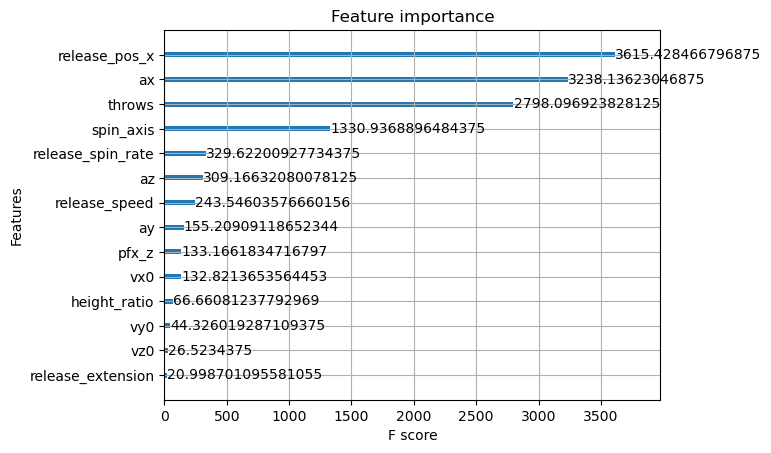

In [27]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [28]:
y_pred = final_model.predict(dtest)

In [29]:
print(y_pred.min())

-1.4285743


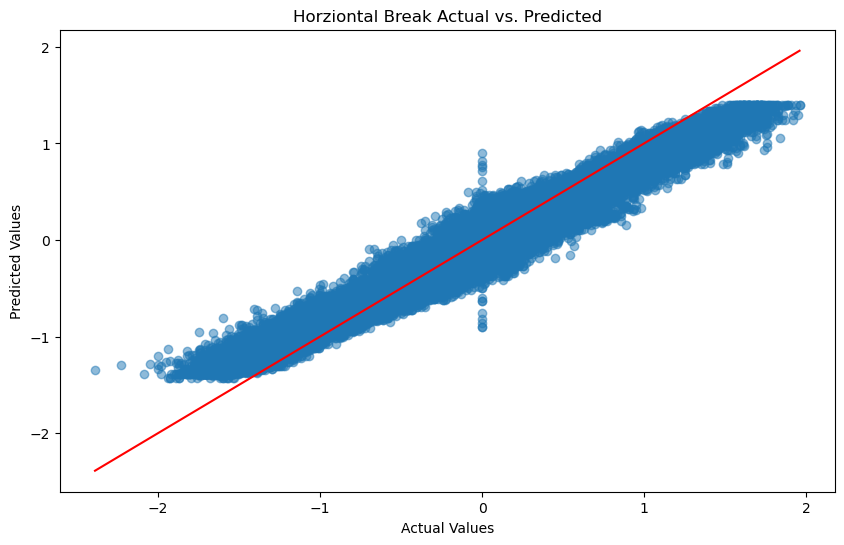

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Horziontal Break Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [31]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'throws',
       'height_ratio'],
      dtype='object')

In [32]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [33]:
testing_identifiers['xpfx_x'] = predictions

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_1820\3816176486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xpfx_x'] = predictions


In [34]:
testing_identifiers.head()

pitch_id_raw    xpfx_x
0  663364_455139_617228_4_75_10 -0.632080
1  663364_455139_617228_3_75_10 -0.607547
2  663364_455139_617228_2_75_10 -0.710016
3  663364_455139_617228_1_75_10 -0.598092
5  663364_593428_605347_4_72_10 -0.697671

In [35]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/pfx_2022&3_xpfx.csv")